In [2]:
import pysam
from Bio import pairwise2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn3
from Bio.Seq import Seq
from multiprocessing import Pool
import http.client
import matplotlib


In [1]:
bam_filename = '/Users/mgatzen/files/bam/10x_tool/all.corrected.bam'
bam_filename = '/Users/mgatzen/files/bam/10x_tool/ont/1.consensus.bam'

In [3]:
def position_in_sequence(sequence):
    pat = 'CTACACGACGCTCTTCCGATCT'
    d = 4
    q = 101
    M = len(pat)
    N = len(sequence)
    i = 0
    j = 0
    p = 0  # hash value for pattern
    t = 0  # hash value for txt
    h = 1

    positions = []

    # The value of h would be "pow(d, M-1)% q"
    for i in range(M - 1):
        h = (h * d) % q

        # Calculate the hash value of pattern and first window
    # of text
    for i in range(M):
        p = (d * p + ord(pat[i])) % q
        t = (d * t + ord(sequence[i])) % q

        # Slide the pattern over text one by one
    for i in range(N - M + 1):
        # Check the hash values of current window of text and
        # pattern if the hash values match then only check
        # for characters on by one
        if p == t:
            # Check for characters one by one
            for j in range(M):
                if sequence[i + j] != pat[j]:
                    break

            j += 1
            # if p == t and pat[0...M-1] = txt[i, i + 1, ...i + M-1]
            if j == M:
                positions.append(i)

                # Calculate hash value for next window of text: Remove
        # leading digit, add trailing digit
        if i < N - M:
            t = (d * (t - ord(sequence[i]) * h) + ord(sequence[i + M])) % q

            # We might get negative values of t, converting it to
            # positive
            if t < 0:
                t = t + q

    return positions


In [4]:
def process_contig(contig, include_odd_sequences):
    bam_file = pysam.AlignmentFile(bam_filename, 'rb')

    reads_seen = 0

    adapter_found, adapter_not_found = 0, 0
    multi_alignments = 0

    forward_adapter_found, forward_adapter_not_found = 0, 0
    forward_multi_alignments = 0
    forward_position_histogram = dict()
    forward_relative_position_histogram = dict()

    reverse_adapter_found, reverse_adapter_not_found = 0, 0
    reverse_multi_alignments = 0
    reverse_position_histogram = dict()
    reverse_relative_position_histogram = dict()

    odd_position_reads = []

    both_ends_aligned = 0

    max_reads = None

    for read in bam_file.fetch(contig=contig):
        
        if max_reads is not None and max_reads > 0:
            if reads_seen >= max_reads:
                break

        reads_seen += 1

        if reads_seen % 10000 == 0:
            print('Processed reads: {}. Last position: {}:{}'.format(reads_seen, read.reference_name, read.pos))

        forward_sequence = read.seq
        reverse_sequence = str(Seq(forward_sequence).reverse_complement())

        forward_alignments_rk = position_in_sequence(forward_sequence)
        reverse_alignments_rk = position_in_sequence(reverse_sequence)

        for alignment in forward_alignments_rk:
            if alignment not in forward_position_histogram:
                forward_position_histogram[alignment] = 0
            forward_position_histogram[alignment] += 1

            relative_pos = alignment / len(read.seq)
            if relative_pos not in forward_relative_position_histogram:
                forward_relative_position_histogram[relative_pos] = 0
            forward_relative_position_histogram[relative_pos] += 1

#             if alignment > 5:
#                 odd_position_reads.append((read.query_name, read.reference_name, read.pos, forward_alignments_rk, len(forward_sequence), read.seq if include_odd_sequences else None))

        for alignment in reverse_alignments_rk:
            if alignment not in reverse_position_histogram:
                reverse_position_histogram[alignment] = 0
            reverse_position_histogram[alignment] += 1

            relative_pos = alignment / len(read.seq)
            if relative_pos not in reverse_relative_position_histogram:
                reverse_relative_position_histogram[relative_pos] = 0
            reverse_relative_position_histogram[relative_pos] += 1

#             if alignment > 5:
#                 odd_position_reads.append((read.query_name, read.reference_name, read.pos, reverse_alignments_rk, len(reverse_sequence), read.seq if include_odd_sequences else None))

        if len(forward_alignments_rk) == 0:
            forward_adapter_not_found += 1
        else:
            forward_adapter_found += 1
        if len(reverse_alignments_rk) == 0:
            reverse_adapter_not_found += 1
        else:
            reverse_adapter_found += 1

        if len(forward_alignments_rk) == 0 and len(reverse_alignments_rk) == 0:
            adapter_not_found += 1
            continue

        if len(forward_alignments_rk) > 1:
            forward_multi_alignments += 1
        if len(reverse_alignments_rk) > 1:
            reverse_multi_alignments += 1

        if len(forward_alignments_rk) > 0 and len(reverse_alignments_rk) > 0:
            both_ends_aligned += 1
            continue

        if len(forward_alignments_rk) > 1 or len(reverse_alignments_rk) > 1:
            multi_alignments += 1
            continue

        if len(forward_alignments_rk) > 0:
            forward_aligned = True
        else:
            forward_aligned = False

        adapter_found += 1

    return reads_seen, adapter_found, adapter_not_found, multi_alignments, both_ends_aligned,\
           forward_adapter_found, forward_adapter_not_found, forward_multi_alignments, forward_position_histogram, forward_relative_position_histogram, \
           reverse_adapter_found, reverse_adapter_not_found, reverse_multi_alignments, reverse_position_histogram, reverse_relative_position_histogram, odd_position_reads

In [5]:
use_igv = False

results = process_contig(None, use_igv)


Processed reads: 10000. Last position: chr1:15429208
Processed reads: 20000. Last position: chr1:35184129
Processed reads: 30000. Last position: chr1:49751964
Processed reads: 40000. Last position: chr1:66165237
Processed reads: 50000. Last position: chr1:76946392
Processed reads: 60000. Last position: chr1:92887418
Processed reads: 70000. Last position: chr1:113395743
Processed reads: 80000. Last position: chr1:143366916
Processed reads: 90000. Last position: chr1:148495689
Processed reads: 100000. Last position: chr1:160142115
Processed reads: 110000. Last position: chr1:175427725
Processed reads: 120000. Last position: chr1:198932126
Processed reads: 130000. Last position: chr1:216871893
Processed reads: 140000. Last position: chr1:235293267
Processed reads: 150000. Last position: chr1:244056684
Processed reads: 160000. Last position: chr2:17540788
Processed reads: 170000. Last position: chr2:39109372
Processed reads: 180000. Last position: chr2:50658106
Processed reads: 190000. Las

Processed reads: 1510000. Last position: chr14:47343210
Processed reads: 1520000. Last position: chr14:60013410
Processed reads: 1530000. Last position: chr14:73537618
Processed reads: 1540000. Last position: chr14:88708994
Processed reads: 1550000. Last position: chr14:100856529
Processed reads: 1560000. Last position: chr15:25152743
Processed reads: 1570000. Last position: chr15:30961815
Processed reads: 1580000. Last position: chr15:45596993
Processed reads: 1590000. Last position: chr15:60978541
Processed reads: 1600000. Last position: chr15:76606845
Processed reads: 1610000. Last position: chr15:94487218
Processed reads: 1620000. Last position: chr16:6761782
Processed reads: 1630000. Last position: chr16:16383653
Processed reads: 1640000. Last position: chr16:24823642
Processed reads: 1650000. Last position: chr16:53077328
Processed reads: 1660000. Last position: chr16:76498592
Processed reads: 1670000. Last position: chr17:8377522
Processed reads: 1680000. Last position: chr17:20

In [6]:
print(results[:-1])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [92]:
results_backup = (13972979, 3783979, 10099228, 24446, 65326, 1806090, 12166889, 12313, {0: 1639946, 1: 70011, 5: 3390, 2: 14391, 6: 1598, 1079: 73, 39: 38, 4: 4391, 3: 8063, 1490: 36, 913: 89, 66: 30, 1104: 68, 877: 83, 1883: 20, 1225: 56, 1480: 33, 1343: 43, 938: 64, 1768: 18, 1332: 39, 15: 329, 1403: 51, 638: 40, 767: 88, 7: 1193, 1569: 12, 1207: 47, 999: 55, 295: 4, 12: 431, 1377: 30, 738: 58, 960: 83, 1221: 38, 2275: 9, 1694: 30, 1102: 67, 2302: 5, 957: 96, 688: 49, 433: 13, 836: 72, 275: 3, 935: 52, 599: 26, 895: 127, 1626: 30, 762: 74, 24: 128, 1589: 8, 54: 27, 10: 590, 686: 37, 1268: 43, 1538: 22, 1210: 53, 9: 711, 728: 42, 734: 67, 57: 33, 818: 74, 1522: 28, 673: 65, 943: 77, 1636: 26, 1485: 39, 970: 77, 824: 77, 987: 94, 1257: 44, 30: 86, 1152: 41, 1394: 45, 1076: 95, 963: 120, 695: 50, 584: 33, 1729: 19, 750: 56, 1109: 71, 795: 75, 1068: 80, 550: 14, 716: 56, 526: 12, 1190: 58, 2084: 15, 637: 51, 723: 54, 964: 147, 667: 46, 1163: 58, 892: 92, 22: 158, 616: 41, 785: 67, 2452: 5, 1252: 41, 1018: 54, 1442: 25, 715: 61, 1164: 60, 503: 16, 1375: 43, 742: 59, 127: 4, 864: 66, 1322: 54, 1408: 55, 692: 71, 1383: 66, 924: 63, 1585: 25, 1085: 72, 796: 91, 1129: 57, 1281: 24, 1315: 40, 661: 51, 1496: 18, 1744: 14, 1406: 54, 870: 80, 1413: 34, 1825: 14, 933: 115, 1703: 16, 610: 40, 13: 367, 1658: 20, 579: 41, 962: 102, 2291: 2, 1126: 50, 821: 88, 2457: 2, 905: 84, 296: 5, 1065: 67, 956: 73, 694: 51, 788: 67, 1347: 38, 1087: 54, 805: 48, 472: 8, 1617: 24, 1448: 26, 28: 67, 787: 58, 2127: 3, 1250: 43, 1083: 79, 850: 104, 1561: 24, 1019: 67, 840: 69, 21: 197, 1194: 60, 3245: 1, 793: 63, 498: 9, 1035: 85, 816: 123, 981: 72, 568: 28, 2267: 10, 560: 24, 1004: 78, 764: 69, 866: 73, 1197: 53, 1007: 82, 1248: 43, 1140: 89, 1700: 8, 713: 47, 758: 72, 980: 63, 852: 125, 62: 17, 780: 66, 1182: 46, 920: 74, 1635: 19, 863: 82, 1583: 23, 1254: 43, 547: 16, 2655: 3, 2148: 13, 831: 72, 1282: 39, 651: 27, 1934: 12, 737: 82, 786: 61, 544: 13, 598: 22, 1301: 29, 1155: 36, 23: 149, 1718: 14, 883: 69, 11: 499, 800: 54, 689: 67, 703: 58, 1294: 33, 959: 76, 680: 59, 2015: 5, 1010: 73, 996: 83, 841: 66, 940: 61, 1283: 51, 35: 38, 797: 60, 1172: 56, 1689: 12, 1614: 52, 537: 29, 889: 104, 983: 69, 1470: 44, 8: 817, 553: 18, 696: 38, 1551: 99, 2034: 4, 1935: 13, 1458: 31, 1247: 45, 872: 78, 965: 166, 1223: 48, 901: 68, 20: 221, 659: 48, 656: 34, 608: 31, 973: 88, 74: 6, 1224: 68, 1396: 29, 1459: 40, 794: 69, 906: 62, 1240: 70, 978: 84, 819: 79, 1769: 18, 2265: 11, 1491: 21, 1870: 15, 42: 26, 1478: 34, 1337: 30, 1328: 53, 1418: 16, 1683: 21, 925: 75, 666: 39, 746: 64, 726: 57, 643: 60, 648: 44, 1260: 51, 1024: 76, 1621: 18, 1544: 24, 1030: 66, 868: 82, 1273: 54, 1063: 71, 1354: 32, 747: 56, 882: 81, 1032: 62, 942: 72, 1468: 38, 1071: 47, 1123: 44, 1564: 21, 757: 81, 1871: 12, 849: 110, 782: 62, 1177: 70, 663: 52, 1156: 61, 1253: 39, 1415: 45, 1264: 49, 954: 110, 364: 2, 1453: 34, 612: 59, 704: 63, 1475: 22, 1275: 46, 1861: 17, 1457: 15, 1142: 80, 832: 71, 1502: 19, 546: 21, 858: 70, 1267: 44, 2244: 8, 625: 31, 26: 91, 1138: 53, 958: 60, 1318: 45, 1289: 37, 903: 56, 2682: 3, 898: 87, 2118: 4, 1069: 55, 1159: 51, 1638: 12, 823: 71, 33: 57, 660: 31, 632: 46, 1054: 64, 932: 82, 908: 80, 2877: 6, 1858: 9, 911: 73, 1122: 48, 653: 54, 619: 26, 1514: 24, 727: 59, 1641: 24, 1284: 52, 991: 60, 645: 30, 690: 53, 1110: 67, 1330: 49, 845: 76, 1693: 23, 1553: 69, 17: 288, 769: 111, 893: 106, 976: 100, 1601: 22, 1082: 83, 542: 40, 941: 91, 114: 15, 1168: 53, 779: 71, 1212: 47, 801: 71, 1327: 45, 929: 84, 961: 78, 19: 227, 966: 116, 1950: 12, 614: 37, 781: 79, 1680: 19, 1366: 55, 685: 70, 1549: 85, 1313: 53, 406: 11, 37: 27, 16: 297, 617: 38, 647: 31, 1728: 13, 4532: 1, 2073: 8, 1269: 32, 1092: 46, 1712: 13, 1872: 14, 1391: 34, 1205: 55, 822: 74, 1175: 82, 2959: 9, 2437: 8, 770: 67, 771: 83, 639: 35, 1434: 31, 1073: 49, 1136: 73, 1052: 74, 18: 245, 1271: 53, 1503: 29, 820: 58, 745: 66, 238: 9, 1308: 41, 830: 108, 1058: 66, 535: 22, 1321: 47, 573: 29, 891: 80, 677: 61, 1890: 8, 708: 60, 1296: 36, 462: 9, 778: 53, 1066: 86, 1064: 53, 597: 41, 1012: 75, 1211: 58, 912: 77, 1385: 30, 862: 60, 1127: 55, 1329: 36, 263: 5, 839: 74, 875: 78, 1246: 39, 1467: 63, 674: 47, 1342: 49, 886: 69, 1265: 43, 1078: 51, 837: 83, 1259: 58, 1040: 148, 75: 12, 812: 74, 1117: 70, 1090: 34, 1360: 76, 1222: 54, 2395: 3, 51: 20, 1186: 82, 1495: 50, 1074: 53, 1170: 46, 1395: 20, 1100: 48, 1844: 13, 620: 36, 1048: 63, 979: 83, 803: 68, 622: 31, 744: 45, 1041: 259, 880: 77, 1362: 77, 144: 5, 1376: 42, 2504: 1, 642: 31, 1848: 8, 658: 56, 375: 2, 1392: 41, 1147: 55, 25: 123, 1384: 53, 1023: 70, 83: 5, 1235: 47, 606: 58, 927: 100, 1285: 33, 810: 63, 505: 21, 628: 30, 1180: 61, 2209: 14, 1479: 25, 741: 34, 1258: 66, 1338: 40, 733: 73, 1324: 37, 56: 28, 873: 69, 1353: 34, 456: 5, 3174: 1, 1399: 59, 1798: 13, 519: 11, 777: 81, 876: 76, 678: 40, 1724: 16, 1645: 26, 49: 30, 1443: 31, 1103: 48, 721: 62, 1412: 35, 1695: 13, 874: 76, 86: 10, 1727: 22, 751: 62, 355: 2, 971: 86, 1407: 48, 1472: 32, 776: 55, 1451: 38, 1000: 72, 1432: 42, 799: 74, 514: 8, 1036: 62, 1125: 64, 1577: 23, 1481: 41, 1216: 41, 1316: 37, 1699: 14, 2040: 7, 601: 28, 465: 9, 1178: 38, 1559: 31, 2322: 3, 2549: 7, 1365: 44, 1755: 17, 1398: 34, 100: 15, 2054: 16, 1232: 37, 1512: 16, 1435: 34, 1779: 15, 881: 75, 650: 45, 1687: 38, 1053: 61, 2017: 6, 897: 71, 1113: 60, 871: 74, 1201: 59, 575: 27, 936: 87, 630: 40, 1593: 14, 1543: 21, 844: 57, 1498: 24, 652: 47, 1094: 60, 2043: 7, 14: 359, 68: 35, 1049: 78, 974: 98, 1107: 48, 1056: 75, 530: 19, 949: 104, 1606: 18, 759: 97, 1511: 37, 1566: 28, 968: 74, 1072: 61, 1039: 95, 994: 70, 1874: 16, 93: 11, 89: 31, 479: 7, 1115: 51, 1732: 22, 934: 88, 1193: 47, 1144: 51, 900: 79, 990: 69, 299: 1, 588: 25, 388: 7, 1404: 34, 1016: 79, 1828: 15, 969: 103, 811: 86, 848: 94, 32: 63, 1161: 54, 564: 28, 1158: 44, 1219: 41, 1017: 72, 740: 50, 1880: 10, 955: 83, 1767: 10, 1355: 31, 1336: 35, 1027: 67, 1060: 61, 1239: 55, 29: 61, 1650: 26, 536: 20, 768: 61, 3229: 2, 884: 89, 1206: 33, 1546: 37, 1166: 51, 1777: 12, 1591: 43, 1640: 14, 1220: 43, 1202: 38, 748: 64, 1231: 38, 1980: 13, 1970: 8, 1397: 48, 555: 21, 1615: 27, 609: 26, 1047: 92, 1537: 24, 627: 47, 495: 13, 2025: 3, 474: 8, 1055: 55, 1323: 40, 1657: 39, 549: 11, 731: 67, 1884: 13, 1192: 48, 1015: 88, 992: 51, 939: 71, 2954: 2, 1199: 53, 683: 57, 130: 3, 34: 58, 2070: 5, 1034: 54, 1279: 53, 1358: 54, 454: 8, 1393: 38, 843: 73, 902: 96, 834: 82, 1946: 11, 1227: 53, 700: 70, 1317: 51, 878: 65, 509: 22, 1326: 48, 1592: 31, 1697: 16, 1196: 69, 1646: 17, 766: 60, 2053: 1, 1607: 26, 1682: 9, 1582: 28, 618: 29, 1135: 68, 1131: 48, 55: 24, 681: 71, 1441: 33, 865: 79, 1148: 70, 1185: 56, 1389: 20, 1276: 41, 899: 60, 1851: 7, 885: 75, 1986: 9, 669: 43, 1051: 86, 894: 114, 1157: 42, 67: 26, 151: 5, 2051: 12, 761: 48, 2146: 4, 718: 101, 646: 34, 1031: 73, 1414: 40, 2086: 16, 896: 89, 1787: 17, 2431: 8, 1754: 15, 1595: 12, 774: 79, 2577: 6, 2354: 1, 672: 61, 1579: 32, 1710: 20, 815: 80, 572: 32, 1676: 12, 988: 57, 948: 71, 36: 40, 1153: 57, 1228: 41, 853: 97, 684: 49, 854: 108, 1500: 25, 1364: 71, 1411: 42, 2009: 9, 1664: 21, 917: 105, 953: 83, 732: 41, 775: 54, 1088: 60, 2061: 3, 691: 64, 621: 53, 2929: 1, 1552: 134, 792: 73, 644: 36, 1957: 14, 1215: 37, 2106: 9, 763: 67, 1555: 53, 826: 67, 603: 37, 1447: 41, 1130: 64, 520: 21, 2204: 2, 3524: 1, 2181: 7, 604: 42, 1807: 14, 670: 52, 1823: 19, 1840: 16, 111: 13, 1304: 37, 1114: 56, 1263: 34, 1105: 59, 409: 14, 928: 67, 1028: 91, 1782: 13, 909: 45, 804: 60, 1816: 14, 833: 77, 930: 67, 635: 40, 1256: 48, 1291: 59, 1305: 26, 739: 64, 2550: 2, 225: 3, 717: 60, 1968: 5, 611: 19, 2211: 4, 791: 41, 52: 29, 452: 4, 2039: 18, 783: 82, 1669: 37, 1134: 62, 705: 84, 587: 38, 1554: 64, 753: 61, 1915: 4, 1183: 44, 1008: 80, 1119: 68, 2258: 11, 919: 122, 45: 85, 517: 7, 1226: 38, 145: 6, 205: 6, 765: 72, 2124: 12, 1378: 22, 699: 62, 1006: 87, 855: 85, 513: 21, 712: 61, 1233: 50, 984: 74, 1075: 56, 1581: 32, 1454: 32, 985: 84, 719: 73, 1371: 43, 915: 134, 1381: 44, 1574: 35, 1668: 14, 1743: 11, 743: 61, 1306: 27, 1062: 57, 1482: 29, 1789: 21, 2078: 7, 1849: 11, 860: 55, 1602: 12, 1061: 50, 1011: 92, 1616: 17, 437: 8, 806: 84, 1188: 62, 2203: 5, 2536: 2, 1625: 20, 2031: 9, 1067: 68, 1654: 7, 735: 76, 561: 16, 926: 71, 236: 6, 798: 56, 2047: 12, 1262: 37, 693: 67, 1965: 7, 1923: 6, 1050: 66, 1817: 12, 1590: 26, 851: 134, 594: 35, 2156: 4, 1504: 32, 1348: 30, 515: 24, 1280: 39, 1805: 15, 1128: 71, 1804: 6, 755: 71, 1400: 36, 2933: 1, 1080: 51, 1300: 43, 1325: 48, 857: 103, 838: 68, 1826: 12, 46: 37, 1427: 28, 736: 40, 756: 77, 569: 35, 2742: 6, 1297: 33, 914: 75, 1846: 33, 918: 78, 1784: 16, 71: 29, 1331: 39, 790: 62, 1524: 47, 729: 79, 1852: 13, 1181: 51, 1737: 7, 2212: 7, 1527: 36, 861: 90, 1856: 21, 2083: 3, 1198: 33, 1373: 41, 1111: 81, 842: 85, 1312: 36, 1213: 46, 2545: 4, 1251: 55, 789: 86, 1003: 58, 676: 35, 1690: 26, 2179: 4, 110: 18, 944: 101, 112: 19, 679: 48, 1629: 11, 1573: 17, 1739: 17, 2182: 6, 613: 34, 104: 6, 1106: 49, 1681: 17, 668: 39, 2088: 6, 435: 8, 720: 70, 1179: 24, 1785: 19, 2077: 12, 687: 79, 1800: 5, 395: 3, 72: 14, 1945: 19, 1568: 33, 3079: 2, 1484: 26, 1150: 57, 2062: 9, 950: 109, 1341: 39, 636: 45, 1944: 11, 551: 24, 1862: 17, 1099: 65, 335: 4, 548: 23, 1761: 12, 3052: 5, 1410: 34, 1320: 46, 2521: 3, 2313: 9, 1121: 57, 1042: 155, 972: 87, 827: 58, 1486: 25, 989: 68, 1287: 44, 1897: 20, 1093: 65, 1266: 40, 1037: 90, 1745: 19, 1112: 39, 1542: 18, 1613: 27, 2424: 5, 1298: 40, 63: 16, 1674: 24, 1466: 38, 1686: 19, 540: 17, 40: 24, 173: 5, 890: 86, 1424: 32, 2239: 3, 945: 75, 1361: 55, 1382: 58, 1922: 14, 1189: 72, 1357: 35, 1661: 26, 904: 66, 1335: 33, 922: 76, 1293: 27, 2044: 10, 2027: 6, 2093: 7, 1241: 54, 1662: 6, 1733: 14, 1402: 27, 1149: 69, 1456: 12, 1374: 47, 977: 58, 1523: 33, 2149: 5, 512: 3, 1005: 67, 709: 51, 749: 53, 856: 76, 722: 49, 1677: 17, 1588: 19, 784: 70, 469: 6, 1209: 54, 967: 79, 2055: 7, 707: 34, 402: 5, 1586: 34, 1420: 22, 1405: 18, 90: 90, 1666: 19, 2476: 14, 1547: 55, 947: 67, 70: 23, 1077: 50, 2022: 6, 1521: 15, 1948: 10, 529: 15, 1057: 69, 2046: 10, 585: 26, 1895: 23, 1487: 43, 1046: 63, 829: 69, 1101: 61, 605: 52, 1750: 14, 2508: 6, 1203: 40, 1647: 20, 148: 7, 1843: 6, 879: 74, 1200: 42, 1133: 66, 1608: 35, 1086: 78, 998: 47, 480: 9, 2166: 3, 1652: 14, 1379: 48, 1081: 72, 2063: 9, 624: 35, 1612: 26, 631: 35, 1649: 16, 2487: 4, 2382: 9, 3110: 5, 1334: 32, 522: 23, 975: 71, 602: 42, 1025: 56, 3398: 3, 2090: 11, 2451: 14, 1557: 44, 1401: 23, 1278: 44, 1439: 41, 581: 32, 1747: 16, 808: 76, 1888: 10, 3121: 2, 1596: 14, 1877: 3, 1070: 75, 1038: 105, 1430: 24, 1021: 63, 393: 6, 1623: 23, 1184: 67, 1532: 27, 714: 65, 952: 65, 442: 12, 2019: 7, 654: 30, 312: 4, 1678: 19, 1775: 21, 423: 4, 1340: 27, 923: 69, 53: 19, 1143: 55, 1191: 53, 2108: 15, 921: 76, 1171: 43, 496: 13, 1860: 8, 1887: 15, 2150: 5, 2238: 4, 828: 90, 43: 42, 1045: 135, 1020: 68, 1489: 21, 1791: 14, 760: 51, 59: 21, 2371: 2, 2690: 2, 1721: 21, 846: 89, 641: 52, 1307: 39, 986: 60, 817: 62, 1286: 42, 982: 71, 44: 30, 1013: 62, 1380: 32, 1450: 20, 1059: 48, 2255: 3, 27: 78, 1229: 34, 155: 14, 995: 87, 1875: 4, 1033: 48, 2199: 9, 430: 8, 1124: 62, 1783: 8, 888: 83, 447: 12, 931: 75, 1575: 12, 1014: 54, 2097: 5, 50: 16, 754: 68, 2594: 2, 485: 20, 475: 6, 1217: 46, 1245: 35, 1515: 33, 2169: 17, 1713: 15, 1116: 53, 1243: 68, 410: 7, 455: 14, 1274: 53, 1465: 43, 1043: 118, 2392: 4, 825: 67, 1195: 42, 1098: 67, 1108: 50, 2693: 5, 2128: 6, 571: 21, 1460: 41, 1576: 25, 1344: 44, 1974: 5, 633: 30, 1386: 59, 1302: 39, 1672: 19, 1545: 23, 1994: 13, 706: 41, 1508: 25, 419: 12, 1416: 34, 2049: 7, 1333: 32, 2110: 5, 99: 17, 1633: 25, 1952: 13, 1726: 15, 951: 75, 698: 49, 711: 45, 1720: 16, 557: 24, 381: 2, 2249: 3, 570: 33, 500: 12, 802: 51, 1656: 32, 1162: 53, 937: 66, 2281: 6, 1022: 54, 1659: 27, 1624: 28, 1684: 27, 302: 6, 311: 8, 1139: 69, 1234: 33, 58: 37, 1464: 48, 662: 77, 532: 14, 411: 7, 807: 68, 1709: 15, 1528: 32, 1455: 21, 1244: 44, 123: 8, 4071: 7, 2309: 7, 1165: 51, 1314: 65, 1604: 15, 1352: 54, 10586: 3, 167: 9, 1299: 45, 345: 5, 1722: 33, 1520: 23, 1026: 71, 350: 5, 1932: 9, 1319: 45, 1526: 32, 1671: 11, 675: 63, 1261: 28, 2016: 9, 1611: 43, 80: 10, 2384: 2, 1772: 8, 869: 67, 1438: 23, 1510: 17, 120: 3, 1516: 40, 2234: 4, 655: 46, 725: 59, 859: 54, 1417: 24, 657: 39, 165: 4, 558: 11, 1701: 22, 2792: 14, 1388: 51, 835: 80, 1339: 31, 78: 6, 702: 57, 2113: 8, 772: 63, 1558: 27, 2548: 3, 623: 46, 867: 79, 1452: 55, 607: 29, 1548: 19, 1214: 43, 1702: 22, 48: 17, 1876: 6, 2198: 10, 1095: 47, 2332: 3, 1966: 11, 1096: 47, 2806: 2, 1345: 49, 1901: 7, 1869: 18, 1715: 11, 1509: 24, 993: 73, 578: 26, 1089: 45, 1390: 33, 1132: 67, 2072: 5, 1230: 42, 1964: 3, 1363: 66, 907: 47, 1660: 4, 398: 7, 1350: 36, 1204: 40, 1429: 33, 1421: 40, 1238: 43, 946: 46, 566: 17, 1507: 30, 589: 29, 198: 2, 2522: 2, 3335: 2, 3065: 2, 1483: 20, 1084: 75, 1751: 15, 567: 27, 2666: 4, 2170: 2, 1929: 8, 1141: 74, 1620: 12, 1372: 34, 1821: 9, 1921: 11, 85: 3, 2469: 2, 814: 80, 1097: 61, 2264: 6, 1976: 7, 1839: 25, 2133: 14, 2613: 3, 4676: 3, 1519: 42, 527: 14, 1741: 20, 1648: 15, 1270: 27, 1618: 16, 2041: 10, 2289: 4, 997: 59, 1943: 4, 1091: 50, 159: 6, 1760: 24, 1971: 7, 2085: 5, 562: 13, 87: 8, 1146: 80, 64: 20, 1692: 11, 325: 5, 2184: 2, 813: 100, 473: 14, 1735: 18, 910: 76, 730: 58, 2030: 5, 1815: 7, 1292: 67, 2026: 4, 887: 68, 1764: 14, 2067: 17, 2436: 1, 1461: 44, 1492: 33, 1440: 29, 1236: 52, 528: 10, 1809: 10, 1356: 31, 1833: 17, 545: 14, 137: 1, 2555: 2, 554: 9, 1151: 54, 1802: 18, 1912: 11, 595: 34, 4095: 2, 1599: 22, 1431: 25, 592: 29, 1685: 24, 1187: 45, 1834: 8, 1796: 11, 2348: 5, 1422: 32, 323: 1, 1530: 16, 1311: 33, 1937: 11, 2603: 1, 464: 8, 241: 8, 1803: 17, 438: 6, 539: 10, 1535: 27, 1154: 48, 2344: 9, 1009: 67, 1580: 11, 2949: 4, 337: 6, 1587: 26, 116: 7, 1167: 42, 2122: 1, 1907: 8, 1029: 59, 1854: 14, 701: 65, 2142: 3, 3087: 6, 1982: 14, 1651: 12, 1249: 45, 640: 25, 2200: 1, 65: 20, 1653: 24, 2033: 10, 2468: 5, 2570: 2, 916: 102, 2676: 2, 156: 8, 1288: 48, 534: 16, 487: 8, 38: 16, 3682: 2, 2517: 2, 3132: 7, 2560: 3, 124: 9, 1631: 18, 809: 112, 1419: 59, 1044: 101, 724: 37, 91: 18, 1367: 42, 1609: 18, 2375: 3, 2158: 16, 444: 7, 2059: 7, 1603: 19, 2946: 1, 1174: 77, 330: 3, 2129: 3, 671: 71, 600: 19, 1449: 36, 1716: 13, 1529: 21, 2141: 5, 1160: 50, 2144: 10, 1145: 81, 2363: 3, 314: 2, 3530: 3, 1867: 15, 1698: 20, 150: 4, 582: 27, 268: 1, 1533: 23, 2270: 4, 1497: 43, 1731: 4, 2342: 5, 47: 23, 1928: 13, 2011: 11, 2257: 8, 629: 39, 1002: 81, 439: 8, 649: 30, 353: 2, 396: 4, 457: 11, 1753: 10, 2380: 5, 1632: 17, 2422: 2, 334: 8, 1619: 28, 773: 69, 2221: 4, 1795: 11, 697: 48, 1517: 26, 1679: 19, 1120: 47, 2667: 2, 1902: 6, 634: 48, 2349: 8, 1173: 62, 2563: 2, 1961: 4, 2992: 2, 1176: 76, 1878: 8, 1600: 12, 2145: 8, 1988: 4, 1742: 9, 1444: 33, 1471: 44, 2326: 5, 2912: 3, 31: 81, 190: 2, 1426: 18, 1473: 27, 1541: 14, 1295: 37, 2680: 1, 2650: 2, 1370: 55, 1501: 37, 421: 8, 1446: 28, 1962: 7, 710: 53, 3173: 2, 2411: 7, 665: 64, 2351: 9, 2330: 13, 1644: 18, 2274: 15, 1967: 7, 425: 11, 274: 4, 1513: 38, 2404: 4, 1873: 23, 1637: 12, 1717: 17, 1696: 14, 1242: 35, 2229: 7, 2902: 3, 2378: 4, 2352: 1, 2126: 7, 2131: 4, 590: 46, 493: 8, 1909: 21, 1797: 21, 261: 7, 2931: 7, 501: 15, 2360: 2, 1756: 17, 1639: 13, 106: 7, 2272: 5, 1634: 15, 1725: 9, 450: 7, 1469: 29, 2314: 3, 2101: 12, 1868: 13, 1705: 14, 2094: 7, 2208: 4, 2192: 4, 1906: 15, 1770: 6, 596: 35, 60: 26, 125: 8, 2562: 4, 1540: 18, 1474: 33, 1369: 56, 3558: 4, 2602: 4, 1835: 14, 1734: 19, 1900: 8, 460: 15, 682: 53, 1436: 40, 1437: 22, 2219: 2, 2835: 3, 1505: 39, 1736: 22, 178: 3, 1433: 22, 2678: 2, 1941: 14, 2612: 1, 2433: 6, 1560: 9, 2161: 8, 2426: 6, 1863: 16, 1494: 34, 1518: 28, 591: 40, 2194: 4, 183: 8, 1525: 17, 361: 2, 752: 61, 510: 18, 847: 69, 1565: 15, 1169: 48, 5155: 2, 69: 26, 2379: 3, 140: 4, 132: 7, 187: 2, 1642: 16, 1788: 10, 1137: 60, 1790: 11, 373: 6, 82: 2, 1829: 3, 3082: 2, 416: 2, 1919: 15, 1499: 16, 1673: 15, 2252: 4, 1820: 14, 541: 28, 256: 4, 1740: 14, 3323: 2, 1563: 14, 2527: 2, 2587: 2, 1845: 14, 477: 3, 1493: 28, 1749: 19, 615: 35, 175: 4, 1936: 15, 397: 5, 1665: 18, 304: 6, 508: 12, 1423: 32, 1879: 10, 1938: 11, 1562: 28, 105: 5, 556: 18, 1719: 5, 1303: 41, 2245: 7, 2089: 7, 121: 3, 1738: 22, 1811: 9, 103: 3, 379: 4, 1927: 5, 115: 8, 440: 6, 1277: 18, 309: 7, 1663: 11, 3194: 1, 1578: 32, 1850: 12, 1708: 21, 1477: 31, 1572: 13, 1818: 15, 1979: 7, 1346: 32, 626: 51, 2247: 7, 1954: 18, 1714: 14, 3179: 3, 1428: 31, 2176: 4, 2130: 7, 432: 3, 2290: 2, 1567: 16, 2438: 11, 2607: 2, 533: 12, 1118: 55, 3020: 2, 2305: 3, 2509: 1, 185: 1, 172: 11, 1208: 32, 2357: 4, 3488: 2, 2137: 5, 2187: 6, 664: 48, 2827: 1, 5846: 2, 2731: 6, 2024: 7, 1556: 51, 538: 18, 2206: 5, 2087: 7, 2961: 3, 4011: 1, 2121: 7, 220: 2, 2340: 4, 1218: 52, 1773: 14, 1622: 12, 1812: 29, 1409: 31, 1627: 29, 1506: 23, 2428: 1, 3038: 3, 408: 5, 194: 4, 2014: 12, 1916: 15, 61: 27, 2747: 3, 1903: 8, 583: 23, 289: 5, 1987: 12, 1759: 13, 441: 16, 1539: 40, 1836: 10, 2012: 13, 2901: 3, 471: 9, 92: 9, 117: 7, 1819: 8, 1445: 30, 2597: 5, 2940: 7, 3602: 7, 1918: 6, 2445: 4, 1272: 63, 2007: 13, 354: 2, 1688: 33, 1752: 10, 2010: 6, 2880: 3, 2095: 8, 1655: 24, 1830: 8, 1001: 58, 2634: 1, 276: 2, 147: 7, 449: 6, 2660: 2, 41: 13, 2443: 11, 2756: 1, 2104: 11, 369: 3, 511: 13, 1794: 19, 1309: 19, 1570: 34, 459: 4, 586: 26, 161: 6, 1781: 39, 3150: 3, 3211: 1, 580: 24, 574: 29, 2924: 2, 1955: 17, 1463: 27, 3657: 6, 2832: 6, 1983: 2, 5478: 2, 497: 17, 448: 12, 1917: 6, 1896: 6, 2056: 6, 1857: 6, 382: 2, 1930: 6, 1723: 20, 2757: 3, 1630: 9, 1675: 12, 2020: 6, 2559: 6, 1847: 17, 1255: 30, 2250: 2, 2243: 2, 2285: 3, 1911: 3, 488: 12, 2419: 3, 2114: 11, 163: 5, 1594: 25, 1237: 24, 1476: 24, 1841: 7, 2160: 3, 2883: 3, 1951: 14, 1368: 39, 2777: 2, 504: 18, 2001: 9, 483: 12, 1920: 10, 73: 5, 367: 5, 1387: 20, 2048: 12, 1806: 16, 4136: 3, 1925: 11, 576: 32, 2117: 3, 1766: 12, 11069: 3, 12110: 3, 2600: 3, 1984: 4, 521: 18, 351: 1, 3322: 2, 531: 16, 1462: 42, 1842: 12, 3039: 2, 2222: 5, 4308: 1, 1605: 10, 3379: 1, 1990: 6, 1610: 37, 1865: 7, 3030: 2, 1810: 7, 2579: 8, 4503: 1, 2529: 9, 352: 4, 2107: 2, 1963: 10, 2885: 1, 2823: 3, 1757: 7, 1550: 72, 524: 11, 2760: 1, 2038: 1, 1942: 6, 2218: 6, 2686: 1, 2391: 5, 2116: 4, 2872: 3, 102: 4, 1995: 6, 336: 4, 1349: 27, 2551: 6, 2652: 5, 2665: 1, 1706: 23, 1801: 12, 195: 4, 4153: 2, 135: 14, 113: 8, 2718: 5, 1534: 15, 506: 20, 1981: 1, 1776: 10, 1993: 10, 4253: 1, 3390: 3, 413: 7, 197: 7, 2165: 2, 559: 30, 1824: 12, 2661: 6, 2626: 5, 2484: 2, 2228: 11, 523: 4, 431: 6, 525: 7, 1584: 26, 2102: 6, 1780: 4, 1786: 11, 1707: 13, 2294: 5, 1939: 1, 1643: 18, 1859: 15, 2679: 3, 1670: 18, 1730: 5, 2460: 2, 201: 3, 153: 7, 2439: 4, 3314: 3, 593: 20, 377: 3, 2306: 6, 2115: 5, 2408: 10, 278: 1, 2045: 8, 1488: 22, 2081: 4, 3504: 2, 451: 13, 1597: 4, 2164: 5, 1310: 26, 1758: 17, 1359: 51, 1977: 10, 2236: 5, 1531: 9, 179: 3, 2223: 8, 3385: 2, 1855: 12, 2418: 4, 2447: 4, 2478: 1, 565: 18, 2582: 1, 1746: 15, 1904: 9, 88: 6, 356: 4, 1998: 20, 2420: 3, 2241: 6, 2817: 2, 2393: 4, 277: 7, 2621: 3, 2201: 8, 2530: 2, 2547: 4, 390: 7, 324: 1, 1711: 10, 118: 6, 2293: 11, 142: 5, 436: 2, 1882: 9, 2725: 1, 1771: 13, 1864: 15, 2372: 7, 1953: 9, 426: 4, 1956: 15, 2282: 4, 1814: 8, 160: 7, 2780: 2, 2071: 8, 2589: 1, 1290: 29, 2434: 3, 3080: 2, 1972: 6, 1914: 6, 333: 3, 303: 3, 141: 5, 3275: 1, 1989: 2, 2552: 3, 2572: 5, 400: 6, 2722: 2, 3548: 1, 154: 4, 119: 2, 109: 11, 3263: 1, 1765: 15, 2713: 3, 1822: 3, 2857: 2, 434: 4, 1992: 15, 2226: 3, 2500: 10, 1792: 10, 227: 3, 2356: 4, 2139: 3, 446: 8, 3119: 3, 4235: 3, 2609: 2, 2225: 4, 489: 11, 2100: 8, 2013: 5, 2210: 6, 191: 4, 2868: 4, 1949: 9, 2467: 2, 2269: 8, 470: 7, 2318: 4, 134: 5, 2346: 2, 2355: 2, 2214: 15, 149: 5, 319: 3, 2471: 1, 188: 1, 3117: 3, 232: 2, 1793: 15, 2132: 11, 2032: 4, 2828: 1, 193: 2, 7309: 1, 2888: 2, 3512: 1, 2143: 3, 280: 4, 552: 16, 2423: 9, 2824: 1, 563: 15, 2526: 3, 2615: 4, 1832: 5, 2543: 3, 3303: 1, 2585: 2, 1667: 13, 1571: 10, 1908: 7, 2329: 2, 2183: 8, 2052: 13, 2385: 8, 2074: 7, 494: 7, 412: 3, 518: 11, 2544: 6, 2491: 4, 486: 6, 1425: 41, 3190: 2, 2099: 4, 4073: 10, 3482: 1, 2123: 2, 2251: 2, 2004: 1, 405: 6, 218: 1, 252: 2, 1913: 15, 3166: 2, 2316: 12, 2312: 11, 491: 4, 6754: 1, 2553: 3, 2140: 1, 1881: 16, 247: 2, 1598: 4, 260: 4, 2217: 4, 76: 11, 2343: 5, 2135: 2, 2413: 1, 2403: 1, 359: 4, 2475: 3, 2825: 2, 1926: 10, 2488: 1, 2339: 2, 2311: 2, 2080: 7, 478: 4, 2459: 6, 2195: 8, 2507: 4, 1762: 13, 3291: 5, 1985: 7, 2796: 3, 2288: 3, 2446: 3, 577: 32, 2525: 6, 1774: 6, 2531: 3, 2449: 9, 2448: 2, 101: 7, 1905: 10, 2969: 2, 107: 6, 1837: 9, 1893: 15, 1628: 10, 158: 6, 490: 14, 327: 5, 1898: 8, 2216: 3, 2432: 5, 2186: 11, 3261: 2, 2490: 3, 502: 11, 2220: 6, 2642: 1, 2535: 1, 2353: 5, 2732: 4, 157: 5, 81: 2, 1831: 12, 3260: 1, 3096: 1, 2112: 5, 3051: 2, 170: 3, 180: 3, 300: 3, 2397: 6, 2374: 3, 2335: 2, 376: 8, 246: 2, 2409: 5, 250: 3, 2462: 2, 2358: 10, 347: 3, 2388: 3, 2884: 6, 2752: 3, 1827: 13, 1838: 5, 2743: 8, 2125: 3, 422: 5, 2023: 5, 3120: 1, 2205: 3, 221: 4, 1351: 29, 2263: 2, 264: 4, 467: 2, 2155: 2, 152: 4, 2639: 5, 2812: 1, 2276: 3, 2844: 2, 341: 6, 1931: 7, 2569: 8, 414: 3, 2381: 1, 2444: 7, 2292: 4, 322: 4, 499: 14, 98: 5, 358: 3, 2324: 2, 186: 5, 262: 3, 2480: 2, 2273: 4, 2401: 3, 2240: 8, 128: 2, 2648: 2, 2196: 3, 272: 2, 2641: 2, 543: 16, 294: 2, 3654: 1, 2618: 4, 482: 5, 2037: 9, 1536: 23, 3041: 2, 2405: 1, 2298: 4, 1748: 5, 366: 3, 484: 9, 2153: 5, 2797: 2, 2232: 2, 1960: 5, 2791: 2, 2683: 6, 164: 5, 2510: 1, 279: 7, 1889: 6, 1940: 6, 2336: 6, 4486: 1, 368: 4, 2466: 3, 1999: 6, 2134: 2, 2808: 1, 2268: 1, 313: 1, 2036: 9, 1924: 7, 2295: 6, 2820: 11, 3381: 8, 3373: 1, 2057: 5, 1885: 7, 2373: 1, 2427: 2, 3196: 2, 2417: 9, 2463: 3, 2532: 1, 3209: 1, 94: 5, 1799: 21, 428: 7, 243: 1, 2103: 1, 138: 6, 338: 3, 2495: 1, 2069: 11, 2188: 7, 2412: 2, 2616: 1, 2163: 5, 3181: 3, 3517: 1, 1991: 8, 251: 1, 4461: 1, 219: 1, 1996: 3, 305: 3, 2060: 10, 1910: 4, 2167: 6, 1894: 3, 9537: 1, 2308: 3, 184: 2, 2481: 1, 468: 11, 2091: 3, 2966: 5, 2299: 8, 248: 8, 2390: 1, 2506: 2, 2802: 2, 3109: 2, 2654: 3, 1813: 3, 215: 8, 3326: 3, 3227: 1, 321: 2, 2681: 2, 4274: 1, 4303: 2, 3231: 1, 476: 2, 2441: 5, 2472: 2, 3451: 3, 2151: 1, 2512: 1, 362: 4, 2473: 2, 2450: 1, 2772: 2, 516: 4, 1866: 5, 3350: 6, 2193: 13, 2645: 1, 2770: 3, 3672: 2, 2075: 3, 2497: 2, 1947: 9, 5919: 1, 2859: 2, 2801: 1, 466: 3, 2279: 2, 3078: 1, 2673: 2, 427: 3, 2178: 1, 2224: 2, 3264: 2, 2435: 2, 2180: 7, 2231: 4, 445: 3, 2580: 2, 3188: 2, 461: 4, 2092: 8, 2325: 2, 3683: 1, 2776: 2, 2414: 1, 136: 5, 3090: 3, 2622: 1, 1808: 17, 2456: 7, 2058: 8, 6660: 6, 394: 10, 2147: 8, 2213: 5, 328: 6, 1778: 10, 2898: 1, 387: 3, 3213: 2, 2703: 7, 2627: 3, 95: 1, 3037: 2, 2227: 2, 3114: 3, 2787: 2, 2157: 3, 420: 7, 2396: 2, 2111: 4, 2561: 3, 403: 2, 2895: 2, 2565: 1, 2376: 1, 2230: 2, 290: 2, 2050: 3, 1763: 5, 3083: 4, 2537: 4, 286: 7, 2590: 1, 2119: 6, 2328: 3, 2068: 3, 1969: 5, 3735: 7, 2657: 2, 2631: 2, 162: 3, 2890: 2, 4568: 1, 2172: 2, 2082: 3, 2558: 2, 326: 1, 2301: 2, 2256: 6, 3455: 1, 3248: 2, 1997: 2, 174: 2, 96: 4, 283: 1, 3185: 1, 2588: 2, 2159: 1, 2709: 4, 389: 6, 2383: 8, 2691: 2, 2253: 9, 3463: 1, 2479: 1, 2185: 3, 2370: 2, 3085: 1, 1704: 5, 3397: 4, 176: 2, 2021: 4, 2389: 1, 2677: 8, 307: 4, 2482: 4, 3068: 4, 7967: 3, 2018: 2, 2430: 3, 2576: 1, 2365: 2, 1691: 10, 4538: 1, 271: 3, 3742: 2, 2980: 9, 507: 4, 2005: 10, 1978: 5, 212: 1, 2515: 7, 2993: 1, 2002: 2, 129: 3, 2248: 1, 348: 2, 2900: 3, 2513: 3, 2262: 2, 2300: 2, 418: 1, 2658: 1, 2394: 2, 3411: 2, 2233: 2, 3340: 3, 2406: 3, 2566: 1, 2261: 2, 458: 7, 3262: 2, 2064: 5, 415: 5, 2505: 3, 143: 4, 3022: 1, 4021: 1, 320: 2, 2425: 3, 3761: 2, 2415: 2, 2283: 1, 2596: 5, 2065: 2, 2398: 4, 3449: 1, 2453: 1, 2568: 1, 3356: 1, 77: 13, 383: 3, 2271: 5, 2331: 1, 3221: 3, 417: 2, 2499: 3, 3149: 1, 7146: 2, 2317: 2, 481: 3, 2098: 4, 2028: 3, 492: 11, 3754: 1, 331: 2, 2664: 3, 3234: 1, 2586: 1, 3195: 5, 168: 9, 3009: 2, 245: 3, 2006: 3, 2000: 3, 2035: 13, 3105: 1, 2964: 3, 2362: 2, 2501: 3, 2215: 4, 2174: 3, 2995: 3, 3032: 3, 2773: 1, 2152: 4, 404: 2, 1899: 2, 332: 4, 2643: 2, 2986: 1, 443: 8, 258: 3, 2928: 1, 2494: 3, 2029: 4, 2136: 6, 3193: 2, 2638: 1, 2534: 1, 2737: 2, 2633: 2, 2819: 1, 2461: 1, 122: 7, 2120: 8, 3538: 2, 199: 2, 2368: 1, 2574: 1, 2598: 1, 2284: 2, 391: 2, 5739: 1, 259: 8, 2887: 1, 133: 4, 285: 2, 2557: 2, 234: 10, 365: 6, 1853: 5, 4736: 2, 4604: 1, 2307: 3, 2321: 1, 288: 1, 3808: 2, 3206: 1, 384: 4, 2207: 3, 2962: 5, 2162: 3, 4248: 3, 2870: 1, 2296: 1, 392: 3, 2345: 1, 3489: 1, 2138: 12, 3889: 2, 3033: 2, 224: 2, 3017: 8, 2008: 4, 2168: 4, 228: 1, 2701: 2, 2496: 3, 2105: 3, 2109: 1, 2341: 1, 2254: 1, 2171: 1, 2076: 2, 2814: 1, 316: 3, 3500: 1, 2259: 2, 2628: 2, 2826: 7, 2640: 1, 196: 3, 3000: 1, 463: 3, 2740: 1, 2720: 1, 79: 4, 2922: 1, 2197: 2, 2338: 1, 2079: 7, 2761: 8, 2477: 1, 3600: 2, 4196: 1, 2860: 7, 2304: 2, 2719: 1, 2592: 2, 282: 1, 281: 4, 291: 1, 249: 2, 318: 1, 2387: 2, 3578: 1, 1975: 3, 2715: 2, 2003: 9, 3099: 1, 378: 7, 2454: 1, 210: 1, 2943: 1, 1933: 2, 2889: 2, 2656: 1, 2334: 3, 3571: 1, 342: 2, 3266: 3, 2775: 1, 2687: 2, 2923: 1, 2813: 2, 2520: 3, 3525: 1, 181: 2, 424: 4, 2845: 1, 2474: 1, 2470: 1, 5360: 2, 189: 1, 2175: 8, 6310: 1, 2096: 5, 5558: 1, 2758: 2, 166: 5, 242: 4, 2821: 1, 2367: 1, 2803: 1, 2538: 1, 2516: 4, 4936: 1, 3821: 3, 3751: 1, 2864: 3, 2421: 2, 230: 1, 202: 1, 3088: 2, 217: 1, 169: 1, 226: 1, 3244: 1, 8605: 2, 2359: 1, 343: 1, 2956: 2, 2852: 1, 2573: 7, 3828: 1, 4427: 1, 1959: 2, 3948: 1, 4014: 1, 2533: 1, 3585: 1, 2833: 2, 2581: 1, 2996: 1, 5110: 1, 2893: 1, 3628: 1, 1886: 2, 4292: 3, 3143: 3, 4120: 1, 2647: 7, 346: 4, 1892: 5, 292: 1, 2399: 3, 2458: 1, 363: 1, 2323: 1, 2936: 1, 2764: 1, 2702: 1, 372: 1, 270: 1, 2584: 3, 2736: 1, 2684: 1, 1891: 9, 3472: 2, 2202: 1, 108: 1, 3201: 1, 2611: 1, 2675: 1, 2662: 3, 2726: 1, 2674: 2, 371: 1, 2502: 1, 2402: 1, 3139: 1, 2429: 1, 97: 7, 3011: 1, 2315: 1, 380: 1, 2623: 1, 2762: 2, 370: 1, 3167: 1, 192: 1, 2945: 3, 2913: 7, 253: 1, 2266: 1, 2386: 1, 2327: 7, 3315: 1, 429: 1, 2786: 1, 2610: 1, 3273: 1, 7531: 1, 2998: 1, 4122: 1, 2978: 1, 3055: 6, 2601: 6, 2914: 7, 2730: 6, 2950: 6, 2485: 6, 2999: 6, 3127: 6, 3059: 6, 171: 5, 2781: 6, 206: 6, 284: 6, 4594: 1, 229: 2, 3696: 2, 301: 1, 3422: 1, 5012: 2, 401: 2, 2728: 6, 4840: 1, 360: 1, 2605: 1, 213: 1, 297: 1, 3128: 2, 3073: 1, 214: 1, 2493: 1, 2784: 3, 273: 1, 126: 1}, {0.0: 1639946, 0.0013531799729364006: 100, 0.004770992366412214: 7, 0.002136752136752137: 87, 0.000758150113722517: 44, 0.0014577259475218659: 88, 0.0084985835694051: 9, 0.4554664415365133: 5, 0.0008123476848090983: 71, 0.07768924302788845: 4, 0.002232142857142857: 72, 0.004347826086956522: 50, 0.0014044943820224719: 85, 0.0019646365422396855: 44, 0.0020920502092050207: 78, 0.0019704433497536944: 19, 0.002803738317757009: 8, 0.0018814675446848542: 24, 0.0041265474552957355: 8, 0.0007587253414264037: 50, 0.006734006734006734: 7, 0.0006858710562414266: 26, 0.5293072824156305: 4, 0.0010460251046025104: 82, 0.007194244604316547: 28, 0.0010857763300760044: 93, 0.000945179584120983: 67, 0.002127659574468085: 87, 0.45019723865877714: 4, 0.103125: 5, 0.0010787486515641855: 63, 0.7031847133757961: 4, 0.000966183574879227: 88, 0.0011792452830188679: 96, 0.943010752688172: 5, 0.0008525149190110827: 55, 0.0010548523206751054: 63, 0.7472222222222222: 6, 0.0008873114463176575: 51, 0.0005770340450086555: 17, 0.0017793594306049821: 46, 0.0008149959250203749: 49, 0.0011534025374855825: 76, 0.005387931034482759: 7, 0.44594102657444484: 6, 0.565533053114253: 4, 0.0009000900090009: 57, 0.6169039963252182: 3, 0.0013440860215053765: 91, 0.5257847533632287: 4, 0.0007407407407407407: 32, 0.0007930214115781126: 44, 0.0006230529595015577: 14, 0.0022371364653243847: 73, 0.006423982869379015: 20, 0.0012755102040816326: 79, 0.0029910269192422734: 11, 0.0012224938875305623: 77, 0.0013908205841446453: 84, 0.0016611295681063123: 61, 0.002881844380403458: 35, 0.0012345679012345679: 95, 0.6094450189589796: 6, 0.02666666666666667: 8, 0.5927903871829105: 4, 0.0020512820512820513: 6, 0.017772511848341232: 1, 0.4767244308528712: 2, 0.0014803849000740192: 14, 0.0006978367062107466: 30, 0.4915254237288136: 5, 0.0017921146953405018: 66, 0.006756756756756757: 32, 0.35135135135135137: 7, 0.002421307506053269: 62, 0.014522821576763486: 7, 0.001040582726326743: 85, 0.0011750881316098707: 71, 0.6027660391855552: 5, 0.0009514747859181732: 69, 0.0008223684210526315: 38, 0.5204829667960328: 4, 0.014767932489451477: 8, 0.001272264631043257: 98, 0.4595216191352346: 6, 0.01050420168067227: 15, 0.39021164021164023: 4, 0.000984251968503937: 74, 0.01662049861495845: 8, 0.6684466019417475: 7, 0.0010319917440660474: 73, 0.9088669950738916: 3, 0.5896805896805897: 3, 0.0013297872340425532: 93, 0.0012610340479192938: 70, 0.0012406947890818859: 103, 0.5008203445447088: 2, 0.0070921985815602835: 31, 0.5157560643844933: 5, 0.6302083333333334: 10, 0.5496259351620948: 3, 0.6967312348668281: 3, 0.9309338521400778: 2, 0.46707399864222676: 2, 0.28062216461438755: 2, 0.5254556882463859: 2, 0.7161458333333334: 2, 0.004608294930875576: 46, 0.3179190751445087: 1, 0.005649717514124294: 30, 0.8940298507462686: 4, 0.5385078219013237: 5, 0.4: 19, 0.4721189591078067: 3, 0.04809619238476954: 3, 0.5724063400576369: 2, 0.001183431952662722: 82, 0.06129398410896708: 2, 0.0006811989100817438: 29, 0.008403361344537815: 24, 0.006160164271047228: 22, 0.008695652173913044: 31, 0.4088200238379023: 1, 0.002304147465437788: 37, 0.0006706908115358819: 36, 0.0020100502512562816: 11, 0.0031282586027111575: 4, 0.000744047619047619: 32, 0.0015822784810126582: 75, 0.027726432532347505: 1, 0.0005737234652897303: 19, 0.008016032064128256: 19, 0.001388888888888889: 84, 0.002086230876216968: 3, 0.0005955926146515784: 19, 0.0013404825737265416: 78, 0.0014749262536873156: 68, 0.0030211480362537764: 35, 0.0015527950310559005: 74, 0.602375296912114: 2, 0.0020060180541624875: 11, 0.0013477088948787063: 81, 0.0008680555555555555: 64, 0.0040128410914927765: 2, 0.001557632398753894: 66, 0.0006317119393556538: 18, 0.5919938414164743: 1, 0.6195596518177163: 1, 0.002352941176470588: 53, 0.012106537530266344: 8, 0.001095290251916758: 78, 0.000664451827242525: 18, 0.018255578093306288: 6, 0.0022148394241417496: 5, 0.09285714285714286: 1, 0.004314994606256742: 3, 0.0011350737797956867: 68, 0.0006049606775559589: 19, 0.006012024048096192: 29, 0.0034071550255536627: 18, 0.018691588785046728: 3, 0.0012285012285012285: 84, 0.5148514851485149: 2, 0.3714574898785425: 2, 0.0009090909090909091: 43, 0.10178571428571428: 1, 0.006896551724137931: 23, 0.004784688995215311: 39, 0.0007662835249042146: 27, 0.30845323741007197: 2, 0.48952722920406944: 1, 0.0011123470522803114: 81, 0.0026954177897574125: 38, 0.0012911555842479018: 4, 0.0013550135501355014: 85, 0.005263157894736842: 30, 0.00102880658436214: 66, 0.003857280617164899: 7, 0.6304888152444076: 2, 0.0024793388429752068: 3, 0.0010351966873706005: 80, 0.0012547051442910915: 98, 0.0004664179104477612: 4, 0.0012106537530266344: 82, 0.0066555740432612314: 2, 0.0010214504596527069: 77, 0.5444983818770227: 1, 0.000847457627118644: 56, 0.0014925373134328358: 102, 0.0010193679918450561: 61, 0.0010183299389002036: 66, 0.002257336343115124: 57, 0.5007966011683483: 4, 0.0015037593984962407: 69, 0.0012903225806451613: 80, 0.002044989775051125: 66, 0.0014727540500736377: 71, 0.0004268032437046522: 3, 0.0012360939431396785: 63, 0.0033444816053511705: 21, 0.004098360655737705: 62, 0.6810990840965861: 6, 0.003894080996884735: 1, 0.0010362694300518134: 78, 0.00199203187250996: 91, 0.000555247084952804: 7, 0.0013280212483399733: 74, 0.000655307994757536: 16, 0.001017293997965412: 59, 0.00022527596305474206: 1, 0.0012254901960784314: 90, 0.0017301038062283738: 55, 0.006437768240343348: 24, 0.0005473453749315818: 17, 0.001893939393939394: 34, 0.0005871990604815032: 9, 0.8719906048150323: 1, 0.0006506180871828237: 38, 0.007082152974504249: 3, 0.4908906882591093: 2, 0.004: 52, 0.01016260162601626: 12, 0.0021598272138228943: 63, 0.0010030090270812437: 67, 0.31212121212121213: 1, 0.2896237172177879: 3, 0.0005830903790087463: 25, 0.00048638132295719845: 9, 0.007246376811594203: 18, 0.0006146281499692685: 12, 0.001277139208173691: 84, 0.4147058823529412: 2, 0.41886037987337554: 2, 0.0023148148148148147: 42, 0.10676156583629894: 1, 0.0005605381165919282: 11, 0.5363128491620112: 1, 0.6563088512241054: 2, 0.5183044315992292: 2, 0.0010515247108307045: 66, 0.0019305019305019305: 36, 0.42914438502673796: 3, 0.36066424494032173: 2, 0.0034542314335060447: 7, 0.4002741603838245: 7, 0.003134796238244514: 39, 0.006150061500615006: 3, 0.006069802731411229: 10, 0.004201680672268907: 55, 0.015772870662460567: 2, 0.7141676992978109: 1, 0.002530044275774826: 1, 0.00234192037470726: 42, 0.2612330198537095: 1, 0.3950837192732455: 2, 0.005952380952380952: 23, 0.508637236084453: 1, 0.007692307692307693: 13, 0.0005154639175257732: 8, 0.01524390243902439: 6, 0.7452896022330775: 3, 0.0007651109410864575: 38, 0.0012787723785166241: 86, 0.3363914373088685: 3, 0.42417061611374407: 1, 0.00078064012490242: 33, 0.5950226244343891: 1, 0.002150537634408602: 65, 0.00851063829787234: 30, 0.0013774104683195593: 85, 0.5333930972658001: 1, 0.008064516129032258: 34, 0.0011933174224343676: 63, 0.0016835016835016834: 69, 0.0010427528675703858: 64, 0.7639296187683284: 8, 0.0014970059880239522: 80, 0.4104381443298969: 2, 0.0006765899864682003: 21, 0.41337907375643224: 2, 0.0014947683109118087: 99, 0.0007204610951008645: 23, 0.0008576329331046312: 52, 0.0057251908396946565: 4, 0.00303951367781155: 42, 0.009202453987730062: 3, 0.0017064846416382253: 58, 0.45279473931423203: 2, 0.0008658008658008658: 49, 0.022321428571428572: 3, 0.37919272313814667: 1, 0.000970873786407767: 84, 0.000725689404934688: 39, 0.0017152658662092624: 46, 0.0016051364365971107: 57, 0.0013386880856760374: 90, 0.633097441480675: 2, 0.0009199632014719411: 65, 0.4648254299114122: 2, 0.022892819979188347: 2, 0.0012391573729863693: 94, 0.0009225092250922509: 54, 0.43319268635724334: 2, 0.46449704142011833: 1, 0.0007763975155279503: 35, 0.6868347338935574: 2, 0.5825965565379246: 2, 0.569351230425056: 1, 0.47481066842278563: 2, 0.0012468827930174563: 91, 0.004087193460490463: 11, 0.0065040650406504065: 4, 0.003898635477582846: 7, 0.0022753128555176336: 25, 0.33395609528257825: 2, 0.0006027727546714888: 18, 0.003601440576230492: 5, 0.5485391140433553: 2, 0.0033259423503325942: 11, 0.004357298474945534: 18, 0.39731437598736175: 1, 0.0004438526409232135: 4, 0.008639308855291577: 23, 0.00186219739292365: 58, 0.0020161290322580645: 79, 0.678007889546351: 3, 0.00117096018735363: 50, 0.30261011419249595: 3, 0.002898550724637681: 55, 0.10663308144416457: 2, 0.4088973024136299: 4, 0.0019193857965451055: 44, 0.001584786053882726: 58, 0.0008517887563884157: 48, 0.552675585284281: 3, 0.0015128593040847202: 82, 0.0015060240963855422: 67, 0.0007199424046076314: 41, 0.6895200783545543: 1, 0.004123711340206186: 31, 0.001451378809869376: 75, 0.0017094017094017094: 46, 0.001483679525222552: 80, 0.01417004048582996: 9, 0.42246642246642246: 2, 0.000980392156862745: 52, 0.0006557377049180328: 18, 0.00727802037845706: 4, 0.36742826780021254: 1, 0.0013513513513513514: 73, 0.002336448598130841: 55, 0.5976714100905562: 2, 0.0023752969121140144: 58, 0.6040396341463414: 1, 0.005703422053231939: 7, 0.0019047619047619048: 48, 0.5734672304439746: 2, 0.0027726432532347504: 8, 0.0035714285714285713: 37, 0.0007861635220125787: 38, 0.4411057692307692: 1, 0.003278688524590164: 24, 0.0010395010395010396: 77, 0.0016260162601626016: 80, 0.9288214702450408: 1, 0.46025275173257235: 1, 0.0011363636363636363: 65, 0.5036563071297989: 3, 0.0016420361247947454: 58, 0.006: 25, 0.7976338729763387: 2, 0.0013698630136986301: 73, 0.002886002886002886: 25, 0.5387136419500205: 1, 0.0009940357852882703: 55, 0.003992015968063872: 25, 0.0012853470437017994: 91, 0.40182370820668695: 2, 0.007416563658838072: 3, 0.5917721518987342: 1, 0.0007501875468867217: 38, 0.004291845493562232: 40, 0.5587952579301506: 2, 0.0014285714285714286: 85, 0.5902602854743912: 2, 0.4767123287671233: 1, 0.6227412957249889: 1, 0.6784386617100372: 2, 0.5292115711854793: 1, 0.5375631313131313: 4, 0.44623262618873444: 2, 0.028384279475982533: 2, 0.5051797684338818: 1, 0.44198473282442746: 1, 0.001026694045174538: 75, 0.6104060913705583: 1, 0.0018214936247723133: 38, 0.5880390143737166: 2, 0.5288868013151714: 2, 0.0005192107995846313: 5, 0.001937984496124031: 44, 0.40166340508806264: 3, 0.5690134321445114: 2, 0.4160919540229885: 2, 0.4820846905537459: 2, 0.00196078431372549: 40, 0.48088139987038236: 2, 0.4799459215863001: 1, 0.5620223398001176: 3, 0.0007757951900698216: 36, 0.001336898395721925: 118, 0.004580152671755725: 9, 0.0008920606601248885: 50, 0.39514218009478674: 2, 0.008928571428571428: 22, 0.0030441400304414: 17, 0.0007692307692307692: 36, 0.0012315270935960591: 92, 0.0015479876160990713: 71, 0.0006045949214026602: 18, 0.0009107468123861566: 51, 0.4236874236874237: 2, 0.4968474148802018: 4, 0.0018975332068311196: 47, 0.002638522427440633: 46, 0.002103049421661409: 10, 0.6426526717557252: 1, 0.0013020833333333333: 87, 0.5013837638376384: 2, 0.4252509244585314: 1, 0.0007331378299120235: 26, 0.40273037542662116: 1, 0.0008936550491510277: 52, 0.5606796116504854: 2, 0.0014771048744460858: 72, 0.000671591672263264: 29, 0.002170374389582203: 2, 0.4755336617405583: 3, 0.06557377049180328: 1, 0.007211538461538462: 20, 0.7700587084148728: 1, 0.48078661844484627: 1, 0.5707762557077626: 2, 0.5661265028750654: 1, 0.4797613975287601: 1, 0.0017605633802816902: 60, 0.001564945226917058: 68, 0.31284504968715493: 8, 0.5745307324254693: 8, 0.0014992503748125937: 82, 0.44055339386078685: 2, 0.00099601593625498: 71, 0.002777777777777778: 24, 0.001440922190201729: 85, 0.5109489051094891: 1, 0.04338842975206612: 6, 0.004092769440654843: 10, 0.5457038391224863: 1, 0.004434589800443459: 20, 0.0009891196834817012: 62, 0.003289473684210526: 30, 0.0014005602240896359: 83, 0.0006176652254478073: 23, 0.0005230125523012552: 11, 0.5005230125523012: 2, 0.0008097165991902834: 41, 0.0007524454477050414: 45, 0.7851439632228405: 1, 0.6877710320901995: 1, 0.8415051311288484: 1, 0.0019342359767891683: 49, 0.001128668171557562: 70, 0.0008230452674897119: 47, 0.0011001100110011: 75, 0.0007727975270479134: 32, 0.002702702702702703: 39, 0.00076103500761035: 36, 0.0011013215859030838: 78, 0.0005966587112171838: 16, 0.002173913043478261: 56, 0.0008396305625524769: 67, 0.0009478672985781991: 64, 0.5564245810055866: 1, 0.00684931506849315: 29, 0.0011976047904191617: 99, 0.0010718113612004287: 66, 0.5061124694376528: 2, 0.36315086782376504: 3, 0.020527859237536656: 4, 0.0013227513227513227: 74, 0.00904392764857881: 2, 0.002053388090349076: 66, 0.5440931780366056: 1, 0.0028116213683223993: 8, 0.4309559939301973: 1, 0.0015455950540958269: 73, 0.0006090133982947625: 25, 0.5312866182329505: 2, 0.0005254860746190226: 7, 0.425208807896735: 1, 0.00130718954248366: 88, 0.6406970784213224: 1, 0.0024509803921568627: 54, 0.015544041450777202: 6, 0.00047664442326024784: 2, 0.007253384912959381: 4, 0.48549323017408125: 4, 0.002197802197802198: 71, 0.8671963677639046: 3, 0.0017123287671232876: 57, 0.0010245901639344263: 65, 0.6302765647743813: 3, 0.007121057985757884: 3, 0.030805687203791468: 3, 0.5995647442872688: 3, 0.0016155088852988692: 60, 0.001692047377326565: 72, 0.006048387096774193: 34, 0.0006369426751592356: 32, 0.0016666666666666668: 63, 0.5190806591500433: 1, 0.0014492753623188406: 80, 0.007009345794392523: 9, 0.002857142857142857: 41, 0.5418652144315861: 2, 0.0009233610341643582: 53, 0.515353121801433: 1, 0.5176275404396516: 1, 0.0012531328320802004: 93, 0.4097771387491014: 1, 0.6427221172022685: 2, 0.0009727626459143969: 83, 0.020089285714285716: 3, 0.0009242144177449168: 51, 0.0037267080745341614: 9, 0.0010498687664041995: 2, 0.0015082956259426848: 92, 0.001215066828675577: 80, 0.5544323483670296: 1, 0.0009652509652509653: 61, 0.001282051282051282: 81, 0.42608206857785275: 1, 0.9342230695900858: 1, 0.0006207324643078833: 19, 0.3755020080321285: 2, 0.0011614401858304297: 82, 0.00998003992015968: 15, 0.00228310502283105: 73, 0.001771479185119575: 17, 0.0013623978201634877: 102, 0.0015723270440251573: 59, 0.0025220680958385876: 16, 0.001455604075691412: 83, 0.002758620689655172: 13, 0.4224095190877541: 1, 0.0011587485515643105: 91, 0.004796163069544364: 18, 0.0021141649048625794: 66, 0.05232067510548523: 1, 0.35994462390401477: 1, 0.570738773539353: 3, 0.0009737098344693282: 68, 0.0007047216349541931: 31, 0.000715307582260372: 19, 0.5034832172260925: 3, 0.001834862385321101: 40, 0.44987775061124696: 2, 0.5783516094800142: 2, 0.6258158085569253: 1, 0.41106206180212934: 2, 0.6534653465346535: 1, 0.447993447993448: 1, 0.6657472417251755: 2, 0.7757313109425785: 2, 0.9411098527746319: 1, 0.42403051493960586: 1, 0.002506265664160401: 40, 0.47011367803447013: 2, 0.0013717421124828531: 90, 0.4869109947643979: 1, 0.746141975308642: 2, 0.4949630624580255: 1, 0.4819129368485592: 2, 0.0037831021437578815: 9, 0.36363636363636365: 3, 0.0009276437847866419: 64, 0.002094972067039106: 4, 0.4456035767511177: 2, 0.5327600327600328: 2, 0.0013605442176870747: 75, 0.011737089201877934: 8, 0.012684989429175475: 4, 0.0051813471502590676: 29, 0.6555051078320091: 2, 0.0012091898428053204: 98, 0.05555555555555555: 7, 0.6175413371675054: 2, 0.0008058017727639: 48, 0.0010695187165775401: 66, 0.0007374631268436578: 28, 0.0007980845969672786: 38, 0.0008787346221441124: 50, 0.39053516143299427: 2, 0.0026720106880427524: 7, 0.006211180124223602: 39, 0.01634472511144131: 2, 0.5409060175794456: 2, 0.6321100917431193: 2, 0.00411522633744856: 56, 0.001658374792703151: 57, 0.9436241610738255: 1, 0.31522533495736904: 2, 0.53515625: 1, 0.3415369161225515: 2, 0.6574225122349103: 1, 0.0009319664492078285: 45, 0.0007412898443291327: 24, 0.43143955574540793: 2, 0.001694915254237288: 50, 0.5691428571428572: 1, 0.38457807953443257: 1, 0.43870631194574855: 1, 0.0007304601899196494: 31, 0.0010256410256410256: 88, 0.0012376237623762376: 80, 0.510314875135722: 3, 0.5228198859005705: 3, 0.0012033694344163659: 86, 0.0014388489208633094: 107, 0.000846740050804403: 44, 0.006772009029345372: 8, 0.0008764241893076249: 51, 0.03735325506937033: 1, 0.0009578544061302681: 67, 0.0004965243296921549: 8, 0.0011574074074074073: 61, 0.0007496251874062968: 32, 0.0013736263736263737: 93, 0.5616631430584919: 1, 0.0010070493454179255: 80, 0.000856898029134533: 57, 0.0014204545454545455: 77, 0.0017889087656529517: 60, 0.010438413361169102: 15, 0.001607717041800643: 46, 0.5082872928176796: 2, 0.0007674597083653108: 42, 0.45198611646741227: 2, 0.003616636528028933: 9, 0.003575685339690107: 6, 0.000791765637371338: 46, 0.0006389776357827476: 21, 0.0012004801920768306: 80, 0.7611536728255971: 1, 0.0024937655860349127: 47, 0.6841882153454854: 2, 0.001098901098901099: 72, 0.010395010395010396: 15, 0.0024271844660194173: 36, 0.004807692307692308: 29, 0.35728542914171657: 1, 0.001314060446780552: 88, 0.0019230769230769232: 37, 0.0035587188612099642: 30, 0.4330248416950804: 1, 0.0021008403361344537: 66, 0.0007668711656441718: 39, 0.002224694104560623: 21, 0.0018050541516245488: 47, 0.0008312551953449709: 44, 0.8676081200353045: 1, 0.00424929178470255: 9, 0.6223539373412362: 3, 0.5468215994531784: 1, 0.0015105740181268882: 90, 0.0029239766081871343: 43, 0.004305705059203444: 2, 0.0021645021645021645: 53, 0.004750593824228029: 25, 0.020671834625323: 2, 0.0017452006980802793: 51, 0.0017421602787456446: 64, 0.0011098779134295228: 80, 0.003913894324853229: 16, 0.25033952014486194: 1, 0.001366120218579235: 111, 0.02127659574468085: 14, 0.0010649627263045794: 85, 0.7854710556186152: 2, 0.003976143141153081: 23, 0.4482964734010759: 2, 0.0025188916876574307: 54, 0.0011273957158962795: 81, 0.0010438413361169101: 76, 0.5095168374816984: 1, 0.003271537622682661: 9, 0.775112443778111: 1, 0.7028334485141673: 1, 0.0018248175182481751: 45, 0.0015873015873015873: 58, 0.0026595744680851063: 35, 0.004266211604095563: 4, 0.0004918839153959665: 5, 0.0005959475566150178: 15, 0.7391138273491215: 1, 0.4715394566623545: 4, 0.42299864314789687: 2, 0.6080892608089261: 1, 0.001092896174863388: 83, 0.5177038626609443: 2, 0.002560819462227913: 15, 0.0005408328826392645: 11, 0.0009487666034155598: 55, 0.5848876135820181: 1, 0.001379310344827586: 93, 0.9298245614035088: 1, 0.041237113402061855: 3, 0.0015789473684210526: 1, 0.003714020427112349: 2, 0.00510204081632653: 16, 0.378953421506613: 2, 0.6700715015321757: 1, 0.010309278350515464: 16, 0.3557636044470451: 2, 0.3879585326953748: 1, 0.03724207347760443: 2, 0.6160040261701056: 2, 0.6232142857142857: 2, 0.0008952551477170994: 68, 0.5413729128014843: 2, 0.9429928741092637: 1, 0.0006361323155216285: 17, 0.5937090432503277: 2, 0.0007309941520467836: 26, 0.0010775862068965517: 58, 0.42219952332311883: 5, 0.0008278145695364238: 39, 0.4713253012048193: 3, 0.012987012987012988: 19, 0.534711964549483: 1, 0.4396135265700483: 3, 0.0009328358208955224: 73, 0.001122334455667789: 97, 0.6333691371285356: 1, 0.0008382229673093043: 38, 0.0008756567425569177: 38, 0.23763998907402348: 7, 0.6186834198306473: 7, 0.00211864406779661: 75, 0.014675052410901468: 5, 0.0005627462014631402: 10, 0.002663115845539281: 14, 0.49159248269040556: 1, 0.0009615384615384616: 57, 0.4905335628227194: 2, 0.0008183306055646482: 49, 0.0009115770282588879: 50, 0.001006036217303823: 81, 0.001072961373390558: 70, 0.5145844799119428: 2, 0.0020325203252032522: 78, 0.0008865248226950354: 41, 0.028493894165535955: 1, 0.0009950248756218905: 65, 0.0007485029940119761: 24, 0.72132747681796: 1, 0.0027434842249657062: 17, 0.0013089005235602095: 92, 0.0020964360587002098: 65, 0.0005291005291005291: 6, 0.6118993135011441: 1, 0.5418196654426765: 3, 0.43635212159594683: 3, 0.0031565656565656565: 2, 0.43456941464909593: 1, 0.670785173375847: 1, 0.8868648130393096: 1, 0.0013157894736842105: 73, 0.000992063492063492: 65, 0.4580467675378267: 3, 0.002688172043010753: 37, 0.0012658227848101266: 82, 0.0016863406408094434: 49, 0.0011806375442739079: 72, 0.002551020408163265: 41, 0.0010976948408342481: 81, 0.4914361001317523: 3, 0.3558823529411765: 1, 0.43149946062567424: 1, 0.5695305580159433: 2, 0.4122137404580153: 2, 0.0028653295128939827: 32, 0.001597444089456869: 46, 0.5511811023622047: 1, 0.006289308176100629: 29, 0.00909090909090909: 19, 0.0009910802775024777: 64, 0.0007993605115907274: 37, 0.9606003752345216: 1, 0.5725891910985518: 1, 0.38787522071806946: 2, 0.6035965598123534: 3, 0.0008583690987124463: 42, 0.002849002849002849: 34, 0.001224739742804654: 3, 0.528747433264887: 1, 0.0011904761904761906: 71, 0.4037209302325581: 7, 0.001736111111111111: 59, 0.6114313160422671: 1, 0.0010869565217391304: 71, 0.5140697186056279: 1, 0.24225159525979945: 2, 0.0024650780608052587: 3, 0.5054124673385592: 2, 0.000727802037845706: 38, 0.001558846453624318: 9, 0.0025252525252525255: 51, 0.5126973232669869: 2, 0.9535135135135135: 1, 0.4861045690061234: 1, 0.45143972669594923: 1, 0.5722964763061968: 4, 0.6706258565555048: 1, 0.4524714828897338: 1, 0.008460236886632826: 5, 0.0006887052341597796: 22, 0.0004737091425864519: 10, 0.43258859784283515: 2, 0.0007733952049497294: 48, 0.7244094488188977: 1, 0.9265605875152999: 1, 0.7894514767932489: 2, 0.44637223974763407: 3, 0.5192563081009296: 2, 0.734248284466625: 1, 0.0007178750897343862: 21, 0.3739424703891709: 1, 0.46669358094469116: 1, 0.4407316215265564: 1, 0.7106981416373681: 8, 0.000392156862745098: 3, 0.43873654980909405: 1, 0.47269076305220886: 1, 0.7482352941176471: 1, 0.28549019607843135: 1, 0.5258776692001448: 2, 0.0010050251256281408: 78, 0.5369272237196766: 2, 0.0022522522522522522: 49, 0.4818897637795276: 1, 0.00125: 97, 0.4495530012771392: 1, 0.6480667838312829: 2, 0.6749602964531498: 2, 0.009287925696594427: 6, 0.8447571493418067: 2, 0.9554098360655737: 1, 0.5782278481012658: 2, 0.5343609505459217: 2, 0.7091595845136922: 1, 0.31524249422632794: 1, 0.004792332268370607: 15, 0.4928202182653647: 2, 0.001303780964797914: 81, 0.5887629839471199: 4, 0.02214022140221402: 2, 0.0008532423208191126: 42, 0.4916569654637175: 2, 0.0006934812760055479: 22, 0.001610305958132045: 57, 0.0010449320794148381: 72, 0.006880733944954129: 16, 0.5615615615615616: 2, 0.0006203473945409429: 12, 0.5673175745118191: 2, 0.45587162654996355: 6, 0.019563581640331076: 1, 0.48696383515559294: 1, 0.7116948092557849: 2, 0.6543715846994536: 1, 0.000835421888053467: 44, 0.6553953257086027: 1, 0.5998138669148441: 1, 0.0044444444444444444: 38, 0.5766283524904214: 3, 0.47215377033021194: 2, 0.4997025580011898: 2, 0.4991624790619765: 1, 0.6096401900882552: 3, 0.9497757847533632: 1, 0.0008888888888888889: 52, 0.0006226650062266501: 14, 0.889351081530782: 1, 0.6410398230088495: 1, 0.49606299212598426: 2, 0.5089672232529375: 1, 0.02654867256637168: 3, 0.00141643059490085: 81, 0.0016722408026755853: 65, 0.35889070146818924: 4, 0.004282655246252677: 35, 0.3680628272251309: 3, 0.37264150943396224: 2, 0.9377224199288257: 1, 0.003078817733990148: 1, 0.00408997955010225: 31, 0.0015360983102918587: 83, 0.0008326394671107411: 40, 0.0006018657839301836: 1, 0.2088474270237737: 1, 0.5304496300512237: 1, 0.0016474464579901153: 59, 0.003952569169960474: 19, 0.8384118190212373: 4, 0.002962962962962963: 19, 0.5136582753079807: 1, 0.9682126107347577: 1, 0.0011695906432748538: 94, 0.0008038585209003215: 43, 0.01: 21, 0.0025906735751295338: 44, 0.014423076923076924: 3, 0.007374631268436578: 2, 0.5806246016571064: 1, 0.002008032128514056: 66, 0.5964912280701754: 1, 0.002070393374741201: 68, 0.42347600518806744: 2, 0.4843505477308294: 2, 0.7264875239923224: 2, 0.5302698760029175: 1, 0.47155049786628733: 2, 0.0008064516129032258: 40, 0.006806579693703914: 1, 0.0010672358591248667: 66, 0.018134715025906734: 3, 0.6015395894428153: 2, 0.6236036911121904: 1, 0.5282515991471215: 2, 0.0009250693802035153: 52, 0.0009017132551848512: 54, 0.029469548133595286: 2, 0.0007530120481927711: 38, 0.0027472527472527475: 60, 0.004338394793926247: 24, 0.0025412960609911056: 12, 0.00398406374501992: 44, 0.0020408163265306124: 88, 0.5198180636777128: 2, 0.0013422818791946308: 106, 0.0032520325203252032: 7, 0.0016129032258064516: 71, 0.0015748031496062992: 52, 0.01020408163265306: 33, 0.0009049773755656109: 52, 0.4201954397394137: 2, 0.3491902834008097: 1, 0.324693685202639: 2, 0.0007564296520423601: 49, 0.007772020725388601: 3, 0.3635768096953816: 2, 0.0034285714285714284: 10, 0.004032258064516129: 65, 0.0010141987829614604: 67, 0.0012239902080783353: 117, 0.4665833853841349: 2, 0.001310615989515072: 94, 0.0013333333333333333: 77, 0.0006397952655150352: 25, 0.0011173184357541898: 69, 0.0005310674455655868: 10, 0.5137118578601777: 1, 0.003284072249589491: 9, 0.0011918951132300357: 65, 0.0023894862604540022: 10, 0.0018709073900841909: 9, 0.49940898345153667: 1, 0.48719424460431654: 2, 0.00088261253309797: 43, 0.001375515818431912: 92, 0.0010204081632653062: 83, 0.024017467248908297: 2, 0.004106776180698152: 35, 0.4275881057268722: 2, 0.054313099041533544: 1, 0.0016025641025641025: 84, 0.0015290519877675841: 70, 0.0007936507936507937: 39, 0.2200286123032904: 3, 0.0017683465959328027: 13, 0.0046439628482972135: 8, 0.002: 76, 0.0017271157167530224: 43, 0.0015015015015015015: 81, 0.00404040404040404: 26, 0.005050505050505051: 25, 0.4790772532188841: 4, 0.0008237232289950577: 50, 0.0009606147934678194: 56, 0.4807881773399015: 6, 0.0009398496240601503: 78, 0.0026702269692923898: 21, 0.3215244229736983: 3, 0.41418764302059496: 2, 0.011494252873563218: 14, 0.015021459227467811: 6, 0.0006009615384615385: 11, 0.001635322976287817: 12, 0.004576659038901602: 23, 0.4972049689440994: 4, 0.6843769765970904: 4, 0.34282099936748894: 4, 0.02976190476190476: 3, 0.0006821282401091405: 22, 0.0018433179723502304: 8, 0.0012300123001230013: 82, 0.0009216589861751152: 72, 0.4788273615635179: 3, 0.007984031936127744: 16, 0.002280501710376283: 12, 0.0008488964346349745: 62, 0.528921568627451: 4, 0.00129366106080207: 82, 0.0008460236886632825: 43, 0.0012048192771084338: 91, 0.007530120481927711: 4, 0.44344957587181905: 2, 0.10575139146567718: 1, 0.46552411319250697: 1, 0.468994581577363: 1, 0.5174353205849269: 1, 0.0010706638115631692: 82, 0.0011074197120708748: 73, 0.608433734939759: 3, 0.010121457489878543: 23, 0.0008547008547008547: 41, 0.3640909090909091: 2, 0.6951283394447355: 4, 0.0006261740763932373: 24, 0.0009689922480620155: 82, 0.0007987220447284345: 43, 0.0014903129657228018: 70, 0.4825974025974026: 3, 0.38687600644122383: 1, 0.03792415169660679: 2, 0.0014716703458425313: 4, 0.6152866242038216: 1, 0.0017825311942959: 47, 0.5611510791366906: 6, 0.0010526315789473684: 93, 0.5567644276253548: 1, 0.4077025232403719: 3, 0.39206827309236947: 3, 0.6755126658624849: 2, 0.41444174757281554: 1, 0.008559201141226819: 4, 0.0030706243602865915: 10, 0.279934613812832: 1, 0.5316074653822999: 2, 0.6896705253784505: 2, 0.01115485564304462: 1, 0.0018072289156626507: 1, 0.4174880763116057: 2, 0.000792393026941363: 38, 0.0014326647564469914: 92, 0.0014792899408284023: 66, 0.004310344827586207: 50, 0.3036649214659686: 3, 0.07088122605363985: 1, 0.004225352112676056: 7, 0.0008417508417508417: 47, 0.0010683760683760685: 79, 0.0017761989342806395: 68, 0.0036253776435045317: 1, 0.001256281407035176: 61, 0.01644398766700925: 1, 0.0012135922330097086: 78, 0.0015408320493066256: 69, 0.3242249080399369: 2, 0.48573573573573575: 2, 0.6906474820143885: 7, 0.0021231422505307855: 54, 0.0010626992561105207: 70, 0.0022988505747126436: 49, 0.0015535991714137752: 2, 0.0011248593925759281: 72, 0.8022658877677465: 1, 0.5994794679005205: 3, 0.001049317943336831: 67, 0.4019638897687678: 2, 0.0014534883720930232: 71, 0.6442477876106195: 2, 0.5145776976254884: 2, 0.0008103727714748784: 39, 0.0013351134846461949: 86, 0.7341176470588235: 2, 0.656441717791411: 1, 0.6343283582089553: 3, 0.04697986577181208: 2, 0.6395966029723992: 2, 0.45364238410596025: 1, 0.0024783147459727386: 9, 0.0037641154328732747: 11, 0.001949317738791423: 48, 0.009146341463414634: 5, 0.5348564733450498: 2, 0.0011111111111111111: 59, 0.006711409395973154: 28, 0.0006618133686300463: 20, 0.0017543859649122807: 50, 0.016985138004246284: 3, 0.5773955773955773: 1, 0.0037974683544303796: 4, 0.7766404199475065: 2, 0.006369426751592357: 32, 0.7405044059556366: 2, 0.0018181818181818182: 57, 0.019080659150043366: 1, 0.0027598896044158236: 2, 0.0013003901170351106: 82, 0.0012987012987012987: 84, 0.511968085106383: 1, 0.7273584905660377: 2, 0.0009784735812133072: 52, 0.0005858230814294083: 18, 0.28641864634692965: 1, 0.5258525852585259: 2, 0.006309148264984227: 13, 0.02823529411764706: 2, 0.36571233810497616: 2, 0.6074866310160428: 2, 0.5462097611630322: 1, 0.002074688796680498: 84, 0.0024330900243309003: 47, 0.044444444444444446: 4, 0.002973240832507433: 6, 0.0013850415512465374: 108, 0.5342580916351408: 1, 0.0031446540880503146: 22, 0.020202020202020204: 7, 0.0026785714285714286: 4, 0.006535947712418301: 27, 0.0019455252918287938: 47, 0.0061162079510703364: 11, 0.009746588693957114: 7, 0.001841620626151013: 47, 0.0017241379310344827: 37, 0.001652892561983471: 59, 0.0011560693641618498: 86, 0.0012077294685990338: 79, 0.0027548209366391185: 43, 0.0009191176470588235: 67, 0.3198220464656451: 2, 0.0006697923643670462: 20, 0.6187731576780569: 1, 0.001466275659824047: 70, 0.0009970089730807576: 64, 0.44759825327510916: 1, 0.0018042399639152007: 1, 0.00205761316872428: 58, 0.0017482517482517483: 74, 0.40335679480238223: 1, 0.09842845326716294: 6, 0.0009066183136899365: 57, 0.002407704654895666: 3, 0.030878859857482184: 6, 0.6472043542800594: 2, 0.33794788273615634: 1, 0.016172506738544475: 3, 0.000975609756097561: 74, 0.0010224948875255625: 67, 0.0008857395925597874: 58, 0.000689655172413793: 28, 0.6122448979591837: 10, 0.0022727272727272726: 56, 0.000693000693000693: 34, 0.0006807351940095302: 19, 0.0037678975131876413: 1, 0.0027816411682892906: 20, 0.010330578512396695: 10, 0.0007117437722419929: 23, 0.0007215007215007215: 36, 0.001160092807424594: 85, 0.0056: 1, 0.00261437908496732: 10, 0.001145475372279496: 86, 0.015810276679841896: 6, 0.7220792588780237: 2, 0.65389369592089: 1, 0.41122213681783243: 3, 0.0006134969325153375: 15, 0.011198208286674132: 2, 0.4647609659931001: 1, 0.002028397565922921: 61, 0.0022026431718061676: 45, 0.001002004008016032: 79, 0.6406401551891368: 2, 0.3472727272727273: 2, 0.003395585738539898: 10, 0.015020219526285385: 1, 0.46459537572254334: 1, 0.4947776783049836: 1, 0.0011547344110854503: 87, 0.0067178502879078695: 2, 0.002902757619738752: 12, 0.0009433962264150943: 56, 0.5707879564381807: 1, 0.0035842293906810036: 34, 0.516793893129771: 1, 0.044: 4, 0.004705882352941176: 8, 0.003076923076923077: 35, 0.0005076142131979696: 4, 0.41864801864801865: 3, 0.0009823182711198428: 78, 0.0029211295034079843: 8, 0.006198347107438017: 20, 0.0035460992907801418: 37, 0.006355932203389831: 22, 0.47592385218365063: 2, 0.0018885741265344666: 7, 0.4888673765730881: 2, 0.0028735632183908046: 26, 0.5704799275581044: 2, 0.0019212295869356388: 10, 0.011741682974559686: 2, 0.6292327475353622: 2, 0.0011210762331838565: 79, 0.0010615711252653928: 75, 0.5111913357400723: 1, 0.0004833252779120348: 5, 0.002079002079002079: 55, 0.0025929127052722557: 6, 0.5493853327681221: 1, 0.6103038309114928: 2, 0.9259694477085781: 1, 0.0023014959723820483: 16, 0.001221001221001221: 77, 0.0407725321888412: 2, 0.0007246376811594203: 33, 0.0004280821917808219: 2, 0.0030303030303030303: 32, 0.004195804195804196: 8, 0.006968641114982578: 6, 0.2950322335987865: 2, 0.46367986080904744: 2, 0.0011862396204033216: 80, 0.0068775790921595595: 10, 0.47755834829443444: 1, 0.006622516556291391: 34, 0.014986376021798364: 2, 0.5548327137546468: 1, 0.5683355886332883: 2, 0.4872412132883967: 3, 0.0029542097488921715: 16, 0.000708215297450425: 31, 0.5632558139534883: 2, 0.004464285714285714: 37, 0.0005099439061703213: 4, 0.0008216926869350862: 47, 0.4754953076120959: 2, 0.5036363636363637: 2, 0.03725490196078431: 2, 0.04269662921348315: 2, 0.34030793525463876: 1, 0.38795180722891565: 7, 0.015748031496062992: 9, 0.6511513963743263: 1, 0.19338235294117648: 2, 0.6169117647058824: 2, 0.48369264787175237: 1, 0.5261824324324325: 1, 0.4839427662957075: 1, 0.009708737864077669: 12, 0.0008503401360544217: 53, 0.0017699115044247787: 55, 0.0006075334143377885: 25, 0.7305776892430279: 2, 0.03755868544600939: 2, 0.3472436888201958: 1, 0.014778325123152709: 6, 0.000819672131147541: 47, 0.001081081081081081: 69, 0.6572802197802198: 2, 0.4468988954970263: 2, 0.0015600624024961: 61, 0.0010080645161290322: 53, 0.001141552511415525: 76, 0.00975609756097561: 13, 0.5348744519728975: 1, 0.0029469548133595285: 2, 0.5068649885583524: 2, 0.0007137758743754461: 30, 0.0007558578987150416: 46, 0.008771929824561403: 19, 0.005149330587023687: 3, 0.6790123456790124: 3, 0.0009165902841429881: 72, 0.012804097311139564: 1, 0.5068171133051246: 1, 0.3949976403964134: 2, 0.0007189072609633358: 28, 0.0004286326618088298: 10, 0.5068438003220612: 2, 0.4748858447488584: 1, 0.0022172949002217295: 58, 0.012195121951219513: 19, 0.060876623376623376: 1, 0.003472222222222222: 24, 0.0037174721189591076: 30, 0.32006306661411116: 2, 0.003681885125184094: 1, 0.01126126126126126: 8, 0.5451439726695949: 1, 0.0008410428931875525: 67, 0.46188091263216474: 2, 0.0011337868480725624: 79, 0.6363105662580268: 2, 0.0005205622071837585: 7, 0.2724904828691645: 1, 0.0034662045060658577: 19, 0.4945812807881773: 1, 0.001644736842105263: 58, 0.0006830601092896175: 42, 0.4252136752136752: 1, 0.6257040450588838: 2, 0.0019267822736030828: 48, 0.35948315643747114: 2, 0.0008264462809917355: 43, 0.053742802303262956: 1, 0.0010277492291880781: 76, 0.6678750697155605: 1, 0.0030165912518853697: 19, 0.0014506769825918763: 1, 0.05835240274599542: 1, 0.01782178217821782: 5, 0.38469023678235487: 1, 0.003125: 28, 0.0030911901081916537: 7, 0.5823918971562135: 3, 0.5004659832246039: 2, 0.0007886435331230284: 38, 0.003067484662576687: 28, 0.4790446146913024: 2, 0.000855431993156544: 43, 0.4838709677419355: 4, 0.0117096018735363: 6, 0.4508801817149347: 3, 0.6761997091614154: 1, 0.7328447701532311: 1, 0.0014144271570014145: 81, 0.004143646408839779: 5, 0.006925207756232687: 2, 0.5101663585951941: 1, 0.6671490593342981: 2, 0.3090727816550349: 2, 0.0011890606420927466: 89, 0.41953562850280224: 1, 0.6230046948356808: 1, 0.6307989690721649: 1, 0.0011961722488038277: 71, 0.40678824721377915: 1, 0.46005917159763315: 7, 0.5333710407239819: 1, 0.001152073732718894: 92, 0.0019723865877712033: 36, 0.0014245014245014246: 98, 0.47876447876447875: 2, 0.5322019147084421: 1, 0.9344894026974951: 1, 0.020876826722338204: 2, 0.5473186119873817: 2, 0.003000750187546887: 2, 0.42085126733620276: 1, 0.0018484288354898336: 42, 0.0009302325581395349: 84, 0.6391365556076959: 2, 0.003236245954692557: 30, 0.006097560975609756: 54, 0.0017667844522968198: 64, 0.0022471910112359553: 52, 0.0012330456226880395: 85, 0.000547945205479452: 15, 0.11241217798594848: 1, 0.6314823313446535: 7, 0.5902876001885903: 1, 0.01818181818181818: 10, 0.0007087172218284905: 30, 0.0005027652086475615: 3, 0.48645660585959094: 1, 0.001226993865030675: 65, 0.000881057268722467: 68, 0.42320369149637443: 2, 0.0028188865398167725: 1, 0.009302325581395349: 21, 0.0011641443538998836: 102, 0.545042492917847: 7, 0.0009523809523809524: 56, 0.001594896331738437: 67, 0.7264150943396226: 2, 0.26682887266828875: 2, 0.0013458950201884253: 80, 0.0078125: 20, 0.3507951356407858: 2, 0.0006720430107526882: 31, 0.4671140939597315: 2, 0.34548192771084335: 3, 0.005172413793103448: 2, 0.050200803212851405: 1, 0.0023923444976076554: 44, 0.001176470588235294: 80, 0.00045475216007276033: 12, 0.580293501048218: 1, 0.6673189823874756: 1, 0.06221889055472264: 1, 0.012345679012345678: 18, 0.001697792869269949: 51, 0.521978021978022: 1, 0.0010822510822510823: 67, 0.4228890439637125: 3, 0.0020639834881320948: 9, 0.6554373522458629: 3, 0.5818181818181818: 2, 0.0012453300124533001: 89, 0.7094788674599918: 2, 0.43747050495516754: 2, 0.6477987421383647: 1, 0.0006131207847946045: 20, 0.007537688442211055: 15, 0.5976744186046512: 1, 0.0008968609865470852: 43, 0.0006127450980392157: 27, 0.006811989100817439: 5, 0.001443001443001443: 95, 0.4604889141557703: 1, 0.0006844626967830253: 22, 0.0036900369003690036: 19, 0.3461274845784784: 4, 0.43763066202090595: 2, 0.609181871689229: 3, 0.008097165991902834: 27, 0.6217750257997936: 2, 0.015723270440251572: 3, 0.0030816640986132513: 18, 0.4550713459313536: 2, 0.8519089857308138: 2, 0.5857642940490082: 2, 0.0041928721174004195: 33, 0.001422475106685633: 82, 0.5176304654442877: 1, 0.0016339869281045752: 46, 0.5397810218978102: 1, 0.002369668246445498: 52, 0.2795171633345907: 1, 0.0016750418760469012: 46, 0.0020242914979757085: 88, 0.0019464720194647203: 1, 0.001142857142857143: 96, 0.0013119055428009183: 1, 0.002277904328018223: 53, 0.0018083182640144665: 69, 0.0010799136069114472: 58, 0.01876675603217158: 3, 0.0013812154696132596: 78, 0.028933092224231464: 1, 0.0011668611435239206: 67, 0.0027397260273972603: 36, 0.4966442953020134: 2, 0.00992063492063492: 14, 0.0011507479861910242: 77, 0.004602991944764097: 7, 0.0011376564277588168: 86, 0.0003414134516899966: 3, 0.4568111983612154: 2, 0.001358695652173913: 79, 0.007709251101321586: 1, 0.001838235294117647: 51, 0.3011503697617091: 3, 0.000949667616334283: 60, 0.005787037037037037: 3, 0.5514369012911287: 2, 0.04392156862745098: 1, 0.003745318352059925: 17, 0.45682888540031397: 1, 0.6328344246959775: 1, 0.0011037527593818985: 80, 0.7219101123595506: 2, 0.3300129926375054: 2, 0.41911764705882354: 1, 0.013029315960912053: 4, 0.7596936333173767: 1, 0.3636741479634248: 1, 0.0009306654257794323: 1, 0.6012032660077353: 1, 0.007407407407407408: 24, 0.5916419874958868: 1, 0.43286071726438696: 1, 0.43997734994337484: 1, 0.9429494079655544: 1, 0.002109704641350211: 56, 0.3047191011235955: 1, 0.004163197335553705: 2, 0.002531645569620253: 45, 0.5332508506031549: 1, 0.6627719580983078: 1, 0.0040032025620496394: 2, 0.07153284671532846: 1, 0.0008163265306122449: 40, 0.3940803382663848: 2, 0.004830917874396135: 36, 0.0009041591320072332: 54, 0.0011655011655011655: 85, 0.0009025270758122744: 47, 0.0061312078479460455: 1, 0.935005701254276: 1, 0.7885245901639344: 1, 0.0012578616352201257: 76, 0.6302857142857143: 1, 0.0018148820326678765: 50, 0.002407318247472316: 7, 0.003663003663003663: 20, 0.39615384615384613: 1, 0.0009082652134423251: 51, 0.0009124087591240876: 56, 0.5212922173274597: 1, 0.002559726962457338: 4, 0.00625: 42, 0.9228758169934641: 1, 0.0013540961408259986: 3, 0.0016286644951140066: 49, 0.005688282138794084: 6, 0.010050251256281407: 10, 0.00041152263374485596: 6, 0.0011402508551881414: 72, 0.0018115942028985507: 41, 0.7225063938618926: 2, 0.003137254901960784: 1, 0.0008802816901408451: 47, 0.0009132420091324201: 54, 0.5877605917955615: 3, 0.10411622276029056: 3, 0.04597701149425287: 1, 0.003676470588235294: 35, 0.4423342541436464: 2, 0.00517464424320828: 1, 0.38757062146892657: 2, 0.23660576029730568: 2, 0.009411764705882352: 7, 0.7026037428803905: 1, 0.46101903007980355: 2, 0.027180067950169876: 1, 0.01526032315978456: 1, 0.0036968576709796672: 9, 0.30445969125214406: 1, 0.6363040629095675: 1, 0.95260663507109: 1, 0.44266666666666665: 2, 0.6323024054982818: 2, 0.0028328611898017: 27, 0.4532710280373832: 1, 0.554073368270605: 2, 0.0011627906976744186: 106, 0.642888790429774: 2, 0.0030257186081694403: 15, 0.5737704918032787: 4, 0.6392823418319169: 1, 0.4591368227731864: 3, 0.5973094170403588: 1, 0.004140786749482402: 34, 0.5389033942558746: 1, 0.0007621951219512195: 41, 0.39611964430072755: 1, 0.005154639175257732: 17, 0.0010131712259371835: 80, 0.0011947431302270011: 84, 0.008902077151335312: 6, 0.003205128205128205: 28, 0.003179650238473768: 10, 0.001148105625717566: 77, 0.0007680491551459293: 32, 0.0016168148746968471: 5, 0.0032414910858995136: 20, 0.002577319587628866: 37, 0.3754588358678553: 2, 0.0005927682276229994: 11, 0.4736218138707765: 1, 0.5732155997056659: 4, 0.4312080536912752: 3, 0.3606770833333333: 1, 0.592338479130932: 1, 0.4897692642577275: 2, 0.719434306569343: 2, 0.5133448873483536: 2, 0.443633710324699: 2, 0.07991360691144708: 1, 0.0011198208286674132: 115, 0.006729475100942127: 1, 0.6222222222222222: 5, 0.0011723329425556857: 85, 0.4554140127388535: 2, 0.5701342281879195: 1, 0.00036153289949385393: 1, 0.0006578947368421052: 16, 0.6957708049113234: 1, 0.006550218340611353: 26, 0.7051170858629662: 1, 0.015217391304347827: 3, 0.0006289308176100629: 19, 0.3254358515869468: 1, 0.0006150061500615006: 16, 0.40120160213618156: 2, 0.5566112430720507: 1, 0.01775147928994083: 6, 0.0018587360594795538: 25, 0.46222664015904574: 3, 0.001321003963011889: 93, 0.5378346915017462: 4, 0.004248088360237893: 1, 0.0006954102920723226: 17, 0.008633093525179856: 3, 0.496: 1, 0.016574585635359115: 4, 0.006172839506172839: 28, 0.0012437810945273632: 98, 0.0005379236148466917: 9, 0.007352941176470588: 26, 0.0014684287812041115: 75, 0.0106951871657754: 7, 0.5821011673151751: 1, 0.6953612845673506: 2, 0.001568627450980392: 8, 0.47956867196367764: 2, 0.710091743119266: 2, 0.000723589001447178: 34, 0.847406914893617: 2, 0.0007598784194528875: 32, 0.002290950744558992: 16, 0.6044830079537238: 2, 0.0007168458781362007: 45, 0.003787878787878788: 31, 0.001890359168241966: 31, 0.4223722275795564: 1, 0.0011876484560570072: 92, 0.5430784123910939: 2, 0.0010604453870625664: 68, 0.002967359050445104: 37, 0.0005285412262156448: 12, 0.001091703056768559: 74, 0.5084825636192272: 2, 0.8852140077821011: 2, 0.526868808165716: 1, 0.001763668430335097: 59, 0.0006430868167202572: 26, 0.00471253534401508: 2, 0.523399475851741: 1, 0.05018587360594796: 1, 0.0015151515151515152: 94, 0.010804321728691477: 1, 0.059453032104637336: 1, 0.6725605762933857: 2, 0.011396011396011397: 7, 0.0064516129032258064: 24, 0.013311148086522463: 1, 0.0043859649122807015: 32, 0.0008110300081103001: 45, 0.0040650406504065045: 62, 0.7001703577512777: 3, 0.0012515644555694619: 86, 0.0008130081300813008: 45, 0.5384615384615384: 15, 0.001589825119236884: 70, 0.0010330578512396695: 78, 0.0038412291933418692: 11, 0.0021321961620469083: 48, 0.0009174311926605505: 63, 0.6293838862559241: 1, 0.008492569002123142: 17, 0.0014064697609001407: 58, 0.4950884086444008: 2, 0.633377135348226: 7, 0.0028169014084507044: 33, 0.0009293680297397769: 59, 0.0005017561465127947: 3, 0.01730769230769231: 1, 0.023689877961234746: 1, 0.6466876971608833: 1, 0.005681818181818182: 23, 0.4945788156797331: 2, 0.5819022457067371: 1, 0.005555555555555556: 10, 0.0038240917782026767: 6, 0.001201923076923077: 76, 0.008103727714748784: 5, 0.5140358950759318: 1, 0.4958047292143402: 1, 0.0009442870632672333: 53, 0.5142963238024508: 2, 0.6965317919075145: 3, 0.41116751269035534: 1, 0.6652374670184696: 2, 0.0017857142857142857: 47, 0.4457943925233645: 2, 0.0007102272727272727: 24, 0.0006071645415907711: 18, 0.0021691973969631237: 86, 0.5021717340461076: 2, 0.007058823529411765: 3, 0.0008250825082508251: 36, 0.0010090817356205853: 73, 0.2723959914971151: 2, 0.0007173601147776184: 39, 0.0009852216748768472: 58, 0.0032085561497326204: 6, 0.0016652789342214821: 9, 0.6263365222284749: 1, 0.46231422505307856: 1, 0.00425531914893617: 61, 0.0010111223458038423: 67, 0.01859504132231405: 2, 0.002840909090909091: 37, 0.525: 9, 0.0006064281382656155: 19, 0.0010570824524312897: 71, 0.0007097232079489: 24, 0.010404624277456647: 1, 0.0008718395815170009: 63, 0.0006779661016949153: 24, 0.0007072135785007072: 34, 0.0032822757111597373: 6, 0.026348808030112924: 1, 0.017241379310344827: 7, 0.0017006802721088435: 78, 0.0006353240152477764: 25, 0.5749682337992376: 4, 0.002828854314002829: 22, 0.0005820721769499418: 18, 0.001718213058419244: 45, 0.004024144869215292: 43, 0.4218475588338602: 3, 0.8942457231726283: 1, 0.44763271162123386: 1, 0.011049723756906077: 3, 0.3633217993079585: 2, 0.5268342391304348: 5, 0.5205627705627706: 2, 0.0009560229445506692: 52, 0.40468227424749165: 3, 0.0008176614881439084: 38, 0.0007012622720897616: 20, 0.5805230557467309: 1, 0.7810590631364562: 1, 0.0015174506828528073: 75, 0.0015698587127158557: 77, 0.00046992481203007516: 4, 0.0029036004645760743: 1, 0.001110494169905608: 3, 0.004722550177095631: 8, 0.0016769144773616546: 1, 0.0006968641114982578: 20, 0.6869340232858991: 1, 0.023952095808383235: 4, 0.002354788069073783: 9, 0.0020181634712411706: 11, 0.6108471892319873: 1, 0.001579778830963665: 66, 0.014112903225806451: 6, 0.001053740779768177: 87, 0.0006333122229259025: 24, 0.0011235955056179776: 72, 0.0006724949562878278: 37, 0.4724669603524229: 2, 0.0014295925661186562: 6, 0.3470394736842105: 2, 0.0026109660574412533: 42, 0.73767258382643: 1, 0.009969325153374233: 1, 0.4673946957878315: 3, 0.0036231884057971015: 19, 0.3704545454545455: 1, 0.4894854586129754: 2, 0.3408723747980614: 5, 0.6136978071492941: 1, 0.016147635524798153: 1, 0.0010384215991692627: 56, 0.008241758241758242: 3, 0.0006788866259334691: 34, 0.0038230475150191155: 1, 0.006057268722466961: 1, 0.13682092555331993: 1, 0.002976190476190476: 18, 0.57877639415268: 1, 0.0008741258741258741: 55, 0.49715639810426543: 5, 0.0018298261665141812: 19, 0.4559925093632959: 3, 0.4524271844660194: 3, 0.5229097779877184: 2, 0.004484304932735426: 39, 0.001430615164520744: 75, 0.008113590263691683: 24, 0.718856364874064: 1, 0.4319478402607987: 1, 0.5472895040369089: 3, 0.003484320557491289: 22, 0.0008992805755395684: 39, 0.0010504201680672268: 67, 0.49218510573092245: 1, 0.0024096385542168677: 45, 0.000864304235090752: 51, 0.5202193283070596: 2, 0.5027593818984547: 1, 0.0035502958579881655: 10, 0.0017391304347826088: 55, 0.0032967032967032967: 10, 0.00078003120124805: 31, 0.0007961783439490446: 36, 0.5041708375041708: 1, 0.0005567928730512249: 25, 0.6571548468317248: 1, 0.0008964589870013447: 2, 0.585956416464891: 7, 0.4971846846846847: 1, 0.46008583690987126: 1, 0.6563487049905243: 1, 0.00202020202020202: 80, 0.013377926421404682: 2, 0.4208298052497883: 2, 0.0008305647840531562: 36, 0.011857707509881422: 8, 0.0019821605550049554: 15, 0.004545454545454545: 32, 0.00039872408293460925: 4, 0.012269938650306749: 9, 0.0028011204481792717: 25, 0.001: 84, 0.0010638297872340426: 71, 0.0007722007722007722: 45, 0.0011261261261261261: 80, 0.0024140012070006035: 1, 0.9233176838810642: 1, 0.3333333333333333: 15, 0.001392757660167131: 74, 0.5360688285903376: 1, 0.42055655296229805: 2, 0.0060790273556231: 10, 0.0005608524957936063: 12, 0.5692307692307692: 3, 0.0005515719801434088: 8, 0.0006060606060606061: 7, 0.0019029495718363464: 15, 0.08129370629370629: 1, 0.0006925207756232687: 26, 0.010771992818671455: 4, 0.10136674259681093: 1, 0.0007209805335255948: 27, 0.47458703939008895: 2, 0.0006161429451632779: 19, 0.005065856129685917: 3, 0.0037735849056603774: 30, 0.000691085003455425: 35, 0.0006038647342995169: 22, 0.0007077140835102619: 20, 0.00089126559714795: 58, 0.00487012987012987: 6, 0.5290322580645161: 2, 0.248315189217211: 1, 0.0013245033112582781: 108, 0.6170448256779192: 1, 0.5779112445779112: 2, 0.5095471903982542: 1, 0.0033277870216306157: 14, 0.0009699321047526673: 71, 0.00558659217877095: 31, 0.0006527415143603133: 21, 0.0016: 78, 0.0016556291390728477: 45, 0.5699952221691352: 1, 0.4315352697095436: 1, 0.013297872340425532: 7, 0.0004901960784313725: 7, 0.0006983240223463687: 21, 0.49944506104328523: 2, 0.0008688097306689834: 45, 0.5327004219409283: 1, 0.006122448979591836: 20, 0.5775962660443408: 1, 0.005042016806722689: 2, 0.4991652754590985: 1, 0.0011494252873563218: 79, 0.3788659793814433: 3, 0.0010121457489878543: 76, 0.46464646464646464: 1, 0.0014814814814814814: 82, 0.6793893129770993: 2, 0.06947368421052631: 3, 0.000651890482398957: 17, 0.0016366612111292963: 64, 0.0008695652173913044: 32, 0.0022935779816513763: 64, 0.0019569471624266144: 49, 0.254259501965924: 1, 0.001075268817204301: 73, 0.0006365372374283895: 22, 0.0004914004914004914: 9, 0.0006142506142506142: 15, 0.0011926058437686344: 3, 0.001001001001001001: 57, 0.503767491926803: 1, 0.5619469026548672: 1, 0.0430622009569378: 1, 0.002735229759299781: 2, 0.000649772579597141: 25, 0.5132314573238912: 2, 0.00522875816993464: 3, 0.0006024096385542169: 23, 0.0027247956403269754: 43, 0.0007462686567164179: 25, 0.36341756919374246: 3, 0.010221465076660987: 1, 0.0009033423667570009: 52, 0.0016460905349794238: 15, 0.6103505843071786: 2, 0.0099601593625498: 12, 0.0030075187969924814: 10, 0.5756410256410256: 5, 0.33938053097345133: 1, 0.0016992353440951572: 6, 0.0012970168612191958: 78, 0.017777777777777778: 6, 0.7482625482625482: 7, 0.0021413276231263384: 43, 0.6179351921627732: 1, 0.6270218839200761: 2, 0.5132911392405063: 3, 0.41205053449951407: 7, 0.01598173515981735: 4, 0.000749063670411985: 47, 0.5036827195467423: 2, 0.1461187214611872: 1, 0.4723309111235327: 2, 0.0166270783847981: 8, 0.6009752133279155: 1, 0.4618138424821002: 1, 0.4552058111380145: 2, 0.0023781212841854932: 13, 0.0006798096532970768: 24, 0.0015515903801396431: 5, 0.0017730496453900709: 52, 0.0007473841554559044: 39, 0.0030241935483870967: 6, 0.3314253005151689: 3, 0.0011312217194570137: 87, 0.006042296072507553: 12, 0.0013054830287206266: 81, 0.0008650519031141869: 71, 0.2896494156928214: 2, 0.5926105979581915: 1, 0.000434593654932638: 3, 0.42988394584139267: 1, 0.0009746588693957114: 63, 0.33597621407333994: 1, 0.47828947368421054: 1, 0.5720601237842617: 1, 0.4048140043763676: 1, 0.0008019246190858059: 38, 0.6285523236375794: 1, 0.0014316392269148174: 6, 0.0012804097311139564: 68, 0.3610586011342155: 3, 0.7182926829268292: 1, 0.002982848620432513: 1, 0.0006472491909385113: 26, 0.0019011406844106464: 38, 0.660844250363901: 1, 0.002607561929595828: 18, 0.0012706480304955528: 78, 0.052296819787985865: 1, 0.0029455081001472753: 10, 0.6268540202966433: 2, 0.4732797764582606: 1, 0.0024183796856106408: 27, 0.0005047955577990914: 4, 0.0045662100456621: 36, 0.0005963029218843172: 14, 0.3069147714220078: 2, 0.0005497526113249038: 13, 0.005813953488372093: 21, 0.020316027088036117: 2, 0.42108626198083066: 2, 0.5109452736318408: 2, 0.4845122515025428: 2, 0.6603688708951867: 2, 0.2838018741633199: 2, 0.0007352941176470588: 35, 0.0012738853503184713: 91, 0.5049126637554585: 2, 0.034482758620689655: 13, 0.000784313725490196: 43, 0.48991696322657174: 1, 0.007434944237918215: 8, 0.05609284332688588: 1, 0.7558405863490609: 2, 0.3411839592616168: 1, 0.006345177664974619: 4, 0.4512338425381904: 2, 0.9799696509863429: 2, 0.003257328990228013: 35, 0.004975124378109453: 38, 0.0006802721088435374: 26, 0.35382685069008785: 4, 0.0007513148009015778: 41, 0.9237199582027168: 1, 0.002188183807439825: 65, 0.5712553062462098: 2, 0.49417852522639066: 3, 0.0007423904974016332: 27, 0.0010834236186348862: 69, 0.5318543799772468: 1, 0.0008424599831508003: 39, 0.0007639419404125286: 37, 0.0010559662090813093: 73, 0.6248704663212435: 1, 0.008968609865470852: 23, 0.006185567010309278: 19, 0.001326259946949602: 99, 0.0007142857142857143: 34, 0.4582098399525785: 4, 0.5343554798409994: 2, 0.4652833200319234: 2, 0.7475809844341607: 1, 0.5938783128032848: 2, 0.5191516302627414: 1, 0.0005268703898840885: 12, 0.5971610376896721: 2, 0.008: 22, 0.44783904619970194: 1, 0.001199040767386091: 94, 0.5574229691876751: 2, 0.41824953445065177: 2, 0.007920792079207921: 11, 0.5789473684210527: 7, 0.002403846153846154: 39, 0.0005546311702717693: 14, 0.002288329519450801: 48, 0.0009671179883945841: 64, 0.0006622516556291391: 17, 0.0034916201117318434: 4, 0.49398073836276085: 2, 0.0008928571428571428: 45, 0.0007434944237918215: 39, 0.0019665683382497543: 7, 0.6653225806451613: 4, 0.558649289099526: 2, 0.0016181229773462784: 68, 0.6379533678756477: 2, 0.00258732212160414: 14, 0.0014347202295552368: 111, 0.3534209333937472: 1, 0.7165432098765432: 1, 0.0008084074373484236: 34, 0.009070294784580499: 7, 0.005025125628140704: 29, 0.6189632255206026: 1, 0.45522041763341065: 2, 0.00049800796812749: 9, 0.0005724098454493417: 14, 0.0005136106831022085: 7, 0.3580688421993742: 1, 0.0058823529411764705: 23, 0.0016233766233766235: 51, 0.2562326869806094: 1, 0.5286028602860287: 1, 0.002544529262086514: 38, 0.0005834305717619603: 7, 0.0449438202247191: 4, 0.5336505778382054: 2, 0.5417645085541765: 1, 0.001978891820580475: 2, 0.0062402496099844: 2, 0.49918032786885247: 1, 0.2729405630865485: 2, 0.005319148936170213: 16, 0.005324813631522897: 5, 0.624289195775792: 1, 0.0004640371229698376: 3, 0.4852941176470588: 2, 0.2721275426058274: 1, 0.6559766763848397: 2, 0.47368421052631576: 8, 0.00980392156862745: 12, 0.00048590864917395527: 8, 0.0012953367875647669: 79, 0.8713235294117647: 1, 0.4373033707865169: 3, 0.4985822306238185: 1, 0.4573107500864155: 1, 0.5622667119104173: 1, 0.3197437390797903: 1, 0.5139557266602502: 2, 0.4922558922558923: 3, 0.6339165545087483: 2, 0.5447897623400365: 1, 0.6016597510373444: 3, 0.0008726003490401396: 42, 0.003424657534246575: 25, 0.5090744101633394: 2, 0.7014555589965934: 2, 0.36217597663380796: 1, 0.026713124274099883: 1, 0.6449438202247191: 2, 0.515650741350906: 2, 0.0009900990099009901: 67, 0.005509641873278237: 15, 0.0007547169811320754: 44, 0.7233104799216454: 2, 0.000968054211035818: 71, 0.37464142283419394: 3, 0.0014381591562799617: 1, 0.000683526999316473: 20, 0.006802721088435374: 26, 0.0013012361743656475: 1, 0.4995833333333333: 3, 0.0063025210084033615: 20, 0.4358647096362476: 2, 0.0024916943521594683: 4, 0.0007401924500370096: 32, 0.0007942811755361397: 35, 0.002775850104094379: 1, 0.4136874361593463: 2, 0.31145833333333334: 1, 0.11648745519713262: 1, 0.06772908366533864: 1, 0.00423728813559322: 52, 0.6764705882352942: 1, 0.33790849673202616: 2, 0.4877955758962624: 3, 0.512646281615704: 8, 0.41651376146788993: 1, 0.56591796875: 4, 0.6637353433835846: 2, 0.39811374678479566: 1, 0.5700687466948704: 3, 0.725143614670791: 2, 0.0014104372355430183: 72, 0.47327502429543244: 2, 0.6018766756032171: 3, 0.011844331641285956: 1, 0.5215404699738904: 1, 0.6710414902624894: 2, 0.0005889281507656066: 20, 0.0020898641588296763: 12, 0.4714765100671141: 2, 0.4994462901439646: 1, 0.007462686567164179: 26, 0.0048250904704463205: 5, 0.31142643764002986: 1, 0.5826347305389221: 2, 0.6403966597077244: 1, 0.0011737089201877935: 69, 0.02361111111111111: 1, 0.0005543237250554324: 4, 0.5276653171390013: 1, 0.014814814814814815: 2, 0.0087527352297593: 14, 0.0014124293785310734: 76, 0.5397070161912105: 1, 0.6229895931882686: 4, 0.4715359828141783: 1, 0.002398081534772182: 43, 0.00044365572315882877: 2, 0.000722543352601156: 18, 0.006932409012131715: 5, 0.35308521057786485: 1, 0.39274691358024694: 1, 0.4301258075484529: 6, 0.6043755697356427: 2, 0.48697788697788696: 2, 0.0009285051067780873: 65, 0.06037735849056604: 1, 0.0008012820512820513: 42, 0.0032502708559046588: 9, 0.5695885509838998: 2, 0.0007616146230007616: 29, 0.001445086705202312: 84, 0.0003745318352059925: 3, 0.6355805243445692: 1, 0.002306805074971165: 15, 0.0055309734513274336: 3, 0.0008319467554076539: 54, 0.00051440329218107: 10, 0.43224932249322495: 1, 0.0008539709649871904: 57, 0.006195786864931847: 3, 0.002317497103128621: 24, 0.38382541720154045: 2, 0.6754205990972507: 1, 0.5655926352128884: 2, 0.001968503937007874: 48, 0.007334963325183374: 19, 0.47875: 1, 0.002181818181818182: 2, 0.5785760102629891: 1, 0.00392156862745098: 39, 0.5715583825533849: 1, 0.6751068727392305: 1, 0.5163857677902621: 1, 0.6098671726755218: 3, 0.004703668861712135: 1, 0.606951871657754: 3, 0.5714285714285714: 10, 0.0071174377224199285: 5, 0.5648275862068965: 1, 0.0025041736227045075: 8, 0.0008620689655172414: 46, 0.4556338028169014: 1, 0.46953937592867756: 2, 0.004103967168262654: 6, 0.7103040540540541: 1, 0.6610948600083577: 2, 0.01646090534979424: 9, 0.0018733608092918695: 1, 0.002955665024630542: 5, 0.0009930486593843098: 50, 0.5046094129063562: 2, 0.2881118881118881: 2, 0.632664437012263: 2, 0.5069475571492604: 2, 0.0010845986984815619: 64, 0.05329457364341085: 1, 0.000657030223390276: 20, 0.022922636103151862: 1, 0.022653721682847898: 2, 0.5418666666666667: 2, 0.2285234899328859: 1, 0.0008340283569641367: 42, 0.4795341098169717: 1, 0.0008271298593879239: 37, 0.3114872164205978: 1, 0.0005073566717402334: 7, 0.007905138339920948: 13, 0.001364256480218281: 100, 0.5450186467767715: 2, 0.005394470667565745: 1, 0.0009794319294809011: 68, 0.4019607843137255: 2, 0.5923632610939112: 2, 0.0003856536829926726: 2, 0.5760816723383568: 1, 0.3992416034669556: 2, 0.5479289940828402: 1, 0.5386238919375264: 1, 0.4830736163353036: 3, 0.0014641288433382138: 68, 0.35781944712932534: 2, 0.0008673026886383347: 49, 0.6083630800611932: 2, 0.0022222222222222222: 62, 0.5419473361910594: 2, 0.546583850931677: 2, 0.5002193944712593: 1, 0.0022701475595913734: 19, 0.0007112375533428165: 26, 0.0006939625260235947: 34, 0.5776614310645725: 2, 0.0007057163020465773: 20, 0.004048582995951417: 48, 0.5520249221183801: 2, 0.44510978043912175: 2, 0.0016313213703099511: 71, 0.0004666355576294914: 4, 0.38957816377171217: 3, 0.0045871559633027525: 34, 0.002583979328165375: 46, 0.3930441286462229: 2, 0.6079320113314448: 2, 0.0038684719535783366: 5, 0.0009643201542912247: 68, 0.5622641509433962: 2, 0.010862619808306708: 1, 0.0010045203415369162: 2, 0.5202733485193621: 1, 0.02040816326530612: 16, 0.01867219917012448: 4, 0.32399887986558384: 2, 0.004694835680751174: 43, 0.010101010101010102: 22, 0.5344021376085505: 1, 0.04077906269020085: 1, 0.0006105006105006105: 12, 0.1652078774617068: 1, 0.58499714774672: 2, 0.3389830508474576: 1, 0.4281871974179666: 3, 0.32245989304812833: 2, 0.4693572496263079: 4, 0.541692402717727: 2, 0.004056795131845842: 35, 0.0021929824561403508: 47, 0.011661807580174927: 9, 0.010075566750629723: 5, 0.6117363344051447: 2, 0.01026694045174538: 13, 0.5744400527009222: 2, 0.0017211703958691911: 59, 0.48283111422564823: 4, 0.003669724770642202: 13, 0.0013986013986013986: 79, 0.6648575305291723: 4, 0.7296837810268616: 3, 0.4714379514116875: 2, 0.006872852233676976: 18, 0.0016501650165016502: 48, 0.0013192612137203166: 107, 0.010775862068965518: 12, 0.37600213789417425: 4, 0.0003403675970047651: 2, 0.0010893246187363835: 74, 0.0010235414534288639: 71, 0.0007830853563038371: 52, 0.0009182736455463728: 54, 0.38636363636363635: 2, 0.8534768211920529: 2, 0.6145154280747501: 2, 0.6882217090069284: 4, 0.014962593516209476: 10, 0.002654867256637168: 5, 0.0066815144766146995: 10, 0.7737478411053541: 2, 0.0021474588403722263: 7, 0.0009380863039399625: 58, 0.9685636856368564: 1, 0.6981619758759334: 2, 0.3690696241528035: 2, 0.610936955764542: 1, 0.6085463563525372: 1, 0.560463432295438: 2, 0.0015552099533437014: 63, 0.641169853768279: 1, 0.008456659619450317: 8, 0.5324607329842932: 2, 0.7099173553719008: 2, 0.43300034447123664: 1, 0.6580933743360358: 1, 0.4418288818469896: 1, 0.0007593014426727411: 28, 0.7962085308056872: 1, 0.5175352343493936: 2, 0.008802816901408451: 4, 0.5697368421052632: 2, 0.0007230657989877079: 31, 0.0016597510373443983: 8, 0.0016906170752324597: 9, 0.5319280843149411: 2, 0.0007363770250368188: 27, 0.37373737373737376: 5, 0.0005688282138794084: 17, 0.5828351836037575: 1, 0.002575107296137339: 10, 0.5362182502351834: 1, 0.4527720739219713: 2, 0.32514515408664585: 2, 0.0007183908045977011: 24, 0.45941375422773395: 3, 0.43465045592705165: 3, 0.5155336819440173: 1, 0.5387673956262425: 2, 0.003937007874015748: 18, 0.6179775280898876: 3, 0.5746102449888641: 4, 0.006060606060606061: 47, 0.0012836970474967907: 84, 0.002824858757062147: 35, 0.013232514177693762: 1, 0.0010298661174047373: 71, 0.5467625899280576: 1, 0.09213250517598344: 1, 0.4469502819067145: 2, 0.0006321112515802782: 10, 0.0032336297493936943: 1, 0.5102260495156081: 1, 0.008908685968819599: 14, 0.0033222591362126247: 30, 0.0012195121951219512: 87, 0.0011389521640091116: 79, 0.6485992691839221: 2, 0.426489226869455: 2, 0.006276150627615063: 22, 0.0316622691292876: 2, 0.957641196013289: 1, 0.005834305717619603: 3, 0.0055979643765903305: 1, 0.014534883720930232: 2, 0.4623493975903614: 2, 0.002751031636863824: 14, 0.0015432098765432098: 73, 0.0008077544426494346: 50, 0.6387074596081127: 1, 0.6229508196721312: 7, 0.5: 40, 0.0019782393669634025: 13, 0.0023094688221709007: 52, 0.003367003367003367: 15, 0.4857142857142857: 5, 0.0015220700152207: 76, 0.0015313935681470138: 73, 0.49612403100775193: 2, 0.013761467889908258: 4, 0.513855421686747: 1, 0.0006305170239596469: 15, 0.47851772287862515: 2, 0.0019880715705765406: 60, 0.025404157043879907: 2, 0.002911208151382824: 12, 0.2612208258527828: 1, 0.39355581127733025: 1, 0.005449591280653951: 16, 0.004651162790697674: 30, 0.0006242197253433209: 15, 0.4944991314418066: 1, 0.0021810250817884407: 14, 0.6224066390041494: 1, 0.6685592618878637: 1, 0.0007880220646178094: 50, 0.6054150022192633: 1, 0.4797451069640419: 2, 0.6140121845082681: 1, 0.4662849872773537: 2, 0.04524886877828054: 2, 0.6884116693679092: 2, 0.6345546430827542: 2, 0.6567881457749299: 2, 0.00546448087431694: 31, 0.0007369196757553427: 32, 0.5504545454545454: 1, 0.011933174224343675: 5, 0.7074829931972789: 2, 0.6475988700564972: 2, 0.010676156583629894: 6, 0.012080536912751677: 2, 0.0025477707006369425: 17, 0.6012618296529968: 1, 0.6115288220551378: 2, 0.0006079027355623101: 18, 0.912621359223301: 1, 0.403781512605042: 2, 0.4745866503368034: 2, 0.4068810770381451: 1, 0.43008994276369583: 1, 0.003826530612244898: 7, 0.7890505359877489: 1, 0.0003790750568612585: 1, 0.0014114326040931546: 5, 0.005964214711729622: 30, 0.026027397260273973: 1, 0.5876598946576373: 2, 0.41777509068923824: 2, 0.010282776349614395: 10, 0.3950381679389313: 1, 0.01671891327063741: 1, 0.008948545861297539: 6, 0.0035149384885764497: 8, 0.8088925711129522: 1, 0.5930454719144058: 7, 0.518324607329843: 1, 0.540268456375839: 1, 0.6070099255583127: 2, 0.4345034246575342: 2, 0.3848970251716247: 2, 0.6114745848012079: 2, 0.0007552870090634441: 53, 0.5341074020319303: 2, 0.4735796583234009: 1, 0.740506329113924: 2, 0.5740331491712707: 8, 0.5577485380116959: 1, 0.5027481409634659: 7, 0.4286455630513752: 2, 0.005785123966942148: 1, 0.00597609561752988: 21, 0.017817371937639197: 6, 0.4808510638297872: 1, 0.0014760147601476014: 5, 0.004149377593360996: 50, 0.3370598099496926: 2, 0.0005175983436853002: 12, 0.5170807453416149: 1, 0.3390882114917723: 3, 0.4154467440686522: 2, 0.46215266687959117: 1, 0.5495179666958808: 1, 0.0024154589371980675: 47, 0.8491935483870968: 1, 0.5514885309907271: 2, 0.18137425880711544: 2, 0.347808105872622: 2, 0.511368909512761: 1, 0.8176334106728538: 1, 0.6994568497284248: 2, 0.017094017094017096: 9, 0.04854368932038835: 1, 0.02708803611738149: 6, 0.008620689655172414: 33, 0.012875536480686695: 4, 0.045081967213114756: 4, 0.008583690987124463: 27, 0.03643724696356275: 7, 0.009900990099009901: 31, 0.048327137546468404: 1, 0.02092050209205021: 7, 0.012396694214876033: 19, 0.0038461538461538464: 18, 0.901985111662531: 3, 0.004219409282700422: 40, 0.013986013986013986: 5, 0.03940886699507389: 2, 0.04: 9, 0.0026666666666666666: 42, 0.012145748987854251: 18, 0.02032520325203252: 4, 0.008333333333333333: 29, 0.014563106796116505: 14, 0.04918032786885246: 3, 0.024: 3, 0.007874015748031496: 24, 0.022813688212927757: 2, 0.004878048780487805: 29, 0.0036101083032490976: 30, 0.002036659877800407: 74, 0.029288702928870293: 2, 0.06827309236947791: 2, 0.49630238290879214: 3, 0.003355704697986577: 18, 0.7656675749318801: 1, 0.008438818565400843: 26, 0.025423728813559324: 4, 0.021367521367521368: 6, 0.033542976939203356: 3, 0.5317834020011771: 2, 0.39963082602676514: 1, 0.004166666666666667: 71, 0.0005012531328320802: 6, 0.3128003494975972: 3, 0.5600801068090788: 6, 0.4356268467707894: 1, 0.0013831258644536654: 75, 0.002325581395348837: 44, 0.0010152284263959391: 74, 0.0012626262626262627: 71, 0.4389114070642733: 1, 0.0031746031746031746: 30, 0.0006514657980456026: 25, 0.013736263736263736: 4, 0.000297441998810232: 1, 0.5272799681401832: 2, 0.3076216712580349: 2, 0.001349527665317139: 102, 0.008896797153024912: 2, 0.0035885167464114833: 8, 0.0009871668311944718: 59, 0.0015710919088766694: 4, 0.0014134275618374558: 9, 0.0007776049766718507: 32, 0.0009337068160597573: 56, 0.0036363636363636364: 16, 0.0005252100840336134: 15, 0.0068212824010914054: 3, 0.0019317450096587251: 4, 0.8167562724014337: 1, 0.0005561735261401557: 11, 0.009523809523809525: 16, 0.0009596928982725527: 53, 0.0011148272017837235: 59, 0.0006313131313131314: 22, 0.0023612750885478157: 15, 0.004010695187165776: 7, 0.003: 4, 0.44630071599045346: 2, 0.3888641425389755: 1, 0.7819804504887378: 1, 0.07404936624416278: 1, 0.000877963125548727: 49, 0.36444941307993295: 1, 0.48079413034095814: 1, 0.0010660980810234541: 58, 0.0022002200220022: 14, 0.025498891352549888: 1, 0.004885993485342019: 4, 0.002827521206409048: 12, 0.5653536257833482: 2, 0.0033200531208499337: 3, 0.5985915492957746: 1, 0.00038022813688212925: 3, 0.0006426735218508997: 20, 0.015730337078651686: 8, 0.6182242990654205: 2, 0.2338479130931961: 4, 0.01545253863134658: 5, 0.6141989724427838: 2, 0.0009718172983479105: 59, 0.5231116121758738: 1, 0.44618556701030926: 1, 0.5952518818760857: 1, 0.0029850746268656717: 34, 0.0006253908692933083: 25, 0.5065176908752328: 1, 0.010638297872340425: 23, 0.43454871488344293: 2, 0.0006693440428380187: 17, 0.00511770726714432: 2, 0.0008375209380234506: 37, 0.0029069767441860465: 27, 0.001177856301531213: 57, 0.0008748906386701663: 50, 0.0011086474501108647: 67, 0.4891020052310375: 1, 0.5091553455404607: 2, 0.003861003861003861: 29, 0.49335548172757476: 1, 0.5126903553299492: 3, 0.02850877192982456: 1, 0.03162055335968379: 2, 0.27806652806652804: 2, 0.0007127583749109052: 44, 0.006033182503770739: 8, 0.0009074410163339383: 50, 0.0018832391713747645: 34, 0.005141388174807198: 11, 0.5127551020408163: 2, 0.001402524544179523: 79, 0.0007067137809187279: 24, 0.0015003750937734434: 4, 0.0009157509157509158: 48, 0.024336283185840708: 1, 0.4544810485299327: 3, 0.5547351524879615: 2, 0.5909534656687276: 2, 0.4445023449713392: 2, 0.0006849315068493151: 38, 0.42456676860346587: 2, 0.002007024586051179: 1, 0.5273457099849473: 1, 0.0005313496280552603: 16, 0.032520325203252036: 5, 0.0011325028312570782: 81, 0.5400696864111498: 5, 0.43167912984364376: 1, 0.0007627765064836003: 31, 0.008565310492505354: 13, 0.34813278008298754: 1, 0.5060827250608273: 2, 0.46848190973517345: 3, 0.0020554984583761563: 11, 0.0018450184501845018: 43, 0.034055727554179564: 2, 0.0010946907498631637: 4, 0.7164261931187569: 1, 0.577433628318584: 2, 0.002859866539561487: 9, 0.0008976660682226212: 51, 0.33168761220825854: 3, 0.5423136645962733: 1, 0.5400981996726678: 1, 0.6921824104234527: 2, 0.3568320278503046: 1, 0.45977011494252873: 2, 0.0006273525721455458: 13, 0.0136986301369863: 16, 0.1911639762107052: 1, 0.33742869679684073: 1, 0.0006489292667099286: 25, 0.00042087542087542086: 2, 0.38057324840764334: 1, 0.5779735682819384: 1, 0.29375: 2, 0.016359918200409: 3, 0.0007052186177715092: 29, 0.6384637597458851: 3, 0.0009416195856873823: 64, 0.4019308943089431: 2, 0.03937007874015748: 3, 0.6357214934409687: 1, 0.4945196647324307: 1, 0.0010678056593699946: 1, 0.0007716049382716049: 42, 0.0024390243902439024: 39, 0.5036818851251841: 1, 0.029099048684946838: 1, 0.016260162601626018: 7, 0.0007380073800738007: 43, 0.0006112469437652812: 19, 0.0013175230566534915: 72, 0.6327418814864413: 2, 0.0006657789613848203: 29, 0.511265164644714: 4, 0.5787494123178185: 2, 0.0005938242280285036: 13, 0.5674157303370787: 1, 0.2833013435700576: 1, 0.3989408649602824: 2, 0.0006596306068601583: 19, 0.5905010136113524: 2, 0.012834224598930482: 1, 0.008849557522123894: 29, 0.41767224601012065: 1, 0.6896551724137931: 1, 0.38495575221238937: 2, 0.5428954423592494: 1, 0.41613316261203587: 2, 0.015841584158415842: 7, 0.5320652173913043: 2, 0.0005446623093681918: 7, 0.01466275659824047: 5, 0.6051486584481508: 2, 0.004319654427645789: 24, 0.010178117048346057: 4, 0.6106280193236715: 2, 0.001182033096926714: 86, 0.0018796992481203006: 30, 0.49411764705882355: 3, 0.028112449799196786: 2, 0.5079799361605107: 7, 0.47602970965563807: 1, 0.005578800557880056: 4, 0.38400900900900903: 1, 0.5460157126823794: 2, 0.6413214472994232: 1, 0.6328437917222964: 2, 0.5077428437353355: 4, 0.0007704160246533128: 41, 0.028: 3, 0.0019083969465648854: 63, 0.01485148514851485: 4, 0.4397003745318352: 1, 0.0008818342151675485: 50, 0.6485809682804674: 1, 0.47448015122873344: 1, 0.593171534348005: 2, 0.453551912568306: 1, 0.0004784688995215311: 3, 0.015250544662309368: 7, 0.5013927576601671: 2, 0.5568479209072404: 1, 0.5239149689991143: 2, 0.0013679890560875513: 99, 0.0017513134851138354: 59, 0.5625: 25, 0.5858638743455498: 2, 0.5494643982356647: 1, 0.7396003930560104: 2, 0.0017035775127768314: 68, 0.0026905829596412557: 9, 0.40175953079178883: 1, 0.008417508417508417: 4, 0.04121475054229935: 2, 0.48831030818278426: 2, 0.02743142144638404: 1, 0.0732899022801303: 1, 0.4818681318681319: 2, 0.46804979253112033: 2, 0.6156777354382145: 3, 0.0035252643948296123: 13, 0.004724409448818898: 2, 0.002411575562700965: 6, 0.0016638935108153079: 60, 0.323125: 1, 0.4271933853927423: 1, 0.035211267605633804: 2, 0.010460251046025104: 19, 0.9190404797601199: 1, 0.0035778175313059034: 12, 0.0012690355329949238: 90, 0.0012594458438287153: 84, 0.0007390983000739098: 26, 0.6566321730950141: 1, 0.40124264224983647: 5, 0.5004480286738351: 1, 0.0005299417064122947: 10, 0.5936042638241172: 2, 0.004069175991861648: 2, 0.0005467468562055768: 13, 0.0009551098376313276: 52, 0.0020876826722338203: 59, 0.0049813200498132005: 4, 0.45286885245901637: 2, 0.33483691880638444: 1, 0.5283661119515886: 1, 0.0007867820613690008: 34, 0.0015267175572519084: 83, 0.396905060644082: 8, 0.005128205128205128: 21, 0.0033806626098715348: 2, 0.0005980861244019139: 30, 0.06050605060506051: 1, 0.5067365269461078: 4, 0.008281573498964804: 15, 0.6153846153846154: 9, 0.06666666666666667: 4, 0.10716925351071692: 1, 0.2265193370165746: 1, 0.011834319526627219: 7, 0.27257663628831813: 1, 0.004188481675392671: 3, 0.5272226050999311: 1, 0.3815240083507307: 1, 0.6607740086000956: 1, 0.0017472335468841002: 2, 0.0005747126436781609: 16, 0.2545377796538624: 4, 0.009153318077803204: 7, 0.6772959183673469: 2, 0.45062132112491826: 1, 0.0006377551020408163: 27, 0.011299435028248588: 10, 0.7004008016032064: 1, 0.013215859030837005: 14, 0.0008210180623973727: 45, 0.002185792349726776: 27, 0.5287754218952835: 2, 0.012320328542094456: 8, 0.0055248618784530384: 17, 0.5120481927710844: 1, 0.0004278990158322636: 5, 0.00482315112540193: 6, 0.0008143322475570033: 67, 0.8863025962399284: 1, 0.001088139281828074: 73, 0.003157894736842105: 2, 0.5869311551925321: 1, 0.0008403361344537816: 49, 0.0008481764206955047: 50, 0.0030959752321981426: 42, 0.0005091649694501018: 6, 0.029350104821802937: 3, 0.002347417840375587: 47, 0.35714285714285715: 4, 0.0008613264427217916: 53, 0.4972067039106145: 1, 0.0068359375: 2, 0.001519756838905775: 80, 0.0015772870662460567: 50, 0.0047169811320754715: 34, 0.3736343772760379: 2, 0.4851258581235698: 1, 0.5690923957481603: 11, 0.46627373935821875: 2, 0.002061855670103093: 84, 0.3968458319922755: 2, 0.39309726580008963: 1, 0.0010162601626016261: 55, 0.41396718552797646: 4, 0.37059056678557273: 2, 0.5607064017660044: 2, 0.44111612638489944: 1, 0.003374578177727784: 7, 0.0006868131868131869: 23, 0.001447178002894356: 115, 0.0006702412868632708: 21, 0.5965334617236399: 2, 0.0009832841691248771: 72, 0.555026455026455: 2, 0.5818872017353579: 1, 0.0030581039755351682: 38, 0.0005260389268805891: 7, 0.0008: 30, 0.5528317836010144: 1, 0.009259259259259259: 37, 0.42568370986920334: 3, 0.6173369777430691: 1, 0.010784313725490196: 1, 0.6083682008368201: 1, 0.0014367816091954023: 85, 0.5083166999334664: 1, 0.8911174785100286: 1, 0.000591016548463357: 11, 0.004592422502870264: 4, 0.0013123359580052493: 64, 0.40435139573070605: 1, 0.41369390103567316: 2, 0.5085311572700296: 3, 0.001288659793814433: 74, 0.9355828220858896: 1, 0.7035150280183393: 2, 0.05154639175257732: 2, 0.0009633911368015414: 64, 0.4446786090621707: 1, 0.003780718336483932: 18, 0.0059665871121718375: 2, 0.0018190086402910413: 1, 0.5682310469314079: 2, 0.003694581280788177: 7, 0.00037257824143070045: 2, 0.6214605067064084: 1, 0.011235955056179775: 23, 0.0125: 17, 0.004629629629629629: 32, 0.6328125: 2, 0.0008841732979664014: 42, 0.0005753739930955121: 24, 0.0018927444794952682: 1, 0.0011135857461024498: 75, 0.5077191960384503: 2, 0.311088295687885: 1, 0.0020597322348094747: 21, 0.4171479342514438: 2, 0.05217391304347826: 4, 0.0008665511265164644: 52, 0.0006191950464396285: 18, 0.29275019700551613: 1, 0.4265580958346383: 1, 0.5386624869383491: 1, 0.3825900053734551: 2, 0.006382978723404255: 25, 0.5024443237370994: 2, 0.060851926977687626: 2, 0.009881422924901186: 7, 0.6605805243445693: 1, 0.5612376450365277: 1, 0.6218386190285026: 1, 0.0004572473708276177: 7, 0.0475: 4, 0.4796747967479675: 2, 0.5565152084115659: 3, 0.00881057268722467: 16, 0.003316749585406302: 10, 0.001218026796589525: 83, 0.011278195488721804: 4, 0.0011154489682097045: 4, 0.5463917525773195: 2, 0.0017196904557179708: 7, 0.310576385002798: 2, 0.507026419336706: 1, 0.7248784440842788: 3, 0.0009861932938856016: 55, 0.050505050505050504: 3, 0.0006666666666666666: 36, 0.0002621231979030144: 1, 0.544692005242464: 1, 0.4044181977252843: 4, 0.004005340453938585: 10, 0.34252758274824474: 2, 0.0008051529790660225: 32, 0.00036845983787767134: 1, 0.0006775067750677507: 26, 0.001184834123222749: 72, 0.38341506910387874: 3, 0.012626262626262626: 12, 0.0029940119760479044: 31, 0.00046490004649000463: 8, 0.000687757909215956: 20, 0.6202709014479215: 1, 0.004415011037527594: 19, 0.004597701149425287: 24, 0.23791469194312795: 2, 0.5061611374407583: 2, 0.4997644842204428: 1, 0.44948453608247424: 2, 0.44853593611357584: 2, 0.6612111292962357: 2, 0.537934968625214: 2, 0.30242214532871975: 1, 0.051094890510948905: 1, 0.5427609427609428: 1, 0.5298840321141838: 2, 0.0189873417721519: 5, 0.003188097768331562: 6, 0.7275429326287979: 2, 0.4663563267033432: 2, 0.001287001287001287: 105, 0.006191950464396285: 7, 0.0019157088122605363: 57, 0.3752638243984804: 2, 0.014251781472684086: 2, 0.29744525547445255: 2, 0.7712895377128953: 2, 0.000946073793755913: 45, 0.1691596410116943: 3, 0.6734355573974306: 2, 0.0013029315960912053: 7, 0.39427805096110863: 3, 0.6815436241610738: 1, 0.0033030553261767133: 3, 0.0006784260515603799: 25, 0.0014084507042253522: 78, 0.0008984725965858042: 38, 0.4983652498832321: 2, 0.0033821871476888386: 5, 0.0008298755186721991: 31, 0.6846026490066225: 1, 0.00267379679144385: 39, 0.358187134502924: 2, 0.36764044943820223: 2, 0.3717693836978131: 1, 0.24152321335419927: 1, 0.42450142450142453: 1, 0.0335195530726257: 1, 0.0006238303181534623: 18, 0.35298836742880063: 1, 0.001004016064257028: 65, 0.41939321832242715: 2, 0.4757648676521141: 3, 0.07419050613014776: 1, 0.007389162561576354: 14, 0.0005803830528148578: 6, 0.4124031007751938: 1, 0.4572222222222222: 1, 0.5589798087141339: 1, 0.02733485193621868: 1, 0.4510769230769231: 1, 0.5317417254476398: 1, 0.0017346053772766695: 12, 0.48335817188276203: 3, 0.7618161518422032: 7, 0.0063371356147021544: 10, 0.0033472803347280333: 1, 0.5265526552655265: 2, 0.6191926884996192: 2, 0.6723494938732019: 1, 0.5672581568402977: 2, 0.39362912400455063: 1, 0.002254791431792559: 16, 0.0004187604690117253: 3, 0.011826544021024968: 2, 0.004755111745126011: 1, 0.32157772621809744: 2, 0.655: 6, 0.009433962264150943: 24, 0.002628120893561104: 9, 0.0005359056806002144: 10, 0.0004904364884747426: 19, 0.009395973154362415: 1, 0.0009624639076034649: 72, 0.00044169611307420494: 7, 0.0005327650506126798: 11, 0.0006574621959237344: 18, 0.5096206706981858: 1, 0.6306509945750453: 1, 0.2874101843174008: 2, 0.01768172888015717: 1, 0.015384615384615385: 23, 0.0005787037037037037: 15, 0.013605442176870748: 5, 0.606816030293468: 1, 0.44795221843003413: 2, 0.47734326505276226: 3, 0.5934065934065934: 2, 0.0004079967360261118: 9, 0.736480686695279: 1, 0.0005934718100890207: 16, 0.0075075075075075074: 3, 0.6: 16, 0.5594211822660099: 1, 0.010706638115631691: 16, 0.46995147443075774: 2, 0.47157190635451507: 2, 0.6426839126919968: 1, 0.4390092879256966: 1, 0.5375868603916614: 1, 0.3849643551523007: 1, 0.6564561734213007: 7, 0.0004805382027871216: 10, 0.0006357279084551812: 15, 0.6071529146719234: 2, 0.5082938388625592: 1, 0.4786676646706587: 4, 0.3957894736842105: 1, 0.002997002997002997: 6, 0.4050387596899225: 3, 0.004838709677419355: 2, 0.0005213764337851929: 8, 0.0020833333333333333: 69, 0.017412935323383085: 1, 0.0005698005698005698: 14, 0.0013131976362442547: 3, 0.008528784648187633: 6, 0.014150943396226415: 5, 0.0025380710659898475: 51, 0.5020833333333333: 1, 0.5115749525616698: 1, 0.404874213836478: 2, 0.5998125585754451: 4, 0.00047058823529411766: 12, 0.6469534050179212: 2, 0.2828332513526808: 2, 0.6317164179104477: 1, 0.3598830836682499: 1, 0.7811634349030471: 1, 0.5996533795493935: 1, 0.6874035989717223: 2, 0.0029585798816568047: 34, 0.4402606806661839: 1, 0.7309562398703403: 1, 0.34371029224904703: 2, 0.29864690721649484: 2, 0.9433962264150944: 1, 0.0008771929824561404: 43, 0.22390272835112693: 1, 0.49877750611246946: 2, 0.0182648401826484: 8, 0.00042122999157540015: 2, 0.0008431703204047217: 46, 0.646448087431694: 1, 0.536036036036036: 2, 0.5123796423658872: 3, 0.45126522961574506: 2, 0.5354676710608914: 1, 0.40370370370370373: 2, 0.6557805355976486: 2, 0.017977528089887642: 3, 0.3913257762444554: 1, 0.003129890453834116: 13, 0.0024286581663630845: 4, 0.5023474178403756: 1, 0.7792242295430393: 1, 0.004405286343612335: 48, 0.45018757815756566: 1, 0.001932367149758454: 18, 0.5171042163882259: 2, 0.6057761732851985: 1, 0.01927710843373494: 3, 0.0009407337723424271: 50, 0.003464203233256351: 12, 0.004172461752433936: 10, 0.42850799289520425: 2, 0.5059148264984227: 2, 0.4659400544959128: 2, 0.0007147962830593281: 28, 0.04790419161676647: 1, 0.002176278563656148: 11, 0.0012040939193257074: 3, 0.0006816632583503749: 30, 0.03474178403755868: 1, 0.000585480093676815: 12, 0.5929752066115702: 1, 0.57: 1, 0.015113350125944584: 4, 0.6851085832471562: 1, 0.4196865817825661: 1, 0.4813325674899483: 2, 0.6601590744757773: 2, 0.4533571004159239: 1, 0.6162904808635917: 2, 0.07705192629815745: 1, 0.5140489913544669: 1, 0.5529482551143201: 7, 0.0020429009193054137: 15, 0.41002785515320334: 2, 0.46160596752961824: 2, 0.001996007984031936: 89, 0.5353760445682452: 1, 0.3038356991845364: 2, 0.5139360978925901: 2, 0.417461482024945: 3, 0.8288996372430472: 5, 0.023809523809523808: 16, 0.5068702290076336: 1, 0.39633747547416615: 2, 0.448478561549101: 3, 0.4991807755324959: 3, 0.7831989817564701: 1, 0.4657534246575342: 1, 0.0008833922261484099: 59, 0.005369127516778523: 10, 0.5835786719005561: 2, 0.010245901639344262: 32, 0.0025974025974025974: 48, 0.35300101729399797: 2, 0.002012072434607646: 84, 0.20551882724920953: 1, 0.011337868480725623: 8, 0.0007507507507507507: 43, 0.0018867924528301887: 31, 0.4669397308367466: 2, 0.0011827321111768185: 3, 0.3134517766497462: 1, 0.0012642225031605564: 87, 0.06299911268855368: 2, 0.44812680115273773: 1, 0.0057306590257879654: 13, 0.5680515759312321: 1, 0.48826118855465883: 1, 0.0008438818565400844: 39, 0.023605150214592276: 4, 0.4782608695652174: 1, 0.00949367088607595: 5, 0.6105100463678517: 1, 0.003416856492027335: 7, 0.03333333333333333: 12, 0.7309352517985611: 2, 0.48909451421017847: 1, 0.0016806722689075631: 59, 0.4114906832298137: 1, 0.4780327868852459: 5, 0.47732603596559814: 2, 0.0008445945945945946: 44, 0.02125: 1, 0.5995861355406105: 1, 0.24432166973603436: 2, 0.4322326269098078: 2, 0.0005537098560354374: 11, 0.000779423226812159: 44, 0.21802636266476666: 2, 0.0008156606851549756: 44, 0.603257328990228: 1, 0.7047315741583258: 2, 0.4899789029535865: 2, 0.558591697320021: 1, 0.0011142061281337048: 5, 0.0011160714285714285: 88, 0.7084583083383323: 2, 0.5338484179543782: 1, 0.6761385753211366: 2, 0.3714066692219241: 2, 0.6475409836065574: 5, 0.45181134654818866: 1, 0.0014194464158978: 6, 0.5843325339728217: 1, 0.6783651710350955: 1, 0.3525798525798526: 4, 0.5996768982229402: 1, 0.0022650056625141564: 17, 0.41342552578507635: 3, 0.5658594211458948: 1, 0.39041322314049587: 2, 0.5818435754189945: 1, 0.6171568627450981: 2, 0.4299776286353468: 1, 0.4305835010060362: 1, 0.41583366653338666: 2, 0.6465191581219644: 1, 0.9534098582039163: 1, 0.3423636979343041: 1, 0.6190261496844004: 1, 0.4755993150684932: 3, 0.01898101898101898: 2, 0.47039106145251397: 2, 0.015037593984962405: 9, 0.301535974130962: 2, 0.6773360867320599: 2, 0.44696969696969696: 1, 0.6016865079365079: 1, 0.5354422964264792: 1, 0.5150737652341244: 2, 0.0009057971014492754: 55, 0.06102117061021171: 1, 0.0026246719160104987: 32, 0.27319727891156464: 2, 0.7336408186797347: 3, 0.6722192369693714: 2, 0.00351288056206089: 6, 0.42420897718910966: 2, 0.33920894239036975: 2, 0.679707652622528: 1, 0.000384172109104879: 8, 0.38742857142857146: 1, 0.4333539987600744: 1, 0.6479328165374677: 1, 0.40933254577672773: 1, 0.5451612903225806: 3, 0.0005282620179609086: 6, 0.0007267441860465116: 33, 0.0006587615283267457: 26, 0.6006825938566553: 2, 0.5496613995485328: 2, 0.0032102728731942215: 9, 0.007075471698113208: 20, 0.34626149540183926: 2, 0.008383233532934131: 2, 0.002457002457002457: 50, 0.0007158196134574087: 29, 0.017605633802816902: 3, 0.004862236628849271: 5, 0.5548281505728314: 2, 0.0013708019191226869: 4, 0.29613960867266: 1, 0.5361321403991741: 4, 0.5032757593805837: 1, 0.5934959349593496: 2, 0.0006406149903907751: 22, 0.0021253985122210413: 10, 0.5241495170096598: 1, 0.6176303854875284: 2, 0.14905149051490515: 1, 0.5198237885462555: 1, 0.004366812227074236: 37, 0.4618235730170497: 1, 0.0016778523489932886: 56, 0.14432989690721648: 1, 0.506776664702416: 2, 0.008048289738430584: 18, 0.004296455424274973: 6, 0.0006613756613756613: 21, 0.002260738507912585: 3, 0.3058161350844278: 1, 0.004468275245755138: 2, 0.25055350553505534: 3, 0.5993377483443708: 2, 0.26969815758526067: 2, 0.473630831643002: 1, 0.5117111255692909: 1, 0.6569701548923309: 1, 0.4774703557312253: 2, 0.5589139344262295: 2, 0.5072278911564626: 3, 0.38480853735091025: 1, 0.035326086956521736: 1, 0.02145922746781116: 2, 0.5665952890792291: 1, 0.5701030927835051: 1, 0.0006345177664974619: 22, 0.5648491265219693: 3, 0.007556675062972292: 14, 0.4258930833544464: 1, 0.31302717900656046: 1, 0.45576923076923076: 2, 0.6257117171111777: 1, 0.4461538461538462: 2, 0.4968944099378882: 2, 0.029239766081871343: 3, 0.5282258064516129: 2, 0.6219512195121951: 5, 0.005076142131979695: 19, 0.370391378332388: 1, 0.4499536607970343: 1, 0.5564087418783225: 1, 0.6472564389697648: 2, 0.4858342077649528: 2, 0.6307318554509566: 1, 0.537467700258398: 1, 0.3853056646102075: 2, 0.0006684491978609625: 34, 0.5757290686735654: 4, 0.6933744221879815: 1, 0.5214963707426019: 2, 0.5426098535286284: 2, 0.47086521483225424: 2, 0.0032258064516129032: 43, 0.732420953279849: 1, 0.614768174012593: 2, 0.18389199255121041: 2, 0.42556247008137865: 1, 0.04721311475409836: 1, 0.6584292484766419: 2, 0.6947275143996455: 1, 0.4828337874659401: 2, 0.5537578288100209: 2, 0.6969026548672567: 1, 0.002066115702479339: 61, 0.8428688748973446: 2, 0.4690265486725664: 1, 0.6658946149392009: 1, 0.6392463235294118: 2, 0.6632357671276938: 2, 0.5575279421433268: 1, 0.5248618784530387: 2, 0.5249406175771971: 1, 0.002175489485134155: 5, 0.000591715976331361: 15, 0.001076426264800861: 90, 0.9576891781936534: 1, 0.010080645161290322: 10, 0.5099601593625498: 1, 0.04067796610169491: 9, 0.0023603461841070024: 4, 0.7588201272411799: 2, 0.0022396416573348264: 22, 0.0027137042062415195: 21, 0.0012674271229404308: 94, 0.4950835791543756: 2, 0.004398826979472141: 9, 0.03125: 16, 0.5066112580279561: 1, 0.0028957528957528956: 6, 0.0025284450063211127: 21, 0.34489135460009246: 2, 0.0036429872495446266: 7, 0.0003506311360448808: 1, 0.5684156378600823: 1, 0.0006988120195667365: 16, 0.008748906386701663: 1, 0.5821759259259259: 2, 0.0018552875695732839: 43, 0.0049382716049382715: 17, 0.318: 2, 0.5694200351493849: 2, 0.37381275440976935: 2, 0.056179775280898875: 3, 0.49666577754067753: 1, 0.5630122950819673: 1, 0.00026867275658248256: 1, 0.0003372681281618887: 1, 0.01238390092879257: 3, 0.007268951194184839: 3, 0.034328358208955224: 1, 0.5838485316846986: 2, 0.0011621150493898896: 3, 0.0035671819262782403: 9, 0.0004192872117400419: 6, 0.0008635578583765112: 32, 0.43155818540433927: 1, 0.015909090909090907: 3, 0.4608450704225352: 1, 0.25302114803625375: 1, 0.007532956685499058: 2, 0.4427975914775359: 1, 0.4421579532814238: 1, 0.0007633587786259542: 31, 0.0005319148936170213: 5, 0.0010471204188481676: 52, 0.02564102564102564: 11, 0.012738853503184714: 8, 0.004642525533890436: 2, 0.5110966057441253: 2, 0.0019940179461615153: 23, 0.00036913990402362494: 2, 0.22807017543859648: 2, 0.000646830530401035: 15, 0.35150737652341246: 2, 0.01276595744680851: 8, 0.6161651504548635: 2, 0.0017953321364452424: 50, 0.4964580873671783: 1, 0.0009372071227741331: 66, 0.6797210300429185: 2, 0.0012746972594008922: 1, 0.009186351706036745: 1, 0.0005431830526887561: 11, 0.5319634703196348: 1, 0.017928286852589643: 5, 0.00468384074941452: 18, 0.007049345417925478: 2, 0.4183453237410072: 1, 0.697121973503883: 2, 0.042682926829268296: 8, 0.5748534896110815: 1, 0.0008116883116883117: 35, 0.001986754966887417: 3, 0.002793296089385475: 28, 0.0009009009009009009: 53, 0.5441914318795832: 1, 0.0068201193520886615: 4, 0.02012072434607646: 3, 0.5787263820853744: 1, 0.46577275935074103: 3, 0.0007710100231303007: 37, 0.47186147186147187: 1, 0.014492753623188406: 9, 0.7386463521828304: 2, 0.011194029850746268: 5, 0.4394124847001224: 2, 0.00046511627906976747: 5, 0.5352112676056338: 2, 0.47780244173140957: 1, 0.0036036036036036037: 6, 0.5894495412844036: 2, 0.5410299943406904: 1, 0.6170212765957447: 1, 0.28527370855821127: 1, 0.5811301192327631: 1, 0.5740037950664136: 1, 0.0023847376788553257: 3, 0.0027739251040221915: 27, 0.002542372881355932: 7, 0.5697102241662111: 1, 0.4573643410852713: 2, 0.6084043848964678: 3, 0.0033967391304347825: 2, 0.4835873388042204: 3, 0.2680104516610676: 1, 0.642578125: 1, 0.420662100456621: 1, 0.6627703097603741: 7, 0.00034626038781163435: 2, 0.42242503259452413: 1, 0.5482866043613707: 2, 0.3767790262172285: 1, 0.5302226935312832: 1, 0.00042643923240938164: 1, 0.4415021665864227: 4, 0.4375356531660011: 1, 0.001218769043266301: 6, 0.5399146861669714: 3, 0.012552301255230125: 15, 0.49736070381231673: 1, 0.0024600246002460025: 9, 0.5244134432466709: 1, 0.5730813729271115: 2, 0.3444363103953148: 1, 0.011363636363636364: 9, 0.024423337856173677: 1, 0.001530221882172915: 11, 0.44499773653236757: 2, 0.5218997361477573: 1, 0.0016240357287860333: 1, 0.0015584415584415584: 7, 0.533532041728763: 1, 0.007263922518159807: 7, 0.5760099958350687: 2, 0.0013271400132714001: 3, 0.004962779156327543: 13, 0.4647887323943662: 7, 0.05938494167550371: 1, 0.012953367875647668: 5, 0.4852670349907919: 2, 0.004136504653567736: 5, 0.4924277191372189: 2, 0.4429113487409452: 2, 0.0020491803278688526: 78, 0.44698397737983037: 2, 0.46634615384615385: 2, 0.5660279647850854: 1, 0.0024813895781637717: 55, 0.000819000819000819: 31, 0.43979721166032953: 3, 0.002430133657351154: 11, 0.0005512679162072767: 6, 0.0008203445447087777: 42, 0.501466275659824: 3, 0.46071079230518425: 2, 0.004746835443037975: 9, 0.6042959427207637: 2, 0.5113412228796844: 2, 0.671609006040637: 2, 0.5619967793880838: 1, 0.0008710801393728223: 30, 0.44075342465753425: 2, 0.45367192862045297: 2, 0.022443890274314215: 2, 0.5705489994869164: 1, 0.4666666666666667: 22, 0.5485592315901814: 1, 0.0012422360248447205: 64, 0.5358803986710964: 2, 0.746995377503852: 2, 0.5818018825638727: 3, 0.002642007926023778: 8, 0.0025806451612903226: 20, 0.0049504950495049506: 24, 0.0007262164124909223: 29, 0.6376146788990825: 2, 0.5718774548311076: 1, 0.06075216972034716: 1, 0.36943820224719104: 1, 0.007122507122507123: 6, 0.005277044854881266: 18, 0.5093013642000827: 2, 0.4388314059646987: 1, 0.4565434565434565: 8, 0.0005420054200542005: 10, 0.0010964912280701754: 71, 0.4261213720316623: 2, 0.43331391962725685: 2, 0.0036407766990291263: 11, 0.21078617546524878: 1, 0.020833333333333332: 10, 0.611764705882353: 3, 0.0003562522265764161: 3, 0.010869565217391304: 21, 0.5280280280280281: 2, 0.5141271442986882: 2, 0.378391959798995: 2, 0.000493339911198816: 6, 0.022222222222222223: 12, 0.0007645259938837921: 40, 0.6675555555555556: 1, 0.052060737527114966: 1, 0.5703817971461628: 4, 0.6549295774647887: 2, 0.0031201248049922: 9, 0.6005735354362965: 2, 0.5432780847145487: 2, 0.00037064492216456633: 2, 0.6539953452288596: 2, 0.0008136696501220504: 54, 0.3286670724284845: 2, 0.001976284584980237: 63, 0.016433853738701727: 3, 0.05098732684939582: 1, 0.0017079419299743809: 10, 0.42953020134228187: 2, 0.4352078239608802: 2, 0.0030120481927710845: 31, 0.0006056935190793458: 8, 0.000588235294117647: 17, 0.0006020469596628537: 23, 0.5857418111753372: 1, 0.5807504078303426: 1, 0.6709619418639496: 2, 0.0012062726176115801: 107, 0.4497767857142857: 1, 0.0024752475247524753: 26, 0.440337224383917: 1, 0.001037344398340249: 62, 0.6577540106951871: 4, 0.02320185614849188: 7, 0.000942507068803016: 55, 0.0018656716417910447: 58, 0.0008628127696289905: 40, 0.4232209737827715: 1, 0.004733727810650888: 7, 0.5216919739696312: 2, 0.41015625: 2, 0.5998931623931624: 1, 0.5654341503946821: 1, 0.578969417679095: 3, 0.6755711775043937: 1, 0.555607476635514: 1, 0.3633986928104575: 2, 0.6098876404494382: 3, 0.5602023608768971: 2, 0.47830374753451677: 2, 0.9377593360995851: 1, 0.5295517651725505: 1, 0.0013149243918474688: 8, 0.52666965486329: 1, 0.5841733870967742: 2, 0.4873877725523728: 1, 0.432909604519774: 2, 0.493576017130621: 1, 0.5646288209606987: 2, 0.759568933481977: 2, 0.39650872817955113: 7, 0.5195417789757413: 1, 0.0005002501250625312: 6, 0.7400511135450895: 5, 0.6453900709219859: 3, 0.6863938053097345: 1, 0.047658862876254184: 1, 0.041189931350114416: 1, 0.0007037297677691766: 25, 0.011538461538461539: 3, 0.6616242038216561: 1, 0.3559561682573347: 1, 0.5844856661045531: 2, 0.6151975683890577: 1, 0.001682085786375105: 12, 0.5393198724760893: 1, 0.6091917591125198: 1, 0.001488095238095238: 63, 0.6563670411985019: 1, 0.5715672003881611: 2, 0.5593962999026291: 3, 0.6920152091254753: 2, 0.0010940919037199124: 80, 0.42210242587601077: 2, 0.4597069597069597: 1, 0.4819506016466118: 1, 0.4591454272863568: 1, 0.018140589569160998: 2, 0.5047425474254743: 2, 0.0005899705014749262: 12, 0.002677376171352075: 16, 0.000925925925925926: 62, 0.4648173207036536: 1, 0.5551136363636363: 2, 0.03904282115869018: 1, 0.014861995753715499: 7, 0.47269695706544396: 1, 0.7146879399343031: 2, 0.7284745762711864: 2, 0.4762214983713355: 1, 0.510548523206751: 2, 0.3053070960047704: 1, 0.4231578947368421: 2, 0.46552856204858833: 1, 0.5176226675881134: 3, 0.5527876631079478: 1, 0.5493197278911565: 1, 0.41364421416234887: 2, 0.4493006993006993: 2, 0.42142857142857143: 3, 0.4428349715468184: 2, 0.039705882352941174: 2, 0.02834008097165992: 4, 0.0012165450121654502: 62, 0.006237006237006237: 28, 0.5341159207630227: 3, 0.36718382698636576: 3, 0.39946236559139786: 4, 0.0015987210231814548: 10, 0.6526064464783128: 1, 0.3996238834038552: 2, 0.4391727493917275: 1, 0.3431372549019608: 1, 0.6010752688172043: 6, 0.4983922829581994: 2, 0.5176010430247718: 2, 0.8836996336996337: 1, 0.42701525054466233: 1, 0.46690796277145813: 1, 0.5347776510832383: 1, 0.23841059602649006: 1, 0.0009267840593141798: 56, 0.6514008620689655: 2, 0.648936170212766: 1, 0.6039975015615241: 6, 0.006631299734748011: 1, 0.35684647302904565: 1, 0.5801886792452831: 1, 0.3825222396650968: 2, 0.4435994930291508: 2, 0.535819430814524: 1, 0.05642633228840126: 1, 0.6944913822237242: 1, 0.3465686274509804: 2, 0.48257372654155495: 2, 0.5270821199767035: 1, 0.9331919406150583: 1, 0.19832264430192403: 1, 0.0012978585334198572: 3, 0.5686482661004953: 2, 0.003942181340341655: 14, 0.00528169014084507: 11, 0.021505376344086023: 10, 0.5274131274131274: 1, 0.5161080377481289: 1, 0.34576757532281205: 2, 0.0009363295880149813: 62, 0.022388059701492536: 4, 0.4712771890686001: 2, 0.6047700170357752: 1, 0.008130081300813009: 38, 0.025522041763341066: 2, 0.0009881422924901185: 59, 0.6899541050484447: 1, 0.36619229434224226: 2, 0.48793035219628017: 5, 0.33654248639598155: 1, 0.0030534351145038168: 17, 0.6214689265536724: 2, 0.030959752321981424: 1, 0.001869158878504673: 41, 0.0004253509145044662: 1, 0.46035386631716907: 2, 0.09259259259259259: 1, 0.03160270880361174: 2, 0.0025348542458808617: 15, 0.2754027261462206: 3, 0.5161090458488228: 3, 0.005201560468140442: 5, 0.033707865168539325: 4, 0.8231382978723404: 3, 0.9584882280049566: 1, 0.5778425655976677: 1, 0.0048484848484848485: 6, 0.42637465051258155: 2, 0.4055674518201285: 1, 0.0038363171355498722: 7, 0.000580046403712297: 11, 0.47297863426895687: 2, 0.5805515239477503: 1, 0.07077856420626896: 2, 0.5753968253968254: 1, 0.5872410032715376: 2, 0.6622993776613167: 3, 0.003656307129798903: 23, 0.0009569377990430622: 60, 0.5868055555555556: 2, 0.0018034265103697023: 9, 0.6583305170665765: 1, 0.0007535795026375283: 44, 0.27183967112024665: 1, 0.46296296296296297: 8, 0.4783319705641864: 4, 0.4378624689312345: 5, 0.43316654753395284: 1, 0.6755725190839694: 2, 0.006593406593406593: 21, 0.006134969325153374: 29, 0.5205716760502382: 2, 0.7566568047337278: 1, 0.628476084538376: 2, 0.6189427312775331: 1, 0.38570729319628: 3, 0.8473282442748091: 1, 0.6485623003194888: 1, 0.3624327678940836: 7, 0.9041731066460588: 1, 0.5843773028739867: 1, 0.530264817150063: 1, 0.005246589716684155: 3, 0.9592795614722005: 1, 0.5976163450624291: 1, 0.6160598179453837: 1, 0.5335486185862935: 2, 0.5978128797083839: 3, 0.4805491990846682: 1, 0.553146483342147: 1, 0.38173422267829654: 1, 0.6533864541832669: 3, 0.41140301844605925: 1, 0.0017751479289940828: 2, 0.5348387096774193: 2, 0.41672975018925057: 1, 0.4358974358974359: 11, 0.43349455864570735: 1, 0.0006743088334457181: 30, 0.3368596881959911: 2, 0.5585700606447495: 3, 0.7042965459140691: 1, 0.5051294577430386: 1, 0.41800947867298577: 2, 0.6301728653745416: 2, 0.39233987769552625: 4, 0.013888888888888888: 21, 0.0005711022272986865: 12, 0.0008896797153024911: 57, 0.00859106529209622: 1, 0.00042753313381787086: 3, 0.005633802816901409: 18, 0.24334100624794475: 1, 0.4265927977839335: 1, 0.6856786011656952: 3, 0.4395296752519597: 2, 0.13640552995391705: 1, 0.5480225988700564: 1, 0.36416184971098264: 1, 0.037422037422037424: 2, 0.5320823244552058: 1, 0.00065359477124183: 11, 0.00041339396444811904: 3, 0.5032301938116287: 3, 0.0027522935779816515: 5, 0.10424710424710425: 3, 0.9493670886075949: 4, 0.01393188854489164: 3, 0.6129198966408269: 3, 0.0034762456546929316: 8, 0.0011467889908256881: 63, 0.4116034719049794: 3, 0.0018001800180018: 10, 0.0015625: 80, 0.002242152466367713: 60, 0.54406364749082: 1, 0.5840255591054313: 2, 0.3230035756853397: 1, 0.2414187643020595: 2, 0.4439780432676784: 2, 0.0005485463521667581: 5, 0.001984126984126984: 71, 0.633668903803132: 2, 0.40577096483318303: 2, 0.6175979983319433: 1, 0.0010482180293501049: 54, 0.0010905125408942203: 52, 0.4554294975688817: 1, 0.014256619144602852: 14, 0.6130385055280213: 2, 0.001401541695865452: 4, 0.3168724279835391: 2, 0.44904761904761903: 1, 0.04068522483940043: 1, 0.009111617312072893: 6, 0.4571563088512241: 2, 0.002207505518763797: 67, 0.4715588363004776: 1, 0.0009389671361502347: 56, 0.046620046620046623: 4, 0.4153201675643327: 2, 0.03627504060638874: 1, 0.0004127115146512588: 2, 0.6118945432250154: 2, 0.5672575599582899: 1, 0.0392156862745098: 5, 0.44192: 1, 0.5551090700344432: 2, 0.556199821587868: 1, 0.0007698229407236335: 36, 0.26622296173044924: 1, 0.45986177565124936: 2, 0.019305019305019305: 3, 0.4116706634692246: 3, 0.007522837184309511: 1, 0.4900875979714154: 2, 0.03838383838383838: 1, 0.002004008016032064: 82, 0.002938295788442703: 2, 0.0025619128949615714: 10, 0.5966681280140289: 2, 0.7258713136729222: 1, 0.09527896995708154: 1, 0.4222806441012159: 3, 0.6483516483516484: 1, 0.4302652106084243: 2, 0.5247148288973384: 4, 0.47484909456740443: 1, 0.44449013157894735: 2, 0.0011580775911986102: 2, 0.0024630541871921183: 46, 0.7089347079037801: 2, 0.6111655239960823: 1, 0.5118019573978123: 1, 0.3133819951338199: 2, 0.5102040816326531: 8, 0.539671911617007: 1, 0.0012099213551119178: 2, 0.48175865294667913: 2, 0.3342981186685962: 1, 0.38642164369576315: 2, 0.4982373678025852: 2, 0.5710407239819004: 2, 0.04608294930875576: 1, 0.0015329586101175269: 2, 0.013878180416345412: 1, 0.0019398642095053346: 11, 0.5055276381909548: 1, 0.5682483889865261: 2, 0.4072610521116325: 1, 0.0007911392405063291: 36, 0.0006031363088057901: 15, 0.5919055649241147: 4, 0.689875173370319: 2, 0.7825150732127476: 3, 0.7659163987138263: 1, 0.681573275862069: 2, 0.4727272727272727: 2, 0.5100755667506297: 1, 0.7224157955865272: 3, 0.5398993529834651: 4, 0.0026019080659150044: 4, 0.46790599789547527: 1, 0.4278688524590164: 1, 0.0003386386725364037: 4, 0.6210191082802548: 1, 0.3872106708513142: 1, 0.5938375350140056: 2, 0.0005235602094240838: 6, 0.0036330608537693005: 1, 0.010964912280701754: 12, 0.0006711409395973154: 20, 0.41465594280607687: 2, 0.00264783759929391: 3, 0.5263774912075029: 5, 0.5027287319422151: 3, 0.40827338129496404: 2, 0.4864032837352488: 1, 0.0004657661853749418: 3, 0.0556792873051225: 3, 0.5433212996389891: 1, 0.004739336492890996: 37, 0.0007283321194464676: 31, 0.4829965500246427: 1, 0.0025157232704402514: 15, 0.5596868884540117: 1, 0.004918032786885246: 6, 0.5026974006866111: 1, 0.8344793713163065: 2, 0.4705631399317406: 2, 0.009671179883945842: 4, 0.03592814371257485: 1, 0.007067137809187279: 3, 0.0004512635379061372: 2, 0.4875: 3, 0.31169811320754715: 3, 0.0005324813631522897: 7, 0.0005617977528089888: 13, 0.518498067366096: 1, 0.6418918918918919: 7, 0.655247417074497: 1, 0.6642276422764227: 7, 0.8416216216216216: 1, 0.0005305039787798408: 16, 0.5372062663185379: 2, 0.914490861618799: 2, 0.5153337342152736: 2, 0.0005640157924421884: 20, 0.004012036108324975: 2, 0.0007092198581560284: 20, 0.49346246973365615: 1, 0.000782472613458529: 29, 0.48519800076893504: 2, 0.001851851851851852: 41, 0.46817155756207673: 1, 0.5230562100302928: 1, 0.009345794392523364: 32, 0.4878048780487805: 5, 0.4575055187637969: 3, 0.5777576853526221: 2, 0.04507042253521127: 1, 0.002932551319648094: 30, 0.5539014373716632: 1, 0.5357142857142857: 2, 0.6191910499139415: 1, 0.3858104609010875: 2, 0.03488372093023256: 2, 0.38191881918819187: 1, 0.48398369248689577: 1, 0.42909896602658787: 1, 0.0004716981132075472: 8, 0.6087613293051359: 2, 0.001750291715285881: 2, 0.39006342494714585: 1, 0.5388648982109808: 2, 0.0005668934240362812: 9, 0.00878293601003764: 2, 0.6792279411764706: 2, 0.013186813186813187: 5, 0.4849939975990396: 2, 0.0019907100199071004: 1, 0.004016064257028112: 56, 0.3830670926517572: 1, 0.004761904761904762: 39, 0.3855140186915888: 1, 0.7363494539781591: 2, 0.5374547959359394: 2, 0.46408839779005523: 1, 0.6168168168168168: 2, 0.5436746987951807: 2, 0.5532511210762332: 3, 0.6548846342660776: 2, 0.4187805963506898: 4, 0.0009149130832570906: 65, 0.5861961274203623: 2, 0.005917159763313609: 20, 0.5980575270825551: 1, 0.7519325368938862: 1, 0.5321614063124251: 1, 0.5881019830028329: 2, 0.001606425702811245: 8, 0.5625491738788355: 1, 0.0017574692442882249: 80, 0.5119047619047619: 1, 0.47455548743102394: 1, 0.5180652680652681: 2, 0.018209408194233688: 1, 0.4337108594270486: 2, 0.5864621893178212: 2, 0.4456304202801868: 1, 0.4918265813788202: 1, 0.0016488046166529267: 10, 0.4980487804878049: 1, 0.29593373493975905: 2, 0.0021436227224008574: 10, 0.37352445193929174: 1, 0.507029053420806: 1, 0.41680863145939806: 1, 0.39797267518730717: 1, 0.021551724137931036: 2, 0.001669449081803005: 50, 0.0013315579227696406: 105, 0.0005885815185403178: 16, 0.014613778705636743: 4, 0.001713796058269066: 6, 0.43927522037218414: 1, 0.003260869565217391: 4, 0.027253668763102725: 1, 0.6265448683503493: 2, 0.0014858841010401188: 82, 0.3723270440251572: 2, 0.0015910898965791568: 7, 0.6327963651383726: 2, 0.004987531172069825: 26, 0.000724112961622013: 42, 0.4115577889447236: 2, 0.0067226890756302525: 1, 0.0005868544600938967: 24, 0.0014265335235378032: 76, 0.008086253369272238: 9, 0.0007518796992481203: 28, 0.3695652173913043: 2, 0.0005984440454817474: 22, 0.000574052812858783: 7, 0.5754569190600523: 1, 0.016129032258064516: 13, 0.3393725143614671: 2, 0.5080042689434365: 1, 0.32918223329182233: 2, 0.23435843054082714: 2, 0.5444535073409462: 2, 0.026200873362445413: 3, 0.0031496062992125984: 17, 0.5407617248977022: 2, 0.3209489704565801: 1, 0.004273504273504274: 34, 0.0005162622612287042: 7, 0.0013966480446927375: 88, 0.5579984836997726: 2, 0.001863932898415657: 10, 0.00390625: 18, 0.4382935500253936: 1, 0.347114556416882: 1, 0.5346769413159455: 6, 0.0008291873963515755: 41, 0.5631067961165048: 1, 0.0007968127490039841: 45, 0.003215434083601286: 24, 0.0005452562704471102: 4, 0.4839650145772595: 3, 0.003369839932603201: 2, 0.45714285714285713: 10, 0.0007446016381236039: 46, 0.62430426716141: 3, 0.4708423326133909: 2, 0.48332284455632474: 1, 0.4375: 6, 0.007425742574257425: 10, 0.5600233100233101: 2, 0.035864978902953586: 2, 0.5818610129564193: 2, 0.0007194244604316547: 36, 0.0006067961165048543: 17, 0.0006752194463200541: 26, 0.21152542372881356: 1, 0.7314734088927637: 2, 0.6833333333333333: 3, 0.0045351473922902496: 15, 0.4324531190202832: 1, 0.000502008032128514: 10, 0.0009541984732824427: 56, 0.00078125: 57, 0.00823045267489712: 25, 0.00631578947368421: 16, 0.4608247422680412: 1, 0.001892147587511826: 13, 0.4149881516587678: 1, 0.00808080808080808: 12, 0.10597302504816955: 1, 0.4148397976391231: 2, 0.37933168316831684: 2, 0.7423672103722292: 3, 0.0016891891891891893: 64, 0.5202735710796287: 2, 0.32367467895949953: 3, 0.4964788732394366: 1, 0.5638245441103992: 2, 0.5866900175131349: 1, 0.32442882249560634: 1, 0.5012456402590931: 1, 0.5084459459459459: 3, 0.60646521433591: 2, 0.0010309278350515464: 78, 0.05948372615039282: 1, 0.0027100271002710027: 30, 0.5181518151815182: 1, 0.0005592841163310962: 14, 0.5347461803844258: 1, 0.007371007371007371: 13, 0.01436265709156194: 1, 0.0024067388688327317: 18, 0.009940357852882704: 9, 0.0010416666666666667: 65, 0.5717858929464732: 2, 0.44541484716157204: 3, 0.006633499170812604: 5, 0.007380073800738007: 6, 0.5264336917562724: 5, 0.6544987146529563: 2, 0.0005675368898978433: 15, 0.056214865708931916: 1, 0.5159698025551684: 2, 0.7039007092198581: 1, 0.4685055578427336: 1, 0.547106151051129: 3, 0.0008389261744966443: 44, 0.006147540983606557: 28, 0.5763454317897372: 1, 0.5570884871550904: 1, 0.03777777777777778: 1, 0.15422885572139303: 1, 0.6788321167883211: 2, 0.23307661126874746: 2, 0.601602023608769: 2, 0.0031847133757961785: 34, 0.006459948320413436: 4, 0.0075107296137339056: 3, 0.5239583333333333: 2, 0.6639690358902182: 3, 0.6085271317829457: 2, 0.415: 3, 0.3858577040593627: 3, 0.0005035246727089627: 14, 0.0056179775280898875: 23, 0.7131011608623549: 3, 0.9336670838548186: 1, 0.001516300227445034: 3, 0.0005865102639296188: 15, 0.23779437105112006: 1, 0.0013568521031207597: 81, 0.0006839945280437756: 23, 0.000731528895391368: 29, 0.002600780234070221: 14, 0.0006285355122564425: 29, 0.009195402298850575: 9, 0.11559139784946236: 1, 0.6201780415430267: 2, 0.0012919896640826874: 86, 0.556642216788916: 1, 0.0006435006435006435: 22, 0.3840756558877364: 2, 0.018619934282584884: 1, 0.016666666666666666: 17, 0.5368770764119601: 2, 0.544290288153682: 2, 0.0008908685968819599: 2, 0.4686221009549795: 1, 0.5300818796724813: 1, 0.0002907822041291073: 2, 0.5207909275952312: 2, 0.005747126436781609: 21, 0.5871771217712177: 2, 0.0014094432699083862: 1, 0.5404371584699453: 2, 0.3170629954109303: 3, 0.0006480881399870382: 25, 0.01179245283018868: 7, 0.00039603960396039607: 3, 0.11238095238095239: 1, 0.00036832412523020257: 1, 0.0030349013657056147: 17, 0.3428991905813098: 1, 0.004555808656036446: 32, 0.2501906941266209: 8, 0.000794912559618442: 37, 0.001059322033898305: 56, 0.011881188118811881: 3, 0.5327284510693454: 1, 0.5494618144541261: 1, 0.0031120331950207467: 4, 0.000578368999421631: 13, 0.002144388849177984: 2, 0.3417569193742479: 1, 0.004457652303120356: 13, 0.5426871137560082: 1, 0.005361930294906166: 18, 0.5344147303814116: 1, 0.5794530672579453: 2, 0.0047694753577106515: 15, 0.3497942386831276: 1, 0.0008045052292839903: 44, 0.0011025358324145535: 98, 0.6735941320293398: 2, 0.7056663168940189: 1, 0.0064794816414686825: 17, 0.5735778091208275: 2, 0.9399092970521542: 2, 0.0042643923240938165: 32, 0.47515184980673664: 2, 0.0007251631617113851: 31, 0.6174318030605456: 2, 0.0016764459346186086: 16, 0.18002081165452655: 1, 0.013363028953229399: 12, 0.5204941044357103: 2, 0.5878136200716846: 1, 0.0017401392111368909: 1, 0.0021551724137931034: 57, 0.3360995850622407: 1, 0.01607717041800643: 4, 0.4922048997772829: 1, 0.04292929292929293: 1, 0.01968205904617714: 1, 0.0005165289256198347: 12, 0.29518492672714586: 2, 0.003703703703703704: 26, 0.3189054726368159: 1, 0.7206477732793523: 1, 0.35989717223650386: 2, 0.4573041637261821: 1, 0.44225888324873097: 1, 0.0004675081813931744: 7, 0.5437710437710438: 1, 0.008247422680412371: 13, 0.7233722243131351: 1, 0.00489853044086774: 1, 0.003089598352214212: 7, 0.6247609942638623: 2, 0.49873545776428935: 2, 0.0006447453255963894: 24, 0.43159006867406235: 2, 0.0037593984962406013: 20, 0.40490278951817416: 2, 0.5948126801152738: 1, 0.0022865853658536584: 7, 0.0033134526176275677: 1, 0.4798221614227086: 2, 0.6380175658720201: 1, 0.7071662422699163: 1, 0.4534501642935378: 2, 0.4638009049773756: 2, 0.003401360544217687: 24, 0.5710872162485066: 2, 0.625590179414542: 2, 0.06528189910979229: 1, 0.4395078605604921: 2, 0.40662525879917183: 1, 0.4730728616684266: 1, 0.5512387387387387: 1, 0.002145922746781116: 64, 0.08610567514677103: 1, 0.02555366269165247: 2, 0.0011049723756906078: 73, 0.5589276681841173: 1, 0.0005583472920156337: 21, 0.002171552660152009: 18, 0.4721435316336166: 1, 0.0004906771344455348: 14, 0.45852968897266727: 2, 0.007142857142857143: 12, 0.6153021094029317: 2, 0.39315525876460766: 2, 0.3737331081081081: 1, 0.23174101855507304: 2, 0.4583710407239819: 1, 0.011111111111111112: 18, 0.5730897009966778: 5, 0.40973254086181277: 1, 0.033112582781456956: 3, 0.5995747696669029: 2, 0.6178099701746911: 2, 0.017994858611825194: 2, 0.39520590043023973: 2, 0.47553516819571867: 2, 0.047021943573667714: 1, 0.6103746397694525: 1, 0.5491749174917492: 2, 0.0009354536950420954: 63, 0.018518518518518517: 14, 0.05731225296442688: 1, 0.4515434314429289: 1, 0.5209150326797386: 1, 0.0004873294346978557: 5, 0.6992914083259522: 1, 0.6231003039513677: 2, 0.5833333333333334: 7, 0.44596912521440824: 2, 0.05263157894736842: 7, 0.2752808988764045: 1, 0.49358123063302345: 2, 0.5295424255886273: 1, 0.9219765929778934: 1, 0.03671970624235006: 1, 0.4629948364888124: 1, 0.0020387359836901123: 11, 0.7118468701500259: 1, 0.6345177664974619: 1, 0.029940119760479042: 4, 0.0035046728971962616: 12, 0.4439140811455847: 3, 0.5185654008438818: 3, 0.4446579554189085: 2, 0.6135641116213352: 2, 0.48953488372093024: 2, 0.44058205335489087: 2, 0.0016207455429497568: 68, 0.0017226528854435831: 7, 0.002652519893899204: 49, 0.0006963788300835655: 30, 0.5487514863258026: 2, 0.044226044226044224: 2, 0.4669652855543113: 2, 0.5394470667565745: 1, 0.0008025682182985554: 43, 0.07097069597069597: 2, 0.2834249084249084: 2, 0.5105182144689584: 1, 0.5009472259810555: 2, 0.0005353319057815846: 8, 0.016611295681063124: 3, 0.004043126684636119: 13, 0.41470713980333473: 2, 0.0032119914346895075: 7, 0.6843065693430657: 2, 0.3033303330333033: 1, 0.21568240173809994: 1, 0.00033478406427854036: 3, 0.004153686396677051: 3, 0.5441051738761662: 1, 0.6349792339640056: 1, 0.5205745341614907: 2, 0.0008598452278589854: 42, 0.5935524652338812: 7, 0.48864711447492903: 1, 0.0007905138339920949: 30, 0.3712522045855379: 2, 0.5660377358490566: 5, 0.5416256157635468: 2, 0.0002984183825723665: 3, 0.6410026857654432: 3, 0.46511627906976744: 2, 0.5081839438815277: 1, 0.0043541364296081275: 7, 0.3659574468085106: 2, 0.48772678762006405: 3, 0.010482180293501049: 14, 0.008830022075055188: 14, 0.37755102040816324: 1, 0.25953425582180223: 4, 0.0018315018315018315: 53, 0.33929265448892343: 2, 0.0011441647597254005: 74, 0.0024691358024691358: 45, 0.5733808674985146: 1, 0.3973701090442591: 1, 0.020361990950226245: 3, 0.0007874015748031496: 33, 0.002680965147453083: 26, 0.002068252326783868: 11, 0.6273510971786834: 1, 0.42183495643259866: 3, 0.5031578947368421: 2, 0.000931098696461825: 60, 0.01529051987767584: 5, 0.4689655172413793: 1, 0.5223684210526316: 1, 0.5041459369817579: 3, 0.5801470588235295: 6, 0.008832188420019628: 2, 0.393158953722334: 2, 0.5196241017136539: 1, 0.45073529411764707: 1, 0.004524886877828055: 33, 0.43349753694581283: 3, 0.5235211923614346: 3, 0.3841784989858012: 2, 0.0008960573476702509: 38, 0.01312910284463895: 6, 0.0387409200968523: 2, 0.0028368794326241137: 13, 0.019271948608137045: 2, 0.6725763862693324: 1, 0.436473165388828: 2, 0.006613756613756613: 3, 0.6080032666394447: 1, 0.00663716814159292: 17, 0.5335138794854435: 2, 0.0005720823798627002: 5, 0.003968253968253968: 31, 0.012244897959183673: 6, 0.43799212598425197: 1, 0.003048780487804878: 41, 0.4750830564784053: 2, 0.5286821705426357: 1, 0.0018633540372670807: 3, 0.4303728070175439: 1, 0.49451754385964913: 1, 0.5055720653789004: 1, 0.42712842712842713: 2, 0.0142602495543672: 1, 0.0013869625520110957: 70, 0.0041841004184100415: 38, 0.002594706798131811: 1, 0.4566691785983421: 1, 0.7939609236234458: 1, 0.6380892122745967: 2, 0.008658008658008658: 13, 0.42261619549592716: 2, 0.4531984098301409: 1, 0.5259433962264151: 2, 0.6391843971631206: 1, 0.002338269680436477: 2, 0.03529411764705882: 3, 0.3675832127351664: 3, 0.4500659920809503: 3, 0.5292779988629903: 1, 0.2800417972831766: 2, 0.7037617554858934: 2, 0.43304921638713223: 2, 0.002162162162162162: 21, 0.429502093997208: 2, 0.9371534195933456: 1, 0.3171098845960863: 2, 0.5345143555284056: 1, 0.5686416184971098: 2, 0.5055020632737276: 1, 0.22797288971041282: 2, 0.6460258780036968: 2, 0.41781198460692687: 2, 0.3944007858546169: 1, 0.8054054054054054: 1, 0.019646365422396856: 6, 0.0013824884792626728: 2, 0.012468827930174564: 12, 0.9595959595959596: 1, 0.6083001705514497: 1, 0.5949760090318938: 4, 0.5192209123526397: 1, 0.0004046944556859571: 2, 0.6559819413092551: 2, 0.457204767063922: 2, 0.034106412005457026: 1, 0.5169300225733634: 1, 0.39495450785773367: 2, 0.8164915117219078: 1, 0.9441517386722866: 1, 0.6357918810748999: 1, 0.0007479431563201197: 32, 0.0021953896816684962: 20, 0.002105263157894737: 59, 0.685: 1, 0.4512268102932376: 3, 0.7715645449137418: 2, 0.4507434944237918: 4, 0.002356637863315004: 11, 0.30293367346938777: 2, 0.3691304347826087: 2, 0.5125061304561059: 2, 0.7104283054003724: 1, 0.005095541401273885: 7, 0.0006675567423230974: 21, 0.5604480494399382: 1, 0.6424: 1, 0.5954011741682974: 5, 0.4608: 2, 0.5951242829827916: 1, 0.006224066390041493: 18, 0.3546265852512917: 2, 0.07311028500619579: 1, 0.6403212172442941: 1, 0.003432494279176201: 6, 0.030599755201958383: 1, 0.011461318051575931: 10, 0.5726795096322241: 1, 0.6676036542515812: 1, 0.6654040404040404: 2, 0.6721222040370977: 2, 0.5412026726057907: 1, 0.2211404728789986: 1, 0.6168941979522184: 2, 0.6194651468654099: 1, 0.44051230198854063: 1, 0.5752718946765885: 2, 0.4563106796116505: 6, 0.000700770847932726: 19, 0.002564102564102564: 37, 0.004909983633387889: 6, 0.514176245210728: 2, 0.5203342618384401: 1, 0.5636363636363636: 1, 0.6193666260657734: 2, 0.5334763948497854: 2, 0.0022624434389140274: 45, 0.21697738992463309: 1, 0.3224066390041494: 6, 0.5560699588477366: 3, 0.5667870036101083: 3, 0.0006082725060827251: 12, 0.0015503875968992248: 69, 0.005471956224350205: 2, 0.21762208067940553: 1, 0.3133608815426997: 3, 0.36484744305973354: 1, 0.3973693319487712: 1, 0.49169921875: 2, 0.6385609893198426: 1, 0.6269095182138661: 2, 0.5944522471910112: 2, 0.3259233926128591: 2, 0.0020847810979847115: 4, 0.5702775290957923: 3, 0.0007396449704142012: 32, 0.0007062146892655367: 30, 0.46536007292616227: 2, 0.6252830188679245: 1, 0.5419213973799126: 2, 0.5385626643295355: 3, 0.4849564528899446: 3, 0.44305555555555554: 2, 0.4731750219876869: 1, 0.585: 3, 0.9191090269636577: 1, 0.019553072625698324: 1, 0.003246753246753247: 28, 0.015584415584415584: 7, 0.6197123519458545: 2, 0.9235588972431078: 3, 0.007889546351084813: 5, 0.0015936254980079682: 11, 0.5925349922239502: 1, 0.0006662225183211193: 19, 0.3362922499146466: 2, 0.40780688238315355: 2, 0.3781152647975078: 2, 0.41044776119402987: 1, 0.5091888466413181: 7, 0.5781959766385464: 2, 0.5417457305502846: 1, 0.4597315436241611: 2, 0.4842443729903537: 1, 0.002364066193853428: 43, 0.6638433033350979: 1, 0.5346715328467153: 2, 0.5103383458646616: 4, 0.47442799461641993: 2, 0.4580960130187144: 2, 0.8831746031746032: 1, 0.43303335097935414: 1, 0.6970350404312669: 1, 0.00037230081906180194: 1, 0.40693832599118945: 1, 0.0007132667617689016: 36, 0.4327800829875519: 1, 0.5229357798165137: 1, 0.023696682464454975: 3, 0.6722878021360315: 1, 0.000663129973474801: 24, 0.0007336757153338225: 37, 0.384794776119403: 1, 0.428622668579627: 2, 0.007984969469234382: 2, 0.5157350868952559: 2, 0.45842450765864334: 3, 0.32340272792534097: 1, 0.47109304426377596: 1, 0.002152852529601722: 11, 0.033093525179856115: 1, 0.4160639512752189: 7, 0.469281045751634: 3, 0.5013192612137203: 3, 0.05818965517241379: 2, 0.0005793742757821553: 6, 0.0005341880341880342: 11, 0.0006738544474393531: 30, 0.52263701350278: 2, 0.3882270497547302: 1, 0.6315275744265495: 2, 0.6110144927536232: 1, 0.022494887525562373: 2, 0.7698684962835907: 5, 0.010224948875255624: 12, 0.0005491488193300384: 7, 0.5115303983228512: 1, 0.006051437216338881: 1, 0.3451568894952251: 2, 0.0004938271604938272: 6, 0.3486565231466494: 2, 0.0015923566878980893: 56, 0.08739076154806492: 1, 0.5236406619385343: 4, 0.37272727272727274: 2, 0.3992842535787321: 1, 0.5573372206025268: 2, 0.008368200836820083: 29, 0.0006385696040868455: 14, 0.0027624309392265192: 33, 0.6567901234567901: 1, 0.5191018766756033: 3, 0.0008880994671403197: 54, 0.0007293946024799417: 28, 0.003393665158371041: 6, 0.002329192546583851: 9, 0.5139607032057911: 2, 0.3202467750981492: 3, 0.5473300970873787: 2, 0.015789473684210527: 5, 0.2999361837906828: 2, 0.0011061946902654867: 76, 0.00101010101010101: 42, 0.012077294685990338: 4, 0.591541755888651: 2, 0.5256570713391739: 2, 0.0005263157894736842: 9, 0.4450844854070661: 1, 0.4905001938735944: 2, 0.7032755298651252: 1, 0.6245519713261649: 2, 0.4658587052911617: 3, 0.6893353941267388: 2, 0.46260504201680674: 1, 0.5854063018242123: 3, 0.058: 1, 0.0017331022530329288: 57, 0.533969010727056: 3, 0.39090262970859985: 1, 0.6595389241563648: 2, 0.4152146196345091: 1, 0.5304003954522986: 2, 0.418403660396543: 2, 0.6602962255136168: 2, 0.0007686395080707148: 49, 0.43670886075949367: 2, 0.2913686218407248: 1, 0.610738255033557: 1, 0.4320589590050668: 5, 0.23960332693538067: 1, 0.6446540880503144: 1, 0.3374200426439232: 2, 0.46128635804997953: 1, 0.000526592943654555: 19, 0.4875131902919451: 1, 0.27782931354359924: 1, 0.5743695316520844: 1, 0.642962962962963: 2, 0.00047778308647873863: 7, 0.5603960396039604: 3, 0.002613240418118467: 5, 0.0005307855626326964: 13, 0.009036144578313253: 7, 0.7058333333333333: 3, 0.6139497161394971: 2, 0.38891104906262464: 2, 0.0015384615384615385: 71, 0.5928041119360365: 2, 0.005780346820809248: 8, 0.44534412955465585: 2, 0.4969283276450512: 2, 0.6762536873156342: 2, 0.5355608591885441: 2, 0.0005875440658049354: 23, 0.0005624296962879641: 15, 0.0006842285323297981: 2, 0.3308244953814574: 2, 0.6189719130895601: 1, 0.0069124423963133645: 18, 0.6088508208422555: 1, 0.002728512960436562: 11, 0.011764705882352941: 13, 0.0004868549172346641: 8, 0.9676113360323887: 1, 0.6176579239009974: 1, 0.0016816143497757848: 2, 0.7140295831465711: 1, 0.06233062330623306: 1, 0.006230529595015576: 24, 0.01643192488262911: 2, 0.5461293743372216: 3, 0.010277492291880781: 4, 0.00046274872744099955: 8, 0.0039447731755424065: 19, 0.4582043343653251: 4, 0.5566188197767146: 4, 0.013089005235602094: 8, 0.013636363636363636: 8, 0.0005458515283842794: 6, 0.34221482098251454: 3, 0.024115755627009645: 1, 0.5620838229533882: 2, 0.7136721546170365: 2, 0.5832162921348315: 2, 0.41874258600237246: 3, 0.655367231638418: 3, 0.5045085662759242: 4, 0.6591903719912473: 3, 0.5969868173258004: 2, 0.6509872241579558: 2, 0.3124533929903057: 4, 0.28317836010143704: 2, 0.5284377249820015: 2, 0.6364044943820225: 1, 0.6878048780487804: 2, 0.6201573849878934: 3, 0.5313048566413107: 3, 0.3676227247655819: 3, 0.34980237154150196: 3, 0.5477272727272727: 2, 0.004259850905218318: 3, 0.5243664717348928: 3, 0.6852874309840857: 2, 0.6111738148984198: 3, 0.46463484761357104: 2, 0.5875930521091811: 3, 0.36780575539568344: 2, 0.025341130604288498: 8, 0.002512562814070352: 37, 0.11366245694603903: 2, 0.001774622892635315: 15, 0.4350247524752475: 3, 0.6595315024232633: 3, 0.0026845637583892616: 14, 0.0007312614259597807: 2, 0.651854714064915: 4, 0.5543424317617865: 3, 0.49473684210526314: 3, 0.8664003550821128: 3, 0.503248670998228: 3, 0.30707070707070705: 4, 0.014195583596214511: 4, 0.001953125: 50, 0.0002757859900717044: 3, 0.004081632653061225: 42, 0.4968445209409065: 5, 0.0004757373929590866: 7, 0.00035790980672870435: 3, 0.587874659400545: 1, 0.4658938921087829: 3, 0.34060795011691347: 3, 0.5604007071302298: 2, 0.4604221635883905: 2, 0.5210745715609079: 2, 0.4414193943101866: 2, 0.0004970178926441351: 10, 0.6918063314711359: 6, 0.5509919944309084: 4, 0.9870435806831567: 2, 0.010230179028132993: 5, 0.5694635488308115: 2, 0.0004955401387512388: 15, 0.284375: 3, 0.0008496176720475786: 40, 0.5115107913669065: 1, 0.046296296296296294: 2, 0.5270394133822182: 1, 0.5695364238410596: 1, 0.0038860103626943004: 12, 0.0012072434607645875: 1, 0.0220125786163522: 4, 0.46134506599622876: 4, 0.0007541478129713424: 21, 0.011904761904761904: 20, 0.0024676125848241827: 1, 0.3357444243520193: 1, 0.34853168469860896: 3, 0.430622009569378: 1, 0.0005577244841048522: 5, 0.0005128205128205128: 6, 0.001260239445494644: 3, 0.5324189526184538: 1, 0.4023083264633141: 3, 0.37630827783063747: 1, 0.32834757834757833: 2, 0.005221932114882507: 10, 0.6512073591414335: 3, 0.7315604616156548: 1, 0.01282051282051282: 19, 0.0006882312456985547: 23, 0.5527479469361971: 1, 0.43640449438202245: 2, 0.0005053057099545225: 7, 0.001284796573875803: 1, 0.004940711462450593: 2, 0.0014357501794687725: 11, 0.005641748942172073: 5, 0.005159958720330237: 6, 0.5752118644067796: 2, 0.0011229646266142617: 2, 0.023622047244094488: 5, 0.0030272452068617556: 10, 0.002380952380952381: 47, 0.0006609385327164573: 28, 0.6134371957156767: 2, 0.5294715447154471: 3, 0.5605381165919282: 3, 0.000996512207274539: 3, 0.939150401836969: 2, 0.45661657779932135: 3, 0.4129032258064516: 2, 0.5481695568400771: 2, 0.3893905191873589: 2, 0.6089630931458699: 2, 0.44758909853249473: 8, 0.47612085769980506: 2, 0.00964630225080386: 4, 0.47444831591173053: 3, 0.026537997587454766: 2, 0.7332898597978481: 3, 0.6866817155756207: 3, 0.36917098445595853: 2, 0.5284313725490196: 4, 0.0006215040397762585: 14, 0.47670454545454544: 2, 0.00912106135986733: 2, 0.45557963163596965: 3, 0.003115264797507788: 28, 0.3299760191846523: 2, 0.0006165228113440197: 16, 0.004067796610169492: 3, 0.026525198938992044: 4, 0.930161943319838: 2, 0.542311661506708: 2, 0.01890359168241966: 3, 0.4692802808660035: 3, 0.5568258238063215: 2, 0.0005847953216374269: 15, 0.007936507936507936: 36, 0.5514950166112956: 3, 0.018823529411764704: 4, 0.6029411764705882: 3, 0.39060618225612204: 2, 0.0007575757575757576: 42, 0.0004791566842357451: 7, 0.599488163787588: 3, 0.5809984717269485: 3, 0.010845986984815618: 9, 0.014218009478672985: 7, 0.5239933811362383: 3, 0.41713483146067415: 4, 0.000468384074941452: 6, 0.002510460251046025: 2, 0.7172442941673711: 3, 0.002183406113537118: 65, 0.004316546762589928: 9, 0.6086956521739131: 8, 0.7209908735332464: 3, 0.4564362001124227: 3, 0.5818505338078291: 2, 0.036608863198458574: 3, 0.00145985401459854: 75, 0.003303964757709251: 8, 0.4804804804804805: 3, 0.48: 13, 0.5284231339594662: 2, 0.41442542787286063: 2, 0.0006016847172081829: 13, 0.5506829618979152: 3, 0.9285714285714286: 10, 0.4329805996472663: 4, 0.6325088339222615: 3, 0.016483516483516484: 5, 0.000499001996007984: 7, 0.0009775171065493646: 55, 0.0033783783783783786: 28, 0.4942764895802759: 3, 0.13404349755881048: 4, 0.6934343434343434: 3, 0.49734199645599525: 4, 0.5342857142857143: 3, 0.03875968992248062: 4, 0.5476593344613649: 3, 0.3280590717299578: 3, 0.005208333333333333: 24, 0.0017436791630340018: 8, 0.4579242636746143: 5, 0.5583145221971407: 5, 0.57769747031492: 3, 0.446334548400162: 4, 0.9421009098428453: 3, 0.005420054200542005: 17, 0.45555555555555555: 7, 0.49207639171068673: 3, 0.60549558390579: 3, 0.011124845488257108: 4, 0.06791569086651054: 3, 0.5398230088495575: 3, 0.6927678085916259: 3, 0.4905149051490515: 4, 0.5859154929577465: 3, 0.36830102622576966: 3, 0.0006184291898577613: 11, 0.00044072278536800354: 8, 0.4323971260613978: 3, 0.0006680026720106881: 27, 0.6239144956579826: 3, 0.6209090909090909: 3, 0.3387175721977484: 3, 0.45897079276773295: 2, 0.48493462194428655: 2, 0.6973859105006646: 3, 0.00028546959748786756: 2, 0.00046253469010175765: 5, 0.4730033745781777: 2, 0.5872739916550765: 3, 0.2322924600152323: 7, 0.004329004329004329: 67, 0.010263929618768328: 3, 0.49603174603174605: 3, 0.5377298668357641: 3, 0.002466091245376079: 14, 0.49619079165286517: 4, 0.29490022172949004: 4, 0.4946393762183236: 4, 0.35958005249343833: 5, 0.5105462412114656: 10, 0.42739990352146645: 3, 0.49560246262093227: 3, 0.5328271549799017: 4, 0.33568172399502694: 3, 0.5739687055476529: 3, 0.4305396096440873: 2, 0.4758842443729904: 1, 0.18372761441521115: 2, 0.44910461828463716: 3, 0.4482758620689655: 7, 0.5665648188563945: 4, 0.9343903772553308: 4, 0.45097173144876324: 2, 0.6452702702702703: 3, 0.00026490066225165563: 2, 0.6024844720496895: 1, 0.549469964664311: 7, 0.13085106382978723: 3, 0.013793103448275862: 7, 0.39585085506027473: 2, 0.8284493284493285: 7, 0.6127577319587629: 6, 0.6648430751511661: 6, 0.5094527363184079: 6, 0.6533931575995513: 7, 0.5199841709537001: 6, 0.005512679162072767: 4, 0.007731958762886598: 6, 0.6647326978864484: 4, 0.5148247978436657: 7, 0.4792694965449161: 5, 0.003929273084479371: 12, 0.04375: 5, 0.0005015045135406219: 9, 0.00046948356807511736: 9, 0.005035246727089627: 6, 0.0006443298969072165: 29, 0.0005373455131649651: 7, 0.6880407124681934: 4, 0.40998625744388456: 5, 0.0221606648199446: 4, 0.9398916807244961: 3, 0.001394700139470014: 61, 0.0006958942240779402: 44, 0.0032292787944025836: 12, 0.00273224043715847: 31, 0.4842495367510809: 3, 0.0012012012012012011: 7, 0.016587677725118485: 11, 0.609375: 4, 0.003896103896103896: 13, 0.4971537001897533: 6, 0.005037783375314861: 24, 0.14371772805507746: 5, 0.005753739930955121: 7, 0.5499383477188656: 5, 0.5261875761266748: 5, 0.010548523206751054: 22, 0.6695876288659793: 7, 0.003036437246963563: 11, 0.45430944963655245: 6, 0.32946298984034833: 4, 0.0008032128514056225: 55, 0.006299212598425197: 7, 0.0074850299401197605: 4, 0.4498861047835991: 4, 0.010416666666666666: 42, 0.0038560411311053984: 8, 0.39473684210526316: 3, 0.00819672131147541: 34, 0.5254524886877828: 3, 0.5445187853834277: 3, 0.45515811301192327: 4, 0.261123595505618: 2, 0.004454342984409799: 22, 0.6954765751211631: 4, 0.4316125598722725: 2, 0.0006459948320413437: 27, 0.06356968215158924: 4, 0.4047846889952153: 4, 0.0009532888465204957: 59, 0.0004952947003467063: 9, 0.5395778364116095: 4, 0.045454545454545456: 8, 0.00156128024980484: 7, 0.006864988558352402: 23, 0.6439220183486238: 5, 0.0014705882352941176: 92, 0.0005757052389176742: 17, 0.0008492569002123143: 4, 0.0007358351729212656: 31, 0.7349530646051905: 4, 0.6600086843247938: 5, 0.6196793808734107: 6, 0.41316270566727603: 5, 0.013513513513513514: 15, 0.0028042624789680315: 4, 0.392946205913787: 4, 0.4793886058360352: 5, 0.043824701195219126: 4, 0.5308568004793289: 4, 0.0037313432835820895: 28, 0.3626683369871594: 6, 0.5601996257018091: 1, 0.0003418803418803419: 4, 0.000946969696969697: 77, 0.5356997144022848: 5, 0.45579742336739226: 4, 0.13217522658610273: 4, 0.4505208333333333: 6, 0.6558558558558558: 3, 0.0003155569580309246: 3, 0.5897580191333709: 4, 0.0020222446916076846: 13, 0.6807610993657506: 5, 0.5412790697674419: 6, 0.4016268429079817: 3, 0.2944857254595229: 3, 0.0017873100983020554: 16, 0.08064516129032258: 3, 0.5875278396436525: 3, 0.633991088478676: 1, 0.003245248029670839: 2, 0.4444757609921082: 2, 0.37594300083822296: 3, 0.6270670147954743: 5, 0.00040096230954290296: 5, 0.36369934187738134: 2, 0.356039603960396: 2, 0.026627218934911243: 4, 0.6135: 3, 0.476473769605192: 4, 0.7393258426966293: 5, 0.6064073226544623: 2, 0.4276729559748428: 2, 0.0009813542688910696: 63, 0.8932874354561101: 1, 0.40440165061898214: 1, 0.6782560706401766: 1, 0.014056224899598393: 7, 0.5109011627906976: 1, 0.6463362981787378: 1, 0.00796812749003984: 17, 0.014925373134328358: 10, 0.516059295861643: 4, 0.4374594944912508: 4, 0.31246819338422394: 3, 0.30492730210016156: 3, 0.010526315789473684: 22, 0.5540838852097131: 3, 0.004152249134948097: 1, 0.790990990990991: 1, 0.5048372911169745: 2, 0.5731292517006803: 2, 0.4899945916711736: 2, 0.30646766169154227: 1, 0.0007347538574577516: 22, 0.6412948381452318: 1, 0.03691275167785235: 2, 0.6174406949548947: 2, 0.010683760683760684: 12, 0.5580152671755725: 1, 0.0009935419771485345: 2, 0.011848341232227487: 8, 0.47034120734908136: 1, 0.05303030303030303: 1, 0.6222071767095464: 1, 0.46005107624954394: 2, 0.005594405594405594: 5, 0.7677075399847677: 1, 0.0006903693476009665: 2, 0.3224024853296514: 2, 0.4206686930091185: 2, 0.0009140767824497258: 63, 0.006263048016701462: 19, 0.49439124487004105: 1, 0.2760491007707679: 2, 0.0038910505836575876: 31, 0.5741268709907341: 1, 0.019067796610169493: 3, 0.7068796068796068: 1, 0.5885714285714285: 4, 0.00046146746654360867: 8, 0.7155655095184771: 2, 0.04212860310421286: 1, 0.6121399176954733: 2, 0.033663366336633666: 1, 0.5426634768740032: 2, 0.0036275695284159614: 11, 0.019830028328611898: 4, 0.0004909180166912126: 7, 0.04941176470588235: 2, 0.3030571555161719: 2, 0.5704960835509139: 2, 0.0005385029617662897: 7, 0.661771904062653: 1, 0.4008097165991903: 3, 0.011926605504587157: 1, 0.5941719971570718: 1, 0.8787037037037037: 1, 0.0008453085376162299: 48, 0.00723589001447178: 7, 0.5150925024342746: 2, 0.6001367053998633: 2, 0.04772727272727273: 2, 0.547887323943662: 2, 0.0006493506493506494: 10, 0.5150375939849624: 3, 0.0006993006993006993: 24, 0.0034904013961605585: 10, 0.38455715367146104: 2, 0.41464788732394364: 2, 0.0018231540565177757: 15, 0.7386956521739131: 1, 0.49955908289241624: 2, 0.668903803131991: 1, 0.0006600660066006601: 32, 0.5225988700564972: 3, 0.543552036199095: 1, 0.003014318010550113: 2, 0.009501187648456057: 6, 0.4617067833698031: 2, 0.687244666364049: 1, 0.5083299471759447: 2, 0.4946507237256136: 1, 0.00505902192242833: 3, 0.0053475935828877: 26, 0.0003861003861003861: 2, 0.4804: 2, 0.001189767995240928: 4, 0.4661904761904762: 2, 0.6065200909780136: 1, 0.5896700143472023: 2, 0.0008169934640522876: 38, 0.5861858190709046: 5, 0.009562841530054645: 7, 0.472071181413742: 6, 0.4191273688849714: 2, 0.6338647608576141: 4, 0.0006825938566552901: 31, 0.11577424023154848: 1, 0.562925942753294: 3, 0.48356997971602433: 2, 0.8414055080721747: 1, 0.003131524008350731: 11, 0.49161386507640703: 3, 0.00646551724137931: 21, 0.5504222553402881: 2, 0.52: 8, 0.6343817012151537: 3, 0.0005704506560182544: 6, 0.018796992481203006: 2, 0.5113350125944585: 3, 0.561732385261797: 1, 0.037037037037037035: 12, 0.6391111111111111: 1, 0.6709677419354839: 1, 0.4934640522875817: 1, 0.06716417910447761: 4, 0.0005589714924538849: 18, 0.060291060291060294: 1, 0.12474012474012475: 1, 0.31319622964867183: 2, 0.0026619343389529724: 5, 0.5628042843232717: 1, 0.42358892438764645: 2, 0.5720754716981132: 3, 0.4411764705882353: 2, 0.3644067796610169: 1, 0.3914194915254237: 1, 0.005192107995846314: 3, 0.33612040133779264: 1, 0.005873715124816446: 5, 0.6826218197498922: 2, 0.016556291390728478: 2, 0.007974481658692184: 4, 0.49347659247889486: 2, 0.6456647398843931: 2, 0.45695364238410596: 1, 0.04157043879907621: 1, 0.012526096033402923: 5, 0.4127284183994959: 2, 0.0006501950585175553: 23, 0.0028089887640449437: 34, 0.017985611510791366: 3, 0.5322327044025157: 1, 0.44519774011299434: 1, 0.0015337423312883436: 69, 0.026137463697967087: 2, 0.6646616541353384: 6, 0.4390602055800294: 7, 0.5786130227633669: 3, 0.4730041532071989: 2, 0.003189792663476874: 10, 0.4336569579288026: 1, 0.29896907216494845: 1, 0.716321243523316: 3, 0.6796305298979096: 1, 0.5330549756437022: 1, 0.026694045174537988: 5, 0.00869061413673233: 1, 0.4607413312076524: 1, 0.48346235045742436: 4, 0.6478129713423831: 2, 0.650895728066146: 1, 0.0053590568060021436: 2, 0.62677304964539: 1, 0.3709768492377188: 2, 0.4601491951315273: 1, 0.502868068833652: 2, 0.4991284137129576: 2, 0.0027662517289073307: 21, 0.5004668534080299: 2, 0.4052173913043478: 1, 0.5967535241349851: 2, 0.41774142812205095: 1, 0.3797407585213634: 1, 0.19343493552168817: 2, 0.6578657865786579: 2, 0.6093272171253823: 1, 0.5509413067552602: 3, 0.05239179954441914: 3, 0.44935607379046294: 3, 0.007317073170731708: 18, 0.5225974025974026: 3, 0.4446215139442231: 2, 0.5292805354155048: 1, 0.4672929714683368: 2, 0.24618045546266937: 2, 0.007668711656441718: 5, 0.001444043321299639: 6, 0.6420552677029361: 1, 0.47817557626287394: 2, 0.7014432989690722: 2, 0.0014619883040935672: 87, 0.004901960784313725: 27, 0.0009765625: 52, 0.5191374663072776: 3, 0.6524859046642747: 1, 0.013568521031207599: 1, 0.268941294530858: 2, 0.8083291520321124: 2, 0.6720085470085471: 2, 0.9497716894977168: 1, 0.7626331603387053: 1, 0.4816484224082421: 5, 0.4240886017535764: 4, 0.002294893861158921: 2, 0.49184975194897235: 2, 0.003875968992248062: 30, 0.046153846153846156: 4, 0.0018066847335140017: 18, 0.005506607929515419: 8, 0.0005390835579514825: 7, 0.00350385423966363: 2, 0.3939537080774681: 1, 0.6253746253746254: 1, 0.4042780748663102: 2, 0.443912812333865: 1, 0.531390134529148: 10, 0.5874466788543571: 2, 0.7040358744394619: 7, 0.3952380952380952: 1, 0.5766580534022394: 1, 0.05918057663125948: 1, 0.5450617283950617: 3, 0.01476510067114094: 1, 0.0038510911424903724: 8, 0.001563721657544957: 9, 0.007702182284980745: 1, 0.46459298477829253: 2, 0.004518072289156626: 9, 0.5339903967652262: 1, 0.7280557834290402: 2, 0.42093784078516905: 2, 0.8105703819989535: 1, 0.5341384115188109: 1, 0.001384083044982699: 7, 0.5755448836350203: 2, 0.005: 15, 0.6992316136114161: 1, 0.002081887578070784: 3, 0.3241602590044516: 2, 0.4436416184971098: 1, 0.5811836115326252: 2, 0.24328147100424327: 1, 0.010570824524312896: 12, 0.001534526854219949: 2, 0.4995990376904571: 1, 0.4474009900990099: 1, 0.00045413260672116256: 2, 0.3619515885022693: 2, 0.5857558139534884: 1, 0.007125890736342043: 13, 0.004510309278350515: 1, 0.5549828178694158: 3, 0.5668827342368886: 2, 0.7466027178257394: 1, 0.544256120527307: 2, 0.5970319634703196: 1, 0.004432624113475178: 2, 0.005689001264222503: 1, 0.0005302226935312832: 7, 0.5130272952853598: 3, 0.4085397996837111: 1, 0.5185018050541517: 1, 0.6240706319702602: 2, 0.6059113300492611: 2, 0.4732199117832388: 2, 0.0044742729306487695: 24, 0.00036231884057971015: 1, 0.00513347022587269: 3, 0.01337295690936107: 2, 0.5014464802314368: 1, 0.5529145444255801: 2, 0.007207207207207207: 6, 0.017429193899782137: 7, 0.022004889975550123: 3, 0.02949438202247191: 1, 0.0007107320540156361: 37, 0.681383370125092: 1, 0.04185022026431718: 2, 0.3838789376158122: 7, 0.46143790849673205: 2, 0.06345177664974619: 1, 0.022964509394572025: 1, 0.004459308807134894: 4, 0.36937463471654003: 3, 0.0018808777429467085: 1, 0.46964064436183395: 1, 0.4897133220910624: 2, 0.2666959578207381: 1, 0.5983461311281748: 6, 0.5819845179451091: 2, 0.5556216537775134: 2, 0.010351966873706004: 12, 0.039045553145336226: 1, 0.006818181818181818: 14, 0.0032679738562091504: 40, 0.0004885197850512946: 9, 0.659846547314578: 1, 0.4881383192601528: 2, 0.0026086956521739132: 6, 0.969248291571754: 1, 0.6297016861219196: 1, 0.47344461305007585: 2, 0.0016326530612244899: 10, 0.035424354243542434: 1, 0.7127659574468085: 1, 0.705844572896596: 3, 0.5283018867924528: 1, 0.0012484394506866417: 97, 0.0008361204013377926: 55, 0.005657708628005658: 3, 0.5740011254924029: 2, 0.8158044343376919: 1, 0.46477625166149755: 1, 0.9663366336633663: 1, 0.3894878706199461: 3, 0.44156231365533694: 2, 0.07124352331606218: 1, 0.0041279669762641896: 3, 0.5472255017709563: 3, 0.4658682634730539: 2, 0.017897091722595078: 6, 0.0005321979776476849: 11, 0.008213552361396304: 27, 0.00045351473922902497: 8, 0.36015325670498083: 3, 0.5475: 2, 0.7305764411027569: 2, 0.43254817987152033: 7, 0.6194076874606175: 4, 0.36099773242630384: 1, 0.3985355648535565: 1, 0.7390424814565071: 2, 0.0011299435028248588: 60, 0.00477326968973747: 30, 0.001087547580206634: 1, 0.6218568665377177: 2, 0.6442838929026774: 1, 0.587027027027027: 1, 0.0033519553072625698: 6, 0.4300666032350143: 1, 0.027258960121150935: 1, 0.518141592920354: 2, 0.3674089068825911: 1, 0.44599697885196377: 1, 0.5911101748472719: 2, 0.2632566870014078: 2, 0.5740503627827571: 2, 0.6369047619047619: 1, 0.3504316912138141: 2, 0.5501066098081023: 1, 0.0074211502782931356: 2, 0.6353276353276354: 1, 0.7246376811594203: 2, 0.0005707762557077625: 18, 0.4387434554973822: 1, 0.0007385524372230429: 19, 0.006313131313131313: 4, 0.3319559228650138: 1, 0.0028208744710860366: 17, 0.003590664272890485: 10, 0.3148994515539305: 2, 0.003978779840848806: 7, 0.4743985194324491: 5, 0.4697872340425532: 1, 0.5941939468807906: 2, 0.4963157894736842: 2, 0.47290899526564967: 1, 0.48019559902200487: 6, 0.025056947608200455: 5, 0.018367346938775512: 4, 0.005457025920873124: 1, 0.01011804384485666: 3, 0.004008016032064128: 40, 0.5890322580645161: 2, 0.48277404921700223: 1, 0.611057537769206: 1, 0.9141347424042272: 2, 0.47055863110216406: 3, 0.024640657084188913: 4, 0.002819548872180451: 5, 0.001745962461807071: 2, 0.004622496147919877: 6, 0.0032: 5, 0.5646525679758309: 6, 0.6392098397316437: 2, 0.0033112582781456954: 18, 0.3952254641909814: 2, 0.0031645569620253164: 23, 0.0026939655172413795: 1, 0.5035891772501381: 1, 0.5111111111111111: 2, 0.09113924050632911: 1, 0.8535276073619632: 1, 0.0008733624454148472: 45, 0.5533923303834808: 1, 0.0038022813688212928: 29, 0.5601938128960119: 3, 0.01152073732718894: 9, 0.0007656967840735069: 39, 0.650398406374502: 3, 0.5459479015918958: 1, 0.008442776735459663: 1, 0.004514672686230248: 14, 0.55800388852884: 1, 0.5172608941709111: 2, 0.00395778364116095: 5, 0.535887749595251: 1, 0.23849624060150376: 1, 0.4436967249887842: 1, 0.3744266055045872: 1, 0.603399433427762: 1, 0.004214963119072708: 2, 0.2339133953864832: 2, 0.0005159958720330237: 9, 0.0024549918166939444: 13, 0.004297994269340974: 7, 0.0004616805170821791: 4, 0.610803324099723: 1, 0.0022675736961451248: 76, 0.6046650717703349: 1, 0.45402843601895737: 2, 0.5497351383166569: 2, 0.0023515579071134627: 2, 0.0022271714922048997: 57, 0.048426150121065374: 1, 0.0022123893805309734: 49, 0.4766497461928934: 3, 0.45980565371024734: 3, 0.0038314176245210726: 24, 0.6039398652151374: 2, 0.5407149950347567: 3, 0.0006086427267194157: 17, 0.36589646095349515: 2, 0.505581089954038: 2, 0.005988023952095809: 44, 0.5771844660194175: 2, 0.001639344262295082: 47, 0.004073319755600814: 32, 0.45454545454545453: 5, 0.01048951048951049: 2, 0.3942591810890671: 5, 0.13793103448275862: 4, 0.0005117707267144319: 5, 0.5250649832900112: 6, 0.6117578579743889: 2, 0.0223463687150838: 2, 0.6829787234042554: 3, 0.01092896174863388: 6, 0.08178438661710037: 2, 0.3185131195335277: 1, 0.6605036659228563: 2, 0.7616099071207431: 2, 0.591922845087402: 1, 0.5533901745838409: 1, 0.5929519918283963: 1, 0.0028462998102466793: 4, 0.0010741138560687433: 70, 0.008976660682226212: 1, 0.017699115044247787: 10, 0.6620437956204379: 2, 0.004158004158004158: 29, 0.40126182965299684: 3, 0.6341836734693878: 1, 0.4949174078780178: 1, 0.45018450184501846: 9, 0.6541463414634147: 2, 0.6105185730047812: 1, 0.025943396226415096: 1, 0.0007288629737609329: 22, 0.001229256299938537: 4, 0.003468208092485549: 9, 0.40845602114005286: 2, 0.42702500933184023: 2, 0.012096774193548387: 9, 0.1895238095238095: 2, 0.3632589517384536: 3, 0.34317548746518106: 2, 0.5732484076433121: 2, 0.4382177308222324: 2, 0.494375: 3, 0.42793987621573826: 1, 0.6254927726675427: 1, 0.050621669626998225: 1, 0.5104333868378812: 1, 0.5434015525758645: 2, 0.40525075732076743: 2, 0.0365296803652968: 1, 0.4452936444086887: 1, 0.5929460580912863: 1, 0.7045763479836883: 2, 0.00046685340802987864: 6, 0.44623059866962306: 1, 0.8411927877947295: 1, 0.6529411764705882: 1, 0.543778801843318: 2, 0.000531632110579479: 6, 0.4487464297048556: 3, 0.028282828282828285: 1, 0.4337762537505358: 1, 0.6140881590319792: 1, 0.4833759590792839: 5, 0.4808219178082192: 3, 0.39850057670126876: 1, 0.2989921612541993: 4, 0.037894736842105266: 1, 0.43907916900617633: 1, 0.5050359712230216: 1, 0.002320185614849188: 47, 0.036093418259023353: 1, 0.0023501762632197414: 15, 0.48459715639810425: 2, 0.3754427390791027: 2, 0.5283819628647215: 2, 0.0007320644216691069: 25, 0.513143280266568: 2, 0.007062146892655367: 5, 0.7318501170960188: 2, 0.5424528301886793: 1, 0.032418952618453865: 1, 0.413618458075408: 1, 0.6201201201201201: 2, 0.4485657764589515: 1, 0.410387398893146: 1, 0.47124183006535947: 2, 0.7866043613707165: 1, 0.0033647375504710633: 1, 0.005082592121982211: 5, 0.012: 13, 0.47072243346007603: 1, 0.004914004914004914: 15, 0.00904977375565611: 11, 0.2944078947368421: 2, 0.4457323498419389: 2, 0.016091954022988506: 4, 0.5273775216138329: 3, 0.4878652798415057: 2, 0.4505971769815418: 1, 0.5189248491497531: 1, 0.0728744939271255: 1, 0.002631578947368421: 29, 0.5860627177700348: 2, 0.4894659480646742: 2, 0.002098635886673662: 19, 0.0016542597187758478: 12, 0.008244994110718492: 1, 0.7001956947162427: 1, 0.4031339031339031: 1, 0.0077279752704791345: 2, 0.5402167712492869: 2, 0.0026263952724885093: 6, 0.08549222797927461: 1, 0.0102880658436214: 19, 0.5081536033666492: 3, 0.4639953542392567: 3, 0.3570244018005212: 2, 0.40453296703296704: 2, 0.578695652173913: 2, 0.4002519949601008: 2, 0.48673740053050396: 1, 0.28165007112375534: 1, 0.008450704225352112: 6, 0.0014184397163120568: 77, 0.004615384615384616: 3, 0.3512562814070352: 2, 0.01938610662358643: 1, 0.5415860735009671: 1, 0.5992236778262979: 1, 0.5922619047619048: 1, 0.4444444444444444: 8, 0.002806361085126286: 6, 0.03302752293577982: 1, 0.43029984218832196: 1, 0.9283018867924528: 1, 0.012048192771084338: 27, 0.019801980198019802: 4, 0.01694915254237288: 7, 0.0037105751391465678: 10, 0.4021519838601211: 1, 0.38013371537726837: 2, 0.010657193605683837: 1, 0.5090809025866814: 1, 0.6181372549019608: 2, 0.8174019607843137: 2, 0.014227642276422764: 6, 0.004744958481613286: 5, 0.7620586772749876: 2, 0.0005232862375719519: 8, 0.5708237105465743: 1, 0.0688836104513064: 1, 0.6023188405797102: 4, 0.005802707930367505: 2, 0.005597014925373134: 3, 0.36688505062537224: 2, 0.013729977116704805: 8, 0.6676737160120846: 1, 0.4467297408473879: 1, 0.410873440285205: 2, 0.596587782058338: 2, 0.0011185682326621924: 82, 0.004920049200492005: 3, 0.07036247334754797: 2, 0.010113780025284451: 2, 0.5857217300677436: 1, 0.5153846153846153: 3, 0.44914448669201523: 2, 0.6645161290322581: 3, 0.4485759493670886: 1, 0.26304133858267714: 1, 0.656003937007874: 1, 0.4672131147540984: 2, 0.46407382992748847: 1, 0.40828966174368747: 1, 0.5841184387617766: 1, 0.381708238851096: 1, 0.4628997205836697: 2, 0.001762114537444934: 6, 0.5891875381795968: 2, 0.8139446760136415: 2, 0.36074380165289255: 5, 0.005376344086021506: 16, 0.0014847809948032665: 6, 0.0041753653444676405: 33, 0.9675583380762663: 1, 0.005279831045406547: 2, 0.0007898894154818325: 38, 0.003568242640499554: 1, 0.0005988023952095808: 12, 0.17839851024208567: 1, 0.34087054833239117: 1, 0.005405405405405406: 19, 0.006359300476947536: 2, 0.000741839762611276: 37, 0.4334257975034674: 1, 0.7941176470588235: 2, 0.42432130903681664: 1, 0.012012012012012012: 5, 0.6336189310485516: 1, 0.0005998800239952009: 9, 0.44640551011622903: 2, 0.4686147186147186: 3, 0.39092055485498106: 5, 0.30164705882352943: 4, 0.7367021276595744: 2, 0.006377551020408163: 2, 0.5329693406131877: 1, 0.42420996250669524: 3, 0.36171710063335677: 1, 0.42020665901262916: 1, 0.5409015025041736: 2, 0.6747648902821317: 1, 0.0007849293563579278: 35, 0.4311594202898551: 3, 0.4104372355430183: 2, 0.47533401849948614: 1, 0.5035105315947843: 1, 0.5211946050096339: 1, 0.5148936170212766: 2, 0.5906234896085065: 1, 0.4990791896869245: 4, 0.3329278183292782: 2, 0.4863773965691221: 1, 0.4566683964711988: 1, 0.40297766749379654: 1, 0.47842835130970723: 2, 0.0016761649346295675: 1, 0.01730103806228374: 3, 0.0021337126600284497: 2, 0.1846252129471891: 2, 0.002570694087403599: 43, 0.5970409051348999: 1, 0.0017113519680547634: 1, 0.5212620027434842: 1, 0.20193861066235863: 1, 0.4761152783260955: 2, 0.02054794520547945: 5, 0.4901041666666667: 2, 0.0009345794392523365: 50, 0.4521091811414392: 2, 0.5563618771165941: 2, 0.015418502202643172: 6, 0.5875370919881305: 1, 0.0019120458891013384: 45, 0.5968534906588004: 1, 0.6538461538461539: 5, 0.4494020239190432: 2, 0.1457975986277873: 2, 0.008152173913043478: 13, 0.48649706457925634: 2, 0.6093287265547878: 2, 0.4340681362725451: 2, 0.5871842267406038: 2, 0.000999000999000999: 53, 0.32762738853503187: 2, 0.59007164790174: 1, 0.0038535645472061657: 7, 0.0005333333333333334: 10, 0.5393917185782338: 2, 0.009226401703335699: 1, 0.0035169988276670576: 10, 0.5567715458276333: 1, 0.0004411116012351125: 6, 0.2996449057634526: 4, 0.507636655948553: 2, 0.6212952799121844: 2, 0.5480874316939891: 1, 0.41611778380472686: 1, 0.0008090614886731392: 33, 0.005722460658082976: 2, 0.399046483909416: 1, 0.04107142857142857: 1, 0.00036429872495446266: 4, 0.06746987951807229: 1, 0.04666666666666667: 4, 0.9634324719648951: 1, 0.3655526992287918: 2, 0.6111951588502269: 2, 0.9406028368794326: 1, 0.04032258064516129: 1, 0.5024131274131274: 1, 0.4418943533697632: 1, 0.6200227531285551: 1, 0.0005777007510109763: 16, 0.6389370306181398: 2, 0.4497968659315148: 3, 0.4573268921095008: 2, 0.26180257510729615: 2, 0.006679389312977099: 1, 0.4899135446685879: 1, 0.40671908506075766: 4, 0.6379962192816635: 1, 0.5851449275362319: 1, 0.6833890746934225: 1, 0.5431447746883988: 2, 0.5071912013536379: 1, 0.0003757985719654265: 3, 0.4120798830979055: 3, 0.00045187528242205153: 10, 0.050682261208576995: 1, 0.6167814652473388: 2, 0.50927734375: 1, 0.3243690525444766: 4, 0.0004329004329004329: 4, 0.002328288707799767: 11, 0.398542600896861: 3, 0.4882286995515695: 3, 0.8736920777279522: 3, 0.3944596176355833: 2, 0.6757575757575758: 2, 0.4126315789473684: 2, 0.639578947368421: 2, 0.48632421614409604: 2, 0.47572254335260117: 1, 0.39211309523809523: 2, 0.49202513291445144: 2, 0.0024896265560165973: 2, 0.40034071550255534: 1, 0.46936114732724904: 2, 0.460166468489893: 2, 0.00027739251040221914: 2, 0.4829403606102635: 2, 0.49700046146746657: 1, 0.6213632585203658: 1, 0.6364812419146184: 1, 0.008683068017366137: 1, 0.012295081967213115: 7, 0.49112872782181954: 2, 0.006201550387596899: 5, 0.006125574272588055: 2, 0.00655307994757536: 4, 0.006180469715698393: 3, 0.5726915520628684: 1, 0.015184381778741865: 5, 0.3347791798107255: 1, 0.02926829268292683: 4, 0.6203444132959551: 2, 0.5597826086956522: 1, 0.013235294117647059: 1, 0.647010647010647: 2, 0.6026086956521739: 2, 0.5461647727272727: 1, 0.5436151079136691: 1, 0.030541012216404886: 1, 0.46508728179551123: 3, 0.3693620479479886: 2, 0.6522655426765016: 2, 0.5523478260869565: 3, 0.001567398119122257: 74, 0.008992805755395683: 5, 0.6587048832271762: 2, 0.35988200589970504: 2, 0.4230965763924374: 2, 0.00047393364928909954: 7, 0.538104705102717: 3, 0.552821997105644: 1, 0.0006265664160401002: 15, 0.0025: 42, 0.5146489773355445: 1, 0.6140677335318199: 2, 0.005479452054794521: 9, 0.9301143583227446: 1, 0.5228426395939086: 1, 0.8751445086705202: 1, 0.46258503401360546: 2, 0.02022058823529412: 1, 0.0023952095808383233: 15, 0.8468653648509764: 1, 0.49047619047619045: 2, 0.9446064139941691: 1, 0.5786802030456852: 3, 0.3778213935230618: 2, 0.5012062726176115: 2, 0.020080321285140562: 9, 0.5589788732394366: 1, 0.007667031763417305: 1, 0.5194508009153318: 1, 0.633362676056338: 2, 0.0033333333333333335: 26, 0.49534450651769085: 1, 0.4515768908735696: 4, 0.006730769230769231: 1, 0.019943019943019943: 2, 0.5444086516336861: 1, 0.6685236768802229: 2, 0.8943661971830986: 1, 0.4248496993987976: 2, 0.347090999502735: 1, 0.6003039513677811: 1, 0.5637660485021398: 2, 0.5112725450901804: 2, 0.746972860125261: 1, 0.5249526216045484: 1, 0.47227300426569163: 1, 0.5163154316791299: 2, 0.6297229219143576: 2, 0.6155339805825243: 2, 0.4537037037037037: 3, 0.5525714285714286: 1, 0.012658227848101266: 21, 0.6247270742358079: 2, 0.010446343779677113: 1, 0.4945436507936508: 2, 0.46701846965699206: 2, 0.4483695652173913: 2, 0.00628140703517588: 1, 0.5157950623838599: 1, 0.5293546821931101: 2, 0.4804582210242588: 2, 0.5566239316239316: 7, 0.007900677200902935: 2, 0.08120531154239019: 1, 0.4663677130044843: 3, 0.59986366734833: 2, 0.4564102564102564: 2, 0.3428736073761045: 2, 0.5287017167381974: 2, 0.6099290780141844: 8, 0.0507399577167019: 2, 0.6457107463611025: 2, 0.0070126227208976155: 3, 0.5393778954334878: 1, 0.5244549204478491: 1, 0.5207943049831397: 2, 0.4610011641443539: 2, 0.2619707162643451: 1, 0.7653343886030867: 1, 0.005772005772005772: 6, 0.33781645569620256: 1, 0.46484698097601324: 1, 0.07802690582959641: 1, 0.0019102196752626551: 6, 0.004261363636363636: 4, 0.47253218884120174: 2, 0.3867802736896463: 1, 0.01001001001001001: 1, 0.000998003992015968: 74, 0.00784313725490196: 16, 0.002081165452653486: 9, 0.4070115433946131: 2, 0.010135135135135136: 3, 0.44818785094435937: 2, 0.0319634703196347: 4, 0.35981547924141466: 1, 0.32394894894894893: 4, 0.000612369871402327: 18, 0.5537709497206704: 2, 0.6367781155015197: 2, 0.3598369011213048: 1, 0.504: 3, 0.0007032348804500703: 18, 0.2431954754330152: 3, 0.02304147465437788: 6, 0.005563282336578581: 1, 0.474025974025974: 2, 0.3659531090723751: 2, 0.3992214532871972: 1, 0.5793731041456016: 1, 0.5399780941949617: 2, 0.5054545454545455: 1, 0.011441647597254004: 7, 0.5263157894736842: 12, 0.0023584905660377358: 42, 0.41340411413404116: 3, 0.5654205607476636: 2, 0.5308740978348035: 2, 0.4477543538038497: 1, 0.44835680751173707: 1, 0.6007416563658838: 1, 0.40795352993744416: 2, 0.0009208103130755065: 72, 0.33731019522776573: 1, 0.002386634844868735: 32, 0.06837606837606838: 1, 0.6575: 1, 0.5332074283915643: 1, 0.5926444833625218: 1, 0.40771230502599654: 2, 0.1771117166212534: 2, 0.6257545271629779: 1, 0.5177407675597393: 2, 0.0005249343832020997: 9, 0.002366863905325444: 13, 0.52797783933518: 1, 0.0019801980198019802: 56, 0.5096473719228211: 2, 0.08228571428571428: 2, 0.5063785472533194: 2, 0.5054086538461539: 1, 0.002276176024279211: 2, 0.5655509065550907: 2, 0.5279211637728766: 2, 0.0724907063197026: 1, 0.4863593603010348: 1, 0.0007002801120448179: 30, 0.7181848076290693: 1, 0.5057971014492754: 2, 0.0005694760820045558: 18, 0.011274934952298352: 1, 0.0009505703422053232: 55, 0.026246719160104987: 1, 0.0029354207436399216: 4, 0.0007855459544383347: 42, 0.0024052916416115455: 1, 0.007042253521126761: 18, 0.5548691860465116: 1, 0.37909270216962526: 2, 0.0006119951040391676: 14, 0.021352313167259787: 3, 0.549652118912081: 1, 0.5808736717827627: 3, 0.5538818076477404: 9, 0.37796373779637377: 2, 0.027809965237543453: 1, 0.5447906523855891: 2, 0.0007751937984496124: 38, 0.011940298507462687: 2, 0.5795763172189028: 1, 0.4167400881057269: 1, 0.5225733634311512: 1, 0.44889573703133023: 2, 0.016030956329463792: 1, 0.4155597722960152: 2, 0.002355712603062426: 10, 0.0006756756756756757: 26, 0.45198295640773517: 2, 0.49157733537519144: 2, 0.6494117647058824: 1, 0.006038647342995169: 8, 0.002190580503833516: 9, 0.6265799927771759: 1, 0.6740843764487714: 2, 0.31904161412358134: 1, 0.336265493802479: 2, 0.38054607508532423: 2, 0.0006414368184733803: 28, 0.0011785503830288745: 2, 0.00251414204902577: 2, 0.43740849194729137: 2, 0.0005807200929152149: 18, 0.46203739030904234: 2, 0.001524390243902439: 62, 0.0025624599615631004: 1, 0.6692830978545264: 1, 0.03289473684210526: 5, 0.002789400278940028: 8, 0.006015037593984963: 4, 0.48850913376546845: 2, 0.5103402268178786: 2, 0.42984907769703745: 2, 0.39651416122004357: 2, 0.0036496350364963502: 19, 0.3889837745516652: 1, 0.47480106100795755: 1, 0.48796147672552165: 2, 0.003372681281618887: 14, 0.5641399416909622: 2, 0.41392649903288203: 1, 0.6570188133140377: 1, 0.0018604651162790699: 7, 0.5468666309587573: 2, 0.9448441247002398: 1, 0.40856342537014806: 2, 0.34208059981255856: 1, 0.0004710315591144607: 12, 0.01544943820224719: 1, 0.36693548387096775: 3, 0.007633587786259542: 20, 0.6775446775446775: 2, 0.5911473500291206: 3, 0.6161000641436819: 1, 0.058212058212058215: 1, 0.010810810810810811: 3, 0.5575679172056921: 4, 0.7600502512562815: 2, 0.9709090909090909: 1, 0.4456681350954479: 7, 0.008190618019359643: 1, 0.42907385697538103: 2, 0.42102966841186734: 1, 0.6169909824394875: 1, 0.0076263107721639654: 1, 0.013348164627363738: 1, 0.4582869855394883: 1, 0.3857884490590526: 2, 0.5905842791088692: 2, 0.016771488469601678: 3, 0.5665557404326124: 1, 0.002617801047120419: 44, 0.3679700053561864: 2, 0.44997853155860884: 2, 0.0006770480704129993: 21, 0.0003652300949598247: 1, 0.6296296296296297: 1, 0.02676864244741874: 1, 0.30103612433492016: 1, 0.02046783625730994: 1, 0.6959807626245277: 1, 0.003389830508474576: 18, 0.5121790651744569: 2, 0.002437043054427295: 7, 0.48794063079777367: 2, 0.00294811320754717: 1, 0.06712328767123288: 1, 0.31884663602173: 1, 0.5861607142857143: 2, 0.46471600688468157: 1, 0.003518029903254178: 3, 0.010752688172043012: 12, 0.6627981947130883: 1, 0.0019743336623889436: 12, 0.5094823167606356: 1, 0.00410958904109589: 18, 0.41188524590163933: 2, 0.4503257328990228: 1, 0.38792165397170836: 1, 0.009009009009009009: 22, 0.017496635262449527: 2, 0.3636736367363674: 1, 0.4852667905495089: 2, 0.5015638328120557: 1, 0.331729408434758: 1, 0.45: 7, 0.5692007797270955: 1, 0.5892351274787535: 2, 0.5147982062780269: 3, 0.604804339403332: 2, 0.41391721655668867: 1, 0.4719488188976378: 1, 0.5445205479452054: 1, 0.5228637413394919: 2, 0.4416144200626959: 2, 0.6718146718146718: 1, 0.8586251621271076: 1, 0.4312152991980259: 1, 0.4991878722252301: 1, 0.5957086391869001: 2, 0.6682389937106918: 2, 0.0027829313543599257: 5, 0.0149812734082397: 1, 0.428958051420839: 1, 0.3871499176276771: 3, 0.7734593837535014: 1, 0.620384047267356: 3, 0.5388650453028135: 1, 0.009478672985781991: 11, 0.000546448087431694: 11, 0.0004723665564478035: 4, 0.006944444444444444: 14, 0.023224043715846996: 1, 0.43909348441926344: 3, 0.7667610953729934: 1, 0.029545454545454545: 1, 0.36857307914500287: 1, 0.5134434726271461: 2, 0.44584569732937684: 2, 0.4519979242345615: 5, 0.5202470830473576: 3, 0.10197368421052631: 1, 0.4971793907484017: 7, 0.5707714083510261: 1, 0.5804529201430274: 8, 0.4759284731774415: 1, 0.0005040322580645161: 8, 0.002880184331797235: 1, 0.0039001560062402497: 2, 0.4520064205457464: 1, 0.6027811366384522: 1, 0.34982817869415805: 2, 0.6263643996641478: 1, 0.8708971553610503: 1, 0.6382863340563991: 1, 0.7471361900721256: 1, 0.9314359637774903: 1, 0.011851851851851851: 1, 0.5230639018197207: 1, 0.010344827586206896: 2, 0.38692994828396804: 2, 0.5541125541125541: 2, 0.4157537819509651: 4, 0.0004967709885742673: 4, 0.009297520661157025: 1, 0.0006138735420503376: 15, 0.588021778584392: 2, 0.5141015310233682: 2, 0.5613326602725897: 1, 0.0007163323782234957: 26, 0.5439955727725512: 2, 0.003092783505154639: 10, 0.34432717678100266: 1, 0.5147225368063421: 2, 0.30835734870317005: 1, 0.5617816091954023: 1, 0.5517241379310345: 7, 0.5393505778756191: 2, 0.000508646998982706: 5, 0.002717391304347826: 32, 0.4778645833333333: 2, 0.3589394969408566: 2, 0.48770816812053924: 1, 0.42832837090599746: 1, 0.5864702673213311: 1, 0.3757749165474487: 3, 0.692741935483871: 1, 0.00028735632183908046: 1, 0.6785446361590397: 1, 0.3587746625129803: 1, 0.6995654872749845: 1, 0.4475240206947524: 2, 0.0005339028296849973: 9, 0.0006605019815059445: 31, 0.5071982281284607: 4, 0.9182879377431906: 2, 0.5116833571769194: 2, 0.6363636363636364: 12, 0.6868725868725869: 1, 0.6506717850287908: 2, 0.6099585062240664: 1, 0.4183467741935484: 1, 0.013110846245530394: 1, 0.6327235070762858: 1, 0.3215077605321508: 1, 0.0006548788474132286: 13, 0.0018018018018018018: 46, 0.027586206896551724: 2, 0.25915359010936756: 1, 0.41642228739002934: 2, 0.39327062228654125: 1, 0.4896551724137931: 2, 0.466396292004635: 3, 0.024943310657596373: 4, 0.9645219482862297: 1, 0.22142084385142444: 5, 0.3891366031617349: 1, 0.5291932059447984: 2, 0.5613695090439277: 2, 0.4575849682232661: 1, 0.007168458781362007: 12, 0.010380622837370242: 2, 0.9541850220264317: 1, 0.0437375745526839: 1, 0.5733333333333334: 7, 0.036281179138321996: 2, 0.5385468663338879: 3, 0.46950092421441775: 1, 0.0018501387604070306: 9, 0.5056865464632455: 2, 0.5172267120374309: 1, 0.4389873417721519: 1, 0.0007342143906020558: 36, 0.3290441176470588: 1, 0.0407673860911271: 1, 0.36626984126984125: 1, 0.024793388429752067: 4, 0.5617483132883544: 1, 0.5935390549662488: 1, 0.003110419906687403: 15, 0.49501359927470534: 2, 0.13365853658536586: 1, 0.3319203052140738: 1, 0.18819575719386683: 1, 0.5366519638731359: 1, 0.47594501718213056: 3, 0.6369230769230769: 2, 0.580526638089406: 1, 0.0013063357282821686: 4, 0.527106466361855: 2, 0.46321070234113715: 3, 0.4976402726796015: 1, 0.4901685393258427: 1, 0.5973015049299429: 1, 0.0034782608695652175: 10, 0.5866376969038566: 3, 0.007113821138211382: 1, 0.41649225617413144: 1, 0.5262820512820513: 2, 0.02781289506953224: 1, 0.9349240780911063: 1, 0.19869513641755635: 3, 0.673141576391483: 2, 0.0005221932114882506: 6, 0.6573489630297565: 1, 0.3886280646844027: 2, 0.6065701994524834: 2, 0.5779927448609432: 2, 0.4140103780578206: 1, 0.4369894982497083: 2, 0.000625: 17, 0.2685018050541516: 2, 0.035346097201767304: 1, 0.0014211274277593558: 1, 0.0026560424966799467: 14, 0.5768777034998034: 2, 0.0024449877750611247: 41, 0.0001942124684404739: 2, 0.7953000582637405: 2, 0.6455862977602108: 1, 0.0025396825396825397: 1, 0.663760896637609: 1, 0.514246947082768: 2, 0.3350409836065574: 2, 0.5210981189628876: 2, 0.571813890761969: 1, 0.866147859922179: 1, 0.006329113924050633: 24, 0.42589928057553955: 4, 0.7085786375105131: 1, 0.6528132992327366: 2, 0.008308157099697885: 1, 0.5701248799231509: 1, 0.002253944402704733: 2, 0.6765031353744005: 2, 0.008781558726673985: 2, 0.0018726591760299626: 39, 0.016518424396442185: 1, 0.7132644956314536: 3, 0.38853161843515543: 1, 0.0007974481658692185: 24, 0.4861329147043433: 1, 0.33576017130620983: 1, 0.43259481787457754: 1, 0.4101427868045298: 5, 0.003033367037411527: 6, 0.5351105331599479: 2, 0.561609907120743: 1, 0.5430833721471822: 1, 0.2864637985309549: 1, 0.7648361381753764: 2, 0.6162271805273833: 5, 0.4030720338983051: 2, 0.7271601114896252: 2, 0.24707846410684475: 1, 0.5335673541026766: 2, 0.01160092807424594: 7, 0.36284419658417566: 1, 0.0006218905472636816: 22, 0.0005025125628140704: 13, 0.6228354978354979: 1, 0.014157014157014158: 1, 0.25656630365150546: 1, 0.0006653359946773121: 21, 0.37303087586641465: 2, 0.5778920308483291: 1, 0.4621815286624204: 2, 0.4781439139206456: 2, 0.323: 1, 0.37168141592920356: 2, 0.4298863021115322: 2, 0.0005662514156285391: 11, 0.6398640996602492: 1, 0.0035087719298245615: 24, 0.39909039226833426: 1, 0.04047619047619048: 1, 0.47023153252480704: 1, 0.0009501187648456057: 1, 0.5494166094715168: 2, 0.44638524987869965: 2, 0.0006116207951070336: 11, 0.41405152224824354: 2, 0.49169435215946844: 4, 0.000752162467092892: 1, 0.5474209650582362: 1, 0.4434782608695652: 2, 0.0005558643690939411: 14, 0.4382906944053978: 2, 0.0006891798759476223: 34, 0.5301984469370147: 1, 0.5421836228287841: 2, 0.4901153212520593: 1, 0.003329633740288568: 13, 0.5479490806223479: 1, 0.7363507779349363: 1, 0.0411522633744856: 1, 0.01977401129943503: 6, 0.5949839914621131: 1, 0.0005330490405117271: 13, 0.5807940904893814: 1, 0.5971302428256071: 2, 0.0006277463904582549: 22, 0.00046904315196998124: 7, 0.5304568527918782: 2, 0.2959927140255009: 3, 0.31563565513882125: 3, 0.5158856235107228: 1, 0.5138504155124654: 2, 0.004849660523763337: 3, 0.0660377358490566: 1, 0.6227634194831014: 2, 0.4179930795847751: 2, 0.01053740779768177: 2, 0.00816326530612245: 20, 0.00042301184433164127: 3, 0.47027439024390244: 1, 0.7916063675832128: 1, 0.38845553822152884: 1, 0.5608034744842563: 1, 0.4979203802733215: 2, 0.24888888888888888: 6, 0.35918811163465025: 4, 0.35555555555555557: 1, 0.0005202913631633715: 12, 0.8936484490398818: 1, 0.632398753894081: 2, 0.002331002331002331: 41, 0.4667059516794343: 2, 0.29606879606879605: 1, 0.6752808988764045: 2, 0.455837870538415: 2, 0.00430416068866571: 8, 0.5320600272851296: 1, 0.5489913544668588: 1, 0.0006920415224913495: 21, 0.32340425531914896: 5, 0.032454361054766734: 2, 0.006920415224913495: 9, 0.38051550895587594: 2, 0.05917159763313609: 2, 0.5743944636678201: 1, 0.0051635111876075735: 2, 0.29406850459482037: 2, 0.0022497187851518562: 13, 0.5164556962025316: 2, 0.4962845010615711: 2, 0.0008006405124099279: 27, 0.6408247422680412: 1, 0.5536694957563655: 1, 0.18733960650128315: 2, 0.3741144414168937: 2, 0.4640135478408129: 1, 0.4753861003861004: 1, 0.43326195574589577: 2, 0.5627615062761506: 3, 0.6030789825970548: 1, 0.017130620985010708: 2, 0.7212543554006968: 2, 0.0009369875849144999: 1, 0.6083613647284959: 1, 0.24920418371987266: 2, 0.0022099447513812156: 20, 0.0008244023083264633: 41, 0.4033519553072626: 2, 0.3306034482758621: 4, 0.42283675289919714: 1, 0.6509259259259259: 1, 0.0005045408678102926: 6, 0.0049833887043189366: 6, 0.4816035145524437: 1, 0.0032017075773745998: 4, 0.4267616785431512: 1, 0.5549893842887473: 2, 0.0005549389567147614: 10, 0.6012534273403839: 1, 0.6625194401244168: 2, 0.5942327497425335: 1, 0.6394871794871795: 1, 0.018947368421052633: 5, 0.4089086859688196: 2, 0.505026328386788: 1, 0.7291666666666666: 7, 0.021479713603818614: 2, 0.560528992878942: 1, 0.7171355498721228: 1, 0.01650943396226415: 5, 0.02280130293159609: 1, 0.5767030681227249: 2, 0.6230626162430254: 1, 0.3434266002299732: 1, 0.480225988700565: 3, 0.615061663605353: 2, 0.5930880713489409: 1, 0.004801920768307323: 3, 0.6005229517722255: 1, 0.002168021680216802: 1, 0.0017647058823529412: 2, 0.6636402939904885: 2, 0.00044483985765124553: 3, 0.007851534618129907: 1, 0.0023228803716608595: 20, 0.6657739689341189: 2, 0.5742275810097965: 3, 0.6197788697788698: 2, 0.32460996477101156: 2, 0.6242591860924536: 2, 0.002527379949452401: 6, 0.004662004662004662: 17, 0.5953529153879877: 2, 0.0042796005706134095: 9, 0.0013486176668914363: 3, 0.9087827426810478: 2, 0.10385208012326656: 1, 0.5662264905962385: 1, 0.5195755579948774: 1, 0.009389671361502348: 8, 0.026748971193415638: 3, 0.0020607934054611026: 1, 0.43491367497944644: 1, 0.9594594594594594: 1, 0.4781983708672736: 2, 0.6022483940042827: 2, 0.5728363324764353: 2, 0.5177276390008058: 1, 0.002245508982035928: 1, 0.5532078371110257: 2, 0.49790405216581274: 1, 0.3723089911355002: 1, 0.5612963832785345: 2, 0.770852428964253: 1, 0.4619309262166405: 2, 0.2865013774104683: 2, 0.03435114503816794: 1, 0.5093733261917515: 1, 0.052205220522052204: 1, 0.7352832284339134: 3, 0.43843031123139375: 1, 0.6273203236554021: 2, 0.4772017489069332: 1, 0.6311226701343736: 1, 0.002073613271124935: 2, 0.6170747018204645: 2, 0.00025933609958506224: 2, 0.018329938900203666: 2, 0.002540220152413209: 2, 0.41406816533720087: 2, 0.43523316062176165: 2, 0.5034324942791762: 2, 0.5426917510853835: 2, 0.4841688654353562: 2, 0.006607929515418502: 31, 0.04831932773109244: 5, 0.40162271805273836: 4, 0.010822510822510822: 16, 0.002178649237472767: 64, 0.008547008547008548: 25, 0.35139318885448917: 5, 0.945705824284304: 2, 0.34096216721158334: 2, 0.38440739071653895: 3, 0.4407099697885196: 2, 0.7108877721943049: 1, 0.3122095479509928: 1, 0.693001060445387: 2, 0.7136976047904192: 3, 0.506896551724138: 1, 0.5163727959697733: 1, 0.3605898123324397: 2, 0.006611570247933884: 3, 0.5183752417794971: 2, 0.4488734835355286: 1, 0.005861664712778429: 9, 0.4913861648555526: 2, 0.49173553719008267: 2, 0.008316008316008316: 18, 0.2852441031267142: 7, 0.0020304568527918783: 5, 0.00929368029739777: 4, 0.0029154518950437317: 31, 0.5365093499554764: 2, 0.4061111111111111: 2, 0.06723716381418093: 1, 0.6368128474366893: 1, 0.7002979991485738: 1, 0.5072358900144718: 1, 0.2484101748807631: 2, 0.3308683710120431: 3, 0.7129228100607112: 1, 0.4563475326866301: 2, 0.5979620194534506: 2, 0.5721153846153846: 2, 0.02026221692491061: 2, 0.0006997900629811056: 18, 0.0005344735435595938: 13, 0.3215130023640662: 2, 0.5926412614980289: 1, 0.04018912529550828: 1, 0.24367926799903683: 2, 0.7433180833132675: 2, 0.5549927641099855: 1, 0.46844919786096256: 2, 0.3373795761078998: 1, 0.5248940677966102: 2, 0.014344262295081968: 6, 0.0029895366218236174: 13, 0.5547715053763441: 2, 0.3927672955974843: 1, 0.005291005291005291: 27, 0.5053813757604118: 7, 0.02608695652173913: 3, 0.3173029251363411: 1, 0.06686478454680535: 1, 0.4224770642201835: 1, 0.51259987707437: 2, 0.010256410256410256: 7, 0.002523128679562658: 8, 0.47927927927927927: 1, 0.5232329842931938: 1, 0.0006565988181221273: 18, 0.5146693187468921: 2, 0.0073779795686719635: 1, 0.00045495905368516835: 2, 0.5498511904761905: 1, 0.0006337135614702154: 25, 0.25008336112037344: 2, 0.015873015873015872: 23, 0.011799410029498525: 7, 0.6684898207231844: 1, 0.26042037762736014: 3, 0.3821078431372549: 2, 0.02696078431372549: 3, 0.4690332326283988: 1, 0.43068391866913125: 2, 0.06639427987742594: 1, 0.49427480916030536: 2, 0.643289606458123: 2, 0.5075187969924813: 1, 0.6060200668896321: 1, 0.8850210970464135: 1, 0.6377601585728444: 2, 0.022277227722772276: 2, 0.9278876834716018: 1, 0.3227973133148953: 2, 0.4518855656697009: 3, 0.5153374233128835: 2, 0.6318807339449541: 1, 0.7098463687150838: 2, 0.5493239859789685: 2, 0.46062658763759523: 1, 0.0015420200462606013: 17, 0.021052631578947368: 4, 0.3987878787878788: 2, 0.5391331462425943: 2, 0.38115038115038113: 1, 0.5481540930979133: 1, 0.5323554788610871: 2, 0.462876254180602: 2, 0.4371875: 2, 0.5476584022038568: 1, 0.36550888529886916: 3, 0.5940032414910859: 1, 0.6716417910447762: 3, 0.7538867703138751: 2, 0.3795576808129109: 1, 0.32575757575757575: 1, 0.3789954337899543: 1, 0.5998690242305174: 3, 0.4476309226932668: 2, 0.7166577396893412: 1, 0.003838771593090211: 6, 0.022304832713754646: 2, 0.0017985611510791368: 41, 0.208: 1, 0.6387878787878788: 2, 0.4611080022383884: 3, 0.5475615644616127: 1, 0.7013487475915221: 3, 0.4820689655172414: 2, 0.47161572052401746: 1, 0.00176522506619594: 7, 0.575091575091575: 3, 0.6171538092956397: 2, 0.3743159430864648: 2, 0.47820672478206727: 2, 0.5261937876680575: 3, 0.5228988424760946: 1, 0.4251668255481411: 1, 0.5206532180595581: 2, 0.48965262379896524: 1, 0.01002004008016032: 11, 0.31747919143876335: 1, 0.003708281829419036: 9, 0.4447058823529412: 1, 0.0027529249827942187: 3, 0.39621771217712176: 1, 0.0012121212121212121: 69, 0.488430795119899: 1, 0.4530841121495327: 2, 0.4356385663806159: 2, 0.5474051896207585: 1, 0.0020335536349771225: 1, 0.6025252525252526: 1, 0.4255555555555556: 2, 0.00034376074252320387: 7, 0.0007782101167315176: 27, 0.42099322799097066: 1, 0.4476102941176471: 1, 0.42947273546642634: 1, 0.07114624505928854: 1, 0.04241071428571429: 1, 0.009316770186335404: 5, 0.5634877384196185: 3, 0.4423604757548033: 2, 0.5521951219512196: 1, 0.0004110152075626798: 4, 0.6375404530744336: 1, 0.5754147812971342: 3, 0.5627627627627627: 1, 0.6179120296767355: 1, 0.3875677930746767: 2, 0.000564334085778781: 16, 0.48857142857142855: 1, 0.5034709535988309: 1, 0.3810395314787701: 2, 0.8012889366272825: 1, 0.4770070148090413: 2, 0.0009915716410510659: 3, 0.5080445544554455: 2, 0.25593844095015056: 2, 0.7045541523153463: 2, 0.6755233494363929: 2, 0.34692213615980433: 1, 0.5627883136852896: 4, 0.012006861063464836: 1, 0.0015094339622641509: 4, 0.5353717026378897: 1, 0.5721301411909147: 1, 0.56: 3, 0.5333333333333333: 7, 0.849932157394844: 7, 0.7184035476718403: 1, 0.39251968503937007: 2, 0.43422148209825145: 2, 0.007763975155279503: 1, 0.000643915003219575: 22, 0.4422202001819836: 2, 0.8371484630477436: 3, 0.5310029130253849: 2, 0.4723148765843896: 1, 0.9705676243868255: 1, 0.3550834597875569: 3, 0.5208609271523179: 1, 0.659391154508903: 2, 0.2265874828688899: 2, 0.4919524142757173: 1, 0.03044496487119438: 2, 0.4681285058643549: 1, 0.01630901287553648: 1, 0.6590697674418604: 2, 0.00040290088638195: 2, 0.10662080825451418: 1, 0.35928362573099415: 2, 0.005390835579514825: 4, 0.020710059171597635: 2, 0.42629377940407737: 2, 0.004509582863585118: 1, 0.44246688741721857: 1, 0.3799525905858449: 2, 0.2860050890585242: 1, 0.030800821355236138: 2, 0.0011682242990654205: 67, 0.5750560119492159: 2, 0.6077705827937095: 1, 0.011627906976744186: 19, 0.4330835117773019: 3, 0.0003773584905660377: 2, 0.0004730368968779565: 7, 0.5504854368932038: 1, 0.28578407425500735: 2, 0.5764572293716881: 2, 0.580130825838103: 2, 0.32032615026208505: 1, 0.6171003717472119: 1, 0.961730449251248: 1, 0.0015618898867629833: 2, 0.44289386705839145: 1, 0.46072374227714036: 2, 0.5138396025550035: 2, 0.3598505072076882: 7, 0.5238715277777778: 2, 0.0046801872074883: 5, 0.0015560165975103733: 3, 0.49580302182428654: 1, 0.4786821705426357: 1, 0.5821384678410487: 1, 0.4120575221238938: 2, 0.08609271523178808: 1, 0.8747252747252747: 1, 0.002333722287047841: 15, 0.43034238488783944: 1, 0.48373493975903614: 1, 0.6220095693779905: 2, 0.3355525965379494: 2, 0.037940379403794036: 4, 0.5968: 2, 0.002142857142857143: 2, 0.5560425798371947: 1, 0.014028056112224449: 4, 0.45089285714285715: 2, 0.3582026282323018: 1, 0.302099533437014: 1, 0.6935403104656985: 1, 0.015189873417721518: 2, 0.7225071225071225: 1, 0.4129586260733802: 2, 0.4712262729737873: 1, 0.0005083884087442806: 6, 0.0005356186395286556: 5, 0.0644361833952912: 1, 0.5167500962649211: 1, 0.004594180704441042: 7, 0.00860832137733142: 4, 0.44218134034165574: 4, 0.5042419771302102: 3, 0.005454545454545455: 10, 0.030534351145038167: 3, 0.37362030905077265: 4, 0.0039603960396039604: 24, 0.6891973445986723: 4, 0.4309651474530831: 3, 0.046065259117082535: 3, 0.6180981595092024: 2, 0.0008587376556462001: 1, 0.42704321780059906: 2, 0.03389830508474576: 5, 0.009510869565217392: 1, 0.006324110671936759: 1, 0.627045985970382: 1, 0.5908613445378151: 2, 0.4259154929577465: 1, 0.5424354243542435: 3, 0.08651911468812877: 1, 0.6239700374531835: 1, 0.008350730688935281: 11, 0.5547445255474452: 3, 0.5230094959824689: 1, 0.47104323681078936: 3, 0.000536480686695279: 17, 0.698140200286123: 2, 0.008021390374331552: 12, 0.3976586102719033: 2, 0.6463012878107218: 2, 0.4378590867856063: 4, 0.8712984054669703: 1, 0.5884393063583815: 1, 0.5482428115015975: 2, 0.6266318537859008: 1, 0.48600799543118217: 2, 0.5313568985176739: 2, 0.0011883541295306002: 8, 0.22144638403990025: 1, 0.4760031471282455: 5, 0.000481000481000481: 7, 0.6041509433962264: 2, 0.5793901156677181: 5, 0.002770083102493075: 40, 0.35197103781174577: 2, 0.4936434108527132: 2, 0.46720547093565434: 2, 0.008051529790660225: 5, 0.002205071664829107: 20, 0.02288329519450801: 3, 0.4463087248322148: 2, 0.47477174435367614: 1, 0.0071633237822349575: 4, 0.5416780541131456: 1, 0.42718446601941745: 1, 0.0035285815102328866: 1, 0.5200905489530278: 2, 0.34440894568690095: 1, 0.4680550653018002: 1, 0.002797202797202797: 14, 0.0023023791250959325: 1, 0.0026041666666666665: 43, 0.583451402663644: 1, 0.5373514431239389: 1, 0.39056402979780064: 2, 0.0006476683937823834: 11, 0.47137546468401487: 5, 0.0004943153732081067: 8, 0.419536631183469: 2, 0.3747694577646625: 2, 0.0026624068157614484: 1, 0.017809439002671415: 1, 0.6805970149253732: 5, 0.47560975609756095: 1, 0.005977796754910333: 1, 0.9334112149532711: 1, 0.36511739338763777: 2, 0.8021706956092748: 1, 0.4398233345601767: 2, 0.542644533485976: 2, 0.7287769784172662: 1, 0.4281517094017094: 2, 0.0005931198102016608: 18, 0.6339697169190257: 1, 0.8546562228024369: 1, 0.6504983388704318: 2, 0.0026455026455026454: 44, 0.6280623608017817: 4, 0.48352553542009885: 2, 0.3186233694143769: 1, 0.0727476217123671: 1, 0.0034965034965034965: 27, 0.5513725490196079: 2, 0.00035778175313059033: 2, 0.54750346740638: 1, 0.5516088591725867: 1, 0.3778270509977827: 2, 0.2548494983277592: 1, 0.4618865297598329: 2, 0.0016273393002441008: 9, 0.5007022471910112: 2, 0.003009027081243731: 6, 0.4914798206278027: 1, 0.00702576112412178: 14, 0.5178476291955247: 1, 0.00554016620498615: 13, 0.0036798528058877645: 4, 0.9526813880126183: 2, 0.552999548940009: 3, 0.33918813427010147: 2, 0.32967032967032966: 2, 0.6630094043887147: 2, 0.6515860634425377: 2, 0.5567180616740088: 1, 0.6308040770101925: 2, 0.0007017543859649122: 23, 0.7911557041991825: 2, 0.4268447837150127: 1, 0.16320375335120643: 2, 0.6559469116896376: 2, 0.0006006006006006006: 17, 0.5909090909090909: 11, 0.4667681380010147: 5, 0.4945392491467577: 4, 0.42778947368421055: 1, 0.7474747474747475: 2, 0.5175300889586604: 1, 0.4286154794942954: 1, 0.676923076923077: 1, 0.4623115577889447: 2, 0.4708904109589041: 3, 0.9515151515151515: 1, 0.47116430903155604: 1, 0.6441385064664163: 1, 0.3268698060941828: 2, 0.5969906466043107: 4, 0.5852691218130311: 1, 0.4456163480553724: 1, 0.48390064397424104: 1, 0.4715274081958489: 2, 0.40477482365708084: 1, 0.0020942408376963353: 13, 0.0081799591002045: 22, 0.005136986301369863: 7, 0.026570048309178744: 2, 0.556497175141243: 2, 0.020213687554143805: 1, 0.44152468957551255: 1, 0.302771855010661: 5, 0.012533572068039392: 2, 0.6439704675963905: 1, 0.4420564686051412: 5, 0.8231449442522107: 2, 0.44043151969981237: 3, 0.4439006024096386: 2, 0.3489771359807461: 3, 0.4737967914438503: 2, 0.394524959742351: 3, 0.03276353276353276: 2, 0.5828603859250852: 3, 0.5036880927291886: 2, 0.031446540880503145: 2, 0.0010357327809425167: 4, 0.003080082135523614: 6, 0.5141818181818182: 1, 0.5793403858120721: 3, 0.6038647342995169: 4, 0.000980872976949485: 5, 0.5273876404494382: 2, 0.05580357142857143: 1, 0.5213984327908379: 2, 0.4167794316644114: 2, 0.008951406649616368: 3, 0.00044742729306487697: 7, 0.002830188679245283: 7, 0.06408839779005525: 1, 0.9552337063857801: 1, 0.6262341325811002: 1, 0.058159722222222224: 1, 0.0005827505827505828: 18, 0.41246138002059735: 1, 0.4093546047860769: 2, 0.4969532836831415: 2, 0.45491803278688525: 2, 0.6061927605756651: 2, 0.4344086021505376: 3, 0.005249343832020997: 12, 0.5569917743830788: 1, 0.03420752565564424: 1, 0.015128593040847202: 1, 0.0171990171990172: 2, 0.6807142857142857: 4, 0.579982126899017: 1, 0.0029644268774703555: 5, 0.006396588486140725: 20, 0.6307737569873492: 2, 0.0019474196689386564: 6, 0.5816708229426434: 2, 0.5023854961832062: 2, 0.0026761819803746653: 1, 0.06072106261859583: 1, 0.0019946808510638296: 2, 0.0005094243504839531: 9, 0.49141630901287553: 2, 0.005213764337851929: 6, 0.5921921921921922: 1, 0.0035211267605633804: 34, 0.5445344129554656: 1, 0.5498489425981873: 4, 0.0005405405405405405: 8, 0.014652014652014652: 2, 0.564193691692581: 1, 0.057203389830508475: 1, 0.007707129094412331: 3, 0.23158278628738146: 2, 0.37899191996921894: 1, 0.6020242914979758: 2, 0.7480215257993036: 1, 0.0008849557522123894: 57, 0.230712711241734: 2, 0.652991452991453: 2, 0.0057405281285878304: 1, 0.5680254102699841: 3, 0.6403353927625772: 1, 0.9484536082474226: 1, 0.6284722222222222: 1, 0.7770195905789126: 2, 0.6322384016254656: 2, 0.4357142857142857: 1, 0.37046890588626535: 1, 0.5450274079874706: 2, 0.5285532994923858: 1, 0.44359171143514964: 1, 0.00530035335689046: 4, 0.4164244186046512: 1, 0.02574257425742574: 4, 0.48533163265306123: 1, 0.004456327985739751: 2, 0.0024875621890547263: 36, 0.5224466891133558: 2, 0.0010582010582010583: 54, 0.586496028243601: 1, 0.43392070484581496: 1, 0.44: 7, 0.6710468681559352: 2, 0.003336113427856547: 3, 0.010554089709762533: 3, 0.4098825435398947: 2, 0.31874298540965207: 2, 0.6721446179129006: 3, 0.0014958863126402393: 8, 0.4255989911727617: 7, 0.001936108422071636: 8, 0.01808066759388039: 1, 0.37828601472134593: 2, 0.5611111111111111: 2, 0.0027913468248429866: 1, 0.05252725470763132: 1, 0.00331858407079646: 9, 0.4437140509449466: 1, 0.35504322766570606: 1, 0.5170523751522533: 2, 0.0006222775357809583: 21, 0.022988505747126436: 3, 0.013301088270858524: 2, 0.5351280367695338: 1, 0.6336589698046181: 1, 0.4040338321405335: 1, 0.1720183486238532: 1, 0.000517063081695967: 3, 0.4892353377876763: 1, 0.5575926664009565: 2, 0.2882079131109387: 2, 0.3029353092049017: 2, 0.30987202925045704: 1, 0.47775718257645966: 1, 0.0022197558268590455: 12, 0.0007958615200955034: 2, 0.003785011355034065: 1, 0.31170703575547865: 3, 0.0044994375703037125: 2, 0.0024906600249066002: 15, 0.463302752293578: 5, 0.0012779552715654952: 4, 0.6106235565819862: 2, 0.7352231604342582: 5, 0.3717090584560464: 1, 0.5703305149884704: 1, 0.8898163606010017: 1, 0.6994727592267135: 1, 0.5149971703452179: 1, 0.404510556621881: 1, 0.5070796460176992: 1, 0.614569536423841: 1, 0.05341246290801187: 2, 0.0022346368715083797: 11, 0.0007122507122507123: 20, 0.0005763688760806917: 10, 0.00911854103343465: 5, 0.4630071599045346: 2, 0.6367758186397985: 1, 0.4102654867256637: 2, 0.03319502074688797: 2, 0.0037418147801683817: 1, 0.5219714964370546: 1, 0.0058997050147492625: 10, 0.564072557050907: 3, 0.48369807949977667: 1, 0.0003819709702062643: 5, 0.32572777340676634: 1, 0.5253512522907758: 2, 0.0160857908847185: 5, 0.5647208121827412: 1, 0.020642201834862386: 4, 0.5394736842105263: 1, 0.39294229852169765: 1, 0.002574002574002574: 17, 0.005116959064327485: 3, 0.006085192697768763: 23, 0.5074906367041199: 1, 0.5167464114832536: 1, 0.0003965107057890563: 3, 0.5935637663885578: 3, 0.0048543689320388345: 25, 0.22445561139028475: 1, 0.47411210954214805: 1, 0.44723360655737704: 2, 0.6132190942472461: 2, 0.586906584992343: 1, 0.35202340321794245: 1, 0.7024273299370692: 1, 0.5397051830718022: 2, 0.7556580050293378: 2, 0.5832869080779944: 2, 0.0412621359223301: 4, 0.004118616144975288: 3, 0.016025641025641024: 5, 0.4519971969166083: 1, 0.47559207346544224: 3, 0.5223739990579369: 3, 0.0006329113924050633: 23, 0.7663257277734068: 2, 0.44566170026292723: 1, 0.10855263157894737: 1, 0.4825918762088975: 2, 0.5375314861460957: 1, 0.62152466367713: 2, 0.0073059360730593605: 2, 0.48331015299026425: 2, 0.004906771344455349: 2, 0.0028142589118198874: 6, 0.0007739938080495357: 29, 0.012755102040816327: 10, 0.7340966921119593: 1, 0.4666193181818182: 1, 0.028056112224448898: 3, 0.00048216007714561236: 6, 0.3612565445026178: 1, 0.013927576601671309: 2, 0.0070028011204481795: 3, 0.011527377521613832: 5, 0.3574922187638951: 1, 0.5607077486272117: 2, 0.5702270815811606: 1, 0.5995169082125604: 1, 0.0008257638315441783: 44, 0.7259764414135151: 4, 0.49341595662277304: 1, 0.48587896253602303: 1, 0.016981132075471698: 1, 0.006688963210702341: 8, 0.5385735080058224: 7, 0.06861313868613139: 1, 0.5441404233350542: 2, 0.37857142857142856: 4, 0.36172344689378755: 2, 0.41282660332541565: 1, 0.4724199288256228: 2, 0.26527614571092833: 3, 0.4563367666815943: 2, 0.7286470143613001: 1, 0.5449197860962567: 2, 0.4781572676727562: 3, 0.01037344398340249: 14, 0.3335995740149095: 2, 0.009981851179673321: 2, 0.3707808564231738: 1, 0.5195132186319765: 1, 0.599538372763993: 1, 0.7878706919583222: 1, 0.005177514792899409: 2, 0.453392167677882: 1, 0.5861182519280206: 1, 0.43730242360379346: 1, 0.0034802784222737818: 5, 0.0297029702970297: 1, 0.023837902264600714: 1, 0.0006042296072507553: 26, 0.6088404480775053: 1, 0.4019497562804649: 2, 0.010615711252653927: 7, 0.47702001482579687: 3, 0.5979443772672309: 2, 0.3292201382033564: 1, 0.0029784065524944155: 3, 0.0005530973451327434: 7, 0.002285714285714286: 19, 0.004026845637583893: 4, 0.338943702843877: 1, 0.7213167146053052: 2, 0.4891908585546634: 2, 0.5843003412969283: 2, 0.005714285714285714: 19, 0.2337704918032787: 1, 0.4890885750962773: 2, 0.6004579278763594: 2, 0.0006464124111182935: 23, 0.47416576964477936: 2, 0.005905511811023622: 10, 0.5407407407407407: 1, 0.48756218905472637: 2, 0.4303842086711315: 1, 0.52814219212865: 2, 0.8823529411764706: 2, 0.5200880572372042: 1, 0.5205913410770855: 2, 0.5407200279622509: 4, 0.5208779443254818: 2, 0.3791257805530776: 2, 0.39807046979865773: 2, 0.43357314148681053: 2, 0.5432030820033021: 2, 0.5040650406504065: 1, 0.5107495642068565: 1, 0.3576485072329948: 2, 0.362536023054755: 1, 0.5326197757390418: 1, 0.5738831615120275: 1, 0.4782874617737003: 3, 0.3595413595413595: 1, 0.584214501510574: 1, 0.43020667726550077: 2, 0.45360059391239793: 2, 0.4252400548696845: 2, 0.5013491635186185: 1, 0.5675482487491065: 2, 0.0005347593582887701: 7, 0.4775570272259014: 3, 0.36963350785340315: 2, 0.008278145695364239: 4, 0.5629949604031678: 2, 0.3096168881939015: 2, 0.6311614730878187: 1, 0.6526806526806527: 2, 0.6121558092679651: 5, 0.0014609203798392988: 3, 0.43066884176182707: 2, 0.4220945083014049: 1, 0.5613726352837659: 2, 0.47920277296360486: 2, 0.5341013824884793: 1, 0.4905100830367734: 2, 0.35452103849597133: 1, 0.4805429864253394: 1, 0.4924547283702213: 7, 0.012903225806451613: 7, 0.004557885141294439: 1, 0.0008944543828264759: 46, 0.0690978886756238: 1, 0.004728132387706856: 21, 0.5889542779538253: 2, 0.04642166344294004: 3, 0.3499234303215927: 1, 0.34801762114537443: 3, 0.0006793478260869565: 27, 0.5428925363889749: 1, 0.042789223454833596: 1, 0.7254816112084063: 2, 0.4916142557651992: 1, 0.0020999580008399833: 1, 0.419328750505459: 1, 0.7380894800483676: 2, 0.5711622125543816: 7, 0.4390343698854337: 1, 0.0013651877133105802: 5, 0.5926517571884984: 3, 0.38260056127221703: 1, 0.029282576866764276: 1, 0.5201504567436862: 2, 0.18001885014137606: 2, 0.0024798512089274642: 1, 0.0005599104143337066: 17, 0.699192462987887: 1, 0.5990321465606637: 2, 0.9754098360655737: 1, 0.00834326579261025: 3, 0.5163288288288288: 3, 0.004418262150220913: 4, 0.43337484433374845: 2, 0.48676171079429736: 1, 0.00132890365448505: 3, 0.618568665377176: 2, 0.012448132780082987: 9, 0.0005422993492407809: 11, 0.32277425808602866: 1, 0.6244309559939302: 1, 0.3784177907400656: 2, 0.01647058823529412: 2, 0.2926695842450766: 1, 0.6009501187648456: 1, 0.4372730939895119: 1, 0.43027638190954776: 2, 0.5155963302752293: 2, 0.036458333333333336: 1, 0.532719836400818: 7, 0.5699135899450117: 1, 0.002936857562408223: 9, 0.5134660421545667: 4, 0.0006188118811881188: 9, 0.5981818181818181: 1, 0.0022091310751104565: 4, 0.0079155672823219: 6, 0.004243281471004243: 5, 0.0008285004142502071: 55, 0.015945330296127564: 5, 0.3475609756097561: 1, 0.3161764705882353: 7, 0.927916120576671: 1, 0.6442953020134228: 4, 0.6075418994413407: 4, 0.09866962305986696: 1, 0.3587650816181689: 2, 0.6671398154719659: 2, 0.5558789289871944: 2, 0.39497206703910615: 2, 0.5462264150943397: 1, 0.0029411764705882353: 26, 0.5567069660333909: 2, 0.3096274794388002: 1, 0.5932203389830508: 1, 0.5360551431601273: 4, 0.781038374717833: 2, 0.6396054628224582: 1, 0.020022246941045607: 1, 0.01278772378516624: 7, 0.000370919881305638: 1, 0.6147244805781391: 1, 0.5053635280095352: 1, 0.48258706467661694: 2, 0.2343859649122807: 1, 0.5368773946360154: 1, 0.4625994694960212: 1, 0.5749867514573397: 1, 0.6311890838206627: 2, 0.5794016110471807: 8, 0.5886981402002861: 1, 0.6117982873453853: 1, 0.555: 1, 0.4465626805314847: 3, 0.9362214199759326: 1, 0.39289558665231433: 1, 0.4706827309236948: 1, 0.6151849448410124: 1, 0.000425531914893617: 4, 0.001195457262402869: 2, 0.9148936170212766: 1, 0.0005678591709256105: 10, 0.5421133231240429: 2, 0.5680863827234554: 2, 0.7445855115758029: 1, 0.6758977480219112: 2, 0.5342303126236644: 1, 0.4587251828631139: 2, 0.4773936170212766: 2, 0.5308641975308642: 4, 0.41004388103364214: 2, 0.5593900481540931: 3, 0.488134475939354: 2, 0.5408199643493761: 2, 0.4001375042970093: 7, 0.0021287919105907396: 1, 0.2674731182795699: 1, 0.45163240628778717: 1, 0.4818276220145379: 1, 0.573037542662116: 2, 0.5104318292091218: 2, 0.00043159257660768235: 8, 0.5782137325761487: 1, 0.30466384009691094: 2, 0.003865979381443299: 10, 0.005856515373352855: 3, 0.5347102696500287: 2, 0.5199619771863118: 2, 0.4094554664415365: 2, 0.45620223398001175: 2, 0.00039761431411530816: 6, 0.7665995975855131: 1, 0.02122641509433962: 3, 0.5504103165298945: 1, 0.5173000567214975: 1, 0.00041050903119868636: 7, 0.6057324840764331: 2, 0.04028436018957346: 1, 0.22945945945945945: 1, 0.6087248322147651: 1, 0.4561997460854846: 4, 0.41797752808988764: 1, 0.47384155455904337: 3, 0.6212198872373142: 2, 0.0862895493767977: 2, 0.0005841121495327102: 15, 0.013921113689095127: 2, 0.44427001569858715: 2, 0.633495145631068: 1, 0.5651271406331084: 2, 0.01606425702811245: 5, 0.03624733475479744: 2, 0.004672897196261682: 34, 0.5337915234822451: 1, 0.4063103670315518: 2, 0.5759429153924567: 1, 0.9742845292409789: 1, 0.004246284501061571: 15, 0.9507109004739337: 1, 0.00234375: 6, 0.46720799500312304: 5, 0.46072270227808326: 2, 0.3739198743126473: 2, 0.5882723833543506: 3, 0.4302241503976862: 2, 0.5605804927438407: 2, 0.6854774003744316: 2, 0.37412775093934514: 2, 0.8901497957330913: 1, 0.5794117647058824: 3, 0.9822718319107026: 1, 0.49863201094391246: 1, 0.3984122316965598: 2, 0.5855614973262032: 2, 0.6358118361153262: 1, 0.35577421025375455: 2, 0.5412186379928315: 2, 0.4395539906103286: 1, 0.47442680776014107: 3, 0.6145092460881935: 1, 0.9601794727986539: 1, 0.05491990846681922: 1, 0.0034403669724770644: 11, 0.003194888178913738: 27, 0.014598540145985401: 6, 0.0006872852233676976: 39, 0.5482610394685424: 1, 0.0183206106870229: 1, 0.5971910112359551: 2, 0.6976225854383358: 2, 0.42226047045324155: 2, 0.44669536591542164: 1, 0.5188067444876784: 3, 0.5688041594454073: 1, 0.04431599229287091: 3, 0.6931540342298288: 1, 0.5440162271805273: 1, 0.4649763644177052: 1, 0.00048496605237633366: 12, 0.03571428571428571: 15, 0.34782608695652173: 1, 0.5209713024282561: 2, 0.0004389815627743635: 2, 0.010825439783491205: 2, 0.39114974318451207: 2, 0.7903682719546742: 1, 0.01627742392073602: 1, 0.06398996235884567: 1, 0.6521739130434783: 6, 0.03826530612244898: 1, 0.0017467248908296944: 4, 0.000774593338497289: 39, 0.019762845849802372: 6, 0.414568345323741: 2, 0.006578947368421052: 22, 0.02142857142857143: 3, 0.6081370449678801: 2, 0.002229654403567447: 18, 0.4455569461827284: 1, 0.002148997134670487: 2, 0.03636363636363636: 7, 0.62139486103828: 1, 0.708706265256306: 1, 0.002616088947024199: 1, 0.6139022711631108: 2, 0.00741839762611276: 3, 0.4084507042253521: 3, 0.6689798750867453: 2, 0.01006036217303823: 16, 0.5577443028196215: 1, 0.005836575875486381: 6, 0.06511627906976744: 2, 0.4892703862660944: 1, 0.0007326007326007326: 28, 0.5738562091503268: 2, 0.5842927631578947: 2, 0.0006211180124223603: 16, 0.009216589861751152: 13, 0.5241171403962102: 2, 0.4423398328690808: 1, 0.9504950495049505: 1, 0.003264417845484222: 7, 0.5619295958279009: 2, 0.5952459557609773: 2, 0.0007604562737642585: 23, 0.5900521460088247: 2, 0.6480853126514784: 2, 0.6596710153148043: 3, 0.6460285132382892: 2, 0.515732546705998: 1, 0.0006097560975609756: 12, 0.6144055539485103: 3, 0.6029143897996357: 1, 0.0010587612493382743: 3, 0.7411555103079664: 1, 0.49438802779262425: 2, 0.6547024079963653: 3, 0.0005991611743559018: 11, 0.4883255503669113: 1, 0.514053716427233: 1, 0.005195843325339729: 1, 0.004362050163576881: 3, 0.0056433408577878106: 2, 0.4372895622895623: 2, 0.0034482758620689655: 30, 0.4673286354900705: 1, 0.5666892349356805: 3, 0.008797653958944282: 7, 0.559170653907496: 2, 0.00974313551815766: 1, 0.0008904719501335708: 52, 0.45720596355604637: 2, 0.5773310999441653: 2, 0.006024096385542169: 37, 0.6286134247917687: 1, 0.4264026402640264: 1, 0.6821138211382114: 1, 0.07616707616707617: 1, 0.526813880126183: 2, 0.25745257452574527: 1, 0.01098901098901099: 18, 0.05060240963855422: 1, 0.4800574919151994: 1, 0.3642823306489815: 2, 0.003169572107765452: 8, 0.01740294511378849: 1, 0.4756784434203789: 1, 0.00042408821034775233: 6, 0.5825575698187163: 1, 0.005970149253731343: 13, 0.36325599087105365: 1, 0.0003586800573888092: 1, 0.669798027242837: 1, 0.028017241379310345: 1, 0.44173441734417346: 1, 0.4694425789120215: 1, 0.4452841596130592: 2, 0.5672209026128266: 2, 0.00043497172683775554: 3, 0.474884437596302: 1, 0.0006093845216331506: 19, 0.6017069701280228: 1, 0.5873015873015873: 2, 0.26143790849673204: 2, 0.004189944134078212: 10, 0.5735163861824624: 1, 0.009821428571428571: 1, 0.29923122412773506: 1, 0.7924305144884684: 1, 0.02425876010781671: 1, 0.594883997620464: 4, 0.5211956521739131: 1, 0.0029296875: 6, 0.5036855036855037: 1, 0.5547760388559093: 3, 0.8047373215912542: 2, 0.0021164021164021165: 7, 0.0011634671320535194: 2, 0.0016849199663016006: 13, 0.0496031746031746: 1, 0.00872093023255814: 5, 0.40290620871862615: 1, 0.5340112201963534: 1, 0.6137184115523465: 2, 0.4880655504096901: 3, 0.5303750660327522: 3, 0.6075353218210361: 1, 0.014577259475218658: 2, 0.44549763033175355: 2, 0.7343444227005871: 7, 0.4499740798341109: 2, 0.6074529667149059: 5, 0.0022953328232593728: 8, 0.36592051164915484: 3, 0.35559131134352373: 3, 0.004054054054054054: 12, 0.001539645881447267: 7, 0.5768688293370945: 3, 0.15633122911251393: 5, 0.01079913606911447: 7, 0.014285714285714285: 10, 0.5424657534246575: 3, 0.5752357523575236: 2, 0.5858951175406871: 3, 0.5294540229885057: 5, 0.6047678795483061: 3, 0.034261241970021415: 2, 0.456687898089172: 3, 0.0014419610670511895: 4, 0.5695210449927431: 3, 0.027522935779816515: 2, 0.6707317073170732: 2, 0.4329268292682927: 4, 0.574468085106383: 4, 0.7877358490566038: 2, 0.7326040717107262: 4, 0.004228329809725159: 27, 0.05057471264367816: 2, 0.0028776978417266188: 9, 0.5139202407825433: 7, 0.6028552887735237: 2, 0.47080630213160335: 4, 0.2694489465153971: 4, 0.619173031340532: 2, 0.5068349106203995: 3, 0.004210526315789474: 27, 0.38492063492063494: 3, 0.0005494505494505495: 19, 0.6724624060150376: 2, 0.0007272727272727272: 33, 0.5861818181818181: 2, 0.48551637279596976: 4, 0.0004422821760283061: 6, 0.5556328233657858: 3, 0.0005211047420531526: 14, 0.003989361702127659: 7, 0.27824133504492937: 7, 0.7477535301668806: 7, 0.6893081761006289: 2, 0.2989293361884368: 2, 0.9680715197956578: 3, 0.7413931144915933: 3, 0.0732484076433121: 2, 0.0006510416666666666: 22, 0.6848958333333334: 4, 0.48894202032277345: 2, 0.6065371569534381: 2, 0.5666666666666667: 5, 0.5586854460093896: 3, 0.3826844262295082: 3, 0.004340277777777778: 5, 0.410915651781687: 2, 0.006342494714587738: 15, 0.48895658796648894: 3, 0.6838709677419355: 4, 0.3866073764059639: 3, 0.030991735537190084: 3, 0.08333333333333333: 2, 0.43059777102330293: 7, 0.44847605224963716: 4, 0.3907610753502461: 4, 0.5847791798107256: 2, 0.12851782363977485: 2, 0.058734939759036146: 2, 0.001583531274742676: 12, 0.4804699904731661: 2, 0.8644372527867673: 2, 0.506353068396864: 3, 0.00072992700729927: 15, 0.5230031948881789: 3, 0.5570983281382828: 2, 0.02176278563656148: 2, 0.5840504876649455: 5, 0.5598980458793543: 1, 0.0021390374331550803: 13, 0.5137946630483944: 3, 0.461283185840708: 2, 0.01284796573875803: 6, 0.0008795074758135445: 37, 0.4125820146661521: 2, 0.5645244215938303: 3, 0.614751163623344: 2, 0.046579330422125184: 2, 0.000514668039114771: 8, 0.5533707865168539: 3, 0.025510204081632654: 2, 0.3341680578742348: 2, 0.008287292817679558: 9, 0.020524515393386546: 2, 0.39763534536403233: 3, 0.6327720207253886: 2, 0.39721909056745586: 2, 0.4804038004750594: 2, 0.5074047954866009: 2, 0.03303964757709251: 2, 0.9580696202531646: 2, 0.5997171145685997: 1, 0.40868706811451133: 1, 0.6916543574593796: 4, 0.015151515151515152: 7, 0.003061224489795918: 8, 0.6144618460513163: 2, 0.7449866310160428: 1, 0.5381733021077283: 2, 0.4356401384083045: 2, 0.46963350785340313: 4, 0.6077188940092166: 1, 0.5462494247583985: 2, 0.5802752293577982: 3, 0.008385744234800839: 16, 0.47418738049713194: 3, 0.5060240963855421: 2, 0.441402497598463: 1, 0.5381596162232882: 2, 0.4123416428279526: 8, 0.5506893755068938: 7, 0.6433717579250721: 2, 0.000778816199376947: 28, 0.42070616397366845: 2, 0.5533256880733946: 1, 0.4191082802547771: 2, 0.5558946966806563: 2, 0.0006402048655569782: 18, 0.47920353982300884: 2, 0.01263157894736842: 6, 0.002553191489361702: 6, 0.6472310969116081: 2, 0.6542887029288703: 2, 0.6034518610937825: 3, 0.48766657215764103: 1, 0.42230347349177333: 2, 0.00272975432211101: 7, 0.00322061191626409: 13, 0.9414758269720102: 2, 0.5289179104477612: 2, 0.006269592476489028: 10, 0.002249212775528565: 2, 0.4833524684270953: 3, 0.47865612648221345: 2, 0.40586565752128667: 3, 0.7421972534332085: 2, 0.47004437869822485: 1, 0.24445914654316903: 1, 0.5068974844468488: 1, 0.373114463176575: 2, 0.6789838337182448: 1, 0.00031104199066874026: 1, 0.4792183622828784: 4, 0.6501193317422435: 7, 0.6104746317512275: 1, 0.2841683366733467: 2, 0.528184892897407: 1, 0.5862365591397849: 2, 0.49100817438692096: 1, 0.9121475054229935: 1, 0.4807578448786264: 1, 0.6836158192090396: 1, 0.336687306501548: 1, 0.0034647033347769596: 1, 0.6825040128410915: 1, 0.28388533259114945: 2, 0.3198836786623046: 2, 0.6331114808652246: 1, 0.0036855036855036856: 4, 0.6745805634694524: 2, 0.011986301369863013: 2, 0.35844471445929527: 2, 0.6004077471967381: 1, 0.37580565195835397: 2, 0.003955696202531646: 3, 0.0007457121551081282: 32, 0.27916194790486976: 3, 0.5744262295081968: 2, 0.5607701564380265: 3, 0.5718475073313783: 2, 0.501523726599913: 2, 0.0005941770647653001: 11, 0.6731311706629055: 2, 0.5091678420310296: 2, 0.5907590759075908: 5, 0.5365239294710328: 1, 0.4790856031128405: 3, 0.002461033634126333: 6, 0.0009587727708533077: 46, 0.002033898305084746: 3, 0.2869135802469136: 1, 0.0039032006245121: 1, 0.5293827160493827: 1, 0.005956320317670417: 1, 0.062111801242236024: 2, 0.0004734848484848485: 5, 0.4785643070787637: 1, 0.0005817335660267597: 12, 0.0006195786864931846: 13, 0.00706090026478376: 1, 0.46293103448275863: 1, 0.6180278884462151: 1, 0.4730971128608924: 2, 0.4604051565377532: 2, 0.48672806067172264: 2, 0.34170636639237767: 2, 0.014553014553014554: 5, 0.5747760165403171: 1, 0.4569653948535936: 1, 0.003527336860670194: 8, 0.5444505797901712: 2, 0.002271006813020439: 1, 0.00066711140760507: 19, 0.5531634446397188: 1, 0.458249832999332: 2, 0.000594883997620464: 10, 0.28817946505608283: 7, 0.684589800443459: 2, 0.5664128595600677: 4, 0.22081218274111675: 3, 0.5177777777777778: 1, 0.5140247879973907: 1, 0.3503981797497156: 1, 0.0004962779156327543: 10, 0.4060561838744984: 2, 0.3624544981799272: 2, 0.0005555555555555556: 12, 0.4994961370507222: 1, 0.4318969787023279: 1, 0.03361344537815126: 7, 0.0005659309564233164: 16, 0.000292654375182909: 1, 0.5545774647887324: 2, 0.006026689625484288: 1, 0.4937580714593198: 1, 0.5257662512630515: 3, 0.013100436681222707: 2, 0.4751728472658705: 1, 0.3998800959232614: 2, 0.7469418960244648: 7, 0.29856972586412395: 2, 0.695139911634757: 2, 0.5615716339242932: 1, 0.5548135781858653: 3, 0.4687168610816543: 2, 0.6124869201255668: 3, 0.0014054813773717498: 7, 0.0049261083743842365: 16, 0.5069393718042366: 2, 0.47102161100196466: 2, 0.0005149330587023687: 5, 0.5723214285714285: 2, 0.6973640306973641: 1, 0.47193062528525787: 1, 0.5563118811881188: 3, 0.00245398773006135: 16, 0.0040683482506102524: 2, 0.062185929648241205: 1, 0.6099739486416077: 3, 0.5106809078771696: 1, 0.004301075268817204: 30, 0.43640897755610975: 3, 0.0004780114722753346: 9, 0.286673058485139: 1, 0.09915809167446211: 1, 0.6013763896241398: 3, 0.8758241758241758: 2, 0.6057173678532902: 1, 0.7413793103448276: 3, 0.5242013552758954: 1, 0.5631168831168831: 1, 0.44190600522193213: 1, 0.3839520059992501: 1, 0.4042309891366495: 2, 0.6806539509536784: 1, 0.5724986623863029: 1, 0.5118074477747502: 2, 0.5823056300268097: 2, 0.6017176596886742: 3, 0.009174311926605505: 19, 0.09261576971214018: 1, 0.6861575178997613: 1, 0.46895787139689576: 2, 0.3799019607843137: 2, 0.002554278416347382: 10, 0.9605103280680437: 1, 0.00045641259698767686: 1, 0.0005030181086519115: 4, 0.0066518847006651885: 14, 0.4872711031710585: 4, 0.5911357340720221: 7, 0.6135381661065771: 7, 0.0005393743257820927: 19, 0.5911413969335605: 2, 0.6166744294364229: 2, 0.04285714285714286: 5, 0.5434920634920635: 1, 0.37540603248259863: 2, 0.3140278300112824: 3, 0.5292269013199246: 1, 0.4543168482816429: 1, 0.5460664703407657: 2, 0.5164041994750657: 2, 0.0056022408963585435: 11, 0.5087378640776699: 2, 0.28815457854942594: 1, 0.39593908629441626: 3, 0.485277463193658: 5, 0.5368852459016393: 1, 0.43103448275862066: 1, 0.013937282229965157: 6, 0.44092373791621914: 2, 0.33003882809742324: 1, 0.5368794326241135: 2, 0.005660377358490566: 6, 0.008763388510223954: 1, 0.0019392372333548805: 2, 0.00038153376573826786: 7, 0.5764367816091954: 2, 0.586469747498809: 1, 0.0025662959794696323: 3, 0.001601708489054992: 8, 0.3152594887683966: 2, 0.7073970037453183: 2, 0.00048262548262548264: 5, 0.4831831831831832: 1, 0.06538461538461539: 2, 0.08213096559378469: 1, 0.004424778761061947: 29, 0.6131491186279181: 1, 0.0025673940949935813: 7, 0.011811023622047244: 3, 0.008347245409015025: 1, 0.0005571030640668524: 22, 0.0004574565416285453: 4, 0.019693654266958426: 3, 0.4662433155080214: 2, 0.04642857142857143: 1, 0.0006901311249137336: 27, 0.42517301038062283: 1, 0.0010828370330265296: 3, 0.004419889502762431: 2, 0.5630347974900171: 2, 0.0005141388174807198: 6, 0.07096069868995633: 1, 0.4597977852672123: 2, 0.42787019361876194: 2, 0.6532738095238095: 2, 0.4991993594875901: 1, 0.47549496916585526: 1, 0.016835016835016835: 10, 0.37949167397020156: 2, 0.01072961373390558: 11, 0.0018365472910927456: 11, 0.027932960893854747: 2, 0.5628332063975628: 1, 0.007677543186180422: 6, 0.3485005170630817: 3, 0.5406698564593302: 2, 0.5048629531388152: 3, 0.5215094339622641: 1, 0.35856269113149847: 1, 0.6002679767753462: 1, 0.5887133182844244: 2, 0.0060882800608828: 3, 0.47943037974683544: 1, 0.3793859649122807: 3, 0.0004578754578754579: 4, 0.4908008658008658: 1, 0.3813769192669638: 1, 0.05141388174807198: 2, 0.41455696202531644: 2, 0.005008347245409015: 3, 0.7619361211722094: 1, 0.5309849967384214: 2, 0.4285111767186841: 1, 0.7338164251207729: 2, 0.4667328699106256: 1, 0.39496972519795065: 1, 0.6328534031413613: 4, 0.05420054200542006: 1, 0.3744075829383886: 1, 0.000407000407000407: 1, 0.0196078431372549: 8, 0.36532024101763: 1, 0.6518771331058021: 2, 0.0034873583260680036: 2, 0.6768837803320562: 1, 0.06544502617801047: 1, 0.532983508245877: 2, 0.420863309352518: 1, 0.5070496083550914: 1, 0.0005402485143165856: 8, 0.4599906410856341: 3, 0.5027352297592997: 3, 0.478287841191067: 2, 0.6345885634588564: 2, 0.01762114537444934: 10, 0.00966183574879227: 13, 0.47308132875143183: 2, 0.4105440269209198: 1, 0.5195530726256983: 7, 0.7087729876394332: 1, 0.5648562300319488: 1, 0.5308326229042342: 4, 0.0011648223645894002: 6, 0.6722265321955004: 1, 0.009776536312849162: 1, 0.5397894736842105: 1, 0.602919708029197: 1, 0.27522195318805487: 3, 0.40576441102756894: 2, 0.259672131147541: 2, 0.7223180407036909: 4, 0.6011930123561994: 3, 0.6143330571665285: 2, 0.5296803652968036: 2, 0.6021093000958773: 2, 0.37230989956958394: 1, 0.0015071590052750565: 8, 0.0015885623510722795: 8, 0.06974459724950884: 2, 0.3577331759149941: 5, 0.792818671454219: 1, 0.718688524590164: 2, 0.46766169154228854: 1, 0.4547826086956522: 1, 0.4109449354180829: 1, 0.6402418542156534: 2, 0.017857142857142856: 16, 0.5567157095396298: 1, 0.0010346611484738748: 3, 0.003249390739236393: 4, 0.6757402101241643: 1, 0.4534746760895171: 3, 0.3699186991869919: 2, 0.010182207931404072: 1, 0.016795865633074936: 1, 0.0267639902676399: 1, 0.5326732673267327: 2, 0.5930666666666666: 2, 0.017088174982911826: 2, 0.013528748590755355: 1, 0.5598066854611358: 1, 0.0027149321266968325: 5, 0.017786561264822136: 6, 0.5983772819472617: 3, 0.5592654424040067: 2, 0.31148604802076574: 1, 0.023483365949119372: 1, 0.3370726495726496: 2, 0.7570498915401301: 1, 0.6112115732368897: 2, 0.4154228855721393: 1, 0.0005506607929515419: 11, 0.693006993006993: 3, 0.005312084993359893: 5, 0.5438530734632684: 2, 0.49600319744204635: 1, 0.5167652859960552: 1, 0.3509212730318258: 2, 0.23964616003216727: 1, 0.014354066985645933: 5, 0.6620450606585788: 2, 0.0072254335260115606: 2, 0.700530395756834: 1, 0.013245033112582781: 7, 0.38365564566437926: 1, 0.4676190476190476: 1, 0.053811659192825115: 3, 0.0005621135469364812: 8, 0.0006180469715698393: 14, 0.043222003929273084: 3, 0.0003252032520325203: 2, 0.4219948849104859: 4, 0.034502587694077054: 1, 0.42092154420921546: 1, 0.631768953068592: 3, 0.5666801783542764: 2, 0.49818181818181817: 3, 0.745021645021645: 2, 0.00945179584120983: 4, 0.29718004338394793: 2, 0.022755227552275523: 1, 0.45267712276906436: 2, 0.7021377672209026: 1, 0.46454545454545454: 1, 0.43594414086217365: 1, 0.0025031289111389237: 11, 0.010040160642570281: 13, 0.0029651593773165306: 2, 0.021929824561403508: 1, 0.5525009545628102: 1, 0.08544087491455912: 1, 0.20073260073260074: 2, 0.0015839493136219642: 3, 0.4406642365330093: 1, 0.635166537567777: 1, 0.5597326649958229: 2, 0.3029294274300932: 3, 0.42902408111533585: 1, 0.012492192379762648: 2, 0.5134291068082448: 2, 0.46663395485770365: 1, 0.002326565143824027: 2, 0.5418781725888325: 2, 0.013745704467353952: 4, 0.008275862068965517: 1, 0.0234375: 8, 0.6332236842105263: 1, 0.3189027003857694: 1, 0.005063291139240506: 22, 0.0005243838489774515: 7, 0.014705882352941176: 21, 0.0004880429477794046: 6, 0.506838905775076: 2, 0.0004950495049504951: 6, 0.3330745341614907: 1, 0.5697730564944471: 1, 0.013262599469496022: 4, 0.47422126745435017: 1, 0.006389776357827476: 9, 0.9322865554465162: 1, 0.0022796352583586625: 4, 0.7720111214087118: 1, 0.0026490066225165563: 11, 0.0036068530207394047: 2, 0.6216790648246546: 1, 0.4587750294464075: 1, 0.0007836990595611285: 33, 0.5661345496009123: 2, 0.39315559092717867: 2, 0.08013937282229965: 1, 0.002130681818181818: 4, 0.45078196872125115: 1, 0.33104125736738704: 2, 0.5196137598068798: 1, 0.004895960832313341: 2, 0.008576329331046312: 2, 0.4505029115934357: 2, 0.01603206412825651: 7, 0.5495898583146905: 2, 0.5198098256735341: 1, 0.002596053997923157: 3, 0.6342592592592593: 2, 0.8464317976513098: 1, 0.4995640802092415: 1, 0.44813059505002634: 2, 0.000851063829787234: 37, 0.0027359781121751026: 20, 0.3269230769230769: 2, 0.07430997876857749: 4, 0.5980248719824433: 1, 0.008503401360544218: 2, 0.002102312543798178: 3, 0.0024009603841536613: 7, 0.5619868637110016: 1, 0.000576036866359447: 11, 0.014388489208633094: 7, 0.4183933115230825: 2, 0.24205524205524206: 3, 0.5272011453113815: 3, 0.010189228529839884: 2, 0.6788780767029193: 1, 0.002546148949713558: 1, 0.7120963327859879: 4, 0.9665634674922601: 1, 0.5571112748710391: 2, 0.6226337448559671: 2, 0.911504424778761: 1, 0.9555741827326069: 1, 0.6498161764705882: 1, 0.0005878894767783657: 19, 0.0005970149253731343: 13, 0.6301421091997008: 2, 0.3764078245406046: 3, 0.6147722246793454: 1, 0.10655737704918032: 1, 0.9050802139037433: 1, 0.5165530671859786: 2, 0.5751054852320675: 1, 0.37472035794183445: 1, 0.00683371298405467: 10, 0.008701472556894244: 1, 0.4054621848739496: 1, 0.5054229934924078: 3, 0.08587786259541985: 4, 0.5340512223515715: 2, 0.000550357732526142: 8, 0.7854291417165669: 2, 0.0030864197530864196: 24, 0.6347517730496454: 3, 0.014450867052023121: 5, 0.492599171107164: 3, 0.581332125056638: 1, 0.5618290258449304: 1, 0.0035971223021582736: 26, 0.6235167206040992: 3, 0.4147727272727273: 2, 0.4563206577595067: 2, 0.0021119324181626186: 7, 0.4689184333453108: 1, 0.7037852112676056: 1, 0.4108996539792388: 1, 0.6859344894026975: 5, 0.5439605587510271: 1, 0.0008561643835616438: 41, 0.003949967083607637: 1, 0.6000762485703393: 2, 0.5150421179302046: 1, 0.3726937269372694: 1, 0.0007818608287724785: 23, 0.01871657754010695: 3, 0.007029876977152899: 3, 0.5600468658465143: 2, 0.6064874093043107: 7, 0.5473078933612128: 1, 0.3478791577662496: 2, 0.0015048908954100827: 4, 0.4513526340768866: 1, 0.3189628241174633: 2, 0.49176235646530203: 2, 0.46029919447640966: 2, 0.5448136958710977: 2, 0.6549707602339181: 2, 0.4756045820958846: 1, 0.3789632611977856: 1, 0.4415983606557377: 1, 0.6549865229110512: 2, 0.3909839618552232: 4, 0.31537828947368424: 1, 0.32280832095096584: 2, 0.5177956371986223: 4, 0.45878962536023055: 2, 0.5329626687847498: 2, 0.37674037674037675: 2, 0.6720729853015712: 2, 0.0022010271460014674: 6, 0.0006108735491753207: 23, 0.43757881462799497: 7, 0.45758661887694146: 1, 0.5915901401643306: 3, 0.001998001998001998: 9, 0.45566502463054187: 3, 0.3072916666666667: 1, 0.4096802074330164: 2, 0.5004048582995951: 2, 0.44711177794448614: 1, 0.5716296087813115: 3, 0.34220532319391633: 2, 0.17288599794590895: 1, 0.28481543624161076: 1, 0.0009925558312655087: 2, 0.018660812294182216: 1, 0.013054830287206266: 4, 0.0012160518848804217: 1, 0.738650827322868: 1, 0.04578313253012048: 1, 0.45925925925925926: 2, 0.6192324277705907: 2, 0.4272419627749577: 1, 0.5644599303135889: 1, 0.6099320882852292: 1, 0.6819299323909035: 1, 0.0004452359750667854: 5, 0.025561580170410533: 1, 0.565118912797282: 1, 0.0005208333333333333: 12, 0.018779342723004695: 5, 0.5981735159817352: 1, 0.40373679935012186: 1, 0.7423409269442263: 3, 0.006666666666666667: 28, 0.4119980168567179: 2, 0.4551051821446896: 1, 0.5738125802310655: 4, 0.0004921259842519685: 6, 0.1: 4, 0.526896551724138: 1, 0.5771771771771772: 1, 0.45796178343949046: 2, 0.4425087108013937: 1, 0.018838304552590265: 1, 0.7281083696178036: 2, 0.020785219399538105: 3, 0.008108108108108109: 6, 0.42430988423864646: 2, 0.3050063104753891: 2, 0.7303323517038284: 2, 0.6299443305010255: 1, 0.5411961522375575: 1, 0.48064392487543117: 2, 0.12141882673942701: 1, 0.5228018971178402: 3, 0.00030864197530864197: 3, 0.8291021671826625: 2, 0.4677810730655163: 2, 0.35523613963039014: 1, 0.0012277470841006752: 5, 0.003629764065335753: 9, 0.4121044701155198: 2, 0.5615856536101935: 2, 0.027559055118110236: 3, 0.474592994573261: 1, 0.0005750431282346176: 19, 0.5945285784074255: 1, 0.6965342349957735: 1, 0.49398315282791816: 1, 0.4863042562157606: 2, 0.45172910662824206: 1, 0.3842931937172775: 1, 0.5030902348578492: 1, 0.4417496751840624: 1, 0.0023391812865497076: 15, 0.0029182879377431907: 5, 0.584997564539698: 1, 0.5711098717233687: 2, 0.015706806282722512: 3, 0.005825242718446602: 4, 0.44995408631772266: 2, 0.4583333333333333: 6, 0.0004222972972972973: 4, 0.004846526655896607: 9, 0.0028694404591104736: 9, 0.03505154639175258: 1, 0.9698177676537585: 1, 0.4654491609081935: 2, 0.9428571428571428: 1, 0.4928435114503817: 1, 0.3371104815864023: 2, 0.6602040816326531: 1, 0.5600835945663531: 2, 0.5524542829643888: 3, 0.6216696269982238: 2, 0.734533183352081: 1, 0.6671294689343977: 1, 0.5275919732441472: 1, 0.6288433382137628: 2, 0.5383693045563549: 1, 0.30196423336265027: 2, 0.948561464690497: 1, 0.516061084781464: 1, 0.48740554156171284: 1, 0.44559585492227977: 1, 0.0011841326228537595: 3, 0.4745057232049948: 3, 0.0033613445378151263: 5, 0.5241199478487614: 2, 0.48222996515679445: 1, 0.7095890410958904: 1, 0.02594810379241517: 4, 0.5659838018103859: 2, 0.45852687458526875: 1, 0.6370777690494894: 1, 0.45110166215693853: 1, 0.5800970873786407: 1, 0.045816733067729085: 3, 0.5596985323284411: 2, 0.5593278463648834: 2, 0.39081385979049155: 2, 0.4953970080552359: 2, 0.5006031363088058: 1, 0.537613799712506: 2, 0.003105590062111801: 23, 0.648036253776435: 1, 0.9332627118644068: 1, 0.42053930005737233: 2, 0.8050239234449761: 1, 0.43966369930761623: 1, 0.022113022113022112: 4, 0.002472187886279357: 14, 0.004561003420752566: 3, 0.03197674418604651: 2, 0.46199524940617576: 1, 0.017167381974248927: 6, 0.6624203821656051: 1, 0.5870786516853933: 2, 0.06396063960639606: 2, 0.5422943221320974: 2, 0.4890710382513661: 1, 0.8404088050314465: 2, 0.4781420765027322: 2, 0.620264064293915: 3, 0.5595018450184502: 2, 0.3553113553113553: 2, 0.6125792811839323: 1, 0.5005050505050505: 2, 0.5409407665505227: 3, 0.0009828009828009828: 2, 0.0028517110266159697: 7, 0.0006309148264984228: 19, 0.5031141868512111: 2, 0.566894835096453: 2, 0.01141552511415525: 6, 0.35529953917050694: 2, 0.49700598802395207: 5, 0.6362612612612613: 2, 0.0029717682020802376: 14, 0.0032858707557502738: 11, 0.7102564102564103: 1, 0.002484472049689441: 8, 0.033271719038817: 1, 0.04389312977099236: 2, 0.015968063872255488: 3, 0.8690909090909091: 1, 0.48314087759815244: 2, 0.3110478899952584: 1, 0.336741214057508: 2, 0.570902394106814: 2, 0.5008726003490401: 7, 0.0006393861892583121: 17, 0.8759776536312849: 2, 0.4738583719391132: 2, 0.6055172413793104: 3, 0.4500846023688663: 2, 0.0016620498614958448: 2, 0.44770452191922677: 1, 0.5866666666666667: 2, 0.6623003194888178: 1, 0.65390625: 1, 0.45787139689578715: 1, 0.5557221389305347: 3, 0.000859106529209622: 49, 0.002657218777679362: 4, 0.5618060695780903: 1, 0.45478228507629326: 5, 0.23058915333593444: 2, 0.635445877734156: 2, 0.01361573373676248: 1, 0.22504409171075837: 1, 0.0033400133600534404: 2, 0.01082753286929621: 1, 0.5402792696025779: 2, 0.058900523560209424: 1, 0.6327532351628737: 1, 0.7107223841917719: 1, 0.14466403162055336: 1, 0.0016220600162206002: 6, 0.6692693809258227: 2, 0.5073333333333333: 2, 0.3785211267605634: 2, 0.004477611940298508: 15, 0.5732758620689655: 2, 0.4738878143133462: 2, 0.0029806259314456036: 13, 0.00432152117545376: 2, 0.08454106280193237: 1, 0.5827283148643485: 1, 0.41836734693877553: 10, 0.004819277108433735: 10, 0.5782820097244733: 1, 0.3413736713000818: 2, 0.5574144486692015: 2, 0.0004510599909788002: 3, 0.17307692307692307: 1, 0.3988950276243094: 1, 0.0018404907975460123: 3, 0.41688888888888886: 3, 0.3672277567846101: 2, 0.012283236994219654: 1, 0.5512452107279694: 4, 0.04259634888438134: 1, 0.3309826046074283: 2, 0.4410557184750733: 1, 0.4730864197530864: 3, 0.764512595837897: 1, 0.017804154302670624: 3, 0.4661618551822054: 1, 0.004789272030651341: 3, 0.9492337164750958: 1, 0.4200988467874794: 2, 0.46309883470004315: 1, 0.5080983803239352: 2, 0.6555873925501433: 1, 0.7123834886817576: 2, 0.6313645621181263: 2, 0.627420998980632: 1, 0.5250988743535139: 1, 0.33389544688026984: 2, 0.8406593406593407: 1, 0.002890173410404624: 25, 0.5066053991958644: 1, 0.5739644970414202: 1, 0.64589352042922: 2, 0.40102915951972556: 2, 0.3807129798903108: 2, 0.7056204785754034: 2, 0.011869436201780416: 4, 0.7319767441860465: 2, 0.6526645768025079: 1, 0.05088495575221239: 2, 0.48270339525944905: 2, 0.21774193548387097: 1, 0.9192225392296719: 2, 0.5741626794258373: 1, 0.6029268292682927: 1, 0.012121212121212121: 14, 0.007137192704203013: 2, 0.001963350785340314: 1, 0.01070154577883472: 2, 0.01984126984126984: 6, 0.6755464480874317: 1, 0.3583403185247276: 2, 0.007722007722007722: 17, 0.0027063599458728013: 16, 0.6156635242929659: 1, 0.36432160804020103: 2, 0.06962663975782038: 1, 0.4299634591961023: 2, 0.349286700414174: 1, 0.007757404795486601: 1, 0.3939779474130619: 1, 0.34013071895424835: 2, 0.3721902770517512: 1, 0.42006563525550866: 2, 0.4902874902874903: 1, 0.6413559322033898: 1, 0.5015197568389058: 2, 0.45722713864306785: 1, 0.6536288570186876: 1, 0.6053149606299213: 1, 0.007017543859649123: 8, 0.5695390781563127: 1, 0.5926563396442914: 1, 0.24036511156186613: 2, 0.6382691007437458: 2, 0.008090614886731391: 2, 0.0027958993476234857: 10, 0.04408817635270541: 1, 0.00043535045711797995: 4, 0.015105740181268883: 2, 0.017326732673267328: 1, 0.48321263989466756: 2, 0.3504492939666239: 2, 0.6054158607350096: 2, 0.45050878815911194: 1, 0.5847632120796157: 2, 0.49709639953542395: 1, 0.8411764705882353: 2, 0.04054054054054054: 5, 0.551170568561873: 2, 0.5258562793821356: 1, 0.9289940828402367: 1, 0.5521074571560908: 1, 0.00277623542476402: 1, 0.5594951923076923: 1, 0.547925608011445: 2, 0.7566793893129771: 2, 0.2436386768447837: 1, 0.07139214686384497: 4, 0.4941356450790413: 4, 0.0757314974182444: 2, 0.09821428571428571: 2, 0.08222811671087533: 4, 0.37367223065250377: 3, 0.4887845592070944: 2, 0.676249144421629: 2, 0.33994334277620397: 2, 0.42932120363890836: 1, 0.38921957671957674: 2, 0.6092764378478664: 2, 0.00047824007651841227: 5, 0.0002924831822170225: 1, 0.649390243902439: 2, 0.5690776884806735: 1, 0.3434816549570648: 4, 0.5434650455927051: 1, 0.0050933786078098476: 4, 0.43883394065590836: 4, 0.37091784118253696: 1, 0.5466346153846153: 1, 0.6863482512222641: 3, 0.6481540930979133: 1, 0.003727865796831314: 1, 0.44529411764705884: 7, 0.0004144218814753419: 4, 0.5465616045845272: 2, 0.025396825396825397: 5, 0.024922118380062305: 2, 0.6965973534971645: 1, 0.0006101281269066504: 15, 0.46427676109300575: 2, 0.5371454299864926: 2, 0.45790251107828656: 1, 0.5955590800951626: 1, 0.5576923076923077: 4, 0.3305218766473379: 2, 0.022900763358778626: 1, 0.021621621621621623: 1, 0.000697350069735007: 33, 0.44647967945048656: 1, 0.043037974683544304: 1, 0.5157048940832725: 2, 0.4131578947368421: 1, 0.0006381620931716656: 18, 0.5841968911917098: 2, 0.007829977628635347: 4, 0.6554730384242816: 2, 0.6009280742459396: 2, 0.007894736842105263: 6, 0.011185682326621925: 8, 0.5423490875058493: 1, 0.5641025641025641: 10, 0.6284224250325945: 2, 0.012701100762066046: 1, 0.5896341463414634: 1, 0.5927859515899383: 2, 0.6656749721085905: 3, 0.37583309185743263: 2, 0.5029742233972241: 2, 0.302261445118588: 1, 0.4332552693208431: 3, 0.43394980184940557: 2, 0.0005096839959225281: 4, 0.6433529097704218: 1, 0.5910064239828694: 2, 0.1880988401412002: 1, 0.6549520766773163: 1, 0.5940357852882704: 2, 0.6897352531351603: 1, 0.628140703517588: 1, 0.44504181600955794: 2, 0.42123738481790257: 1, 0.9702079820123665: 1, 0.07611548556430446: 2, 0.09832134292565947: 1, 0.006704980842911878: 1, 0.5795971410006497: 2, 0.9557312252964427: 1, 0.00936768149882904: 9, 0.5524657026325547: 1, 0.4869293796332423: 1, 0.6330910349601938: 2, 0.3066322136089578: 1, 0.0008605851979345956: 51, 0.0006341154090044388: 20, 0.8164238410596026: 2, 0.31044776119402984: 2, 0.6038674033149172: 1, 0.011204481792717087: 4, 0.37628384687208216: 2, 0.9314079422382672: 1, 0.027874564459930314: 1, 0.45836637589214907: 2, 0.43107531975367125: 1, 0.5875688916105327: 2, 0.5362318840579711: 2, 0.6513274336283186: 1, 0.44181298489179255: 2, 0.4803299492385787: 2, 0.575626959247649: 1, 0.5531697341513292: 2, 0.012797074954296161: 1, 0.0003957261574990107: 1, 0.006816632583503749: 1, 0.3859754270302667: 2, 0.5472636815920398: 3, 0.3793016194331984: 3, 0.005925925925925926: 2, 0.459830866807611: 2, 0.006109979633401222: 38, 0.5824675324675325: 2, 0.49169152109075415: 1, 0.002157497303128371: 13, 0.6684100418410042: 1, 0.02109704641350211: 4, 0.004646840148698885: 3, 0.4784991568296796: 1, 0.5874297752808989: 1, 0.0007022471910112359: 27, 0.004936530324400564: 1, 0.02481389578163772: 1, 0.4692393736017897: 2, 0.42766228256257954: 1, 0.023980815347721823: 1, 0.47692307692307695: 4, 0.059366754617414245: 1, 0.5635087719298245: 3, 0.5964487489911219: 1, 0.48499823508648077: 3, 0.7949170490645958: 3, 0.3533264391589107: 1, 0.5135623869801085: 4, 0.602108768035516: 2, 0.009237875288683603: 10, 0.5145299145299145: 1, 0.287893864013267: 2, 0.6991708126036484: 2, 0.01680672268907563: 9, 0.6133181990162694: 2, 0.3981831945495837: 2, 0.30231716147719045: 2, 0.6589427950760318: 2, 0.5585443037974683: 1, 0.379382889200561: 2, 0.22594880847308033: 2, 0.536826495304004: 2, 0.32621951219512196: 2, 0.5175668589407446: 2, 0.9352078239608802: 1, 0.5717703349282297: 1, 0.5853161114887832: 2, 0.4833538840937115: 1, 0.5371000680735194: 1, 0.47653429602888087: 3, 0.6664438502673797: 1, 0.3973384030418251: 1, 0.0060377358490566035: 1, 0.0033944331296673455: 2, 0.6105047748976807: 1, 0.7104904632152589: 2, 0.0583756345177665: 1, 0.0019175455417066154: 13, 0.005188067444876783: 6, 0.0045203415369161224: 1, 0.7114740368509213: 1, 0.017112299465240642: 2, 0.5545045045045045: 5, 0.5043365134431916: 1, 0.46998460749102106: 1, 0.41989795918367345: 2, 0.4949908925318761: 3, 0.6094609460946094: 4, 0.5602060528010303: 1, 0.7067424857839155: 1, 0.48308374930671105: 1, 0.451435552840562: 2, 0.02833158447009444: 1, 0.41773675762439805: 2, 0.043478260869565216: 4, 0.47781794281958595: 2, 0.09505703422053231: 1, 0.009128630705394191: 1, 0.6065573770491803: 2, 0.6208742194469223: 2, 0.013944223107569721: 5, 0.4261119081779053: 2, 0.0689252336448598: 1, 0.5444287729196051: 2, 0.0006583278472679394: 22, 0.5195773772529522: 1, 0.46157450796626054: 2, 0.0010251153254741158: 3, 0.415684264479754: 5, 0.3887434554973822: 4, 0.719147005444646: 1, 0.37032777458309374: 1, 0.5846223839854413: 1, 0.41514726507713884: 1, 0.36555891238670696: 1, 0.5968088370665848: 3, 0.47754050073637705: 2, 0.5060331825037707: 2, 0.34058614564831263: 2, 0.5556107249255213: 1, 0.5743818402918525: 2, 0.4941427050053248: 2, 0.5021940516821063: 1, 0.7482548975455978: 2, 0.3342511013215859: 2, 0.0023446658851113715: 18, 0.636919315403423: 1, 0.00045310376076121433: 5, 0.04289544235924933: 1, 0.5977504017139796: 1, 0.00324254215304799: 1, 0.46495794953944736: 1, 0.6526582278481012: 2, 0.4531435349940688: 2, 0.4168607359105729: 2, 0.03718199608610567: 4, 0.0018198362147406734: 7, 0.5902383654937571: 8, 0.6880296610169492: 2, 0.4737839545167404: 1, 0.6356968215158925: 1, 0.6363112391930835: 2, 0.5044955044955045: 2, 0.0036663611365719525: 2, 0.5481635481635482: 2, 0.563097033685269: 2, 0.40655186896262074: 3, 0.0028530670470756064: 12, 0.46455331412103745: 1, 0.2450164017158718: 2, 0.4328018223234624: 2, 0.7659896938466202: 2, 0.4300254452926209: 1, 0.43048694424841216: 3, 0.5280641466208477: 1, 0.5678175092478421: 7, 0.016778523489932886: 3, 0.0014742014742014742: 1, 0.5026628430970913: 1, 0.6646968139773896: 1, 0.0027124773960217: 13, 0.7342720191731575: 2, 0.42340884573894283: 2, 0.0007892659826361484: 40, 0.6115346370566788: 2, 0.3456521739130435: 2, 0.003430531732418525: 10, 0.4428066037735849: 2, 0.6030009377930603: 1, 0.8938120702826585: 1, 0.3875968992248062: 9, 0.3660403618649965: 1, 0.45776428932726354: 2, 0.7002567394094994: 1, 0.01366120218579235: 6, 0.6435523114355232: 2, 0.8013411567476949: 1, 0.5638157894736842: 2, 0.43610719322990127: 1, 0.4788196097096621: 1, 0.512278978388998: 2, 0.7369200394866733: 2, 0.7373524451939292: 3, 0.5589496248660236: 2, 0.42464358452138495: 1, 0.9281002638522428: 1, 0.6160943106099436: 1, 0.5360515021459228: 1, 0.02286902286902287: 2, 0.5058027079303675: 2, 0.4645030425963489: 2, 0.5190962883270576: 1, 0.5995876288659794: 2, 0.0003916960438699569: 1, 0.650200267022697: 1, 0.4483590733590734: 3, 0.6270242914979757: 1, 0.00641025641025641: 18, 0.5843971631205673: 2, 0.3951584193663225: 2, 0.03305785123966942: 3, 0.46137534080581644: 1, 0.0004462293618920125: 3, 0.54823247453565: 1, 0.0016277807921866521: 1, 0.4493414387031408: 2, 0.36937755565651975: 2, 0.3934740882917466: 1, 0.0033076074972436605: 10, 0.48408534452605806: 2, 0.37349397590361444: 3, 0.32934847579199045: 1, 0.42028985507246375: 1, 0.0019984012789768186: 1, 0.12402551381998582: 1, 0.004178272980501393: 5, 0.5738045738045738: 2, 0.027529761904761904: 1, 0.46635730858468677: 1, 0.0024174053182917004: 5, 0.049079754601226995: 1, 0.005145797598627788: 5, 0.005574136008918618: 2, 0.006839945280437756: 5, 0.0008071025020177562: 36, 0.5716244002741604: 2, 0.3677217663149668: 2, 0.3732755222703981: 1, 0.7662593614505321: 1, 0.5298013245033113: 1, 0.5933791380387258: 2, 0.0005701254275940707: 16, 0.002425222312045271: 2, 0.512006196746708: 2, 0.4389682174113312: 2, 0.730566037735849: 1, 0.052525252525252523: 1, 0.55119825708061: 1, 0.5454545454545454: 19, 0.015130674002751032: 1, 0.5397838899803536: 1, 0.012376237623762377: 5, 0.012315270935960592: 10, 0.005763688760806916: 25, 0.42764857881136953: 2, 0.45910652920962197: 1, 0.6441893830703013: 2, 0.44994246260069043: 1, 0.4893970893970894: 2, 0.310641627543036: 2, 0.00038284839203675346: 4, 0.3423889607589478: 2, 0.6650746268656716: 1, 0.6119823080016084: 2, 0.622766717713119: 2, 0.0066100094428706326: 1, 0.6313993174061433: 1, 0.3665086887835703: 2, 0.2761126248864669: 6, 0.5092067988668555: 5, 0.04708520179372197: 1, 0.023715415019762844: 3, 0.942713567839196: 1, 0.491120218579235: 1, 0.002982107355864811: 4, 0.0006688963210702341: 26, 0.5295836376917458: 2, 0.4644958807375441: 2, 0.6607655502392344: 2, 0.1293863595465179: 3, 0.0076481835564053535: 2, 0.0006949270326615705: 25, 0.0014917951268025858: 1, 0.53081986834231: 2, 0.41712204007285975: 2, 0.0018744142455482662: 20, 0.6599607458292444: 2, 0.0056657223796034: 8, 0.011273957158962795: 1, 0.03187250996015936: 2, 0.586852207293666: 2, 0.5706455542021924: 1, 0.3614400757934628: 2, 0.5718341851220897: 2, 0.03680981595092025: 6, 0.6053304125593282: 2, 0.6234225138818779: 2, 0.005698005698005698: 12, 0.5475138121546961: 2, 0.44798556825015035: 2, 0.41412742382271467: 2, 0.013333333333333334: 10, 0.052083333333333336: 3, 0.47919143876337694: 1, 0.005442176870748299: 4, 0.008032128514056224: 17, 0.4775132275132275: 2, 0.0006544502617801048: 20, 0.011594202898550725: 6, 0.03273809523809524: 1, 0.0066050198150594455: 2, 0.5492537313432836: 1, 0.45051608986035213: 2, 0.5535962877030163: 3, 0.30327868852459017: 2, 0.4976459510357815: 2, 0.20467365028203063: 3, 0.7107171635777598: 3, 0.0013097576948264572: 5, 0.8359008707300737: 1, 0.02213666987487969: 1, 0.015555555555555555: 8, 0.010141987829614604: 16, 0.005184705119896306: 1, 0.00243605359317905: 15, 0.0008368200836820083: 36, 0.571156289707751: 4, 0.5785973397823458: 2, 0.5684480234260615: 2, 0.47866744593804794: 2, 0.0005293806246691371: 11, 0.01411764705882353: 2, 0.3719055843408175: 1, 0.5170852202552491: 1, 0.3935969868173258: 2, 0.39707419017763845: 1, 0.569879144716455: 2, 0.49791449426485923: 2, 0.004299226139294927: 2, 0.5284069810620127: 2, 0.503452243958573: 1, 0.0003792188092529389: 3, 0.5762206485277674: 1, 0.39330543933054396: 1, 0.5440643863179074: 1, 0.35454079014879425: 1, 0.0034891835310537334: 1, 0.6553030303030303: 2, 0.5699120412496209: 2, 0.6573948439620081: 2, 0.003436426116838488: 17, 0.5684873949579832: 1, 0.6700986700986701: 2, 0.6197085357390701: 1, 0.3011844331641286: 7, 0.0074962518740629685: 4, 0.004120879120879121: 7, 0.3863981762917933: 1, 0.00028661507595299513: 2, 0.006433823529411764: 3, 0.18197573656845753: 1, 0.0034129692832764505: 26, 0.38587464920486436: 2, 0.6780639431616341: 2, 0.5687269372693727: 1, 0.2376068376068376: 1, 0.9392405063291139: 1, 0.009569377990430622: 12, 0.6438202247191012: 2, 0.514: 1, 0.010054844606946984: 1, 0.011160714285714286: 8, 0.38195173137460653: 1, 0.6101749837977966: 3, 0.8053152039555006: 2, 0.002459016393442623: 4, 0.0011019283746556473: 3, 0.8605263157894737: 1, 0.5003958828186856: 2, 0.661845191555903: 3, 0.000630119722747322: 13, 0.008791208791208791: 9, 0.0050150451354062184: 3, 0.0009099181073703367: 62, 0.006557377049180328: 6, 0.3976982097186701: 2, 0.0072992700729927005: 19, 0.011772853185595568: 1, 0.4725022914757104: 1, 0.00182370820668693: 3, 0.009860312243221035: 1, 0.5652925915249352: 1, 0.6460134486071085: 2, 0.5745178258328463: 3, 0.4507097791798107: 1, 0.6427139994274262: 1, 0.6493627603357165: 2, 0.5187544232130219: 2, 0.5319148936170213: 2, 0.9099216710182768: 1, 0.055384615384615386: 1, 0.3700564971751412: 1, 0.0012461059190031153: 1, 0.2827102803738318: 1, 0.4619826756496631: 1, 0.060674157303370786: 1, 0.6519129782445612: 1, 0.3737126042177538: 1, 0.46742671009771986: 1, 0.6283861121709271: 1, 0.3660968660968661: 1, 0.007861635220125786: 2, 0.6753752084491385: 1, 0.5414012738853503: 1, 0.5070422535211268: 6, 0.9518167456556083: 1, 0.2719789265722753: 1, 0.46869896570495373: 1, 0.48539265612436344: 2, 0.6705882352941176: 2, 0.3749375936095856: 2, 0.4931077694235589: 8, 0.010169491525423728: 6, 0.25463306152705706: 2, 0.6544996853366898: 5, 0.00023121387283236994: 2, 0.5555157593123209: 2, 0.0012634238787113076: 2, 0.0205761316872428: 7, 0.4551971326164875: 2, 0.5502444323737099: 2, 0.5740384615384615: 4, 0.5678879310344828: 3, 0.5347137637028014: 2, 0.9412381951731374: 1, 0.00473186119873817: 10, 0.6740400667779632: 1, 0.4495889225443531: 1, 0.36449527598209847: 1, 0.30018513620735254: 1, 0.04722792607802875: 3, 0.585240726124704: 1, 0.005040322580645161: 5, 0.003427004797806717: 2, 0.544973544973545: 2, 0.45847632120796156: 1, 0.0006729475100942127: 16, 0.002099737532808399: 3, 0.07832699619771863: 1, 0.037199124726477024: 1, 0.39325842696629215: 1, 0.4957983193277311: 1, 0.03944315545243619: 1, 0.4156800841883715: 2, 0.4058127018299246: 1, 0.5121951219512195: 4, 0.28347045624532535: 2, 0.0005277044854881266: 2, 0.07879564381806534: 2, 0.000445632798573975: 3, 0.5418894830659536: 1, 0.001693480101608806: 9, 0.0031914893617021275: 11, 0.5182315405651777: 2, 0.3875365141187926: 1, 0.6446927374301676: 1, 0.6055166374781086: 7, 0.3150278293135436: 1, 0.44386527666399356: 1, 0.3136014460009037: 2, 0.9040697674418605: 1, 0.5848314606741573: 7, 0.47163695299837927: 1, 0.42650807136788443: 3, 0.00041981528127623844: 2, 0.00043252595155709344: 5, 0.4522497704315886: 1, 0.462406015037594: 1, 0.4554541503694046: 2, 0.0007877116975187081: 1, 0.4225663716814159: 1, 0.3651930261519303: 2, 0.018145161290322582: 5, 0.00046882325363338024: 11, 0.40141227593699075: 1, 0.005787781350482315: 1, 0.4189776144336786: 1, 0.43797856049004597: 6, 0.0033195020746887966: 5, 0.026239067055393587: 1, 0.46113719353155974: 2, 0.003996003996003996: 3, 0.5925526173772261: 1, 0.4767054908485857: 3, 0.024844720496894408: 4, 0.30231362467866324: 3, 0.40811808118081183: 2, 0.4948826008428657: 1, 0.44358794674141555: 1, 0.4070061394005056: 2, 0.46963739624290085: 2, 0.9188384214445272: 1, 0.00039108330074305825: 5, 0.0011396011396011395: 3, 0.4363425925925926: 1, 0.029473684210526315: 2, 0.5467816854678168: 2, 0.5067240451855837: 1, 0.5101190476190476: 1, 0.005341880341880342: 1, 0.4168900804289544: 1, 0.3893249607535322: 2, 0.002018842530282638: 10, 0.5700197238658777: 1, 0.6550985432733505: 2, 0.004754358161648178: 2, 0.018789144050104383: 4, 0.32331288343558284: 1, 0.675465407057516: 2, 0.5518558951965066: 2, 0.41201923076923075: 1, 0.014054054054054054: 2, 0.49777777777777776: 8, 0.4729330708661417: 1, 0.059416445623342175: 1, 0.4947115384615385: 1, 0.04896421845574388: 1, 0.3137817883511075: 1, 0.4131038312048862: 2, 0.002223869532987398: 2, 0.5037821482602118: 2, 0.3782654127481714: 1, 0.012618296529968454: 6, 0.3735542356986558: 2, 0.0004992511233150275: 14, 0.49214394323365435: 2, 0.013623978201634877: 5, 0.0005652911249293386: 17, 0.01639344262295082: 15, 0.024282560706401765: 3, 0.0036719706242350062: 6, 0.5943905070118662: 1, 0.02029520295202952: 1, 0.5410408662242403: 2, 0.6971928209848136: 1, 0.6634062140391255: 2, 0.6892631578947368: 1, 0.6142684401451027: 2, 0.004429678848283499: 3, 0.0003863987635239567: 1, 0.0032751091703056767: 5, 0.0007468259895444362: 20, 0.0056625141562853904: 3, 0.3645060523233112: 2, 0.6360110803324099: 1, 0.6112653708845697: 1, 0.456973293768546: 1, 0.0044943820224719105: 20, 0.0006349206349206349: 15, 0.6760835913312694: 2, 0.026262626262626262: 5, 0.3288355822088955: 1, 0.40945454545454546: 1, 0.45924170616113746: 1, 0.46984831668516464: 1, 0.41778523489932884: 3, 0.4438854489164087: 1, 0.37905015534842434: 1, 0.5973884657236126: 1, 0.42528735632183906: 1, 0.5242263207252267: 2, 0.47127605490594815: 1, 0.006081668114682885: 2, 0.07681365576102418: 1, 0.00906344410876133: 3, 0.7032846715328467: 1, 0.7585421412300684: 1, 0.0018674136321195146: 10, 0.008174386920980926: 6, 0.5010183299389002: 1, 0.028086218158066622: 1, 0.3817496860611134: 1, 0.011267605633802818: 3, 0.43567378979502835: 2, 0.1282051282051282: 1, 0.41459545214172394: 2, 0.30619345859429364: 1, 0.004431314623338257: 2, 0.01652892561983471: 14, 0.39219330855018586: 6, 0.013043478260869565: 16, 0.5627876397107167: 1, 0.6237037037037036: 1, 0.47206213981458284: 1, 0.014202172096908938: 1, 0.3585972850678733: 2, 0.007342143906020558: 4, 0.415211970074813: 2, 0.4114915844457342: 2, 0.5824117956819379: 1, 0.4686851928660307: 2, 0.005235602094240838: 26, 0.4840510366826156: 2, 0.005532503457814661: 4, 0.0003654970760233918: 1, 0.57125: 1, 0.007835455435847209: 1, 0.5230460921843687: 2, 0.4699738903394256: 3, 0.456226209896683: 2, 0.6472097498396407: 1, 0.37180910099889014: 2, 0.3665269042627533: 2, 0.6166794185156848: 1, 0.47992700729927007: 1, 0.6839080459770115: 1, 0.43917710196779963: 3, 0.41421774419255525: 2, 0.00686106346483705: 1, 0.0014218009478672985: 1, 0.5142314990512334: 1, 0.6542008196721312: 1, 0.19606598984771573: 2, 0.5120583286595626: 1, 0.47445504087193463: 1, 0.41287458379578246: 2, 0.072992700729927: 1, 0.7395727365208545: 2, 0.01195219123505976: 8, 0.537227214377407: 2, 0.4442953020134228: 1, 0.6157003591585428: 2, 0.5366328916601715: 1, 0.030349013657056147: 1, 0.43926332288401254: 1, 0.6221281741233373: 1, 0.010183299389002037: 18, 0.012944983818770227: 4, 0.21933180311145117: 2, 0.5756184646773782: 2, 0.629209231933409: 2, 0.05434782608695652: 1, 0.008379888268156424: 9, 0.7822638788752704: 2, 0.004379562043795621: 12, 0.013609850939727802: 1, 0.0020477815699658703: 1, 0.5200471698113207: 2, 0.0037546933667083854: 5, 0.5377962844330557: 1, 0.3812726332126229: 1, 0.6110201854882706: 1, 0.5787728026533997: 2, 0.04198473282442748: 1, 0.44023569023569026: 2, 0.005494505494505495: 22, 0.4657640232108317: 1, 0.5294996265870052: 1, 0.3565169769989047: 2, 0.0033407572383073497: 6, 0.9344978165938864: 2, 0.5156445556946183: 2, 0.01728395061728395: 8, 0.3033742331288344: 1, 0.9213135068153655: 1, 0.010348071495766699: 2, 0.38887373875102266: 1, 0.6046686746987951: 1, 0.5078717201166181: 2, 0.41930251419302517: 1, 0.31549520766773165: 1, 0.7398656474403521: 1, 0.00041841004184100416: 5, 0.37232802176447727: 2, 0.49429657794676807: 1, 0.5495426829268293: 1, 0.3061902783547985: 7, 0.0038197097020626434: 2, 0.45750708215297453: 1, 0.0472193074501574: 1, 0.7098817567567568: 2, 0.3496309963099631: 2, 0.0067039106145251395: 1, 0.41140159767610746: 1, 0.6116946778711485: 1, 0.5145833333333333: 1, 0.0567741935483871: 1, 0.6259420864736216: 1, 0.5316205533596838: 1, 0.5413856529736358: 1, 0.013201320132013201: 5, 0.4604904632152589: 1, 0.022167487684729065: 2, 0.4844961240310077: 1, 0.5022598870056497: 2, 0.5777467411545624: 1, 0.45782312925170066: 2, 0.5374423963133641: 2, 0.6637961966271977: 1, 0.6585497835497836: 3, 0.5490445859872611: 1, 0.5022907122032486: 2, 0.004074979625101874: 1, 0.5069348127600555: 1, 0.0006854009595613434: 28, 0.34872979214780603: 1, 0.38777372262773724: 1, 0.6330067822155238: 1, 0.424190800681431: 1, 0.013559322033898305: 3, 0.6612466124661247: 2, 0.6031656302996043: 2, 0.5665236051502146: 1, 0.005664263645726055: 1, 0.3188888888888889: 2, 0.6719745222929936: 2, 0.405910961466517: 1, 0.5003543586109143: 1, 0.0016570008285004142: 9, 0.423963133640553: 1, 0.42438843587842845: 1, 0.01060070671378092: 8, 0.4464988198269079: 1, 0.5429715950473416: 1, 0.05134474327628362: 1, 0.009823182711198428: 2, 0.40809628008752735: 3, 0.6164556962025316: 2, 0.34097261039686977: 1, 0.45579450418160095: 1, 0.4928478543563069: 2, 0.3865889212827988: 1, 0.4331016507384883: 2, 0.008490566037735849: 1, 0.6051948051948052: 2, 0.01569506726457399: 4, 0.004497751124437781: 6, 0.34767401189227004: 2, 0.5959453088165959: 2, 0.3119266055045872: 2, 0.5403225806451613: 2, 0.04806408544726302: 1, 0.004851425106124924: 1, 0.0033090668431502318: 1, 0.6608436301661695: 2, 0.0006293266205160479: 15, 0.7293035479632063: 2, 0.5893207695327837: 2, 0.34384615384615386: 1, 0.4502994011976048: 2, 0.4369304556354916: 1, 0.5404232230059686: 3, 0.00045934772622875517: 11, 0.00044014084507042255: 3, 0.00354924578527063: 2, 0.5770609318996416: 2, 0.6150234741784038: 1, 0.009615384615384616: 11, 0.34088848594741616: 2, 0.6488222698072805: 2, 0.0004580852038479157: 2, 0.23413966225467822: 1, 0.5895652173913043: 1, 0.48023715415019763: 1, 0.5828611898016998: 1, 0.9415584415584416: 1, 0.6019753086419753: 1, 0.014570552147239263: 1, 0.11538461538461539: 1, 0.3788265306122449: 3, 0.4095846645367412: 2, 0.45387453874538747: 2, 0.4917340837143862: 2, 0.7456669178598342: 2, 0.5331147540983606: 1, 0.4953173777315297: 1, 0.5476190476190477: 1, 0.48330341113105924: 1, 0.0031413612565445027: 6, 0.0006169031462060457: 8, 0.3460475400773908: 2, 0.5632607893766138: 2, 0.0033707865168539327: 10, 0.532394366197183: 3, 0.39478891820580475: 1, 0.4867807153965785: 2, 0.5323294951284322: 3, 0.498496993987976: 1, 0.5704493526275705: 1, 0.032989690721649485: 1, 0.0004889975550122249: 7, 0.5418754473872585: 1, 0.008733624454148471: 10, 0.41360824742268043: 2, 0.01834862385321101: 4, 0.5058670143415906: 2, 0.5538548752834467: 1, 0.0033812341504649195: 3, 0.5241992882562277: 2, 0.6896974652493868: 2, 0.616546762589928: 1, 0.6368038740920097: 2, 0.5686927560366362: 2, 0.8961640211640212: 1, 0.49628308058281295: 2, 0.34952540480178673: 1, 0.4909090909090909: 2, 0.44969199178644764: 1, 0.027597402597402596: 1, 0.010320678215997052: 1, 0.41173570019723865: 2, 0.007704160246533128: 2, 0.5301379811183733: 1, 0.029535864978902954: 1, 0.4507042253521127: 1, 0.49404761904761907: 1, 0.510551948051948: 2, 0.002952755905511811: 4, 0.6543488057683642: 3, 0.004618937644341801: 13, 0.5424335378323109: 2, 0.47699475829935933: 2, 0.59695603156708: 2, 0.0008703220191470844: 29, 0.4940817105765559: 2, 0.367798353909465: 1, 0.5360878661087866: 3, 0.03051643192488263: 1, 0.0029791459781529296: 6, 0.4060370009737098: 3, 0.7738558909444986: 3, 0.0032537960954446853: 7, 0.42972350230414746: 1, 0.5370796867802856: 1, 0.45840130505709625: 1, 0.46174715138361366: 2, 0.0003946329913180742: 3, 0.4792312461252325: 2, 0.599023331524688: 2, 0.04725897920604915: 1, 0.6996996996996997: 2, 0.0008760402978537013: 1, 0.5051387461459403: 1, 0.36217948717948717: 1, 0.5386695511087074: 1, 0.6189883913764511: 1, 0.41153415453527437: 2, 0.006505576208178439: 3, 0.32672821436613375: 1, 0.012895662368112544: 1, 0.6881214024071167: 1, 0.312220566318927: 1, 0.0003316749585406302: 1, 0.000572737686139748: 9, 0.46536523929471035: 1, 0.003964321110009911: 2, 0.03762376237623762: 1, 0.6062683643486778: 2, 0.29406392694063926: 3, 0.5160213618157543: 1, 0.9548387096774194: 1, 0.436108422071636: 2, 0.4414810166300596: 2, 0.5569935291189647: 3, 0.28399397892624184: 1, 0.001154068090017311: 2, 0.004132231404958678: 50, 0.01078167115902965: 3, 0.0004201680672268908: 2, 0.0005417118093174431: 12, 0.0025575447570332483: 37, 0.7706051873198847: 1, 0.6654240447343895: 1, 0.009242144177449169: 6, 0.544589774078478: 7, 0.00718562874251497: 3, 0.6349557522123894: 2, 0.0036144578313253013: 11, 0.5095628415300546: 1, 0.43355359765051393: 3, 0.4939271255060729: 1, 0.9623115577889447: 1, 0.4989615784008307: 2, 0.6421471172962226: 3, 0.38941176470588235: 2, 0.45297504798464494: 2, 0.40233497979344407: 5, 0.45549318364073776: 1, 0.45893719806763283: 1, 0.0005070993914807302: 5, 0.465210355987055: 2, 0.6228201295465869: 1, 0.02771855010660981: 3, 0.0004975124378109452: 17, 0.5342039800995025: 1, 0.013114754098360656: 4, 0.4569775849602314: 2, 0.7036228721082497: 7, 0.5303754266211604: 2, 0.6973164956590371: 1, 0.41028128031037825: 2, 0.6073232323232324: 1, 0.4149746192893401: 2, 0.0012845215157353885: 4, 0.4948828746872868: 1, 0.0029498525073746312: 25, 0.0014378145219266715: 5, 0.48404542996214167: 1, 0.49592252803261977: 1, 0.5258064516129032: 1, 0.6478102189781022: 2, 0.37961335676625657: 1, 0.46229508196721314: 1, 0.4517133956386293: 2, 0.0031512605042016808: 7, 0.48009708737864076: 1, 0.4449778434268833: 1, 0.2945417095777549: 2, 0.7954150746787079: 1, 0.3766999093381686: 1, 0.7259323503902863: 1, 0.7148722627737226: 2, 0.0005455537370430987: 14, 0.026490066225165563: 2, 0.5243790248390064: 2, 0.008676789587852495: 13, 0.0026857654431512983: 6, 0.8642325416518964: 1, 0.0024479804161566705: 13, 0.6422736555479919: 2, 0.6682674547469524: 2, 0.04316546762589928: 1, 0.44803370786516855: 1, 0.9078498293515358: 1, 0.3282312925170068: 1, 0.000936768149882904: 1, 0.5785019043588658: 1, 0.3939990162321692: 4, 0.7014110150204825: 1, 0.40526587506453277: 3, 0.5799851190476191: 1, 0.0017376194613379669: 8, 0.00516795865633075: 17, 0.4835924006908463: 2, 0.3791598472449536: 2, 0.5537848605577689: 3, 0.014084507042253521: 18, 0.009779951100244499: 11, 0.017006802721088437: 9, 0.5260287555775904: 1, 0.02377179080824089: 1, 0.023529411764705882: 4, 0.0004987531172069825: 12, 0.4887323943661972: 7, 0.024271844660194174: 1, 0.4623243933588761: 1, 0.4126984126984127: 3, 0.5053173241852487: 4, 0.603164942178941: 2, 0.6097820308346624: 1, 0.6398319915995799: 2, 0.2625777275296778: 1, 0.6007604562737643: 2, 0.4969121140142518: 1, 0.37050359712230213: 1, 0.7213613724405091: 1, 0.05653710247349823: 1, 0.45808062789868: 2, 0.03962264150943396: 3, 0.42676767676767674: 1, 0.37003311258278143: 2, 0.4652888182299947: 2, 0.5760050251256281: 2, 0.02894736842105263: 1, 0.03263403263403263: 2, 0.5578231292517006: 2, 0.005751848808545604: 1, 0.5660818713450292: 2, 0.4354575163398693: 2, 0.4841666666666667: 1, 0.5495923913043478: 2, 0.42655475009538346: 2, 0.0004017677782241864: 3, 0.0028222013170272815: 5, 0.001755926251097454: 4, 0.5295774647887324: 1, 0.4714213454729388: 2, 0.46662387676508343: 2, 0.6256051640667025: 1, 0.6511627906976745: 2, 0.0052122114668652275: 6, 0.555483870967742: 2, 0.25274725274725274: 3, 0.002296211251435132: 8, 0.000676132521974307: 34, 0.0015186028853454822: 4, 0.3533210332103321: 1, 0.667739340305712: 1, 0.027600849256900213: 2, 0.3680917622523462: 2, 0.0006740815638692282: 1, 0.33838894506235256: 1, 0.14846625766871166: 1, 0.599603567888999: 2, 0.0009696186166774402: 1, 0.0052173913043478265: 4, 0.6067415730337079: 1, 0.64419795221843: 2, 0.0019672131147540984: 2, 0.052725118483412325: 1, 0.5713560182833926: 1, 0.41398514851485146: 1, 0.4661016949152542: 1, 0.6358620689655172: 3, 0.008888888888888889: 23, 0.04397705544933078: 3, 0.0006906077348066298: 25, 0.8342105263157895: 1, 0.42345614945511156: 2, 0.5221148957803762: 1, 0.693285437966289: 1, 0.4331168831168831: 2, 0.6439153439153439: 2, 0.0268389662027833: 1, 0.519375: 2, 0.0004608294930875576: 7, 0.4857004362578769: 2, 0.0035335689045936395: 22, 0.3922141119221411: 2, 0.3235843186060983: 1, 0.0004899559039686428: 13, 0.6032010670223408: 2, 0.004889975550122249: 20, 0.0031486146095717885: 1, 0.007957559681697613: 10, 0.6018569087930092: 2, 0.0020435967302452314: 3, 0.5121170553269319: 1, 0.5944026733500418: 2, 0.0007451564828614009: 29, 0.0005995203836930455: 18, 0.03732809430255403: 2, 0.3349681216282491: 1, 0.10054347826086957: 1, 0.04025974025974026: 1, 0.5420792079207921: 1, 0.007228915662650603: 13, 0.024691358024691357: 8, 0.5662015503875969: 2, 0.0755336617405583: 1, 0.6839103869653768: 1, 0.5231884057971015: 1, 0.009240246406570842: 2, 0.1855447680690399: 2, 0.39215686274509803: 2, 0.6365531619179986: 2, 0.4507699486700887: 2, 0.010549694614103275: 1, 0.47315436241610737: 2, 0.39662447257383965: 1, 0.0016877637130801688: 4, 0.7014369345396487: 6, 0.9048178613396005: 1, 0.35236396074933096: 1, 0.0025795356835769563: 3, 0.6726057906458798: 2, 0.00048426150121065375: 6, 0.004077471967380225: 8, 0.5135785493296665: 1, 0.5518617021276596: 1, 0.5355600999772779: 2, 0.7925471483753692: 2, 0.008787346221441126: 1, 0.5961538461538461: 5, 0.5847665847665847: 1, 0.6174516035827795: 3, 0.5776277724204436: 2, 0.5212046711739398: 1, 0.8243523316062176: 1, 0.5512345679012346: 2, 0.46072289156626506: 1, 0.0513595166163142: 1, 0.9490579204466155: 1, 0.5286475682878081: 1, 0.5055467511885895: 2, 0.7338926174496644: 2, 0.5679367361610352: 1, 0.47325522159959243: 4, 0.5050907481186365: 1, 0.7072945521698984: 1, 0.6058394160583942: 1, 0.004812319538017324: 2, 0.48784273150543195: 2, 0.0019588638589618022: 11, 0.6491389207807118: 1, 0.3193172356369692: 3, 0.02277227722772277: 1, 0.7246708643388666: 2, 0.4739776951672863: 1, 0.5146932952924393: 1, 0.384304932735426: 2, 0.8322892938496583: 2, 0.3413516609392898: 2, 0.0076824583866837385: 5, 0.6540673788003287: 1, 0.3074972835929011: 3, 0.008373205741626795: 3, 0.7945883037532732: 2, 0.6169107227208314: 2, 0.5747303543913713: 9, 0.7208700155359917: 2, 0.5575673166202414: 1, 0.6437329700272479: 1, 0.6662106703146374: 1, 0.6621160409556314: 2, 0.06979695431472081: 1, 0.0021208907741251328: 14, 0.0006863417982155113: 32, 0.5621505376344086: 2, 0.03404255319148936: 1, 0.24519572953736654: 2, 0.7202846975088968: 2, 0.0005242463958060288: 1, 0.007978723404255319: 7, 0.00441696113074205: 2, 0.008146639511201629: 20, 0.0049586776859504135: 9, 0.011166253101736972: 1, 0.005115089514066497: 24, 0.014462809917355372: 2, 0.3907822135670237: 1, 0.492901346923917: 1, 0.5731280615815255: 1, 0.47237709072478457: 1, 0.3669266770670827: 3, 0.5444366689993002: 6, 0.022511848341232227: 1, 0.028662420382165606: 3, 0.023474178403755867: 3, 0.18609477689380838: 2, 0.5918367346938775: 2, 0.5318262938726949: 1, 0.0003700962250185048: 2, 0.6765358993338267: 2, 0.6421614828777883: 1, 0.6053935057787562: 2, 0.04435483870967742: 1, 0.002835538752362949: 3, 0.05390835579514825: 1, 0.5683257918552036: 1, 0.031135531135531136: 1, 0.5828220858895705: 2, 0.3443267776096823: 2, 0.47719821162444115: 1, 0.5300823305889804: 2, 0.6132315521628499: 1, 0.0004677268475210477: 5, 0.42018348623853213: 1, 0.001876172607879925: 40, 0.6879044300647088: 2, 0.5561432058584215: 2, 0.4034229828850856: 1, 0.38061879743140686: 1, 0.23524451939291738: 1, 0.6055448805929179: 1, 0.6287037037037037: 1, 0.48915917503966155: 1, 0.004868549172346641: 2, 0.33790876059749697: 1, 0.01804123711340206: 3, 0.5411255411255411: 4, 0.6261770244821092: 2, 0.3387020369493131: 2, 0.4696819085487077: 2, 0.42834951456310677: 1, 0.5996031746031746: 3, 0.43464776251661497: 2, 0.9204851752021563: 1, 0.005504587155963303: 4, 0.004213483146067416: 5, 0.9251207729468599: 1, 0.0306030603060306: 1, 0.461631419939577: 7, 0.05565068493150685: 1, 0.0006944444444444445: 27, 0.46546546546546547: 1, 0.009950248756218905: 8, 0.00044682752457551384: 1, 0.28475336322869954: 3, 0.632660687593423: 3, 0.4530168150346192: 1, 0.1011764705882353: 1, 0.5408333333333334: 1, 0.0006013229104028864: 12, 0.0006734006734006734: 27, 0.5727404543257613: 1, 0.5929368029739777: 3, 0.01631116687578419: 1, 0.6226851851851852: 2, 0.004335260115606936: 12, 0.5381546134663342: 1, 0.5056179775280899: 2, 0.558955223880597: 2, 0.46539256198347106: 1, 0.5196163905841326: 1, 0.4595352564102564: 7, 0.5595416043846537: 1, 0.6573228346456693: 1, 0.3222177581357975: 2, 0.02457002457002457: 2, 0.8298766816143498: 3, 0.5747899159663865: 1, 0.45936109987868984: 1, 0.4165159734779988: 2, 0.38597491448118587: 1, 0.005889281507656066: 6, 0.4456575682382134: 3, 0.0048721071863581: 6, 0.3768456375838926: 1, 0.6224303929221962: 2, 0.337117903930131: 1, 0.48409669211195927: 1, 0.760235026535254: 1, 0.012024048096192385: 7, 0.3920676202860858: 2, 0.4621896162528217: 2, 0.5103177202751392: 2, 0.5631399317406144: 1, 0.42142088266953714: 3, 0.327203893996755: 2, 0.01015228426395939: 11, 0.004689331770222743: 3, 0.5582437275985663: 1, 0.5607880826525709: 1, 0.5641196013289037: 1, 0.5105145413870246: 2, 0.0005112474437627812: 11, 0.4339486065870431: 2, 0.47396386822529224: 1, 0.6618265189147879: 2, 0.0032733224222585926: 8, 0.04783599088838269: 1, 0.01507537688442211: 7, 0.36971830985915494: 2, 0.7557767507998578: 3, 0.5689377682403434: 2, 0.5027679919476598: 2, 0.551594746716698: 1, 0.023758099352051837: 2, 0.635830072666294: 1, 0.33170284316722715: 1, 0.006351446718419196: 1, 0.17014694508894046: 1, 0.9135071090047393: 1, 0.49949545913218973: 2, 0.030634573304157548: 2, 0.5521978021978022: 1, 0.029017857142857144: 1, 0.03307888040712468: 1, 0.0036452004860267314: 2, 0.408903166590179: 4, 0.009685230024213076: 14, 0.002365464222353637: 1, 0.4558659217877095: 2, 0.3218491059747056: 2, 0.005012531328320802: 10, 0.0033632286995515697: 4, 0.0015661707126076742: 6, 0.6327329678935004: 1, 0.3758036236119229: 1, 0.0006451612903225806: 20, 0.010033444816053512: 3, 0.30970038564224267: 1, 0.06209150326797386: 2, 0.6683804627249358: 1, 0.5280783101494075: 2, 0.5828850855745721: 1, 0.2621265660134918: 3, 0.4876325088339223: 3, 0.44691607684529827: 1, 0.002705139765554554: 11, 0.592678405931418: 2, 0.015494636471990465: 4, 0.345933014354067: 3, 0.2581380208333333: 1, 0.5603593486805165: 1, 0.44006999125109364: 2, 0.5243271221532091: 2, 0.002472799208704253: 1, 0.5373687461395923: 1, 0.3306188925081433: 1, 0.5667481662591687: 1, 0.6330128205128205: 1, 0.36292335115864527: 2, 0.4271310724106325: 1, 0.5610015982951518: 2, 0.6263565891472869: 2, 0.4737434358589647: 1, 0.5665529010238908: 2, 0.007106598984771574: 1, 0.3317986494782075: 5, 0.02077922077922078: 2, 0.002146690518783542: 1, 0.42153704555913485: 1, 0.524731182795699: 1, 0.0005042864346949068: 9, 0.0005743825387708214: 13, 0.34688036634230107: 2, 0.32030679327976624: 1, 0.5402227722772277: 2, 0.3092830882352941: 2, 0.5537014563106796: 2, 0.41852019972764415: 1, 0.0018711574445335472: 1, 0.4470802919708029: 3, 0.5052454888795636: 2, 0.6272509003601441: 4, 0.02553191489361702: 4, 0.5173889780631353: 1, 0.017964071856287425: 6, 0.005199306759098787: 3, 0.2867066624565835: 1, 0.43802228412256267: 2, 0.4378839590443686: 2, 0.6219861054352268: 1, 0.46893787575150303: 1, 0.0020632737276478678: 4, 0.5905669844455594: 1, 0.5150753768844221: 1, 0.44846445098864113: 7, 0.6297056810403833: 1, 0.5206896551724138: 1, 0.29312: 2, 0.4766355140186916: 2, 0.001448225923244026: 4, 0.013856812933025405: 3, 0.5993705035971223: 2, 0.462640099626401: 1, 0.5179045092838196: 7, 0.263449123885644: 2, 0.08571428571428572: 1, 0.014830508474576272: 7, 0.5629343629343629: 2, 0.5536723163841808: 1, 0.3269301810121906: 2, 0.005628517823639775: 3, 0.006127450980392157: 3, 0.5018181818181818: 1, 0.6106052490626673: 1, 0.426550598476605: 2, 0.0066844919786096255: 2, 0.0027272727272727275: 3, 0.5642673521850899: 1, 0.5784645098985998: 1, 0.0005151983513652757: 20, 0.5548654244306418: 2, 0.6049638055842813: 1, 0.001417434443656981: 3, 0.39128907622058307: 1, 0.02510460251046025: 2, 0.5506329113924051: 1, 0.550027041644132: 2, 0.7446685878962536: 2, 0.6841841841841841: 2, 0.5411622276029056: 2, 0.0069605568445475635: 9, 0.5092348284960422: 1, 0.366142817755721: 1, 0.5603944124897289: 1, 0.0019249278152069298: 11, 0.5701052631578948: 1, 0.007290400972053463: 2, 0.46326440827100746: 1, 0.48194867333623315: 1, 0.5732908458864426: 1, 0.3764192139737991: 2, 0.0034602076124567475: 20, 0.49150237933378654: 2, 0.5694704049844237: 2, 0.4935600206079341: 1, 0.7767527675276753: 2, 0.05: 6, 0.6787901990811639: 2, 0.0005767012687427913: 10, 0.7874354561101549: 7, 0.006600660066006601: 6, 0.555356342447333: 2, 0.43088418430884184: 2, 0.6525510204081633: 1, 0.491044776119403: 1, 0.5255311218784943: 2, 0.0035294117647058825: 4, 0.09215686274509804: 1, 0.0005227391531625719: 9, 0.5474181572730341: 1, 0.47067238912732473: 1, 0.5020811654526535: 1, 0.0004297378599054577: 4, 0.041584158415841586: 1, 0.6177974769860212: 1, 0.9604651162790697: 1, 0.5932011331444759: 1, 0.005202913631633715: 2, 0.5085266030013642: 3, 0.3920570264765784: 1, 0.001725625539257981: 5, 0.5059681697612732: 2, 0.007853403141361256: 12, 0.014989293361884369: 4, 0.002861230329041488: 8, 0.043726235741444866: 2, 0.018108651911468814: 5, 0.5858528237307473: 1, 0.003795066413662239: 6, 0.003051881993896236: 5, 0.00037105751391465676: 2, 0.48753117206982544: 3, 0.414958238420653: 1, 0.01084010840108401: 6, 0.4355083459787557: 1, 0.7321571772253408: 4, 0.006379585326953748: 2, 0.7384696016771488: 2, 0.5178571428571429: 3, 0.4811540251279665: 4, 0.03184713375796178: 2, 0.31798561151079136: 1, 0.6143884892086331: 1, 0.6018619934282585: 1, 0.004930966469428008: 2, 0.6750983698707139: 1, 0.4589285714285714: 2, 0.4005437245129135: 1, 0.6429347826086956: 1, 0.011320754716981131: 7, 0.5842527582748245: 2, 0.48975571315996846: 5, 0.6101141924959217: 2, 0.9312865497076024: 1, 0.733213159080667: 1, 0.40674603174603174: 1, 0.7522075055187638: 1, 0.40561622464898595: 2, 0.46078933880061507: 2, 0.4699232943076302: 2, 0.4646713977167541: 2, 0.6279429987608426: 1, 0.5561097256857855: 2, 0.4173884077281812: 2, 0.5197075651621106: 1, 0.6069386199008768: 1, 0.4777960526315789: 2, 0.0016963528413910093: 10, 0.3129496402877698: 1, 0.5657894736842105: 4, 0.7138997298108676: 1, 0.7289102371660162: 1, 0.2645186953062848: 1, 0.0037688442211055275: 6, 0.05647840531561462: 1, 0.6310304901582401: 2, 0.43941153697251256: 2, 0.20448979591836736: 3, 0.4668470906630582: 3, 0.35602409638554217: 2, 0.0017804154302670622: 1, 0.7320481927710843: 2, 0.3964076858813701: 2, 0.9321266968325792: 1, 0.7601338787653402: 2, 0.447032723239046: 1, 0.7786259541984732: 1, 0.565347721822542: 2, 0.11345029239766082: 1, 0.9493575207860923: 1, 0.5554329840044125: 2, 0.4964838255977497: 1, 0.009966777408637873: 4, 0.29639674544750094: 2, 0.5108864696734059: 2, 0.6794326241134752: 3, 0.3798811544991511: 2, 0.48399775407074674: 2, 0.5214465937762826: 2, 0.3546361285555966: 1, 0.5938402309913379: 3, 0.5169059749884206: 1, 0.6129411764705882: 7, 0.461864406779661: 1, 0.5337579617834395: 1, 0.3294450335807706: 2, 0.0008016032064128256: 1, 0.33078526754690757: 2, 0.5097380792478173: 1, 0.3216621777606772: 1, 0.5012594458438288: 1, 0.46877296105804556: 2, 0.5872720506140677: 1, 0.7679127725856698: 2, 0.5445859872611465: 1, 0.4551148225469729: 5, 0.5447598253275109: 1, 0.6907665505226481: 2, 0.5014084507042254: 3, 0.7455249153362361: 2, 0.6200082338410868: 2, 0.4841802492809204: 1, 0.6201058201058202: 2, 0.4545132743362832: 1, 0.031628532974428: 1, 0.041791044776119404: 1, 0.7617202634637738: 2, 0.597911227154047: 2, 0.38771295818275686: 2, 0.5002970885323826: 2, 0.3354978354978355: 1, 0.4342857142857143: 2, 0.012578616352201259: 5, 0.535064935064935: 2, 0.5611664295874822: 1, 0.6326344576116681: 3, 0.15611814345991562: 1, 0.4132231404958678: 1, 0.6033254156769596: 2, 0.5976871576384662: 4, 0.631981187536743: 1, 0.028020211299954065: 1, 0.00039635354736424893: 4, 0.0008624407072013799: 1, 0.6908315565031983: 2, 0.009720534629404616: 1, 0.36349331235247834: 1, 0.5117227319062182: 2, 0.4291799787007455: 3, 0.1686654758867058: 2, 0.7009441183975504: 2, 0.541890853189854: 7, 0.6016135228582405: 1, 0.3985064494229464: 1, 0.23169398907103825: 2, 0.001756440281030445: 1, 0.45576407506702415: 1, 0.598239547312166: 3, 0.45782178217821784: 2, 0.4044489383215369: 1, 0.5676340383669454: 2, 0.4441747572815534: 2, 0.49754768392370574: 2, 0.5987381703470032: 2, 0.42417582417582417: 4, 0.5609540636042403: 2, 0.0064034151547491995: 1, 0.3115349682107175: 2, 0.6634877384196185: 2, 0.41019266625233064: 3, 0.5089779005524862: 2, 0.8493310063990692: 2, 0.41069849690539345: 2, 0.4921911973497397: 3, 0.27669672520170857: 2, 0.45425616547334924: 1, 0.015: 1, 0.25485008818342153: 1, 0.5146520146520146: 1, 0.6245168415240199: 2, 0.002313030069390902: 5, 0.5145018915510718: 1, 0.659853249475891: 1, 0.41226096737907764: 2, 0.48663101604278075: 1, 0.012461059190031152: 10, 0.5331905781584583: 4, 0.47001052262364085: 3, 0.4194977843426883: 4, 0.4931237721021611: 3, 0.564836179049377: 4, 0.4696601941747573: 4, 0.5495118549511855: 5, 0.0035810205908683975: 9, 0.5240198785201546: 2, 0.711676217765043: 3, 0.003457216940363008: 4, 0.48188209843158464: 3, 0.003604531410916581: 1, 0.5693231441048034: 1, 0.7238415545590433: 1, 0.5661870503597123: 1, 0.5245901639344263: 1, 0.4635416666666667: 3, 0.03671328671328671: 2, 0.0015810276679841897: 10, 0.7086647132691503: 4, 0.41889483065953653: 2, 0.6550898203592814: 1, 0.04227405247813411: 1, 0.3389402859545837: 3, 0.004470938897168405: 9, 0.9527202072538861: 4, 0.001422981145499822: 4, 0.0038797284190106693: 2, 0.5954269715352309: 2, 0.47845711940910957: 1, 0.6286885245901639: 1, 0.5557840616966581: 2, 0.5131348511383538: 3, 0.5029411764705882: 4, 0.28856509344314224: 3, 0.6911591355599214: 3, 0.029644268774703556: 3, 0.537326911499097: 4, 0.3829133374308543: 4, 0.7241137241137241: 3, 0.0050968399592252805: 5, 0.020491803278688523: 7, 0.4790794979079498: 2, 0.0009376465072667605: 9, 0.42211328976034856: 4, 0.4675231977159172: 2, 0.0014524328249818446: 7, 0.6746532156368222: 5, 0.6081319976428993: 2, 0.3211944646758922: 2, 0.46089385474860334: 2, 0.5627056672760512: 4, 0.0005797101449275362: 8, 0.4108383510884669: 2, 0.20977777777777779: 5, 0.014164305949008499: 11, 0.40200375704445834: 1, 0.5295964125560538: 1, 0.00175054704595186: 1, 0.6079691516709511: 1, 0.0018099547511312218: 10, 0.23309426229508196: 2, 0.7152115897826916: 3, 0.5249014690075242: 4, 0.0005509641873278236: 5, 0.0044: 5, 0.44114470842332615: 7, 0.5878112712975099: 5, 0.009162303664921465: 4, 0.44068504594820385: 1, 0.5626969124133585: 1, 0.552421500798297: 1, 0.0036319612590799033: 16, 0.003003003003003003: 29, 0.5213723284589427: 6, 0.5372184133202742: 4, 0.0033984706881903144: 3, 0.5877930119416187: 5, 0.5756600128783: 4, 0.002297090352220521: 4, 0.001520912547528517: 7, 0.27084844089920235: 5, 0.5410852713178295: 6, 0.01584786053882726: 2, 0.21447212336892052: 5, 0.5048635824436536: 5, 0.34137686302342085: 3, 0.004995836802664446: 2, 0.5142276422764228: 2, 0.5832274459974587: 1, 0.5123647604327666: 2, 0.740280777537797: 2, 0.0034423407917383822: 9, 0.02586206896551724: 4, 0.0034883720930232558: 7, 0.053475935828877004: 2, 0.5661040787623066: 8, 0.6306966998428497: 5, 0.6141636141636142: 3, 0.8855311355311355: 3, 0.6375321336760925: 2, 0.3304535637149028: 5, 0.3980382034073309: 3, 0.0021660649819494585: 7, 0.4604707302353651: 3, 0.43977591036414565: 4, 0.651471436814772: 8, 0.6583701324769169: 1, 0.9692724807953005: 2, 0.5925925925925926: 2, 0.6783749471011427: 1, 0.4716981132075472: 2, 0.6628571428571428: 4, 0.0005428881650380022: 7, 0.6569037656903766: 1, 0.5677856681730149: 2, 0.35760517799352753: 2, 0.3985307621671258: 2, 0.4160679294578707: 2, 0.019656019656019656: 2, 0.449616368286445: 2, 0.003827751196172249: 5, 0.5996523754345308: 3, 0.006825938566552901: 14, 0.1013215859030837: 2, 0.0017931858936043037: 2, 0.5451408855664175: 2, 0.10733944954128441: 2, 0.47878495660559306: 2, 0.0517503805175038: 2, 0.000554016620498615: 15, 0.000777000777000777: 35, 0.05333333333333334: 2, 0.3178131571042355: 4, 0.490656444657403: 2, 0.0005580357142857143: 9, 0.5568576388888888: 2, 0.0021945866861741038: 2, 0.6378260869565218: 2, 0.41127506621263715: 3, 0.005333333333333333: 9, 0.7209141274238227: 2, 0.36881268197994177: 3, 0.5030591434398368: 3, 0.7179054054054054: 2, 0.37558199689601657: 4, 0.002328830926874709: 2, 0.6974693251533742: 2, 0.5632530120481928: 2, 0.0016456390565002743: 3, 0.40827586206896554: 3, 0.6923814087206517: 3, 0.4903006789524733: 3, 0.0016142050040355124: 7, 0.5586932447397563: 2, 0.022675736961451247: 2, 0.6293929712460063: 3, 0.49936224489795916: 2, 0.03051106025934401: 2, 0.0005896226415094339: 16, 0.940260680666184: 3, 0.009815242494226328: 2, 0.7961007311129163: 4, 0.04794520547945205: 2, 0.7540297257693113: 3, 0.5654184003698567: 3, 0.5082433200682206: 3, 0.26537997587454765: 2, 0.5533642691415314: 2, 0.5255972696245734: 2, 0.3744403744403744: 3, 0.021714285714285714: 1, 0.07260726072607261: 1, 0.46748466257668714: 1, 0.48072562358276644: 1, 0.5682464454976304: 2, 0.6151379089159718: 2, 0.0066945606694560665: 1, 0.7461092462618248: 2, 0.4701163257119936: 1, 0.5442011354420113: 1, 0.006040268456375839: 1, 0.46901172529313234: 3, 0.0017316017316017316: 11, 0.617875056999544: 3, 0.4874551971326165: 2, 0.015952143569292122: 1, 0.4213564213564214: 2, 0.000432152117545376: 5, 0.30825116761805915: 2, 0.013303769401330377: 6, 0.6490663232453316: 4, 0.003878975950349108: 2, 0.38270142180094785: 3, 0.013801756587202008: 2, 0.503384912959381: 10, 0.5088235294117647: 2, 0.3047138047138047: 2, 0.0005470459518599562: 7, 0.05449936628643853: 2, 0.46139240506329116: 2, 0.00043687199650502403: 7, 0.5777896995708155: 2, 0.44487678339818415: 2, 0.4680545585068198: 2, 0.43152746425884125: 1, 0.005865102639296188: 14, 0.36930561698363557: 3, 0.09417040358744394: 3, 0.48716966679433166: 1, 0.7389543446244478: 3, 0.9188679245283019: 2, 0.0019550342130987292: 17, 0.004640371229698376: 19, 0.504233301975541: 3, 0.00033189512114171923: 2, 0.5938189845474614: 3, 0.0007429420505200594: 23, 0.5081573896353166: 2, 0.0034207525655644243: 9, 0.6475354490209319: 2, 0.0005125576627370579: 9, 0.38229197512585134: 2, 0.46959807626245276: 3, 0.4394366197183099: 2, 0.5739162652834383: 2, 0.0018773466833541927: 4, 0.004371584699453552: 4, 0.3765151515151515: 2, 0.32644628099173556: 2, 0.8780273007485689: 2, 0.6608611514271892: 2, 0.2277992277992278: 2, 0.5279949953081013: 2, 0.4086361242759347: 2, 0.4047498736735725: 2, 0.00291970802919708: 17, 0.4351798972015991: 2, 0.0058309037900874635: 8, 0.6055990119390696: 3, 0.008741258741258742: 3, 0.48961514966401953: 1, 0.675564681724846: 3, 0.5809018567639257: 3, 0.0005336179295624333: 9, 0.5527272727272727: 3, 0.42845849802371544: 4, 0.525629887054735: 4, 0.5633270321361059: 3, 0.3369434416365824: 2, 0.4121050289274588: 2, 0.0421455938697318: 3, 0.36803364879074657: 3, 0.455077086656034: 2, 0.005148005148005148: 4, 0.05791505791505792: 4, 0.33855072463768116: 3, 0.007662835249042145: 10, 0.5607533414337789: 3, 0.5524734165510865: 2, 0.3606471816283925: 2, 0.5944409349336702: 3, 0.45242165242165244: 3, 0.7230215827338129: 3, 0.6846910112359551: 3, 0.38246628131021193: 2, 0.47641144624903325: 2, 0.47732585320243104: 3, 0.0006035003017501509: 18, 0.6723706176961602: 2, 0.00322234156820623: 2, 0.5076679005817029: 2, 0.8112676056338028: 3, 0.0018281535648994515: 46, 0.00620347394540943: 9, 0.001454898157129001: 2, 0.0018535681186283596: 12, 0.42012578616352203: 2, 0.4994199535962877: 2, 0.5858041329739443: 3, 0.3193987787693753: 4, 0.012311901504787962: 3, 0.5132122213047069: 3, 0.4713936430317848: 3, 0.004160887656033287: 3, 0.4871884871884872: 2, 0.4914004914004914: 3, 0.5237724084177708: 1, 0.4899497487437186: 4, 0.037694013303769404: 1, 0.5153955471340597: 2, 0.04150943396226415: 3, 0.4187554019014693: 1, 0.5693581780538303: 1, 0.005326231691078562: 4, 0.5821596244131455: 2, 0.011948529411764705: 4, 0.7118966172557962: 2, 0.002514668901927913: 3, 0.3138918345705196: 3, 0.6760245240400129: 5, 0.35316265060240964: 1, 0.5605536332179931: 3, 0.005069708491761723: 9, 0.008762322015334063: 2, 0.0006422607578676942: 14, 0.5947556615017878: 1, 0.016853932584269662: 6, 0.7302810516772439: 7, 0.0033500837520938024: 17, 0.570099896658629: 2, 0.4547079856972586: 1, 0.5636672325976231: 2, 0.5194218608852755: 1, 0.6238198983297023: 1, 0.49461001902346224: 1, 0.6212034383954155: 2, 0.4412437128486511: 1, 0.018425460636515914: 1, 0.03375527426160337: 4, 0.5644397685428721: 1, 0.5281803542673108: 4, 0.38167435728411336: 1, 0.0024958402662229617: 5, 0.5926573426573427: 2, 0.4644720995584103: 2, 0.005928853754940711: 6, 0.035856573705179286: 2, 0.47089748404055576: 2, 0.03522504892367906: 3, 0.5793460925039873: 1, 0.7250396196513471: 2, 0.0004084967320261438: 2, 0.6244193762441937: 2, 0.02558139534883721: 1, 0.006430868167202572: 11, 0.49717247879359094: 2, 0.5791245791245792: 2, 0.28848346636259975: 3, 0.4583086930810171: 2, 0.2985283812193413: 1, 0.48149671052631576: 1, 0.5449131513647643: 1, 0.3159851301115242: 2, 0.4146451033243486: 1, 0.4029214850882532: 1, 0.5926583777383067: 2, 0.3477078477078477: 1, 0.6769776876267748: 1, 0.5195154777927322: 1, 0.4928609201480698: 3, 0.3978248425872925: 2, 0.5046063651591289: 2, 0.6417405999155048: 1, 0.7031571722717913: 1, 0.5239752513534416: 2, 0.00040306328093510683: 3, 0.6309677419354839: 1, 0.4833190761334474: 1, 0.5315394794883106: 1, 0.639874739039666: 2, 0.6927932667017359: 1, 0.6051980198019802: 1, 0.6362732095490716: 2, 0.5170753064798599: 3, 0.8212162780064015: 2, 0.5950858296869741: 1, 0.5307454482995534: 1, 0.5550703541969918: 3, 0.4923224568138196: 3, 0.33962264150943394: 3, 0.34160993191830197: 1, 0.5028506271379704: 1, 0.6764264264264265: 1, 0.7140633108458744: 2, 0.5011363636363636: 2, 0.6178909952606635: 1, 0.49166666666666664: 2, 0.5296187683284458: 1, 0.027777777777777776: 4, 0.008264462809917356: 27, 0.5408163265306123: 2, 0.36248168050806057: 2, 0.3696078431372549: 1, 0.5911602209944752: 1, 0.544955044955045: 2, 0.22678718159408381: 1, 0.4977194982896237: 2, 0.5136038186157518: 1, 0.43273174733388026: 2, 0.005309734513274336: 5, 0.0015463917525773195: 2, 0.38915375446960665: 1, 0.5398502862175253: 1, 0.06614785992217899: 1, 0.0014822134387351778: 1, 0.050256410256410255: 2, 0.761139896373057: 1, 0.006036217303822937: 27, 0.3745719178082192: 1, 0.0005173305742369374: 10, 0.3580542264752791: 1, 0.00437636761487965: 30, 0.5066332018644676: 2, 0.5736095965103599: 2, 0.49854227405247814: 1, 0.8705738705738706: 1, 0.9180834621329211: 1, 0.006779661016949152: 12, 0.0008087343307723412: 1, 0.43699476937708037: 1, 0.00047214353163361664: 5, 0.501829587036069: 1, 0.6411092985318108: 1, 0.000547645125958379: 7, 0.004303388918773534: 1, 0.6136539953452289: 1, 0.4546211490424646: 1, 0.6296928327645052: 1, 0.6656656656656657: 2, 0.011596180081855388: 1, 0.0005691519635742744: 14, 0.5938864628820961: 7, 0.48408488063660476: 2, 0.010893246187363835: 8, 0.05335786568537258: 1, 0.5283363802559415: 3, 0.6428263679448514: 1, 0.07692307692307693: 6, 0.5958646616541353: 1, 0.3672752808988764: 1, 0.7450442207990241: 2, 0.7171754321441707: 1, 0.4490974729241877: 1, 0.4460866644272758: 3, 0.008298755186721992: 12, 0.5516581632653061: 2, 0.6518243661100804: 1, 0.5045351473922902: 1, 0.39875872769588827: 4, 0.004062681369704005: 1, 0.004313443565780014: 1, 0.5153743315508021: 2, 0.3391537944929483: 1, 0.9162861491628614: 1, 0.4603019970774476: 1, 0.6099542915185373: 1, 0.02290748898678414: 1, 0.016907011437095974: 1, 0.4407427635172037: 1, 0.40635696821515893: 2, 0.5528507367072389: 2, 0.7438619774386198: 1, 0.46079613992762364: 2, 0.4627659574468085: 2, 0.4024668798538145: 2, 0.5382636655948553: 1, 0.715472481827622: 1, 0.4222941720629047: 3, 0.018867924528301886: 14, 0.496199782844734: 2, 0.0005: 14, 0.43925678894711767: 1, 0.2213459516298633: 1, 0.49655819774718396: 2, 0.507710100231303: 4, 0.014326647564469915: 2, 0.0006531678641410843: 21, 0.0024469820554649264: 2, 0.6147769516728625: 2, 0.4867326732673267: 1, 0.0006373486297004461: 13, 0.0031525851197982345: 2, 0.5988142292490118: 1, 0.43233532934131735: 1, 0.00045998160073597056: 5, 0.002904162633107454: 5, 0.40796703296703296: 7, 0.6939514668598334: 2, 0.3777262180974478: 2, 0.002250562640660165: 3, 0.567003367003367: 2, 0.5384083044982699: 1, 0.0005186721991701245: 5, 0.5171161825726142: 1, 0.0004789272030651341: 4, 0.6070577014783023: 2, 0.0170316301703163: 4, 0.6267232237539767: 1, 0.016842105263157894: 3, 0.39479277364505844: 2, 0.40122295390404517: 1, 0.0033003300330033004: 32, 0.49024707412223667: 2, 0.5514586709886548: 7, 0.0029390154298310064: 1, 0.04060913705583756: 1, 0.0007870916961826052: 1, 0.39021329987452946: 1, 0.000496031746031746: 4, 0.5230769230769231: 4, 0.3413246647704185: 3, 0.5910099889012209: 5, 0.005891016200294551: 6, 0.0022304832713754648: 4, 0.02522935779816514: 2, 0.5236220472440944: 2, 0.42630385487528344: 2, 0.005244755244755245: 5, 0.6581521739130435: 2, 0.706277274253105: 1, 0.0017167381974248926: 9, 0.39428035630567276: 1, 0.4729535662996649: 3, 0.5723379629629629: 2, 0.015100671140939598: 1, 0.40662373505059796: 2, 0.002894356005788712: 22, 0.45739626227431107: 1, 0.4044806517311609: 2, 0.4970318402590394: 1, 0.5035460992907801: 1, 0.48125689084895257: 1, 0.48743386243386244: 7, 0.5240997229916897: 2, 0.6078175895765472: 1, 0.021611001964636542: 1, 0.3533138401559454: 2, 0.4670255720053836: 1, 0.5675116399379203: 2, 0.4623287671232877: 2, 0.3880681818181818: 1, 0.5547645125958379: 1, 0.5171583383503914: 2, 0.47831978319783197: 2, 0.565180102915952: 1, 0.581102870041922: 4, 0.21354166666666666: 1, 0.4844570044408559: 2, 0.6924298570672314: 1, 0.005847953216374269: 19, 0.167192429022082: 1, 0.325181758096497: 1, 0.006792058516196447: 1, 0.6393805309734514: 2, 0.004392386530014641: 5, 0.0005681818181818182: 13, 0.5640921957137081: 2, 0.5845946855028591: 7, 0.03300970873786408: 2, 0.03956343792633015: 1, 0.02368421052631579: 2, 0.2385145482388974: 2, 0.5710128055878929: 1, 0.5668483488297531: 2, 0.4278398510242086: 1, 0.002365930599369085: 2, 0.41357191087103307: 1, 0.5068296189791517: 2, 0.5577949021932425: 2, 0.5527021847451131: 1, 0.604496253122398: 1, 0.25653206650831356: 4, 0.7401986408782018: 2, 0.4449732302201071: 1, 0.5075614366729678: 1, 0.31320861678004536: 1, 0.5713409021172139: 1, 0.5407569141193596: 1, 0.0020855057351407717: 7, 0.4527112232030265: 3, 0.49378624689312345: 1, 0.07222222222222222: 1, 0.0012368583797155227: 3, 0.4541139240506329: 1, 0.41149133924799325: 2, 0.43347226675216416: 1, 0.9092526690391459: 1, 0.5456204379562044: 1, 0.7412333736396615: 1, 0.3499793644242674: 1, 0.6105410447761194: 2, 0.0004585052728106373: 3, 0.9175582127123977: 2, 0.9326145552560647: 1, 0.5574288724973656: 2, 0.03112033195020747: 3, 0.630801687763713: 2, 0.6435331230283912: 1, 0.027722772277227723: 3, 0.5509854327335048: 4, 0.43323863636363635: 2, 0.38923654568210264: 1, 0.4623921085080148: 2, 0.4031936127744511: 2, 0.42866801893171064: 2, 0.43486590038314177: 3, 0.0019138755980861245: 10, 0.5188223938223938: 3, 0.4897119341563786: 3, 0.0011675423234092236: 6, 0.833041447752481: 3, 0.003683241252302026: 10, 0.31624950337703617: 3, 0.6466083150984683: 3, 0.027005559968228753: 3, 0.0005157297576070139: 9, 0.5105996365838885: 4, 0.018957345971563982: 7, 0.7325581395348837: 3, 0.0014074595355383533: 4, 0.5322033898305085: 3, 0.5400313971742543: 4, 0.6522282382340692: 2, 0.32153284671532845: 5, 0.0011068068622025456: 11, 0.004833512352309345: 4, 0.3879168042258171: 5, 0.0005411255411255411: 14, 0.5882352941176471: 8, 0.434363912823112: 5, 0.6060329067641682: 1, 0.0004137360364087712: 2, 0.18990484071162597: 1, 0.005226480836236934: 2, 0.31203407880724177: 2, 0.5314465408805031: 1, 0.506083650190114: 1, 0.0018359853121175031: 2, 0.013071895424836602: 7, 0.4430625728721337: 1, 0.3094299031911079: 1, 0.8990536277602523: 1, 0.618840579710145: 1, 0.002274450341167551: 7, 0.46394485683987274: 3, 0.4900060569351908: 3, 0.35393873085339167: 4, 0.38690660874961214: 4, 0.5106995884773663: 4, 0.6841477949940405: 5, 0.5635574837310195: 1, 0.3424728401448526: 2, 0.41154210028382215: 2, 0.927319922128488: 1, 0.0006523157208088715: 19, 0.9562948467058056: 2, 0.2577761887736861: 1, 0.5319822672577581: 4, 0.034310221586847746: 1, 0.33157681394406163: 1, 0.30602910602910605: 1, 0.6008316008316008: 1, 0.5758880516684607: 1, 0.5786516853932584: 2, 0.3670774647887324: 3, 0.3236788617886179: 1, 0.5161943319838057: 2, 0.9318435754189944: 1, 0.5122763212650853: 1, 0.0673076923076923: 1, 0.0005288207297726071: 14, 0.3923957179771133: 1, 0.3704830734119437: 2, 0.025139664804469275: 2, 0.01201923076923077: 7, 0.02356020942408377: 1, 0.9644149577804584: 2, 0.6621024734982333: 2, 0.479126213592233: 2, 0.5897161221210498: 1, 0.3309312638580931: 2, 0.22268326417704012: 1, 0.5647709320695102: 1, 0.014796547472256474: 1, 0.46263807667316437: 2, 0.5411089866156787: 1, 0.000333889816360601: 1, 0.5570847669690334: 3, 0.00040241448692152917: 2, 0.002509410288582183: 12, 0.4108194965184788: 1, 0.3818876159301691: 2, 0.5808400460299195: 1, 0.059907834101382486: 4, 0.20629639109291015: 1, 0.03618817852834741: 1, 0.0026899798251513113: 1, 0.6286549707602339: 3, 0.0004945598417408506: 9, 0.005257623554153523: 1, 0.4120654396728016: 1, 0.009575923392612859: 2, 0.5900170648464164: 2, 0.6197380729653882: 2, 0.34356920338228747: 1, 0.4936993699369937: 2, 0.44473007712082263: 1, 0.5989643268124281: 1, 0.8364312267657993: 3, 0.007792207792207792: 11, 0.016867469879518072: 1, 0.4152019002375297: 1, 0.5107913669064749: 1, 0.5431135388216933: 2, 0.0034562211981566822: 7, 0.0006053268765133172: 9, 0.3721311475409836: 1, 0.6053779069767442: 3, 0.47161290322580646: 1, 0.42441860465116277: 3, 0.521953221173574: 2, 0.7155207904487444: 2, 0.5986722993361496: 5, 0.4545945945945946: 1, 0.07593123209169055: 1, 0.04238921001926782: 1, 0.002002002002002002: 21, 0.4666412504765536: 1, 0.5005692599620494: 1, 0.40283896231032795: 1, 0.6771404470687473: 1, 0.5664041994750656: 1, 0.0004752851711026616: 5, 0.4388539482879106: 2, 0.5704599056603774: 2, 0.0004916420845624386: 2, 0.000341180484476288: 1, 0.42748091603053434: 1, 0.6514942528735632: 2, 0.4707774798927614: 2, 0.002699055330634278: 15, 0.36996336996337: 3, 0.0031088082901554403: 12, 0.5525197328476017: 2, 0.00042936882782310007: 1, 0.48269689737470167: 2, 0.7683333333333333: 2, 0.6789758739537174: 3, 0.5876865671641791: 4, 0.28035413153457: 4, 0.49026639344262296: 3, 0.4986251145737855: 4, 0.9429081177520071: 3, 0.483325922632281: 4, 0.4101838755304102: 4, 0.029556650246305417: 5, 0.0003572704537334762: 3, 0.4907801418439716: 4, 0.46499416569428237: 6, 0.37449392712550605: 3, 0.000757002271006813: 35, 0.3029758850692663: 4, 0.5674334686513306: 3, 0.5085910652920962: 4, 0.449226630800269: 4, 0.42480049109883367: 3, 0.8814655172413793: 3, 0.20974358974358975: 4, 0.8869395711500975: 2, 0.2850851438637698: 2, 0.3742690058479532: 3, 0.2594066570188133: 4, 0.0008347245409015025: 42, 0.5703611457036114: 2, 0.34123591138748544: 2, 0.38698140200286124: 2, 0.0036199095022624436: 3, 0.39618856569709127: 1, 0.5748366013071895: 1, 0.4541691306918983: 2, 0.33876404494382023: 2, 0.3806366047745358: 2, 0.542164035425491: 3, 0.476628895184136: 2, 0.05054151624548736: 1, 0.004267425320056899: 5, 0.5045815516188149: 1, 0.9340937896070975: 1, 0.49951899951899953: 2, 0.4151031894934334: 1, 0.6094080338266384: 2, 0.4344585708022797: 1, 0.4670391061452514: 1, 0.46814404432132967: 3, 0.9598021026592455: 1, 0.4112820512820513: 1, 0.5386996904024768: 1, 0.769271244409366: 2, 0.4755280783101494: 8, 0.9563172043010753: 1, 0.4534005037783375: 2, 0.4720812182741117: 2, 0.9615133724722765: 1, 0.3921302578018996: 1, 0.004531722054380665: 7, 0.6319107662463628: 3, 0.6113195747342088: 2, 0.586360266864344: 1, 0.9147640791476408: 1, 0.5094339622641509: 1, 0.675017397355602: 2, 0.5370675453047776: 2, 0.5873233014135887: 1, 0.48402479732951836: 1, 0.3987433542774287: 2, 0.47103274559193953: 4, 0.4193746167995095: 2, 0.4269592476489028: 2, 0.00044822949350067237: 5, 0.7218984179850125: 1, 0.0005574136008918618: 19, 0.5221187427240978: 2, 0.39943442912689997: 2, 0.32837670384138784: 2, 0.43856076035302105: 1, 0.364202657807309: 2, 0.38310893512851896: 1, 0.6064470421537371: 1, 0.003931847968545216: 6, 0.5659798334064007: 2, 0.7149837133550488: 2, 0.5959409594095941: 1, 0.6026694045174538: 2, 0.6076076076076076: 2, 0.3431922488526262: 2, 0.555008210180624: 1, 0.00034928396786587494: 1, 0.5354523227383863: 2, 0.533509234828496: 8, 0.37751855779427357: 3, 0.0004894762604013706: 10, 0.49407474931631723: 1, 0.4404833836858006: 1, 0.5626923076923077: 1, 0.013618677042801557: 1, 0.5657248157248157: 1, 0.4234113712374582: 1, 0.0008333333333333334: 42, 0.6222044728434505: 2, 0.3663194444444444: 3, 0.7936197916666666: 3, 0.456540825285338: 1, 0.7908405473331471: 1, 0.4181349376880103: 1, 0.5924974306269271: 1, 0.6204472843450479: 2, 0.4127223394633705: 1, 0.44573788959819755: 1, 0.5201443174984967: 2, 0.4947089947089947: 2, 0.8782608695652174: 1, 0.00035688793718772306: 3, 0.37335596096733137: 1, 0.43509127789046653: 1, 0.37130801687763715: 2, 0.47717589774802194: 1, 0.5285299806576402: 1, 0.48526315789473684: 2, 0.4841795437821928: 4, 0.6807415036045315: 2, 0.42725173210161665: 1, 0.39580645161290323: 1, 0.5727655591951334: 1, 0.46851607221488334: 2, 0.012142857142857143: 1, 0.37714470702492714: 1, 0.5029916234543279: 2, 0.0017626321974148062: 1, 0.6307692307692307: 4, 0.6171371966319961: 1, 0.48291666666666666: 1, 0.05656565656565657: 1, 0.3513022410660206: 2, 0.0004830917874396135: 4, 0.018458197611292075: 1, 0.0007027406886858749: 20, 0.6024020227560051: 2, 0.0005892751915144372: 17, 0.7403263403263404: 1, 0.6721620348563354: 1, 0.0006640106241699867: 28, 0.8052329854475967: 2, 0.5320037105751392: 2, 0.43312387791741475: 1, 0.46623563218390807: 1, 0.041749502982107355: 2, 0.3942833123160992: 2, 0.47336983573917374: 2, 0.4254949635290031: 1, 0.5962417470797359: 1, 0.2664879356568365: 2, 0.3633235004916421: 1, 0.5070714039323905: 1, 0.516656571774682: 1, 0.0027447392497712718: 4, 0.3067193675889328: 1, 0.4511581067472306: 3, 0.6396234872254595: 1, 0.7333588370313695: 2, 0.5663801337153773: 2, 0.5860783095090119: 2, 0.4829732698645185: 1, 0.40049751243781095: 1, 0.0005844535359438924: 17, 0.5934272300469483: 2, 0.4716312056737589: 4, 0.4446384910932588: 3, 0.48857287963433216: 5, 0.47352647352647353: 2, 0.49970291146761736: 1, 0.7573474001507159: 1, 0.6021462639109698: 2, 0.4134259259259259: 2, 0.6150902132312739: 1, 0.5166475315729047: 1, 0.6581858407079646: 1, 0.49823529411764705: 2, 0.500617538081515: 3, 0.44528492183560264: 2, 0.6246207195491981: 1, 0.36767976278724984: 2, 0.005791505791505791: 5, 0.3835051546391753: 2, 0.0004887585532746823: 5, 0.5088383838383839: 2, 0.00967741935483871: 8, 0.5378378378378378: 2, 0.4352385946512847: 2, 0.577990746860542: 1, 0.007309941520467836: 6, 0.5178105994787141: 1, 0.08349514563106795: 1, 0.6677492692432608: 2, 0.5355871886120996: 1, 0.5044368600682594: 1, 0.5518376302797586: 1, 0.39644970414201186: 5, 0.5060521415270018: 1, 0.9518195797027166: 1, 0.40567200986436497: 2, 0.30806451612903224: 2, 0.29901960784313725: 2, 0.2409901710957408: 1, 0.6056629834254144: 2, 0.435263500325309: 1, 0.33822308331026846: 2, 0.5821872953503602: 1, 0.520116134384073: 1, 0.5107778819119025: 1, 0.5375118708452041: 1, 0.5828278114792347: 2, 0.5356421356421357: 2, 0.7054794520547946: 1, 0.5375139977603584: 6, 0.01932367149758454: 3, 0.44658493870402804: 2, 0.4988649262202043: 1, 0.5460260440053885: 1, 0.36918274687854713: 1, 0.6266233766233766: 2, 0.9117647058823529: 1, 0.5396825396825397: 3, 0.5658347676419966: 3, 0.6680884063590539: 3, 0.0024968789013732834: 17, 0.017921146953405017: 9, 0.01405152224824356: 6, 0.002124645892351275: 2, 0.26666666666666666: 1, 0.0026155187445510027: 6, 0.0015641293013555788: 3, 0.7375431672422299: 7, 0.0018645121193287756: 3, 0.01609657947686117: 6, 0.45791245791245794: 1, 0.0007220216606498195: 14, 0.6761297798377752: 2, 0.4372623574144487: 1, 0.40788732394366195: 1, 0.6048484848484849: 2, 0.44858254585881047: 2, 0.5580524344569289: 2, 0.0054466230936819175: 3, 0.5508752735229759: 2, 0.38852672750977835: 2, 0.007614213197969543: 8, 0.015479876160990712: 1, 0.7353961056281675: 2, 0.3403693931398417: 1, 0.5061307901907357: 2, 0.0006561679790026247: 29, 0.37718904355635385: 2, 0.5654692931633836: 1, 0.047217537942664416: 1, 0.002785515320334262: 24, 0.7058823529411765: 4, 0.9085072231139647: 1, 0.5571177504393673: 1, 0.49220103986135183: 4, 0.09365244536940687: 1, 0.005230125523012552: 6, 0.005139500734214391: 3, 0.0024193548387096775: 7, 0.4979536152796726: 2, 0.69236471460341: 2, 0.01842948717948718: 1, 0.002815315315315315: 2, 0.6728603603603603: 1, 0.5074786324786325: 1, 0.7586633663366337: 2, 0.3487049905243209: 2, 0.6313029447357805: 3, 0.5440587449933244: 1, 0.005611672278338945: 2, 0.5760722347629796: 1, 0.5178818963127253: 1, 0.5726198749131342: 2, 0.6007730535615682: 2, 0.6124031007751938: 1, 0.0023121387283236996: 9, 0.043785310734463276: 1, 0.3628808864265928: 2, 0.5725264169068204: 5, 0.3898039215686275: 2, 0.0006418485237483953: 18, 0.4585439838220425: 4, 0.5268225584594223: 2, 0.47840986977381766: 1, 0.3822205551387847: 1, 0.006787330316742082: 14, 0.006660323501427212: 1, 0.6077795786061588: 2, 0.6034308779011099: 1, 0.0018192844147968466: 3, 0.5930321592649311: 1, 0.5473411154345007: 1, 0.9137590520079: 1, 0.000628140703517588: 17, 0.5375842405391394: 1, 0.0744466800804829: 1, 0.5052369077306733: 1, 0.013779527559055118: 7, 0.005940594059405941: 15, 0.004250797024442083: 5, 0.00045330915684496827: 3, 0.3634669151910531: 1, 0.7511639937920331: 2, 0.5237804878048781: 3, 0.011587485515643106: 1, 0.7654414550966275: 3, 0.18850987432675045: 2, 0.0304: 2, 0.48211810368727476: 4, 0.7094538397560299: 4, 0.42437923250564336: 3, 0.5650644783118406: 3, 0.6919929865575687: 3, 0.6177794448612153: 2, 0.5222755311857437: 2, 0.021761658031088083: 1, 0.4474321705426357: 3, 0.4570281124497992: 2, 0.4813153961136024: 5, 0.6109803921568627: 1, 0.0010325245224574084: 4, 0.462432915921288: 2, 0.40199530516431925: 2, 0.018226002430133656: 4, 0.6872501110617504: 1, 0.5954902630679877: 1, 0.08469055374592833: 1, 0.6075334143377886: 1, 0.47432306255835666: 4, 0.6655909640984268: 1, 0.06190476190476191: 2, 0.2697201017811705: 2, 0.004021447721179625: 9, 0.0091324200913242: 11, 0.0003695491500369549: 2, 0.5077479338842975: 2, 0.020134228187919462: 7, 0.04339250493096647: 3, 0.01990049751243781: 4, 0.0029985007496251873: 17, 0.4414730381411662: 3, 0.4325414612281488: 2, 0.0050335570469798654: 6, 0.008714596949891068: 18, 0.04782608695652174: 3, 0.5555180560242997: 5, 0.5020998600093327: 1, 0.4888975457732762: 3, 0.009324009324009324: 10, 0.0019286403085824494: 14, 0.6058823529411764: 3, 0.6009209516500383: 3, 0.030737704918032786: 4, 0.9232663110381617: 2, 0.3788958147818344: 5, 0.735651033125615: 2, 0.5213533000554631: 2, 0.4510322922181048: 2, 0.007151370679380214: 2, 0.5161290322580645: 9, 0.5330957230142567: 2, 0.01556420233463035: 1, 0.5019774870702769: 2, 0.6881653099561679: 1, 0.027950310559006212: 3, 0.579979879275654: 1, 0.005323868677905945: 1, 0.5338491295938105: 1, 0.31318252730109203: 2, 0.6395841355410089: 1, 0.3700189753320683: 1, 0.9232323232323232: 2, 0.4670487106017192: 3, 0.4955393349553934: 1, 0.34553775743707094: 1, 0.6823741007194245: 2, 0.006306937631394534: 3, 0.006243496357960458: 1, 0.4549831487722677: 1, 0.4967741935483871: 3, 0.6664719626168224: 1, 0.5616686819830713: 2, 0.2978637646110439: 1, 0.324515824279641: 3, 0.4295882053889171: 1, 0.31684981684981683: 2, 0.5964749536178108: 2, 0.5752324598478444: 2, 0.5055906660184735: 2, 0.3621116304646687: 1, 0.5153465346534654: 2, 0.6641936743459587: 2, 0.609564596716631: 2, 0.3005671077504726: 3, 0.6629526462395543: 1, 0.0103359173126615: 5, 0.37146571335716605: 2, 0.07673267326732673: 4, 0.0017406440382941688: 11, 0.04230769230769231: 4, 0.9376915219611849: 1, 0.5277030661646046: 1, 0.4336734693877551: 3, 0.5812854442344045: 1, 0.565500406834825: 1, 0.4959322033898305: 1, 0.6557377049180327: 2, 0.5058757694459989: 1, 0.012149532710280374: 1, 0.4936998854524628: 1, 0.38180610889774236: 2, 0.6879795396419437: 1, 0.6222672064777328: 1, 0.5925581395348837: 2, 0.8836276083467095: 1, 0.9770114942528736: 1, 0.35537190082644626: 2, 0.48599670510708404: 2, 0.001010611419909045: 2, 0.5173064820641913: 1, 0.513949433304272: 1, 0.5486567164179105: 1, 0.5106300734441438: 2, 0.6612081513828238: 2, 0.5128764731558272: 1, 0.000564652738565782: 15, 0.6918811881188118: 1, 0.5537757437070938: 1, 0.5023712737127372: 1, 0.44646799116997793: 1, 0.48800436205016356: 2, 0.6555269922879178: 1, 0.566804002354326: 2, 0.634020618556701: 2, 0.4199655765920826: 2, 0.4601643444087174: 2, 0.691538021726701: 3, 0.38817998656816655: 3, 0.7098723975822699: 3, 0.5884072089624939: 3, 0.5635618043350908: 1, 0.15509039010466222: 1, 0.5163218390804598: 2, 0.9169909208819714: 1, 0.7375243033052495: 2, 0.5277161862527716: 3, 0.02536997885835095: 3, 0.5310318076027929: 3, 0.4075342465753425: 1, 0.0330188679245283: 1, 0.5583333333333333: 4, 0.017142857142857144: 4, 0.5373333333333333: 2, 0.0026472534745201853: 2, 0.5058910162002945: 1, 0.5475564897530215: 1, 0.002805049088359046: 11, 0.2957345971563981: 1, 0.4526503871351995: 1, 0.000473260766682442: 10, 0.0005361930294906167: 6, 0.031007751937984496: 1, 0.6347826086956522: 1, 0.005030743432084964: 1, 0.012806830309498399: 1, 0.0006269592476489029: 22, 0.3479968578161822: 7, 0.6487477092241906: 3, 0.6453441295546559: 2, 0.5754573170731707: 1, 0.6086631814787155: 2, 0.4301643192488263: 1, 0.5265357292101964: 3, 0.6066699362432565: 1, 0.4802675585284281: 2, 0.29935992122107336: 1, 0.00047192071731949034: 2, 0.5087170317389361: 2, 0.5928655660377359: 2, 0.582916855974557: 2, 0.012170385395537525: 9, 0.006153846153846154: 9, 0.001463057790782736: 6, 0.3970377448638318: 2, 0.43000477783086477: 2, 0.8022794846382557: 1, 0.0005837711617046118: 14, 0.5680661577608143: 1, 0.6642599277978339: 2, 0.9396378269617707: 3, 0.5775862068965517: 1, 0.6334975369458128: 1, 0.46333549643088906: 2, 0.6598440545808967: 2, 0.7005220692928334: 2, 0.0027002700270027003: 3, 0.578078962875663: 1, 0.6433301797540208: 1, 0.26077348066298345: 2, 0.013579049466537343: 3, 0.4550653594771242: 1, 0.00029568302779420464: 1, 0.5763612217795485: 1, 0.0006648936170212766: 16, 0.008356545961002786: 4, 0.42052744119743407: 2, 0.0003266906239790918: 1, 0.42233357193987114: 7, 0.5969855832241153: 1, 0.4364406779661017: 2, 0.563169164882227: 2, 0.23532338308457712: 2, 0.6325036603221084: 1, 0.00036900369003690036: 2, 0.004037685060565276: 11, 0.3386861313868613: 2, 0.6698841698841699: 2, 0.47744227353463586: 2, 0.7085278938314082: 3, 0.5929203539823009: 2, 0.7201919527500923: 3, 0.5530050083472454: 1, 0.9658002735978112: 1, 0.0036991368680641184: 7, 0.4920096852300242: 3, 0.49558011049723755: 9, 0.4450736126840317: 2, 0.5539667896678967: 2, 0.004934210526315789: 5, 0.43154574132492113: 7, 0.3721189591078067: 1, 0.49914529914529915: 1, 0.014940239043824702: 1, 0.0027649769585253456: 2, 0.0008120178643930166: 2, 0.00631911532385466: 2, 0.4081728511038046: 2, 0.017418032786885244: 1, 0.37529002320185617: 1, 0.3424: 2, 0.48148148148148145: 2, 0.0006626905235255136: 26, 0.4821788836583726: 2, 0.467680608365019: 1, 0.5137420718816068: 2, 0.06300813008130081: 1, 0.010362694300518135: 7, 0.40299598100109607: 2, 0.27212475633528266: 1, 0.6963663514186162: 3, 0.024154589371980676: 5, 0.416: 1, 0.009234828496042216: 1, 0.5642973412913728: 3, 0.006072874493927126: 18, 0.0028129395218002813: 7, 0.005807200929152149: 4, 0.6690744920993228: 1, 0.0012539184952978057: 2, 0.002107481559536354: 12, 0.002406159769008662: 1, 0.43358999037536095: 1, 0.0018331805682859762: 7, 0.5750209555741828: 3, 0.04834905660377359: 1, 0.4451436388508892: 5, 0.03441295546558704: 3, 0.39617021276595743: 1, 0.40374037403740376: 2, 0.012254901960784314: 4, 0.6730597680642284: 2, 0.007112375533428165: 2, 0.002117148906139732: 6, 0.38125: 1, 0.48860911270983215: 2, 0.008880994671403197: 3, 0.005110732538330494: 4, 0.005639097744360902: 3, 0.4818721160184575: 2, 0.4440237966468361: 1, 0.6157635467980296: 2, 0.9291019581363943: 2, 0.36067244014263883: 2, 0.5598845598845599: 13, 0.6014067995310668: 1, 0.4046903187011425: 1, 0.0014398848092152627: 4, 0.6496350364963503: 3, 0.32481907194550874: 1, 0.7620746432491767: 2, 0.0005274261603375527: 9, 0.00045829514207149406: 3, 0.4857614527445316: 2, 0.43975283213182287: 3, 0.34237461617195497: 1, 0.5465198863636364: 2, 0.5790267823462845: 2, 0.42618110236220474: 3, 0.6992619926199262: 7, 0.6371337804447582: 1, 0.008571428571428572: 9, 0.6080691642651297: 1, 0.004042037186742118: 4, 0.610760823875578: 2, 0.32163369495851946: 2, 0.6136154553817847: 1, 0.5599467140319716: 1, 0.0011331444759206798: 4, 0.5413022351797862: 1, 0.4784546805349183: 2, 0.5693540310465699: 2, 0.023291925465838508: 2, 0.004860267314702308: 2, 0.6337864077669902: 2, 0.19304556354916066: 1, 0.6393921683226184: 2, 0.0006325110689437065: 12, 0.4269921695071396: 2, 0.028938906752411574: 1, 0.6926406926406926: 1, 0.08154121863799284: 1, 0.5334190231362468: 1, 0.42122058236936577: 1, 0.22298850574712645: 1, 0.4939422180801491: 2, 0.6044150110375276: 2, 0.5616730687153222: 2, 0.006227758007117438: 1, 0.012698412698412698: 3, 0.014245014245014245: 7, 0.175: 1, 0.005305039787798408: 11, 0.005150214592274678: 2, 0.061499578770008424: 1, 0.6926272066458983: 2, 0.40902995082700044: 1, 0.3699596774193548: 2, 0.6012163336229366: 4, 0.009852216748768473: 10, 0.61074416556583: 1, 0.5848527349228612: 1, 0.5238713868139007: 1, 0.038620689655172416: 1, 0.0026642984014209592: 3, 0.33727810650887574: 2, 0.006507592190889371: 11, 0.7454849498327759: 1, 0.6015586945932782: 2, 0.014611872146118721: 1, 0.4731768650461023: 2, 0.6394254581475978: 2, 0.5481798715203426: 1, 0.5684601113172542: 1, 0.46670493685419057: 2, 0.022271714922048998: 1, 0.5427485750474984: 1, 0.5963606286186931: 1, 0.5433884297520661: 1, 0.00047460844803037496: 3, 0.6200548374461418: 1, 0.04484304932735426: 1, 0.3326161790017212: 3, 0.0025951557093425604: 2, 0.5099502487562189: 1, 0.5163654127992183: 2, 0.45514445007602633: 2, 0.3953168044077135: 2, 0.6381381381381381: 1, 0.347564038171773: 1, 0.004341534008683068: 4, 0.5742448330683625: 3, 0.46065675340768275: 2, 0.016913319238900635: 3, 0.5565675934803451: 2, 0.004395604395604396: 21, 0.539746158984636: 1, 0.0026833631484794273: 6, 0.672277748553393: 2, 0.6677471636952999: 1, 0.6208453016003282: 1, 0.3891373801916933: 2, 0.00031113876789047915: 1, 0.9506990434142752: 1, 0.89738430583501: 1, 0.49804796430563303: 1, 0.00539568345323741: 5, 0.5431274346132443: 1, 0.40880195599022007: 1, 0.3645054031587697: 1, 0.6720763723150358: 4, 0.8321931589537224: 3, 0.7319062181447502: 1, 0.3177810433504776: 1, 0.0015735641227380016: 3, 0.6274875621890548: 2, 0.6706049149338374: 1, 0.6868131868131868: 2, 0.0004972650422675286: 5, 0.0019710906701708277: 1, 0.5293172690763053: 2, 0.01079136690647482: 3, 0.0017937219730941704: 4, 0.4586369481354479: 1, 0.4355737096175269: 1, 0.7333333333333333: 3, 0.5808523058960887: 1, 0.45935960591133007: 3, 0.6259040105193951: 2, 0.6421768707482993: 2, 0.22233967582804792: 1, 0.483187134502924: 2, 0.045590433482810166: 1, 0.4807799442896936: 2, 0.03235294117647059: 1, 0.5007112375533428: 1, 0.4003976143141153: 1, 0.497841726618705: 2, 0.01735357917570499: 4, 0.41950985103315713: 3, 0.45845390657296403: 2, 0.055456171735241505: 1, 0.5045468798996551: 2, 0.012422360248447204: 16, 0.004562043795620438: 5, 0.5336927223719676: 4, 0.4161849710982659: 1, 0.4545877969259432: 2, 0.42159090909090907: 1, 0.4466709760827408: 3, 0.4776666666666667: 2, 0.6718606782768103: 3, 0.06355140186915888: 1, 0.6160076226774654: 1, 0.0031466331025802393: 2, 0.6540362438220758: 1, 0.6944915254237288: 2, 0.5461590296495957: 1, 0.5548455804046858: 1, 0.4105691056910569: 2, 0.42503639010189226: 4, 0.47116493656286046: 1, 0.016166281755196306: 5, 0.002152080344332855: 3, 0.5050215208034433: 2, 0.623608017817372: 1, 0.014141414141414142: 6, 0.00749063670411985: 4, 0.0013577732518669382: 3, 0.4697050938337802: 7, 0.35798173118747284: 1, 0.25064790818215477: 7, 0.003444316877152698: 7, 0.003856749311294766: 1, 0.4500784108729744: 1, 0.40353324035332405: 7, 0.42777777777777776: 5, 0.5863697705802969: 1, 0.02622950819672131: 1, 0.5908518673940412: 1, 0.7134831460674157: 3, 0.41843971631205673: 1, 0.32332490518331225: 1, 0.690026075619296: 1, 0.34723314975085234: 2, 0.6466512702078522: 2, 0.5683939491470872: 1, 0.8483245149911817: 1, 0.46963028169014087: 3, 0.24260355029585798: 1, 0.4170822942643391: 1, 0.009606147934678195: 1, 0.4669247009148487: 2, 0.3091231178033658: 1, 0.6409544950055494: 1, 0.5180118559051528: 1, 0.00043649061545176777: 2, 0.418056354226567: 1, 0.37029985721085196: 1, 0.28790259230164966: 2, 0.6296079578700995: 2, 0.49258160237388726: 2, 0.5320310255673657: 2, 0.6662781662781663: 1, 0.002569043031470777: 2, 0.063441712926249: 1, 0.5337634408602151: 1, 0.5867768595041323: 5, 0.5182481751824818: 2, 0.5233881163084703: 2, 0.6678550207961973: 2, 0.7366136034732272: 7, 0.0003399048266485384: 1, 0.0005178663904712584: 6, 0.42155525238744884: 2, 0.008237232289950576: 2, 0.38879736408566723: 2, 0.700589970501475: 1, 0.32872655478775914: 1, 0.4943215780035864: 1, 0.037016574585635356: 1, 0.23015873015873015: 2, 0.6341463414634146: 2, 0.0005367686527106817: 6, 0.6282570932252461: 1, 0.42917647058823527: 1, 0.7081891580161477: 1, 0.02224199288256228: 1, 0.0011771630370806356: 1, 0.4445812807881773: 2, 0.0627177700348432: 2, 0.375: 13, 0.7170434669948824: 3, 0.7844788495173933: 3, 0.6263550951577933: 3, 0.9131016042780749: 1, 0.59526938239159: 2, 0.008589835361488905: 2, 0.05583392984967788: 2, 0.6434820647419073: 1, 0.4536443148688047: 3, 0.5215077605321508: 2, 0.5263995754842133: 1, 0.4069400630914827: 1, 0.022935779816513763: 3, 0.43418647166361973: 2, 0.021653543307086614: 5, 0.627931214174049: 1, 0.512539184952978: 1, 0.42958078191238813: 2, 0.4768211920529801: 5, 0.3257033857892227: 1, 0.4235574063057704: 2, 0.4199424736337488: 2, 0.5610328638497653: 1, 0.6359627633512984: 1, 0.3878168747635263: 1, 0.5723552894211577: 2, 0.6192488262910798: 7, 0.6144741291849848: 2, 0.6724137931034483: 2, 0.9536128456735058: 1, 0.4116822429906542: 1, 0.5387596899224806: 2, 0.5048449612403101: 1, 0.5361620057859209: 2, 0.4095826893353941: 2, 0.3050259965337955: 1, 0.5332527206771464: 1, 0.3961352657004831: 1, 0.6529619805481874: 1, 0.005537098560354375: 6, 0.5304347826086957: 1, 0.0018399264029438822: 9, 0.5425065731814198: 1, 0.6430405752439651: 2, 0.6092579986385296: 3, 0.30548302872062666: 1, 0.40041386445938953: 2, 0.613652357494722: 2, 0.5671761866452132: 2, 0.5296488198042603: 2, 0.751890359168242: 3, 0.5080309339678762: 3, 0.1871802588022871: 2, 0.7183653372722797: 4, 0.45251058681185724: 4, 0.5203761755485894: 2, 0.03129395218002813: 1, 0.4452054794520548: 13, 0.4719959266802444: 1, 0.5886475122634899: 1, 0.5520669806384092: 2, 0.8786035440359693: 2, 0.44066390041493775: 1, 0.6139558232931727: 1, 0.5402759234534935: 1, 0.6111757857974389: 1, 0.6942867953083617: 1, 0.5306122448979592: 2, 0.01839080459770115: 4, 0.5149700598802395: 3, 0.4795035727717187: 1, 0.6222336592897582: 1, 0.6322202166064982: 1, 0.6068583304468306: 2, 0.15351170568561873: 1, 0.5828667413213886: 2, 0.6695747001090513: 2, 0.006045949214026602: 3, 0.3201927288655278: 1, 0.5960365853658537: 10, 0.05066079295154185: 1, 0.013468013468013467: 3, 0.47789855072463766: 2, 0.4017857142857143: 1, 0.9052890528905289: 1, 0.01511879049676026: 3, 0.002497918401332223: 3, 0.5108616944243302: 2, 0.003821656050955414: 8, 0.6440129449838188: 2, 0.5748233782915864: 1, 0.5460167333575846: 1, 0.37182320441988953: 1, 0.5579823192927718: 1, 0.4438573315719947: 2, 0.0003526093088857546: 2, 0.00048567265662943174: 7, 0.4171928120446819: 1, 0.008836524300441826: 1, 0.42682020802377413: 1, 0.0011909487892020642: 1, 0.4078740157480315: 2, 0.012474012474012475: 7, 0.6090909090909091: 2, 0.0006563833278634722: 3, 0.7612725450901804: 2, 0.3144496235209753: 1, 0.6501784803671596: 3, 0.5677056719468574: 2, 0.6296697347049269: 7, 0.00038895371450797355: 2, 0.6301050175029171: 1, 0.5236625514403292: 4, 0.39841468502294536: 2, 0.0003713330857779428: 4, 0.5740901213171578: 1, 0.47380336351875807: 1, 0.4794322132097335: 1, 0.738809809638141: 1, 0.32466918714555765: 1, 0.480595427963849: 2, 0.436036036036036: 1, 0.9579646017699115: 1, 0.5181598062953995: 2, 0.427040395713108: 1, 0.43832335329341315: 1, 0.6027037176117161: 1, 0.5417339795368874: 1, 0.5062955599734924: 1, 0.8724202626641651: 1, 0.36038961038961037: 2, 0.5657001850709439: 1, 0.9314115308151093: 1, 0.6766826923076923: 1, 0.6071942446043166: 2, 0.4604672057502246: 2, 0.42532005689900426: 1, 0.03614457831325301: 1, 0.867299794661191: 1, 0.5694915254237288: 1, 0.5409610983981693: 1, 0.491849353569421: 2, 0.3185696871190573: 4, 0.6364133406232915: 1, 0.6287371709058456: 2, 0.35013440860215056: 2, 0.45635474860335196: 1, 0.545400238948626: 2, 0.43658536585365854: 1, 0.47547974413646055: 1, 0.6373209772535805: 2, 0.003243243243243243: 7, 0.3405622489959839: 1, 0.46204005589194225: 2, 0.5536113179448995: 2, 0.41025641025641024: 5, 0.5892307692307692: 2, 0.3286582515194016: 2, 0.708185053380783: 2, 0.5547576301615799: 2, 0.5591085271317829: 2, 0.9279538904899135: 1, 0.5368731563421829: 1, 0.0014499758337361043: 1, 0.7088068181818182: 1, 0.4489795918367347: 1, 0.005398110661268556: 3, 0.5391959798994975: 1, 0.6987635818658674: 2, 0.5377777777777778: 1, 0.000500751126690035: 9, 0.47074756229685805: 2, 0.0007955449482895784: 27, 0.012594458438287154: 3, 0.5441039925719592: 3, 0.8757716049382716: 1, 0.44503451938396177: 3, 0.8157999206034141: 5, 0.5737131434282858: 1, 0.5243752560426055: 2, 0.5955143078112916: 3, 0.6361361361361362: 2, 0.0045045045045045045: 27, 0.00022371364653243848: 2, 0.5385779122541604: 2, 0.5701001430615165: 1, 0.5235164835164835: 1, 0.007736943907156673: 4, 0.39763231197771587: 5, 0.3967280163599182: 2, 0.7121799844840963: 2, 0.49615210502489815: 1, 0.3538238141335915: 2, 0.6921397379912664: 2, 0.012232415902140673: 5, 0.5774487471526196: 1, 0.4689301729660474: 1, 0.5005816207832493: 2, 0.35502671199611463: 1, 0.4982517482517482: 2, 0.43669600541638454: 2, 0.5771123872026251: 2, 0.018633540372670808: 5, 0.35094808828100715: 1, 0.5387473460721869: 1, 0.49767801857585137: 2, 0.7686453576864536: 2, 0.5823680823680824: 2, 0.4767714687939934: 1, 0.9553502694380293: 1, 0.44922425952045136: 1, 0.4610983981693364: 1, 0.0027991602519244225: 1, 0.4140534262485482: 3, 0.6502732240437158: 1, 0.5488673139158576: 1, 0.9015433741351783: 1, 0.062: 1, 0.5956284153005464: 2, 0.0019860973187686196: 9, 0.4451901565995526: 1, 0.4653318502039303: 2, 0.3095118268746855: 1, 0.4871944121071013: 2, 0.5805214723926381: 1, 0.007832898172323759: 14, 0.5316380839739799: 1, 0.03963011889035667: 1, 0.6559546313799622: 1, 0.0055762081784386614: 6, 0.0010610079575596816: 2, 0.6384111384111384: 1, 0.5150187734668336: 2, 0.3502514860539552: 1, 0.013651877133105802: 6, 0.64375: 2, 0.001899335232668566: 6, 0.7324263038548753: 1, 0.007751937984496124: 20, 0.0034522439585730723: 4, 0.0021216407355021216: 6, 0.5706650831353919: 2, 0.011695906432748537: 9, 0.4273232724384432: 2, 0.5216565349544073: 1, 0.5129107981220657: 2, 0.014177693761814745: 1, 0.5131775236200895: 1, 0.6943995691976306: 2, 0.4991905018888289: 1, 0.5128303332056683: 2, 0.5683935892657473: 1, 0.8686342592592593: 1, 0.4629101283880171: 2, 0.518213058419244: 2, 0.5014872099940512: 1, 0.0016625103906899418: 6, 0.47947524333474395: 2, 0.019417475728155338: 3, 0.5701107011070111: 1, 0.77109375: 3, 0.04450261780104712: 1, 0.46535326086956524: 2, 0.0031545741324921135: 23, 0.5674814027630181: 7, 0.001935483870967742: 1, 0.1527777777777778: 2, 0.6343090033345684: 1, 0.0036540803897685747: 5, 0.15081206496519722: 5, 0.679814385150812: 5, 0.47085714285714286: 1, 0.00041186161449752884: 3, 0.5597060624617268: 3, 0.2523970671178793: 1, 0.4950584007187781: 1, 0.5362523540489642: 1, 0.5326400924321202: 1, 0.6202629543696829: 2, 0.3337595907928389: 2, 0.28080622995877236: 2, 0.289622956289623: 1, 0.5392798690671031: 2, 0.37892095357590966: 1, 0.003170289855072464: 1, 0.6063157894736843: 1, 0.7210814510609171: 2, 0.32594458438287155: 2, 0.7785016286644951: 2, 0.0006915629322268327: 30, 0.3731007315700619: 2, 0.2743517869656622: 3, 0.00043308791684711995: 2, 0.6170984455958549: 7, 0.40400586223742063: 2, 0.3875072296124928: 2, 0.5035273368606702: 1, 0.44695121951219513: 1, 0.5125414103170847: 2, 0.4104199893673578: 2, 0.002477291494632535: 2, 0.0004393673110720562: 2, 0.5652909336941814: 2, 0.0003183699458771092: 1, 0.0005197505197505198: 8, 0.04793028322440087: 1, 0.035830618892508145: 2, 0.5552884615384616: 2, 0.537719298245614: 2, 0.51035254616676: 2, 0.004842615012106538: 10, 0.008506616257088847: 1, 0.006273525721455458: 2, 0.013916500994035786: 4, 0.45101733232856067: 2, 0.6673417721518987: 1, 0.5973496432212029: 1, 0.43138936535162953: 2, 0.5995604395604396: 1, 0.3783635365183965: 3, 0.6713286713286714: 9, 0.013230429988974642: 1, 0.023323615160349854: 2, 0.005330490405117271: 4, 0.4937376400791035: 1, 0.4694702790133441: 1, 0.029925187032418952: 1, 0.7393596986817326: 1, 0.7524778299426187: 1, 0.00043196544276457883: 9, 0.47638376383763836: 1, 0.46465191581219645: 1, 0.32665133092343085: 1, 0.003738317757009346: 6, 0.5814257684761281: 1, 0.428343949044586: 2, 0.5740269188795926: 1, 0.49167733674775926: 2, 0.007281553398058253: 8, 0.638571954361428: 1, 0.5671812464265295: 1, 0.5767590618336887: 2, 0.5568459657701712: 1, 0.45734265734265733: 2, 0.7896503496503496: 2, 0.0032626427406199023: 6, 0.6077504725897921: 1, 0.0003466204506065858: 2, 0.4754196642685851: 5, 0.5858619539846616: 1, 0.43191196698762035: 1, 0.5284350352843503: 1, 0.019230769230769232: 7, 0.5062471078204535: 1, 0.3430028689831049: 1, 0.5310806503028371: 1, 0.5043043599000278: 1, 0.5988909426987061: 2, 0.3915211970074813: 2, 0.49060773480662984: 1, 0.49863163656267107: 1, 0.5172413793103449: 4, 0.777722027094832: 7, 0.564957264957265: 1, 0.1673052362707535: 1, 0.5504469987228607: 1, 0.5488342785129174: 1, 0.6573295985060691: 2, 0.008746355685131196: 5, 0.5779967159277504: 2, 0.39173228346456695: 1, 0.4186704384724187: 2, 0.40069444444444446: 2, 0.6180094786729858: 1, 0.6478533526290401: 2, 0.5115913555992141: 2, 0.3766921718658034: 1, 0.6233078281341966: 2, 0.5952478492421139: 3, 0.5691035218783351: 1, 0.7497962510187449: 1, 0.6221001221001221: 1, 0.3398596231991134: 1, 0.5244630071599046: 2, 0.30609156261823683: 1, 0.7392214315613227: 1, 0.5150462962962963: 1, 0.5838845460012027: 1, 0.49810844892812106: 1, 0.7570289550986152: 1, 0.5561549779303581: 2, 0.40805902383654935: 3, 0.38372093023255816: 3, 0.35836385836385837: 1, 0.2144778674492541: 3, 0.6360846885547714: 1, 0.005307855626326964: 2, 0.9100119189511323: 1, 0.0004870920603994155: 8, 0.6926952141057935: 2, 0.9304906542056075: 1, 0.41037735849056606: 1, 0.610595303113053: 2, 0.8979020979020979: 1, 0.0034934497816593887: 11, 0.47357926221335994: 7, 0.4264382960035134: 1, 0.6197183098591549: 1, 0.7780126849894292: 1, 0.015717092337917484: 1, 0.48575215374420144: 1, 0.28555718475073316: 2, 0.5256849315068494: 1, 0.3977812995245642: 1, 0.007079646017699115: 3, 0.6378995433789955: 2, 0.20215121796899715: 2, 0.3543394140409066: 1, 0.6915422885572139: 1, 0.7047038327526133: 2, 0.5035849852382961: 2, 0.0016357688113413304: 1, 0.6469081595316502: 1, 0.9791437980241493: 1, 0.0107095046854083: 3, 0.41518275538894095: 1, 0.32427258805513015: 3, 0.8491577335375191: 3, 0.4700854700854701: 3, 0.000513347022587269: 3, 0.4917206623470122: 1, 0.5794430794430795: 2, 0.7438638163103721: 2, 0.7668097281831188: 3, 0.5873586844809866: 2, 0.472588480222068: 2, 0.6056405353728489: 2, 0.6468160377358491: 1, 0.3773148148148148: 1, 0.49752586594691856: 1, 0.5348270823185582: 2, 0.5099535500995355: 2, 0.49916805324459235: 2, 0.3520632133450395: 2, 0.5343511450381679: 7, 0.6588177581555065: 1, 0.002626970227670753: 6, 0.4840474020054695: 1, 0.4848257774447359: 1, 0.945679012345679: 1, 0.5431192660550459: 1, 0.6697135892748324: 2, 0.6461655277145026: 2, 0.5525383707201889: 2, 0.49774682507169193: 1, 0.694478033051189: 2, 0.5209143968871596: 1, 0.3632876712328767: 2, 0.787945205479452: 2, 0.003579952267303103: 3, 0.019672131147540985: 1, 0.522239263803681: 1, 0.4591386910817226: 2, 0.6363287250384024: 2, 0.415506958250497: 2, 0.5681415929203539: 1, 0.0004935834155972359: 5, 0.05067567567567568: 1, 0.46095551894563425: 7, 0.05683269476372925: 1, 0.6873028391167192: 1, 0.7158682634730539: 2, 0.6076190476190476: 2, 0.5262681159420289: 1, 0.44043171440431717: 2, 0.5510301868711068: 1, 0.7043941411451398: 3, 0.4120450606585789: 2, 0.2578983516483517: 3, 0.4413145539906103: 1, 0.3319393622582331: 1, 0.3467248908296943: 2, 0.004743833017077799: 4, 0.5020815986677769: 1, 0.7693544066434503: 2, 0.6158900836320191: 1, 0.53125: 7, 0.008168028004667444: 2, 0.31925622439331863: 3, 0.7289935364727609: 1, 0.5221040850587577: 3, 0.027649769585253458: 1, 0.14468085106382977: 1, 0.358457997698504: 2, 0.623780487804878: 7, 0.024830699774266364: 1, 0.024390243902439025: 11, 0.34615384615384615: 4, 0.7061946902654868: 1, 0.6241582491582491: 2, 0.4930847865303668: 1, 0.45870646766169154: 1, 0.5125475285171103: 1, 0.062370062370062374: 1, 0.07962962962962963: 1, 0.004516711833785004: 2, 0.563165905631659: 1, 0.48427299703264093: 2, 0.6234140715109573: 2, 0.6511532125205931: 2, 0.5168179391350775: 2, 0.505907626208378: 1, 0.40767172167707405: 1, 0.5212298682284041: 2, 0.35839274141283217: 2, 0.24382352941176472: 5, 0.490521327014218: 1, 0.004084967320261438: 2, 0.39636963696369637: 1, 0.7434988179669031: 1, 0.4128146453089245: 2, 0.6155330438977328: 1, 0.5839094908862351: 2, 0.001955671447196871: 5, 0.017: 1, 0.5264293419633226: 1, 0.4708449028163427: 1, 0.1534947464595706: 1, 0.4271356783919598: 3, 0.6134244872591672: 1, 0.4513329200247985: 1, 0.3251833740831296: 1, 0.5172564438619485: 2, 0.5838174273858922: 1, 0.5487612018977333: 2, 0.48774355751099935: 8, 0.012371134020618556: 6, 0.7021072796934866: 2, 0.44294909303686364: 2, 0.6551724137931034: 3, 0.0006199628022318661: 20, 0.425354870288791: 3, 0.3765836609873307: 2, 0.4869530309112806: 1, 0.4474293654469662: 4, 0.503345342254246: 1, 0.007990867579908675: 1, 0.48081952920662596: 1, 0.48770788141720894: 2, 0.4575093532870123: 2, 0.38665879574970485: 1, 0.018480492813141684: 3, 0.48561464690496947: 2, 0.6312346688470973: 1, 0.00038226299694189603: 3, 0.20871559633027523: 3, 0.32694805194805193: 2, 0.4222766217870257: 2, 0.4561828888119155: 1, 0.35718730553827005: 2, 0.7064525062309609: 3, 0.6848976711362033: 2, 0.04873294346978557: 2, 0.43368291178285007: 1, 0.5248845561826577: 1, 0.5182899955927721: 10, 0.40639597556593604: 2, 0.3755970473295701: 1, 0.4748549323017408: 1, 0.004006410256410256: 2, 0.6245161290322581: 1, 0.5646840148698885: 1, 0.00720164609053498: 1, 0.5533088235294118: 2, 0.3915119363395225: 1, 0.0413135593220339: 1, 0.12058465286236297: 1, 0.5853573907009022: 1, 0.5701608430393789: 1, 0.019178082191780823: 1, 0.04632867132867133: 1, 0.494949494949495: 2, 0.011467889908256881: 7, 0.24380403458213257: 1, 0.5833722559551612: 1, 0.01182033096926714: 6, 0.031578947368421054: 4, 0.00038109756097560977: 1, 0.7660215053763441: 7, 0.008136696501220505: 1, 0.7478849407783418: 2, 0.21416666666666667: 2, 0.0018472906403940886: 1, 0.757985257985258: 1, 0.0017783046828689982: 2, 0.530835734870317: 1, 0.4304635761589404: 9, 0.0003929273084479371: 1, 0.5048732943469786: 2, 0.4371750433275563: 2, 0.5543595263724435: 2, 0.5770507349454718: 1, 0.610062893081761: 3, 0.5298472929199445: 1, 0.3925336261323085: 1, 0.7315399396102114: 1, 0.7285974499089253: 1, 0.6648480124707716: 1, 0.2685215140731155: 1, 0.5956001294079586: 1, 0.47759197324414715: 1, 0.4598155467720685: 3, 0.6356080489938758: 1, 0.48760330578512395: 1, 0.0005521811154058532: 17, 0.04838709677419355: 3, 0.43199808107459825: 3, 0.5608782435129741: 1, 0.00039261876717707107: 2, 0.2878390201224847: 1, 0.3622235505080693: 2, 0.2675666320526134: 1, 0.6201950659781985: 5, 0.4749862561847169: 2, 0.5064935064935064: 4, 0.0014781966001478197: 3, 0.4603977081226828: 2, 0.6889469753547424: 2, 0.8643602416254805: 1, 0.43994778067885115: 2, 0.5737874097007224: 2, 0.5592960979342004: 1, 0.4652532391048292: 2, 0.43685300207039335: 1, 0.012135922330097087: 9, 0.3060312732688012: 1, 0.5444305381727159: 2, 0.01592623637887678: 1, 0.0096: 1, 0.41750580945003873: 1, 0.43045484508899146: 2, 0.6538975501113585: 3, 0.0023715415019762848: 5, 0.0029304029304029304: 5, 0.001670843776106934: 6, 0.6572181938035596: 1, 0.9323220536756126: 1, 0.6173752310536045: 5, 0.6705989110707804: 2, 0.007575757575757576: 19, 0.4171986481411941: 1, 0.6699123661148978: 1, 0.5873983739837398: 2, 0.02877697841726619: 2, 0.020496224379719527: 1, 0.09974424552429667: 3, 0.6519898391193903: 2, 0.00031655587211142766: 4, 0.631578947368421: 6, 0.015238095238095238: 1, 0.36172204024333177: 2, 0.5185820468839337: 2, 0.6619929894842264: 1, 0.6409836065573771: 1, 0.5760642009769714: 2, 0.31319495922905854: 1, 0.0034989503149055285: 1, 0.6694214876033058: 2, 0.6516092603049125: 1, 0.47064989517819705: 1, 0.5334457560427206: 1, 0.3274336283185841: 2, 0.34235368156073004: 2, 0.5617214043035108: 1, 0.591116173120729: 2, 0.5820622330689444: 2, 0.4433856502242152: 1, 0.43174250832408434: 1, 0.6471618780658724: 1, 0.3710546574287914: 2, 0.532133676092545: 1, 0.5611298482293423: 2, 0.024498886414253896: 3, 0.8254820115285232: 2, 0.19787180136812768: 1, 0.4573088958426464: 1, 0.7682363804247461: 2, 0.619438308614705: 2, 0.5019633507853403: 3, 0.05825242718446602: 3, 0.029150823827629912: 1, 0.5327924273157539: 2, 0.8446866485013624: 1, 0.006564551422319475: 14, 0.02030008826125331: 1, 0.0039016777214202106: 1, 0.00046468401486988845: 8, 0.44695989650711515: 1, 0.48744670772145904: 1, 0.3336267605633803: 1, 0.0124282982791587: 1, 0.0006485084306095979: 16, 0.5360576923076923: 1, 0.5091116173120729: 1, 0.00042140750105351877: 1, 0.08147254073627037: 5, 0.4497751124437781: 2, 0.44506612410986773: 1, 0.5535570469798657: 1, 0.6492869875222816: 2, 0.5532940546331012: 2, 0.5865620402157921: 2, 0.5829576194770063: 1, 0.954375: 1, 0.011574074074074073: 7, 0.5549084858569051: 1, 0.011312217194570135: 7, 0.6048257372654156: 2, 0.6482854494902688: 1, 0.014373716632443531: 6, 0.003006012024048096: 3, 0.3753351206434316: 1, 0.4856184084372004: 2, 0.6453125: 2, 0.475177304964539: 1, 0.05895196506550218: 1, 0.4553191489361702: 1, 0.6810945273631841: 1, 0.08194343727338652: 1, 0.6056826056826057: 2, 0.38486603910209993: 8, 0.6029776674937966: 1, 0.5804428044280443: 1, 0.7817083692838654: 2, 0.30472636815920395: 1, 0.5746734809767178: 2, 0.6668063704945516: 2, 0.1936127744510978: 1, 0.0012116316639741518: 1, 0.0057273768613974796: 2, 0.007911392405063292: 3, 0.439362022269034: 3, 0.4884004884004884: 1, 0.013409961685823755: 1, 0.5727604377786786: 1, 0.009868421052631578: 2, 0.5433376455368694: 2, 0.6708711076074103: 2, 0.45813854653633657: 2, 0.00041220115416323167: 2, 0.01188707280832095: 1, 0.3044754218635363: 1, 0.38270326255826: 1, 0.557980900409277: 2, 0.6415694591728526: 2, 0.47283406754772395: 1, 0.5201590005678591: 1, 0.02053388090349076: 4, 0.017391304347826087: 5, 0.3701657458563536: 2, 0.013616557734204794: 1, 0.42678868552412647: 1, 0.5910456730769231: 2, 0.333587786259542: 2, 0.5678614579138139: 1, 0.020875420875420877: 1, 0.5084581923634606: 1, 0.0004108463434675431: 4, 0.32484929671801743: 1, 0.4408656265727227: 1, 0.0004488330341113106: 2, 0.006493506493506494: 28, 0.004571428571428572: 3, 0.48822188449848025: 2, 0.45827338129496403: 6, 0.005724098454493417: 1, 0.4448871181938911: 1, 0.014583333333333334: 9, 0.5172140878512069: 2, 0.384182776801406: 2, 0.4913122999542753: 1, 0.01070840197693575: 1, 0.010407239819004524: 1, 0.004125412541254125: 3, 0.5462577962577962: 1, 0.5403934700711595: 1, 0.6388888888888888: 4, 0.0006635700066357001: 31, 0.4032529444756029: 3, 0.3873536299765808: 1, 0.5032258064516129: 1, 0.1332980692938376: 2, 0.00298804780876494: 7, 0.35920770877944325: 2, 0.5550200803212851: 6, 0.4554285714285714: 4, 0.022123893805309734: 9, 0.02237136465324385: 4, 0.5464190981432361: 4, 0.010721247563352826: 3, 0.5982839313572543: 3, 0.4676524953789279: 5, 0.14321398834304747: 3, 0.016181229773462782: 9, 0.4804392587508579: 1, 0.4953457446808511: 2, 0.5505931612002791: 2, 0.4007551240560949: 2, 0.41572481572481573: 1, 0.538750587130108: 1, 0.5381679389312977: 1, 0.4617191169563175: 2, 0.4357341822522881: 1, 0.6316929743113587: 2, 0.0003716090672612412: 1, 0.5669467787114846: 1, 0.5813672111312764: 2, 0.6874189364461738: 1, 0.5294525294525294: 2, 0.23515981735159816: 1, 0.039755351681957186: 1, 0.7367050948307922: 1, 0.4855861627162076: 2, 0.49394785847299816: 2, 0.3754756871035941: 2, 0.4322674418604651: 3, 0.41265822784810124: 1, 0.3933229003651539: 2, 0.3900343642611684: 2, 0.0021424745581146223: 8, 0.010917030567685589: 12, 0.3954575818303273: 2, 0.5627470355731226: 7, 0.5684575389948007: 7, 0.2229752626228397: 2, 0.6664987405541561: 8, 0.629560915275201: 2, 0.4552186177715092: 2, 0.0005602240896358543: 10, 0.41711229946524064: 2, 0.026851098454027666: 2, 0.026: 4, 0.5583561643835616: 1, 0.0031720856463124504: 2, 0.0011514104778353484: 6, 0.004709576138147566: 9, 0.005870841487279843: 3, 0.0021037868162692847: 2, 0.5039701074264362: 1, 0.5935828877005348: 1, 0.5753186558516802: 2, 0.4924123495552067: 2, 0.5544464609800362: 1, 0.6039713182570325: 1, 0.04367816091954023: 3, 0.43653032440056416: 2, 0.009883720930232558: 1, 0.5232088799192735: 1, 0.31868537666174296: 2, 0.3255360623781676: 2, 0.5441803778184034: 2, 0.0162748643761302: 1, 0.6543307086614173: 1, 0.6164553046705846: 2, 0.014893617021276596: 1, 0.009456264775413711: 5, 0.4796934865900383: 7, 0.00045955882352941176: 7, 0.5281989084293511: 1, 0.6609141791044776: 1, 0.4552967693463561: 1, 0.006993006993006993: 23, 0.4498587570621469: 1, 0.00040749796251018743: 1, 0.04081632653061224: 3, 0.46843373493975904: 1, 0.4598019801980198: 2, 0.36023622047244097: 1, 0.8819991704686851: 1, 0.008988764044943821: 10, 0.4536003080477474: 2, 0.10922330097087378: 1, 0.00676818950930626: 2, 0.013477088948787063: 2, 0.7785467128027682: 4, 0.44079320113314446: 1, 0.7944691820951488: 3, 0.5197616060225847: 2, 0.48908007941760423: 1, 0.4983695652173913: 1, 0.4387164650184114: 2, 0.4547162720781661: 1, 0.32476190476190475: 1, 0.655608214849921: 2, 0.281143635125936: 1, 0.5923817863397548: 1, 0.41309987029831385: 2, 0.692425167990226: 2, 0.5702586206896552: 1, 0.06410673608851285: 1, 0.00048520135856380397: 3, 0.3049281314168378: 1, 0.596716630977873: 4, 0.49081364829396323: 2, 0.009573542210617928: 1, 0.03420523138832998: 3, 0.616633437767018: 1, 0.4957678355501814: 1, 0.6556169429097606: 1, 0.541299117882919: 2, 0.7932489451476793: 2, 0.5654565456545655: 1, 0.4416184971098266: 2, 0.0387243735763098: 1, 0.4247669773635153: 1, 0.0013596193065941536: 3, 0.41778774289985054: 2, 0.005604483586869495: 1, 0.6022646850672329: 7, 0.5992268041237113: 1, 0.005287896592244419: 1, 0.0005022601707684581: 6, 0.6561151079136691: 2, 0.0060901339829476245: 6, 0.5984141791044776: 1, 0.7096446700507614: 2, 0.6802303262955854: 1, 0.41587163920208153: 3, 0.5328511151295962: 2, 0.5774323546344272: 2, 0.5794520547945206: 2, 0.6167032967032967: 2, 0.44462330972311653: 1, 0.016008537886873: 1, 0.0027567195037904893: 2, 0.2904893177119228: 1, 0.5645355850422196: 1, 0.8199339207048458: 1, 0.00682261208576998: 1, 0.6076696165191741: 1, 0.02540106951871658: 1, 0.43893591293833134: 1, 0.5508838987099857: 3, 0.5396449704142012: 2, 0.00048449612403100775: 4, 0.34997226844148643: 2, 0.9552012148823082: 1, 0.6353035786087656: 1, 0.368035786905246: 1, 0.5878442545109211: 3, 0.573181049069374: 1, 0.8058252427184466: 2, 0.46255506607929514: 1, 0.5478214665249734: 1, 0.6270411495754409: 1, 0.6617132867132867: 3, 0.37444279346210996: 2, 0.6367013372956909: 2, 0.5500241662638956: 1, 0.5655172413793104: 3, 0.5625418060200669: 1, 0.7394190871369295: 2, 0.022944550669216062: 2, 0.4243509400179051: 2, 0.4856696195935383: 1, 0.42617283950617285: 1, 0.5717834078489816: 1, 0.2826086956521739: 8, 0.7178853754940712: 2, 0.39356544733362714: 2, 0.003409090909090909: 5, 0.556271981242673: 1, 0.02287581699346405: 2, 0.3653733098177543: 3, 0.5420499342969777: 2, 0.0024057738572574178: 2, 0.6300230946882217: 1, 0.7891459074733096: 2, 0.5144278606965174: 7, 0.31398809523809523: 2, 0.3698492462311558: 2, 0.3815278377211912: 2, 0.0009029345372460496: 1, 0.4563445867287544: 2, 0.5108161258603736: 1, 0.6017375400091449: 3, 0.6461794019933554: 1, 0.6415831908135842: 2, 0.5507425742574258: 2, 0.4689922480620155: 1, 0.39135853759867056: 2, 0.5387096774193548: 1, 0.40915119363395225: 2, 0.6054298642533936: 4, 0.46094674556213017: 4, 0.37336630166019075: 1, 0.531441717791411: 2, 0.6709141274238227: 1, 0.4348214285714286: 2, 0.044715447154471545: 2, 0.42460155292194524: 2, 0.7193744569939183: 2, 0.3125858123569794: 1, 0.5498800137127186: 1, 0.02702702702702703: 6, 0.6778340475262953: 2, 0.008310249307479225: 6, 0.4876543209876543: 2, 0.001034126163391934: 58, 0.527555346208196: 1, 0.7198233562315997: 1, 0.20817120622568094: 1, 0.5808955223880597: 1, 0.5823071937783538: 2, 0.005241090146750524: 3, 0.5126050420168067: 8, 0.003835091083413231: 5, 0.45667198298777245: 2, 0.000437636761487965: 7, 0.6263560944479898: 1, 0.4468937875751503: 2, 0.4449182658137882: 2, 0.013502779984114376: 1, 0.569175991861648: 3, 0.07399103139013453: 2, 0.3970064148253742: 1, 0.004893964110929853: 6, 0.015228426395939087: 5, 0.44822949350067237: 2, 0.45464725643896975: 1, 0.45619491964748576: 1, 0.5342528735632184: 2, 0.5170348184200674: 7, 0.4585112873703478: 2, 0.5504258180188256: 3, 0.5777951524628616: 2, 0.38979118329466356: 1, 0.6817939135077415: 2, 0.0037936267071320183: 1, 0.47784200385356457: 2, 0.3882206553297387: 1, 0.7055098163394553: 1, 0.5717141429285357: 2, 0.5126518218623481: 1, 0.5507152145643693: 2, 0.4475374732334047: 2, 0.4687800192122959: 1, 0.40943789035392086: 2, 0.5457853244390539: 2, 0.3436103663985702: 1, 0.5491228070175439: 1, 0.6341209173036831: 1, 0.7: 12, 0.3005263157894737: 2, 0.44499792444997927: 1, 0.4046692607003891: 2, 0.4265905383360522: 3, 0.6796594982078853: 2, 0.5182522123893806: 1, 0.5047330556607346: 2, 0.4331187410586552: 1, 0.8572656921754084: 1, 0.6932309169467115: 2, 0.598343685300207: 2, 0.005089058524173028: 12, 0.6588803866290778: 1, 0.5155837295298468: 1, 0.5180658873538788: 7, 0.0003850596842510589: 1, 0.000376081233546446: 2, 0.35652500940203086: 1, 0.5461997019374069: 2, 0.33089515848136536: 3, 0.6621386276558691: 3, 0.44151670951156813: 2, 0.2829940906106369: 1, 0.974473802060009: 1, 0.38987742190589164: 2, 0.004699248120300752: 1, 0.4471285323609845: 2, 0.3286082474226804: 2, 0.8898450946643718: 1, 0.5056751467710372: 3, 0.6185704742818972: 3, 0.42997542997543: 1, 0.4247104247104247: 1, 0.5710982658959538: 2, 0.4589968152866242: 1, 0.6970954356846473: 7, 0.7027506654835848: 2, 0.37973896830329396: 2, 0.6315345699831366: 1, 0.001951219512195122: 5, 0.6862662746745065: 1, 0.024875621890547265: 8, 0.15656565656565657: 1, 0.6289646918013165: 3, 0.0004714757190004715: 8, 0.002129925452609159: 13, 0.0009722897423432182: 1, 0.5231560891938251: 2, 0.5628048780487804: 1, 0.6735504368546466: 2, 0.030181086519114688: 6, 0.5196280991735537: 2, 0.4027362120564344: 2, 0.7904946653734238: 2, 0.6033898305084746: 1, 0.005934718100890208: 13, 0.021660649819494584: 1, 0.002372479240806643: 18, 0.49242424242424243: 4, 0.594170403587444: 5, 0.9005714285714286: 1, 0.2681137266890859: 2, 0.5651577503429356: 1, 0.49533146591970123: 2, 0.000278473962684489: 1, 0.3621659634317862: 1, 0.5967256932843301: 2, 0.6226818830242511: 2, 0.0012355848434925864: 1, 0.3667180277349769: 2, 0.28604382929642447: 2, 0.003940886699507389: 4, 0.35072711719418304: 1, 0.4512119328775637: 2, 0.5315280464216634: 2, 0.28361858190709044: 1, 0.018556701030927835: 4, 0.5912712157949428: 3, 0.54375: 2, 0.4857703631010795: 3, 0.40981624758220503: 1, 0.4760066188637617: 1, 0.028205128205128206: 2, 0.00040933278755628325: 3, 0.010940919037199124: 11, 0.4912152269399707: 1, 0.5864661654135338: 1, 0.43052738336713997: 2, 0.46142595978062156: 1, 0.0003508771929824561: 1, 0.6855947399880454: 2, 0.37292576419213974: 2, 0.19663093415007657: 2, 0.00043725404459991256: 2, 0.927070457354759: 1, 0.5487493619193466: 7, 0.5356265356265356: 1, 0.004810261892036344: 1, 0.01761252446183953: 1, 0.59192037470726: 3, 0.7815397017331721: 1, 0.5978157644824311: 2, 0.4611282626999719: 2, 0.00040160642570281126: 2, 0.4937665281450699: 2, 0.692364990689013: 7, 0.5927051671732523: 1, 0.3869479235332894: 2, 0.034013605442176874: 2, 0.6019690576652602: 2, 0.35807631991636174: 3, 0.04344569288389513: 1, 0.34438627108784176: 2, 0.0003374957813027337: 2, 0.4624098867147271: 2, 0.07880434782608696: 1, 0.4205298013245033: 1, 0.6068376068376068: 1, 0.43657666836474784: 1, 0.5266768292682927: 2, 0.49683877766069545: 1, 0.7533745781777278: 2, 0.41272118603538976: 2, 0.3875624652970572: 1, 0.5280701754385965: 3, 0.49419485108531047: 2, 0.5267716535433071: 1, 0.38071065989847713: 1, 0.0044964028776978415: 2, 0.006741573033707865: 12, 0.012790697674418604: 1, 0.037848605577689244: 2, 0.018404907975460124: 3, 0.037695891571368066: 2, 0.0010887316276537834: 4, 0.5443989071038251: 1, 0.36763609246830725: 1, 0.03696498054474708: 8, 0.7289393278044523: 3, 0.019736842105263157: 4, 0.0007042253521126761: 21, 0.38915518274415817: 1, 0.5041113219481341: 1, 0.6742010911925176: 1, 0.591254752851711: 1, 0.46567164179104475: 1, 0.48040033361134277: 1, 0.6502498215560314: 2, 0.47569262937794043: 1, 0.9099756690997567: 1, 0.7745819397993311: 1, 0.39166177334116264: 1, 0.4286849423917362: 1, 0.8216216216216217: 2, 0.5538194444444444: 3, 0.00041946308724832214: 2, 0.3233704292527822: 2, 0.020964360587002098: 3, 0.6624952597648843: 1, 0.6484162895927602: 2, 0.5612293144208038: 1, 0.3988229968311453: 1, 0.3581699346405229: 2, 0.535952557449963: 2, 0.3011734028683181: 1, 0.44042553191489364: 2, 0.452755905511811: 2, 0.35191956124314444: 3, 0.41750663129973475: 1, 0.011013215859030838: 9, 0.32574946466809424: 1, 0.0021482277121374865: 10, 0.6586466165413534: 2, 0.28623001547189275: 1, 0.6666666666666666: 38, 0.32695086705202314: 1, 0.3596042306380075: 1, 0.4943671305500331: 2, 0.05219206680584551: 1, 0.4733110925771476: 2, 0.6568758344459279: 2, 0.1717948717948718: 1, 0.4523076923076923: 2, 0.12408759124087591: 1, 0.6025641025641025: 1, 0.7131782945736435: 1, 0.5326327433628318: 2, 0.7554973821989529: 1, 0.007102272727272727: 3, 0.6321548821548821: 1, 0.013392857142857142: 5, 0.3405822518414591: 1, 0.5028512182477968: 1, 0.9596491228070175: 1, 0.6047008547008547: 2, 0.4713052310817674: 2, 0.3612463485881207: 2, 0.6011831402514173: 2, 0.8168597485826966: 2, 0.4282238442822384: 1, 0.49773440223074245: 2, 0.017057569296375266: 4, 0.7544704264099037: 2, 0.56198798470781: 1, 0.0037285607755406414: 1, 0.07458563535911603: 1, 0.49263565891472866: 1, 0.033210332103321034: 2, 0.00046707146193367583: 2, 0.5208181154127101: 1, 0.5670103092783505: 1, 0.6668014557217954: 1, 0.24340425531914894: 2, 0.2700901607212858: 2, 0.43316831683168316: 1, 0.3094302554027505: 1, 0.6149825783972126: 2, 0.5663538873994638: 1, 0.00033311125916055963: 1, 0.44077879935100056: 8, 0.534942363112392: 3, 0.4141578519121237: 1, 0.05270555165144062: 1, 0.2899755501222494: 1, 0.6012035010940919: 1, 0.9637234770704997: 1, 0.4918952618453865: 1, 0.3770620581304006: 1, 0.718645948945616: 1, 0.004897159647404506: 1, 0.48396946564885496: 1, 0.34216459977452085: 1, 0.25657015590200444: 1, 0.4895397489539749: 3, 0.5208205756276791: 1, 0.46631376323387874: 2, 0.9602400600150037: 1, 0.003816793893129771: 21, 0.6090257275411219: 1, 0.3366071428571429: 1, 0.5511688311688312: 1, 0.5583090379008746: 2, 0.006246096189881324: 1, 0.49953488372093025: 1, 0.008141112618724558: 1, 0.5410704822469529: 3, 0.5646492434662999: 1, 0.4806201550387597: 1, 0.6885637503732458: 3, 0.5758637956935403: 2, 0.0010147133434804667: 2, 0.7132867132867133: 1, 0.3833580980683507: 1, 0.2325469427058257: 2, 0.5150414937759336: 1, 0.6382716049382716: 2, 0.46364883401920437: 2, 0.6052631578947368: 2, 0.4297314178638351: 1, 0.5754189944134078: 2, 0.46826301786393004: 1, 0.3331020124913255: 1, 0.006188118811881188: 3, 0.004489337822671156: 11, 0.5274781715459682: 1, 0.027237354085603113: 4, 0.4412344057780696: 1, 0.00041631973355537054: 5, 0.012861736334405145: 1, 0.5709987966305656: 2, 0.5303244005641748: 1, 0.633672525439408: 2, 0.45621805792163544: 1, 0.4307891332470893: 1, 0.7668600435097898: 1, 0.0017528483786152498: 12, 0.5210319685922602: 1, 0.45046280425094276: 1, 0.5712148414123279: 2, 0.33448106246925724: 2, 0.4923547400611621: 1, 0.5600539811066126: 1, 0.9772727272727273: 2, 0.01864406779661017: 2, 0.5283687943262412: 3, 0.046546546546546545: 1, 0.001866832607342875: 2, 0.5511177347242922: 1, 0.03526448362720403: 1, 0.0015487867836861124: 2, 0.6621694549379384: 2, 0.07570422535211267: 1, 0.7081866197183099: 1, 0.0111731843575419: 5, 0.34897206114918294: 3, 0.053691275167785234: 2, 0.5531400966183575: 3, 0.5704057279236276: 1, 0.011293634496919919: 1, 0.452937820878494: 2, 0.6296800544588155: 1, 0.521680216802168: 2, 0.5004524886877828: 2, 0.033766233766233764: 2, 0.0038809831824062097: 11, 0.2722820763956905: 1, 0.04149377593360996: 2, 0.0015: 1, 0.5067808708065668: 2, 0.5382370110916521: 2, 0.3512443438914027: 3, 0.001998667554963358: 4, 0.0004948045522018803: 3, 0.47066535562110784: 2, 0.5830556877677296: 2, 0.48736263736263735: 2, 0.01968503937007874: 5, 0.5924042048151916: 1, 0.4961561206386753: 2, 0.5452179570592063: 2, 0.9179331306990881: 1, 0.34352941176470586: 2, 0.6011644832605532: 1, 0.31009615384615385: 1, 0.6055944055944056: 1, 0.4958813838550247: 3, 0.5282935455349248: 3, 0.292772444946358: 2, 0.4598235020901068: 5, 0.45745361484325014: 2, 0.0016987542468856172: 1, 0.6902318510072216: 4, 0.40941176470588236: 2, 0.45071868583162217: 1, 0.9704236610711431: 1, 0.5360564800806858: 2, 0.4817891373801917: 1, 0.6343408900083963: 1, 0.47596479350033855: 3, 0.6868767451136817: 3, 0.5895238095238096: 2, 0.0489749430523918: 2, 0.859375: 1, 0.012453300124533: 2, 0.027937551355792935: 1, 0.5510022271714922: 2, 0.6794019933554817: 3, 0.3832528180354267: 1, 0.3140168400198118: 1, 0.5357634112792297: 1, 0.540652818991098: 1, 0.026119402985074626: 1, 0.3015090853095165: 2, 0.5050993022007515: 1, 0.5811099252934898: 2, 0.010610079575596816: 4, 0.0016012810248198558: 8, 0.005823627287853577: 1, 0.6774193548387096: 4, 0.5989876265466817: 3, 0.5401764979098932: 3, 0.8451208594449419: 1, 0.5764444444444444: 2, 0.4430051813471503: 2, 0.3833564493758668: 1, 0.40279465370595385: 1, 0.5875314861460957: 1, 0.44707520891364905: 1, 0.583625730994152: 2, 0.418452935694315: 1, 0.6561696658097687: 2, 0.5490483162518301: 1, 0.44559270516717325: 2, 0.4569719282098481: 1, 0.5514741420976317: 1, 0.6698393813206425: 1, 0.4346624555862614: 1, 0.564527503526093: 4, 0.5090998524348254: 2, 0.5798165137614679: 2, 0.2896944278010785: 1, 0.34623430962343094: 2, 0.6199203187250996: 2, 0.71435429668747: 1, 0.5490265486725664: 2, 0.7674849467345993: 1, 0.4659025787965616: 2, 0.0031479538300104933: 12, 0.3771569433032046: 2, 0.4305555555555556: 2, 0.554904831625183: 2, 0.018115942028985508: 1, 0.3498248686514886: 1, 0.4474393530997305: 3, 0.4385314920848771: 2, 0.52697967764541: 1, 0.48607367475292: 1, 0.3861346231358323: 3, 0.0023166023166023165: 4, 0.4562937062937063: 1, 0.33642311886586695: 2, 0.07311827956989247: 2, 0.6782650142993327: 2, 0.4209650582362729: 2, 0.06684856753069578: 1, 0.48792535675082327: 2, 0.3520283147291043: 2, 0.759766338079591: 2, 0.017482517482517484: 3, 0.47233009708737866: 2, 0.5001787629603146: 2, 0.7397086763774541: 2, 0.47852298417483047: 2, 0.6033199771036062: 1, 0.5226495726495727: 2, 0.7117516629711752: 1, 0.6330759853718001: 1, 0.39460080413555426: 1, 0.6289592760180995: 2, 0.42806811509101583: 1, 0.39520333680917624: 1, 0.0005216484089723526: 5, 0.5362082994304312: 1, 0.5812917594654788: 2, 0.0044603033006244425: 1, 0.5865070729053319: 3, 0.2940026075619296: 1, 0.5709515859766278: 2, 0.011961722488038277: 6, 0.6623807548734965: 2, 0.012057272042200452: 1, 0.6648780487804878: 2, 0.001850709438618137: 2, 0.42773525438991444: 1, 0.011876484560570071: 8, 0.016286644951140065: 2, 0.005702066999287242: 1, 0.5054585152838428: 2, 0.6684636118598383: 1, 0.49971444888635064: 2, 0.0005060728744939271: 7, 0.0009385265133740028: 1, 0.7929644558446317: 2, 0.8285060975609756: 1, 0.6622851365015167: 2, 0.5461773700305811: 1, 0.02766798418972332: 4, 0.0026726057906458797: 1, 0.5356895356895357: 2, 0.6364223442040684: 2, 0.5414228518632584: 1, 0.3207190160832545: 2, 0.4684734513274336: 2, 0.42746913580246915: 1, 0.4484818317570931: 2, 0.7305263157894737: 1, 0.02689352360043908: 1, 0.6881012658227849: 1, 0.48001816530426883: 3, 0.0005387931034482759: 8, 0.0005414185165132648: 4, 0.6682750301568154: 2, 0.6051307847082495: 1, 0.021601016518424398: 1, 0.47395588925387144: 1, 0.46333489023820645: 2, 0.043115438108484005: 1, 0.5198285101822079: 1, 0.48361290322580647: 1, 0.4677804295942721: 2, 0.6715353260869565: 2, 0.6035474592521572: 1, 0.3869905310827501: 3, 0.4623447204968944: 3, 0.4122257053291536: 2, 0.5157526254375729: 1, 0.6735205616850551: 1, 0.002621231979030144: 16, 0.6599078341013825: 1, 0.00032615786040443573: 1, 0.00494641384995878: 3, 0.4077102803738318: 1, 0.30834976988823143: 1, 0.3450594930160372: 1, 0.3308008863564419: 4, 0.2635396518375242: 1, 0.48283858998144713: 2, 0.5310690852952528: 1, 0.0014545454545454545: 3, 0.02595744680851064: 1, 0.003083247687564234: 7, 0.7981325033348154: 1, 0.5868263473053892: 4, 0.5112823335167859: 1, 0.5134837644468905: 1, 0.000552791597567717: 5, 0.0013413816230717639: 2, 0.008912655971479501: 5, 0.4657687991021324: 1, 0.23616600790513834: 1, 0.0014255167498218105: 5, 0.4104889589905363: 1, 0.49314128943758573: 2, 0.015727391874180863: 1, 0.0017045454545454545: 1, 0.5309568480300187: 1, 0.39200761179828736: 2, 0.7493297587131368: 3, 0.0005813953488372093: 11, 0.4815742397137746: 1, 0.6633273703041145: 1, 0.5781722054380665: 1, 0.47861604997597307: 1, 0.6195266272189349: 1, 0.5070175438596491: 2, 0.020066889632107024: 2, 0.5503089143865842: 1, 0.570573566084788: 1, 0.4741454864154251: 2, 0.668364099299809: 2, 0.7158403869407497: 2, 0.3041095890410959: 1, 0.5218045112781955: 1, 0.48469671675013914: 2, 0.5602836879432624: 1, 0.8984771573604061: 1, 0.01327433628318584: 7, 0.020956123117223315: 1, 0.0041592394533571005: 1, 0.0004589261128958238: 8, 0.005434782608695652: 11, 0.46397694524495675: 2, 0.00038182512409316535: 2, 0.2651325662831416: 2, 0.45919208573784004: 1, 0.15953654188948307: 1, 0.00031446540880503143: 1, 0.5610990600144613: 1, 0.0016792611251049538: 5, 0.5416666666666666: 5, 0.6706521739130434: 1, 0.4069333333333333: 2, 0.010165184243964422: 1, 0.5294117647058824: 7, 0.7074932290099308: 2, 0.473185088293002: 2, 0.47372210223182143: 1, 0.3447050461975835: 2, 0.6286634460547504: 3, 0.005194805194805195: 12, 0.4933119315141787: 2, 0.0013726835964310226: 7, 0.578268876611418: 2, 0.5958246346555324: 7, 0.6152149944873209: 2, 0.5963528831936915: 1, 0.7381294964028777: 1, 0.4202988792029888: 1, 0.6304054054054054: 2, 0.49438727782974745: 1, 0.4852430555555556: 1, 0.0005665722379603399: 21, 0.3654390934844193: 3, 0.45835982199618563: 2, 0.5720675944333996: 2, 0.572703607288955: 3, 0.533050333535476: 1, 0.5330990041007616: 4, 0.0005977286312014345: 21, 0.026584867075664622: 6, 0.4407806191117093: 2, 0.4391707583196945: 2, 0.4977578475336323: 5, 0.7477295660948536: 1, 0.7848365406909343: 2, 0.0027685492801771874: 2, 0.5800240673886883: 2, 0.2560371517027864: 1, 0.6334928229665072: 1, 0.6030092592592593: 2, 0.5545876887340302: 3, 0.8973451327433628: 1, 0.7366957903097696: 1, 0.5898646521875983: 1, 0.8450292397660819: 1, 0.5160116448326055: 1, 0.7163252638112974: 3, 0.5171526586620926: 2, 0.013530135301353014: 2, 0.4114285714285714: 2, 0.6341880341880342: 2, 0.5185483870967742: 2, 0.5791701947502117: 2, 0.629359708485164: 3, 0.4964630225080386: 1, 0.39635119726339796: 2, 0.3373737373737374: 1, 0.5183987060250708: 1, 0.6046825754164791: 2, 0.4488610987047789: 2, 0.0011689070718877848: 3, 0.2456276719782355: 3, 0.44077134986225897: 1, 0.37379868487607487: 1, 0.5303102625298329: 1, 0.3912825651302605: 1, 0.058823529411764705: 5, 0.3518363939899833: 1, 0.001359311282283643: 1, 0.4592019058963669: 2, 0.6030729833546735: 1, 0.49613259668508286: 3, 0.4541947926711668: 1, 0.7865638058502089: 1, 0.0408997955010225: 2, 0.41708542713567837: 2, 0.524556616643929: 2, 0.7121815286624203: 7, 0.5464154411764706: 1, 0.0032603632976245926: 1, 0.006422018348623854: 2, 0.5449852507374632: 1, 0.0019280205655526992: 2, 0.4501541623843782: 2, 0.47613762486126526: 1, 0.7343059239610964: 2, 0.004665629860031105: 6, 0.009489916963226572: 2, 0.7473209249858996: 1, 0.01712583767684289: 1, 0.533929510783798: 2, 0.7193705507680779: 3, 0.8921484037963762: 1, 0.0011043622308117063: 3, 0.4098984771573604: 1, 0.4380867232901207: 2, 0.5465608465608466: 2, 0.4275335997094079: 2, 0.02912621359223301: 1, 0.018218623481781375: 3, 0.00045558086560364467: 8, 0.7990970654627539: 1, 0.39459776864357016: 3, 0.46641074856046066: 1, 0.6187092954410894: 2, 0.463768115942029: 2, 0.49709302325581395: 2, 0.5218487394957984: 2, 0.6059057353776264: 2, 0.578136463683052: 2, 0.6033755274261603: 1, 0.5109083696945657: 3, 0.40775823184483534: 2, 0.607211354046797: 1, 0.5673690932311622: 3, 0.21447124304267162: 1, 0.5092936802973977: 1, 0.5103117505995204: 3, 0.6084880636604775: 1, 0.3431516936671576: 2, 0.7171052631578947: 2, 0.7941824592331423: 1, 0.6407272727272727: 2, 0.46904205607476634: 2, 0.013565891472868217: 2, 0.8262380538662033: 1, 0.001813236627379873: 17, 0.44296354370834967: 1, 0.5598687807545106: 1, 0.0639386189258312: 1, 0.9175675675675675: 1, 0.5885200553250346: 1, 0.4362651370299554: 3, 0.5952031326480666: 2, 0.0003599712023038157: 2, 0.5665101721439749: 1, 0.005797101449275362: 7, 0.5867082035306335: 1, 0.034031413612565446: 1, 0.36657169990503324: 3, 0.5553309752400202: 2, 0.4611508883585256: 1, 0.31511914543960556: 2, 0.4018018018018018: 3, 0.008421052631578947: 18, 0.6545174537987679: 1, 0.4965588437715072: 2, 0.7256885890949972: 1, 0.47100802854594115: 2, 0.49173166926677064: 2, 0.7365591397849462: 2, 0.4997744700045106: 2, 0.47066848567530695: 1, 0.00046189376443418013: 4, 0.4326802834514381: 1, 0.3798233379823338: 2, 0.4922467832398548: 1, 0.5827170105099261: 1, 0.5419766206163655: 2, 0.007782101167315175: 9, 0.6173076923076923: 2, 0.6354593329432416: 2, 0.5947420634920635: 2, 0.0809608540925267: 1, 0.6233993015133876: 1, 0.6619488296135003: 1, 0.5661929693343306: 2, 0.6576271186440678: 2, 0.6742654508611955: 2, 0.5875446656457376: 1, 0.4331083763398174: 5, 0.31410825199645076: 2, 0.6025751072961374: 1, 0.3062388591800356: 1, 0.639776357827476: 4, 0.006527415143603133: 2, 0.1625693893735131: 1, 0.0015564202334630351: 3, 0.27065623937436245: 2, 0.44746600741656367: 2, 0.6968468468468468: 2, 0.7442786069651741: 2, 0.6757142857142857: 1, 0.4045214045214045: 3, 0.44194162436548223: 2, 0.013059701492537313: 3, 0.021897810218978103: 3, 0.34461910519951633: 4, 0.000423728813559322: 4, 0.4091858037578288: 2, 0.0025167785234899327: 8, 0.6157793457344451: 1, 0.5773420479302832: 1, 0.38088012139605465: 1, 0.4749034749034749: 2, 0.0037914691943127963: 1, 0.5630434782608695: 2, 0.5707697765164952: 2, 0.48878923766816146: 2, 0.6625: 1, 0.6982638888888889: 2, 0.35895549834497975: 2, 0.4105125977410947: 1, 0.15245901639344261: 1, 0.449634214969049: 2, 0.001702127659574468: 9, 0.6491228070175439: 7, 0.5704697986577181: 2, 0.5617977528089888: 3, 0.02476780185758514: 1, 0.5345557122708039: 1, 0.4264012572027239: 2, 0.5298423423423423: 1, 0.590689238210399: 1, 0.5706866705135603: 1, 0.43798306956201694: 1, 0.4416918429003021: 2, 0.0005924170616113745: 9, 0.6706586826347305: 1, 0.40833568009011545: 2, 0.5008441193021947: 2, 0.4212806933076553: 3, 0.48811292719167904: 1, 0.4940509915014164: 1, 0.5983361064891847: 1, 0.023195876288659795: 4, 0.004570383912248629: 7, 0.00209351011863224: 5, 0.0012861736334405145: 4, 0.002034587995930824: 11, 0.4455766558591941: 1, 0.5725090430779349: 1, 0.7001888574126535: 1, 0.5389125799573561: 2, 0.5160455486542443: 2, 0.026217228464419477: 2, 0.26900584795321636: 1, 0.5457610789980732: 1, 0.015904572564612324: 4, 0.06569343065693431: 1, 0.6991988346686089: 2, 0.009305654974946313: 2, 0.0005068423720223011: 4, 0.005203816131830009: 1, 0.028503562945368172: 1, 0.5276752767527675: 1, 0.6682327430430068: 1, 0.0005461496450027307: 11, 0.009038619556285949: 1, 0.4412107101280559: 1, 0.5170969993021632: 2, 0.7132120253164557: 1, 0.6187576126674786: 7, 0.008429926238145416: 3, 0.5379310344827586: 2, 0.028225806451612902: 3, 0.3267125031830914: 1, 0.4775972427375677: 1, 0.5732368896925859: 1, 0.4640638864241349: 2, 0.03631961259079903: 2, 0.0011691348402182386: 1, 0.07509881422924901: 1, 0.5498678996036989: 2, 0.5580071174377225: 1, 0.3662714097496706: 1, 0.0025884383088869713: 3, 0.5570083682008368: 1, 0.03418803418803419: 6, 0.5184743742550656: 2, 0.4635258358662614: 1, 0.002844950213371266: 9, 0.9516728624535316: 1, 0.6230693394676307: 2, 0.5659099960175229: 2, 0.448: 4, 0.04723564143853999: 1, 0.0002977963073257892: 5, 0.6647526501766784: 1, 0.5469909315746084: 4, 0.7675044883303411: 3, 0.30289855072463767: 4, 0.5137278828553996: 1, 0.4757561209793567: 1, 0.004231311706629055: 4, 0.3723849372384937: 1, 0.6190194920259894: 2, 0.49127094972067037: 2, 0.5236749116607774: 1, 0.22303634232121922: 1, 0.0093603744149766: 1, 0.5290423861852434: 1, 0.3885230479774224: 1, 0.5747730530339226: 1, 0.0035629453681710215: 6, 0.5261121856866537: 2, 0.9166666666666666: 4, 0.4144620811287478: 2, 0.7047619047619048: 3, 0.5121076233183857: 1, 0.03177966101694915: 4, 0.021413276231263382: 2, 0.4872217642209398: 2, 0.00042625745950554135: 1, 0.3951935914552737: 1, 0.40485138366928597: 1, 0.47224594363791633: 1, 0.5897267039841949: 2, 0.512080141426046: 1, 0.6026091319618665: 1, 0.680145388459791: 2, 0.948471615720524: 1, 0.00900163666121113: 1, 0.6749879980796928: 1, 0.4965701219512195: 2, 0.9339525283797729: 1, 0.44958677685950416: 1, 0.005242463958060288: 3, 0.503693754197448: 2, 0.011579818031430935: 1, 0.4704412989175687: 2, 0.6115597110072248: 2, 0.0028708133971291866: 7, 0.0005649717514124294: 15, 0.026859504132231406: 4, 0.44387755102040816: 6, 0.5238493723849372: 1, 0.5768515072571642: 1, 0.0021875854525567405: 1, 0.9320113314447592: 1, 0.33903054076772204: 3, 0.6516411378555799: 1, 0.9061976549413735: 1, 0.4145985401459854: 1, 0.7065693430656934: 1, 0.5330739299610895: 1, 0.014627659574468085: 1, 0.03655913978494624: 2, 0.5631768953068592: 1, 0.01132300357568534: 2, 0.003348961821835231: 1, 0.7482470784641069: 3, 0.008869179600886918: 9, 0.008211678832116789: 1, 0.043859649122807015: 1, 0.01800720288115246: 1, 0.601027397260274: 4, 0.4791318864774624: 3, 0.5834767641996558: 2, 0.5153333333333333: 1, 0.47296771684169586: 1, 0.4662084765177549: 1, 0.36989553656220325: 2, 0.5320855614973262: 1, 0.0005167958656330749: 8, 0.6995540691192865: 2, 0.6081272084805653: 2, 0.37926391382405744: 1, 0.4658060013956734: 1, 0.5731158605174353: 3, 0.4990476190476191: 4, 0.046511627906976744: 3, 0.4618621778011573: 2, 0.7766749379652605: 2, 0.47370653095843934: 1, 0.4544270833333333: 2, 0.7512931034482758: 2, 0.0005773672055427252: 9, 0.05089820359281437: 1, 0.4499802293396599: 2, 0.4486094316807739: 1, 0.6230735358872743: 2, 0.48528272656855154: 1, 0.6982615894039735: 1, 0.5345867328840014: 2, 0.5084554678692221: 5, 0.04174573055028463: 2, 0.3820627802690583: 2, 0.657946370176586: 3, 0.48232984293193715: 1, 0.001969796454366382: 1, 0.4002647837599294: 1, 0.4538123167155425: 1, 0.0020134228187919465: 3, 0.014476614699331848: 1, 0.004945598417408506: 4, 0.08745247148288973: 2, 0.00047281323877068556: 9, 0.8316690442225392: 1, 0.2596491228070175: 1, 0.9562256809338522: 1, 0.5897294312534511: 1, 0.6415449835138954: 1, 0.5644415069398546: 3, 0.3914460285132383: 1, 0.4451289949942241: 1, 0.000501002004008016: 2, 0.6614130434782609: 1, 0.44792132320071526: 2, 0.021021021021021023: 1, 0.5393120393120393: 3, 0.943593875906527: 1, 0.6818330605564649: 2, 0.7108140947752126: 4, 0.5875802997858672: 2, 0.5052219321148825: 2, 0.5171065493646139: 1, 0.4336099585062241: 3, 0.5299781181619256: 1, 0.0007527286413248024: 1, 0.6349118942731278: 1, 0.9219330855018587: 1, 0.009285051067780872: 1, 0.7055712270803949: 2, 0.4705136334812936: 1, 0.025303643724696356: 1, 0.48938178386031145: 1, 0.39847161572052403: 3, 0.5396059509449136: 1, 0.9394463667820069: 1, 0.40865110984632896: 2, 0.5874071177160736: 1, 0.5803489439853077: 1, 0.023404255319148935: 1, 0.37450462351387054: 2, 0.5119296776894098: 3, 0.7825376062786135: 2, 0.39291265153870064: 2, 0.47171824973319104: 1, 0.014749262536873156: 3, 0.8171091445427728: 1, 0.4833585476550681: 2, 0.02619047619047619: 1, 0.6267336202773792: 2, 0.47346657477601656: 1, 0.026917900403768506: 2, 0.46810035842293907: 2, 0.5730538922155689: 2, 0.0016844469399213925: 1, 0.5526438933083763: 2, 0.6643405443126309: 4, 0.024539877300613498: 1, 0.013299556681443952: 1, 0.5254125412541254: 1, 0.44211446046308434: 1, 0.6432234432234433: 3, 0.27634276342763425: 2, 0.33568075117370894: 2, 0.567238912732475: 1, 0.5117967332123412: 1, 0.5047904191616767: 1, 0.021406727828746176: 3, 0.44260700389105057: 1, 0.5249457700650759: 1, 0.31412253374870197: 2, 0.49719551282051283: 1, 0.038834951456310676: 2, 0.49144634525660963: 2, 0.24420325604341392: 1, 0.3284114052953157: 2, 0.5660948536831484: 3, 0.0015760441292356187: 8, 0.5780637940682708: 5, 0.3994766681203663: 5, 0.3830960036747818: 5, 0.002442002442002442: 9, 0.0004415011037527594: 1, 0.5819935691318328: 2, 0.0004940711462450593: 5, 0.586890243902439: 1, 0.4881516587677725: 1, 0.8320180383314544: 1, 0.48408057179987: 1, 0.47625272331154683: 2, 0.42381606039807823: 2, 0.31121689973222255: 2, 0.029880478087649404: 6, 0.3986083499005964: 1, 0.41169354838709676: 1, 0.30571555161719094: 1, 0.04567699836867863: 1, 0.47809948032665184: 1, 0.6570149253731343: 2, 0.75: 5, 0.4976671850699845: 1, 0.6532403821327136: 2, 0.5968085106382979: 2, 0.6327950310559006: 4, 0.5751960085531005: 4, 0.43798118049615054: 2, 0.6063264834911106: 2, 0.36034912718204487: 5, 0.6196189131968949: 1, 0.4420289855072464: 2, 0.454855195911414: 3, 0.46716541978387366: 1, 0.6211864406779661: 1, 0.35296458416235577: 2, 0.501123595505618: 1, 0.46139705882352944: 2, 0.3694758478931141: 1, 0.42831379621280435: 2, 0.593503937007874: 2, 0.6239385361908613: 2, 0.46360702760846184: 1, 0.6764159702878366: 1, 0.47723532638507954: 1, 0.6011730205278593: 4, 0.342992125984252: 1, 0.4902534113060429: 1, 0.615501059642749: 2, 0.5774985038898863: 1, 0.2562664907651715: 2, 0.4989071038251366: 2, 0.005943536404160475: 1, 0.47752808988764045: 2, 0.0033149171270718232: 8, 0.46850209986000935: 1, 0.39195979899497485: 2, 0.006570302233902759: 4, 0.011286681715575621: 5, 0.47674418604651164: 3, 0.6125: 3, 0.3016759776536313: 1, 0.5826771653543307: 2, 0.6680395387149918: 2, 0.5120854412591344: 1, 0.3145912383580545: 1, 0.5699533644237175: 1, 0.5060189165950129: 1, 0.49907063197026025: 1, 0.2773884175580966: 1, 0.5499830565909861: 1, 0.5592532467532467: 2, 0.004355400696864111: 1, 0.5061255742725881: 1, 0.40846456692913385: 2, 0.5213154689403167: 1, 0.5909245991129307: 4, 0.6022877254729433: 1, 0.7150943396226415: 1, 0.09768211920529801: 1, 0.654768703597944: 2, 0.5332050048123196: 1, 0.3843017329255861: 3, 0.030395136778115502: 4, 0.1240174672489083: 1, 0.2330304649919829: 1, 0.025: 7, 0.4893009985734665: 2, 0.7120696178584941: 2, 0.31712139185448796: 2, 0.6027427560274276: 1, 0.48439897698209716: 1, 0.6238761238761239: 1, 0.7022204599524187: 2, 0.43398751115075823: 1, 0.29383044829116733: 3, 0.006731488406881077: 1, 0.4769459593455627: 2, 0.5681332763776165: 7, 0.27440347071583515: 2, 0.9275675675675675: 1, 0.00045599635202918376: 2, 0.7497988736926791: 1, 0.4165497896213184: 2, 0.5630517023959647: 6, 0.5977396400167434: 2, 0.00045578851412944393: 5, 0.45976511526750763: 1, 0.5808636748518204: 3, 0.6039287345820009: 3, 0.7818448023426061: 1, 0.553030303030303: 1, 0.5764705882352941: 3, 0.48173636844891476: 2, 0.5178341211860765: 1, 0.6012674271229405: 1, 0.003500583430571762: 13, 0.5301724137931034: 5, 0.6659192825112108: 3, 0.3555363321799308: 1, 0.5231788079470199: 3, 0.03988803358992302: 3, 0.42262239729881823: 3, 0.43434343434343436: 3, 0.6661622276029056: 1, 0.049019607843137254: 2, 0.3133129303749044: 1, 0.13333333333333333: 1, 0.3844317096466094: 1, 0.6144688644688645: 2, 0.6233641876795404: 1, 0.661498708010336: 1, 0.3259372609028309: 1, 0.4015895278167368: 2, 0.009540329575021683: 1, 0.5893854748603352: 2, 0.4476854787571338: 1, 0.0024242424242424242: 16, 0.5218644882268141: 1, 0.006018054162487462: 2, 0.0005633802816901409: 9, 0.6647509578544061: 7, 0.4364527993461381: 1, 0.49535423925667826: 1, 0.33547169811320754: 1, 0.707044107965767: 2, 0.7399842890809112: 2, 0.4765807962529274: 1, 0.5089108910891089: 2, 0.004440497335701598: 1, 0.00048828125: 7, 0.0004748338081671415: 7, 0.0034924330616996507: 8, 0.0021536252692031586: 3, 0.0035545023696682463: 9, 0.10136986301369863: 1, 0.01642710472279261: 2, 0.6078037007240547: 1, 0.5703345425231762: 1, 0.013819095477386936: 1, 0.7179585571757483: 2, 0.07674418604651163: 1, 0.5594713656387665: 1, 0.7828330206378987: 1, 0.3621590249564713: 1, 0.03209876543209877: 2, 0.002896451846488052: 1, 0.6476821192052981: 1, 0.6709183673469388: 2, 0.48804780876494025: 1, 0.01059322033898305: 16, 0.029508196721311476: 1, 0.4103321033210332: 2, 0.9428090832632464: 1, 0.5534300791556728: 2, 0.2545090180360721: 1, 0.6533066132264529: 1, 0.580463368816531: 1, 0.49645704162976084: 1, 0.0006246096189881324: 16, 0.4982142857142857: 1, 0.5481481481481482: 2, 0.6522833513124775: 1, 0.3029259896729776: 2, 0.0022900763358778627: 2, 0.9373134328358209: 2, 0.05736137667304015: 1, 0.4628730048577377: 2, 0.3980629539951574: 1, 0.5812715314751018: 7, 0.004155124653739612: 5, 0.0004306632213608958: 2, 0.5244927239188358: 2, 0.508716323296355: 1, 0.3873318385650224: 4, 0.632946001367054: 2, 0.6105563480741797: 1, 0.5154769425142135: 1, 0.005656108597285068: 3, 0.515825759949859: 2, 0.5656979124027834: 1, 0.6204571000374672: 1, 0.006521739130434782: 19, 0.12413793103448276: 1, 0.5551351351351351: 2, 0.47652308886301903: 1, 0.01718213058419244: 5, 0.3713027061044682: 2, 0.013972055888223553: 2, 0.5073388640714741: 1, 0.0003181673560292714: 4, 0.6679841897233202: 3, 0.5023668639053255: 1, 0.6201550387596899: 1, 0.6161891768985903: 2, 0.37771739130434784: 2, 0.6492427943331704: 1, 0.4211523881728582: 2, 0.0018779342723004694: 9, 0.4888678351492184: 1, 0.9744389027431422: 1, 0.6232839099395936: 2, 0.0017231476163124641: 2, 0.5168243953732913: 3, 0.041463414634146344: 2, 0.4473537604456824: 1, 0.6171477079796265: 8, 0.0375: 2, 0.4809116809116809: 2, 0.48141349242771914: 3, 0.45290423861852436: 1, 0.31590181430096054: 1, 0.35504745470232957: 1, 0.39408438451500655: 1, 0.4971997510889857: 1, 0.03347280334728033: 1, 0.5925266903914591: 1, 0.3608405945668888: 2, 0.0005425935973955507: 9, 0.2035623409669211: 1, 0.01288659793814433: 3, 0.41553312856516017: 4, 0.005533596837944664: 2, 0.032388663967611336: 4, 0.3303231939163498: 3, 0.0014800197335964479: 1, 0.6023302938196555: 2, 0.5733610822060354: 2, 0.3856624319419238: 1, 0.7542997542997543: 2, 0.7724367879966657: 2, 0.7370242214532872: 1, 0.6846318036286019: 1, 0.35732387227572227: 2, 0.4175918018787361: 2, 0.4113314447592068: 3, 0.27321772639691716: 1, 0.46870653685674546: 1, 0.5319888734353269: 2, 0.7134035597529967: 2, 0.4579472558802566: 2, 0.5255239118753359: 1, 0.5385239253852393: 1, 0.6370875995449374: 2, 0.7567244471010162: 1, 0.5963559915907498: 2, 0.0005790387955993051: 11, 0.7653362897265337: 2, 0.39361702127659576: 2, 0.0005672149744753262: 13, 0.3639947437582129: 1, 0.507808564231738: 1, 0.06391752577319587: 1, 0.4617169373549884: 1, 0.03859649122807018: 1, 0.3023983315954119: 1, 0.9053803339517625: 1, 0.9306254493170381: 1, 0.509192200557103: 2, 0.013313609467455622: 1, 0.010498687664041995: 4, 0.4679878048780488: 1, 0.3554913294797688: 2, 0.5699300699300699: 7, 0.4371859296482412: 2, 0.05120481927710843: 2, 0.6277372262773723: 3, 0.008205128205128205: 3, 0.7982945227943588: 2, 0.44424778761061945: 1, 0.03202846975088968: 1, 0.7151149291850476: 1, 0.39304488475535787: 7, 0.49117100371747213: 2, 0.3404494382022472: 1, 0.7385767790262172: 1, 0.5386206896551724: 1, 0.7252922422954304: 2, 0.3714107365792759: 2, 0.6585233441910966: 1, 0.6309095935858446: 3, 0.5997464074387151: 2, 0.00340522133938706: 6, 0.46827932450935644: 1, 0.41685342895562527: 4, 0.0023215322112594312: 1, 0.0004269854824935952: 2, 0.008389261744966443: 4, 0.053516819571865444: 1, 0.5973360655737705: 2, 0.0005780346820809249: 9, 0.4419642857142857: 2, 0.9785276073619632: 1, 0.7753846153846153: 1, 0.6478723404255319: 1, 0.4005681818181818: 4, 0.6457719814892722: 2, 0.5059985885673959: 3, 0.2837171052631579: 2, 0.0345821325648415: 1, 0.010126582278481013: 17, 0.6946428571428571: 1, 0.0016433853738701725: 5, 0.3164882226980728: 1, 0.4909399773499434: 1, 0.5153631284916201: 1, 0.005455962587685113: 1, 0.40288863549980997: 2, 0.59688995215311: 3, 0.015082956259426848: 1, 0.31385485391140433: 1, 0.5869191049913941: 1, 0.5390100671140939: 1, 0.01867816091954023: 1, 0.006074411541381929: 1, 0.01557935735150925: 2, 0.4425770308123249: 2, 0.48182419035029744: 1, 0.006928406466512702: 16, 0.0056947608200455585: 1, 0.40739252711932505: 2, 0.46016898008449003: 2, 0.0684931506849315: 2, 0.45961995249406173: 2, 0.6234465617232808: 2, 0.34011012282930964: 2, 0.000544069640914037: 15, 0.0051440329218107: 3, 0.5051020408163265: 3, 0.2529335071707953: 1, 0.6817165847116674: 2, 0.396830864622804: 1, 0.0010598834128245894: 3, 0.009668508287292817: 1, 0.3793540215326156: 3, 0.45119164218086844: 1, 0.00036589828027808267: 1, 0.3622704507512521: 2, 0.5717415115005476: 1, 0.005707762557077625: 4, 0.0041025641025641026: 4, 0.7300710339384373: 2, 0.0017411491584445734: 1, 0.0024019215372297837: 4, 0.49313121743249644: 1, 0.0021777003484320556: 1, 0.5737775854608395: 2, 0.30513595166163143: 1, 0.6150121065375302: 1, 0.5248091603053435: 1, 0.27732696897374703: 1, 0.38729259409146094: 1, 0.11032863849765258: 1, 0.4875051208521098: 2, 0.5005040322580645: 2, 0.9527272727272728: 2, 0.015350877192982455: 3, 0.3477413064673383: 1, 0.3868421052631579: 1, 0.46904654315408945: 2, 0.29459659511472985: 2, 0.38337801608579086: 2, 0.6506129597197898: 1, 0.5700604838709677: 2, 0.5762411347517731: 2, 0.47547628698824485: 2, 0.3951367781155015: 2, 0.5483503981797497: 1, 0.6690031152647975: 2, 0.48693054518297235: 1, 0.003911342894393742: 9, 0.44083969465648853: 2, 0.7911746426351771: 1, 0.4497184231697506: 2, 0.6345475910693302: 2, 0.6135514018691589: 1, 0.6296883254094031: 1, 0.4780793319415449: 2, 0.8880778588807786: 1, 0.5623306233062331: 2, 0.6082715567694108: 1, 0.46899026140440797: 1, 0.007444168734491315: 9, 0.5862708719851577: 1, 0.6111299626739056: 1, 0.528712198436969: 2, 0.43506493506493504: 3, 0.5240323266695024: 1, 0.2928849902534113: 1, 0.0175054704595186: 3, 0.017660044150110375: 3, 0.5644283121597096: 1, 0.04660194174757282: 1, 0.020618556701030927: 9, 0.8074023303632625: 1, 0.414437152953054: 2, 0.7635812543716484: 1, 0.001503006012024048: 3, 0.04158004158004158: 2, 0.5902192242833052: 2, 0.04612159329140461: 1, 0.3072645116440737: 2, 0.2978628673196794: 1, 0.003537735849056604: 5, 0.4798177083333333: 1, 0.44734473447344736: 2, 0.6004346476249612: 2, 0.0017311021350259665: 2, 0.5361428970136757: 1, 0.794806517311609: 1, 0.7147410358565737: 2, 0.0006347191367819739: 2, 0.46625: 1, 0.46991596638655464: 1, 0.6740088105726872: 2, 0.00499001996007984: 3, 0.4380871050384287: 2, 0.001503194287861706: 1, 0.02276707530647986: 2, 0.6925373134328359: 1, 0.3015539689206216: 1, 0.05361596009975062: 1, 0.572300469483568: 2, 0.6868475991649269: 2, 0.5236923076923077: 1, 0.812221514958625: 2, 0.41150719199499686: 1, 0.0010198878123406426: 2, 0.4697674418604651: 1, 0.5383734249713631: 2, 0.6648648648648648: 2, 0.5195665261890428: 1, 0.6378968253968254: 2, 0.49266409266409267: 1, 0.4546520719311962: 2, 0.3292737934145241: 2, 0.308703819661866: 1, 0.535366931918656: 1, 0.3837126600284495: 2, 0.6031052886948084: 1, 0.0003720238095238095: 1, 0.524330900243309: 1, 0.4085974815458098: 2, 0.5782828282828283: 1, 0.03682170542635659: 1, 0.35511258767072723: 2, 0.5861165684348395: 1, 0.0175: 1, 0.47348886532343587: 1, 0.6064333017975402: 1, 0.01787487586891758: 1, 0.3330249768732655: 1, 0.014319809069212411: 7, 0.0012728044123886295: 1, 0.0006002400960384153: 14, 0.530528476141611: 1, 0.5062576687116565: 2, 0.36133694670280037: 2, 0.4218009478672986: 1, 0.0054585152838427945: 2, 0.001367053998632946: 5, 0.0027188689505165853: 1, 0.0014587892049598833: 7, 0.5974743488555643: 1, 0.4741170778906628: 1, 0.10303030303030303: 1, 0.4524328249818446: 1, 0.0047562425683709865: 2, 0.013939393939393939: 1, 0.5316973415132924: 2, 0.49727047146401987: 1, 0.0076726342710997444: 11, 0.6624231782265145: 1, 0.04580690627202255: 1, 0.5547143840330351: 1, 0.04938271604938271: 1, 0.3390964863357501: 1, 0.0004926108374384236: 9, 0.6839402427637722: 2, 0.3991989319092123: 1, 0.249298934380258: 8, 0.42050520059435365: 1, 0.4953940634595701: 1, 0.0113314447592068: 4, 0.06082036775106082: 1, 0.35627177700348434: 1, 0.0006234413965087282: 15, 0.7555274794693619: 4, 0.4784090909090909: 1, 0.011061946902654867: 3, 0.34217067108533555: 2, 0.4890556597873671: 1, 0.4729441840647635: 1, 0.5296580600139568: 3, 0.008384146341463415: 1, 0.6226415094339622: 3, 0.0035398230088495575: 6, 0.44902672385351367: 1, 0.005893909626719057: 4, 0.000471253534401508: 1, 0.9074708704592186: 1, 0.33812341504649196: 2, 0.0031779661016949155: 7, 0.6229369445619974: 2, 0.2988128315231119: 1, 0.040372670807453416: 1, 0.012779552715654952: 5, 0.3175591531755915: 2, 0.5035938903863432: 5, 0.5294710327455919: 1, 0.4209486166007905: 2, 0.7684923771880293: 2, 0.5104615384615384: 2, 0.0026690391459074734: 6, 0.0040609137055837565: 4, 0.4515815085158151: 1, 0.020250723240115717: 1, 0.6406345332519829: 2, 0.4038941587618572: 2, 0.02584493041749503: 2, 0.5642151481888035: 1, 0.003538570417551309: 1, 0.34851650647722526: 2, 0.6227889757301522: 2, 0.0004597701149425287: 4, 0.4245960502692998: 1, 0.5320933625091174: 7, 0.5516840882694541: 1, 0.5612104539202201: 7, 0.013292433537832311: 1, 0.45516304347826086: 2, 0.9242636746143057: 1, 0.02922077922077922: 1, 0.460126582278481: 2, 0.5283709579011593: 2, 0.5159255755282245: 2, 0.39646102343376377: 2, 0.5139458572600493: 2, 0.6325350949628407: 2, 0.00927357032457496: 1, 0.5391628677994198: 1, 0.6104398260028999: 2, 0.022816679779701022: 1, 0.636568848758465: 2, 0.40043103448275863: 2, 0.003561887800534283: 2, 0.37410071942446044: 2, 0.5611764705882353: 2, 0.00984251968503937: 3, 0.00133422281521014: 8, 0.39759036144578314: 2, 0.5499108734402852: 1, 0.576860401955459: 1, 0.4669137109581789: 2, 0.5695049504950495: 3, 0.44624352331606215: 4, 0.4401759530791789: 1, 0.5622937293729373: 2, 0.4874822862541332: 1, 0.6739644970414201: 1, 0.433587786259542: 2, 0.005696530295183843: 1, 0.7972350230414746: 1, 0.3417305585980285: 1, 0.9162826420890937: 1, 0.6684245220830587: 1, 0.42083333333333334: 1, 0.06195244055068836: 2, 0.5406290956749672: 2, 0.4152032112393377: 2, 0.49634107540566336: 2, 0.9385342789598109: 1, 0.5205173951828724: 1, 0.332244008714597: 2, 0.9212253829321663: 1, 0.5816326530612245: 2, 0.5644718792866941: 3, 0.29162393162393163: 2, 0.5099953509995351: 2, 0.5712988192552225: 1, 0.9093877551020408: 1, 0.3155827149716281: 1, 0.725187265917603: 1, 0.7082823337413301: 1, 0.5954172366621067: 2, 0.24073335990434436: 1, 0.4588509316770186: 1, 0.00040966816878328555: 2, 0.27016720445878556: 1, 0.33693941778127456: 1, 0.6978756884343037: 1, 0.6161035226455788: 1, 0.5228937728937729: 1, 0.5086151882578175: 2, 0.40556569343065696: 1, 0.4110047846889952: 1, 0.4428450465707028: 1, 0.0030627871362940277: 11, 0.37819548872180453: 1, 0.37640449438202245: 2, 0.43199608610567514: 2, 0.46459694989106753: 1, 0.436372745490982: 1, 0.00031055900621118014: 2, 0.4534827082318558: 2, 0.4368723098995696: 1, 0.4926191480388022: 2, 0.4759825327510917: 1, 0.5828080229226361: 2, 0.0002962962962962963: 1, 0.10476190476190476: 1, 0.5704868154158215: 1, 0.5741140215716487: 1, 0.002912621359223301: 5, 0.4100169779286927: 2, 0.4138779527559055: 2, 0.010619469026548672: 1, 0.028901734104046242: 1, 0.5284900284900285: 2, 0.5858812949640287: 1, 0.5347526612398247: 1, 0.37905709547500593: 2, 0.4812874251497006: 2, 0.44523115368596416: 1, 0.33754681647940077: 2, 0.5993690851735016: 5, 0.5809160305343511: 2, 0.31990330378726833: 2, 0.4919933738266151: 1, 0.7292887029288703: 2, 0.6600353669319187: 3, 0.5522456461961504: 2, 0.45909712722298224: 2, 0.010112359550561797: 1, 0.099581589958159: 1, 0.44864588656106286: 1, 0.4812646370023419: 1, 0.3600844772967265: 3, 0.6115423557205535: 9, 0.2897425418880262: 1, 0.5476647472808701: 3, 0.48431876606683805: 1, 0.22512820512820514: 2, 0.49300880372863803: 7, 0.07320349227669577: 1, 0.9515738498789347: 1, 0.36073825503355705: 2, 0.3460695270905105: 2, 0.012363636363636363: 1, 0.7336405529953917: 7, 0.5169920462762111: 2, 0.5458036204059243: 9, 0.33916083916083917: 2, 0.2870340872889455: 1, 0.43464314354450684: 2, 0.7433870477348739: 2, 0.9081196581196581: 1, 0.9294871794871795: 2, 0.9508547008547008: 1, 0.4725394235997825: 2, 0.4183396635919696: 1, 0.521887159533074: 1, 0.5088517956499747: 1, 0.014742014742014743: 4, 0.7231826241134752: 1, 0.7195641875888205: 1, 0.40290556900726393: 1, 0.6314127861089187: 2, 0.38809034907597534: 2, 0.00036114120621162876: 2, 0.4243409172986638: 1, 0.6775923718712753: 1, 0.0027347310847766638: 3, 0.010899182561307902: 8, 0.03648068669527897: 3, 0.30145041160329283: 1, 0.7236572365723657: 2, 0.5594334850784016: 2, 0.0038119440914866584: 8, 0.45570971184631803: 3, 0.3445378151260504: 2, 0.7124474789915967: 2, 0.47754137115839246: 2, 0.4222222222222222: 1, 0.552073732718894: 1, 0.5189048239895697: 1, 0.6340917568071615: 1, 0.43795955882352944: 2, 0.43982808022922637: 2, 0.02141802067946824: 2, 0.40166204986149584: 1, 0.03576158940397351: 1, 0.4357876712328767: 1, 0.6596661281637048: 1, 0.5744174988112221: 1, 0.47617354196301565: 1, 0.5556531927357938: 1, 0.20772303595206393: 1, 0.6120401337792643: 7, 0.43157894736842106: 3, 0.6797934151065204: 2, 0.5939363817097415: 2, 0.0029133284777858705: 5, 0.5755305867665418: 2, 0.7710651828298887: 1, 0.6295143212951432: 1, 0.559539052496799: 2, 0.002434570906877663: 1, 0.0018028846153846155: 2, 0.42759328996918866: 3, 0.00149812734082397: 7, 0.5352577319587629: 2, 0.004044489383215369: 2, 0.8015838099428069: 1, 0.5993935309973046: 2, 0.24617737003058104: 1, 0.4761372110365399: 2, 0.04477611940298507: 3, 0.007159904534606206: 13, 0.44003378378378377: 1, 0.5562015503875969: 2, 0.532560706401766: 1, 0.46139905762957595: 1, 0.6174289245982695: 1, 0.38850452368281: 1, 0.016203703703703703: 2, 0.6334047109207709: 2, 0.6727956539908065: 1, 0.525096525096525: 1, 0.004437869822485207: 2, 0.47899910634495085: 1, 0.002106741573033708: 3, 0.4616265750286369: 1, 0.06419529837251356: 1, 0.43923865300146414: 1, 0.5251924422673198: 1, 0.011560693641618497: 3, 0.6467170249854736: 3, 0.47547169811320755: 6, 0.5520661157024793: 1, 0.5795711060948081: 2, 0.5542299349240781: 3, 0.49943310657596374: 2, 0.3081587651598677: 1, 0.6074734316078162: 1, 0.43204283360790774: 1, 0.7285358033487709: 1, 0.42643124665596577: 1, 0.5128564749883123: 2, 0.3706793802145411: 2, 0.0016090104585679806: 6, 0.5779935275080906: 4, 0.46788990825688076: 1, 0.6540687776642833: 1, 0.5853548966756514: 2, 0.6643137254901961: 2, 0.6988439306358382: 1, 0.3742110009017133: 1, 0.47013093289689034: 1, 0.6589022140221402: 2, 0.6266215454032713: 1, 0.591372079089275: 2, 0.3788285867813004: 1, 0.021517553793884484: 1, 0.45038494439692045: 2, 0.03221222169587873: 1, 0.40218238503507403: 3, 0.753998476770754: 1, 0.5381667198977962: 2, 0.41946185035016587: 1, 0.4917808219178082: 2, 0.489: 2, 0.6003898635477583: 1, 0.8357102110667427: 1, 0.6612762237762237: 2, 0.47360631475086334: 1, 0.0005564830272676684: 13, 0.5139005897219882: 4, 0.5478567234292425: 4, 0.007858546168958742: 5, 0.0194884287454324: 4, 0.5535530381050463: 5, 0.06041923551171394: 3, 0.4953083109919571: 5, 0.5050928699820252: 2, 0.011976047904191617: 5, 0.004897959183673469: 1, 0.4965753424657534: 3, 0.0006297229219143577: 14, 0.47247211227060093: 1, 0.6241655540720962: 1, 0.527363184079602: 1, 0.0430327868852459: 3, 0.47965335342878673: 1, 0.7191743617599131: 1, 0.013108614232209739: 1, 0.02865329512893983: 1, 0.6463210702341137: 1, 0.00037778617302606723: 2, 0.6328451882845189: 1, 0.896817743490839: 1, 0.7111111111111111: 2, 0.618844696969697: 1, 0.6004476776720761: 1, 0.5508177570093458: 1, 0.3508316008316008: 1, 0.049484536082474224: 3, 0.6067073170731707: 1, 0.6155507559395248: 1, 0.006762468300929839: 1, 0.9123867069486404: 1, 0.8846153846153846: 3, 0.3913435527502254: 2, 0.5561519405450042: 4, 0.5521085797382452: 1, 0.59765625: 2, 0.43707405724670606: 1, 0.9697173620457604: 1, 0.3609341825902335: 1, 0.4318308291597106: 1, 0.6524570751924216: 2, 0.2583287820862916: 1, 0.8447814451382694: 1, 0.5448174105496126: 1, 0.003956478733926805: 4, 0.35960115792859443: 1, 0.5332943925233645: 5, 0.3547706905640485: 1, 0.10943396226415095: 1, 0.6423751686909581: 1, 0.6153477218225419: 2, 0.6095581605049594: 1, 0.0004977600796416127: 10, 0.4332129963898917: 1, 0.6717342342342343: 1, 0.0015860428231562252: 4, 0.013550135501355014: 8, 0.6307000642260758: 1, 0.07009345794392523: 1, 0.8551506972559604: 1, 0.5601374570446735: 1, 0.6137071651090342: 2, 0.5596788194444444: 1, 0.5357664233576642: 1, 0.6650915534554046: 1, 0.0029615004935834156: 7, 0.8289855072463768: 1, 0.5520446096654275: 2, 0.6675603217158177: 1, 0.0022641509433962265: 4, 0.6665241556220607: 1, 0.5079171741778319: 1, 0.787701317715959: 2, 0.7593738623953403: 2, 0.5397967823878069: 2, 0.40794979079497906: 2, 0.05286343612334802: 2, 0.9136939010356732: 1, 0.5598941098610192: 1, 0.31898539584934665: 2, 0.49111374407582936: 3, 0.3351566384883143: 2, 0.4277478862413528: 1, 0.7229195722919572: 2, 0.47224174279690795: 1, 0.6155095412099066: 2, 0.4990412272291467: 1, 0.4429671098670399: 2, 0.7138777841233581: 2, 0.3989317995069844: 2, 0.544932079414838: 7, 0.03734439834024896: 1, 0.03054662379421222: 1, 0.04801670146137787: 1, 0.5473309608540925: 2, 0.9673784104389087: 1, 0.5484276729559748: 1, 0.6925858951175407: 1, 0.7602885023334748: 1, 0.5237659963436929: 1, 0.9108367626886146: 1, 0.0037220843672456576: 7, 0.5950920245398773: 1, 0.6227488151658768: 2, 0.39431330472103004: 2, 0.7848101265822784: 1, 0.4921793534932221: 1, 0.0029702970297029703: 4, 0.39413313275667544: 2, 0.3956191327670988: 1, 0.5262946607788037: 1, 0.05859375: 2, 0.8488: 2, 0.42492639842983315: 1, 0.5690851735015773: 2, 0.0020294266869609334: 1, 0.4353628023352794: 2, 0.28553459119496855: 1, 0.6210826210826211: 1, 0.5901287553648069: 1, 0.5623188405797102: 1, 0.4889679715302491: 2, 0.6316353887399464: 2, 0.3169796857033346: 3, 0.018970189701897018: 6, 0.7668602054488611: 1, 0.0038095238095238095: 10, 0.6341694273544723: 1, 0.5465045592705167: 1, 0.0011596443757247777: 1, 0.0006540222367560497: 10, 0.6955922865013774: 2, 0.04897959183673469: 1, 0.4090909090909091: 3, 0.009602194787379973: 1, 0.5353045013239188: 6, 0.27069805194805197: 1, 0.9401373895976447: 1, 0.7504065040650406: 1, 0.01592920353982301: 1, 0.478372591006424: 2, 0.6171617161716172: 1, 0.5329272934906738: 1, 0.7577045696068013: 1, 0.3403448275862069: 3, 0.4863979023271059: 2, 0.5867418899858956: 1, 0.011873350923482849: 4, 0.019886363636363636: 1, 0.36566265060240966: 1, 0.5198915009041591: 2, 0.697157622739018: 7, 0.5562239703840814: 1, 0.02535211267605634: 1, 0.5438441098317095: 1, 0.5942307692307692: 1, 0.0015706806282722514: 3, 0.0372168284789644: 1, 0.6392572944297082: 2, 0.004479283314669653: 2, 0.4498239436619718: 1, 0.5326020719073735: 2, 0.4642346208869814: 2, 0.5111018014243821: 1, 0.6832874828060522: 2, 0.4636810486073184: 2, 0.0008288437629506838: 1, 0.478921568627451: 1, 0.5658515658515658: 2, 0.5846313603322949: 2, 0.36260162601626017: 1, 0.5325686194182712: 3, 0.28267000940144155: 1, 0.018912529550827423: 3, 0.3800753453327752: 1, 0.02937576499388005: 1, 0.36044362292051757: 2, 0.5768518518518518: 1, 0.0018987341772151898: 4, 0.012021857923497269: 1, 0.9375: 6, 0.5110601343601507: 3, 0.6939210224479764: 3, 0.0031665611146295125: 1, 0.30184907546226886: 1, 0.4378737541528239: 1, 0.5444954128440367: 1, 0.3439024390243902: 1, 0.6765197992191857: 1, 0.7469437652811736: 2, 0.43689869835880024: 2, 0.5330490405117271: 1, 0.49226441631504925: 2, 0.5690524193548387: 1, 0.5272727272727272: 1, 0.7297902097902098: 1, 0.002635046113306983: 14, 0.697648988518316: 1, 0.3226982680036463: 3, 0.934384858044164: 1, 0.45955882352941174: 2, 0.5884009009009009: 1, 0.004678362573099415: 4, 0.00596529284164859: 1, 0.5101651842439644: 2, 0.5514380530973452: 2, 0.0009358914365933552: 2, 0.45765286745157613: 1, 0.0004957858205255329: 6, 0.6078028747433265: 2, 0.016717325227963525: 1, 0.941952506596306: 1, 0.008816120906801008: 1, 0.11440245148110317: 1, 0.010471204188481676: 4, 0.5713399503722084: 2, 0.5359801488833746: 4, 0.48154657293497366: 2, 0.6205571565802114: 2, 0.5448087431693989: 1, 0.4642698624056813: 2, 0.5015105740181269: 1, 0.021133525456292025: 1, 0.616106719367589: 2, 0.11964107676969092: 1, 0.7007397444519166: 1, 0.0010922992900054614: 2, 0.3826086956521739: 1, 0.03695652173913044: 3, 0.4889725658956428: 2, 0.5806367432150313: 1, 0.0015631105900742479: 2, 0.41500586166471276: 2, 0.024291497975708502: 2, 0.004244482173174873: 2, 0.6017657992565055: 3, 0.4607130494980962: 2, 0.5451674036639292: 1, 0.6269129287598945: 1, 0.0028425241614553724: 1, 0.007366482504604052: 1, 0.6863335340156532: 1, 0.015283842794759825: 3, 0.5060763888888888: 2, 0.4278502313840976: 2, 0.6841121495327103: 1, 0.40290337934316994: 1, 0.7072987208427389: 2, 0.6424137931034483: 2, 0.0048: 2, 0.6506203473945409: 2, 0.4549477071600965: 1, 0.009762050030506406: 1, 0.6126302083333334: 2, 0.5980985306828004: 1, 0.5185185185185185: 11, 0.5245398773006135: 1, 0.4571938168846611: 1, 0.4802768166089965: 2, 0.02771362586605081: 1, 0.6341127922971114: 2, 0.3262745098039216: 1, 0.3614013521819299: 1, 0.554698138901498: 2, 0.0031007751937984496: 16, 0.6806596701649176: 2, 0.418562874251497: 1, 0.9140211640211641: 1, 0.004604051565377533: 3, 0.7030349596619285: 1, 0.42173211403980637: 2, 0.4996949359365467: 3, 0.5666920731707317: 7, 0.8783359497645212: 1, 0.5270612038442084: 2, 0.6007410838351088: 1, 0.001977587343441002: 3, 0.3278337916284754: 2, 0.506208911614317: 2, 0.02736842105263158: 1, 0.37383872166480864: 1, 0.601063829787234: 2, 0.23554913294797689: 1, 0.011685116851168511: 1, 0.38303693570451436: 1, 0.6692160611854685: 1, 0.5663915978994749: 2, 0.5961968680089486: 2, 0.5137844611528822: 1, 0.010515247108307046: 2, 0.6380498145204028: 1, 0.0005488474204171241: 13, 0.35041666666666665: 1, 0.00370919881305638: 2, 0.5916787614900823: 1, 0.5336438923395446: 3, 0.6293333333333333: 1, 0.9621513944223108: 1, 0.5210762331838565: 1, 0.36748562467328805: 1, 0.7006613296206057: 1, 0.5405405405405406: 6, 0.6775389177168273: 1, 0.5098290598290598: 1, 0.5137211855104281: 2, 0.37088815789473684: 4, 0.6906893464637421: 2, 0.3563218390804598: 2, 0.5863082738345233: 1, 0.00041893590280687055: 7, 0.8391038696537678: 1, 0.6400351185250219: 1, 0.5041276829939461: 1, 0.8861867704280155: 1, 0.4170994806232521: 2, 0.3074257425742574: 1, 0.03842869342442357: 1, 0.5859375: 1, 0.43878273177636234: 2, 0.46387482742751956: 3, 0.6424379232505644: 1, 0.614441416893733: 2, 0.001962708537782139: 7, 0.016826923076923076: 4, 0.48212083847102344: 2, 0.5956140350877193: 1, 0.531810766721044: 1, 0.6018194541637508: 1, 0.4000922934933087: 1, 0.7263051191079575: 1, 0.6932245922208281: 1, 0.4608550805108273: 2, 0.5631683168316831: 3, 0.7175188600167645: 1, 0.001885014137606032: 9, 0.003218884120171674: 4, 0.19390862944162437: 1, 0.8305821025195482: 2, 0.5547147846332945: 2, 0.40656063618290256: 3, 0.46884361893349313: 2, 0.5466853408029878: 2, 0.5679382768966995: 1, 0.3512942419440042: 1, 0.4707146695325094: 1, 0.5442067016552281: 2, 0.5515771526001705: 1, 0.5172955974842768: 1, 0.5336487907465826: 2, 0.71777890983189: 1, 0.3929219600725953: 2, 0.42395437262357416: 1, 0.002851033499643621: 2, 0.22623473181093998: 1, 0.0015444015444015444: 8, 0.6652977412731006: 1, 0.001671309192200557: 1, 0.18134221799143266: 1, 0.48095238095238096: 1, 0.037444933920704845: 1, 0.525242718446602: 2, 0.3543046357615894: 1, 0.010550996483001172: 1, 0.6606914212548015: 4, 0.41157894736842104: 1, 0.9572649572649573: 1, 0.27300884955752214: 2, 0.5014520813165537: 1, 0.6698235040895394: 1, 0.5096652522395096: 2, 0.5112781954887218: 1, 0.5728982951205174: 2, 0.5107851596203624: 1, 0.00046040515653775324: 3, 0.7901985906470211: 2, 0.06025727826675694: 1, 0.00046598322460391424: 6, 0.5691318327974276: 2, 0.03494926719278467: 1, 0.6812896405919662: 1, 0.6220657276995305: 1, 0.477655252466628: 2, 0.47957371225577267: 1, 0.5074360499702558: 1, 0.7869595536959554: 1, 0.7484551072337332: 1, 0.8962834917891098: 1, 0.620575221238938: 2, 0.20848237097598366: 1, 0.4279866021585411: 1, 0.5235650956602893: 3, 0.39397089397089397: 1, 0.576874205844981: 1, 0.318753142282554: 2, 0.4063953488372093: 1, 0.6291390728476821: 2, 0.5455638374609281: 2, 0.393964794635373: 2, 0.38169642857142855: 1, 0.355786895284752: 2, 0.5546328671328671: 1, 0.2887773722627737: 2, 0.5140885566417481: 2, 0.009603841536614645: 1, 0.5514461830251304: 1, 0.24712398806987643: 2, 0.4790996784565916: 2, 0.5155140186915887: 2, 0.6575192096597146: 2, 0.4540507859733978: 1, 0.5659238625812442: 3, 0.5500427715996579: 3, 0.5620719178082192: 2, 0.3604783599088838: 1, 0.5392437241817604: 2, 0.7210599721059973: 1, 0.3744007670182167: 2, 0.0004553734061930783: 4, 0.4103622191655204: 3, 0.002348796241926013: 7, 0.4603174603174603: 5, 0.678268630075859: 1, 0.0053811659192825115: 2, 0.44292477643345607: 1, 0.5584740462789243: 1, 0.5140252454417953: 8, 0.5592105263157895: 1, 0.7545572916666666: 1, 0.44011756061719326: 7, 0.6363265306122449: 1, 0.5491698595146871: 1, 0.4982758620689655: 2, 0.8014487981560751: 1, 0.002026342451874367: 17, 0.4330813694975545: 3, 0.5810381355932204: 1, 0.00034458993797381116: 3, 0.5868295273499734: 2, 0.006234413965087282: 1, 0.424390243902439: 3, 0.7283645354998234: 1, 0.11662315056570931: 1, 0.4309751434034417: 2, 0.5061398825413774: 2, 0.33514689880304677: 2, 0.4164161154539988: 2, 0.7053517739025857: 2, 0.02197802197802198: 11, 0.5128755364806867: 1, 0.001941747572815534: 28, 0.08944723618090453: 1, 0.00034281796366129587: 2, 0.015416958654519973: 1, 0.43641618497109824: 1, 0.6540785498489426: 2, 0.3751928417155199: 2, 0.014539579967689823: 2, 0.6209583171016752: 1, 0.38362369337979096: 1, 0.430062630480167: 3, 0.42857142857142855: 15, 0.4894950239587173: 3, 0.31605839416058396: 2, 0.508272506082725: 2, 0.5281936922586811: 1, 0.038636363636363635: 3, 0.051685393258426963: 1, 0.0004472271914132379: 5, 0.4409400123685838: 1, 0.6799436023968981: 2, 0.521594684385382: 2, 0.44668684830137906: 1, 0.6579476861167002: 2, 0.7973105936372581: 2, 0.6883187772925764: 2, 0.6215360253365004: 1, 0.31204231082180633: 2, 0.641233140655106: 1, 0.5144766146993318: 1, 0.4005994005994006: 3, 0.47143619861185265: 1, 0.004269854824935952: 1, 0.006979062811565304: 1, 0.05521091811414392: 1, 0.5049462365591398: 1, 0.0011716461628588166: 4, 0.6326144532727961: 1, 0.7684977578475336: 1, 0.44532803180914515: 1, 0.03986710963455149: 1, 0.5031030202730657: 2, 0.0004506534474988734: 4, 0.4639115250291036: 2, 0.0010221465076660989: 1, 0.551775887943972: 2, 0.037800687285223365: 1, 0.8737316798196166: 2, 0.3754601226993865: 1, 0.698159509202454: 1, 0.3958248055669259: 2, 0.003552397868561279: 10, 0.9038142620232172: 1, 0.9532554257095158: 1, 0.013157894736842105: 9, 0.5899483325504932: 1, 0.6422382671480145: 2, 0.9295958279009127: 1, 0.49622030237580994: 2, 0.4894308943089431: 1, 0.5958829902491874: 3, 0.7035271687321258: 2, 0.05507246376811594: 1, 0.5370121130551817: 1, 0.6046086320409656: 3, 0.45015873015873015: 2, 0.01348314606741573: 5, 0.011730205278592375: 2, 0.4396694214876033: 2, 0.4148037754595132: 1, 0.5836473247927656: 3, 0.5380173243503369: 1, 0.008009153318077803: 1, 0.1310466138962181: 1, 0.5086747877445552: 3, 0.5135242641209228: 1, 0.005720823798627002: 7, 0.013498312710911136: 1, 0.48875562218890556: 1, 0.5563063063063063: 2, 0.002926829268292683: 8, 0.0016194331983805667: 4, 0.006349206349206349: 5, 0.004389815627743635: 3, 0.6370243693886276: 2, 0.25137903861308114: 1, 0.5058184639255237: 2, 0.23820161965931305: 1, 0.9351351351351351: 1, 0.5081221572449642: 1, 0.6634103019538188: 1, 0.017582417582417582: 3, 0.0004464285714285714: 6, 0.5144508670520231: 1, 0.005582137161084529: 1, 0.6138841078600115: 1, 0.049689440993788817: 1, 0.4511841469308845: 1, 0.5635313531353136: 2, 0.6995863495346433: 1, 0.2002643754130866: 1, 0.766: 2, 0.6387696709585121: 3, 0.03409090909090909: 4, 0.6744186046511628: 2, 0.00042069835927639884: 4, 0.5552367288378766: 1, 0.030732860520094562: 1, 0.46218995765275256: 2, 0.5326606479022836: 2, 0.7951127819548872: 2, 0.012567324955116697: 2, 0.5873402312842362: 1, 0.009876543209876543: 5, 0.6541062801932367: 1, 0.017543859649122806: 6, 0.005535055350553505: 4, 0.6220313289540171: 1, 0.6706827309236948: 1, 0.47253922967189727: 1, 0.5707154742096506: 1, 0.5520833333333334: 3, 0.6107994389901823: 2, 0.001990049751243781: 12, 0.0029563932002956393: 2, 0.0005920663114268798: 13, 0.6845878136200717: 1, 0.6816934535476283: 2, 0.5959961408586589: 1, 0.6400911161731208: 2, 0.3194662480376766: 2, 0.0023837902264600714: 11, 0.01675977653631285: 2, 0.5244122965641953: 2, 0.8197879858657244: 1, 0.5856662933930571: 2, 0.4387990762124711: 7, 0.003443526170798898: 1, 0.03608247422680412: 2, 0.002701242571582928: 1, 0.20106951871657755: 1, 0.5209471766848816: 2, 0.5214317277949624: 1, 0.003930817610062893: 1, 0.0013201320132013201: 5, 0.033797216699801194: 2, 0.4821533060269163: 1, 0.021739130434782608: 13, 0.4778702163061564: 1, 0.36447956028856066: 2, 0.5543797766019988: 1, 0.6249162759544541: 1, 0.42889263631253516: 2, 0.35384615384615387: 1, 0.5264116575591985: 1, 0.46750195771339076: 4, 0.012853470437017995: 4, 0.019189765458422176: 6, 0.35953878406708595: 1, 0.7322057787174067: 3, 0.044009779951100246: 4, 0.442090395480226: 2, 0.5048076923076923: 2, 0.0070052539404553416: 2, 0.42998955067920586: 2, 0.014527845036319613: 5, 0.5225409836065574: 1, 0.5363149847094801: 1, 0.008553100498930863: 1, 0.6259020129130269: 4, 0.4639121338912134: 2, 0.5855855855855856: 2, 0.0056753688989784334: 5, 0.4076497232008052: 1, 0.6654046379555135: 7, 0.37365453613531524: 2, 0.034229828850855744: 1, 0.504756242568371: 2, 0.051605504587155966: 1, 0.0005586592178770949: 18, 0.290990990990991: 1, 0.40587309910854746: 2, 0.0050200803212851405: 3, 0.2995712754555198: 1, 0.913769123783032: 1, 0.43532338308457713: 2, 0.45779334500875657: 1, 0.7047353760445683: 1, 0.4882837238758708: 1, 0.589900896649363: 2, 0.0038131553860819827: 2, 0.3293216630196937: 7, 0.3519108280254777: 2, 0.6112615051434759: 2, 0.5750696933492633: 1, 0.5010197144799456: 1, 0.018068102849200834: 1, 0.291361043194784: 5, 0.0033585222502099076: 2, 0.7457351746547523: 1, 0.6723518850987432: 2, 0.5507246376811594: 9, 0.39529269764634883: 1, 0.5358814352574103: 2, 0.9691494050242397: 2, 0.4997633696166588: 4, 0.0035650623885918: 15, 0.4332790886899919: 2, 0.5655229433650268: 7, 0.5798175598631699: 1, 0.20103986135181975: 2, 0.0013764624913971094: 5, 0.009034443817052512: 1, 0.413151364764268: 3, 0.4320833333333333: 2, 0.031746031746031744: 5, 0.00047732696897374703: 7, 0.0003681885125184094: 3, 0.60763723150358: 1, 0.5392768079800498: 3, 0.704241948153967: 1, 0.6265060240963856: 2, 0.6131639722863741: 3, 0.6002795248078266: 1, 0.47327451997924236: 2, 0.5698198198198198: 8, 0.0018461538461538461: 3, 0.6071428571428571: 5, 0.5565559932470456: 2, 0.0398936170212766: 1, 0.014619883040935672: 4, 0.5537669027688346: 1, 0.6657381615598886: 1, 0.643719806763285: 7, 0.7326051779935275: 1, 0.49793388429752067: 1, 0.5027548209366391: 2, 0.6873449131513648: 1, 0.48976940565118543: 1, 0.6297760210803689: 2, 0.02090032154340836: 1, 0.2762368815592204: 2, 0.4991643454038997: 1, 0.6128803963198868: 6, 0.7695423248278656: 1, 0.6285607196401799: 2, 0.014018691588785047: 8, 0.4998137802607076: 2, 0.5146964856230032: 2, 0.022767698327997153: 1, 0.014857142857142857: 1, 0.819047619047619: 2, 0.5453309156844969: 1, 0.3985784581738655: 1, 0.5335463258785943: 1, 0.5333720255368544: 1, 0.5284062342885872: 1, 0.4631255487269535: 1, 0.029850746268656716: 6, 0.07234042553191489: 1, 0.002838221381267739: 8, 0.46096774193548384: 1, 0.4812265331664581: 1, 0.008426966292134831: 8, 0.6328405912904514: 1, 0.6330218068535826: 1, 0.001768867924528302: 1, 0.4392956441149212: 2, 0.005474452554744526: 4, 0.5743779777660137: 1, 0.5808383233532934: 1, 0.5785463071512309: 1, 0.06278026905829596: 2, 0.41787624140565316: 2, 0.3970802919708029: 2, 0.5652849740932643: 1, 0.43628691983122364: 2, 0.4218436873747495: 1, 0.5661983822903364: 2, 0.703670942061035: 2, 0.5984924623115578: 3, 0.012855209742895805: 1, 0.4120956399437412: 2, 0.5139240506329114: 1, 0.0032658393207054214: 1, 0.02588235294117647: 4, 0.6296738265712013: 2, 0.0031520882584712374: 1, 0.5729166666666666: 3, 0.4937938478143551: 7, 0.525929325378614: 4, 0.38679969301611666: 1, 0.5910095799557848: 2, 0.37452140619561436: 3, 0.6468513853904282: 1, 0.9198282032927703: 1, 0.2627635960044395: 1, 0.4570446735395189: 2, 0.6456352636127917: 2, 0.522674146797569: 2, 0.31865671641791044: 7, 0.656084656084656: 2, 0.45830721003134794: 1, 0.5856209150326798: 2, 0.6775609756097561: 1, 0.5715017939518195: 1, 0.5093378607809848: 2, 0.45549738219895286: 1, 0.3279181708784597: 1, 0.4465500485908649: 2, 0.4881980426021877: 2, 0.7981936212249506: 1, 0.6674144699943915: 2, 0.39166666666666666: 1, 0.5912646675358539: 1, 0.4765625: 6, 0.6121112929623568: 2, 0.5077881619937694: 1, 0.027900146842878122: 1, 0.318552036199095: 2, 0.47447360830689356: 2, 0.3313329121920404: 1, 0.15031152647975077: 1, 0.6581036898645493: 2, 0.9017857142857143: 1, 0.49709583736689256: 1, 0.42224231464737794: 1, 0.0794759825327511: 1, 0.3004164187983343: 1, 0.5061927840603123: 2, 0.59048553212359: 1, 0.005571030640668524: 9, 0.6217466743782534: 1, 0.528071150639244: 7, 0.0015349194167306216: 6, 0.06610407876230662: 1, 0.035982008995502246: 1, 0.4365351629502573: 1, 0.6709464416727806: 1, 0.00041017227235438887: 2, 0.5470500373412994: 2, 0.007177033492822967: 11, 0.6360134809821858: 1, 0.49071925754060325: 2, 0.0023455824863174357: 3, 0.6484578223708658: 1, 0.31616715913887716: 1, 0.5299500831946755: 2, 0.4914442162902122: 2, 0.37081589958158995: 2, 0.6078014184397164: 2, 0.0006455777921239509: 29, 0.5820238843494657: 1, 0.5153035624686403: 1, 0.5225863596102746: 7, 0.005875440658049354: 5, 0.5135583840619812: 2, 0.01008827238335435: 3, 0.9394601542416452: 1, 0.020046260601387818: 1, 0.6105820105820106: 2, 0.6747422680412372: 1, 0.5206213176218533: 1, 0.5719523373052245: 1, 0.0004086636697997548: 2, 0.0013080444735120995: 3, 0.649867374005305: 1, 0.46538319141058865: 2, 0.007587253414264037: 7, 0.549165120593692: 2, 0.5076335877862596: 1, 0.5630727237278221: 2, 0.27005036807438976: 1, 0.03225806451612903: 7, 0.6877343331547938: 1, 0.5999149659863946: 3, 0.5951929158760279: 1, 0.5420506912442397: 1, 0.004993757802746567: 3, 0.6101826661484648: 1, 0.12202688728024819: 1, 0.4759525296689569: 2, 0.03258145363408521: 1, 0.6472131147540984: 1, 0.008955223880597015: 4, 0.48656716417910445: 3, 0.5612516644474035: 2, 0.5239294710327456: 1, 0.5267624020887729: 7, 0.52152190622598: 2, 0.4010516252390057: 1, 0.22903412377096588: 2, 0.6955832838185779: 1, 0.7503566333808844: 1, 0.5394070860448301: 1, 0.00024850894632206757: 1, 0.3918711656441718: 1, 0.3428030303030303: 1, 0.39763663220088624: 7, 0.008038585209003215: 1, 0.6231122783978988: 1, 0.003902439024390244: 2, 0.5312807075008189: 3, 0.38545653362493165: 1, 0.476319350473613: 2, 0.4284128745837958: 1, 0.5087825560266506: 1, 0.4646422628951747: 1, 0.6078849227490677: 2, 0.3374503749448611: 1, 0.5498233215547703: 1, 0.48287292817679556: 2, 0.6351511558980438: 1, 0.5378887428821726: 1, 0.5826137017846862: 4, 0.8656920968478757: 2, 0.48638297872340425: 7, 0.49094671495085357: 2, 0.31668466522678185: 3, 0.4206937444411503: 4, 0.011583011583011582: 4, 0.2910725356478611: 3, 0.6686046511627907: 4, 0.22764227642276422: 1, 0.02422145328719723: 4, 0.3318502039302929: 1, 0.01240694789081886: 13, 0.5725907384230288: 2, 0.5424321959755031: 3, 0.3577639751552795: 1, 0.5484301937207748: 5, 0.3110865968008825: 2, 0.42587601078167114: 1, 0.3987654320987654: 2, 0.5353805073431241: 1, 0.3866790009250694: 2, 0.0004743833017077799: 6, 0.3907120743034056: 2, 0.6785518376302797: 2, 0.47513812154696133: 2, 0.5145631067961165: 2, 0.3265753424657534: 1, 0.6839107736117703: 2, 0.42406542056074764: 1, 0.3241338813857898: 2, 0.2940748818611414: 3, 0.578397212543554: 2, 0.5227864583333334: 1, 0.5478182229256161: 1, 0.48855905998763144: 1, 0.39618138424821003: 4, 0.5315704263356719: 2, 0.6413206603301651: 1, 0.3648378053664397: 1, 0.47028055159296245: 6, 0.4841719426857714: 1, 0.7533546325878594: 1, 0.5298329355608592: 2, 0.9286165508528111: 1, 0.27459246767847106: 1, 0.44785014899957426: 3, 0.6233635448136958: 2, 0.33662249788553705: 3, 0.615897435897436: 2, 0.5543516253058371: 2, 0.528329123060267: 1, 0.6491954022988505: 1, 0.6148796498905909: 2, 0.5159301130524152: 2, 0.5396341463414634: 1, 0.48838268792710704: 2, 0.4541590771098968: 3, 0.7083054253181513: 1, 0.33855331841909025: 1, 0.6359797297297297: 1, 0.3948685857321652: 1, 0.4854771784232365: 1, 0.3814363143631436: 2, 0.43839009287925695: 2, 0.1807324840764331: 2, 0.6547848426461144: 1, 0.696584058941728: 2, 0.6476705490848585: 2, 0.00030330603579011223: 2, 0.6410133843212237: 1, 0.39043478260869563: 2, 0.000375234521575985: 2, 0.6159632260760551: 2, 0.46252927400468385: 1, 0.019363762102351315: 1, 0.0003679175864606328: 2, 0.4587932303164091: 2, 0.5865617433414043: 2, 0.013422818791946308: 7, 0.5918253079507279: 1, 0.5024301336573511: 1, 0.8649835345773875: 1, 0.3983849259757739: 2, 0.676829268292683: 1, 0.36656118143459915: 3, 0.330989010989011: 3, 0.6278988053408292: 5, 0.4495635305528613: 2, 0.5334158415841584: 1, 0.5519951632406288: 2, 0.4732584269662921: 1, 0.8638132295719845: 1, 0.5080928923293455: 3, 0.4637491835401698: 1, 0.02050113895216401: 2, 0.5129390018484289: 1, 0.437403400309119: 4, 0.5832282471626734: 2, 0.391789379741187: 1, 0.7013820335636722: 1, 0.5420560747663551: 2, 0.008879023307436182: 1, 0.44011976047904194: 1, 0.49436795994993743: 2, 0.5886558627264061: 2, 0.4060846560846561: 1, 0.3620457604306864: 3, 0.6329612606697308: 3, 0.02729044834307992: 1, 0.5717806531115218: 3, 0.0004576659038901602: 4, 0.6797613127797116: 3, 0.4945375091041515: 2, 0.0013937282229965157: 1, 0.0011409013120365088: 2, 0.7204791785510554: 1, 0.4181264280274181: 1, 0.0004631773969430292: 4, 0.033185840707964605: 3, 0.3743961352657005: 1, 0.00974817221770918: 1, 0.3545663852647736: 1, 0.5451323744006671: 4, 0.34601316752011707: 1, 0.4739240506329114: 2, 0.29306260575296106: 1, 0.5472527472527473: 2, 0.5036082474226804: 1, 0.5948210205635949: 2, 0.00954653937947494: 7, 0.4537292817679558: 1, 0.013552758954501452: 1, 0.6355283307810107: 1, 0.0004426737494466578: 1, 0.6934140802422407: 1, 0.5600706713780919: 2, 0.004887585532746823: 1, 0.1460564751703992: 1, 0.30935915168280315: 1, 0.5530007794232268: 2, 0.5932307692307692: 1, 0.6698198198198199: 2, 0.5499124343257443: 3, 0.6672178586192642: 2, 0.6370240480961924: 1, 0.47859462651313844: 1, 0.5904404873477038: 1, 0.4981549815498155: 1, 0.020366598778004074: 2, 0.39421196714900275: 2, 0.6262798634812287: 1, 0.40521872601688413: 1, 0.6612149532710281: 1, 0.6211507293354943: 2, 0.5285257873117298: 1, 0.6678846934632562: 2, 0.5218401486988847: 1, 0.6948717948717948: 2, 0.5494636471990465: 2, 0.6645710059171598: 1, 0.4571226080793763: 1, 0.6018886679920478: 1, 0.9225037257824144: 1, 0.6758747697974218: 1, 0.40878967561911406: 2, 0.4795996920708237: 2, 0.8145255759468958: 2, 0.7145618556701031: 1, 0.5896671634376552: 1, 0.4815059445178336: 1, 0.0003453038674033149: 1, 0.4255150554675119: 1, 0.5567010309278351: 2, 0.774977497749775: 1, 0.5492723492723492: 2, 0.4831717056474615: 2, 0.3951327433628319: 1, 0.6620964175143742: 1, 0.46616541353383456: 2, 0.05504587155963303: 1, 0.646944713870029: 1, 0.006050129645635264: 1, 0.9007698887938409: 1, 0.5469935785172213: 2, 0.5652173913043478: 1, 0.6469256884194644: 1, 0.5066354410616706: 2, 0.39575757575757575: 1, 0.5216563541170871: 1, 0.09615384615384616: 1, 0.7538461538461538: 1, 0.5958825772016775: 1, 0.2395295467584624: 1, 0.7415375788869765: 1, 0.6809640522875817: 4, 0.7400881057268722: 1, 0.47476579026896343: 1, 0.4320539419087137: 1, 0.7077272727272728: 1, 0.5028868360277137: 1, 0.6354764638346728: 2, 0.46513535684987695: 3, 0.8955495004541326: 1, 0.6467796610169492: 1, 0.4470886075949367: 2, 0.45896656534954405: 2, 0.5381637168141593: 3, 0.5445843828715365: 3, 0.4455100261551874: 2, 0.42487046632124353: 1, 0.42159559834938104: 2, 0.6974231088944306: 2, 0.42621015348288077: 2, 0.39324675324675323: 1, 0.6214972814721874: 1, 0.7477477477477478: 3, 0.6393082624210815: 1, 0.44093178036605657: 1, 0.5347194978422911: 2, 0.04656862745098039: 3, 0.4136460554371002: 8, 0.5121638924455826: 2, 0.7562790697674419: 2, 0.0074794315632011965: 1, 0.5562444641275465: 2, 0.7037395228884591: 1, 0.18924111431316043: 5, 0.7172161172161172: 1, 0.6521915584415584: 4, 0.4968553459119497: 2, 0.511482254697286: 2, 0.5283717105263158: 3, 0.0025940337224383916: 13, 0.4908984145625367: 6, 0.5674778761061947: 6, 0.0014275517487508922: 6, 0.5283562250775365: 6, 0.470550576184379: 7, 0.0027752081406105457: 11, 0.528604118993135: 4, 0.46594525779758117: 1, 0.10582524271844661: 1, 0.5003207184092366: 2, 0.3796920115495669: 2, 0.6285362853628537: 1, 0.6643571978444958: 2, 0.004530011325028313: 1, 0.5291411042944786: 2, 0.5305263157894737: 4, 0.38684807256235826: 2, 0.5844311377245509: 2, 0.6041369472182596: 2, 0.9688164422395464: 2, 0.5414430530709601: 2, 0.008323424494649227: 1, 0.5167719980554205: 1, 0.6735953231568691: 2, 0.34764250527797325: 1, 0.9230769230769231: 7, 0.5386652542372882: 2, 0.532258064516129: 1, 0.7309197651663405: 1, 0.48459133541759714: 4, 0.5219112988384371: 2, 0.5063765941485371: 1, 0.5824817518248175: 1, 0.47349342999546895: 4, 0.5088676671214188: 2, 0.6136896390060947: 2, 0.006157635467980296: 4, 0.7095448798988622: 1, 0.01171875: 4, 0.000630715862503942: 1, 0.6211135213304411: 1, 0.539453717754173: 1, 0.5111906893464637: 2, 0.6057176891006552: 2, 0.0009789525208027412: 3, 0.3798335780714635: 1, 0.2644415917843389: 1, 0.4450207468879668: 2, 0.41154029566046735: 2, 0.5442242629289512: 2, 0.0014461315979754157: 7, 0.28136531365313655: 2, 0.5584415584415584: 1, 0.002779708130646282: 4, 0.6156795909671922: 1, 0.004232804232804233: 1, 0.4429223744292237: 2, 0.6205583756345178: 2, 0.49852652259332025: 2, 0.6137320977253581: 2, 0.4760522496371553: 1, 0.38788128606760097: 1, 0.5126093669583119: 2, 0.5176715176715176: 2, 0.36737588652482267: 1, 0.48888278891023884: 2, 0.036020583190394515: 1, 0.6939275220372184: 2, 0.4882209585702681: 1, 0.5650984682713348: 1, 0.3361382760973391: 4, 0.4955804360636417: 2, 0.07387862796833773: 2, 0.00718132854578097: 6, 0.5190918472652218: 2, 0.5507166482910695: 5, 0.701212789415656: 5, 0.7708095781071835: 1, 0.3880783659858274: 2, 0.016055045871559634: 6, 0.43131772107654665: 1, 0.43439911797133407: 1, 0.0003853564547206166: 3, 0.6558766859344894: 1, 0.613099257258609: 2, 0.5811088295687885: 2, 0.4713375796178344: 1, 0.004559270516717325: 4, 0.5668789808917197: 2, 0.522673031026253: 3, 0.5275096525096525: 2, 0.8486878838637633: 2, 0.575801749271137: 8, 0.8489116517285531: 2, 0.5051221434200157: 2, 0.3537218695903058: 1, 0.4339622641509434: 6, 0.5448577680525164: 1, 0.6573816155988857: 2, 0.7277242185217645: 1, 0.9386834986474302: 1, 0.6175382989963022: 4, 0.4399770246984492: 4, 0.0047789725209080045: 1, 0.00036443148688046647: 2, 0.35977859778597787: 3, 0.3395775209246712: 2, 0.5702261967385587: 1, 0.4478319783197832: 1, 0.6644871270944013: 2, 0.6863839285714286: 1, 0.004091653027823241: 3, 0.0030181086519114686: 7, 0.6426940639269406: 2, 0.6465346534653466: 2, 0.05521472392638037: 1, 0.5631832094446874: 2, 0.0005730659025787965: 17, 0.46212700841622034: 2, 0.3584048460373549: 1, 0.5920930232558139: 1, 0.5637823371989296: 2, 0.0035612535612535613: 1, 0.41821743388834476: 1, 0.44419970631424377: 2, 0.4921575461833391: 2, 0.668417104276069: 2, 0.40884312537855844: 1, 0.5553582001184133: 2, 0.009771986970684038: 6, 0.23273736128236744: 5, 0.7025641025641025: 5, 0.5237306843267108: 2, 0.5454070981210856: 1, 0.33703190013869627: 1, 0.6285959639330184: 2, 0.6893070215695273: 3, 0.5262385321100918: 1, 0.4791666666666667: 6, 0.9104084321475626: 1, 0.018072289156626505: 7, 0.5291784702549575: 1, 0.6541994750656168: 1, 0.4446494464944649: 2, 0.4715447154471545: 2, 0.022916666666666665: 2, 0.7136363636363636: 1, 0.5827854154213987: 1, 0.26382546930492135: 2, 0.5011074197120708: 1, 0.5927770859277709: 1, 0.4912478825522304: 1, 0.0710172744721689: 7, 0.04883227176220807: 2, 0.27806267806267804: 1, 0.6350257542310522: 1, 0.5915032679738562: 1, 0.6480369515011547: 1, 0.0004679457182966776: 4, 0.6847826086956522: 1, 0.00818452380952381: 1, 0.00038804811796662784: 2, 0.5138211382113821: 1, 0.5144052044609665: 1, 0.6041666666666666: 2, 0.5276153346328785: 5, 0.0005714285714285715: 12, 0.38524849635960745: 1, 0.627348643006263: 4, 0.6317535545023697: 5, 0.4822109275730623: 4, 0.3218555714968914: 2, 0.7505253677574302: 2, 0.5491554785621481: 2, 0.3828016643550624: 1, 0.3604887983706721: 1, 0.5396505376344086: 2, 0.3834808259587021: 2, 0.5855728429985856: 1, 0.4759078212290503: 1, 0.5657006748709805: 1, 0.5720746184284907: 2, 0.3804347826086957: 1, 0.7424300498275201: 1, 0.45421020282728947: 1, 0.5388548057259713: 1, 0.4304291287386216: 4, 0.4847213900539245: 2, 0.024439918533604887: 2, 0.4719961704164672: 1, 0.5751633986928104: 7, 0.7044956140350878: 1, 0.6451005025125628: 7, 0.504954128440367: 1, 0.0003969829297340214: 5, 0.6801968019680197: 2, 0.42727272727272725: 2, 0.5461479786422578: 2, 0.04216867469879518: 2, 0.40638864241348716: 1, 0.5595194757917729: 7, 0.43501903208265363: 2, 0.0005370569280343716: 11, 0.4135936370209689: 2, 0.0032948929159802307: 9, 0.008602150537634409: 8, 0.49291497975708504: 2, 0.011947431302270013: 1, 0.005805515239477504: 6, 0.30114942528735633: 1, 0.7477203647416414: 1, 0.6356846473029045: 1, 0.6418547895057962: 3, 0.9275956284153005: 1, 0.46642685851318944: 2, 0.7918586789554531: 2, 0.6026700572155118: 1, 0.42189712128362433: 2, 0.8442153493699885: 1, 0.3768149882903981: 3, 0.5650704225352112: 1, 0.013966480446927373: 8, 0.560879368658399: 2, 0.0003362474781439139: 1, 0.01824817518248175: 6, 0.42773109243697477: 2, 0.029296875: 2, 0.45311622683885455: 1, 0.4860415175375805: 1, 0.3010428100987925: 1, 0.429732868757259: 1, 0.711894666369114: 2, 0.004730368968779565: 1, 0.08661417322834646: 1, 0.0013324450366422385: 4, 0.5513482501434309: 2, 0.4460048426150121: 2, 0.9242021276595744: 1, 0.07712765957446809: 1, 0.6925107225338172: 1, 0.37913267496779735: 1, 0.3435804701627486: 2, 0.4259927797833935: 1, 0.49164288626172037: 4, 0.0003721622627465575: 4, 0.5829761175750153: 1, 0.4954873646209386: 2, 0.007438894792773645: 2, 0.6430769230769231: 2, 0.23943661971830985: 1, 0.004373177842565598: 12, 0.0006153846153846154: 24, 0.5223175965665237: 2, 0.3753986332574032: 2, 0.9527248850952068: 1, 0.4444869831546707: 1, 0.5446888160973327: 2, 0.47287184284377926: 7, 0.012113055181695828: 1, 0.3516372795969773: 2, 0.7037754114230397: 1, 0.44906033630069236: 1, 0.5509054325955735: 1, 0.52416014726185: 2, 0.4306569343065693: 2, 0.5615227736233854: 2, 0.6180189673340358: 2, 0.019438444924406047: 1, 0.6908163265306122: 2, 0.881283422459893: 1, 0.4826485839648983: 8, 0.3949329359165425: 2, 0.6347753743760399: 1, 0.6656259756478301: 1, 0.4353242946134115: 1, 0.01355421686746988: 1, 0.536241180243746: 1, 0.3971078976640712: 6, 0.6260118726389639: 1, 0.5122537241710716: 2, 0.001486988847583643: 9, 0.5124041497519171: 2, 0.7986274509803921: 10, 0.6117455138662317: 2, 0.7174145299145299: 1, 0.6656574394463668: 7, 0.6514734774066797: 1, 0.38184836745987827: 1, 0.2783342119135477: 1, 0.006112469437652812: 2, 0.005777007510109763: 2, 0.0039164490861618795: 4, 0.5170494084899095: 1, 0.0013100436681222707: 1, 0.3107680126682502: 2, 0.6254709871891485: 1, 0.5370165745856353: 2, 0.0053404539385847796: 2, 0.5963379109446525: 2, 0.002435064935064935: 2, 0.7321991178323881: 2, 0.3947836395969176: 1, 0.49798734905117886: 3, 0.029585798816568046: 2, 0.5708274894810659: 2, 0.3597804391217565: 3, 0.05861664712778429: 1, 0.5238757533611498: 1, 0.33911077618688773: 1, 0.05976806422836753: 1, 0.0003727171077152441: 2, 0.7024749868351764: 2, 0.00041118421052631577: 2, 0.4425377015080603: 1, 0.6511912034208919: 1, 0.0021109770808202654: 2, 0.7205063291139241: 2, 0.7196638655462185: 3, 0.5847568988173456: 1, 0.5465346534653466: 2, 0.00205620287868403: 4, 0.34053460270963015: 1, 0.5138088012139606: 2, 0.49675023212627667: 2, 0.010582010582010581: 7, 0.7703539823008849: 1, 0.5804511278195489: 1, 0.04106280193236715: 1, 0.480642970341861: 1, 0.0020422055820285907: 4, 0.5445636957536164: 1, 0.025193798449612403: 2, 0.28868778280542984: 2, 0.47054973821989526: 2, 0.00648508430609598: 4, 0.6182348043297252: 2, 0.5272618334331935: 2, 0.002244668911335578: 11, 0.24871895940086716: 1, 0.01907356948228883: 7, 0.5191836734693878: 1, 0.5229571984435798: 1, 0.006983240223463687: 1, 0.3916369199388067: 1, 0.009689922480620155: 1, 0.6274328081556997: 2, 0.34323690383111805: 1, 0.6699404761904761: 1, 0.45812254075323217: 2, 0.7319045693489689: 1, 0.04056795131845842: 6, 0.5139981126140296: 2, 0.03: 2, 0.015345268542199489: 3, 0.6100094428706326: 2, 0.28072289156626506: 1, 0.45486725663716815: 2, 0.6016949152542372: 2, 0.03864278982092366: 1, 0.4818624796968056: 3, 0.009983361064891847: 2, 0.4385829803619561: 1, 0.011165387299371946: 1, 0.6873643074250977: 2, 0.6436642453591606: 2, 0.6528578919769271: 2, 0.36867862969004894: 1, 0.0005102040816326531: 5, 0.0017105713308244953: 1, 0.4041976980365606: 1, 0.5639097744360902: 2, 0.940254652301665: 1, 0.5601597603594608: 1, 0.8904109589041096: 1, 0.013386880856760375: 2, 0.6241045090602613: 1, 0.3600325821341298: 1, 0.4694391934467549: 2, 0.6401080351114112: 4, 0.611681136543015: 1, 0.45974683544303796: 2, 0.0005089058524173028: 9, 0.2374320652173913: 1, 0.002307692307692308: 3, 0.4992481203007519: 2, 0.004602510460251046: 4, 0.5798082346305696: 1, 0.43774574049803405: 2, 0.55224609375: 2, 0.46482213438735176: 2, 0.00047036688617121356: 5, 0.4769874476987448: 1, 0.4400428265524625: 1, 0.004206098843322818: 2, 0.2563886548722269: 1, 0.5627632687447346: 1, 0.010774410774410775: 1, 0.4879906268306971: 2, 0.39471106758080315: 1, 0.518849840255591: 1, 0.4796010879419764: 1, 0.43665540540540543: 2, 0.6635802469135802: 2, 0.5091015854374633: 1, 0.4789859906604403: 2, 0.38138784292630445: 1, 0.4882005899705015: 2, 0.46444444444444444: 1, 0.02444987775061125: 5, 0.42721330956625075: 2, 0.00037023324694557573: 1, 0.5486856719733432: 1, 0.4526011560693642: 1, 0.3570057581573896: 1, 0.5994331601322627: 1, 0.5366705471478463: 1, 0.514866979655712: 1, 0.8132088058705804: 2, 0.6916228247673006: 5, 0.600892414476946: 1, 0.4512884978001257: 1, 0.42055692055692057: 2, 0.5945945945945946: 1, 0.3307485833581867: 2, 0.4187772925764192: 1, 0.5762548262548263: 1, 0.6430432516935904: 1, 0.568561872909699: 7, 0.0010240655401945725: 2, 0.35055555555555556: 1, 0.031835205992509365: 1, 0.01882845188284519: 3, 0.38263503281171124: 2, 0.547576301615799: 2, 0.01412180052956752: 1, 0.7071722247601645: 1, 0.4002302379125096: 1, 0.5367567567567567: 1, 0.610041265474553: 1, 0.5636296569531538: 1, 0.5549318364073778: 2, 0.6292585170340681: 2, 0.28282122905027934: 2, 0.0048367593712212815: 3, 0.004393190554640308: 1, 0.5450662110209312: 2, 0.29473684210526313: 2, 0.00644122383252818: 2, 0.01809954751131222: 1, 0.003341687552213868: 2, 0.5944618133095132: 1, 0.5127165499447106: 2, 0.5072072072072072: 1, 0.00045871559633027525: 2, 0.5217584369449378: 1, 0.0033085194375516956: 3, 0.38831756478815305: 2, 0.009765625: 3, 0.013574660633484163: 6, 0.00037835792659856227: 2, 0.01996007984031936: 3, 0.04609218436873747: 5, 0.0391304347826087: 2, 0.014367816091954023: 2, 0.6005194805194806: 1, 0.01592356687898089: 3, 0.6004773269689737: 1, 0.02955145118733509: 1, 0.3042564372044141: 7, 0.4629878869448183: 2, 0.010296010296010296: 2, 0.4648876404494382: 3, 0.2859304084720121: 1, 0.023255813953488372: 10, 0.45499723909442297: 1, 0.001759014951627089: 10, 0.6075949367088608: 2, 0.01059001512859304: 4, 0.039735099337748346: 1, 0.598139534883721: 3, 0.6354635463546354: 2, 0.0003232062055591467: 1, 0.0529500756429652: 1, 0.43455067706196143: 2, 0.00776914539400666: 2, 0.003926701570680628: 4, 0.43774985722444315: 2, 0.03821656050955414: 3, 0.5150232754972492: 5, 0.6615104640582348: 2, 0.5900076277650649: 7, 0.5679166666666666: 1, 0.4809649453448926: 2, 0.5949427480916031: 2, 0.792845702082221: 2, 0.6045070422535211: 1, 0.05152224824355972: 1, 0.636096125551741: 2, 0.6355098389982111: 1, 0.32076502732240436: 3, 0.26534859521331944: 1, 0.5703182827535159: 1, 0.04280904280904281: 1, 0.06605922551252848: 1, 0.6247589664481296: 1, 0.0042417815482502655: 4, 0.07308584686774942: 1, 0.6336441336441336: 1, 0.003286770747740345: 6, 0.0035919540229885057: 1, 0.5285215366705471: 1, 0.5855354659248957: 2, 0.4201430274135876: 2, 0.6757446808510639: 2, 0.016191210485736313: 1, 0.457931638913234: 1, 0.4793272599859846: 1, 0.43279670535380005: 2, 0.5717550274223034: 2, 0.586427656850192: 1, 0.009817671809256662: 2, 0.5671378091872792: 1, 0.23926838372527062: 1, 0.5197680548234054: 2, 0.015471167369901548: 1, 0.5546334716459198: 1, 0.5221027479091995: 1, 0.48613963039014374: 2, 0.35582498682129676: 3, 0.5189732142857143: 2, 0.007220216606498195: 7, 0.47190517998244075: 1, 0.6020913593835994: 2, 0.6919805589307412: 2, 0.22923238696109358: 1, 0.0075675675675675675: 1, 0.009166998804304504: 1, 0.3735881841876629: 1, 0.01593625498007968: 5, 0.024719101123595506: 1, 0.5515151515151515: 3, 0.46615656268393174: 1, 0.4885964912280702: 2, 0.9639423076923077: 1, 0.002051702913418137: 1, 0.48420188756668037: 1, 0.5505020673360898: 1, 0.003328894806924101: 1, 0.6620825147347741: 2, 0.0005443658138268917: 11, 0.4810810810810811: 2, 0.00583941605839416: 2, 0.012427506213753107: 1, 0.41393034825870645: 2, 0.43878037160552646: 2, 0.583738400353513: 2, 0.12295081967213115: 1, 0.5159156676312526: 2, 0.5509924709103354: 1, 0.29142684035140864: 2, 0.0013416815742397137: 1, 0.5223613595706619: 1, 0.000395882818685669: 3, 0.005427408412483039: 3, 0.0003272251308900524: 3, 0.004884004884004884: 6, 0.659377070907886: 2, 0.002658160552897395: 1, 0.5226752175904719: 2, 0.027989821882951654: 2, 0.015463917525773196: 2, 0.6393294064340734: 2, 0.5291189646590343: 1, 0.2644718792866941: 2, 0.4752604166666667: 2, 0.45738720141551165: 2, 0.5431100846805235: 3, 0.6708317063647012: 5, 0.005175983436853002: 1, 0.5758683729433273: 2, 0.5589464882943144: 2, 0.5824046920821114: 2, 0.09312638580931264: 2, 0.6384558277654045: 2, 0.028169014084507043: 6, 0.7022869022869023: 1, 0.4494142705005325: 3, 0.7046016823354775: 2, 0.5777295733911786: 2, 0.0034453057708871662: 2, 0.02132701421800948: 2, 0.0022189349112426036: 1, 0.002548853016142736: 4, 0.01279317697228145: 4, 0.02335456475583864: 1, 0.4797994691831318: 2, 0.450261780104712: 3, 0.3518416712479384: 1, 0.6237209302325581: 1, 0.5826165685830693: 1, 0.036288232244686365: 1, 0.46204620462046203: 2, 0.4841705360911777: 2, 0.5895489057615007: 2, 0.5426603073661898: 2, 0.44469525959367945: 3, 0.5580381471389646: 7, 0.48075160403299727: 2, 0.4321305841924399: 2, 0.5042492917847026: 1, 0.5370517928286852: 1, 0.0014071294559099437: 1, 0.4518796992481203: 2, 0.6263995285798468: 2, 0.3793103448275862: 1, 0.46765001676164936: 2, 0.616060225846926: 2, 0.09090909090909091: 7, 0.3872525350072429: 2, 0.44405130473241927: 2, 0.9284253578732107: 1, 0.0025684931506849314: 5, 0.026905829596412557: 4, 0.38257173219978746: 1, 0.015590200445434299: 4, 0.000543773790103317: 10, 0.005709624796084829: 1, 0.0017905102954341987: 6, 0.5626525630593979: 1, 0.5227464195450716: 2, 0.011655011655011656: 2, 0.0020768431983385254: 8, 0.6881294964028777: 1, 0.02004008016032064: 3, 0.4893327280980481: 1, 0.5559748427672956: 1, 0.4868366067697451: 3, 0.4220138203356367: 2, 0.008430609597924773: 2, 0.013440860215053764: 3, 0.5644298065047345: 1, 0.31345279486493716: 3, 0.000510986203372509: 4, 0.5297709923664122: 1, 0.035483870967741936: 1, 0.5188227241615332: 4, 0.8307530831802676: 2, 0.5364098221845893: 2, 0.555318011758418: 1, 0.7364130434782609: 1, 0.9603960396039604: 1, 0.5033763044812769: 3, 0.5157677571470675: 1, 0.48577680525164113: 1, 0.5786838340486409: 1, 0.6462125660598943: 2, 0.5055220883534136: 1, 0.5423131170662906: 1, 0.026595744680851064: 2, 0.3213762811127379: 1, 0.0011645962732919255: 1, 0.3851039260969977: 1, 0.6465141612200436: 1, 0.4612484289903645: 1, 0.4906015037593985: 2, 0.3431338637149775: 1, 0.5554850982878884: 1, 0.7269303201506592: 2, 0.5215759849906192: 1, 0.6621676891615542: 1, 0.00045372050816696913: 6, 0.6595602931379081: 1, 0.07142857142857142: 2, 0.6552567237163814: 2, 0.49746835443037973: 1, 0.37420382165605093: 1, 0.4804826117814053: 1, 0.5860182370820669: 3, 0.4475930351655855: 1, 0.0005636978579481398: 7, 0.5293201868188895: 2, 0.0004861448711716091: 9, 0.31094318499860063: 2, 0.0047522063815342835: 1, 0.5770676691729323: 1, 0.003418803418803419: 9, 0.492091388400703: 2, 0.3277027027027027: 2, 0.40689381933438984: 2, 0.548831635710006: 1, 0.0075: 18, 0.4422592032274332: 2, 0.3103030303030303: 1, 0.0014985014985014985: 1, 0.5634037819799778: 2, 0.03885480572597137: 2, 0.42919389978213507: 2, 0.6325581395348837: 3, 0.39572192513368987: 2, 0.7683730359858084: 1, 0.021442495126705652: 2, 0.6569285432293723: 1, 0.21332918094051698: 2, 0.48711832061068705: 1, 0.31167002012072437: 7, 0.5366350067842606: 1, 0.3769262807163682: 1, 0.005758157389635317: 7, 0.588954910870325: 7, 0.001129305477131564: 7, 0.47882552230378317: 1, 0.02575107296137339: 2, 0.2687785760940562: 1, 0.46983050847457625: 1, 0.43938091143594155: 1, 0.0005184033177812338: 4, 0.5561282932416953: 2, 0.6361249671829876: 1, 0.45483870967741935: 2, 0.43686354378818737: 1, 0.018469656992084433: 3, 0.4657258064516129: 1, 0.0003589375448671931: 2, 0.6407154129405576: 2, 0.3818040435458787: 1, 0.010108303249097473: 1, 0.003171247357293869: 12, 0.9558823529411765: 1, 0.4257857306721725: 2, 0.5003389830508475: 1, 0.3872519542994588: 2, 0.5635074145712443: 2, 0.46912298910223144: 2, 0.8834661354581673: 1, 0.9342629482071713: 1, 0.9362780593772628: 1, 0.2339667458432304: 2, 0.00037397157816005983: 3, 0.47471772214040253: 1, 0.3172082717872969: 1, 0.6060660445082555: 1, 0.6164056278205469: 1, 0.35262008733624456: 1, 0.020385050962627407: 1, 0.628001812415043: 2, 0.01937984496124031: 1, 0.3887293610911701: 2, 0.5634950018511662: 1, 0.36773428232502964: 2, 0.7571174377224199: 2, 0.4265658747300216: 1, 0.007952286282306162: 10, 0.4084033613445378: 2, 0.8314889336016097: 1, 0.49675625579240035: 2, 0.00362844702467344: 1, 0.4343645484949833: 1, 0.5160762942779291: 2, 0.571764705882353: 2, 0.001374255611543747: 4, 0.5908243192838493: 2, 0.5017182130584192: 4, 0.8076679340937896: 1, 0.7514044943820225: 1, 0.5345864661654135: 2, 0.9198855507868383: 1, 0.3650727650727651: 1, 0.003784295175023652: 2, 0.5309649543927029: 2, 0.6975308641975309: 1, 0.02216427640156454: 1, 0.48587026332691075: 2, 0.4927295388450353: 1, 0.4454765751211632: 1, 0.5008695652173913: 2, 0.30937937470835275: 1, 0.4433399602385686: 1, 0.001015916017609211: 1, 0.437125748502994: 1, 0.9452523524379812: 1, 0.334525939177102: 1, 0.4629535002554931: 3, 0.5506543868153175: 2, 0.5793039728980598: 2, 0.4501375515818432: 2, 0.022613065326633167: 1, 0.5796661608497724: 2, 0.416260162601626: 1, 0.41364452423698383: 1, 0.2658772874058127: 1, 0.5920987654320987: 2, 0.9395393474088292: 1, 0.967032967032967: 1, 0.5063947459384722: 1, 0.36763070077864296: 1, 0.33198707592891763: 2, 0.43905235001910586: 2, 0.4633762967620245: 2, 0.43383297644539615: 2, 0.4896449704142012: 2, 0.6279656739020697: 1, 0.35292060160895417: 1, 0.8884501480750246: 1, 0.46110056925996207: 2, 0.5923502767991947: 4, 0.6826604897418928: 2, 0.5077452667814114: 4, 0.6358635863586358: 7, 0.5472906403940887: 2, 0.5681818181818182: 1, 0.30825451418744626: 1, 0.47426981919332406: 1, 0.4742738589211618: 1, 0.42850990525409133: 2, 0.5193081255028158: 1, 0.5520888418826018: 1, 0.3307127882599581: 1, 0.45778611632270166: 2, 0.5173724212812161: 1, 0.6576903158984981: 1, 0.6138002059732235: 1, 0.9074598677998111: 1, 0.4898989898989899: 2, 0.6262959472196041: 2, 0.7133696697659506: 1, 0.578443113772455: 1, 0.0030721966205837174: 8, 0.504093567251462: 1, 0.4879852125693161: 1, 0.009591115598182737: 1, 0.0015255530129672007: 9, 0.5451627693718478: 1, 0.025157232704402517: 1, 0.4091141833077317: 1, 0.0010851871947911015: 2, 0.49322033898305084: 1, 0.5626326963906582: 1, 0.5792656587473002: 2, 0.6934097421203438: 1, 0.1146384479717813: 2, 0.44544906570223025: 1, 0.5397590361445783: 1, 0.5905700586041556: 1, 0.5397830018083183: 2, 0.02997275204359673: 1, 0.5275351310292442: 2, 0.47215189873417723: 1, 0.005573248407643312: 1, 0.001710863986313088: 6, 0.6501965188096575: 1, 0.09134615384615384: 1, 0.5967741935483871: 1, 0.6508333333333334: 3, 0.4450402144772118: 2, 0.0004248088360237893: 2, 0.5377574370709383: 2, 0.6938653960690887: 3, 0.2826392138511933: 1, 0.634313725490196: 1, 0.4283854166666667: 2, 0.4925373134328358: 1, 0.5075528700906344: 1, 0.4671610169491525: 1, 0.48861911987860396: 2, 0.005908419497784343: 2, 0.5274924471299094: 2, 0.3561410964725882: 1, 0.6182281708094327: 2, 0.5006305170239597: 1, 0.5084328882642305: 2, 0.4141697877652934: 1, 0.00043233895373973193: 5, 0.4939236111111111: 1, 0.004549590536851683: 1, 0.001397624039133473: 7, 0.010736196319018405: 2, 0.016293279022403257: 1, 0.5786390265885534: 2, 0.29554655870445345: 2, 0.5992160705536502: 1, 0.57847533632287: 1, 0.6780664255179217: 2, 0.005733944954128441: 2, 0.40863565546405517: 2, 0.6572470373746582: 1, 0.5639374425022999: 2, 0.4908274054661176: 2, 0.7058997050147493: 2, 0.43099273607748184: 1, 0.005480453050785532: 1, 0.5519287833827893: 8, 0.5759793370641412: 1, 0.445162635529608: 1, 0.2506443298969072: 1, 0.5116222760290557: 2, 0.6488439306358381: 2, 0.39967462039045554: 2, 0.5363668935865281: 2, 0.3736745886654479: 1, 0.4723955832933269: 2, 0.30979228486646887: 2, 0.5432013769363166: 1, 0.00042176296921130323: 6, 0.3366715758468336: 2, 0.003740648379052369: 7, 0.42788171394085694: 2, 0.3930283224400871: 2, 0.003015075376884422: 1, 0.5992963252541048: 2, 0.5471497069792222: 2, 0.026845637583892617: 2, 0.30980861244019137: 2, 0.0073964497041420114: 2, 0.44905486399262334: 2, 0.0013745704467353953: 2, 0.0004725897920604915: 3, 0.00042735042735042735: 5, 0.7527922561429635: 1, 0.5763673890608875: 3, 0.3873674911660777: 1, 0.0010230179028132991: 2, 0.012072434607645875: 7, 0.059113300492610835: 1, 0.4733178654292343: 6, 0.6051964512040557: 2, 0.47856685860524634: 3, 0.5262927256792288: 3, 0.5793062555588497: 4, 0.5675675675675675: 3, 0.016815034619188922: 3, 0.5743209876543209: 2, 0.6791219056515647: 4, 0.4103825136612022: 3, 0.4365432098765432: 1, 0.0015228426395939086: 1, 0.4012112036336109: 1, 0.007656967840735069: 1, 0.25884460367218987: 1, 0.2832709780865847: 4, 0.0004701457451810061: 3, 0.007680491551459293: 4, 0.08317757009345794: 1, 0.00048123195380173246: 9, 0.51875: 4, 0.38486536675951716: 2, 0.4389438943894389: 2, 0.0011813349084465446: 1, 0.40155692507298085: 1, 0.002243829468960359: 3, 0.7063267233238905: 2, 0.0004302925989672978: 2, 0.5453047775947282: 2, 0.6121348314606742: 2, 0.011389521640091117: 6, 0.0012961762799740765: 3, 0.5195758564437194: 1, 0.48355968548963546: 1, 0.5157259801809565: 1, 0.015503875968992248: 6, 0.00034722222222222224: 1, 0.31859756097560976: 1, 0.050970873786407765: 1, 0.33676386506575184: 3, 0.48709239130434784: 2, 0.7624012638230647: 1, 0.7439628482972136: 1, 0.5101387406616862: 2, 0.5469631596415533: 2, 0.08146964856230032: 1, 0.5334736842105263: 2, 0.04365079365079365: 3, 0.6828729281767956: 3, 0.4384359400998336: 2, 0.0020174848688634837: 3, 0.006589785831960461: 1, 0.4296779453730126: 1, 0.582262996941896: 2, 0.5102519039250146: 1, 0.5519677093844602: 1, 0.2802591203545857: 1, 0.3065187239944521: 2, 0.17073170731707318: 1, 0.5473441108545035: 2, 0.31227038941954444: 2, 0.5594215996384998: 1, 0.34671424323520666: 2, 0.4575547250400427: 2, 0.0048134777376654635: 1, 0.6554809843400448: 2, 0.017369727047146403: 3, 0.3100343053173242: 1, 0.40913705583756343: 3, 0.9759087066779375: 1, 0.623179022337326: 2, 0.5144411887819171: 2, 0.3975560081466395: 4, 0.0005037783375314861: 5, 0.42261675028946355: 1, 0.5903030303030303: 8, 0.5388059701492537: 1, 0.4485981308411215: 2, 0.5476094817195661: 7, 0.582365003417635: 1, 0.03188405797101449: 1, 0.05145631067961165: 1, 0.5101078167115903: 1, 0.3800738007380074: 1, 0.5223347230494342: 3, 0.3755496921723835: 2, 0.37727666955767564: 1, 0.2842267643655997: 2, 0.48130841121495327: 1, 0.0472636815920398: 3, 0.28898768809849523: 2, 0.44363636363636366: 5, 0.5059065228556754: 2, 0.6306306306306306: 4, 0.4933862433862434: 5, 0.4517497348886532: 4, 0.6289190453907346: 3, 0.5800344234079173: 1, 0.5590425531914893: 2, 0.7272446775686516: 2, 0.0031766200762388818: 1, 0.0007883326763894363: 1, 0.5908553409538826: 1, 0.6956684092606422: 1, 0.5708548479632817: 2, 0.4725490196078431: 2, 0.3430816237450895: 2, 0.4108651911468813: 2, 0.43333333333333335: 5, 0.00034071550255536625: 1, 0.4943342776203966: 1, 0.027613412228796843: 3, 0.31055363321799306: 2, 0.5700185070943862: 1, 0.47100997506234416: 1, 0.47024390243902436: 2, 0.717628705148206: 1, 0.6480999479437792: 2, 0.5194915254237288: 2, 0.40926944226237233: 7, 0.561113732892874: 3, 0.6710796621775851: 2, 0.4934245134139926: 1, 0.49104563835932985: 1, 0.5939762525340284: 1, 0.35858585858585856: 1, 0.5188811188811189: 2, 0.2860815277267719: 1, 0.0003606202668589975: 3, 0.5928597187161918: 3, 0.0004591368227731864: 7, 0.4608843537414966: 1, 0.04275534441805225: 2, 0.002050580997949419: 2, 0.0004837929366231253: 8, 0.496140350877193: 1, 0.8748191027496383: 1, 0.34125691957017257: 1, 0.7130801687763713: 2, 0.4574551131928181: 2, 0.6475924633635729: 1, 0.025954198473282442: 1, 0.0018841262364578427: 1, 0.015580736543909348: 1, 0.0904836193447738: 1, 0.32028836251287335: 1, 0.5779024600776866: 3, 0.44777209642074506: 3, 0.521819299323909: 1, 0.9531598513011152: 1, 0.48327759197324416: 2, 0.5506402793946449: 1, 0.004815409309791332: 6, 0.28236607142857145: 1, 0.5013390465988217: 2, 0.5131810193321616: 3, 0.40197607904316174: 1, 0.8513966480446927: 1, 0.3863266413456321: 2, 0.00044033465433729633: 2, 0.4915158371040724: 2, 0.46865781710914456: 1, 0.6538308852719333: 1, 0.5537249283667621: 1, 0.32210834553440704: 1, 0.3145685997171146: 1, 0.5491360691144709: 1, 0.4718072289156626: 3, 0.502361673414305: 1, 0.44710048694112436: 2, 0.4982480728801682: 1, 0.02857142857142857: 5, 0.6601281024819856: 1, 0.6481707317073171: 2, 0.31224370240187466: 1, 0.4610738255033557: 1, 0.0013802622498274672: 3, 0.5700534759358289: 1, 0.5305067218200621: 1, 0.003963011889035667: 5, 0.3352506162695152: 3, 0.5447103274559194: 1, 0.5015812776723593: 2, 0.03644646924829157: 1, 0.0015592515592515593: 1, 0.44683393070489846: 2, 0.5951061865189289: 1, 0.6086398631308811: 2, 0.37436839687643547: 1, 0.5139959432048682: 1, 0.653819683413627: 1, 0.6059425231368729: 1, 0.6363879241250334: 1, 0.5700038358266206: 2, 0.5587420886075949: 1, 0.4214060031595577: 1, 0.45678438661710036: 2, 0.42293577981651376: 1, 0.7700919632147141: 1, 0.8564593301435407: 1, 0.6280045784051889: 2, 0.4969529085872576: 2, 0.6069623806850084: 2, 0.7116862110796603: 2, 0.0020804438280166435: 2, 0.5725958516656191: 1, 0.5422606924643585: 1, 0.0011594202898550724: 1, 0.0705596107055961: 1, 0.6800197823936697: 1, 0.5181576616474757: 1, 0.0017785682525566918: 1, 0.01616161616161616: 4, 0.5303928836174945: 5, 0.2803703703703704: 1, 0.21150014232849418: 3, 0.006402048655569782: 2, 0.43621399176954734: 2, 0.4996857322438718: 1, 0.5297549591598599: 2, 0.4958217270194986: 1, 0.34698521046643915: 2, 0.008143322475570033: 6, 0.002390438247011952: 5, 0.4021669853409815: 2, 0.3356235686029565: 1, 0.3823028927963698: 1, 0.5457335788827502: 2, 0.0041390728476821195: 2, 0.5045678144764582: 2, 0.4405705229793978: 1, 0.643101970865467: 1, 0.016891891891891893: 3, 0.014644351464435146: 8, 0.79616: 1, 0.5306793279766253: 1, 0.517931609674729: 1, 0.6352779053743683: 2, 0.33223467369808835: 2, 0.5775234131113424: 3, 0.5528228060368922: 7, 0.5001774937877175: 2, 0.6832080200501253: 1, 0.6559263521288837: 2, 0.643283158193695: 2, 0.6055276381909548: 1, 0.4131522516082916: 1, 0.7430114358322745: 2, 0.0039946737683089215: 4, 0.5360824742268041: 1, 0.4708839547549225: 2, 0.3692501575299307: 2, 0.5874009178139341: 2, 0.5564053537284895: 2, 0.42776639344262296: 2, 0.0037425149700598802: 2, 0.4748062015503876: 1, 0.055876685934489405: 3, 0.6060728744939271: 1, 0.6200657894736842: 5, 0.38930623066725584: 1, 0.7317896767969126: 7, 0.5359147025813692: 2, 0.3138429024304332: 2, 0.4052609946568023: 1, 0.0016515276630883566: 9, 0.48899624261943103: 2, 0.7141148325358851: 1, 0.6199407699901284: 1, 0.5175658720200753: 3, 0.038560411311053984: 2, 0.2781065088757396: 1, 0.45902612826603323: 1, 0.6459346768589298: 3, 0.5212765957446809: 2, 0.00708502024291498: 1, 0.9107981220657277: 1, 0.8832271762208068: 1, 0.4598112593556785: 1, 0.49874791318864775: 1, 0.010036496350364963: 1, 0.4697488584474886: 1, 0.5105908584169454: 1, 0.4899665551839465: 2, 0.7434371718585929: 3, 0.5681669928245271: 1, 0.5302013422818792: 3, 0.6408866995073892: 2, 0.37926136363636365: 2, 0.527836804079898: 2, 0.37485537986887774: 2, 0.3559498956158664: 1, 0.7107733571747876: 1, 0.42149165848871445: 1, 0.9531772575250836: 1, 0.5783625730994152: 1, 0.7028588807785888: 1, 0.502317880794702: 1, 0.37070422535211267: 1, 0.708803611738149: 1, 0.3781372002230898: 2, 0.41302887844190733: 1, 0.5591259640102828: 1, 0.5643469971401335: 1, 0.5642303433001108: 4, 0.009925558312655087: 4, 0.007566204287515763: 1, 0.46201791975068174: 4, 0.6208881578947368: 2, 0.3867334167709637: 1, 0.5904419321685509: 3, 0.5420037336652147: 1, 0.6209429045249941: 1, 0.4205541915117503: 2, 0.729568572430726: 2, 0.3169825343738387: 2, 0.6919360832404311: 2, 0.5714992577931717: 2, 0.4146880176697957: 1, 0.5557263643351268: 1, 0.07383100902378999: 1, 0.008595988538681949: 7, 0.4942700548081714: 2, 0.5332: 1, 0.022413793103448276: 1, 0.888380603842635: 1, 0.4324984728161271: 2, 0.0031570639305445935: 1, 0.0005534034311012728: 14, 0.6167863059083379: 2, 0.6117021276595744: 2, 0.6336146272855133: 2, 0.040697674418604654: 1, 0.47694886839899414: 1, 0.012836970474967908: 2, 0.024757804090419805: 1, 0.08101851851851852: 1, 0.5631196298744217: 1, 0.6168601716304897: 1, 0.6881520119225037: 1, 0.6278284363390746: 2, 0.48070812528370405: 1, 0.3136482939632546: 1, 0.3104772353263851: 1, 0.9537313432835821: 2, 0.3426005132591959: 2, 0.4755847353303242: 2, 0.2906145783706527: 2, 0.012036108324974924: 1, 0.6031810766721044: 1, 0.0023677979479084454: 4, 0.48103186646433993: 1, 0.46418539325842695: 2, 0.005067567567567568: 2, 0.003305785123966942: 8, 0.32843857072931965: 1, 0.5325619834710744: 1, 0.49142857142857144: 1, 0.7700331910858227: 1, 0.6822822822822823: 2, 0.6460208858480374: 1, 0.39175769612711026: 2, 0.3861434108527132: 2, 0.014588859416445624: 1, 0.4801829268292683: 2, 0.5925696594427244: 3, 0.5184375: 1, 0.023148148148148147: 2, 0.6915073115860517: 4, 0.6939078751857355: 1, 0.0015117157974300832: 3, 0.5580797256750964: 1, 0.4596802841918295: 3, 0.680639431616341: 3, 0.6299435028248588: 1, 0.5482712168837001: 3, 0.5983005021243724: 2, 0.041407867494824016: 3, 0.6182190378710338: 5, 0.6065048098946404: 1, 0.6605101143359718: 1, 0.0037209302325581397: 3, 0.005701254275940707: 6, 0.30472103004291845: 3, 0.7600406710726996: 1, 0.0043907793633369925: 6, 0.0054446460980036296: 4, 0.4312896405919662: 2, 0.06759443339960239: 1, 0.3727043572200216: 1, 0.5761019283746557: 2, 0.5464733025708636: 2, 0.7065527065527065: 1, 0.00040766408479412964: 3, 0.4083769633507853: 1, 0.4656071517258505: 1, 0.48770277341705914: 1, 0.5813449023861171: 1, 0.35964219942120496: 1, 0.5174746335963923: 1, 0.324468085106383: 2, 0.5379918588873813: 1, 0.4619516562220233: 2, 0.6707146193367586: 4, 0.7038486627527724: 2, 0.1118421052631579: 1, 0.514004542013626: 2, 0.891456206340677: 1, 0.0004336513443191674: 4, 0.5183075671277462: 2, 0.0380952380952381: 3, 0.025839793281653745: 1, 0.03255813953488372: 8, 0.5111551809618244: 2, 0.6437908496732027: 1, 0.609720885466795: 2, 0.4557522123893805: 2, 0.4325581395348837: 2, 0.022540983606557378: 3, 0.34083769633507854: 1, 0.5121148668860305: 1, 0.0005063291139240507: 13, 0.5558982266769468: 1, 0.5888746803069054: 1, 0.38088829071332436: 2, 0.5739612188365651: 2, 0.5461194636326696: 2, 0.6130820399113082: 1, 0.4800959232613909: 2, 0.060267857142857144: 1, 0.4295774647887324: 1, 0.03667481662591687: 1, 0.043912175648702596: 1, 0.5088732975650021: 3, 0.7161035541904344: 3, 0.4695817490494297: 2, 0.5862439548629769: 6, 0.7497883149872989: 1, 0.42288364901430225: 1, 0.40215716486902925: 1, 0.4613733905579399: 2, 0.745837580699966: 2, 0.5381464413722479: 1, 0.9424242424242424: 1, 0.6896853146853147: 1, 0.6793017456359102: 7, 0.5295643153526971: 1, 0.5189028910303929: 2, 0.5705614567526556: 2, 0.578978622327791: 2, 0.31874405328258804: 1, 0.00247320692497939: 5, 0.3524504692387904: 2, 0.4375332270069112: 2, 0.9533152909336942: 2, 0.5408712677435145: 1, 0.44616977225672877: 1, 0.0110803324099723: 7, 0.7046793760831889: 1, 0.010262257696693273: 1, 0.2888520513883133: 2, 0.34838274932614555: 1, 0.46643864899529713: 2, 0.00995575221238938: 2, 0.45996493278784334: 1, 0.00039541320680110717: 6, 0.00033467202141900936: 3, 0.00032711808963035657: 3, 0.02258064516129032: 4, 0.6447908121410992: 1, 0.04193971166448231: 2, 0.41767323585505406: 2, 0.6836007130124777: 1, 0.4969097651421508: 1, 0.6068418443232524: 1, 0.5981087470449172: 2, 0.5023713973002554: 2, 0.3535882661079099: 1, 0.4437869822485207: 1, 0.46272493573264784: 1, 0.645634818439351: 1, 0.34275296262534183: 1, 0.8661518661518661: 1, 0.5922968529826209: 1, 0.5743473325766175: 2, 0.6540656205420827: 1, 0.4325: 2, 0.3919354838709677: 2, 0.006420545746388443: 3, 0.4599499374217772: 1, 0.6516245487364621: 1, 0.5493562231759657: 2, 0.0054894784995425435: 1, 0.00055005500550055: 12, 0.5335533553355336: 2, 0.5288065843621399: 2, 0.5609500523925952: 2, 0.3146997929606625: 2, 0.0018039687312086591: 2, 0.45484949832775917: 2, 0.49831932773109244: 4, 0.564434845212383: 1, 0.012437810945273632: 4, 0.5298040850354314: 2, 0.44767899291896146: 1, 0.48111455108359136: 4, 0.40744186046511627: 6, 0.5713359273670557: 1, 0.3875802997858672: 2, 0.961082910321489: 1, 0.508500772797527: 2, 0.0045207956600361665: 2, 0.3912823112012164: 2, 0.7400494715538566: 5, 0.36907082521117607: 2, 0.38174097664543527: 1, 0.4054383116883117: 2, 0.44485683987274655: 2, 0.6259854935351624: 1, 0.8106697593505364: 1, 0.45519159456118663: 1, 0.6155317521040551: 2, 0.7071713147410359: 1, 0.4694811800610376: 1, 0.31268701376421304: 2, 0.6075238629983155: 1, 0.4628869824692279: 1, 0.46863468634686345: 1, 0.526595744680851: 2, 0.3986280487804878: 1, 0.4989747095010253: 2, 0.7008421823507872: 1, 0.6231505657093125: 2, 0.3347617415152554: 1, 0.528437080161218: 1, 0.564035546262415: 3, 0.4697943444730077: 1, 0.9235737351991389: 1, 0.4909688013136289: 2, 0.5548003398470688: 2, 0.3838748495788207: 1, 0.7094420600858369: 1, 0.012064343163538873: 1, 0.6397955171057805: 3, 0.31422018348623854: 1, 0.32001755926251096: 1, 0.7192058346839546: 1, 0.5737137916126243: 2, 0.4819387288523091: 1, 0.4008919722497522: 1, 0.00333889816360601: 9, 0.5271317829457365: 1, 0.7562770562770563: 1, 0.7029185867895545: 1, 0.3235294117647059: 4, 0.5619266055045872: 2, 0.6066102378073358: 1, 0.49871959026888607: 1, 0.5951388888888889: 1, 0.5973741794310722: 1, 0.494869771112865: 1, 0.5506287227001986: 2, 0.5407488986784141: 1, 0.6288288288288288: 7, 0.534963534963535: 1, 0.5227920227920227: 1, 0.4164572864321608: 1, 0.0024232633279483036: 1, 0.010067114093959731: 1, 0.5880066629650195: 1, 0.5600206079340546: 1, 0.5548717948717948: 1, 0.47648686030428766: 1, 0.5829003306565895: 1, 0.4459869848156182: 2, 0.0004233700254022015: 2, 0.43478260869565216: 2, 0.573018991486575: 1, 0.41122635753508235: 3, 0.5919305413687436: 2, 0.5416173570019723: 2, 0.4996956786366403: 2, 0.6745696654758039: 2, 0.41824212271973465: 3, 0.8112769485903815: 3, 0.012219959266802444: 5, 0.4921645445641528: 2, 0.4478330658105939: 1, 0.5256776034236804: 1, 0.6590720795360397: 2, 0.010995052226498075: 1, 0.7260759493670886: 1, 0.36717557251908395: 2, 0.12595837897042717: 1, 0.34948516050878253: 2, 0.5966228893058161: 2, 0.44605967865340473: 2, 0.4521625163826999: 1, 0.6296758104738155: 1, 0.4513392857142857: 1, 0.5165003837298542: 1, 0.6523505513639002: 1, 0.8881987577639752: 1, 0.5820721769499418: 1, 0.5053965274519006: 1, 0.5152510558423276: 1, 0.3671071953010279: 3, 0.3197374589779653: 2, 0.6088666428316053: 3, 0.41984184040258804: 1, 0.5211815001943257: 1, 0.12004287245444802: 1, 0.003980891719745223: 1, 0.40823327615780447: 1, 0.5151515151515151: 2, 0.571790969051243: 1, 0.6104611149346181: 1, 0.5293085293085293: 2, 0.3374463519313305: 2, 0.4052388289676425: 1, 0.2209135305946567: 2, 0.6258700696055685: 2, 0.4955200623295676: 2, 0.4697420634920635: 1, 0.003933910306845004: 3, 0.4759976865240023: 2, 0.3781297904956566: 2, 0.009596928982725527: 3, 0.42226487523992323: 1, 0.010186757215619695: 3, 0.4934589220303506: 2, 0.5751196172248804: 2, 0.0005104645227156713: 4, 0.38814814814814813: 1, 0.006901311249137336: 1, 0.8648090815273478: 1, 0.33455732354141166: 1, 0.9153846153846154: 1, 0.0026917900403768506: 11, 0.2893569844789357: 2, 0.012711864406779662: 5, 0.4243222891566265: 2, 0.008319467554076539: 2, 0.6849374190763919: 1, 0.5756115641215716: 1, 0.0005434782608695652: 7, 0.08041958041958042: 1, 0.5194223107569721: 2, 0.47607879924953095: 1, 0.0234192037470726: 3, 0.5606002308580224: 1, 0.4776556776556777: 2, 0.33080017881090745: 1, 0.4639209225700165: 1, 0.5275747508305648: 1, 0.5164217804667243: 1, 0.3585243553008596: 1, 0.2824967824967825: 1, 0.0014214641080312722: 3, 0.50199203187251: 2, 0.30754787833270747: 1, 0.48908594815825374: 1, 0.008728179551122194: 7, 0.5141752577319587: 2, 0.6344086021505376: 2, 0.4377382465057179: 1, 0.0015007503751875938: 1, 0.003686635944700461: 3, 0.5931615460852329: 1, 0.55741127348643: 2, 0.32049891540130154: 2, 0.23349436392914655: 2, 0.6609880749574105: 1, 0.6576695194206715: 1, 0.561046511627907: 2, 0.07004830917874397: 1, 0.5227377124483233: 2, 0.012539184952978056: 2, 0.685027541311968: 2, 0.5546742209631728: 2, 0.007104795737122558: 2, 0.49849488260084285: 2, 0.8989280245022971: 3, 0.6263736263736264: 2, 0.7407082235879426: 2, 0.5513833992094862: 1, 0.44920932725810775: 1, 0.6818347287950491: 2, 0.29855810008481765: 2, 0.7137404580152672: 2, 0.5455053042992741: 1, 0.4224384659416142: 2, 0.5079617834394905: 1, 0.5551839464882943: 3, 0.4452341137123746: 1, 0.5669740887132192: 2, 0.3778389538885065: 1, 0.5704134366925064: 2, 0.433487416538264: 2, 0.6193252811328613: 2, 0.3885261194029851: 2, 0.48464373464373467: 1, 0.5870221327967807: 4, 0.4807486631016043: 2, 0.00375234521575985: 6, 0.602906976744186: 3, 0.6084656084656085: 1, 0.5438648488441019: 2, 0.6245059288537549: 2, 0.5692934782608695: 2, 0.5256979695431472: 1, 0.4962928637627433: 1, 0.0004923682914820286: 13, 0.5037174721189591: 2, 0.5970809376382131: 1, 0.4398921832884097: 2, 0.0005257623554153522: 6, 0.5601278465840991: 1, 0.2773139745916515: 2, 0.4738219895287958: 1, 0.5571791613722998: 2, 0.47163257429563876: 3, 0.5266064257028112: 2, 0.515210608424337: 2, 0.433390508862207: 2, 0.004076086956521739: 11, 0.0009664948453608248: 1, 0.5519163763066202: 3, 0.5803108808290155: 2, 0.9288793103448276: 1, 0.06447963800904978: 1, 0.4321398834304746: 1, 0.3084010840108401: 2, 0.16427289048473967: 1, 0.6703087885985748: 1, 0.4598393574297189: 7, 0.45931758530183725: 2, 0.0010877447425670776: 1, 0.5763085399449036: 1, 0.4134808853118712: 1, 0.001943634596695821: 8, 0.6700111482720178: 2, 0.00045167118337850043: 6, 0.37624209575429085: 3, 0.9729837107667858: 1, 0.5847255369928401: 2, 0.0017441860465116279: 2, 0.8609756097560975: 1, 0.5580597746202842: 2, 0.2803875513799178: 2, 0.0017497812773403325: 9, 0.4798807749627422: 1, 0.8274058577405857: 1, 0.6405867970660146: 1, 0.4710180224062348: 2, 0.5746575342465754: 1, 0.004469273743016759: 2, 0.5265432098765432: 2, 0.395791177660866: 2, 0.30098414434117005: 1, 0.510146955913226: 1, 0.32884972170686455: 5, 0.5641998734977862: 2, 0.5233333333333333: 1, 0.812004530011325: 1, 0.0028846153846153848: 3, 0.46886912325285895: 1, 0.8995756718528995: 1, 0.6433239962651728: 1, 0.5087626128518322: 1, 0.5011862396204033: 2, 0.45233380480905233: 3, 0.475625: 1, 0.4677990092002831: 1, 0.3391845979614949: 1, 0.5535795713634291: 2, 0.6431046431046431: 3, 0.4063380281690141: 2, 0.9115734720416124: 1, 0.3882495457298607: 2, 0.61279296875: 2, 0.5380263984915148: 1, 0.05860349127182045: 1, 0.6776817488561261: 1, 0.6379947229551451: 1, 0.3716909778498109: 1, 0.598404255319149: 1, 0.2636986301369863: 1, 0.49653259361997226: 2, 0.5533815397703105: 1, 0.40060583112457404: 1, 0.49531914893617024: 1, 0.5598690364826941: 2, 0.4369700395703787: 2, 0.41364180295173514: 2, 0.5772138228941684: 1, 0.005274261603375527: 1, 0.4650291423813489: 1, 0.6484641638225256: 3, 0.4751503006012024: 1, 0.5544066962087641: 2, 0.06167400881057269: 1, 0.5248888888888888: 1, 0.025490196078431372: 2, 0.5331192292252107: 2, 0.5003808073115004: 1, 0.3031694993109784: 1, 0.21705224850532884: 1, 0.34773445732349845: 2, 0.5469798657718121: 4, 0.32001775410563693: 1, 0.45173998686802364: 1, 0.7853705486044273: 2, 0.5798467884502062: 2, 0.0005973715651135006: 12, 0.5607638888888888: 2, 0.0008729812309035355: 1, 0.4479638009049774: 3, 0.5901557006529382: 2, 0.45682613768961494: 2, 0.36642667677150437: 2, 0.0029282576866764276: 12, 0.059763313609467454: 1, 0.029612756264236904: 5, 0.4866412213740458: 2, 0.4330766409974331: 2, 0.44951307022039977: 2, 0.6748850814876723: 1, 0.6267071320182094: 1, 0.7790697674418605: 1, 0.4465811965811966: 2, 0.5539529914529915: 3, 0.5158597662771286: 2, 0.37028189202102246: 1, 0.5134627426424546: 1, 0.027624309392265192: 2, 0.37538547799271094: 2, 0.5905096660808435: 1, 0.639344262295082: 1, 0.2726621282694375: 1, 0.7898009950248757: 7, 0.9119496855345912: 1, 0.5755873340143003: 2, 0.43934426229508194: 3, 0.004363001745200698: 8, 0.4284757118927973: 2, 0.49407634927599825: 2, 0.42679772374547337: 1, 0.4600296076980015: 2, 0.47849176845459374: 2, 0.003457814661134163: 7, 0.6828547297297297: 1, 0.0004897159647404506: 5, 0.4253246753246753: 1, 0.0176678445229682: 2, 0.5337392186707255: 3, 0.5737996443390634: 2, 0.5511093502377179: 2, 0.5555555555555556: 6, 0.5560629122272958: 1, 0.00042052144659377626: 1, 0.08395522388059702: 1, 0.029411764705882353: 6, 0.0005685048322910744: 6, 0.0004562043795620438: 4, 0.013953488372093023: 5, 0.5077519379844961: 1, 0.4607583774250441: 1, 0.6113615870153292: 1, 0.39511257550796264: 3, 0.599121361889072: 3, 0.03587443946188341: 1, 0.544163491513682: 1, 0.4327821710999281: 1, 0.4063765182186235: 1, 0.5046120455778622: 1, 0.018223234624145785: 2, 0.5730695596681558: 2, 0.00877963125548727: 1, 0.0004434589800443459: 5, 0.39414634146341465: 2, 0.599409811877536: 2, 0.00847457627118644: 27, 0.4971870604781997: 1, 0.06889564336372847: 1, 0.010139416983523447: 2, 0.01929260450160772: 2, 0.31664348632359757: 2, 0.2698412698412698: 2, 0.0199203187250996: 2, 0.05415860735009671: 2, 0.4902189781021898: 2, 0.6917328351237739: 2, 0.588622754491018: 1, 0.41854636591478694: 2, 0.08823529411764706: 1, 0.2552267173499864: 2, 0.43339002267573695: 2, 0.5354005167958656: 1, 0.0032808398950131233: 3, 0.0017777777777777779: 7, 0.6765238382619191: 1, 0.004284490145672665: 2, 0.011888111888111888: 1, 0.5285433070866141: 1, 0.44483024691358025: 2, 0.46627450980392154: 2, 0.5544871794871795: 3, 0.5397833395592081: 2, 0.5577005577005577: 2, 0.3075291622481442: 1, 0.6542948038176034: 1, 0.6879895561357703: 1, 0.24950961161239701: 1, 0.2689033550325488: 2, 0.5193097781429745: 2, 0.3034660766961652: 1, 0.44782168186423504: 2, 0.555710792874607: 2, 0.5826709062003179: 5, 0.487827285254938: 5, 0.5552170601675552: 5, 0.5496091401082381: 2, 0.0012084592145015106: 5, 0.40229885057471265: 3, 0.7933857236411264: 1, 0.7065727699530516: 1, 0.5653825284861639: 2, 0.3729757085020243: 1, 0.0030998140111593306: 1, 0.36105999263894: 1, 0.45173176123802505: 2, 0.6424242424242425: 1, 0.45569620253164556: 1, 0.28827113480578825: 1, 0.6812749003984063: 2, 0.7209810587663914: 1, 0.4228380315336837: 1, 0.44392248972401643: 2, 0.5169573643410853: 2, 0.5755022683084899: 2, 0.004004004004004004: 1, 0.49707602339181284: 2, 0.5975085910652921: 1, 0.8771428571428571: 1, 0.679905623279591: 1, 0.4559068219633943: 2, 0.06470588235294118: 1, 0.011406844106463879: 5, 0.42508833922261485: 2, 0.4047010730710271: 1, 0.00048192771084337347: 4, 0.42254370102471367: 3, 0.04789272030651341: 1, 0.3922196796338673: 1, 0.5257601351351351: 5, 0.009714285714285713: 1, 0.5523168908819133: 2, 0.4630490956072351: 1, 0.5366004962779156: 2, 0.4524236983842011: 1, 0.6626694473409802: 1, 0.0024189646831156266: 2, 0.6036550542547116: 2, 0.03761061946902655: 3, 0.4316672492135617: 2, 0.08964143426294821: 1, 0.6710590531966814: 2, 0.6390704429920117: 2, 0.5006747638326585: 2, 0.06717123935666983: 1, 0.40033879164313946: 1, 0.07535211267605633: 1, 0.4185867895545315: 2, 0.4582210242587601: 1, 0.9025380710659898: 1, 0.4653586756591048: 3, 0.6224843858431645: 1, 0.47139874739039667: 1, 0.4935897435897436: 1, 0.4704288939051919: 1, 0.6689895470383276: 2, 0.006017505470459519: 2, 0.5458879618593564: 1, 0.5692675159235668: 2, 0.6502202643171806: 2, 0.7407258064516129: 1, 0.5539965986394558: 2, 0.5997876857749469: 1, 0.5340959084909811: 1, 0.005296610169491525: 1, 0.8860369609856262: 1, 0.005738880918220947: 6, 0.3757437070938215: 2, 0.48707124010554087: 1, 0.02023608768971332: 1, 0.5133976420150054: 3, 0.648954405210833: 1, 0.37975334018499485: 1, 0.05058365758754864: 1, 0.873015873015873: 1, 0.45330396475770923: 2, 0.6417499138821908: 2, 0.022670025188916875: 3, 0.5192878338278932: 2, 0.44027181688125894: 1, 0.48408239700374533: 1, 0.4680753330271015: 1, 0.04233870967741935: 1, 0.0043821209465381246: 2, 0.5055555555555555: 1, 0.5110677083333334: 2, 0.004581901489117984: 2, 0.5536659108087679: 2, 0.6185909258576171: 1, 0.000462962962962963: 2, 0.4900465904277848: 2, 0.053304904051172705: 1, 0.5805763073639274: 1, 0.3513017968463513: 1, 0.49440715883668906: 1, 0.6273641851106639: 2, 0.4268808114961961: 1, 0.20627503337783712: 2, 0.4844115354637568: 2, 0.6175488793514544: 1, 0.3807973962571196: 3, 0.5252285811039621: 1, 0.5834609494640123: 3, 0.5295229097779878: 1, 0.4948148148148148: 1, 0.3204973926995588: 1, 0.7331910352187834: 1, 0.5033063923585599: 1, 0.0024248302618816685: 1, 0.5062578222778473: 2, 0.01292517006802721: 1, 0.013539651837524178: 1, 0.49724061810154524: 3, 0.4736015084852294: 2, 0.5955112219451372: 2, 0.40384615384615385: 3, 0.3395225464190981: 1, 0.03116883116883117: 1, 0.45107503290917067: 2, 0.7067307692307693: 2, 0.5446685878962536: 1, 0.6069088743299583: 2, 0.6474985623921794: 2, 0.6482264887731858: 2, 0.5641176470588235: 1, 0.5224331320103538: 1, 0.05222437137330754: 1, 0.5002581311306143: 2, 0.04523809523809524: 1, 0.3127649552520019: 2, 0.41034031413612565: 1, 0.0016797312430011197: 1, 0.5612373737373737: 1, 0.6756072874493927: 1, 0.39501779359430605: 1, 0.2020460358056266: 1, 0.49434815373021856: 1, 0.4824619457313038: 1, 0.4284869976359338: 2, 0.37872559095580677: 2, 0.29679059421671433: 1, 0.023965141612200435: 3, 0.0029688273132112814: 1, 0.459332393041843: 2, 0.5370616955170884: 1, 0.41687101520353115: 1, 0.5914585012087027: 2, 0.8197424892703863: 4, 0.5404466501240694: 5, 0.44871794871794873: 2, 0.330188679245283: 8, 0.6525842696629214: 2, 0.45116988809766023: 2, 0.26671761559037066: 1, 0.003181336161187699: 13, 0.6877904520490071: 1, 0.5015688032272524: 2, 0.2617747440273038: 3, 0.003248862897985705: 1, 0.4885793871866295: 2, 0.4006472491909385: 1, 0.5551979401351786: 1, 0.5902373488580385: 2, 0.5549206349206349: 1, 0.4927400468384075: 2, 0.5849387040280211: 3, 0.021691973969631236: 1, 0.005567928730512249: 6, 0.32707299787384836: 2, 0.17796289284361985: 2, 0.42113564668769715: 3, 0.3819013394315583: 1, 0.6537250786988458: 1, 0.5924543946932007: 1, 0.6540607563546187: 1, 0.0010095911155981827: 4, 0.00040716612377850165: 2, 0.3598183881952327: 2, 0.4941032940219601: 1, 0.5908141962421712: 1, 0.0057833859095688745: 1, 0.45468053491827637: 2, 0.3844026548672566: 1, 0.5221757322175732: 2, 0.5914031620553359: 4, 0.6434852118305355: 4, 0.014457831325301205: 5, 0.7700831024930748: 2, 0.0121580547112462: 2, 0.47789550602849834: 5, 0.001817355747387551: 1, 0.020948180815876516: 1, 0.007359705611775529: 1, 0.024864024864024864: 1, 0.36387959866220737: 2, 0.3569144684252598: 3, 0.5076530612244898: 6, 0.07109004739336493: 4, 0.038: 6, 0.5020066889632107: 5, 0.4675268817204301: 4, 0.41326137239784116: 1, 0.5279307631785995: 4, 0.48020982355746306: 5, 0.6098159509202454: 6, 0.400705467372134: 1, 0.07014925373134329: 1, 0.47838983050847456: 4, 0.40795107033639144: 1, 0.6789549033643522: 2, 0.2494824016563147: 7, 0.02159827213822894: 2, 0.4725177304964539: 1, 0.051351351351351354: 2, 0.7105926860025221: 2, 0.5279255319148937: 2, 0.5441295546558704: 1, 0.026415094339622643: 1, 0.5232558139534884: 3, 0.3328025477707006: 2, 0.45838779956427017: 2, 0.0024311183144246355: 6, 0.004095004095004095: 2, 0.530062197650311: 2, 0.6562864927987544: 1, 0.7132352941176471: 7, 0.6010498687664042: 1, 0.24875621890547264: 2, 0.009681881051175657: 3, 0.38176033934252385: 1, 0.2663591813202652: 1, 0.47074084750648604: 1, 0.36338672768878716: 1, 0.2599247806101128: 3, 0.5708061002178649: 1, 0.5572891272549976: 2, 0.00042158516020236085: 4, 0.48903878583473864: 2, 0.7556485355648536: 2, 0.3850091407678245: 2, 0.17892425905598244: 1, 0.006546644844517185: 4, 0.43855656697009104: 1, 0.025145067698259187: 1, 0.4673664993153811: 2, 0.6027472527472527: 2, 0.02434077079107505: 5, 0.5246356696738376: 1, 0.05241935483870968: 1, 0.4202750891492613: 2, 0.12476154139641359: 2, 0.5491510277033065: 2, 0.054695562435500514: 1, 0.3402777777777778: 1, 0.5380921895006402: 7, 0.004625346901017576: 6, 0.462882096069869: 3, 0.0017709563164108619: 3, 0.5050890585241731: 2, 0.4136008918617614: 2, 0.5830409356725146: 2, 0.44419134396355353: 1, 0.7019230769230769: 1, 0.48347547974413646: 1, 0.6332863187588152: 4, 0.46661775495231106: 3, 0.01078582434514638: 3, 0.30226480836236935: 1, 0.3183183183183183: 2, 0.919496855345912: 1, 0.4789983844911147: 1, 0.6165413533834586: 1, 0.5217637083097796: 2, 0.010861694424330196: 1, 0.3884968242766408: 3, 0.5937834941050375: 2, 0.4787033546928006: 1, 0.41041162227602906: 2, 0.4786150712830957: 1, 0.44594594594594594: 3, 0.537474679270763: 3, 0.6240697972799589: 2, 0.43506821627084385: 3, 0.630826026765113: 2, 0.337035454933789: 2, 0.6428235294117647: 2, 0.002377179080824089: 3, 0.6950636942675159: 1, 0.3323049801674747: 2, 0.5030951041080473: 2, 0.00028876696505919725: 1, 0.4768292682926829: 4, 0.5622416169039963: 1, 0.4146627565982405: 2, 0.581081081081081: 1, 0.595677385345282: 2, 0.0026542800265428003: 2, 0.6697530864197531: 1, 0.006202618883528601: 1, 0.4455010972933431: 1, 0.45772217428817946: 2, 0.05148514851485148: 2, 0.0027803521779425394: 7, 0.0019023462270133164: 3, 0.4380911435941531: 5, 0.5821771611526148: 1, 0.5130499627143923: 1, 0.5205070842654735: 1, 0.5105701473414478: 1, 0.7054225696140694: 7, 0.6403349108117947: 2, 0.024035774175517048: 2, 0.6148782093482554: 1, 0.4578696343402226: 1, 0.36445332001997005: 1, 0.016605166051660517: 1, 0.030084235860409144: 1, 0.4403708386009271: 2, 0.3761194029850746: 1, 0.05401234567901234: 1, 0.03991130820399113: 1, 0.013968775677896467: 1, 0.471627408993576: 2, 0.003123048094940662: 2, 0.29226145755071375: 2, 0.000482392667631452: 4, 0.3761467889908257: 2, 0.39703947368421055: 1, 0.6587550380653829: 2, 0.5148274185707341: 1, 0.4463229078613694: 3, 0.00580046403712297: 2, 0.2839756592292089: 2, 0.03653693407466243: 1, 0.6107563850687623: 1, 0.6681887366818874: 2, 0.6297345132743363: 2, 0.751307847082495: 2, 0.9516760992599043: 1, 0.6908682634730539: 2, 0.6160830090791181: 3, 0.2948613376835236: 1, 0.6174365647364997: 1, 0.6663826161056668: 1, 0.576518691588785: 1, 0.3867973182052604: 1, 0.49284320104098894: 1, 0.4712315739419876: 1, 0.26713709677419356: 3, 0.5608198924731183: 3, 0.7601398601398601: 2, 0.005215123859191656: 3, 0.7604545454545455: 1, 0.8062381852551985: 2, 0.26441441441441443: 1, 0.3122954651706405: 2, 0.5844036697247706: 1, 0.5065738592420727: 3, 0.6387096774193548: 1, 0.48746518105849584: 2, 0.6222041480276536: 1, 0.6534954407294833: 2, 0.4924834636199639: 2, 0.44337979094076657: 1, 0.2454676258992806: 1, 0.5558510638297872: 1, 0.006606110652353427: 1, 0.6337490455586663: 2, 0.9149933065595717: 1, 0.00034234851078397807: 1, 0.48408624229979463: 1, 0.00047961630695443646: 3, 0.48265368228849664: 2, 0.45275958840037417: 2, 0.743038593063019: 1, 0.003770739064856712: 3, 0.5493800769559641: 1, 0.6798418972332015: 1, 0.4289356277884003: 1, 0.00778816199376947: 2, 0.41927303465765003: 1, 0.46703296703296704: 2, 0.3868020304568528: 2, 0.002685464921114468: 1, 0.49932614555256066: 2, 0.46182152713891444: 1, 0.6754818467055133: 1, 0.5564853556485355: 1, 0.6217208814270724: 1, 0.4624657534246575: 2, 0.6301983365323096: 1, 0.39323467230443976: 2, 0.6642728904847397: 2, 0.003041825095057034: 2, 0.5941901408450704: 2, 0.5062761506276151: 2, 0.38751625487646296: 1, 0.7226345083487941: 1, 0.43249797898140663: 1, 0.25903614457831325: 2, 0.001171875: 1, 0.1540983606557377: 1, 0.06339468302658487: 3, 0.5431290898274836: 1, 0.9253940455341506: 1, 0.5174920490686051: 2, 0.39574090505767523: 1, 0.3909410729991205: 2, 0.06272189349112427: 1, 0.5543478260869565: 3, 0.3266972945380296: 5, 0.003925417075564278: 4, 0.5325178997613366: 1, 0.06873614190687362: 2, 0.6251101321585903: 4, 0.6294227188081937: 4, 0.671238570241064: 3, 0.8734439834024896: 3, 0.5679063936481404: 4, 0.38264372024899307: 4, 0.4434451746800415: 4, 0.03153153153153153: 5, 0.5190913484775254: 1, 0.11432506887052342: 1, 0.0001998800719568259: 2, 0.1736957825304817: 2, 0.5322128851540616: 1, 0.46710733396285803: 1, 0.7077991452991453: 2, 0.0029342723004694834: 2, 0.49712643678160917: 2, 0.44329334787350055: 2, 0.6778074866310161: 2, 0.4277251184834123: 1, 0.003127443315089914: 2, 0.4650086755349913: 1, 0.39549295774647886: 1, 0.3595382078064871: 3, 0.00037750094375235937: 1, 0.48668639053254437: 2, 0.49449035812672176: 1, 0.5573183213920164: 2, 0.4699017199017199: 2, 0.41107594936708863: 2, 0.7446202531645569: 2, 0.5333567415730337: 1, 0.32325383304940375: 1, 0.46504559270516715: 1, 0.023575638506876228: 2, 0.0026338893766461808: 4, 0.5982694684796045: 7, 0.6168375607123583: 2, 0.330704780680138: 2, 0.6039150354019158: 1, 0.041773231031543054: 1, 0.02274019329164298: 1, 0.5188230203375163: 1, 0.5672131147540984: 1, 0.6841659610499576: 1, 0.6514410005437737: 1, 0.6526838069463239: 1, 0.5219062259800153: 1, 0.0005396654074473826: 7, 0.44684684684684683: 1, 0.007415254237288136: 1, 0.015182186234817813: 1, 0.0021897810218978104: 3, 0.505066250974279: 1, 0.9215456674473068: 1, 0.9517941283073578: 1, 0.3455008488964346: 1, 0.5816849816849817: 1, 0.39765721331689274: 2, 0.530440414507772: 1, 0.6293779404077365: 2, 0.4299149126735334: 2, 0.010830324909747292: 3, 0.4989969909729188: 1, 0.3928346951602766: 1, 0.6145015105740181: 2, 0.49926217412690604: 1, 0.0004288164665523156: 2, 0.7638888888888888: 1, 0.004601226993865031: 9, 0.7110047846889952: 1, 0.0004476275738585497: 5, 0.5462857142857143: 1, 0.8864503816793893: 1, 0.8795688847235239: 1, 0.7031853281853282: 1, 0.7188720173535792: 3, 0.4445073612684032: 1, 0.7732804981602038: 4, 0.5243403939056113: 4, 0.16102564102564101: 1, 0.5943238731218697: 1, 0.49097120546608103: 1, 0.004764740917212627: 1, 0.5257678292555961: 7, 0.03398926654740608: 1, 0.5939306358381503: 1, 0.4276479363500746: 3, 0.04037886340977069: 1, 0.012610340479192938: 1, 0.033932135728542916: 2, 0.00146484375: 1, 0.34115523465703973: 2, 0.45309734513274336: 1, 0.0056406124093473006: 1, 0.46614481409001957: 2, 0.002748763056624519: 1, 0.3413208649912332: 2, 0.6702049780380673: 1, 0.3627240143369176: 1, 0.4325114918512328: 2, 0.38779019776440243: 2, 0.024489795918367346: 8, 0.7060862031622266: 1, 0.046228710462287104: 1, 0.4464705882352941: 4, 0.5248672139063254: 1, 0.531236719082023: 1, 0.42570036540803896: 3, 0.017578125: 1, 0.02697495183044316: 2, 0.3816046966731898: 2, 0.2649532710280374: 3, 0.00044662795891022776: 5, 0.4911059551430781: 2, 0.5520477815699659: 1, 0.4528948269955464: 3, 0.5512218045112782: 4, 0.1540453074433657: 3, 0.9369918699186992: 2, 0.5320665083135392: 1, 0.00040048057669203043: 6, 0.3261058109280139: 6, 0.5301391035548686: 7, 0.00041999160016799666: 12, 0.04805491990846682: 6, 0.05543710021321962: 6, 0.43584379358437936: 2, 0.5610066900286715: 2, 0.3804456268706352: 1, 0.4579831932773109: 2, 0.6230610134436402: 1, 0.005859375: 4, 0.637070938215103: 1, 0.0010689470871191875: 4, 0.024213075060532687: 2, 0.7115666178623719: 2, 0.6150811047786059: 7, 0.49165596919127086: 2, 0.019027484143763214: 1, 0.37271667314418966: 2, 0.02242152466367713: 2, 0.39780658025922233: 3, 0.564932225623087: 2, 0.0005810575246949448: 7, 0.5049212598425197: 3, 0.0499001996007984: 1, 0.60828025477707: 1, 0.5679405520169851: 1, 0.5612359550561797: 1, 0.4869626497533474: 2, 0.6952483029653448: 2, 0.5773700305810398: 2, 0.005366726296958855: 4, 0.012757605495583905: 1, 0.0005181347150259067: 8, 0.36952068824252354: 1, 0.007766990291262136: 5, 0.5386301369863014: 2, 0.5773942093541202: 1, 0.0007802340702210664: 2, 0.7880384257824605: 2, 0.001119194180190263: 1, 0.35819270549809473: 2, 0.04483430799220273: 1, 0.6298342541436464: 1, 0.018: 2, 0.0042158516020236085: 2, 0.5387682764731945: 2, 0.46499477533960293: 1, 0.6036381043561513: 1, 0.005529953917050691: 2, 0.5983263598326359: 1, 0.0037243947858473: 10, 0.011446409989594173: 1, 0.5482758620689655: 1, 0.43227176220806796: 5, 0.001728608470181504: 7, 0.4448659585230147: 1, 0.5121798875702686: 1, 0.7228578099462993: 1, 0.5551871151113217: 2, 0.48092868988391374: 1, 0.7434763379035825: 1, 0.5232288037166086: 1, 0.4969583528310716: 2, 0.6289198606271778: 4, 0.5773508594539939: 1, 0.3392246294184721: 3, 0.380253766851705: 1, 0.6484346887369558: 2, 0.49462943071965626: 1, 0.7378476420798066: 2, 0.5989804587935429: 2, 0.003770028275212064: 2, 0.3723175965665236: 1, 0.6329344432882414: 1, 0.44184535412605586: 2, 0.009790209790209791: 1, 0.4791413527744026: 5, 0.4821002386634845: 1, 0.002152389151958674: 1, 0.9014084507042254: 1, 0.4921383647798742: 1, 0.0025657472738935213: 1, 0.5853546910755149: 1, 0.088: 1, 0.3783499737256963: 1, 0.5279943302622254: 1, 0.5448933782267116: 1, 0.5314650934119961: 1, 0.42740174672489084: 2, 0.47484720263281616: 1, 0.6031313818924439: 2, 0.13567438148443736: 1, 0.4839302112029385: 2, 0.003973509933774834: 5, 0.6424361493123772: 1, 0.9263431542461005: 1, 0.12228260869565218: 3, 0.5351517479830964: 3, 0.011067193675889328: 1, 0.0005279831045406547: 8, 0.5097387173396675: 2, 0.5488126649076517: 7, 0.30060120240480964: 1, 0.002798507462686567: 10, 0.037698412698412696: 3, 0.3588729609490855: 1, 0.05089058524173028: 2, 0.3271450075263422: 1, 0.5910224438902744: 1, 0.020764119601328904: 1, 0.5485883125410375: 1, 0.6731561213028828: 1, 0.5452261306532663: 3, 0.015486725663716814: 4, 0.010958904109589041: 11, 0.5163398692810458: 1, 0.4482463644140291: 2, 0.510899182561308: 2, 0.002533783783783784: 6, 0.5827586206896552: 1, 0.46193078324225867: 1, 0.47972617166929965: 1, 0.6521139705882353: 2, 0.6868194842406877: 3, 0.5606326889279437: 1, 0.4180281690140845: 2, 0.5748772504091653: 2, 0.5829363360762235: 2, 0.8: 4, 0.5557441992076967: 2, 0.6115654205607477: 1, 0.6889521100047415: 1, 0.591044776119403: 2, 0.48897290485192185: 1, 0.7001298139333622: 2, 0.6923301254009916: 1, 0.357646229739253: 2, 0.500615763546798: 1, 0.6443104747550866: 2, 0.6732771442736738: 7, 0.060546875: 1, 0.814872192099148: 2, 0.0026362038664323375: 10, 0.5393322014714205: 1, 0.6014591883264934: 2, 0.490702947845805: 1, 0.04423076923076923: 2, 0.02099737532808399: 3, 0.5375435106911984: 2, 0.0006172839506172839: 14, 0.4747058823529412: 1, 0.5649183147033534: 1, 0.5915885482645047: 1, 0.38954992240041386: 2, 0.2749576988155668: 2, 0.5711382113821138: 2, 0.4913852515506547: 1, 0.6329254727474972: 1, 0.5943708609271523: 1, 0.5032133676092545: 2, 0.3542332268370607: 1, 0.5083123425692695: 1, 0.005031446540880503: 2, 0.5151789759855007: 2, 0.4858362436942181: 2, 0.8658051689860835: 1, 0.4961636828644501: 2, 0.37335152341973626: 1, 0.5127005347593583: 1, 0.07243460764587525: 2, 0.5554398750650703: 1, 0.42959878879636637: 2, 0.38656987295825773: 1, 0.6635987114588127: 2, 0.5562870309414089: 2, 0.6038034865293186: 1, 0.013237063778580024: 2, 0.7289780077619664: 2, 0.0007908264136022143: 1, 0.4535073409461664: 1, 0.32180851063829785: 1, 0.5197339246119734: 1, 0.6203991130820399: 3, 0.645091693635383: 2, 0.38109756097560976: 1, 0.5160614525139665: 1, 0.7012118679481822: 2, 0.6829652996845426: 2, 0.0038204393505253103: 1, 0.3969788519637462: 1, 0.0015756302521008404: 5, 0.40388655462184875: 5, 0.01762632197414806: 1, 0.6081919735208937: 2, 0.005055611729019211: 3, 0.46706586826347307: 3, 0.006720430107526882: 1, 0.5148031043403277: 2, 0.5026303204208513: 2, 0.5527859237536656: 1, 0.5199774901519415: 1, 0.5063829787234042: 2, 0.5047449584816133: 1, 0.4566276803118908: 2, 0.5975836431226765: 1, 0.0004878048780487805: 2, 0.5725616921269095: 2, 0.3908523908523909: 7, 0.6282560706401766: 1, 0.5666829506595017: 1, 0.6338951310861424: 1, 0.038880248833592534: 1, 0.3993302637086647: 2, 0.5005973715651135: 1, 0.6474850809889173: 1, 0.019333333333333334: 1, 0.19066666666666668: 1, 0.005197505197505198: 2, 0.14377556984219755: 2, 0.0004347826086956522: 5, 0.5158536585365854: 1, 0.9335071707953064: 1, 0.48232695139911635: 1, 0.5423553719008265: 2, 0.84453589391861: 2, 0.6807264206209724: 1, 0.3392342527789214: 2, 0.37604790419161677: 2, 0.6225695768204346: 2, 0.508044333214158: 1, 0.4265025343953657: 1, 0.37996941896024466: 1, 0.055776892430278883: 2, 0.3751238850346878: 1, 0.6551565377532228: 1, 0.5645454545454546: 1, 0.4852661596958175: 2, 0.4897225077081192: 1, 0.5648414985590778: 1, 0.3659491193737769: 2, 0.6029723991507431: 2, 0.5174092100336952: 1, 0.44805825242718444: 1, 0.7924342105263158: 3, 0.0003769317753486619: 1, 0.0005078720162519045: 7, 0.655938349954669: 1, 0.0010400416016640667: 2, 0.555127587867116: 1, 0.3753074274471225: 1, 0.36710650329877476: 1, 0.6991584852734923: 1, 0.6682450429121042: 2, 0.46551101480678947: 2, 0.02: 5, 0.6951537258989057: 1, 0.6015915119363395: 2, 0.6407970634504457: 1, 0.32087628865979384: 1, 0.3339587242026266: 1, 0.7183449651046859: 2, 0.6193200942443622: 1, 0.0008861320336730173: 1, 0.04895104895104895: 1, 0.49279231179925254: 1, 0.2934272300469484: 1, 0.0051129100979974435: 1, 0.04589495155532891: 1, 0.6105955143078113: 2, 0.5546459271387638: 2, 0.531578947368421: 1, 0.0012554927809165098: 1, 0.4806306306306306: 1, 0.6189979123173278: 1, 0.6574356134034893: 1, 0.521108179419525: 3, 0.018530774321641297: 1, 0.4931053502482074: 1, 0.013812154696132596: 2, 0.000267022696929239: 1, 0.5976027397260274: 7, 0.00048007681228996637: 14, 0.5619902120717781: 1, 0.04564315352697095: 1, 0.41284403669724773: 5, 0.03111111111111111: 3, 0.5327820437093916: 1, 0.0022156573116691287: 2, 0.0004911591355599214: 10, 0.506921373200443: 1, 0.5814207650273224: 2, 0.005897771952817824: 2, 0.00045004500450045: 5, 0.6629162916291629: 1, 0.004230118443316413: 2, 0.4542190305206463: 1, 0.0022482014388489208: 1, 0.506: 1, 0.4152112676056338: 1, 0.43953252032520324: 2, 0.43352601156069365: 3, 0.08976157082748948: 1, 0.6419817470664928: 2, 0.3005422153369481: 1, 0.7415440227214046: 1, 0.5865191146881288: 1, 0.5204944697462589: 1, 0.5486111111111112: 1, 0.005359877488514548: 2, 0.3764997931319818: 1, 0.6085504342017368: 2, 0.6078930617441121: 7, 0.49682287529785546: 1, 0.07270811380400422: 1, 0.48086929905111725: 1, 0.6178010471204188: 3, 0.525752508361204: 1, 0.0024224806201550387: 2, 0.6809775429326288: 1, 0.5194015895278168: 1, 0.5161579892280072: 2, 0.5129802699896158: 1, 0.041343669250646: 1, 0.48099606815203144: 1, 0.0025210084033613447: 3, 0.7810533289168599: 2, 0.36929460580912865: 2, 0.43990384615384615: 1, 0.7384615384615385: 1, 0.3523469994058229: 1, 0.5462962962962963: 1, 0.4634146341463415: 2, 0.0004048582995951417: 3, 0.6434707903780069: 1, 0.68932527693857: 2, 0.6460980036297641: 1, 0.5866728797763281: 3, 0.00315955766192733: 6, 0.5413669064748201: 1, 0.0025497195308516064: 1, 0.24347826086956523: 1, 0.2536549707602339: 1, 0.4880611270296084: 2, 0.660056657223796: 2, 0.0005032712632108706: 3, 0.5507584597432905: 2, 0.006472491909385114: 4, 0.47462277091906724: 2, 0.015625: 8, 0.6071700991609459: 1, 0.5090574147988947: 3, 0.5048849669082887: 1, 0.5324971493728621: 2, 0.02880658436213992: 2, 0.7462632154575283: 2, 0.47828232971372164: 3, 0.02190721649484536: 1, 0.5715883668903803: 2, 0.5773809523809523: 1, 0.6698911729141476: 1, 0.4562821454812638: 2, 0.752442996742671: 2, 0.5540229885057472: 2, 0.5625668449197861: 1, 0.676875: 2, 0.0027906976744186047: 2, 0.5087071240105541: 2, 0.6854741896758704: 1, 0.0005350454788657035: 6, 0.41603630862329805: 1, 0.6122359154929577: 2, 0.4022531477799867: 2, 0.35294117647058826: 7, 0.5021500238891543: 2, 0.3646631706333199: 2, 0.00035385704175513094: 4, 0.7633458007480449: 2, 0.0030737704918032786: 16, 0.002170767004341534: 2, 0.4955634427684117: 2, 0.36424474187380496: 3, 0.4601167315175097: 2, 0.35869041887337505: 3, 0.4094721262950173: 2, 0.012965964343598054: 2, 0.740043057050592: 2, 0.4280686317641883: 3, 0.4068466096115866: 1, 0.41287655050206734: 3, 0.4538171536286522: 5, 0.2626565051714752: 6, 0.7849755035383778: 6, 0.0008003201280512205: 2, 0.5409356725146199: 2, 0.005108556832694764: 4, 0.013611615245009074: 2, 0.6223365172667157: 2, 0.9262820512820513: 2, 0.6417910447761194: 4, 0.007476635514018692: 4, 0.0030425963488843813: 6, 0.3308457711442786: 3, 0.6024567280848688: 3, 0.5351493848857645: 3, 0.49875311720698257: 2, 0.007077856420626896: 2, 0.8196847366397539: 2, 0.0004655493482309125: 2, 0.6149373881932021: 2, 0.4238709677419355: 2, 0.0905683947532792: 2, 0.023867510959571358: 2, 0.616044616044616: 2, 0.6784850926672039: 2, 0.4968131499496813: 3, 0.4380952380952381: 2, 0.5042964554242749: 3, 0.3901131625967838: 2, 0.3985927152317881: 3, 0.05829015544041451: 2, 0.45215252152521523: 3, 0.6905840886203424: 2, 0.6258607498087223: 2, 0.6212121212121212: 11, 0.004540295119182747: 4, 0.004344048653344918: 4, 0.5562619198982836: 2, 0.5321772639691715: 2, 0.4474789915966387: 3, 0.957556270096463: 2, 0.7431192660550459: 2, 0.7520491803278688: 5, 0.4669296116504854: 3, 0.003667481662591687: 8, 0.49872050042649985: 2, 0.5294460641399417: 2, 0.5362752430815259: 2, 0.016241299303944315: 9, 0.3917075831969449: 3, 0.420584498094028: 3, 0.5060670949321913: 2, 0.39146800501882056: 2, 0.7490306661966867: 2, 0.5144952846664338: 2, 0.393048128342246: 2, 0.6131447587354409: 2, 0.3165075034106412: 2, 0.5331585845347313: 2, 0.6628693485226059: 3, 0.00312256049960968: 3, 0.0009474182851729038: 3, 0.005417118093174431: 4, 0.5585629921259843: 2, 0.0773109243697479: 2, 0.03926096997690531: 3, 0.546875: 2, 0.0011661807580174927: 5, 0.7273942093541202: 2, 0.5338932213557288: 3, 0.45085066162570886: 2, 0.467564870259481: 2, 0.004500450045004501: 5, 0.3006535947712418: 2, 0.416367552045944: 2, 0.6562102585841458: 3, 0.3376758728504429: 2, 0.5077696526508226: 3, 0.0005005005005005005: 4, 0.05012325390304026: 2, 0.5079302141157811: 3, 0.6197604790419161: 2, 0.3915607985480944: 2, 0.5228480340063762: 2, 0.5419727177334732: 3, 0.34321849105974706: 2, 0.4761660686827268: 2, 0.00400962309542903: 4, 0.3749093546047861: 2, 0.008858267716535433: 2, 0.007797270955165692: 4, 0.39198855507868385: 4, 0.702074391988555: 3, 0.01843817787418655: 2, 0.5387783115991764: 3, 0.4351145038167939: 2, 0.6224268689057422: 3, 0.030753968253968252: 2, 0.5854984894259819: 3, 0.3970223325062035: 2, 0.5143631436314363: 3, 0.000513083632632119: 23, 0.028645833333333332: 5, 0.4259876249405045: 7, 0.23562255723059744: 2, 0.00032509752925877764: 3, 0.3830376940133038: 5, 0.5822498586772188: 3, 0.3398184176394293: 2, 0.6798053527980535: 2, 0.4465454545454545: 2, 0.5634292945270484: 3, 0.297990594271056: 5, 0.3093947606142728: 2, 0.4734401349072513: 2, 0.5057420494699647: 7, 0.3065843621399177: 3, 0.6436058700209644: 2, 0.5473847747281202: 2, 0.6309488177192457: 2, 0.4441164065795023: 3, 0.37402452619843923: 3, 0.02247191011235955: 6, 0.5358565737051793: 3, 0.652267818574514: 2, 0.531459987782529: 4, 0.5268698060941829: 3, 0.48171623598244756: 5, 0.2786185487000388: 4, 0.03481012658227848: 2, 0.4860797592174567: 2, 0.5802377414561665: 2, 0.4247020585048754: 2, 0.4922106824925816: 2, 0.6478371501272264: 4, 0.5713492504164354: 1, 0.2986348122866894: 1, 0.0015321756894790602: 2, 0.5405948553054662: 1, 0.4580479452054795: 1, 0.4976303317535545: 1, 0.7214693295292439: 1, 0.5655960805661404: 4, 0.5057929036929761: 2, 0.40971912617030765: 7, 0.42983490566037735: 1, 0.4202319072371052: 2, 0.33410138248847926: 2, 0.36129296235679215: 2, 0.2870939420544337: 1, 0.6375305623471883: 1, 0.3920402561756633: 2, 0.8045384218669417: 1, 0.664945792462571: 2, 0.7126696832579186: 1, 0.32681655262300424: 2, 0.48972431077694234: 1, 0.025688073394495414: 1, 0.001638001638001638: 2, 0.05952380952380952: 1, 0.32110726643598614: 2, 0.6478485370051635: 2, 0.39085545722713866: 1, 0.13663133097762073: 1, 0.5699873896595208: 2, 0.00234009360374415: 2, 0.48378592143422094: 1, 0.4341948310139165: 2, 0.487072945521699: 1, 0.5988125530110263: 1, 0.004658385093167702: 6, 0.4441699604743083: 1, 0.0023823704586063135: 5, 0.4009052699644358: 2, 0.00034328870580157915: 1, 0.43356643356643354: 3, 0.01701837985023826: 1, 0.5283074215312409: 3, 0.2986389111289031: 1, 0.28187737384698863: 2, 0.5536072144288577: 2, 0.3818782098312546: 1, 0.6122171945701358: 2, 0.632597754548974: 2, 0.0028763183125599234: 1, 0.47732843137254904: 1, 0.040339702760084924: 1, 0.5310114503816794: 2, 0.13709677419354838: 3, 0.6174588665447898: 1, 0.0013146362839614374: 3, 0.7432077125328659: 3, 0.43826322930800543: 1, 0.4659279778393352: 2, 0.5290140845070422: 1, 0.4248417721518987: 1, 0.26102656693319576: 2, 0.6608202218209956: 2, 0.5030599755201959: 2, 0.5879786718371304: 2, 0.5491497304023227: 2, 0.6143400325909831: 1, 0.5621342512908778: 1, 0.48356246264196057: 2, 0.5025252525252525: 1, 0.51434034416826: 1, 0.5453427605287428: 1, 0.0016116035455278: 5, 0.5453324378777703: 4, 0.0552: 1, 0.4072476272648835: 2, 0.4725576289791438: 1, 0.5281884239538963: 2, 0.5315694527961515: 2, 0.0011968880909634949: 1, 0.43086939869781693: 1, 0.4081799591002045: 1, 0.5700099304865939: 1, 0.7699897924464103: 2, 0.0005518763796909492: 9, 0.7312348668280871: 2, 0.6421392677674085: 3, 0.5624747270521634: 2, 0.8562300319488818: 1, 0.46262341325811: 1, 0.3756476683937824: 1, 0.5126614987080104: 2, 0.4532550171316691: 1, 0.4118336262448741: 3, 0.5969077857537273: 1, 0.00047709923664122136: 7, 0.0011607661056297156: 3, 0.44138232720909887: 1, 0.0005614823133071309: 4, 0.3985572587917042: 1, 0.5438253502769632: 2, 0.0017809439002671415: 3, 0.5505992010652463: 2, 0.3763181681229286: 3, 0.0028680688336520078: 2, 0.6121693121693121: 1, 0.07698887938408897: 1, 0.9486673247778875: 1, 0.00045454545454545455: 2, 0.38013964313421256: 2, 0.4702406078514141: 2, 0.3956706884315117: 1, 0.03713527851458886: 3, 0.6145940390544707: 1, 0.3721461187214612: 2, 0.47204260174971474: 2, 0.5952491849091756: 2, 0.5267034990791897: 1, 0.4571549176867877: 1, 0.3055754110078628: 1, 0.072522159548751: 1, 0.058426966292134834: 1, 0.06828193832599119: 1, 0.6778983438035409: 2, 0.010660980810234541: 8, 0.547998698340384: 1, 0.6019629225736096: 1, 0.49859154929577465: 9, 0.469488939740656: 7, 0.5089988751406074: 1, 0.5332960268606604: 2, 0.6498338870431893: 7, 0.6985052861830113: 2, 0.30827542640555905: 4, 0.01486988847583643: 1, 0.0038424591738712775: 2, 0.5689263704184236: 1, 0.6334537945276201: 1, 0.08975217682518419: 1, 0.3685726038667215: 2, 0.6265199768384482: 2, 0.0010476689366160294: 2, 0.6533192834562698: 2, 0.7897853441894893: 1, 0.5435768261964735: 7, 0.032: 2, 0.4412675720752919: 1, 0.009560229445506692: 1, 0.014302741358760428: 1, 0.7361745306950787: 1, 0.3675675675675676: 1, 0.5191256830601093: 1, 0.32122370936902483: 1, 0.002416918429003021: 2, 0.5346228239845261: 1, 0.956368754398311: 1, 0.5463182897862233: 1, 0.43981117230527145: 3, 0.010666666666666666: 2, 0.4974212034383954: 2, 0.014669926650366748: 3, 0.005599104143337066: 5, 0.016877637130801686: 3, 0.518913676042677: 2, 0.5551921504497138: 2, 0.4897872340425532: 1, 0.0008654262224145391: 1, 0.003276003276003276: 1, 0.002276867030965392: 1, 0.27438468550592526: 2, 0.3083976833976834: 1, 0.591182364729459: 1, 0.0703125: 1, 0.27770083102493076: 1, 0.0673352435530086: 1, 0.491035492133187: 2, 0.5228169014084507: 1, 0.584863837872071: 2, 0.42203389830508475: 2, 0.00044583147570218456: 3, 0.17254901960784313: 2, 0.002839564600094652: 1, 0.006954102920723227: 3, 0.2397330595482546: 1, 0.0035026269702276708: 9, 0.007653061224489796: 10, 0.4533106960950764: 2, 0.0027839643652561247: 1, 0.005930318754633061: 1, 0.49613964417589795: 1, 0.00046382189239332097: 1, 0.6100294985250737: 2, 0.44783715012722647: 2, 0.3057919297282459: 2, 0.5531702446330504: 1, 0.015455950540958269: 2, 0.3534562211981567: 1, 0.6307901907356949: 2, 0.4917602101743492: 2, 0.399746192893401: 1, 0.4147343704138538: 2, 0.0026929982046678637: 4, 0.6019553072625698: 1, 0.7020057306590258: 2, 0.5270121278941565: 1, 0.3222270933800965: 1, 0.5088666152659984: 2, 0.35434865172806684: 7, 0.9483122362869199: 1, 0.7765113974231913: 1, 0.42259112233850593: 1, 0.4390904168922577: 1, 0.44528301886792454: 2, 0.0009070294784580499: 1, 0.1735159817351598: 1, 0.7073059360730594: 1, 0.46621267679413303: 3, 0.004725897920604915: 1, 0.6471631205673759: 1, 0.052854122621564484: 2, 0.6295784381478922: 1, 0.0004508566275924256: 2, 0.6773749426342359: 1, 0.6323706377858003: 2, 0.5409319899244333: 1, 0.6477146042363434: 2, 0.357379219060225: 1, 0.0005733944954128441: 14, 0.03907637655417407: 1, 0.5411499436302142: 7, 0.6684917869586859: 1, 0.39346525540727106: 1, 0.4987854251012146: 2, 0.4393621485522451: 1, 0.5486404833836858: 3, 0.002707581227436823: 3, 0.08156028368794327: 1, 0.6239831274480265: 1, 0.5614355231143552: 1, 0.5760537568723274: 3, 0.5242121445042275: 2, 0.571810287241149: 1, 0.423097679438748: 5, 0.24380165289256198: 2, 0.03455723542116631: 2, 0.4815515610217597: 1, 0.4073385973060845: 1, 0.5888888888888889: 1, 0.4427710843373494: 2, 0.4156904508342208: 7, 0.40533015115354015: 1, 0.7047206165703276: 1, 0.6984421364985163: 1, 0.0005296610169491525: 5, 0.5779864371413668: 1, 0.30972222222222223: 1, 0.4783427495291902: 2, 0.9288486416558862: 1, 0.4451073985680191: 1, 0.7448489980242732: 2, 0.5779376498800959: 1, 0.5174322080796901: 2, 0.23919710064120434: 1, 0.5609144131586283: 1, 0.5056285178236398: 2, 0.5036185610898255: 1, 0.01845018450184502: 4, 0.00904295403165034: 1, 0.5304198800342759: 2, 0.5461680517082179: 2, 0.5704258306036499: 2, 0.8131806757888858: 1, 0.4577511643379907: 2, 0.6850807966929726: 1, 0.00749375520399667: 2, 0.9325084364454443: 1, 0.4231958762886598: 1, 0.61795166858458: 1, 0.6516424751718869: 3, 0.6813989239046887: 1, 0.5175898203592815: 3, 0.03058823529411765: 3, 0.035202086049543675: 1, 0.5286389910667367: 7, 0.4255050505050505: 1, 0.7607573149741824: 2, 0.0004633920296570899: 2, 0.5259905488913122: 2, 0.5423797881010595: 1, 0.5258152173913043: 1, 0.45359385903698535: 1, 0.3847592332865825: 1, 0.0035486160397444995: 1, 0.036637931034482756: 5, 0.47287735849056606: 4, 0.017632241813602016: 5, 0.5363079615048119: 5, 0.7636217948717948: 3, 0.5537459283387622: 5, 0.6893123446561723: 4, 0.011210762331838564: 8, 0.38089089735313103: 4, 0.36151960784313725: 1, 0.5516506922257721: 1, 0.0029533372711163615: 1, 0.0739247311827957: 1, 0.6085561497326203: 1, 0.6936790923824959: 1, 0.0011487650775416428: 4, 0.042: 2, 0.32049110922946655: 1, 0.5463525835866262: 2, 0.3680672268907563: 2, 0.7281783681214421: 2, 0.046314416177429873: 1, 0.08008658008658008: 1, 0.60844327176781: 2, 0.625366262034324: 1, 0.03313840155945419: 2, 0.3906458797327394: 2, 0.0004775549188156638: 4, 0.6074338085539714: 1, 0.4133118625872249: 1, 0.7219750889679716: 1, 0.5558252427184466: 1, 0.046966731898238745: 1, 0.5710286913925823: 3, 0.425531914893617: 2, 0.023871302542812663: 1, 0.0034036759700476512: 2, 0.03850385038503851: 1, 0.6504276682781703: 1, 0.5837801608579088: 4, 0.06535947712418301: 1, 0.003947368421052632: 7, 0.6478819969742814: 1, 0.6533457249070632: 1, 0.5360892388451444: 1, 0.5981481481481481: 2, 0.004207573632538569: 16, 0.3008: 2, 0.522610188895249: 1, 0.4214346712211785: 2, 0.5478036175710594: 1, 0.6534173533688803: 2, 0.6165873555404486: 1, 0.9670148433205058: 1, 0.6297731045932484: 3, 0.46909871244635193: 4, 0.24625: 2, 0.39559706470980655: 1, 0.6121233356692362: 2, 0.4217443249701314: 2, 0.49875559980089595: 2, 0.6992366412213741: 1, 0.6583333333333333: 2, 0.4095578383206789: 1, 0.6276943174395819: 2, 0.006361323155216285: 6, 0.047244094488188976: 1, 0.45698166431593795: 2, 0.07465753424657534: 1, 0.53748370273794: 1, 0.33899504600141545: 1, 0.6035762483130904: 2, 0.46141304347826084: 2, 0.5672231985940246: 5, 0.043583535108958835: 1, 0.6371681415929203: 1, 0.024279210925644917: 1, 0.645224171539961: 2, 0.32696629213483147: 1, 0.24567723342939482: 2, 0.6147757255936676: 1, 0.46457399103139013: 2, 0.1760655737704918: 2, 0.0005399568034557236: 8, 0.005165289256198347: 2, 0.0012399256044637321: 2, 0.00395882818685669: 1, 0.3571741992101799: 4, 0.48759864712514095: 2, 0.8027210884353742: 2, 0.4132434089515635: 1, 0.43017031630170316: 2, 0.008291873963515755: 1, 0.5636297903109183: 1, 0.5021459227467812: 1, 0.4257493188010899: 1, 0.5692806603773585: 2, 0.43651877133105804: 1, 0.0025823111684958036: 1, 0.0893854748603352: 1, 0.4261529480443666: 2, 0.0004798464491362764: 5, 0.0003505082369435682: 1, 0.038202247191011236: 2, 0.6982875781462354: 1, 0.5270541082164328: 1, 0.40272217774219377: 1, 0.38389160707564923: 3, 0.5006593406593407: 1, 0.0005903187721369539: 13, 0.4720127034537515: 1, 0.6212804328223624: 1, 0.4018937401367701: 1, 0.3986537023186238: 1, 0.0057553956834532375: 6, 0.0048375950241879755: 1, 0.5047418335089568: 1, 0.0004083299305839118: 2, 0.01443298969072165: 10, 0.393929173693086: 2, 0.3191981495759445: 1, 0.5614316239316239: 1, 0.6808274842999631: 2, 0.6467730742539903: 2, 0.654480483782298: 1, 0.595643294758339: 1, 0.5243081525804039: 2, 0.05965909090909091: 1, 0.5049889135254989: 1, 0.49190082644628097: 2, 0.7795041322314049: 2, 0.8353686114880144: 1, 0.009828009828009828: 5, 0.002284843869002285: 2, 0.649536647009267: 1, 0.6718494271685761: 1, 0.5146529562982005: 2, 0.3901472253680634: 1, 0.5142857142857142: 1, 0.4976905311778291: 1, 0.5670995670995671: 1, 0.4913101604278075: 1, 0.5048143053645117: 2, 0.1312127236580517: 1, 0.008940852819807428: 1, 0.5744172145845786: 1, 0.6633147113594041: 1, 0.37777777777777777: 1, 0.004573170731707317: 6, 0.6181001283697047: 2, 0.5760709010339734: 1, 0.441768393269548: 1, 0.40804140127388533: 2, 0.007481296758104738: 9, 0.6423398328690808: 2, 0.48107109879963067: 1, 0.5538623226484498: 3, 0.6276595744680851: 1, 0.5744201030927835: 1, 0.0371900826446281: 4, 0.5418960244648318: 1, 0.633964429145152: 2, 0.3585354255825012: 1, 0.5137519460300985: 1, 0.017743979721166033: 1, 0.36685614341932665: 2, 0.3973477406679764: 2, 0.6526530612244898: 2, 0.5012366034624897: 1, 0.44489588623666837: 1, 0.0010167768174885613: 2, 0.352751756440281: 4, 0.7776010181355393: 3, 0.9182692307692307: 3, 0.47294938917975565: 3, 0.04330708661417323: 4, 0.7031630170316302: 5, 0.5874453466583386: 1, 0.5756035578144854: 1, 0.7310087173100872: 1, 0.0036978341257263604: 2, 0.5557683101962662: 3, 0.01971326164874552: 1, 0.514063435068821: 1, 0.5625422582826234: 2, 0.5910842047330765: 2, 0.5160324925181702: 4, 0.20868438107582632: 1, 0.5048661800486618: 1, 0.6495624502784407: 2, 0.4937707641196013: 1, 0.000427715996578272: 4, 0.6626277925028399: 1, 0.007052186177715092: 2, 0.38695163104611924: 2, 0.21888766519823788: 2, 0.501578947368421: 1, 0.6370738636363636: 2, 0.5344234079173839: 3, 0.7952084017065967: 3, 0.46144721233689207: 1, 0.5382865807429871: 1, 0.5560686015831134: 1, 0.0006157635467980296: 12, 0.39672131147540984: 1, 0.007204610951008645: 1, 0.4943609022556391: 1, 0.6191135734072022: 2, 0.00041322314049586776: 3, 0.6980817347789825: 2, 0.3811123553564763: 2, 0.4714510214772132: 1, 0.592735277930655: 1, 0.014953271028037384: 1, 0.4329501915708812: 1, 0.34561258278145696: 1, 0.4112327463112803: 1, 0.5087131367292225: 2, 0.6268990169794459: 2, 0.31574981160512433: 2, 0.5473559589581689: 2, 0.5800446760982875: 1, 0.6361774744027304: 1, 0.3976083707025411: 1, 0.36654056326187473: 1, 0.0015424164524421595: 1, 0.4690923317683881: 2, 0.36452353616532723: 1, 0.5497822028624767: 2, 0.08682170542635659: 1, 0.9355769230769231: 1, 0.3627730294396961: 1, 0.46844059405940597: 1, 0.5654926790660862: 2, 0.02454473475851148: 1, 0.5424769703172978: 1, 0.6675925925925926: 1, 0.450050454086781: 1, 0.6308557151780138: 2, 0.02403846153846154: 2, 0.3373146622734761: 3, 0.5807426597582038: 2, 0.5371046228710462: 1, 0.7072438919845693: 3, 0.06607929515418502: 1, 0.17937219730941703: 1, 0.5855591429410039: 1, 0.5229993698802773: 2, 0.4111736334405145: 2, 0.3011466505733253: 2, 0.6210400478182905: 1, 0.3336116910229645: 2, 0.01588628762541806: 2, 0.38917975567190227: 2, 0.6711289602855868: 1, 0.005610098176718092: 2, 0.5227765726681128: 3, 0.7164891663606316: 2, 0.4307920059215396: 3, 0.5084513476473276: 1, 0.43747178329571107: 1, 0.5100162425554954: 1, 0.6026328620185275: 1, 0.5562060889929742: 3, 0.5746411483253588: 2, 0.48430962343096234: 1, 0.5239491691104594: 1, 0.5242356450410142: 1, 0.9090909090909091: 1, 0.01615508885298869: 1, 0.011308562197092083: 2, 0.33629893238434166: 2, 0.09073724007561437: 1, 0.4199524940617577: 2, 0.06290115532734275: 1, 0.3560606060606061: 2, 0.003386960203217612: 5, 0.5267139479905437: 1, 0.0078003120124804995: 4, 0.5885922330097088: 1, 0.5977011494252874: 2, 0.5155631013016412: 1, 0.182559918408975: 3, 0.4237467018469657: 2, 0.4565727699530516: 1, 0.5939086294416244: 3, 0.507239263803681: 2, 0.5637958532695375: 3, 0.4875974486180014: 1, 0.8142957252978276: 1, 0.13304721030042918: 1, 0.47908073070123747: 2, 0.6249488752556237: 3, 0.6703050657710607: 2, 0.5383747178329571: 1, 0.34052993130520115: 1, 0.6461661341853036: 3, 0.35570469798657717: 2, 0.5303867403314917: 2, 0.3143855192124484: 3, 0.8993174061433447: 1, 0.4631061138439916: 7, 0.6683087027914614: 2, 0.3549000951474786: 2, 0.18794835007173602: 2, 0.46048632218844987: 1, 0.005517241379310344: 6, 0.5328265376641327: 3, 0.3966512702078522: 1, 0.4198325820991629: 1, 0.49295774647887325: 5, 0.6074656188605108: 2, 0.00043572984749455336: 2, 0.49324077457069787: 1, 0.1952201933404941: 1, 0.6360605283406001: 1, 0.00047938638542665386: 4, 0.49742533470648814: 1, 0.28495481127060074: 2, 0.6137689614935823: 2, 0.010817307692307692: 2, 0.594259988745076: 1, 0.725635103926097: 2, 0.5682634730538922: 1, 0.532069970845481: 3, 0.3615937687237867: 3, 0.5577269993986771: 2, 0.5172231054583996: 2, 0.6058426966292135: 3, 0.004711425206124852: 3, 0.33564975677553854: 1, 0.4397810218978102: 2, 0.4254835039817975: 1, 0.48765133171912833: 1, 0.693557582668187: 2, 0.6362170875873187: 2, 0.001665741254858412: 2, 0.4494296577946768: 2, 0.5628438425730005: 2, 0.48525641025641025: 1, 0.8365: 1, 0.0481283422459893: 3, 0.5758776896942243: 2, 0.00030959752321981426: 2, 0.5519268451992162: 3, 0.7442698100851343: 2, 0.60032414910859: 3, 0.562624254473161: 2, 0.5746068277713847: 3, 0.6990081931867184: 3, 0.5415699024616814: 2, 0.6502770083102493: 2, 0.05714285714285714: 1, 0.6656455142231947: 3, 0.519650655021834: 1, 0.6384217335058214: 1, 0.5392271662763466: 1, 0.6876301541024573: 2, 0.4014319809069212: 1, 0.002025462962962963: 1, 0.43190416141235816: 2, 0.4317325800376648: 2, 0.007451564828614009: 2, 0.024096385542168676: 5, 0.5334975369458128: 1, 0.4117647058823529: 2, 0.725320271288621: 2, 0.43068742878845423: 3, 0.03619909502262444: 1, 0.28592647604901594: 1, 0.4678678678678679: 1, 0.5428571428571428: 4, 0.0016242555495397943: 1, 0.6331104994101455: 3, 0.5261176470588236: 2, 0.27591836734693875: 2, 0.7628865979381443: 1, 0.477751756440281: 2, 0.3094512195121951: 7, 0.0035938903863432167: 2, 0.49705634987384356: 1, 0.517578125: 2, 0.0036596523330283625: 3, 0.5396383866481224: 1, 0.5164233576642335: 1, 0.6424939791276425: 2, 0.4595767769940315: 1, 0.030434782608695653: 1, 0.5106877323420075: 1, 0.6584362139917695: 2, 0.5805651958353991: 2, 0.6322730799069046: 1, 0.002504696305572949: 2, 0.5881898880741027: 3, 0.12916246215943492: 1, 0.35678391959798994: 2, 0.9311827956989247: 1, 0.473592571096924: 2, 0.49894559257697174: 1, 0.44324667089410275: 1, 0.5018993352326686: 2, 0.6052974381241858: 1, 0.5533783783783783: 2, 0.7132955261499685: 1, 0.003028009084027252: 1, 0.0005449591280653951: 5, 0.6360189573459716: 1, 0.5016633399866933: 2, 0.28227300802964794: 1, 0.5199095022624435: 7, 0.011477761836441894: 1, 0.5898942420681551: 1, 0.4731993299832496: 1, 0.008613938919342208: 1, 0.38214565387627253: 1, 0.5925655976676385: 1, 0.4436732514682328: 1, 0.5727472527472528: 1, 0.7311165845648604: 2, 0.0003937007874015748: 1, 0.3653444676409186: 2, 0.35217794253938833: 1, 0.4439490445859873: 1, 0.42038690476190477: 1, 0.5268170426065163: 2, 0.7093023255813954: 1, 0.21424030514939607: 3, 0.5673431734317343: 1, 0.4810606060606061: 1, 0.719332679097154: 1, 0.545021186440678: 1, 0.7580876037789865: 2, 0.34502051473330847: 1, 0.40770533446232005: 2, 0.5974066069774622: 2, 0.6572890025575447: 2, 0.012429378531073447: 1, 0.5915991902834008: 1, 0.3435072142064373: 2, 0.21912975303802432: 2, 0.00048146364949446316: 4, 0.5680473372781065: 3, 0.6535483870967742: 2, 0.4198855507868383: 2, 0.7133757961783439: 2, 0.6886854153041203: 1, 0.6351896690879741: 1, 0.9502948609941028: 1, 0.6693756926486886: 1, 0.5932994062765055: 1, 0.5991328340559716: 1, 0.9474206349206349: 1, 0.6362290227048372: 2, 0.5654761904761905: 1, 0.008258774948382657: 1, 0.6099071207430341: 1, 0.3686186186186186: 1, 0.3747133027522936: 1, 0.5198836081474297: 1, 0.8695263628239499: 4, 0.5884070058381985: 1, 0.5401459854014599: 2, 0.2520150456743686: 1, 0.6299603174603174: 1, 0.45427728613569324: 2, 0.0022598870056497176: 6, 0.3505338078291815: 1, 0.5586408476434052: 1, 0.47985347985347987: 2, 0.5391990975747321: 1, 0.031180400890868598: 1, 0.5952208544532948: 2, 0.004553734061930784: 1, 0.00040666937779585197: 5, 0.5055446836268754: 1, 0.44187102633969116: 2, 0.49171270718232046: 2, 0.5784461152882205: 3, 0.5514584479911943: 2, 0.5924170616113744: 2, 0.42764345001804405: 2, 0.05426356589147287: 2, 0.46094053633890403: 1, 0.3883617963314358: 1, 0.8949211908931699: 1, 0.5857583019513866: 2, 0.5569861707200763: 2, 0.5832476875642343: 2, 0.49830508474576274: 2, 0.05489260143198091: 1, 0.4885844748858447: 3, 0.2895648825567963: 2, 0.5094810379241517: 2, 0.6024321796071095: 1, 0.735385814497272: 1, 0.5201046093494606: 1, 0.0005122950819672131: 13, 0.5423387096774194: 2, 0.665028665028665: 2, 0.5976505139500734: 1, 0.4737406216505895: 2, 0.8053016453382084: 1, 0.003755868544600939: 4, 0.0026367831245880024: 1, 0.6158536585365854: 2, 0.06162464985994398: 1, 0.7435203094777563: 2, 0.4781456953642384: 1, 0.34971098265895956: 4, 0.5643504531722054: 1, 0.5127688172043011: 1, 0.00338409475465313: 8, 0.752570253598355: 1, 0.4287878787878788: 2, 0.00048756704046806434: 4, 0.6836555360281195: 2, 0.34212067955477443: 1, 0.5400966183574879: 1, 0.013358778625954198: 1, 0.4149472718936268: 2, 0.5934838948537579: 1, 0.5852329038652131: 1, 0.4956521739130435: 3, 0.38742783835792177: 1, 0.6317489616982003: 3, 0.5591526778577138: 2, 0.6126444916253834: 1, 0.01256281407035176: 3, 0.024324324324324326: 1, 0.570632911392405: 1, 0.46167349327091867: 1, 0.35546875: 2, 0.1700189753320683: 1, 0.004057971014492754: 1, 0.43753846153846154: 2, 0.6693938267013759: 1, 0.46105383734249716: 1, 0.5361663652802894: 2, 0.4753199268738574: 1, 0.4417125900805426: 2, 0.424326192121631: 2, 0.6144945188794153: 1, 0.56090026478376: 1, 0.4598825831702544: 5, 0.22742474916387959: 1, 0.0022813688212927757: 2, 0.931910569105691: 1, 0.5465542521994134: 1, 0.25236593059936907: 1, 0.21202185792349726: 1, 0.5897597977243995: 1, 0.4918378093733544: 1, 0.6520987654320988: 2, 0.4751643535427319: 1, 0.6487080813633864: 1, 0.20911722141823444: 1, 0.5023569023569023: 1, 0.33491912464319695: 1, 0.049586776859504134: 2, 0.0022354694485842027: 2, 0.5584487534626039: 2, 0.4906937394247039: 2, 0.004119464469618949: 3, 0.0003966679888932963: 5, 0.014044943820224719: 3, 0.5270745428973277: 1, 0.2215995924605196: 2, 0.6194600101884871: 2, 0.521133525456292: 2, 0.48620551779288285: 1, 0.5431093007467753: 2, 0.48660287081339715: 2, 0.41979301423027165: 2, 0.5280199252801993: 1, 0.0002942041776993233: 1, 0.2744924977934687: 1, 0.6844444444444444: 1, 0.46455609084652444: 1, 0.7428087986463621: 2, 0.004639175257731959: 1, 0.04319654427645788: 2, 0.5349514563106796: 1, 0.007021063189568706: 1, 0.0013544018058690745: 1, 0.5256534365924492: 2, 0.45481049562682213: 1, 0.3653416703885663: 1, 0.007056451612903226: 1, 0.3003115264797508: 2, 0.1589189189189189: 1, 0.017452006980802792: 1, 0.6208201892744479: 2, 0.04830917874396135: 1, 0.4642082429501085: 1, 0.5466593042517945: 1, 0.7669046619067619: 2, 0.6904541241890639: 1, 0.5977722772277227: 4, 0.0690172543135784: 1, 0.004533091568449683: 2, 0.0027412280701754384: 1, 0.7794226498889711: 2, 0.378393351800554: 2, 0.007594936708860759: 11, 0.5657686212361331: 2, 0.675343811394892: 1, 0.4093686354378819: 2, 0.5764506565014824: 1, 0.7635924285138945: 2, 0.5325762104004782: 1, 0.9573991031390134: 1, 0.5078534031413613: 1, 0.49971014492753624: 2, 0.005547850208044383: 3, 0.431841130932346: 2, 0.5642201834862385: 2, 0.5327978580990629: 2, 0.5298215063125816: 1, 0.510178117048346: 1, 0.48119723714504986: 1, 0.30765864332603937: 2, 0.5754923413566739: 2, 0.6716911764705882: 1, 0.4685835995740149: 5, 0.3831417624521073: 1, 0.5925567907201547: 1, 0.012924071082390954: 1, 0.4885455514118274: 1, 0.01733102253032929: 1, 0.3546228710462287: 2, 0.44920440636474906: 1, 0.515703231679563: 3, 0.5639300134589502: 1, 0.5183621781342339: 2, 0.26195028680688337: 3, 0.0023828435266084196: 2, 0.001389854065323141: 8, 0.1550877192982456: 1, 0.3812797461660497: 2, 0.04689203925845147: 1, 0.6539855072463768: 5, 0.3861920172599784: 2, 0.7277957569219705: 2, 0.5824915824915825: 1, 0.7008477997577715: 2, 0.4050374404356705: 3, 0.4944863609982589: 2, 0.5326554556120454: 2, 0.06551475881929446: 1, 0.6031662269129288: 1, 0.6807356044618631: 2, 0.4139167862266858: 2, 0.6733977172958736: 2, 0.4489281210592686: 2, 0.3764961915125136: 1, 0.006923837784371909: 1, 0.6336050724637681: 1, 0.031141868512110725: 2, 0.006462035541195477: 3, 0.5781420765027322: 1, 0.5817782656421515: 5, 0.016016016016016016: 1, 0.0273972602739726: 2, 0.5827513966480447: 2, 0.6161971830985915: 2, 0.5312916111850865: 2, 0.3818694222639737: 1, 0.6079759217456734: 1, 0.000986679822397632: 1, 0.3379991766158913: 1, 0.7509263071222725: 1, 0.0031678986272439284: 5, 0.4880546075085324: 1, 0.5443037974683544: 7, 0.4022316684378321: 1, 0.00041911148365465214: 2, 0.14251781472684086: 1, 0.02240325865580448: 2, 0.3342234089897641: 1, 0.004780114722753346: 2, 0.5193548387096775: 1, 0.46948998178506374: 2, 0.4786488209050351: 1, 0.5111478117258464: 1, 0.2738756947953512: 4, 0.6474127557160048: 1, 0.21309125656951744: 2, 0.4233016800584368: 1, 0.5374841168996188: 1, 0.41521020311761925: 2, 0.0018157058556513845: 1, 0.1926489226869455: 1, 0.4337769328263625: 1, 0.018907563025210083: 2, 0.38357705286839144: 1, 0.5536585365853659: 1, 0.362043795620438: 2, 0.023411371237458192: 2, 0.5306061510898775: 1, 0.6523797657612759: 2, 0.03696098562628337: 1, 0.511018711018711: 1, 0.4048497627833421: 3, 0.0037002775208140612: 4, 0.32969602494154326: 2, 0.6197763390229547: 1, 0.019313304721030045: 3, 0.4657718120805369: 8, 0.5916159567275185: 2, 0.5350389321468298: 1, 0.555766492643569: 2, 0.5405027932960894: 3, 0.01499531396438613: 1, 0.5446175637393768: 2, 0.6489292667099286: 2, 0.5846718678292795: 3, 0.41237113402061853: 1, 0.6486486486486487: 1, 0.6854946524064172: 1, 0.022587268993839837: 4, 0.421875: 2, 0.2874180083482409: 1, 0.2993527508090615: 1, 0.6385292594510616: 3, 0.4245562130177515: 1, 0.4956395348837209: 2, 0.4665686994856723: 1, 0.3634361233480176: 1, 0.5241379310344828: 3, 0.6745341614906832: 2, 0.3916083916083916: 2, 0.5684542586750788: 2, 0.44166313109885447: 2, 0.602017937219731: 2, 0.320038443056223: 2, 0.47752365930599366: 2, 0.4940828402366864: 2, 0.39912758996728465: 1, 0.5682382133995038: 1, 0.4234271523178808: 2, 0.5127847512784751: 2, 0.7789356159285449: 1, 0.49836065573770494: 7, 0.42585365853658536: 2, 0.38763240767248786: 1, 0.31163594470046085: 1, 0.5634854771784232: 1, 0.6811440677966102: 2, 0.7433756805807622: 2, 0.30173564753004006: 2, 0.47522123893805307: 1, 0.5097909060736807: 2, 0.5698093766099949: 1, 0.512884455527847: 1, 0.5063150074294205: 1, 0.8842544316996872: 1, 0.41530864197530865: 3, 0.5529157667386609: 1, 0.42454954954954954: 2, 0.9406565656565656: 1, 0.3534316869788326: 2, 0.3614609571788413: 3, 0.9182464454976303: 1, 0.5924950625411455: 1, 0.483424047501237: 1, 0.005382775119617225: 3, 0.4342447916666667: 2, 0.4654679199019207: 1, 0.5720081135902637: 2, 0.5757785467128028: 3, 0.6316120906801007: 1, 0.49812734082397003: 2, 0.7401263823064771: 2, 0.5024674742036788: 2, 0.5009916699722332: 1, 0.3929824561403509: 2, 0.44148936170212766: 5, 0.4644945697577276: 1, 0.6078672403196066: 2, 0.30410122164048864: 2, 0.467965751402421: 4, 0.4723564143853999: 3, 0.734896085065249: 2, 0.7191283292978208: 1, 0.0035366931918656055: 3, 0.5628980891719745: 1, 0.38365304420350294: 2, 0.5021416803953872: 2, 0.3633345628919218: 1, 0.08379888268156424: 2, 0.6749654218533887: 1, 0.00046425255338904364: 3, 0.48368200836820086: 1, 0.6135306553911205: 1, 0.2879975874547648: 1, 0.6984318455971049: 1, 0.554238032498902: 1, 0.002697841726618705: 12, 0.5336567616737417: 1, 0.5465913674868899: 1, 0.47728547392035897: 1, 0.6744251261918116: 1, 0.38604212511788744: 1, 0.701027006466337: 1, 0.5353577371048253: 1, 0.0031380753138075313: 2, 0.35167074164629175: 4, 0.40433053468846664: 7, 0.510677808727948: 2, 0.014906027219701879: 2, 0.23142552435122646: 3, 0.7839740119112074: 2, 0.00576036866359447: 3, 0.5853423336547734: 1, 0.5037334865020103: 2, 0.5045992115637319: 2, 0.3992831541218638: 1, 0.4565916398713826: 1, 0.24382157926461723: 3, 0.5337034099920698: 2, 0.4863013698630137: 1, 0.5033967391304348: 2, 0.34964483030781374: 2, 0.6798531810766721: 2, 0.5337209302325582: 2, 0.002843601895734597: 9, 0.6233250620347395: 1, 0.3709068010075567: 2, 0.4334170854271357: 1, 0.5785690950669716: 3, 0.5505115089514067: 1, 0.5311236863379143: 1, 0.6914163090128755: 7, 0.6279744631456762: 1, 0.0005630630630630631: 12, 0.05373134328358209: 1, 0.603583916083916: 3, 0.016689847009735744: 1, 0.01440329218106996: 5, 0.2195416164053076: 1, 0.009375: 8, 0.4625429553264605: 2, 0.5310425614994143: 2, 0.6188970846505093: 2, 0.006648936170212766: 1, 0.09054325955734406: 1, 0.004437049362174155: 1, 0.7021623827009384: 7, 0.7840327533265097: 1, 0.5213130818226359: 1, 0.010843373493975903: 4, 0.5974877116329874: 2, 0.0027378507871321013: 2, 0.6323610346725371: 1, 0.43630573248407645: 2, 0.5138376383763837: 1, 0.42363734484619536: 1, 0.5573432343234324: 1, 0.5282475710687298: 2, 0.5763688760806917: 2, 0.4886949623165411: 2, 0.61563651248465: 1, 0.5309672929714684: 4, 0.48409485251590517: 3, 0.4574838388861263: 2, 0.6919315403422983: 3, 0.8084594222833562: 1, 0.5334376222135315: 2, 0.5739856801909308: 1, 0.3987414187643021: 2, 0.0016731734523145567: 1, 0.5596707818930041: 1, 0.017676767676767676: 4, 0.5361111111111111: 1, 0.014821272885789015: 1, 0.7299412915851272: 2, 0.5876623376623377: 2, 0.5827309236947791: 1, 0.42990654205607476: 2, 0.34379968203497613: 2, 0.6569278441788402: 2, 0.34050179211469533: 1, 0.3646348160351455: 1, 0.33751425313568983: 1, 0.5201487910725356: 1, 0.0005194805194805195: 11, 0.6222351571594877: 1, 0.06924643584521385: 1, 0.6747835497835498: 2, 0.3960739030023095: 1, 0.6386861313868614: 1, 0.0010178117048346056: 1, 0.5819339895773017: 2, 0.35684818481848185: 1, 0.3710082526013635: 1, 0.46126533247256296: 2, 0.006775067750677507: 2, 0.5545563549160671: 2, 0.4402390438247012: 1, 0.2820076563164611: 2, 0.7325174825174825: 2, 0.5512909979064898: 2, 0.0023942537909018356: 1, 0.5905750108084739: 2, 0.5523672883787661: 2, 0.0018876828692779614: 2, 0.38515901060070673: 1, 0.4718875502008032: 3, 0.4732824427480916: 3, 0.5246604717655469: 3, 0.5606190885640585: 1, 0.3994627782041443: 4, 0.756639566395664: 7, 0.001549186676994578: 5, 0.6746692797648212: 2, 0.003293084522502744: 9, 0.046218487394957986: 1, 0.7913613575009641: 4, 0.3446153846153846: 2, 0.2854663774403471: 4, 0.41445783132530123: 1, 0.0010075566750629723: 1, 0.0011117287381878821: 4, 0.5992174399105645: 3, 0.46914952751528627: 1, 0.5265774378585086: 1, 0.5354632587859425: 1, 0.4559748427672956: 2, 0.5795954265611257: 1, 0.6292834890965732: 4, 0.011220196353436185: 1, 0.00375: 9, 0.34904086738949125: 2, 0.48436578171091443: 1, 0.005338078291814947: 3, 0.9334170854271356: 1, 0.5114971895758814: 2, 0.8544642857142857: 1, 0.522737927801219: 1, 0.3257918552036199: 4, 0.3609839816933638: 1, 0.002027027027027027: 3, 0.0012523481527864746: 4, 0.6119748594111809: 1, 0.005671077504725898: 6, 0.2223784087714366: 2, 0.370889748549323: 2, 0.4711340206185567: 3, 0.702755905511811: 1, 0.5362058647516457: 2, 0.40816326530612246: 5, 0.4803343166175025: 1, 0.015086206896551725: 9, 0.4260485651214128: 1, 0.5560821484992101: 3, 0.5456688273423689: 1, 0.6596363636363637: 1, 0.5175320296695887: 2, 0.0004847309743092584: 6, 0.3951798010711553: 1, 0.6086115142718916: 2, 0.026470588235294117: 1, 0.5082364341085271: 1, 0.5647590361445783: 3, 0.06536697247706422: 1, 0.5489639511779734: 2, 0.5749274895262649: 1, 0.4549412276882891: 1, 0.5796676441837733: 1, 0.4088328075709779: 1, 0.34398496240601506: 2, 0.005170630816959669: 2, 0.56173200702165: 2, 0.27599775154581224: 2, 0.6810589347620548: 3, 0.5763144461459928: 1, 0.4445100354191263: 1, 0.4569247546346783: 2, 0.8116279069767441: 1, 0.39727649496743633: 1, 0.5509138381201044: 3, 0.02595051297525649: 2, 0.004537205081669692: 3, 0.6433415536374846: 3, 0.5324309080654258: 3, 0.6748042376784892: 4, 0.5424836601307189: 8, 0.3255177803829621: 2, 0.5637426900584795: 2, 0.577922077922078: 3, 0.028985507246376812: 6, 0.41383422778771617: 1, 0.2810615199034982: 2, 0.5442953020134228: 2, 0.4061712846347607: 1, 0.5755642787046124: 3, 0.33297297297297296: 1, 0.5051546391752577: 2, 0.3744414655942806: 2, 0.6390358612580834: 1, 0.6302521008403361: 6, 0.36275243081525804: 2, 0.0671462829736211: 1, 0.5886363636363636: 3, 0.31968295904887717: 1, 0.502021018593371: 2, 0.9420049710024855: 1, 0.4807090719499479: 6, 0.44124293785310736: 5, 0.44609164420485176: 5, 0.480083857442348: 5, 0.7015241320914479: 2, 0.4737662337662338: 2, 0.4628937533368927: 2, 0.0005952380952380953: 16, 0.10084033613445378: 1, 0.5170556552962298: 2, 0.4668192219679634: 2, 0.62291072156543: 2, 0.3824130879345603: 2, 0.719906048150323: 1, 0.46382978723404256: 1, 0.5938623168371578: 3, 0.3927360774818402: 1, 0.6530178950561116: 1, 0.5992398648648649: 2, 0.47765726681127985: 1, 0.6757775683317625: 1, 0.006587615283267457: 3, 0.8220516399162596: 2, 0.4894561598224195: 1, 0.5327783558792925: 1, 0.5293715846994536: 1, 0.11574074074074074: 1, 0.5199733688415447: 1, 0.35733919736118747: 1, 0.6479036367848042: 2, 0.6586363636363637: 1, 0.6122881355932204: 2, 0.5165562913907285: 1, 0.5227029914529915: 2, 0.5071659731853907: 2, 0.7678571428571429: 2, 0.7459954233409611: 2, 0.3378607809847199: 2, 0.5781818181818181: 7, 0.00821917808219178: 5, 0.39904862579281186: 1, 0.6335750139431121: 1, 0.0004985044865403788: 7, 0.44162995594713655: 1, 0.470299727520436: 2, 0.4586426299045599: 1, 0.5260770975056689: 1, 0.00033783783783783786: 2, 0.5416882444329363: 1, 0.6308139534883721: 1, 0.6029350104821803: 1, 0.3847650820127884: 1, 0.05077262693156733: 1, 0.3910915320606951: 1, 0.46254927726675427: 2, 0.40667094291212313: 1, 0.5784346657709103: 1, 0.47886570358480474: 2, 0.39986604152712657: 3, 0.511899206719552: 3, 0.8939393939393939: 1, 0.001507537688442211: 1, 0.5970911949685535: 1, 0.5794300687848019: 2, 0.7261253681110643: 2, 0.5231129315389117: 2, 0.05733944954128441: 1, 0.3322541481181708: 2, 0.6216106839336301: 2, 0.3130348913759052: 1, 0.4682875264270613: 3, 0.5028871391076115: 2, 0.4823651452282158: 3, 0.6396508728179551: 2, 0.47210884353741495: 2, 0.4493260109835247: 1, 0.5800189393939394: 1, 0.6164043082021541: 1, 0.3670705630791162: 1, 0.5241960661879488: 1, 0.47990867579908675: 1, 0.4750363548230732: 2, 0.3480762315713772: 1, 0.7686587716882401: 2, 0.5327327327327327: 1, 0.4849480021893815: 1, 0.5838599902771026: 1, 0.36027713625866054: 3, 0.732991452991453: 1, 0.5803990610328639: 1, 0.4095195330040413: 1, 0.6078914919852034: 2, 0.5011185682326622: 4, 0.5113827993254637: 2, 0.5480020757654385: 1, 0.8571428571428571: 2, 0.423836389280677: 1, 0.6452131938857603: 1, 0.012910798122065728: 2, 0.4097222222222222: 2, 0.5020855057351408: 3, 0.01090909090909091: 1, 0.5378578024007387: 2, 0.5130748422001803: 2, 0.5453267744202389: 8, 0.5415512465373962: 2, 0.40656901908566356: 2, 0.3424380374304502: 1, 0.6552620181896925: 2, 0.4798619102416571: 2, 0.48189280540801543: 3, 0.3795587573165241: 2, 0.2700221589110478: 1, 0.0003827018752391887: 1, 0.4445797807551766: 2, 0.5044493882091212: 1, 0.48155737704918034: 1, 0.45605154164749195: 1, 0.5212527964205816: 3, 0.06069802731411229: 1, 0.5238519839500668: 2, 0.4204163868368032: 2, 0.7389148994767282: 1, 0.7126064045399271: 1, 0.617687074829932: 1, 0.37517564402810305: 2, 0.4816870144284129: 3, 0.0026431718061674008: 1, 0.4520144120537177: 3, 0.49635391346621294: 2, 0.648972602739726: 2, 0.8703007518796992: 1, 0.5255731922398589: 2, 0.45611510791366905: 1, 0.39829250185597626: 3, 0.4990319457889642: 1, 0.9322381930184805: 1, 0.0017043033659991478: 1, 0.44724409448818897: 1, 0.5126425384234011: 1, 0.5581285444234405: 2, 0.6929824561403509: 1, 0.6073394495412844: 2, 0.5050847457627119: 2, 0.2219215155615697: 1, 0.8522601984564498: 1, 0.5598536330371144: 1, 0.5973346025702047: 1, 0.0062176165803108805: 2, 0.3011450381679389: 2, 0.3428988326848249: 5, 0.5725593667546174: 1, 0.740011580775912: 1, 0.5412719891745602: 2, 0.30546726001271457: 1, 0.44030732860520094: 1, 0.4395997140814868: 1, 0.5110378912685337: 1, 0.24819277108433735: 8, 0.002006688963210702: 3, 0.5233100233100233: 3, 0.061224489795918366: 2, 0.5118894601542416: 1, 0.0009053870529651426: 1, 0.5508054522924412: 2, 0.3936682725395733: 2, 0.4905778894472362: 2, 0.0576057605760576: 3, 0.000484027105517909: 8, 0.5217812197483059: 3, 0.4898804047838086: 4, 0.003687315634218289: 5, 0.54323499491353: 5, 0.7498572244431754: 4, 0.5188459748720335: 4, 0.41308967275818104: 3, 0.005187319884726225: 5, 0.3287128712871287: 4, 0.41403699673558214: 4, 0.22887612797374898: 4, 0.5642127888232134: 5, 0.4904141104294479: 4, 0.5546772068511199: 4, 0.3638876093965914: 4, 0.5825454545454546: 3, 0.44799566630552545: 4, 0.5512572533849129: 4, 0.0004470272686633885: 6, 0.05029013539651837: 4, 0.44362934362934364: 6, 0.4723192019950125: 4, 0.46489859594383776: 3, 0.40421195652173914: 5, 0.21763276640055537: 4, 0.4131455399061033: 4, 0.3703308431163287: 5, 0.44363341443633414: 4, 0.6598360655737705: 5, 0.040268456375838924: 4, 0.010057471264367816: 4, 0.6429594272076372: 4, 0.6106708927628104: 4, 0.38804748260335653: 2, 0.3103007037747921: 2, 0.47737388724035607: 2, 0.4442098914354644: 1, 0.6579120157583717: 1, 0.47765072765072764: 5, 0.4812083729781161: 4, 0.5707992448080553: 2, 0.72954800149421: 2, 0.0015785319652722968: 10, 0.5490909090909091: 1, 0.37109768378650554: 2, 0.005502063273727648: 8, 0.05307855626326964: 1, 0.5123486682808717: 1, 0.5368651010376844: 2, 0.019148936170212766: 2, 0.06952965235173825: 1, 0.5886075949367089: 1, 0.45591939546599497: 1, 0.6882322975038206: 1, 0.7251275510204082: 1, 0.4608971814211989: 1, 0.5721012360211889: 1, 0.45637785800240677: 3, 0.0004928536224741252: 3, 0.45764154959557257: 1, 0.5550984425506905: 1, 0.4565130260521042: 2, 0.5731903485254691: 1, 0.625: 5, 0.9320148331273177: 1, 0.6389866291344124: 1, 0.005541871921182266: 1, 0.4870689655172414: 1, 0.6216505894962486: 2, 0.00037537537537537537: 1, 0.014634146341463415: 2, 0.39988814317673377: 1, 0.6086812458581843: 1, 0.5971068020929516: 1, 0.9385065885797951: 1, 0.5181582360570688: 1, 0.5669642857142857: 2, 0.6654724585759069: 2, 0.4320776255707763: 1, 0.6595143986448334: 2, 0.4495068107092532: 2, 0.5190311418685121: 2, 0.04607046070460705: 1, 0.9702857142857143: 1, 0.5993249758919962: 2, 0.5731515469323545: 2, 0.0038498556304138597: 7, 0.038397328881469114: 1, 0.5397982062780269: 1, 0.9042553191489362: 1, 0.8304331728989264: 1, 0.5206349206349207: 2, 0.6713441654357459: 1, 0.5362848014605203: 3, 0.028761061946902654: 1, 0.6394499355393211: 2, 0.6391213389121339: 1, 0.3706194690265487: 3, 0.028346456692913385: 1, 0.09810981098109811: 2, 0.39540012602394453: 2, 0.4643188137164041: 1, 0.5638297872340425: 3, 0.03076923076923077: 3, 0.5344424985405721: 1, 0.6916023166023166: 1, 0.48322542672160096: 1, 0.5567112431896979: 2, 0.5204081632653061: 2, 0.4440488301119023: 1, 0.509965969859018: 1, 0.3055003313452618: 8, 0.549039098740888: 8, 0.010053619302949061: 1, 0.6845174973488866: 1, 0.44187168355041: 2, 0.4662638469284995: 3, 0.05466970387243736: 2, 0.6544554455445545: 1, 0.34486545853926415: 1, 0.5520607375271149: 2, 0.6840504128639722: 1, 0.2684067004285158: 2, 0.4075471698113208: 3, 0.0031185031185031187: 5, 0.42008797653958946: 1, 0.46450809464508097: 1, 0.700212314225053: 2, 0.4517543859649123: 2, 0.20773121387283236: 4, 0.7145205479452055: 2, 0.3152220784821044: 1, 0.5859137826350941: 2, 0.9159802306425041: 1, 0.3728202044497895: 1, 0.3813409010287336: 1, 0.0032653061224489797: 2, 0.002214022140221402: 3, 0.41673783091374894: 1, 0.3825265643447462: 3, 0.43244891735285146: 1, 0.47788510421962377: 1, 0.5463096960926194: 1, 0.45013850415512463: 3, 0.5941893158388004: 1, 0.005349794238683128: 1, 0.4934593023255814: 7, 0.578167855183763: 1, 0.5780110819480898: 2, 0.734910277324633: 3, 0.40561471442400776: 1, 0.009398496240601503: 2, 0.5186037591100883: 2, 0.8761904761904762: 1, 0.4513064133016627: 2, 0.5778567199526347: 6, 0.4355858045697618: 3, 0.5204008589835362: 1, 0.6312796208530805: 1, 0.09771986970684039: 1, 0.5391879131255902: 3, 0.009831460674157303: 1, 0.06382978723404255: 1, 0.4616905585763717: 6, 0.33415354330708663: 1, 0.004036326942482341: 1, 0.5677321156773212: 2, 0.0023880597014925373: 1, 0.4606879606879607: 1, 0.7486437613019892: 1, 0.5332120109190173: 1, 0.717486179807972: 1, 0.5750865051903115: 2, 0.013126491646778043: 1, 0.43508424182358774: 1, 0.5671162491971741: 1, 0.3872982821447163: 1, 0.4567712318286152: 2, 0.8928571428571429: 1, 0.3300090661831369: 2, 0.6252723311546841: 1, 0.5682989690721649: 1, 0.6794795978710823: 1, 0.5676190476190476: 1, 0.5397001665741255: 1, 0.45288624787775894: 1, 0.538678712591756: 1, 0.4320446392985253: 2, 0.5307788944723618: 1, 0.49934980494148246: 1, 0.6827348745696016: 1, 0.7140580172138986: 1, 0.04825090470446321: 1, 0.040948275862068964: 1, 0.5468653010552452: 2, 0.48080438756855576: 2, 0.017456359102244388: 3, 0.3066737288135593: 2, 0.01634877384196185: 3, 0.008092485549132947: 4, 0.5297397769516728: 2, 0.46052051168945746: 7, 0.5563448498546981: 1, 0.47746967071057195: 1, 0.610130904951622: 2, 0.523374529822676: 3, 0.37019018133569215: 3, 0.013713080168776372: 1, 0.036931818181818184: 1, 0.4244296577946768: 1, 0.5462873674059788: 2, 0.006547619047619048: 1, 0.35945017182130584: 1, 0.7596119295724039: 1, 0.3136629452418926: 2, 0.45439377085650723: 1, 0.57856093979442: 1, 0.015267175572519083: 7, 0.4942987457240593: 2, 0.5293244246473645: 1, 0.591919191919192: 2, 0.5397260273972603: 2, 0.530941237649506: 1, 0.03913894324853229: 1, 0.4801007556675063: 1, 0.4662857142857143: 2, 0.30330578512396694: 1, 0.5005747126436781: 2, 0.5500650195058517: 3, 0.5076164874551972: 2, 0.0016406890894175555: 8, 0.5139205842081241: 1, 0.5105407882676444: 2, 0.4379391100702576: 1, 0.0071315372424722665: 1, 0.5881057268722467: 2, 0.5226305609284333: 1, 0.5897009966777409: 1, 0.004777070063694267: 4, 0.000964785335262904: 2, 0.028193832599118944: 1, 0.008361204013377926: 1, 0.616991643454039: 1, 0.0036003600360036: 1, 0.5087918321043675: 1, 0.5935334872979214: 2, 0.7784753363228699: 2, 0.504245591116917: 2, 0.33861386138613864: 2, 0.7136736879685827: 2, 0.5079303675048356: 1, 0.4739714525608732: 3, 0.009029345372460496: 3, 0.6405396723417924: 2, 0.041666666666666664: 7, 0.4929078014184397: 1, 0.4919402985074627: 2, 0.44590643274853803: 2, 0.5654570509875976: 1, 0.22280966767371602: 1, 0.005737704918032787: 2, 0.48073890515881956: 1, 0.014198782961460446: 5, 0.39385796545105567: 1, 0.6689782709200185: 2, 0.36765676567656763: 1, 0.40194420963651734: 1, 0.9009812667261374: 1, 0.40464240903387705: 2, 0.49342770475227504: 1, 0.794271635355713: 1, 0.4043835616438356: 1, 0.5125725338491296: 2, 0.055984555984555984: 1, 0.3597273203985317: 1, 0.679081015719468: 1, 0.46276923076923077: 3, 0.5356104651162791: 1, 0.4415204678362573: 1, 0.4268502581755594: 1, 0.6137339055793991: 2, 0.5598739495798319: 1, 0.5264655663062038: 9, 0.3681225184344867: 1, 0.3584247258225324: 1, 0.49467707594038324: 2, 0.512674599068805: 3, 0.5506035283194057: 1, 0.5862174578866769: 2, 0.5182525433871933: 1, 0.5512820512820513: 5, 0.4102689486552567: 1, 0.2366183091545773: 3, 0.9021897810218978: 1, 0.656478102189781: 7, 0.5489130434782609: 3, 0.49914646637077503: 1, 0.5704545454545454: 1, 0.5439938791124713: 1, 0.6474450471024836: 1, 0.5691331923890064: 2, 0.28063420158550395: 2, 0.4369873228933632: 1, 0.5022640195053988: 1, 0.016713091922005572: 3, 0.3790172642762284: 2, 0.9299492385786802: 1, 0.48408710217755446: 1, 0.6530201342281879: 1, 0.4007910349373764: 2, 0.615990990990991: 1, 0.9514851485148514: 1, 0.6866464339908953: 1, 0.15553121577217963: 1, 0.3428258488499452: 1, 0.016194331983805668: 2, 0.00025680534155110427: 1, 0.05344202898550725: 1, 0.6164383561643836: 1, 0.6161335187760779: 1, 0.6736842105263158: 3, 0.5932489451476793: 7, 0.43206997084548104: 2, 0.06483300589390963: 1, 0.4905897114178168: 1, 0.3968450355706774: 1, 0.7018249304051964: 1, 0.4880701754385965: 1, 0.0024125452352231603: 8, 0.36863905325443785: 1, 0.4791519434628975: 2, 0.0031323414252153485: 1, 0.6200089726334679: 1, 0.645535105657805: 2, 0.6249683464168144: 1, 0.0011254924029262803: 2, 0.46987951807228917: 2, 0.5819968960165546: 1, 0.5591870365284263: 1, 0.11653116531165311: 1, 0.42961342086068566: 2, 0.3741851368970013: 1, 0.34344230011815674: 1, 0.0036982248520710057: 1, 0.0005656108597285068: 13, 0.3502789832610043: 2, 0.027139874739039668: 1, 0.7285665875974247: 1, 0.41083743842364534: 1, 0.35589785164167004: 2, 0.49871299871299873: 2, 0.6021909233176839: 1, 0.3957095709570957: 2, 0.004944375772558714: 3, 0.00997506234413965: 6, 0.32585596221959856: 2, 0.4273573452043707: 1, 0.6987666034155597: 1, 0.0003732736095558044: 1, 0.44193548387096776: 1, 0.6447105788423154: 2, 0.0006591957811470006: 13, 0.45924082140634725: 1, 0.6275135652729014: 1, 0.0019065776930409914: 8, 0.00031152647975077883: 2, 0.6878504672897197: 2, 0.5701919458035378: 1, 0.5605095541401274: 2, 0.028328611898016998: 2, 0.007615700058582308: 1, 0.5111492281303602: 1, 0.43376463339494764: 2, 0.5334558823529412: 7, 0.4961779013203614: 2, 0.7089378990133488: 1, 0.6819474058280028: 1, 0.5997719498289624: 2, 0.6303204208512674: 1, 0.0004450378282153983: 5, 0.4887766554433221: 1, 0.5024711696869851: 2, 0.5514018691588785: 7, 0.41422413793103446: 1, 0.3302598491198659: 2, 0.5495238095238095: 1, 0.8756199923693246: 1, 0.33515775917578877: 1, 0.5394412489728841: 1, 0.6225352112676056: 1, 0.5207986688851913: 1, 0.38628971728796596: 1, 0.655448717948718: 1, 0.004240555127216654: 1, 0.5541561712846348: 2, 0.35583756345177664: 2, 0.5971337579617835: 2, 0.6307129798903108: 2, 0.4452143785188393: 1, 0.004322766570605188: 8, 0.667215137803373: 1, 0.001786777843954735: 1, 0.5135265700483091: 1, 0.034782608695652174: 3, 0.9812108559498957: 4, 0.6883749239196592: 2, 0.4125722543352601: 1, 0.0003588087549336204: 3, 0.4458672875436554: 2, 0.027210884353741496: 3, 0.5978716543050628: 1, 0.030425963488843813: 1, 0.5238424326192122: 2, 0.5251798561151079: 1, 0.7107420643262561: 8, 0.006700167504187605: 2, 0.5083036773428232: 2, 0.4422087037903603: 1, 0.00265017667844523: 8, 0.5821997668091722: 1, 0.7526614620298083: 4, 0.6268768768768769: 2, 0.6832043695949022: 1, 0.6712239583333334: 1, 0.5656209987195903: 1, 0.35417761429322125: 3, 0.5528992878942014: 1, 0.4279771190847634: 1, 0.46222619579794366: 1, 0.4471582902771254: 2, 0.47655203215721303: 1, 0.7173366834170855: 1, 0.7435344827586207: 1, 0.001509813789632612: 1, 0.0005851375073142189: 4, 0.8584881649274625: 1, 0.58864325964456: 2, 0.5196357427433125: 1, 0.4948172394980906: 2, 0.46905537459283386: 3, 0.3845076994867009: 3, 0.40240541217739917: 2, 0.6770685579196217: 2, 0.35559736594543745: 1, 0.01764705882352941: 2, 0.3726440495422725: 1, 0.5174107142857143: 3, 0.4910986775178026: 2, 0.6714719271623673: 1, 0.596588058203713: 2, 0.34618916437098257: 1, 0.04585152838427948: 1, 0.582905982905983: 1, 0.6430578976953345: 1, 0.408203125: 2, 0.4613649182177101: 3, 0.7290679304897314: 1, 0.32404828226555243: 1, 0.5912851627137341: 1, 0.543776057176891: 2, 0.31134221644458887: 2, 0.6990779547359598: 3, 0.5937277263007841: 7, 0.6026912181303116: 1, 0.47482376636455187: 2, 0.6759798214978657: 2, 0.0003255208333333333: 2, 0.3983286908077994: 1, 0.7469362745098039: 4, 0.5616368286445013: 2, 0.4867899603698811: 1, 0.002158273381294964: 8, 0.6258205689277899: 2, 0.6815772034459907: 3, 0.4344569288389513: 1, 0.5215082315454063: 3, 0.7151607963246555: 1, 0.4773218142548596: 2, 0.4509986065954482: 1, 0.35846501128668173: 2, 0.5203877005347594: 7, 0.00100150225338007: 1, 0.2834384334550282: 1, 0.28087306145893165: 1, 0.3774973711882229: 1, 0.653448275862069: 1, 0.5383609415867481: 2, 0.6203346203346203: 2, 0.5256166982922201: 1, 0.4018526687251875: 1, 0.6510851419031719: 2, 0.5017584994138335: 1, 0.5394965277777778: 1, 0.6707779886148008: 1, 0.03564356435643564: 2, 0.03461538461538462: 2, 0.4280742459396752: 1, 0.5905325443786982: 1, 0.6435643564356436: 2, 0.03170731707317073: 1, 0.4267866066966517: 1, 0.4504881450488145: 1, 0.9664328657314629: 1, 0.43561746987951805: 2, 0.4771178188899708: 2, 0.522713130056005: 1, 0.8959923664122137: 1, 0.6514670896114195: 2, 0.363943661971831: 2, 0.5912876361306855: 2, 0.6241610738255033: 2, 0.6328653146125846: 2, 0.30651477394090426: 1, 0.5387518142235124: 2, 0.2684563758389262: 1, 0.668433005299016: 1, 0.6434839129021774: 1, 0.707002457002457: 2, 0.5513595166163142: 1, 0.7968435191403627: 1, 0.47915027537372146: 1, 0.9138817480719794: 1, 0.44475524475524475: 2, 0.5429280397022332: 3, 0.6370967741935484: 3, 0.45390693590869186: 2, 0.5995203836930456: 1, 0.4703656998738966: 1, 0.4660392798690671: 2, 0.44696569920844326: 2, 0.007585335018963337: 1, 0.622972525653757: 2, 0.0005238344683080147: 2, 0.43187830687830686: 2, 0.0004610419548178884: 3, 0.34519271495129183: 1, 0.48273809523809524: 2, 0.3443708609271523: 1, 0.0003079765937788728: 1, 0.00043591979075850045: 4, 0.004411764705882353: 4, 0.003933136676499509: 3, 0.004775549188156638: 1, 0.5888682745825603: 1, 0.6864608076009501: 1, 0.5100042571306939: 1, 0.3890649762282092: 1, 0.46198431639959087: 1, 0.7306512103648142: 1, 0.493993272465161: 2, 0.008458035133376708: 1, 0.5034556087187666: 2, 0.5342405618964003: 2, 0.5213735108619482: 1, 0.5809128630705395: 1, 0.5693384223918575: 7, 0.5277392510402219: 1, 0.6295719844357976: 1, 0.4537326776933393: 1, 0.5209302325581395: 1, 0.5210280373831776: 1, 0.009987515605493134: 2, 0.4480300187617261: 1, 0.072480181200453: 1, 0.5558528428093645: 1, 0.0015278838808250573: 7, 0.21818181818181817: 1, 0.00327653997378768: 2, 0.01895306859205776: 1, 0.6631016042780749: 8, 0.6923685251087386: 2, 0.0016680567139282735: 3, 0.4621106462110646: 1, 0.0015026296018031556: 4, 0.8879456706281834: 1, 0.46440677966101696: 1, 0.5782442748091603: 2, 0.4676140118968936: 1, 0.45605973578403214: 2, 0.013452914798206279: 5, 0.010723860589812333: 3, 0.7591240875912408: 2, 0.5317976965448172: 2, 0.0005200208008320333: 5, 0.4253770150806032: 2, 0.057815845824411134: 1, 0.03958333333333333: 1, 0.0158311345646438: 2, 0.47858942065491183: 1, 0.499096657633243: 3, 0.581676750216076: 1, 0.32709580838323354: 1, 0.053426248548199766: 1, 0.38414217361585784: 2, 0.4063310845874416: 1, 0.003605769230769231: 10, 0.004916420845624385: 2, 0.6112195121951219: 2, 0.05443548387096774: 1, 0.4048804780876494: 1, 0.6089644513137558: 1, 0.0008322929671244278: 2, 0.4771197846567968: 2, 0.002972651605231867: 1, 0.6082836082836083: 1, 0.012531328320802004: 3, 0.49816176470588236: 3, 0.6189917936694022: 1, 0.06519558676028084: 1, 0.5345489443378119: 2, 0.6124708624708625: 1, 0.0112079701120797: 2, 0.002059025394646534: 3, 0.5347749853886616: 1, 0.3522227650219834: 1, 0.0004621072088724584: 2, 0.9186390532544378: 1, 0.6159957627118644: 1, 0.6183574879227053: 2, 0.4638236703402012: 2, 0.27287493232268545: 1, 0.0016304347826086956: 2, 0.2581648522550544: 1, 0.6160767846430714: 1, 0.4400382226469183: 1, 0.3250457038391225: 4, 0.9005576208178439: 1, 0.7700972862263185: 1, 0.2304147465437788: 2, 0.052770448548812667: 3, 0.9043026706231454: 1, 0.7659992147624657: 1, 0.291005291005291: 2, 0.5347177157689812: 1, 0.4750637058609392: 1, 0.3548387096774194: 1, 0.520891364902507: 1, 0.5171441991545327: 1, 0.03464203233256351: 1, 0.4751415984896161: 1, 0.039832285115303984: 2, 0.525909592061742: 1, 0.5314569536423841: 1, 0.6464952092788704: 3, 0.5587266739846323: 2, 0.6394736842105263: 2, 0.008718395815170008: 1, 0.5671953255425709: 1, 0.5217149220489977: 4, 0.5793056501021103: 2, 0.3729710656316161: 1, 0.5049622866216753: 1, 0.6269968051118211: 2, 0.0010712372790573112: 2, 0.0020093770931011385: 1, 0.049429657794676805: 2, 0.5214030915576694: 1, 0.45789839944328464: 2, 0.5687830687830688: 1, 0.00972972972972973: 1, 0.014: 3, 0.6353677621283255: 1, 0.6215975011155734: 2, 0.7102900552486188: 2, 0.6598073555166375: 1, 0.4009793253536453: 1, 0.35810113519091846: 1, 0.6423001949317739: 1, 0.5441895449417075: 1, 0.5960698689956332: 2, 0.7523553162853297: 1, 0.6627816627816627: 1, 0.3863055697496168: 2, 0.6269691241335854: 2, 0.5339633786178382: 2, 0.5705055112124667: 1, 0.6109969167523125: 2, 0.838405036726128: 2, 0.0025559105431309905: 2, 0.46804439341752774: 1, 0.004659832246039142: 4, 0.6334384858044164: 2, 0.4528301886792453: 6, 0.5291828793774319: 2, 0.5854605993340732: 2, 0.6275659824046921: 2, 0.49177538287010775: 2, 0.5890333521763709: 2, 0.4177545691906005: 1, 0.011086474501108648: 6, 0.45818728092138206: 2, 0.6309934790947449: 2, 0.4866920152091255: 1, 0.6038798498122653: 2, 0.540519877675841: 1, 0.5916555703506435: 2, 0.5695301376364499: 1, 0.6066350710900474: 2, 0.6768412209465136: 1, 0.017828200972447326: 1, 0.5281030444964872: 2, 0.43260292164674635: 1, 0.5553516819571865: 1, 0.002587991718426501: 1, 0.4228187919463087: 2, 0.4260027662517289: 1, 0.8992481203007519: 1, 0.4263932702418507: 2, 0.4801223241590214: 1, 0.7559852670349908: 3, 0.6813186813186813: 3, 0.010025062656641603: 6, 0.5509467989179441: 1, 0.43024494142705005: 5, 0.34346103038309117: 7, 0.566401340594889: 4, 0.40365682137834036: 6, 0.0004065040650406504: 4, 0.5363234365129501: 2, 0.06587301587301587: 2, 0.4654867256637168: 3, 0.4708480565371025: 4, 0.018726591760299626: 6, 0.33175872093023256: 4, 0.5277777777777778: 4, 0.5452337583485124: 2, 0.6734764542936288: 1, 0.5884146341463414: 1, 0.9324894514767933: 1, 0.5659521846661171: 3, 0.6811771919068056: 2, 0.5822029300054259: 1, 0.013123359580052493: 3, 0.4795613160518445: 2, 0.004668534080298786: 5, 0.4979702300405954: 2, 0.5228070175438596: 4, 0.7048249763481551: 2, 0.5417721518987342: 4, 0.0028228652081863093: 1, 0.6287948482060718: 1, 0.3577339274347549: 2, 0.5727272727272728: 3, 0.4644403215831787: 1, 0.6213527851458885: 2, 0.20941176470588235: 4, 0.4226594301221167: 2, 0.05117085862966175: 2, 0.6169429097605893: 1, 0.4993103448275862: 4, 0.47264631043257: 4, 0.4502923976608187: 2, 0.031055900621118012: 2, 0.6416624429802331: 2, 0.8132285859097821: 1, 0.45506982392228296: 2, 0.6591422121896162: 1, 0.017892644135188866: 2, 0.4970212765957447: 1, 0.0038639876352395673: 1, 0.00034317089910775565: 1, 0.04448742746615087: 1, 0.40756526371870005: 2, 0.49868864743349567: 1, 0.8954423592493298: 1, 0.5330798479087453: 2, 0.4359249329758713: 1, 0.5757479312539784: 2, 0.38864241348713396: 2, 0.0003450655624568668: 1, 0.49243353783231086: 1, 0.6940836940836941: 3, 0.6189042745334136: 1, 0.5265017667844523: 3, 0.05645645645645646: 1, 0.6752: 2, 0.5871409921671018: 4, 0.3128654970760234: 2, 0.40529622980251345: 4, 0.5064748201438849: 1, 0.4989544123797574: 2, 0.652271034996277: 1, 0.7604115629593337: 1, 0.2127659574468085: 2, 0.4841449603624009: 1, 0.48524404086265605: 1, 0.5089463220675944: 3, 0.002529510961214165: 3, 0.3493298746217034: 1, 0.3383729301655867: 1, 0.31745653727077877: 1, 0.5045936395759717: 2, 0.1671251719394773: 1, 0.5158766682006443: 1, 0.5874328234807772: 2, 0.6119760479041916: 1, 0.08791832104367556: 1, 0.0005376344086021505: 9, 0.5098634294385432: 2, 0.003599712023038157: 2, 0.3418803418803419: 2, 0.7239287068638605: 2, 0.570855614973262: 1, 0.5189214758751183: 1, 0.5304201680672269: 1, 0.4237042406669083: 2, 0.5557132718239887: 3, 0.5241809672386896: 2, 0.00033875338753387534: 1, 0.6120857699805068: 1, 0.5308182784272051: 2, 0.008974358974358974: 1, 0.6260504201680672: 1, 0.7371843917368018: 1, 0.867012987012987: 1, 0.00458295142071494: 2, 0.2561368708157699: 2, 0.29465138490926457: 1, 0.45254833040421794: 2, 0.052100840336134456: 1, 0.4383076281784077: 1, 0.5210477081384471: 2, 0.5073489384866631: 2, 0.5547619047619048: 2, 0.012165450121654502: 6, 0.5424588086185045: 2, 0.5260736196319018: 1, 0.0006257822277847309: 11, 0.5096094234345939: 2, 0.4309331373989713: 1, 0.5480505216913784: 2, 0.5796683489545782: 2, 0.024890190336749635: 1, 0.5029524140326502: 1, 0.004634994206257242: 4, 0.04065040650406504: 1, 0.0847457627118644: 1, 0.008522727272727272: 6, 0.45895729339988905: 2, 0.04964539007092199: 1, 0.5659163987138264: 1, 0.4468354430379747: 2, 0.4661443760492445: 2, 0.4496976360637713: 1, 0.4954643628509719: 1, 0.006514657980456026: 8, 0.49646107178968657: 1, 0.0040595399188092015: 5, 0.7324435970765809: 1, 0.5343137254901961: 2, 0.011928429423459244: 7, 0.0024834437086092716: 7, 0.016227180527383367: 9, 0.6085141903171953: 1, 0.08528198074277854: 1, 0.7370533922119631: 1, 0.5556011489536316: 1, 0.3686206896551724: 1, 0.030201342281879196: 1, 0.6171792152704135: 2, 0.0013614703880190605: 6, 0.46211714132187: 1, 0.783987103707684: 1, 0.0004103405826836274: 6, 0.7488715633976201: 2, 0.3506759524784924: 1, 0.4546070460704607: 1, 0.014234875444839857: 2, 0.02203856749311295: 1, 0.5837346174424826: 2, 0.4929959331224582: 1, 0.00047596382674916705: 4, 0.6142086330935251: 3, 0.012690355329949238: 6, 0.6200807265388496: 1, 0.4580712788259958: 1, 0.6777395952653684: 1, 0.6285844333181612: 1, 0.5859753823200299: 1, 0.4867469879518072: 2, 0.5438066465256798: 2, 0.034912718204488775: 2, 0.37780473013947846: 2, 0.4127659574468085: 2, 0.013774104683195593: 7, 0.38016528925619836: 2, 0.0003898635477582846: 2, 0.47082953509571557: 1, 0.4295499021526419: 1, 0.4525646845211076: 2, 0.05668934240362812: 1, 0.4085689045936396: 1, 0.6426008968609865: 1, 0.2810945273631841: 1, 0.016597510373443983: 3, 0.5178997613365155: 2, 0.8018200202224469: 1, 0.296794618124258: 2, 0.48378615249780893: 2, 0.9353333333333333: 1, 0.396854764107308: 2, 0.5311459819305754: 2, 0.11056511056511056: 1, 0.07906458797327394: 1, 0.002641310089804543: 1, 0.4147483417869684: 4, 0.6421959782955634: 1, 0.5737292400603925: 2, 0.6677903769537236: 2, 0.33519776268477824: 2, 0.004574565416285453: 3, 0.5053937432578209: 2, 0.33265856950067474: 1, 0.5079903147699758: 3, 0.30528511821974963: 2, 0.49940499801666005: 1, 0.5928819444444444: 2, 0.5056410256410256: 1, 0.5455737704918033: 2, 0.5322697606961566: 2, 0.782051282051282: 1, 0.020151133501259445: 1, 0.39730337078651684: 2, 0.631786771964462: 2, 0.00041562759767248546: 3, 0.02509907529722589: 1, 0.001687051876845213: 1, 0.5022970903522205: 1, 0.5736079328756675: 1, 0.5968783638320775: 1, 0.013686131386861315: 1, 0.5702479338842975: 3, 0.4620712401055409: 3, 0.5655586334256695: 1, 0.757201646090535: 1, 0.2781893004115226: 1, 0.6398467432950191: 1, 0.6169296987087518: 2, 0.5043969849246231: 1, 0.6163742690058479: 4, 0.3649962602842184: 1, 0.5818739054290718: 2, 0.47901092581943644: 1, 0.46089743589743587: 2, 0.5447330447330447: 1, 0.28949858088930935: 1, 0.00715307582260372: 2, 0.5965336557839581: 1, 0.5429839156960621: 2, 0.44352617079889806: 1, 0.5560513106525377: 1, 0.627177700348432: 4, 0.046464646464646465: 4, 0.45258215962441317: 3, 0.36925795053003535: 4, 0.3888888888888889: 3, 0.379247572815534: 4, 0.58603066439523: 3, 0.08630393996247655: 3, 0.36646153846153845: 3, 0.4352: 2, 0.9391592920353983: 1, 0.5529475982532751: 1, 0.45010323468685476: 2, 0.6418543911198171: 1, 0.5498034076015728: 3, 0.733244414804935: 2, 0.4714285714285714: 2, 0.0019582245430809398: 2, 0.009503695881731784: 1, 0.4114043355325165: 3, 0.5445840813883902: 2, 0.9834450137958218: 1, 0.4407894736842105: 4, 0.443033246171087: 1, 0.5252293577981652: 2, 0.034623217922606926: 2, 0.2728989612842304: 1, 0.0549738219895288: 1, 0.49183098591549296: 1, 0.4204647006255585: 1, 0.0003486750348675035: 3, 0.50697350069735: 2, 0.0022766078542970974: 1, 0.614314115308151: 1, 0.44302254722730045: 1, 0.6186046511627907: 3, 0.45461479786422576: 2, 0.02027027027027027: 6, 0.5373831775700935: 4, 0.7386647625847912: 7, 0.031862745098039214: 2, 0.48127060233742885: 1, 0.649814126394052: 1, 0.008206330597889801: 2, 0.0005120327700972862: 4, 0.03206412825651302: 1, 0.4001852709587772: 1, 0.5786249149081008: 1, 0.06451612903225806: 3, 0.4731829573934837: 2, 0.3380462724935733: 1, 0.5546485260770975: 3, 0.3938722775932078: 1, 0.5042762115932847: 2, 0.6365327380952381: 1, 0.5278365045806906: 1, 0.47925764192139736: 1, 0.8603104212860311: 1, 0.3598310291858679: 3, 0.00041684035014589413: 8, 0.7146254458977408: 1, 0.6076628352490422: 2, 0.6232014388489209: 2, 0.9643992371265099: 1, 0.4348122866894198: 1, 0.5760808534531162: 1, 0.10515463917525773: 1, 0.774869109947644: 1, 0.9676604345629105: 1, 0.3241775790482274: 2, 0.004176610978520286: 1, 0.5859543300301594: 2, 0.469475494411006: 1, 0.4761705685618729: 1, 0.22330097087378642: 1, 0.5427055702917772: 2, 0.4771551724137931: 2, 0.0005189413596263622: 5, 0.04310344827586207: 7, 0.49266862170087977: 1, 0.48583645109567075: 1, 0.3910761154855643: 1, 0.4186279419128693: 1, 0.6077481840193705: 1, 0.45717965228589824: 1, 0.631858407079646: 1, 0.18446601941747573: 1, 0.4310092637737689: 1, 0.3932277444019661: 2, 0.5511069241639189: 2, 0.6391122547442908: 1, 0.7729903536977492: 1, 0.030508474576271188: 1, 0.6158423205652659: 1, 0.46059544658493873: 2, 0.5323275862068966: 2, 0.5888667992047714: 2, 0.37797390636991557: 1, 0.3293528505392912: 7, 0.5528010302640052: 3, 0.5688487584650113: 2, 0.0008676789587852494: 2, 0.5498247371056585: 1, 0.4890895410082769: 3, 0.3725739739102768: 2, 0.01293103448275862: 4, 0.4772085518354175: 2, 0.6117928763843161: 2, 0.04632152588555858: 1, 0.5513728963684676: 1, 0.03024193548387097: 2, 0.5063548551093036: 2, 0.0010995052226498076: 1, 0.46711327649208284: 2, 0.5436197916666666: 1, 0.0005611672278338945: 9, 0.5689238210399032: 1, 0.030360531309297913: 1, 0.01788617886178862: 1, 0.37209302325581395: 1, 0.004859086491739553: 1, 0.44710327455919396: 2, 0.4577987846049966: 1, 0.5104427736006684: 1, 0.4053333333333333: 1, 0.0040290088638195: 2, 0.3740704817329454: 1, 0.626905041031653: 2, 0.7409414155096512: 1, 0.0003824091778202677: 1, 0.6773065150852645: 7, 0.5222929936305732: 2, 0.6011333914559721: 2, 0.0018270401948842874: 4, 0.500899511693652: 1, 0.015373864430468204: 1, 0.45693016660758595: 2, 0.6486928104575164: 2, 0.6946236559139785: 1, 0.4481536189069424: 1, 0.005686433793663688: 2, 0.5336055276381909: 2, 0.4225621414913958: 1, 0.03667953667953668: 1, 0.5431309904153354: 1, 0.5961103573043871: 2, 0.6921701823382195: 2, 0.011778563015312132: 1, 0.47055811571940603: 1, 0.3717277486910995: 1, 0.0026292725679228747: 3, 0.7100382690609361: 1, 0.4463470319634703: 1, 0.4742086752637749: 1, 0.3659305993690852: 1, 0.004657661853749418: 3, 0.8752783964365256: 1, 0.5912772585669782: 1, 0.953700328107911: 1, 0.46303854875283446: 2, 0.04807692307692308: 3, 0.6526888604353394: 2, 0.9486858573216521: 1, 0.44925028835063435: 2, 0.40845959595959597: 1, 0.588985687616677: 2, 0.597624703087886: 1, 0.4046204620462046: 3, 0.542191435768262: 3, 0.0020147750167897917: 5, 0.4824742268041237: 3, 0.015197568389057751: 6, 0.5522682445759369: 3, 0.7146105741898806: 5, 0.4277530235518778: 4, 0.5809192738509077: 5, 0.012285012285012284: 8, 0.47793134195274184: 4, 0.0002767017155506364: 4, 0.09898107714701601: 4, 0.6143099068585944: 2, 0.5903106898367562: 1, 0.002413515687851971: 2, 0.4488330341113106: 2, 0.004654771140418929: 1, 0.015432098765432098: 2, 0.0018170805572380376: 2, 0.4954252795662487: 1, 0.40608875128998967: 1, 0.5732704402515724: 2, 0.4505070014485756: 1, 0.6192592592592593: 1, 0.04883720930232558: 1, 0.3524518388791594: 1, 0.7890127388535032: 1, 0.0804953560371517: 1, 0.5082399472643375: 2, 0.5914396887159533: 1, 0.37349975996159385: 1, 0.5168601437258153: 1, 0.580110497237569: 2, 0.34911580148317173: 1, 0.26885369532428355: 2, 0.04395604395604396: 2, 0.4587664587664588: 2, 0.052995391705069124: 2, 0.47305728871242203: 2, 0.5050266114725015: 1, 0.6238003838771593: 2, 0.4830827067669173: 4, 0.5443654062149008: 1, 0.0010507880910683013: 1, 0.5551663747810858: 1, 0.4562410329985653: 1, 0.21749408983451538: 2, 0.5162790697674419: 4, 0.00029976019184652276: 7, 0.6311642836299971: 1, 0.5063398140321217: 2, 0.009230769230769232: 5, 0.48138297872340424: 2, 0.5140961857379768: 1, 0.6188386225523295: 2, 0.18791946308724833: 1, 0.0017084282460136675: 1, 0.01272264631043257: 5, 0.006726457399103139: 10, 0.38457389428263217: 1, 0.4186580882352941: 2, 0.20319018404907976: 3, 0.7806134969325154: 3, 0.6200873362445415: 3, 0.6118012422360248: 2, 0.027659574468085105: 1, 0.4013950538998098: 2, 0.5323505323505323: 1, 0.4785714285714286: 2, 0.5424252834077636: 2, 0.8881748071979434: 1, 0.674975074775673: 1, 0.37358214416392244: 1, 0.36689930209371885: 2, 0.45951557093425605: 7, 0.004333694474539545: 4, 0.8374730021598272: 2, 0.0008988764044943821: 1, 0.3327826292187869: 3, 0.6832648870636551: 2, 0.6762834111158252: 3, 0.45751633986928103: 1, 0.3972222222222222: 1, 0.6861167002012073: 1, 0.6508841985168283: 1, 0.6058111380145278: 2, 0.0065420560747663555: 1, 0.562429696287964: 1, 0.6294970467155898: 1, 0.6094702297233943: 1, 0.5153976311336718: 1, 0.39075785582255085: 1, 0.045951859956236324: 1, 0.567287784679089: 2, 0.45085371481310565: 1, 0.481875: 1, 0.703232462173315: 2, 0.683587786259542: 1, 0.48079470198675495: 2, 0.5544416597048176: 2, 0.6235509456985967: 1, 0.578031212484994: 2, 0.6918604651162791: 1, 0.014341590612777053: 1, 0.574785100286533: 1, 0.9087193460490464: 1, 0.2912813738441215: 4, 0.25991399904443385: 1, 0.547719298245614: 1, 0.451114922813036: 2, 0.0004997501249375312: 2, 0.45975232198142413: 1, 0.5368421052631579: 9, 0.5914864400961208: 1, 0.4735632183908046: 1, 0.31820245120290513: 1, 0.385020479812756: 1, 0.000474158368895211: 1, 0.5698977106673161: 2, 0.5174242424242425: 1, 0.629414610546686: 2, 0.6380520016508461: 7, 0.839544513457557: 2, 0.5457815565729235: 1, 0.6535836177474402: 2, 0.5299026425591099: 1, 0.0011500862564692352: 3, 0.5690711928335691: 2, 0.09923664122137404: 1, 0.019642857142857142: 1, 0.25761421319796957: 1, 0.01805869074492099: 5, 0.017027863777089782: 2, 0.4459849797804737: 3, 0.5199409158050221: 3, 0.6347003154574132: 4, 0.5352544451256898: 4, 0.00043122035360068997: 3, 0.03155818540433925: 4, 0.06270506744440393: 5, 0.49606815203145477: 3, 0.0003912363067292645: 4, 0.5027027027027027: 2, 0.48501362397820164: 1, 0.9690721649484536: 1, 0.5427962229667986: 1, 0.47503566333808844: 1, 0.5979965156794426: 2, 0.0288659793814433: 2, 0.523142509135201: 1, 0.6137017846862406: 3, 0.17491289198606272: 1, 0.576171875: 2, 0.5995049504950495: 2, 0.6139489194499018: 1, 0.005892255892255892: 1, 0.9605095541401274: 1, 0.4960674157303371: 2, 0.004965243296921549: 1, 0.623122439690487: 2, 0.35783261802575106: 3, 0.4863354037267081: 2, 0.9195121951219513: 1, 0.49617737003058104: 1, 0.00034094783498124785: 3, 0.1836734693877551: 1, 0.21128608923884515: 2, 0.6714553404122423: 1, 0.43314582431847687: 1, 0.3743427970557308: 1, 0.025806451612903226: 1, 0.5420195439739414: 1, 0.6493222562308701: 2, 0.3577194752774975: 1, 0.7298050139275766: 1, 0.46808510638297873: 2, 0.5662983425414365: 2, 0.349390919158361: 2, 0.6788025889967637: 1, 0.6688285366842318: 1, 0.0012682308180088776: 3, 0.07039337474120083: 1, 0.689161554192229: 1, 0.5574324324324325: 2, 0.599721059972106: 4, 0.49731051344743277: 2, 0.5708200212992546: 1, 0.6319681456200228: 1, 0.5023494233233661: 2, 0.006006006006006006: 8, 0.06376811594202898: 1, 0.5968514715947981: 1, 0.4692677712453234: 2, 0.53360768175583: 1, 0.0069767441860465115: 4, 0.5268762677484787: 1, 0.8432892249527411: 1, 0.20817490494296578: 1, 0.015053763440860216: 5, 0.4523886902827429: 2, 0.5781614559029398: 1, 0.5458207452165156: 1, 0.44864014385255113: 1, 0.09386617100371747: 2, 0.010624169986719787: 1, 0.006903353057199211: 1, 0.02100840336134454: 3, 0.5599022004889975: 2, 0.556282722513089: 1, 0.5424395727937044: 1, 0.4909240924092409: 1, 0.019817073170731708: 2, 0.575187969924812: 5, 0.6457480673033197: 2, 0.04678362573099415: 2, 0.059880239520958084: 3, 0.01875: 9, 0.5331273601098524: 1, 0.0069138906348208675: 1, 0.5603557814485387: 1, 0.5171489817792069: 1, 0.33080260303687636: 2, 0.7220469681037505: 6, 0.38431876606683807: 1, 0.005415162454873646: 4, 0.4860234445446348: 1, 0.004460665044606651: 1, 0.47372719847536077: 1, 0.3871661037764814: 1, 0.5153203342618384: 2, 0.014099783080260303: 1, 0.7458024209293245: 2, 0.4451799751758378: 2, 0.5731288019042581: 2, 0.6534496431403648: 2, 0.4510416666666667: 2, 0.5994100294985251: 1, 0.44465058750773034: 1, 0.4509688784497945: 2, 0.0032722513089005235: 2, 0.728219696969697: 2, 0.7231869254341164: 2, 0.4694167852062589: 2, 0.5872222222222222: 1, 0.741001564945227: 1, 0.3965037743345252: 1, 0.6100533130236101: 1, 0.5457842248413418: 2, 0.4759095378564405: 3, 0.39950980392156865: 4, 0.578978978978979: 1, 0.37840290381125224: 2, 0.6099053978853645: 1, 0.43754130865829477: 1, 0.603112840466926: 2, 0.4663793103448276: 3, 0.9061282660332541: 1, 0.6360698125404007: 3, 0.42453798767967144: 1, 0.3718933574333484: 2, 0.42069741282339707: 2, 0.00039494470774091627: 1, 0.3925104022191401: 7, 0.48543335761107065: 1, 0.3813876194432904: 2, 0.5556811758055399: 1, 0.0013504388926401081: 1, 0.6249345206914615: 1, 0.0390625: 6, 0.27178030303030304: 1, 0.007716049382716049: 3, 0.31466666666666665: 1, 0.021240916713247623: 1, 0.49525256361564757: 1, 0.0051387461459403904: 4, 0.4695890410958904: 1, 0.6644444444444444: 7, 0.002627430373095113: 1, 0.4616846105129829: 1, 0.5546558704453441: 2, 0.009992862241256246: 1, 0.43764845605700714: 2, 0.4970155192996419: 1, 0.02452316076294278: 1, 0.006306306306306306: 3, 0.4935701163502756: 2, 0.026373626373626374: 3, 0.003453038674033149: 1, 0.19111969111969113: 1, 0.5953788285867813: 1, 0.6030042918454935: 2, 0.4565371024734982: 1, 0.006765899864682003: 3, 0.4344115004492363: 1, 0.46543535620052773: 1, 0.5912408759124088: 1, 0.007713498622589532: 1, 0.4049531459170013: 2, 0.0019351717464925011: 2, 0.7294925600915682: 1, 0.5415397999130056: 1, 0.9344073647871116: 1, 0.46539379474940334: 2, 0.5903385317611259: 7, 0.6295585412667947: 3, 0.00138217000691085: 9, 0.4672091910004787: 1, 0.6488804192472606: 1, 0.5064171122994653: 1, 0.5808257522743177: 4, 0.015659955257270694: 4, 0.09158284806776072: 1, 0.006672226855713094: 1, 0.5635964912280702: 1, 0.47358630952380953: 1, 0.5508474576271186: 2, 0.0021344717182497333: 5, 0.7164697706740792: 1, 0.08870967741935484: 1, 0.0003979307600477517: 2, 0.5356973995271868: 2, 0.5652403592181722: 1, 0.5737556561085972: 2, 0.5584699453551912: 1, 0.014134275618374558: 1, 0.44835792479771536: 2, 0.4082177161152615: 2, 0.3165137614678899: 2, 0.5798729848558867: 2, 0.47248576850094876: 2, 0.48770176787086855: 2, 0.5616825733474726: 1, 0.4014029618082619: 7, 0.44774273345701915: 7, 0.5582615211689771: 2, 0.579957356076759: 1, 0.7616071428571428: 1, 0.0035056967572304996: 3, 0.4178193653376729: 3, 0.027196652719665274: 3, 0.719306692344728: 1, 0.015521064301552107: 4, 0.5247657295850067: 1, 0.42: 1, 0.522189349112426: 1, 0.7086419753086419: 1, 0.6642976588628763: 2, 0.10483321987746766: 2, 0.503683241252302: 1, 0.5286415711947627: 1, 0.4314909428704134: 2, 0.7026899480887211: 1, 0.446917183509668: 1, 0.6802239905688181: 1, 0.4866818873668189: 1, 0.4708554125662377: 1, 0.029197080291970802: 2, 0.4296875: 1, 0.6212513883746761: 7, 0.3522225992534781: 2, 0.5577812018489985: 2, 0.4453323646930621: 2, 0.3661518661518662: 1, 0.41109785202863963: 1, 0.5680775114737379: 1, 0.10239287701725097: 2, 0.5440079562406763: 1, 0.004451038575667656: 6, 0.5880794701986755: 3, 0.010819165378670788: 4, 0.05688622754491018: 3, 0.0003312355084465055: 2, 0.6129943502824858: 3, 0.7723351817621689: 1, 0.5720299345182414: 1, 0.45792079207920794: 1, 0.013480392156862746: 2, 0.6333333333333333: 2, 0.000390015600624025: 7, 0.5981012658227848: 2, 0.3217344753747323: 1, 0.29952398388868545: 1, 0.5705492424242424: 1, 0.4550743374272786: 1, 0.38384715588363005: 1, 0.6319569120287253: 2, 0.07276119402985075: 1, 0.7392830283279017: 1, 0.3273365511189118: 2, 0.5721428571428572: 1, 0.4797398699349675: 2, 0.30461124200605855: 1, 0.46588921282798834: 2, 0.6342042755344418: 1, 0.5193164933135216: 1, 0.47210743801652894: 2, 0.0018467220683287165: 4, 0.005957446808510639: 1, 0.005625879043600563: 1, 0.0018856065367693275: 3, 0.4808296668761785: 1, 0.0199501246882793: 2, 0.0004484304932735426: 4, 0.5036075036075036: 2, 0.5536556603773585: 1, 0.0008463817181548879: 1, 0.0022404779686333084: 1, 0.3767063607319198: 2, 0.5643340857787811: 2, 0.5462624150548876: 2, 0.36342592592592593: 3, 0.5461956521739131: 1, 0.0005107252298263534: 15, 0.5475946775844421: 2, 0.6371841155234657: 1, 0.03515625: 1, 0.430327868852459: 1, 0.4751572327044025: 3, 0.5525407005426739: 1, 0.5015657620041754: 2, 0.624157844080847: 2, 0.013581129378127233: 1, 0.48594548551959116: 3, 0.03205128205128205: 5, 0.5556388160359685: 2, 0.24773022049286642: 1, 0.0003935458480913026: 3, 0.6203652462645268: 1, 0.030165912518853696: 1, 0.5016867469879518: 2, 0.9560530679933665: 1, 0.4988179669030733: 1, 0.7316263632053106: 2, 0.3147751605995717: 1, 0.011673151750972763: 1, 0.006915629322268326: 3, 0.5561497326203209: 1, 0.5759637188208617: 1, 0.46320346320346323: 2, 0.269811320754717: 2, 0.5989280928986155: 1, 0.5574491478834525: 2, 0.6292026897214217: 1, 0.9548511047070125: 1, 0.013835511145272867: 1, 0.3791634391944229: 2, 0.31808158765159866: 1, 0.33805970149253733: 1, 0.599040944300996: 2, 0.34544524053224157: 2, 0.003391267486222976: 1, 0.43073593073593075: 2, 0.000361271676300578: 1, 0.00043271311120726956: 2, 0.3070539419087137: 1, 0.5270695075096054: 1, 0.00028129395218002813: 1, 0.5647952722667793: 1, 0.03046716316858497: 1, 0.6668072543230704: 3, 0.16968325791855204: 1, 0.45711678832116787: 2, 0.5266343825665859: 2, 0.0011609907120743034: 1, 0.620094976255936: 1, 0.6454767726161369: 7, 0.00034258307639602604: 2, 0.6970740103270223: 1, 0.5723870056497176: 2, 0.488953488372093: 1, 0.6284674852205548: 1, 0.48649468892261: 2, 0.44945509207065015: 1, 0.5273061037173015: 2, 0.5934278350515464: 1, 0.3366906474820144: 2, 0.0015957446808510637: 2, 0.9664613278576317: 1, 0.5886426592797784: 1, 0.02905811623246493: 1, 0.43366951124903025: 5, 0.3285266457680251: 2, 0.5441819772528433: 3, 0.3989455184534271: 1, 0.4746390225842281: 4, 0.020689655172413793: 5, 0.5273507329281373: 3, 0.3244803695150115: 1, 0.01794616151545364: 1, 0.5173897454284689: 2, 0.6864740643466841: 2, 0.4012208657047725: 2, 0.9518072289156626: 2, 0.0021152829190904283: 2, 0.4823441021788129: 2, 0.5627306273062731: 2, 0.611996644295302: 2, 0.5145784081954294: 1, 0.49662296384584825: 1, 0.03727865796831314: 1, 0.0009324009324009324: 1, 0.4148681055155875: 3, 0.6139455782312925: 1, 0.4696969696969697: 3, 0.5695708712613784: 1, 0.38483630097645033: 1, 0.5869140625: 1, 0.44481382978723405: 2, 0.5696473102956894: 1, 0.9447731755424064: 1, 0.5730088495575221: 2, 0.043137254901960784: 3, 0.6106764841233318: 1, 0.0023885350318471337: 6, 0.35979228486646886: 2, 0.381082558775287: 2, 0.5077035950110051: 1, 0.4312267657992565: 1, 0.6548082267926626: 2, 0.5470118005329273: 2, 0.6155802861685215: 1, 0.426879271070615: 3, 0.0040858018386108275: 2, 0.8073664825046041: 1, 0.4866707997520149: 2, 0.4827744602664217: 2, 0.5566849100860047: 2, 0.43170964660936006: 1, 0.5151639344262295: 3, 0.03219315895372234: 1, 0.005473453749315818: 1, 0.05240174672489083: 1, 0.5430183356840621: 1, 0.1252072968490879: 1, 0.5613623018203171: 1, 0.5643939393939394: 1, 0.518: 2, 0.06575342465753424: 1, 0.001954397394136808: 3, 0.3302097278000892: 1, 0.688695652173913: 7, 0.8189745378444367: 1, 0.013368983957219251: 13, 0.016736401673640166: 2, 0.6868778280542986: 1, 0.5110579796772265: 1, 0.6156741957563313: 1, 0.6656700190269095: 2, 0.5970780469050365: 1, 0.45119225037257826: 1, 0.48027444253859347: 2, 0.6312997347480106: 2, 0.5932282003710575: 7, 0.5492957746478874: 2, 0.4220746039856924: 7, 0.5567056705670567: 2, 0.5476687543493389: 1, 0.7887424296401853: 2, 0.5996216897856242: 2, 0.3908086925543285: 1, 0.631367292225201: 2, 0.5372144436256449: 2, 0.6861099454469156: 2, 0.4592833876221498: 4, 0.4372864812103465: 2, 0.465389369592089: 1, 0.6257208765859285: 1, 0.02631578947368421: 4, 0.5460620525059666: 3, 0.4881930184804928: 2, 0.006963788300835654: 1, 0.46798029556650245: 1, 0.9567307692307693: 1, 0.05606523955147808: 1, 0.017723880597014924: 1, 0.4036875303250849: 2, 0.043227665706051875: 3, 0.014957264957264958: 4, 0.45529486366518707: 4, 0.000449034575662326: 7, 0.491183879093199: 3, 0.44300647088103534: 2, 0.00043010752688172043: 5, 0.0043023970497848806: 5, 0.5534335635920358: 5, 0.018656716417910446: 5, 0.5645330535152151: 5, 0.40071913703555734: 5, 0.016375545851528384: 4, 0.5341959334565619: 4, 0.0005382131324004305: 8, 0.05938697318007663: 3, 0.0006837606837606838: 4, 0.6846767050487157: 4, 0.4631537242472266: 5, 0.43695797198132086: 5, 0.5006045949214026: 4, 0.022071307300509338: 4, 0.5548256695300657: 4, 0.5036297640653358: 2, 0.592: 4, 0.5354006586169044: 4, 0.6791104050833995: 1, 0.10669456066945607: 3, 0.7012448132780082: 2, 0.4416932907348243: 2, 0.5588516746411484: 2, 0.5527467185221195: 3, 0.3509185115402732: 4, 0.46930091185410333: 4, 0.5798632691112492: 4, 0.0020718232044198894: 5, 0.502542372881356: 4, 0.6094087181700475: 6, 0.5513002364066194: 5, 0.3723642889187977: 4, 0.49554013875123887: 6, 0.4621026894865526: 5, 0.31904103273397877: 5, 0.41352549889135254: 4, 0.788135593220339: 5, 0.4530221424296828: 5, 0.5572569906790945: 5, 0.6328042328042328: 5, 0.6863315330286663: 6, 0.48930654569021387: 7, 0.447739426349052: 3, 0.5604699378023497: 4, 0.5379202501954652: 5, 0.5587060702875399: 5, 0.4774011299435028: 4, 0.32128673550436854: 6, 0.596039603960396: 4, 0.4499751119960179: 6, 0.4648737650933041: 4, 0.637328615656789: 5, 0.021696252465483234: 7, 0.5409756097560976: 4, 0.5263532763532763: 6, 0.6013001083423619: 3, 0.003404255319148936: 6, 0.4622047244094488: 4, 0.6129690048939641: 3, 0.604830421377184: 6, 0.5093198992443325: 4, 0.5648104819840899: 3, 0.6966390222610214: 3, 0.29529362765514366: 3, 0.23451071221771858: 4, 0.4998659876708657: 5, 0.794961136424551: 5, 0.42836573074154066: 4, 0.6512896825396826: 5, 0.34763124199743917: 5, 0.44896331738437: 3, 0.5272542027508915: 4, 0.42803638309256287: 3, 0.569059405940594: 4, 0.5079797586609576: 5, 0.6477941176470589: 2, 0.6095176010430248: 1, 0.42592592592592593: 2, 0.47798987144526683: 2, 0.5471264367816092: 1, 0.5063063063063064: 1, 0.6333652007648184: 2, 0.0017371163867979154: 1, 0.6706454465075155: 1, 0.2969203951191168: 1, 0.40195758564437195: 3, 0.48590947907771137: 1, 0.46634281748785567: 1, 0.7667402501839587: 7, 0.6907407407407408: 1, 0.4588045234248788: 1, 0.052203199550940216: 2, 0.25228891149542215: 2, 0.18516228748068006: 1, 0.422707423580786: 1, 0.49396058486967576: 1, 0.4641399416909621: 4, 0.46569178852643417: 2, 0.7459425717852685: 1, 0.3170731707317073: 1, 0.6554655870445344: 1, 0.8039781841514276: 2, 0.4858024691358025: 2, 0.6281540504648074: 2, 0.01488833746898263: 6, 0.5432432432432432: 1, 0.008181818181818182: 1, 0.47144948755490484: 1, 0.4269213682807641: 2, 0.5985401459854015: 1, 0.44813829787234044: 2, 0.47791798107255523: 1, 0.0013654984069185253: 1, 0.5078468298807282: 2, 0.9429622815087396: 1, 0.016983016983016984: 1, 0.5061619718309859: 2, 0.5816468946266573: 2, 0.6073349633251833: 1, 0.004491017964071856: 6, 0.0014652014652014652: 4, 0.002875629043853343: 1, 0.5587539432176656: 2, 0.43847874720357943: 2, 0.007712082262210797: 10, 0.5979228486646885: 1, 0.369118442401298: 1, 0.532010243277849: 2, 0.4997223764575236: 2, 0.6430921052631579: 1, 0.40699815837937386: 1, 0.03373015873015873: 8, 0.6637758505670447: 2, 0.3902069661786976: 1, 0.5943019943019943: 7, 0.09215017064846416: 1, 0.40227507755946224: 1, 0.5347368421052632: 3, 0.009859154929577466: 1, 0.48781808337845156: 2, 0.007032348804500703: 1, 0.012084592145015106: 3, 0.3355296502787633: 3, 0.0011305822498586771: 3, 0.37228260869565216: 1, 0.5387263339070568: 2, 0.043343653250773995: 1, 0.6478751084128361: 1, 0.057115198451113264: 1, 0.5410658307210031: 2, 0.4783526927138332: 1, 0.6359680928208847: 1, 0.49309773605742685: 1, 0.3297966401414677: 1, 0.0028625954198473282: 4, 0.09324009324009325: 1, 0.6559215136650315: 1, 0.0005595970900951316: 4, 0.26981008513425014: 1, 0.540759493670886: 1, 0.6692111959287532: 2, 0.6310329273793415: 1, 0.3059113300492611: 1, 0.31810394060536834: 1, 0.4985787379192723: 1, 0.6233552631578947: 7, 0.48419864559819414: 1, 0.5445724681625227: 2, 0.5219512195121951: 2, 0.618406532774222: 2, 0.020512820512820513: 1, 0.0005058168942842691: 2, 0.7251461988304093: 1, 0.4911912751677852: 2, 0.3755356447214647: 3, 0.4392332789559543: 1, 0.4580394922425952: 1, 0.5180505415162455: 2, 0.00034048348655090226: 1, 0.6552160168598524: 2, 0.008648648648648649: 1, 0.755264655663062: 2, 0.6310873915943963: 2, 0.3053045186640472: 1, 0.6709844559585493: 2, 0.0023273855702094647: 2, 0.39820954907161804: 1, 0.4812869336835194: 1, 0.555655836341757: 3, 0.522248243559719: 2, 0.6263992537313433: 1, 0.39838337182448036: 1, 0.4362025316455696: 2, 0.946917808219178: 1, 0.5050597976080957: 3, 0.47021630615640597: 1, 0.0004314063848144953: 3, 0.5702517162471396: 1, 0.6277173913043478: 2, 0.6111696522655427: 1, 0.8524017467248908: 3, 0.34944567627494455: 2, 0.014314928425357873: 4, 0.6861777150916785: 3, 0.47716281569048896: 4, 0.0030643513789581204: 7, 0.18052057094878254: 6, 0.545199326221224: 3, 0.6213373403456048: 3, 0.7156661786237188: 4, 0.47762148337595906: 1, 0.012991699747383616: 1, 0.5295857988165681: 2, 0.4717912552891396: 1, 0.6659379099256668: 3, 0.23008190618019358: 2, 0.6038723181580324: 2, 0.00034518467380048324: 1, 0.6819058110713302: 1, 0.6098092643051771: 2, 0.434939216569113: 1, 0.0013395847287340924: 5, 0.5950668036998972: 1, 0.41243063263041063: 2, 0.3462492250464972: 1, 0.5051229508196722: 2, 0.6191489361702127: 2, 0.5164319248826291: 1, 0.3183699458771092: 1, 0.6156004489337823: 1, 0.006264682850430697: 1, 0.5102339181286549: 1, 0.06306306306306306: 1, 0.6179473401397099: 1, 0.58191018342821: 2, 0.6886471787899389: 2, 0.5070140280561122: 1, 0.5477941176470589: 8, 0.8194289951798295: 2, 0.5324144971924452: 1, 0.5525525525525525: 5, 0.5682438580527752: 3, 0.34985902255639095: 3, 0.7814849624060151: 3, 0.8633193863319386: 2, 0.5175044883303411: 1, 0.4359631147540984: 2, 0.7672583826429981: 3, 0.7122839794488557: 2, 0.7076322115384616: 1, 0.5681016231474947: 1, 0.9630086313193588: 1, 0.3845327604726101: 2, 0.4841040462427746: 1, 0.9473684210526315: 7, 0.5635226179018287: 1, 0.29431762991743565: 1, 0.569208353569694: 1, 0.7836328314715881: 1, 0.20049890863735578: 2, 0.3902964959568733: 1, 0.9165644171779141: 1, 0.5077220077220077: 1, 0.47709393799167055: 1, 0.02266666666666667: 1, 0.5488721804511278: 4, 0.0646817248459959: 1, 0.43625730994152045: 1, 0.4625: 2, 0.5424791086350975: 2, 0.2951388888888889: 1, 0.30319317104015175: 1, 0.026442307692307692: 2, 0.5389709628120224: 1, 0.0026164311878597592: 1, 0.6789897510980967: 2, 0.719385449615906: 2, 0.5470262793914247: 1, 0.47266187050359715: 1, 0.7420314492137696: 2, 0.7472766884531591: 2, 0.39233226837060703: 2, 0.30771979985704073: 2, 0.06950672645739911: 1, 0.5383688228204098: 2, 0.0010655301012253596: 2, 0.021568627450980392: 2, 0.6548642145067033: 1, 0.6107594936708861: 1, 0.0610079575596817: 1, 0.4236914600550964: 2, 0.2679465776293823: 1, 0.5504338394793926: 2, 0.1639269406392694: 1, 0.6299311208515967: 2, 0.7620560207912215: 1, 0.5826310003664346: 7, 0.6148335440370839: 2, 0.06692913385826772: 3, 0.8216992421220582: 1, 0.30695142378559465: 1, 0.5083333333333333: 3, 0.0032310177705977385: 10, 0.5322213798332069: 2, 0.42014111610006416: 1, 0.4949227373068433: 1, 0.9271746459878625: 1, 0.4461118690313779: 1, 0.003804692454026633: 1, 0.028363636363636365: 1, 0.28317601332593006: 2, 0.3571153104512148: 2, 0.5162873717090585: 1, 0.03194888178913738: 1, 0.3822784810126582: 2, 0.031609195402298854: 1, 0.0004332755632582322: 1, 0.4696707105719237: 1, 0.3491610139235987: 7, 0.9147095179233622: 1, 0.5436893203883495: 2, 0.6994917407878017: 1, 0.5009369144284822: 1, 0.508071367884452: 2, 0.0658682634730539: 1, 0.7021362353889561: 1, 0.6221719457013575: 4, 0.019562715765247412: 1, 0.752851711026616: 1, 0.3735367151472153: 1, 0.6089254257193188: 1, 0.641991341991342: 4, 0.6448387096774194: 2, 0.5605786618444847: 2, 0.4864864864864865: 1, 0.564066852367688: 1, 0.43399339933993397: 2, 0.40864050733254065: 2, 0.0007426661715558856: 1, 0.00038491147036181676: 1, 0.5288197621225984: 1, 0.6880658436213992: 2, 0.3019038984587489: 1, 0.49977283053157656: 2, 0.0014416146083613647: 1, 0.5953868332532436: 1, 0.26364014993752605: 2, 0.016094420600858368: 1, 0.49117468046256846: 1, 0.5619834710743802: 2, 0.011202389843166542: 1, 0.33678971381169637: 2, 0.0462046204620462: 1, 0.48005698005698005: 1, 0.29619312906220985: 1, 0.39876986160943106: 2, 0.015440508628519528: 2, 0.49205147615442846: 1, 0.4863543788187373: 1, 0.0011179429849077697: 1, 0.5108614232209738: 1, 0.5466992665036675: 1, 0.7509986684420772: 1, 0.009592326139088728: 7, 0.8241623117122656: 1, 0.6460481099656358: 2, 0.4288905435591958: 2, 0.4557356608478803: 2, 0.6362735381565907: 7, 0.39748743718592966: 2, 0.5522284122562674: 1, 0.022779043280182234: 1, 0.6373779637377964: 5, 0.8661710037174721: 1, 0.37235067437379576: 1, 0.5861365953109072: 1, 0.5093394077448747: 2, 0.5275900900900901: 1, 0.3027638190954774: 5, 0.4213381555153707: 3, 0.6032960565038258: 2, 0.4874235214140041: 4, 0.5248554913294797: 3, 0.7078774617067833: 1, 0.47035573122529645: 2, 0.049237170596393896: 1, 0.7461300309597523: 2, 0.10948905109489052: 1, 0.4822983168891468: 2, 0.6033333333333334: 2, 0.0004528985507246377: 3, 0.5207100591715976: 3, 0.00037650602409638556: 5, 0.00974025974025974: 4, 0.12005108556832694: 1, 0.5611921369689283: 1, 0.0011303692539562924: 1, 0.4618501012829169: 2, 0.6106054610209735: 1, 0.43837638376383764: 1, 0.012809564474807857: 1, 0.2504590525156078: 2, 0.6879727685325264: 1, 0.3406466512702079: 2, 0.0016198704103671706: 2, 0.46024734982332155: 2, 0.5606531881804043: 3, 0.45077533357374683: 1, 0.3818386914833615: 2, 0.42749244712990936: 2, 0.000302571860816944: 2, 0.6416490486257929: 2, 0.5987841945288754: 3, 0.6991150442477876: 1, 0.01277139208173691: 1, 0.37666068222621185: 1, 0.8302364864864865: 1, 0.43564001434205807: 2, 0.3202033036848793: 1, 0.5089221984296931: 1, 0.2715849209566275: 2, 0.002520478890989288: 2, 0.6640765092647938: 1, 0.689419795221843: 1, 0.4091174751607247: 2, 0.499375: 2, 0.5281026027913994: 2, 0.00038138825324180017: 4, 0.5231833910034602: 1, 0.4694736842105263: 3, 0.002664890073284477: 1, 0.5334302325581395: 2, 0.6050338818973863: 1, 0.011188811188811189: 1, 0.4832298136645963: 1, 0.36575271598551473: 2, 0.6351139041633935: 1, 0.4785100286532951: 2, 0.511954261954262: 2, 0.27487765089722677: 4, 0.5159235668789809: 1, 0.5002995805871779: 1, 0.34644277507733096: 4, 0.038461538461538464: 2, 0.44243792325056436: 2, 0.6895674300254453: 1, 0.048638132295719845: 1, 0.5257429886982001: 2, 0.6238660153524075: 2, 0.5385756676557863: 1, 0.4805914972273567: 1, 0.4695575996495839: 1, 0.4001819008640291: 1, 0.4234295415959253: 2, 0.5186991869918699: 1, 0.6074600355239786: 1, 0.4465161923454367: 1, 0.6494565217391305: 2, 0.06819181698196217: 1, 0.5568053993250843: 1, 0.5263480392156863: 2, 0.6055555555555555: 2, 0.004262574595055414: 1, 0.5165154264972777: 2, 0.5716923076923077: 1, 0.6396282213772708: 2, 0.16161616161616163: 1, 0.2669664758789861: 2, 0.43073047858942065: 2, 0.5689810640216412: 2, 0.8551420568227291: 1, 0.482487922705314: 1, 0.017937219730941704: 4, 0.010852713178294573: 1, 0.21005104043973302: 2, 0.5551436515291936: 1, 0.4007798960138648: 1, 0.7421414538310412: 1, 0.3861566484517304: 3, 0.3950368879946345: 1, 0.5503791982665223: 2, 0.4457680250783699: 1, 0.002228826151560178: 4, 0.0053085600530856005: 3, 0.579: 1, 0.37405179178655507: 1, 0.4753063497957668: 2, 0.5455847255369929: 1, 0.47725245316681536: 2, 0.5396011396011396: 7, 0.5970993986558188: 7, 0.5755645628257093: 1, 0.005984766050054407: 1, 0.6205499276410998: 1, 0.29048463356973997: 1, 0.603314344899016: 2, 0.43491921005386: 1, 0.43625254582484724: 1, 0.5240492170022372: 1, 0.4175531914893617: 1, 0.44557974233673925: 2, 0.44402132520944404: 3, 0.5562947799385876: 1, 0.33306451612903226: 1, 0.003386004514672686: 6, 0.4778374748153123: 2, 0.42273000601322913: 1, 0.7064714946070878: 1, 0.0011702750146284377: 1, 0.384945212005717: 1, 0.9236902050113895: 1, 0.40824742268041236: 2, 0.5252282556463239: 7, 0.765587734241908: 2, 0.6177285318559557: 2, 0.5633620689655172: 1, 0.526275115919629: 1, 0.45009535918626825: 1, 0.5393759286775631: 2, 0.4174932371505861: 1, 0.553035356904603: 1, 0.6744432661717922: 1, 0.7689421015010722: 2, 0.5962171052631579: 1, 0.34235517568850904: 1, 0.0005224660397074191: 7, 0.5032786885245901: 2, 0.5957108816521048: 1, 0.5207846800560486: 2, 0.4831050228310502: 2, 0.9337676438653637: 1, 0.560880829015544: 1, 0.0003672420124862284: 1, 0.5366475462077757: 1, 0.5568181818181818: 2, 0.10416666666666667: 1, 0.5105790645879733: 1, 0.5965250965250966: 1, 0.3766388557806913: 1, 0.008532423208191127: 1, 0.005357142857142857: 8, 0.5446276293348493: 1, 0.5858906525573192: 1, 0.21629416005767843: 2, 0.4134993446920052: 1, 0.5503554502369669: 1, 0.38268156424581007: 2, 0.5787490580256217: 2, 0.5661672908863921: 1, 0.5578406169665809: 1, 0.07262569832402235: 1, 0.4951219512195122: 1, 0.552709810198948: 1, 0.7388520466498971: 1, 0.003766478342749529: 9, 0.29571577847439917: 1, 0.4253765403925148: 1, 0.3141704488149269: 2, 0.4640188753440818: 2, 0.5497553017944535: 2, 0.7009244154431756: 2, 0.5717432347388295: 1, 0.7769347496206374: 1, 0.54: 3, 0.6510638297872341: 2, 0.6311664361456892: 2, 0.005219206680584551: 1, 0.4645962732919255: 1, 0.41155555555555556: 7, 0.4042738770170083: 2, 0.43071000855431996: 1, 0.2508604206500956: 1, 0.4180687637161668: 1, 0.006092916984006093: 1, 0.7986577181208053: 1, 0.5490605427974948: 1, 0.4309640522875817: 2, 0.5260145681581686: 1, 0.6185258964143426: 2, 0.5977542932628798: 2, 0.753627662858907: 2, 0.04816955684007707: 1, 0.0504334121355398: 1, 0.09113100081366965: 1, 0.4185617701290719: 1, 0.6950217496375061: 1, 0.5031094527363185: 1, 0.6851851851851852: 2, 0.4145254326166754: 2, 0.4724824355971897: 1, 0.5708435708435708: 1, 0.6335908906059373: 2, 0.6500503524672709: 1, 0.4396590399282189: 1, 0.01488095238095238: 1, 0.6246701846965699: 1, 0.8429172510518934: 1, 0.4269383697813121: 2, 0.625268817204301: 2, 0.659062885326757: 2, 0.7344173441734417: 1, 0.5227161700048852: 2, 0.5255607720396452: 1, 0.8332787422207665: 1, 0.604702022963368: 3, 0.7274600721277692: 2, 0.4707846410684474: 2, 0.4758025874460949: 2, 0.5820759030635574: 1, 0.5834473324213406: 2, 0.510752688172043: 2, 0.5657453936348409: 2, 0.5591985428051002: 2, 0.5440613026819924: 1, 0.44912872400224846: 1, 0.3654799459215863: 1, 0.48483161703311994: 1, 0.599304865938431: 1, 0.4929893438025799: 1, 0.5713808090939485: 2, 0.5864168618266979: 1, 0.3044168209468395: 1, 0.41435185185185186: 2, 0.4273255813953488: 2, 0.47081881533101044: 1, 0.3308151093439364: 1, 0.4783372365339578: 3, 0.47462444173771823: 2, 0.0028429282160625444: 1, 0.2638837122623928: 1, 0.9224137931034483: 1, 0.3046225473894247: 7, 0.004171011470281543: 4, 0.00041407867494824016: 2, 0.4911328266377126: 2, 0.7126005361930295: 1, 0.5012906556530717: 3, 0.45236668663870583: 3, 0.4226700251889169: 2, 0.4688682490540076: 1, 0.47909284195605956: 1, 0.3604531410916581: 1, 0.4924275205538728: 2, 0.5675892498997193: 2, 0.061083743842364535: 1, 0.5059722885809842: 1, 0.01037037037037037: 1, 0.5066740823136818: 1, 0.4554363042463836: 1, 0.8211640211640212: 1, 0.5016835016835017: 2, 0.49910979228486646: 2, 0.6033934252386002: 1, 0.001070090957731407: 1, 0.6963380281690141: 1, 0.0004043671653861706: 2, 0.49151103565365023: 1, 0.3386338995301771: 2, 0.0033975084937712344: 4, 0.43596445373758497: 2, 0.6096256684491979: 2, 0.4813008130081301: 1, 0.669735327963176: 2, 0.4473290064902646: 1, 0.4205650764242705: 2, 0.05533596837944664: 1, 0.4734020618556701: 2, 0.4111001964636542: 1, 0.583199227550692: 2, 0.0009751340809361287: 1, 0.6931931931931932: 2, 0.5299227799227799: 3, 0.2676817288801572: 2, 0.4376026272577997: 2, 0.41219667943805877: 2, 0.7868217054263565: 3, 0.47476979742173114: 1, 0.49238269347958563: 1, 0.28713659896455596: 2, 0.6428571428571429: 1, 0.6294447910168434: 1, 0.5636645962732919: 1, 0.7220093656875266: 2, 0.43771626297577854: 1, 0.615347018572825: 3, 0.4914572864321608: 1, 0.47683440478829525: 1, 0.6399817017383349: 1, 0.4975828729281768: 2, 0.02832244008714597: 5, 0.5738963531669866: 7, 0.5659509202453987: 1, 0.5716862037871957: 2, 0.00487408610885459: 2, 0.6676788124156545: 2, 0.6832641770401107: 2, 0.3481246698362388: 1, 0.02414486921529175: 3, 0.5210727969348659: 3, 0.5858333333333333: 1, 0.6019607843137255: 1, 0.4183434721572298: 2, 0.3845132743362832: 2, 0.3950310559006211: 1, 0.5880121396054628: 1, 0.47778454047474134: 1, 0.9128697042366107: 1, 0.6178304239401496: 2, 0.4596928982725528: 1, 0.011428571428571429: 2, 0.5688622754491018: 1, 0.4301515772224498: 1, 0.5086411385970857: 1, 0.0005717552887364208: 5, 0.6271820448877805: 1, 0.22334004024144868: 2, 0.578806767586821: 1, 0.4752877454299255: 1, 0.5473908413205538: 1, 0.527019174898315: 2, 0.007518796992481203: 14, 0.4130901287553648: 2, 0.5207815275310835: 1, 0.6987654320987654: 2, 0.3971094287680661: 1, 0.6508670520231213: 3, 0.6190765492102066: 3, 0.47422201579191825: 1, 0.32155322862129143: 1, 0.5047438330170778: 2, 0.7189113092444862: 1, 0.629614926558158: 2, 0.6122870418172431: 1, 0.6329113924050633: 1, 0.27987897125567324: 1, 0.5755573905862923: 1, 0.02268041237113402: 2, 0.5548646671543526: 2, 0.3704220439483781: 2, 0.5877675840978593: 1, 0.4617050067658999: 2, 0.5480501392757661: 1, 0.5214723926380368: 1, 0.32456140350877194: 1, 0.4548560273304051: 1, 0.8120584079133302: 2, 0.34451309208590764: 2, 0.6030414263240692: 1, 0.046747967479674794: 1, 0.558104550582926: 1, 0.7486371895820715: 1, 0.7591417346630402: 1, 0.6680384087791496: 1, 0.003071253071253071: 1, 0.699228791773779: 1, 0.638320027768136: 1, 0.6787752983912818: 1, 0.5811153358681875: 1, 0.40822956145100164: 2, 0.5630522088353414: 1, 0.5002974419988102: 2, 0.5522798742138365: 1, 0.3584995251661918: 1, 0.5316333118140736: 1, 0.45214770158251694: 2, 0.5157580919931857: 1, 0.505584512285927: 2, 0.0031872509960159364: 1, 0.00036258158085569254: 1, 0.5785507246376812: 1, 0.5610079575596817: 1, 0.44967682363804246: 7, 0.45110928512736237: 1, 0.5238334169593577: 1, 0.5192006269592476: 2, 0.5768867924528301: 1, 0.667302192564347: 2, 0.03434343434343434: 6, 0.570264765784114: 2, 0.4419889502762431: 1, 0.4167636786961583: 2, 0.527027027027027: 2, 0.5623678646934461: 1, 0.016701461377870562: 1, 0.000321646831778707: 1, 0.00792393026941363: 2, 0.31072961373390556: 2, 0.013544018058690745: 2, 0.7860775588048315: 2, 0.7269812185066422: 2, 0.4460934089917067: 1, 0.7117954677513074: 1, 0.8057338468121523: 1, 0.7271557271557272: 1, 0.8260706235912848: 1, 0.5501497005988024: 4, 0.6665804449042938: 1, 0.4923391215526047: 1, 0.013227513227513227: 3, 0.6871941272430668: 1, 0.3047247507585609: 1, 0.4656600097418412: 1, 0.6188642925890279: 1, 0.21326879271070615: 1, 0.4567901234567901: 2, 0.28422738190552443: 3, 0.445409429280397: 2, 0.08136792452830188: 1, 0.5217391304347826: 11, 0.0014892032762472078: 5, 0.3232409381663113: 1, 0.6042841037204059: 2, 0.48863971673059897: 2, 0.6097014925373134: 3, 0.6171480972031178: 2, 0.015060240963855422: 4, 0.8021839563208736: 1, 0.6558978211870774: 1, 0.6420145190562614: 1, 0.4964194373401535: 2, 0.7089514066496164: 2, 0.043568464730290454: 3, 0.0037128712871287127: 6, 0.6403508771929824: 2, 0.011752136752136752: 1, 0.6331967213114754: 1, 0.013181019332161687: 1, 0.6325369738339022: 1, 0.05338078291814947: 1, 0.2762359063313096: 3, 0.45694799658994034: 2, 0.0004338394793926247: 2, 0.6171581769436997: 1, 0.019133937562940583: 1, 0.6880400181900864: 1, 0.8004237288135593: 1, 0.4855602618405853: 1, 0.9531722054380665: 1, 0.9347536617842876: 1, 0.4692251991310644: 2, 0.5431976166832175: 2, 0.03632478632478633: 3, 0.5488696808510638: 2, 0.3525703200775946: 1, 0.6009445100354192: 4, 0.6372950819672131: 1, 0.5598240469208211: 2, 0.6987951807228916: 1, 0.6931380107941403: 2, 0.0029218407596785976: 1, 0.6723507917174177: 2, 0.3005836575875486: 1, 0.009775171065493646: 2, 0.5501672240802675: 1, 0.9425947187141217: 1, 0.6505882352941177: 3, 0.4447337962962963: 1, 0.3900851276915373: 1, 0.5993138936535163: 2, 0.15: 1, 0.41534901658310835: 3, 0.446870925684485: 2, 0.3142100617828773: 1, 0.4191780821917808: 1, 0.3575883575883576: 1, 0.012605042016806723: 7, 0.663335086796423: 1, 0.3482142857142857: 2, 0.38645418326693226: 1, 0.7368922783603432: 7, 0.004380475594493116: 1, 0.5319571258435887: 2, 0.46216216216216216: 1, 0.44563279857397503: 1, 0.4626865671641791: 2, 0.49765807962529274: 1, 0.005253940455341506: 6, 0.48388429752066114: 1, 0.3990632318501171: 2, 0.6499013806706114: 3, 0.6316553727008712: 1, 0.53189448441247: 1, 0.470659407138536: 1, 0.31719428926132837: 3, 0.5182699478001491: 1, 0.4177650429799427: 2, 0.5265060240963856: 2, 0.46520763187429853: 2, 0.4880441446965052: 2, 0.46270213875847677: 1, 0.5383515959980943: 2, 0.731764705882353: 1, 0.5414364640883977: 1, 0.39250972762645914: 3, 0.6575875486381323: 3, 0.5199585277345775: 1, 0.006795016987542469: 2, 0.5211104684788895: 1, 0.9673693329483107: 2, 0.5805774278215223: 4, 0.4988066825775656: 2, 0.26564774381368267: 1, 0.4364705882352941: 1, 0.5973684210526315: 1, 0.44324324324324327: 1, 0.6557161629434954: 2, 0.3995164702326987: 4, 0.5843373493975904: 7, 0.5754369825206992: 1, 0.00651890482398957: 3, 0.0395778364116095: 2, 0.048672566371681415: 1, 0.5516849678152215: 1, 0.2281733746130031: 1, 0.7510760401721664: 1, 0.9494274809160306: 1, 0.009280742459396751: 9, 0.6266666666666667: 2, 0.006749156355455568: 2, 0.3554363725012189: 1, 0.515987460815047: 2, 0.4588921282798834: 2, 0.3814713896457766: 2, 0.41356570890249644: 1, 0.49013878743608474: 1, 0.4496: 1, 0.0010934937124111536: 5, 0.40649428743235116: 1, 0.3972481136262761: 1, 0.10220440881763528: 1, 0.5840760546642899: 2, 0.48054835124120043: 2, 0.5164861045690061: 2, 0.4535768645357686: 2, 0.9299552906110283: 1, 0.051643192488262914: 1, 0.01893939393939394: 1, 0.5309789343246593: 1, 0.46705882352941175: 1, 0.4351005484460695: 2, 0.40832436311446: 1, 0.003352891869237217: 2, 0.49813664596273294: 1, 0.034140969162995596: 1, 0.05258215962441314: 1, 0.5874294923448832: 1, 0.6241721854304636: 2, 0.3969889064976228: 1, 0.7062445030782761: 1, 0.0015655577299412916: 1, 0.5650421399780139: 1, 0.3638305446778213: 1, 0.6316116988176727: 2, 0.9254526091586794: 1, 0.577003121748179: 1, 0.02944507361268403: 1, 0.04269854824935952: 1, 0.5277151870211807: 1, 0.556369982547993: 2, 0.01854714064914992: 1, 0.534965034965035: 2, 0.0004697040864255519: 2, 0.010427010923535254: 1, 0.6753462603878116: 1, 0.4778270509977827: 2, 0.00902061855670103: 2, 0.457314629258517: 2, 0.6528077753779697: 3, 0.6637285147642134: 8, 0.5382293762575453: 2, 0.6732784431137725: 2, 0.5799442896935934: 1, 0.39439038351459643: 1, 0.030303030303030304: 5, 0.3840924541128484: 1, 0.7398790134946487: 1, 0.3398989898989899: 1, 0.7112126915837591: 1, 0.7012828344532682: 1, 0.5144175317185697: 1, 0.573342736248237: 7, 0.7326732673267327: 1, 0.6213343108504399: 1, 0.04965156794425087: 1, 0.4819230769230769: 1, 0.4861111111111111: 4, 0.38987566607460034: 1, 0.661190053285968: 1, 0.4068129708483459: 1, 0.04128440366972477: 1, 0.6332876085962506: 3, 0.6501424501424501: 2, 0.4148737137511693: 2, 0.0006747638326585695: 17, 0.49373191899710706: 2, 0.5341914722445696: 1, 0.0038550501156515036: 3, 0.540120793787748: 2, 0.6770756796473182: 2, 0.5042235217673814: 1, 0.4527027027027027: 2, 0.615819209039548: 1, 0.5673261008296108: 2, 0.5515008828722778: 1, 0.9524551831644583: 1, 0.4696645253390435: 1, 0.4181922196796339: 1, 0.2861126603457892: 2, 0.5360181508791833: 1, 0.598825831702544: 2, 0.39787312064539787: 2, 0.6843640606767795: 1, 0.002156721782890007: 2, 0.7105612019443217: 2, 0.46517954298150166: 2, 0.2982005141388175: 1, 0.004686035613870665: 1, 0.6111364673664993: 1, 0.5089445438282647: 2, 0.7230960264900662: 1, 0.36517615176151763: 1, 0.397399660825325: 1, 0.6274140367404616: 1, 0.6627799938631482: 1, 0.3772428884026258: 2, 0.2572091481604243: 3, 0.15214994487320838: 1, 0.6118192352259559: 2, 0.0017899761336515514: 1, 0.002742230347349177: 5, 0.6566692975532754: 3, 0.027881040892193308: 2, 0.41141304347826085: 1, 0.5944005743000718: 2, 0.5766423357664233: 1, 0.611038678835289: 1, 0.40448469167744716: 1, 0.5659340659340659: 3, 0.6078875793291024: 1, 0.41733979536887456: 3, 0.5911047345767575: 2, 0.532941943900848: 1, 0.5037783375314862: 2, 0.0464: 1, 0.075: 1, 0.40428937259923176: 1, 0.1606425702811245: 1, 0.7418662853056847: 1, 0.46907574704656013: 1, 0.42573623559539053: 2, 0.5348326933625891: 3, 0.6841095890410959: 1, 0.7181851715234231: 1, 0.8251777498954412: 1, 0.48988877654196156: 1, 0.4585326953748006: 1, 0.03170028818443804: 1, 0.030120481927710843: 3, 0.46487985212569316: 2, 0.0008442380751371887: 1, 0.34953959484346225: 2, 0.38733705772811916: 2, 0.5802645691812657: 1, 0.5952955367913149: 2, 0.600640256102441: 1, 0.6049651567944251: 1, 0.5578154425612053: 4, 0.0002754062241806665: 2, 0.4948875255623722: 2, 0.6428192898781134: 1, 0.00045248868778280545: 2, 0.4100609756097561: 2, 0.003232758620689655: 10, 0.0003677822728944465: 1, 0.60450563204005: 1, 0.4846505551926845: 2, 0.04020100502512563: 1, 0.4685743484925907: 2, 0.9247191011235955: 1, 0.44294547498594716: 7, 0.895040369088812: 1, 0.0014677103718199608: 1, 0.0054288816503800215: 2, 0.0037488284910965324: 1, 0.0003728560775540641: 1, 0.001027221366204417: 3, 0.0010621348911311736: 3, 0.7208307880268784: 2, 0.5066595631326585: 2, 0.7108938547486033: 1, 0.4407079646017699: 2, 0.7101185050136737: 1, 0.6398274622573688: 2, 0.5991253644314869: 1, 0.46977629700142787: 1, 0.9331395348837209: 2, 0.028132992327365727: 2, 0.622230038691523: 7, 0.09554140127388536: 1, 0.4661679700782047: 1, 0.6361556064073226: 1, 0.33696900114810563: 2, 0.5117616309461579: 8, 0.5634328358208955: 1, 0.7016129032258065: 1, 0.6986962819893772: 1, 0.4453924914675768: 2, 0.6256880733944954: 2, 0.37390158172231985: 1, 0.5777777777777777: 4, 0.6706948640483383: 2, 0.6057319907048799: 1, 0.008328995314940135: 1, 0.5746464117338921: 1, 0.5341726618705036: 2, 0.4694460308395203: 1, 0.41853512705530643: 1, 0.012772351615326822: 1, 0.039119804400977995: 1, 0.40754039497307004: 7, 0.012958963282937365: 2, 0.48908045977011494: 1, 0.523093447905478: 2, 0.001343183344526528: 3, 0.4477949491142103: 1, 0.3535980148883375: 2, 0.510053619302949: 2, 0.2507102272727273: 2, 0.02263374485596708: 2, 0.3431291390728477: 2, 0.07274590163934426: 1, 0.04116222760290557: 3, 0.018050541516245487: 1, 0.6568364611260054: 3, 0.4549828178694158: 2, 0.0051325919589392645: 2, 0.5530546623794212: 1, 0.9302112029384757: 2, 0.4772605671482076: 2, 0.6322992700729927: 2, 0.5373774509803921: 2, 0.0013999066728884741: 1, 0.7032286598850066: 1, 0.0022488755622188904: 2, 0.004552352048558422: 5, 0.595903165735568: 2, 0.0016483516483516484: 4, 0.533721898417985: 2, 0.013410818059901655: 1, 0.5445173383317713: 1, 0.5685419968304279: 2, 0.000878348704435661: 3, 0.006031363088057901: 2, 0.47437425506555425: 1, 0.5937846836847946: 7, 0.5443392919733614: 2, 0.0121765601217656: 1, 0.5785256410256411: 3, 0.001985440105890139: 2, 0.6755671077504726: 1, 0.545016077170418: 2, 0.5529865125240848: 2, 0.00045682960255824577: 5, 0.5256032960565038: 1, 0.5604659129838986: 3, 0.39947916666666666: 2, 0.5207877461706784: 2, 0.349644128113879: 1, 0.5878408582923559: 1, 0.7176145339652449: 1, 0.7441679626749611: 2, 0.5705032386646737: 2, 0.44878513577894236: 1, 0.5429508196721311: 2, 0.0203125: 1, 0.35095541401273883: 1, 0.0003834355828220859: 3, 0.564328843474222: 1, 0.0498960498960499: 1, 0.43917410714285715: 1, 0.30434782608695654: 1, 0.42880258899676377: 1, 0.5356145251396648: 2, 0.7332995951417004: 1, 0.9546232876712328: 1, 0.47883683360258483: 1, 0.5286506469500925: 5, 0.6228486646884273: 1, 0.5547744581136497: 2, 0.45852384062704116: 1, 0.008689839572192513: 1, 0.8066037735849056: 1, 0.023094688221709007: 1, 0.4521569899448589: 7, 0.3556353839245622: 1, 0.0011855364552459987: 1, 0.4369134515119917: 2, 0.5401416765053129: 2, 0.42783505154639173: 1, 0.0026298487836949377: 2, 0.428335170893054: 1, 0.5913357400722021: 1, 0.5452475811041548: 1, 0.541838134430727: 1, 0.7791376912378303: 1, 0.3969422423556059: 2, 0.7722494744218641: 1, 0.03430079155672823: 1, 0.7222222222222222: 3, 0.9307535641547862: 1, 0.34812680115273775: 1, 0.579033579033579: 1, 0.6066591422121896: 1, 0.5556537102473498: 1, 0.3165374677002584: 2, 0.6362515413070283: 1, 0.2828793774319066: 1, 0.05353728489483748: 2, 0.002014098690835851: 6, 0.3337507827175955: 1, 0.4987029831387808: 1, 0.4837702871410737: 1, 0.0005081300813008131: 4, 0.5024096385542168: 2, 0.5498332715820674: 1, 0.31909547738693467: 1, 0.011005135730007337: 1, 0.0010758472296933835: 1, 0.3278592375366569: 2, 0.5017456359102245: 2, 0.42320966350301986: 1, 0.09018036072144289: 1, 0.42905178211163414: 1, 0.003885381253035454: 1, 0.016494845360824743: 4, 0.2565880721220527: 1, 0.4164294428629524: 2, 0.01991150442477876: 4, 0.5376647834274952: 2, 0.03501945525291829: 1, 0.7689075630252101: 1, 0.4996358339402768: 1, 0.005876591576885406: 1, 0.03783783783783784: 1, 0.7050528789659224: 3, 0.8615384615384616: 1, 0.7549053356282271: 1, 0.5100704934541792: 1, 0.5364077669902912: 1, 0.4745621351125938: 1, 0.44029850746268656: 1, 0.6576402321083172: 1, 0.2522202486678508: 1, 0.5267399267399268: 1, 0.6271186440677966: 3, 0.4551451187335092: 2, 0.3089913281606572: 3, 0.49697458652682536: 1, 0.5890909090909091: 1, 0.45629965947786605: 1, 0.269906456764773: 2, 0.5440251572327044: 1, 0.32327001356852103: 3, 0.6248785228377065: 1, 0.564653425212809: 1, 0.4785307811691671: 1, 0.5576066199872692: 1, 0.35275955229641065: 1, 0.4565772669220945: 1, 0.6268061783756851: 2, 0.4818181818181818: 2, 0.0007820646506777894: 1, 0.0065298507462686565: 1, 0.2359615944137329: 1, 0.7558716506781343: 1, 0.6925596630790828: 1, 0.2675086107921929: 1, 0.5580110497237569: 2, 0.2979362101313321: 1, 0.5505362365940851: 1, 0.6645542881284326: 1, 0.06499133448873484: 1, 0.4871582435791218: 1, 0.4202967927237913: 1, 0.5410267661254936: 1, 0.04136947218259629: 1, 0.009188361408882083: 1, 0.9716312056737588: 1, 0.6039783001808319: 1, 0.9614835948644793: 1, 0.5430349118562047: 2, 0.5640732265446224: 2, 0.35026412027631043: 1, 0.6003478260869565: 1, 0.6457332840783154: 1, 0.4813624678663239: 2, 0.37484276729559746: 1, 0.4917299955297273: 1, 0.49055086449537594: 1, 0.7022132796780685: 2, 0.340675057208238: 3, 0.667220744680851: 2, 0.6382878645343368: 2, 0.023848684210526317: 1, 0.36012526096033404: 3, 0.3425523508494666: 1, 0.44915715062533984: 1, 0.0003943217665615142: 6, 0.3337259521005104: 1, 0.5288683602771362: 2, 0.34926644581164223: 1, 0.4172760511882998: 4, 0.5637692932575142: 2, 0.5137085137085137: 2, 0.00037893141341417203: 6, 0.5604155276107162: 1, 0.004135079255685734: 1, 0.46160919540229883: 2, 0.0033644859813084112: 1, 0.84: 1, 0.4817708333333333: 2, 0.5068041237113402: 7, 0.48711755233494364: 1, 0.02938090241343127: 1, 0.004511278195488722: 6, 0.6112084063047285: 1, 0.0004361098996947231: 1, 0.0036809815950920245: 8, 0.5811186037286791: 1, 0.5994287754373439: 1, 0.055281342546890426: 2, 0.6008636644046884: 2, 0.5752051048313582: 7, 0.6601031411157994: 3, 0.5565476190476191: 1, 0.6322901849217639: 2, 0.17058041648205582: 1, 0.0967741935483871: 1, 0.21161382258639116: 1, 0.004409171075837742: 3, 0.6199673558215452: 2, 0.5237119437939111: 2, 0.5878457343202181: 3, 0.0027573529411764708: 4, 0.00033523298692591353: 2, 0.4205655526992288: 1, 0.005904059040590406: 2, 0.08366533864541832: 1, 0.7318932655654383: 1, 0.3983618763961281: 1, 0.0062724014336917565: 1, 0.005979073243647235: 2, 0.43775933609958506: 1, 0.38404907975460123: 2, 0.4385499557913351: 2, 0.2829912023460411: 1, 0.0004042037186742118: 3, 0.691673894189072: 1, 0.41689163131507906: 1, 0.04773869346733668: 1, 0.6670910248249523: 2, 0.501423487544484: 1, 0.47125932426502853: 1, 0.6003886010362695: 1, 0.6516264428121721: 2, 0.00042716787697565144: 2, 0.6324669402644779: 1, 0.06198347107438017: 1, 0.48736037624926515: 2, 0.4757097791798107: 1, 0.5807635829662261: 2, 0.48116560056858565: 1, 0.623550401427297: 2, 0.7612638970157987: 2, 0.6248624862486248: 2, 0.445859872611465: 1, 0.5750421585160203: 2, 0.6974847042828008: 1, 0.6317235963879073: 1, 0.0008413967185527977: 1, 0.5179584120982986: 1, 0.6118598382749326: 2, 0.5089950372208437: 2, 0.5892667375132837: 3, 0.4970414201183432: 1, 0.4885726606295817: 1, 0.5128585558852621: 2, 0.007561436672967864: 4, 0.4097711267605634: 2, 0.6367127496159755: 1, 0.6278420422816114: 2, 0.4932472108044627: 1, 0.30493079584775085: 1, 0.008995502248875561: 3, 0.4361356247097074: 1, 0.4953646477132262: 1, 0.48299101412066753: 1, 0.6962226640159046: 1, 0.47549019607843135: 2, 0.625772705658583: 1, 0.000836470096194061: 1, 0.40678642714570856: 1, 0.6207203201422855: 8, 0.007216494845360825: 1, 0.5473294553146484: 1, 0.5195840554592721: 1, 0.5297157622739018: 1, 0.5758564437194127: 1, 0.4647476011681268: 2, 0.007237635705669481: 1, 0.47088866189989786: 2, 0.823728813559322: 2, 0.36946236559139783: 1, 0.06854531607006854: 1, 0.0003874467260751647: 3, 0.5682792406613595: 1, 0.40033361134278567: 2, 0.6497737556561086: 2, 0.32566441888139624: 1, 0.8646262507357269: 2, 0.49960474308300395: 1, 0.6653458213256485: 2, 0.5344458707744972: 1, 0.00522466039707419: 1, 0.3522289488167309: 1, 0.6084396467124632: 2, 0.0036463081130355514: 1, 0.016355140186915886: 2, 0.0013253810470510272: 2, 0.6049700085689803: 1, 0.542319749216301: 2, 0.4429460580912863: 3, 0.08792846497764531: 1, 0.46280468502690725: 1, 0.02330827067669173: 1, 0.6265822784810127: 1, 0.5949855351976856: 1, 0.4902654867256637: 1, 0.5147804054054054: 1, 0.004162330905306972: 2, 0.3622291021671827: 1, 0.595405232929164: 1, 0.5677907777013076: 1, 0.5492146596858639: 1, 0.4092219020172911: 1, 0.002926115581565472: 2, 0.040955631399317405: 2, 0.04024144869215292: 1, 0.006102877070619006: 1, 0.3217107055298284: 1, 0.0009657170449058426: 4, 0.5128893662728249: 3, 0.37746478873239436: 1, 0.19370078740157481: 1, 0.9015918958031838: 1, 0.5959067110899572: 2, 0.010622154779969651: 2, 0.006693440428380187: 3, 0.6094781043791242: 1, 0.4822742474916388: 1, 0.296248382923674: 2, 0.6162138852953859: 2, 0.5287671232876713: 1, 0.560958904109589: 1, 0.2846441947565543: 1, 0.45459373340414233: 3, 0.22270398108001577: 7, 0.3115980758952432: 1, 0.3126768534238823: 1, 0.054367201426024955: 1, 0.01415929203539823: 1, 0.3651202749140893: 1, 0.42473781616286244: 2, 0.40512333965844405: 1, 0.6485813837730214: 1, 0.5072372561359345: 1, 0.47520288548241657: 1, 0.2974413646055437: 2, 0.5404290429042904: 1, 0.4181929181929182: 1, 0.0021994134897360706: 3, 0.8111731843575419: 1, 0.5235945835043085: 1, 0.6154299175500589: 1, 0.6957243669572437: 1, 0.11417624521072797: 1, 0.22115997450605482: 1, 0.5479166666666667: 1, 0.5187659033078881: 3, 0.5845570819516817: 1, 0.5641259698767686: 2, 0.4616956077630235: 2, 0.5349198137609933: 1, 0.3210151380231523: 2, 0.5873347251217815: 2, 0.4515951595159516: 2, 0.5413907284768212: 1, 0.4036751630112626: 1, 0.49565637065637064: 1, 0.5851309707241911: 2, 0.4551345962113659: 2, 0.4915533580552122: 2, 0.62751677852349: 2, 0.5158163265306123: 2, 0.4843260188087774: 2, 0.4256978653530378: 1, 0.4604060913705584: 3, 0.6681222707423581: 1, 0.42752055387278237: 1, 0.5227412415488629: 1, 0.43694614860259035: 1, 0.55375: 1, 0.6546953193994701: 1, 0.47118097541313986: 2, 0.5721925133689839: 1, 0.04961832061068702: 1, 0.9540581929555896: 1, 0.8748639825897715: 1, 0.6056676272814602: 1, 0.026785714285714284: 8, 0.42770238652316334: 1, 0.25886766712141884: 2, 0.5610510046367851: 1, 0.46830047948854553: 2, 0.4942233632862644: 3, 0.0023790642347343376: 5, 0.3808857808857809: 1, 0.03414634146341464: 4, 0.6478159126365055: 2, 0.5855263157894737: 1, 0.7901049475262368: 2, 0.6432606941081518: 1, 0.4823973176865046: 2, 0.3473564525298465: 1, 0.3785131459655485: 1, 0.5433025404157044: 2, 0.5856668248694826: 1, 0.6890756302521008: 2, 0.5414540816326531: 1, 0.48776119402985074: 1, 0.5400363967242948: 2, 0.10149253731343283: 1, 0.6864406779661016: 1, 0.3401775804661487: 2, 0.5898842169408897: 1, 0.4219501530389156: 1, 0.5584: 1, 0.33218142548596113: 1, 0.6074209803023363: 1, 0.3466884709730172: 1, 0.0035137034434293743: 1, 0.5363703159441587: 2, 0.020050125313283207: 1, 0.5126448893572181: 1, 0.5369290573372206: 2, 0.4767884322678843: 2, 0.07470049330514447: 1, 0.7092547092547092: 2, 0.2420648761771887: 1, 0.4697754749568221: 2, 0.036057692307692304: 1, 0.5645067133683596: 2, 0.5670517327975891: 1, 0.02459016393442623: 9, 0.2852209944751381: 2, 0.3736059479553903: 1, 0.029045643153526972: 1, 0.5668674698795181: 2, 0.4627272727272727: 2, 0.5821947994711326: 1, 0.5859990727862773: 1, 0.48288736776602365: 2, 0.5446247464503042: 2, 0.42183698296836986: 1, 0.48986212489862124: 3, 0.025477707006369428: 3, 0.0054869684499314125: 4, 0.00579950289975145: 1, 0.450652528548124: 1, 0.02335766423357664: 1, 0.0024459845087647777: 2, 0.40013097576948264: 1, 0.3404363267376966: 3, 0.5120514193893948: 1, 0.5399719495091164: 2, 0.5378258105530833: 2, 0.5195961995249406: 1, 0.32370225269343783: 1, 0.03773584905660377: 2, 0.008077544426494346: 1, 0.07035175879396985: 1, 0.3696808510638298: 1, 0.6317962835512733: 1, 0.30430274753758424: 3, 0.4755391899000526: 1, 0.5927099841521395: 1, 0.4103291713961407: 1, 0.0004496402877697842: 3, 0.0003940110323089047: 2, 0.4327941996653653: 1, 0.4128175519630485: 2, 0.005593536357986327: 1, 0.6280552603613178: 7, 0.5766109785202864: 1, 0.003054989816700611: 3, 0.5563435776201734: 2, 0.37860892388451445: 1, 0.7764298093587522: 1, 0.34764397905759165: 2, 0.9528688524590164: 1, 0.6644039032668646: 1, 0.5103042198233563: 7, 0.49755381604696675: 1, 0.08035714285714286: 1, 0.333041958041958: 2, 0.7120879120879121: 2, 0.6107854630715123: 7, 0.5479910714285714: 1, 0.5427366807205826: 1, 0.6342737722048067: 1, 0.6588337684943429: 1, 0.005932203389830509: 1, 0.0048449612403100775: 3, 0.2796610169491525: 2, 0.5439560439560439: 2, 0.0163727959697733: 1, 0.25019157088122607: 2, 0.36834733893557425: 1, 0.3701578192252511: 1, 0.00039231071008238524: 2, 0.5521659548505186: 2, 0.554880694143167: 2, 0.48068924539512775: 3, 0.6340181557572862: 7, 0.4566017885323514: 4, 0.4026905829596413: 7, 0.0014149274849663955: 1, 0.4166666666666667: 1, 0.6556962025316456: 2, 0.5238297872340425: 2, 0.5963302752293578: 1, 0.0003633720930232558: 1, 0.5229202037351444: 2, 0.5415647921760391: 2, 0.10714285714285714: 2, 0.1264546159813809: 1, 0.4889554473979783: 2, 0.5218737901664731: 2, 0.4315724436206364: 7, 0.39571502323180174: 1, 0.650887573964497: 1, 0.8096270598438855: 1, 0.53723110865968: 2, 0.33187006145741876: 2, 0.40904936014625226: 1, 0.5443916697113628: 1, 0.5553444180522565: 1, 0.5186846038863976: 1, 0.9652173913043478: 1, 0.0004930966469428008: 2, 0.5033175355450237: 2, 0.11450381679389313: 1, 0.5116531165311653: 1, 0.5723711340206186: 2, 0.4391721352852095: 1, 0.6602929210740439: 1, 0.49562256809338523: 6, 0.6667786362109506: 1, 0.6035950804162725: 1, 0.6669856459330143: 1, 0.49252136752136755: 4, 0.625944170771757: 1, 0.5258245177349098: 1, 0.5758133824432167: 4, 0.6630794701986755: 1, 0.6659810777457836: 2, 0.6631234668847097: 2, 0.5441860465116279: 3, 0.5319971870604782: 1, 0.4283099450884686: 2, 0.5226628895184136: 1, 0.5184810126582279: 1, 0.45826137017846863: 2, 0.44012605042016806: 2, 0.41456953642384103: 1, 0.2935656836461126: 1, 0.5264984227129338: 4, 0.49526315789473685: 2, 0.5738454503886603: 1, 0.41419816138917265: 3, 0.42112810707456977: 1, 0.34504065040650406: 1, 0.9175424413904608: 1, 0.9145936981757877: 1, 0.4699154649428145: 1, 0.6412371134020619: 1, 0.6148272017837235: 1, 0.41354166666666664: 1, 0.4416007445323406: 1, 0.5277951280449719: 2, 0.6338028169014085: 7, 0.9254859611231101: 2, 0.9235807860262009: 2, 0.6829085457271364: 3, 0.4244306418219462: 3, 0.005190311418685121: 2, 0.5869269178393101: 2, 0.01027077497665733: 2, 0.8704720087815587: 1, 0.040162980209545986: 1, 0.6174016686531585: 2, 0.37957875457875456: 2, 0.5031104199066874: 1, 0.507147296457427: 5, 0.45793871866295266: 2, 0.6968403074295474: 2, 0.010734072022160665: 1, 0.05542725173210162: 2, 0.526348808030113: 1, 0.5063291139240507: 2, 0.41874422899353647: 1, 0.003948667324777887: 5, 0.5280612244897959: 1, 0.6374622356495468: 1, 0.596964586846543: 1, 0.5512693702604682: 2, 0.5784061696658098: 2, 0.7528545119705341: 1, 0.5154994259471871: 2, 0.002072538860103627: 9, 0.3319718629453143: 3, 0.5117204776647502: 1, 0.49271300448430494: 2, 0.4963151927437642: 1, 0.5342929720575783: 2, 0.024193548387096774: 4, 0.01045751633986928: 1, 0.6131412508784259: 2, 0.5787354007249296: 1, 0.4508301404853129: 1, 0.5065568770966759: 2, 0.9120095124851367: 1, 0.7587786259541984: 1, 0.41762452107279696: 2, 0.5164345403899722: 2, 0.6162337662337662: 1, 0.5233095338093238: 2, 0.70481220657277: 3, 0.6730072463768116: 1, 0.5423728813559322: 2, 0.5089959373186302: 1, 0.34736411932979155: 1, 0.0014258555133079848: 1, 0.5150254276467868: 1, 0.01674641148325359: 3, 0.04522613065326633: 1, 0.484472049689441: 3, 0.5577223088923557: 1, 0.024456521739130436: 2, 0.4187866927592955: 6, 0.4152754590984975: 2, 0.006158583525789068: 1, 0.00782122905027933: 1, 0.4159592529711375: 1, 0.4275202354672553: 2, 0.5403726708074534: 2, 0.504420866489832: 2, 0.5072644250726442: 1, 0.46370683579985905: 1, 0.033277870216306155: 1, 0.4565112926477655: 5, 0.4549763033175355: 1, 0.6671810699588477: 1, 0.4415529010238908: 1, 0.28793774319066145: 1, 0.0004761904761904762: 3, 0.6504559270516718: 1, 0.3464845725847243: 2, 0.5685745140388769: 1, 0.5289079229122056: 1, 0.7816037735849056: 2, 0.31131738664762587: 7, 0.007776049766718507: 2, 0.7121965486984498: 1, 0.5546702080566622: 1, 0.9515495416848537: 1, 0.49622166246851385: 1, 0.6438301282051282: 2, 0.5349716446124764: 1, 0.6377513030528668: 3, 0.574235807860262: 3, 0.5973201692524682: 2, 0.42167654530059273: 2, 0.3904295812941816: 2, 0.36877828054298645: 3, 0.6673373574782026: 2, 0.6221416620189626: 1, 0.6471247199402539: 4, 0.2650746268656716: 2, 0.2931839402427638: 2, 0.5303317535545023: 2, 0.5261437908496732: 5, 0.44466800804828976: 2, 0.5068842427332994: 2, 0.03363914373088685: 2, 0.5407801418439716: 1, 0.028747433264887063: 1, 0.05466237942122187: 1, 0.07092198581560284: 2, 0.028639618138424822: 6, 0.5935002663825253: 1, 0.0017533606078316774: 1, 0.05902383654937571: 1, 0.43829516539440205: 2, 0.45691906005221933: 1, 0.5550715619166148: 1, 0.6598619896492237: 3, 0.3995313415348565: 6, 0.015195369030390739: 1, 0.6395502645502645: 1, 0.2582704585026117: 1, 0.6668440659925492: 2, 0.46687864334923157: 1, 0.7206496519721578: 1, 0.5544455544455544: 1, 0.7051724137931035: 1, 0.7254268574065529: 2, 0.45635459068294887: 2, 0.61633875106929: 2, 0.004911591355599214: 1, 0.54503582395087: 1, 0.04466019417475728: 1, 0.03770491803278689: 1, 0.0203862660944206: 1, 0.003883495145631068: 9, 0.49371633752244165: 1, 0.5179671457905544: 2, 0.5556464811783961: 1, 0.5650459921156373: 2, 0.5866505830317652: 1, 0.8407172995780591: 2, 0.4896214896214896: 2, 0.5468102734051367: 2, 0.42418032786885246: 3, 0.013347022587268994: 2, 0.6157489638839551: 1, 0.08163265306122448: 1, 0.3167992512868507: 2, 0.00321285140562249: 1, 0.30665380906460943: 1, 0.00744047619047619: 2, 0.49596367305751765: 3, 0.45906610066707093: 1, 0.2906005221932115: 2, 0.5773938084953204: 1, 0.44504602057390363: 2, 0.837696335078534: 4, 0.5234143449911085: 1, 0.0029958058717795086: 1, 0.47014218009478675: 1, 0.7072829131652661: 1, 0.5655058043117744: 2, 0.45172656800563776: 2, 0.00034164673727365904: 1, 0.5354896675651393: 1, 0.014752370916754479: 1, 0.4352409638554217: 1, 0.4308885754583921: 2, 0.020853540252182348: 1, 0.3005215123859192: 2, 0.0061068702290076335: 4, 0.3532486930545183: 2, 0.007961783439490446: 2, 0.5901060070671378: 2, 0.5584352078239608: 2, 0.0004409171075837742: 5, 0.3485714285714286: 1, 0.37285780453913847: 1, 0.47464788732394364: 1, 0.45864661654135336: 1, 0.5633652822151225: 2, 0.49904306220095696: 1, 0.4902090939263193: 2, 0.6978520286396181: 2, 0.581130355515041: 1, 0.18218623481781376: 1, 0.49611973392461195: 2, 0.6472275334608031: 1, 0.2799145299145299: 1, 0.07832422586520947: 1, 0.41106886354034644: 1, 0.0008088433540037746: 1, 0.5076840118630359: 1, 0.2780979827089337: 2, 0.04051772650534609: 1, 0.4815217391304348: 1, 0.3626209977661951: 1, 0.6189037548554165: 1, 0.010857763300760043: 1, 0.5625998934469899: 3, 0.6245766811804547: 1, 0.5067049808429118: 1, 0.4417808219178082: 2, 0.5253367543296985: 2, 0.6900887573964497: 2, 0.5126874279123415: 4, 0.4646017699115044: 1, 0.39553429027113235: 1, 0.543171114599686: 7, 0.5863121185701831: 1, 0.5022644927536232: 1, 0.6412538699690402: 1, 0.42991710625470986: 2, 0.6391143911439114: 1, 0.0032441200324412004: 1, 0.038288288288288286: 1, 0.42790426152948047: 1, 0.5260416666666666: 2, 0.37043879907621247: 1, 0.3534985422740525: 1, 0.4517345399698341: 1, 0.2926682692307692: 1, 0.3400062558648733: 2, 0.8810256410256411: 1, 0.441980198019802: 2, 0.8851282051282051: 1, 0.0015325670498084292: 10, 0.04329004329004329: 6, 0.5122950819672131: 2, 0.4938176197836167: 2, 0.334043459735833: 1, 0.5210031347962383: 2, 0.5230648944487881: 1, 0.6075854299662036: 2, 0.2764281024294156: 2, 0.6208258527827648: 2, 0.3266405484818805: 1, 0.6037844036697247: 3, 0.47140276941601444: 1, 0.48730267673301303: 1, 0.3893666927286943: 2, 0.23039215686274508: 1, 0.02167630057803468: 2, 0.5339547270306259: 2, 0.5289221806075739: 2, 0.5739896687936797: 3, 0.33994243684042214: 3, 0.3028975741239892: 2, 0.2963386727688787: 1, 0.4766146993318486: 3, 0.6991978609625669: 1, 0.6065468549422336: 1, 0.41590214067278286: 1, 0.01837270341207349: 2, 0.49936708860759493: 1, 0.003972194637537239: 1, 0.524971836274878: 1, 0.29353821907013394: 1, 0.6548311990686845: 1, 0.49368478857770454: 1, 0.6968040370058873: 1, 0.5894004282655246: 2, 0.04573804573804574: 1, 0.5255474452554745: 1, 0.7908067542213884: 1, 0.9468690702087287: 2, 0.33039522320159226: 2, 0.5436451521182827: 2, 0.6846744384418538: 2, 0.9518581081081081: 1, 0.007345225603357817: 1, 0.00253592561284869: 5, 0.5869170199878861: 2, 0.3309780587579026: 1, 0.07991803278688525: 1, 0.6467358145210494: 1, 0.001965923984272608: 2, 0.00033909799932180403: 1, 0.036511156186612576: 3, 0.9471044231646146: 1, 0.00038580246913580245: 3, 0.4519555770159343: 2, 0.9295238095238095: 1, 0.4723458359821996: 2, 0.0447427293064877: 1, 0.3804288070368334: 2, 0.45433255269320844: 2, 0.6080550098231827: 1, 0.0021849963583394027: 4, 0.6693121693121693: 2, 0.6365853658536585: 3, 0.39761813292354975: 2, 0.9502297090352221: 2, 0.694147582697201: 4, 0.45069570477918935: 3, 0.47710184552289814: 1, 0.0004570383912248629: 2, 0.5690413368513633: 2, 0.0057361376673040155: 4, 0.3836796756208819: 3, 0.42073505211190343: 1, 0.41545110750945435: 7, 0.43387732132808104: 2, 0.0012684989429175475: 1, 0.7986399697771062: 1, 0.5021194605009633: 1, 0.40839836492010406: 1, 0.4108527131782946: 1, 0.01237432327919567: 1, 0.02107728337236534: 3, 0.009944751381215469: 2, 0.5249094202898551: 3, 0.5059800664451827: 2, 0.46562287270251873: 1, 0.004866180048661801: 11, 0.4641080312722104: 1, 0.5791836734693877: 2, 0.4335378323108384: 1, 0.0881057268722467: 1, 0.02208835341365462: 2, 0.6461923290717065: 2, 0.5247907276239536: 2, 0.32916392363396973: 2, 0.5131782945736434: 2, 0.017726798748696558: 1, 0.4548139397519197: 1, 0.5436760691537762: 1, 0.49204328453214513: 2, 0.4678260869565217: 1, 0.36810344827586206: 2, 0.5957304869913276: 1, 0.5790378006872853: 2, 0.3423499577345731: 2, 0.24050632911392406: 1, 0.5709887102292166: 1, 0.8074983556237667: 1, 0.5682870370370371: 1, 0.0027210884353741495: 10, 0.2703889585947302: 2, 0.02727272727272727: 1, 0.009762900976290097: 1, 0.7047294418406477: 1, 0.00033840947546531303: 1, 0.41759729272419627: 1, 0.490272373540856: 1, 0.05787037037037037: 1, 0.3667769202499081: 1, 0.5507835171213: 1, 0.611441307578009: 2, 0.8233034571062741: 2, 0.47099447513812154: 1, 0.2536723163841808: 2, 0.02390998593530239: 1, 0.743132530120482: 2, 0.636443276390714: 1, 0.5398351648351648: 1, 0.6165919282511211: 1, 0.0015182186234817814: 2, 0.7414529914529915: 2, 0.46286876907426244: 1, 0.6400804289544236: 2, 0.2524731182795699: 1, 0.5436559139784947: 1, 0.5550641309155241: 2, 0.003451251078515962: 2, 0.5544430538172715: 2, 0.6213890596189305: 1, 0.6450459652706844: 1, 0.39542143600416235: 1, 0.8684957426679281: 1, 0.4497469269703543: 1, 0.011482254697286013: 1, 0.05026455026455026: 2, 0.6372980910425844: 1, 0.5201698513800425: 1, 0.4570426651081239: 2, 0.5430861723446894: 6, 0.5006578947368421: 1, 0.5933270380862449: 1, 0.36159683272847243: 1, 0.7116745283018868: 1, 0.6073539067629679: 3, 0.00044943820224719103: 6, 0.5851370851370852: 1, 0.538866930171278: 2, 0.4592402902262057: 2, 0.49838187702265374: 1, 0.5790398126463701: 3, 0.6120835686053078: 1, 0.33782023447676945: 1, 0.18340829585207397: 1, 0.41305841924398623: 1, 0.4620637329286798: 2, 0.4691823899371069: 1, 0.7155213839500241: 1, 0.027467811158798282: 1, 0.018421052631578946: 5, 0.5880776959142666: 1, 0.4927536231884058: 7, 0.7094774136403897: 3, 0.6192893401015228: 1, 0.4365832614322692: 1, 0.6420295645225729: 1, 0.39433838051349573: 2, 0.4545798637395912: 2, 0.4073394495412844: 1, 0.48543155579989006: 1, 0.4873286248442044: 1, 0.5775451950523312: 1, 0.5820578231292517: 2, 0.5036124096897577: 1, 0.48435374149659866: 1, 0.001729106628242075: 3, 0.8533168520807581: 1, 0.720677146311971: 1, 0.6580992229527795: 1, 0.6313584679832436: 1, 0.6660577274388016: 2, 0.6215407629020194: 1, 0.49344341913550266: 1, 0.6908339594290007: 2, 0.5320623916811091: 2, 0.30826410144293837: 1, 0.5711538461538461: 2, 0.0034344590726960505: 2, 0.6061820263308529: 2, 0.3879492600422833: 1, 0.9705382436260623: 1, 0.3268733850129199: 2, 0.4415862808145766: 1, 0.5588428665351742: 1, 0.9527777777777777: 1, 0.4940453323088744: 1, 0.6101694915254238: 3, 0.00040112314480545525: 1, 0.5637860082304527: 1, 0.0064591896652965355: 1, 0.3575801224342816: 2, 0.5814921549791867: 1, 0.0012096774193548388: 1, 0.0021082220660576245: 2, 0.5349492671927847: 2, 0.6298955613577023: 7, 0.5054878048780488: 1, 0.44907110826393337: 1, 0.0004385964912280702: 2, 0.43766816143497755: 1, 0.6482861400894188: 1, 0.47257617728531853: 1, 0.4905541561712846: 1, 0.3709144326110907: 1, 0.4586118251928021: 1, 0.6763381690845423: 3, 0.5035149384885764: 1, 0.5374449339207048: 1, 0.5659246575342466: 1, 0.5893260967887833: 1, 0.0008572653236176596: 2, 0.6005143591941706: 1, 0.003161222339304531: 4, 0.0012143290831815423: 2, 0.0014955134596211367: 1, 0.5545023696682464: 2, 0.3974158183241973: 2, 0.6121408711770158: 1, 0.661451542807475: 2, 0.38333333333333336: 2, 0.6481589713617767: 1, 0.07846715328467153: 1, 0.3638752052545156: 2, 0.5105401844532279: 1, 0.5221707478491066: 1, 0.06804123711340206: 1, 0.0005906674542232723: 15, 0.5513196480938416: 1, 0.4263018534863195: 1, 0.020905923344947737: 1, 0.7314705882352941: 1, 0.06680161943319839: 1, 0.007183908045977011: 5, 0.004402054292002935: 1, 0.455595026642984: 3, 0.6566015393724097: 3, 0.5425597060624617: 1, 0.20574886535552195: 1, 0.60498687664042: 1, 0.00045662100456621003: 4, 0.6462121212121212: 2, 0.5331125827814569: 1, 0.4236698160119344: 2, 0.4654939106901218: 1, 0.5088827477299644: 2, 0.5318536785861077: 1, 0.0008399832003359933: 1, 0.0037926675094816687: 4, 0.5771561771561772: 2, 0.0045090180360721445: 1, 0.926829268292683: 2, 0.46199907876554586: 1, 0.33374844333748444: 1, 0.42283051834595226: 2, 0.0009178522257916476: 1, 0.007611798287345386: 2, 0.6026047166490672: 2, 0.41494591937069814: 2, 0.7757120253164557: 1, 0.6132154882154882: 1, 0.003463203463203463: 1, 0.4449452672247263: 2, 0.6875: 1, 0.03485576923076923: 1, 0.4197443181818182: 2, 0.3143712574850299: 1, 0.4887307236061684: 2, 0.613354873451804: 1, 0.5819710415693601: 2, 0.07782101167315175: 1, 0.5305763308402992: 1, 0.45948300900377576: 1, 0.7707865168539326: 2, 0.03803131991051454: 1, 0.5229235880398672: 2, 0.0016246953696181965: 3, 0.017278617710583154: 1, 0.494314381270903: 1, 0.4580670926517572: 2, 0.40042598509052185: 1, 0.39357429718875503: 1, 0.7071240105540897: 1, 0.5116279069767442: 2, 0.2921159029649596: 1, 0.37674216027874563: 1, 0.6168705730843529: 1, 0.3256563795485951: 1, 0.04462474645030426: 1, 0.4939509160041479: 1, 0.5938847510780086: 1, 0.7147162230035158: 2, 0.279322853688029: 2, 0.565967365967366: 1, 0.5471236230110159: 7, 0.3990013617793917: 1, 0.5685736677115988: 1, 0.5176678445229682: 2, 0.4698181818181818: 1, 0.0033140016570008283: 1, 0.7046795123869446: 2, 0.46545942320590206: 3, 0.5351925630810093: 3, 0.5749071399092035: 1, 0.5005546311702718: 1, 0.5845117845117845: 1, 0.4448841153193895: 1, 0.5547856214811607: 1, 0.5422602089268755: 1, 0.9641909814323607: 1, 0.4933823529411765: 2, 0.6168831168831169: 7, 0.5008653513326411: 2, 0.522895769733973: 1, 0.8973496003365586: 1, 0.1793478260869565: 2, 0.0073937153419593345: 5, 0.4765743073047859: 1, 0.008838383838383838: 1, 0.41296060991105465: 1, 0.46737554374093765: 1, 0.026128266033254157: 1, 0.08093023255813954: 1, 0.4256670902160102: 4, 0.5197044334975369: 1, 0.6036553524804178: 4, 0.029013539651837523: 2, 0.4782323342813389: 2, 0.6519052523171988: 2, 0.0097442143727162: 1, 0.5290354330708661: 2, 0.43310775637688703: 1, 0.1337448559670782: 1, 0.5307955517536356: 1, 0.5333704115684094: 1, 0.5049570389953735: 1, 0.4001924001924002: 1, 0.5658582976699953: 1, 0.4783245459871119: 2, 0.43298555377207065: 2, 0.587008547008547: 1, 0.7274011299435028: 2, 0.369524697110904: 2, 0.5015045135406219: 1, 0.43454038997214484: 1, 0.547486033519553: 2, 0.6025206010664081: 1, 0.5840857787810384: 2, 0.4730263157894737: 2, 0.33787731256085685: 3, 0.6338312474767864: 3, 0.6171875: 2, 0.755184331797235: 1, 0.5553021664766249: 2, 0.0004175365344467641: 2, 0.5467065868263473: 1, 0.2434915773353752: 1, 0.723336006415397: 1, 0.41314914300332567: 2, 0.6539235412474849: 2, 0.6231997905210788: 2, 0.5356151711378353: 7, 0.3646788990825688: 3, 0.459709911361805: 7, 0.5906680805938495: 1, 0.4030261348005502: 1, 0.0005861664712778429: 9, 0.5613682092555332: 1, 0.7488015340364333: 7, 0.47296528173022195: 6, 0.6516949152542373: 7, 0.6737411568872244: 6, 0.5318668922729837: 6, 0.42230881636629325: 7, 0.03088803088803089: 7, 0.008514664143803218: 6, 0.6631274131274131: 6, 0.6173652694610778: 7, 0.5196428571428572: 6, 0.014804845222072678: 6, 0.042105263157894736: 6, 0.523650528658876: 7, 0.5170648464163823: 7, 0.4973753280839895: 7, 0.6681922196796338: 7, 0.5241110569897711: 7, 0.4565597667638484: 8, 0.5577763897564022: 7, 0.9438202247191011: 7, 0.487551867219917: 8, 0.5181323662737988: 6, 0.012962962962962963: 6, 0.42233972240581624: 8, 0.5012236906510035: 7, 0.6800920598388953: 6, 0.3927510398098633: 7, 0.4371010138941044: 6, 0.02373887240356083: 6, 0.0011474469305794606: 6, 0.5914132379248659: 6, 0.6432025792584632: 7, 0.44565217391304346: 6, 0.601272534464475: 6, 0.4897959183673469: 7, 0.516715830875123: 6, 0.4710605553696889: 7, 0.001292824822236587: 7, 0.35319148936170214: 7, 0.5284697508896797: 6, 0.00299625468164794: 7, 0.033123028391167195: 6, 0.028873917228103944: 6, 0.011956521739130435: 6, 0.5211706102117061: 6, 0.7210019267822736: 7, 0.4884941461445297: 6, 0.5008333333333334: 7, 0.543236074270557: 6, 0.6904665314401622: 6, 0.5793838862559242: 6, 0.02956989247311828: 7, 0.6388687454677302: 6, 0.5279823269513991: 6, 0.025116279069767444: 6, 0.4066006600660066: 7, 0.6810207336523126: 6, 0.3639153114452286: 6, 0.448990435706695: 6, 0.00039824771007566706: 8, 0.6230186078566505: 7, 0.3656908063687725: 6, 0.9673622257891921: 6, 0.5559670781893004: 7, 0.35858758998971546: 7, 0.6676276771004942: 6, 0.31749764816556914: 6, 0.5242524916943522: 6, 0.0003475842891901286: 7, 0.0002901915264074289: 6, 0.02217741935483871: 5, 0.46683489545782264: 7, 0.42020706890396287: 7, 0.23953140578265206: 6, 0.46206896551724136: 7, 0.7057471264367816: 7, 0.6827309236947792: 5, 0.7418889689978371: 6, 0.7701508060322413: 6, 0.45180483934946447: 6, 0.024072216649949848: 6, 0.5170707570509648: 5, 0.06891271056661562: 4, 0.39349112426035504: 5, 0.5323325635103926: 4, 0.3546867640131889: 4, 0.005097706032285472: 6, 0.5956204379562043: 7, 0.4965187119234117: 6, 0.66318407960199: 6, 0.059895833333333336: 6, 0.6756903086085544: 1, 0.7571428571428571: 8, 0.9564842740198191: 6, 0.009861932938856016: 8, 0.32242225859247137: 7, 0.22693997071742314: 6, 0.827998457385268: 6, 0.14: 6, 0.48927680798004985: 6, 0.5652959783099865: 7, 0.011570247933884297: 6, 0.019585253456221197: 6, 0.008645533141210375: 9, 0.26348228043143296: 6, 0.0004492362982929021: 6, 0.013086150490730643: 6, 0.0013979496738117428: 5, 0.009532888465204958: 5, 0.3825503355704698: 8, 0.6554925219185147: 4, 0.6351888667992047: 5, 0.5653436592449177: 2, 0.6006364359586317: 3, 0.4862689393939394: 2, 0.001554001554001554: 5, 0.006218905472636816: 1, 0.550464807436919: 1, 0.056818181818181816: 1, 0.6841470765521398: 2, 0.6574350234341713: 1, 0.003849114703618168: 1, 0.0014234875444839859: 2, 0.0004432624113475177: 4, 0.6125724476148016: 1, 0.004449388209121246: 4, 0.29765484064942876: 1, 0.05113636363636364: 1, 0.003592814371257485: 5, 0.008116883116883116: 4, 0.35271317829457366: 1, 0.5624404194470924: 2, 0.5021618282890673: 2, 0.025052192066805846: 1, 0.39599170697995856: 2, 0.5820213306246825: 2, 0.5082182774490467: 2, 0.3626776707932141: 2, 0.493809176984705: 3, 0.019580419580419582: 3, 0.5945790080738178: 3, 0.606315082297615: 3, 0.35251450676982593: 1, 0.6910974673829624: 2, 0.503209242618742: 1, 0.00691699604743083: 2, 0.5562835020845741: 3, 0.5678087080656674: 4, 0.37752161383285304: 1, 0.5174625801853172: 5, 0.005549389567147614: 5, 0.939453125: 1, 0.6190476190476191: 9, 0.3137329286798179: 1, 0.32938564026646927: 2, 0.0032546786004882017: 2, 0.4421364985163205: 2, 0.5084886128364389: 1, 0.5782889426957224: 1, 0.018137847642079808: 1, 0.32458642327438675: 2, 0.5938256658595642: 3, 0.5073477956613016: 1, 0.5394581861012956: 1, 0.6045650832819247: 2, 0.5149863760217984: 2, 0.3115549215406562: 1, 0.4535752401280683: 2, 0.6406169665809769: 1, 0.5086294416243655: 1, 0.67841814837523: 2, 0.6735916899720336: 2, 0.5727590221187427: 1, 0.033402922755741124: 1, 0.6141879278158059: 1, 0.3687315634218289: 1, 0.0013468013468013469: 7, 0.31443891229414017: 2, 0.4365987071108901: 2, 0.568100358422939: 2, 0.593065693430657: 2, 0.5880640465793304: 3, 0.5390199637023594: 1, 0.026252983293556086: 2, 0.5547297297297298: 2, 0.38516151934682286: 2, 0.42417926003126627: 1, 0.006796941376380629: 1, 0.5923566878980892: 1, 0.5055938037865749: 2, 0.5344757241942064: 1, 0.5868089233753637: 1, 0.5261007716749887: 1, 0.51640838650866: 1, 0.164: 1, 0.4675550405561993: 2, 0.6160192506015812: 1, 0.45485714285714285: 1, 0.6279540850776503: 2, 0.40897501274859765: 1, 0.9697712418300654: 1, 0.5762057877813505: 1, 0.5445316105214583: 1, 0.49479402444545045: 1, 0.6422657952069717: 1, 0.004492362982929021: 1, 0.4962756052141527: 1, 0.5450612833453496: 2, 0.5051362215274676: 3, 0.0026609898882384245: 2, 0.45274102079395084: 1, 0.09306260575296109: 1, 0.18612521150592218: 1, 0.567780698460383: 1, 0.8148542999289268: 2, 0.5456255879586077: 2, 0.5394665215024497: 1, 0.5096045197740113: 3, 0.5646437994722955: 2, 0.7281039461020212: 7, 0.573372563442442: 1, 0.6070609812012838: 1, 0.6025186934277843: 2, 0.43867655447803766: 1, 0.0004020908725371934: 1, 0.7999168053244592: 1, 0.7405362776025236: 1, 0.4280886218550507: 2, 0.6257901390644753: 2, 0.6533026618468617: 1, 0.543859649122807: 2, 0.391733497840839: 1, 0.442916915720263: 1, 0.4996780424983902: 2, 0.43878894251864853: 1, 0.4635833940276766: 2, 0.6418052256532066: 1, 0.4240323512420566: 1, 0.511400651465798: 1, 0.37872340425531914: 3, 0.6218884120171674: 2, 0.0022841480127912287: 1, 0.4881889763779528: 1, 0.5948509485094851: 2, 0.5605296343001261: 3, 0.6087425796006476: 2, 0.01717791411042945: 1, 0.306367771280052: 1, 0.4523312456506611: 1, 0.40711462450592883: 7, 0.5696113074204947: 1, 0.3139269406392694: 1, 0.36814276272306673: 2, 0.5761316872427984: 1, 0.34405458089668617: 2, 0.6310126582278481: 1, 0.5681470137825421: 3, 0.03419972640218878: 1, 0.6467523445640847: 1, 0.08860759493670886: 1, 0.4943820224719101: 3, 0.361323155216285: 1, 0.9294117647058824: 1, 0.4610169491525424: 3, 0.19062351261304142: 3, 0.5909812638932994: 1, 0.00709849157054126: 1, 0.6038382453735435: 1, 0.04736371760500447: 1, 0.43: 1, 0.6770186335403726: 1, 0.5287616888637008: 1, 0.44350156319785616: 2, 0.3635593220338983: 1, 0.34001178550383027: 2, 0.4612944162436548: 1, 0.010541110330288124: 1, 0.38853200095170115: 3, 0.5510071474983755: 2, 0.6075786769428388: 1, 0.638739431206764: 1, 0.4367875647668394: 2, 0.5475051264524948: 3, 0.48821372446306965: 1, 0.6525198938992043: 1, 0.4293116210214656: 2, 0.669054441260745: 2, 0.2544495715227423: 1, 0.6539245667686034: 2, 0.651277454056477: 1, 0.7871448532836516: 1, 0.5289881166726683: 1, 0.45936395759717313: 1, 0.0015961691939345571: 2, 0.4140723867375348: 1, 0.5838068181818182: 1, 0.6574295269947444: 1, 0.4204837879567679: 1, 0.7874420998455995: 1, 0.5800308800823469: 2, 0.650682261208577: 1, 0.49542857142857144: 1, 0.9540933435348126: 1, 0.0004551661356395084: 3, 0.003658536585365854: 10, 0.6137931034482759: 1, 0.40896358543417366: 1, 0.08818897637795275: 1, 0.45330606680299934: 1, 0.5779521940777738: 1, 0.5355587808417998: 1, 0.0010126582278481013: 2, 0.3194523673702225: 2, 0.23253467843631778: 2, 0.4670022371364653: 1, 0.6321311475409837: 7, 0.5369458128078818: 2, 0.3787278965426234: 1, 0.39841688654353563: 2, 0.13099257258609048: 1, 0.4525152797367184: 1, 0.6825525040387722: 7, 0.6120288013553579: 1, 0.09719222462203024: 1, 0.003396409509946628: 1, 0.00940733772342427: 1, 0.03110047846889952: 2, 0.292979297929793: 1, 0.6116241173275394: 1, 0.484393063583815: 2, 0.6358800773694391: 1, 0.5561305732484076: 2, 0.0035945363048166786: 2, 0.0013166556945358788: 7, 0.4572701498582422: 1, 0.5672360928602715: 2, 0.12258953168044077: 1, 0.48277583624563153: 1, 0.00036075036075036075: 2, 0.7021396396396397: 2, 0.4421401907922024: 1, 0.081008100810081: 1, 0.007429420505200594: 5, 0.06310679611650485: 1, 0.47604917337855024: 1, 0.5056022408963585: 1, 0.5510835913312694: 8, 0.3592814371257485: 1, 0.00927643784786642: 3, 0.406312625250501: 2, 0.5313059033989267: 1, 0.9532710280373832: 1, 0.5834459459459459: 2, 0.4684873949579832: 2, 0.49240121580547114: 2, 0.3454773869346734: 2, 0.5261251939989653: 1, 0.48448687350835323: 1, 0.528115159694107: 1, 0.5770065075921909: 2, 0.5152271592611083: 1, 0.015176151761517615: 1, 0.4216791979949875: 1, 0.002585649644473174: 1, 0.5023885350318471: 2, 0.49751737835153925: 2, 0.32470784641068445: 2, 0.5266637285147642: 1, 0.8886941279579317: 1, 0.10692254969156957: 1, 0.4436741767764298: 2, 0.4146341463414634: 3, 0.005298013245033113: 3, 0.0012055455093429777: 2, 0.0018264840182648401: 10, 0.5380299251870324: 2, 0.4235474006116208: 2, 0.6942397856664434: 1, 0.00032981530343007914: 1, 0.30310026385224276: 1, 0.0031974420463629096: 1, 0.013119533527696793: 1, 0.5595880333496812: 1, 0.5760208514335361: 1, 0.4479166666666667: 2, 0.058524173027989825: 1, 0.898989898989899: 1, 0.3290793072014585: 1, 0.6361895643848732: 1, 0.7919495635305529: 1, 0.501039501039501: 2, 0.3089357880556803: 1, 0.4308206106870229: 1, 0.5880996309963099: 1, 0.6860824742268041: 1, 0.4321167883211679: 2, 0.01038961038961039: 4, 0.541501976284585: 1, 0.47075365579302586: 3, 0.598531211750306: 2, 0.43846153846153846: 2, 0.49395691014188126: 2, 0.5267175572519084: 3, 0.4311969839773798: 2, 0.5528225806451613: 1, 0.41328698339127073: 2, 0.044131455399061034: 1, 0.5034916201117319: 1, 0.5171641791044777: 1, 0.3876008064516129: 1, 0.5981473312748126: 1, 0.3625368731563422: 2, 0.7908339076498966: 1, 0.6080436264485344: 1, 0.6457219251336899: 1, 0.5528662420382165: 1, 0.7183528215556685: 1, 0.622107969151671: 1, 0.5182389937106918: 1, 0.5291738879260544: 2, 0.9554990464081373: 1, 0.3626543209876543: 1, 0.521311475409836: 1, 0.005393743257820928: 3, 0.5615314494074749: 1, 0.6732348111658456: 1, 0.047619047619047616: 7, 0.08235294117647059: 2, 0.3014018691588785: 1, 0.43486323597589244: 1, 0.4205827067669173: 1, 0.003427592116538132: 2, 0.0539906103286385: 1, 0.44078567302137495: 2, 0.48029243483788936: 2, 0.5992669517409897: 1, 0.7015108207431605: 1, 0.458195211786372: 1, 0.5109794353433252: 2, 0.6454293628808865: 7, 0.0026064291920069507: 8, 0.5632473253618628: 2, 0.02826086956521739: 1, 0.3386150234741784: 2, 0.018739352640545145: 1, 0.5998770743700061: 2, 0.6283471837488458: 1, 0.04085365853658537: 1, 0.013778100072516316: 1, 0.544205495818399: 1, 0.35621761658031087: 1, 0.45099218280216474: 2, 0.002390914524805738: 1, 0.6062340966921119: 1, 0.6079295154185022: 2, 0.4997260273972603: 1, 0.6624472573839663: 1, 0.6365211365211365: 1, 0.6204024982650936: 2, 0.6639635073492144: 2, 0.7413474850023073: 2, 0.6695278969957081: 1, 0.5566323440339188: 1, 0.00043554006968641115: 1, 0.3702714730752114: 1, 0.7008046817849305: 2, 0.47687687687687685: 1, 0.6627094972067039: 7, 0.6253066947073256: 1, 0.5008818342151675: 1, 0.0003170577045022194: 4, 0.3332276474318326: 3, 0.5053683820807109: 1, 0.44542772861356933: 1, 0.9495412844036697: 3, 0.4743950478334271: 1, 0.550915750915751: 2, 0.03469387755102041: 1, 0.24331210191082803: 2, 0.41132545115121344: 1, 0.4505988023952096: 6, 0.5513264129181085: 1, 0.48502642395772166: 2, 0.39977666108319376: 1, 0.5743913435527502: 1, 0.4456796361798888: 4, 0.6075097414098477: 1, 0.5130890052356021: 2, 0.4505539597866229: 2, 0.7335142469470828: 7, 0.025380710659898477: 4, 0.6037934668071654: 2, 0.3627450980392157: 3, 0.7491103202846975: 2, 0.5398457583547558: 2, 0.6781566129636568: 2, 0.5043572984749455: 1, 0.6418979409131602: 1, 0.3160886867538374: 1, 0.3097949886104784: 1, 0.5244: 1, 0.5084155542658154: 1, 0.32392517230062357: 2, 0.5177757520510483: 3, 0.373026973026973: 2, 0.5644146034410407: 1, 0.5621072982116965: 2, 0.685617103984451: 1, 0.024930747922437674: 2, 0.004410143329658214: 2, 0.0014272121788772598: 1, 0.5063784549964564: 2, 0.0004284490145672665: 1, 0.5678368121442126: 2, 0.505011135857461: 1, 0.5779914529914529: 1, 0.5247524752475248: 2, 0.48472949389179754: 1, 0.4959871589085072: 1, 0.47927826332111645: 1, 0.6534062655395325: 1, 0.4786422578184592: 1, 0.6012296881862099: 1, 0.5015815634884772: 2, 0.3833126807104502: 1, 0.05717916137229987: 2, 0.3886407147415444: 1, 0.019635343618513323: 1, 0.5915985997666278: 1, 0.48282630029440626: 2, 0.3313684210526316: 3, 0.012681159420289856: 1, 0.5898350423539902: 2, 0.45994306628710857: 1, 0.4250457038391225: 2, 0.6013097072419107: 1, 0.5302521008403361: 3, 0.4116268166901078: 1, 0.6473867595818815: 1, 0.44729064039408867: 2, 0.5142170604725671: 1, 0.5350250178699071: 1, 0.0059382422802850355: 2, 0.6949152542372882: 1, 0.6632163595051754: 1, 0.512340425531915: 1, 0.3196979232221523: 1, 0.3605998636673483: 2, 0.49749821300929237: 4, 0.5829088851160158: 2, 0.5277177825773938: 1, 0.3015051740357479: 1, 0.4146489104116223: 1, 0.4080841638981174: 1, 0.3236404833836858: 2, 0.559322033898305: 1, 0.567016317016317: 2, 0.5525389643036702: 1, 0.00572655690765927: 1, 0.6232698961937716: 2, 0.6859090909090909: 1, 0.4510548523206751: 1, 0.03282275711159737: 1, 0.7225454545454545: 3, 0.567710843373494: 1, 0.09895833333333333: 1, 0.36891814539210077: 3, 0.3648562300319489: 1, 0.456222331529759: 2, 0.4485791610284168: 1, 0.02097902097902098: 1, 0.4701130856219709: 1, 0.49497066219614416: 1, 0.6862302483069977: 1, 0.7197771587743732: 2, 0.342014742014742: 1, 0.7907793633369923: 4, 0.6885714285714286: 2, 0.4978540772532189: 1, 0.6014192785334121: 2, 0.6107549857549858: 1, 0.4544: 1, 0.7056: 1, 0.6573218013719058: 1, 0.770392749244713: 1, 0.5264623955431755: 2, 0.5398385398385398: 2, 0.4215091066782307: 2, 0.3732752360203341: 2, 0.7472933070866141: 2, 0.7354689564068693: 1, 0.3876298394711992: 1, 0.5002384358607534: 2, 0.5725768321513003: 1, 0.7415254237288136: 2, 0.6035788024776325: 1, 0.17534942820838628: 1, 0.2967032967032967: 1, 0.7016222479721901: 1, 0.7688888888888888: 3, 0.578227245687091: 1, 0.5586690017513135: 1, 0.6011787819253438: 1, 0.44200070947144376: 1, 0.4864406779661017: 1, 0.7080576099649669: 1, 0.5293577981651376: 2, 0.6386375731772219: 1, 0.5668358714043993: 2, 0.4923131927064712: 2, 0.509090909090909: 1, 0.5222190772714407: 2, 0.5371287128712872: 1, 0.38498402555910544: 2, 0.6045431078988126: 1, 0.3857748469147433: 2, 0.6299957026214009: 1, 0.5422446406052963: 2, 0.9470945359930616: 1, 0.7017021276595745: 1, 0.5348837209302325: 3, 0.6471774193548387: 2, 0.9603340292275574: 1, 0.36858407079646016: 1, 0.5685378590078329: 2, 0.5679190751445087: 1, 0.7416798732171157: 1, 0.4421148587055606: 2, 0.4287274713271436: 1, 0.5157384987893463: 3, 0.3304871923656454: 2, 0.8991097922848664: 1, 0.0004012841091492777: 1, 0.6910872608492767: 1, 0.347067377605429: 1, 0.6844401357246728: 1, 0.5277475516866159: 2, 0.5684016582220175: 3, 0.7279340446168768: 2, 0.016: 8, 0.03715170278637771: 1, 0.008307372793354102: 2, 0.5917448405253283: 1, 0.4442675159235669: 1, 0.4155483572420176: 1, 0.5742379547689282: 1, 0.5931512433754587: 1, 0.6076071256620125: 1, 0.48734549735138316: 2, 0.7018834608593291: 2, 0.3511764705882353: 2, 0.6733594515181195: 1, 0.3974484789008832: 7, 0.40531234628627644: 1, 0.40991589198760514: 2, 0.4829443447037702: 1, 0.5584016393442623: 1, 0.5561456752655539: 2, 0.5535390199637024: 1, 0.6475371747211895: 2, 0.8132346538963866: 1, 0.5948608137044968: 1, 0.516213389121339: 1, 0.43393939393939396: 2, 0.037122969837587005: 1, 0.09019607843137255: 1, 0.5957690108633504: 1, 0.5709128416709645: 1, 0.17177242888402625: 1, 0.5577492596248766: 1, 0.6077823691460055: 1, 0.8790072388831437: 1, 0.3974113135186961: 2, 0.4922341696535245: 2, 0.5200458190148912: 1, 0.4687906371911573: 2, 0.6301489921121823: 2, 0.629433562731604: 2, 0.37602862254025043: 3, 0.6210392902408112: 2, 0.011403508771929825: 1, 0.3160486674391657: 1, 0.02030456852791878: 4, 0.5145102781136639: 1, 0.41108007448789574: 1, 0.7105575326215896: 2, 0.27581047381546137: 5, 0.8074490513000703: 1, 0.5031884057971014: 1, 0.4718146718146718: 2, 0.4563260984647962: 3, 0.5026239067055394: 1, 0.40915841584158413: 1, 0.6785616998093162: 3, 0.47803495512517713: 1, 0.5244922341696535: 1, 0.018005540166204988: 1, 0.4685230024213075: 2, 0.5955882352941176: 2, 0.3214067278287462: 1, 0.7245687091017252: 2, 0.6064981949458483: 1, 0.013850415512465374: 4, 0.5539097485359973: 1, 0.4182076813655761: 1, 0.6838012958963283: 1, 0.25730659025787966: 7, 0.4874048037492677: 1, 0.710362504577078: 2, 0.48533872598584427: 1, 0.5786551511412709: 2, 0.5569020021074815: 2, 0.08496732026143791: 1, 0.5864681295715779: 1, 0.33119297059817504: 1, 0.6484992101105845: 1, 0.4978953698135899: 1, 0.45749827228749135: 2, 0.49924509310518367: 2, 0.005822981366459627: 1, 0.5964546402502607: 2, 0.6452947259565667: 1, 0.6281302170283807: 2, 0.6891385767790262: 2, 0.5489721886336155: 1, 0.48667439165701043: 2, 0.0004266211604095563: 4, 0.5660118775696665: 1, 0.660574412532637: 1, 0.4723336006415397: 1, 0.4624624624624625: 2, 0.42277992277992277: 2, 0.001514004542013626: 4, 0.5329341317365269: 1, 0.5244173140954494: 1, 0.5662404092071611: 1, 0.5291173794358508: 2, 0.6156928213689482: 1, 0.3695216270409625: 1, 0.5411507647487254: 1, 0.5324051848295728: 2, 0.47115384615384615: 1, 0.6632258064516129: 1, 0.0028544243577545195: 7, 0.5038759689922481: 1, 0.5678271308523409: 2, 0.4661393969352447: 2, 0.47992863514719003: 1, 0.3158316633266533: 1, 0.49304589707927676: 1, 0.4802850356294537: 1, 0.4635036496350365: 1, 0.4531645569620253: 2, 0.4639940608760208: 1, 0.5076112412177985: 1, 0.6804884975859131: 2, 0.6326707000864304: 1, 0.00038819875776397513: 1, 0.6013615733736762: 2, 0.9485981308411215: 1, 0.03317535545023697: 2, 0.4520188778185632: 1, 0.0437636761487965: 1, 0.3033625730994152: 2, 0.6381842456608812: 4, 0.5530951182687468: 1, 0.534816247582205: 2, 0.0019904458598726115: 1, 0.3853677621283255: 1, 0.5801581595974119: 1, 0.6648822269807281: 2, 0.5319225251076041: 1, 0.7351638618246236: 1, 0.5188311688311689: 1, 0.4984964918142332: 1, 0.5926544240400667: 2, 0.6146472392638037: 1, 0.7913135593220338: 2, 0.47447154471544717: 2, 0.6278275714895433: 2, 0.4064990803188228: 1, 0.48630887185104055: 1, 0.5382208314707198: 1, 0.5171645118145342: 1, 0.3857850070721358: 1, 0.3871917556128082: 2, 0.5834061135371179: 1, 0.5186915887850467: 2, 0.4222488038277512: 1, 0.5793772332822869: 2, 0.25989877939863054: 1, 0.32137800849457293: 1, 0.6438679245283019: 2, 0.6634165366614665: 1, 0.699715562779358: 2, 0.739305485656769: 2, 0.4220360824742268: 2, 0.3102172907998151: 7, 0.4095074455899198: 1, 0.48161764705882354: 1, 0.0034100596760443308: 2, 0.000505050505050505: 3, 0.777027027027027: 7, 0.38458008260670035: 1, 0.5516453382084096: 1, 0.538534728829686: 1, 0.6183389342294767: 2, 0.49922879177377893: 1, 0.5991501416430595: 2, 0.2889447236180904: 1, 0.49206349206349204: 6, 0.337851929092805: 1, 0.6107470511140236: 1, 0.654096834264432: 1, 0.7759388924252069: 4, 0.0021382751247327157: 2, 0.6205673758865248: 1, 0.0013879250520471894: 3, 0.405103668261563: 2, 0.5158371040723982: 2, 0.49499799919967985: 2, 0.46605566870332654: 2, 0.49876819708846587: 1, 0.02080706179066835: 1, 0.8528938906752411: 1, 0.9383886255924171: 1, 0.61: 2, 0.9520661157024793: 2, 0.4211583528624038: 2, 0.6206896551724138: 9, 0.5835253456221198: 1, 0.4063297600816743: 1, 0.5745675549322113: 1, 0.06373937677053824: 1, 0.4871005005775895: 2, 0.4224464060529634: 3, 0.002077922077922078: 1, 0.5927272727272728: 1, 0.7376279863481229: 1, 0.003563791874554526: 1, 0.37484035759897827: 2, 0.570362473347548: 1, 0.5401753104455808: 1, 0.53510773130545: 1, 0.5177215189873418: 1, 0.654799459215863: 1, 0.45320197044334976: 4, 0.0009770395701025891: 1, 0.007230255839822024: 1, 0.0033156498673740055: 1, 0.056511056511056514: 1, 0.6415392725355825: 1, 0.04509283819628647: 1, 0.010649627263045794: 1, 0.42291491154170174: 1, 0.6274509803921569: 2, 0.001951854261548471: 2, 0.5715626466447677: 8, 0.7277572775727758: 2, 0.5269495412844036: 1, 0.5954674220963173: 3, 0.2570914002701486: 1, 0.5585585585585585: 1, 0.014979029358897543: 1, 0.5190839694656488: 3, 0.2980132450331126: 1, 0.6390728476821192: 1, 0.5095502156500308: 1, 0.3788167938931298: 1, 0.5104456824512534: 2, 0.0018165304268846503: 3, 0.025925925925925925: 4, 0.0163265306122449: 4, 0.6854925053533191: 2, 0.5767215568862275: 1, 0.45705675539929685: 1, 0.0023734177215189874: 2, 0.4681421864520456: 1, 0.4574726609963548: 1, 0.0016685205784204673: 2, 0.4828042328042328: 1, 0.6189462480042576: 1, 0.03492333901192504: 1, 0.5698386199220924: 1, 0.46596858638743455: 1, 0.0009315323707498836: 2, 0.588569112282124: 1, 0.5923276983094928: 1, 0.0110062893081761: 2, 0.00035323207347227127: 1, 0.654434250764526: 2, 0.4987998079692751: 2, 0.4566502463054187: 3, 0.44087747458533977: 1, 0.6071842410196987: 2, 0.7092034029389018: 1, 0.006321112515802781: 3, 0.1405759162303665: 7, 0.527435982707017: 2, 0.7302052785923754: 1, 0.0005913660555884093: 9, 0.7140762463343109: 1, 0.43941484957217775: 2, 0.6208503203261503: 1, 0.38148984198645597: 2, 0.42050929112181695: 1, 0.573621103117506: 2, 0.5656660412757973: 2, 0.4108227498619547: 1, 0.02358490566037736: 2, 0.532448377581121: 1, 0.5370957514267597: 2, 0.5246808510638298: 1, 0.4864593781344032: 2, 0.5150789851603638: 2, 0.0006283380458686773: 1, 0.3580135440180587: 1, 0.6974446337308348: 1, 0.014671814671814672: 1, 0.36977256052824653: 3, 0.0611764705882353: 2, 0.6006734006734007: 1, 0.9167165967645297: 1, 0.520686175580222: 3, 0.6295427901524033: 2, 0.5652724968314322: 1, 0.6667808219178082: 1, 0.47715736040609136: 2, 0.26735042735042736: 1, 0.6549593495934959: 1, 0.46859421734795614: 1, 0.760361718161266: 2, 0.39306984298863024: 1, 0.21878393051031486: 2, 0.35761308133361647: 2, 0.6147802081121257: 2, 0.2541959108941105: 1, 0.0022692889561270802: 2, 0.34610917537746805: 1, 0.3722780569514238: 1, 0.4725028058361392: 2, 0.40783686525389845: 1, 0.5569968553459119: 1, 0.570168404170008: 1, 0.5246455097906819: 7, 0.4420731707317073: 1, 0.4772249474421864: 2, 0.0018259281801582471: 2, 0.04810126582278481: 1, 0.5331516802906449: 2, 0.7097399003873824: 1, 0.5197771587743732: 1, 0.508169014084507: 1, 0.3943252091669698: 1, 0.36224934612031384: 1, 0.6280502834606853: 1, 0.4879425346331452: 3, 0.8831867057673509: 1, 0.6309062742060418: 2, 0.5966167859466494: 1, 0.8431723315444246: 1, 0.06132075471698113: 1, 0.415061295971979: 2, 0.6002960769800149: 1, 0.3345367027677497: 1, 0.6320272572402045: 3, 0.3651685393258427: 1, 0.05412371134020619: 1, 0.45901639344262296: 3, 0.03948896631823461: 1, 0.4576509124941507: 2, 0.5237556561085973: 3, 0.6001792917974003: 1, 0.35390516039051606: 2, 0.7316538882803943: 2, 0.40703971119133575: 2, 0.469126213592233: 1, 0.6221939855993224: 3, 0.002054794520547945: 3, 0.35147878268324045: 1, 0.006887052341597796: 1, 0.3801893663510561: 1, 0.5577330508474576: 1, 0.4786614936954413: 2, 0.5560571858540256: 2, 0.644122965641953: 3, 0.5379782981153627: 1, 0.028720626631853787: 1, 0.32629107981220656: 1, 0.5532359081419624: 2, 0.006067961165048544: 1, 0.570779712339137: 3, 0.6012311901504788: 2, 0.505229283990346: 1, 0.38790781203232566: 2, 0.5426008968609866: 1, 0.6444105303319344: 2, 0.7173270254287404: 2, 0.6336464560204953: 2, 0.5203016241299304: 1, 0.6260869565217392: 1, 0.6107888631090487: 2, 0.015406162464985995: 1, 0.4491803278688525: 1, 0.5419395073277206: 1, 0.2771644392794887: 1, 0.3694963015146178: 2, 0.6027613412228797: 1, 0.7438292194796531: 1, 0.37236679058240396: 1, 0.6534863945578231: 1, 0.4323453608247423: 1, 0.4714226115978306: 1, 0.4386051080550098: 2, 0.5006717420510524: 2, 0.8493333333333334: 1, 0.9213226909920182: 1, 0.45225167678058126: 1, 0.49297241020301924: 2, 0.04093567251461988: 2, 0.6651728553137004: 1, 0.39402875046074454: 1, 0.0211864406779661: 3, 0.39458030403172506: 2, 0.38727858293075684: 1, 0.5115158007498661: 1, 0.5689655172413793: 1, 0.5855026031237485: 2, 0.0037907505686125853: 1, 0.5729227193492156: 2, 0.5471242145964234: 2, 0.49937733499377335: 3, 0.5074884792626728: 1, 0.5868440502586844: 2, 0.5894673847995212: 2, 0.01904761904761905: 9, 0.3125925925925926: 1, 0.6013676588897828: 1, 0.5156172533465543: 1, 0.35941043083900226: 1, 0.37568363483382416: 1, 0.2570888468809074: 3, 0.6769983686786297: 1, 0.5054780876494024: 2, 0.005030181086519115: 2, 0.436435124508519: 1, 0.020258863252673044: 1, 0.002302820955670697: 1, 0.3689184459222961: 2, 0.0004130524576621231: 5, 0.6844798180784537: 1, 0.5889061689994816: 1, 0.6522633744855967: 1, 0.0016038492381716118: 6, 0.5113207547169811: 1, 0.5959164292497626: 2, 0.5646643109540636: 2, 0.46352723915050786: 2, 0.5270805812417437: 1, 0.2976791120080727: 1, 0.4213938411669368: 2, 0.5256410256410257: 1, 0.6843762298307753: 1, 0.6271119842829077: 2, 0.343812375249501: 2, 0.6253186066270179: 2, 0.6602298850574713: 2, 0.3785628261742272: 1, 0.39823788546255506: 3, 0.007990165949600492: 1, 0.5743461125044786: 1, 0.24443175328383782: 3, 0.8239910313901345: 1, 0.2702702702702703: 1, 0.44730941704035876: 2, 0.6138107416879796: 1, 0.018315018315018316: 1, 0.006497341996455995: 1, 0.5409698996655519: 2, 0.25408855205424813: 1, 0.007623007623007623: 1, 0.003167062549485352: 2, 0.4321503131524008: 1, 0.6754464285714286: 2, 0.43193449334698053: 7, 0.5279317697228145: 2, 0.4414051252519436: 1, 0.3503184713375796: 2, 0.06172171088251218: 2, 0.6014405762304922: 1, 0.4161522633744856: 1, 0.3670886075949367: 1, 0.5126281570392598: 1, 0.517797552836485: 1, 0.5107731305449936: 1, 0.37504381352961796: 1, 0.7129928894634777: 2, 0.5958093950659007: 1, 0.6413752222880854: 1, 0.8415390980554406: 1, 0.43746729461015177: 1, 0.39712918660287083: 1, 0.491: 1, 0.49793996468510887: 2, 0.7618503712164477: 1, 0.5550239234449761: 1, 0.42625368731563423: 1, 0.5026642984014209: 1, 0.743603701687534: 2, 0.577268504180861: 2, 0.4838513101767215: 1, 0.8048065650644783: 1, 0.009328358208955223: 1, 0.5505176722599072: 1, 0.4661746617466175: 1, 0.33629707112970714: 2, 0.33308476261496395: 1, 0.5036976170912079: 1, 0.4670684459750323: 2, 0.4079307201458523: 2, 0.6038696537678208: 2, 0.4994303076338777: 2, 0.8879668049792531: 1, 0.4958427815570673: 1, 0.43192790473125203: 1, 0.5919821826280623: 1, 0.3279537149817296: 2, 0.4553648068669528: 1, 0.46682897139379187: 1, 0.46935201401050786: 2, 0.7905128205128205: 4, 0.6072705601907032: 2, 0.7322438717787555: 2, 0.409923213230951: 1, 0.5765438505448884: 2, 0.37826755509994875: 3, 0.5021574973031284: 1, 0.53397341211226: 2, 0.11608961303462322: 1, 0.4303370786516854: 1, 0.33125: 2, 0.5281735751295337: 1, 0.6056872037914692: 1, 0.0003746721618583739: 2, 0.036885245901639344: 2, 0.7079189686924493: 1, 0.47515745276417076: 1, 0.042735042735042736: 1, 0.41457643161381924: 1, 0.09107806691449814: 1, 0.6062261059530312: 1, 0.4180478821362799: 2, 0.27809081869406693: 1, 0.37985257985257986: 1, 0.8056525881232137: 2, 0.5488257107540173: 1, 0.5563032750112158: 1, 0.6069578090303479: 2, 0.38955317809943363: 1, 0.29806408544726304: 1, 0.005868544600938967: 1, 0.5760908123448031: 1, 0.512542372881356: 1, 0.48975409836065575: 1, 0.44558258642765686: 3, 0.48589341692789967: 3, 0.5732860520094563: 2, 0.33564173591874424: 3, 0.04976303317535545: 2, 0.008986928104575163: 2, 0.5382674516400336: 2, 0.529874213836478: 1, 0.0013995801259622112: 4, 0.004285714285714286: 4, 0.5777096114519428: 2, 0.5307599517490953: 2, 0.7938953488372092: 4, 0.44840834248079037: 2, 0.42039018250471993: 2, 0.2831923501287238: 2, 0.5895549834497977: 2, 0.4158258098778545: 2, 0.4088717454194793: 2, 0.3799392097264438: 1, 0.3215811965811966: 2, 0.492379835873388: 2, 0.6922325354176844: 1, 0.40725680325304975: 1, 0.42122719734660036: 2, 0.006893580353295993: 2, 0.6220806794055201: 2, 0.5222629649030907: 2, 0.006105006105006105: 5, 0.34350515463917525: 2, 0.08313253012048193: 1, 0.021450459652706845: 1, 0.4148986327204149: 1, 0.31394072447859495: 2, 0.0016736401673640166: 2, 0.6043613707165109: 1, 0.3272498426683449: 1, 0.6365313653136532: 1, 0.5342465753424658: 3, 0.018711018711018712: 4, 0.5335354300871542: 2, 0.0008421052631578948: 3, 0.49894736842105264: 3, 0.4098820887142055: 2, 0.526508226691042: 3, 0.4508333333333333: 2, 0.7133999311057526: 1, 0.5608856088560885: 2, 0.4516353514265832: 1, 0.3835688121402407: 1, 0.6989651928504234: 2, 0.6185438705662726: 2, 0.2611915180074049: 1, 0.6364145658263305: 1, 0.2564283198309264: 1, 0.3969877806194942: 2, 0.5931467181467182: 2, 0.5048762190547637: 1, 0.01272984441301273: 2, 0.41128646580583456: 1, 0.00629887054735013: 2, 0.04106776180698152: 1, 0.4450846236946345: 1, 0.6851385390428212: 2, 0.6459119496855346: 2, 0.5312611647016792: 2, 0.4055742431523306: 1, 0.04096385542168675: 1, 0.46420047732696895: 2, 0.32806804374240583: 1, 0.49909474954737476: 2, 0.5010309278350515: 1, 0.9576: 1, 0.35781883731410546: 2, 0.44654088050314467: 1, 0.002330097087378641: 1, 0.557161629434954: 1, 0.6869959677419355: 1, 0.022458628841607566: 1, 0.5387248609328199: 1, 0.3213995117982099: 2, 0.6407766990291263: 2, 0.5683411214953271: 2, 0.001352265043948614: 4, 0.44733818460360014: 1, 0.4745874587458746: 1, 0.020224719101123594: 4, 0.46516730663741085: 2, 0.7398928397467122: 1, 0.3715072805981897: 1, 0.4982554082344731: 1, 0.44103930712858097: 1, 0.4026898734177215: 1, 0.5149130074565037: 2, 0.003117692907248636: 3, 0.036: 1, 0.05189620758483034: 1, 0.007155635062611807: 2, 0.9536423841059603: 1, 0.5166744950681071: 2, 0.5820161573586231: 1, 0.02178217821782178: 5, 0.4897260273972603: 3, 0.6943493150684932: 2, 0.7003785830178475: 1, 0.6548500194779898: 1, 0.8674188998589563: 1, 0.5030106530801297: 1, 0.39162380602498165: 2, 0.6529044647143543: 3, 0.5851755526657998: 1, 0.42823080591320933: 2, 0.5469216975493126: 2, 0.6143958868894601: 2, 0.3904465212876428: 1, 0.486905916585839: 1, 0.5994169096209913: 1, 0.5988883742473368: 1, 0.5437860513896172: 3, 0.9351100811123986: 1, 0.013685239491691105: 1, 0.5131286159323543: 1, 0.4049355019629837: 1, 0.0018957345971563982: 11, 0.4177029992684711: 1, 0.5729813664596274: 1, 0.5466976264189887: 3, 0.578584680625497: 4, 0.3761217323449083: 7, 0.4336340206185567: 1, 0.03611111111111111: 1, 0.6372894633764199: 1, 0.5253047654229774: 2, 0.44851904090267986: 7, 0.741321921065145: 1, 0.5290822921154674: 1, 0.3279538904899135: 1, 0.006443298969072165: 2, 0.08173076923076923: 1, 0.5227375056280954: 2, 0.41294363256784966: 2, 0.4543815362423368: 1, 0.648541489662985: 1, 0.6547978273989137: 1, 0.26774924471299094: 1, 0.6272658610271903: 1, 0.7017862549197699: 2, 0.4170870113493064: 2, 0.5583986793231531: 1, 0.0004177109440267335: 2, 0.522038567493113: 2, 0.7077645051194539: 3, 0.5238558909444986: 1, 0.4704450625869263: 1, 0.600845665961945: 2, 0.44772507260406585: 2, 0.4207557811618725: 2, 0.7746122190566636: 1, 0.5742283194512494: 2, 0.6490103150264845: 1, 0.005121638924455826: 5, 0.41494082840236685: 1, 0.4591651542649728: 2, 0.7368589743589744: 1, 0.6112094395280236: 7, 0.6018005540166205: 2, 0.466728280961183: 3, 0.4783753290710794: 1, 0.6722104626549743: 7, 0.4298082869511441: 2, 0.38159437280187575: 1, 0.30174081237911027: 2, 0.48092485549132946: 1, 0.47017543859649125: 1, 0.4899598393574297: 2, 0.5444126074498568: 1, 0.5282539682539683: 1, 0.33281298782391505: 2, 0.3863807373965388: 2, 0.2234927234927235: 2, 0.3814691151919866: 1, 0.0012322858903265558: 2, 0.0065252854812398045: 3, 0.5669835782195333: 4, 0.0004161464835622139: 2, 0.788337924701561: 4, 0.7270676691729323: 1, 0.3858520900321543: 2, 0.5210295040803515: 1, 0.4043665436654367: 1, 0.548938134810711: 1, 0.45273047563123897: 1, 0.5053619302949062: 1, 0.5679588977113499: 1, 0.4336283185840708: 2, 0.5565438373570522: 2, 0.5027214250371104: 1, 0.3613673358654368: 1, 0.41150922909880566: 2, 0.00034153005464480874: 1, 0.006071118820468344: 1, 0.6169209431345354: 1, 0.5178739416745061: 2, 0.0031128404669260703: 3, 0.003873466752743706: 1, 0.638135593220339: 1, 0.7255696202531645: 1, 0.4139871382636656: 1, 0.6229440789473685: 8, 0.5444245676803816: 1, 0.030910609857978277: 1, 0.7774891774891775: 3, 0.4069109323801013: 1, 0.00045024763619990995: 5, 0.4810916179337232: 2, 0.49859943977591037: 1, 0.460762331838565: 2, 0.00336417157275021: 1, 0.6247062772742531: 2, 0.48956019546868057: 2, 0.01406799531066823: 1, 0.5165311653116531: 2, 0.6465822784810127: 1, 0.00046533271288971617: 3, 0.46112600536193027: 2, 0.5909393737508328: 2, 0.43264733395696914: 2, 0.6167590881084412: 1, 0.5508221225710015: 2, 0.5362068965517242: 3, 0.27262813522355506: 2, 0.738307747233131: 1, 0.5596376446904882: 1, 0.41460234680573665: 1, 0.008387698042870456: 1, 0.11504424778761062: 1, 0.3422295701464336: 2, 0.5543441226575809: 3, 0.6398369842078452: 1, 0.4769335142469471: 2, 0.4900568181818182: 1, 0.6773954864964854: 2, 0.024608501118568233: 3, 0.65625: 8, 0.5133735979292493: 1, 0.04533333333333334: 2, 0.536: 2, 0.0020891364902506965: 1, 0.01348747591522158: 1, 0.4927675988428158: 2, 0.6164323374340949: 2, 0.55: 2, 0.498065229408513: 2, 0.5193761814744802: 2, 0.5052047189451769: 2, 0.3534457261165336: 2, 0.6586722280152937: 4, 0.5254942767950052: 1, 0.3778998778998779: 1, 0.5103260869565217: 1, 0.037383177570093455: 1, 0.5081381500595474: 2, 0.587014982712255: 1, 0.5988571428571429: 1, 0.007471980074719801: 1, 0.39707588767695523: 3, 0.6851752021563342: 1, 0.5412946428571429: 2, 0.6093884582256676: 1, 0.4300043610989969: 1, 0.5498079385403329: 2, 0.20065520065520065: 3, 0.005268703898840885: 4, 0.662962962962963: 1, 0.4849699398797595: 1, 0.7116682738669238: 8, 0.662970106075217: 1, 0.4608879492600423: 2, 0.36664940445365096: 1, 0.40682095006090135: 1, 0.6182602444284687: 2, 0.7387262658227848: 7, 0.714247311827957: 2, 0.2433906840117499: 1, 0.5438961038961039: 1, 0.0012353304508956147: 2, 0.49492814877430263: 1, 0.4258774227344159: 2, 0.7036606624055781: 1, 0.5412684622067767: 3, 0.4508435136707388: 1, 0.5143329658213892: 2, 0.30033112582781457: 1, 0.6070133010882709: 1, 0.5987441130298273: 1, 0.5128385508265916: 1, 0.4826139088729017: 3, 0.4924653405666064: 1, 0.26292212267401793: 2, 0.36855670103092786: 1, 0.785329018338727: 1, 0.5595307917888563: 1, 0.4975793437331899: 1, 0.5197674418604651: 2, 0.3536833536833537: 2, 0.0032397408207343412: 1, 0.5962732919254659: 2, 0.3040996367410483: 2, 0.6030864197530864: 1, 0.0026200873362445414: 4, 0.3638304361085697: 7, 0.9306640625: 1, 0.43867069486404836: 2, 0.5619377162629757: 2, 0.0005824111822947001: 11, 0.5681528662420382: 3, 0.6283891547049442: 2, 0.6210670314637483: 1, 0.6409783110290724: 1, 0.5993485342019544: 3, 0.39800995024875624: 1, 0.39111111111111113: 2, 0.0004636068613815484: 5, 0.4585934248855597: 2, 0.4146555506801229: 1, 0.38627236217597666: 7, 0.9453681710213777: 1, 0.4067914067914068: 1, 0.5901176470588235: 2, 0.45873692367299496: 2, 0.013345195729537367: 1, 0.4905933429811867: 2, 0.01919191919191919: 1, 0.5027726432532348: 2, 0.0035419126328217238: 7, 0.4278523489932886: 2, 0.40767927724449465: 1, 0.5560522696011004: 1, 0.6958476593493784: 2, 0.555921052631579: 2, 0.5372733378106112: 1, 0.03094059405940594: 1, 0.49007529089664614: 1, 0.4680473372781065: 2, 0.39511584220413276: 1, 0.007698887938408896: 1, 0.6199575371549894: 1, 0.502086230876217: 1, 0.08299180327868852: 1, 0.057291666666666664: 1, 0.9074380165289256: 2, 0.5369406867845994: 2, 0.6439972241498959: 1, 0.4385646973541138: 1, 0.3652623211446741: 2, 0.008971704623878536: 2, 0.380065717415115: 7, 0.571729070256626: 2, 0.46433203631647213: 5, 0.39629865985960433: 3, 0.0012828736369467607: 7, 0.009103641456582634: 2, 0.25724770642201833: 5, 0.006644518272425249: 11, 0.49298737727910236: 3, 0.3484735666418466: 2, 0.5047885075818037: 3, 0.3728967712596635: 3, 0.6292505777484318: 3, 0.0673854447439353: 2, 0.6382275132275133: 4, 0.00903225806451613: 3, 0.5913294797687861: 3, 0.00363901018922853: 2, 0.689892051030422: 2, 0.5593792172739541: 2, 0.5307648073605521: 2, 0.7425813371469432: 4, 0.0004764173415912339: 5, 0.4146856840993133: 3, 0.6048974189278623: 2, 0.02763819095477387: 2, 0.011990407673860911: 5, 0.5517490082942661: 2, 0.7343027098479842: 2, 0.5261561789234268: 2, 0.0599250936329588: 3, 0.021834061135371178: 3, 0.24862960062646827: 2, 0.8866039952996475: 2, 0.0014077897700610043: 2, 0.24664879356568364: 2, 0.48810382119682766: 2, 0.5623721881390593: 2, 0.033268101761252444: 4, 0.03827751196172249: 1, 0.42541888026154473: 7, 0.3083197389885807: 2, 0.5536842105263158: 1, 0.46314416177429873: 2, 0.7537154989384289: 1, 0.7145471180237878: 7, 0.9563106796116505: 1, 0.44429619746497667: 1, 0.5252152521525215: 3, 0.007123775601068566: 3, 0.5929971088981689: 2, 0.28514347984017435: 3, 0.4503985828166519: 1, 0.3757995735607676: 1, 0.36470588235294116: 1, 0.055900621118012424: 1, 0.3958447238928376: 3, 0.40825350036845987: 2, 0.6825863335782513: 1, 0.000641025641025641: 18, 0.03018867924528302: 1, 0.5585284280936454: 7, 0.262: 1, 0.6798457087753134: 1, 0.49694692343823393: 1, 0.5004118616144976: 2, 0.4632835820895522: 7, 0.5685714285714286: 1, 0.5708913125235051: 2, 0.5785845588235294: 1, 0.0010542962572482868: 1, 0.5976223136716964: 1, 0.4706190975865687: 1, 0.007798165137614679: 1, 0.2708958422631805: 1, 0.5980784627702161: 1, 0.007944389275074478: 1, 0.5868881903906601: 1, 0.3697594501718213: 7, 0.4836626139817629: 2, 0.6480289621882542: 1, 0.03056768558951965: 2, 0.5344986200551978: 1, 0.7016266084000972: 2, 0.4397031539888683: 1, 0.03411513859275053: 2, 0.5039272426622571: 1, 0.028888888888888888: 1, 0.4410302756439223: 1, 0.5742407199100112: 1, 0.4963669391462307: 1, 0.45580808080808083: 3, 0.4066937119675456: 1, 0.000983767830791933: 3, 0.6119035907525824: 2, 0.34913552704963746: 2, 0.38010752688172045: 1, 0.0038071065989847717: 14, 0.8246975988445567: 1, 0.5876095118898623: 3, 0.013785790031813362: 1, 0.4837732583297274: 1, 0.4196197061365601: 1, 0.6426131511528608: 1, 0.4584729981378026: 2, 0.00044863167339614175: 2, 0.6515017667844523: 3, 0.5346594333936107: 4, 0.5816733067729084: 1, 0.5413223140495868: 1, 0.5289833964462569: 1, 0.6943866943866944: 2, 0.6828041496384785: 2, 0.5133410672853829: 2, 0.5659919028340081: 2, 0.008302583025830259: 1, 0.39282153539381853: 3, 0.6151797603195739: 1, 0.3793696275071633: 1, 0.03293413173652695: 1, 0.4119760479041916: 1, 0.33668044890726523: 1, 0.4507148231753198: 1, 0.3904923599320883: 1, 0.5906432748538012: 1, 0.4512072434607646: 2, 0.6883116883116883: 1, 0.4487094639311714: 2, 0.32470064049011416: 1, 0.00855431993156544: 3, 0.5393466963622866: 2, 0.4434021263289556: 2, 0.5933544303797469: 1, 0.48119325551232167: 2, 0.48818255908720454: 1, 0.7671333824613117: 1, 0.6993587325537532: 4, 0.5709421112372304: 1, 0.5570583262890956: 1, 0.4962292609351433: 2, 0.39449965333949616: 1, 0.5204248366013072: 1, 0.5359063587472319: 2, 0.6454689984101749: 1, 0.3527777777777778: 2, 0.003988035892323031: 3, 0.010672358591248666: 1, 0.5088360755636807: 1, 0.5145524437122461: 1, 0.698812351543943: 1, 0.26697247706422017: 1, 0.44935972060535506: 1, 0.7897053843548933: 1, 0.7700407608695652: 2, 0.506198347107438: 3, 0.416044776119403: 3, 0.4309278350515464: 1, 0.09490740740740741: 1, 0.6264521894548705: 1, 0.6056690287619841: 2, 0.5062274005624748: 2, 0.0043586550435865505: 1, 0.4862619808306709: 1, 0.42701632855022265: 1, 0.0960591133004926: 1, 0.9622641509433962: 1, 0.007910349373764008: 1, 0.60825267447784: 2, 0.46091833158079215: 1, 0.0923728813559322: 1, 0.4232424677187948: 3, 0.5030895983522142: 2, 0.5138888888888888: 2, 0.6579310344827586: 1, 0.4512676056338028: 2, 0.5507197857381989: 1, 0.5422276621787026: 2, 0.44654856444715946: 3, 0.2178126442085833: 2, 0.6496922216004477: 2, 0.7088607594936709: 2, 0.3616337769619091: 2, 0.6538720538720538: 1, 0.6125614831630722: 1, 0.014264264264264264: 1, 0.4946808510638298: 1, 0.07858376511226252: 1, 0.4196562032884903: 1, 0.003980099502487562: 2, 0.633912522468544: 2, 0.2566315116650687: 1, 0.40553435114503816: 1, 0.519620253164557: 2, 0.9207459207459208: 1, 0.44356796116504854: 2, 0.4889705882352941: 3, 0.324582338902148: 1, 0.3801613668723303: 1, 0.48143322475570033: 3, 0.5081888246628131: 2, 0.5386029411764706: 1, 0.0332409972299169: 2, 0.39397871788216976: 2, 0.7033269177893868: 1, 0.4131979695431472: 2, 0.47889447236180904: 1, 0.24980842911877393: 1, 0.006862745098039216: 3, 0.6215686274509804: 2, 0.008764940239043825: 1, 0.509275882704967: 2, 0.5071119356833642: 1, 0.2660275614140204: 1, 0.07948717948717948: 1, 0.5149144254278729: 1, 0.392204628501827: 1, 0.011614401858304297: 3, 0.7328348062542488: 2, 0.6613704071499503: 1, 0.47608695652173916: 1, 0.45283882783882784: 1, 0.003887269193391642: 2, 0.3859191655801825: 6, 0.617686170212766: 1, 0.4704585537918871: 1, 0.4371474617244158: 1, 0.5485918286394288: 3, 0.5540586055911081: 2, 0.009784735812133072: 4, 0.4990936555891239: 2, 0.466773418734988: 2, 0.5762589928057554: 1, 0.433457249070632: 1, 0.5016042780748663: 2, 0.3632793323514973: 2, 0.7101220953131154: 2, 0.3893183415319747: 2, 0.5130845130845131: 1, 0.5293390982087709: 1, 0.38707729468599034: 1, 0.6795212765957447: 2, 0.531789783167953: 3, 0.4213886671987231: 1, 0.6879468845760981: 2, 0.001265022137887413: 2, 0.43585780525502316: 2, 0.48487103174603174: 8, 0.4918752744839701: 2, 0.5239024390243903: 1, 0.5341660543717854: 1, 0.0008813160987074031: 1, 0.4772803769774487: 1, 0.5576436573906758: 1, 0.4393226716839135: 2, 0.7100760456273765: 2, 0.37169441723800195: 1, 0.544924154025671: 1, 0.648134601316752: 2, 0.5489895897121861: 1, 0.669919389053882: 2, 0.37527021184608733: 2, 0.013671875: 1, 0.9589442815249267: 1, 0.0728643216080402: 1, 0.011787819253438114: 3, 0.008561643835616438: 2, 0.020161290322580645: 5, 0.45739910313901344: 1, 0.5370265686828717: 2, 0.896551724137931: 1, 0.5097493036211699: 1, 0.04295942720763723: 1, 0.5650929899856938: 4, 0.607545045045045: 1, 0.49288840262582057: 2, 0.6080206985769728: 1, 0.9500734214390602: 1, 0.6028294472098507: 2, 0.5977999312478515: 2, 0.5514918190567853: 1, 0.6639118457300276: 1, 0.0013041210224308817: 1, 0.5320843091334895: 1, 0.6590632603406326: 2, 0.4824611845888442: 1, 0.000898069151324652: 1, 0.4180522565320665: 1, 0.5202220459952419: 1, 0.5379266750948167: 2, 0.5128511655708309: 1, 0.6630602782071098: 1, 0.46337105419892793: 1, 0.6726715216558068: 1, 0.5606896551724138: 1, 0.5254378648874062: 1, 0.39909946786737616: 1, 0.6578424884182661: 1, 0.6318484383000512: 3, 0.5215641173087981: 1, 0.4760322733744661: 1, 0.4812227074235808: 2, 0.588310854206808: 3, 0.5502392344497608: 2, 0.4401249566122874: 1, 0.10442678774120318: 1, 0.5240555376170487: 1, 0.34295868502887605: 1, 0.4360730593607306: 1, 0.6371439719079204: 1, 0.641185647425897: 1, 0.5734824281150159: 3, 0.5549503364306312: 1, 0.4791868344627299: 2, 0.5405558706749858: 1, 0.3775023832221163: 1, 0.7726315789473684: 1, 0.43768436578171094: 2, 0.5740458015267176: 1, 0.3849802371541502: 1, 0.6857776369971492: 1, 0.4152671755725191: 1, 0.4765217391304348: 1, 0.6312407315867523: 3, 0.3303421200224341: 2, 0.3724740578918624: 2, 0.5479577787976135: 2, 0.4629294755877034: 1, 0.5082393755420642: 1, 0.3273106323835997: 2, 0.013223140495867768: 2, 0.5248803827751196: 1, 0.4950166112956811: 1, 0.42428035043804757: 1, 0.6185164528722811: 1, 0.5832389580973952: 2, 0.5084253341080767: 1, 0.9536878216123499: 1, 0.61983842010772: 7, 0.7805194805194805: 1, 0.4873524451939292: 1, 0.7183098591549296: 1, 0.6100190234622701: 1, 0.5097853535353535: 1, 0.3764974329720479: 2, 0.5196531791907515: 1, 0.5728420334356875: 2, 0.5720543144984669: 2, 0.7432432432432432: 1, 0.40776209677419356: 1, 0.7284222100054976: 1, 0.40492713393476754: 2, 0.051829268292682924: 1, 0.4292834890965732: 3, 0.01701093560145808: 1, 0.04930966469428008: 1, 0.009136212624584718: 1, 0.652315190901706: 1, 0.3772698810269255: 2, 0.9054514480408858: 1, 0.606323620582765: 2, 0.00046125461254612545: 3, 0.02140309155766944: 1, 0.6584440227703985: 1, 0.4587495375508694: 4, 0.8746713409290097: 1, 0.5193560751245688: 1, 0.5867145421903052: 1, 0.4440528634361233: 2, 0.450112528132033: 2, 0.3607681755829904: 2, 0.4915026833631485: 1, 0.5629685157421289: 1, 0.6504745951982133: 1, 0.10991379310344827: 1, 0.005084745762711864: 3, 0.5722573839662447: 2, 0.9298578199052133: 2, 0.6193590582079791: 2, 0.7043731778425656: 2, 0.2984261501210654: 1, 0.39700567888487354: 1, 0.0019815059445178335: 2, 0.011135857461024499: 7, 0.5100624566273422: 1, 0.6246786632390745: 1, 0.01064773735581189: 1, 0.5508788159111934: 1, 0.00039093041438623924: 2, 0.0625: 2, 0.05603448275862069: 2, 0.6696869851729819: 2, 0.5560802833530106: 1, 0.5177016831108532: 1, 0.5227513227513227: 3, 0.38574610244988866: 2, 0.0005945303210463733: 4, 0.5197889182058048: 2, 0.45741176470588235: 2, 0.0017189514396218307: 1, 0.01953125: 2, 0.39704739704739705: 2, 0.6843129622421176: 1, 0.6219931271477663: 3, 0.48250460405156537: 2, 0.08644400785854617: 1, 0.06582768635043562: 1, 0.018309859154929577: 1, 0.16851106639839034: 1, 0.27544180377818406: 1, 0.005538461538461538: 1, 0.004667444574095682: 3, 0.5713463751438435: 2, 0.03553299492385787: 1, 0.5125739644970414: 2, 0.46733282090699463: 1, 0.8923611111111112: 1, 0.7282608695652174: 1, 0.4011142061281337: 1, 0.06704980842911877: 1, 0.8287359078915807: 1, 0.5323809523809524: 1, 0.36091954022988504: 1, 0.43920454545454546: 1, 0.0004152823920265781: 2, 0.003281378178835111: 1, 0.704: 1, 0.0380818053596615: 1, 0.5249579360628155: 1, 0.7970552147239264: 2, 0.5930817610062893: 1, 0.6580281690140845: 4, 0.5358455882352942: 1, 0.4707246376811594: 2, 0.602467170712296: 2, 0.0068143100511073255: 3, 0.5359375: 2, 0.5304588607594937: 2, 0.4044665012406948: 1, 0.017793594306049824: 2, 0.49551020408163265: 4, 0.6248570339306138: 2, 0.7065018315018315: 1, 0.463579604578564: 2, 0.02186878727634195: 1, 0.028397565922920892: 7, 0.0038109756097560975: 1, 0.5016244314489928: 1, 0.9543446244477173: 1, 0.5440434613892122: 2, 0.7450396825396826: 3, 0.545045045045045: 6, 0.33350676378772115: 2, 0.4792838874680307: 2, 0.47105561861521: 1, 0.395979020979021: 1, 0.0014231499051233396: 1, 0.4312144212523719: 1, 0.41846758349705304: 8, 0.39147909967845657: 1, 0.5465538089480049: 1, 0.3419408579758434: 2, 0.5551848762857937: 1, 0.4376657824933687: 2, 0.00046061722708429296: 3, 0.5196172248803828: 1, 0.5354558610709117: 1, 0.5250648228176318: 1, 0.6547497446373851: 4, 0.4205311137534681: 2, 0.5687769307258866: 2, 0.0011554015020219526: 1, 0.6322233104799216: 1, 0.4680930930930931: 2, 0.4703579418344519: 1, 0.9497206703910615: 1, 0.6111806424697539: 1, 0.603759110088224: 2, 0.5448113207547169: 1, 0.6264434180138568: 2, 0.5838693715982187: 2, 0.44897167248738845: 1, 0.6558388157894737: 1, 0.3865079365079365: 1, 0.5304120340091563: 2, 0.5976065818997757: 1, 0.4417927823050058: 2, 0.0010136847440446021: 1, 0.3683823529411765: 1, 0.6459034792368126: 1, 0.029229406554472984: 1, 0.013828238719068414: 1, 0.49326145552560646: 2, 0.5079365079365079: 1, 0.6924157303370787: 2, 0.338473400154202: 2, 0.4012738853503185: 1, 0.4977843426883309: 1, 0.5421828908554572: 7, 0.38079914186108876: 1, 0.40431913617276544: 1, 0.7124370956146657: 1, 0.39854139854139853: 1, 0.6522832006702974: 7, 0.0029013539651837525: 12, 0.4986931521170936: 1, 0.06815642458100558: 2, 0.43783422459893045: 2, 0.9310344827586207: 3, 0.44780545670225386: 1, 0.4741754822650902: 1, 0.4217687074829932: 2, 0.0003904724716907458: 1, 0.7057556171129579: 1, 0.3902627511591963: 1, 0.4455832113225964: 1, 0.5927431967469503: 1, 0.5248933143669986: 1, 0.5292280232039268: 1, 0.6085319949811794: 1, 0.33103257868580893: 1, 0.465068842427333: 2, 0.6281884997838305: 2, 0.6606628242074928: 1, 0.005996309963099631: 1, 0.562585969738652: 1, 0.4985446985446986: 2, 0.6402930402930402: 1, 0.24233983286908078: 2, 0.7180094786729858: 2, 0.5234782608695652: 5, 0.4864963503649635: 1, 0.37563971340839303: 2, 0.004052684903748734: 3, 0.6793015332197615: 1, 0.4934787763813137: 1, 0.142433234421365: 1, 0.013777267508610792: 1, 0.5251299826689775: 1, 0.006166495375128468: 1, 0.31699779249448123: 2, 0.27852586817859676: 2, 0.48688873139617295: 1, 0.005257009345794392: 1, 0.5105333930972658: 3, 0.000942951438000943: 1, 0.42726161369193155: 2, 0.47765237020316026: 2, 0.4203961848862803: 1, 0.49041255084253343: 2, 0.6869310793237972: 1, 0.4639754726622381: 1, 0.4363233665559247: 2, 0.6752241238793806: 1, 0.47885402455661663: 1, 0.4247787610619469: 3, 0.3654835390946502: 1, 0.6076784643071386: 1, 0.6486778197517539: 2, 0.570223534373682: 3, 0.024725274725274724: 3, 0.8376623376623377: 1, 0.2407275320970043: 1, 0.27628778203490845: 1, 0.4533749512290285: 1, 0.039603960396039604: 2, 0.5705458290422245: 2, 0.3906856403622251: 1, 0.047524752475247525: 1, 0.8002302820955671: 1, 0.49079754601226994: 3, 0.408: 1, 0.9320695102685624: 1, 0.40766002098635884: 1, 0.5709750566893425: 2, 0.6941122355105795: 1, 0.02092675635276532: 1, 0.5211505922165821: 2, 0.5550639134709932: 1, 0.17877447883765002: 1, 0.00042426813746287653: 2, 0.03607503607503607: 1, 0.0013633265167007499: 3, 0.5101265822784811: 1, 0.5881481481481482: 2, 0.5754437869822485: 1, 0.04689564068692206: 1, 0.5161030595813204: 2, 0.02263540824575586: 1, 0.5673267326732673: 2, 0.5594559017112769: 2, 0.5236087689713322: 2, 0.6166253101736973: 1, 0.021645021645021644: 2, 0.07848324514991181: 1, 0.4061158798283262: 1, 0.5537104307213285: 1, 0.03740648379052369: 2, 0.7772083943387018: 1, 0.6579100992410974: 1, 0.5074712643678161: 2, 0.38126688682077453: 3, 0.6583608525968178: 3, 0.5163610212153902: 2, 0.5372424722662441: 1, 0.0033370411568409346: 6, 0.49287598944591027: 2, 0.692845615922539: 1, 0.2741402758888673: 1, 0.4887940234791889: 1, 0.6351970669110908: 2, 0.9463028169014085: 1, 0.006696428571428571: 15, 0.5053445531043893: 1, 0.10284605433376455: 1, 0.7036401098901099: 3, 0.004266873545384018: 1, 0.013590033975084938: 1, 0.4756804997768853: 1, 0.7565039462145572: 2, 0.582312925170068: 1, 0.5680539932508436: 3, 0.31486880466472306: 1, 0.6362297496318114: 1, 0.4153488372093023: 1, 0.39542225730071034: 1, 0.37739938080495355: 3, 0.0006781959986436081: 2, 0.5407945322511747: 1, 0.6123156981786644: 1, 0.5099966113181972: 2, 0.6251292657704239: 2, 0.003469210754553339: 5, 0.332588287885561: 1, 0.43469041560644617: 1, 0.5862068965517241: 1, 0.7514792899408284: 1, 0.48092941692240243: 2, 0.40337078651685393: 2, 0.7555066079295154: 2, 0.3639926835641495: 1, 0.7335852621634388: 1, 0.567922874671341: 2, 0.6348195329087049: 3, 0.5345243843553839: 2, 0.3383458646616541: 2, 0.002745367192862045: 2, 0.039337474120082816: 3, 0.12220762155059132: 2, 0.5707371556217423: 3, 0.5099230457675172: 2, 0.3384259259259259: 2, 0.6318234610917538: 2, 0.5675971538040504: 1, 0.6740331491712708: 2, 0.2832080200501253: 2, 0.5405179615705932: 2, 0.5917759237187128: 3, 0.731244847485573: 3, 0.6418338108882522: 1, 0.23047619047619047: 1, 0.5757575757575758: 2, 0.5572446555819477: 2, 0.38382277176713037: 2, 0.500406834825061: 1, 0.9396863691194209: 1, 0.6401364411597499: 1, 0.323890462700661: 1, 0.4796496651210716: 1, 0.5241935483870968: 1, 0.39337822671156003: 1, 0.0051094890510948905: 5, 0.6144329896907217: 1, 0.4289142171565687: 1, 0.004521963824289405: 1, 0.4145234493192133: 7, 0.3968253968253968: 2, 0.5584112149532711: 4, 0.39720812182741116: 7, 0.37543338286280337: 1, 0.6635514018691588: 1, 0.5394846217788861: 1, 0.46042271031910487: 2, 0.4049168474331164: 1, 0.0003595828838547285: 1, 0.002749770852428964: 3, 0.5901320901320901: 1, 0.447939262472885: 3, 0.011603375527426161: 2, 0.3891509433962264: 1, 0.5177705977382876: 1, 0.43175487465181056: 1, 0.4365207995678012: 2, 0.007836990595611285: 1, 0.667465261140393: 1, 0.5433564127926146: 1, 0.6342936802973977: 2, 0.6029539530842746: 1, 0.7001784651992862: 1, 0.6354475400118553: 2, 0.1220703125: 1, 0.4881081081081081: 1, 0.4667221297836938: 2, 0.015530629853321829: 1, 0.22326454033771106: 1, 0.55046904315197: 1, 0.0071090047393364926: 12, 0.00041356492969396195: 2, 0.4261805140466228: 1, 0.49315883402736466: 1, 0.40276577355229043: 1, 0.6914646296911325: 1, 0.5710168793742281: 1, 0.01832460732984293: 2, 0.6877669902912621: 2, 0.0015113350125944584: 1, 0.5039390756302521: 1, 0.607521186440678: 1, 0.5798112433319655: 1, 0.016901408450704224: 1, 0.50090661831369: 6, 0.5156431054461182: 2, 0.03089887640449438: 1, 0.010584958217270195: 1, 0.5117796303008336: 1, 0.6555811656239711: 1, 0.40567484662576686: 1, 0.5179233621755254: 1, 0.40503432494279173: 2, 0.6158882584024443: 1, 0.5747986191024166: 1, 0.522956326987682: 7, 0.45080763582966227: 1, 0.6375968992248062: 1, 0.7003725385843533: 2, 0.39510294936004453: 1, 0.362962962962963: 2, 0.2708063820612333: 1, 0.9280774550484094: 1, 0.630188679245283: 2, 0.5647185371100752: 1, 0.002834868887313962: 1, 0.6253456221198157: 1, 0.0026714158504007124: 5, 0.7021538461538461: 2, 0.45648912228057015: 2, 0.05283757338551859: 1, 0.5772934617334009: 1, 0.49814471243042674: 1, 0.5616065350578625: 1, 0.5081256771397616: 2, 0.5934865900383142: 2, 0.5546823837590046: 1, 0.44814814814814813: 3, 0.49183895538628947: 3, 0.5719077568134172: 3, 0.35047067342505434: 2, 0.48990825688073397: 1, 0.4896242288278183: 2, 0.31536388140161725: 2, 0.4804532577903683: 2, 0.5205938697318008: 2, 0.008939974457215836: 3, 0.5438008616562949: 2, 0.6643209007741028: 3, 0.42375478927203064: 1, 0.008025682182985553: 4, 0.4387338325391423: 2, 0.5853069115514742: 2, 0.006671608598962194: 1, 0.4534225424601132: 2, 0.5027829313543599: 2, 0.43920765027322406: 1, 0.41178584261588214: 3, 0.6228729719034428: 1, 0.07654494382022473: 1, 0.44132334581772786: 1, 0.14356435643564355: 1, 0.8812865497076023: 1, 0.5506508205998868: 2, 0.4132295719844358: 1, 0.5274380683599874: 1, 0.0011435105774728416: 1, 0.6445121951219512: 3, 0.027548209366391185: 3, 0.5669856459330144: 2, 0.6644027167399121: 1, 0.3224074597343882: 1, 0.2792607802874743: 1, 0.3093945720250522: 2, 0.5025693730729702: 1, 0.475: 2, 0.0010746910263299302: 2, 0.48645629712370847: 2, 0.756492599832449: 2, 0.3927536231884058: 1, 0.3283089967027791: 1, 0.4054736842105263: 1, 0.23323170731707318: 2, 0.3401800787844682: 2, 0.6148238153098421: 1, 0.5098039215686274: 2, 0.05772811918063315: 1, 0.5001870557426114: 2, 0.5614754098360656: 1, 0.007288629737609329: 1, 0.6562932226832642: 1, 0.07233502538071065: 1, 0.6131025957972805: 2, 0.6236888111888111: 2, 0.43258426966292135: 2, 0.7239010989010989: 2, 0.5529583637691746: 1, 0.4661148473874806: 2, 0.5310981535471332: 1, 0.5358178053830228: 1, 0.4565718677940046: 2, 0.48305606900800985: 2, 0.3545069570477919: 1, 0.27789256198347106: 1, 0.32148760330578513: 1, 0.05084745762711865: 1, 0.01910828025477707: 1, 0.6522727272727272: 1, 0.5048543689320388: 2, 0.47036082474226804: 1, 0.5668449197860963: 1, 0.648119918699187: 3, 0.5088555858310627: 1, 0.5603528319405757: 1, 0.5748829953198128: 3, 0.8729989327641409: 2, 0.4123134328358209: 1, 0.355104015481374: 1, 0.4162418062636562: 1, 0.597457627118644: 1, 0.6014925373134329: 1, 0.5163742690058479: 1, 0.450199203187251: 1, 0.3190271816881259: 1, 0.6073997944501541: 1, 0.5358490566037736: 1, 0.6722288438617402: 1, 0.43679775280898875: 2, 0.5897177419354839: 1, 0.56523534269199: 2, 0.010796221322537112: 1, 0.5625817706061927: 1, 0.014005602240896359: 5, 0.2607062359128475: 1, 0.12585812356979406: 1, 0.7639717851329354: 1, 0.4652054794520548: 1, 0.0004526935264825713: 4, 0.6376811594202898: 2, 0.6144623454477333: 1, 0.8265695456122095: 2, 0.5317164179104478: 1, 0.3995627220552063: 1, 0.48193548387096774: 2, 0.9188218390804598: 1, 0.6228831061544816: 1, 0.6309987029831388: 2, 0.608041958041958: 2, 0.0008068854222700376: 2, 0.7237762237762237: 2, 0.5449358059914408: 2, 0.5516686771210294: 2, 0.5473856209150327: 2, 0.5491257285595337: 1, 0.43416544297601567: 2, 0.6473709599614086: 2, 0.643620011242271: 2, 0.47467771639042355: 1, 0.012775842044134728: 1, 0.45058139534883723: 2, 0.0013519603424966202: 2, 0.47080103359173125: 2, 0.4431955038137294: 2, 0.9596888260254597: 1, 0.016706443914081145: 3, 0.5136186770428015: 2, 0.011804384485666104: 2, 0.45934959349593496: 1, 0.7019122609673791: 1, 0.6067312125403411: 1, 0.0012894906511927789: 2, 0.5369786189975464: 1, 0.549367088607595: 1, 0.333065164923572: 1, 0.6468032278088144: 1, 0.345595353339787: 1, 0.43611705924339755: 1, 0.43829787234042555: 1, 0.6467907330041778: 1, 0.1032258064516129: 1, 0.06484149855907781: 1, 0.38104941416199695: 1, 0.38165548098434005: 2, 0.0002506265664160401: 1, 0.4150174621653085: 1, 0.7132243684992571: 2, 0.7172874880611271: 2, 0.5905303030303031: 1, 0.5911906400550585: 2, 0.61834451901566: 1, 0.00034614053305642093: 2, 0.7565455255959359: 1, 0.035164835164835165: 1, 0.6482249884739512: 3, 0.0010574550581600281: 4, 0.5402144772117963: 2, 0.5128819652486519: 1, 0.5781182563659905: 1, 0.5529978586723768: 1, 0.48842592592592593: 1, 0.42105263157894735: 3, 0.5176198729058348: 2, 0.5982869379014989: 1, 0.9591078066914498: 1, 0.5635491606714629: 1, 0.5037375415282392: 1, 0.00547302580140735: 2, 0.713400464756003: 3, 0.8677110530896431: 1, 0.4482551143200963: 2, 0.40736008177868643: 2, 0.009365244536940686: 1, 0.43473827328348064: 2, 0.6714697406340058: 1, 0.23445318084345962: 1, 0.45645645645645644: 2, 0.001784121320249777: 11, 0.6125897760878749: 1, 0.5356068204613842: 7, 0.608193668528864: 1, 0.0411639460610362: 1, 0.4948453608247423: 1, 0.6093635698610095: 2, 0.45954403218596335: 1, 0.5344585091420534: 1, 0.7583732057416268: 1, 0.5658189977561705: 1, 0.541140837960626: 2, 0.6959095801937567: 2, 0.3614579817752278: 2, 0.4758933635847986: 1, 0.46227709190672156: 1, 0.5942753293957292: 1, 0.42309994015559543: 1, 0.023655913978494623: 2, 0.003852080123266564: 2, 0.00034340659340659343: 2, 0.013824884792626729: 4, 0.3407594936708861: 2, 0.0012217470983506415: 1, 0.4685153090699018: 2, 0.55052790346908: 1, 0.0004399472063352398: 2, 0.5333095831848949: 1, 0.011824324324324325: 2, 0.5767230169050716: 7, 0.6873278236914601: 1, 0.6212495587716201: 1, 0.024478041756659467: 1, 0.39966101694915257: 2, 0.6791510611735331: 1, 0.46256299496040315: 1, 0.6489306207616067: 1, 0.17547806524184478: 1, 0.4521575984990619: 2, 0.0067943174799258805: 1, 0.6500847936687394: 1, 0.4731988472622478: 1, 0.4677914110429448: 2, 0.590778097982709: 1, 0.3288834951456311: 3, 0.003403289846851957: 1, 0.8535863938871087: 1, 0.004966887417218543: 7, 0.6415792720542874: 1, 0.4834224598930481: 1, 0.7304582210242587: 4, 0.032234957020057305: 1, 0.5170637475853187: 1, 0.025540275049115914: 4, 0.03065134099616858: 2, 0.535475234270415: 1, 0.0004063388866314506: 5, 0.34380354083380926: 1, 0.031496062992125984: 1, 0.5937272064186725: 2, 0.46830601092896174: 2, 0.723196881091618: 1, 0.0005524861878453039: 2, 0.44983934309175294: 1, 0.4997606510292006: 2, 0.7956460674157303: 5, 0.6025991792065664: 1, 0.45704225352112676: 1, 0.5524849565411187: 1, 0.3611420096403411: 2, 0.0002623983206507478: 1, 0.03159340659340659: 1, 0.6907998735377806: 3, 0.00589622641509434: 3, 0.5578778135048231: 2, 0.06538895152198422: 1, 0.9508315256688359: 1, 0.38649489115948465: 2, 0.7636939791760978: 2, 0.6457842675459255: 1, 0.20800889877641823: 1, 0.7512054001928641: 1, 0.5357728017476788: 2, 0.527756059421423: 1, 0.35612009237875286: 2, 0.5558568329718004: 2, 0.022357723577235773: 2, 0.6285233487589399: 1, 0.5853031860226104: 1, 0.6066212268743915: 1, 0.6011959521619136: 1, 0.3605557438156557: 3, 0.41742130228546787: 1, 0.019543973941368076: 2, 0.027472527472527472: 2, 0.6256800870511425: 1, 0.4600146735143067: 2, 0.4202392821535394: 2, 0.45660377358490567: 2, 0.7067150635208711: 2, 0.00563063063063063: 2, 0.5494458653026428: 2, 0.4094240837696335: 2, 0.38015839933305545: 7, 0.01189860320744956: 1, 0.5277108433734939: 2, 0.6394013226592412: 1, 0.2998446400828586: 2, 0.4577836411609499: 1, 0.6649722735674677: 1, 0.6473404255319148: 1, 0.45715653422690283: 2, 0.5102459016393442: 4, 0.7076124567474048: 1, 0.519496855345912: 3, 0.9520295202952029: 1, 0.5718739175614825: 2, 0.5746540422432629: 2, 0.9628252788104089: 1, 0.44988344988344986: 1, 0.8529014844804319: 1, 0.88268156424581: 1, 0.31734892787524366: 1, 0.4314697926059513: 2, 0.025769506084466716: 1, 0.21239647341704515: 1, 0.6676531518200651: 2, 0.6036621382161843: 1, 0.6039029535864979: 2, 0.9661791590493601: 1, 0.48234106962663975: 1, 0.68717277486911: 1, 0.6442831215970962: 1, 0.030555555555555555: 3, 0.45488958990536277: 2, 0.29931104873692266: 5, 0.5358885017421603: 1, 0.5666797027766914: 2, 0.5646422128683103: 1, 0.5359154929577464: 1, 0.2246875: 1, 0.009727626459143969: 1, 0.009018036072144289: 2, 0.0073475385745775165: 1, 0.021141649048625793: 4, 0.6551009839461419: 2, 0.37334372564302415: 2, 0.725253312548714: 2, 0.6466450216450217: 2, 0.5951638065522621: 4, 0.6871892925430211: 2, 0.5181378476420798: 1, 0.041474654377880185: 1, 0.4812810103743798: 2, 0.012919896640826873: 6, 0.42672160094173045: 1, 0.490053372149442: 1, 0.3056844547563805: 1, 0.6647365373480023: 1, 0.3047906450396077: 1, 0.5849772382397572: 2, 0.5164353542731921: 1, 0.5495067592254294: 3, 0.6844783715012722: 1, 0.5889451148306735: 2, 0.003843689942344651: 1, 0.6699029126213593: 1, 0.6683599419448476: 1, 0.29516463957282707: 2, 0.42484662576687116: 2, 0.005607476635514018: 7, 0.32450331125827814: 2, 0.005045408678102927: 3, 0.47206303724928367: 1, 0.024242424242424242: 6, 0.5808893093661306: 2, 0.05128205128205128: 3, 0.015015015015015015: 3, 0.3916544655929722: 2, 0.41759918616480163: 2, 0.6000752445447705: 3, 0.2623941958887545: 1, 0.7460701330108828: 1, 0.5511283497884344: 1, 0.6819656930922577: 2, 0.5954168312919794: 1, 0.005044136191677175: 9, 0.3588162762022195: 2, 0.4476769431176726: 2, 0.5722713864306784: 1, 0.46150481189851267: 1, 0.0020107238605898124: 3, 0.6008454106280193: 2, 0.5974416854778029: 4, 0.43288409703504044: 1, 0.4880673841834347: 3, 0.3228266395526182: 2, 0.5158946412352406: 1, 0.3118790496760259: 3, 0.45319049836981834: 1, 0.019867549668874173: 4, 0.4939689833429064: 1, 0.4695752009184845: 2, 0.6307477937761263: 2, 0.5971351835273053: 1, 0.3932119205298013: 2, 0.43177270908363347: 1, 0.002067539627842867: 4, 0.0075046904315197: 3, 0.0011757789535567313: 3, 0.49052906596995427: 2, 0.5018587360594795: 3, 0.4308910891089109: 3, 0.0583804143126177: 3, 0.0007654037504783774: 3, 0.7747196738022426: 5, 0.0014566642388929353: 8, 0.903828197945845: 4, 0.6572678658240155: 3, 0.5917338709677419: 3, 0.5697064989517819: 2, 0.5741878841088675: 2, 0.5374567806377257: 1, 0.41065646158375035: 3, 0.545413870246085: 2, 0.536919315403423: 1, 0.7389643463497453: 3, 0.012534818941504178: 2, 0.0005219206680584551: 3, 0.42738589211618255: 2, 0.005752636625119847: 1, 0.5414104882459313: 2, 0.5351860152398028: 2, 0.4895583704210887: 1, 0.5441527446300716: 2, 0.47608328643781656: 1, 0.0062959076600209865: 1, 0.6851612903225807: 1, 0.7133406835722161: 3, 0.8515625: 1, 0.5391509433962264: 1, 0.7332535885167464: 1, 0.7092592592592593: 4, 0.6084970306075834: 1, 0.10532544378698225: 1, 0.08452041785375118: 1, 0.6533847472150814: 1, 0.413964262078094: 1, 0.7217865666553017: 1, 0.4004098360655738: 1, 0.4375650364203954: 1, 0.487816091954023: 4, 0.6257007330746012: 1, 0.046357615894039736: 1, 0.6261966927763273: 2, 0.6070726915520629: 1, 0.2785714285714286: 2, 0.5297435897435897: 1, 0.5030959752321982: 1, 0.007305194805194805: 1, 0.5700424499696786: 1, 0.0059594755661501785: 1, 0.39531405782652046: 4, 0.6684945164506481: 4, 0.9659781287970839: 1, 0.3307943416757345: 1, 0.5340557275541795: 2, 0.013461538461538462: 1, 0.0002824858757062147: 1, 0.005853658536585366: 1, 0.5066864784546805: 1, 0.6154776299879081: 1, 0.04748982360922659: 1, 0.00030175015087507544: 1, 0.6813793103448276: 1, 0.5997322623828648: 1, 0.4888283378746594: 1, 0.3691460055096419: 2, 0.0007186489399928135: 1, 0.0062047569803516025: 1, 0.6368917937545389: 1, 0.5993280134397312: 1, 0.0004139072847682119: 1, 0.9644268774703557: 1, 0.511522633744856: 1, 0.4199192462987887: 1, 0.6505078485687904: 1, 0.6172360248447205: 2, 0.012362637362637362: 1, 0.37841530054644806: 1, 0.6120418848167539: 1, 0.5205086136177195: 2, 0.8855042016806722: 1, 0.8835680751173709: 1, 0.40893470790378006: 1, 0.5673469387755102: 1, 0.6161059018201875: 1, 0.5001782531194295: 2, 0.9371750433275563: 1, 0.6463262764632628: 7, 0.05221932114882506: 1, 0.0020689655172413794: 1, 0.41637871458189357: 2, 0.6629593810444874: 1, 0.47365728900255755: 2, 0.3489432242022379: 1, 0.6017988552739166: 2, 0.5797172111165285: 1, 0.024963289280469897: 1, 0.5930670685757348: 1, 0.4853515625: 2, 0.5221130221130221: 1, 0.48408812729498163: 1, 0.483974358974359: 1, 0.4954523695548109: 1, 0.2852576907710747: 1, 0.413075780089153: 2, 0.065625: 1, 0.30499405469678953: 2, 0.6167498613422074: 1, 0.5246497145822522: 1, 0.6079545454545454: 2, 0.4581818181818182: 1, 0.48232848232848236: 2, 0.4781297134238311: 7, 0.006259780907668232: 1, 0.29177162048698574: 2, 0.5264389330837623: 2, 0.5377358490566038: 1, 0.009250693802035153: 1, 0.541871921182266: 1, 0.4971072541165999: 1, 0.647985989492119: 3, 0.172103487064117: 3, 0.45373891001267425: 4, 0.7337209302325581: 3, 0.0013449899125756557: 9, 0.005560704355885079: 1, 0.0024: 5, 0.5408872260823089: 4, 0.032119914346895075: 3, 0.4648576512455516: 4, 0.325: 4, 0.45343000557724483: 4, 0.3963027151935298: 5, 0.032692307692307694: 3, 0.5946691176470589: 3, 0.02112676056338028: 6, 0.1792478726324458: 4, 0.5448818897637795: 6, 0.5134099616858238: 4, 0.4642857142857143: 6, 0.08014247551202137: 4, 0.6175091193329859: 1, 0.3291470434327577: 2, 0.5861571737563086: 2, 0.0519159456118665: 1, 0.004700352526439483: 1, 0.07116104868913857: 1, 0.46799884158702576: 2, 0.0009332711152589828: 1, 0.6388336646785951: 2, 0.60947429231658: 1, 0.38882421420256114: 1, 0.47855917667238423: 1, 0.582233502538071: 2, 0.35592479230432883: 2, 0.5076452599388379: 1, 0.5645412130637636: 1, 0.00039077764751856197: 3, 0.8962536023054755: 1, 0.032663316582914576: 1, 0.3030393325387366: 1, 0.07881773399014778: 2, 0.44448834452785463: 1, 0.25432858791843016: 2, 0.41294642857142855: 2, 0.06512301013024602: 1, 0.2524271844660194: 2, 0.3669950738916256: 2, 0.48178391959798994: 2, 0.09513274336283185: 1, 0.0060406370126304225: 1, 0.4269387755102041: 1, 0.4818035426731079: 1, 0.4802306425041186: 1, 0.14184397163120568: 1, 0.384638196915777: 2, 0.5995975855130785: 4, 0.05474452554744526: 2, 0.4372071227741331: 2, 0.3608955223880597: 2, 0.015691868758915834: 1, 0.5268096514745308: 1, 0.5801186943620178: 2, 0.5144320297951583: 1, 0.5268608414239482: 1, 0.5761619880349746: 1, 0.18243243243243243: 1, 0.18342391304347827: 1, 0.5595684803001876: 3, 0.5278810408921933: 3, 0.002999400119976005: 2, 0.41705790297339596: 1, 0.006543075245365322: 1, 0.7550226830848995: 1, 0.4550610820244328: 1, 0.3663551401869159: 2, 0.0023492560689115116: 1, 0.011725293132328308: 3, 0.4410958904109589: 1, 0.5370705244122965: 1, 0.546: 2, 0.4330175913396482: 4, 0.6122922303826827: 2, 0.23178506375227687: 2, 0.6319290465631929: 1, 0.5702444208289055: 2, 0.3471153846153846: 1, 0.5209352909189777: 1, 0.591467823571945: 2, 0.7640550239234449: 1, 0.6256077795786061: 1, 0.008640552995391706: 1, 0.42761341222879684: 1, 0.2805194805194805: 1, 0.404038112522686: 4, 0.770644283121597: 4, 0.3534060971019947: 1, 0.010265183917878529: 1, 0.535796766743649: 2, 0.4469742360695027: 2, 0.3330522765598651: 2, 0.040100250626566414: 4, 0.003244646333549643: 1, 0.6059735784032165: 1, 0.2690042075736325: 2, 0.6267778322707209: 1, 0.474671669793621: 1, 0.08590308370044053: 1, 0.3878007834359261: 2, 0.458005249343832: 2, 0.0018126888217522659: 4, 0.7206303724928367: 2, 0.5275548421615838: 1, 0.010670731707317074: 1, 0.5172101449275363: 1, 0.45401785714285714: 1, 0.4772727272727273: 3, 0.6461463887542414: 1, 0.6109550561797753: 3, 0.4462962962962963: 3, 0.023391812865497075: 2, 0.4221411192214112: 7, 0.000429553264604811: 3, 0.7481024667931688: 2, 0.053268765133171914: 1, 0.5255384615384615: 1, 0.2981687898089172: 1, 0.5193850267379679: 7, 0.011029411764705883: 2, 0.16251154201292706: 1, 0.47318397827562797: 1, 0.5718918918918919: 2, 0.00043878894251864854: 4, 0.5736015701668302: 1, 0.36590296495956875: 4, 0.39073756432247: 1, 0.4466501240694789: 1, 0.41722375147463625: 1, 0.4750778816199377: 1, 0.6193078324225865: 1, 0.3195635229929852: 1, 0.4612511671335201: 2, 0.4012623985572588: 2, 0.4682210156499521: 1, 0.722693531283139: 1, 0.001544004117344313: 1, 0.3405947441217151: 2, 0.49409681227863045: 3, 0.5449330783938815: 2, 0.5939806927881885: 3, 0.6638719512195121: 2, 0.5906765207504264: 2, 0.8335777126099707: 2, 0.49512505298855447: 4, 0.5994236311239193: 2, 0.4801470588235294: 3, 0.6172048997772829: 1, 0.5903296703296703: 1, 0.023936170212765957: 1, 0.5320729237002025: 2, 0.6248539150759641: 1, 0.6878914405010439: 2, 0.32655790318266914: 1, 0.5941787941787942: 1, 0.5967346938775511: 2, 0.6178146038322113: 3, 0.5256539235412475: 2, 0.4070265638389032: 1, 0.5810940499040307: 1, 0.5266789328426863: 1, 0.2713270142180095: 2, 0.6488939307997731: 2, 0.34252669039145905: 1, 0.4184514003294893: 1, 0.021321961620469083: 4, 0.2880539499036609: 1, 0.00044802867383512545: 4, 0.6796553016110903: 2, 0.6287300485773768: 3, 0.16784869976359337: 1, 0.43041375604513704: 2, 0.017374517374517374: 1, 0.6056214317083882: 2, 0.009472259810554804: 1, 0.007311129163281885: 1, 0.03747072599531616: 1, 0.394919168591224: 2, 0.5355912743972445: 2, 0.43456162642947904: 1, 0.428150765606596: 1, 0.2750504371217216: 1, 0.3566520924422236: 2, 0.5358880778588808: 1, 0.5110410094637224: 7, 0.36506687647521635: 2, 0.5386018237082066: 1, 0.37196391394864675: 1, 0.442573402417962: 1, 0.7335766423357665: 1, 0.01278409090909091: 1, 0.5818743563336766: 1, 0.42385596399099773: 1, 0.04221635883905013: 1, 0.39517499150526675: 1, 0.44576362655153806: 2, 0.5340501792114696: 2, 0.613798275215598: 1, 0.7032793362307388: 3, 0.4148822269807281: 3, 0.5975991649269311: 2, 0.5488584474885845: 4, 0.6159895150720839: 5, 0.54020507285483: 2, 0.5817025440313112: 3, 0.43171498428222144: 2, 0.17708333333333334: 2, 0.4322033898305085: 1, 0.005923000987166831: 1, 0.7766736401673641: 2, 0.7835218093699515: 2, 0.4167280766396463: 1, 0.5160689333954355: 1, 0.39739086803813345: 1, 0.9383116883116883: 2, 0.6211525867714472: 4, 0.5527123848515865: 1, 0.5435276305828918: 1, 0.619731357109773: 1, 0.49295010845986986: 1, 0.5919873484449131: 1, 0.6381433533312283: 1, 0.4838584208479191: 1, 0.0035536602700781805: 1, 0.31967435549525103: 2, 0.3888213851761847: 1, 0.49557522123893805: 3, 0.6117994100294986: 1, 0.5263366336633664: 1, 0.6728091728091729: 1, 0.6594734570565386: 1, 0.45653533458411505: 1, 0.9104704097116844: 1, 0.45526315789473687: 1, 0.38860521365224404: 1, 0.5236447520184544: 1, 0.6367521367521367: 1, 0.0910010111223458: 1, 0.931021044427124: 1, 0.43922984356197353: 1, 0.33271461716937356: 2, 0.9514563106796117: 1, 0.7732524552281917: 7, 0.4810441267868241: 1, 0.6011204481792717: 2, 0.5041977611940298: 2, 0.33278418451400327: 1, 0.6525009402030839: 1, 0.058695652173913045: 1, 0.501669449081803: 1, 0.32685442284807614: 1, 0.37351859419697586: 1, 0.003045685279187817: 2, 0.5486381322957199: 1, 0.4592220828105395: 1, 0.001299545159194282: 4, 0.39595959595959596: 2, 0.00311332503113325: 1, 0.06646216768916155: 1, 0.5662362505978001: 7, 0.6815642458100558: 2, 0.6769578313253012: 2, 0.5047579644187009: 2, 0.47853107344632767: 1, 0.5768651092690279: 1, 0.6804191224623445: 1, 0.3393681221157259: 1, 0.24451636102121538: 1, 0.6362088535754824: 1, 0.0028797696184305254: 1, 0.3129640205596802: 1, 0.6115748469671675: 2, 0.6392447741065408: 2, 0.34327449786975045: 1, 0.2606112054329372: 2, 0.040515653775322284: 1, 0.6835820895522388: 1, 0.011097410604192354: 1, 0.6182291666666667: 1, 0.6582332761578045: 1, 0.4178852643419573: 7, 0.0022688598979013048: 2, 0.054086538461538464: 2, 0.05353535353535353: 1, 0.6630991158678455: 1, 0.35818096577590247: 4, 0.5396995708154506: 1, 0.02531645569620253: 5, 0.5856531049250535: 3, 0.3770812928501469: 2, 0.9491371480472298: 2, 0.519298245614035: 1, 0.5314361350099271: 1, 0.029613960867265997: 2, 0.4596938775510204: 2, 0.02683982683982684: 2, 0.5255366395262768: 1, 0.402088772845953: 2, 0.5251040221914008: 1, 0.621268656716418: 3, 0.6231714452896431: 1, 0.32589493258949326: 1, 0.47638603696098564: 2, 0.10344827586206896: 2, 0.41015952980688497: 1, 0.008488964346349746: 2, 0.36936475409836067: 3, 0.010029498525073746: 2, 0.49690812720848054: 3, 0.0073145245559038665: 3, 0.5488629379225568: 4, 0.014736842105263158: 7, 0.5861913357400722: 4, 0.6176046176046176: 6, 0.6205821205821206: 5, 0.016245487364620937: 1, 0.7096399535423926: 2, 0.47788309636650866: 2, 0.940563086548488: 2, 0.32316053511705684: 3, 0.006196746707978312: 2, 0.42091727389627087: 3, 0.40063001145475374: 4, 0.4470588235294118: 2, 0.5880019831432821: 2, 0.508117859290439: 4, 0.3492898474487112: 3, 0.5319488817891374: 2, 0.4650416933932008: 1, 0.3795155121121972: 2, 0.046703296703296704: 1, 0.3492822966507177: 2, 0.0015864621893178213: 1, 0.5914141414141414: 1, 0.46984318455971047: 2, 0.6574610244988864: 1, 0.4619631901840491: 2, 0.539103690685413: 5, 0.49496021220159153: 1, 0.015815085158150853: 1, 0.2220294882914137: 1, 0.5570469798657718: 2, 0.6018276762402088: 2, 0.010328638497652582: 1, 0.45321100917431195: 2, 0.29759812536613944: 1, 0.4484029484029484: 2, 0.4429260450160772: 1, 0.7566302652106084: 1, 0.014397905759162303: 1, 0.275: 1, 0.5356564019448946: 3, 0.5414534288638689: 1, 0.4544378698224852: 3, 0.0052044609665427505: 1, 0.35507246376811596: 1, 0.36715431807456345: 1, 0.5534526854219949: 1, 0.03929430633520449: 1, 0.07263922518159806: 1, 0.6651831564532694: 1, 0.672209026128266: 1, 0.7310606060606061: 2, 0.7689305230288837: 1, 0.6502583627957574: 1, 0.3341475329750855: 1, 0.4554744525547445: 3, 0.5740551583248212: 2, 0.00361794500723589: 3, 0.06047966631908238: 1, 0.46187128177393183: 2, 0.4264909847434119: 2, 0.47215865751334857: 3, 0.29094076655052264: 2, 0.038011695906432746: 3, 0.5310095065640561: 4, 0.41425992779783394: 3, 0.6126809097174363: 3, 0.4134199134199134: 1, 0.5314085056574327: 3, 0.5364431486880467: 1, 0.5610444601270289: 1, 0.37910922587486745: 1, 0.006544502617801047: 1, 0.4533120510774142: 1, 0.43565599497802887: 1, 0.5037037037037037: 2, 0.6083636363636363: 1, 0.9216823785351704: 3, 0.6028016267510167: 3, 0.7025191055759977: 3, 0.3452423063318005: 2, 0.554159445407279: 1, 0.6422878574777309: 1, 0.6158655724892537: 3, 0.3717257318952234: 3, 0.720527306967985: 3, 0.436206444851978: 4, 0.8037725962798009: 4, 0.05747126436781609: 1, 0.39640883977900554: 2, 0.6209430496019596: 2, 0.38661710037174724: 2, 0.22379032258064516: 1, 0.7540550735571483: 2, 0.3735224586288416: 1, 0.5357357357357357: 1, 0.5581395348837209: 1, 0.5898950131233596: 1, 0.5888434719884588: 4, 0.49691021446746636: 1, 0.44776119402985076: 1, 0.5637583892617449: 1, 0.005742411812961444: 1, 0.7300995024875622: 1, 0.5282722513089005: 2, 0.2589171974522293: 3, 0.48646947765890497: 1, 0.09187749667110519: 1, 0.10362257792754845: 1, 0.4703030303030303: 1, 0.464: 2, 0.04983388704318937: 1, 0.45564304461942257: 2, 0.4056372549019608: 4, 0.6216105176663927: 4, 0.5808662280701754: 1, 0.6556587547299622: 4, 0.00894187779433681: 4, 0.8774509803921569: 3, 0.6431742508324084: 2, 0.8427120795430506: 3, 0.641298833079655: 3, 0.9032258064516129: 2, 0.5738688827331486: 3, 0.6902800658978583: 2, 0.4700460829493088: 2, 0.4984709480122324: 3, 0.002099370188943317: 5, 0.5783532536520585: 2, 0.6063756063756064: 3, 0.3847334100498657: 4, 0.491647855530474: 1, 0.5669988925802879: 1, 0.4879807692307692: 3, 0.37613751263902934: 3, 0.6230058774139379: 2, 0.5896203748197981: 1, 0.00030358227079538557: 1, 0.5027322404371585: 1, 0.023316062176165803: 3, 0.26956947162426614: 1, 0.5168831168831168: 1, 0.5867410161090458: 1, 0.4755755193711398: 2, 0.511136712749616: 3, 0.5589225589225589: 1, 0.749072011878248: 2, 0.4215373715905065: 2, 0.49502487562189057: 1, 0.4988776655443322: 1, 0.4668304668304668: 1, 0.6215494211932324: 3, 0.28701953371140515: 1, 0.41341011929247223: 9, 0.3273381294964029: 1, 0.5792163543441227: 1, 0.03138075313807531: 1, 0.3870839936608558: 2, 0.017361111111111112: 2, 0.5115321252059308: 1, 0.7577174929840973: 2, 0.7141891891891892: 1, 0.5704726056043496: 5, 0.4839412084921067: 1, 0.5584920326467159: 2, 0.4420765027322404: 1, 0.17661388550548113: 1, 0.47058823529411764: 5, 0.4819976771196283: 1, 0.04314720812182741: 1, 0.023454157782515993: 2, 0.0018580453363062058: 1, 0.535052012663953: 1, 0.6478802992518703: 2, 0.4637317518248175: 2, 0.20473537604456823: 1, 0.009836065573770493: 7, 0.04744525547445255: 1, 0.5778288340034463: 1, 0.5396570203644159: 2, 0.4723690533397405: 1, 0.44474105712760276: 3, 0.5655070318282753: 1, 0.5212085996513655: 2, 0.3614512471655329: 1, 0.5227555334493907: 1, 0.4641711229946524: 1, 0.40278521692554903: 1, 0.6997915218902016: 1, 0.7341678939617083: 1, 0.6348134991119005: 1, 0.6525647805393971: 2, 0.5614303178484108: 2, 0.576957695769577: 2, 0.032101167315175094: 1, 0.38411381149970364: 1, 0.5014858841010401: 2, 0.23833333333333334: 1, 0.07076923076923076: 1, 0.008975317875841436: 1, 0.05812417437252312: 1, 0.5238095238095238: 1, 0.5953934740882918: 2, 0.34842883548983367: 1, 0.49976602714085167: 1, 0.5877984084880636: 1, 0.6118500604594922: 2, 0.49584664536741213: 1, 0.008843036109064112: 7, 0.77114898989899: 3, 0.046762589928057555: 2, 0.5272084805653711: 1, 0.006906077348066298: 4, 0.46098081023454157: 1, 0.49576031656302993: 2, 0.28874939642684694: 2, 0.5379236148466918: 2, 0.5145715528490649: 2, 0.5481953290870488: 2, 0.01394585726004922: 1, 0.5321100917431193: 3, 0.42839195979899497: 1, 0.3722567287784679: 1, 0.019880715705765408: 3, 0.5221119133574007: 2, 0.6556691449814126: 1, 0.5276836158192091: 1, 0.4672943508424182: 2, 0.49795005590756614: 2, 0.0020646937370956643: 2, 0.07256524506683641: 1, 0.5540150202195263: 1, 0.015915119363395226: 2, 0.4527098831030818: 2, 0.032407407407407406: 2, 0.5284704131001117: 1, 0.3582778062532035: 1, 0.8591549295774648: 1, 0.6276958002270148: 1, 0.6455754241173773: 7, 0.8426829268292683: 1, 0.4536702767749699: 1, 0.4665271966527197: 1, 0.746308216584627: 2, 0.6053108026554014: 1, 0.021447721179624665: 1, 0.4822961373390558: 1, 0.07434052757793765: 1, 0.3882017126546147: 1, 0.4478037649743297: 1, 0.2650283553875236: 2, 0.5499092558983666: 1, 0.42268984446477587: 1, 0.001959503592423253: 2, 0.5455075845974329: 1, 0.0005241090146750524: 4, 0.6463087248322148: 1, 0.5713608345187292: 2, 0.5173067804646752: 1, 0.5867656988521269: 1, 0.7355796687607081: 1, 0.013024602026049204: 1, 0.011682242990654205: 8, 0.6141304347826086: 2, 0.517455391776571: 2, 0.9176470588235294: 1, 0.0041981528127623844: 2, 0.9117268041237113: 1, 0.413961038961039: 1, 0.6676245210727969: 7, 0.6251844564682735: 1, 0.007822685788787484: 1, 0.010084033613445379: 1, 0.4488697524219591: 1, 0.45713172252533124: 1, 0.4997651479567872: 2, 0.5090782122905028: 1, 0.019650655021834062: 7, 0.7418181818181818: 1, 0.577639751552795: 2, 0.021875: 1, 0.594632768361582: 3, 0.5809585492227979: 2, 0.47156806433084436: 3, 0.0003951007506914263: 2, 0.26195179770841565: 2, 0.5970149253731343: 7, 0.00046446818392940084: 5, 0.01978021978021978: 1, 0.49780893952673094: 1, 0.3622549019607843: 1, 0.28112066220948745: 1, 0.4766420793818054: 2, 0.2545681063122924: 1, 0.007236842105263158: 1, 0.25631636763090443: 1, 0.5079689415610952: 1, 0.007502679528403001: 1, 0.568870523415978: 1, 0.5012453300124533: 1, 0.3634123806590699: 1, 0.3854501607717042: 1, 0.44552929085303183: 1, 0.7026843357118586: 1, 0.666195856873823: 1, 0.009725906277630416: 2, 0.3658388855239249: 3, 0.43145976546704407: 1, 0.4473823373876256: 1, 0.004757373929590866: 1, 0.507262996941896: 3, 0.6479681978798587: 1, 0.6783260462211118: 1, 0.7087186261558784: 1, 0.004790419161676647: 3, 0.33613445378151263: 1, 0.5333686440677966: 3, 0.45735981308411217: 1, 0.004240882103477523: 5, 0.004223369310183012: 1, 0.6882205513784461: 1, 0.21691176470588236: 1, 0.27724358974358976: 1, 0.5872925014310246: 1, 0.6221739130434782: 1, 0.3104421448730009: 1, 0.01122754491017964: 1, 0.0047430830039525695: 1, 0.0028182245185533112: 1, 0.0022634676324128564: 1, 0.4728457639391745: 1, 0.009825327510917031: 1, 0.6037985865724381: 1, 0.0014738393515106854: 3, 0.46912242686890576: 2, 0.5577142857142857: 2, 0.5027359781121751: 1, 0.5443758898908401: 2, 0.5101459594161624: 2, 0.5222222222222223: 2, 0.6914285714285714: 1, 0.004142502071251036: 1, 0.5761353517364203: 1, 0.39659453706988296: 2, 0.0004166666666666667: 2, 0.7347004165331624: 2, 0.4251824817518248: 2, 0.4837789661319073: 1, 0.0014936519790888724: 2, 0.33587257617728533: 2, 0.6144578313253012: 3, 0.575497287522604: 2, 0.007473841554559043: 1, 0.0003621876131836291: 2, 0.6757679180887372: 1, 0.3289588801399825: 1, 0.3935091277890467: 1, 0.7015449438202247: 1, 0.5153617443012884: 2, 0.4236526946107784: 1, 0.0009685230024213075: 1, 0.03275705186533212: 1, 0.021164021164021163: 3, 0.01008533747090768: 1, 0.5750441436138906: 1, 0.7494099134539732: 1, 0.370703125: 2, 0.3322615219721329: 1, 0.4802784222737819: 1, 0.5062807209175314: 1, 0.5759907656791073: 1, 0.6621553884711779: 1, 0.3440221694378464: 2, 0.4777777777777778: 1, 0.001875: 5, 0.345514044177802: 2, 0.515274949083503: 1, 0.02819548872180451: 1, 0.7243829468960359: 3, 0.3750763591936469: 2, 0.015306122448979591: 2, 0.02313624678663239: 1, 0.5556986477784932: 2, 0.5803432137285491: 1, 0.32885595182955074: 2, 0.031683168316831684: 2, 0.48229263746505124: 2, 0.5235198702351987: 2, 0.5532520325203252: 1, 0.6508557457212714: 1, 0.28130738156445095: 1, 0.757253029746603: 1, 0.4875178316690442: 1, 0.3211117681845062: 1, 0.7010545621274644: 1, 0.4445705637533106: 1, 0.004781829049611476: 1, 0.7696062479661568: 2, 0.5343988881167477: 7, 0.5269503546099291: 2, 0.6473326172574293: 2, 0.0031397174254317113: 4, 0.47822261328640564: 2, 0.4577259475218659: 1, 0.4363241678726483: 1, 0.5663884673748103: 1, 0.5026753864447087: 2, 0.3573629081947012: 1, 0.49919276719405875: 1, 0.4658385093167702: 2, 0.5822510822510822: 3, 0.26802912849424476: 1, 0.515621329574818: 1, 0.5475206611570248: 1, 0.6223426427678199: 1, 0.3413816230717639: 3, 0.5261610817166372: 1, 0.564373897707231: 1, 0.5694016039481802: 1, 0.7394057476863127: 2, 0.5584607794770597: 2, 0.01644100580270793: 1, 0.4952144629563984: 2, 0.0032388663967611335: 2, 0.960635359116022: 1, 0.007318348144276007: 1, 0.6617647058823529: 2, 0.5433430111986728: 1, 0.669243511871894: 1, 0.09646302250803858: 1, 0.8803103782735209: 1, 0.4600069856793573: 2, 0.3725198412698413: 1, 0.6145357686453576: 2, 0.6083720930232558: 2, 0.18793342579750347: 1, 0.5411764705882353: 8, 0.3372224313135115: 2, 0.0029205607476635513: 1, 0.24805627545353573: 1, 0.6146010186757216: 4, 0.5324254215304799: 1, 0.7790523690773067: 1, 0.45796545105566216: 1, 0.5494505494505495: 1, 0.6112035496394898: 2, 0.5323886639676113: 1, 0.5337773549000951: 2, 0.00251994960100798: 1, 0.43411927877947293: 2, 0.5571166768478925: 3, 0.43238095238095237: 2, 0.6448598130841121: 2, 0.5934104451454609: 1, 0.45768688293370946: 1, 0.48406909788867564: 1, 0.7342218737749902: 1, 0.0033305578684429643: 1, 0.49063336306868865: 1, 0.683345507669832: 2, 0.6952892069171139: 1, 0.04526748971193416: 2, 0.8338150289017341: 2, 0.5815217391304348: 2, 0.0020215633423180594: 1, 0.5397965290245362: 1, 0.563894523326572: 1, 0.7043432757718472: 1, 0.5291842475386779: 1, 0.9283551967709385: 1, 0.0039100684261974585: 2, 0.3728270814272644: 1, 0.582168995342648: 1, 0.614452798663325: 1, 0.036734693877551024: 2, 0.6279367791542076: 2, 0.4146933819064967: 1, 0.5763258130676824: 1, 0.6610073571024335: 1, 0.4423676012461059: 2, 0.011152416356877323: 2, 0.6105263157894737: 1, 0.0077951002227171495: 1, 0.5610134436401241: 4, 0.47089314194577353: 1, 0.5003837298541827: 3, 0.7534059945504087: 1, 0.7074536837570012: 1, 0.5765357502517623: 2, 0.5198522622345337: 1, 0.9063400576368876: 1, 0.6940247252747253: 1, 0.5908496732026144: 2, 0.5109774436090225: 1, 0.34360114322006985: 2, 0.5485507246376812: 2, 0.33910177173465184: 1, 0.30301399354144243: 2, 0.4294294294294294: 1, 0.874880611270296: 1, 0.594997594997595: 2, 0.575107296137339: 2, 0.6100466079751424: 1, 0.6663644605621033: 1, 0.4300847457627119: 2, 0.500485908649174: 2, 0.4647418101054969: 1, 0.49587458745874585: 1, 0.40265641384131423: 2, 0.574755822689707: 1, 0.00035285815102328866: 3, 0.7529620853080569: 2, 0.6258596973865199: 1, 0.006297229219143577: 4, 0.6107784431137725: 2, 0.6690975387420237: 1, 0.5557083906464925: 1, 0.005676442762535478: 2, 0.45535714285714285: 1, 0.592274678111588: 1, 0.46612641815235006: 2, 0.5816525699414443: 7, 0.005412719891745603: 2, 0.007054673721340388: 1, 0.6251526251526252: 4, 0.4395686128672369: 4, 0.4956140350877193: 2, 0.5511785598966742: 2, 0.00866738894907909: 2, 0.08812260536398467: 3, 0.5337373737373737: 2, 0.5549222797927461: 2, 0.5655288664138222: 2, 0.46012994683992914: 2, 0.957010582010582: 1, 0.5071891739498168: 1, 0.6944299843831337: 1, 0.45348837209302323: 1, 0.4946879150066401: 2, 0.508592200925314: 7, 0.6787838730998017: 7, 0.0364741641337386: 1, 0.4569805194805195: 3, 0.6334012219959266: 1, 0.41795104261106075: 1, 0.6426464391066161: 2, 0.5445846020008699: 1, 0.5400149588631264: 2, 0.34871031746031744: 3, 0.5050778605280974: 1, 0.5626003210272873: 1, 0.33798882681564246: 1, 0.521823472356935: 2, 0.005788712011577424: 3, 0.5276041666666667: 2, 0.3837942746239689: 1, 0.45612431444241314: 2, 0.5237439779766001: 1, 0.4980611805256355: 1, 0.5811036789297659: 2, 0.4837849844513549: 1, 0.4042654028436019: 2, 0.45362318840579713: 1, 0.5233265720081136: 2, 0.3878419452887538: 2, 0.6761598530087276: 1, 0.601572739187418: 2, 0.43041850969717593: 1, 0.520774046670461: 1, 0.4895877603059923: 2, 0.4945103205972771: 7, 0.005460750853242321: 1, 0.4722378014582165: 1, 0.35567970204841715: 1, 0.5472170106316447: 2, 0.53099173553719: 1, 0.022280471821756225: 1, 0.6264090177133655: 1, 0.5862745098039216: 2, 0.6336391437308868: 2, 0.03293172690763052: 1, 0.5720407070166041: 3, 0.4955264969029594: 2, 0.518688901667625: 1, 0.06188118811881188: 1, 0.02968036529680365: 3, 0.6016566265060241: 2, 0.45608721986674744: 2, 0.0005115089514066496: 4, 0.49442675159235666: 2, 0.011650485436893204: 1, 0.6096543504171633: 1, 0.4421265141318977: 1, 0.6956521739130435: 1, 0.8990719257540604: 1, 0.4823209428830462: 1, 0.6622222222222223: 7, 0.5713337757133378: 1, 0.6170698311273392: 2, 0.5817547357926222: 2, 0.5388719512195121: 1, 0.5538971807628524: 2, 0.529008109794136: 1, 0.4042280589365791: 1, 0.6988636363636364: 2, 0.01522248243559719: 2, 0.002107037505267594: 1, 0.5564516129032258: 1, 0.001896633475580844: 2, 0.06540447504302926: 2, 0.0053285968028419185: 4, 0.019099590723055934: 2, 0.0015232292460015233: 6, 0.5722924683892249: 1, 0.2282511210762332: 2, 0.45137614678899085: 2, 0.5238981998758535: 2, 0.47691373025516404: 1, 0.9197247706422018: 1, 0.6453598484848485: 1, 0.0042656916514320535: 1, 0.2647214854111406: 1, 0.45481927710843373: 2, 0.6419148134187712: 2, 0.43110838946723823: 1, 0.6500339443312967: 1, 0.5730593607305936: 1, 0.43846458250890386: 3, 0.4665645737621235: 1, 0.31342701014832164: 1, 0.03257328990228013: 2, 0.4866504854368932: 1, 0.5036544850498339: 2, 0.05102040816326531: 2, 0.445578231292517: 1, 0.44664536741214056: 1, 0.5419792783136834: 1, 0.7308347529812607: 2, 0.5600746268656717: 1, 0.002135231316725979: 2, 0.006829268292682927: 1, 0.6526586620926244: 1, 0.43587628865979383: 1, 0.9178082191780822: 1, 0.01924557351809084: 1, 0.6022419791264012: 2, 0.8545006165228114: 1, 0.523015873015873: 2, 0.59: 2, 0.273813266268469: 1, 0.30591397849462365: 1, 0.6367092983062564: 2, 0.46493130874909616: 2, 0.27770300583221175: 1, 0.005719733079122974: 1, 0.03746877601998335: 1, 0.8368700265251989: 1, 0.4087866108786611: 3, 0.3123844731977819: 1, 0.9233576642335767: 1, 0.43217135657286854: 2, 0.8847712796757383: 7, 0.3981308411214953: 1, 0.2786177105831533: 1, 0.5335195530726257: 1, 0.6446078431372549: 1, 0.5360919540229885: 1, 0.41781450872359965: 2, 0.5544899738448126: 3, 0.22204125950054288: 2, 0.5636540330417882: 1, 0.51015670342426: 1, 0.5122273628552545: 1, 0.6569086651053864: 1, 0.4424908424908425: 1, 0.4441017733230532: 2, 0.41118124436429215: 2, 0.37662337662337664: 1, 0.6135957066189625: 2, 0.7054187192118226: 1, 0.519217801753203: 1, 0.3708609271523179: 2, 0.41965317919075146: 1, 0.7019386106623586: 1, 0.5446696696696697: 1, 0.5126204681046351: 2, 0.5866890380313199: 1, 0.45782431646305993: 1, 0.6386338597135512: 1, 0.33384239462431275: 2, 0.03397027600849257: 1, 0.12012320328542095: 1, 0.5957215373459028: 1, 0.44096385542168676: 1, 0.5444154147615937: 4, 0.9222689075630253: 1, 0.4223744292237443: 1, 0.0014154281670205238: 2, 0.39121265377855885: 3, 0.4619535887749595: 7, 0.07259953161592506: 1, 0.756918972990997: 2, 0.36853832442067735: 1, 0.1479413817166783: 1, 0.028634361233480177: 2, 0.029227557411273485: 1, 0.03805774278215223: 1, 0.5770642201834862: 2, 0.9376744186046512: 1, 0.40664961636828645: 1, 0.4904862579281184: 1, 0.5520934761441091: 2, 0.4865491651205937: 7, 0.0023540489642184556: 1, 0.6784461828972215: 7, 0.5189375307427447: 2, 0.046875: 3, 0.009845288326300985: 1, 0.00031725888324873094: 1, 0.5977917981072555: 1, 0.3495864170657379: 2, 0.544179523141655: 2, 0.5474794841735052: 2, 0.35946462715105165: 1, 0.336322869955157: 1, 0.32011331444759206: 2, 0.636986301369863: 1, 0.42915531335149865: 1, 0.30273224043715846: 2, 0.40697350069735005: 1, 0.536848792884371: 2, 0.3656441717791411: 1, 0.8939144736842105: 1, 0.6133402813965607: 1, 0.9623406720741599: 2, 0.5442234447735929: 1, 0.3432671081677704: 2, 0.7654676258992805: 1, 0.547550432276657: 1, 0.5091347811099621: 2, 0.539568345323741: 1, 0.4200104220948411: 2, 0.0017878426698450535: 3, 0.587390263367917: 2, 0.49267743146826887: 1, 0.4638665843113033: 3, 0.328544061302682: 2, 0.025150905432595575: 1, 0.6775956284153005: 2, 0.5961191335740073: 7, 0.5865834633385335: 1, 0.46070460704607047: 1, 0.002357100766057749: 1, 0.3143063583815029: 2, 0.047495682210708115: 1, 0.4839142091152815: 1, 0.510778859527121: 1, 0.282730514518594: 1, 0.449867197875166: 1, 0.005131494547787043: 4, 0.49931224209078406: 1, 0.0026223776223776225: 3, 0.7680563711098062: 1, 0.36194641880809186: 2, 0.6593776282590412: 2, 0.5075907590759076: 2, 0.34173297966401417: 1, 0.008005822416302766: 1, 0.5550428477257745: 1, 0.33811074918566775: 2, 0.4607159460715946: 1, 0.4601092896174863: 1, 0.007582139848357203: 2, 0.2847341337907376: 1, 0.5153105861767279: 1, 0.5301668806161746: 1, 0.4168987929433612: 2, 0.21595598349381018: 1, 0.08050089445438283: 1, 0.5788876276958003: 1, 0.04656319290465632: 1, 0.031315240083507306: 1, 0.6113410596026491: 2, 0.45198046663049374: 2, 0.2771718691237307: 1, 0.5984503190519599: 7, 0.7467391304347826: 2, 0.4696097248880358: 1, 0.43409915356711004: 1, 0.4992389649923896: 1, 0.6267583619881213: 1, 0.3787981093855503: 1, 0.008703220191470844: 1, 0.45941491553358055: 2, 0.5159722222222223: 1, 0.4031141868512111: 2, 0.9563711911357341: 1, 0.6144278606965174: 1, 0.01019108280254777: 1, 0.6101419878296146: 1, 0.5650442477876106: 1, 0.6252454417952314: 4, 0.6546040845575063: 2, 0.5349819059107358: 6, 0.5764050162563864: 1, 0.38564542046063205: 1, 0.00644468313641246: 2, 0.34293405114401077: 2, 0.7292059219380889: 2, 0.6071005917159763: 2, 0.022549869904596703: 1, 0.5340393343419062: 2, 0.011808576755748913: 1, 0.3953732912723449: 2, 0.007383966244725738: 2, 0.0004038772213247173: 2, 0.046831955922865015: 1, 0.5969908651262762: 1, 0.5079178885630499: 1, 0.5783132530120482: 2, 0.00030627871362940275: 1, 0.7243911867027445: 2, 0.0055286800276434: 1, 0.5821656050955414: 1, 0.492910447761194: 2, 0.01643835616438356: 1, 0.4469078179696616: 2, 0.01914580265095729: 1, 0.06769825918762089: 1, 0.035398230088495575: 1, 0.5234619395203337: 2, 0.5493400377121307: 1, 0.5335589396503102: 1, 0.36950354609929076: 1, 0.5883700945287883: 2, 0.6988505747126437: 2, 0.38127615062761505: 1, 0.0017381228273464658: 2, 0.6405405405405405: 1, 0.4652482269503546: 2, 0.3828355069415229: 2, 0.5087631447170756: 1, 0.4583741429970617: 1, 0.49107901444350044: 2, 0.00128783000643915: 2, 0.5492813141683778: 1, 0.5316770186335403: 1, 0.6940760389036251: 1, 0.28513752207923293: 1, 0.7552359323744637: 1, 0.004476275738585497: 1, 0.4971240755957272: 2, 0.04247104247104247: 1, 0.563274098007539: 1, 0.0009818360333824251: 2, 0.9451754385964912: 1, 0.3885491939966648: 1, 0.6779127305443094: 2, 0.0017969451931716084: 4, 0.003734827264239029: 1, 0.4536376604850214: 1, 0.548936170212766: 2, 0.014047410008779631: 1, 0.41669032074936135: 7, 0.5732995352767216: 1, 0.5413589364844904: 2, 0.3526405451448041: 1, 0.4885608856088561: 1, 0.43869209809264303: 1, 0.04784688995215311: 2, 0.6119266055045871: 2, 0.00036310820624546115: 4, 0.5868140868140869: 2, 0.8529176658673061: 1, 0.5515490096495683: 1, 0.5119840213049268: 1, 0.32207907596623725: 1, 0.49817739975698666: 1, 0.3609467455621302: 1, 0.739704495441685: 2, 0.9780166096726918: 1, 0.42717391304347824: 2, 0.3157470801449859: 2, 0.5808656036446469: 1, 0.4913871260199456: 2, 0.5258687258687259: 1, 0.05384615384615385: 1, 0.5739837398373984: 1, 0.3894899536321484: 2, 0.48418491484184917: 1, 0.5772544514646755: 1, 0.5214227970897333: 1, 0.27639751552795033: 2, 0.49377368706009744: 1, 0.0008061265618702137: 1, 0.0007291286912139992: 2, 0.7484756097560976: 1, 0.340703153316419: 2, 0.007898894154818325: 2, 0.13694267515923567: 1, 0.3691566265060241: 1, 0.6363294471605867: 1, 0.5608950843727073: 1, 0.6763584366062917: 1, 0.5928338762214984: 2, 0.35280898876404493: 2, 0.5808320168509742: 1, 0.32367972742759793: 1, 0.545311268715524: 1, 0.6588511137162955: 1, 0.5902232951116475: 2, 0.5230578768183225: 2, 0.4382859804378202: 1, 0.022036474164133738: 1, 0.35207667731629394: 2, 0.38588989845002675: 1, 0.40991535671100365: 1, 0.41611996251171507: 1, 0.5208711433756806: 1, 0.5188639253921153: 2, 0.491478834524464: 3, 0.3800383877159309: 2, 0.6861189801699716: 2, 0.4484062668827661: 1, 0.4909952606635071: 1, 0.4938088162456662: 4, 0.4670563230605739: 1, 0.6063505872118312: 1, 0.3930376193149916: 1, 0.5977653631284916: 3, 0.46161182641869336: 1, 0.37731322823851954: 1, 0.36814086814086816: 1, 0.8722707423580786: 1, 0.4147760325770797: 2, 0.5708172871202396: 1, 0.446965399886557: 1, 0.4528371407516581: 1, 0.5708787684413086: 2, 0.4232133806386214: 2, 0.786723163841808: 2, 0.37855361596009973: 1, 0.2796289934730333: 1, 0.3203492276695769: 1, 0.2874762808349146: 1, 0.4490091831802803: 1, 0.5586897179253867: 1, 0.5040448039825762: 1, 0.14654688377316114: 1, 0.41510297482837527: 2, 0.0004088307440719542: 1, 0.5875785066294487: 4, 0.0012307692307692308: 2, 0.5241657077100115: 2, 0.010061919504643963: 1, 0.14554579673776663: 1, 0.5500871080139372: 1, 0.5373376623376623: 1, 0.7649833518312985: 1, 0.627979274611399: 1, 0.5082644628099173: 1, 0.26686807653575023: 1, 0.5586834127327848: 1, 0.5679930039352864: 1, 0.5016501650165016: 1, 0.5844390832328106: 1, 0.08: 2, 0.4467095851216023: 1, 0.0021398002853067048: 3, 0.404320987654321: 2, 0.49963154016212236: 2, 0.5784615384615385: 2, 0.7582653499355947: 2, 0.5703517587939698: 1, 0.3615888615888616: 2, 0.5003174603174603: 1, 0.03699284009546539: 1, 0.03232323232323232: 2, 0.46123863144218274: 2, 0.47794117647058826: 1, 0.5716502845318159: 2, 0.6377325066430469: 2, 0.31971830985915495: 1, 0.5776872134488028: 2, 0.023979261179520414: 1, 0.5778388278388278: 4, 0.3910891089108911: 5, 0.577063847092314: 2, 0.4751131221719457: 1, 0.4830124575311438: 1, 0.0008631851532153647: 1, 0.5192687747035574: 3, 0.35987261146496813: 1, 0.6201896263245956: 1, 0.029005524861878452: 1, 0.5236671649227703: 1, 0.014833127317676144: 1, 0.7188894397620228: 3, 0.3852739726027397: 1, 0.5027173913043478: 2, 0.09986859395532194: 1, 0.005018820577164366: 1, 0.4391382405745063: 3, 0.0009510223490252021: 1, 0.013125512715340444: 2, 0.006823351023502654: 1, 0.5457142857142857: 1, 0.48273328434974283: 1, 0.009442870632672332: 1, 0.6170416467209191: 2, 0.552880075542965: 3, 0.4717840869260428: 1, 0.40136476426799006: 1, 0.5406075635461872: 1, 0.4774814167031045: 2, 0.5115697310819262: 1, 0.565291510398909: 2, 0.3932820153953814: 2, 0.1483050847457627: 1, 0.5732946298984035: 2, 0.004654255319148936: 1, 0.6900713110257817: 1, 0.3916739958956318: 1, 0.3988684582743989: 2, 0.5312993161493951: 1, 0.6028128031037827: 1, 0.007272727272727273: 5, 0.6316889632107023: 1, 0.4536570920935742: 3, 0.7636955877998223: 3, 0.0707482993197279: 1, 0.6250941974378297: 1, 0.41448876662081613: 1, 0.40424481737413626: 1, 0.4436130411544629: 1, 0.005580357142857143: 3, 0.540973505853358: 1, 0.3124128312412831: 1, 0.9497751124437781: 1, 0.5841708542713567: 1, 0.006747638326585695: 5, 0.004197271773347324: 2, 0.05405405405405406: 2, 0.9364316239316239: 1, 0.5346756152125279: 1, 0.9404659188955996: 1, 0.5466008771929824: 2, 0.34933201385452745: 2, 0.5060686015831135: 1, 0.9632248939179632: 1, 0.48872180451127817: 3, 0.5597407857432158: 2, 0.5738177623990772: 2, 0.013015184381778741: 2, 0.021311475409836064: 1, 0.8957915831663327: 1, 0.5266351989211059: 3, 0.8507604562737643: 1, 0.2956186807896004: 5, 0.20945945945945946: 5, 0.043745203376822715: 1, 0.03621730382293763: 1, 0.5275498241500586: 2, 0.5478510028653295: 1, 0.6981556455240666: 7, 0.507120253164557: 1, 0.5100129198966409: 1, 0.5009163103237629: 1, 0.6473327688399662: 1, 0.6407185628742516: 1, 0.7126137841352406: 2, 0.6845691382765531: 1, 0.05519480519480519: 1, 0.7982341399607586: 2, 0.5854241338112306: 1, 0.5219536260483473: 2, 0.02570694087403599: 1, 0.5955210237659964: 1, 0.21535114978247358: 1, 0.4440646364201367: 1, 0.965598123534011: 1, 0.6045627376425855: 2, 0.5556343019135365: 2, 0.06111603188662533: 1, 0.6522053506869125: 2, 0.557991513437058: 2, 0.4744842562432139: 1, 0.5364630811303556: 2, 0.48006833712984054: 1, 0.6416906820365034: 1, 0.6053952321204517: 7, 0.5166180758017492: 2, 0.42784380305602715: 1, 0.6064420584968531: 1, 0.4524295630869743: 1, 0.4989503149055283: 1, 0.6856936416184971: 2, 0.544798556825015: 1, 0.36523929471032746: 1, 0.35299073294018535: 2, 0.9608256107834878: 2, 0.6916129032258065: 1, 0.5999093792478477: 1, 0.5601926163723917: 1, 0.5735723218007504: 2, 0.5797101449275363: 1, 0.3649499814746202: 2, 0.15138361367335865: 2, 0.4319045035268584: 2, 0.0004363001745200698: 3, 0.055008210180623976: 1, 0.004835589941972921: 1, 0.604793472718001: 1, 0.9751649204501358: 1, 0.006910167818361303: 1, 0.4650222401940962: 2, 0.0011799410029498525: 1, 0.018456375838926176: 2, 0.01702127659574468: 3, 0.47201808931599776: 2, 0.0003872966692486445: 3, 0.0021668472372697724: 15, 0.6061026352288488: 2, 0.001327433628318584: 1, 0.9561933534743202: 1, 0.6160458452722063: 1, 0.42367256637168144: 1, 0.4119810825013137: 2, 0.02359882005899705: 4, 0.04383116883116883: 1, 0.4177396280400572: 3, 0.4667812142038946: 3, 0.5271539403838301: 1, 0.6321271929824561: 5, 0.7450096587250483: 1, 0.5865336658354114: 1, 0.4396341463414634: 1, 0.5132997843278218: 2, 0.50509977827051: 2, 0.39486081370449677: 1, 0.6243447874199185: 1, 0.2574679943100996: 1, 0.625414364640884: 2, 0.0004807692307692308: 3, 0.25383435582822084: 3, 0.5479294478527608: 3, 0.4316148274392842: 1, 0.1800302571860817: 1, 0.3985082578582845: 1, 0.46234676007005254: 4, 0.6761501210653753: 2, 0.363668430335097: 2, 0.488002399520096: 2, 0.5685794261721484: 1, 0.49252291365171247: 3, 0.49143323361435953: 6, 0.534896401308615: 1, 0.5820359281437125: 1, 0.5556503198294243: 2, 0.5182795698924731: 1, 0.533297529538131: 1, 0.4509109311740891: 2, 0.591: 2, 0.33435960591133007: 2, 0.6545747682386135: 1, 0.6430581613508443: 1, 0.6471990464839095: 1, 0.38688380281690143: 1, 0.4151502327549725: 1, 0.596826688364524: 2, 0.5055528730082086: 2, 0.5558223289315727: 1, 0.5235700817096166: 2, 0.5470085470085471: 7, 0.6045130641330166: 3, 0.4096858638743455: 2, 0.3871743486973948: 3, 0.524896265560166: 2, 0.563768115942029: 3, 0.4621778886118038: 2, 0.9585280373831776: 1, 0.7259887005649718: 2, 0.5695876288659794: 1, 0.5015087507543754: 2, 0.4248662000823384: 1, 0.71408516612073: 2, 0.47212065813528337: 4, 0.6480156148340924: 2, 0.6643541460191609: 1, 0.4882985452245414: 2, 0.5152079453755432: 7, 0.39443436176648516: 1, 0.48754980079681276: 3, 0.8521400778210116: 2, 0.3111019055509528: 2, 0.6327180140038192: 2, 0.5076923076923077: 2, 0.031413612565445025: 1, 0.39536266349583826: 1, 0.674542232722977: 2, 0.5954994511525796: 1, 0.46703678001387927: 2, 0.4155251141552511: 1, 0.6024285154719937: 2, 0.8331479421579533: 1, 0.5003508771929824: 2, 0.0052863436123348016: 1, 0.5333969465648855: 1, 0.40683572216097025: 7, 0.06587615283267458: 1, 0.01884570082449941: 1, 0.6956882255389718: 1, 0.424493291464459: 1, 0.7754542338018512: 1, 0.3930635838150289: 2, 0.29410029498525075: 1, 0.41563421828908553: 1, 0.058885383806519455: 1, 0.6502057613168725: 1, 0.5830258302583026: 1, 0.3266901133255178: 2, 0.4045383411580595: 1, 0.019455252918287938: 3, 0.018617021276595744: 2, 0.6143646408839779: 1, 0.6157702825888788: 2, 0.019444444444444445: 1, 0.938185443668993: 1, 0.1691245685597741: 1, 0.012511170688114389: 1, 0.6619990342829551: 4, 0.3659878921298844: 1, 0.402187120291616: 2, 0.6538135593220339: 2, 0.5733695652173914: 1, 0.6408296943231441: 1, 0.012184508268059183: 1, 0.45370101596516693: 1, 0.5084944346807264: 2, 0.6246605105920695: 1, 0.38270754392008266: 2, 0.5877742946708464: 2, 0.4985656913367757: 1, 0.7599847850893876: 7, 0.36859122401847577: 1, 0.5575715282623867: 2, 0.5960536113179449: 1, 0.4518486672398968: 2, 0.38270594653573375: 1, 0.543630017452007: 2, 0.08176100628930817: 1, 0.6644844517184942: 2, 0.49805171803046405: 1, 0.0023961661341853034: 1, 0.6695156695156695: 3, 0.7140921409214093: 1, 0.38317130405631916: 2, 0.03868194842406877: 1, 0.04140526976160602: 1, 0.006165228113440197: 2, 0.5107646622123236: 1, 0.5685840707964602: 1, 0.5541082164328658: 2, 0.5231053604436229: 1, 0.0023323615160349854: 1, 0.4749090909090909: 1, 0.47656691134952006: 1, 0.5991165102153506: 1, 0.005793742757821553: 3, 0.5010384215991692: 1, 0.47773089545241443: 2, 0.0025173064820641915: 1, 0.008600917431192661: 1, 0.02160168598524763: 1, 0.6103542234332425: 1, 0.5479641131815045: 1, 0.7278185456971314: 2, 0.49711815561959655: 1, 0.006586169045005488: 1, 0.00046860356138706655: 3, 0.00036536353671903543: 2, 0.002112676056338028: 2, 0.09479305740987984: 1, 0.29253228523301517: 1, 0.01881720430107527: 2, 0.03323262839879154: 1, 0.41582622187742435: 1, 0.3577981651376147: 2, 0.5629335976214074: 4, 0.42734122712594186: 3, 0.4392248972401644: 1, 0.37038432554634515: 4, 0.011034482758620689: 1, 0.422930542340628: 2, 0.0038819875776397515: 3, 0.6487455197132617: 1, 0.7471804511278195: 1, 0.5518346989668685: 7, 0.5418956043956044: 2, 0.5128309572301426: 2, 0.00027839643652561246: 2, 0.763895486935867: 1, 0.628559804719284: 1, 0.6230769230769231: 4, 0.5610997963340122: 1, 0.6184171815239776: 1, 0.5496592015579357: 2, 0.43081550802139035: 1, 0.3238095238095238: 1, 0.7052593133674214: 1, 0.5683690280065898: 1, 0.6157517899761337: 1, 0.43519695044472684: 1, 0.5360938072554049: 1, 0.3705633344187561: 2, 0.5630188679245283: 3, 0.002191380569758948: 1, 0.5092838196286472: 1, 0.47740863787375415: 1, 0.533555185801442: 2, 0.5285489785227868: 2, 0.4222811671087533: 7, 0.5932484781405645: 2, 0.4028906955736224: 1, 0.633857182244279: 1, 0.5902004454342984: 1, 0.42398286937901497: 1, 0.03824362606232295: 1, 0.6489866321690384: 1, 0.672103295956507: 1, 0.7931818181818182: 3, 0.05802357207615594: 1, 0.5378343118069145: 3, 0.46862745098039216: 2, 0.5124378109452736: 3, 0.5128668171557562: 1, 0.6163353036002149: 2, 0.20714285714285716: 4, 0.32823649337410804: 2, 0.5146370023419203: 1, 0.42690626517727054: 1, 0.004720692368214005: 1, 0.3883048620236531: 1, 0.4980947196516059: 7, 0.42584434654919234: 1, 0.5395939086294417: 1, 0.8863247863247863: 1, 0.5137861466039004: 1, 0.4945705824284304: 3, 0.5885885885885885: 1, 0.9380165289256198: 1, 0.9588744588744589: 1, 0.034403669724770644: 1, 0.29074151654796815: 3, 0.5831325301204819: 1, 0.3795986622073579: 2, 0.2718354430379747: 1, 0.32428502181289387: 1, 0.5089141004862237: 2, 0.7021459227467811: 1, 0.5020973154362416: 2, 0.4586397058823529: 2, 0.5238917674150835: 1, 0.6960966542750929: 1, 0.5638222849083215: 1, 0.41388888888888886: 1, 0.49145785876993164: 2, 0.012318029115341545: 1, 0.0023112480739599386: 3, 0.3787416004886988: 1, 0.4998018232263179: 2, 0.6499708794408853: 1, 0.36900369003690037: 1, 0.5711311589174185: 1, 0.5140845070422535: 1, 0.569995638901003: 1, 0.2718410198725159: 2, 0.002186588921282799: 2, 0.49547920433996384: 1, 0.40497826945871196: 1, 0.6741098370549186: 2, 0.6407369498464688: 1, 0.3802892340653455: 2, 0.5764023210831721: 2, 0.5080950740613159: 1, 0.5885689354275742: 1, 0.20944017563117454: 2, 0.375311100049776: 1, 0.5271216097987752: 2, 0.21509799177353012: 2, 0.4565690781514638: 2, 0.5128388017118403: 1, 0.440396292745286: 1, 0.5289032955159373: 1, 0.8614864864864865: 1, 0.4410613310134841: 1, 0.5673076923076923: 1, 0.5032718619869125: 1, 0.666759388038943: 1, 0.43651258045640723: 1, 0.5255186038854133: 1, 0.799341202305792: 1, 0.4884428223844282: 1, 0.5275779376498801: 1, 0.51013143483023: 4, 0.004752851711026616: 2, 0.41295306001188353: 1, 0.2927272727272727: 1, 0.5897226753670473: 2, 0.6534514925373134: 1, 0.5238341968911917: 1, 0.6597160603371783: 1, 0.5007763975155279: 3, 0.2832914572864322: 1, 0.5778997940974605: 3, 0.23872073101085095: 1, 0.40620592383638926: 4, 0.5451851851851852: 2, 0.5582674458576831: 3, 0.5489296636085627: 2, 0.5143552311435523: 3, 0.6629907366563741: 1, 0.5583596214511041: 1, 0.03864168618266979: 1, 0.6187788609543355: 1, 0.4053751399776036: 1, 0.5345794392523364: 2, 0.4412811387900356: 2, 0.0030991735537190084: 2, 0.02526002971768202: 1, 0.5209020902090209: 1, 0.9671388101983003: 1, 0.6371733966745843: 1, 0.014207650273224045: 1, 0.4333135743924126: 2, 0.3891500904159132: 1, 0.5679921453117329: 4, 0.03669724770642202: 3, 0.4381752701080432: 1, 0.09966777408637874: 1, 0.006562756357670222: 1, 0.409902130109384: 2, 0.07294361096740817: 1, 0.3784530386740331: 1, 0.672740524781341: 2, 0.5241691842900302: 1, 0.44609004739336494: 1, 0.4028268551236749: 4, 0.6804435483870968: 1, 0.4718885151369534: 1, 0.5394503546099291: 2, 0.262493424513414: 1, 0.7006141248720573: 2, 0.7356767229449211: 1, 0.5259562841530054: 1, 0.47736263736263734: 1, 0.31722196152041293: 2, 0.5464587394411956: 2, 0.40450643776824036: 1, 0.4067288474350433: 1, 0.5100278551532034: 2, 0.4107038976148924: 2, 0.054357204486626405: 1, 0.5725704669751788: 1, 0.5876803551609323: 1, 0.004929577464788733: 1, 0.017975402081362345: 1, 0.4780999383096854: 1, 0.3938767066611502: 1, 0.003088803088803089: 2, 0.4852459016393443: 1, 0.0004478280340349306: 4, 0.018604651162790697: 3, 0.5854261012762454: 2, 0.4564369310793238: 1, 0.30934438583270535: 2, 0.45591322603219037: 2, 0.5048041389504804: 1, 0.5370177267987487: 1, 0.5014786649767639: 1, 0.4658018867924528: 2, 0.008575197889182058: 1, 0.9339513325608343: 2, 0.6264571718195641: 1, 0.8404558404558404: 1, 0.39484451718494273: 2, 0.4949651432997676: 1, 0.7244027303754266: 1, 0.7505773672055427: 1, 0.008464328899637243: 1, 0.350823672971324: 1, 0.08139534883720931: 1, 0.44001991040318567: 1, 0.4165644171779141: 1, 0.726897689768977: 1, 0.023448275862068966: 1, 0.009628610729023384: 1, 0.01584507042253521: 1, 0.0019851116625310174: 1, 0.5738137082601055: 1, 0.6511766458147156: 1, 0.950185873605948: 1, 0.6438775510204081: 2, 0.6197305519339418: 1, 0.5117389574214086: 1, 0.4391111111111111: 1, 0.5604395604395604: 2, 0.07649253731343283: 1, 0.035794183445190156: 4, 0.0020885547201336674: 2, 0.6164285714285714: 2, 0.0003968253968253968: 1, 0.5166572557876906: 4, 0.4698391420911528: 2, 0.7705597788527989: 1, 0.6756476683937824: 2, 0.2822966507177033: 3, 0.0002754820936639118: 1, 0.4016927083333333: 1, 0.4556006964596634: 2, 0.5362142422398052: 1, 0.762085308056872: 1, 0.49203049203049204: 1, 0.45115546218487396: 1, 0.4281767955801105: 1, 0.6273584905660378: 2, 0.5120671563483735: 1, 0.5952712100139083: 1, 0.6106194690265486: 1, 0.5011481056257175: 1, 0.9421338155515371: 2, 0.9003378378378378: 1, 0.4342546063651591: 1, 0.7361563517915309: 1, 0.36954087346024633: 1, 0.38875739644970414: 2, 0.3496302382908792: 7, 0.34125822970007313: 2, 0.6044582685329186: 2, 0.4469219583131362: 2, 0.5898778359511344: 1, 0.39114688128772634: 2, 0.4745586708203531: 1, 0.4791044776119403: 3, 0.49025069637883006: 1, 0.04183266932270916: 1, 0.6475076297049848: 2, 0.6230116648992576: 1, 0.4800531914893617: 1, 0.6712820512820513: 2, 0.5145672664952871: 2, 0.35566428302596914: 3, 0.6219415943172849: 3, 0.3248267170762445: 2, 0.9670588235294117: 1, 0.6496031746031746: 2, 0.7754733994589721: 2, 0.5589301903898459: 1, 0.25: 1, 0.45145145145145144: 1, 0.5081323611890073: 1, 0.9553706505295008: 1, 0.4863301787592008: 2, 0.3393177737881508: 1, 0.7805261091480172: 1, 0.5456674473067916: 1, 0.9455497382198953: 1, 0.11152416356877323: 1, 0.38788659793814434: 1, 0.3548680618744313: 2, 0.46658851113716293: 1, 0.5700586041555674: 1, 0.383362676056338: 1, 0.45955303745672016: 2, 0.5871287128712871: 1, 0.5756646216768916: 2, 0.49082905355832723: 2, 0.6112132352941176: 1, 0.6631526104417671: 2, 0.3354806739345887: 2, 0.0024464831804281344: 3, 0.4279835390946502: 2, 0.6472795497185742: 1, 0.6074046920821115: 1, 0.9052924791086351: 1, 0.6089828269484808: 1, 0.5579787234042554: 1, 0.3794749403341289: 1, 0.4435695538057743: 2, 0.5640766902119072: 2, 0.6085928261726449: 1, 0.38672622846202936: 2, 0.6091081593927894: 1, 0.39792008757526: 1, 0.7461734693877551: 1, 0.5174013921113689: 2, 0.4367895280744058: 2, 0.6712439418416801: 1, 0.4793875147232038: 1, 0.5777917189460476: 1, 0.03892733564013841: 1, 0.5753865979381443: 2, 0.06165703275529865: 1, 0.005351681957186544: 2, 0.3620761825031394: 2, 0.8990999526290857: 2, 0.005668934240362812: 3, 0.011647254575707155: 2, 0.5413165266106442: 1, 0.5281385281385281: 1, 0.46470891293147865: 1, 0.012704174228675136: 1, 0.5667159034958149: 2, 0.7817258883248731: 1, 0.5516739446870451: 1, 0.29605263157894735: 1, 0.016018306636155607: 4, 0.044147843942505136: 1, 0.9511811023622048: 1, 0.00047505938242280285: 4, 0.425: 1, 0.4192459200900394: 1, 0.11466165413533834: 1, 0.677115987460815: 1, 0.49422141119221413: 1, 0.44351648351648354: 1, 0.00043782837127845885: 6, 0.42667806755023513: 1, 0.45203252032520325: 1, 0.50390625: 2, 0.0029607698001480384: 2, 0.0014035087719298245: 3, 0.37350549976088: 1, 0.8016451233842539: 2, 0.7498938428874734: 1, 0.6520547945205479: 2, 0.0749375520399667: 1, 0.7443333333333333: 2, 0.22082897944966912: 1, 0.05166051660516605: 1, 0.6081871345029239: 3, 0.35664335664335667: 1, 0.38182484426529867: 2, 0.6368286445012787: 1, 0.769748928352725: 2, 0.5346307956496852: 1, 0.5132402503610978: 1, 0.5899919289749799: 5, 0.559850374064838: 2, 0.45362853628536287: 1, 0.36886543535620053: 2, 0.419773095623987: 4, 0.029661016949152543: 2, 0.543050430504305: 1, 0.002300966405890474: 1, 0.6317044100119189: 1, 0.39658848614072495: 1, 0.4593724859211585: 1, 0.6055299539170507: 1, 0.5007974481658692: 2, 0.6268050541516246: 3, 0.5463565891472868: 2, 0.603388357949609: 2, 0.5177053824362606: 2, 0.5192936559843034: 4, 0.6462324393358876: 3, 0.5922562141491395: 2, 0.3912337662337662: 2, 0.600095328884652: 4, 0.542098445595855: 3, 0.5179079022171689: 4, 0.2777421423989737: 3, 0.36198873377418567: 3, 0.8180259613029635: 3, 0.49475728155339804: 4, 0.5828014779979845: 4, 0.54600530102234: 4, 0.4756731223429381: 4, 0.5048913043478261: 3, 0.9668760708166761: 3, 0.49059481443823083: 3, 0.5278564683663833: 2, 0.4207232267037552: 2, 0.7570093457943925: 3, 0.5622146118721462: 2, 0.5650433622414943: 2, 0.014545454545454545: 3, 0.451198129748685: 3, 0.4746632456703015: 1, 0.32168330955777463: 2, 0.0633356790992259: 1, 0.001632208922742111: 1, 0.0009456264775413711: 2, 0.4557919621749409: 2, 0.4351747463359639: 2, 0.010854816824966078: 1, 0.550498753117207: 2, 0.41895646804569314: 3, 0.5182022471910113: 1, 0.6682076813655761: 2, 0.3807084933845497: 3, 0.3993677555321391: 2, 0.6450249711870918: 1, 0.6483390607101948: 1, 0.00039323633503735744: 3, 0.3723948092803775: 2, 0.6584524396254312: 1, 0.5330296127562643: 1, 0.030224525043177894: 1, 0.5588673621460507: 1, 0.779650032404407: 2, 0.38085434894493053: 4, 0.37362637362637363: 2, 0.5459940652818991: 2, 0.6502820306204674: 1, 0.5117565698478561: 1, 0.6064204045734388: 2, 0.6423357664233577: 1, 0.6014527845036319: 2, 0.4502967359050445: 1, 0.49685973482205165: 1, 0.5724316334072431: 7, 0.4892278360343184: 1, 0.7342287342287342: 1, 0.5915157292659676: 1, 0.39519158527422993: 1, 0.5375536480686696: 3, 0.32210429164743887: 1, 0.6186384666226041: 2, 0.04396984924623116: 1, 0.3907074973600845: 1, 0.001212856276531231: 1, 0.35340802987861814: 1, 0.688489646772229: 1, 0.5551684088269454: 2, 0.6146723646723646: 1, 0.4570466030320045: 1, 0.003641660597232338: 1, 0.001609442060085837: 1, 0.7017246253887476: 1, 0.1945305892303355: 1, 0.40823230899351565: 1, 0.5428887659103486: 1, 0.33097072419106316: 3, 0.44248366013071894: 1, 0.49654218533886585: 3, 0.40894901144641: 1, 0.5500403551251009: 2, 0.6591853699085619: 2, 0.48554913294797686: 1, 0.5603448275862069: 1, 0.0057692307692307696: 2, 0.38274932614555257: 1, 0.3868194842406877: 2, 0.488441461595824: 2, 0.0673758865248227: 1, 0.3396089790007241: 2, 0.4287542662116041: 1, 0.007598784194528876: 1, 0.29654727331397224: 1, 0.034358047016274866: 1, 0.5830645161290322: 2, 0.3542097488921713: 1, 0.7146386658431131: 2, 0.3752642706131078: 1, 0.6607731495355109: 2, 0.6680121089808274: 1, 0.4481707317073171: 2, 0.4123495552066981: 1, 0.5258011950027159: 1, 0.8908629441624365: 1, 0.04083044982698962: 1, 0.3794585302965191: 2, 0.9632963988919667: 1, 0.46249542627149653: 2, 0.4367392106233862: 1, 0.013939838591342627: 1, 0.3711083437110834: 1, 0.0035014005602240898: 3, 0.00037821482602118004: 2, 0.4489023467070401: 2, 0.5668763102725367: 3, 0.30947620951619353: 1, 0.4072798819478603: 3, 0.3187340153452685: 2, 0.5563380281690141: 1, 0.4117359413202934: 7, 0.5663198959687906: 1, 0.015363128491620111: 1, 0.4505097007563302: 1, 0.47217537942664417: 2, 0.43579545454545454: 5, 0.6552304069963001: 1, 0.027925531914893616: 1, 0.04432855280312908: 2, 0.4394250513347023: 1, 0.3513782796413152: 1, 0.43712930011862394: 1, 0.29982608695652174: 2, 0.6139130434782609: 2, 0.5284842319430315: 1, 0.4990358657925183: 1, 0.5893764434180139: 2, 0.5519785378940308: 1, 0.3481735159817352: 1, 0.0037359900373599006: 2, 0.005299015897047691: 1, 0.6033057851239669: 2, 0.5366279069767442: 2, 0.4619113573407202: 1, 0.04061895551257253: 1, 0.002471169686985173: 3, 0.6598707110890104: 1, 0.33813333333333334: 1, 0.028627838104639685: 1, 0.5621797857475547: 1, 0.025390625: 2, 0.41888297872340424: 1, 0.939748201438849: 1, 0.31838235294117645: 1, 0.36782334384858045: 1, 0.5395044413277232: 2, 0.5375939849624061: 2, 0.5048309178743962: 1, 0.7292327203551047: 1, 0.655349135169763: 1, 0.33611111111111114: 1, 0.001098297638660077: 1, 0.5301369863013699: 2, 0.34487951807228917: 1, 0.5539699963410172: 1, 0.7087238644556597: 1, 0.6291139240506329: 1, 0.49580838323353293: 1, 0.5417690417690417: 1, 0.5964611872146118: 1, 0.26717557251908397: 2, 0.5009140767824497: 1, 0.0027223230490018148: 2, 0.02502606882168926: 1, 0.01847246891651865: 1, 0.4933255948926291: 2, 0.6150375939849624: 1, 0.4417067307692308: 2, 0.6566820276497696: 1, 0.943050193050193: 1, 0.6861443116423196: 1, 0.4140147862423658: 2, 0.6302774427020507: 2, 0.5439591605218378: 1, 0.015665796344647518: 2, 0.6237623762376238: 7, 0.492773261065944: 1, 0.38732729871367316: 1, 0.011225444340505144: 1, 0.002238805970149254: 1, 0.3930963420917053: 1, 0.004616272360069244: 1, 0.42720066750104296: 1, 0.8189806678383128: 2, 0.006144393241167435: 2, 0.07608695652173914: 3, 0.002295684113865932: 1, 0.6051087331722471: 1, 0.0014509576320371445: 1, 0.5894773277950848: 1, 0.1946230274693162: 1, 0.2849591542527631: 1, 0.2456037514654162: 1, 0.2556785090273733: 1, 0.45749279538904897: 1, 0.6594982078853047: 1, 0.0003541076487252125: 2, 0.45782145782145783: 1, 0.6411879259980526: 3, 0.005342831700801425: 1, 0.5510679611650485: 1, 0.4547454431175361: 2, 0.0004854368932038835: 2, 0.8169446883230904: 1, 0.9483747609942639: 1, 0.00037439161362785476: 4, 0.9257990867579908: 1, 0.3860982894379582: 2, 0.5206912232833106: 1, 0.056451612903225805: 1, 0.6132272917538719: 1, 0.003778337531486146: 4, 0.9346733668341709: 1, 0.49543764785400474: 1, 0.6678141135972461: 7, 0.4569125852448853: 1, 0.0003990422984836393: 4, 0.7142857142857143: 1, 0.37453874538745385: 1, 0.7002756990941316: 1, 0.5903225806451613: 1, 0.6171564733915806: 1, 0.533041788143829: 1, 0.13177966101694916: 1, 0.8217934165720772: 1, 0.523088023088023: 1, 0.3644366197183099: 1, 0.6498886414253897: 1, 0.5995436394751854: 2, 0.03731343283582089: 2, 0.5270373191165271: 1, 0.5391032325338895: 2, 0.5802861685214626: 1, 0.6063375990249847: 2, 0.5797872340425532: 3, 0.5670785525154457: 3, 0.5509453781512605: 3, 0.382051282051282: 2, 0.5971748660496834: 2, 0.6040882194728349: 2, 0.47401433691756273: 2, 0.6208761492698756: 2, 0.4588543181157313: 2, 0.4882330967500934: 1, 0.00029533372711163615: 1, 0.6537356321839081: 1, 0.2652189391242435: 3, 0.9264531435349941: 2, 0.5520918785890074: 5, 0.7113543091655267: 4, 0.5600858369098712: 2, 0.7347810608757565: 4, 0.5023028209556707: 4, 0.6622390891840607: 2, 0.5121404557340307: 2, 0.10873983739837398: 3, 0.40655021834061134: 3, 0.6057213930348259: 3, 0.40331222601071604: 2, 0.32917705735660846: 2, 0.17323651452282157: 1, 0.43000385653682993: 1, 0.5983895319577253: 1, 0.4499582985821518: 1, 0.942366026289181: 1, 0.5372628726287263: 1, 0.4812108559498956: 1, 0.5791044776119403: 1, 0.5358744394618834: 2, 0.497116493656286: 4, 0.4813218390804598: 2, 0.018666666666666668: 2, 0.03837953091684435: 1, 0.6768336964415396: 1, 0.545739675901725: 1, 0.06996268656716417: 2, 0.6387665198237885: 4, 0.6650602409638554: 2, 0.4405684754521964: 1, 0.3647830474268416: 1, 0.6222732491389208: 3, 0.6084883166428231: 1, 0.5589773387565369: 1, 0.017738359201773836: 8, 0.3374816983894583: 1, 0.5203180212014135: 1, 0.640506329113924: 2, 0.01876172607879925: 4, 0.5307901907356948: 1, 0.4616949152542373: 1, 0.5802345058626466: 1, 0.8769438810006761: 1, 0.5088814210273643: 2, 0.6035994462390402: 2, 0.5812297734627832: 8, 0.5869927737632018: 1, 0.44314868804664725: 2, 0.6387461459403906: 1, 0.08382066276803118: 1, 0.004393673110720563: 2, 0.36006974716652135: 1, 0.4117330462863294: 1, 0.49639711769415534: 2, 0.020293122886133032: 1, 0.6163410301953819: 2, 0.5202052597819115: 1, 0.41849015317286653: 1, 0.4731182795698925: 1, 0.5279870828848224: 1, 0.4957492029755579: 1, 0.6718571971135586: 1, 0.3662551440329218: 1, 0.4336175395858709: 7, 0.30588907947398514: 1, 0.011859838274932614: 1, 0.017163504968383016: 1, 0.3742714404662781: 2, 0.3525913338997451: 1, 0.9831154684095861: 1, 0.6432105552501375: 1, 0.6397595534564191: 2, 0.6963426371511068: 1, 0.5096660808435852: 1, 0.6071040231968104: 2, 0.5115690527838034: 1, 0.4844913151364764: 4, 0.8784119106699751: 4, 0.4909695817490494: 1, 0.5367332382310984: 1, 0.6043405676126878: 1, 0.6241397564849126: 1, 0.005285412262156448: 1, 0.4423185143500281: 2, 0.4954921111945905: 1, 0.4105793450881612: 2, 0.48788927335640137: 4, 0.5286259541984732: 1, 0.9427350427350427: 1, 0.0012158054711246201: 3, 0.70956641431521: 1, 0.49425861208187716: 1, 0.47791563275434246: 1, 0.5671641791044776: 1, 0.0013377926421404682: 2, 0.005122575923893158: 1, 0.6460856720827178: 2, 0.42594654788418707: 1, 0.6262833675564682: 2, 0.43518930957683744: 1, 0.0004424778761061947: 5, 0.7414070028911018: 1, 0.028081865778200855: 1, 0.0809138505473584: 1, 0.49035651665692576: 1, 0.24455205811138014: 3, 0.34228702993092863: 2, 0.3803545051698671: 1, 0.44425675675675674: 2, 0.5431272154391493: 2, 0.319910514541387: 2, 0.5606060606060606: 1, 0.55981703026038: 4, 0.4264950166112957: 2, 0.3394146712276701: 1, 0.0004768717215069146: 9, 0.28942807625649913: 1, 0.4068575468363379: 1, 0.3769708552317248: 2, 0.0017740981667652277: 3, 0.6683522966708807: 1, 0.3080999242997729: 7, 0.470378301213419: 1, 0.05454545454545454: 2, 0.6535600425079703: 1, 0.5249003984063745: 1, 0.5308030803080308: 3, 0.5091023226616447: 1, 0.00798175598631699: 1, 0.293713163064833: 1, 0.5323105532310554: 1, 0.6582239853524565: 1, 0.5175059952038369: 2, 0.0004601932811780948: 6, 0.5107476635514019: 2, 0.47817745803357314: 1, 0.52321083172147: 1, 0.009719222462203024: 1, 0.5185011709601873: 1, 0.5504311961004874: 1, 0.06105834464043419: 1, 0.6696696696696697: 1, 0.32057105775470474: 1, 0.25231567247128567: 2, 0.007608695652173913: 1, 0.4170673076923077: 1, 0.49165120593692024: 8, 0.02264600715137068: 1, 0.49344978165938863: 2, 0.41906064751481986: 2, 0.4595959595959596: 2, 0.01034928848641656: 2, 0.0004522840343735866: 4, 0.41559792027729636: 1, 0.9672601952900631: 1, 0.34679228353521757: 5, 0.04487917146144994: 1, 0.3255117324013979: 1, 0.71377732587697: 1, 0.5658709106984969: 1, 0.6217573221757322: 3, 0.448318293683347: 3, 0.7655867970660146: 3, 0.5880039331366765: 5, 0.19454817027632562: 2, 0.5738243998684643: 3, 0.5990703079604881: 3, 0.5749086479902558: 4, 0.598508390304537: 3, 0.46918827029324267: 2, 0.5875081327260898: 2, 0.5193965517241379: 1, 0.5435046539862404: 1, 0.38210561722166164: 1, 0.44891774891774894: 1, 0.8300751879699249: 1, 0.5378548895899053: 1, 0.5249394673123486: 6, 0.9371554575523704: 1, 0.3809819763828465: 1, 0.0026827632461435278: 1, 0.36245954692556637: 1, 0.9012517385257302: 1, 0.09944367176634214: 1, 0.004198740377886634: 1, 0.6196501674730183: 1, 0.5291634689178818: 1, 0.7041679724224381: 1, 0.6199095022624435: 2, 0.5718146718146718: 2, 0.42199108469539376: 1, 0.5294979846097472: 1, 0.365975696926376: 2, 0.5068235294117647: 2, 0.022: 3, 0.0415944540727903: 1, 0.5210297316896302: 1, 0.013720316622691292: 1, 0.7024958402662229: 2, 0.4881057268722467: 2, 0.0004170141784820684: 2, 0.24885496183206107: 1, 0.24043715846994534: 3, 0.021333333333333333: 2, 0.5937690897984117: 2, 0.002586206896551724: 3, 0.5917331399564902: 1, 0.3572584997301673: 2, 0.42374051069703245: 1, 0.4965184788430637: 1, 0.3174061433447099: 2, 0.00591016548463357: 1, 0.4934445768772348: 1, 0.5678807947019867: 1, 0.4651826484018265: 1, 0.5066964285714286: 1, 0.3546719681908549: 1, 0.6878727634194831: 1, 0.37398648648648647: 2, 0.6100491534680502: 1, 0.981864192323914: 1, 0.611049723756906: 1, 0.43708899605436213: 1, 0.40239441303624873: 1, 0.42216472617507544: 1, 0.4723618090452261: 1, 0.5920835623969214: 1, 0.017154389505549948: 1, 0.5493150684931507: 2, 0.5098792535675082: 1, 0.3671933784800602: 2, 0.0008274720728175424: 1, 0.4650485436893204: 1, 0.4763933262335818: 1, 0.6082840236686391: 2, 0.4025018395879323: 1, 0.3340020060180542: 1, 0.592911877394636: 7, 0.7961011591148578: 1, 0.48988195615514335: 1, 0.2984165651644336: 1, 0.43015214384508993: 2, 0.002151694459386767: 1, 0.7571312143439283: 1, 0.5710998619420157: 2, 0.4291958041958042: 1, 0.4842395587076438: 2, 0.89553264604811: 1, 0.4518840579710145: 1, 0.06807511737089202: 1, 0.5207373271889401: 2, 0.5906163753449862: 2, 0.503392705682782: 2, 0.5458715596330275: 2, 0.4218266253869969: 1, 0.5878320479862896: 2, 0.6139315230224321: 1, 0.7992446829656132: 1, 0.00032776138970829236: 1, 0.6404457554900033: 1, 0.8753623188405797: 1, 0.009487666034155597: 1, 0.4449427005480817: 2, 0.5597014925373134: 1, 0.37797454344216935: 3, 0.48020585906571656: 2, 0.7500729075532225: 3, 0.001063264221158958: 2, 0.851123595505618: 1, 0.28474422815753736: 2, 0.6343969713358573: 2, 0.44087460954930835: 1, 0.7640175524134568: 2, 0.009732360097323601: 7, 0.5412326388888888: 1, 0.0054249547920434: 6, 0.5367282559711581: 1, 0.4399205561072492: 1, 0.5587614356087263: 2, 0.000441306266548985: 4, 0.43289371605896043: 1, 0.5605714285714286: 1, 0.1659056316590563: 1, 0.6280112044817927: 1, 0.5680166147455867: 1, 0.03443877551020408: 1, 0.4765554553651939: 2, 0.5231481481481481: 2, 0.003762227238525207: 1, 0.0018570102135561746: 9, 0.7197231833910035: 7, 0.5356900067980965: 2, 0.46386630532971995: 1, 0.47114624505928854: 1, 0.650375939849624: 1, 0.49589387239418825: 1, 0.28945530726256985: 1, 0.5382126971289931: 2, 0.9251012145748988: 1, 0.6409660938225732: 3, 0.5499669093315684: 1, 0.00042498937526561835: 6, 0.4534388314059647: 2, 0.47104404567699837: 1, 0.4679520583637311: 2, 0.5196599362380446: 1, 0.6123363197794625: 1, 0.02914798206278027: 2, 0.5352051835853132: 1, 0.5043859649122807: 1, 0.6183358246138515: 2, 0.28065395095367845: 1, 0.6156657963446475: 1, 0.0030599755201958386: 1, 0.37688219663418954: 7, 0.09041095890410959: 1, 0.004919184820801124: 2, 0.24282744282744284: 1, 0.5727619855748833: 1, 0.4854368932038835: 1, 0.6514711976792374: 1, 0.4542797494780793: 2, 0.03838771593090211: 2, 0.019374068554396422: 1, 0.003399048266485384: 1, 0.0012782275244993609: 1, 0.4778028592927013: 1, 0.8397832817337462: 1, 0.32089961601755346: 1, 0.3763561541339319: 2, 0.39698762775685853: 2, 0.00044306601683650863: 1, 0.7636505460218409: 1, 0.0026852846401718583: 2, 0.947787610619469: 1, 0.15818091942659418: 1, 0.4698275862068966: 1, 0.05535499398315283: 1, 0.6516373991457048: 2, 0.5227272727272727: 2, 0.9682687820811946: 1, 0.7372881355932204: 1, 0.020560747663551402: 1, 0.4726810673443456: 2, 0.6555706521739131: 2, 0.43921389396709326: 2, 0.5130517323208353: 1, 0.021172638436482084: 1, 0.04627249357326478: 1, 0.4922062350119904: 1, 0.6090381426202321: 2, 0.4583948793697686: 1, 0.4542020774315392: 1, 0.7360043907793633: 2, 0.44194373401534526: 1, 0.4144062688366486: 2, 0.058284217419777344: 1, 0.017205781142463867: 1, 0.48494623655913977: 1, 0.4033452807646356: 8, 0.00429553264604811: 2, 0.6216354780825429: 3, 0.5801932367149758: 1, 0.5429864253393665: 1, 0.5400331308669244: 2, 0.0032701111837802484: 1, 0.08071025020177562: 1, 0.3497816593886463: 1, 0.564381806534273: 2, 0.43625880845611786: 1, 0.5876944837340877: 2, 0.8882854926299457: 2, 0.07527579493835172: 1, 0.7375361852685751: 2, 0.6058842547688329: 2, 0.00043706293706293706: 2, 0.6232665639445301: 1, 0.5196274118429807: 1, 0.45389287686361124: 1, 0.0034334763948497852: 4, 0.4441860465116279: 2, 0.4931714719271624: 1, 0.5284948855333658: 2, 0.4553376906318083: 2, 0.5461013503702629: 2, 0.6865405212424134: 1, 0.4584450402144772: 1, 0.6045272969374168: 1, 0.00045392646391284613: 5, 0.38826185101580135: 2, 0.6601307189542484: 3, 0.4843950406156477: 4, 0.5299539170506913: 1, 0.002259036144578313: 4, 0.49119718309859156: 2, 0.9001426533523538: 1, 0.6912878787878788: 7, 0.6026058631921825: 2, 0.6899603295697284: 1, 0.5465505693235098: 7, 0.8217311233885819: 3, 0.7166890982503364: 2, 0.4322512350035286: 1, 0.5341130604288499: 2, 0.6768488745980707: 2, 0.5273243435060326: 2, 0.3758519961051607: 1, 0.5980707395498392: 1, 0.7075436640654031: 1, 0.4691358024691358: 2, 0.5654496883348175: 1, 0.36634199134199136: 2, 0.018036072144288578: 2, 0.0321285140562249: 6, 0.3415597235932873: 2, 0.4035812672176309: 2, 0.4831874712114233: 1, 0.3882386525834999: 1, 0.5849428458809618: 2, 0.2621613748907661: 2, 0.014106583072100314: 3, 0.38119312436804853: 1, 0.5759007678676905: 2, 0.6722982032716546: 1, 0.5480928689883914: 1, 0.5843023255813954: 1, 0.35738831615120276: 1, 0.465082444228904: 1, 0.02364066193853428: 1, 0.011077542799597181: 1, 0.07091172214182344: 1, 0.41088516746411485: 2, 0.000350385423966363: 1, 0.4154200230149597: 2, 0.6317929759704252: 2, 0.45266626722588377: 1, 0.5951484734420744: 1, 0.9644246803779878: 1, 0.27587700303161544: 2, 0.5175115207373272: 1, 0.07707910750507099: 1, 0.4740448504983389: 1, 0.4427959116386416: 1, 0.43643122676579926: 1, 0.5577358490566038: 2, 0.623253903040263: 1, 0.40800444691495275: 1, 0.5408338092518561: 1, 0.5570505920344456: 1, 0.0004692632566870014: 2, 0.43407310704960833: 3, 0.1468189233278956: 1, 0.015424164524421594: 1, 0.442169341449917: 2, 0.02981651376146789: 2, 0.5422322775263951: 1, 0.4395763119884449: 1, 0.6230274693161894: 1, 0.38478104809763103: 1, 0.48220790137293357: 3, 0.0002797985450475658: 1, 0.5931758530183727: 1, 0.4190556492411467: 2, 0.5019206145966709: 1, 0.013388259526261586: 1, 0.04366028708133971: 1, 0.47106325706594887: 1, 0.2908560311284047: 4, 0.016034985422740525: 1, 0.5215272136474411: 2, 0.6217154189390184: 1, 0.5023881893182806: 1, 0.6341236634123664: 7, 0.533547466095646: 3, 0.010291595197255575: 1, 0.5809189347380743: 1, 0.6218776916451335: 1, 0.686328125: 3, 0.5730918499353169: 1, 0.430668016194332: 2, 0.4258426966292135: 2, 0.6586687306501547: 2, 0.5856685348278623: 2, 0.5267857142857143: 3, 0.43347193347193347: 1, 0.5437636761487965: 1, 0.6039570757880617: 1, 0.6347687400318979: 2, 0.9576612903225806: 1, 0.5121788455121788: 2, 0.5043005885015844: 1, 0.6286950252343186: 1, 0.5820823244552058: 2, 0.46696472925981125: 1, 0.47152167752904506: 1, 0.5805921052631579: 1, 0.02689075630252101: 1, 0.45864232743867656: 1, 0.013580246913580247: 1, 0.4266175697001578: 1, 0.3703964344358433: 2, 0.8528252299605782: 1, 0.5227655986509275: 1, 0.5549583445310401: 1, 0.5713699753896636: 1, 0.9503367003367004: 1, 0.03497942386831276: 3, 0.8138489208633094: 1, 0.5128065395095368: 2, 0.62322695035461: 1, 0.5447605829285218: 1, 0.48553459119496856: 1, 0.04893617021276596: 1, 0.6391995291347852: 1, 0.29673202614379085: 2, 0.4591041869522882: 2, 0.8855072463768116: 1, 0.05927230046948357: 1, 0.007267441860465116: 1, 0.744824016563147: 1, 0.5394440270473329: 1, 0.6433087460484721: 1, 0.44939647168059427: 2, 0.4850976361767729: 1, 0.5163194444444444: 2, 0.006111535523300229: 2, 0.667477696674777: 1, 0.6817090734517522: 1, 0.3723709369024857: 2, 0.5568581477139508: 1, 0.45533498759305213: 2, 0.467049576783555: 1, 0.5975503062117236: 1, 0.32663720369626353: 2, 0.568976897689769: 1, 0.36061684460260973: 2, 0.4815: 1, 0.7025495750708215: 1, 0.001026167265264238: 2, 0.4562962962962963: 2, 0.4167616875712657: 2, 0.611198738170347: 1, 0.005470459518599562: 2, 0.42848101265822786: 1, 0.5976039464411558: 1, 0.4610939907550077: 2, 0.000419639110365086: 2, 0.6458245908518674: 1, 0.2774641771602258: 1, 0.6452726017943409: 2, 0.6152784169351128: 1, 0.5726724715338245: 1, 0.02795698924731183: 1, 0.315572077653862: 1, 0.515979381443299: 2, 0.5427580893682589: 5, 0.9354120267260579: 1, 0.596555514840601: 1, 0.445113478462251: 1, 0.46959459459459457: 1, 0.32988235294117646: 1, 0.49551569506726456: 1, 0.6057116536158452: 2, 0.009652509652509652: 4, 0.49506283662477557: 1, 0.5159106296547055: 1, 0.015371477369769428: 1, 0.3728428701180745: 2, 0.04197530864197531: 1, 0.9634591961023142: 1, 0.4816072439162422: 2, 0.47619047619047616: 2, 0.4361607142857143: 2, 0.4322100313479624: 2, 0.5870603560573165: 1, 0.42876076872100727: 1, 0.5183571873055383: 1, 0.5415695415695416: 1, 0.12959381044487428: 1, 0.5810593900481541: 1, 0.30954169797145004: 2, 0.4912398921832884: 1, 0.5321222862206468: 1, 0.49245647969052225: 1, 0.6349843819723338: 1, 0.8607011070110702: 1, 0.6081330868761553: 2, 0.0004662004662004662: 3, 0.0027881040892193307: 1, 0.448219536099314: 2, 0.5468986384266263: 2, 0.00032268473701193933: 1, 0.5254293262879789: 2, 0.5944625407166124: 1, 0.38177083333333334: 1, 0.0763888888888889: 1, 0.013192612137203167: 2, 0.4536764705882353: 1, 0.9011627906976745: 1, 0.39152480985150306: 2, 0.7405637840420449: 1, 0.6522269676632093: 1, 0.8045482483097726: 2, 0.880806310254163: 1, 0.5514240506329114: 2, 0.6976369495166488: 1, 0.38614163614163616: 5, 0.9603729603729604: 1, 0.4362714013950539: 1, 0.6534391534391535: 1, 0.36993006993006994: 2, 0.4730688935281837: 1, 0.9598853868194842: 1, 0.34297520661157027: 1, 0.4876968503937008: 1, 0.5637494446912483: 1, 0.0002253267237494367: 2, 0.47081545064377683: 2, 0.22434853420195439: 1, 0.5716878402903811: 1, 0.007470651013874066: 2, 0.4662904662904663: 2, 0.4846517119244392: 1, 0.3758169934640523: 1, 0.047265987025023166: 1, 0.8650519031141869: 1, 0.6717313074770092: 1, 0.6904693348689893: 2, 0.6328089887640449: 2, 0.7306763285024155: 2, 0.559286463798531: 1, 0.2875: 2, 0.36780104712041883: 1, 0.46966653274407394: 1, 0.7162810999563509: 2, 0.4053224155578301: 1, 0.5267344233318604: 2, 0.016145307769929364: 1, 0.954954954954955: 1, 0.5130321459600348: 1, 0.699177438307873: 1, 0.4011943539630836: 1, 0.7362009897221165: 1, 0.5224119530416222: 1, 0.5420974889217134: 1, 0.6530364372469636: 2, 0.3553677932405567: 2, 0.267058439438459: 1, 0.5657384561156151: 2, 0.4641758241758242: 1, 0.9359844810863239: 1, 0.6916574788680632: 1, 0.953660797034291: 1, 0.006186726659167604: 1, 0.0074487895716946: 2, 0.555807794173288: 1, 0.4892926670992862: 2, 0.4260837347165617: 1, 0.3419773095623987: 1, 0.46239837398373984: 1, 0.4479753972321886: 2, 0.44678316123907863: 3, 0.6057733735458853: 2, 0.289056197902662: 1, 0.3560386473429952: 3, 0.6714154411764706: 1, 0.6352790796761824: 1, 0.006046863189720333: 1, 0.02539298669891173: 1, 0.0014191106906338694: 2, 0.6561021759697256: 1, 0.6092055115801818: 1, 0.4540918163672655: 1, 0.5584167858845971: 1, 0.011984021304926764: 2, 0.4568931267381804: 5, 0.577036310107949: 2, 0.08512628624883069: 1, 0.6249221183800623: 2, 0.4561878952122855: 1, 0.6948470209339774: 1, 0.04609743321110529: 1, 0.4098092643051771: 2, 0.0734094616639478: 1, 0.6238726790450928: 1, 0.0677710843373494: 1, 0.5236434108527132: 2, 0.5305570578691184: 7, 0.4262187088274045: 3, 0.5086161879895561: 3, 0.7829738933030647: 1, 0.7284444444444444: 1, 0.5533807829181495: 2, 0.5336154207804419: 2, 0.5725847243297926: 1, 0.664409534127844: 1, 0.05697445972495088: 1, 0.5476333133612942: 1, 0.5217136150234741: 7, 0.5708209272649937: 2, 0.4745579213280404: 1, 0.011840688912809472: 1, 0.752858399296394: 1, 0.5167910447761194: 1, 0.004354926510615134: 1, 0.5770408163265306: 1, 0.5070778564206269: 1, 0.06813186813186813: 1, 0.8391812865497076: 1, 0.45489078822412155: 2, 0.6895161290322581: 1, 0.9455292908530318: 2, 0.5954356846473029: 2, 0.5421188630490956: 1, 0.423785594639866: 7, 0.6838371375694016: 2, 0.4859038142620232: 1, 0.9315628192032687: 1, 0.5267022696929239: 2, 0.8312322082147214: 1, 0.553921568627451: 1, 0.607647983237297: 1, 0.37452615617892343: 2, 0.4863117870722434: 1, 0.6190184049079754: 1, 0.5525158768930142: 1, 0.6992437463641652: 1, 0.6062815479528884: 2, 0.5738007380073801: 1, 0.5383566314353904: 2, 0.354678271681691: 3, 0.6473069435431538: 1, 0.3721222268731687: 2, 0.47239976757699015: 1, 0.6383478844862324: 1, 0.6802913800080939: 1, 0.8360737419033383: 1, 0.6197916666666666: 2, 0.5387862796833773: 2, 0.7570532915360502: 1, 0.0010432968179447052: 1, 0.5200573065902578: 1, 0.5488308115543329: 3, 0.5895218718209563: 1, 0.04466501240694789: 1, 0.5384837128855579: 1, 0.556592039800995: 2, 0.27212020033388984: 3, 0.5051085568326947: 1, 0.6136552872606161: 1, 0.2910958904109589: 2, 0.4489179667840966: 1, 0.6933232742361373: 1, 0.5212569316081331: 1, 0.013020833333333334: 5, 0.397440868553703: 1, 0.5293887147335423: 1, 0.900709219858156: 2, 0.607350963693411: 1, 0.42579750346740636: 1, 0.07833163784333673: 1, 0.4408493427704752: 2, 0.43087082129591414: 1, 0.5849484896106164: 2, 0.006487488415199258: 1, 0.6710823909531503: 1, 0.31037277147487846: 2, 0.7211538461538461: 1, 0.5574162679425837: 1, 0.4789311408016444: 2, 0.5259975816203144: 4, 0.7524850894632207: 2, 0.20853540252182348: 1, 0.6577400391900718: 1, 0.47889241942805266: 1, 0.8638211382113821: 1, 0.504062398440039: 7, 0.32253521126760565: 1, 0.3544847328244275: 2, 0.08918406072106262: 1, 0.5903036760788493: 1, 0.4831528279181709: 4, 0.5886493620765508: 2, 0.6624865639555715: 2, 0.33905429071803855: 2, 0.019572953736654804: 1, 0.5945303210463734: 2, 0.015296367112810707: 1, 0.4768300873069174: 2, 0.3294203961848863: 1, 0.43047034764826175: 2, 0.4717557251908397: 2, 0.5208333333333334: 10, 0.07401315789473684: 1, 0.5487132352941176: 1, 0.65220700152207: 1, 0.0032175032175032173: 1, 0.6619822485207101: 1, 0.43811168681635004: 1, 0.4157404626013818: 2, 0.48146431881371643: 1, 0.362812613265676: 1, 0.4458551157580284: 1, 0.4149203688181056: 1, 0.5959552495697074: 3, 0.3800289435600579: 1, 0.38670973696354405: 2, 0.6321540062434964: 2, 0.35069885641677256: 1, 0.02079002079002079: 2, 0.5297827610371408: 2, 0.9319371727748691: 1, 0.6036253776435045: 1, 0.875: 1, 0.5360230547550432: 1, 0.6652601969057665: 1, 0.0010209290454313426: 2, 0.3571644956073917: 1, 0.34495830174374525: 1, 0.7323730098559514: 1, 0.5700564971751413: 2, 0.5912961210974456: 2, 0.0055658627087198514: 4, 0.46557377049180326: 1, 0.5494093921060214: 1, 0.6328310864393338: 1, 0.5104895104895105: 4, 0.011214953271028037: 2, 0.3896774193548387: 1, 0.7004889975550123: 1, 0.2828068043742406: 7, 0.5355969331872946: 2, 0.597506061655698: 1, 0.48446550816219064: 1, 0.468445022771633: 1, 0.3539540816326531: 1, 0.6186903137789904: 1, 0.9377203290246768: 1, 0.4738480697384807: 1, 0.7064048620850865: 1, 0.5167785234899329: 3, 0.0037821482602118004: 1, 0.5321139940450872: 1, 0.6760221760221761: 2, 0.5230240549828179: 1, 0.0072306579898770785: 1, 0.012401352874859075: 1, 0.8981191222570533: 1, 0.9512195121951219: 11, 0.12452107279693486: 1, 0.46370725854829037: 2, 0.2961038961038961: 2, 0.3642550143266476: 1, 0.7053571428571429: 1, 0.3894776684330053: 1, 0.9009983361064892: 1, 0.3881970763400108: 2, 0.34809796769150597: 7, 0.43096390026051357: 2, 0.3174917491749175: 2, 0.33393306944944223: 7, 0.006386861313868613: 2, 0.45293276108726754: 2, 0.397289972899729: 1, 0.43710972346119537: 1, 0.44181646168401134: 2, 0.6905272181740248: 1, 0.015341701534170154: 1, 0.5386922615476905: 1, 0.011476664116296864: 2, 0.44698462751281043: 2, 0.4875461254612546: 1, 0.020460358056265986: 1, 0.4772922022279349: 1, 0.011945392491467578: 1, 0.9315332690453231: 1, 0.3970149253731343: 1, 0.5322799097065463: 1, 0.17503331852509996: 2, 0.6584808680753855: 7, 0.3746848209783157: 4, 0.3931124106562703: 1, 0.9483163664839468: 1, 0.6763948497854078: 1, 0.34094707520891365: 2, 0.5236508994003998: 2, 0.8573141486810552: 1, 0.4011830201809325: 1, 0.6592203241349102: 3, 0.7596638655462185: 1, 0.9565217391304348: 2, 0.2833333333333333: 3, 0.49697783747481533: 1, 0.0598404255319149: 1, 0.0035112359550561797: 1, 0.44187358916478553: 2, 0.6419213973799127: 2, 0.6091324200913242: 2, 0.07021517553793885: 1, 0.4801950030469226: 2, 0.006394490900147565: 1, 0.4591471801925722: 1, 0.5917745620715917: 2, 0.37632776934749623: 1, 0.6375: 1, 0.025821596244131457: 3, 0.4575818303273213: 3, 0.7127621756132243: 2, 0.025495750708215296: 2, 0.10647803425167536: 1, 0.6523092890503374: 2, 0.6110403397027601: 1, 0.39903846153846156: 2, 0.29636835278858625: 1, 0.43767204089657885: 2, 0.43338861249309013: 1, 0.2484629294755877: 2, 0.6387457044673539: 1, 0.0006453694740238787: 1, 0.37701612903225806: 1, 0.5507334963325183: 1, 0.003970880211780278: 1, 0.4459867229933615: 1, 0.9413164155432197: 1, 0.7521999296022527: 2, 0.5250297973778307: 2, 0.6182645206438069: 2, 0.2839506172839506: 1, 0.4862340216322517: 1, 0.44166345783596456: 1, 0.575279168271082: 2, 0.4508639308855292: 1, 0.29346314325452016: 1, 0.014308426073131956: 1, 0.4404423380726698: 1, 0.6801752464403067: 1, 0.5927960927960928: 1, 0.5875912408759124: 1, 0.49123738714816784: 1, 0.5591122492530943: 1, 0.3900126422250316: 1, 0.6196513470681458: 1, 0.4128205128205128: 1, 0.7154240182128628: 1, 0.6025267249757046: 1, 0.5445486518171161: 1, 0.36657303370786515: 2, 0.3406954887218045: 2, 0.3476269775187344: 3, 0.6507077435470441: 3, 0.4954367666232073: 2, 0.437780269058296: 1, 0.5332152347209921: 1, 0.5658475110270952: 1, 0.017226528854435832: 1, 0.4917933130699088: 1, 0.40135346173867775: 3, 0.001048767697954903: 2, 0.005810200129115558: 1, 0.0013114754098360656: 4, 0.3566686783343392: 2, 0.4022716516800757: 1, 0.3202487368830159: 1, 0.00041649312786339027: 2, 0.005819592628516004: 1, 0.49757190885319386: 1, 0.0012618296529968455: 5, 0.2872855257369116: 1, 0.4766112266112266: 1, 0.44305464121132326: 1, 0.413840830449827: 3, 0.7430219146482122: 3, 0.4896988906497623: 2, 0.5693654266958424: 1, 0.5587027914614121: 7, 0.5339134886101868: 1, 0.5468945393914131: 2, 0.6197339246119734: 1, 0.5137509549274255: 1, 0.5791733762748256: 2, 0.5161101347393088: 2, 0.4462320067739204: 2, 0.43315508021390375: 2, 0.5278514588859416: 1, 0.4268558951965066: 2, 0.0008594757198109154: 1, 0.41449719244512506: 1, 0.4638118214716526: 1, 0.4162203519510329: 1, 0.46214511041009465: 1, 0.2640911969601013: 1, 0.6814496900333811: 1, 0.5139740967961827: 1, 0.5829466357308585: 2, 0.5083217753120666: 1, 0.5279947916666666: 1, 0.008391608391608392: 2, 0.6186937817755181: 1, 0.5851344227727991: 1, 0.5048367593712213: 1, 0.3091100579252238: 1, 0.6826855123674912: 1, 0.37059942911512844: 1, 0.5205821205821206: 1, 0.8008316008316009: 1, 0.6738564522127185: 2, 0.6965811965811965: 2, 0.4770431588613407: 1, 0.6204217536071032: 1, 0.6796068796068796: 1, 0.712115309700039: 2, 0.6276557436082103: 1, 0.3603749191984486: 3, 0.3945701357466063: 4, 0.5648081100651702: 1, 0.787443578169881: 2, 0.34859488474897377: 2, 0.426890756302521: 1, 0.5986547085201793: 1, 0.8789808917197452: 1, 0.2978030919446705: 1, 0.3165068147400303: 2, 0.6289617486338798: 1, 0.7111553784860558: 1, 0.5586703051352022: 1, 0.8909090909090909: 1, 0.4442300270165959: 3, 0.3501821493624772: 2, 0.32406892718176766: 2, 0.5829851879984809: 1, 0.6120527306967984: 2, 0.33243877893324386: 1, 0.58913813459268: 2, 0.3576864535768645: 1, 0.42508324084350724: 1, 0.7156121045392022: 1, 0.6366919465511015: 2, 0.0007852375343541421: 1, 0.4745653573728268: 1, 0.4669926650366748: 1, 0.4761480160499331: 1, 0.46367924528301885: 2, 0.5517915309446254: 1, 0.0015392508978963571: 2, 0.5594879518072289: 1, 0.5834292289988493: 1, 0.04936014625228519: 1, 0.6779141104294478: 1, 0.46210596914822266: 1, 0.40437636761487966: 2, 0.6126363294471606: 1, 0.00804289544235925: 7, 0.5710102489019033: 1, 0.012440191387559809: 1, 0.45965608465608465: 1, 0.0005138746145940391: 2, 0.366186209583171: 1, 0.009041591320072333: 3, 0.04580152671755725: 1, 0.5614035087719298: 2, 0.5732874091083047: 2, 0.5646687697160884: 3, 0.6147498710675606: 2, 0.45661562622693364: 1, 0.6005780346820809: 1, 0.7077577045696068: 2, 0.3782295637441762: 1, 0.01972386587771203: 1, 0.4993796526054591: 2, 0.6734565966781573: 2, 0.5836785418392709: 1, 0.42042042042042044: 1, 0.4446826758147513: 1, 0.7949044585987262: 1, 0.603943661971831: 2, 0.47917509098261224: 3, 0.42728297632469: 2, 0.4930081300813008: 1, 0.5728030788967287: 1, 0.3230704344158583: 1, 0.7051386623164764: 1, 0.3083411433926898: 2, 0.5704014379868184: 1, 0.9433792690233673: 1, 0.36661143330571666: 4, 0.5518506168722908: 1, 0.020522388059701493: 1, 0.3955831073227431: 1, 0.6679581557535839: 1, 0.41768131286394916: 1, 0.5978975032851511: 1, 0.5680699835975943: 2, 0.5739348370927319: 1, 0.7570130383247728: 2, 0.15870307167235495: 1, 0.45153061224489793: 5, 0.45475216007276037: 1, 0.42399430402278393: 2, 0.588957055214724: 3, 0.0033755274261603376: 3, 0.4313555651797315: 1, 0.4795288839035334: 1, 0.6915688367129136: 2, 0.4632952691680261: 1, 0.3517174649250121: 1, 0.19898605830164764: 1, 0.5708154506437768: 1, 0.04878048780487805: 2, 0.045871559633027525: 2, 0.47359550561797753: 2, 0.5087040618955513: 1, 0.025089605734767026: 1, 0.2434077079107505: 1, 0.018306636155606407: 2, 0.6240995415848068: 2, 0.7174217655301262: 2, 0.4846938775510204: 1, 0.4907018596280744: 1, 0.48315602836879434: 1, 0.26912181303116145: 2, 0.39195183776932824: 2, 0.5429533969679955: 1, 0.020737327188940093: 1, 0.6661617691608603: 1, 0.5654309959803484: 1, 0.6656079854809437: 2, 0.6549413735343383: 1, 0.20408163265306123: 1, 0.35934664246823955: 4, 0.6692377495462795: 4, 0.7523114355231143: 2, 0.7010698552548773: 2, 0.6338199513381995: 1, 0.3946010321556173: 2, 0.37375249500998003: 2, 0.002565418163160595: 4, 0.6810889645114244: 1, 0.0018564356435643563: 1, 0.4777904328018223: 1, 0.6766034327009937: 1, 0.5631027253668763: 2, 0.6094246892165366: 1, 0.02748414376321353: 1, 0.32526881720430106: 1, 0.29899758036640167: 1, 0.5242932862190812: 1, 0.0013236267372600927: 7, 0.7516566740296624: 2, 0.0061823802163833074: 1, 0.4030465212021408: 1, 0.6060054595086443: 2, 0.5815649867374005: 1, 0.33376330216059336: 1, 0.46817895400126025: 1, 0.5137067938021455: 2, 0.4342182890855457: 1, 0.6743020758768791: 1, 0.5269487750556793: 1, 0.6669150521609538: 1, 0.4686213991769547: 2, 0.5875591615956728: 2, 0.6478260869565218: 1, 0.03259452411994785: 1, 0.39852057327785484: 1, 0.00032310177705977385: 1, 0.06553911205073996: 2, 0.6514522821576764: 7, 0.27549194991055453: 3, 0.3197348291687914: 2, 0.49825479930191974: 1, 0.5006871278057718: 1, 0.4350494374360723: 1, 0.49718045112781956: 1, 0.003417634996582365: 1, 0.045548654244306416: 2, 0.6736986301369863: 2, 0.49415041782729807: 2, 0.5336048879837068: 1, 0.02696629213483146: 2, 0.6593406593406593: 1, 0.5982076176250933: 2, 0.3972533062054934: 2, 0.6809306190278355: 1, 0.05635491606714628: 1, 0.42321644498186217: 1, 0.8939828080229226: 1, 0.6763436641820322: 1, 0.4468849840255591: 1, 0.3831982313927782: 1, 0.0046641791044776115: 4, 0.5400443178220956: 2, 0.36056191467221643: 2, 0.70106500183621: 2, 0.008987417615338526: 1, 0.5550366911274183: 1, 0.5394242803504381: 2, 0.8658008658008658: 1, 0.7429055484963998: 2, 0.005488474204171241: 4, 0.4575682382133995: 1, 0.5848089468779124: 1, 0.3639398998330551: 1, 0.506362058993638: 2, 0.5438991445294912: 1, 0.5164075993091537: 1, 0.0072: 1, 0.5436835891381346: 2, 0.5226908702616124: 2, 0.592747559274756: 2, 0.5584061135371179: 2, 0.3776941498460486: 2, 0.7034249153180279: 2, 0.5411046885035324: 1, 0.4337474120082816: 1, 0.5215584415584416: 2, 0.5417376490630323: 2, 0.7016293279022403: 1, 0.5170575692963753: 1, 0.689175769612711: 2, 0.5011296882060551: 2, 0.009157509157509158: 1, 0.19888047415212382: 1, 0.5041854475209272: 1, 0.7393107849393746: 1, 0.7741522712731925: 2, 0.6484996938150643: 2, 0.006419400855920114: 1, 0.42917398945518453: 3, 0.42868886148787505: 2, 0.4226353198469109: 1, 0.007137758743754461: 1, 0.3726059199071387: 1, 0.02643171806167401: 2, 0.4984076433121019: 3, 0.6060377358490566: 1, 0.5306327418814865: 2, 0.04194260485651214: 1, 0.4760514018691589: 1, 0.48562300319488816: 3, 0.46479500891265596: 1, 0.5121512151215122: 2, 0.5490758444869344: 1, 0.4939040910322406: 2, 0.4163890739506995: 1, 0.08878224355128975: 1, 0.24902216427640156: 1, 0.5406907502977372: 1, 0.7590847913862718: 2, 0.4608399545970488: 2, 0.5099337748344371: 2, 0.5001432254368375: 3, 0.673373888628919: 1, 0.588809946714032: 1, 0.8018252933507171: 1, 0.0019828155981493722: 5, 0.40628984275393115: 2, 0.5977859778597786: 3, 0.018018018018018018: 1, 0.6150598170302604: 1, 0.0006263701847792045: 1, 0.5332348596750369: 1, 0.0031982942430703624: 2, 0.00042211903756859433: 2, 0.03479576399394856: 1, 0.01579778830963665: 1, 0.5042060988433228: 2, 0.5618199802176064: 1, 0.443845022069642: 5, 0.5959958932238193: 2, 0.027184466019417475: 1, 0.052123552123552123: 2, 0.5230146686899343: 1, 0.007739938080495356: 2, 0.0076650943396226415: 1, 0.5251162790697674: 2, 0.5897435897435898: 1, 0.5600694444444444: 1, 0.006551518761167362: 1, 0.56625: 7, 0.48704663212435234: 1, 0.5877831715210357: 1, 0.02544529262086514: 2, 0.3301610541727672: 1, 0.4305965741287655: 1, 0.12288447387785136: 1, 0.45730337078651684: 1, 0.5349740932642487: 2, 0.9559434746467166: 1, 0.4250980392156863: 1, 0.6282982791586998: 2, 0.3649364406779661: 3, 0.4769484083424808: 1, 0.6563324538258575: 1, 0.06844106463878327: 1, 0.5190082644628099: 2, 0.2610813443740867: 1, 0.5672413793103448: 1, 0.9069373942470389: 1, 0.360333080999243: 1, 0.5507518796992481: 6, 0.5144736842105263: 1, 0.6154340836012862: 2, 0.36309992132179386: 1, 0.5092250922509225: 1, 0.6511350059737157: 1, 0.5017026106696936: 1, 0.5309318715740016: 2, 0.47317596566523606: 1, 0.9553956834532374: 2, 0.6267179769103903: 2, 0.4124438742783836: 1, 0.5184526456202757: 2, 0.34831992427827735: 2, 0.6521533364884051: 1, 0.502596653202539: 1, 0.7046928653185807: 2, 0.3653749370910921: 2, 0.6330749354005168: 1, 0.5520702634880803: 7, 0.43908629441624364: 1, 0.5671171171171171: 2, 0.6427958833619211: 1, 0.5288753799392097: 2, 0.45256825543729756: 1, 0.399876390605686: 1, 0.48291477974475094: 2, 0.05339805825242718: 1, 0.9592457420924574: 1, 0.5332957110609481: 2, 0.6398753894080997: 1, 0.6574746008708273: 1, 0.0003866976024748647: 1, 0.0016299918500407497: 4, 0.5273209549071618: 1, 0.7321681624940954: 2, 0.4528140989198408: 3, 0.46892093485827946: 1, 0.5251330573625074: 1, 0.6934673366834171: 1, 0.43487621097954793: 1, 0.5135313531353135: 1, 0.46280023432923256: 1, 0.4475831763967357: 2, 0.43024010382868266: 1, 0.00041288191577208916: 1, 0.5952143569292123: 2, 0.35437930215998104: 1, 0.556970983722576: 2, 0.35701191567369384: 2, 0.513285533530156: 2, 0.4090247452692867: 1, 0.042283298097251586: 1, 0.6096: 2, 0.45099457504520796: 1, 0.5974212034383954: 1, 0.615535889872173: 1, 0.4354929577464789: 1, 0.4242627345844504: 1, 0.5836550836550837: 1, 0.3131685724824788: 1, 0.47022332506203474: 2, 0.6556516368128474: 1, 0.5116572148708255: 1, 0.4264328485885372: 1, 0.30631868131868134: 1, 0.5704355885078777: 1, 0.0041946308724832215: 1, 0.9404362416107382: 1, 0.33144329896907215: 1, 0.489010989010989: 2, 0.5426805716492854: 1, 0.024480712166172106: 1, 0.36481169196177626: 1, 0.5542621104018025: 1, 0.5271883289124668: 2, 0.46009741476208316: 1, 0.2867879746835443: 1, 0.43437645959831855: 2, 0.6255020080321285: 1, 0.05789473684210526: 1, 0.6181246726034573: 1, 0.5012396694214876: 1, 0.9542820347714102: 1, 0.42826704545454547: 1, 0.45589798087141337: 1, 0.43726053639846746: 2, 0.39781328847771236: 2, 0.5220627325890483: 8, 0.6566147859922179: 1, 0.02207505518763797: 1, 0.5843137254901961: 1, 0.5090047393364929: 1, 0.5063424947145877: 2, 0.003526093088857546: 1, 0.5871404399323181: 1, 0.46003353828954724: 2, 0.5436018957345972: 1, 0.9276315789473685: 1, 0.5469565217391305: 2, 0.4431166347992352: 2, 0.39423315933383046: 2, 0.9507101086048454: 1, 0.47644287396937574: 1, 0.42052313883299797: 1, 0.45606907059421026: 1, 0.3813005001923817: 1, 0.48378557246856385: 1, 0.73558648111332: 1, 0.4644628099173554: 2, 0.553932584269663: 1, 0.5109353187529083: 2, 0.0002453385672227674: 2, 0.5403602401601068: 1, 0.46758462421113023: 1, 0.5806451612903226: 3, 0.03017241379310345: 1, 0.5545344619105199: 2, 0.44623655913978494: 1, 0.46112017400761285: 2, 0.7634920634920634: 2, 0.5421822272215973: 7, 0.002256699576868829: 1, 0.4842196281884998: 1, 0.4299363057324841: 1, 0.0003698224852071006: 1, 0.4376430205949657: 1, 0.5923048464668886: 1, 0.4355421686746988: 1, 0.05867970660146699: 1, 0.5963091118800461: 1, 0.49524632670700086: 2, 0.6158094580600622: 2, 0.972663139329806: 1, 0.5807692307692308: 1, 0.4414535666218035: 3, 0.55890603085554: 1, 0.4495949594959496: 1, 0.396842678279804: 1, 0.5020161290322581: 2, 0.5389440669106116: 2, 0.49870967741935485: 2, 0.3912290825158684: 1, 0.7572186210960519: 1, 0.632: 1, 0.9456099456099456: 1, 0.39565217391304347: 1, 0.7341727876880028: 1, 0.629746835443038: 7, 0.5982339955849889: 3, 0.47685185185185186: 3, 0.40642201834862385: 1, 0.05502846299810247: 1, 0.5131139723414402: 2, 0.5734002509410289: 1, 0.005161290322580645: 1, 0.4950213371266003: 1, 0.3953717380600689: 2, 0.08555133079847908: 1, 0.6855716878402904: 1, 0.49834983498349833: 1, 0.027093596059113302: 1, 0.6483312731767614: 1, 0.00044464206313917296: 3, 0.05352112676056338: 1, 0.06551059730250482: 1, 0.4451871657754011: 1, 0.6883852691218131: 1, 0.5359444719881011: 1, 0.519764782750735: 3, 0.5027603974972396: 1, 0.5712676056338029: 1, 0.7493985565356857: 1, 0.5165150789851604: 1, 0.4335031126202603: 1, 0.33861475780896333: 3, 0.45014245014245013: 1, 0.41553748870822044: 1, 0.008962868117797696: 1, 0.00036603221083455345: 2, 0.5735702387562466: 2, 0.9345579793340988: 1, 0.01517706576728499: 1, 0.5919811320754716: 1, 0.31308237048080506: 1, 0.0025817555938037868: 2, 0.6132787916928886: 1, 0.5299145299145299: 1, 0.01935483870967742: 4, 0.5237538940809969: 7, 0.5057405281285878: 1, 0.5461052631578948: 1, 0.3593864134404675: 3, 0.014713896457765668: 1, 0.04709141274238227: 1, 0.003808487486398259: 1, 0.5453763440860215: 1, 0.5675805675805676: 1, 0.3960339943342776: 1, 0.06870229007633588: 1, 0.5191098209966134: 1, 0.35987544483985767: 2, 0.6512068149550402: 1, 0.524263431542461: 2, 0.7204230006609386: 1, 0.4479495268138801: 1, 0.5747767857142857: 1, 0.45631720430107525: 1, 0.5272606382978723: 7, 0.31356655290102387: 1, 0.06944444444444445: 1, 0.4494212380473075: 2, 0.36281070745697896: 2, 0.5336721728081322: 1, 0.38949454905847375: 1, 0.017766497461928935: 2, 0.4223046030274946: 2, 0.5056061667834618: 3, 0.15901639344262294: 1, 0.32360742705570295: 1, 0.5657264502394891: 1, 0.13518886679920478: 1, 0.001294777729823047: 1, 0.4232625482625483: 2, 0.34929225645295586: 1, 0.020242914979757085: 2, 0.606857679661813: 4, 0.6109839816933639: 2, 0.6985239852398524: 2, 0.09126984126984126: 1, 0.6444759206798867: 1, 0.5602035048049746: 1, 0.334819897084048: 1, 0.6264788732394366: 2, 0.04618473895582329: 1, 0.8759152215799615: 1, 0.04428044280442804: 1, 0.4795557799091368: 1, 0.5958576739245884: 1, 0.5811965811965812: 7, 0.2860432980193459: 3, 0.3281378178835111: 1, 0.38700987728225084: 1, 0.5372474747474747: 2, 0.3811881188118812: 1, 0.5198776758409785: 2, 0.4437543133195307: 2, 0.6392405063291139: 1, 0.47644927536231885: 1, 0.010501750291715286: 1, 0.580028328611898: 1, 0.595164609053498: 1, 0.06095238095238095: 1, 0.2832460732984293: 2, 0.008445945945945946: 1, 0.528804815133276: 2, 0.5526122148638705: 2, 0.0021961932650073207: 1, 0.4560327198364008: 1, 0.8002558089959497: 1, 0.007541478129713424: 3, 0.4440928270042194: 2, 0.6175078864353313: 7, 0.17311715481171547: 1, 0.02982107355864811: 6, 0.06860158311345646: 1, 0.48368456832087015: 1, 0.5937626569461321: 1, 0.5801853171774768: 7, 0.8176527643064986: 1, 0.6955613577023498: 3, 0.46553398058252426: 1, 0.4297066014669927: 1, 0.5735939369764659: 1, 0.31386612021857924: 1, 0.0213903743315508: 2, 0.502635046113307: 7, 0.007326007326007326: 8, 0.555889724310777: 3, 0.015990159901599015: 2, 0.7926421404682275: 2, 0.35458879618593564: 1, 0.39568733153638813: 1, 0.48359133126934983: 2, 0.5918754745634016: 2, 0.5745152354570637: 1, 0.025362318840579712: 3, 0.027842227378190254: 1, 0.37780850328378845: 1, 0.09152086137281291: 1, 0.005972696245733789: 1, 0.6345238095238095: 1, 0.9544787077826725: 1, 0.002255639097744361: 2, 0.6515238642898218: 1, 0.5438130642591609: 1, 0.42826460481099654: 1, 0.49273084479371315: 2, 0.064: 1, 0.0005065856129685917: 3, 0.604296212549463: 2, 0.3311658151416628: 1, 0.2787325456498389: 2, 0.019138755980861243: 2, 0.5372367745249101: 1, 0.5640183847669075: 1, 0.471976401179941: 1, 0.31222707423580787: 1, 0.5851900393184797: 1, 0.4689518132141083: 2, 0.6205250596658711: 7, 0.6736997055937193: 1, 0.6170625302956859: 1, 0.35667396061269147: 1, 0.6816249409541805: 1, 0.5724114207086344: 1, 0.6897163120567376: 1, 0.38049344641480337: 1, 0.00035739814152966406: 2, 0.5696926375982845: 2, 0.006739679865206402: 2, 0.48379408960915155: 1, 0.5713790713790714: 1, 0.4661330049261084: 7, 0.5592307692307692: 3, 0.5184067592033796: 1, 0.341324200913242: 1, 0.5913094539048738: 1, 0.6220222339862361: 1, 0.506120527306968: 2, 0.5097595473833098: 2, 0.527235354573484: 2, 0.9420849420849421: 1, 0.006119951040391677: 2, 0.5823081429408319: 3, 0.001257071024512885: 3, 0.3600260416666667: 1, 0.6173155737704918: 1, 0.4271039114974318: 1, 0.5924082140634723: 1, 0.5600217273221075: 2, 0.5872563005230623: 1, 0.32371054657428794: 2, 0.5295530994714079: 2, 0.374344301382928: 1, 0.006244424620874219: 1, 0.5332286760858189: 1, 0.6183719193427931: 1, 0.5388869685447633: 2, 0.5002161694768699: 2, 0.5618206521739131: 1, 0.7414030261348006: 1, 0.0200445434298441: 2, 0.6205023761031908: 2, 0.330755502676978: 1, 0.01474604041507373: 1, 0.5271273557966876: 2, 0.5011908812521265: 2, 0.4841356673960613: 2, 0.46638010439054345: 1, 0.4860050890585242: 1, 0.6294528094013955: 1, 0.5727810650887574: 1, 0.43980618710398806: 2, 0.14205256570713393: 1, 0.6545031055900621: 2, 0.9036649214659686: 1, 0.4898336414048059: 1, 0.7508826990976853: 1, 0.5485214493960849: 1, 0.31546707503828486: 1, 0.451735817104149: 2, 0.7916836526701998: 1, 0.49541012733195144: 1, 0.7540650406504065: 1, 0.5741037988229: 1, 0.6865942028985508: 4, 0.672645739910314: 1, 0.5045553145336226: 1, 0.5733668341708543: 1, 0.49276437847866417: 2, 0.5164152617568767: 1, 0.621496984746364: 1, 0.5335381464413722: 1, 0.4111111111111111: 2, 0.541039339485187: 1, 0.7508650519031141: 1, 0.4030612244897959: 1, 0.00038880248833592535: 2, 0.03523035230352303: 1, 0.01171303074670571: 1, 0.0013711151736745886: 1, 0.6202860858257477: 1, 0.49467499081894967: 1, 0.5701943844492441: 2, 0.3515258215962441: 1, 0.005955603681645912: 1, 0.45528455284552843: 1, 0.5065877924173164: 1, 0.5057811239580532: 1, 0.49144254278728605: 2, 0.4724342663273961: 7, 0.4945547725816784: 2, 0.5161466885604816: 1, 0.47544483985765124: 2, 0.5083665338645418: 1, 0.005843071786310518: 1, 0.4067741935483871: 2, 0.6315593598809081: 7, 0.41565040650406504: 1, 0.531934306569343: 1, 0.3171021377672209: 2, 0.0003274394237066143: 1, 0.006482982171799027: 1, 0.6492340200739567: 1, 0.00038955979742890534: 3, 0.3562374916611074: 1, 0.39395327530920754: 1, 0.6280193236714976: 1, 0.5711009174311926: 2, 0.03811659192825112: 1, 0.0002847380410022779: 1, 0.34965831435079725: 1, 0.6242603550295858: 1, 0.004180602006688963: 1, 0.6487078405606658: 1, 0.3523914238592633: 1, 0.10158013544018059: 1, 0.07952622673434856: 1, 0.41595330739299613: 1, 0.5679702048417132: 2, 0.3387167175905718: 1, 0.29908256880733947: 1, 0.5783324482209241: 2, 0.45345911949685536: 1, 0.45998007306542676: 2, 0.500308451573103: 2, 0.37524103355187044: 1, 0.5298187808896211: 1, 0.06832298136645963: 1, 0.25041736227045075: 1, 0.422365988909427: 1, 0.3725107379929715: 1, 0.4429392446633826: 1, 0.43310344827586206: 1, 0.6737903225806452: 1, 0.6879370629370629: 1, 0.4222886421861657: 1, 0.5356234096692112: 1, 0.00042589437819420784: 3, 0.5357798165137615: 7, 0.4334806087383407: 2, 0.6606353035786088: 1, 0.42113022113022114: 1, 0.4995689655172414: 1, 0.3198512319851232: 1, 0.47377699427060377: 1, 0.3460111317254174: 1, 0.3896797153024911: 1, 0.6648199445983379: 2, 0.07160096540627514: 2, 0.06515580736543909: 2, 0.5867526377491208: 2, 0.03465982028241335: 2, 0.023923444976076555: 2, 0.005005005005005005: 2, 0.3619631901840491: 2, 0.5712510356255178: 1, 0.04225352112676056: 2, 0.3740404745289602: 2, 0.7133064516129032: 3, 0.009541984732824428: 4, 0.5478983382209188: 4, 0.3793490460157127: 2, 0.6686159844054581: 1, 0.2939453125: 1, 0.3546831955922865: 1, 0.4648342764753436: 2, 0.3766792047286405: 1, 0.00034002040122407346: 1, 0.01383399209486166: 3, 0.6897839423846359: 1, 0.5407821229050279: 2, 0.45596502186133664: 1, 0.5367068694284216: 1, 0.5519369214946863: 1, 0.8329694323144105: 1, 0.5129832660126947: 1, 0.6382608695652174: 1, 0.015548281505728314: 1, 0.02009273570324575: 1, 0.47697491576188694: 1, 0.6814404432132964: 1, 0.4169510807736064: 2, 0.3026640355204736: 1, 0.5528647371529829: 1, 0.3160472486315183: 1, 0.8591836734693877: 1, 0.6642302421196894: 1, 0.319385593220339: 1, 0.788878842676311: 1, 0.9296028880866426: 1, 0.4358376108259449: 1, 0.4144705318639195: 2, 0.004439511653718091: 1, 0.45006747638326583: 3, 0.00042607584149978694: 7, 0.49229857819905215: 2, 0.003924646781789639: 1, 0.09351620947630923: 1, 0.4794816414686825: 2, 0.34121274409044194: 2, 0.3805426869622766: 1, 0.029906542056074768: 1, 0.4608788853161844: 1, 0.3898228078146297: 5, 0.49615653389238296: 2, 0.3524271844660194: 2, 0.11403508771929824: 2, 0.6230703259005146: 3, 0.49183848797250856: 4, 0.1206896551724138: 3, 0.5219579139981702: 3, 0.6726671565025716: 4, 0.5803631472763954: 3, 0.539032006245121: 3, 0.36996971008221546: 3, 0.36610343061955963: 3, 0.41281289775137886: 3, 0.6972806567470498: 3, 0.6260121457489879: 4, 0.5355892648774796: 3, 0.6815273037542662: 5, 0.5754159957058508: 4, 0.5511330621731552: 2, 0.34316185696361357: 3, 0.9470588235294117: 3, 0.4983344437041972: 3, 0.42427440633245384: 3, 0.6569713758079408: 3, 0.533623417721519: 1, 0.0020761245674740486: 5, 0.63558352402746: 2, 0.7198879551820728: 3, 0.44072948328267475: 3, 0.003421727972626176: 5, 0.44875776397515527: 4, 0.3915395966551894: 3, 0.05798394290811775: 3, 0.024057738572574178: 3, 0.006980802792321117: 3, 0.5598984771573604: 4, 0.723563696919234: 3, 0.8483754512635379: 3, 0.46483516483516485: 3, 0.023346303501945526: 3, 0.04815864022662889: 3, 0.0003671071953010279: 4, 0.7382525697503671: 3, 0.00501002004008016: 4, 0.7200674536256324: 2, 0.0028312570781426952: 3, 0.7942980873330927: 3, 0.007209062821833162: 3, 0.45944558521560575: 4, 0.6691855583543241: 1, 0.4729981378026071: 1, 0.45957095709570955: 1, 0.4607966457023061: 1, 0.43841434638980653: 2, 0.3228395061728395: 1, 0.5488958990536278: 1, 0.5567850902737332: 1, 0.6568575932737782: 2, 0.4647733478973239: 2, 0.5695067264573991: 1, 0.03541532517707663: 1, 0.41367604267701263: 1, 0.03765690376569038: 1, 0.6812416555407209: 1, 0.31205137891953155: 1, 0.635058556856819: 1, 0.5847076461769115: 1, 0.4829955341806939: 1, 0.3452041785375119: 2, 0.39415041782729804: 1, 0.36303001429252024: 1, 0.4410751206064783: 1, 0.6228020419739081: 2, 0.017470300489168415: 1, 0.42453306410903585: 1, 0.5486586007364544: 1, 0.03413654618473896: 2, 0.5044915558749551: 2, 0.46107506950880445: 1, 0.0019579050416054823: 2, 0.6448445171849427: 2, 0.5256782945736435: 1, 0.7264466762314682: 1, 0.46626033957335655: 1, 0.502476999292286: 1, 0.4127994011976048: 1, 0.6149341142020498: 2, 0.47864362569285945: 2, 0.4342802118440058: 1, 0.017467248908296942: 3, 0.00037243947858472997: 2, 0.38788192646297254: 1, 0.6102719033232629: 1, 0.05357142857142857: 2, 0.00031969309462915604: 1, 0.3897058823529412: 1, 0.46212424849699396: 1, 0.5543788187372709: 2, 0.5553235908141962: 1, 0.0756578947368421: 1, 0.0039177277179236044: 1, 0.5672862453531599: 1, 0.4491783323189288: 1, 0.5762867647058824: 2, 0.38137472283813745: 2, 0.9273479031305375: 1, 0.5244088482074752: 1, 0.438685208596713: 1, 0.517626321974148: 2, 0.6505974454058508: 1, 0.5337301587301587: 2, 0.726961157654227: 2, 0.45100813583303856: 1, 0.3631782945736434: 1, 0.6730470770822555: 1, 0.7354813046937152: 1, 0.5537190082644629: 2, 0.5399377593360996: 2, 0.6371737746658179: 2, 0.5661298194241093: 1, 0.629780309194467: 1, 0.7529812606473595: 1, 0.057924376508447305: 1, 0.3309941520467836: 2, 0.6957801766437685: 2, 0.03343465045592705: 1, 0.4390591589451176: 2, 0.6432517758484609: 2, 0.6071987480438185: 7, 0.4075917859365277: 1, 0.47293972939729395: 1, 0.3576072821846554: 1, 0.47901234567901235: 1, 0.44487881157154024: 2, 0.4773102310231023: 2, 0.6393905191873589: 1, 0.5170121235823231: 2, 0.001735106998264893: 1, 0.5139442231075697: 1, 0.549771167048055: 1, 0.6810159276797245: 1, 0.9640557939914163: 1, 0.5696564885496184: 1, 0.00587248322147651: 1, 0.6556543837357052: 1, 0.013050570962479609: 2, 0.6065259117082533: 2, 0.5062745098039215: 1, 0.5212957408518296: 1, 0.5715902659875495: 1, 0.6047400611620795: 1, 0.9066666666666666: 1, 0.5712598425196851: 1, 0.43447136563876654: 1, 0.028708133971291867: 1, 0.3263293310463122: 1, 0.018571428571428572: 1, 0.0004816955684007707: 1, 0.5204216073781291: 1, 0.039473684210526314: 4, 0.2897403419886004: 7, 0.006259027443428021: 1, 0.6927023945267959: 1, 0.69106463878327: 1, 0.49416195856873824: 2, 0.00039032006245121: 1, 0.6853094705443699: 1, 0.5817307692307693: 1, 0.03858520900321544: 1, 0.4346016646848989: 1, 0.6617126680820948: 1, 0.37708830548926014: 3, 0.6598503740648379: 1, 0.6146236559139785: 1, 0.34442887175893483: 1, 0.48886587260486797: 2, 0.944944944944945: 1, 0.7491914142899148: 1, 0.640767386091127: 1, 0.5934579439252337: 1, 0.5554231227651967: 1, 0.021956087824351298: 1, 0.0010282776349614395: 1, 0.4385801027557216: 1, 0.2986257928118393: 3, 0.049707602339181284: 1, 0.7084063047285464: 1, 0.471372984991662: 1, 0.0030284675953967293: 1, 0.6352523659305994: 1, 0.5225253807106599: 2, 0.5219072164948454: 1, 0.44038847957133287: 2, 0.07973421926910298: 1, 0.1570953962980541: 1, 0.03991596638655462: 1, 0.6690955850835834: 1, 0.00501432664756447: 1, 0.4412591343451377: 1, 0.5296961325966851: 1, 0.5545395166557805: 1, 0.5824742268041238: 2, 0.48072880168185006: 1, 0.3183536329273415: 1, 0.5561453654552879: 1, 0.4762855716425362: 2, 0.3595679012345679: 1, 0.5012531328320802: 2, 0.6297818526715144: 2, 0.493791088385683: 1, 0.7516862353235074: 2, 0.4588888888888889: 2, 0.5306427503736921: 1, 0.5410628019323671: 2, 0.4433420365535248: 2, 0.6097240473061761: 1, 0.382025522671735: 1, 0.0064: 3, 0.5897945659377071: 2, 0.5859213250517599: 1, 0.023305084745762712: 1, 0.0010303967027305513: 2, 0.02689486552567237: 1, 0.68351324828263: 2, 0.34363636363636363: 4, 0.5340095465393795: 2, 0.14352665495020503: 1, 0.2103099304237824: 1, 0.7096774193548387: 1, 0.0010804970286331713: 1, 0.32679738562091504: 1, 0.5247201492537313: 1, 0.592741935483871: 1, 0.565946348733234: 1, 0.3821428571428571: 2, 0.3780529755761954: 1, 0.5856934306569344: 2, 0.5533576262363352: 2, 0.3623584537290121: 1, 0.49813780260707635: 1, 0.500402900886382: 2, 0.48725728155339804: 1, 0.5933290570878769: 2, 0.4755159854309996: 1, 0.6702205882352941: 1, 0.4501323918799647: 1, 0.4554831704668838: 1, 0.025338575797291395: 1, 0.49128205128205127: 1, 0.5451263537906137: 1, 0.47951505016722407: 1, 0.34487021013597036: 8, 0.5250855188141391: 2, 0.4859086491739553: 2, 0.4691923397169026: 2, 0.6335616438356164: 1, 0.6088888888888889: 1, 0.5393883225208527: 1, 0.5412054120541205: 1, 0.004381161007667032: 2, 0.46707692307692306: 2, 0.618663594470046: 1, 0.2906910336950314: 1, 0.02376599634369287: 1, 0.6302786555587475: 1, 0.037267080745341616: 2, 0.48487261146496813: 1, 0.03508771929824561: 1, 0.6181159420289855: 1, 0.6413690476190477: 1, 0.6610837438423646: 1, 0.666172656539459: 1, 0.3972418432559704: 2, 0.3962978544383677: 1, 0.6443264764432648: 2, 0.452991452991453: 1, 0.6685508735868448: 1, 0.002291825821237586: 1, 0.4321742453190676: 1, 0.3615127919911012: 1, 0.3682222821688697: 1, 0.47267996530789247: 2, 0.07570543702684102: 1, 0.6387434554973822: 1, 0.5909281814363713: 1, 0.5711048158640226: 7, 0.6252268602540835: 1, 0.3318295739348371: 2, 0.007157464212678937: 2, 0.6043010752688172: 1, 0.37407711238720265: 2, 0.4697239536954586: 1, 0.5295508274231678: 2, 0.5548926014319809: 1, 0.0004828585224529213: 7, 0.6180688336520076: 2, 0.5535452322738387: 1, 0.43474264705882354: 1, 0.0020953378732320588: 1, 0.015931372549019607: 1, 0.2853170189098999: 2, 0.0020693222969477496: 1, 0.006510416666666667: 4, 0.5544855549923974: 1, 0.05054945054945055: 1, 0.505731315910133: 1, 0.04439746300211417: 1, 0.43548387096774194: 2, 0.5568130375735627: 1, 0.030012004801920768: 1, 0.5070126227208976: 1, 0.009485094850948509: 1, 0.4812091503267974: 2, 0.05982905982905983: 1, 0.27122049221496736: 1, 0.49607182940516276: 1, 0.5092111478507322: 1, 0.4573758339510749: 1, 0.6240534521158129: 1, 0.5390625: 2, 0.49071358748778104: 2, 0.6204222317966394: 3, 0.6144914073385973: 1, 0.9398762157382847: 1, 0.6321462043111528: 2, 0.6308777429467085: 1, 0.41914722445695896: 2, 0.5052356020942408: 2, 0.009786476868327402: 1, 0.008012820512820512: 2, 0.6094822208359326: 6, 0.6010554089709762: 1, 0.5568609022556391: 2, 0.4979919678714859: 2, 0.6764386536373507: 1, 0.501779359430605: 3, 0.6974545454545454: 1, 0.4338235294117647: 1, 0.02967359050445104: 1, 0.7745398773006135: 1, 0.7617762512266928: 1, 0.45098039215686275: 3, 0.9307262569832402: 1, 0.7586484312148029: 1, 0.4986999479979199: 2, 0.4640033291718685: 1, 0.29465056082830027: 1, 0.5037091988130564: 2, 0.5493107104984093: 1, 0.3718765311121999: 1, 0.017595307917888565: 2, 0.5410358565737052: 2, 0.0066906845084920225: 1, 0.5743380855397149: 1, 0.41452089489235966: 4, 0.5605979711692471: 1, 0.35653480220330497: 3, 0.06867845993756504: 1, 0.653805682216766: 1, 0.001142204454597373: 3, 0.013924050632911392: 1, 0.004583651642475172: 1, 0.020594965675057208: 2, 0.7191192266380236: 1, 0.5096738529574351: 1, 0.6949740034662045: 2, 0.5722639933166249: 1, 0.5283286118980169: 1, 0.7492685781158572: 1, 0.2930785868781543: 1, 0.38198458574181116: 1, 0.627435697583788: 2, 0.5995934959349594: 2, 0.02524271844660194: 1, 0.429375: 1, 0.22727272727272727: 2, 0.404: 8, 0.683579335793358: 3, 0.3884414969208906: 1, 0.028199566160520606: 2, 0.35954253037884204: 1, 0.4796084828711256: 2, 0.07544006705783739: 1, 0.41088709677419355: 2, 0.5078585461689588: 1, 0.6693242217160212: 1, 0.6437752478883584: 2, 0.5038363171355499: 1, 0.6594525779758116: 1, 0.3926991150442478: 1, 0.3563368055555556: 1, 0.5805309734513274: 1, 0.5609123898392949: 1, 0.6773731000860338: 2, 0.00023590469450342062: 1, 0.0002552974214960429: 1, 0.5063810391978122: 1, 0.4945: 1, 0.6070300157977883: 1, 0.3802325581395349: 1, 0.4882943143812709: 1, 0.3895658796648896: 2, 0.5752799668187474: 1, 0.5077444336882866: 1, 0.8281604844814534: 7, 0.4034364261168385: 1, 0.5447042640990372: 1, 0.8007380073800738: 1, 0.903114186851211: 1, 0.5560402684563759: 1, 0.36648079306071873: 1, 0.44048943270300334: 1, 0.5002526528549772: 1, 0.6097222222222223: 1, 0.6652097902097902: 2, 0.5563451776649746: 2, 0.4592274678111588: 1, 0.5294457274826789: 4, 0.42732993706922384: 2, 0.5060550458715596: 2, 0.59865005192108: 1, 0.47653668208856576: 1, 0.5624643468339988: 2, 0.4445893089960887: 3, 0.48313440581214323: 1, 0.6030680728667306: 6, 0.0021770682148040637: 2, 0.5444826269568538: 2, 0.0228310502283105: 2, 0.4059113300492611: 2, 0.0009847365829640572: 1, 0.5832681782642689: 1, 0.0003303600925008259: 1, 0.5644391408114559: 2, 0.9461713419257013: 1, 0.0056315366049879325: 1, 0.6378254211332313: 2, 0.4621535181236674: 2, 0.03802892340653455: 1, 0.5816929133858267: 1, 0.529826464208243: 1, 0.3864306784660767: 2, 0.3464052287581699: 2, 0.6120805369127517: 1, 0.49778172138420584: 2, 0.454725383473528: 1, 0.0024671052631578946: 4, 0.6181229773462783: 1, 0.32877697841726616: 1, 0.43989547038327526: 3, 0.5988928032209361: 1, 0.5527472527472528: 2, 0.6590250329380765: 2, 0.410706450197455: 1, 0.6102079395085066: 2, 0.1715686274509804: 1, 0.6663385826771654: 2, 0.26199669056811914: 1, 0.5491905354919053: 2, 0.8578811369509044: 1, 0.7346938775510204: 1, 0.08126410835214447: 1, 0.004874651810584958: 1, 0.43664815749621405: 2, 0.9490022172949002: 1, 0.06031363088057901: 1, 0.6517607602012297: 1, 0.4311809685641461: 2, 0.48056190787324404: 4, 0.5832900882200311: 2, 0.5527210884353742: 2, 0.5450762829403606: 1, 0.7836322869955157: 2, 0.4745: 1, 0.6227649367640645: 1, 0.501402131239484: 2, 0.4316883116883117: 3, 0.33548632218844987: 1, 0.733304794520548: 1, 0.38392857142857145: 2, 0.4766957180750284: 2, 0.9269356597600873: 1, 0.5504238526746565: 2, 0.6530089628681178: 1, 0.37651006711409396: 1, 0.48603723404255317: 1, 0.05019305019305019: 2, 0.22743055555555555: 2, 0.09673286354900705: 1, 0.3006993006993007: 1, 0.5466292134831461: 1, 0.4900101591601761: 1, 0.5329415403649861: 1, 0.5214245965498052: 1, 0.4169543536632144: 1, 0.576657824933687: 1, 0.5797604035308953: 8, 0.5782657657657657: 2, 0.46123372948500285: 2, 0.6711111111111111: 1, 0.29656607700312176: 1, 0.3631123919308357: 1, 0.6930648769574944: 1, 0.6334622823984526: 1, 0.44911979390296264: 2, 0.6165556612749762: 2, 0.5991886409736308: 2, 0.359375: 3, 0.3732421132649183: 1, 0.7013379369874838: 2, 0.3687600644122383: 1, 0.003259452411994785: 1, 0.9317129629629629: 1, 0.5910852713178295: 1, 0.788028802880288: 1, 0.639102564102564: 1, 0.7170605373907414: 1, 0.5990338164251208: 1, 0.6690223792697291: 1, 0.6068911511354738: 1, 0.466497461928934: 1, 0.5419987737584304: 2, 0.6006419073819349: 1, 0.48401253918495296: 2, 0.635814889336016: 2, 0.4672504378283713: 1, 0.39714779602420053: 1, 0.46872852233676976: 1, 0.42077331311599697: 1, 0.6139761977418371: 1, 0.6235388956066102: 2, 0.4152823920265781: 1, 0.6210739614994935: 2, 0.8186453022578296: 1, 0.5298926928972918: 1, 0.5610599078341014: 1, 0.6347336065573771: 2, 0.050100200400801605: 1, 0.002722940776038121: 1, 0.5239814337287262: 1, 0.48272138228941686: 1, 0.25816135084427766: 1, 0.6837455830388692: 1, 0.29608355091383814: 1, 0.24570200573065903: 1, 0.5622233152975897: 1, 0.5810434090003983: 1, 0.7158365261813537: 1, 0.2848020434227331: 1, 0.35855588526211674: 1, 0.577345731191885: 1, 0.6326673676831406: 1, 0.4248: 1, 0.48586914440572976: 2, 0.3543819364714887: 2, 0.5834031852472757: 2, 0.5657250470809793: 2, 0.6904585798816568: 2, 0.5938511326860841: 3, 0.7186147186147186: 1, 0.35716988270904276: 1, 0.3641644325290438: 1, 0.4229476716274604: 4, 0.6060475161987041: 1, 0.47228284591881275: 1, 0.42807625649913345: 1, 0.4485294117647059: 1, 0.02754237288135593: 3, 0.45305164319248825: 2, 0.5357587064676617: 1, 0.0011411182959300114: 1, 0.5111607142857143: 1, 0.5362023844140739: 1, 0.6906222611744084: 1, 0.029934518241347054: 1, 0.5272: 1, 0.15566037735849056: 1, 0.02074688796680498: 3, 0.06275303643724696: 2, 0.016728624535315983: 1, 0.5320173326913819: 4, 0.006404391582799634: 1, 0.06793206793206794: 1, 0.4830166954519286: 2, 0.517337807606264: 1, 0.08797127468581688: 1, 0.2854122621564482: 2, 0.037527593818984545: 2, 0.034097954122752634: 1, 0.002904865649963689: 1, 0.581766917293233: 1, 0.6578220011055832: 2, 0.3406846609611587: 1, 0.618210238374365: 2, 0.0024703557312252965: 1, 0.6027466937945066: 2, 0.6668257756563246: 1, 0.5450958286358512: 2, 0.622733953944145: 2, 0.0046875: 8, 0.4308188785800726: 1, 0.6239954075774972: 4, 0.5976586568083796: 1, 0.562464669304692: 2, 0.5411585365853658: 1, 0.586125530910807: 1, 0.05114401076716016: 2, 0.38170347003154576: 1, 0.46269296740994853: 1, 0.7063044592516659: 2, 0.020771513353115726: 2, 0.48542557326078506: 1, 0.40237691001697795: 2, 0.5388180764774044: 2, 0.5513029315960912: 1, 0.6472303206997084: 2, 0.5074388947927736: 1, 0.0052310374891020054: 1, 0.08260105448154657: 1, 0.5732259687971817: 2, 0.45849056603773586: 1, 0.5401331931300386: 2, 0.0032599837000814994: 3, 0.5486935866983373: 1, 0.49140401146131807: 1, 0.000388651379712398: 1, 0.0014695077149155032: 3, 0.5232843137254902: 1, 0.7204806687565308: 3, 0.713953488372093: 2, 0.48876839659178933: 1, 0.5685752330226365: 1, 0.3651877133105802: 2, 0.013076923076923076: 1, 0.9775656324582339: 2, 0.42316064431867656: 2, 0.011290929619872036: 1, 0.5556119857795836: 1, 0.44527896995708155: 1, 0.6811145510835913: 2, 0.34166325276526016: 2, 0.46857597454256167: 2, 0.29390519187358916: 1, 0.5273735273735274: 1, 0.7122950819672131: 1, 0.4437604924454393: 1, 0.00039984006397441024: 1, 0.5986352357320099: 1, 0.603680981595092: 1, 0.388401559454191: 1, 0.6457046603032004: 1, 0.020930232558139535: 2, 0.43416370106761565: 1, 0.16248121914573943: 1, 0.5913857677902622: 2, 0.6790939122227466: 1, 0.027164685908319185: 1, 0.5204163330664532: 1, 0.45553021664766247: 1, 0.8455056179775281: 1, 0.4476093591047813: 1, 0.4229607250755287: 1, 0.03015075376884422: 4, 0.5033783783783784: 1, 0.46241050119331745: 1, 0.5785968028419183: 2, 0.40145985401459855: 1, 0.6648522550544324: 3, 0.35789473684210527: 2, 0.42632719393282775: 2, 0.39721627408993576: 3, 0.585750315258512: 3, 0.03296703296703297: 3, 0.4787917737789203: 3, 0.3198103266596417: 3, 0.49809160305343514: 4, 0.5564005069708492: 3, 0.7315789473684211: 3, 0.38571428571428573: 4, 0.38862353452019105: 4, 0.39969135802469136: 4, 0.44652153336488404: 2, 0.5505259802358942: 3, 0.5179889298892989: 2, 0.8018741633199464: 6, 0.49183303085299457: 2, 0.0019404915912031048: 4, 0.3259493670886076: 1, 0.5086732301922176: 2, 0.484297520661157: 5, 0.6114529105537151: 4, 0.0023328149300155523: 6, 0.26111440426793125: 3, 0.429798356982823: 3, 0.1673469387755102: 3, 0.48691917219836: 3, 0.5134713002733308: 4, 0.5947796320068464: 3, 0.4250614250614251: 3, 0.7250900360144058: 4, 0.0007920792079207921: 3, 0.04818258664412511: 3, 0.960098219766728: 3, 0.5215493726132024: 4, 0.3827534039334342: 4, 0.016908212560386472: 3, 0.5820627802690583: 4, 0.5599593495934959: 4, 0.514179104477612: 5, 0.6133707339878448: 4, 0.35890302066772656: 3, 0.5147058823529411: 3, 0.022878228782287822: 3, 0.9255813953488372: 3, 0.5614773258532024: 2, 0.39093333333333335: 3, 0.5233188720173536: 3, 0.7621920563097033: 3, 0.039936102236421724: 1, 0.05813953488372093: 3, 0.03865546218487395: 4, 0.6211412535079514: 5, 0.00044603033006244426: 5, 0.5048951048951049: 4, 0.5406437534097108: 4, 0.6822857142857143: 4, 0.33847184986595175: 5, 0.24769339957416608: 4, 0.6323633782824698: 4, 0.5900332225913621: 4, 0.4785172704296546: 4, 0.32643202208419597: 4, 0.6208053691275168: 5, 0.0032876712328767125: 4, 0.5248112189859763: 4, 0.5298387096774193: 5, 0.38690744920993225: 4, 0.3040904198062433: 1, 0.8531073446327684: 4, 0.560965283657917: 4, 0.457182320441989: 4, 0.3370986920332937: 4, 0.4989973262032086: 3, 0.556032939491586: 4, 0.41156840934371525: 5, 0.5273145485911443: 4, 0.654557916381083: 4, 0.6181453410610789: 1, 0.625966625966626: 4, 0.40506594096713416: 4, 0.5481076151390789: 3, 0.9357351509250244: 3, 0.503731343283582: 3, 0.47731510254816656: 1, 0.5894039735099338: 2, 0.6863207547169812: 4, 0.8935779816513761: 3, 0.45543415756181715: 4, 0.504654255319149: 3, 0.5426680599094392: 5, 0.40699208443271767: 4, 0.9568052159739201: 4, 0.6745970836531082: 4, 0.5578496299181924: 4, 0.3376190476190476: 3, 0.6577102803738317: 5, 0.2615789473684211: 5, 0.23571091166745395: 5, 0.5081033727551467: 6, 0.595072059507206: 2, 0.36437908496732024: 3, 0.008680555555555556: 3, 0.4178988326848249: 2, 0.10529891304347826: 1, 0.4649006622516556: 2, 0.4822848879248012: 3, 0.5478164731896075: 3, 0.298811544991511: 2, 0.321285140562249: 2, 0.7615003538570417: 3, 0.5304182509505704: 2, 0.5591331269349845: 3, 0.4561945194905442: 2, 0.5458422174840085: 3, 0.0003219575016097875: 1, 0.5787187839305103: 1, 0.7640287769784173: 1, 0.454004329004329: 4, 0.5810031069684864: 1, 0.5797794117647059: 1, 0.5338943431510051: 1, 0.03655352480417755: 1, 0.03215434083601286: 1, 0.3317738791423002: 1, 0.5814072932717: 1, 0.3930418429713211: 2, 0.616329036218539: 1, 0.006745362563237774: 3, 0.5575221238938053: 1, 0.6515550869794412: 1, 0.526506570004531: 1, 0.46107331821617537: 1, 0.0036529680365296802: 3, 0.01068566340160285: 1, 0.4844742413549753: 3, 0.7657228017883756: 4, 0.573231185218567: 2, 0.40518256772673733: 2, 0.6873758865248227: 3, 0.5806805708013172: 3, 0.663127059685097: 3, 0.839518555667001: 2, 0.00165929203539823: 1, 0.6577239290350497: 2, 0.054531490015360985: 3, 0.42390253335911815: 1, 0.0023219814241486067: 3, 0.4775962045334739: 2, 0.5019414048711613: 1, 0.2906918865107018: 3, 0.366869918699187: 3, 0.009448818897637795: 3, 0.26372881355932204: 4, 0.003434065934065934: 3, 0.5478468899521531: 1, 0.4817813765182186: 1, 0.4814174589455488: 3, 0.6504901960784314: 1, 0.502283105022831: 2, 0.017587939698492462: 3, 0.10456273764258556: 2, 0.3901345291479821: 4, 0.022556390977443608: 5, 0.6638554216867469: 3, 0.617881005408845: 2, 0.007655502392344498: 1, 0.44404332129963897: 1, 0.6246823956442831: 1, 0.5923820352472996: 2, 0.46505190311418687: 1, 0.5388429752066116: 1, 0.9222222222222223: 1, 0.43722943722943725: 1, 0.6868342564976566: 1, 0.39740470397404704: 3, 0.08092485549132948: 2, 0.651595744680851: 2, 0.0020470829068577278: 16, 0.586552217453505: 2, 0.00038299502106472615: 4, 0.6189655172413793: 3, 0.006701771182383916: 2, 0.008873114463176575: 2, 0.7093761673515129: 2, 0.4975767366720517: 2, 0.32897701667417756: 3, 0.033201840894148585: 2, 0.00851581508515815: 2, 0.6225941422594142: 2, 0.38226108682073706: 2, 0.05615194054500413: 2, 0.5272919978802332: 3, 0.6258116883116883: 3, 0.010376134889753566: 2, 0.7556935817805382: 3, 0.27675718849840253: 2, 0.5766773162939297: 3, 0.5586003372681282: 2, 0.7587832047986289: 2, 0.4871525957000524: 1, 0.03787878787878788: 2, 0.44432509846043683: 3, 0.2720901889092017: 1, 0.522077922077922: 3, 0.3401639344262295: 2, 0.003207184092366902: 2, 0.4879032258064516: 3, 0.006220839813374806: 3, 0.5760077707625061: 2, 0.4685777287761852: 2, 0.9631544925662573: 2, 0.3692535837864558: 2, 0.36790017211703957: 5, 0.6739130434782609: 3, 0.939060939060939: 2, 0.4441645675902603: 2, 0.5087804878048781: 2, 0.5826086956521739: 3, 0.5003503854239664: 2, 0.3768485466598674: 2, 0.6293103448275862: 2, 0.5525460455037919: 3, 0.4404283801874163: 5, 0.2380593262946204: 3, 0.5192156862745098: 3, 0.04825737265415549: 2, 0.4772234273318872: 3, 0.7491496598639455: 2, 0.7024369388627618: 2, 0.41810344827586204: 3, 0.6365730078304929: 3, 0.5328895849647611: 2, 0.37361282367447596: 2, 0.5099693251533742: 3, 0.5883748517200474: 4, 0.4363245566899516: 2, 0.3651422398271516: 3, 0.8072190319934373: 2, 0.6972361809045227: 2, 0.4405487804878049: 3, 0.4572736520854527: 2, 0.45995995995996: 3, 0.5220338983050847: 2, 0.545676599902296: 3, 0.0003883495145631068: 8, 0.9432943294329433: 2, 0.3932261768082664: 3, 0.4899817850637523: 2, 0.0041459369817578775: 2, 0.5341386554621849: 2, 0.7132512671976828: 3, 0.0128: 2, 0.006435006435006435: 2, 0.8785714285714286: 4, 0.6155707946752723: 4, 0.005313496280552604: 6, 0.565242494226328: 1, 0.560463832136941: 3, 0.553099730458221: 2, 0.3473684210526316: 1, 0.758288770053476: 3, 0.0004420866489832007: 8, 0.5316742081447964: 4, 0.46638655462184875: 4, 0.4371584699453552: 3, 0.29054325955734406: 3, 0.028455284552845527: 4, 0.5840304182509506: 4, 0.00417910447761194: 3, 0.4447126991791405: 3, 0.6064942212438085: 2, 0.4396551724137931: 3, 0.3541001064962726: 1, 0.5021367521367521: 3, 0.6233211233211233: 3, 0.5562805872756933: 2, 0.4934762348555452: 2, 0.0011444921316165952: 1, 0.030042918454935622: 3, 0.7647614548889938: 2, 0.9098181818181819: 2, 0.4589014413712505: 3, 0.42719614921780985: 3, 0.44313934863854776: 2, 0.035058430717863104: 2, 0.484375: 3, 0.9815910585141354: 1, 0.38189655172413794: 1, 0.6330532212885154: 1, 0.4139246542680019: 2, 0.020588235294117647: 1, 0.4760312151616499: 1, 0.3718085106382979: 3, 0.38582342954159593: 1, 0.5188253012048193: 1, 0.37568058076225047: 2, 0.45250114731528224: 1, 0.7128363475959417: 1, 0.6596091205211726: 9, 0.6427503736920778: 3, 0.38235294117647056: 5, 0.5340775558166863: 3, 0.76417704011065: 3, 0.4172374429223744: 1, 0.6469455145844799: 3, 0.6242650988776055: 3, 0.08213141025641026: 4, 0.4524093986459578: 3, 0.0947136563876652: 2, 0.5243084660519698: 5, 0.028953229398663696: 4, 0.5542797494780793: 2, 0.38901923979352415: 2, 0.6044152744630071: 2, 0.5925365607665154: 2, 0.49233464739378013: 1, 0.7363977485928705: 1, 0.4345991561181435: 1, 0.33172205438066465: 1, 0.45768025078369906: 1, 0.38461538461538464: 1, 0.6797996661101836: 1, 0.6663095875736476: 1, 0.5959952885747939: 3, 0.3141509433962264: 1, 0.8649926144756278: 1, 0.6010009099181074: 1, 0.5191680261011419: 2, 0.6317641882974043: 1, 0.3759881422924901: 1, 0.25890561880279106: 1, 0.5163246268656716: 2, 0.4788732394366197: 1, 0.5581283164495899: 1, 0.5927306616961789: 7, 0.9366197183098591: 1, 0.7391819798458803: 2, 0.6757475083056479: 1, 0.3288009888751545: 1, 0.268859649122807: 2, 0.6801896733403583: 2, 0.5218508997429306: 1, 0.42287917737789205: 2, 0.6232701178882625: 2, 0.5120435120435121: 1, 0.5557701593433124: 3, 0.5493589743589744: 2, 0.5305483028720627: 2, 0.5190146931719966: 5, 0.4504: 1, 0.5667337357478203: 1, 0.5762908528331078: 2, 0.42508917954815695: 1, 0.5327342747111682: 1, 0.32135959830050215: 2, 0.4910141206675225: 1, 0.6072727272727273: 2, 0.5905511811023622: 2, 0.0008107012565869477: 1, 0.015337423312883436: 1, 0.48375451263537905: 1, 0.011102886750555145: 1, 0.5835694050991501: 2, 0.9426559356136821: 1, 0.48729076255424675: 1, 0.2785906240668856: 2, 0.5551299589603284: 3, 0.6180952380952381: 3, 0.6339869281045751: 2, 0.5412329863891113: 2, 0.645175248810039: 2, 0.5452069716775599: 1, 0.6625672559569562: 1, 0.4389075227599425: 1, 0.013806706114398421: 4, 0.3906005221932115: 1, 0.5056403450564034: 3, 0.48659003831417624: 2, 0.001611170784103115: 2, 0.5317884729649436: 1, 0.04030226700251889: 1, 0.4677302393038434: 2, 0.01749271137026239: 1, 0.5067567567567568: 2, 0.6482377332411887: 1, 0.31701539676273194: 2, 0.5641952983725136: 1, 0.4556562869530942: 1, 0.5308714918759232: 1, 0.5867195242814668: 1, 0.5799721835883171: 2, 0.5098743267504489: 2, 0.006519967400162999: 1, 0.4466467553624762: 1, 0.6244239631336406: 7, 0.5995633187772926: 1, 0.34903572557698387: 1, 0.5461102524471921: 2, 0.579610538373425: 1, 0.563962321482832: 1, 0.002180232558139535: 1, 0.031936127744510975: 2, 0.20669014084507042: 2, 0.0064761904761904765: 1, 0.4895027624309392: 1, 0.0063532401524777635: 2, 0.8579720040969614: 2, 0.477803738317757: 1, 0.029985007496251874: 1, 0.5187001839362354: 1, 0.45397489539748953: 2, 0.007231404958677686: 1, 0.5761363636363637: 2, 0.5441306266548985: 1, 0.3834056399132321: 2, 0.7017241379310345: 1, 0.49571317225253314: 1, 0.5290964777947933: 1, 0.5757162346521146: 1, 0.5058969584109249: 1, 0.8681742967457253: 1, 0.04177545691906005: 1, 0.5295758928571429: 1, 0.5347801892042293: 2, 0.41327990841442475: 1, 0.374544249254226: 1, 0.39157427937915745: 3, 0.5086306098964327: 1, 0.5181494661921708: 1, 0.66090961427749: 1, 0.49365140438630245: 1, 0.6381526104417671: 1, 0.5579859678085018: 1, 0.5229282672780872: 2, 0.27612574341546303: 1, 0.8506981740064447: 1, 0.3649867374005305: 2, 0.059006211180124224: 1, 0.6507666098807495: 1, 0.5929824561403508: 1, 0.539714867617108: 1, 0.599602911978822: 1, 0.6511442256519425: 2, 0.001041124414367517: 2, 0.44467318579516213: 1, 0.40599455040871935: 1, 0.6374871266735325: 5, 0.06437768240343347: 1, 0.4746031746031746: 1, 0.6790830945558739: 1, 0.6009615384615384: 3, 0.5870039249890973: 1, 0.26007570696949456: 1, 0.6426579925650557: 1, 0.0038955979742890533: 1, 0.6265263157894737: 2, 0.6559322033898305: 1, 0.5863267670915412: 2, 0.48367029548989116: 2, 0.45284586622351475: 1, 0.7731535756154748: 1, 0.02890932982917214: 2, 0.7573221757322176: 1, 0.585214446952596: 2, 0.49860853432282004: 2, 0.5679505813953488: 1, 0.01216089803554724: 1, 0.3675090252707581: 1, 0.4951388888888889: 1, 0.4645631067961165: 2, 0.5699100572363042: 1, 0.679493545183714: 2, 0.5784671532846716: 1, 0.5562565720294427: 2, 0.0712041884816754: 1, 0.00034818941504178273: 1, 0.5857142857142857: 1, 0.6568738229755179: 2, 0.09401114206128133: 1, 0.572962420693021: 1, 0.04934886908841672: 1, 0.9559270516717325: 1, 0.5761103924105218: 1, 0.4077909270216962: 1, 0.0030651340996168583: 1, 0.5496780128794848: 2, 0.0646830530401035: 1, 0.0017016449234259785: 1, 0.4835007173601148: 1, 0.49446749654218536: 1, 0.7033792240300375: 2, 0.8862385321100917: 1, 0.37418974661166765: 1, 0.4148936170212766: 1, 0.4858757062146893: 2, 0.5918560606060606: 1, 0.0054525627044711015: 3, 0.6434108527131783: 3, 0.4235167977126519: 1, 0.6218792555605992: 2, 0.4212218649517685: 1, 0.585395537525355: 1, 0.07425742574257425: 2, 0.5898850574712644: 1, 0.4451371571072319: 1, 0.6958648288128056: 2, 0.48474801061007955: 1, 0.035343035343035345: 1, 0.6405168435625288: 1, 0.4203262233375157: 1, 0.5721649484536082: 1, 0.4644779332615716: 1, 0.4598108747044917: 1, 0.5580404685835996: 2, 0.4342258440046566: 1, 0.5519442832269298: 1, 0.6801647220315717: 1, 0.2517140058765916: 1, 0.4269610145608267: 1, 0.568502824858757: 1, 0.4733169129720854: 1, 0.5038058991436727: 1, 0.048723897911832945: 2, 0.5433295324971493: 1, 0.5314121037463977: 1, 0.5397178916109874: 1, 0.9806331471135941: 2, 0.3734413965087282: 1, 0.471278567016677: 1, 0.04103671706263499: 1, 0.003218020917135961: 2, 0.39849269901083373: 2, 0.551930758988016: 1, 0.5808823529411765: 2, 0.9471890971039182: 1, 0.4203093476798924: 1, 0.3699885452462772: 2, 0.015018773466833541: 1, 0.7200791295746786: 1, 0.48040571692023976: 1, 0.008394543546694649: 1, 0.516248457424928: 1, 0.4441980783444198: 1, 0.44775132275132273: 2, 0.42361533779671334: 1, 0.6055753262158956: 1, 0.07389162561576355: 1, 0.42560553633217996: 1, 0.04975124378109453: 2, 0.45536828963795256: 2, 0.008760951188986232: 1, 0.5515738498789347: 2, 0.30462863293864373: 2, 0.48181238034460755: 1, 0.522232734153264: 1, 0.3442691029900332: 1, 0.4271559633027523: 1, 0.23022929340196538: 1, 0.3905867970660147: 1, 0.5610055180870631: 2, 0.3447761194029851: 1, 0.07598784194528875: 1, 0.08791208791208792: 2, 0.00032123353678124: 1, 0.5448992058643861: 1, 0.3303621169916435: 2, 0.00042319085907744394: 1, 0.9215425531914894: 1, 0.5639966969446738: 1, 0.704647676161919: 3, 0.6483386075949367: 3, 0.9596977329974811: 1, 0.967479674796748: 1, 0.5119284294234593: 2, 0.6308954203691046: 2, 0.5143755615453729: 1, 0.022821576763485476: 2, 0.4779975777149778: 1, 0.6736609607951408: 2, 0.739877769289534: 1, 0.03798256537982565: 1, 0.44935064935064933: 1, 0.4245742092457421: 1, 0.45969945355191255: 2, 0.4408699592206615: 1, 0.5201435979258078: 2, 0.01350210970464135: 2, 0.028925619834710745: 1, 0.4187192118226601: 1, 0.9333333333333333: 1, 0.4754601226993865: 1, 0.4717887154861945: 1, 0.6162303664921466: 1, 0.6362092391304348: 2, 0.4765698219306467: 2, 0.022727272727272728: 2, 0.6024464831804281: 1, 0.5132850241545893: 1, 0.6544086920183869: 1, 0.02102376599634369: 1, 0.5941807044410413: 1, 0.005272407732864675: 6, 0.5229850746268657: 3, 0.5187130663164806: 1, 0.056338028169014086: 2, 0.11017838405036726: 1, 0.6474506201194304: 1, 0.6203432398493093: 1, 0.6342222222222222: 1, 0.6030286641427799: 1, 0.0008837825894829872: 1, 0.48716605552645365: 1, 0.4622991347342398: 1, 0.36091453456722916: 1, 0.4471177944862155: 1, 0.4947515745276417: 1, 0.4394971189104243: 1, 0.3098507462686567: 1, 0.4564393939393939: 1, 0.3425378040762656: 2, 0.6349289847448711: 1, 0.6300563236047108: 1, 0.7012345679012346: 1, 0.5044145873320537: 2, 0.0855421686746988: 1, 0.0046168051708217915: 1, 0.42330677290836655: 1, 0.05203619909502263: 1, 0.44199346405228757: 1, 0.9252209381373215: 1, 0.5021695111368238: 1, 0.41546526867627787: 1, 0.08701854493580599: 1, 0.6642820643842616: 2, 0.35449490268767375: 3, 0.6276195593766792: 1, 0.711070280202113: 2, 0.465452847805789: 2, 0.009107468123861567: 2, 0.4343690551680406: 4, 0.0013956734124214933: 3, 0.5174621653084982: 2, 0.6151528196297891: 2, 0.6060205094277208: 1, 0.46550137994480223: 2, 0.5619570187471422: 2, 0.35741590214067276: 2, 0.6743002544529262: 4, 0.00038402457757296467: 1, 0.5088126159554731: 1, 0.5556133056133056: 1, 0.6842105263157895: 2, 0.4885654885654886: 1, 0.5689243027888446: 1, 0.731790333560245: 1, 0.4989637305699482: 1, 0.41954022988505746: 2, 0.4751552795031056: 1, 0.4965947786606129: 2, 0.9263521288837745: 1, 0.2792617775619233: 1, 0.6376266280752533: 1, 0.6931147540983607: 1, 0.56951871657754: 1, 0.6776750330250991: 2, 0.6063912704598597: 1, 0.7060158910329172: 2, 0.0037650602409638554: 1, 0.008610086100861008: 2, 0.617005267118134: 1, 0.37372207497160165: 1, 0.3788575180564675: 2, 0.45417925478348437: 1, 0.00047080979284369113: 1, 0.6615938018815717: 1, 0.5909681611435997: 2, 0.4073533702947184: 1, 0.4058329214038557: 2, 0.5763888888888888: 7, 0.5736235595390525: 1, 0.02278481012658228: 2, 0.011703511053315995: 1, 0.6851114649681529: 1, 0.6425361957064404: 7, 0.03805496828752643: 2, 0.5217826740110165: 1, 0.5490693739424704: 2, 0.5975552421250587: 1, 0.5754426481909161: 1, 0.008443908323281062: 1, 0.49422521655437923: 2, 0.3833732057416268: 7, 0.07667386609071274: 1, 0.418331374853114: 2, 0.46582614465826144: 1, 0.5326295585412668: 1, 0.42203856749311297: 2, 0.011515151515151515: 1, 0.3975571315996848: 1, 0.5146958304853042: 1, 0.009150326797385621: 1, 0.43147410358565735: 2, 0.3912448700410397: 1, 0.4726666666666667: 2, 0.41232442229270505: 1, 0.03863134657836645: 1, 0.35407466880770777: 1, 0.49337260677466865: 1, 0.726998491704374: 1, 0.595639246778989: 1, 0.0002756339581036384: 2, 0.0012944983818770227: 1, 0.00035714285714285714: 2, 0.021220159151193633: 2, 0.4370477568740955: 2, 0.5209967697277342: 1, 0.5245813074014046: 1, 0.425414364640884: 1, 0.648828125: 1, 0.4341123818995525: 1, 0.42543077837195487: 2, 0.002772002772002772: 1, 0.04819277108433735: 1, 0.03611738148984198: 3, 0.8299319727891157: 2, 0.010743801652892562: 1, 0.3168819188191882: 2, 0.40431701030927836: 1, 0.49440596696856687: 2, 0.5889598540145985: 2, 0.008273009307135471: 1, 0.043052837573385516: 1, 0.0985663082437276: 1, 0.41976470588235293: 2, 0.3621621621621622: 3, 0.51513671875: 2, 0.5312060065696856: 4, 0.553446141147338: 2, 0.5500550055005501: 1, 0.5896103896103896: 1, 0.533254855797528: 1, 0.7570928876797512: 1, 0.6606606606606606: 2, 0.4727848101265823: 1, 0.03336921420882669: 1, 0.9671689989235738: 1, 0.6242713301536831: 1, 0.12517580872011252: 1, 0.5543883429345985: 2, 0.6554195282173784: 1, 0.46162927981109797: 1, 0.5545950864422202: 1, 0.6235244519392917: 1, 0.5122116689280869: 1, 0.2606774668630339: 1, 0.6786516853932584: 2, 0.6056166056166056: 2, 0.5983417779824965: 1, 0.060903732809430254: 1, 0.5097765363128491: 2, 0.5460164835164835: 7, 0.015410958904109588: 1, 0.4813397129186603: 3, 0.9488870568837593: 1, 0.3944538766270515: 1, 0.24545454545454545: 2, 0.9115990990990991: 1, 0.7113152804642167: 2, 0.5588835942818243: 1, 0.3381987577639752: 1, 0.006481481481481481: 1, 0.5723598435462842: 1, 0.5348101265822784: 2, 0.5179190751445086: 1, 0.6386894075403949: 1, 0.4608695652173913: 1, 0.5672514619883041: 2, 0.5897877223178428: 2, 0.34973349733497333: 1, 0.47125256673511295: 1, 0.012569832402234637: 1, 0.5887096774193549: 1, 0.4897186147186147: 1, 0.5214592274678111: 2, 0.755385351842987: 2, 0.002555366269165247: 3, 0.37889908256880733: 1, 0.2411604714415231: 2, 0.4816132858837485: 1, 0.6471935853379153: 4, 0.3772652388797364: 1, 0.5174377224199288: 1, 0.5104052573932092: 2, 0.9075511644318984: 1, 0.18360471645143178: 1, 0.49645390070921985: 6, 0.43270555810748734: 1, 0.0013783597518952446: 4, 0.32997481108312343: 1, 0.6085790884718498: 1, 0.0014485755673587638: 1, 0.4919396775871035: 1, 0.6239067055393586: 2, 0.003075030750307503: 1, 0.5539314516129032: 1, 0.008629989212513484: 1, 0.3280919262171152: 1, 0.011336032388663968: 1, 0.5773441218467397: 1, 0.4978448275862069: 2, 0.33792909397861565: 2, 0.5770962296004502: 2, 0.4252951096121417: 1, 0.5750551876379691: 7, 0.4570680628272251: 3, 0.00033046926635822867: 2, 0.5437441204139228: 1, 0.4308638673442097: 1, 0.49554140127388535: 3, 0.5227837613918807: 2, 0.7924606462303231: 2, 0.009421265141318977: 7, 0.04002808988764045: 1, 0.6050955414012739: 1, 0.44625407166123776: 1, 0.5708076783773995: 1, 0.5497907949790795: 1, 0.4796338672768879: 2, 0.047058823529411764: 1, 0.3441840277777778: 2, 0.6039404905508645: 2, 0.5817469204927211: 1, 0.4986225895316804: 2, 0.3958630527817404: 1, 0.4713203463203463: 2, 0.6908011869436201: 1, 0.30012004801920766: 1, 0.031545741324921134: 1, 0.30493273542600896: 2, 0.6018867924528302: 1, 0.3968358602504944: 2, 0.4877932024892293: 2, 0.35400083787180564: 2, 0.34885764499121263: 2, 0.6730523627075351: 1, 0.5236115236115236: 1, 0.5763422818791947: 1, 0.5742753623188406: 1, 0.924901185770751: 1, 0.5588405797101449: 1, 0.5596590909090909: 1, 0.5142340713962946: 2, 0.5731462925851704: 1, 0.016266460108443067: 1, 0.00842358604091456: 4, 0.5419960474308301: 2, 0.36767578125: 1, 0.3765403925148334: 2, 0.5797691785471826: 1, 0.009378084896347482: 1, 0.00110803324099723: 3, 0.6785195936139332: 1, 0.4246719160104987: 1, 0.7077144226161955: 1, 0.0034059945504087193: 1, 0.41502519468621163: 4, 0.5591939546599496: 1, 0.7108811539667608: 2, 0.5415456130156886: 1, 0.4049079754601227: 1, 0.4991304347826087: 1, 0.004702194357366771: 4, 0.4890878567431449: 2, 0.47040878584502743: 2, 0.0170261066969353: 1, 0.4719039825422804: 2, 0.3470169677066229: 1, 0.6246612466124661: 1, 0.0004068348250610252: 1, 0.38927991337303736: 1, 0.1594551282051282: 1, 0.044481054365733116: 1, 0.5114116652578191: 1, 0.4501590668080594: 2, 0.3581321725366047: 2, 0.45327754532775455: 7, 0.4773555439875065: 1, 0.41656614394853236: 1, 0.6162131519274376: 1, 0.031073446327683617: 1, 0.021108179419525065: 1, 0.928042328042328: 1, 0.7772567409144197: 1, 0.8976052848885219: 1, 0.5157750342935528: 1, 0.058001397624039136: 1, 0.04484126984126984: 1, 0.410761154855643: 1, 0.4476987447698745: 1, 0.6279501458499072: 1, 0.5080459770114942: 1, 0.33825816485225507: 1, 0.006705783738474434: 1, 0.49269433080070135: 2, 0.5037067545304778: 1, 0.7273576097105509: 1, 0.6341169379144063: 1, 0.005060728744939271: 2, 0.33350125944584386: 2, 0.7181919642857143: 1, 0.5104039167686658: 1, 0.66429418742586: 1, 0.9096545615589017: 1, 0.6408811475409836: 1, 0.5263730288200109: 1, 0.6787311915412769: 2, 0.0003566333808844508: 1, 0.009155645981688708: 1, 0.5219058050383352: 2, 0.0481651376146789: 1, 0.9312169312169312: 6, 0.7606635071090048: 1, 0.5366108786610879: 2, 0.5788561525129983: 2, 0.0017247326664367024: 1, 0.6531432748538012: 2, 0.5208623087621697: 1, 0.5148877691250573: 2, 0.2463002114164905: 1, 0.7493556701030928: 1, 0.4444007858546169: 2, 0.4879640962872297: 2, 0.44919960797125125: 1, 0.5671182266009852: 7, 0.3920126116657909: 1, 0.5452322738386308: 1, 0.5706122448979591: 8, 0.37791527843883865: 1, 0.023166023166023165: 1, 0.051470588235294115: 1, 0.37591623036649213: 1, 0.46467817896389324: 2, 0.6424384525205158: 1, 0.5172018348623854: 1, 0.49612585113876495: 2, 0.6009463722397477: 1, 0.5595026642984015: 1, 0.32999599519423306: 1, 0.3069053708439898: 1, 0.38384560400285916: 1, 0.17015098722415795: 8, 0.5735207967193907: 1, 0.49556962025316453: 2, 0.5257826887661142: 1, 0.5327490774907749: 1, 0.40971302428256073: 2, 0.4062354583527222: 1, 0.4437389770723104: 1, 0.0004210526315789474: 3, 0.1605550049554014: 1, 0.5455100794135614: 1, 0.0028669724770642203: 1, 0.39686800894854585: 1, 0.389937106918239: 2, 0.3435077519379845: 2, 0.3748621830209482: 1, 0.030791788856304986: 1, 0.4883849557522124: 2, 0.03861003861003861: 1, 0.4355140186915888: 1, 0.03864734299516908: 1, 0.5632118451025057: 1, 0.000858000858000858: 1, 0.3823379275140378: 1, 0.7290656320724216: 1, 0.43691733996270976: 2, 0.29748148148148146: 1, 0.04411764705882353: 4, 0.5196897374701671: 1, 0.2887658227848101: 1, 0.3049168730102582: 1, 0.031067961165048542: 2, 0.0027533039647577094: 1, 0.6189176898590268: 1, 0.467005076142132: 1, 0.6668460710441335: 2, 0.7616279069767442: 1, 0.58625: 1, 0.5647988999656239: 2, 0.9836512261580381: 1, 0.0003454231433506045: 3, 0.4898100172711572: 2, 0.5004370629370629: 1, 0.5512253917235838: 1, 0.5008873114463177: 1, 0.6523309258043336: 1, 0.5178185745140389: 1, 0.5650282731622445: 1, 0.5613425925925926: 2, 0.7023370233702337: 2, 0.4367396593673966: 1, 0.0037753657385559227: 1, 0.5091049980627663: 1, 0.5229920294297977: 7, 0.5782475281281964: 1, 0.4427625354777673: 2, 0.527467185221196: 2, 0.659607843137255: 1, 0.33967704728950404: 1, 0.001722158438576349: 1, 0.6181683899556869: 1, 0.43778383287920075: 1, 0.0030935808197989174: 1, 0.4837570621468927: 1, 0.9540960451977402: 1, 0.613013698630137: 1, 0.379746835443038: 1, 0.958625525946704: 1, 0.354887983706721: 1, 0.4657142857142857: 1, 0.07228915662650602: 1, 0.5327485380116959: 2, 0.9440613026819923: 1, 0.592553931802366: 1, 0.2558139534883721: 1, 0.26744186046511625: 1, 0.03131991051454139: 2, 0.4812988080558981: 2, 0.3201721083270058: 1, 0.5838014981273408: 1, 0.41445562671546204: 1, 0.4559061488673139: 2, 0.42636579572446553: 3, 0.5354425310372447: 1, 0.5245621529261: 2, 0.05232558139534884: 1, 0.48112244897959183: 1, 0.008670520231213872: 3, 0.5851742758959254: 1, 0.004078303425774877: 3, 0.10626029654036244: 1, 0.7095933263816475: 2, 0.032208588957055216: 1, 0.44938271604938274: 1, 0.0016268980477223427: 1, 0.007453416149068323: 1, 0.21436403508771928: 1, 0.5349686847599165: 1, 0.4531578947368421: 1, 0.0055147058823529415: 1, 0.06872037914691943: 1, 0.7007957559681698: 1, 0.8296122209165687: 1, 0.00463678516228748: 7, 0.01557632398753894: 1, 0.6127450980392157: 1, 0.6276359600443951: 1, 0.3980692788188529: 1, 0.46249481972648154: 2, 0.8229166666666666: 1, 0.5956130483689539: 1, 0.4239504473503097: 2, 0.49857954545454547: 1, 0.4614586933978569: 1, 0.8791423001949318: 1, 0.01444043321299639: 3, 0.5438865465695669: 1, 0.0021609940572663426: 1, 0.46014171833480955: 2, 0.004352557127312296: 5, 0.005878030859662013: 1, 0.001452960406828914: 5, 0.278241917907737: 5, 0.40340076223981236: 1, 0.648766328011611: 1, 0.2989646246764452: 2, 0.5611150822015726: 1, 0.6198926950061907: 1, 0.4458416060004412: 2, 0.40902255639097745: 3, 0.531385954008701: 7, 0.5893931109896118: 1, 0.5198019801980198: 1, 0.5237354085603113: 1, 0.552903739061257: 1, 0.9671704012506513: 1, 0.7158495954307472: 1, 0.5786618444846293: 1, 0.010089686098654708: 1, 0.06419753086419754: 1, 0.31755247878517195: 1, 0.5752954632100649: 2, 0.44545454545454544: 1, 0.52734375: 1, 0.0401854714064915: 1, 0.9509615384615384: 1, 0.04076086956521739: 2, 0.5083565459610028: 1, 0.48822515795519816: 2, 0.001243008079552517: 2, 0.37742207245155857: 1, 0.6534090909090909: 1, 0.6242900830056793: 2, 0.28912919749573135: 1, 0.3970873786407767: 1, 0.6240928882438317: 1, 0.036585365853658534: 5, 0.01263537906137184: 1, 0.44072727272727275: 3, 0.017421602787456445: 2, 0.4934797529169526: 1, 0.5435714285714286: 1, 0.5681078568107857: 1, 0.6902027027027027: 2, 0.37214927436074635: 2, 0.5178696566222845: 2, 0.39706744868035193: 1, 0.567111735769501: 1, 0.3638211382113821: 1, 0.4610244988864143: 1, 0.7252268602540834: 2, 0.9558481797056545: 1, 0.530581800099453: 2, 0.5072308516336369: 1, 0.5094671950682519: 2, 0.3203376205787781: 1, 0.07407407407407407: 1, 0.4996614759647935: 1, 0.43942054433713784: 1, 0.6743886743886743: 1, 0.7832201745877788: 2, 0.019077901430842606: 1, 0.5930840369923602: 1, 0.4204059829059829: 1, 0.7290369827901867: 1, 0.0005271481286241434: 10, 0.6231404958677685: 2, 0.05904761904761905: 1, 0.5304928989139516: 1, 0.0187207488299532: 1, 0.4676663542642924: 1, 0.4884020618556701: 2, 0.951304347826087: 1, 0.4286322965487857: 2, 0.02390438247011952: 3, 0.5040896697970312: 2, 0.049145299145299144: 1, 0.4699133692343713: 2, 0.5005347593582887: 2, 0.4422907488986784: 2, 0.014204545454545454: 3, 0.3607508532423208: 1, 0.5942317255096967: 1, 0.6493564136706613: 2, 0.4470868014268728: 1, 0.6521502449646163: 1, 0.012093726379440665: 1, 0.4095995288574794: 1, 0.7160599571734475: 3, 0.0410958904109589: 2, 0.5572837632776935: 2, 0.3811905952976488: 2, 0.9621535181236673: 1, 0.43821339950372207: 1, 0.3863080684596577: 1, 0.43544078361531613: 1, 0.6809373591707977: 2, 0.6838235294117647: 1, 0.4187158469945355: 2, 0.5265423242467718: 7, 0.5653765690376569: 2, 0.011554621848739496: 1, 0.9008005022759379: 1, 0.4592797783933518: 2, 0.3103300471495928: 1, 0.6330660557464681: 2, 0.6360655737704918: 2, 0.4302013422818792: 1, 0.6027131782945736: 2, 0.49633802816901407: 1, 0.4830747531734838: 1, 0.08965039806161301: 8, 0.44721356870889584: 8, 0.0753045404208195: 1, 0.5237801111797405: 1, 0.5355481727574751: 2, 0.6743875278396436: 1, 0.4994115339348764: 1, 0.001146131805157593: 1, 0.555815768930523: 2, 0.545594262295082: 1, 0.6244751049790042: 1, 0.5270758122743683: 1, 0.002572898799313894: 4, 0.044642857142857144: 1, 0.6252330640149161: 1, 0.4392905866302865: 1, 0.5010630758327428: 1, 0.25343041164939795: 1, 0.5044658806716684: 2, 0.5719222462203024: 2, 0.06756756756756757: 3, 0.6387319522912743: 2, 0.5445387062566278: 1, 0.6447497546614328: 1, 0.11774744027303755: 1, 0.5995839833593344: 1, 0.3844992450931052: 1, 0.41297024143739475: 1, 0.5781990521327014: 1, 0.44667913938260057: 1, 0.5520179372197309: 1, 0.029055690072639227: 1, 0.6100840336134454: 2, 0.5708039017827111: 1, 0.6550689862027594: 2, 0.6003143006809848: 1, 0.5867377146240379: 1, 0.44064386317907445: 1, 0.6805755395683454: 2, 0.0015495867768595042: 3, 0.31416184971098265: 1, 0.6635559921414538: 2, 0.9604904632152589: 1, 0.006640106241699867: 2, 0.34762247838616717: 1, 0.9272529858849077: 1, 0.2565597667638484: 1, 0.49690880989180836: 2, 0.4222145567437047: 1, 0.542158273381295: 1, 0.4443614637789395: 2, 0.39694955025420414: 1, 0.4863718958207147: 4, 0.4287163876204972: 1, 0.22514836795252224: 1, 0.5799373040752351: 3, 0.29059278350515466: 1, 0.4253535882661079: 2, 0.006128702757916241: 2, 0.6095890410958904: 2, 0.6896811448656791: 1, 0.03763440860215054: 1, 0.008519701810436636: 1, 0.44717514124293783: 2, 0.6145641780066201: 1, 0.44829864552362075: 2, 0.5863119415109667: 1, 0.007641921397379912: 1, 0.4686897880539499: 1, 0.6986215538847118: 1, 0.1108433734939759: 1, 0.0013917884481558804: 2, 0.5696409140369967: 1, 0.446481371969249: 1, 0.058875219683655534: 1, 0.505524861878453: 2, 0.035781544256120526: 1, 0.7574525745257452: 1, 0.5817409766454352: 1, 0.13313313313313313: 1, 0.34327651515151514: 1, 0.36538461538461536: 2, 0.44878706199460916: 1, 0.42970521541950113: 1, 0.7164393395549175: 2, 0.3490224475018103: 1, 0.00032530904359141186: 1, 0.5650670125378296: 1, 0.48616039744499645: 2, 0.6359143327841845: 1, 0.010403120936280884: 1, 0.4586233565351895: 2, 0.6753028263795424: 3, 0.5706298919120387: 2, 0.3705357142857143: 1, 0.38448275862068965: 2, 0.6531509526135808: 1, 0.00044444444444444447: 3, 0.02750809061488673: 1, 0.2775073028237585: 1, 0.5862624959690422: 2, 0.7294314381270903: 1, 0.4602385685884692: 2, 0.44797264289203714: 1, 0.5420814479638009: 1, 0.69901585565883: 2, 0.03745318352059925: 1, 0.6548672566371682: 2, 0.03035413153456998: 1, 0.24074074074074073: 2, 0.4850882531953743: 1, 0.7407002188183808: 1, 0.3809073724007561: 1, 0.4745838956365272: 2, 0.5791324736225087: 1, 0.6542332741267022: 1, 0.5294950448324681: 1, 0.5510586974001608: 1, 0.6635388739946381: 2, 0.5569994093325458: 3, 0.016152716593245228: 1, 0.5952802359882006: 1, 0.9296116504854369: 1, 0.4758102395490841: 1, 0.566947207345065: 1, 0.48180135718692163: 1, 0.5935124176381146: 1, 0.5400130123617437: 2, 0.007072135785007072: 2, 0.2829534192269574: 1, 0.36987012987012985: 2, 0.929070929070929: 1, 0.9478527607361963: 1, 0.33486872409028096: 1, 0.008365019011406844: 1, 0.4977924944812362: 1, 0.716391085549964: 2, 0.010769230769230769: 2, 0.5317919075144508: 1, 0.4994786235662148: 2, 0.5316725978647687: 2, 0.6799212598425197: 2, 0.5470704410796576: 1, 0.5815160955347871: 2, 0.9293598233995585: 1, 0.00039840637450199205: 8, 0.5876731963688485: 2, 0.3961061946902655: 2, 0.002803083391730904: 1, 0.005266622778143515: 1, 0.4826254826254826: 2, 0.9274809160305344: 1, 0.3768041237113402: 1, 0.7053182214472538: 2, 0.5441630636195183: 1, 0.37280561761889563: 1, 0.5777488614183475: 1, 0.5029387069689337: 1, 0.5204339963833635: 1, 0.6327470686767169: 3, 0.5582558970693352: 1, 0.5908460471567267: 1, 0.06196213425129088: 1, 0.032188841201716736: 1, 0.13212221304706853: 1, 0.43010752688172044: 1, 0.04416403785488959: 1, 0.6957303370786517: 1, 0.4980237154150198: 1, 0.3635976129582268: 1, 0.504914004914005: 1, 0.01451378809869376: 1, 0.6109339407744875: 2, 0.4478856462179869: 7, 0.018433179723502304: 4, 0.9417693169092946: 2, 0.4738131699846861: 7, 0.38482384823848237: 1, 0.42799597180261834: 2, 0.0005482456140350877: 6, 0.4041740152851264: 2, 0.3210401891252955: 1, 0.6249400479616307: 2, 0.45994236311239195: 1, 0.6865839909808342: 2, 0.15072463768115943: 1, 0.6750551876379691: 2, 0.6701570680628273: 1, 0.3789709172259508: 1, 0.61484375: 2, 0.11407766990291263: 1, 0.5951795376291196: 1, 0.01805416248746239: 1, 0.3848562482208938: 2, 0.6001969473165928: 1, 0.42934293429342935: 1, 0.5248833592534993: 1, 0.7072758037225042: 1, 0.606973058637084: 2, 0.9472934472934473: 1, 0.029970029970029972: 1, 0.555619930475087: 2, 0.0025078369905956114: 1, 0.6989374262101535: 1, 0.3597560975609756: 2, 0.5496219281663516: 1, 0.444012716354645: 1, 0.5038478949751019: 1, 0.3972772277227723: 1, 0.6473533619456366: 1, 0.6016815554387809: 2, 0.009122807017543859: 1, 0.17200154261473197: 1, 0.4503181595692609: 5, 0.6583389601620526: 1, 0.4220739842328684: 1, 0.6846295162278015: 1, 0.3302752293577982: 1, 0.5242864296444667: 1, 0.5370603015075377: 1, 0.5540927303949628: 1, 0.5684931506849316: 1, 0.5852130325814536: 1, 0.5401621223286662: 1, 0.4622137404580153: 1, 0.8956743002544529: 1, 0.5161554192229039: 3, 0.4774600096946195: 1, 0.31150442477876106: 1, 0.5258570598489251: 1, 0.8251121076233184: 1, 0.47451923076923075: 1, 0.4409448818897638: 1, 0.6489795918367347: 1, 0.48905996758508913: 3, 0.47409638554216865: 1, 0.019002375296912115: 1, 0.5272007912957468: 1, 0.5005175983436853: 1, 0.3862433862433862: 1, 0.6028789161727349: 1, 0.000962000962000962: 1, 0.49064449064449067: 2, 0.6146478873239437: 1, 0.7565415244596132: 1, 0.6016187050359713: 1, 0.7774647887323943: 1, 0.4961904761904762: 1, 0.9522184300341296: 1, 0.7548601232811759: 1, 0.06147540983606557: 2, 0.49404424276800907: 1, 0.4518950437317784: 1, 0.7443609022556391: 1, 0.45888077858880777: 2, 0.4484094052558783: 1, 0.5463869463869464: 2, 0.6207078711040677: 2, 0.5449177562210038: 1, 0.4382089552238806: 2, 0.6503416856492027: 2, 0.5012297097884899: 2, 0.012280701754385965: 1, 0.4045516304347826: 1, 0.8486646884272997: 1, 0.2835164835164835: 1, 0.684167011161637: 1, 0.6123170116102978: 1, 0.5484751934456077: 2, 0.601980198019802: 3, 0.4320494186046512: 3, 0.3893129770992366: 1, 0.9294258373205742: 1, 0.892226148409894: 1, 0.7709219858156028: 1, 0.25886524822695034: 1, 0.4213058419243986: 1, 0.457550226830849: 1, 0.5048996733551097: 2, 0.002240896358543417: 1, 0.2879177377892031: 2, 0.5155155155155156: 2, 0.5757874015748031: 1, 0.015274949083503055: 1, 0.8357976653696498: 1, 0.49104683195592286: 1, 0.756198347107438: 1, 0.4818293180890159: 1, 0.5713845205057045: 1, 0.6722736192879171: 1, 0.47574532592218294: 2, 0.601418439716312: 1, 0.40182403433476394: 1, 0.478273299028016: 2, 0.48792943361188484: 1, 0.5338389731621938: 1, 0.014411027568922305: 1, 0.04780876494023904: 2, 0.504297994269341: 2, 0.5201048951048951: 3, 0.4325068870523416: 1, 0.4741267787839586: 1, 0.5405552531301034: 1, 0.5224181360201511: 1, 0.5765983112183354: 1, 0.47094339622641507: 1, 0.40694789081885857: 1, 0.02280701754385965: 1, 0.004942339373970346: 5, 0.3938506588579795: 2, 0.42886920270974466: 1, 0.045787545787545784: 1, 0.029792746113989636: 3, 0.4294926913155632: 3, 0.3432203389830508: 2, 0.5484848484848485: 1, 0.3665620094191523: 1, 0.02636916835699797: 1, 0.01296043656207367: 1, 0.5297366185216652: 2, 0.4323938637174456: 2, 0.7352721849366145: 2, 0.5160714285714286: 1, 0.022448979591836733: 3, 0.17800559179869524: 1, 0.5765100671140939: 1, 0.4095052083333333: 2, 0.35798687089715536: 1, 0.928843710292249: 1, 0.0419047619047619: 1, 0.5677498467198038: 2, 0.4092548076923077: 2, 0.5752773375594294: 2, 0.5702891326021934: 2, 0.6861417883861775: 2, 0.49224806201550386: 1, 0.6352987114408434: 2, 0.6380706921944035: 1, 0.5204321277595115: 1, 0.5496969696969697: 1, 0.23622300999033194: 3, 0.3989802421924793: 1, 0.5753911806543386: 2, 0.6766467065868264: 7, 0.4967771639042357: 1, 0.4776549735703988: 2, 0.3786620026235243: 2, 0.002640845070422535: 3, 0.02669902912621359: 1, 0.0004073319755600815: 3, 0.0038402457757296467: 2, 0.005591798695246971: 1, 0.3793869391381608: 2, 0.6599777034559643: 2, 0.5328625746876697: 1, 0.4024045261669024: 2, 0.3550488599348534: 1, 0.39889633425305476: 2, 0.6420969649191959: 2, 0.7392253136933988: 1, 0.0014825796886582653: 4, 0.3578027465667915: 1, 0.4814077025232404: 2, 0.008920606601248885: 1, 0.42368214004720695: 2, 0.4186407766990291: 2, 0.5419172267421295: 2, 0.6289424860853432: 1, 0.22457432121491025: 1, 0.6244761106454317: 2, 0.4940513462742642: 1, 0.6184886280264124: 1, 0.6532474503488996: 1, 0.01627906976744186: 1, 0.5672727272727273: 1, 0.4140316205533597: 2, 0.6408475164987844: 2, 0.022871664548919948: 1, 0.39231327048585934: 3, 0.5282167042889391: 1, 0.9471577261809447: 1, 0.5658402203856749: 1, 0.7311548458967694: 2, 0.4828752642706131: 1, 0.5201654601861427: 1, 0.478283621140764: 1, 0.3581277213352685: 1, 0.48425060574593287: 7, 0.6113902847571189: 1, 0.4038689301223845: 1, 0.524869109947644: 1, 0.5144648023143684: 2, 0.7478520732162869: 1, 0.0003707823507601038: 3, 0.4927721088435374: 1, 0.4539509536784741: 1, 0.5402802101576182: 1, 0.3671407185628742: 1, 0.40974729241877256: 3, 0.557037037037037: 1, 0.3987730061349693: 1, 0.6092896174863388: 1, 0.5419621749408984: 1, 0.44080604534005036: 1, 0.5466052934407365: 1, 0.6064120054570259: 1, 0.6605288007554296: 7, 0.4454621149042465: 3, 0.002405002405002405: 1, 0.5751271382339344: 2, 0.4510190664036818: 2, 0.3978260869565217: 1, 0.040160642570281124: 1, 0.07135362014690451: 1, 0.008484848484848486: 1, 0.6838372527062336: 1, 0.2862175253192426: 1, 0.2801980198019802: 3, 0.005385996409335727: 1, 0.47693194925028837: 1, 0.064343163538874: 1, 0.10357142857142858: 1, 0.9348214285714286: 1, 0.7109947643979058: 1, 0.0020463847203274215: 3, 0.36607142857142855: 1, 0.050239234449760764: 1, 0.4117246080436264: 1, 0.5821078431372549: 1, 0.016632016632016633: 1, 0.08976510067114093: 1, 0.5247216035634744: 1, 0.7899686520376176: 2, 0.7782285327924273: 1, 0.5436487192890748: 1, 0.5847826086956521: 2, 0.4769620253164557: 3, 0.4937062937062937: 1, 0.39316239316239315: 1, 0.4788135593220339: 1, 0.5004262574595055: 2, 0.6849041533546326: 1, 0.5427269274591721: 2, 0.004488330341113106: 2, 0.5266418835192069: 1, 0.5127220355256841: 2, 0.004956629491945477: 2, 0.379848628192999: 1, 0.2114924181963288: 1, 0.004591368227731864: 2, 0.5693606755126659: 1, 0.4225558403515196: 1, 0.6857142857142857: 1, 0.720754716981132: 1, 0.6421180766889836: 1, 0.056004978220286245: 1, 0.6034825870646766: 2, 0.34795180722891567: 2, 0.011746280344557557: 1, 0.023178807947019868: 2, 0.5526149968494014: 1, 0.5417925478348439: 1, 0.6260213702074168: 1, 0.48847926267281105: 1, 0.5333622183708839: 2, 0.5745229499742135: 2, 0.4161764705882353: 1, 0.4981132075471698: 1, 0.5583456425406204: 2, 0.04356435643564356: 1, 0.6988799166449596: 3, 0.4130966952264382: 2, 0.5149206349206349: 1, 0.41761483354403706: 1, 0.2640402347024308: 1, 0.4100678733031674: 2, 0.35317779565567176: 1, 0.6822204344328238: 1, 0.6334440753045404: 1, 0.3618421052631579: 1, 0.48323845667299176: 1, 0.4210182767624021: 2, 0.7085217391304348: 2, 0.5914656771799629: 1, 0.000281135788585887: 2, 0.6347736625514403: 2, 0.007926023778071334: 2, 0.9542440318302388: 2, 0.4809437386569873: 2, 0.5381801554641061: 1, 0.13541666666666666: 1, 0.702926559911651: 1, 0.41608796296296297: 2, 0.009584664536741214: 3, 0.6299342105263158: 2, 0.5506736965436438: 1, 0.2837735849056604: 1, 0.2974264705882353: 1, 0.5881812614819351: 1, 0.8959700093720713: 1, 0.5200553250345782: 2, 0.6542608695652173: 1, 0.06719367588932806: 1, 0.5484764542936288: 1, 0.013861386138613862: 3, 0.39955357142857145: 1, 0.03800475059382423: 1, 0.5703158805711813: 7, 0.4985294117647059: 2, 0.4610075914423741: 1, 0.39464882943143814: 1, 0.45675675675675675: 1, 0.002204261572373255: 2, 0.6681383370125092: 1, 0.5538702928870293: 1, 0.41339343206696716: 2, 0.7520755797308903: 2, 0.48498727735368957: 1, 0.5703564727954972: 2, 0.04640371229698376: 1, 0.5373543522960932: 1, 0.01130952380952381: 1, 0.00032562683165092806: 1, 0.6045016077170418: 1, 0.32541133455210236: 1, 0.47638395124428645: 2, 0.22417153996101363: 1, 0.009656652360515022: 2, 0.5385598636557307: 1, 0.6030781692993115: 1, 0.6720034617048897: 1, 0.4287330316742081: 1, 0.5128358208955224: 1, 0.5521710952689566: 1, 0.7590243902439024: 1, 0.43885313048566416: 1, 0.5242656449553001: 4, 0.5558482613277134: 2, 0.5778809624314056: 2, 0.5764765270065624: 7, 0.0203921568627451: 1, 0.42432342131640494: 1, 0.4955872369314325: 1, 0.005543237250554324: 2, 0.3742138364779874: 1, 0.4846994535519126: 2, 0.6879917892576121: 2, 0.9371933267909716: 2, 0.5227722772277228: 1, 0.08023483365949119: 1, 0.5334415584415585: 1, 0.4422832980972516: 2, 0.5830296720458095: 1, 0.6145685997171145: 1, 0.029069767441860465: 2, 0.3273775216138329: 1, 0.0033875338753387536: 1, 0.48426150121065376: 1, 0.3301622831561276: 5, 0.5478677110530896: 1, 0.049800796812749: 3, 0.07205764611689351: 1, 0.6116504854368932: 1, 0.5395913154533845: 1, 0.3902439024390244: 2, 0.5914473684210526: 2, 0.5838779956427015: 1, 0.7284069097888676: 2, 0.46578538102643857: 2, 0.36273209549071617: 1, 0.9514134275618374: 1, 0.5172910662824207: 1, 0.06097560975609756: 1, 0.3562286689419795: 1, 0.4198473282442748: 1, 0.3681506849315068: 1, 0.011272727272727273: 1, 0.3405189620758483: 1, 0.9354445797807551: 1, 0.7302943969610636: 1, 0.5996249413970933: 1, 0.9537953795379538: 2, 0.4669894366197183: 2, 0.41971383147853736: 1, 0.484830805134189: 1, 0.491970802919708: 2, 0.5445692883895131: 1, 0.6714587737843551: 1, 0.35426997245179065: 2, 0.9339735894357744: 1, 0.9701207883026065: 1, 0.0024110910186859553: 1, 0.47953573610262673: 1, 0.4068111455108359: 1, 0.6834264432029795: 1, 0.46914357682619645: 1, 0.6433823529411765: 1, 0.6255380200860832: 3, 0.3232360546730698: 4, 0.735869966752863: 4, 0.0032485110990795887: 1, 0.022940563086548488: 1, 0.14401294498381878: 1, 0.004797441364605544: 1, 0.5827225130890052: 2, 0.5492753623188406: 1, 0.6604723190089044: 1, 0.5768421052631579: 1, 0.09337676438653637: 1, 0.5389321468298109: 1, 0.0326530612244898: 3, 0.6597222222222222: 3, 0.06472919418758256: 1, 0.5305825242718447: 1, 0.8537117903930131: 1, 0.9063444108761329: 1, 0.6215226939970717: 1, 0.0019071837253655435: 1, 0.3470955352856457: 1, 0.6215715344699778: 1, 0.014332965821389196: 1, 0.28112080845199816: 2, 0.5040247678018576: 1, 0.036328871892925434: 1, 0.3659647125782584: 1, 0.4477718360071301: 1, 0.5275280898876404: 1, 0.4364118092354277: 1, 0.05483271375464684: 1, 0.04048582995951417: 1, 0.029498525073746312: 1, 0.4427191166321601: 2, 0.44901960784313727: 1, 0.541024573094544: 1, 0.635588056063376: 1, 0.46235045742434905: 1, 0.5536117381489842: 1, 0.37458823529411767: 1, 0.03036876355748373: 1, 0.38192510058805323: 1, 0.3901789113056719: 2, 0.6536103542234333: 1, 0.3763336566440349: 1, 0.4279454722492697: 1, 0.43209876543209874: 1, 0.4042365401588703: 1, 0.5098438560760353: 1, 0.6476923076923077: 2, 0.5522988505747126: 1, 0.6006773399014779: 1, 0.803076923076923: 1, 0.36569678407350686: 2, 0.5274067250115154: 1, 0.5313001605136437: 3, 0.46101949025487254: 1, 0.42741341193809873: 1, 0.5121052631578947: 1, 0.0005246589716684155: 3, 0.2533394748963611: 1, 0.452465483234714: 1, 0.7130550033134526: 1, 0.46843481509152035: 2, 0.688212927756654: 1, 0.0027578599007170436: 1, 0.4757446808510638: 2, 0.47477578475336324: 1, 0.0022192632046160675: 1, 0.5649882903981265: 1, 0.004145077720207254: 2, 0.5611577964519141: 2, 0.4903954802259887: 2, 0.5629063097514341: 2, 0.0019973368841544607: 1, 0.0004095004095004095: 2, 0.6583979328165375: 2, 0.6276223776223776: 2, 0.49764890282131663: 1, 0.6033243486073675: 1, 0.6627379873073436: 1, 0.44878048780487806: 3, 0.5131406044678055: 2, 0.5608365019011406: 1, 0.0011267605633802818: 2, 0.030902348578491966: 1, 0.09422750424448217: 1, 0.5239234449760766: 1, 0.44797297297297295: 2, 0.002572347266881029: 1, 0.5718824463860207: 1, 0.5473873873873873: 1, 0.4567972350230415: 1, 0.5649003403014098: 2, 0.48120300751879697: 1, 0.8421645997745209: 1, 0.879436071949441: 1, 0.9516129032258065: 1, 0.46997060058798823: 1, 0.3605911330049261: 1, 0.5707395498392283: 5, 0.04919583727530748: 1, 0.5305343511450382: 1, 0.4710065645514223: 3, 0.9233409610983981: 2, 0.6676267281105991: 2, 0.3957654723127036: 1, 0.5475055608516047: 2, 0.6544675239037256: 2, 0.4487233151946421: 1, 0.0024291497975708503: 1, 0.47466216216216217: 2, 0.28458989229494613: 3, 0.6496561708288092: 2, 0.504149377593361: 4, 0.4624487938097406: 4, 0.4627808988764045: 2, 0.0056925996204933585: 3, 0.051181102362204724: 3, 0.3718535469107552: 3, 0.0109375: 5, 0.34416491963661777: 5, 0.5627118644067797: 3, 0.6076769690927218: 3, 0.5065420560747663: 3, 0.8415446071904128: 1, 0.4688128772635815: 3, 0.3421859039836568: 4, 0.5286103542234333: 4, 0.43438639125151884: 5, 0.4739829706717124: 4, 0.3700636942675159: 1, 0.7152800795492211: 4, 0.645083932853717: 1, 0.3951965065502183: 3, 0.49377828054298645: 2, 0.07909090909090909: 2, 0.44973852411388726: 2, 0.7651869158878505: 1, 0.5531716417910447: 4, 0.57169900615239: 2, 0.53158953722334: 4, 0.7213833414515344: 2, 0.6561844863731656: 2, 0.21212121212121213: 3, 0.028906955736224028: 1, 0.6884875846501128: 1, 0.775811209439528: 1, 0.4845474613686534: 1, 0.43480861244019137: 2, 0.544405997693195: 1, 0.04702970297029703: 2, 0.4616870573084353: 1, 0.9191309595654797: 1, 0.5529759392148585: 1, 0.7415335463258786: 1, 0.6366233766233766: 3, 0.5848282931829831: 2, 0.4372277227722772: 1, 0.028875379939209727: 1, 0.5365853658536586: 2, 0.5013025679196129: 1, 0.7069937023533311: 4, 0.1873780091086532: 1, 0.538006372325899: 3, 0.48183442525312686: 1, 0.49803063457330415: 1, 0.3622545915136162: 2, 0.36485532815808047: 2, 0.7964008468595625: 2, 0.4886914378029079: 1, 0.004550625711035267: 4, 0.37506493506493505: 3, 0.5184478371501272: 2, 0.6089918256130791: 3, 0.8132726089785296: 3, 0.36412172984516816: 2, 0.0028469750889679717: 2, 0.4392253811289658: 2, 0.25878594249201275: 3, 0.4181260945709282: 3, 0.44744617982271: 3, 0.016467065868263474: 2, 0.756210283073368: 2, 0.46529774127310064: 5, 0.003223726627981947: 3, 0.4236567452647855: 2, 0.7488692232055064: 2, 0.6188389923329682: 2, 0.46934791097227646: 1, 0.5111788617886179: 2, 0.5311920938851142: 2, 0.4291497975708502: 2, 0.4129385259092372: 2, 0.6325741297808337: 1, 0.5732017823042648: 2, 0.522887323943662: 1, 0.2910621009866512: 1, 0.5136612021857924: 1, 0.38865546218487396: 1, 0.7441527446300716: 1, 0.3071608040201005: 1, 0.41997264021887826: 1, 0.4019815994338287: 2, 0.4700988039521581: 4, 0.010058675607711651: 1, 0.9230240549828179: 1, 0.9517985611510792: 1, 0.6106427818756586: 1, 0.6305732484076433: 2, 0.46661031276415893: 1, 0.2170439414114514: 1, 0.6740994854202401: 2, 0.34912123920166815: 1, 0.6251511487303507: 1, 0.5510965935604293: 1, 0.021963824289405683: 2, 0.32806210465784935: 2, 0.5801228364042434: 1, 0.32130777903043967: 2, 0.34424853064651556: 1, 0.48796216680997423: 2, 0.0032030749519538757: 1, 0.4229020256304258: 2, 0.6748790145182578: 1, 0.6425178147268409: 3, 0.5904823567497572: 1, 0.6659742417947653: 1, 0.5409967845659164: 1, 0.5371115173674589: 1, 0.4211644708882278: 1, 0.47247292418772563: 2, 0.5927694406548432: 1, 0.655241935483871: 1, 0.32260141661300706: 1, 0.4198012775017743: 2, 0.009971509971509971: 1, 0.4307116104868914: 1, 0.00039888312724371757: 1, 0.604416403785489: 2, 0.5161805833000399: 1, 0.0019329896907216496: 3, 0.030947775628626693: 2, 0.5579536370903277: 1, 0.012264922322158627: 1, 0.5852557673019058: 1, 0.007927519818799546: 3, 0.06390977443609022: 1, 0.7168966803431556: 2, 0.4402313624678663: 1, 0.6366782006920415: 1, 0.5441226575809199: 1, 0.45767575322812054: 2, 0.6362144420131292: 4, 0.00040584415584415587: 2, 0.3622641509433962: 1, 0.7188925081433225: 1, 0.6257336343115124: 1, 0.5559691571390588: 1, 0.031902552204176336: 1, 0.5900407140620106: 3, 0.004638833664678595: 1, 0.5537590945836701: 1, 0.3955431754874652: 2, 0.6524914089347079: 1, 0.4216357119582926: 2, 0.233502538071066: 1, 0.4179714091218516: 1, 0.544806517311609: 2, 0.565675057208238: 2, 0.5496861924686193: 2, 0.4707477721813251: 1, 0.3701986754966887: 1, 0.3421880461377141: 1, 0.4246369554331497: 8, 0.46602409638554215: 2, 0.4724495362793235: 1, 0.4584233261339093: 7, 0.6334693877551021: 1, 0.4449793672627235: 1, 0.0026613439787092482: 1, 0.5521526853084776: 1, 0.3711139896373057: 2, 0.411522633744856: 1, 0.0621172353455818: 1, 0.526831179005092: 1, 0.4794400699912511: 1, 0.530921052631579: 2, 0.6823351023502654: 1, 0.6622906292440018: 1, 0.7336917562724015: 1, 0.056: 2, 0.0022358859698155395: 1, 0.42311459353574926: 2, 0.6477556109725686: 1, 0.42279202279202277: 2, 0.5119322555812164: 1, 0.5205309000414766: 1, 0.44428920712539294: 8, 0.3651812688821752: 1, 0.4914350970688999: 1, 0.6826783114992722: 2, 0.6002271436683703: 1, 0.6813358302122348: 1, 0.5022522522522522: 4, 0.548586914440573: 1, 0.534804753820034: 1, 0.7060095114569823: 1, 0.007363770250368188: 1, 0.7681159420289855: 1, 0.42848629320619785: 6, 0.49800531914893614: 1, 0.4669950738916256: 1, 0.5096312603192075: 1, 0.26983349657198824: 1, 0.4445835942391985: 1, 0.009515570934256055: 1, 0.3420781893004115: 1, 0.00029342723004694836: 1, 0.5630224005349381: 1, 0.5062528948587309: 2, 0.02615062761506276: 2, 0.00667779632721202: 1, 0.9300925925925926: 1, 0.5188470066518847: 1, 0.04943820224719101: 1, 0.6839225589225589: 2, 0.5449915110356537: 1, 0.9380776340110906: 1, 0.6110701107011071: 1, 0.5274831243972999: 1, 0.19640787949015065: 1, 0.5720355349555813: 1, 0.4220654265554843: 1, 0.5027233115468409: 2, 0.016216216216216217: 2, 0.38525012893243943: 1, 0.48964013086150493: 1, 0.0215311004784689: 1, 0.471107544141252: 2, 0.39943112555871596: 1, 0.5553822152886115: 2, 0.5309457579972183: 1, 0.0065011820330969266: 3, 0.059602649006622516: 1, 0.7368596141051231: 2, 0.27663088356729976: 1, 0.6939443535188216: 1, 0.5649263721552878: 1, 0.052742616033755275: 1, 0.6745043798985708: 2, 0.6181305777360263: 1, 0.5383597883597884: 2, 0.581733264141152: 1, 0.1797752808988764: 1, 0.0002740476842970677: 1, 0.05274725274725275: 1, 0.4121752617293525: 2, 0.17572815533980582: 1, 0.03459119496855346: 1, 0.7043189368770764: 2, 0.5201238390092879: 1, 0.5270512361160874: 1, 0.5527696793002915: 1, 0.2593516209476309: 2, 0.46708229426433917: 2, 0.5835322195704057: 1, 0.4088302752293578: 1, 0.098: 1, 0.4836165048543689: 1, 0.5936700767263428: 2, 0.4010823812387252: 2, 0.5798625151637687: 1, 0.015600624024960999: 1, 0.028089887640449437: 1, 0.417816091954023: 1, 0.33156654888103654: 1, 0.5853926414058209: 7, 0.011258955987717503: 1, 0.4698833175654368: 1, 0.5718763994626064: 1, 0.5215285252960172: 3, 0.5948795180722891: 1, 0.7100383631713555: 1, 0.5516185476815398: 2, 0.21630695443645084: 1, 0.5121424716675661: 2, 0.004221635883905013: 1, 0.029914529914529916: 2, 0.5907079646017699: 1, 0.019569471624266144: 1, 0.557286432160804: 1, 0.6349693251533742: 1, 0.44934365533490406: 2, 0.007285974499089253: 1, 0.6267348429510592: 1, 0.39141675284384697: 2, 0.4590107229332411: 1, 0.04535637149028078: 5, 0.47982708933717577: 4, 0.7152777777777778: 1, 0.38745019920318724: 1, 0.5072639225181598: 1, 0.30367304707708226: 1, 0.4540155440414508: 1, 0.6882978723404255: 1, 0.5894903200316081: 1, 0.534784917684546: 1, 0.0018137847642079807: 1, 0.5956622773044152: 1, 0.9422903516681695: 1, 0.7584650112866818: 1, 0.4995523724261415: 2, 0.6209893048128342: 2, 0.4680397727272727: 1, 0.6101364522417154: 3, 0.6847984458474988: 2, 0.051759834368530024: 1, 0.2593639575971731: 1, 0.7481162540365985: 1, 0.00985663082437276: 1, 0.6237082066869301: 2, 0.6384335154826958: 2, 0.41190108191653785: 1, 0.057065217391304345: 1, 0.562384983437615: 1, 0.0017281105990783411: 1, 0.4232440260680666: 1, 0.5827458878818396: 1, 0.029023746701846966: 1, 0.6224089635854342: 3, 0.5108898568761667: 1, 0.33001422475106684: 2, 0.018475750577367205: 1, 0.47074190177638453: 1, 0.02604920405209841: 2, 0.92: 1, 0.8754266211604096: 1, 0.31569173630454966: 3, 0.005482456140350877: 1, 0.707244212098581: 1, 0.09548793284365163: 1, 0.44676346037507564: 1, 0.580267558528428: 1, 0.07110091743119266: 1, 0.5209809264305177: 1, 0.41762013729977115: 1, 0.6510516252390057: 2, 0.4452608376193975: 2, 0.4912519881845035: 2, 0.9081336238198984: 1, 0.5545549012816072: 2, 0.7358302949950282: 1, 0.28359030837004406: 1, 0.48250991705733864: 1, 0.5371900826446281: 2, 0.3656405990016639: 1, 0.844213649851632: 1, 0.4799745708836618: 2, 0.004771642808452625: 1, 0.44097035040431265: 2, 0.4285004965243297: 1, 0.5039404553415061: 4, 0.6335988414192614: 2, 0.6499770326136886: 1, 0.01669449081803005: 1, 0.24868138308263332: 3, 0.829849579996093: 3, 0.44908180300500833: 1, 0.006305170239596469: 3, 0.31952270467351673: 1, 0.03676470588235294: 7, 0.6143167028199567: 1, 0.6312877263581489: 1, 0.6890806307646534: 1, 0.43351910828025475: 2, 0.4984008528784648: 2, 0.4575660528422738: 1, 0.2233502538071066: 2, 0.6264044943820225: 2, 0.6114592658907789: 2, 0.38153310104529614: 1, 0.9279503105590062: 1, 0.00048355899419729207: 3, 0.6885796545105566: 1, 0.020958083832335328: 2, 0.5810975609756097: 2, 0.7225314972165251: 1, 0.6614730878186968: 2, 0.630423685553854: 1, 0.5135245901639345: 2, 0.03819444444444445: 2, 0.010443864229765013: 5, 0.42680667078443485: 1, 0.2377963737796374: 1, 0.449638286032276: 1, 0.6378205128205128: 2, 0.5368541033434651: 1, 0.8557441253263708: 8, 0.5147842947164324: 1, 0.03061849357011635: 1, 0.6030534351145038: 1, 0.21696185286103542: 2, 0.42311827956989245: 2, 0.5447787610619469: 2, 0.47992916174734357: 2, 0.001651073197578426: 1, 0.47260802469135804: 1, 0.0446927374301676: 1, 0.7316831683168317: 1, 0.5244916820702403: 1, 0.5069241982507289: 1, 0.6044003451251079: 1, 0.010703363914373088: 1, 0.0020394289598912306: 1, 0.29858356940509917: 2, 0.730028328611898: 2, 0.6388244392884764: 1, 0.37679425837320574: 2, 0.4783118405627198: 1, 0.6932418162618796: 1, 0.6373001776198934: 1, 0.5575953923686106: 1, 0.3842455621301775: 1, 0.5993359158826784: 3, 0.47361809045226133: 1, 0.6633081444164568: 1, 0.004343105320304018: 4, 0.49142550911039656: 1, 0.7133811734909244: 2, 0.5479811221814368: 7, 0.7236514522821577: 2, 0.005931198102016607: 2, 0.6464396284829721: 1, 0.39350039154267813: 1, 0.6064968623108158: 1, 0.048223350253807105: 2, 0.004334778259419807: 1, 0.049783549783549784: 2, 0.5067677314564158: 1, 0.35627868168544014: 2, 0.5381303813038131: 1, 0.5504201680672269: 1, 0.5630733944954128: 1, 0.6330371144798745: 2, 0.0028873917228103944: 4, 0.6919568822553898: 1, 0.0024489795918367346: 4, 0.6763742264288315: 1, 0.4975776574522656: 2, 0.24911347517730498: 1, 0.5541423169474046: 2, 0.00040551500405515005: 5, 0.46844396082698586: 1, 0.000449842555105713: 1, 0.5531376518218624: 2, 0.0012812299807815502: 2, 0.21023622047244095: 1, 0.6074663738676914: 1, 0.0017050298380221654: 5, 0.44458281444582815: 1, 0.0215633423180593: 2, 0.006889763779527559: 1, 0.5595768374164811: 1, 0.9654889071487264: 1, 0.46502384737678853: 1, 0.4891835310537334: 5, 0.011500862564692352: 1, 0.4303526897043107: 1, 0.5065082059988681: 2, 0.000429000429000429: 2, 0.5904830569574622: 2, 0.5387409200968523: 1, 0.5529290853031861: 2, 0.6539453326456937: 1, 0.5960307298335468: 1, 0.48730684326710816: 1, 0.5614665708123652: 1, 0.4736328125: 1, 0.5494929985514244: 2, 0.0044365572315882874: 3, 0.6366679062848642: 1, 0.023752969121140142: 3, 0.5538552089464391: 2, 0.01313969571230982: 1, 0.4303289649638941: 1, 0.6007462686567164: 1, 0.35268022181146025: 1, 0.08775510204081632: 1, 0.4105213715359324: 1, 0.672231985940246: 1, 0.4287590282337492: 1, 0.44717607973421925: 2, 0.5836477987421383: 2, 0.5781841109709962: 1, 0.4211388775092175: 1, 0.38642453111044955: 3, 0.5684689236988378: 1, 0.7446203816483963: 1, 0.29186155285313375: 2, 0.5244879786286732: 2, 0.4724380318165002: 1, 0.00075046904315197: 1, 0.5289198606271777: 7, 0.008069164265129682: 1, 0.9692307692307692: 1, 0.08093525179856115: 1, 0.6174785100286533: 1, 0.5108245048364809: 3, 0.5681730397837003: 1, 0.668997668997669: 1, 0.001467351430667645: 2, 0.3712609970674487: 3, 0.22878535773710482: 1, 0.35594713656387666: 1, 0.6290993071593534: 1, 0.026422764227642278: 2, 0.5667596652052611: 1, 0.2537216828478964: 1, 0.4519467718087728: 1, 0.6635467980295566: 1, 0.48216340621403914: 1, 0.01632302405498282: 1, 0.4505712866368604: 2, 0.6162299239222316: 2, 0.019498607242339833: 3, 0.4691607684529828: 2, 0.38393174546747244: 2, 0.32120980091883616: 1, 0.48424737456242706: 1, 0.3154084798345398: 1, 0.7191045691505673: 1, 0.5723425196850394: 1, 0.4784102060843965: 1, 0.5209903121636168: 1, 0.014687882496940025: 1, 0.4518413597733711: 2, 0.4750134336378291: 1, 0.24307304785894207: 1, 0.4829295154185022: 2, 0.4200929567393636: 1, 0.3944353518821604: 2, 0.013659237958303379: 1, 0.021484375: 2, 0.5006765899864682: 2, 0.0004428697962798937: 4, 0.43374584968306673: 2, 0.0037290242386575512: 2, 0.6451612903225806: 2, 0.5185363505055368: 2, 0.6044817927170868: 2, 0.691762621789194: 2, 0.706111833550065: 2, 0.4003013561024611: 2, 0.8983768525052929: 2, 0.5165346995808104: 2, 0.4072191154041688: 3, 0.46825012118274356: 2, 0.6524259993896857: 2, 0.001226241569589209: 2, 0.2550218340611354: 2, 0.00039478878799842083: 1, 0.5269106566200216: 1, 0.09955423476968796: 1, 0.4645189377448846: 1, 0.4228515625: 2, 0.7417475728155339: 1, 0.04652605459057072: 1, 0.3499587798845837: 2, 0.6125108601216334: 1, 0.487459807073955: 2, 0.5377883850437549: 2, 0.582903040734366: 1, 0.7585532746823069: 1, 0.5208900999091735: 1, 0.5067073170731707: 1, 0.5622754491017964: 1, 0.6220053238686779: 1, 0.42024377318494965: 1, 0.5073421439060205: 1, 0.6021220159151194: 1, 0.41541964866623293: 1, 0.22326374094588836: 2, 0.4845516201959307: 2, 0.627299703264095: 1, 0.2892844916124615: 2, 0.5209860093271153: 1, 0.4944861049845611: 2, 0.5603498542274052: 1, 0.6111350884764782: 2, 0.5361930294906166: 2, 0.4794520547945205: 2, 0.06907894736842106: 1, 0.06586169045005488: 1, 0.6489881367759944: 1, 0.44176524112829846: 1, 0.476831091180867: 1, 0.9168781725888325: 1, 0.4628099173553719: 2, 0.4573823940381928: 1, 0.5090270812437312: 2, 0.3690176322418136: 1, 0.5137662337662338: 1, 0.5475343162175902: 1, 0.5528547201808932: 1, 0.5716325559257497: 1, 0.4682312535775615: 1, 0.4540702016430172: 1, 0.3919388464211258: 2, 0.38825214899713467: 1, 0.400300978179082: 1, 0.6316087079445858: 1, 0.49317617866004965: 1, 0.3513011152416357: 2, 0.5586878523833931: 1, 0.39737991266375544: 1, 0.49613601236476046: 1, 0.3510482691370063: 1, 0.43979394719896975: 2, 0.6434406535319558: 1, 0.0004803073967339097: 4, 0.47446236559139787: 2, 0.5593841642228738: 2, 0.9361493123772102: 1, 0.45827538247566063: 1, 0.7253521126760564: 3, 0.5690639269406392: 1, 0.2837189000436491: 1, 0.4825680272108844: 2, 0.5098128708352351: 1, 0.5113373438223044: 1, 0.440061871616396: 2, 0.7065983344010249: 2, 0.36565752128666035: 1, 0.7674684994272624: 2, 0.00865051903114187: 1, 0.2582804792107118: 1, 0.04824561403508772: 1, 0.5644191199746755: 2, 0.6774559909142532: 2, 0.41117892707998716: 2, 0.4042089985486212: 2, 0.764804469273743: 1, 0.5150519978106185: 1, 0.41077147016011645: 2, 0.3127147766323024: 1, 0.04132231404958678: 1, 0.7401979444232966: 2, 0.7200259235255995: 1, 0.2438732815301853: 1, 0.9228362877997914: 1, 0.3867979154603358: 1, 0.023157894736842106: 2, 0.672945205479452: 1, 0.9239130434782609: 2, 0.7795275590551181: 1, 0.5841226883175462: 2, 0.5484240687679083: 1, 0.44944301628106254: 1, 0.39866863905325445: 1, 0.4819451131439576: 2, 0.5700514138817481: 3, 0.5544488711819389: 1, 0.6341756919374247: 1, 0.6071176885130374: 1, 0.0013218770654329147: 2, 0.43319581085369724: 2, 0.50055330136481: 1, 0.5595786701777485: 2, 0.011450381679389313: 2, 0.6201185851564097: 2, 0.48867497168742924: 1, 0.551707779886148: 2, 0.5121809744779582: 2, 0.42467289719626167: 1, 0.9606389047347405: 1, 0.7761764705882352: 2, 0.6624949535728704: 1, 0.7943221320973349: 1, 0.014760147601476014: 1, 0.26119715362076185: 1, 0.5356125356125356: 2, 0.4324009324009324: 1, 0.3172564226854096: 1, 0.43684759916492694: 1, 0.46782700421940926: 1, 0.44040497008743673: 2, 0.35392320534223703: 1, 0.48628987129266926: 1, 0.37178800856531047: 2, 0.7636010362694301: 2, 0.5314063368538077: 1, 0.4822190611664296: 2, 0.5447007930785869: 1, 0.5559978768577495: 1, 0.005484460694698354: 2, 0.4723582925122463: 1, 0.31301340250756593: 1, 0.4638313340603417: 1, 0.5468848332284456: 1, 0.3524206142634045: 1, 0.5730240549828178: 2, 0.5421179302045728: 1, 0.002526847757422615: 1, 0.01835985312117503: 3, 0.6589486858573217: 3, 0.5322227093380096: 3, 0.42179319371727747: 1, 0.035443037974683546: 1, 0.44008834897846494: 1, 0.10114942528735632: 1, 0.29306093694963015: 1, 0.7745887294364718: 1, 0.2746450304259635: 1, 0.48799231508165225: 1, 0.5261060183339976: 1, 0.3330167774612219: 2, 0.5359612724757953: 1, 0.5682507583417593: 2, 0.6032967032967033: 2, 0.6096567771960442: 2, 0.47032306536438767: 1, 0.1847640704945992: 1, 0.4919600173837462: 1, 0.5308848080133556: 1, 0.5186351706036746: 1, 0.4309895833333333: 2, 0.34328358208955223: 2, 0.5239347711730669: 1, 0.6135693215339233: 1, 0.5661553211888782: 1, 0.6284127718648773: 1, 0.5566860465116279: 1, 0.5143451143451143: 1, 0.4952170713760118: 2, 0.6238805970149254: 1, 0.632137030995106: 1, 0.476775956284153: 1, 0.1088646967340591: 1, 0.06839622641509434: 1, 0.47892331132554594: 1, 0.4266109785202864: 1, 0.40884573894282633: 1, 0.49257142857142855: 2, 0.5217557251908397: 7, 0.35444630872483224: 6, 0.0014829461196243204: 2, 0.5183189655172413: 1, 0.0004032258064516129: 1, 0.4008714596949891: 1, 0.5470198675496689: 1, 0.41511697660467906: 2, 0.02751196172248804: 1, 0.008674101610904586: 1, 0.3998703823720026: 7, 0.6463512429831596: 1, 0.6162790697674418: 1, 0.050359712230215826: 4, 0.012392755004766444: 1, 0.03929273084479371: 1, 0.5893382352941177: 2, 0.009404388714733543: 4, 0.5083738519719071: 1, 0.4170464904284412: 1, 0.47497546614327774: 2, 0.6386946386946387: 1, 0.5759892086330936: 1, 0.5138263665594855: 1, 0.002233389168062535: 3, 0.6185747663551402: 1, 0.26198830409356727: 2, 0.45717592592592593: 1, 0.6499364675984752: 1, 0.32220609579100146: 1, 0.46129312844302695: 1, 0.000361794500723589: 4, 0.3402439024390244: 5, 0.42230070635721495: 1, 0.6669953977646286: 1, 0.010795454545454546: 1, 0.6241970021413277: 2, 0.5718374356038924: 1, 0.47470039946737685: 1, 0.3108709472345836: 2, 0.013011152416356878: 2, 0.6589665653495441: 1, 0.4434589800443459: 2, 0.5226149752945648: 1, 0.0013611615245009074: 1, 0.44426094137076794: 2, 0.37222870478413067: 2, 0.6235294117647059: 1, 0.08830022075055188: 1, 0.5972495088408645: 1, 0.5152091254752852: 2, 0.5385985748218527: 1, 0.035416666666666666: 1, 0.4269782262347318: 1, 0.905788876276958: 1, 0.42665388302972196: 2, 0.00484027105517909: 1, 0.5308498253783469: 1, 0.49151841125362017: 1, 0.529035695258391: 2, 0.5861317051897078: 1, 0.06941838649155722: 1, 0.017004578155657292: 1, 0.04035874439461883: 1, 0.31981460023174973: 1, 0.6709503885236103: 1, 0.4515235457063712: 1, 0.0003996802557953637: 1, 0.4953771289537713: 1, 0.5900226757369614: 2, 0.0011217049915872126: 2, 0.47011661807580174: 1, 0.5290187891440501: 1, 0.37216117216117217: 2, 0.44686800894854584: 1, 0.00032030749519538755: 4, 0.48803452334248726: 1, 0.4682405845980888: 2, 0.007863695937090432: 1, 0.0931899641577061: 1, 0.00794912559618442: 2, 0.41216216216216217: 2, 0.7763767370046321: 6, 0.3805066079295154: 1, 0.042826552462526764: 1, 0.48306332842415317: 1, 0.9305785123966942: 1, 0.5486409155937053: 1, 0.6238859180035651: 2, 0.44876931883228394: 2, 0.4951370468611848: 1, 0.4785972150593089: 1, 0.0137524557956778: 5, 0.008517887563884156: 4, 0.5563674321503131: 1, 0.5860132720775906: 1, 0.6102646351242983: 2, 0.43434065934065935: 2, 0.00030543677458766036: 1, 0.4807574832009774: 1, 0.40481927710843374: 1, 0.6120481927710844: 2, 0.41689373297002724: 2, 0.0015467904098994587: 6, 0.520665083135392: 1, 0.5326947105372761: 1, 0.5398550724637681: 3, 0.36217391304347823: 1, 0.575013068478829: 1, 0.4005154639175258: 1, 0.5327604726100966: 1, 0.002733485193621868: 1, 0.0034106412005457027: 1, 0.37346437346437344: 2, 0.9392156862745098: 1, 0.3712: 1, 0.69518156424581: 1, 0.36102564102564105: 1, 0.0036188178528347406: 1, 0.964635063957863: 1, 0.3526490066225166: 1, 0.44484304932735425: 2, 0.5283194057567316: 1, 0.017133956386292833: 1, 0.4730066445182724: 1, 0.06580829756795423: 1, 0.21250350434538828: 1, 0.40874811463046756: 4, 0.4388586956521739: 1, 0.929384965831435: 1, 0.4829689883070666: 7, 0.4920933734939759: 2, 0.017948717948717947: 2, 0.3189792663476874: 1, 0.8747680890538033: 1, 0.046199701937406856: 1, 0.5953244659411527: 1, 0.7584212317114665: 1, 0.42254273504273504: 1, 0.005545286506469501: 2, 0.45799224472210254: 2, 0.7231060606060606: 1, 0.5079078174423859: 2, 0.5010416666666667: 1, 0.5446902654867256: 1, 0.5843928101709777: 2, 0.4798951048951049: 1, 0.02617801047120419: 2, 0.00743801652892562: 2, 0.45067264573991034: 2, 0.47459893048128343: 1, 0.5100146555935515: 7, 0.04950495049504951: 1, 0.4558346839546191: 2, 0.5212848297213623: 1, 0.6355340848094472: 3, 0.5774714828897338: 1, 0.5438102893890675: 1, 0.5508310784692694: 1, 0.3323809523809524: 1, 0.5084269662921348: 2, 0.6270608300170551: 1, 0.54539600772698: 2, 0.25354270394484874: 1, 0.5926640926640927: 2, 0.5506944444444445: 1, 0.0019169329073482429: 2, 0.4159166271909048: 1, 0.362063227953411: 1, 0.7395948434622468: 1, 0.4618566176470588: 1, 0.04474708171206226: 1, 0.5102796052631579: 1, 0.6149032992036405: 1, 0.33147512864493994: 2, 0.39151225343693963: 1, 0.22199170124481327: 2, 0.6755485893416928: 1, 0.32947232947232946: 1, 0.4665024630541872: 1, 0.4817408704352176: 2, 0.3252858958068615: 2, 0.4638442521631644: 2, 0.7031722054380665: 1, 0.00507185122569738: 3, 0.6160841148053424: 1, 0.42494226327944573: 1, 0.65274906986358: 1, 0.6242857142857143: 1, 0.4746648488979777: 1, 0.43738546120952965: 1, 0.610191637630662: 1, 0.31076178960096734: 1, 0.582089552238806: 1, 0.6053523035230353: 2, 0.3362734288864388: 1, 0.5264197530864198: 2, 0.5226171243941842: 2, 0.47152317880794703: 1, 0.22012578616352202: 1, 0.5600403632694249: 1, 0.6205533596837944: 1, 0.6306150656530753: 1, 0.5228951255539144: 1, 0.0011448196908986834: 1, 0.3891280947255113: 1, 0.5356347438752784: 1, 0.5061111111111111: 2, 0.004758667573079538: 1, 0.37755698421975453: 1, 0.008823529411764706: 3, 0.00042826552462526765: 2, 0.9300699300699301: 2, 0.5159108989657916: 1, 0.5089186176142698: 2, 0.6505867014341591: 2, 0.715153816938853: 1, 0.3989043824701195: 2, 0.4421740907233347: 1, 0.392753019575177: 1, 0.5165031222123104: 1, 0.6433479075577764: 1, 0.5537422622397299: 1, 0.01384083044982699: 3, 0.3521916411824669: 4, 0.622969837587007: 2, 0.004932182490752158: 4, 0.4535165723524656: 1, 0.49511545293072823: 2, 0.0033692722371967657: 1, 0.006476683937823834: 3, 0.006002400960384154: 2, 0.6206140350877193: 1, 0.006424965580541533: 1, 0.8209538702111024: 1, 0.05897771952817824: 1, 0.0027874564459930314: 1, 0.7497113163972287: 1, 0.008036739380022962: 2, 0.49870533402382183: 2, 0.5194244604316547: 2, 0.9406130268199234: 2, 0.09850746268656717: 1, 0.5014395393474088: 2, 0.009416195856873822: 1, 0.14531548757170173: 1, 0.5110896817743491: 1, 0.5587129126619307: 1, 0.038929440389294405: 2, 0.5117437722419929: 1, 0.5682613768961493: 1, 0.44027167399121053: 1, 0.5516066212268744: 2, 0.5975609756097561: 1, 0.6462264150943396: 1, 0.3027418989349649: 1, 0.38156920799407845: 1, 0.29777907656341324: 2, 0.8887272727272727: 1, 0.5284909204758923: 1, 0.5310547592796766: 1, 0.48316708229426436: 1, 0.5592163846838825: 2, 0.5731017770597738: 1, 0.6335570469798658: 1, 0.3519098309329994: 1, 0.20625826355222565: 1, 0.6766032064128257: 2, 0.527831094049904: 2, 0.5569080949482653: 1, 0.6638747268754552: 1, 0.5073078736445074: 2, 0.5625319040326697: 1, 0.0003498950314905528: 1, 0.019244226731980407: 1, 0.8417832167832168: 1, 0.5229087852038672: 2, 0.6360742705570291: 2, 0.38910081743869207: 1, 0.818629058707773: 1, 0.47310278578290105: 2, 0.5006446067898582: 1, 0.0011983223487118035: 2, 0.46037735849056605: 1, 0.0043782837127845885: 1, 0.657160570365778: 2, 0.37363636363636366: 1, 0.018312101910828025: 1, 0.9413067552602437: 1, 0.5816802800466745: 2, 0.6587301587301587: 3, 0.562931492299522: 2, 0.5454084221207509: 1, 0.5795660036166366: 1, 0.24248302618816683: 1, 0.6771504357711254: 1, 0.03556485355648536: 1, 0.6103123450669311: 1, 0.6227732306210881: 1, 0.019691780821917807: 1, 0.5370292001692764: 1, 0.46324269889224573: 2, 0.6281989377112506: 1, 0.6343161343161343: 1, 0.5131101250504235: 2, 0.5565217391304348: 1, 0.0603448275862069: 1, 0.3637440758293839: 1, 0.0004786979415988511: 3, 0.015288394718554551: 2, 0.5690709046454768: 1, 0.011037527593818985: 5, 0.6372934697088907: 2, 0.9323843416370107: 2, 0.14610673665791776: 1, 0.41475826972010177: 2, 0.3807915057915058: 1, 0.6736678335278102: 2, 0.4895275207014126: 1, 0.45554335894621295: 6, 0.10804321728691477: 1, 0.40424430641821946: 2, 0.3689727463312369: 1, 0.6162570888468809: 1, 0.021686746987951807: 1, 0.9458333333333333: 1, 0.4718352513628104: 1, 0.4847048685911245: 1, 0.8550578761952693: 1, 0.4913112164296998: 1, 0.5946196660482375: 3, 0.6970837253057385: 2, 0.6128550074738416: 1, 0.6777205408886027: 1, 0.45885139135583186: 1, 0.028350515463917526: 1, 0.0014914243102162564: 2, 0.5173987450085568: 1, 0.0021949078138718174: 1, 0.0037071362372567192: 1, 0.4559322033898305: 1, 0.32992700729927005: 1, 0.6773598820058997: 1, 0.0020905923344947735: 2, 0.6041131105398457: 1, 0.006751054852320675: 1, 0.6591672263263936: 2, 0.4531758957654723: 7, 0.5368171021377672: 2, 0.8251173708920188: 1, 0.33740234375: 1, 0.6202959830866808: 1, 0.557936507936508: 1, 0.0003077870113881194: 1, 0.44152311876699907: 2, 0.5612939841089671: 1, 0.7877041306436119: 4, 0.07621951219512195: 1, 0.408891671884784: 1, 0.6493804497475907: 3, 0.3256: 1, 0.503945885005637: 1, 0.4420045045045045: 1, 0.7508017960230917: 1, 0.4990825688073395: 1, 0.46009150991357395: 2, 0.28244837758112096: 1, 0.5272647317502199: 1, 0.05582922824302135: 1, 0.015779092702169626: 1, 0.9284731774415406: 1, 0.3797927461139896: 1, 0.414535666218035: 1, 0.48402002310358105: 2, 0.4731369150779896: 1, 0.38485033598045204: 2, 0.3555045871559633: 1, 0.690148596587782: 7, 0.4976392823418319: 1, 0.5877295818679171: 7, 0.030612244897959183: 2, 0.6919362626750362: 1, 0.6182773958754549: 1, 0.0004100041000410004: 2, 0.5720930232558139: 1, 0.4775257731958763: 2, 0.38645833333333335: 1, 0.006934812760055479: 6, 0.4371205550737207: 1, 0.4772103239978034: 1, 0.42882991556091676: 2, 0.45375: 1, 0.6257668711656442: 3, 0.5078095238095238: 1, 0.6338155515370705: 1, 0.6527987897125568: 2, 0.44248291571753984: 1, 0.9496644295302014: 1, 0.2942982456140351: 1, 0.5476279417258125: 2, 0.7148747224865207: 1, 0.01884057971014493: 1, 0.17829727843684579: 1, 0.6307588075880759: 2, 0.4069175991861648: 1, 0.4704667492771582: 1, 0.45558639833448994: 1, 0.6292281006071119: 1, 0.0016034206306787815: 1, 0.0002881014116969173: 1, 0.5736090595765633: 2, 0.0774526678141136: 1, 0.40539139450492484: 7, 0.6307893020221788: 7, 0.521865889212828: 1, 0.6202865761689291: 1, 0.4337957124842371: 2, 0.5319587628865979: 1, 0.4073931459376203: 1, 0.008856088560885609: 1, 0.2846410684474123: 1, 0.6883047210300429: 2, 0.8814055636896047: 1, 0.04421052631578947: 1, 0.5538922155688623: 1, 0.7846042645464402: 1, 0.4397089397089397: 1, 0.0003749531308586427: 4, 0.00041597337770382697: 6, 0.5018695471541338: 1, 0.5891559530463947: 1, 0.8462410275783906: 1, 0.9122807017543859: 1, 0.5004955401387512: 1, 0.5822613405551794: 1, 0.450735844350212: 1, 0.004624277456647399: 2, 0.5147891755821271: 2, 0.47375886524822697: 2, 0.6179347826086956: 1, 0.03723404255319149: 1, 0.5047619047619047: 1, 0.3594578668238067: 2, 0.4133738601823708: 3, 0.5199714693295292: 1, 0.3074691805656273: 1, 0.5189664650907092: 1, 0.35906040268456374: 1, 0.4612769172648281: 2, 0.5709109730848861: 5, 0.018281535648994516: 4, 0.00030950170225936243: 4, 0.5194744251525105: 2, 0.00725689404934688: 2, 0.001784651992861392: 1, 0.0009186954524575103: 2, 0.6628082536487166: 1, 0.8556611927398444: 1, 0.5401252134319864: 2, 0.1645909645909646: 1, 0.4987452948557089: 2, 0.004321988114532685: 2, 0.018311291963377416: 2, 0.3045045045045045: 1, 0.5281197200096548: 5, 0.5963557751698579: 2, 0.0036385688295936932: 1, 0.5837349397590361: 1, 0.040983606557377046: 1, 0.4821705426356589: 2, 0.40301844605925097: 1, 0.0004123711340206186: 2, 0.008284023668639054: 1, 0.0011269722013523666: 1, 0.3632305194805195: 1, 0.6135558927668184: 3, 0.43444495203289174: 2, 0.3532219570405728: 1, 0.00040064102564102563: 1, 0.05197505197505198: 1, 0.645804357904497: 1, 0.027906976744186046: 4, 0.5630706797429827: 3, 0.35511363636363635: 3, 0.5716704288939052: 2, 0.4143114852675887: 1, 0.609733270940571: 2, 0.4625228519195612: 1, 0.3535949982632859: 1, 0.5187074829931972: 3, 0.4616393442622951: 1, 0.026436781609195402: 1, 0.4969230769230769: 1, 0.6489527977492967: 2, 0.12429378531073447: 2, 0.44211123723041995: 1, 0.002575991756826378: 1, 0.05672609400324149: 4, 0.38341346153846156: 3, 0.547767393561786: 2, 0.3539630836047774: 3, 0.44229529335912315: 2, 0.738425009893154: 3, 0.0010567101091933778: 2, 0.6653715395823215: 2, 0.0012414649286157666: 3, 0.04228571428571429: 1, 0.4440026507620941: 2, 0.005256241787122208: 3, 0.030710172744721688: 1, 0.4256275758711128: 1, 0.046468401486988845: 2, 0.40350877192982454: 2, 0.5140946010511228: 1, 0.4233742610277399: 1, 0.46598984771573604: 1, 0.5271084337349398: 1, 0.6061285500747384: 7, 0.006142506142506142: 2, 0.7078498293515358: 1, 0.47792792792792793: 1, 0.53025152957172: 3, 0.01891891891891892: 2, 0.5612943372744243: 1, 0.36107784431137724: 2, 0.0005785363031530228: 1, 0.644572025052192: 1, 0.6255678131083712: 1, 0.0010554089709762533: 1, 0.5093240093240093: 2, 0.1982142857142857: 1, 0.5109993714644877: 1, 0.6255583126550869: 1, 0.7674285714285715: 2, 0.5350253807106599: 1, 0.011620795107033639: 1, 0.5356037151702786: 2, 0.5227088402270884: 2, 0.5497382198952879: 1, 0.14393939393939395: 1, 0.008070432868672046: 1, 0.502827140549273: 1, 0.5008397715821297: 1, 0.6359550561797753: 1, 0.742780986228343: 4, 0.5615384615384615: 2, 0.54717923115327: 2, 0.5963372758489126: 1, 0.08763388510223953: 1, 0.49435897435897436: 1, 0.4836116264687693: 1, 0.517971758664955: 1, 0.019300361881785282: 1, 0.45022479126525367: 1, 0.5700521878763549: 2, 0.5025100401606426: 1, 0.5793103448275863: 1, 0.9467592592592593: 1, 0.6963235294117647: 1, 0.3641304347826087: 4, 0.007758620689655172: 2, 0.5175310445580716: 1, 0.47972551466001245: 2, 0.5040214477211796: 1, 0.6201822004204625: 8, 0.49761715647339155: 1, 0.6504665629860031: 2, 0.6068752754517408: 1, 0.4229195088676671: 1, 0.07074340527577938: 1, 0.008364312267657992: 1, 0.06748466257668712: 1, 0.03294117647058824: 1, 0.06235827664399093: 1, 0.0004203446826397646: 3, 0.35776805251641136: 2, 0.4769442532690984: 1, 0.2550607287449393: 2, 0.5150300601202404: 1, 0.3601747815230961: 1, 0.5887179487179487: 1, 0.4335490293678447: 1, 0.5078201368523949: 1, 0.6243072050673001: 2, 0.4918300653594771: 1, 0.5618556701030928: 1, 0.006855184233076264: 1, 0.4212095400340716: 1, 0.008463541666666666: 1, 0.5711556829035339: 1, 0.6855187319884726: 1, 0.4682190056639396: 1, 0.5160314579552329: 1, 0.4357650096836669: 1, 0.3599663582842725: 1, 0.0012386457473162675: 1, 0.38810900082576383: 1, 0.4646153846153846: 1, 0.4876219054763691: 1, 0.6044142614601019: 1, 0.9247184350918791: 1, 0.5278919553728714: 2, 0.5304740406320542: 1, 0.5861895161290323: 3, 0.48097698449976517: 1, 0.28969149736644095: 2, 0.7434161023325809: 2, 0.40062720501764015: 2, 0.48823529411764705: 1, 0.06900212314225053: 1, 0.0076045627376425855: 4, 0.41298396558466954: 1, 0.23272727272727273: 2, 0.5985205110961668: 1, 0.3707539353769677: 1, 0.03119584055459272: 1, 0.5088093966898024: 2, 0.48606100360774024: 1, 0.5433280170122275: 1, 0.5842105263157895: 1, 0.6383725008768854: 2, 0.5038323965252938: 2, 0.4941580756013746: 1, 0.4298245614035088: 1, 0.46811023622047243: 2, 0.544822256568779: 1, 0.0004892367906066536: 2, 0.6546666666666666: 1, 0.009025270758122744: 1, 0.3418297678652708: 2, 0.6815519765739385: 2, 0.5478816018572258: 1, 0.9794639749390881: 1, 0.5232668566001899: 2, 0.6926778961842558: 2, 0.5491803278688525: 1, 0.5275045537340619: 1, 0.45698924731182794: 2, 0.44166666666666665: 1, 0.21725312145289444: 2, 0.020787746170678335: 1, 0.4991558806978053: 1, 0.6120584652862363: 1, 0.0003944773175542406: 2, 0.41743892165122154: 1, 0.4557157569515963: 1, 0.000254323499491353: 1, 0.4789875835721108: 1, 0.6054938632378726: 1, 0.2505066882853668: 1, 0.017341040462427744: 2, 0.07281553398058252: 1, 0.44583856127143456: 2, 0.518854415274463: 2, 0.640076886112446: 1, 0.6545233758348512: 1, 0.4929742388758782: 1, 0.6036639857015192: 1, 0.8859205776173286: 1, 0.5177304964539007: 1, 0.016568047337278107: 1, 0.6758104738154613: 2, 0.0061633281972265025: 1, 0.6106337271750806: 1, 0.6045751633986928: 2, 0.3925970873786408: 1, 0.036011080332409975: 1, 0.652673950546291: 1, 0.3727744807121662: 2, 0.4502529510961214: 1, 0.0029140359397765905: 2, 0.5706833594157538: 1, 0.6264949402023919: 2, 0.24287300999629766: 2, 0.5083302480562755: 2, 0.5811419984973704: 7, 0.007685738684884714: 1, 0.4812129202373105: 2, 0.5466063348416289: 1, 0.11672473867595819: 2, 0.5495887760038703: 1, 0.368: 1, 0.4256384576865298: 2, 0.43813775510204084: 7, 0.0028935185185185184: 1, 0.6033623910336239: 1, 0.9626421223605848: 1, 0.5810526315789474: 1, 0.6820224719101123: 2, 0.6066481994459834: 1, 0.44155844155844154: 2, 0.7220569485762856: 1, 0.6573093220338984: 1, 0.5954387704511651: 1, 0.9483568075117371: 1, 0.3014460511679644: 1, 0.4734561213434453: 1, 0.49974606399187405: 2, 0.5021671826625387: 1, 0.031914893617021274: 5, 0.6846689895470384: 1, 0.07301587301587302: 1, 0.02599388379204893: 1, 0.04627766599597585: 1, 0.5371621621621622: 1, 0.6186836518046709: 2, 0.4934402332361516: 1, 0.6343937298294144: 1, 0.40407204385277995: 2, 0.576662143826323: 2, 0.6346025384101537: 1, 0.4874731567644954: 2, 0.49256312694569354: 1, 0.3342618384401114: 1, 0.3207911239749156: 1, 0.03475103734439834: 1, 0.2103861517976032: 2, 0.39850488786659: 1, 0.01643489254108723: 1, 0.357188703465982: 2, 0.42153846153846153: 2, 0.5129186602870813: 2, 0.6318562132011156: 2, 0.8476331360946746: 1, 0.5813953488372093: 1, 0.9220963172804533: 1, 0.5777906304222094: 1, 0.3512684694730973: 1, 0.6791970802919708: 1, 0.8726968174204355: 1, 0.6055674518201285: 1, 0.5279187817258884: 1, 0.6353591160220995: 1, 0.4290296712109062: 1, 0.6956018518518519: 2, 0.6261591020009761: 3, 0.6951530612244898: 1, 0.3643375680580762: 1, 0.5021479713603818: 1, 0.6792283535217586: 1, 0.9308093994778068: 1, 0.02756892230576441: 3, 0.6651053864168618: 3, 0.4454022988505747: 1, 0.45520144317498495: 1, 0.5828828828828829: 2, 0.7712648743940062: 1, 0.4150802538260545: 1, 0.3859060402684564: 2, 0.45852749301025164: 2, 0.40295815295815296: 2, 0.4954308093994778: 1, 0.44745122718691: 2, 0.04114490161001789: 1, 0.5136842105263157: 8, 0.4778126400717167: 2, 0.43133802816901406: 1, 0.009140767824497258: 2, 0.5312862108922364: 1, 0.05202754399387911: 1, 0.52648790058862: 2, 0.01206896551724138: 1, 0.23440514469453377: 2, 0.2676997872986934: 1, 0.27347686669720567: 1, 0.4366812227074236: 1, 0.39190981432360744: 2, 0.5001949317738792: 1, 0.051330798479087454: 2, 0.6849248666989821: 3, 0.40764744005184705: 7, 0.03579175704989154: 2, 0.5955757231990925: 1, 0.003089996137504828: 1, 0.5783059110298598: 1, 0.46952952320808333: 7, 0.6957191253464736: 2, 0.42863636363636365: 1, 0.5548197203826343: 1, 0.6608361774744027: 1, 0.4476409666283084: 1, 0.4072675790467202: 2, 0.5013761467889908: 2, 0.4035008976660682: 1, 0.3738802451673739: 4, 0.933: 1, 0.09143686502177069: 1, 0.11826821541710665: 1, 0.656547619047619: 1, 0.47173489278752434: 1, 0.5973620270739327: 1, 0.4994725738396624: 2, 0.47201492537313433: 1, 0.14092140921409213: 1, 0.04424040066777963: 1, 0.6120426829268293: 1, 0.36658031088082904: 3, 0.7997542997542998: 1, 0.5910364145658263: 1, 0.31252408477842003: 2, 0.26759410801963995: 1, 0.9173228346456693: 1, 0.5314787701317716: 1, 0.37675350701402804: 1, 0.3160442600276625: 1, 0.4546318289786223: 2, 0.6850328947368421: 1, 0.02068045363575717: 1, 0.7440543601359003: 1, 0.45501197399931576: 1, 0.22508591065292097: 1, 0.5561660561660562: 1, 0.023746701846965697: 1, 0.40257558790593506: 1, 0.460655737704918: 1, 0.0018301610541727673: 1, 0.48316251830161056: 1, 0.5717751718560453: 1, 0.557035519125683: 3, 0.5583892617449664: 1, 0.9197166469893743: 1, 0.3392539964476021: 1, 0.3797935103244838: 2, 0.021148036253776436: 1, 0.035580524344569285: 1, 0.6676197283774125: 1, 0.47946561108362196: 2, 0.6419965576592083: 1, 0.5059412132582864: 1, 0.4502053388090349: 1, 0.5165728580362726: 1, 0.39671963095848284: 1, 0.0045906656465187455: 1, 0.537618699780862: 1, 0.02863202545068929: 1, 0.6939978563772776: 1, 0.9731258840169731: 1, 0.3249897414854329: 1, 0.4285146942017474: 1, 0.365625: 1, 0.4343065693430657: 2, 0.5352760736196319: 1, 0.5829982768523837: 1, 0.5811936155447606: 1, 0.567531305903399: 2, 0.4756838905775076: 2, 0.5011317338162065: 1, 0.5375275938189845: 1, 0.5882596114096734: 2, 0.5579937304075235: 1, 0.4553093964858671: 1, 0.2797567332754127: 3, 0.6400617919670443: 1, 0.45332437877770315: 1, 0.0027901785714285715: 1, 0.6388638412984671: 2, 0.6013179571663921: 6, 0.9260918253079508: 1, 0.38104448742746616: 1, 0.5593536357986327: 7, 0.4240102171136654: 1, 0.6248029427220179: 7, 0.5100574712643678: 1, 0.01971090670170828: 1, 0.5058201058201058: 2, 0.09340659340659341: 1, 0.7629589632829373: 7, 0.8774080560420315: 1, 0.5618374558303887: 1, 0.4023391812865497: 2, 0.024427480916030534: 1, 0.22508275101140124: 2, 0.03880597014925373: 1, 0.07746478873239436: 1, 0.49963045084996305: 1, 0.3900709219858156: 2, 0.7441673370876911: 2, 0.7520764119601329: 1, 0.7350260416666666: 1, 0.49302607640994545: 1, 0.05456852791878172: 1, 0.4253034547152194: 1, 0.6692015209125475: 1, 0.00043956043956043956: 1, 0.5515723270440251: 1, 0.08393632416787265: 1, 0.5398773006134969: 2, 0.363317244405441: 2, 0.39532978287587056: 2, 0.5769754768392371: 1, 0.5229990800367985: 1, 0.026915113871635612: 1, 0.5194394213381555: 1, 0.4185185185185185: 1, 0.3779654201849618: 2, 0.34993924665856624: 2, 0.4373075230972283: 1, 0.6734616836542091: 1, 0.5542168674698795: 1, 0.538003663003663: 1, 0.46275488972118184: 2, 0.44274432379072065: 1, 0.165961049957663: 1, 0.7026022304832714: 2, 0.575: 1, 0.4389763779527559: 7, 0.019662921348314606: 2, 0.5656737588652482: 1, 0.030136986301369864: 1, 0.00411240575736806: 1, 0.007259528130671506: 2, 0.4941935483870968: 1, 0.0888030888030888: 1, 0.4873746108612937: 1, 0.5018773466833542: 1, 0.6873622336517267: 1, 0.294549562270545: 1, 0.5076031860970311: 1, 0.5699503311258278: 1, 0.5677915926583778: 1, 0.3186858316221766: 1, 0.5721784776902887: 1, 0.4096806387225549: 2, 0.9179856115107914: 1, 0.06338028169014084: 1, 0.44904891304347827: 2, 0.49038461538461536: 2, 0.5642228739002932: 2, 0.5429469273743017: 1, 0.35311827956989245: 1, 0.5654142145767316: 1, 0.6088691796008869: 5, 0.06673960612691467: 1, 0.552791597567717: 2, 0.6041030117852466: 1, 0.32365995220211674: 2, 0.4172699069286453: 2, 0.529505582137161: 1, 0.9371614301191766: 1, 0.4373947220662549: 3, 0.5155913978494624: 2, 0.7547511312217194: 1, 0.3136163982430454: 1, 0.43886255924170614: 2, 0.5902241822859243: 1, 0.38820224719101126: 1, 0.502835538752363: 1, 0.3607164916615195: 2, 0.925365344467641: 1, 0.05568445475638051: 1, 0.022300469483568074: 1, 0.5578694433319984: 1, 0.5455497382198953: 1, 0.0013303769401330377: 1, 0.4186746987951807: 1, 0.4316024567280849: 1, 0.49318624269954575: 1, 0.7478753541076487: 1, 0.521694742215416: 2, 0.011890606420927468: 1, 0.15734265734265734: 1, 0.49979364424267436: 1, 0.0033482142857142855: 6, 0.6364963503649635: 2, 0.4467977811396873: 3, 0.6890989988876529: 1, 0.9443447037701975: 1, 0.37657142857142856: 7, 0.3710812539987204: 1, 0.9609838846480068: 1, 0.8983451536643026: 1, 0.4968736973739058: 3, 0.809862735129639: 1, 0.003777148253068933: 2, 0.5348749052312358: 1, 0.011027278003482298: 1, 0.5088841506751954: 1, 0.5051078320090806: 1, 0.5362479247371333: 1, 0.814: 1, 0.36066288704753596: 1, 0.41308089500860584: 1, 0.5049135886140291: 1, 0.0010770059235325794: 2, 0.30745098039215685: 2, 0.4890038809831824: 1, 0.2655072463768116: 2, 0.40581854043392507: 1, 0.37517433751743373: 1, 0.7014563106796117: 2, 0.5255102040816326: 8, 0.044182621502209134: 1, 0.43991056456120736: 2, 0.492151431209603: 2, 0.6715741789354474: 1, 0.5048508803449515: 2, 0.35599078341013823: 2, 0.9332042594385286: 1, 0.4954075774971297: 1, 0.6088452088452089: 1, 0.038910505836575876: 1, 0.7080961416824795: 1, 0.4956557716177079: 1, 0.01873536299765808: 1, 0.6412894375857339: 2, 0.5641691394658753: 1, 0.6573176950535441: 1, 0.5601907032181168: 1, 0.44490216271884653: 2, 0.5596252129471891: 2, 0.5704270235818993: 1, 0.6201049656842955: 1, 0.6051969823973177: 1, 0.4261201143946616: 1, 0.0003619254433586681: 1, 0.4699879951980792: 1, 0.3806359753203607: 3, 0.4807436918990704: 2, 0.4930946291560102: 1, 0.42645971914264597: 1, 0.45846020008699434: 1, 0.5269624573378839: 1, 0.5296861747243427: 1, 0.5875202593192869: 1, 0.42982791586998087: 1, 0.4211807668898357: 1, 0.643269657929809: 1, 0.024764150943396228: 1, 0.5417892878163626: 3, 0.4658525554047942: 1, 0.8804824561403509: 1, 0.49158653846153844: 1, 0.4809670781893004: 1, 0.9355488418932527: 1, 0.040865384615384616: 1, 0.011543134872417983: 1, 0.6144486692015209: 1, 0.6229014205768403: 7, 0.48956884561891517: 1, 0.28030954428202925: 1, 0.5888077858880778: 3, 0.5029838022165388: 1, 0.17527173913043478: 1, 0.8260869565217391: 1, 0.36080983369486624: 1, 0.417189763399324: 1, 0.6749156355455568: 1, 0.22237960339943344: 1, 0.536003600360036: 2, 0.4666321779617175: 2, 0.5633598841419262: 1, 0.44191096634093374: 2, 0.0028929604628736743: 3, 0.45830258302583027: 4, 0.5939248601119105: 1, 0.6702833031946956: 2, 0.8015582034830431: 2, 0.21434460016488047: 2, 0.6121642969984202: 2, 0.5738119312436805: 1, 0.5470548408937035: 2, 0.47577092511013214: 1, 0.5546318289786223: 4, 0.005301524188204109: 1, 0.7832369942196532: 2, 0.6942559927634554: 1, 0.5699088145896657: 1, 0.25411635565312846: 2, 0.5567723342939481: 7, 0.024330900243309004: 2, 0.6029502151198525: 2, 0.4586913417052214: 1, 0.5694760820045558: 2, 0.015843429636533086: 1, 0.008939213349225268: 1, 0.7917971195992486: 1, 0.4966691339748335: 2, 0.8278812279818822: 1, 0.5268011527377522: 1, 0.7001962708537782: 1, 0.5654158215010142: 1, 0.5646298472385429: 2, 0.5827814569536424: 1, 0.4579407806191117: 3, 0.43363914373088686: 1, 0.05636743215031315: 1, 0.601129363449692: 1, 0.6813616071428571: 1, 0.5407810182896688: 2, 0.6250702641933671: 1, 0.5296296296296297: 1, 0.3567631423508565: 2, 0.7186721991701245: 1, 0.6262907069102462: 1, 0.6355063550635507: 1, 0.0696945967110415: 1, 0.6524741081703107: 1, 0.7349896480331263: 1, 0.49032648125755746: 1, 0.5204918032786885: 1, 0.015108593012275733: 1, 0.3626760563380282: 1, 0.5590277777777778: 1, 0.9187705817782656: 1, 0.5594895018526143: 1, 0.5070555032925682: 1, 0.43607778237484485: 1, 0.559500328731098: 1, 0.6351550960118169: 1, 0.5039954337899544: 1, 0.46745562130177515: 2, 0.5774932614555256: 1, 0.9288577154308617: 1, 0.5588737201365188: 1, 0.5178640030733769: 1, 0.0004116920543433512: 1, 0.4208025343189018: 1, 0.6751824817518248: 2, 0.6718500797448166: 2, 0.4066423653300932: 1, 0.5829173599556295: 1, 0.5561561561561561: 2, 0.5168986083499006: 1, 0.40505701536936045: 2, 0.4378818737270876: 1, 0.24749262536873157: 2, 0.4880466472303207: 1, 0.5725982532751092: 1, 0.8778625954198473: 1, 0.4779582366589327: 3, 0.5645706558485463: 1, 0.2751361161524501: 1, 0.922874671340929: 1, 0.44056603773584907: 1, 0.5360946745562131: 2, 0.5051597051597052: 2, 0.48355720240852246: 1, 0.4792955735364112: 2, 0.6529926025554809: 1, 0.47993216506500846: 2, 0.5608760207869339: 1, 0.588334268087493: 1, 0.3972400197141449: 1, 0.5886644219977554: 2, 0.5393401015228426: 1, 0.6283547257876313: 3, 0.5847066578773896: 1, 0.4508276533592989: 1, 0.6243291592128801: 2, 0.5696969696969697: 1, 0.5970695970695971: 1, 0.7581930912311781: 1, 0.5136585365853659: 2, 0.564889606892838: 1, 0.4041525832930951: 1, 0.3524962178517398: 1, 0.37366347777152503: 2, 0.7371765773944621: 1, 0.38924632352941174: 1, 0.44642857142857145: 2, 0.5189549180327869: 1, 0.6801922050186866: 1, 0.5514929920780012: 2, 0.49271137026239065: 1, 0.5582072176949942: 1, 0.47545454545454546: 1, 0.9144827586206896: 1, 0.5603248259860789: 1, 0.4551066217732884: 1, 0.8066945606694561: 1, 0.3816618911174785: 1, 0.39785470502194054: 1, 0.962457337883959: 1, 0.5763513513513514: 1, 0.34748010610079577: 1, 0.9304761904761905: 1, 0.919451585261354: 1, 0.606909090909091: 1, 0.9513307984790874: 1, 0.47506799637352676: 1, 0.4209161624891962: 3, 0.8905325443786982: 1, 0.9059900166389351: 1, 0.4560718469347911: 1, 0.39261492087415223: 1, 0.4668737060041408: 1, 0.3501335113484646: 1, 0.3641334062329142: 1, 0.6731870229007634: 1, 0.39877064925086436: 1, 0.6303046789989118: 1, 0.34493927125506074: 1, 0.7272727272727273: 1, 0.41670810542018893: 1, 0.6097366320830008: 2, 0.45577464788732397: 2, 0.8413461538461539: 1, 0.6318926974664679: 1, 0.4338948443083206: 1, 0.5735294117647058: 2, 0.4057840036150023: 1, 0.49732302201070794: 1, 0.65: 3, 0.4758539458186101: 4, 0.3842155009451796: 1, 0.45673952641165755: 1, 0.4919576304433111: 1, 0.26801253045596934: 3, 0.42833607907743: 2, 0.42016806722689076: 3, 0.464808362369338: 1, 0.4947948560930802: 1, 0.8870905587668594: 2, 0.5529265255292652: 1, 0.5191176470588236: 1, 0.7091966557615412: 1, 0.711892797319933: 1, 0.545849158979924: 2, 0.6422466422466423: 1, 0.5512061902594447: 1, 0.8898876404494382: 1, 0.9799713876967096: 1, 0.9080932784636488: 1, 0.6190812720848057: 2, 0.3563497571131159: 1, 0.4824884792626728: 1, 0.6306149149585696: 1, 0.58898756660746: 1, 0.40091590341382183: 2, 0.5178799489144317: 1, 0.5267800882167611: 2, 0.5024390243902439: 1, 0.47187060478199716: 2, 0.8851717902350814: 1, 0.5135135135135135: 2, 0.46178343949044587: 1, 0.7438162544169611: 1, 0.5168481078278901: 1, 0.5921356977640709: 1, 0.4263157894736842: 2, 0.29580879806027016: 1, 0.5081374321880651: 1, 0.5861079219288174: 1, 0.4342218400687876: 1, 0.45297297297297295: 1, 0.4433872502378687: 1, 0.3524229074889868: 1, 0.4307944307944308: 1, 0.41625371655104065: 1, 0.47567954220314734: 1, 0.6071774975751697: 1, 0.4420103092783505: 1, 0.47832040164308537: 2, 0.38114754098360654: 1, 0.5734186746987951: 2, 0.39267015706806285: 1, 0.3727106227106227: 1, 0.49130205587770165: 1, 0.5081967213114754: 1, 0.44087403598971725: 1, 0.41408882082695253: 1, 0.5438505448884277: 1, 0.434715821812596: 2, 0.4138102334823646: 2, 0.5540308747855918: 1, 0.4370629370629371: 1, 0.9575142675967026: 1, 0.5871508379888268: 1, 0.6478983382209189: 1, 0.5585337012219157: 1, 0.3685868586858686: 1, 0.46909492273730685: 1, 0.6176683562635771: 1, 0.5680440771349863: 1, 0.49102489866821075: 2, 0.5244755244755245: 3, 0.43936170212765957: 1, 0.7206332992849847: 2, 0.6822625698324022: 1, 0.4951310861423221: 1, 0.9214536928487691: 1, 0.5161486898232784: 1, 0.5546174142480211: 1, 0.4203770557561171: 1, 0.4769560557341908: 1, 0.46285714285714286: 2, 0.45579991375592926: 2, 0.4044138721696761: 1, 0.4720107478728168: 1, 0.608793686583991: 1, 0.6913956639566395: 3, 0.5739081746920492: 2, 0.5266704098820887: 1, 0.45285714285714285: 1, 0.6404494382022472: 1, 0.6044928522804629: 1, 0.42979591836734693: 1, 0.47377232142857145: 1, 0.34026334026334026: 1, 0.3010678608336204: 1, 0.36457863902658855: 1, 0.6395187413234613: 1, 0.5038109756097561: 2, 0.5389461626575028: 1, 0.39232185117012885: 3, 0.6502983019733822: 1, 0.5700871898054997: 1, 0.39862542955326463: 2, 0.6661965209214856: 2, 0.9192200557103064: 1, 0.48485981308411213: 1, 0.49795918367346936: 1, 0.573134328358209: 1, 0.5221945137157107: 1, 0.5052226498075866: 1, 0.236745406824147: 2, 0.5017939518195798: 1, 0.7399821905609973: 1, 0.49845583693638046: 1, 0.40943301555444056: 1, 0.5392628205128205: 2, 0.39855769230769234: 1, 0.43304843304843305: 2, 0.4252001685630004: 1, 0.9608433734939759: 1, 0.5138662316476346: 2, 0.46771037181996084: 1, 0.46454767726161367: 1, 0.0008267879288962381: 1, 0.8732057416267942: 1, 0.659047619047619: 1, 0.654639175257732: 1, 0.39819277108433737: 2, 0.37663280116110304: 1, 0.41002811621368324: 1, 0.451316595223515: 1, 0.9104095563139932: 1, 0.5196078431372549: 2, 0.41006816990036704: 1, 0.5905138339920949: 1, 0.5376398779247202: 2, 0.33882441033320854: 1, 0.4905528341497551: 1, 0.5762448132780082: 1, 0.8428372739916551: 1, 0.6077038145100973: 1, 0.5807278318810867: 2, 0.5450746268656717: 1, 0.3887951400607492: 1, 0.27989371124889284: 1, 0.6530963302752294: 1, 0.3343828715365239: 1, 0.2956366874443455: 1, 0.7093093093093094: 1, 0.6882575757575757: 2, 0.5379713223579394: 2, 0.4089445438282648: 1, 0.6098981077147017: 2, 0.3654604084557506: 2, 0.5176820208023775: 2, 0.6254139072847682: 1, 0.6318631863186318: 1, 0.7719494047619048: 1, 0.6405028882093102: 1, 0.25622876557191393: 1, 0.845771144278607: 1, 0.8901429646350639: 1, 0.06112334801762115: 1, 0.2427278603749192: 1, 0.44342672413793105: 1, 0.6838842975206612: 1, 0.6462793068297655: 2, 0.7401918047079338: 2, 0.49892565535023636: 1, 0.7107107107107107: 1, 0.6027864657378448: 2, 0.5116071428571428: 2, 0.15460809646856158: 1, 0.680939226519337: 1, 0.5536211699164345: 1, 0.6889400921658986: 2, 0.6433236574746009: 1, 0.5092720730694713: 1, 0.49001461276181196: 1, 0.5961214165261383: 1, 0.45574288724973655: 1, 0.7292631578947368: 2, 0.7098232634607481: 2, 0.7351991388589881: 1, 0.5040263543191801: 2, 0.6788830715532286: 1, 0.6031321619556914: 2, 0.34498094027954257: 1, 0.545617816091954: 1, 0.9448398576512456: 1, 0.723136495643756: 2, 0.5304475421863536: 1, 0.5479607250755287: 1, 0.4699367088607595: 1, 0.47168554297135246: 1, 0.9132653061224489: 1, 0.48149621965777956: 1, 0.4737228959941198: 2, 0.5080539834566826: 1, 0.5378854625550661: 1, 0.42873651771956856: 1, 0.42744063324538256: 1, 0.6630350194552529: 1, 0.41179058512978445: 3, 0.49343065693430654: 1, 0.4715686274509804: 1, 0.4953893442622951: 1, 0.6480950430151577: 2, 0.5066445182724253: 1, 0.3393782383419689: 2, 0.5744949494949495: 2, 0.3979641299079011: 1, 0.44130982367758187: 1, 0.4398936170212766: 2, 0.4298554122704181: 2, 0.9283819628647215: 1, 0.5228706624605678: 1, 0.46437768240343347: 3, 0.9591129591129591: 1, 0.36963544070143056: 1, 0.46637977407208175: 2, 0.3723150357995227: 1, 0.48688634835238737: 1, 0.23945696129404967: 1, 0.45914844649021863: 2, 0.30310644129739606: 1, 0.5079485238455715: 1, 0.47092688543465744: 1, 0.9125200642054575: 1, 0.6364285714285715: 1, 0.535: 2, 0.5585193249863909: 2, 0.41633199464524767: 1, 0.5964125560538116: 1, 0.4507310870947235: 1, 0.06550218340611354: 1, 0.5444444444444444: 1, 0.6503028371055148: 2, 0.47306943543153795: 1, 0.6175609756097561: 2, 0.5454035874439462: 1, 0.6028368794326241: 2, 0.02626756261453879: 1, 0.9576719576719577: 1, 0.0044004400440044: 2, 0.3162463828028111: 1, 0.4811369509043928: 1, 0.31631205673758866: 1, 0.3109637143971908: 2, 0.5813053097345132: 1, 0.43866348448687353: 2, 0.0729455216989843: 1, 0.9486607142857143: 2, 0.6495726495726496: 2, 0.44652908067542213: 1, 0.5922565033272837: 1, 0.5808274926520461: 3, 0.6647697878944646: 1, 0.9031836022677715: 1, 0.6327868852459017: 1, 0.09081735620585267: 1, 0.6210295728368017: 1, 0.5306615161757605: 1, 0.494234465086483: 1, 0.5920454545454545: 1, 0.276092774308653: 2, 0.4596003475238923: 1, 0.47815072830905636: 7, 0.6205460434983804: 1, 0.550417469492614: 2, 0.2888138862102218: 2, 0.047109207708779445: 1, 0.002909796314258002: 3, 0.7255520504731862: 1, 0.6301958910654563: 1, 0.44323252354982645: 1, 0.3516037352821762: 2, 0.5992691839220463: 2, 0.6560509554140127: 2, 0.7250126839167935: 2, 0.4035411287347842: 1, 0.5322751322751322: 2, 0.4575662325999102: 1, 0.593006993006993: 1, 0.43972746331236895: 1, 0.6224737267582862: 1, 0.3115515639516878: 1, 0.5611644471972747: 1, 0.5723855601042054: 1, 0.5078909612625538: 1, 0.5223744292237443: 2, 0.48115015974440895: 1, 0.6207792207792208: 1, 0.5886666666666667: 1, 0.7295327903986284: 2, 0.06040268456375839: 1, 0.004698512137823023: 1, 0.007717750826901874: 2, 0.019490254872563718: 1, 0.45989800649049606: 1, 0.5086050724637681: 1, 0.46605431309904155: 1, 0.686962276637988: 7, 0.45034519383961763: 1, 0.0027085590465872156: 1, 0.6326446280991735: 1, 0.5114271203656678: 2, 0.5635198135198135: 1, 0.9113712374581939: 1, 0.5288844621513944: 2, 0.412794853466762: 6, 0.00037764350453172205: 3, 0.39147706753340555: 1, 0.5521788990825688: 1, 0.5905245346869712: 2, 0.21430370183832786: 1, 0.0272654370489174: 1, 0.4280323450134771: 1, 0.07157894736842105: 1, 0.9679715302491103: 1, 0.8200954252034802: 1, 0.4918970448045758: 1, 0.573866000832293: 1, 0.046460176991150445: 1, 0.5885572139303482: 1, 0.6407103825136612: 1, 0.6329938900203665: 1, 0.7092374457532548: 2, 0.5211000474158369: 1, 0.5108225108225108: 1, 0.7368421052631579: 1, 0.0314192849404117: 1, 0.3482749252920402: 1, 0.5800054333061668: 1, 0.6546442687747036: 1, 0.034: 2, 0.13449023861171366: 1, 0.5016411378555798: 1, 0.0010899182561307902: 2, 0.6490196078431373: 1, 0.005924170616113744: 1, 0.0011204481792717086: 2, 0.01366742596810934: 3, 0.006176652254478073: 1, 0.5811688311688312: 1, 0.5876082611592272: 1, 0.5874626865671642: 2, 0.8774555659494855: 1, 0.6203007518796992: 2, 0.9358974358974359: 1, 0.5163442294863242: 2, 0.9264947888096544: 1, 0.06808510638297872: 1, 0.5034562211981567: 1, 0.0004391743522178305: 2, 0.5704107292539815: 2, 0.579672131147541: 7, 0.937560975609756: 1, 0.6382978723404256: 1, 0.5317244063838069: 2, 0.09669211195928754: 1, 0.018590575010808474: 1, 0.6092436974789915: 3, 0.03424657534246575: 2, 0.4996637525218561: 2, 0.3737738771295818: 3, 0.07819905213270142: 1, 0.6347493036211699: 1, 0.4467140319715808: 2, 0.5476065228826933: 7, 0.7295081967213115: 1, 0.35369127516778526: 1, 0.6030945173225698: 1, 0.5334750265674814: 1, 0.030716723549488054: 1, 0.539179104477612: 1, 0.05344995140913508: 1, 0.001415762151958471: 1, 0.4475806451612903: 1, 0.47106662496090085: 2, 0.5510855683269477: 2, 0.6327852516193323: 1, 0.46634323832625835: 2, 0.35083669936526257: 1, 0.7245440729483282: 2, 0.5526315789473685: 3, 0.6922519913106444: 1, 0.6127141568981064: 2, 0.6751400258509264: 1, 0.35602094240837695: 1, 0.2511332728921124: 1, 0.005842259006815969: 2, 0.8099644128113879: 1, 0.7018348623853211: 1, 0.01445578231292517: 1, 0.4515484515484515: 1, 0.5079271873165003: 1, 0.3089160192378838: 2, 0.47584675180455305: 1, 0.49816657936092196: 1, 0.5796717840127051: 7, 0.7123865110246433: 1, 0.5701376936316696: 1, 0.4177093358999038: 2, 0.0003924646781789639: 2, 0.5607734806629834: 1, 0.00040404040404040404: 2, 0.4576612903225806: 1, 0.7482517482517482: 1, 0.28135845314824: 1, 0.5741701244813278: 5, 0.49672424061941634: 1, 0.47050829029627617: 1, 0.5550925925925926: 1, 0.3927423059255857: 2, 0.7245508982035929: 1, 0.3685243328100471: 1, 0.710016155088853: 1, 0.9279176201372997: 1, 0.5172166427546628: 1, 0.4544138929088278: 1, 0.46565315315315314: 1, 0.027247956403269755: 1, 0.003885003885003885: 1, 0.43209134615384615: 1, 0.547455295735901: 2, 0.049132947976878616: 1, 0.5066725978647687: 2, 0.5358986391365556: 7, 0.5268471776044057: 1, 0.5940054495912807: 1, 0.2730638691761802: 1, 0.6923788954026535: 1, 0.6509803921568628: 1, 0.5795990566037735: 1, 0.6686151079136691: 1, 0.07027027027027027: 1, 0.011142061281337047: 4, 0.5852592129918801: 1, 0.5396487493347525: 1, 0.009554140127388535: 3, 0.3868948247078464: 1, 0.44026047565118914: 2, 0.5358166189111748: 2, 0.8185117967332124: 1, 0.529436679373147: 1, 0.000444247001332741: 3, 0.6560477849676456: 1, 0.3992502343017807: 2, 0.7103474320241692: 1, 0.6300683371298406: 2, 0.8024357239512855: 2, 0.6091743119266055: 2, 0.6626760563380282: 3, 0.6538871139510117: 1, 0.579731308411215: 2, 0.5579514824797843: 1, 0.46758703481392555: 1, 0.4940047961630695: 2, 0.027888446215139442: 1, 0.017454545454545455: 1, 0.002592352559948153: 1, 0.5049736688121709: 2, 0.7237136465324385: 1, 0.29818181818181816: 1, 0.31339352896914974: 1, 0.34791559444158515: 1, 0.7165745856353591: 1, 0.5271828665568369: 1, 0.4801236749116608: 1, 0.5649038461538461: 2, 0.007643312101910828: 2, 0.5368926214757048: 2, 0.18884316415180613: 1, 0.3989283974671213: 1, 0.0011131725417439704: 1, 0.5221485873735612: 2, 0.00043840420868040335: 8, 0.4806105610561056: 2, 0.10038610038610038: 1, 0.5387139107611548: 1, 0.43951612903225806: 2, 0.5273270708795901: 1, 0.0004982561036372695: 2, 0.6793414347314779: 1, 0.6100731112916328: 1, 0.5488227146814404: 2, 0.33000525486074617: 2, 0.5612864077669902: 1, 0.3102572245157193: 1, 0.5014736842105263: 1, 0.46404341926729986: 1, 0.023722627737226276: 1, 0.5886243386243386: 3, 0.52570281124498: 1, 0.6343873517786561: 1, 0.5967330270546197: 1, 0.5524673851389676: 1, 0.5245386729485669: 1, 0.45699937225360954: 1, 0.5812827753126261: 1, 0.011095700416088766: 2, 0.37897398843930635: 1, 0.4443496801705757: 1, 0.5359116022099447: 1, 0.47330705840200643: 1, 0.5328830430145752: 2, 0.6697357886309048: 1, 0.021111111111111112: 1, 0.7039297977871042: 2, 0.5941878567721848: 1, 0.22569641841955657: 1, 0.4141501294219154: 1, 0.5261410788381743: 1, 0.548431105047749: 2, 0.22136222910216719: 2, 0.7855787476280834: 1, 0.49895428742157155: 2, 0.35819430814524045: 1, 0.5032037590773174: 1, 0.5332685769791161: 1, 0.5809692671394799: 1, 0.04555160142348755: 1, 0.3936894944424525: 1, 0.014035087719298246: 1, 0.39912663755458516: 1, 0.33155397390272834: 1, 0.08506616257088846: 1, 0.6100710135571337: 1, 0.0015372790161414297: 7, 0.6690294438386042: 2, 0.4439004487964096: 1, 0.5067524115755627: 1, 0.5759698275862069: 2, 0.5829596412556054: 2, 0.49108204518430437: 1, 0.10899470899470899: 1, 0.09635416666666667: 1, 0.0028268551236749115: 3, 0.9161290322580645: 1, 0.43125: 2, 0.5075987841945289: 1, 0.45906113537117904: 1, 0.37203432609793036: 1, 0.006675567423230975: 1, 0.4103159851301115: 1, 0.002997601918465228: 1, 0.6463878326996197: 2, 0.016238159675236806: 1, 0.40100390407138875: 2, 0.011542497376705142: 1, 0.08579088471849866: 1, 0.3795527156549521: 1, 0.7558702944465151: 1, 0.4548872180451128: 1, 0.5445783132530121: 3, 0.7077175697865353: 1, 0.34236615994712494: 1, 0.665296052631579: 1, 0.3740549144448866: 1, 0.003465003465003465: 1, 0.4942462600690449: 1, 0.6300604932526757: 1, 0.02169898430286242: 1, 0.5097813578826237: 2, 0.5278470490440565: 1, 0.5156130997715156: 1, 0.468557336621455: 1, 0.981312292358804: 1, 0.5062376887721602: 1, 0.40161414296694853: 7, 0.5633724176437744: 2, 0.034334763948497854: 1, 0.6075187969924812: 2, 0.4737127371273713: 1, 0.7009249743062693: 2, 0.6226335717290703: 1, 0.5609756097560976: 1, 0.5904825737265416: 1, 0.015822784810126583: 2, 0.432226456178552: 2, 0.5874200426439232: 1, 0.515963511972634: 1, 0.6105726872246696: 1, 0.5213325540619521: 2, 0.5884046052631579: 2, 0.5083672546359114: 1, 0.006750241080038573: 1, 0.00087527352297593: 1, 0.0311284046692607: 2, 0.5997113997113998: 1, 0.5016863406408094: 2, 0.47947761194029853: 1, 0.4657375145180023: 2, 0.4231107205623902: 1, 0.4907819453273999: 1, 0.5138964577656676: 1, 0.40118694362017804: 2, 0.06398809523809523: 1, 0.6278944534194938: 2, 0.6104615384615385: 2, 0.003239241092086997: 1, 0.2704714640198511: 1, 0.47033671833244256: 2, 0.6327510917030568: 1, 0.9262899262899262: 1, 0.38533333333333336: 1, 0.5248500428449014: 1, 0.3173076923076923: 3, 0.5425531914893617: 2, 0.2544560540872772: 1, 0.47: 1, 0.5979614949037373: 2, 0.5384024577572964: 1, 0.001195219123505976: 1, 0.5243868834389639: 1, 0.008158508158508158: 1, 0.5753388946819604: 2, 0.45807259073842305: 1, 0.3124718595227375: 1, 0.5025608194622279: 1, 0.3015: 1, 0.6715218483174284: 1, 0.5585677749360614: 1, 0.006088992974238876: 1, 0.4491462509279881: 1, 0.5044143613890524: 1, 0.34964654703643283: 5, 0.5314412910406232: 2, 0.644927536231884: 1, 0.9038727524204703: 1, 0.060526315789473685: 1, 0.547945205479452: 1, 0.5229295003422314: 1, 0.5217965653896962: 1, 0.009363295880149813: 1, 0.24009676443906863: 1, 0.0030543677458766036: 1, 0.613714849531327: 1, 0.4658454647256439: 1, 0.517364657814096: 2, 0.05150753768844221: 1, 0.5932781295664881: 1, 0.019184652278177457: 2, 0.49269183922046283: 1, 0.027079303675048357: 1, 0.7669444444444444: 8, 0.09382716049382717: 1, 0.4280922431865828: 1, 0.0003869969040247678: 1, 0.0002577984016499098: 1, 0.5196884465599307: 1, 0.023728813559322035: 2, 0.43917525773195876: 1, 0.709729381443299: 2, 0.5975077881619938: 2, 0.6505551926845199: 1, 0.6655092592592593: 1, 0.667818077144502: 1, 0.00211118930330753: 2, 0.3456886461178307: 1, 0.5292716133424098: 1, 0.37422037422037424: 1, 0.003798670465337132: 1, 0.005623242736644799: 1, 0.3870967741935484: 7, 0.5504885993485342: 2, 0.5171898355754858: 1, 0.4272915230875258: 1, 0.502050380785003: 1, 0.003429355281207133: 2, 0.9039145907473309: 1, 0.5043478260869565: 1, 0.6375498368974266: 1, 0.5665010230926629: 1, 0.6408281174771304: 3, 0.4939091915836102: 1, 0.02952755905511811: 2, 0.00038211692777990065: 1, 0.4551036070606293: 1, 0.3427521898841481: 1, 0.5562770562770563: 1, 0.5623574144486692: 1, 0.02734375: 1, 0.5918918918918918: 1, 0.5704070407040704: 1, 0.5994123408423114: 2, 0.5717592592592593: 1, 0.44486172755206554: 3, 0.026706231454005934: 1, 0.45167785234899327: 1, 0.9229050279329609: 1, 0.4318181818181818: 3, 0.4966949952785647: 1, 0.5387081997251488: 1, 0.35166578529878373: 2, 0.0006894174422612892: 1, 0.3860147811256396: 1, 0.5027742210840802: 1, 0.6982901268615554: 1, 0.9220125786163522: 1, 0.38283475783475784: 1, 0.5979865771812081: 1, 0.5401174168297456: 1, 0.543322163714696: 1, 0.48027210884353744: 2, 0.002883922134102379: 1, 0.3544885177453027: 1, 0.7266949152542372: 1, 0.7405329593267882: 2, 0.054245283018867926: 1, 0.7240984544934173: 1, 0.0003832886163280951: 1, 0.5079541250462449: 2, 0.2225031605562579: 1, 0.0455531453362256: 1, 0.4610748367654445: 2, 0.3322380430814166: 1, 0.3896051571313457: 1, 0.5341191066997518: 2, 0.004472271914132379: 1, 0.10739191073919108: 1, 0.5782038345105953: 1, 0.6857335127860027: 1, 0.34387617765814266: 2, 0.4524793388429752: 1, 0.35221238938053095: 2, 0.5980891719745223: 2, 0.0003741114852225963: 2, 0.3660445514750151: 1, 0.5908835115362971: 1, 0.03898635477582846: 2, 0.006568144499178982: 2, 0.5979381443298969: 2, 0.5376175548589341: 6, 0.55819774718398: 2, 0.4870848708487085: 1, 0.9819600195026816: 1, 0.4125593282219788: 1, 0.4107853782120883: 1, 0.6493723849372385: 1, 0.38321853475266127: 1, 0.5497106785902157: 1, 0.030820293978188716: 1, 0.01863932898415657: 2, 0.38809344385832706: 3, 0.45840077695046944: 1, 0.039897039897039896: 1, 0.4600760456273764: 1, 0.6682464454976303: 1, 0.48885149347917545: 2, 0.49391727493917276: 1, 0.5566037735849056: 2, 0.701699716713881: 1, 0.44120458891013387: 2, 0.49783080260303686: 7, 0.007718696397941681: 1, 0.3948030176026823: 2, 0.5396595436436074: 2, 0.5843848580441641: 1, 0.5590032910202163: 2, 0.4303097345132743: 1, 0.5065415244596132: 2, 0.3668157787718585: 1, 0.6660280970625798: 1, 0.4403747870528109: 1, 0.5556127703398558: 1, 0.454214675560946: 1, 0.4404052443384982: 2, 0.45201354911554387: 2, 0.42935029532030894: 2, 0.00045045045045045046: 3, 0.5052125100240578: 1, 0.00035310734463276836: 1, 0.6248391248391248: 2, 0.2584158415841584: 1, 0.48201187565490744: 1, 0.5359510453850076: 7, 0.5154083204930663: 2, 0.5469323544834819: 1, 0.2823906939430405: 1, 0.9483204134366925: 1, 0.6243961352657005: 1, 0.4737913486005089: 1, 0.5079006772009029: 2, 0.87890625: 1, 0.5421831267493002: 1, 0.6437098255280074: 1, 0.14183123877917414: 1, 0.6468558282208589: 7, 0.05336105336105336: 1, 0.21078193297717338: 2, 0.5703986429177269: 1, 0.6118518518518519: 3, 0.605497483546264: 2, 0.48269351793580867: 1, 0.5111751982696467: 2, 0.6426096997690531: 2, 0.6879756468797564: 2, 0.7292915051110328: 2, 0.4599336178283547: 2, 0.5376242309512541: 2, 0.3812341504649197: 2, 0.33089770354906056: 1, 0.5142095914742452: 1, 0.5505698005698005: 2, 0.5757769945530279: 1, 0.39800117577895355: 1, 0.08492975734355045: 1, 0.3331024930747922: 1, 0.3610248447204969: 1, 0.5469940728196444: 1, 0.8751311647429171: 1, 0.6756909193457417: 2, 0.5176600441501104: 2, 0.001472211998527788: 1, 0.3382888349514563: 2, 0.4720744680851064: 2, 0.6273031825795645: 1, 0.5097465886939572: 1, 0.5676453655728267: 1, 0.5509181969949917: 1, 0.002073255010366275: 2, 0.5255591054313099: 2, 0.00038446751249519417: 1, 0.5428809325562032: 2, 0.540720961281709: 1, 0.9448559670781893: 1, 0.37844702467343977: 1, 0.6326867519603797: 1, 0.649854105877449: 2, 0.5943775100401606: 1, 0.00585480093676815: 4, 0.5013422818791946: 1, 0.7824287028518859: 1, 0.6060393258426966: 1, 0.6107123136388736: 1, 0.028824833702882482: 1, 0.5122511485451761: 1, 0.48050231328486454: 1, 0.02337228714524207: 1, 0.5134715025906735: 1, 0.026804123711340205: 2, 0.47195357833655704: 2, 0.5659667815731746: 2, 0.5269709543568465: 4, 0.4304741608950453: 1, 0.7492651381540271: 2, 0.3814729574223245: 1, 0.4395365677045619: 1, 0.5607769423558897: 1, 0.3633938100320171: 1, 0.44109396914446003: 1, 0.5370370370370371: 1, 0.5447409733124019: 2, 0.5694035838459481: 1, 0.45262145262145265: 1, 0.4689574385005857: 1, 0.912396694214876: 1, 0.33172394206191425: 1, 0.5127996749288907: 1, 0.32940066068900425: 1, 0.4228639240506329: 1, 0.5682517960998974: 1, 0.4503475670307845: 1, 0.40360610263522884: 2, 0.4782233721431652: 1, 0.4271004942339374: 2, 0.39507299270072993: 1, 0.7175141242937854: 1, 0.7866732968672302: 1, 0.3177425589485891: 2, 0.39622641509433965: 1, 0.3236514522821577: 2, 0.39345454545454545: 1, 0.6098130841121495: 3, 0.38429438543247346: 1, 0.1138996138996139: 1, 0.2814332247557003: 1, 0.6535469107551487: 1, 0.5446485117162762: 1, 0.6205154118241536: 6, 0.523841059602649: 1, 0.5371428571428571: 6, 0.48329355608591884: 1, 0.011191047162270184: 1, 0.6247689463955638: 1, 0.6217472118959108: 1, 0.5588499550763701: 1, 0.6985583224115334: 1, 0.5060034305317325: 1, 0.7119402985074627: 2, 0.8335625859697386: 1, 0.7323628219484882: 1, 0.40476190476190477: 2, 0.4794238683127572: 3, 0.584942084942085: 1, 0.4811529933481153: 2, 0.35216819973718794: 1, 0.002172338884866039: 3, 0.5355160932297447: 1, 0.5057067603160668: 2, 0.5992685475444096: 1, 0.6317898486197685: 7, 0.013079667063020214: 1, 0.4737762237762238: 1, 0.5983739837398374: 2, 0.07468879668049792: 1, 0.42433234421364985: 1, 0.4791021671826625: 1, 0.5872321818976826: 2, 0.34882671480144406: 1, 0.407983411093831: 1, 0.9446107784431138: 1, 0.6588397790055248: 2, 0.026929982046678635: 1, 0.3550765740215542: 1, 0.4209905660377358: 2, 0.5182567726737338: 1, 0.05583756345177665: 4, 0.41521651153379197: 2, 0.6038433111603844: 1, 0.5203644158628081: 2, 0.7197589324149807: 1, 0.8860377358490567: 1, 0.5856313497822931: 1, 0.5329949238578681: 3, 0.41003671970624234: 2, 0.012971698113207548: 1, 0.13491280026324448: 2, 0.007162041181736795: 1, 0.0024316109422492403: 1, 0.13100436681222707: 1, 0.9083728278041074: 1, 0.9631578947368421: 1, 0.35060880424601937: 2, 0.8017817371937639: 2, 0.5675808031341821: 1, 0.6200581395348838: 1, 0.024714828897338403: 1, 0.48258869908015767: 1, 0.0014436958614051972: 1, 0.5385709207252044: 2, 0.53912050256996: 1, 0.45438657811953864: 2, 0.39925373134328357: 1, 0.31144393241167434: 1, 0.5159500693481276: 2, 0.5650504080652905: 1, 0.377151051625239: 2, 0.5504332755632583: 2, 0.6500711237553343: 1, 0.5415094339622641: 1, 0.9367945823927766: 1, 0.35516129032258065: 1, 0.4045285569449138: 1, 0.5836112434492615: 1, 0.47604562737642586: 1, 0.4464875058934465: 1, 0.5951683748169839: 2, 0.7202672605790645: 1, 0.4594249201277955: 2, 0.34603658536585363: 1, 0.5431675242995998: 1, 0.64: 3, 0.6211055276381909: 2, 0.5274853801169591: 2, 0.7066069428891377: 1, 0.9494787489975942: 1, 0.6537267080745341: 1, 0.4484905073140367: 2, 0.0275049115913556: 2, 0.2573044297832234: 1, 0.6037572254335261: 1, 0.4303505535055351: 1, 0.5727174305304944: 1, 0.48463687150837986: 1, 0.6464934140263439: 1, 0.007331378299120235: 1, 0.6198869304955105: 2, 0.5389261744966443: 1, 0.603225806451613: 1, 0.004656577415599534: 2, 0.4873693379790941: 1, 0.4848338950409244: 7, 0.6214361140443506: 2, 0.004978662873399715: 1, 0.2869015957446808: 1, 0.5956873315363881: 1, 0.5012558306422676: 1, 0.04381443298969072: 1, 0.00034305317324185246: 2, 0.4888366627497062: 1, 0.007847533632286996: 1, 0.5968074150360453: 1, 0.01364877161055505: 1, 0.2796717171717172: 1, 0.5678763440860215: 1, 0.36813922356091033: 1, 0.012249443207126948: 1, 0.5988888888888889: 1, 0.05191256830601093: 1, 0.4466873706004141: 1, 0.6208745874587459: 1, 0.45590062111801244: 1, 0.42980041293874743: 1, 0.4409171075837742: 3, 0.014238773274917854: 3, 0.42082825822168085: 3, 0.5339191564147627: 7, 0.002126151665485471: 2, 0.5227400336889388: 3, 0.4665492957746479: 1, 0.00021303792074989347: 1, 0.893907115466553: 1, 0.6514635806671205: 7, 0.43681550126368995: 1, 0.5506937033084311: 2, 0.5370003957261575: 2, 0.7090327737809752: 2, 0.5548974943052392: 1, 0.9682912507339988: 1, 0.00612088752869166: 1, 0.05626888217522659: 2, 0.6076283987915407: 2, 0.005636978579481398: 2, 0.4410948036493455: 1, 0.5584299732381802: 1, 0.055793991416309016: 1, 0.6358131487889274: 2, 0.5495991983967936: 1, 0.48149394347240915: 1, 0.5206646783127397: 1, 0.5917071348524467: 2, 0.5663479923518164: 1, 0.5450056969236612: 2, 0.5974908520648197: 1, 0.8738317757009346: 1, 0.39035369774919615: 1, 0.4646350639578631: 2, 0.9087677725118484: 1, 0.6309726962457338: 1, 0.3159622486663931: 1, 0.5332534451767525: 1, 0.6801745635910225: 1, 0.4232515894641235: 2, 0.6652789342214821: 2, 0.729840360212853: 1, 0.5275764260951781: 2, 0.03896103896103896: 1, 0.5339853300733496: 1, 0.49139280125195617: 2, 0.6552: 1, 0.42610837438423643: 2, 0.7003567181926278: 2, 0.6011754827875735: 1, 0.39008220631132323: 2, 0.5464061409630147: 1, 0.9474463360473723: 1, 0.43504736129905275: 3, 0.49400712666018787: 1, 0.9317617866004962: 1, 0.5047995482778092: 1, 0.6538280883043682: 1, 0.5003170577045022: 1, 0.0046816479400749065: 1, 0.24850478468899523: 1, 0.5814527503526093: 1, 0.02517162471395881: 1, 0.5670415224913494: 2, 0.665268456375839: 2, 0.001913265306122449: 1, 0.5072378138847858: 1, 0.4404352806414662: 1, 0.6743940990516333: 1, 0.5303217821782178: 2, 0.24930362116991645: 2, 0.002839756592292089: 1, 0.5145945945945946: 3, 0.08752327746741155: 1, 0.6450304259634888: 1, 0.5304219823356232: 2, 0.6005642885933091: 1, 0.6219451371571072: 1, 0.45305514157973176: 1, 0.6619533048339362: 2, 0.5783333333333334: 2, 0.678394449950446: 1, 0.4968895800933126: 2, 0.6124076809453471: 1, 0.3521873619089704: 1, 0.0017103762827822121: 2, 0.06136363636363636: 1, 0.42422907488986783: 1, 0.6170814479638009: 4, 0.6900328587075575: 2, 0.41333333333333333: 1, 0.5078088026502603: 1, 0.45045678144764584: 1, 0.28938640132669985: 1, 0.5509609784507863: 2, 0.4222805482648002: 1, 0.27200971463266543: 1, 0.933806146572104: 1, 0.4964131994261119: 1, 0.4255434782608696: 1, 0.6403123474865788: 1, 0.5523012552301255: 2, 0.48474945533769065: 1, 0.6014319809069213: 1, 0.09177592371871275: 1, 0.8976143141153081: 1, 0.5399463806970509: 1, 0.5570824524312896: 1, 0.5057553956834533: 7, 0.5199719691660827: 1, 0.9362445414847161: 1, 0.0034707158351409977: 1, 0.4515265131226567: 1, 0.5122276567363273: 1, 0.5649241146711635: 1, 0.006152125279642058: 1, 0.23246160232461602: 1, 0.2967798085291558: 1, 0.3548525010688328: 2, 0.3016845329249617: 1, 0.2859538784067086: 1, 0.5152777777777777: 1, 0.9165378670788253: 1, 0.4850574712643678: 1, 0.4498327759197324: 1, 0.43000417885499376: 1, 0.9228971962616822: 1, 0.3761169780666125: 1, 0.5382557517388978: 1, 0.5919214798036995: 1, 0.395177304964539: 1, 0.5100983946141895: 2, 0.5672444710101614: 1, 0.07224770642201835: 1, 0.43374925727866903: 1, 0.645513138324244: 1, 0.4990642545227698: 2, 0.4799143010176754: 2, 0.44128553770086526: 1, 0.48707592891760904: 1, 0.6080097087378641: 2, 0.5600458584121525: 2, 0.4463959019392609: 1, 0.6446233467510063: 1, 0.44179620034542316: 1, 0.47744845360824745: 1, 0.42792995060619665: 2, 0.4973319103521878: 1, 0.5366771159874608: 1, 0.67830566685747: 1, 0.15952597994530537: 1, 0.6923076923076923: 2, 0.48863636363636365: 1, 0.4282608695652174: 1, 0.054380664652567974: 1, 0.5045317220543807: 1, 0.515263644773358: 2, 0.02965864577504197: 1, 0.3219814241486068: 1, 0.4951830443159923: 2, 0.38446879466412576: 2, 0.4742533470648816: 1, 0.00039385584875935406: 1, 0.6460544531610521: 1, 0.6567578279825604: 1, 0.6203389830508474: 1, 0.23477622890682318: 1, 0.5243566176470589: 1, 0.422980431510286: 1, 0.6531165311653117: 1, 0.49931787175989084: 2, 0.3670393777345649: 2, 0.43591455273698265: 1, 0.04932735426008968: 1, 0.006123410268487989: 1, 0.629975770162686: 1, 0.5086428834130194: 1, 0.5093592512598992: 1, 0.7084870848708487: 1, 0.399155722326454: 1, 0.490253987005316: 1, 0.3645320197044335: 1, 0.5931542461005199: 2, 0.5523510971786834: 2, 0.6774058577405858: 1, 0.5669431279620853: 4, 0.45368492224476: 1, 0.41183478951548846: 1, 0.5680933852140078: 3, 0.017811704834605598: 1, 0.625385089340727: 2, 0.23463526708788052: 2, 0.5011857707509881: 1, 0.3342125094197438: 2, 0.00039184952978056425: 2, 0.02506265664160401: 1, 0.5790711346266901: 1, 0.49306062819576335: 2, 0.0627640313820157: 1, 0.4635281945162959: 1, 0.6920588235294117: 1, 0.8066949552098067: 2, 0.2952836637047163: 1, 0.516641452344932: 1, 0.49307304785894207: 1, 0.39384979302188056: 1, 0.5470833333333334: 2, 0.3001277139208174: 2, 0.4568306010928962: 2, 0.091796875: 1, 0.4267818574514039: 2, 0.6449221645663454: 2, 0.31760154738878144: 2, 0.38804554079696396: 1, 0.4036016949152542: 1, 0.5667090216010165: 7, 0.6048932847475273: 2, 0.4885145482388974: 1, 0.393993724787091: 2, 0.43041237113402064: 1, 0.646843549862763: 2, 0.47505154639175257: 1, 0.49268578115857226: 1, 0.44163860830527496: 1, 0.35079479768786126: 1, 0.9111389236545682: 1, 0.0003544842254519674: 3, 0.6189111747851003: 1, 0.4517478338810875: 1, 0.46706231454005936: 2, 0.4139963167587477: 2, 0.46040925266903915: 1, 0.3958333333333333: 2, 0.05458515283842795: 1, 0.34296028880866425: 1, 0.44499241274658574: 2, 0.7426320396848556: 1, 0.9385307346326837: 1, 0.3554643789630735: 1, 0.42940243257535693: 1, 0.060669456066945605: 1, 0.004708097928436911: 3, 0.44770857814336074: 7, 0.8401880141010576: 7, 0.4483227561196736: 2, 0.45665083135391926: 2, 0.44360902255639095: 1, 0.006167400881057269: 1, 0.7794117647058824: 1, 0.6643543223052295: 2, 0.02816205533596838: 1, 0.3857832988267771: 1, 0.041935483870967745: 1, 0.5361645653616457: 1, 0.00042517006802721087: 3, 0.32872200263504614: 1, 0.4325216673545192: 1, 0.5376655629139073: 2, 0.0012113870381586917: 2, 0.5377498149518875: 1, 0.4836557705136758: 1, 0.5458407079646018: 1, 0.5737285034760337: 1, 0.40034168564920275: 1, 0.6721378744357817: 1, 0.623641304347826: 1, 0.5286713286713287: 2, 0.593607305936073: 1, 0.6543846720707442: 1, 0.0665083135391924: 1, 0.5181451612903226: 2, 0.47636039250669043: 1, 0.7849829351535836: 1, 0.5560104205433569: 2, 0.44853399875233935: 1, 0.35824246311738295: 1, 0.4406981356604522: 1, 0.41201000834028356: 1, 0.35887521968365554: 1, 0.001749271137026239: 1, 0.3038397328881469: 1, 0.08144796380090498: 1, 0.6556910569105691: 2, 0.5588645881805491: 2, 0.37086614173228344: 1, 0.5178013741411618: 1, 0.7002664298401421: 2, 0.41354945968412304: 1, 0.6556530717604543: 2, 0.4856779121578612: 2, 0.5470514429109159: 1, 0.6362119315811431: 1, 0.5548542230237451: 1, 0.3946553059643687: 1, 0.45896562403220814: 2, 0.5173479903813123: 1, 0.00048661800486618007: 5, 0.007173601147776184: 3, 0.30997001499250376: 2, 0.038517441860465115: 1, 0.5010377750103777: 2, 0.4591760299625468: 2, 0.4183391003460208: 3, 0.53983286908078: 1, 0.38911070780399276: 2, 0.5386112913692408: 2, 0.9229607250755287: 1, 0.5329041487839771: 1, 0.41879194630872485: 1, 0.6025704399406822: 1, 0.045627376425855515: 1, 0.4649033570701933: 1, 0.4655714785040196: 1, 0.5541643984757757: 1, 0.5221719457013575: 3, 0.0022658610271903325: 3, 0.4344899016053858: 1, 0.4297872340425532: 1, 0.44080384447356924: 1, 0.2659603368649823: 1, 0.7203672787979967: 2, 0.001989389920424403: 2, 0.49932304359599244: 1, 0.3780452851820006: 2, 0.520844327176781: 2, 0.5777202072538861: 1, 0.02385685884691849: 2, 0.6566552901023891: 2, 0.4875459371171907: 1, 0.006888633754305396: 2, 0.6908619572261827: 1, 0.2462084543401097: 1, 0.5165775401069519: 1, 0.5773896166909267: 2, 0.01218369259606373: 1, 0.8483371559633027: 7, 0.3820560747663551: 1, 0.5122973728339855: 1, 0.570843989769821: 2, 0.9420168067226891: 1, 0.02830188679245283: 1, 0.6925449871465296: 2, 0.0038948393378773127: 3, 0.6839005235602095: 2, 0.29323797139141744: 1, 0.5586380832282472: 1, 0.4111266620013996: 1, 0.06601941747572816: 1, 0.7870330613997424: 1, 0.48500282965478214: 1, 0.007765314926660914: 1, 0.3361797752808989: 1, 0.6885813148788927: 1, 0.5016556291390728: 1, 0.3760457948040511: 2, 0.4977488744372186: 8, 0.5046561604584527: 1, 0.7028438769587928: 2, 0.44788087056128295: 1, 0.5349206349206349: 7, 0.0028360748723766306: 2, 0.5960339943342776: 1, 0.7180887372013652: 1, 0.5924504158669226: 1, 0.01715686274509804: 2, 0.5846283074338513: 1, 0.40668824163969797: 1, 0.41977906365071016: 3, 0.43374902572096646: 2, 0.5240723704385158: 2, 0.5987577639751552: 2, 0.481637337413925: 2, 0.4481012658227848: 1, 0.6237533998186764: 1, 0.014449127031908489: 1, 0.0010779734099892202: 1, 0.3734848484848485: 1, 0.32365826944140197: 7, 0.5878559914024718: 1, 0.5828484695168227: 2, 0.9000737463126843: 1, 0.9612468407750632: 1, 0.6543249281838494: 1, 0.3823655913978495: 1, 0.3928400954653938: 1, 0.34819734345351044: 4, 0.4678860059549128: 1, 0.5675: 7, 0.5080753701211306: 2, 0.3995026937422296: 1, 0.7748646337988031: 1, 0.4705070714039324: 1, 0.3605072463768116: 3, 0.5939110070257612: 2, 0.0012202562538133007: 3, 0.5600461893764435: 1, 0.00035932446999640676: 1, 0.4234516353514266: 1, 0.5015274949083504: 4, 0.5097580015612803: 2, 0.49504504504504504: 1, 0.6344349245206038: 1, 0.0379746835443038: 1, 0.5120593692022264: 1, 0.6653406265539532: 2, 0.3658051689860835: 1, 0.4427884615384615: 2, 0.5976078598889364: 2, 0.4490719782707107: 1, 0.43465553235908144: 1, 0.5727149932462855: 1, 0.9691960931630353: 1, 0.47607895617263296: 1, 0.5324543610547667: 2, 0.6088913899831176: 1, 0.5474882260596546: 1, 0.6028589185829708: 1, 0.4804597701149425: 2, 0.561022120518688: 1, 0.002737226277372263: 3, 0.35297079556898286: 1, 0.37109509097150706: 1, 0.38404977375565613: 2, 0.5699177438307873: 1, 0.00041736227045075126: 4, 0.5831951354339414: 1, 0.5697522816166884: 2, 0.011470281543274244: 1, 0.02037351443123939: 1, 0.6179337231968811: 1, 0.44903064415259536: 9, 0.6271690629647992: 2, 0.8501144164759725: 1, 0.7888667992047713: 2, 0.3655417406749556: 1, 0.038535645472061654: 1, 0.4577777777777778: 1, 0.42923280423280424: 2, 0.5876208897485493: 1, 0.6995951417004048: 2, 0.00853658536585366: 1, 0.7949308755760369: 1, 0.6950037285607755: 1, 0.5768025078369906: 1, 0.7049645390070922: 2, 0.7240506329113924: 2, 0.46736541210100047: 1, 0.6331877729257642: 3, 0.06620689655172414: 1, 0.029143897996357013: 1, 0.38867246029367697: 1, 0.027972027972027972: 1, 0.47847180109157067: 2, 0.6975741239892184: 1, 0.7396907216494846: 2, 0.4571728849185497: 1, 0.8093883357041252: 1, 0.5424184261036469: 1, 0.3945740123750595: 2, 0.33487416538264: 6, 0.5349099099099099: 1, 0.9385593220338984: 1, 0.45118898623279097: 2, 0.3385012919896641: 1, 0.6987151085511741: 2, 0.5508521165475536: 1, 0.42771084337349397: 2, 0.502357255107386: 1, 0.008997429305912597: 1, 0.5808668076109936: 3, 0.09457364341085271: 1, 0.5323411562678878: 1, 0.020348837209302327: 2, 0.4911242603550296: 2, 0.43945578231292515: 1, 0.5276857548509228: 1, 0.5648514851485148: 1, 0.7663551401869159: 1, 0.42686397268070575: 1, 0.6445470282746683: 2, 0.3858435337945716: 1, 0.7754010695187166: 2, 0.5850596359070935: 1, 0.27030033370411566: 1, 0.34558021098581304: 1, 0.5064039408866995: 1, 0.40694444444444444: 1, 0.003511852502194908: 2, 0.5098772023491724: 1, 0.5763187429854096: 1, 0.19328307059629884: 1, 0.4312424607961399: 1, 0.48073394495412847: 1, 0.627845220030349: 1, 0.00764525993883792: 1, 0.46559633027522934: 1, 0.6906114266622119: 2, 0.6321052631578947: 1, 0.43862275449101795: 1, 0.9350724637681159: 1, 0.943796394485684: 1, 0.5925224798864174: 2, 0.6237113402061856: 1, 0.6094215861657722: 1, 0.48435754189944136: 1, 0.4151624548736462: 1, 0.5703742751713231: 2, 0.38922558922558925: 1, 0.534307215582116: 2, 0.40915733073550903: 2, 0.6643628509719223: 1, 0.483160621761658: 1, 0.47185114503816794: 1, 0.0946843853820598: 1, 0.5568513119533528: 1, 0.6811160936721475: 1, 0.6276357110812023: 2, 0.37606837606837606: 1, 0.020477815699658702: 2, 0.03233256351039261: 2, 0.40090316106372303: 1, 0.00461361014994233: 1, 0.49361702127659574: 1, 0.44293381037567087: 3, 0.5908196721311475: 3, 0.48717948717948717: 6, 0.5899617184176946: 3, 0.5263628239499554: 4, 0.46878824969400246: 3, 0.5305816135084428: 4, 0.04868913857677903: 3, 0.4203276247207744: 3, 0.6273514481934906: 4, 0.5572519083969466: 3, 0.5720505006530257: 4, 0.022857142857142857: 3, 0.010294117647058823: 3, 0.5627830382873611: 3, 0.5355731225296443: 4, 0.4740177439797212: 3, 0.6981193255512321: 3, 0.7129356172474897: 3, 0.4079012345679012: 3, 0.47193702943189597: 7, 0.3962400578452639: 3, 0.5658392932267564: 3, 0.5077330976579761: 4, 0.5384018619084562: 3, 0.39494584837545127: 2, 0.5777879761358421: 1, 0.9517990495587237: 1, 0.30742401594419533: 1, 0.37625516834022443: 2, 0.4957142857142857: 1, 0.2980769230769231: 2, 0.46944444444444444: 1, 0.4368471035137702: 1, 0.48798328108672934: 1, 0.37927967985771455: 1, 0.34485938220378054: 1, 0.2416165090283749: 2, 0.4336134453781513: 1, 0.7092555331991952: 7, 0.5943915873810716: 2, 0.5800100959111559: 1, 0.566933991363356: 1, 0.6230237154150198: 1, 0.5363321799307958: 1, 0.32605304212168484: 1, 0.5340768277571252: 2, 0.596514745308311: 1, 0.7575295463210064: 1, 0.2619261926192619: 1, 0.021602160216021602: 1, 0.38961038961038963: 1, 0.040169133192389: 2, 0.36656716417910445: 1, 0.4598997493734336: 1, 0.41119221411192214: 1, 0.952920662598082: 1, 0.6085526315789473: 1, 0.5354745925215724: 2, 0.07014028056112225: 1, 0.3570528967254408: 2, 0.695528967254408: 2, 0.375632183908046: 1, 0.007982969664715274: 1, 0.012354651162790697: 1, 0.6571735626007523: 1, 0.5116976604679064: 2, 0.0011280315848843769: 1, 0.43693824296897654: 2, 0.5594504973945997: 3, 0.3541666666666667: 2, 0.027439024390243903: 2, 0.0033068783068783067: 1, 0.5855140186915888: 1, 0.3214962121212121: 1, 0.6046099290780141: 1, 0.8508655126498003: 1, 0.616846105129829: 7, 0.6242578456318915: 1, 0.4262166405023548: 2, 0.5927723840345199: 1, 0.5237268518518519: 1, 0.005913272010512484: 1, 0.9049235993208828: 1, 0.40093603744149764: 1, 0.5924855491329479: 1, 0.6755064456721915: 2, 0.4550350026925148: 4, 0.9606666666666667: 1, 0.6148325358851675: 2, 0.6203895565685869: 2, 0.5917076598735067: 1, 0.5477178423236515: 1, 0.9075471698113208: 1, 0.02096177558569667: 2, 0.2545454545454545: 1, 0.0169971671388102: 3, 0.03832752613240418: 2, 0.4518100611189469: 1, 0.6240636704119851: 1, 0.3359683794466403: 1, 0.4331041776837652: 1, 0.004270462633451958: 1, 0.47375415282392025: 1, 0.4293563579277865: 1, 0.5671740569159497: 1, 0.9763513513513513: 1, 0.7628828828828829: 1, 0.48438978240302744: 1, 0.6032803690415172: 1, 0.6132596685082873: 1, 0.5453423812461443: 1, 0.6179883945841392: 2, 0.7816813048933501: 1, 0.48284313725490197: 1, 0.5138772077375946: 1, 0.5086034413765507: 1, 0.5244648318042814: 1, 0.4986162361623616: 1, 0.39469226425748166: 1, 0.6152502910360885: 1, 0.6081492764661082: 1, 0.46790757381258025: 1, 0.04536290322580645: 1, 0.0005884083553986466: 2, 0.8191489361702128: 1, 0.2615546218487395: 1, 0.48273026315789475: 7, 0.43792561550550024: 2, 0.6591776176345909: 7, 0.519672131147541: 1, 0.5704225352112676: 3, 0.7032554257095158: 7, 0.6322640632264063: 7, 0.544: 8, 0.29731154454401687: 1, 0.4833255049318929: 1, 0.34415584415584416: 1, 0.5085296506904955: 1, 0.5776450511945392: 1, 0.34810596682347117: 2, 0.35335120643431633: 1, 0.5171171171171172: 1, 0.36551724137931035: 2, 0.3586206896551724: 2, 0.005995203836930456: 2, 0.3868258178603006: 3, 0.42870413376683697: 2, 0.6252168883747831: 1, 0.6200824278756089: 1, 0.4018729641693811: 2, 0.6019945602901179: 1, 0.4626191670847968: 3, 0.33714721586575136: 2, 0.41774716369529985: 2, 0.8458498023715415: 1, 0.5089326614750344: 1, 0.6474045053868757: 1, 0.3574833174451859: 1, 0.0144: 2, 0.4382716049382716: 1, 0.5360954174513497: 1, 0.5348208248816768: 7, 0.42004662004662: 1, 0.06529209621993128: 1, 0.47704590818363274: 1, 0.670843776106934: 1, 0.42347188264058677: 1, 0.38167134831460675: 1, 0.4349726775956284: 2, 0.4268745360059391: 2, 0.6631810676940011: 2, 0.6002066115702479: 7, 0.35764809902740935: 1, 0.1306532663316583: 1, 0.033249686323713924: 1, 0.0065549890750182084: 1, 0.31260296540362437: 1, 0.9695121951219512: 1, 0.40818937939859246: 1, 0.5207860922146637: 1, 0.07555555555555556: 1, 0.5125348189415042: 1, 0.5372434017595308: 2, 0.4364791288566243: 1, 0.6089562764456982: 2, 0.4633939906898011: 1, 0.4467559943582511: 1, 0.003714710252600297: 1, 0.4795137325529041: 3, 0.5071265678449259: 2, 0.5309126594700687: 1, 0.09935897435897435: 1, 0.06262230919765166: 1, 0.06621880998080615: 1, 0.48122448979591836: 1, 0.011634349030470914: 1, 0.3654716324399582: 2, 0.000397456279809221: 1, 0.029106029106029108: 3, 0.511070110701107: 1, 0.6352514725872225: 1, 0.04148148148148148: 1, 0.6072013093289689: 1, 0.6162055335968379: 1, 0.3599554234769688: 7, 0.5760295670538543: 1, 0.6751904243743199: 7, 0.9423076923076923: 1, 0.6398410332836563: 1, 0.6159368269921034: 1, 0.02610966057441253: 1, 0.019573727707699: 2, 0.3697259678120922: 2, 0.2296058661778185: 1, 0.6632037533512064: 2, 0.474169741697417: 2, 0.47422258592471356: 1, 0.3395904436860068: 1, 0.4573576178086152: 2, 0.06111111111111111: 1, 0.05308641975308642: 1, 0.7690476190476191: 2, 0.35400696864111497: 2, 0.004317789291882556: 2, 0.4795018162947587: 1, 0.0039011703511053317: 2, 0.6482657547630679: 1, 0.41201456310679613: 1, 0.41027667984189725: 1, 0.0010359116022099447: 1, 0.2800414364640884: 1, 0.4758409785932722: 2, 0.5266044980800878: 1, 0.5522252497729337: 1, 0.5235798499464094: 1, 0.4244604316546763: 1, 0.5043383947939263: 1, 0.587360594795539: 1, 0.7277465918203689: 1, 0.467966573816156: 2, 0.4418247052793439: 1, 0.6815365551425031: 1, 0.6313043478260869: 1, 0.572541382667965: 1, 0.4782964782964783: 1, 0.4944029850746269: 1, 0.39287433798748195: 1, 0.2659438775510204: 1, 0.4555040067482075: 1, 0.4827586206896552: 3, 0.567891044160132: 1, 0.6167146974063401: 1, 0.39761283103319656: 1, 0.054613935969868174: 1, 0.43488555643251775: 1, 0.4509898599710285: 1, 0.36323366555924697: 1, 0.0748792270531401: 1, 0.6490528414755733: 1, 0.6129489603024575: 1, 0.6464864864864864: 2, 0.620742441637964: 1, 0.947800149142431: 1, 0.6615469007131103: 2, 0.667113194909578: 1, 0.6327108092812677: 1, 0.660989010989011: 1, 0.7293003360831042: 1, 0.00035001750087504374: 2, 0.6168639053254438: 1, 0.6501597444089456: 1, 0.7652007648183556: 1, 0.5672082717872969: 1, 0.05652173913043478: 1, 0.590677634155895: 3, 0.4046315789473684: 2, 0.6361161524500908: 1, 0.5895691609977324: 1, 0.004548900682335102: 1, 0.5623311462755692: 1, 0.0002891008962127783: 2, 0.610410094637224: 2, 0.49191206968063045: 1, 0.5829787234042553: 1, 0.6967267869071476: 1, 0.41304347826086957: 2, 0.7687673772011121: 1, 0.48669467787114845: 3, 0.02330097087378641: 1, 0.4950859950859951: 2, 0.0018303843807199512: 1, 0.5852510460251046: 1, 0.5215625: 2, 0.44221105527638194: 1, 0.47371396269078575: 1, 0.007592190889370932: 2, 0.4637616718541574: 1, 0.48217522658610273: 1, 0.41952983725135623: 1, 0.4750593824228028: 1, 0.06691449814126393: 1, 0.5542521994134897: 1, 0.6517524235645041: 1, 0.5224641037517369: 1, 0.007280291211648466: 1, 0.02605570530098832: 1, 0.009419152276295133: 3, 0.6330038676407391: 3, 0.4523470839260313: 3, 0.6884984025559105: 2, 0.7469458987783595: 1, 0.8707729468599034: 1, 0.7481349911190053: 1, 0.4388111888111888: 2, 0.6510658016682113: 1, 0.31545518701482006: 1, 0.28923611111111114: 1, 0.5608446671438797: 2, 0.5376661742983752: 1, 0.2645966925413432: 2, 0.9338758901322483: 1, 0.02745664739884393: 1, 0.43880326382592927: 1, 0.012850467289719626: 1, 0.4315310763011622: 1, 0.6100049776007964: 1, 0.05112474437627812: 2, 0.511816340310601: 1, 0.00028169014084507044: 1, 0.018461538461538463: 2, 0.6281019450033535: 2, 0.7985757884028484: 2, 0.6544968833481746: 7, 0.5891472868217055: 2, 0.4745155855096883: 7, 0.6196222455403987: 1, 0.3187919463087248: 1, 0.4397110114598904: 1, 0.07216494845360824: 2, 0.3647506339814032: 2, 0.12588652482269502: 1, 0.6880943324457969: 1, 0.4912012241775057: 1, 0.5241173545499751: 2, 0.600674373795761: 1, 0.43434704830053666: 3, 0.6886533176285826: 2, 0.843916083916084: 2, 0.5935929648241206: 1, 0.0019035532994923859: 1, 0.017114914425427872: 1, 0.016456921587608905: 1, 0.9385964912280702: 1, 0.386392811296534: 1, 0.44365361803084225: 1, 0.2014202711426727: 2, 0.6529138731304797: 1, 0.06609195402298851: 1, 0.48235974551764027: 1, 0.37160751565762007: 1, 0.7184661957618567: 2, 0.7078248384781048: 2, 0.503513848697809: 1, 0.432114333753678: 1, 0.3264358108108108: 1, 0.8276190476190476: 1, 0.003282994090610637: 1, 0.5893587994542974: 1, 0.9456264775413712: 1, 0.6580493537015276: 2, 0.9458631256384066: 1, 0.5366132723112128: 1, 0.8649318463444857: 1, 0.5643478260869565: 2, 0.8735408560311284: 1, 0.0984182776801406: 1, 0.4507947243828204: 1, 0.5035516969218626: 1, 0.45752175714877746: 1, 0.3746498599439776: 2, 0.5850602409638554: 2, 0.000691323885240235: 1, 0.30060975609756097: 1, 0.5268361581920904: 2, 0.45996275605214154: 1, 0.4509308930261912: 1, 0.5725429017160687: 1, 0.424956369982548: 1, 0.4228228228228228: 1, 0.8084016393442623: 1, 0.6087507926442612: 1, 0.5165919282511211: 1, 0.03995433789954338: 1, 0.4741100323624595: 1, 0.5028571428571429: 1, 0.5944303797468354: 2, 0.6497622820919176: 1, 0.010574018126888218: 2, 0.3744394618834081: 2, 0.5160537069468768: 2, 0.18304239401496258: 1, 0.6602959309494452: 1, 0.3785678517776665: 1, 0.9257950530035336: 1, 0.5311023622047244: 2, 0.6835392586687924: 1, 0.001135718341851221: 1, 0.45873320537428025: 1, 0.5665476797552269: 1, 0.535675082327113: 1, 0.01440922190201729: 1, 0.47974068071312803: 1, 0.5332086061739943: 1, 0.5636007827788649: 2, 0.5950413223140496: 1, 0.5007688364941056: 1, 0.4803030303030303: 1, 0.05034324942791762: 1, 0.6387266355140186: 1, 0.0835509138381201: 1, 0.17058311575282856: 1, 0.396756082345602: 2, 0.5366141732283465: 1, 0.5945544554455445: 2, 0.07587548638132295: 1, 0.051769331585845346: 1, 0.01032448377581121: 1, 0.5368975903614458: 1, 0.663168415792104: 2, 0.002987303958177745: 2, 0.4227039361095265: 1, 0.5647285576614198: 1, 0.36544696618805: 1, 0.4131853785900783: 1, 0.00032583903551645487: 2, 0.39303482587064675: 1, 0.011506276150627616: 1, 0.5997732426303855: 1, 0.017316017316017316: 6, 0.6553480475382003: 1, 0.5457280385078219: 1, 0.8554502369668247: 1, 0.07508532423208192: 1, 0.6102941176470589: 1, 0.014124293785310734: 1, 0.36633663366336633: 2, 0.7004270896888346: 1, 0.5244979919678715: 2, 0.0025020850708924102: 3, 0.6041772796739684: 1, 0.5018248175182481: 1, 0.6516304347826087: 1, 0.5136678906568748: 1, 0.6084692814994793: 1, 0.006596306068601583: 2, 0.4954663212435233: 1, 0.010879419764279238: 1, 0.5583277140930546: 1, 0.567139282735613: 1, 0.0009995002498750624: 1, 0.001266624445851805: 1, 0.5587635869565217: 1, 0.39463435742102987: 1, 0.47983193277310926: 1, 0.511842865395725: 2, 0.014519056261343012: 1, 0.4846678023850085: 1, 0.03950617283950617: 2, 0.28461189287335453: 1, 0.016979987871437233: 1, 0.6135241855873642: 7, 0.5285806037251124: 1, 0.07349397590361446: 1, 0.4506769825918762: 1, 0.04195804195804196: 1, 0.6650208887200911: 1, 0.6488661302121433: 1, 0.006738544474393531: 1, 0.48986058301647656: 1, 0.42298774428618746: 1, 0.6280701754385964: 2, 0.432104526364909: 1, 0.48981779206859594: 1, 0.8955512572533849: 1, 0.01791044776119403: 2, 0.5071479628305933: 1, 0.5944103612815269: 2, 0.618409680207433: 1, 0.5527666856816885: 1, 0.5876951331496786: 1, 0.5136918508742989: 2, 0.42125765164162493: 2, 0.0026399155227032735: 1, 0.38101649276337934: 1, 0.3109877032923443: 1, 0.943630214205186: 1, 0.00593589236248516: 1, 0.4435042309606769: 1, 0.0003287310979618672: 2, 0.3533859303090072: 2, 0.7144964957580229: 3, 0.025236593059936908: 1, 0.4315129811996419: 1, 0.5919425608296769: 2, 0.3915391539153915: 3, 0.02493765586034913: 1, 0.528908655490934: 1, 0.0005781460782424359: 1, 0.6895355559838119: 1, 0.4787234042553192: 1, 0.0012070006035003018: 3, 0.5393734123624048: 7, 0.011393514460999123: 1, 0.004863449307893753: 1, 0.4062748212867355: 2, 0.6765044078190878: 1, 0.7314148681055156: 1, 0.493350221659278: 1, 0.48733153638814014: 2, 0.0076103500761035: 1, 0.34824902723735407: 1, 0.01956521739130435: 2, 0.5657186779400462: 1, 0.4392191659272405: 2, 0.04856687898089172: 1, 0.5154536390827518: 1, 0.012976480129764802: 1, 0.6080485115766262: 1, 0.5181439619274242: 1, 0.9492868462757528: 1, 0.013289036544850499: 3, 0.3747307968413496: 1, 0.012972972972972972: 1, 0.4896733007885843: 2, 0.6256507335541883: 1, 0.39780521262002744: 1, 0.5058508859913072: 2, 0.6558245083207261: 1, 0.7319828593689132: 4, 0.9274537695590327: 1, 0.5088218554354013: 2, 0.025440313111545987: 1, 0.5610561056105611: 1, 0.5804154302670623: 1, 0.9274725274725275: 1, 0.5289537712895377: 1, 0.45399146861669715: 1, 0.2605326876513317: 1, 0.7160986221899928: 1, 0.4281361097003555: 1, 0.45358788676761025: 1, 0.854630715123095: 1, 0.5413481584433635: 1, 0.006561679790026247: 2, 0.04716981132075472: 3, 0.05394190871369295: 1, 0.0002975304968759298: 1, 0.620353982300885: 1, 0.5466772151898734: 1, 0.4596541786743516: 2, 0.5220638153428377: 6, 0.6404435058078142: 1, 0.02711323763955343: 1, 0.5602868668758404: 1, 0.48877805486284287: 1, 0.5193208430913349: 1, 0.712360415864459: 2, 0.41586944288126054: 2, 0.4354131534569983: 1, 0.2377420683971982: 1, 0.0011997600479904018: 1, 0.403646912556983: 1, 0.4711815561959654: 1, 0.42396718429534136: 1, 0.3990345937248592: 1, 0.5871080139372822: 1, 0.6466602129719264: 2, 0.5540386803185438: 1, 0.5594315245478036: 1, 0.4887044721069617: 1, 0.06386066763425254: 1, 0.4257692307692308: 1, 0.2664792252421118: 2, 0.6779487179487179: 1, 0.018648018648018648: 2, 0.3393057110862262: 1, 0.7954048140043763: 1, 0.006528189910979229: 1, 0.0018094089264173703: 1, 0.035196687370600416: 2, 0.027131782945736434: 1, 0.6864303178484108: 1, 0.005522682445759369: 1, 0.3770491803278688: 1, 0.535303776683087: 1, 0.4931605471562275: 1, 0.5252595155709343: 1, 0.6006578947368421: 1, 0.4210794297352342: 1, 0.4863574351978172: 1, 0.46849865951742625: 1, 0.5089974293059126: 1, 0.7032048304691129: 1, 0.6882239382239382: 2, 0.49118046132971505: 1, 0.8916510318949343: 1, 0.4254355400696864: 2, 0.53369384359401: 1, 0.4339468302658487: 2, 0.526942711287578: 1, 0.3916849015317287: 2, 0.5143805309734514: 1, 0.011398963730569948: 1, 0.5465686274509803: 1, 0.7610490529383196: 1, 0.05380333951762523: 1, 0.5324274243360099: 1, 0.011510791366906475: 1, 0.6289089645587214: 2, 0.5272346368715084: 1, 0.017584994138335287: 1, 0.45511921458625526: 1, 0.48094248094248093: 1, 0.7464472700074795: 3, 0.11780104712041885: 1, 0.6958920907418762: 1, 0.6275: 1, 0.46708138932089166: 1, 0.5431072210065645: 2, 0.6992125984251969: 1, 0.000368052999631947: 1, 0.47875602277704776: 2, 0.5887640449438202: 1, 0.7596291012838802: 1, 0.27645611156685806: 1, 0.5627906976744186: 1, 0.5639763779527559: 1, 0.4353431930223739: 1, 0.5195670274771024: 1, 0.7021791767554479: 1, 0.6138855054811205: 1, 0.33178053830227744: 2, 0.007621951219512195: 2, 0.7510288065843621: 2, 0.03761348897535668: 1, 0.9157088122605364: 1, 0.6080560420315236: 2, 0.007050528789659225: 2, 0.49931506849315066: 1, 0.0007399186089530152: 1, 0.88: 1, 0.570323167956304: 1, 0.4152892561983471: 1, 0.46293053123175715: 1, 0.35397553516819574: 2, 0.4803459119496855: 1, 0.5561918396564066: 1, 0.477384684281236: 4, 0.5613229214515388: 3, 0.6604110813226095: 1, 0.3398835516739447: 1, 0.4673913043478261: 2, 0.4584837545126354: 2, 0.46209824135839905: 2, 0.4831981460023175: 2, 0.1413562559694365: 2, 0.4183291770573566: 7, 0.4968394437420986: 2, 0.27397743300423133: 1, 0.6229648671808055: 1, 0.2553110773899848: 2, 0.6065773447015834: 2, 0.4488842760768033: 1, 0.0002995805871779509: 4, 0.6544715447154471: 2, 0.7048969072164949: 1, 0.36789297658862874: 1, 0.02546916890080429: 1, 0.5842418235877106: 1, 0.6406208892396738: 1, 0.4909332153914197: 1, 0.03336809176225235: 1, 0.4616570327552986: 1, 0.006381039197812215: 1, 0.3951571354971664: 1, 0.63258480649785: 1, 0.23410773551187133: 2, 0.601420678768745: 1, 0.30845116737915157: 1, 0.7820754716981132: 1, 0.3698453608247423: 1, 0.6061776061776062: 2, 0.6535087719298246: 1, 0.44180874722016306: 2, 0.5628453038674033: 1, 0.5267137096774194: 1, 0.6928176795580111: 1, 0.6605097894347987: 1, 0.6114500234631628: 1, 0.4441151566469094: 1, 0.8071564281190627: 1, 0.6542318491776975: 1, 0.43044189852700493: 2, 0.6309455587392551: 1, 0.00040257648953301127: 1, 0.5159313725490197: 2, 0.5554272517321016: 1, 0.734710409072499: 1, 0.018327605956471937: 1, 0.64542046063203: 2, 0.44472256987901543: 1, 0.5940366972477065: 1, 0.4229863400847857: 2, 0.6556991774383079: 1, 0.0003875968992248062: 1, 0.32346796657381616: 2, 0.44106090373280943: 1, 0.6222527472527473: 1, 0.0014336917562724014: 3, 0.6633051398828888: 1, 0.005595523581135092: 1, 0.46321525885558584: 1, 0.47517084282460137: 2, 0.4308093994778068: 2, 0.8631178707224335: 1, 0.5224286361576801: 1, 0.6338832487309645: 1, 0.009977827050997782: 1, 0.3886255924170616: 1, 0.6545751633986928: 1, 0.431044776119403: 1, 0.504424778761062: 1, 0.6448905109489051: 1, 0.7310686482661005: 1, 0.5214408233276158: 2, 0.6580211335254563: 1, 0.49672033392963627: 1, 0.3874614594039055: 1, 0.4906435417617526: 1, 0.891703056768559: 1, 0.48326959847036327: 1, 0.4547413793103448: 1, 0.5360453141091658: 1, 0.9635974304068522: 2, 0.4492063492063492: 1, 0.10987903225806452: 1, 0.5392921415716857: 8, 0.3179559971611072: 2, 0.31805259417199716: 1, 0.5852: 1, 0.4542360060514372: 3, 0.5516701461377871: 7, 0.4805664356733956: 1, 0.49445129469790383: 1, 0.697129909365559: 1, 0.5150812064965197: 1, 0.9139922978177151: 1, 0.951735817104149: 1, 0.4777723497801661: 1, 0.5871794871794872: 1, 0.4763250883392226: 1, 0.47562893081761004: 1, 0.518659881255301: 2, 0.021314387211367674: 1, 0.4039264828738513: 1, 0.670632774472688: 1, 0.3963076923076923: 1, 0.552755376344086: 1, 0.5799561883899234: 1, 0.38769230769230767: 1, 0.34442793462109955: 1, 0.024179620034542316: 2, 0.46702702702702703: 1, 0.3875: 1, 0.6333656644034917: 1, 0.00046816479400749064: 2, 0.44631901840490795: 1, 0.45335029686174727: 1, 0.04916261480280929: 1, 0.0013673655423883319: 1, 0.49757388619320686: 1, 0.5536086775135586: 1, 0.6587861679604798: 1, 0.5164212910532276: 1, 0.6331901181525241: 1, 0.6098169717138103: 7, 0.04960835509138381: 1, 0.7338331771321462: 1, 0.000258732212160414: 1, 0.5266327003242242: 1, 0.041304347826086954: 2, 0.5530417295123178: 1, 0.0020229265003371545: 1, 0.47757847533632286: 2, 0.057971014492753624: 1, 0.5571658615136876: 1, 0.42725298588490773: 1, 0.4998508798091262: 2, 0.34301821335646143: 2, 0.661266013564431: 1, 0.3477783872737246: 1, 0.5499808502489467: 1, 0.6639974375400385: 1, 0.6600124766063631: 2, 0.4674634794156706: 2, 0.49825957235206364: 1, 0.3262564991334489: 1, 0.6002673796791443: 1, 0.6330049261083743: 2, 0.5212264150943396: 2, 0.29544072948328265: 1, 0.48435114503816795: 1, 0.666970802919708: 7, 0.5486475575292693: 2, 0.41699604743083: 1, 0.4837141468157511: 1, 0.001238390092879257: 2, 0.4222884830413716: 1, 0.4179523141654979: 1, 0.49252988047808766: 1, 0.003190810465858328: 1, 0.662358133669609: 1, 0.4062205466540999: 1, 0.002799552071668533: 1, 0.21834935897435898: 1, 0.6216056670602125: 1, 0.33286647992530344: 1, 0.9039341262580055: 1, 0.43561532192339036: 1, 0.585598824393828: 1, 0.3296007789678676: 1, 0.6758468741393555: 1, 0.596529284164859: 1, 0.44554848966613675: 2, 0.9099399599733156: 1, 0.14983351831298558: 1, 0.6832220367278798: 1, 0.5153212520593081: 6, 0.5532976827094475: 1, 0.41050967996839194: 1, 0.5574826560951437: 2, 0.6814024390243902: 1, 0.6698685540950455: 1, 0.5445736434108527: 1, 0.682288496652465: 1, 0.056716417910447764: 1, 0.5382059800664452: 4, 0.33019853709508884: 2, 0.4617847138855542: 1, 0.0012507817385866166: 1, 0.30607336139506913: 1, 0.3003723624327679: 1, 0.4167270094134685: 2, 0.5410062026188835: 1, 0.0006927606511950121: 1, 0.0023346303501945525: 1, 0.2334975369458128: 2, 0.5869565217391305: 3, 0.647032170367014: 1, 0.6258760107816712: 1, 0.5893042575285566: 1, 0.5700325732899023: 1, 0.5830441249380268: 1, 0.5459149223497637: 2, 0.8943323727185398: 2, 0.5482261640798226: 1, 0.434906196702672: 1, 0.6019230769230769: 1, 0.5676599902296043: 1, 0.6139449541284404: 1, 0.4409937888198758: 1, 0.5155216284987277: 1, 0.07410562180579217: 1, 0.08372093023255814: 1, 0.013062409288824383: 1, 0.046012269938650305: 1, 0.011659192825112108: 1, 0.582807570977918: 1, 0.7068588903451288: 1, 0.02464788732394366: 1, 0.5552542372881356: 1, 0.5699481865284974: 1, 0.5662934590453742: 1, 0.033950617283950615: 1, 0.6961184882533197: 1, 0.5636792452830188: 1, 0.0891891891891892: 1, 0.01740139211136891: 1, 0.003228410008071025: 1, 0.475733972438586: 1, 0.017814726840855107: 1, 0.4852607709750567: 1, 0.042328042328042326: 1, 0.6934497816593886: 1, 0.6497403346797461: 1, 0.878021978021978: 1, 0.03561643835616438: 1, 0.0003620564808110065: 1, 0.5216178521617852: 3, 0.5732044198895028: 2, 0.6156446161274747: 1, 0.08116385911179173: 1, 0.16079632465543645: 1, 0.6253591954022989: 1, 0.5338983050847458: 1, 0.9564950980392157: 1, 0.6231060606060606: 1, 0.522837184309511: 1, 0.11857707509881422: 1, 0.46162592382035245: 2, 0.5941217634709587: 1, 0.325207756232687: 1, 0.49134561697375767: 1, 0.5551853394418992: 1, 0.3342911877394636: 1, 0.4375400384368994: 3, 0.36372795969773297: 1, 0.02391304347826087: 1, 0.491517207949588: 2, 0.44364508393285373: 1, 0.3950966525223951: 1, 0.5616844602609727: 1, 0.6235362997658079: 1, 0.6111111111111112: 2, 0.19770946353224833: 3, 0.37305699481865284: 1, 0.9113300492610837: 1, 0.632430531129089: 2, 0.39502885042166: 1, 0.0003202049311559398: 1, 0.7504488330341114: 1, 0.590929501571621: 1, 0.06464646464646465: 1, 0.5776031434184676: 1, 0.5758575197889182: 1, 0.4681948424068768: 2, 0.10467706013363029: 1, 0.47975802698929737: 2, 0.6753014738722644: 1, 0.9740585774058578: 1, 0.6450511945392492: 1, 0.44654882154882153: 2, 0.14211438474870017: 1, 0.40480882932597556: 1, 0.4052428018908466: 3, 0.7075226977950714: 1, 0.6251728907330567: 1, 0.45691797845898924: 1, 0.4156891495601173: 1, 0.9026548672566371: 1, 0.47044233154195947: 1, 0.595655806182122: 1, 0.0014503263234227702: 3, 0.7018659881255301: 1, 0.5326704545454546: 1, 0.6189439303211758: 2, 0.4785321100917431: 2, 0.49826646854878653: 1, 0.5896379158080659: 2, 0.4975247524752475: 1, 0.8721340388007055: 1, 0.5317460317460317: 1, 0.464375: 1, 0.43100411039342335: 1, 0.6039536468984322: 1, 0.5542822677925211: 2, 0.5693928128872366: 1, 0.44591029023746703: 1, 0.48662640207075064: 1, 0.6045595271601464: 1, 0.522635589421784: 1, 0.5665671641791045: 8, 0.6461609620721555: 1, 0.981: 1, 0.43371996685998343: 2, 0.33759772565742713: 1, 0.886535552193646: 1, 0.5469635627530365: 1, 0.5062406390414378: 1, 0.02835538752362949: 1, 0.44836272040302266: 1, 0.5870410367170626: 1, 0.39184177997527814: 2, 0.4690307328605201: 2, 0.5567991046446559: 1, 0.5979128299570289: 2, 0.569882777276826: 1, 0.00037979491074819596: 1, 0.38604076590487957: 1, 0.4983407079646018: 1, 0.5430978613091381: 1, 0.2704370179948586: 3, 0.4748153122901276: 1, 0.4132791327913279: 1, 0.6885375494071146: 2, 0.9478330658105939: 1, 0.701271186440678: 2, 0.516706762897621: 1, 0.5961768219832736: 1, 0.5498702261772339: 1, 0.5251159196290572: 2, 0.949452401010952: 1, 0.5057085292142377: 1, 0.3483831604636974: 1, 0.926450742240216: 1, 0.003037667071688943: 1, 0.6116363636363636: 1, 0.052521008403361345: 1, 0.4508534432018835: 1, 0.37280108254397837: 1, 0.00038654812524159255: 1, 0.1130298273155416: 1, 0.6075757575757575: 2, 0.46446011937059145: 2, 0.5472859541130386: 1, 0.6196481911715898: 1, 0.9614814814814815: 1, 0.5930169121658483: 1, 0.575796178343949: 1, 0.6415897799858056: 1, 0.08936170212765958: 1, 0.48688224527150703: 2, 0.04811715481171548: 1, 0.35149156939040205: 2, 0.4853025936599424: 1, 0.004204204204204204: 1, 0.09782608695652174: 1, 0.5144777662874871: 1, 0.44505494505494503: 1, 0.5729429581019687: 1, 0.4936644703497212: 1, 0.01729106628242075: 2, 0.6743677802060568: 1, 0.47861178369652946: 2, 0.029182879377431907: 1, 0.4767616191904048: 1, 0.5481247175779485: 2, 0.026420079260237782: 2, 0.6278705636743215: 2, 0.01925925925925926: 1, 0.5188637372392366: 1, 0.4602076124567474: 1, 0.03681592039800995: 1, 0.7098402018502944: 2, 0.6081081081081081: 1, 0.02404809619238477: 1, 0.6026827012025902: 1, 0.604296875: 1, 0.11694152923538231: 1, 0.4644880174291939: 1, 0.01394169835234474: 2, 0.026568265682656828: 1, 0.5023400936037441: 2, 0.3794950267788829: 1, 0.5593952483801296: 1, 0.47324792765636775: 1, 0.44441159077468956: 1, 0.4572784810126582: 1, 0.0010576414595452142: 1, 0.3266301035953687: 1, 0.010238907849829351: 1, 0.04482758620689655: 1, 0.3444092827004219: 1, 0.31042128603104213: 1, 0.24993945265197384: 3, 0.44047010730710273: 2, 0.9330985915492958: 1, 0.6226551226551227: 1, 0.006857142857142857: 1, 0.0003167564143173899: 1, 0.6864943929790346: 1, 0.034210526315789476: 1, 0.5087025316455697: 1, 0.00034638032559750607: 1, 0.4728091444405958: 1, 0.20444033302497688: 1, 0.43498273878020716: 1, 0.7653920933246922: 1, 0.48932676518883417: 1, 0.3476494486360998: 1, 0.5246363209760676: 1, 0.637007874015748: 1, 0.3853702051739518: 2, 0.002871500358937545: 1, 0.42544459644322846: 1, 0.44925634295713035: 1, 0.5745301360985094: 2, 0.5562983814215341: 1, 0.7919407894736842: 2, 0.6258802816901409: 1, 0.3901795142555438: 2, 0.7818981772470145: 2, 0.05866842452208306: 2, 0.4064488756894357: 1, 0.6010362694300518: 1, 0.05672268907563025: 2, 0.10183875530410184: 1, 0.5031645569620253: 1, 0.001156737998843262: 1, 0.43412073490813646: 1, 0.025766871165644172: 1, 0.6121707538601272: 2, 0.7140015910898966: 2, 0.35777304533008825: 1, 0.01951219512195122: 1, 0.5170418006430868: 5, 0.589622641509434: 1, 0.32379427656593956: 1, 0.746277044113515: 1, 0.22162468157373338: 1, 0.694027738465893: 1, 0.5039543057996485: 1, 0.03139013452914798: 1, 0.46514575411913817: 1, 0.9537784299339692: 1, 0.002734107997265892: 1, 0.05682560418027433: 1, 0.4347532116294794: 1, 0.004741833508956797: 1, 0.58298755186722: 2, 0.04184100418410042: 1, 0.3436970039570379: 1, 0.3744545815152717: 1, 0.5222161272627537: 2, 0.5409708737864077: 2, 0.5669724770642202: 2, 0.3459335624284078: 1, 0.5579908675799087: 1, 0.00963855421686747: 1, 0.44103194103194104: 1, 0.0780701754385965: 1, 0.07971014492753623: 1, 0.5846905537459284: 2, 0.7610182370820668: 1, 0.5878787878787879: 1, 0.0012586532410320957: 1, 0.5076263107721639: 2, 0.791267942583732: 2, 0.5046174142480211: 2, 0.7118023787740164: 1, 0.449438202247191: 1, 0.5229653505237711: 1, 0.03512396694214876: 1, 0.7757679180887372: 1, 0.05251141552511415: 1, 0.6010928961748634: 1, 0.5884458077709611: 1, 0.5757425742574257: 1, 0.6266573621772505: 1, 0.5564082885648504: 1, 0.33232399697199094: 1, 0.5409379968203497: 1, 0.5264211369095276: 1, 0.0018679950186799503: 1, 0.6066666666666667: 1, 0.7329650092081031: 1, 0.001678556441460344: 1, 0.5461783439490446: 1, 0.6490610328638498: 1, 0.4855119124275596: 1, 0.6021563342318059: 1, 0.522035438437074: 1, 0.6183597390493942: 1, 0.2656199935917975: 1, 0.40773480662983425: 1, 0.42227003765465304: 2, 0.5751329787234043: 1, 0.00035248501938667606: 3, 0.19069439548819175: 3, 0.5432885906040269: 2, 0.566198103955541: 1, 0.010948905109489052: 3, 0.4631104033970276: 1, 0.5883640913356272: 1, 0.5190156599552572: 1, 0.39392817475009256: 1, 0.42420382165605097: 1, 0.536697247706422: 1, 0.9771723122238586: 1, 0.446100347739692: 1, 0.47516989022477785: 1, 0.5416384563303994: 1, 0.39648798521256934: 1, 0.08516483516483517: 1, 0.651199165797706: 7, 0.5785371702637889: 7, 0.04611650485436893: 1, 0.5901951451689672: 1, 0.3855595667870036: 2, 0.428378985181859: 1, 0.46016911437472185: 1, 0.4714828897338403: 2, 0.3526595744680851: 1, 0.5472397184142275: 1, 0.6169122357463165: 4, 0.5225726654298083: 2, 0.9619565217391305: 1, 0.7868525896414342: 1, 0.8058645096056622: 1, 0.49645846748229233: 1, 0.48650051921079956: 2, 0.0027233115468409588: 1, 0.7096441464672512: 1, 0.5284511354937484: 1, 0.3389926428975665: 1, 0.0012714558169103624: 2, 0.5747126436781609: 1, 0.44499645138396027: 1, 0.49018538713195203: 1, 0.603355302576393: 1, 0.02528735632183908: 1, 0.4601902854281422: 2, 0.5044858523119393: 1, 0.3655831739961759: 2, 0.5559812686249468: 1, 0.8123924268502581: 1, 0.5511136493432325: 1, 0.0048216007714561235: 1, 0.5758313057583131: 1, 0.5096118969894813: 1, 0.5380554333479982: 1, 0.969993876301286: 1, 0.010727969348659003: 1, 0.34637159032424086: 1, 0.6957087126137841: 1, 0.6230975828111012: 1, 0.0003694126339120798: 1, 0.37907608695652173: 1, 0.003693444136657433: 3, 0.5181543116490166: 1, 0.5511174512601046: 1, 0.001386001386001386: 1, 0.36872909698996653: 1, 0.501230012300123: 1, 0.7813531353135313: 1, 0.5066921606118547: 1, 0.39952941176470586: 1, 0.43688556822650415: 1, 0.0050916496945010185: 1, 0.40189125295508277: 1, 0.5461254612546126: 1, 0.6548125241592578: 1, 0.5649983204568357: 1, 0.4955179282868526: 1, 0.4997730367680436: 1, 0.44108940201302543: 1, 0.30047318611987384: 2, 0.35793357933579334: 1, 0.6011758941695248: 8, 0.9410714285714286: 1, 0.5031196823596142: 2, 0.6069469835466179: 2, 0.34142752023546724: 1, 0.749267475931352: 1, 0.5635321873946748: 1, 0.006603081438004402: 1, 0.522378908645003: 1, 0.47660311958405543: 2, 0.5202979515828677: 7, 0.00253324889170361: 1, 0.4851985559566787: 1, 0.2992746767581205: 1, 0.6982024597918638: 1, 0.5009276437847866: 1, 0.6673069535151748: 1, 0.6106728538283063: 1, 0.647605083088954: 2, 0.4389920424403183: 1, 0.4765142150803461: 1, 0.005789909015715467: 1, 0.47348767737117253: 1, 0.5136010362694301: 1, 0.4687006838506049: 1, 0.007150153217568948: 1, 0.03836317135549872: 1, 0.6153300212916962: 2, 0.521404109589041: 1, 0.5471821756225426: 1, 0.001084010840108401: 1, 0.8219944082013048: 1, 0.007134363852556481: 1, 0.582271762208068: 2, 0.5781931464174455: 1, 0.5242652084757348: 1, 0.30206378986866794: 1, 0.08702791461412152: 1, 0.42373417721518986: 2, 0.6482260974143115: 1, 0.6246943765281173: 1, 0.604594330400782: 1, 0.4525586353944563: 1, 0.056890012642225034: 1, 0.6275474349964862: 2, 0.6078048780487805: 1, 0.5056100981767181: 1, 0.5058651026392962: 2, 0.48603542234332425: 1, 0.22254335260115607: 1, 0.28891820580474936: 2, 0.4867524602573808: 1, 0.0005550929780738274: 1, 0.012781954887218045: 1, 0.5941197561850126: 1, 0.6629213483146067: 1, 0.006716712761754247: 1, 0.4533898305084746: 2, 0.5167615433270082: 2, 0.5798783858485351: 1, 0.05429864253393665: 2, 0.0004257130693912303: 1, 0.3459552495697074: 7, 0.7200723327305606: 1, 0.025252525252525252: 1, 0.5284114475321443: 1, 0.05628517823639775: 1, 0.6069531627233221: 2, 0.4026186579378069: 1, 0.6377581120943953: 1, 0.6328777524677297: 1, 0.4806113784319275: 2, 0.48999309868875085: 1, 0.39589442815249265: 1, 0.4847890088321884: 1, 0.890795631825273: 1, 0.9345794392523364: 1, 0.591542750929368: 1, 0.6816109422492401: 1, 0.5846774193548387: 1, 0.5268919562113279: 2, 0.30823425803610743: 2, 0.970694087403599: 1, 0.9224890829694323: 1, 0.31663066954643626: 1, 0.6240135287485907: 1, 0.5782710280373832: 1, 0.5899535899535899: 1, 0.012925969447708578: 1, 0.7355223880597015: 1, 0.5277044854881267: 1, 0.035175879396984924: 1, 0.4383094751192911: 1, 0.5317948717948718: 1, 0.7374222724703222: 1, 0.6613588110403397: 1, 0.024752475247524754: 2, 0.6717640633533588: 1, 0.6034912718204489: 2, 0.3669889008234873: 1, 0.47557149260421333: 1, 0.5277122641509434: 7, 0.040380047505938245: 1, 0.019823788546255508: 1, 0.37210172026925953: 1, 0.935337726523888: 1, 0.6888544891640866: 1, 0.5917558462148236: 2, 0.5770013568521031: 1, 0.29989183342347214: 1, 0.0009420631182289214: 1, 0.5047565752658086: 1, 0.618140589569161: 1, 0.40365448504983387: 1, 0.526827012025902: 1, 0.693163097199341: 1, 0.9262458471760797: 1, 0.9589257503949447: 1, 0.6013229104028863: 1, 0.332033426183844: 1, 0.6841872791519434: 1, 0.5591032608695652: 1, 0.542507204610951: 1, 0.5807631991636174: 1, 0.5601577909270217: 1, 0.5701381509032943: 1, 0.6054114994363021: 1, 0.5812992865189636: 1, 0.000326797385620915: 1, 0.03309692671394799: 1, 0.00047551117451260106: 4, 0.5373993095512083: 2, 0.5352016404647983: 1, 0.5919648462021343: 1, 0.007683863885839737: 2, 0.0035555555555555557: 5, 0.48568507157464214: 2, 0.7494117647058823: 1, 0.6398570151921358: 1, 0.27080979284369117: 1, 0.4448775055679287: 1, 0.007312614259597806: 2, 0.024975024975024976: 1, 0.003872216844143272: 1, 0.5767607919506653: 1, 0.012327773749093546: 1, 0.00031017369727047146: 1, 0.6135310472659871: 1, 0.38693234476367006: 3, 0.002452483139178418: 1, 0.8357348703170029: 1, 0.0514018691588785: 3, 0.0622568093385214: 1, 0.03023758099352052: 1, 0.5300515168860904: 1, 0.5598591549295775: 1, 0.5215782983970407: 1, 0.540650406504065: 1, 0.6667777407530823: 1, 0.022641509433962263: 1, 0.4892512972572276: 1, 0.09405568096313018: 1, 0.7729437229437229: 1, 0.4977849375755135: 1, 0.42799070847851334: 2, 0.6785416086835514: 2, 0.38111490329920367: 1, 0.4120982986767486: 1, 0.3089430894308943: 1, 0.6951219512195121: 1, 0.48259860788863107: 1, 0.4035714285714286: 1, 0.5389994620763852: 1, 0.4182058047493404: 1, 0.5801776531089294: 1, 0.507411630558723: 2, 0.004765687053216839: 1, 0.8527851458885941: 1, 0.009101251422070534: 1, 0.5167977126518942: 1, 0.534070796460177: 2, 0.5142576204523107: 1, 0.4736238532110092: 1, 0.9517657192075797: 1, 0.455467869222097: 1, 0.48735408560311283: 2, 0.5551342812006319: 2, 0.6167869350550702: 2, 0.5684485006518905: 1, 0.048355899419729204: 1, 0.0004418912947414936: 1, 0.5193534666099532: 1, 0.6930443548387096: 1, 0.390899689762151: 2, 0.4778812572759022: 1, 0.45019359380499824: 1, 0.027820710973724884: 1, 0.4421052631578947: 2, 0.6732172936552498: 1, 0.37822222222222224: 1, 0.5058175137783221: 1, 0.6660206718346253: 2, 0.7119741100323624: 3, 0.34059844846693754: 2, 0.5980841316118284: 1, 0.10902135798533631: 2, 0.7520147363573567: 1, 0.36907810499359794: 1, 0.8766603415559773: 1, 0.5658633212281281: 1, 0.5825287356321839: 1, 0.5747282608695652: 1, 0.008953168044077135: 1, 0.44997815640017474: 1, 0.6390532544378699: 1, 0.02962962962962963: 4, 0.024615384615384615: 1, 0.5368379131819992: 2, 0.039943938332165384: 1, 0.5630810092961488: 1, 0.38271604938271603: 1, 0.8010550113036925: 2, 0.6801935964259122: 1, 0.5942128832242508: 2, 0.3736654804270463: 2, 0.9232456140350878: 1, 0.6502605674580196: 1, 0.2245508982035928: 2, 0.42030316949931096: 1, 0.4870259481037924: 1, 0.5262180974477958: 1, 0.8240131578947368: 1, 0.5327188940092166: 1, 0.021151586368977675: 2, 0.7602124183006536: 1, 0.0011318619128466328: 1, 0.7166398713826366: 1, 0.0023006134969325155: 4, 0.03532008830022075: 1, 0.5845457484642742: 2, 0.7165543792107796: 1, 0.4243258117776555: 2, 0.6116788321167883: 2, 0.36823632641123133: 2, 0.004677268475210477: 1, 0.47597042513863214: 1, 0.6361717100633357: 1, 0.619993487463367: 1, 0.5906674542232723: 1, 0.5909774436090226: 1, 0.0004098360655737705: 2, 0.40857975843398586: 1, 0.010558069381598794: 1, 0.29218939700526103: 1, 0.022172949002217297: 1, 0.5836263184329483: 1, 0.016522423288749016: 1, 0.6518567639257294: 1, 0.5697192820984813: 2, 0.7351190476190477: 1, 0.604: 1, 0.0016059957173447537: 1, 0.8019753086419753: 1, 0.6049645390070922: 2, 0.6601847350510452: 1, 0.3143313798614811: 2, 0.583596214511041: 2, 0.1186623516720604: 1, 0.003869969040247678: 1, 0.005827505827505828: 1, 0.005689900426742532: 4, 0.013836477987421384: 1, 0.42506573181419804: 1, 0.000955718381650207: 1, 0.003864734299516908: 2, 0.40636363636363637: 1, 0.02973977695167286: 1, 0.6909090909090909: 1, 0.6472317491425772: 1, 0.5444824636441403: 1, 0.5349557522123893: 2, 0.11636828644501279: 1, 0.4024041213508872: 1, 0.003743565746373421: 1, 0.5202338129496403: 2, 0.5947802197802198: 2, 0.6992551210428305: 2, 0.5098861593768724: 2, 0.6527504911591355: 1, 0.6641638225255972: 1, 0.3469236471460341: 1, 0.32220367278797996: 2, 0.8308383233532934: 1, 0.030844155844155844: 1, 0.46963562753036436: 2, 0.2322954822954823: 1, 0.054441260744985676: 7, 0.6311430149088901: 2, 0.5585003232062056: 1, 0.52367941712204: 1, 0.9154929577464789: 3, 0.5378221113881961: 1, 0.896328293736501: 1, 0.5172706681766704: 1, 0.9108635097493036: 1, 0.22298040942108738: 1, 0.5672463130090248: 1, 0.6152826855123675: 2, 0.5040860215053763: 1, 0.8936170212765957: 1, 0.3757888697647734: 3, 0.09646856158484066: 1, 0.6093247588424437: 1, 0.014782608695652174: 1, 0.36245299392536884: 2, 0.5611285266457681: 1, 0.001304631441617743: 2, 0.0034698126301179735: 2, 0.05393258426966292: 1, 0.3575602629656684: 5, 0.6434054431263084: 1, 0.25338253382533826: 1, 0.4974169741697417: 1, 0.7576875768757687: 1, 0.5225867807893485: 1, 0.47172734314484893: 2, 0.531945788964182: 1, 0.5114182692307693: 7, 0.5798004987531172: 1, 0.5013535462912831: 1, 0.5901595025682617: 1, 0.30351966873706004: 2, 0.5350823672971324: 1, 0.4150731158605174: 1, 0.58203125: 2, 0.5433558558558559: 1, 0.3932938856015779: 1, 0.6100331282536677: 1, 0.7416212003117693: 1, 0.45888512473052046: 1, 0.5275862068965518: 1, 0.5564229950319376: 1, 0.3125184965966262: 1, 0.41838417147568013: 1, 0.6112886048988285: 1, 0.5494880546075085: 2, 0.025896414342629483: 1, 0.3160276890308839: 2, 0.03128911138923655: 1, 0.002844141069397042: 1, 0.39943342776203966: 1, 0.5674246430460074: 1, 0.661524500907441: 1, 0.005580923389142567: 2, 0.5349932705248991: 2, 0.04451682953311618: 1, 0.641036717062635: 1, 0.4303187546330615: 1, 0.6217292377701934: 1, 0.9339805825242719: 1, 0.9664769133459835: 1, 0.7734113712374582: 2, 0.4296011532916867: 1, 0.6509216589861752: 1, 0.5161757605021728: 1, 0.9228486646884273: 1, 0.390470297029703: 2, 0.5998861696072851: 1, 0.7468496219546346: 1, 0.538680926916221: 1, 0.4029219530949635: 1, 0.5219925808161102: 3, 0.5985439417576703: 1, 0.27047863796980404: 1, 0.4012211077191452: 2, 0.5179381443298969: 3, 0.38982102908277405: 2, 0.44873949579831934: 1, 0.0002986857825567503: 2, 0.3050847457627119: 1, 0.00038925652004671076: 2, 0.7002724795640327: 1, 0.3993775933609959: 1, 0.5602977667493797: 1, 0.6476270474590509: 1, 0.05040322580645161: 1, 0.3955674949630625: 1, 0.5954941116231439: 1, 0.05033809166040571: 2, 0.44174557431041583: 1, 0.004755728491137051: 1, 0.3406392694063927: 2, 0.3131932282545242: 1, 0.0004344048653344917: 3, 0.013357619914996965: 1, 0.5032414910858996: 1, 0.9509536784741145: 1, 0.6168888888888889: 6, 0.6093385214007782: 2, 0.45072836332476435: 1, 0.9226393629124005: 1, 0.5881870385561936: 1, 0.6976744186046512: 1, 0.67872258560985: 1, 0.5907015359070154: 1, 0.7106585559375826: 1, 0.3607636603028308: 1, 0.6864754098360656: 1, 0.46677810279983284: 1, 0.48108684070324986: 1, 0.6855487608625684: 1, 0.39145383104125736: 2, 0.5093333333333333: 1, 0.519774011299435: 3, 0.6014525646845211: 1, 0.4318429661941112: 3, 0.5981188542112014: 1, 0.000293513354857646: 1, 0.48879088570378537: 1, 0.6222741433021807: 1, 0.7032258064516129: 2, 0.13286052009456265: 2, 0.6775244299674267: 1, 0.012365591397849462: 1, 0.5974842767295597: 1, 0.4131082423038729: 1, 0.7256703078450845: 1, 0.4357929066449246: 2, 0.38489208633093525: 1, 0.45071817731550273: 1, 0.4020408163265306: 1, 0.5708602685231228: 1, 0.37560451370231057: 1, 0.006501950585175552: 1, 0.06862745098039216: 1, 0.2971522905489063: 2, 0.5491355777979982: 1, 0.4044795783926219: 1, 0.5800865800865801: 1, 0.5880269217144881: 1, 0.4418938307030129: 1, 0.56907659269864: 1, 0.7783882783882784: 3, 0.4799676244435451: 3, 0.43511008111239863: 1, 0.5746504285069914: 1, 0.6295512277730737: 1, 0.09169054441260745: 1, 0.4961089494163424: 2, 0.49259092950157163: 1, 0.6010069225928257: 1, 0.031062124248496994: 1, 0.3915094339622642: 2, 0.664918414918415: 2, 0.5038529934795495: 1, 0.9276859504132231: 1, 0.6629760850310009: 1, 0.4603494623655914: 1, 0.384180790960452: 2, 0.5742574257425742: 1, 0.00335345405767941: 1, 0.4867480016827934: 1, 0.03118279569892473: 1, 0.35571365051133835: 2, 0.0036153289949385392: 1, 0.7255610007737942: 2, 0.6184438040345821: 1, 0.5214972180070815: 5, 0.47477360931435963: 1, 0.6706476802939826: 2, 0.659528243327126: 1, 0.5921610169491526: 1, 0.8881118881118881: 1, 0.5723377174374205: 1, 0.3866985264834727: 2, 0.4937578027465668: 1, 0.7279029462738301: 2, 0.488456865127582: 1, 0.00027307482250136535: 1, 0.5371078806426932: 1, 0.9304677623261695: 1, 0.6147248034310222: 3, 0.3310646572678658: 5, 0.4671916010498688: 4, 0.5982981220657277: 2, 0.5745577085088458: 1, 0.3526315789473684: 4, 0.5546268656716418: 4, 0.4785461887935386: 2, 0.5153139356814701: 3, 0.6039192399049881: 2, 0.3445635528330781: 2, 0.30972268626795857: 1, 0.04719101123595506: 1, 0.3186738836265223: 1, 0.22119815668202766: 1, 0.667013167013167: 2, 0.3849938499384994: 1, 0.3560929350403035: 2, 0.07751091703056769: 2, 0.6279840848806366: 2, 0.45080091533180777: 1, 0.6421100500227376: 1, 0.5752551020408163: 1, 0.0003729951510630362: 2, 0.7112590799031477: 1, 0.001054481546572935: 1, 0.281195079086116: 1, 0.5955006616674019: 1, 0.006141248720573183: 1, 0.4948394495412844: 1, 0.4158878504672897: 1, 0.5863720073664825: 1, 0.41357421875: 3, 0.5127245508982036: 1, 0.43306233062330624: 1, 0.5962596259625963: 2, 0.5046391752577319: 1, 0.0755287009063444: 1, 0.11063569682151589: 1, 0.002807017543859649: 1, 0.5493160547156227: 1, 0.00041203131437989287: 1, 0.6128318584070797: 2, 0.9220338983050848: 4, 0.011523687580025609: 4, 0.6547725245316681: 4, 0.55079271873165: 5, 0.5090452261306533: 1, 0.04553734061930783: 1, 0.4380165289256198: 1, 0.4063745019920319: 1, 0.012557077625570776: 1, 0.6633093525179856: 13, 0.4449905482041588: 1, 0.4959908361970218: 1, 0.3865430827325781: 1, 0.6562021439509954: 2, 0.5274863617289132: 1, 0.3806487385639035: 2, 0.9513343799058085: 1, 0.4700956937799043: 2, 0.5173674588665448: 1, 0.456552207428171: 1, 0.4527260179434092: 1, 0.009911894273127754: 2, 0.2937663307204181: 1, 0.6383312421580929: 3, 0.3711738484398217: 2, 0.47323198942498346: 1, 0.47111319868482854: 1, 0.38979673176564367: 1, 0.00036563071297989033: 2, 0.41483050847457625: 1, 0.4189824711415135: 2, 0.34574468085106386: 7, 0.6405693950177936: 1, 0.5287397358086398: 2, 0.5312232677502139: 1, 0.5447523852794185: 2, 0.6672032193158953: 1, 0.462787550744249: 1, 0.5909993381866314: 1, 0.6060331825037707: 2, 0.5935483870967742: 2, 0.3779481132075472: 1, 0.3231151615575808: 2, 0.5824835032993402: 1, 0.7223963775687914: 1, 0.4815331010452962: 1, 0.5029030817329165: 1, 0.5849598163030999: 2, 0.6757341576506956: 1, 0.7825940860215054: 1, 0.31193100143747005: 3, 0.032327586206896554: 1, 0.659729448491155: 1, 0.8328454332552693: 1, 0.7034076567101388: 2, 0.5171543895055499: 7, 0.46962025316455697: 1, 0.4042214257268021: 1, 0.6973239003383574: 1, 0.395748987854251: 1, 0.5766806722689075: 2, 0.250386398763524: 1, 0.0034411562284927736: 1, 0.5336091003102379: 1, 0.44556596971881757: 2, 0.5327536231884058: 1, 0.002952029520295203: 1, 0.4652220438737293: 1, 0.541774015458226: 2, 0.6103935115650345: 1, 0.9293375394321767: 1, 0.3940281030444965: 1, 0.59968: 1, 0.47681451612903225: 1, 0.45076835515082525: 1, 0.5707491082045184: 1, 0.6422708618331053: 1, 0.006261180679785331: 1, 0.6152356358941252: 2, 0.5004935834155972: 1, 0.03749043611323642: 1, 0.505933117583603: 1, 0.5335038363171356: 1, 0.5797177208572922: 2, 0.45668233713901946: 2, 0.025735294117647058: 1, 0.018170426065162906: 1, 0.5419240953221536: 3, 0.02456140350877193: 1, 0.6233974358974359: 2, 0.5500310752019888: 1, 0.4672: 1, 0.6291834002677377: 1, 0.4682814302191465: 1, 0.4399637516991391: 3, 0.007398273736128237: 2, 0.6246476037051953: 3, 0.3416912487708948: 3, 0.786910197869102: 1, 0.6234879032258065: 1, 0.5846488840500816: 1, 0.6178678678678678: 2, 0.4280936454849498: 1, 0.5853300733496333: 2, 0.007564296520423601: 1, 0.6642754662840746: 1, 0.4790697674418605: 1, 0.40820980615735464: 2, 0.00658513640639699: 1, 0.5486661860129777: 1, 0.6194165907019143: 1, 0.9278937381404174: 1, 0.5652818991097923: 1, 0.007255139056831923: 3, 0.0012338062924120913: 2, 0.002385211687537269: 1, 0.04380664652567976: 1, 0.4372308711493872: 1, 0.0933572710951526: 2, 0.46171045276690886: 1, 0.016100178890876567: 1, 0.5968109339407744: 1, 0.5381026438569206: 1, 0.004767580452920143: 1, 0.65379113018598: 1, 0.39898624185372916: 1, 0.6848894348894349: 1, 0.5401249399327247: 1, 0.4980217606330366: 4, 0.4167324388318863: 1, 0.715343203230148: 1, 0.7076196101594802: 2, 0.727944193680755: 1, 0.3548233046800382: 1, 0.8587064676616916: 1, 0.6381891201168309: 1, 0.8733183856502242: 1, 0.49818370524130773: 1, 0.5899869109947644: 1, 0.05188679245283019: 3, 0.4232754575316753: 1, 0.5558408215661104: 1, 0.384452296819788: 2, 0.6699486301369864: 1, 0.4919667590027701: 1, 0.4311111111111111: 1, 0.5925704014379868: 2, 0.5020627062706271: 1, 0.9464285714285714: 1, 0.032843560933448576: 1, 0.7554222427318874: 1, 0.529946303180504: 1, 0.432828529555447: 1, 0.5190454336851766: 1, 0.5763747454175153: 1, 0.5892857142857143: 1, 0.04767879548306148: 3, 0.5736551030668677: 1, 0.539712320200125: 1, 0.38099547511312215: 1, 0.9643062751871042: 1, 0.5467479674796748: 2, 0.6239837398373984: 2, 0.6624: 1, 0.5533419023136247: 1, 0.3503713411970293: 1, 0.6045089797478028: 1, 0.5114058355437666: 1, 0.3054042731462086: 1, 0.5553956834532374: 1, 0.4957780458383595: 1, 0.004816955684007707: 1, 0.5289139633286318: 1, 0.016233766233766232: 1, 0.2769795169672883: 1, 0.7563436258025069: 1, 0.034653465346534656: 2, 0.0425531914893617: 2, 0.007385524372230428: 1, 0.5453501722158438: 1, 0.07575757575757576: 1, 0.021607605877268798: 2, 0.2644308287649145: 1, 0.5019326339039205: 1, 0.05811965811965812: 1, 0.5468822170900692: 1, 0.00036036036036036037: 1, 0.42115384615384616: 1, 0.49599144842330306: 1, 0.009247027741083224: 1, 0.3572700296735905: 1, 0.4690455717970765: 1, 0.5521907216494846: 1, 0.6335598536330371: 2, 0.531638723634397: 1, 0.002901915264074289: 1, 0.0022205773501110288: 2, 0.5791783007578779: 1, 0.006009615384615385: 2, 0.38521199586349536: 1, 0.0018598884066955983: 1, 0.4262485481997677: 2, 0.4880668257756563: 1, 0.7158119658119658: 1, 0.490159901599016: 1, 0.5575: 1, 0.006445672191528545: 1, 0.6310380267214799: 1, 0.48482849604221634: 1, 0.39066579634464754: 3, 0.44053895723491504: 1, 0.5443736730360934: 1, 0.6955322669608384: 1, 0.6480123504438441: 1, 0.39511823035850496: 1, 0.666793893129771: 1, 0.0013464991023339318: 2, 0.4226145755071375: 2, 0.7595792637114951: 2, 0.11329479768786127: 1, 0.5048169556840078: 1, 0.553014553014553: 1, 0.7024835276229092: 2, 0.40993417115499703: 1, 0.5675015271838729: 2, 0.009796533534287867: 1, 0.579064587973274: 1, 0.001571503404924044: 1, 0.41994510521500455: 1, 0.0033579583613163196: 1, 0.6019503546099291: 2, 0.5184135977337111: 1, 0.02297794117647059: 2, 0.5224409448818897: 1, 0.0397196261682243: 2, 0.6739248775176919: 2, 0.0015690376569037657: 1, 0.44432029795158284: 2, 0.0068694798822374874: 1, 0.6548289302728454: 1, 0.5464625131995776: 1, 0.6107200866269626: 2, 0.030699260943718023: 1, 0.048: 1, 0.6093674553355867: 2, 0.376124775044991: 1, 0.35944995203070035: 1, 0.5241210139002453: 2, 0.5481425322213799: 1, 0.31820499745028047: 1, 0.006339144215530904: 1, 0.3373597929249353: 1, 0.031189083820662766: 1, 0.36435643564356435: 2, 0.5126760563380282: 1, 0.6150932400932401: 1, 0.6619718309859155: 1, 0.5666523789112731: 1, 0.42963514519731943: 1, 0.5095057034220533: 1, 0.42117376294591485: 1, 0.9497878359264498: 1, 0.48032936870997256: 1, 0.5867602808425276: 1, 0.28525641025641024: 1, 0.5420860018298261: 1, 0.4515399830460582: 2, 0.009887005649717515: 1, 0.4835972850678733: 1, 0.002944062806673209: 1, 0.4071180555555556: 1, 0.5886563876651982: 1, 0.411590524534687: 2, 0.06521739130434782: 1, 0.6073619631901841: 1, 0.6167751265365148: 7, 0.4597602739726027: 1, 0.3485600794438927: 2, 0.48962450592885376: 1, 0.010767160161507403: 2, 0.07276995305164319: 1, 0.12807881773399016: 1, 0.005841121495327103: 3, 0.5478944932901435: 7, 0.010332103321033211: 1, 0.012224938875305624: 1, 0.38065906991068676: 1, 0.01261467889908257: 1, 0.0021156558533145277: 1, 0.6966240875912408: 1, 0.4746727376209448: 1, 0.35996771589991927: 2, 0.3237026131762974: 1, 0.013869625520110958: 1, 0.04112554112554113: 1, 0.1186196980589504: 1, 0.7581340650725206: 3, 0.6314142678347935: 1, 0.45869098712446355: 1, 0.47638724911452185: 1, 0.3905088622069754: 1, 0.46398158803222095: 7, 0.5404509283819628: 1, 0.455044612216884: 1, 0.40363975734951: 7, 0.35822825735531844: 1, 0.5892755276668569: 2, 0.5754799301919721: 1, 0.06029579067121729: 1, 0.56118754525706: 1, 0.7915218902015289: 1, 0.5376635092467298: 1, 0.33636363636363636: 2, 0.6740384615384616: 1, 0.02512562814070352: 1, 0.034274193548387094: 1, 0.4244705882352941: 2, 0.38686567164179103: 2, 0.06554878048780488: 1, 0.09265734265734266: 1, 0.40179573512906847: 1, 0.5621181262729125: 1, 0.4221044045676998: 1, 0.06747230614300101: 1, 0.5061155630535639: 1, 0.5306996668253213: 1, 0.4756335282651072: 1, 0.5562632696390658: 3, 0.4663424622472485: 1, 0.543918918918919: 1, 0.612664907651715: 1, 0.5660559305689489: 1, 0.5154639175257731: 1, 0.5804597701149425: 7, 0.004419191919191919: 1, 0.4915506958250497: 1, 0.5281980742778541: 1, 0.3566958698372966: 2, 0.5720771850170261: 2, 0.4727875059157596: 1, 0.5115036976170912: 2, 0.4043560606060606: 2, 0.0018343014368694588: 1, 0.5532516493873704: 1, 0.4672509225092251: 2, 0.5683621091927205: 2, 0.6020469596628537: 1, 0.00045433893684688776: 2, 0.45887778631821674: 1, 0.6241961414790996: 1, 0.637762955361724: 1, 0.014580191050779286: 1, 0.8145933014354066: 1, 0.4747307373653687: 1, 0.2622744439781788: 2, 0.9215262778977682: 1, 0.4597574421168688: 1, 0.8322102425876011: 1, 0.5811808118081181: 1, 0.3285597381342062: 1, 0.543233082706767: 1, 0.6021245774987929: 1, 0.41604077253218885: 7, 0.3649658758531037: 1, 0.6057983556901774: 1, 0.00030193236714975844: 1, 0.4989561586638831: 1, 0.6549086272843179: 2, 0.38931955211024977: 1, 0.6357039187227866: 1, 0.6164835164835165: 1, 0.31216931216931215: 2, 0.5930287329251059: 2, 0.04739336492890995: 1, 0.5885780885780886: 1, 0.012298232129131437: 1, 0.462819089900111: 1, 0.536144578313253: 1, 0.5283720930232558: 1, 0.46819787985865724: 2, 0.3994750656167979: 1, 0.18078381795195955: 1, 0.7315436241610739: 2, 0.6557491289198606: 1, 0.4457919882396178: 2, 0.4171455938697318: 1, 0.4394238915560576: 1, 0.020768431983385256: 1, 0.8976014760147601: 1, 0.3853586027499071: 1, 0.4981078524124882: 1, 0.4714611872146119: 1, 0.2846045197740113: 1, 0.48849252013808975: 1, 0.032818532818532815: 1, 0.5321235899950957: 1, 0.015765765765765764: 4, 0.6325951164111301: 1, 0.18974751338944146: 1, 0.5771749298409729: 1, 0.48262295081967216: 1, 0.7598604775959217: 3, 0.40889084507042256: 2, 0.3405128205128205: 1, 0.1763668430335097: 1, 0.6591809775429326: 1, 0.04288939051918736: 1, 0.44095477386934673: 1, 0.5520523497917906: 1, 0.663153933007151: 1, 0.5113879003558719: 1, 0.6271327507282564: 1, 0.7565278757939309: 2, 0.48684660061496415: 1, 0.4563440860215054: 2, 0.9221052631578948: 1, 0.5386649041639128: 2, 0.5131295738269479: 2, 0.5030329289428076: 1, 0.05531914893617021: 1, 0.46696891191709844: 1, 0.48882410106899904: 1, 0.4846666666666667: 1, 0.12321792260692464: 1, 0.30671859785783834: 2, 0.5310734463276836: 1, 0.6933471933471933: 1, 0.45045592705167176: 1, 0.48056537102473496: 1, 0.6689368142262581: 1, 0.5874172185430464: 1, 0.5849760255727224: 1, 0.001015744032503809: 2, 0.4886410574142916: 2, 0.43471142038477284: 2, 0.6058041112454655: 1, 0.6963979416809606: 1, 0.6583191850594228: 1, 0.18982118294360384: 1, 0.9534497090606816: 7, 0.03216155572176515: 1, 0.4275782155272306: 1, 0.7089639115250291: 1, 0.5092412451361867: 1, 0.5597235932872655: 1, 0.35985533453887886: 2, 0.6340472673559823: 1, 0.3123575011399909: 1, 0.4771601541001651: 1, 0.0033594624860022394: 2, 0.4889815366289458: 1, 0.6103698055661456: 1, 0.07159904534606205: 1, 0.5705782312925171: 1, 0.6603438055720213: 1, 0.48903043170559096: 1, 0.46231721034870643: 2, 0.5901194353963084: 2, 0.6613715614103061: 1, 0.37067209775967414: 2, 0.5386448757235274: 3, 0.007369196757553427: 1, 0.1717557251908397: 1, 0.33626696002933626: 1, 0.3581787521079258: 3, 0.618828932261768: 7, 0.41981323589118963: 1, 0.39864406779661016: 1, 0.00044543429844097997: 1, 0.6126855600539811: 1, 0.9795008912655971: 7, 0.5366993922393641: 3, 0.5235819655100769: 1, 0.09871244635193133: 1, 0.49784791965566716: 1, 0.4848183175709308: 1, 0.005421686746987952: 1, 0.7064696485623003: 1, 0.5420017873100983: 1, 0.5915254237288136: 1, 0.632725430597771: 1, 0.44290123456790126: 2, 0.3464230171073095: 1, 0.005158437730287398: 1, 0.3826151560178306: 2, 0.6950884086444008: 1, 0.004721435316336166: 1, 0.09687339825730394: 1, 0.3820051413881748: 1, 0.04788213627992634: 1, 0.6448503297818367: 6, 0.6894343649946638: 7, 0.007198560287942412: 1, 0.5716625716625716: 1, 0.8152610441767069: 1, 0.5611559139784946: 1, 0.44343465998119713: 1, 0.3919939577039275: 1, 0.0043975373790677225: 1, 0.7009646302250804: 1, 0.07291666666666667: 2, 0.06855791962174941: 1, 0.2336878413337166: 1, 0.5232067510548524: 1, 0.0056785917092561046: 1, 0.4029209621993127: 1, 0.6767567567567567: 1, 0.016042780748663103: 1, 0.4125: 1, 0.30469973890339425: 1, 0.7611048898842852: 1, 0.46990291262135925: 2, 0.47361647361647363: 1, 0.7335581787521079: 1, 0.0167973124300112: 1, 0.0009153318077803204: 1, 0.44837883959044367: 1, 0.5199316628701595: 1, 0.012558869701726845: 1, 0.4471188913202042: 1, 0.532285471537808: 1, 0.0013574660633484162: 1, 0.0231023102310231: 1, 0.4527389903329753: 7, 0.00562429696287964: 1, 0.31731448763250886: 1, 0.5383423702556158: 1, 0.5522062035823504: 1, 0.4266510812390415: 1, 0.1964788732394366: 1, 0.6315961979678794: 1, 0.5257575757575758: 1, 0.00033178500331785003: 1, 0.427536231884058: 2, 0.48973497573721536: 1, 0.6864553314121038: 1, 0.6321162151550844: 7, 0.12141280353200883: 1, 0.5686994856722998: 1, 0.4476256983240223: 1, 0.6224809673085535: 1, 0.04952166572875633: 1, 0.4392350400987045: 1, 0.45407139991977535: 1, 0.6991023339317773: 1, 0.0030464584920030465: 1, 0.07390084190832553: 1, 0.12335526315789473: 1, 0.49907493061979646: 1, 0.072: 1, 0.21403855659911022: 2, 0.4686398872445384: 3, 0.022435897435897436: 2, 0.7190315315315315: 1, 0.9665948275862069: 1, 0.6889191643960036: 1, 0.6427171783148269: 3, 0.5607866507747318: 2, 0.5874164810690423: 2, 0.5650924024640657: 1, 0.6406820950060901: 2, 0.509532888465205: 1, 0.5496815286624204: 2, 0.4520030234315949: 1, 0.7090663058186739: 1, 0.4113597246127367: 1, 0.41514860977948226: 3, 0.03278688524590164: 2, 0.029808773903262094: 1, 0.7568700512342804: 1, 0.5009242144177449: 1, 0.08435374149659863: 1, 0.2908921933085502: 1, 0.26721156868909146: 7, 0.43298400441257584: 1, 0.4801429706115965: 1, 0.5029239766081871: 1, 0.407621247113164: 2, 0.00033944331296673454: 1, 0.007121661721068249: 1, 0.45473537604456826: 1, 0.002969561989606533: 1, 0.47942206654991243: 1, 0.06418485237483953: 1, 0.625198517734251: 1, 0.48127074442863915: 4, 0.42530835998172684: 1, 0.00034106412005457026: 1, 0.4123465211459754: 1, 0.5711143695014663: 1, 0.0004149377593360996: 1, 0.4581196581196581: 2, 0.0006768189509306261: 1, 0.4529505582137161: 7, 0.4399171270718232: 2, 0.4157020634121792: 1, 0.19868145040455498: 1, 0.00496031746031746: 2, 0.5043532338308457: 1, 0.45722861430715356: 1, 0.49696969696969695: 1, 0.42751713231418026: 2, 0.527336860670194: 1, 0.8830114749510215: 1, 0.9092896174863389: 1, 0.9631776338220253: 1, 0.6377998829724986: 1, 0.07180851063829788: 1, 0.7699004975124378: 1, 0.6088105726872247: 1, 0.009722222222222222: 1, 0.5062823355506282: 1, 0.5304908279623203: 1, 0.49665676077265974: 1, 0.7080890973036342: 1, 0.4548919949174079: 2, 0.3434065934065934: 1, 0.607741935483871: 1, 0.49921424829753797: 1, 0.5337127845884413: 1, 0.39799599198396796: 2, 0.3861607142857143: 1, 0.47405004633920295: 1, 0.5612691466083151: 1, 0.358665749656121: 1, 0.007699711260827719: 1, 0.5601604278074866: 2, 0.40061565523306947: 1, 0.46905876235049404: 1, 0.43518020441097366: 7, 0.02188183807439825: 2, 0.3989734017732151: 7, 0.6222466960352423: 1, 0.5767634854771784: 1, 0.35246800731261424: 1, 0.36924219910846956: 1, 0.2288510101010101: 1, 0.6594065656565656: 1, 0.44895833333333335: 1, 0.3950575490859851: 2, 0.944980694980695: 1, 0.660367976131278: 1, 0.03194103194103194: 1, 0.3133441383036197: 1, 0.01068804275217101: 1, 0.48021513638109875: 2, 0.07746126936531735: 1, 0.6895910780669146: 2, 0.0027070925825663237: 1, 0.48876662081613936: 1, 0.5910687405920723: 1, 0.4731124388919066: 1, 0.4531328320802005: 1, 0.6207393182909265: 1, 0.633356790992259: 1, 0.5092226613965745: 1, 0.4657680028378858: 1, 0.3155284242655475: 1, 0.4892818863879957: 2, 0.0003367003367003367: 1, 0.5771043771043771: 7, 0.3627632065016624: 1, 0.009159034138218152: 1, 0.4511802575107296: 1, 0.5227062094531975: 1, 0.0003972983710766786: 2, 0.0027675276752767526: 4, 0.3285799168152109: 1, 0.6284263959390863: 1, 0.01644736842105263: 1, 0.5178247734138973: 1, 0.478515625: 1, 0.4657466732380483: 1, 0.47337278106508873: 2, 0.000994530084535057: 1, 0.3845609065155807: 1, 0.9277389277389277: 1, 0.008818342151675485: 2, 0.05048543689320388: 1, 0.521272365805169: 2, 0.333646175504458: 1, 0.6372963186481593: 1, 0.42633015006821284: 1, 0.618421052631579: 1, 0.4603825136612022: 2, 0.5179924242424242: 1, 0.5668883961566888: 1, 0.5527989821882952: 1, 0.43875278396436523: 2, 0.6481572481572482: 2, 0.5956862745098039: 1, 0.39559093692590325: 1, 0.3603811723938781: 3, 0.30572687224669604: 2, 0.6542086447838804: 1, 0.08842443729903537: 1, 0.4797245600612089: 1, 0.004791566842357451: 1, 0.3948161543098252: 2, 0.8342374924653405: 2, 0.599250936329588: 1, 0.06987951807228916: 2, 0.587579137775098: 1, 0.7733990147783252: 1, 0.48115746971736206: 1, 0.348145285935085: 2, 0.4488536155202822: 1, 0.4072301967038809: 2, 0.47358370464672184: 1, 0.6263292995966263: 1, 0.7129005059021922: 3, 0.4274236743438672: 1, 0.5044974579585452: 2, 0.5094722598105548: 1, 0.31161971830985913: 2, 0.5002829654782116: 7, 0.6052418265333693: 1, 0.6195426195426196: 2, 0.0006371455877668047: 1, 0.004704301075268817: 1, 0.3136781053649106: 2, 0.7341166231505657: 1, 0.48438228438228437: 1, 0.351169383416017: 1, 0.5852791878172589: 1, 0.4011339475549256: 1, 0.008109794135995009: 1, 0.5704377980060685: 2, 0.006597549481621112: 1, 0.006868131868131868: 1, 0.6083707025411061: 1, 0.3827054794520548: 1, 0.6738768718801996: 1, 0.6193011647254576: 3, 0.5475749722325065: 1, 0.009380863039399626: 2, 0.27680090754395914: 1, 0.6795986622073579: 1, 0.4216089254257193: 2, 0.9218241042345277: 1, 0.08052708638360176: 1, 0.5270322831583042: 1, 0.9143576826196473: 1, 0.45868824531516184: 1, 0.002216312056737589: 1, 0.7471190781049936: 2, 0.46048237476808906: 3, 0.5189990732159406: 1, 0.6896162528216704: 1, 0.6511536957371921: 1, 0.45741680767061477: 1, 0.00040032025620496394: 2, 0.001999000499750125: 1, 0.339568345323741: 2, 0.6393034825870647: 1, 0.7852380952380953: 1, 0.4448299791811242: 1, 0.9332151300236406: 1, 0.46813933729821583: 1, 0.9307652264445602: 1, 0.2573898494143893: 1, 0.6458087367178277: 1, 0.0547112462006079: 1, 0.8410596026490066: 1, 0.003671071953010279: 1, 0.4777034559643255: 1, 0.7143579373104145: 1, 0.7245850622406639: 1, 0.0027824151363383415: 1, 0.5804321728691476: 1, 0.523671497584541: 1, 0.35989445910290235: 2, 0.4011007911936704: 1, 0.002048131080389145: 1, 0.574486301369863: 2, 0.45775041969781755: 1, 0.5893805309734513: 1, 0.5120967741935484: 2, 0.0007748934521503294: 1, 0.9181636726546906: 1, 0.502895752895753: 1, 0.5718681318681319: 2, 0.48200312989045385: 2, 0.6042339433082167: 3, 0.3961248654467169: 1, 0.6565836298932385: 1, 0.4718653079308817: 3, 0.48749546937296123: 2, 0.0003785011355034065: 1, 0.011164274322169059: 1, 0.5859676175790285: 1, 0.5744466800804829: 1, 0.015799256505576207: 1, 0.6057328285559762: 1, 0.025974025974025976: 1, 0.009915014164305949: 1, 0.11171662125340599: 1, 0.9673055242390078: 1, 0.8838709677419355: 1, 0.5402112103980503: 1, 0.044256588761810045: 1, 0.1644295302013423: 1, 0.6797945205479452: 1, 0.7098445595854922: 1, 0.7328285559762033: 1, 0.5438127090301004: 1, 0.41309523809523807: 7, 0.6229074889867842: 1, 0.46395431834404: 1, 0.5360290305857958: 1, 0.057279236276849645: 1, 0.04300423985463356: 1, 0.606359649122807: 1, 0.15859449192782527: 1, 0.5124407582938388: 1, 0.5002820078962211: 2, 0.5253731343283582: 7, 0.4464012251148545: 1, 0.6037321624588364: 1, 0.5623591284748309: 1, 0.09397749834546658: 1, 0.38835978835978835: 1, 0.009453781512605041: 2, 0.5106382978723404: 2, 0.5686567164179105: 1, 0.9633671083398285: 1, 0.4784899034240562: 1, 0.33852140077821014: 1, 0.47217235188509876: 1, 0.7291791491911325: 1, 0.3108910891089109: 1, 0.5311750599520384: 3, 0.03169014084507042: 1, 0.5098522167487685: 1, 0.6311962987442168: 1, 0.20943134535367544: 1, 0.6390058972198821: 1, 0.0003635041802980734: 1, 0.6958882854926299: 1, 0.4681568958245466: 1, 0.4584332533972822: 1, 0.4945474372955289: 1, 0.49789915966386555: 1, 0.43357041251778095: 1, 0.0063327576280944155: 1, 0.3974522292993631: 1, 0.3475033738191633: 1, 0.5134484142914492: 1, 0.504396482813749: 1, 0.6771684169583819: 7, 0.06397306397306397: 1, 0.5552184466019418: 1, 0.5143781452192667: 1, 0.564935064935065: 1, 0.5509080902586682: 1, 0.45405727923627687: 2, 0.5239154616240267: 1, 0.6623081296191018: 1, 0.6254935138183869: 1, 0.014792899408284023: 1, 0.5285234899328859: 2, 0.3912794033275961: 2, 0.5541608554160855: 2, 0.6220302375809935: 1, 0.7302325581395349: 1, 0.38681655595298925: 1, 0.0003748125937031484: 1, 0.5369978858350951: 1, 0.2957393483709273: 1, 0.5559185725056547: 2, 0.16122004357298475: 1, 0.3995205753096284: 1, 0.5724194206446348: 1, 0.4906166219839142: 1, 0.6279602750190986: 1, 0.5941402497598463: 1, 0.003213367609254499: 1, 0.5383141762452107: 3, 0.031017369727047148: 1, 0.5402124430955993: 1, 0.6188786373314408: 1, 0.5859546452084857: 2, 0.4084: 1, 0.5626450116009281: 1, 0.5738073807380738: 1, 0.5057770075101098: 1, 0.02909090909090909: 1, 0.47346938775510206: 1, 0.5116588940706196: 3, 0.7984652665589661: 1, 0.46823324630113144: 1, 0.5346038114343029: 1, 0.6559273027674515: 1, 0.39386562804284325: 1, 0.4206457480673033: 1, 0.6677978883861236: 1, 0.5567282321899736: 1, 0.2934426229508197: 1, 0.5401312468450278: 1, 0.13963039014373715: 1, 0.4055496264674493: 1, 0.5548128342245989: 2, 0.6519156519156519: 1, 0.32737487231869256: 1, 0.5162011173184358: 1, 0.614207650273224: 1, 0.05950095969289827: 1, 0.6126250431183167: 2, 0.463365539452496: 1, 0.5390015600624025: 1, 0.03836930455635491: 2, 0.30752532561505064: 1, 0.35765222161272625: 1, 0.7074034714842367: 1, 0.46771589991928975: 1, 0.48914223669923995: 1, 0.7416843595187544: 1, 0.4944620253164557: 2, 0.0471976401179941: 1, 0.5375661375661376: 1, 0.07125603864734299: 1, 0.6378659112370161: 1, 0.453537936913896: 2, 0.39874551971326166: 2, 0.7414459161147903: 1, 0.4622077215878195: 1, 0.42446419236800836: 2, 0.9580335731414868: 1, 0.6574335782928208: 3, 0.4635885885885886: 1, 0.0398406374501992: 2, 0.5170474516695958: 1, 0.5068681318681318: 1, 0.4587771203155819: 1, 0.5688342120679555: 1, 0.5027110766847405: 1, 0.6096762459076027: 1, 0.08946322067594434: 1, 0.006528835690968444: 2, 0.49383301707779886: 1, 0.0050568900126422255: 1, 0.40987370838117104: 1, 0.019955654101995565: 2, 0.5198198198198198: 1, 0.36792025373810605: 1, 0.5738341968911918: 1, 0.4996953077391834: 1, 0.6588021778584392: 2, 0.6687620889748549: 1, 0.6943595443178661: 2, 0.572463768115942: 1, 0.5418848167539267: 1, 0.5494652406417112: 2, 0.5420996058760301: 3, 0.44350580781414994: 1, 0.7593273778244877: 1, 0.6880984952120383: 2, 0.46406570841889117: 2, 0.060077519379844964: 1, 0.5102429728442115: 1, 0.7439936983064198: 1, 0.004873294346978557: 2, 0.00035423308537017357: 1, 0.4991735537190083: 1, 0.00043821209465381246: 1, 0.39307624890446974: 1, 0.3673102828917827: 1, 0.5496481626270524: 1, 0.915680473372781: 1, 0.42044025157232706: 1, 0.3720180528691167: 2, 0.38286620835536755: 1, 0.04480651731160896: 1, 0.006951340615690168: 1, 0.9324452901998097: 1, 0.6620370370370371: 1, 0.4032023289665211: 2, 0.49412393162393164: 1, 0.4864070536370316: 2, 0.5453179769654481: 2, 0.6549165120593692: 1, 0.4143862392494136: 2, 0.7368862778010911: 1, 0.5560098119378577: 1, 0.6468766133195664: 2, 0.28286699885013417: 5, 0.00043402777777777775: 9, 0.004370629370629371: 2, 0.5859410430839003: 1, 0.5807860262008734: 1, 0.5601503759398496: 1, 0.5299600532623169: 1, 0.46278511404561823: 2, 0.017135862913096694: 1, 0.014184397163120567: 1, 0.6370913942628419: 1, 0.00033444816053511704: 1, 0.03103448275862069: 1, 0.4306495263870095: 1, 0.036567528035104824: 1, 0.5366218236173393: 1, 0.403968253968254: 1, 0.0420353982300885: 1, 0.6035751840168244: 3, 0.39698668535388926: 1, 0.5249607535321821: 1, 0.011251758087201125: 3, 0.8425041685614674: 1, 0.7448367754830113: 1, 0.6604166666666667: 2, 0.46173733195449845: 1, 0.6316451714375589: 1, 0.587730870712401: 1, 0.3756063756063756: 2, 0.05856832971800434: 1, 0.292630676949443: 1, 0.0020016012810248197: 1, 0.1656301824212272: 7, 0.5780958307405103: 2, 0.8964285714285715: 1, 0.4513491414554375: 1, 0.589994562262099: 2, 0.5585707824513795: 3, 0.7362122788761707: 1, 0.4108832807570978: 2, 0.6640405177265053: 1, 0.018292682926829267: 2, 0.6130976295701085: 1, 0.2757459095283927: 1, 0.45030425963488846: 1, 0.12854181064270906: 1, 0.4603372891942536: 2, 0.42837078651685395: 2, 0.4240583232077764: 1, 0.5728026533996683: 3, 0.3588477366255144: 1, 0.6012104909213181: 1, 0.03373231773667029: 1, 0.0020887728459530026: 1, 0.5885262116716122: 3, 0.5184788430637386: 1, 0.5847750865051903: 1, 0.5914872798434442: 1, 0.4786206896551724: 1, 0.5159851301115241: 1, 0.5726920950801547: 1, 0.4632352941176471: 1, 0.5622133027522935: 1, 0.9152542372881356: 1, 0.060209424083769635: 1, 0.4405633802816901: 1, 0.008254716981132075: 1, 0.5472295514511873: 7, 0.6977907461442268: 2, 0.002362669816893089: 1, 0.0170421721548238: 1, 0.6157076858462831: 1, 0.615625: 2, 0.34847613571017827: 1, 0.007761966364812419: 1, 0.534850640113798: 1, 0.5772128060263654: 1, 0.5056678166584524: 1, 0.06547619047619048: 1, 0.6468200270635994: 2, 0.4767932489451477: 1, 0.21295774647887325: 6, 0.5438042620363063: 2, 0.5332187857961054: 1, 0.0041109969167523125: 1, 0.005820721769499418: 1, 0.5334957369062119: 2, 0.0772626931567329: 1, 0.42219804134929273: 1, 0.4689899586532782: 1, 0.0010335917312661498: 1, 0.48349604834960486: 1, 0.666881443298969: 1, 0.9371980676328503: 2, 0.036414565826330535: 1, 0.5676442762535477: 1, 0.3419463087248322: 1, 0.9613555291319857: 1, 0.5893416927899686: 1, 0.5447630193095377: 5, 0.6252866972477065: 2, 0.003639672429481347: 1, 0.4313397928499833: 1, 0.599476439790576: 2, 0.598151001540832: 1, 0.6406666666666667: 1, 0.002271694684234439: 2, 0.35867190913062474: 1, 0.6557998483699773: 1, 0.3702954269526508: 1, 0.3718797758532858: 1, 0.7647455342096394: 1, 0.6583773702207025: 1, 0.4218241042345277: 1, 0.006334841628959276: 1, 0.555858310626703: 1, 0.012307692307692308: 2, 0.758815846756639: 1, 0.4989384288747346: 1, 0.46841097638800255: 1, 0.428957528957529: 1, 0.4473520249221184: 2, 0.01293759512937595: 1, 0.4213197969543147: 1, 0.49518810148731407: 1, 0.4660236738272687: 1, 0.42059714409346605: 1, 0.9228130360205832: 1, 0.2975557917109458: 1, 0.6119850187265917: 1, 0.5150214592274678: 1, 0.9487895716945997: 1, 0.015317286652078774: 4, 0.5159194282001299: 1, 0.54957805907173: 1, 0.3106508875739645: 1, 0.0030084235860409147: 1, 0.0010735373054213634: 1, 0.4812623274161736: 1, 0.509404990403071: 1, 0.5674445076835515: 1, 0.3684661525278492: 2, 0.054773082942097026: 1, 0.4944424524919326: 2, 0.6615499812804193: 1, 0.4356287425149701: 2, 0.9024745269286754: 1, 0.40936426116838487: 2, 0.5518624641833811: 1, 0.4213709677419355: 1, 0.6540372670807454: 1, 0.6890595009596929: 6, 0.5345911949685535: 1, 0.4886141834743006: 1, 0.5025323579065841: 1, 0.5534024335286165: 2, 0.00021381227282446012: 1, 0.0069821567106283944: 2, 0.005167255915148218: 1, 0.6151754147402774: 1, 0.5185830429732868: 1, 0.5723059743160246: 1, 0.45891203703703703: 2, 0.735897435897436: 2, 0.4632717440288418: 2, 0.5963480963480964: 6, 0.1867283950617284: 3, 0.7108555968887386: 1, 0.42378889326506497: 2, 0.5211864406779662: 1, 0.2505307855626327: 1, 0.6234866828087167: 1, 0.6091877496671105: 2, 0.5199063231850117: 1, 0.7063492063492064: 1, 0.00105318588730911: 2, 0.6507754164273406: 1, 0.00033101621979476995: 1, 0.8301942319011183: 1, 0.37056737588652483: 2, 0.6995412844036697: 2, 0.722671203743088: 1, 0.5695830886670581: 1, 0.4091666666666667: 1, 0.43624420401854713: 2, 0.39867109634551495: 3, 0.44195639363582795: 2, 0.5551181102362205: 2, 0.5881656804733728: 2, 0.5619765494137353: 1, 0.009221311475409836: 1, 0.5285400658616904: 2, 0.33653136531365313: 1, 0.648493543758967: 2, 0.4939195509822264: 2, 0.5248477075985893: 1, 0.0378619153674833: 1, 0.12216216216216216: 1, 0.4950751684810783: 2, 0.0118946474086661: 1, 0.6046887631366209: 1, 0.04834605597964377: 1, 0.559254327563249: 1, 0.7403816077572725: 1, 0.0011383039271485487: 3, 0.4238826815642458: 1, 0.49078439777111016: 2, 0.08113035551504102: 1, 0.4016798418972332: 2, 0.40828402366863903: 1, 0.42421627840092035: 1, 0.44697943444730076: 1, 0.4661854103343465: 2, 0.3190921228304406: 1, 0.5175017158544956: 1, 0.03867403314917127: 1, 0.011075949367088608: 1, 0.7080876158382476: 1, 0.526984126984127: 2, 0.4167073766487543: 1, 0.4869826435246996: 1, 0.041758241758241756: 1, 0.7694220012430081: 1, 0.4904214559386973: 1, 0.6665109761793554: 1, 0.7401347449470644: 2, 0.6127926898914906: 1, 0.5457079152731327: 1, 0.5978480161398789: 1, 0.1982651796778191: 1, 0.3669309173272933: 2, 0.5923490735206216: 1, 0.048828125: 1, 0.49939975990396157: 1, 0.3391647855530474: 1, 0.23823529411764705: 8, 0.6972898484152503: 1, 0.3371493989696623: 3, 0.8402976531196337: 3, 0.041742286751361164: 1, 0.39940476190476193: 7, 0.04656084656084656: 1, 0.017408123791102514: 1, 0.5109953703703703: 2, 0.5831099195710456: 1, 0.7287615148413511: 3, 0.0007270083605961468: 1, 0.12516297262059975: 1, 0.5775764439411099: 1, 0.24907201187824796: 1, 0.3304387568555759: 1, 0.7032777458309373: 7, 0.7021543086172345: 1, 0.6737064413938754: 1, 0.6196603190941843: 1, 0.7021891780256092: 1, 0.5530405405405405: 1, 0.01744186046511628: 3, 0.4824810606060606: 1, 0.7084164339848424: 1, 0.01748971193415638: 1, 0.45023696682464454: 2, 0.3366467859509609: 1, 0.4282700421940928: 2, 0.6112895823772373: 1, 0.36569872958257715: 1, 0.39888682745825604: 1, 0.503499079189687: 1, 0.5106970324361628: 1, 0.4746987951807229: 1, 0.08560794044665013: 1, 0.27810244070127194: 1, 0.5660079051383399: 1, 0.6554564172958133: 1, 0.7074386503067485: 2, 0.5594795539033457: 1, 0.619193857965451: 1, 0.007360672975814932: 1, 0.5373864430468204: 1, 0.4013317191283293: 1, 0.3941256830601093: 1, 0.5878352852285607: 7, 0.006335797254487857: 1, 0.5428325441239776: 1, 0.6117078410311493: 1, 0.5966913861950941: 1, 0.5059649122807017: 1, 0.00946372239747634: 2, 0.41520943472956484: 1, 0.0243531202435312: 1, 0.9356796116504854: 1, 0.014787430683918669: 1, 0.42764778325123154: 1, 0.4580559254327563: 1, 0.5900974025974026: 1, 0.5942830797602582: 1, 0.39247005134055907: 1, 0.5705996131528046: 1, 0.9396632366697848: 1, 0.6650027731558513: 1, 0.8822927328556807: 1, 0.892354124748491: 1, 0.5216271884654995: 1, 0.48278622898318657: 2, 0.028688524590163935: 1, 0.45989304812834225: 1, 0.5946304275770633: 1, 0.041015625: 1, 0.003499562554680665: 3, 0.4748347737671581: 1, 0.9430199430199431: 1, 0.4723176785032455: 1, 0.5383806519453207: 1, 0.9191616766467066: 1, 0.2965027876330461: 1, 0.4779172477917248: 1, 0.6455756422454805: 1, 0.4957081545064378: 1, 0.5792707906595658: 1, 0.6290964777947933: 2, 0.5649913344887348: 1, 0.45673279864921906: 1, 0.4505415162454874: 1, 0.546589259796807: 2, 0.5169692186266772: 2, 0.5225505443234837: 1, 0.5585464333781965: 1, 0.0010509721492380452: 1, 0.4747000521648409: 7, 0.4730831973898858: 2, 0.6271032287403365: 1, 0.6095700416088765: 1, 0.6196808510638298: 1, 0.3615075009147457: 1, 0.819665092314298: 8, 0.5619785458879618: 1, 0.5364004044489383: 1, 0.6229876450767503: 1, 0.475736568457539: 1, 0.5685814771395076: 1, 0.4275262917238226: 1, 0.5219494047619048: 1, 0.3937583001328021: 1, 0.33264367816091955: 1, 0.5737662337662338: 7, 0.011464968152866241: 1, 0.07804878048780488: 1, 0.42996408414571574: 1, 0.19823603527929443: 1, 0.047337278106508875: 2, 0.6922480620155039: 2, 0.22940524565940154: 1, 0.3690105787181083: 1, 0.03747534516765286: 1, 0.6886721680420105: 1, 0.016304347826086956: 1, 0.5972527472527472: 2, 0.4028436018957346: 1, 0.4402116402116402: 1, 0.6217755443886097: 1, 0.2817898612291136: 7, 0.0013561160835367507: 1, 0.4142607174103237: 1, 0.5687789799072643: 1, 0.41925238211580745: 1, 0.02072538860103627: 1, 0.5008532423208191: 7, 0.9629629629629629: 1, 0.5046777546777547: 1, 0.5258939580764488: 1, 0.33738244514106586: 1, 0.42371323529411764: 2, 0.38288288288288286: 1, 0.04594594594594595: 1, 0.5272161741835147: 1, 0.0003083564600678384: 1, 0.008567931456548347: 1, 0.5737786640079761: 1, 0.633003300330033: 1, 0.5935361216730038: 1, 0.7303597122302158: 1, 0.9121306376360808: 1, 0.502705953096813: 1, 0.0112: 2, 0.5715773034877668: 1, 0.7680097680097681: 3, 0.4746467165419784: 1, 0.3015695067264574: 1, 0.41614195764167144: 7, 0.6608066184074457: 1, 0.4424620874219447: 1, 0.5644361833952912: 2, 0.6416938110749185: 1, 0.6557247899159664: 1, 0.560459940652819: 2, 0.49727767695099817: 1, 0.6251121076233184: 1, 0.5125968992248062: 2, 0.19498760671991186: 1, 0.5130801687763713: 1, 0.4804758210499095: 1, 0.7463967055593685: 7, 0.010120177103099304: 1, 0.44108761329305135: 1, 0.3499308437067773: 1, 0.9422187981510015: 1, 0.34428300694883135: 1, 0.5720700493938033: 1, 0.424668541582965: 1, 0.456015037593985: 2, 0.3994006849315068: 3, 0.5192096597145993: 2, 0.4494706448508181: 1, 0.5438448566610455: 1, 0.3421151674821227: 1, 0.3085148514851485: 1, 0.6809443507588533: 1, 0.5259605399792315: 2, 0.04933586337760911: 3, 0.40889957907396274: 1, 0.5253846153846153: 2, 0.4553893759669933: 1, 0.3714967203339296: 1, 0.740218088518281: 2, 0.6495119787045253: 1, 0.49386954389406573: 1, 0.569683509161577: 2, 0.42205882352941176: 1, 0.6827586206896552: 1, 0.25199436884091975: 1, 0.5188679245283019: 2, 0.4426638176638177: 1, 0.569496619083396: 1, 0.6346153846153846: 1, 0.32888540031397173: 1, 0.44142980189491815: 2, 0.7179797979797979: 2, 0.5507868383404864: 1, 0.00041718815185648727: 1, 0.43601895734597157: 1, 0.6251154201292706: 1, 0.5693393847705497: 1, 0.7365737593473828: 1, 0.41019751952227834: 1, 0.5068687825675036: 2, 0.45754716981132076: 2, 0.4481837606837607: 1, 0.4594977007428369: 2, 0.0018714909544603868: 1, 0.49344729344729343: 1, 0.4474953617810761: 1, 0.6508367254635912: 2, 0.34373699542238867: 1, 0.4252953439888812: 5, 0.48039728175640356: 1, 0.5226086956521739: 1, 0.43982494529540483: 2, 0.3734422002578427: 3, 0.40744738262277386: 2, 0.013914656771799629: 1, 0.5513078470824949: 7, 0.47566718995290425: 1, 0.021912350597609563: 2, 0.6203423967774421: 2, 0.6510441962117532: 1, 0.1074964639321075: 1, 0.49843063402385435: 1, 0.7699266885041335: 1, 0.016885553470919325: 1, 0.005113221329437546: 1, 0.47912243453644726: 1, 0.01589825119236884: 1, 0.5817241379310345: 1, 0.5775213246362267: 1, 0.3413654618473896: 2, 0.49871860584315736: 3, 0.7158410451823626: 1, 0.5686574783052578: 1, 0.021534320323014805: 1, 0.38402392140111064: 1, 0.7035195103289977: 1, 0.5479094076655052: 1, 0.6850696111377821: 2, 0.194675540765391: 1, 0.5957095709570958: 1, 0.4865211810012837: 1, 0.5625774473358116: 2, 0.8105536332179931: 7, 0.4585392641405821: 1, 0.5915492957746479: 3, 0.0018475750577367205: 2, 0.44818056195301703: 1, 0.5066195939982348: 1, 0.03427719821162444: 1, 0.25847152126892575: 1, 0.4615749525616698: 1, 0.31807674526121127: 1, 0.6101549053356282: 1, 0.2998394863563403: 1, 0.5412371134020618: 1, 0.4576822916666667: 2, 0.6483271375464684: 2, 0.3883342091434577: 2, 0.33921074727120065: 1, 0.3821681068342498: 7, 0.5085995085995086: 2, 0.5504817762882279: 1, 0.8003770423125262: 3, 0.32468523464326593: 2, 0.0036603221083455345: 1, 0.43528561099060015: 1, 0.6644376899696048: 1, 0.13054830287206268: 1, 0.01174934725848564: 1, 0.020289855072463767: 1, 0.4146685472496474: 1, 0.524085637823372: 1, 0.9133425034387895: 1, 0.35306553911205074: 2, 0.020253164556962026: 1, 0.4320197044334975: 1, 0.46752753513102924: 1, 0.006791171477079796: 2, 0.4374625972471574: 2, 0.0018575851393188853: 1, 0.08685800604229607: 1, 0.504070131496556: 1, 0.7007910656119125: 1, 0.37956503898235533: 1, 0.19387755102040816: 1, 0.29336188436830835: 1, 0.7440395861448493: 1, 0.0032404406999351912: 3, 0.6198501872659176: 5, 0.46617915904936014: 1, 0.6189482470784641: 1, 0.4934725848563969: 1, 0.4620991253644315: 1, 0.004955401387512388: 1, 0.5516162669447341: 1, 0.5610432852386238: 2, 0.5280764635603346: 1, 0.5725925925925925: 2, 0.45763939174511226: 1, 0.34827810266406756: 2, 0.3214756258234519: 1, 0.4031523642732049: 1, 0.9458689458689459: 1, 0.5507416081186572: 1, 0.5956175298804781: 1, 0.47029702970297027: 2, 0.09715346534653466: 1, 0.639198949441891: 2, 0.001687289088863892: 1, 0.00036403349108117945: 1, 0.39801638637343684: 3, 0.7391116860715826: 3, 0.50084388185654: 3, 0.48967684021543983: 2, 0.516295025728988: 2, 0.009308510638297872: 1, 0.4763697197825178: 1, 0.001668752607425949: 1, 0.40116539668310175: 1, 0.6044776119402985: 1, 0.018561484918793503: 1, 0.6814011676396997: 1, 0.44834710743801653: 1, 0.056962025316455694: 1, 0.41955617198335643: 1, 0.0062266500622665: 1, 0.4880239520958084: 1, 0.5781303897895826: 1, 0.5661521499448732: 1, 0.0008550662676357417: 2, 0.5483146067415731: 1, 0.7866884888161484: 1, 0.6374331550802139: 1, 0.30781920158363574: 1, 0.033934252386002124: 1, 0.9700025859839669: 1, 0.5446123842028279: 1, 0.7548906789413119: 1, 0.011: 1, 0.5823777911888955: 7, 0.06726457399103139: 1, 0.0141287284144427: 2, 0.13928182807399347: 1, 0.6093023255813953: 1, 0.6843156843156843: 2, 0.5215215215215215: 7, 0.047516198704103674: 1, 0.3077375698734922: 2, 0.00218435998252512: 1, 0.5190039318479686: 1, 0.6809130645944633: 1, 0.6256524981357197: 1, 0.33324061196105703: 1, 0.035381750465549346: 1, 0.015126050420168067: 1, 0.03758471965495995: 1, 0.7276648182378311: 1, 0.28034682080924855: 1, 0.5522875816993464: 1, 0.4368318756073858: 1, 0.6506165590135056: 1, 0.4985563041385948: 2, 0.6727922409392547: 2, 0.5681720430107526: 1, 0.7109783420463032: 1, 0.38585951940850277: 2, 0.44516594516594515: 1, 0.0084530853761623: 1, 0.44754977029096477: 2, 0.023890784982935155: 1, 0.004512635379061372: 1, 0.9051282051282051: 3, 0.9749362786745964: 1, 0.5858847950181629: 2, 0.47117202268431: 1, 0.6348470806302131: 1, 0.6656284760845383: 1, 0.5387615797172112: 1, 0.408558888076079: 1, 0.4783180026281209: 1, 0.0502092050209205: 1, 0.46402151983860124: 1, 0.004181184668989547: 1, 0.7075530586766542: 1, 0.5804057397328055: 1, 0.3583732057416268: 1, 0.47536496350364965: 1, 0.9422442244224423: 1, 0.4742268041237113: 1, 0.45458422174840085: 1, 0.0024410089503661514: 2, 0.42248520710059173: 1, 0.4819004524886878: 1, 0.6328894035900405: 1, 0.520794994479205: 5, 0.4873793615441722: 1, 0.5297921478060046: 2, 0.4986577181208054: 1, 0.00452147701582517: 1, 0.4272570442783209: 1, 0.5958806818181818: 1, 0.3118881118881119: 2, 0.45965498052309406: 1, 0.4317343173431734: 1, 0.00033211557622052476: 1, 0.4076923076923077: 1, 0.5338938518129269: 3, 0.3800461361014994: 1, 0.7365070578466648: 1, 0.5388278388278388: 1, 0.0003650967506389193: 1, 0.4782767433369843: 1, 0.569177744953225: 2, 0.4279624893435635: 1, 0.15469061876247506: 1, 0.8188552188552188: 1, 0.44731088762571053: 1, 0.6959297685554668: 1, 0.060836501901140684: 3, 0.4930576070901034: 1, 0.39718934911242604: 2, 0.016268980477223426: 1, 0.03580562659846547: 1, 0.6322314049586777: 4, 0.6872605363984674: 1, 0.906284454244763: 1, 0.931615460852329: 1, 0.030723488602576808: 1, 0.4437588989084006: 1, 0.006764374295377677: 1, 0.023183925811437404: 1, 0.016474464579901153: 1, 0.5657026889903602: 2, 0.7791411042944786: 1, 0.6083015267175572: 1, 0.636105476673428: 1, 0.6267173341128325: 1, 0.019390581717451522: 1, 0.6536082474226804: 2, 0.6110192837465565: 1, 0.5819955293639504: 3, 0.5529225908372828: 1, 0.6469355683603981: 1, 0.46971569839307786: 1, 0.5884823035392921: 7, 0.4176356589147287: 2, 0.6020551144325081: 1, 0.44097859327217126: 1, 0.540082219938335: 7, 0.5552581261950287: 1, 0.6608210442407334: 1, 0.2699280575539568: 1, 0.11904761904761904: 1, 0.46735187424425634: 1, 0.45141065830721006: 1, 0.8700873362445415: 1, 0.7237668161434978: 1, 0.5530839231547017: 1, 0.8373333333333334: 1, 0.4238372093023256: 1, 0.4208219178082192: 1, 0.36149383611312547: 1, 0.0041797283176593526: 3, 0.6647173489278753: 2, 0.12111637704054766: 1, 0.4985112717992344: 1, 0.498220640569395: 2, 0.04645476772616137: 1, 0.6952980377637912: 1, 0.5832669322709163: 1, 0.6797385620915033: 1, 0.46255974508762615: 1, 0.9534883720930233: 1, 0.6536: 1, 0.4708875070661391: 1, 0.5409658166033641: 1, 0.7693201626961069: 1, 0.1549079754601227: 1, 0.5706243602865916: 1, 0.48084291187739464: 1, 0.0010565240359218173: 2, 0.9246954595791805: 1, 0.5491596638655463: 1, 0.28262548262548265: 1, 0.5449180327868852: 1, 0.45921667265540783: 1, 0.7507256894049347: 2, 0.006958250497017893: 1, 0.5081716036772217: 1, 0.4428733031674208: 1, 0.5317835088993825: 7, 0.40756558877364246: 2, 0.889247311827957: 1, 0.36824324324324326: 1, 0.5235204855842185: 1, 0.4140946502057613: 2, 0.6405016256386438: 1, 0.02108433734939759: 2, 0.058394160583941604: 3, 0.380806310254163: 1, 0.9027982326951399: 1, 0.57801766437684: 1, 0.49698249849124926: 1, 0.5113725490196078: 1, 0.4964969640354974: 1, 0.017642907551164433: 1, 0.4933920704845815: 1, 0.3082983193277311: 2, 0.8893241919686582: 1, 0.4940068493150685: 1, 0.008835341365461847: 1, 0.5225933202357563: 1, 0.3818069306930693: 1, 0.055284552845528454: 1, 0.0026058631921824105: 1, 0.04461942257217848: 1, 0.44606323620582766: 1, 0.2753623188405797: 1, 0.7504252733900365: 2, 0.5736070381231672: 2, 0.027160493827160494: 1, 0.5079671656204732: 1, 0.5194942044257113: 2, 0.05993690851735016: 1, 0.5477582846003899: 1, 0.6580863234529382: 1, 0.5602629656683711: 1, 0.5374347069065584: 2, 0.0004623208506703652: 3, 0.4472252448313384: 1, 0.5682602267126663: 1, 0.5703264094955489: 1, 0.5744075829383887: 1, 0.37008677896886166: 1, 0.612438035150969: 1, 0.42954856361149113: 1, 0.44843304843304843: 1, 0.46971307120085015: 2, 0.8983050847457628: 1, 0.509075907590759: 1, 0.49938144329896905: 1, 0.6409307244843998: 1, 0.8172268907563025: 1, 0.45391246684350134: 1, 0.6640022050716649: 1, 0.578012215435869: 1, 0.4746177370030581: 2, 0.0220162224797219: 1, 0.6182462356067316: 1, 0.012949640287769784: 1, 0.4222462203023758: 1, 0.03722084367245657: 1, 0.5463659147869674: 1, 0.417910447761194: 1, 0.4963325183374083: 1, 0.6882516188714154: 1, 0.7564334903950707: 1, 0.35419790104947524: 1, 0.48058252427184467: 2, 0.6274323682961557: 2, 0.44333333333333336: 1, 0.13946015424164523: 1, 0.00945945945945946: 2, 0.6164009111617312: 1, 0.0012842465753424657: 1, 0.4888254873989539: 1, 0.09016393442622951: 1, 0.39792387543252594: 1, 0.6832151300236406: 1, 0.6052434456928839: 1, 0.6018700787401575: 1, 0.40467339352097714: 1, 0.517967332123412: 1, 0.4315749235474006: 1, 0.48680042238648363: 1, 0.9507829977628636: 1, 0.5595618439068918: 7, 0.6228119706380576: 1, 0.3435489973514945: 2, 0.6587211502080969: 2, 0.5763494318181818: 1, 0.6106534870950028: 1, 0.5811594202898551: 1, 0.6099483555313944: 1, 0.496654657745754: 2, 0.38026666666666664: 1, 0.441834451901566: 2, 0.5329171396140749: 1, 0.0003894080996884735: 1, 0.6092755380418309: 1, 0.4651257096512571: 2, 0.058011049723756904: 2, 0.007198952879581152: 1, 0.3966049382716049: 1, 0.5343606830487297: 1, 0.4775641025641026: 1, 0.4176372712146423: 1, 0.07747747747747748: 1, 0.1628131021194605: 1, 0.006053268765133172: 2, 0.4532608695652174: 2, 0.5117759388924252: 1, 0.437592867756315: 1, 0.48624338624338626: 2, 0.0004380201489268506: 1, 0.5791490992717516: 1, 0.32644956314535345: 1, 0.5589408777656873: 1, 0.44509188704616764: 1, 0.7872340425531915: 1, 0.30300032970656116: 7, 0.5860948667966212: 1, 0.49911971830985913: 1, 0.6062941554271034: 1, 0.46772428884026257: 1, 0.695024077046549: 2, 0.039589442815249266: 1, 0.35787567893783945: 2, 0.7115520907158044: 2, 0.937442502299908: 1, 0.4768270944741533: 7, 0.0003661662394727206: 1, 0.5722120658135283: 2, 0.6332425068119891: 1, 0.5854498493327593: 2, 0.49883313885647607: 3, 0.4448: 1, 0.5650665124349334: 2, 0.637280701754386: 1, 0.593915343915344: 1, 0.5270935960591133: 1, 0.9002976190476191: 1, 0.7340558566069195: 1, 0.7517625231910946: 2, 0.8518024032042724: 1, 0.6237151248164464: 1, 0.4207374724235739: 1, 0.46672661870503596: 1, 0.7570621468926554: 1, 0.3909836065573771: 2, 0.3632013919095259: 1, 0.36371066612178177: 1, 0.3545787545787546: 1, 0.3409090909090909: 2, 0.4424119241192412: 2, 0.36413540713632203: 1, 0.5742760436254231: 1, 0.46058631921824106: 1, 0.4483870967741935: 1, 0.3945257196790939: 1, 0.4733292458614347: 2, 0.7691811734364926: 2, 0.6370431893687708: 1, 0.4752704791344668: 1, 0.3574859887910328: 1, 0.3626628075253256: 1, 0.6468551644547028: 1, 0.40331244404655325: 1, 0.47056258177060617: 2, 0.5503300330033003: 1, 0.5148902821316614: 1, 0.5283417935702199: 1, 0.8706467661691543: 1, 0.30155875299760193: 1, 0.5575289575289575: 1, 0.46311066799601197: 3, 0.5425330812854442: 2, 0.4354419410745234: 1, 0.40493662441627754: 1, 0.3841772151898734: 1, 0.011434511434511435: 1, 0.6127482383087764: 1, 0.4436387607119314: 1, 0.4475161987041037: 1, 0.4312210200927357: 1, 0.4594325535092086: 1, 0.5912280701754385: 1, 0.4743011722272317: 1, 0.23099703849950642: 2, 0.2565043362241494: 2, 0.5646112600536193: 1, 0.3678894205209995: 1, 0.0025429116338207248: 1, 0.6223267750213858: 3, 0.0009886307464162135: 1, 0.16305916305916307: 1, 0.9407894736842105: 1, 0.01611047180667434: 1, 0.016548463356973995: 1, 0.657496561210454: 2, 0.7590079550772111: 1, 0.37099884303895103: 2, 0.06153846153846154: 1, 0.48580318942045897: 1, 0.05476190476190476: 1, 0.6797512631169841: 1, 0.5962352941176471: 1, 0.4992276799505715: 2, 0.054673721340388004: 1, 0.602688919796013: 1, 0.5385487528344671: 1, 0.540500736377025: 1, 0.5207189216175736: 1, 0.9234312032239493: 1, 0.4995898277276456: 1, 0.5983313468414779: 1, 0.47713226205191595: 2, 0.48631123919308356: 2, 0.06493506493506493: 2, 0.004690431519699813: 2, 0.35142960550126673: 1, 0.39271457085828343: 1, 0.5377049180327869: 2, 0.7559936068193926: 1, 0.5364910584823587: 2, 0.5706914344685242: 1, 0.001273074474856779: 1, 0.5624161073825503: 7, 0.032577903682719546: 1, 0.2904464714354297: 1, 0.00030111412225233364: 1, 0.44502123643227937: 1, 0.000380517503805175: 2, 0.5311250713877784: 1, 0.5057393652937204: 1, 0.6359074435461388: 1, 0.1582089552238806: 1, 0.5412667946257198: 1, 0.004679144385026738: 2, 0.8592508513053349: 2, 0.3837658752070679: 2, 0.0003714710252600297: 1, 0.49501779359430603: 1, 0.5754847645429363: 1, 0.015081206496519721: 1, 0.5818615751789976: 1, 0.6502673796791444: 1, 0.5248447204968945: 1, 0.43839103869653767: 1, 0.0327455919395466: 1, 0.5096453018046049: 1, 0.2759160663952396: 1, 0.9456168831168831: 1, 0.525664811379097: 1, 0.0006542361792607131: 1, 0.5439856373429084: 1, 0.322177599286033: 1, 0.37656903765690375: 1, 0.5084346802667713: 1, 0.518336070060208: 1, 0.4059539918809202: 2, 0.07516778523489932: 1, 0.4591052869408043: 1, 0.0018438844499078057: 1, 0.3588778652069791: 1, 0.0028835063437139563: 1, 0.5516211604095563: 1, 0.40429338103756707: 1, 0.0016853932584269663: 1, 0.028921998247151623: 1, 0.46332945285215366: 8, 0.37973209085614446: 1, 0.4794295117937466: 1, 0.40156985871271583: 1, 0.002005347593582888: 2, 0.6206040546131568: 1, 0.019704433497536946: 1, 0.6357504215851602: 1, 0.5215398716773603: 1, 0.5197066911090742: 1, 0.938181421718273: 2, 0.47502448579823703: 1, 0.0013360053440213762: 3, 0.7207145310889729: 1, 0.5202665186007773: 1, 0.00306044376434583: 1, 0.0033927056827820186: 2, 0.3659439450026441: 1, 0.001477832512315271: 1, 0.0025075225677031092: 1, 0.06418219461697723: 1, 0.5804081632653061: 1, 0.5215845606907059: 2, 0.5748523792983675: 3, 0.5897064153678869: 4, 0.26639566395663955: 2, 0.5265938710813667: 2, 0.603415559772296: 3, 0.575197889182058: 2, 0.020338983050847456: 6, 0.6697540721814117: 3, 0.5147791431418134: 7, 0.08356164383561644: 2, 0.4223638470451912: 2, 0.02386117136659436: 2, 0.2895871842267406: 2, 0.6179193899782135: 2, 0.520181219110379: 2, 0.45515558267236117: 2, 0.5079268292682927: 2, 0.42046908315565035: 2, 0.6003379805661174: 2, 0.6505102040816326: 2, 0.4153674832962138: 2, 0.7119603680113235: 2, 0.9822741028966709: 2, 0.29406264609630667: 2, 0.5844748858447488: 2, 0.0003992015968063872: 2, 0.47530468248877483: 2, 0.6215429403202329: 3, 0.0567139282735613: 2, 0.37746750120365913: 1, 0.5003731343283582: 2, 0.6144130757800892: 1, 0.4376321353065539: 7, 0.29725963771481656: 1, 0.4868995633187773: 1, 0.3723264949803579: 1, 0.5300451545675582: 1, 0.5034642032332564: 1, 0.5963197239792984: 1, 0.007132667617689016: 2, 0.5838206627680312: 2, 0.5583022388059702: 3, 0.4323094425483504: 1, 0.5363636363636364: 1, 0.737417943107221: 1, 0.5566750629722922: 1, 0.002031144211238998: 1, 0.3317333333333333: 1, 0.34424498416050686: 1, 0.35850588712951686: 1, 0.7432795698924731: 1, 0.5843685300207039: 3, 0.5804281345565749: 1, 0.6749875187219171: 1, 0.025691699604743084: 1, 0.29334828101644245: 1, 0.0005055611729019212: 3, 0.525634644101543: 2, 0.09129511677282377: 2, 0.0024529844644317253: 2, 0.050143266475644696: 1, 0.5383912248628885: 1, 0.5920701486847122: 2, 0.6673089274245344: 2, 0.43581514762516044: 1, 0.4416859122401848: 1, 0.5093696763202725: 2, 0.6374248319773611: 1, 0.6168451801363194: 1, 0.9391037916507086: 1, 0.5374376039933444: 1, 0.4162724692526017: 1, 0.48434237995824636: 1, 0.6625835189309577: 1, 0.03598774885145482: 1, 0.5604538087520259: 1, 0.6506550218340611: 7, 0.395703787450537: 1, 0.00032829940906106366: 1, 0.6549794852666916: 1, 0.5080831408775982: 1, 0.5514233241505969: 1, 0.9004804392587509: 1, 0.6154292343387471: 2, 0.4825310559006211: 1, 0.90558615263572: 1, 0.4698213423466924: 1, 0.5660736975857688: 1, 0.481663929939792: 1, 0.3640816326530612: 1, 0.29077770130763936: 1, 0.46433318564466103: 1, 0.2698060941828255: 2, 0.5065116279069768: 1, 0.3764: 2, 0.46273291925465837: 1, 0.4167641325536062: 1, 0.9077134986225895: 1, 0.5201535508637236: 1, 0.6319648093841642: 1, 0.5493867010974822: 1, 0.41003948110547095: 1, 0.3572815533980582: 2, 0.3706896551724138: 1, 0.09387755102040816: 1, 0.6752136752136753: 3, 0.3280067283431455: 1, 0.68359375: 1, 0.33124018838304553: 1, 0.4542572463768116: 1, 0.4914698162729659: 1, 0.55668358714044: 1, 0.5986741458439572: 2, 0.40397350993377484: 2, 0.48088064889918886: 1, 0.36771300448430494: 2, 0.06995412844036697: 1, 0.5649157581764123: 1, 0.002335084646818447: 1, 0.33952702702702703: 1, 0.5355515041020966: 1, 0.5026785714285714: 1, 0.5643425362657931: 2, 0.5815916398713826: 7, 0.7770588235294118: 1, 0.5789775990809879: 1, 0.5235385411277806: 1, 0.024742268041237112: 1, 0.49831791421362487: 1, 0.011282051282051283: 1, 0.47352587244283995: 1, 0.010356731875719217: 1, 0.042839657282741736: 1, 0.4702102803738318: 2, 0.5244794597636466: 1, 0.5478158205430933: 2, 0.31540785498489426: 2, 0.42108023072889356: 1, 0.5116553555621127: 1, 0.07914201183431953: 1, 0.00037936267071320183: 1, 0.32491157150075795: 1, 0.24395081316937722: 1, 0.016039823008849558: 1, 0.3407930899096977: 1, 0.33448818897637794: 1, 0.6155725190839695: 1, 0.0011370096645821489: 1, 0.5160028449502134: 2, 0.6024213075060533: 2, 0.007128969539857421: 1, 0.6348148148148148: 1, 0.07075962539021852: 1, 0.5750853242320819: 1, 0.8856624319419237: 1, 0.2692023633677991: 2, 0.4340490797546012: 1, 0.9762637362637363: 1, 0.25294650951949227: 1, 0.40198511166253104: 2, 0.28615702479338845: 1, 0.4735002912055912: 1, 0.26174008008736804: 2, 0.09711286089238845: 1, 0.9644107351225204: 1, 0.6243050039714059: 1, 0.43427109974424555: 1, 0.522344747533372: 2, 0.6299862448418156: 2, 0.005605381165919282: 2, 0.6167023554603854: 1, 0.5253261703760552: 1, 0.005311077389984826: 1, 0.5893310753598645: 1, 0.5194888178913738: 1, 0.4911012235817575: 2, 0.22104247104247104: 1, 0.007525870178739417: 1, 0.5484753713838937: 1, 0.6877243359655419: 1, 0.4030922142462728: 1, 0.30786122090469914: 1, 0.4622784810126582: 2, 0.439873417721519: 1, 0.43141973186662086: 1, 0.4804651162790698: 1, 0.7477876106194691: 1, 0.021134593993325918: 2, 0.6643518518518519: 2, 0.42473454091193: 3, 0.3787339971550498: 2, 0.0030852294639413806: 2, 0.5397802197802197: 3, 0.479205005520795: 2, 0.5417256011315418: 3, 0.29362150764364786: 2, 0.5570200573065902: 4, 0.7197149643705463: 2, 0.030927835051546393: 3, 0.006548175865294668: 2, 0.5829268292682926: 2, 0.5479850436227669: 2, 0.3338833883388339: 1, 0.34279918864097364: 2, 0.5726546315477952: 2, 0.03054989816700611: 1, 0.5301142263759087: 4, 0.6440732412463861: 4, 0.008486562942008486: 2, 0.01567398119122257: 5, 0.5208044382801664: 3, 0.4580388692579505: 2, 0.3331890956295976: 4, 0.0011202389843166542: 3, 0.5868625756266206: 4, 0.6082317073170732: 4, 0.47372060857538034: 5, 0.9558498896247241: 4, 0.6345093715545755: 1, 0.5888985255854293: 1, 0.0011092623405435386: 2, 0.6367025683512841: 7, 0.5212224108658744: 1, 0.5169779286926995: 1, 0.5015015015015015: 4, 0.0475609756097561: 2, 0.48299319727891155: 2, 0.7160970231532525: 1, 0.023054755043227664: 1, 0.7304725168756027: 7, 0.8119975262832406: 2, 0.582825484764543: 1, 0.9398023360287511: 1, 0.6278563656147987: 2, 0.47774647887323946: 1, 0.3961878829135466: 1, 0.399788285109386: 1, 0.6188861985472155: 1, 0.6453797774552491: 1, 0.42226540810660745: 1, 0.28644314868804666: 1, 0.6537195523370638: 1, 0.5228785357737105: 2, 0.681024447031432: 1, 0.6047835990888383: 1, 0.7124945957630783: 1, 0.4793315743183817: 1, 0.517208413001912: 1, 0.30643240023823703: 1, 0.3396544458491361: 1, 0.5563155494756042: 2, 0.36240671641791045: 1, 0.42544642857142856: 2, 0.039727126805778494: 1, 0.8857142857142857: 1, 0.4665757162346521: 1, 0.4378930817610063: 1, 0.009712364587224505: 1, 0.5337398373983739: 1, 0.4136222910216718: 1, 0.5512953367875648: 2, 0.41357466063348414: 1, 0.9599499374217773: 1, 0.6123188405797102: 1, 0.7523605150214592: 1, 0.6323777403035413: 1, 0.6910815939278937: 2, 0.9343936381709742: 1, 0.5245454545454545: 2, 0.36940509915014164: 1, 0.5416354088522131: 2, 0.3858713762079307: 1, 0.38601532567049807: 1, 0.32489669421487605: 1, 0.6277472527472527: 1, 0.34066427289048473: 1, 0.3250336473755047: 1, 0.45561719833564496: 1, 0.4289855072463768: 1, 0.00266844563042028: 2, 0.4641235240690282: 2, 0.36497144411204785: 1, 0.6101888952489983: 1, 0.8826086956521739: 1, 0.5263390880920762: 2, 0.44518388791593694: 2, 0.628131021194605: 1, 0.029079159935379646: 1, 0.5070940620073568: 1, 0.515520389531345: 1, 0.3983315954118874: 1, 0.006591337099811676: 1, 0.5464725643896976: 2, 0.30393939393939395: 2, 0.6963636363636364: 2, 0.40321743642968344: 1, 0.48622486969471335: 2, 0.8719758064516129: 2, 0.003292568203198495: 1, 0.5559400230680508: 7, 0.7501287995878413: 1, 0.7430143945808637: 1, 0.3154104656745079: 1, 0.376489707475623: 1, 0.6250607090820787: 1, 0.2961672473867596: 1, 0.5615878575598365: 1, 0.6803827751196172: 3, 0.5887792848335388: 1, 0.6697497279651795: 1, 0.41617473435655256: 1, 0.7032745591939547: 1, 0.624031007751938: 2, 0.6412060301507537: 2, 0.3909133932796971: 1, 0.3631553631553632: 1, 0.6799540053660407: 1, 0.015527950310559006: 1, 0.44414535666218036: 1, 0.39155920281359907: 1, 0.36855452240067627: 1, 0.532979976442874: 1, 0.3381330685203575: 7, 0.0021486892995272885: 1, 0.460546282245827: 1, 0.2129783693843594: 2, 0.4248199915290131: 1, 0.4060116644235083: 1, 0.5123502994011976: 1, 0.5951095585900286: 1, 0.039285714285714285: 1, 0.2795436022819886: 1, 0.5199029126213592: 1, 0.48698884758364314: 1, 0.49806701030927836: 1, 0.5034791252485089: 1, 0.5219155844155844: 2, 0.29952203929899096: 1, 0.09609120521172639: 1, 0.0015376729882111738: 1, 0.42077151335311574: 1, 0.2775423728813559: 1, 0.45204131824889326: 2, 0.38654223968565815: 1, 0.43899873790492216: 2, 0.5103346456692913: 2, 0.8963093145869947: 1, 0.6386043533930857: 1, 0.4431177446102819: 2, 0.5399820305480683: 1, 0.4919460165433174: 1, 0.37724243977447464: 1, 0.13339466421343146: 1, 0.02328589909443726: 1, 0.06379453189726594: 1, 0.4735376044568245: 4, 0.06532663316582915: 2, 0.45458534444931986: 2, 0.010385756676557863: 2, 0.5785685725709716: 1, 0.08895405669599218: 2, 0.01267605633802817: 2, 0.9310679611650485: 4, 0.34759068760151596: 1, 0.5641773628938156: 1, 0.7375621890547264: 3, 0.5910404624277457: 2, 0.468936678614098: 2, 0.5825740318906606: 2, 0.044598612487611496: 2, 0.5298442906574394: 2, 0.5244565217391305: 3, 0.9518459069020867: 2, 0.8151750972762646: 2, 0.0024855012427506215: 2, 0.06766917293233082: 2, 0.004947773501924134: 2, 0.5076400679117148: 2, 0.6651299245599329: 2, 0.5761440360090022: 2, 0.5323464912280702: 2, 0.04187192118226601: 4, 0.10358565737051793: 2, 0.6275612695861792: 3, 0.6839677047289504: 2, 0.24059875867104782: 2, 0.3555408970976253: 2, 0.442257217847769: 2, 0.6109625668449198: 3, 0.4669491525423729: 2, 0.4521322889469104: 2, 0.6233292831105711: 2, 0.3277460770328103: 2, 0.5150888797023564: 4, 0.900371747211896: 2, 0.13308550185873605: 2, 0.6481340441736482: 3, 0.6665745092618192: 3, 0.32294617563739375: 5, 0.4191714053614947: 5, 0.42917771883289124: 3, 0.6370892018779343: 2, 0.5719780219780219: 1, 0.506418485237484: 2, 0.47602221100454317: 2, 0.4271604938271605: 2, 0.5127758420441347: 2, 0.21155347384855583: 2, 0.5967523680649527: 2, 0.4036643026004728: 2, 0.0012492192379762648: 3, 0.5952529668956902: 2, 0.5706093189964158: 2, 0.04699738903394256: 2, 0.43276190476190474: 3, 0.4750795334040297: 2, 0.4333821376281113: 2, 0.655683192261185: 3, 0.411697247706422: 2, 0.8027522935779816: 2, 0.65228285077951: 2, 0.4180201082753287: 2, 0.9175704989154013: 2, 0.5444646098003629: 2, 0.6754032258064516: 2, 0.7381818181818182: 2, 0.7019830028328612: 2, 0.48127808287568646: 2, 0.00039416633819471815: 1, 0.009814612868047983: 3, 0.3225974025974026: 2, 0.012404580152671756: 2, 0.06191369606003752: 8, 0.5856269113149847: 3, 0.008691453404152583: 2, 0.4915445321307779: 2, 0.5474831344058121: 2, 0.014970059880239521: 2, 0.0023237800154918666: 3, 0.5709721588315837: 3, 0.69210957621166: 2, 0.6140423764021604: 2, 0.05502645502645503: 2, 0.00319693094629156: 2, 0.399359743897559: 1, 0.4393463230672533: 1, 0.6519410977242303: 7, 0.5834432717678101: 1, 0.5529644268774704: 2, 0.03470715835140998: 1, 0.5660242683797287: 1, 0.5169902912621359: 1, 0.5930493273542601: 2, 0.5860258481421647: 1, 0.00508646998982706: 1, 0.5431828145550197: 1, 0.055054151624548735: 1, 0.045662100456621: 2, 0.563154651879236: 1, 0.49405405405405406: 2, 0.3989821882951654: 1, 0.023668639053254437: 1, 0.025210084033613446: 3, 0.006065857885615251: 1, 0.5818303273213092: 1, 0.22063666300768386: 2, 0.5206521739130435: 1, 0.621524201853759: 1, 0.5686900958466453: 2, 0.5530139103554869: 1, 0.5083440308087291: 3, 0.5326307255776247: 3, 0.7055335968379447: 2, 0.5208471211118465: 3, 0.001540041067761807: 3, 0.07226107226107226: 2, 0.3732859319451498: 2, 0.35572272971520685: 2, 0.5817575083426029: 1, 0.578215527230591: 2, 0.04728132387706856: 2, 0.015783540022547914: 1, 0.006909547738693468: 1, 0.6549815498154982: 1, 0.006842619745845552: 1, 0.36672738312082576: 1, 0.078125: 1, 0.8850174216027874: 2, 0.6669576604103011: 1, 0.5173703901656868: 1, 0.6042524005486969: 1, 0.5210267613326052: 2, 0.5382209867963864: 7, 0.7029467680608364: 2, 0.5722433460076045: 1, 0.564335953661564: 1, 0.6696907216494845: 1, 0.3584152334152334: 1, 0.4927169094363521: 1, 0.6005813953488373: 2, 0.5173956262425448: 2, 0.496407576747224: 1, 0.39754445385266723: 1, 0.9239472030169704: 1, 0.4702251270878722: 1, 0.5912481352560915: 3, 0.34960159362549803: 1, 0.5514231499051233: 1, 0.5939972080037227: 1, 0.05855263157894737: 1, 0.6762820512820513: 1, 0.5869262865090403: 1, 0.0018326206475259622: 1, 0.4761194029850746: 1, 0.587948604342047: 1, 0.02180376610505451: 1, 0.9277721261444557: 1, 0.12132024977698483: 1, 0.5106297633373446: 2, 0.6737523105360443: 1, 0.02111324376199616: 1, 0.002937720329024677: 1, 0.04481132075471698: 1, 0.48610323312535453: 2, 0.6456692913385826: 1, 0.42305738953783645: 1, 0.5869813475447279: 2, 0.4152431011826544: 1, 0.5459610027855153: 1, 0.5716009654062751: 1, 0.6796066252587992: 1, 0.0031821797931583136: 2, 0.4267734553775744: 3, 0.4958388085851949: 1, 0.8701171875: 1, 0.41902136457615435: 1, 0.013142174432497013: 1, 0.0053523639607493305: 1, 0.2085635359116022: 1, 0.5740285292670929: 1, 0.654074074074074: 2, 0.015027322404371584: 1, 0.6273478587528174: 1, 0.38359083644112946: 1, 0.004336513443191674: 1, 0.30525502318392583: 1, 0.5159386068476978: 1, 0.5288288288288289: 1, 0.6692972566704246: 1, 0.5485200449606594: 1, 0.612950340798442: 1, 0.5664769787894465: 1, 0.014301430143014302: 1, 0.6701406982803544: 1, 0.4218356026222895: 2, 0.7360360360360361: 1, 0.5844723892837617: 1, 0.012956419316843345: 1, 0.09532949456174024: 1, 0.5553145336225597: 1, 0.32882882882882886: 1, 0.5562535693889206: 2, 0.6671936758893281: 1, 0.0034752389226759338: 2, 0.4330594490091832: 1, 0.56657223796034: 2, 0.06652126499454744: 1, 0.6624579124579124: 2, 0.3764792899408284: 2, 0.6531838205847016: 1, 0.6538334978611385: 1, 0.008136094674556213: 1, 0.5634629493763756: 2, 0.5279861511829198: 1, 0.6170065675769097: 1, 0.566840926064227: 1, 0.4832295160517489: 1, 0.5031410622501428: 1, 0.33549911399881865: 1, 0.6614612381483547: 1, 0.5497630331753555: 2, 0.5148846960167714: 1, 0.3765231519090171: 1, 0.750801282051282: 2, 0.7132382892057026: 1, 0.0028951939779965257: 1, 0.4864024864024864: 1, 0.4898958971218616: 1, 0.04332129963898917: 1, 0.4608266502159161: 2, 0.6240167802831673: 1, 0.4249413604378421: 1, 0.38943116795691685: 3, 0.45977499469327104: 2, 0.4528741584671155: 3, 0.00030646644192460924: 2, 0.6056098597535061: 2, 0.5961630695443645: 2, 0.6801899007337073: 2, 0.40594059405940597: 2, 0.48468106479156203: 3, 0.6162726772952172: 2, 0.5807799442896936: 1, 0.004173622704507512: 1, 0.059322033898305086: 1, 0.04296875: 2, 0.011128775834658187: 2, 0.5565529622980251: 2, 0.30327272727272725: 1, 0.6448736998514116: 1, 0.41938828408501816: 1, 0.31808278867102396: 1, 0.8067901234567901: 1, 0.4851657940663176: 1, 0.018444266238973536: 1, 0.6344516775162744: 2, 0.08955223880597014: 1, 0.40559006211180126: 2, 0.5361145703611457: 1, 0.39373163565132224: 1, 0.572336265884653: 1, 0.6464232488822653: 1, 0.033783783783783786: 1, 0.2401449932034436: 1, 0.5506807866868382: 1, 0.5730563002680965: 1, 0.6043656207366985: 1, 0.5032774945375091: 1, 0.5697990222705052: 1, 0.3416303671437461: 1, 0.007964601769911504: 1, 0.03167420814479638: 1, 0.6580944350758853: 1, 0.47297297297297297: 1, 0.5850980392156863: 2, 0.5036730945821855: 1, 0.02348993288590604: 3, 0.36253934942287513: 1, 0.8305768455022187: 1, 0.05523809523809524: 1, 0.5317109144542773: 1, 0.32950777862790104: 1, 0.00221606648199446: 1, 0.7006972111553785: 1, 0.4871488344291692: 1, 0.0009953550099535502: 2, 0.5592611595690098: 1, 0.5904499540863177: 1, 0.45564690610125486: 2, 0.7403967918953145: 1, 0.6609501738122827: 1, 0.5454146555506801: 1, 0.9491916859122402: 1, 0.77105184297273: 7, 0.005306603773584905: 1, 0.6845493562231759: 2, 0.46016483516483514: 1, 0.7625264643613268: 1, 0.5123456790123457: 1, 0.4518593988792664: 1, 0.6008739985433358: 1, 0.5531772575250836: 1, 0.04419889502762431: 1, 0.5081521739130435: 1, 0.4307324840764331: 1, 0.007328990228013029: 1, 0.8652802893309223: 1, 0.5084372707263389: 1, 0.39631901840490796: 2, 0.61717679305619: 1, 0.6323529411764706: 3, 0.12622720897615708: 1, 0.3540497193263833: 1, 0.5425161611138737: 1, 0.0015282730514518594: 1, 0.6451187335092349: 1, 0.5021026072329688: 1, 0.447741935483871: 1, 0.003201024327784891: 1, 0.6475181260457334: 1, 0.48753280839895013: 1, 0.024630541871921183: 1, 0.5967976710334789: 1, 0.44031093836757357: 1, 0.4385907145209088: 7, 0.4280559314388814: 1, 0.015202702702702704: 1, 0.0003557452863749555: 2, 0.4606261859582543: 1, 0.7611865258924082: 1, 0.8030110647560312: 1, 0.3829787234042553: 1, 0.452880750334971: 2, 0.046242774566473986: 2, 0.9087301587301587: 1, 0.05230125523012552: 1, 0.5466216216216216: 1, 0.010014306151645207: 1, 0.5368653421633555: 1, 0.9636005902606984: 2, 0.4378827646544182: 2, 0.44455300439667805: 1, 0.5133587786259542: 3, 0.5086206896551724: 1, 0.2536964980544747: 1, 0.3641087130295763: 1, 0.8922040423484119: 1, 0.5248271527341295: 1, 0.6557035803497085: 1, 0.9730941704035875: 1, 0.5006772009029345: 1, 0.7052512704686618: 2, 0.7532097004279601: 7, 0.6069364161849711: 3, 0.45820153637596023: 2, 0.46700982686008424: 2, 0.3037893384714194: 1, 0.00645682001614205: 2, 0.5809399477806788: 2, 0.3927886459532029: 1, 0.011224489795918367: 1, 0.1272984441301273: 1, 0.6748137108792847: 1, 0.9094766619519095: 1, 0.01371571072319202: 1, 0.0018058690744920992: 1, 0.6194690265486725: 1, 0.8497409326424871: 1, 0.0022338049143708115: 1, 0.46364795918367346: 1, 0.948318293683347: 1, 0.004734848484848485: 1, 0.5441452723857232: 1, 0.002576370997423629: 1, 0.6715357283853138: 1, 0.463620230700976: 1, 0.5695942475603493: 1, 0.4484820607175713: 1, 0.27068873465029364: 2, 0.0214168039538715: 1, 0.4856909239574816: 1, 0.5290546400693842: 1, 0.6053254437869823: 2, 0.39949324324324326: 1, 0.9602689486552567: 1, 0.7232093790071442: 1, 0.6529507309149973: 1, 0.5143737166324436: 1, 0.39571263035921206: 1, 0.5070093457943925: 2, 0.6613102595797281: 1, 0.8216990788126919: 1, 0.5208703374777975: 1, 0.71658615136876: 1, 0.7618045112781955: 1, 0.6301605504587156: 1, 0.5843989769820972: 1, 0.6107871720116618: 1, 0.7085617882749895: 1, 0.08550185873605948: 1, 0.0015298317185109638: 1, 0.004146919431279621: 1, 0.5064004096262161: 1, 0.8079056865464632: 1, 0.3417857142857143: 2, 0.6094398340248963: 2, 0.34523809523809523: 2, 0.4643423137876387: 1, 0.6189236111111112: 2, 0.5481710458526533: 1, 0.8092011412268189: 1, 0.4236842105263158: 1, 0.48358016741790083: 1, 0.5077951002227171: 1, 0.5883898082479643: 2, 0.294341675734494: 1, 0.5574954846478025: 1, 0.004519774011299435: 1, 0.5634816753926701: 1, 0.02301255230125523: 2, 0.5757171447631755: 2, 0.5390288875230486: 4, 0.38686987104337633: 1, 0.5736607142857143: 2, 0.021917808219178082: 1, 0.016786570743405275: 2, 0.5084202085004009: 1, 0.5976154992548435: 1, 0.009112709832134292: 1, 0.026615969581749048: 1, 0.6593773165307635: 1, 0.15771428571428572: 1, 0.47215830648872525: 1, 0.5225420966865834: 1, 0.15355603448275862: 1, 0.46655082536924414: 1, 0.3734891216760677: 1, 0.40202702702702703: 1, 0.6742687159147248: 1, 0.5034351145038168: 2, 0.7271805273833671: 1, 0.5163111668757842: 2, 0.345203488372093: 1, 0.684560327198364: 1, 0.5108433734939759: 2, 0.8557692307692307: 1, 0.45651333591032084: 1, 0.019832985386221295: 1, 0.3654896250455042: 2, 0.461892247043364: 2, 0.6063890473474044: 1, 0.40673828125: 1, 0.011691348402182385: 1, 0.3266897746967071: 1, 0.05176470588235294: 1, 0.061010486177311724: 1, 0.6466472303206997: 1, 0.9048316251830161: 1, 0.3866362078812107: 1, 0.5284461854131692: 2, 0.5901474530831099: 1, 0.02199074074074074: 1, 0.46134347275031684: 1, 0.5736643281165678: 7, 0.5066666666666667: 2, 0.22246588693957114: 1, 0.5321637426900585: 1, 0.5661178969729156: 1, 0.08567931456548347: 1, 0.7152317880794702: 1, 0.5804360636417207: 7, 0.300561797752809: 1, 0.6229224376731302: 2, 0.38858267716535433: 2, 0.009384775808133473: 1, 0.5258010118043844: 2, 0.5091103965702036: 1, 0.07643312101910828: 1, 0.007902298850574713: 2, 0.5372340425531915: 1, 0.8775510204081632: 1, 0.41637168141592923: 1, 0.002476780185758514: 1, 0.4524291497975709: 2, 0.530829596412556: 1, 0.49755301794453505: 1, 0.3460091934809862: 1, 0.6214925373134328: 1, 0.6471531676022454: 1, 0.0018529956763434219: 1, 0.42875078468298805: 1, 0.617536534446764: 2, 0.6664116296863045: 1, 0.383249581239531: 1, 0.6139767054908486: 1, 0.09610027855153204: 1, 0.2661361626878868: 1, 0.48424467099165897: 1, 0.6097060833902939: 1, 0.5990453460620525: 1, 0.4653397391901167: 1, 0.49477351916376305: 1, 0.18335240274599543: 1, 0.37109004739336493: 1, 0.026143790849673203: 1, 0.008015087223008015: 1, 0.6861128725428028: 1, 0.47112462006079026: 1, 0.6606786427145709: 2, 0.3350827614049253: 1, 0.38497061293031065: 1, 0.717375366568915: 7, 0.39820359281437123: 1, 0.6312919463087249: 1, 0.6514067715784454: 2, 0.36996181586762833: 1, 0.6421207658321061: 1, 0.011456628477905073: 1, 0.6499423298731257: 2, 0.5161463939720129: 1, 0.32: 1, 0.44228274967574577: 1, 0.5794314381270903: 1, 0.5520651541593949: 1, 0.05350877192982456: 1, 0.43691501310370645: 2, 0.7854736053912392: 2, 0.006517690875232775: 1, 0.4164370982552801: 1, 0.9594795539033457: 1, 0.3547976584372614: 1, 0.0037965072133637054: 1, 0.3258173618940248: 2, 0.008390141583639224: 1, 0.5720388349514564: 1, 0.017204301075268817: 1, 0.40761141712568855: 3, 0.43665498247371054: 3, 0.9589337175792507: 1, 0.6451460885956645: 2, 0.5739460953697305: 1, 0.7061328790459966: 1, 0.9672131147540983: 2, 0.5278450363196125: 1, 0.6565384615384615: 1, 0.5257623554153522: 1, 0.5219895287958115: 1, 0.5440677966101695: 1, 0.007725321888412017: 1, 0.41672401927047487: 1, 0.07484662576687116: 1, 0.6823003908431045: 1, 0.28180354267310787: 1, 0.02872531418312388: 1, 0.47746090156393745: 1, 0.4401525989508822: 2, 0.0019430051813471502: 1, 0.004152823920265781: 1, 0.6805143422354105: 1, 0.0004033884630899556: 1, 0.3467153284671533: 3, 0.016551724137931035: 1, 0.5310580204778157: 1, 0.332759362892811: 1, 0.012441679626749611: 1, 0.39506726457399105: 1, 0.5654281098546042: 1, 0.4074282498593135: 1, 0.7626154939587776: 1, 0.4106060606060606: 1, 0.560377358490566: 1, 0.6196549137284321: 1, 0.6077768385460693: 1, 0.5975768065772393: 1, 0.5325301204819277: 2, 0.4701688555347092: 1, 0.434625322997416: 1, 0.6531645569620254: 2, 0.6612267867191897: 1, 0.013177159590043924: 1, 0.044967880085653104: 1, 0.054022988505747126: 1, 0.0765625: 1, 0.06859756097560976: 1, 0.7544699068244775: 1, 0.7040762308099524: 1, 0.40324763193504737: 2, 0.016822429906542057: 1, 0.4557860262008734: 2, 0.4008746355685131: 1, 0.26413548210871346: 1, 0.0019059720457433292: 1, 0.0661764705882353: 1, 0.5128994994224104: 1, 0.8553191489361702: 1, 0.38828125: 1, 0.5591011235955056: 2, 0.3798594847775176: 2, 0.6597685022799018: 1, 0.00880503144654088: 2, 0.48393378773125606: 2, 0.0003417634996582365: 2, 0.6652360515021459: 1, 0.48083801737353093: 2, 0.6188034188034188: 1, 0.4440835266821346: 1, 0.5717391304347826: 1, 0.11224489795918367: 1, 0.47536732929991354: 1, 0.838254593175853: 1, 0.5821989528795811: 1, 0.6083408884859474: 1, 0.535264483627204: 2, 0.09884778653729533: 1, 0.714444857036762: 1, 0.4726090993500464: 1, 0.5587248322147651: 1, 0.5711263881544156: 1, 0.05645933014354067: 1, 0.20548541575968654: 1, 0.7456263121063681: 2, 0.47002262443438914: 1, 0.4756790903348073: 2, 0.3160919540229885: 1, 0.5305568130375735: 1, 0.4190715181932246: 1, 0.338691159586682: 2, 0.5424912689173458: 1, 0.8140495867768595: 1, 0.771255060728745: 1, 0.5807321772639692: 1, 0.553315649867374: 1, 0.005240174672489083: 1, 0.6967167501391207: 1, 0.5987958401751505: 1, 0.2989556135770235: 2, 0.6429885903570114: 1, 0.04276985743380855: 1, 0.019916142557651992: 1, 0.4563380281690141: 1, 0.2790304396843292: 2, 0.0012701100762066045: 1, 0.4036796536796537: 1, 0.4381536242336819: 1, 0.7787026406429391: 1, 0.0787518573551263: 1, 0.6432645897323388: 3, 0.7256033578174187: 1, 0.0022461814914645105: 1, 0.42414355628058725: 1, 0.49817613340281397: 1, 0.5829519450800915: 1, 0.528957528957529: 2, 0.24985835694050992: 1, 0.6385606874328679: 2, 0.6252276867030966: 1, 0.019169329073482427: 1, 0.5666266506602641: 1, 0.5349794238683128: 1, 0.008952551477170993: 2, 0.6382398753894081: 1, 0.4374540103016924: 1, 0.019522776572668113: 1, 0.442995372318048: 1, 0.5136393878908849: 1, 0.03881278538812785: 1, 0.611358024691358: 1, 0.4689357104267963: 7, 0.5887600356824264: 1, 0.8368098159509203: 1, 0.6177526936890713: 1, 0.3921191734742912: 1, 0.42043296619825293: 3, 0.724042455006922: 1, 0.350210970464135: 1, 0.36312849162011174: 1, 0.5464617583988564: 1, 0.9379912663755459: 1, 0.5731065208586472: 1, 0.37404832836809004: 1, 0.5902019198940748: 1, 0.39433198380566803: 1, 0.3723054439166971: 1, 0.4830508474576271: 1, 0.4922584089695675: 1, 0.0011867088607594937: 1, 0.48467532467532465: 1, 0.4156804733727811: 1, 0.005239259517988124: 1, 0.5650224215246636: 1, 0.6777777777777778: 1, 0.46168958742632615: 4, 0.9086839749328559: 1, 0.5435861091424522: 1, 0.5054054054054054: 1, 0.5930047694753577: 1, 0.33539412673879443: 1, 0.5124272871496562: 1, 0.009422850412249705: 1, 0.7586882036221243: 7, 0.42330827067669174: 2, 0.05204460966542751: 1, 0.35671342685370744: 2, 0.5770961145194274: 1, 0.0019144862795149968: 1, 0.000974184120798831: 2, 0.4997711670480549: 1, 0.49736564805057953: 1, 0.3775330396475771: 1, 0.4720873786407767: 1, 0.34870775347912525: 3, 0.3822992700729927: 1, 0.0016958733747880158: 1, 0.3648351648351648: 1, 0.45242795104619027: 1, 0.7114577084583084: 1, 0.6585677749360613: 2, 0.6319399085564991: 1, 0.334412955465587: 1, 0.9621157969978557: 1, 0.5869209809264305: 1, 0.41311670299187636: 2, 0.6614463380930447: 1, 0.4631639063392347: 1, 0.44025522041763343: 1, 0.38118022328548645: 1, 0.6561108362196932: 1, 0.5792988313856428: 7, 0.0031023784901758012: 2, 0.0013357079252003562: 1, 0.5242644249140237: 1, 0.20969855832241152: 1, 0.4693777560019598: 1, 0.29202947086403214: 1, 0.9657064471879286: 1, 0.035545023696682464: 1, 0.39285714285714285: 2, 0.3975623911781776: 2, 0.01208865010073875: 1, 0.4198218262806236: 2, 0.6103575832305795: 1, 0.3961726384364821: 1, 0.3344316309719934: 3, 0.010396975425330813: 1, 0.6264637002341921: 1, 0.760958904109589: 1, 0.6825503355704698: 1, 0.5269784172661871: 1, 0.4875080076873799: 1, 0.31805019305019305: 1, 0.36028281586228095: 1, 0.5575519371139809: 1, 0.00801068090787717: 1, 0.49742002063983487: 1, 0.0004342162396873643: 1, 0.0008408071748878924: 1, 0.5394021739130435: 2, 0.550081212777477: 1, 0.04061302681992337: 1, 0.4384941675503712: 2, 0.4757772957339118: 1, 0.5945767195767195: 1, 0.3775190326914465: 1, 0.5735086895255989: 1, 0.7265193370165746: 1, 0.5927743086529884: 1, 0.3942505133470226: 2, 0.8566775244299675: 1, 0.9406952965235174: 1, 0.3198910081743869: 1, 0.3352272727272727: 1, 0.4618599791013584: 1, 0.10479041916167664: 1, 0.9586626139817629: 1, 0.550624133148405: 1, 0.0009229349330872173: 1, 0.015135135135135135: 3, 0.5879537295572397: 3, 0.7029411764705882: 3, 0.3383038210624418: 4, 0.9380982769623485: 3, 0.319207738369415: 3, 0.02002503128911139: 5, 0.6554921540656206: 4, 0.4806153846153846: 4, 0.034552845528455285: 2, 0.0014910536779324055: 2, 0.575113808801214: 3, 0.48954821308159135: 2, 0.5476626947754354: 2, 0.5264705882352941: 1, 0.490540989047461: 1, 0.06929740134744947: 1, 0.4025771183131589: 2, 0.46493265211333024: 1, 0.08921438082556592: 1, 0.4534412955465587: 1, 0.008557457212713936: 2, 0.3894500561167228: 1, 0.0043206913106096975: 1, 0.47819394561313494: 2, 0.410752688172043: 1, 0.5544041450777202: 1, 0.5916870415647921: 1, 0.4663440387153542: 1, 0.5134168157423972: 7, 0.38108882521489973: 1, 0.5630057803468208: 1, 0.6680093991272239: 2, 0.4439979909593169: 1, 0.01641025641025641: 1, 0.6223423423423423: 2, 0.672544080604534: 1, 0.5748811410459588: 1, 0.6829615567157096: 1, 0.5499767549976755: 1, 0.5872941176470589: 2, 0.46153846153846156: 8, 0.41504854368932037: 1, 0.9281129653401797: 1, 0.5830963023161316: 1, 0.4387267904509284: 1, 0.411214953271028: 4, 0.4241099312929419: 3, 0.4300760678759509: 1, 0.06253988513082323: 3, 0.6009803921568627: 3, 0.34576098059244126: 3, 0.006373486297004461: 2, 0.5115143056524774: 2, 0.37573385518590996: 2, 0.45515394912985274: 3, 0.03253796095444685: 3, 0.5379353233830846: 1, 0.6621621621621622: 2, 0.6414565826330533: 2, 0.5878116343490305: 1, 0.00778642936596218: 1, 0.5115384615384615: 4, 0.626560726447219: 3, 0.46417910447761196: 1, 0.9597938144329897: 1, 0.8797145769622834: 1, 0.6195559350982066: 2, 0.0105: 1, 0.044061302681992334: 1, 0.4909495077802477: 1, 0.8169567658618754: 1, 0.0002797202797202797: 1, 0.4634794156706507: 7, 0.4820717131474104: 1, 0.0017551557700745941: 1, 0.5085513078470825: 1, 0.5998542274052479: 1, 0.5428907168037603: 1, 0.4070729872084274: 1, 0.4490358126721763: 1, 0.48634920634920636: 2, 0.5404919016196761: 1, 0.5326488706365503: 1, 0.5164948453608248: 1, 0.5984979780473715: 1, 0.696231884057971: 1, 0.6796912686927159: 1, 0.5315192743764172: 1, 0.5428126621691749: 7, 0.4090361445783133: 2, 0.5971479500891266: 1, 0.00043084877208099956: 7, 0.5018072289156627: 1, 0.051194539249146756: 1, 0.5681710213776722: 1, 0.6209912536443148: 1, 0.28473177441540576: 1, 0.47185576077396657: 1, 0.021231422505307854: 1, 0.5527661552766155: 1, 0.5847355769230769: 2, 0.5582191780821918: 2, 0.3570398846708313: 1, 0.02875399361022364: 1, 0.008875739644970414: 5, 0.48173404773502193: 1, 0.5383033419023137: 5, 0.05822550831792976: 1, 0.7326388888888888: 1, 0.5391367959034382: 1, 0.6473118279569893: 1, 0.03473491773308958: 1, 0.47688292319164804: 1, 0.44893460690668624: 1, 0.6868035190615835: 1, 0.5045103092783505: 1, 0.021844660194174758: 1, 0.2859122401847575: 2, 0.5949238578680203: 1, 0.541065206570433: 1, 0.5205580029368576: 1, 0.5561974789915967: 1, 0.48500749625187406: 1, 0.5560730920816912: 1, 0.6889763779527559: 2, 0.32017870439314966: 1, 0.6689702833448514: 2, 0.4161640530759952: 1, 0.5574927355749274: 1, 0.5269349845201239: 1, 0.5034340659340659: 1, 0.24013576580398813: 1, 0.4715312327252626: 1, 0.6188594014680971: 1, 0.72242134607726: 1, 0.43724696356275305: 2, 0.2632603406326034: 2, 0.0024737167594310453: 1, 0.6352819451629591: 1, 0.47607655502392343: 1, 0.28314238952536824: 1, 0.7755443886097152: 1, 0.5080818965517241: 1, 0.5366046695686585: 1, 0.5648994515539305: 1, 0.5254658385093167: 1, 0.41470857491608176: 1, 0.572930955647005: 1, 0.9296482412060302: 1, 0.12997658079625293: 1, 0.42642140468227424: 1, 0.5287684260580123: 1, 0.34797891036906853: 1, 0.5905823148813804: 2, 0.6789529914529915: 1, 0.6818988464951198: 2, 0.7029151654110711: 3, 0.61880088823094: 1, 0.24198645598194132: 1, 0.4785992217898833: 1, 0.6903114186851211: 1, 0.8694158075601375: 1, 0.4735395189003436: 1, 0.5178890876565295: 1, 0.00037037037037037035: 2, 0.5118903667875857: 1, 0.5349726775956284: 2, 0.566128067025733: 2, 0.9420677361853832: 1, 0.352101506740682: 2, 0.5574866310160428: 1, 0.4701107011070111: 2, 0.013285024154589372: 1, 0.49320943531093636: 1, 0.8681541582150102: 2, 0.3474770642201835: 1, 0.5232474964234621: 1, 0.6272455089820359: 1, 0.12097669256381798: 1, 0.41321418900622797: 1, 0.3392272429600524: 2, 0.34824281150159747: 1, 0.4573604060913706: 1, 0.34663341645885287: 1, 0.6200156372165755: 1, 0.4566929133858268: 1, 0.39870689655172414: 2, 0.6093237032173342: 2, 0.8984375: 1, 0.4107903454803597: 2, 0.6252036936447583: 1, 0.46472663139329806: 2, 0.5260919984538075: 2, 0.36089030206677264: 1, 0.06017191977077364: 1, 0.5526420341676599: 2, 0.6157112526539278: 1, 0.4161140583554377: 1, 0.8184742647058824: 1, 0.001454192922927775: 1, 0.6257124762507916: 1, 0.0006759040216289286: 1, 0.5678646934460888: 2, 0.7171314741035857: 1, 0.9367924528301886: 1, 0.3539898132427844: 7, 0.4515778019586507: 1, 0.001936733376371853: 1, 0.9272300469483568: 2, 0.5560625814863103: 2, 0.4195804195804196: 4, 0.4712145110410095: 1, 0.5226003047232097: 1, 0.5008361204013378: 1, 0.6064461407972859: 1, 0.5518867924528302: 7, 0.5107713690062543: 1, 0.4901185770750988: 1, 0.6429133858267716: 2, 0.6280572219658515: 1, 0.5032581453634085: 2, 0.4137478108581436: 1, 0.023113528212100613: 1, 0.2699706553635474: 1, 0.6096630642085188: 1, 0.03531598513011153: 1, 0.5369540873460247: 2, 0.43274531422271223: 1, 0.410802775024777: 1, 0.03386454183266932: 1, 0.5130090497737556: 1, 0.07677165354330709: 1, 0.322940902745463: 1, 0.3855599214145383: 1, 0.7146478873239437: 2, 0.6864571206829647: 1, 0.37395379979912957: 1, 0.9810254339927331: 1, 0.7965223825379208: 1, 0.49153297682709446: 2, 0.4198497182216656: 1, 0.5959328028293546: 2, 0.5793151642208246: 1, 0.015552099533437015: 1, 0.731410701876303: 2, 0.4271186440677966: 1, 0.4058759521218716: 1, 0.5791599353796446: 7, 0.4489571899012075: 1, 0.03186646433990895: 1, 0.5675020210185934: 7, 0.5529411764705883: 1, 0.7617217524980784: 1, 0.37570444583594237: 1, 0.4086146682188591: 1, 0.5370271710175812: 1, 0.455535390199637: 1, 0.6002621231979031: 2, 0.28576835730507194: 1, 0.3562091503267974: 1, 0.05767012687427912: 1, 0.06470165348670022: 1, 0.3601173020527859: 1, 0.0192131747483989: 1, 0.006530612244897959: 1, 0.0774487471526196: 1, 0.6121315677061085: 1, 0.016012810248198558: 2, 0.5143273433705683: 4, 0.059033989266547404: 4, 0.010687022900763359: 2, 0.35005065856129686: 1, 0.6105999263894001: 1, 0.4672897196261682: 1, 0.6416382252559727: 1, 0.004508566275924256: 1, 0.00032206119162640903: 1, 0.3526906697638405: 2, 0.0043891733723482075: 1, 0.48810182623132264: 1, 0.04620123203285421: 1, 0.4765878535002318: 1, 0.38924050632911394: 1, 0.3569553805774278: 3, 0.5572232645403377: 2, 0.8038740920096852: 2, 0.7502984005729291: 3, 0.6188792165397171: 3, 0.9439613526570049: 3, 0.3143096936634494: 1, 0.5704529115744069: 1, 0.9488795518207283: 1, 0.024858757062146894: 1, 0.006831767719897523: 1, 0.022950819672131147: 1, 0.5287298387096774: 1, 0.582901554404145: 1, 0.5184902783072818: 1, 0.4481132075471698: 1, 0.018276762402088774: 1, 0.39038351459645104: 1, 0.10332950631458095: 1, 0.5747747747747748: 1, 0.9320388349514563: 1, 0.4088983050847458: 1, 0.3424386381631037: 2, 0.5117647058823529: 1, 0.7926829268292683: 1, 0.35485682201010665: 1, 0.003033980582524272: 1, 0.5054021608643458: 1, 0.46691176470588236: 1, 0.2633463541666667: 1, 0.6579572446555819: 1, 0.2684310018903592: 1, 0.5900335008375209: 1, 0.919971671388102: 1, 0.0044286979627989375: 1, 0.005270092226613966: 1, 0.03481624758220503: 2, 0.41009463722397477: 1, 0.021839080459770115: 1, 0.6784182944259171: 6, 0.34190570392350805: 7, 0.0042780748663101605: 1, 0.5787738958470666: 1, 0.0034393809114359416: 3, 0.4571220930232558: 1, 0.02159090909090909: 1, 0.9502304147465438: 1, 0.4701534963047186: 2, 0.5827102803738318: 1, 0.05744431418522861: 1, 0.4369942196531792: 1, 0.5370018975332068: 1, 0.6263031275060145: 1, 0.27783872737246296: 1, 0.3721565059144677: 1, 0.33356521739130435: 3, 0.3993435448577681: 1, 0.5946439440048692: 1, 0.9157641395908543: 2, 0.4454463480613165: 2, 0.0021727322107550242: 2, 0.9600380589914367: 2, 0.527798098024872: 2, 0.5432503276539974: 3, 0.006844106463878327: 2, 0.000948316737790422: 1, 0.9762920815552395: 1, 0.6748329621380846: 7, 0.0014763779527559055: 1, 0.6337174044875682: 1, 0.5596239485403266: 1, 0.5145684442001099: 1, 0.0044212218649517685: 1, 0.4593406593406593: 2, 0.0026867275658248252: 1, 0.4490223463687151: 1, 0.6528551532033426: 2, 0.006314127861089187: 1, 0.40212632895559725: 2, 0.5480769230769231: 1, 0.5890593729152769: 1, 0.0176522506619594: 1, 0.4521489971346705: 1, 0.5393258426966292: 1, 0.029885057471264367: 2, 0.5613608748481167: 1, 0.52023988005997: 1, 0.436241610738255: 1, 0.5053840631730079: 1, 0.45316253002401924: 2, 0.5309417040358745: 1, 0.3358512492736781: 1, 0.7567385444743935: 1, 0.37671609006040635: 1, 0.6189376443418014: 1, 0.9521497919556172: 1, 0.3603385731559855: 2, 0.7339782345828295: 2, 0.5763793889648883: 2, 0.4174202760590195: 1, 0.5977443609022557: 1, 0.34144196951934347: 2, 0.6235884567126725: 1, 0.4312362838332114: 1, 0.038314176245210725: 1, 0.42988741044012285: 1, 0.4135954135954136: 1, 0.019784172661870502: 1, 0.012389380530973451: 1, 0.4831223628691983: 1, 0.8553971486761711: 1, 0.9695431472081218: 1, 0.014590347923681257: 2, 0.34295612009237875: 1, 0.28954937679769893: 1, 0.3475490196078431: 1, 0.43610547667342797: 1, 0.004369992716678805: 1, 0.7339449541284404: 1, 0.20872401141459437: 1, 0.007971014492753623: 1, 0.03456221198156682: 1, 0.4214694236691597: 1, 0.01259748050389922: 1, 0.00933852140077821: 1, 0.4250464314141682: 1, 0.3960843373493976: 1, 0.48061603823685606: 1, 0.02364864864864865: 1, 0.5318588730911006: 1, 0.5937999360818152: 2, 0.9716981132075472: 1, 0.8930330752990852: 1, 0.6689326988443236: 7, 0.6143326039387309: 1, 0.5869837296620776: 1, 0.734225621414914: 1, 0.7238173366147115: 1, 0.6403376545070847: 2, 0.6044568245125348: 1, 0.5631940772078265: 1, 0.6075373619233269: 1, 0.5612144955925563: 1, 0.5901098901098901: 1, 0.27526663280853225: 1, 0.5860927152317881: 1, 0.7281863864778437: 2, 0.4713631156930126: 1, 0.5179260893546608: 1, 0.4539605950944914: 1, 0.5106534090909091: 1, 0.5072655217965654: 1, 0.6702412868632708: 1, 0.4286912751677852: 1, 0.02981029810298103: 1, 0.6876892028254289: 2, 0.6214765100671141: 1, 0.5347222222222222: 1, 0.5139563106796117: 1, 0.4547377326565144: 1, 0.8942042318307267: 1, 0.9597544338335607: 1, 0.5297912713472486: 2, 0.4036592338479131: 1, 0.2876082251082251: 1, 0.18283220174587778: 1, 0.6597593582887701: 2, 0.6856661045531197: 1, 0.5546116504854369: 2, 0.5707739307535642: 1, 0.9397697077059345: 1, 0.527046783625731: 1, 0.4918778427550357: 1, 0.5676814988290398: 1, 0.4095531587057011: 1, 0.2302781577747378: 1, 0.4582651391162029: 1, 0.04139715394566624: 1, 0.6707692307692308: 1, 0.6145658263305322: 1, 0.03711340206185567: 2, 0.43546195652173914: 6, 0.4066959385290889: 1, 0.41758979523329975: 1, 0.4296814296814297: 1, 0.05006587615283267: 1, 0.36961451247165533: 1, 0.5315179021684316: 1, 0.41625412541254125: 1, 0.6748554913294798: 1, 0.01863013698630137: 2, 0.004222972972972973: 4, 0.9375650364203955: 1, 0.48071667172790766: 2, 0.3479010925819436: 1, 0.3739946380697051: 1, 0.012622720897615708: 2, 0.6662940190050307: 1, 0.33544303797468356: 1, 0.008982035928143712: 2, 0.4952008531816566: 1, 0.507202881152461: 1, 0.4950276243093923: 1, 0.49369747899159666: 1, 0.08405172413793104: 1, 0.5584745762711865: 1, 0.9600772698003863: 1, 0.4071367153912296: 1, 0.5633391710449503: 2, 0.7489823609226595: 1, 0.5464907018596281: 2, 0.5521418020679468: 1, 0.7445504087193461: 1, 0.011150532184490624: 1, 0.05336426914153132: 1, 0.005635023840485479: 1, 0.4174252275682705: 1, 0.5407872219053051: 5, 0.5406666666666666: 1, 0.5893949694085656: 2, 0.4718485301444943: 1, 0.3337378640776699: 1, 0.47621407333994054: 1, 0.43500229673863117: 1, 0.5489021956087824: 7, 0.4393842206542656: 1, 0.4013816925734024: 3, 0.259289843104872: 1, 0.2366255144032922: 1, 0.4939050021017234: 2, 0.4153846153846154: 1, 0.572744014732965: 1, 0.5068493150684932: 2, 0.5644264780192016: 1, 0.41910546659304254: 7, 0.9350811485642946: 1, 0.7869339272457313: 1, 0.6374639769452449: 1, 0.8872881355932203: 1, 0.611585092052088: 2, 0.0746606334841629: 2, 0.0003480682213713888: 6, 0.6934046345811051: 4, 0.6509475539885412: 4, 0.41456239274331946: 3, 0.4965312190287413: 4, 0.4096622152395915: 1, 0.05793991416309013: 2, 0.4721216509775525: 3, 0.7090379008746356: 3, 0.03200775945683802: 3, 0.4900105152471083: 3, 0.3580092011710581: 2, 0.0907258064516129: 2, 0.45129015271195366: 2, 0.947289156626506: 4, 0.4766881028938907: 1, 0.6588859416445624: 1, 0.4438381082310141: 1, 0.46852387843704774: 1, 0.008149010477299184: 3, 0.002167630057803468: 2, 0.43788041532402433: 3, 0.608286252354049: 1, 0.2522097819681791: 1, 0.06541405706332637: 3, 0.3494931687968268: 2, 0.42178486596538856: 2, 0.03953488372093023: 3, 0.45848880597014924: 2, 0.47935103244837757: 4, 0.5503922751961376: 4, 0.09928229665071771: 4, 0.4001043296817945: 3, 0.4425556858147714: 3, 0.09005376344086022: 2, 0.48657089319175517: 2, 0.6287710384248968: 3, 0.4101680310211116: 2, 0.8667953667953668: 2, 0.4954811270600744: 5, 0.4901315789473684: 5, 0.043701799485861184: 3, 0.23136246786632392: 3, 0.4669665448411583: 5, 0.5270367700072098: 5, 0.4274640088593577: 2, 0.021082894106372783: 2, 0.0044014084507042256: 1, 0.561886968706212: 1, 0.008739076154806492: 1, 0.42912024587014985: 1, 0.7818012999071495: 1, 0.6413881748071979: 1, 0.0948905109489051: 1, 0.028469750889679714: 1, 0.0011911852293031567: 2, 0.540132770066385: 1, 0.8080469404861693: 1, 0.9214285714285714: 1, 0.07928571428571428: 1, 0.7772299417301658: 1, 0.3578990228013029: 1, 0.6220043572984749: 2, 0.5333145909474276: 1, 0.5129553135561397: 3, 0.048927038626609444: 2, 0.29794871794871797: 2, 0.4853999153618282: 2, 0.3971766501335368: 2, 0.3564469914040115: 3, 0.5050505050505051: 2, 0.46469049694856146: 3, 0.6830708661417323: 7, 0.479947689625109: 3, 0.17853658536585365: 4, 0.6728571428571428: 4, 0.6391465677179963: 3, 0.4148148148148148: 2, 0.025857519788918207: 1, 0.5788288288288288: 1, 0.4638524987869966: 1, 0.5390946502057613: 1, 0.015523932729624839: 1, 0.5975935828877005: 1, 0.5287152161042037: 5, 0.4972758791480931: 5, 0.584251968503937: 3, 0.3914873713751169: 3, 0.2949701619778346: 4, 0.41270903010033444: 4, 0.6285905143620575: 2, 0.5894868585732165: 1, 0.014783526927138331: 1, 0.014175257731958763: 1, 0.01905717151454363: 1, 0.572972972972973: 1, 0.9357798165137615: 1, 0.38338301043219075: 1, 0.4828443560417703: 1, 0.5542897828408686: 7, 0.4840241796200345: 1, 0.6284322409211692: 1, 0.24028658032515846: 6, 0.029787234042553193: 5, 0.39686468646864687: 5, 0.45492085340674465: 5, 0.0007084661707403471: 5, 0.5671215487146938: 5, 0.3374527978029523: 5, 0.6389733198243837: 5, 0.019384264538198404: 5, 0.08840864440078586: 5, 0.05763688760806916: 5, 0.564951604686704: 5, 0.5766917293233083: 5, 0.08520179372197309: 5, 0.384987205004265: 5, 0.023706896551724137: 5, 0.44954591321897075: 5, 0.6350658857979502: 4, 0.44700944386149005: 5, 0.012110726643598616: 5, 0.14985590778097982: 5, 0.4000989119683482: 6, 0.04973624717407687: 5, 0.39791666666666664: 5, 0.5639344262295082: 5, 0.028530670470756064: 5, 0.6401114206128133: 4, 0.3208540508920737: 5, 0.00536480686695279: 5, 0.9324169530355098: 5, 0.6528451698279665: 5, 0.00030039050765995795: 5, 0.027262813522355506: 5, 0.014937106918238994: 5, 0.538830297219559: 5, 0.5657015590200446: 5, 0.33848382423949785: 5, 0.7615947925142392: 5, 0.5691729323308271: 5, 0.6125186289120715: 6, 0.4661081492764661: 5, 0.6059265811587793: 5, 0.9342969776609724: 5, 0.7255172413793104: 4, 0.40620957309184996: 4, 0.6477132262051916: 4, 0.589960886571056: 2, 0.46966115051221435: 1, 0.5854185974667903: 5, 0.0003259452411994785: 1, 0.491588785046729: 1, 0.9673151750972763: 1, 0.49134300421151145: 1, 0.5735110370678884: 1, 0.010273972602739725: 1, 0.05808080808080808: 2, 0.4463069669984285: 1, 0.39128773404661826: 2, 0.4261786600496278: 2, 0.3924107142857143: 1, 0.5879598662207358: 1, 0.2749425287356322: 2, 0.06701708278580815: 1, 0.18170504044803984: 1, 0.41429339065018805: 1, 0.51985559566787: 1, 0.43745583038869257: 1, 0.029748283752860413: 1, 0.6003956478733927: 1, 0.004294917680744453: 2, 0.4075440754407544: 2, 0.35734265734265735: 1, 0.20454545454545456: 1, 0.5496909177365669: 1, 0.4930555555555556: 1, 0.4597832287507131: 2, 0.01056338028169014: 1, 0.38355555555555554: 1, 0.7865853658536586: 1, 0.41966501240694787: 1, 0.9159192825112108: 1, 0.9404060248853962: 1, 0.5543041029766693: 1, 0.5010799136069114: 1, 0.575154101469891: 1, 0.5128604832424006: 1, 0.025179856115107913: 1, 0.08674928503336511: 1, 0.009244992295839754: 1, 0.7022292993630573: 1, 0.4777956126270733: 1, 0.44772727272727275: 1, 0.5075845974329055: 1, 0.924022346368715: 1, 0.30062893081761005: 1, 0.510492700729927: 1, 0.019834710743801654: 1, 0.4182939362795478: 1, 0.5537865748709122: 1, 0.5114464099895941: 1, 0.3211608222490931: 1, 0.5506993006993007: 1, 0.6786188579017264: 1, 0.2709030100334448: 1, 0.06954436450839328: 1, 0.488481228668942: 1, 0.39811320754716983: 1, 0.5164712451144612: 1, 0.40648379052369077: 1, 0.5475313190862195: 1, 0.4486586493987049: 1, 0.4410480349344978: 2, 0.5654813529921943: 1, 0.44537037037037036: 1, 0.009067357512953367: 1, 0.5248192771084338: 2, 0.6778751059621362: 1, 0.41355641355641354: 1, 0.48830811554332876: 1, 0.004122011541632316: 1, 0.4046632124352332: 1, 0.5063339731285988: 1, 0.03346303501945525: 1, 0.31266846361185985: 1, 0.6933216168717048: 1, 0.44089456869009586: 1, 0.48985959438377535: 1, 0.4088050314465409: 2, 0.5312122432541281: 3, 0.5190236898779612: 2, 0.3207607994842037: 1, 0.5213784301212508: 2, 0.9343558282208589: 2, 0.025129342202512936: 1, 0.3121266427718041: 1, 0.43090356871678054: 1, 0.0038716814159292035: 1, 0.7498230714791224: 1, 0.5280320366132724: 5, 0.5033244680851063: 3, 0.39789262418464627: 1, 0.08280254777070063: 2, 0.3247391037446286: 2, 0.7938890377914768: 4, 0.8806306306306306: 1, 0.017783857729138167: 1, 0.5930807248764415: 2, 0.7131647776809067: 1, 0.4434959349593496: 1, 0.34880382775119617: 1, 0.6375435264324153: 1, 0.5566687539135879: 1, 0.37094682230869: 1, 0.15555555555555556: 1, 0.5831062670299727: 1, 0.006322444678609062: 1, 0.67595396729255: 1, 0.7090367428003972: 1, 0.38427365615282094: 1, 0.016928657799274487: 1, 0.5488404778636683: 1, 0.6104702750665484: 1, 0.6528552456839309: 1, 0.05770887166236004: 1, 0.6203833567087425: 1, 0.5713619402985075: 1, 0.00716275368085953: 1, 0.6720269259536276: 1, 0.007322175732217573: 1, 0.5532591414944356: 1, 0.48396361895643847: 2, 0.019349164467897976: 1, 0.4789732386673949: 1, 0.48336358136721114: 3, 0.9722711267605634: 1, 0.2587291260030362: 1, 0.6032513181019332: 1, 0.27512254901960786: 1, 0.599663582842725: 1, 0.5369380697893744: 1, 0.000423908435777872: 2, 0.44397163120567373: 1, 0.745414847161572: 1, 0.012237762237762238: 5, 0.4944834503510532: 2, 0.5070682237246465: 3, 0.39220647773279355: 1, 0.47731755424063116: 1, 0.4207984546039923: 7, 0.4951203643461288: 1, 0.3710247349823322: 1, 0.45260347129506007: 3, 0.49578313253012046: 1, 0.0013876040703052729: 1, 0.4193821413457469: 2, 0.043933054393305436: 3, 0.5309194467046379: 1, 0.0004182350480970305: 1, 0.49268069533394326: 1, 0.008223684210526315: 2, 0.3405821344931415: 1, 0.5083487940630798: 1, 0.0004351610095735422: 1, 0.5720969800085071: 2, 0.43817374762206723: 1, 0.5793157076205288: 1, 0.5686680469289165: 1, 0.9189698492462312: 2, 0.5709821428571429: 1, 0.01568627450980392: 1, 0.451036866359447: 2, 0.6337078651685393: 1, 0.5521835677276091: 1, 0.22979493365500603: 1, 0.5577130528586839: 1, 0.6843211433375368: 1, 0.6015549076773566: 1, 0.8491735537190083: 1, 0.4371184371184371: 1, 0.6156111929307806: 1, 0.33919481721425265: 1, 0.6811661267931514: 2, 0.3079615048118985: 1, 0.062264150943396226: 2, 0.48268398268398266: 2, 0.5923273657289002: 1, 0.9614711033274956: 1, 0.3656934306569343: 1, 0.5458515283842795: 1, 0.5264187866927593: 1, 0.5138686131386861: 1, 0.46140939597315433: 1, 0.41570785392696347: 1, 0.5332502078137988: 1, 0.47097425542655225: 1, 0.544488188976378: 3, 0.3852359822509076: 1, 0.6437956204379562: 1, 0.42868400315208827: 1, 0.5904295403165034: 1, 0.5142137459517813: 1, 0.9102902374670184: 1, 0.46231664137582196: 1, 0.9216783216783216: 1, 0.9522342064714946: 1, 0.6865055981143194: 1, 0.6047027506654836: 1, 0.5904562139486104: 1, 0.004417448923246825: 1, 0.4505734571272529: 1, 0.4933414043583535: 2, 0.566998244587478: 2, 0.37890625: 1, 0.8594339622641509: 1, 0.5709201830198272: 1, 0.5859519408502772: 2, 0.6542553191489362: 1, 0.6156648451730419: 1, 0.018151815181518153: 1, 0.5088253195374315: 2, 0.3434076312806951: 1, 0.00791407574901074: 1, 0.5379554655870445: 1, 0.575600565237871: 1, 0.4654559810501382: 1, 0.8966049382716049: 1, 0.07484076433121019: 1, 0.467438494934877: 1, 0.001405152224824356: 1, 0.5269320843091335: 1, 0.0444015444015444: 1, 0.31289808917197454: 1, 0.5509641873278237: 1, 0.3948339483394834: 1, 0.06220095693779904: 1, 0.42451874366767983: 1, 0.6426592797783933: 1, 0.01936619718309859: 1, 0.6024774774774775: 1, 0.47512109202994274: 1, 0.3867784903798717: 1, 0.07374631268436578: 1, 0.011926058437686345: 1, 0.5846883468834688: 2, 0.530696332921302: 1, 0.5730643402399127: 2, 0.06741573033707865: 1, 0.477645727221279: 2, 0.4471830985915493: 1, 0.007590132827324478: 1, 0.8622327790973872: 1, 0.5542107917297024: 1, 0.5125364431486881: 1, 0.5175380542686963: 1, 0.7044626593806922: 1, 0.6843643448611788: 1, 0.5768500948766604: 1, 0.6292606187729418: 1, 0.6224450443501736: 2, 0.40032414910858993: 1, 0.5694783032666991: 1, 0.5956253505328098: 1, 0.4505956552207428: 1, 0.040606060606060604: 1, 0.6466165413533834: 1, 0.39151398264223725: 2, 0.5446043165467626: 1, 0.06612685560053981: 1, 0.4993581514762516: 1, 0.45663600525624176: 1, 0.6579968944099379: 1, 0.5380577427821522: 1, 0.5339595375722543: 1, 0.42761394101876676: 1, 0.5232696897374701: 1, 0.5099925980754997: 1, 0.4728826151560178: 1, 0.7594728171334432: 1, 0.020179372197309416: 1, 0.5219084712755598: 2, 0.4001141552511416: 1, 0.5469522240527183: 2, 0.44863149543831815: 1, 0.02066115702479339: 2, 0.9301801801801802: 1, 0.35312259059367773: 2, 0.5805471124620061: 1, 0.6637426900584795: 1, 0.5512540894220284: 1, 0.07239819004524888: 1, 0.9683571738188123: 1, 0.41971207087486156: 1, 0.649949849548646: 1, 0.5102469784550709: 1, 0.4046644844517185: 1, 0.6341843088418431: 1, 0.5248484848484849: 1, 0.5396018636171114: 1, 0.4610951008645533: 1, 0.7540826128722382: 1, 0.31933381607530775: 1, 0.009735744089012517: 1, 0.6381578947368421: 1, 0.5516372795969773: 1, 0.5307068366164542: 1, 0.5853658536585366: 2, 0.48592870544090055: 2, 0.8402203856749312: 2, 0.40677055346587854: 1, 0.6343321482986287: 2, 0.46712885488883577: 1, 0.003385240352064997: 1, 0.6706918238993711: 1, 0.5282868525896415: 1, 0.003869541182974019: 1, 0.5815910942166712: 1, 0.5030120481927711: 1, 0.518574297188755: 3, 0.5320574162679426: 1, 0.3947735191637631: 1, 0.9551227773073666: 1, 0.4275675675675676: 1, 0.7151383613673359: 1, 0.5314487632508834: 2, 0.9496619083395943: 1, 0.5646637485077597: 1, 0.24465116279069768: 1, 0.5235042735042735: 1, 0.9388127853881278: 1, 0.31919034643830285: 1, 0.6602620087336245: 1, 0.4981203007518797: 2, 0.19110742888704776: 1, 0.5979520344920507: 1, 0.6022937476877543: 1, 0.0053533190578158455: 4, 0.05444743935309973: 1, 0.4801762114537445: 2, 0.48328131966116805: 1, 0.6109101029780128: 1, 0.09684684684684684: 2, 0.019583843329253364: 2, 0.5192833282720923: 1, 0.022781774580335732: 1, 0.041928721174004195: 1, 0.3387944358578053: 1, 0.0015965939329430547: 1, 0.4461994076999013: 1, 0.8518518518518519: 1, 0.238629651506202: 1, 0.513234344738541: 1, 0.41927512355848434: 1, 0.0027416038382453737: 1, 0.025466893039049237: 1, 0.5448207171314741: 1, 0.3919799498746867: 1, 0.5116504854368932: 1, 0.0027615833077631177: 1, 0.38429893726431263: 1, 0.026196928635953028: 1, 0.5165376495425756: 1, 0.3795180722891566: 1, 0.5343197698314838: 2, 0.6418403660396543: 1, 0.9400614754098361: 1, 0.9246861924686193: 1, 0.525709219858156: 1, 0.43154143154143154: 1, 0.0010520778537611783: 1, 0.5450310559006211: 2, 0.6318407960199005: 2, 0.3835616438356164: 2, 0.5488155061019383: 1, 0.43006700167504186: 1, 0.00849514563106796: 1, 0.6027312228429547: 1, 0.0003627130939426913: 1, 0.38330170777988615: 1, 0.22547254725472549: 1, 0.03971486761710794: 1, 0.6465984346779049: 1, 0.5308893414799728: 2, 0.00293470286133529: 1, 0.8184976118106817: 1, 0.602874432677761: 1, 0.5301271420674406: 1, 0.9421731123388581: 1, 0.3469061876247505: 1, 0.6200093940817285: 1, 0.5939044481054365: 1, 0.46649484536082475: 1, 0.09320905459387484: 1, 0.01838235294117647: 1, 0.5568345323741007: 1, 0.4271113501882733: 1, 0.9607843137254902: 1, 0.37545313309166234: 1, 0.455277538107564: 1, 0.9406392694063926: 1, 0.02252252252252252: 1, 0.27947019867549666: 1, 0.5807145931984503: 1, 0.06: 1, 0.5482933914306464: 1, 0.3392857142857143: 1, 0.5642965204236006: 2, 0.7550644567219152: 1, 0.4355146124523507: 1, 0.44558587479935796: 1, 0.5448877805486284: 1, 0.7190037899296156: 1, 0.42661179698216734: 1, 0.5130597014925373: 1, 0.3920424403183024: 1, 0.4425476034143139: 2, 0.4646924829157175: 2, 0.004332755632582322: 2, 0.6004842615012107: 2, 0.5676132521974308: 1, 0.8155680224403927: 1, 0.3288557213930348: 1, 0.5412322274881517: 1, 0.8458980044345898: 1, 0.45282413350449296: 1, 0.575666163901458: 1, 0.0935856992639327: 1, 0.3336515513126492: 1, 0.44516407599309155: 1, 0.5531774777741192: 1, 0.4594517418617933: 1, 0.5433186490455213: 2, 0.8600160901045857: 1, 0.38954869358669836: 1, 0.45808096907873763: 1, 0.7405164169588779: 1, 0.015714285714285715: 1, 0.4443717277486911: 1, 0.6235138705416117: 1, 0.5285714285714286: 1, 0.003182686187141948: 1, 0.008865248226950355: 1, 0.38642036944583125: 1, 0.48902346707040123: 1, 0.39933046389287424: 2, 0.3055299539170507: 1, 0.0020297699594046007: 1, 0.5446066504460665: 1, 0.003056234718826406: 1, 0.6475327291037261: 1, 0.40714582467802246: 1, 0.003288391976323578: 1, 0.790570550051247: 1, 0.5008097165991903: 1, 0.1261558784676354: 1, 0.4817474566128067: 1, 0.447294776119403: 1, 0.461869618696187: 1, 0.005132991133924405: 1, 0.5159309021113244: 1, 0.684593837535014: 2, 0.5263403263403263: 1, 0.44450579790171174: 1, 0.670697012802276: 1, 0.6673136645962733: 1, 0.6240362811791383: 2, 0.672037422037422: 1, 0.49922560660815696: 1, 0.697869593285991: 1, 0.9081225033288948: 1, 0.48451548451548454: 1, 0.4727157360406091: 1, 0.6477177261271353: 7, 0.3363380281690141: 2, 0.0015065913370998117: 1, 0.1111111111111111: 1, 0.4750629722921914: 1, 0.5337138779878702: 1, 0.8468379446640316: 1, 0.0693815987933635: 1, 0.5044929396662388: 1, 0.030660377358490566: 2, 0.5310274669379451: 1, 0.4613212874082439: 1, 0.8299120234604106: 1, 0.6585034013605442: 1, 0.18247767857142858: 1, 0.9458456973293768: 1, 0.5796277145811789: 1, 0.30668504479669195: 1, 0.006552006552006552: 1, 0.03795066413662239: 1, 0.05306603773584906: 1, 0.14149443561208266: 1, 0.38871951219512196: 1, 0.5513095749248604: 1, 0.540912667191188: 2, 0.6726296958855098: 1, 0.6893442622950819: 1, 0.4590467376214715: 1, 0.35652920962199314: 1, 0.865: 1, 0.4429563492063492: 7, 0.53510226644555: 2, 0.4079283887468031: 1, 0.5717123559793404: 1, 0.5733272227314391: 1, 0.053125: 1, 0.013847675568743818: 1, 0.5517412935323384: 2, 0.3638392857142857: 1, 0.7742616033755274: 1, 0.26211015262110154: 1, 0.2727629513343799: 7, 0.4796971782518926: 2, 0.9024590163934426: 1, 0.6678966789667896: 1, 0.7870159453302962: 1, 0.582019599488709: 2, 0.30310603355944304: 2, 0.5328761597418313: 7, 0.2222222222222222: 1, 0.42735042735042733: 2, 0.4492753623188406: 1, 0.494188376753507: 1, 0.5211942499078511: 2, 0.04046242774566474: 1, 0.33242876526458615: 1, 0.33668341708542715: 1, 0.5582655826558266: 1, 0.45674238762687286: 1, 0.31132410365637203: 1, 0.5343111576741749: 1, 0.020793950850661626: 1, 0.02185792349726776: 1, 0.33542919628212137: 1, 0.3670299727520436: 1, 0.4659993096306524: 1, 0.5817060637204522: 2, 0.6048689138576779: 3, 0.4860706860706861: 1, 0.0004178854993731718: 2, 0.11584327086882454: 1, 0.6655290102389079: 1, 0.4365530303030303: 1, 0.48600682593856653: 1, 0.5096463022508039: 1, 0.37708516242317824: 2, 0.6334503950834065: 2, 0.4778409090909091: 1, 0.6057441253263708: 1, 0.6960470085470085: 2, 0.5471698113207547: 3, 0.6789667896678967: 4, 0.6478770131771596: 3, 0.24578191891211282: 3, 0.31916859122401847: 3, 0.6518115942028986: 2, 0.003799392097264438: 4, 0.011711711711711712: 2, 0.613739201974496: 2, 0.01580135440180587: 2, 0.4983213429256595: 2, 0.039301310043668124: 2, 0.652317880794702: 2, 0.01046337817638266: 2, 0.03355704697986577: 2, 0.015477214101461736: 1, 0.3935981031416716: 1, 0.5211469534050179: 3, 0.43237561317449197: 2, 0.8098765432098766: 2, 0.4189079054604727: 1, 0.5029610829103215: 1, 0.6456953642384106: 1, 0.43924665856622114: 1, 0.028037383177570093: 1, 0.4052044609665427: 1, 0.6695591808399861: 1, 0.5293896006028636: 1, 0.5607893061744113: 2, 0.6522442377678932: 8, 0.007675438596491228: 1, 0.9546827794561934: 1, 0.5526609601786379: 1, 0.3790918690601901: 1, 0.4803352675693101: 1, 0.34510193933366484: 1, 0.02336448598130841: 1, 0.0009411764705882353: 1, 0.06541019955654102: 2, 0.5998766954377311: 1, 0.7218995558592416: 2, 0.5427749820273184: 1, 0.6431509016134135: 1, 0.34116856950973806: 1, 0.27102803738317754: 2, 0.0026869682042095834: 1, 0.5234173957797221: 1, 0.046753246753246755: 1, 0.45350500715307585: 2, 0.052222222222222225: 1, 0.6711538461538461: 1, 0.00995732574679943: 1, 0.567479674796748: 1, 0.42168674698795183: 1, 0.6714666666666667: 1, 0.18162393162393162: 1, 0.4823321554770318: 7, 0.46953077391834247: 1, 0.5245433789954338: 1, 0.004600345025876941: 1, 0.452970297029703: 1, 0.02351313969571231: 1, 0.47774480712166173: 2, 0.6677894736842105: 1, 0.6899884035562428: 1, 0.4172349659020459: 1, 0.1541501976284585: 1, 0.004137931034482759: 3, 0.3651712493970092: 3, 0.00037425149700598805: 1, 0.4361088211046991: 1, 0.414259373079287: 1, 0.1996996996996997: 1, 0.7845394736842105: 1, 0.6008816547982367: 1, 0.9223433242506812: 1, 0.6089588377723971: 1, 0.45353594389246055: 1, 0.008710801393728223: 1, 0.44267320662170445: 1, 0.4843654199877376: 1, 0.476280834914611: 7, 0.4253232278198841: 3, 0.5171886936592819: 2, 0.033299697275479316: 1, 0.38380281690140844: 1, 0.2257142857142857: 1, 0.6859688195991092: 1, 0.667427701674277: 1, 0.66476388168137: 1, 0.000357653791130186: 1, 0.5657370517928287: 1, 0.6781883194278904: 1, 0.6483729966002914: 1, 0.5187165775401069: 1, 0.4027504911591356: 1, 0.5010834236186349: 2, 0.347012987012987: 1, 0.4274279615795091: 1, 0.7603729603729604: 1, 0.41151566469093986: 1, 0.5257985257985258: 1, 0.5989425981873112: 1, 0.813120674089678: 1, 0.49339735894357745: 1, 0.398505603985056: 1, 0.7002905770029058: 1, 0.5873629916183107: 1, 0.6765816808309726: 1, 0.45182895414734675: 1, 0.06028833551769332: 1, 0.017214397496087636: 1, 0.6391898257183232: 2, 0.08048595292331055: 1, 0.0029006526468455403: 1, 0.004046242774566474: 1, 0.5497470489038786: 1, 0.9504716981132075: 1, 0.9076154806491885: 1, 0.504741511165494: 1, 0.5420098846787479: 1, 0.4531059683313033: 1, 0.6100311041990669: 1, 0.47099311701081614: 1, 0.022792022792022793: 1, 0.4091816367265469: 1, 0.31116038433111604: 1, 0.12128418549346016: 1, 0.6007889546351085: 7, 0.5674846625766872: 1, 0.4196951934349355: 2, 0.4143258426966292: 1, 0.6561070045758536: 1, 0.0715307582260372: 1, 0.4664649520927887: 1, 0.4243743199129489: 1, 0.7312549329123915: 2, 0.43447955390334575: 1, 0.5964403973509934: 1, 0.6406513194834362: 7, 0.02599009900990099: 1, 0.4027078085642317: 7, 0.6505139500734214: 1, 0.5221354166666666: 1, 0.48997772828507796: 1, 0.48936170212765956: 1, 0.004995004995004995: 2, 0.398152221733392: 1, 0.036824877250409165: 1, 0.4071470415934388: 1, 0.6055408970976254: 1, 0.12244897959183673: 1, 0.45299573828027073: 1, 0.02650602409638554: 1, 0.43919510061242345: 1, 0.2553680981595092: 1, 0.5912581216774956: 1, 0.5660601265822784: 1, 0.41675977653631285: 2, 0.6865191146881288: 1, 0.20074349442379183: 1, 0.42189854344550476: 1, 0.5252248728979273: 1, 0.4788056518261797: 1, 0.5350618738951091: 1, 0.4431777698610616: 2, 0.4601366742596811: 2, 0.5839263290079532: 1, 0.4695384615384615: 1, 0.4400977995110024: 1, 0.016624040920716114: 2, 0.5628342245989305: 1, 0.5866432337434095: 1, 0.43711265038279257: 1, 0.4833119383825417: 1, 0.05588235294117647: 1, 0.030837004405286344: 1, 0.5724604966139955: 1, 0.5813823857302118: 1, 0.1550632911392405: 1, 0.5361098803721754: 1, 0.006648199445983379: 1, 0.5709366391184573: 2, 0.27851345578812475: 1, 0.5830061693774538: 6, 0.0032959789057350032: 1, 0.21654221711659966: 2, 0.7421022400919012: 2, 0.19890009165902842: 1, 0.007741027445460943: 1, 0.6116948378254911: 1, 0.49900299102691925: 2, 0.007446808510638298: 1, 0.9245283018867925: 1, 0.033541341653666144: 1, 0.5509973654497554: 2, 0.5523465703971119: 1, 0.0014563106796116505: 1, 0.6111845002201673: 1, 0.5703338806787083: 1, 0.4771821001329198: 1, 0.5211459754433834: 1, 0.8685669041963578: 1, 0.5778688524590164: 7, 0.020282186948853614: 1, 0.5937186769127966: 1, 0.5239130434782608: 1, 0.4746019711902957: 2, 0.47392438070404175: 1, 0.43269701419481155: 1, 0.5206331260599208: 2, 0.7349703640982218: 3, 0.026166097838452786: 2, 0.6707638279192274: 3, 0.7732375392905254: 3, 0.6157248157248157: 2, 0.5111876075731497: 2, 0.5598290598290598: 1, 0.6046039268788084: 1, 0.43927408096789206: 1, 0.38909634055265124: 1, 0.30449961210240495: 1, 0.6231823847112589: 1, 0.03121516164994426: 1, 0.5801217038539553: 1, 0.46327014218009477: 1, 0.5669385796545106: 1, 0.29871382636655947: 2, 0.04940711462450593: 1, 0.4188502150958154: 1, 0.34676564156945916: 2, 0.4116562154186647: 1, 0.6222677595628415: 1, 0.6353111432706223: 3, 0.48967297762478484: 1, 0.6651522035438437: 1, 0.5393474088291746: 1, 0.4654178674351585: 3, 0.6056458511548332: 1, 0.41379310344827586: 1, 0.09791666666666667: 1, 0.22721149528513696: 1, 0.35990081473609636: 5, 0.4052590873936582: 2, 0.329675153643547: 1, 0.6392045454545454: 1, 0.488674217188541: 1, 0.48005378753922007: 1, 0.6059782608695652: 1, 0.4669887278582931: 1, 0.054274084124830396: 1, 0.3648068669527897: 1, 0.34012928891098954: 1, 0.0014851485148514852: 1, 0.5235109717868338: 1, 0.42505854800936765: 1, 0.3970037453183521: 1, 0.010078387458006719: 1, 0.11844863731656184: 1, 0.6227093065037729: 1, 0.03505535055350553: 1, 0.5168338108882522: 1, 0.25100240577385724: 1, 0.0015889830508474577: 1, 0.7228739002932552: 1, 0.43529411764705883: 1, 0.9405940594059405: 1, 0.4956231763234681: 1, 0.43335290663534937: 1, 0.5203252032520326: 1, 0.577257525083612: 1, 0.6596324029952348: 1, 0.5098625224148237: 1, 0.1985443959243086: 1, 0.013140604467805518: 1, 0.7251680358476476: 7, 0.12619502868068833: 1, 0.6633611691022965: 7, 0.6837606837606838: 1, 0.41770057899090157: 2, 0.6684127815610267: 1, 0.5452801227935533: 1, 0.5082046332046332: 1, 0.566535654126895: 1, 0.5485232067510548: 1, 0.33484573502722326: 1, 0.495246856792395: 1, 0.8390064397424103: 1, 0.6700528240552621: 1, 0.03691639522258415: 1, 0.48229885057471267: 2, 0.431924882629108: 1, 0.00231839258114374: 1, 0.3748558246828143: 1, 0.3447000821692687: 1, 0.5270528325907066: 1, 0.022535211267605635: 1, 0.28777312877731287: 1, 0.5946955547254389: 1, 0.0003297065611605671: 1, 0.4858974358974359: 1, 0.01053484602917342: 1, 0.5892282958199357: 1, 0.9498941425546931: 1, 0.9454022988505747: 1, 0.45763373682155406: 2, 0.4794646977388094: 1, 0.5515394912985274: 1, 0.35071707953063885: 1, 0.7114503816793893: 1, 0.4211783439490446: 1, 0.017377567140600316: 1, 0.47111416781292986: 1, 0.92880978865406: 1, 0.44879725085910654: 1, 0.3715415019762846: 1, 0.618455497382199: 2, 0.006657789613848202: 1, 0.040293040293040296: 1, 0.023607176581680833: 1, 0.01386748844375963: 1, 0.7496382054992764: 1, 0.9556113902847572: 1, 0.7027183342972817: 2, 0.2961146737080347: 1, 0.49377593360995853: 1, 0.34356237491661107: 2, 0.686457638425617: 2, 0.6671638081034054: 1, 0.38717067583046966: 1, 0.3768996960486322: 1, 0.0004219409282700422: 1, 0.0011895321173671688: 1, 0.17067307692307693: 1, 0.5363391655450875: 1, 0.5499276410998553: 1, 0.37599364069952307: 2, 0.5128017556693489: 1, 0.013002364066193853: 1, 0.01533406352683461: 1, 0.5881126173096975: 1, 0.7414885193982581: 1, 0.5088495575221239: 1, 0.36161524500907444: 1, 0.3352808988764045: 1, 0.34120061570035914: 1, 0.4697910784867307: 2, 0.7018246550956831: 1, 0.6564011198778316: 1, 0.3226158038147139: 1, 0.4978080857282026: 2, 0.5259391771019678: 7, 0.12020725388601036: 1, 0.6103491271820449: 1, 0.3769633507853403: 1, 0.6170774647887324: 2, 0.44804716285924834: 1, 0.3301465901848311: 1, 0.4281729428172943: 1, 0.2801899592944369: 1, 0.05432098765432099: 1, 0.7280788177339902: 1, 0.5197492163009404: 1, 0.44912985274431055: 1, 0.6874739908447773: 1, 0.5733093955715141: 1, 0.9549678341672623: 1, 0.00941492938802959: 2, 0.5114969497888315: 1, 0.5558002936857562: 1, 0.2889576883384933: 2, 0.015230635335073977: 2, 0.5499479708636836: 2, 0.3960964408725603: 1, 0.7964169381107492: 1, 0.4249180327868852: 1, 0.5106751298326602: 1, 0.6425311834499544: 1, 0.5514861995753716: 7, 0.0074418604651162795: 1, 0.5880697805289814: 2, 0.41505042668735453: 2, 0.35262449528936746: 2, 0.5316863587540279: 1, 0.23706736136955714: 1, 0.5526601520086862: 1, 0.39777468706536856: 1, 0.44812742143779594: 1, 0.046125461254612546: 1, 0.003121748178980229: 2, 0.06800618238021638: 1, 0.6177033492822966: 1, 0.4675984752223634: 1, 0.5520974289580515: 1, 0.00029824038174768865: 2, 0.003575076608784474: 1, 0.9144385026737968: 1, 0.5726759116589625: 1, 0.43328481319747697: 1, 0.43912448700410395: 1, 0.01747997086671522: 1, 0.011734028683181226: 1, 0.27647395535203206: 1, 0.33778767631774315: 1, 0.524364406779661: 1, 0.6703910614525139: 1, 0.5096286107290234: 1, 0.3373356203544883: 2, 0.46997742663656883: 1, 0.894: 1, 0.31294215563878486: 1, 0.3374233128834356: 1, 0.26876876876876876: 1, 0.012062033314187249: 1, 0.5123101100052383: 1, 0.5794447725930302: 2, 0.007947019867549669: 1, 0.42347778387273727: 1, 0.5579310344827586: 1, 0.049738219895287955: 1, 0.007954545454545454: 1, 0.032288698955365625: 1, 0.3215962441314554: 1, 0.47510889856876165: 1, 0.06749049429657794: 2, 0.4958481613285884: 1, 0.054878048780487805: 1, 0.6089743589743589: 1, 0.37518463810930575: 1, 0.40619718309859154: 1, 0.004156275976724855: 1, 0.0020380434782608695: 1, 0.36764705882352944: 1, 0.7428402716268084: 1, 0.5938967136150235: 7, 0.5902200488997555: 1, 0.576902320561252: 1, 0.27070707070707073: 1, 0.20991847826086957: 1, 0.7607178464606181: 1, 0.5320983711274353: 1, 0.5353691534596057: 2, 0.4609640190088255: 1, 0.6089139987445072: 1, 0.4003397508493771: 2, 0.5893832943013271: 2, 0.004159733777038269: 1, 0.02386634844868735: 1, 0.0068796068796068794: 1, 0.731638418079096: 1, 0.03406593406593406: 1, 0.3285434356629654: 1, 0.0053705692803437165: 1, 0.08297872340425531: 1, 0.4356879283078545: 2, 0.5202741290691034: 1, 0.3062364256903506: 1, 0.4484070375653828: 1, 0.028192371475953566: 1, 0.5017935432443205: 1, 0.4472882388787325: 2, 0.5950633755837225: 2, 0.7419354838709677: 1, 0.5475427350427351: 1, 0.6335374470089497: 1, 0.4944110060189166: 1, 0.4131179637787567: 1, 0.459214501510574: 3, 0.46758104738154616: 1, 0.394263490520175: 1, 0.7344345616264295: 1, 0.39525944907110827: 1, 0.6818845872899927: 1, 0.33557522123893807: 1, 0.3499798630688683: 1, 0.5872264931992903: 1, 0.6496935407826497: 1, 0.9304683727667793: 1, 0.009045226130653266: 1, 0.31306892067620284: 1, 0.5119453924914675: 2, 0.5063388398002305: 2, 0.5354248366013072: 5, 0.05191489361702128: 3, 0.6173434273916035: 2, 0.37361477572559365: 2, 0.36974037600716203: 3, 0.3980049875311721: 2, 0.6138838475499092: 2, 0.5223241590214067: 2, 0.06947890818858561: 2, 0.05805439330543933: 2, 0.02661064425770308: 2, 0.5008810572687225: 2, 0.5081327260897853: 2, 0.0017964071856287425: 2, 0.43853679285410463: 2, 0.4790785143394452: 3, 0.03982300884955752: 2, 0.09789156626506024: 2, 0.698624056813138: 2, 0.5619433198380567: 3, 0.42831105710814094: 3, 0.6918573709419904: 3, 0.948936170212766: 3, 0.35827664399092973: 3, 0.4445392491467577: 2, 0.03968253968253968: 3, 0.5630944831959417: 2, 0.3839875631558492: 2, 0.005965697240865026: 2, 0.9707392197125256: 2, 0.8475967174677609: 2, 0.5514845230574857: 3, 0.4566279780085522: 2, 0.05924170616113744: 2, 0.4489510489510489: 2, 0.47100498556809234: 2, 0.41776649746192895: 2, 0.06524633821571238: 2, 0.009066183136899365: 2, 0.017045454545454544: 2, 0.06887052341597796: 2, 0.5596269153897402: 1, 0.055288461538461536: 1, 0.3835085777531821: 1, 0.5023696682464455: 2, 0.48155467720685113: 1, 0.4044843049327354: 2, 0.866546438232642: 1, 0.43442973088423753: 1, 0.6485067279291106: 1, 0.6625267665952891: 2, 0.5429184549356223: 1, 0.009838998211091235: 1, 0.08278145695364239: 1, 0.6126760563380281: 1, 0.6025818349469801: 1, 0.7254901960784313: 1, 0.44881170018281535: 1, 0.4876580373269115: 1, 0.5404939689833429: 1, 0.6644067796610169: 1, 0.518579011841568: 1, 0.8488372093023255: 1, 0.505192878338279: 1, 0.6723265895953757: 2, 0.5601092896174863: 1, 0.5673441267654151: 1, 0.3825575173889781: 2, 0.47585513078470826: 7, 0.00043346337234503684: 1, 0.5201877934272301: 1, 0.44533662754786907: 1, 0.6008935219657483: 1, 0.08703374777975133: 1, 0.017410228509249184: 1, 0.16417538614848032: 1, 0.31958762886597936: 2, 0.7954779033915724: 1, 0.5372986369268897: 1, 0.7154893065456902: 1, 0.9514047076689446: 1, 0.4702925045703839: 1, 0.45765998707175176: 1, 0.9736842105263158: 1, 0.6661807580174927: 1, 0.9436893203883495: 2, 0.5599056603773584: 1, 0.045889101338432124: 1, 0.44778067885117495: 1, 0.5883965280950205: 1, 0.6955896452540747: 1, 0.03861788617886179: 1, 0.5052950075642966: 1, 0.42230252968508003: 1, 0.31409395973154364: 6, 0.48905109489051096: 1, 0.5771200910643142: 1, 0.5781028787163757: 1, 0.5994166261545941: 2, 0.7263064658990257: 7, 0.37368845843422116: 1, 0.016553067185978577: 1, 0.6595744680851063: 1, 0.587056593555375: 2, 0.636864406779661: 1, 0.3668600902643456: 2, 0.691348402182385: 1, 0.0012219959266802445: 1, 0.743734335839599: 2, 0.012544802867383513: 1, 0.6230448383733055: 1, 0.6556898707794915: 1, 0.9685073339085418: 1, 0.0006351222610352493: 2, 0.292: 1, 0.3143939393939394: 2, 0.4818467055132228: 2, 0.09592476489028214: 1, 0.48229280759401244: 1, 0.3763440860215054: 1, 0.40253164556962023: 2, 0.4925639500297442: 1, 0.6827509706045479: 1, 0.8336134453781513: 2, 0.032766990291262135: 1, 0.5167935512763099: 1, 0.6150385604113111: 1, 0.5467464472700074: 1, 0.005439709882139619: 1, 0.5405660377358491: 1, 0.028409090909090908: 2, 0.4431387414708112: 1, 0.9474940334128878: 1, 0.8208802456499488: 1, 0.4476058292852186: 3, 0.6274848746758859: 4, 0.49763872491145217: 4, 0.5014471780028944: 4, 0.044585987261146494: 4, 0.439067055393586: 2, 0.2989352989352989: 4, 0.30019782393669636: 4, 0.710546282245827: 4, 0.5836114200964034: 3, 0.4735054347826087: 3, 0.008433734939759036: 4, 0.6705501618122978: 2, 0.2479877347642775: 3, 0.5602579604997985: 2, 0.9578544061302682: 3, 0.6042477876106195: 2, 0.5893679363750524: 2, 0.6089108910891089: 2, 0.44325842696629214: 2, 0.6280720917531404: 2, 0.571944611679711: 2, 0.03359173126614987: 3, 0.4621647509578544: 2, 0.329738933030647: 2, 0.4161676646706587: 3, 0.5344827586206896: 2, 0.5869695158398087: 2, 0.592332268370607: 3, 0.4318686196182867: 2, 0.043121149897330596: 2, 0.43135478024467605: 2, 0.6115493846639318: 3, 0.037142857142857144: 2, 0.0004366812227074236: 2, 0.5738104920699472: 2, 0.00380517503805175: 2, 0.0025010421008753647: 2, 0.45169545745361483: 2, 0.2991718426501035: 3, 0.5783068783068783: 3, 0.4989816700610998: 3, 0.39014906027219703: 4, 0.01896551724137931: 4, 0.7556037599421548: 2, 0.476551724137931: 3, 0.3572204125950054: 3, 0.6072374227714034: 4, 0.33560864618885095: 3, 0.5509554140127388: 3, 0.7093791281373845: 3, 0.07013301088270858: 3, 0.5108940646130729: 4, 0.24382716049382716: 4, 0.5179372197309418: 4, 0.6978947368421052: 3, 0.018244013683010263: 4, 0.38713910761154857: 4, 0.05010893246187364: 4, 0.6346272335181762: 4, 0.45671641791044776: 5, 0.6367503190131859: 4, 0.5461300309597523: 4, 0.3068066373179817: 2, 0.5703225806451613: 3, 0.6761565836298933: 3, 0.48573861217539377: 3, 0.40010598834128247: 3, 0.5113880532874946: 3, 0.4972885032537961: 3, 0.7002967359050445: 3, 0.3825475599669148: 3, 0.5655021834061136: 3, 0.46023235031277926: 1, 0.42265372168284787: 3, 0.5587912087912088: 1, 0.5620991253644315: 2, 0.6746913580246914: 2, 0.4350787569178374: 1, 0.516030534351145: 1, 0.7429483767961682: 2, 0.5074246924056003: 1, 0.5852749301025163: 1, 0.5560428849902534: 1, 0.012152777777777778: 1, 0.41146424517593644: 1, 0.39218595450049454: 1, 0.5215146299483648: 1, 0.562363238512035: 7, 0.6098204857444561: 1, 0.9582530507385999: 1, 0.043907793633369926: 1, 0.6335361730899256: 1, 0.018125: 2, 0.0367504835589942: 2, 0.3817821782178218: 1, 0.9545804464973057: 1, 0.6272479564032698: 2, 0.5988764044943821: 1, 0.8963157894736842: 1, 0.01808785529715762: 1, 0.01811248808388942: 1, 0.5544472152950956: 2, 0.7893401015228426: 2, 0.6617059891107078: 1, 0.7396923076923076: 2, 0.49077277970011535: 1, 0.43385070214338506: 1, 0.053418803418803416: 1, 0.03862660944206009: 1, 0.004302925989672977: 1, 0.4604473540643753: 1, 0.40585562847046946: 2, 0.5832383124287344: 1, 0.5151688609044076: 1, 0.6065100947672023: 2, 0.7126917712691772: 1, 0.38465845464725645: 2, 0.5111633372502937: 1, 0.5821917808219178: 1, 0.0032232070910556: 1, 0.5586647029945999: 2, 0.39689978370583995: 1, 0.7226421294774893: 1, 0.5662696888205916: 1, 0.00332541567695962: 1, 0.534753932014206: 1, 0.4767596281540505: 2, 0.47099236641221376: 1, 0.028795811518324606: 1, 0.8315517876889053: 3, 0.3028009084027252: 1, 0.7041912019397298: 1, 0.536504424778761: 1, 0.5256578947368421: 1, 0.28888888888888886: 1, 0.028333333333333332: 1, 0.00032289312237649337: 2, 0.7393595460072964: 2, 0.1792717086834734: 1, 0.49680275454992623: 1, 0.005741626794258373: 1, 0.0027808676307007787: 1, 0.5362669245647969: 1, 0.3465783664459161: 1, 0.39978847170809095: 1, 0.6509281678773204: 1, 0.059168443496801705: 1, 0.07506053268765134: 1, 0.7003593890386344: 1, 0.551012891344383: 1, 0.37097385373247443: 2, 0.5707317073170731: 2, 0.5500239348970799: 1, 0.4682907965970611: 2, 0.6014861165428236: 1, 0.0017814726840855108: 1, 0.6046724690792488: 1, 0.49667774086378735: 2, 0.9495327102803738: 1, 0.5253608247422681: 1, 0.5608228980322003: 1, 0.4303733602421796: 2, 0.5276595744680851: 1, 0.4620347394540943: 1, 0.5316750874465604: 1, 0.8063380281690141: 1, 0.3679611650485437: 2, 0.5654307524536533: 1, 0.5805770584095707: 1, 0.0260707635009311: 1, 0.26868408986703346: 1, 0.029723991507430998: 1, 0.49606568593910366: 1, 0.6701244813278008: 1, 0.006091370558375634: 1, 0.5779527559055118: 1, 0.5529279279279279: 1, 0.0009128251939753537: 1, 0.678279804028307: 1, 0.6803218727139722: 1, 0.0003736920777279522: 1, 0.36652916912197997: 2, 0.46228373702422143: 1, 0.011169024571854059: 1, 0.005499541704857928: 1, 0.4795213989875748: 1, 0.6703187250996016: 1, 0.4165296052631579: 1, 0.0026402640264026403: 1, 0.34233766233766233: 1, 0.6087119789710852: 1, 0.5556628056628057: 1, 0.6383454443823365: 1, 0.5438856015779092: 2, 0.59818968909878: 1, 0.5924805531547105: 1, 0.7525737817433081: 7, 0.7255726975222067: 1, 0.6295116772823779: 1, 0.0037197768133911966: 1, 0.41072148327287383: 1, 0.5960051546391752: 1, 0.5441248171623598: 1, 0.5267326732673268: 1, 0.531437125748503: 2, 0.6536248561565017: 1, 0.6129612961296129: 7, 0.6690721649484536: 1, 0.5626398210290827: 1, 0.5542248835662009: 1, 0.45252128356254095: 1, 0.13043478260869565: 1, 0.5309462915601023: 1, 0.37809187279151946: 1, 0.011663597298956415: 1, 0.5376532399299475: 1, 0.08352668213457076: 2, 0.9568552253116012: 1, 0.30919446704637915: 1, 0.4387390315242119: 1, 0.282559456398641: 2, 0.8102397399431126: 1, 0.762384550797649: 1, 0.6051350154935813: 1, 0.4664519592055824: 1, 0.6171669299631385: 1, 0.6020516448532013: 1, 0.3419642857142857: 1, 0.6810958904109589: 2, 0.49678800856531047: 1, 0.01487603305785124: 1, 0.03292894280762565: 1, 0.5802919708029197: 1, 0.600211714890614: 1, 0.46421536441234407: 1, 0.583901192504259: 1, 0.020263424518743668: 2, 0.5308056872037915: 1, 0.6768973214285714: 1, 0.42799305957200695: 1, 0.5858716785482826: 1, 0.4806087383406971: 1, 0.6582611968385397: 1, 0.6173503698722259: 1, 0.2847222222222222: 1, 0.4374152733845459: 1, 0.2718204488778055: 1, 0.6251846381093058: 1, 0.5697770437654831: 7, 0.5264394829612221: 1, 0.5733506944444444: 1, 0.5071198897565456: 1, 0.00441306266548985: 1, 0.7263751763046544: 1, 0.730321697467488: 1, 0.009307135470527405: 1, 0.5054592164418754: 1, 0.011691884456671253: 1, 0.9063291139240506: 1, 0.44577352472089316: 1, 0.0440251572327044: 2, 0.45255474452554745: 1, 0.4146825396825397: 1, 0.9099099099099099: 1, 0.5337423312883436: 1, 0.4814264487369985: 1, 0.5270425776754891: 1, 0.6036625245258339: 1, 0.8133896797153025: 1, 0.8081876724931003: 1, 0.007069913589945012: 1, 0.5788192331101644: 1, 0.27846975088967973: 1, 0.5650334860768418: 1, 0.6280406899601946: 1, 0.04100227790432802: 1, 0.29436679373146973: 1, 0.28116469517743403: 7, 0.001910828025477707: 1, 0.02843601895734597: 1, 0.3637778930980799: 7, 0.01094391244870041: 1, 0.6212906264719736: 1, 0.509793541556379: 1, 0.6956924502084298: 1, 0.8237847222222222: 1, 0.20462046204620463: 1, 0.23102930127723517: 1, 0.03177570093457944: 1, 0.022887323943661973: 3, 0.2698773284870513: 3, 0.42100840336134454: 4, 0.32443653618030843: 3, 0.5920060331825038: 3, 0.2654392021480629: 1, 0.46157224418093984: 1, 0.49525745257452575: 1, 0.5010169491525424: 1, 0.8524156187954997: 1, 0.00035561877667140827: 1, 0.5700568990042674: 1, 0.42273869346733667: 1, 0.6412429378531074: 1, 0.05843293492695883: 1, 0.6741784037558686: 1, 0.47424593967517403: 1, 0.9048414023372288: 1, 0.47266313932980597: 1, 0.5631487889273357: 1, 0.40627580511973577: 1, 0.5948334466349422: 1, 0.5405701754385965: 1, 0.0016008537886872999: 1, 0.03349282296650718: 1, 0.5046666666666667: 1, 0.5587170201758924: 1, 0.6290322580645161: 1, 0.5536018150879183: 1, 0.25696316262353996: 1, 0.005134788189987163: 1, 0.7605746209098164: 1, 0.6021631102016954: 1, 0.18012422360248448: 1, 0.8354037267080745: 1, 0.9101876675603218: 1, 0.4113676731793961: 1, 0.5463137996219282: 1, 0.496291718170581: 1, 0.6171662125340599: 1, 0.7476190476190476: 1, 0.4298780487804878: 1, 0.12586206896551724: 1, 0.6197266785502079: 7, 0.4272880404267266: 1, 0.0036845983787767134: 1, 0.9558139534883721: 1, 0.4924346629986245: 1, 0.7024421593830334: 1, 0.6911821332306507: 2, 0.5660919540229885: 1, 0.6275920440118493: 1, 0.6578356533453076: 1, 0.7904761904761904: 1, 0.38668271159245887: 1, 0.042666666666666665: 7, 0.0805921052631579: 1, 0.4597953216374269: 1, 0.029213483146067417: 1, 0.6692556634304208: 1, 0.5529340592861464: 1, 0.3539568345323741: 1, 0.4274678111587983: 1, 0.46594427244582043: 1, 0.46578183326420575: 2, 0.7577543424317618: 1, 0.00032499187520311994: 2, 0.49366515837104075: 1, 0.647087980173482: 1, 0.4806800618238022: 1, 0.7007874015748031: 1, 0.47651006711409394: 1, 0.037319762510602206: 1, 0.9548936170212766: 1, 0.5664516129032258: 1, 0.00891089108910891: 1, 0.008320332813312533: 1, 0.5547945205479452: 1, 0.031197301854974706: 1, 0.4738532110091743: 1, 0.860730593607306: 1, 0.040214477211796246: 1, 0.44687232219365897: 1, 0.05215419501133787: 1, 0.49280177187153934: 1, 0.24367559523809523: 1, 0.3983050847457627: 2, 0.938877755511022: 1, 0.7262152056501869: 1, 0.3929214157168566: 1, 0.4354940213971051: 1, 0.9769028871391076: 1, 0.41274238227146814: 1, 0.0030135610246107484: 1, 0.025371287128712873: 1, 0.5037878787878788: 1, 0.914580265095729: 1, 0.14660831509846828: 1, 0.15329052969502407: 1, 0.037333333333333336: 1, 0.4842479674796748: 2, 0.5941295546558705: 1, 0.46415270018621974: 1, 0.5760936537276649: 1, 0.4560224089635854: 1, 0.7192922762844505: 1, 0.6896352055587724: 1, 0.8520499108734403: 1, 0.5051173991571343: 1, 0.38231148696264977: 1, 0.5750156936597615: 1, 0.6056385869565217: 1, 0.4115115653577192: 1, 0.9049645390070922: 1, 0.5157578789394698: 1, 0.6229281767955801: 1, 0.030476190476190476: 1, 0.6501798561151079: 1, 0.6003989361702128: 1, 0.7928753180661577: 1, 0.5900880037054191: 1, 0.003450920245398773: 1, 0.4706140350877193: 2, 0.061752988047808766: 1, 0.539846915803692: 1, 0.6186335403726708: 2, 0.48657861099275673: 1, 0.2881782249371182: 2, 0.5768581081081081: 1, 0.6517754868270332: 1, 0.7785939139559287: 2, 0.5779648609077599: 1, 0.5113917101290145: 1, 0.49907578558225507: 1, 0.7090216010165185: 2, 0.47985153764581123: 1, 0.7182395644283122: 1, 0.5386687187379762: 1, 0.08806262230919765: 1, 0.5686021505376344: 1, 0.5825734549138805: 2, 0.3872113676731794: 2, 0.03910614525139665: 1, 0.5923295454545454: 1, 0.9540481400437637: 1, 0.5775028991109393: 1, 0.5836627140974967: 1, 0.4625615763546798: 1, 0.7607260726072608: 7, 0.358759842519685: 2, 0.3933074684772066: 1, 0.7124277456647399: 1, 0.5291790306627102: 1, 0.514218009478673: 1, 0.5220686580472581: 1, 0.06447831184056271: 1, 0.5610932475884244: 1, 0.3989983305509182: 1, 0.4544112218530823: 1, 0.6215638362858888: 7, 0.512621359223301: 1, 0.5015959872321022: 1, 0.6968442834971547: 1, 0.6223506743737958: 1, 0.5669700910273082: 2, 0.6778242677824268: 1, 0.5798421372191864: 1, 0.4918781725888325: 1, 0.875219683655536: 1, 0.5194416749750748: 7, 0.2192582953806116: 1, 0.5675302245250432: 1, 0.5449678800856531: 1, 0.555015197568389: 2, 0.007100591715976331: 1, 0.00036886757654002215: 1, 0.0048638132295719845: 1, 0.553810623556582: 1, 0.544727636181909: 1, 0.3732899022801303: 1, 0.5668103448275862: 1, 0.4191137213027229: 1, 0.6075491209927611: 1, 0.42618270799347474: 2, 0.01812688821752266: 1, 0.5949062950504566: 3, 0.6660808435852372: 1, 0.6865093342726312: 1, 0.376679670567837: 1, 0.5465517241379311: 1, 0.3004362050163577: 1, 0.5276717557251909: 1, 0.325147347740668: 1, 0.5553875236294896: 1, 0.634765625: 1, 0.3604260089686099: 2, 0.016222479721900347: 1, 0.3320574162679426: 1, 0.05925925925925926: 1, 0.42220543806646527: 1, 0.6895787139689579: 1, 0.003692762186115214: 1, 0.04090909090909091: 1, 0.03575547866205306: 1, 0.4501201923076923: 2, 0.6244010320678216: 1, 0.8842281879194631: 1, 0.07494145199063232: 1, 0.0007659900421294523: 1, 0.13302752293577982: 1, 0.004324324324324324: 1, 0.7032156035846073: 1, 0.6005788712011577: 1, 0.46919431279620855: 1, 0.5305305305305306: 1, 0.5747103475829005: 1, 0.027450980392156862: 1, 0.2996867386007657: 1, 0.011922503725782414: 1, 0.36097256857855364: 1, 0.045146726862302484: 1, 0.5522482583913869: 1, 0.8128368446839784: 1, 0.03909465020576132: 1, 0.582703213610586: 2, 0.5339652448657188: 1, 0.7976152110860457: 1, 0.3281684545093365: 1, 0.194234404536862: 1, 0.617624521072797: 1, 0.40010460251046026: 1, 0.5191761363636364: 1, 0.5472154963680388: 1, 0.029304029304029304: 1, 0.008862629246676515: 1, 0.004058441558441558: 1, 0.42090859332238645: 1, 0.6387330913889805: 1, 0.46375506528590726: 4, 0.024761904761904763: 1, 0.012571428571428572: 1, 0.0022502250225022503: 1, 0.5971917507678807: 1, 0.328351012536162: 2, 0.43667400881057267: 1, 0.3370716510903427: 1, 0.6169154228855721: 1, 0.5501232539030403: 2, 0.47319201995012466: 1, 0.9339622641509434: 1, 0.6936188811188811: 1, 0.38644410723318157: 1, 0.6236677692024991: 2, 0.4478458049886621: 1, 0.4038543897216274: 2, 0.9481902058197303: 1, 0.5517865219357757: 1, 0.45459518599562365: 1, 0.4147688060731539: 1, 0.6554578375581996: 1, 0.4726923076923077: 1, 0.9182242990654206: 1, 0.6004962779156328: 1, 0.5299896587383661: 1, 0.4357080799304952: 1, 0.09518599562363239: 1, 0.001962066710268149: 1, 0.3028960817717206: 7, 0.05949367088607595: 1, 0.43281653746770027: 1, 0.016563146997929608: 1, 0.4565499351491569: 1, 0.0248565965583174: 1, 0.0041356492969396195: 1, 0.759511641113004: 1, 0.398989898989899: 1, 0.3765206812652068: 1, 0.3857634902411022: 1, 0.6411247803163445: 2, 0.49594907407407407: 1, 0.045112781954887216: 1, 0.28594164456233423: 1, 0.6125840918084685: 1, 0.608402489626556: 1, 0.48070607553366174: 1, 0.11645299145299146: 1, 0.01532567049808429: 1, 0.8747790218031821: 1, 0.49859550561797755: 1, 0.5691973969631237: 1, 0.6650090415913201: 1, 0.695911805236564: 1, 0.5327868852459017: 1, 0.0010465724751439038: 1, 0.04155844155844156: 1, 0.10967741935483871: 1, 0.23423848878394332: 2, 0.5914754098360656: 1, 0.02576489533011272: 1, 0.04113924050632911: 1, 0.0003831417624521073: 2, 0.47981807845366686: 1, 0.32828438948995364: 2, 0.6823697359029265: 1, 0.38661257606490873: 1, 0.5474649406688241: 1, 0.39402767662053895: 1, 0.5186547556489753: 1, 0.33858831959871016: 2, 0.514760147601476: 1, 0.02230971128608924: 1, 0.8084606345475911: 1, 0.030864197530864196: 1, 0.5307328605200946: 1, 0.5149325626204239: 1, 0.45112781954887216: 1, 0.28514513375071143: 1, 0.17579250720461095: 1, 0.3521669341894061: 1, 0.43272481406355645: 1, 0.574973600844773: 1, 0.555027711797308: 1, 0.561633281972265: 1, 0.009198423127463863: 1, 0.10333333333333333: 1, 0.5835051546391753: 1, 0.5205696202531646: 1, 0.6476085761407366: 1, 0.46622369878183834: 1, 0.6326451110245422: 1, 0.6750140686550365: 2, 0.6784610099622123: 1, 0.4790626200537841: 2, 0.4466975666280417: 1, 0.4223577235772358: 8, 0.7020072053525476: 2, 0.055222088835534214: 1, 0.5895554596460941: 1, 0.5555043758636573: 1, 0.2754424778761062: 1, 0.581046090108752: 1, 0.5261865793780688: 1, 0.6563965170797053: 1, 0.4191370707367185: 1, 0.728909952606635: 1, 0.044534412955465584: 3, 0.5308701993193972: 1, 0.6163737676810973: 1, 0.3930745814307458: 1, 0.4048896839594514: 2, 0.011349306431273645: 1, 0.4549397590361446: 7, 0.068: 1, 0.2500813008130081: 2, 0.542136695421367: 1, 0.0029476787030213707: 2, 0.536923076923077: 1, 0.5317823016202742: 1, 0.6039844509232264: 2, 0.6406443618339529: 7, 0.46727376209447924: 1, 0.38588235294117645: 2, 0.44181977252843396: 1, 0.00036469730123997083: 1, 0.03297872340425532: 1, 0.8279937791601866: 1, 0.46881028938906755: 1, 0.3156779661016949: 7, 0.0038669760247486465: 1, 0.4507884719956498: 3, 0.4981965734896303: 1, 0.5078071961982349: 1, 0.40025575447570333: 1, 0.00039936102236421724: 1, 0.44341594505822635: 1, 0.47758620689655173: 1, 0.6323377960865088: 1, 0.4565987599645704: 2, 0.745792736935341: 2, 0.4879324215607401: 1, 0.46579417013682334: 1, 0.46900584795321637: 1, 0.0694980694980695: 1, 0.04291845493562232: 1, 0.08857808857808858: 1, 0.3817446043165468: 2, 0.48883097542814596: 1, 0.5122559202326548: 1, 0.4487300094073377: 2, 0.3545359749739312: 1, 0.32171156893819336: 1, 0.0046629927935565915: 1, 0.457451403887689: 1, 0.9029275808936826: 1, 0.31162255466052935: 2, 0.617160968983473: 1, 0.5348513011152416: 1, 0.00962962962962963: 1, 0.4268142681426814: 1, 0.57001414427157: 1, 0.5376044568245125: 1, 0.5510204081632653: 1, 0.9086021505376344: 1, 0.596996996996997: 1, 0.4231464737793852: 1, 0.5776679027606098: 1, 0.41362763915547024: 1, 0.5856854838709677: 1, 0.5367781155015198: 1, 0.5015495867768595: 1, 0.6288933068257124: 1, 0.6026677445432498: 1, 0.47094631986718316: 1, 0.32458662832494606: 1, 0.6874414245548266: 1, 0.5039761431411531: 1, 0.7618233618233619: 2, 0.9199057714958775: 1, 0.0028790786948176585: 2, 0.0809866841301026: 1, 0.5642589118198874: 1, 0.010596026490066225: 1, 0.16318785578747627: 1, 0.38115330520393814: 1, 0.37697160883280756: 1, 0.7538415185296776: 1, 0.5559284116331096: 1, 0.020360219263899765: 1, 0.026052104208416832: 2, 0.5933032355154252: 1, 0.5096097845078625: 1, 0.5087323943661972: 1, 0.09986130374479889: 1, 0.6344750140370579: 2, 0.4361657597321055: 1, 0.29658284977433913: 1, 0.410829607550919: 1, 0.4860724233983287: 1, 0.4347202295552367: 1, 0.4760661444734552: 2, 0.6478070175438596: 2, 0.5981220657276995: 3, 0.6074712643678161: 1, 0.5885734818541143: 1, 0.5396039603960396: 1, 0.42063492063492064: 1, 0.741953385127636: 1, 0.01437908496732026: 1, 0.6503240349394196: 1, 0.3158112582781457: 1, 0.48944954128440366: 2, 0.3775299463031805: 1, 0.7670384138785625: 1, 0.4883367139959432: 7, 0.4640198511166253: 1, 0.4829113924050633: 1, 0.555045871559633: 1, 0.3499796995533902: 1, 0.8710443037974683: 1, 0.013366750208855471: 1, 0.06406685236768803: 1, 0.5158459288152121: 1, 0.4247121346324181: 1, 0.7381252627154267: 1, 0.23818316100443132: 1, 0.5327812284334024: 1, 0.9389763779527559: 1, 0.6324723247232472: 1, 0.17145688800792863: 2, 0.1087378640776699: 1, 0.3986013986013986: 1, 0.628542847615872: 1, 0.4113869863013699: 2, 0.4662721893491124: 1, 0.013679890560875513: 1, 0.49223946784922396: 1, 0.5669553630912725: 1, 0.012522361359570662: 2, 0.5713147410358566: 1, 0.0025996533795493936: 2, 0.3157262905162065: 1, 0.9014492753623189: 1, 0.004691164972634871: 1, 0.5866946045049765: 1, 0.7211047733413389: 1, 0.4736084452975048: 2, 0.019342359767891684: 1, 0.008415147265077139: 1, 0.2940426887543804: 1, 0.020486555697823303: 1, 0.3839622641509434: 1, 0.5797011207970112: 1, 0.01948051948051948: 1, 0.9391534391534392: 1, 0.674167027260926: 1, 0.5055514433752776: 1, 0.38837920489296635: 1, 0.013545816733067729: 1, 0.495743287491814: 1, 0.5145797598627787: 2, 0.48579647608773824: 1, 0.5173611111111112: 1, 0.5766272189349112: 1, 0.3324824505424378: 1, 0.47945845004668536: 1, 0.5508684863523573: 2, 0.49805950840879687: 1, 0.25488180883864336: 2, 0.6405926946933149: 1, 0.9469767441860465: 1, 0.43926247288503256: 1, 0.5538302277432712: 1, 0.01054481546572935: 1, 0.014657980456026058: 1, 0.49189814814814814: 1, 0.5541245016865992: 1, 0.6269869304132816: 1, 0.665973665973666: 2, 0.006340579710144928: 1, 0.3815060908084164: 1, 0.7462879276952873: 2, 0.017508417508417508: 1, 0.0014986886474334957: 1, 0.479955039340577: 1, 0.55548128342246: 1, 0.3830168398423504: 1, 0.5667254556143445: 7, 0.03271028037383177: 1, 0.3753590807532716: 1, 0.444847229414811: 1, 0.5003021148036254: 1, 0.90625: 1, 0.4387263976305072: 7, 0.0002846569883290635: 1, 0.5732991744947339: 1, 0.5340782122905028: 2, 0.6145590293980401: 2, 0.6619812583668006: 1, 0.3099389712292938: 1, 0.27359389895138225: 1, 0.5903664059283655: 1, 0.3877940241576605: 1, 0.6785861076859844: 1, 0.463254113345521: 1, 0.5802519301097115: 1, 0.6832427914751358: 1, 0.3784037558685446: 1, 0.49074074074074076: 1, 0.6123529411764705: 1, 0.545010066148979: 1, 0.47182425978987586: 1, 0.7204399633363886: 1, 0.44668192219679637: 1, 0.6159323542501113: 6, 0.007022471910112359: 1, 0.5071063104036384: 1, 0.3732630570196454: 2, 0.37101702313400264: 1, 0.368107302533532: 1, 0.683970336565887: 1, 0.34452975047984646: 1, 0.671578947368421: 1, 0.5871379479626903: 1, 0.007826610475617099: 2, 0.07362784471218206: 1, 0.8619246861924686: 1, 0.37367303609341823: 2, 0.4245513866231648: 1, 0.7111702127659575: 1, 0.5341841385597083: 2, 0.0262582056892779: 1, 0.5730741540676746: 1, 0.6061980347694633: 1, 0.6197516262566529: 2, 0.5737615677735438: 1, 0.011597938144329897: 1, 0.008534850640113799: 1, 0.01288936627282492: 1, 0.05671077504725898: 1, 0.5583737411413652: 1, 0.32160194174757284: 1, 0.029484029484029485: 1, 0.9669867947178872: 1, 0.004320987654320987: 1, 0.10062893081761007: 1, 0.4488090263267865: 1, 0.0058219178082191785: 1, 0.4659090909090909: 1, 0.004061738424045491: 1, 0.5408074353761255: 1, 0.4738910724312184: 1, 0.5523809523809524: 1, 0.9548872180451128: 1, 0.3232284956422887: 1, 0.31521739130434784: 4, 0.474090407938258: 1, 0.9476309226932669: 1, 0.9529411764705882: 1, 0.3720420683610868: 1, 0.6165674603174603: 1, 0.25938967136150237: 1, 0.0016189962223421479: 1, 0.06933744221879815: 1, 0.917607223476298: 1, 0.43603411513859275: 1, 0.6164786660127514: 1, 0.5357933579335793: 1, 0.38563622170179546: 2, 0.031818181818181815: 2, 0.45094217024041583: 1, 0.2784163473818646: 1, 0.8335103558151885: 1, 0.6441021483583299: 1, 0.003536067892503536: 1, 0.0014018691588785046: 1, 0.5330599692465402: 1, 0.028197381671701913: 1, 0.01397712833545108: 1, 0.48756001745962463: 1, 0.5288788221970555: 7, 0.45575877409787446: 1, 0.47570040022870214: 1, 0.7253218884120172: 1, 0.7016949152542373: 1, 0.5855932203389831: 2, 0.5972508591065292: 1, 0.4323974082073434: 1, 0.3524939172749392: 1, 0.04420432220039293: 1, 0.017628205128205128: 1, 0.41356139279169213: 6, 0.0015544041450777201: 1, 0.009874326750448833: 1, 0.29788783685360526: 1, 0.6561367167270844: 1, 0.3321663019693654: 1, 0.07947019867549669: 1, 0.35794871794871796: 2, 0.29708029197080293: 1, 0.4066543438077634: 1, 0.6854838709677419: 1, 0.47020585048754066: 1, 0.5780109489051095: 7, 0.5390769230769231: 1, 0.45054945054945056: 1, 0.0048415492957746475: 1, 0.5540827147401909: 7, 0.5296735905044511: 1, 0.5002675227394329: 1, 0.6359924623115578: 1, 0.28815312984997415: 1, 0.46378653113087676: 1, 0.47184035476718406: 1, 0.4515640766902119: 1, 0.03260869565217391: 1, 0.8899521531100478: 1, 0.30183126226291696: 1, 0.044848484848484846: 2, 0.06060606060606061: 1, 0.005732484076433121: 1, 0.548689138576779: 7, 0.009109311740890687: 1, 0.6257459505541347: 1, 0.5055617352614016: 7, 0.5203796761585706: 7, 0.40334993209597103: 1, 0.5151642796967144: 2, 0.9471753484959647: 2, 0.8696629213483146: 1, 0.6173979984603541: 1, 0.0137221269296741: 1, 0.4502822405557968: 2, 0.9570527974783294: 1, 0.001100715465052284: 1, 0.4107142857142857: 2, 0.39282385834109973: 1, 0.6016228748068007: 1, 0.35027961362480936: 2, 0.6552274541101357: 1, 0.4967682363804247: 1, 0.5270413573700954: 1, 0.5017261219792866: 2, 0.4726156751652502: 1, 0.520128087831656: 2, 0.0488517745302714: 1, 0.5353846153846153: 2, 0.6092140921409214: 7, 0.47269890795631825: 1, 0.5323336457357076: 1, 0.3812430632630411: 1, 0.8486187845303867: 1, 0.45759368836291914: 3, 0.6197684772929652: 1, 0.0018337408312958435: 1, 0.5153435623749166: 1, 0.5832263585793752: 2, 0.76590421729807: 1, 0.41500694766095414: 1, 0.18824850299401197: 2, 0.61337513061651: 7, 0.01600985221674877: 1, 0.30913490623109496: 1, 0.6205882352941177: 1, 0.4276176024279211: 1, 0.5096807953950812: 1, 0.002158495220474869: 1, 0.6550907655880032: 1, 0.9753203607024205: 1, 0.5952620967741935: 1, 0.5193753614806247: 2, 0.43198338525441327: 1, 0.9662522202486679: 1, 0.5396498455200824: 1, 0.012948207171314742: 1, 0.718816067653277: 1, 0.6139279169211973: 1, 0.0889908256880734: 1, 0.6201733648542159: 1, 0.549580661075481: 1, 0.5334202804043039: 1, 0.6255144032921811: 1, 0.4003612281757977: 1, 0.5687679083094556: 1, 0.3531230674087817: 2, 0.34205518553758324: 1, 0.39748045178105995: 1, 0.49415774099318405: 1, 0.36382536382536385: 1, 0.4919053549190536: 1, 0.3365019011406844: 1, 0.23059617547806524: 1, 0.3745879532514234: 1, 0.4767386091127098: 1, 0.34980430528375733: 1, 0.4284994964753273: 1, 0.466046511627907: 1, 0.9748121961997349: 1, 0.5725618292113859: 1, 0.00870253164556962: 1, 0.7345497351383167: 1, 0.008917197452229299: 1, 0.0003471017007983339: 1, 0.3978234582829504: 1, 0.443457667258733: 1, 0.4360086767895879: 1, 0.32147315855181025: 1, 0.4176882661996497: 1, 0.7236111111111111: 7, 0.3903553299492386: 1, 0.4004149377593361: 1, 0.4359861591695502: 1, 0.5709219858156028: 1, 0.40772532188841204: 1, 0.49972051425377306: 1, 0.6786116745548795: 1, 0.6257352941176471: 1, 0.3498995983935743: 1, 0.28695094581596664: 1, 0.00041459369817578774: 1, 0.484304932735426: 1, 0.30714000797766255: 3, 0.5828729281767956: 1, 0.5778894472361809: 1, 0.6737184703010578: 1, 0.6176626123744051: 1, 0.5526083112290009: 1, 0.24383769434963976: 1, 0.6005302695536898: 1, 0.02551984877126654: 1, 0.37787567302985803: 1, 0.37571863375042275: 2, 0.6573681018799272: 3, 0.010794896957801767: 2, 0.4163652802893309: 2, 0.8765690376569037: 1, 0.6507177033492823: 1, 0.038922155688622756: 1, 0.5247093023255814: 1, 0.4245434155719321: 1, 0.6053042121684867: 1, 0.4354731965585705: 1, 0.3233404710920771: 1, 0.08413793103448276: 1, 0.35933368588048653: 1, 0.5171017101710171: 1, 0.7708830548926014: 1, 0.6719325961032122: 1, 0.4514727184934814: 1, 0.4532409698169223: 2, 0.38685524126455906: 1, 0.5409745293466224: 1, 0.5316718587746625: 2, 0.4489372731985485: 1, 0.39008264462809916: 1, 0.5435120435120435: 1, 0.2612681436210848: 1, 0.5469439193446755: 1, 0.48165869218500795: 1, 0.6214028776978417: 1, 0.5338790359254206: 1, 0.6373256373256373: 1, 0.018302828618968387: 1, 0.0031113876789047915: 1, 0.393515106853353: 1, 0.39585097375105843: 1, 0.41393583994480854: 1, 0.0076605774896876845: 1, 0.978604177279674: 1, 0.5571049136786188: 1, 0.5110041265474553: 1, 0.47509578544061304: 1, 0.36585365853658536: 1, 0.5480972515856237: 2, 0.5124879923150817: 1, 0.5607115235885538: 1, 0.4179640718562874: 1, 0.37453183520599254: 1, 0.5860366713681241: 1, 0.31201413427561836: 2, 0.4922737306843267: 1, 0.443728309370352: 7, 0.4174967518406236: 1, 0.37643504531722055: 2, 0.022658610271903322: 1, 0.5494849977608598: 1, 0.6884444444444444: 1, 0.5993856954804739: 2, 0.004164187983343248: 1, 0.5194049159120311: 1, 0.23794132272501242: 1, 0.5804569761789014: 2, 0.025280898876404494: 1, 0.5194261805140467: 1, 0.514946418499718: 1, 0.6200846944948578: 1, 0.9597701149425287: 1, 0.49500416319733553: 1, 0.5246666666666666: 1, 0.5163472378804961: 1, 0.48221343873517786: 1, 0.9730134932533733: 2, 0.5776794493608652: 7, 0.4453463203463203: 1, 0.5863490609253321: 1, 0.03139717425431711: 1, 0.6507120253164557: 1, 0.7665369649805448: 1, 0.7137887413029728: 1, 0.0024429967426710096: 2, 0.8890728476821192: 1, 0.22292590246991767: 1, 0.008168822328114363: 1, 0.4482942430703625: 1, 0.7415435139573071: 3, 0.6508515815085159: 1, 0.00035803795202291446: 1, 0.9110032362459547: 1, 0.4915014164305949: 2, 0.5465213746856664: 1, 0.629374337221633: 1, 0.3396764985727878: 1, 0.0013559322033898306: 1, 0.5107197549770292: 1, 0.4825418994413408: 1, 0.5359281437125748: 1, 0.5298701298701298: 2, 0.26644182124789206: 1, 0.450195737277077: 1, 0.49702675916749256: 2, 0.0012924071082390954: 1, 0.569718309859155: 1, 0.3878012048192771: 1, 0.004233700254022015: 1, 0.5361718161266014: 1, 0.48740225890529976: 1, 0.3450031826861871: 2, 0.39087947882736157: 1, 0.5152571926765476: 1, 0.5972299168975069: 2, 0.5977337110481586: 1, 0.011019283746556474: 1, 0.5540631296171927: 1, 0.04516129032258064: 3, 0.10493827160493827: 1, 0.9444009397024276: 1, 0.5761568123393316: 1, 0.4363817097415507: 1, 0.5191451469278717: 1, 0.5529032258064516: 1, 0.564622849580944: 1, 0.48052959501557635: 1, 0.38988300068823123: 1, 0.501008064516129: 1, 0.7259100642398287: 1, 0.9347826086956522: 1, 0.5619275189167662: 1, 0.542577943229409: 1, 0.09977827050997783: 1, 0.39848866498740554: 1, 0.8004840940525588: 1, 0.0061403508771929825: 1, 0.46080760095011875: 1, 0.00031201248049921997: 1, 0.00034083162917518747: 1, 0.0023296447291788003: 1, 0.3587950511027434: 2, 0.1864754098360656: 1, 0.2693026151930262: 1, 0.4927071178529755: 1, 0.026124818577648767: 1, 0.6914165350184307: 1, 0.7443214909726267: 1, 0.3240982749607946: 1, 0.4290859972985142: 2, 0.2585822559072671: 1, 0.4911125740618828: 2, 0.0771513353115727: 1, 0.037109375: 1, 0.001966181675186787: 1, 0.4095238095238095: 1, 0.0970873786407767: 1, 0.009933774834437087: 1, 0.7145038167938931: 2, 0.5852247441032488: 1, 0.5103229221810481: 1, 0.6640906749098403: 1, 0.3088181485547018: 1, 0.571290944123314: 1, 0.2400932400932401: 1, 0.0009638554216867469: 1, 0.5458937198067633: 1, 0.05928853754940711: 1, 0.055350553505535055: 1, 0.39202407825432656: 1, 0.25559105431309903: 1, 0.46132075471698114: 1, 0.6762129380053908: 1, 0.627215849843587: 1, 0.5929451287793953: 1, 0.6642362376959533: 1, 0.4895833333333333: 2, 0.021664766248574687: 1, 0.12191842223218288: 1, 0.009148084619782733: 1, 0.8829787234042553: 1, 0.5631961259079903: 1, 0.012601927353595256: 1, 0.5399002493765586: 1, 0.5332337565347274: 1, 0.005644402634054563: 1, 0.559245960502693: 1, 0.11406844106463879: 1, 0.5082212257100149: 1, 0.34885164494103044: 1, 0.7034329307056579: 1, 0.125: 1, 0.5568947181850408: 1, 0.6124903025601242: 2, 0.29955686853766617: 2, 0.47641073080481033: 1, 0.0019333011116481392: 1, 0.47027972027972026: 1, 0.0586145648312611: 1, 0.6219162363740677: 7, 0.7913043478260869: 1, 0.0249500998003992: 1, 0.6746411483253588: 1, 0.13266583229036297: 1, 0.0640096618357488: 1, 0.47154850746268656: 1, 0.7686703096539163: 1, 0.7087719298245614: 1, 0.8356867779204108: 1, 0.9344115004492363: 1, 0.03877551020408163: 1, 0.29185667752442995: 1, 0.5553691275167785: 1, 0.03009259259259259: 1, 0.49658994032395565: 1, 0.9449311639549437: 1, 0.5005518763796909: 1, 0.002326934264107039: 1, 0.9003496503496503: 1, 0.5593419506462984: 1, 0.0020013342228152103: 1, 0.04460966542750929: 1, 0.5238744884038199: 1, 0.4466230936819172: 1, 0.4677705499704317: 1, 0.5358761329305136: 1, 0.03104575163398693: 1, 0.06881720430107527: 1, 0.5161544523246651: 1, 0.3667711598746082: 1, 0.47322623828647925: 1, 0.00246669955599408: 1, 0.6441532258064516: 1, 0.00544069640914037: 1, 0.4021648626144879: 1, 0.03231597845601436: 1, 0.5186335403726708: 1, 0.5103874227961819: 1, 0.5770456960680127: 1, 0.6753609687936656: 3, 0.6504494976203067: 1, 0.006477732793522267: 1, 0.5687179487179487: 1, 0.5002355157795573: 1, 0.5221190606226106: 1, 0.53904873752202: 1, 0.06217616580310881: 1, 0.006257822277847309: 1, 0.6378910776361529: 2, 0.4287949921752739: 1, 0.534430225472273: 1, 0.2235294117647059: 1, 0.4979277679100059: 1, 0.8526359485263595: 1, 0.08831908831908832: 1, 0.6126663607159247: 1, 0.6111443978430198: 1, 0.3142857142857143: 1, 0.5680977054034049: 1, 0.1657010428736964: 1, 0.6130742049469965: 1, 0.307776560788609: 1, 0.7166613367444835: 1, 0.40551181102362205: 1, 0.5325351379489849: 1, 0.6947815533980582: 2, 0.39537126325940214: 1, 0.6173308032890575: 1, 0.04040404040404041: 1, 0.05684007707129094: 1, 0.7468354430379747: 1, 0.03048780487804878: 1, 0.6313841598815693: 7, 0.004968944099378882: 1, 0.021454112038140644: 1, 0.8803131991051454: 1, 0.4250251593425025: 1, 0.011221945137157107: 1, 0.6090373280943026: 1, 0.4163596168017686: 1, 0.28808446455505277: 1, 0.9400966183574879: 1, 0.5762594893029676: 1, 0.0755939524838013: 1, 0.6094339622641509: 1, 0.0004405286343612335: 1, 0.5355029585798816: 1, 0.5542305508233958: 1, 0.6648538409245411: 2, 0.024774774774774775: 1, 0.419925512104283: 1, 0.05246913580246913: 1, 0.05750798722044728: 1, 0.5512907608695652: 1, 0.6128640776699029: 2, 0.9420152091254753: 1, 0.7314556609035137: 1, 0.0032637075718015664: 2, 0.07230392156862746: 1, 0.6367481203007519: 1, 0.6382405745062837: 1, 0.6522821576763486: 1, 0.5939214858590123: 7, 0.4947994056463596: 1, 0.6027874564459931: 1, 0.687939934303144: 1, 0.5137370753323486: 1, 0.3600812595226003: 1, 0.015977443609022556: 1, 0.6925188743994509: 1, 0.4505372360133383: 1, 0.4146868250539957: 2, 0.8494962216624685: 1, 0.8174015981059485: 1, 0.6388642413487134: 1, 0.554915514592934: 1, 0.38576406172224986: 1, 0.035623409669211195: 1, 0.606140350877193: 7, 0.5830346475507766: 1, 0.2535900783289817: 1, 0.2732871439568899: 1, 0.03558282208588957: 1, 0.36370967741935484: 1, 0.6543267006015734: 1, 0.5626272912423625: 1, 0.22104144527098832: 2, 0.6121883656509696: 2, 0.8355754857997011: 1, 0.9278481012658227: 1, 0.3820478123590437: 1, 0.4397463002114165: 1, 0.32941176470588235: 1, 0.4142857142857143: 1, 0.023972602739726026: 1, 0.9484760522496372: 1, 0.6070908207867897: 1, 0.594276954522228: 1, 0.0031620553359683794: 1, 0.5958333333333333: 1, 0.004748338081671415: 1, 0.5031612223393045: 1, 0.04990583804143126: 1, 0.022033898305084745: 1, 0.5328774329300369: 1, 0.5186033199771036: 1, 0.6202970297029703: 1, 0.9369266055045872: 1, 0.9348837209302325: 1, 0.6382214857774096: 1, 0.44142183532825535: 1, 0.4359228104898565: 7, 0.9566526189042746: 1, 0.6465549348230912: 2, 0.6443076923076924: 1, 0.3104022191400832: 1, 0.006836544437538844: 2, 0.2988691437802908: 1, 0.3408450704225352: 1, 0.7556669052732045: 1, 0.8932584269662921: 1, 0.1307300509337861: 1, 0.039525691699604744: 2, 0.9452975047984645: 1, 0.05726872246696035: 1, 0.039627039627039624: 1, 0.06263498920086392: 1, 0.4606630380999505: 1, 0.020454545454545454: 1, 0.4825681739730756: 1, 0.019328585961342827: 1, 0.6513715710723192: 3, 0.9367588932806324: 1, 0.00984009840098401: 1, 0.07731958762886598: 1, 0.594306049822064: 2, 0.6469203609258533: 1, 0.9213483146067416: 1, 0.4143884892086331: 2, 0.5043782837127846: 1, 0.8631651693158259: 2, 0.0878316559926807: 1, 0.6252230814991077: 1, 0.03626943005181347: 1, 0.9398814563928873: 1, 0.5491606714628298: 1, 0.622974261201144: 1, 0.0314787701317716: 1, 0.4692682926829268: 7, 0.005945303210463734: 1, 0.3949748743718593: 1, 0.6947449768160742: 1, 0.3555699481865285: 1, 0.6933139534883721: 1, 0.443700547778454: 1, 0.6116182572614108: 1, 0.527443805541035: 7, 0.5075662042875158: 1, 0.3490909090909091: 1, 0.3691275167785235: 1, 0.013404825737265416: 1, 0.9088277858176556: 1, 0.5065717415115005: 1, 0.6095925734914904: 1, 0.010588235294117647: 1, 0.41257000622277534: 2, 0.5090425531914894: 1, 0.5533834586466165: 2, 0.04500978473581213: 1, 0.5021097046413502: 1, 0.5189873417721519: 1, 0.04505386875612145: 1, 0.501948895625812: 1, 0.5567519066846119: 1, 0.3660673121254034: 1, 0.0003429355281207133: 1, 0.460562414266118: 1, 0.23804846103470859: 1, 0.3522590963614554: 1, 0.4169062679700978: 1, 0.02796271637816245: 1, 0.06192660550458716: 1, 0.643727161997564: 1, 0.5658703071672355: 1, 0.6109652002626396: 1, 0.5946678716674197: 1, 0.016682113067655237: 1, 0.07936507936507936: 1, 0.5070643642072213: 1, 0.7222687901648506: 1, 0.36168032786885246: 1, 0.887719298245614: 1, 0.3564183280867436: 1, 0.7960526315789473: 7, 0.6709741550695825: 1, 0.6721536351165981: 1, 0.6191183754333829: 1, 0.42960052390307796: 1, 0.5506112469437653: 1, 0.5939707960433349: 1, 0.6877358490566038: 1, 0.47806267806267805: 1, 0.4656393169512703: 2, 0.49355531686358756: 1, 0.34594594594594597: 1, 0.5893054024255788: 1, 0.4115319389485585: 1, 0.5196589294173377: 2, 0.5869041887337506: 1, 0.09533898305084745: 1, 0.7055702917771883: 2, 0.7497010761259466: 7, 0.5632635253054101: 1, 0.621727237202032: 1, 0.4534351145038168: 1, 0.3892988929889299: 1, 0.4187992125984252: 1, 0.8938775510204081: 1, 0.5319706498951782: 1, 0.010214504596527068: 1, 0.7950863930885529: 3, 0.5315763301839881: 1, 0.5950374531835206: 1, 0.6535027472527473: 1, 0.45773603559070686: 1, 0.09243697478991597: 1, 0.4301412872841444: 1, 0.3193971803597472: 1, 0.786871961102107: 7, 0.44595133625847627: 1, 0.7408032399595005: 2, 0.3773477518497439: 1, 0.009248554913294798: 1, 0.6448019801980198: 7, 0.4993045897079277: 1, 0.06211936662606577: 1, 0.6342663795755152: 1, 0.44234890698671236: 1, 0.7918027918027918: 1, 0.7146101438304315: 1, 0.6530612244897959: 1, 0.01358695652173913: 2, 0.47041062801932365: 2, 0.0611353711790393: 3, 0.36866902237926974: 1, 0.5627027027027027: 1, 0.5244328097731239: 2, 0.3682656826568266: 1, 0.0011730205278592375: 1, 0.017208413001912046: 1, 0.5047378395451674: 1, 0.1138101664417454: 1, 0.014516129032258065: 1, 0.5111561866125761: 2, 0.9221514508138712: 2, 0.5860215053763441: 2, 0.5679129200189305: 1, 0.5246494798733605: 2, 0.43660629170638704: 1, 0.3653198653198653: 1, 0.4437314906219151: 1, 0.6332263242375602: 2, 0.4490431686693369: 1, 0.5826627651792246: 1, 0.02781456953642384: 1, 0.1006637168141593: 1, 0.5268987341772152: 1, 0.42318059299191374: 1, 0.7512479201331115: 1, 0.8706015891032917: 1, 0.6057298772169167: 2, 0.43250214961306965: 1, 0.6053310404127257: 1, 0.9535628502802241: 1, 0.0003522367030644593: 7, 0.6615252784918595: 1, 0.6356720202874049: 1, 0.5391800726517904: 1, 0.8215258855585831: 1, 0.06576402321083172: 2, 0.6435415868148716: 1, 0.8546125461254612: 2, 0.17859778597785977: 1, 0.5106100795755968: 1, 0.36010591350397175: 1, 0.3201903467029232: 1, 0.5167310167310167: 1, 0.6324302466639709: 1, 0.5220409580006942: 1, 0.0672782874617737: 1, 0.6748410535876476: 1, 0.2815979043876883: 1, 0.4376130198915009: 1, 0.5457534246575343: 1, 0.6784486990672558: 6, 0.4605855855855856: 7, 0.47755303404045385: 1, 0.5240830755634114: 2, 0.2884950610110401: 1, 0.6925813008130082: 1, 0.6335970785149118: 1, 0.018740629685157422: 1, 0.02847571189279732: 1, 0.011022657685241886: 1, 0.42961061189559263: 1, 0.002031832035218422: 1, 0.5291479820627802: 1, 0.03734939759036145: 1, 0.4085858585858586: 1, 0.966313162819713: 1, 0.6142484795829714: 1, 0.004669260700389105: 1, 0.6598789212988443: 1, 0.0003663003663003663: 1, 0.3521919431279621: 1, 0.025454545454545455: 1, 0.026515151515151516: 1, 0.42539546814878154: 2, 0.5352910870685214: 7, 0.4980777445536096: 1, 0.036468330134357005: 1, 0.6672550750220653: 1, 0.28865578865578867: 1, 0.29929742388758784: 1, 0.35574092247301276: 1, 0.5537604456824513: 1, 0.8553240740740741: 1, 0.269248291571754: 1, 0.3327228327228327: 1, 0.39655778011942394: 1, 0.5364823348694316: 1, 0.6109054190508246: 1, 0.5840751730959446: 1, 0.16792323509252913: 2, 0.27933261571582346: 1, 0.005119453924914676: 3, 0.5370942812982998: 7, 0.011513157894736841: 1, 0.5375722543352601: 1, 0.0009045680687471732: 2, 0.4994994994994995: 1, 0.7309743092583616: 2, 0.45102781136638453: 1, 0.17142857142857143: 1, 0.7453838678328474: 1, 0.39808481532147744: 1, 0.48566463944396177: 1, 0.0013183915622940012: 2, 0.9271685761047463: 1, 0.5301353013530136: 2, 0.530688622754491: 2, 0.9544863459037711: 1, 0.5416243654822335: 2, 0.6915773353751914: 2, 0.003147128245476003: 1, 0.6283582089552239: 2, 0.0073439412484700125: 1, 0.5907729179149191: 7, 0.6711906230721777: 1, 0.29218967921896793: 1, 0.015734265734265736: 1, 0.6253731343283582: 2, 0.49158708503865395: 1, 0.016112789526686808: 1, 0.04085603112840467: 2, 0.3510907003444317: 1, 0.5315960912052117: 1, 0.01249024199843872: 1, 0.6251705320600273: 8, 0.012746234067207415: 1, 0.5783749200255918: 1, 0.2733100233100233: 1, 0.00456968773800457: 1, 0.36259228876127975: 1, 0.3776711731356302: 1, 0.5774877650897227: 1, 0.001889466225791214: 1, 0.20729684908789386: 1, 0.5492424242424242: 1, 0.003026634382566586: 1, 0.04979253112033195: 1, 0.5213559322033898: 1, 0.0473186119873817: 1, 0.7438584998362266: 2, 0.4293272864701436: 1, 0.6213301378070701: 1, 0.802016806722689: 1, 0.4891669209642966: 2, 0.6149843912591051: 1, 0.4019396551724138: 1, 0.0013934045517882026: 1, 0.038177339901477834: 1, 0.45985772357723576: 1, 0.671664167916042: 1, 0.47325438954675375: 1, 0.5740450026164312: 2, 0.02569593147751606: 1, 0.5535617183251768: 1, 0.017957351290684626: 1, 0.009621993127147767: 1, 0.46172738436348754: 1, 0.025032938076416336: 1, 0.7280632411067194: 1, 0.2947732513451191: 1, 0.5801033591731266: 1, 0.9156829679595279: 1, 0.4250780437044745: 1, 0.4407020872865275: 1, 0.018156424581005588: 1, 0.03451776649746193: 1, 0.07932960893854749: 1, 0.5629587803500847: 1, 0.6122073138647725: 1, 0.8695035460992908: 1, 0.7076239822353811: 1, 0.5442640125720273: 1, 0.06589147286821706: 1, 0.005251312828207052: 1, 0.004067402672864613: 1, 0.09947643979057591: 1, 0.3078782020299662: 1, 0.5997973657548126: 2, 0.8408812729498164: 1, 0.4854751354012802: 1, 0.560431654676259: 1, 0.6536351165980796: 1, 0.5096: 2, 0.4954296160877514: 1, 0.44224924012158057: 1, 0.5973317161916313: 1, 0.5344694035631293: 1, 0.004212299915754001: 1, 0.5301282051282051: 1, 0.4933396764985728: 1, 0.8807439824945296: 1, 0.05992010652463382: 1, 0.5834074074074074: 1, 0.5082530949105915: 2, 0.6827040194884287: 1, 0.6485765124555161: 1, 0.39730639730639733: 1, 0.574645129711209: 1, 0.38348362600854297: 1, 0.07285429141716566: 1, 0.0081374321880651: 1, 0.5090342679127726: 1, 0.762945914844649: 1, 0.5290836653386454: 1, 0.6157082748948106: 1, 0.4828532235939643: 1, 0.5551948051948052: 1, 0.07037037037037037: 2, 0.590728476821192: 1, 0.07132018209408195: 1, 0.3322277501381979: 1, 0.5508437905668542: 1, 0.5737234652897304: 1, 0.024013722126929673: 2, 0.7858037578288101: 1, 0.553899652260308: 1, 0.40977443609022557: 1, 0.4190064794816415: 1, 0.5883100381194409: 1, 0.3418981481481482: 1, 0.5429530201342282: 1, 0.9659367396593674: 1, 0.538238941711451: 1, 0.5424452749599573: 1, 0.43235704323570434: 2, 0.01646542261251372: 1, 0.43174799258801727: 1, 0.9457928802588996: 1, 0.7331989247311828: 1, 0.274294670846395: 1, 0.4832569615791329: 1, 0.5728753852928226: 1, 0.17367853290183388: 1, 0.5690399137001079: 1, 0.36919104991394147: 1, 0.4832740213523132: 1, 0.043214556482183475: 1, 0.24538745387453875: 1, 0.47900466562986005: 1, 0.45972803347280333: 1, 0.5017869907076483: 1, 0.45884146341463417: 1, 0.4953995157384988: 1, 0.5348659003831417: 1, 0.5243055555555556: 1, 0.0006205398696866273: 1, 0.499534595097735: 1, 0.9331797235023042: 1, 0.44646098003629764: 1, 0.43595863166268894: 1, 0.9003003003003003: 1, 0.7135416666666666: 1, 0.5412915851272015: 2, 0.5428467683369644: 1, 0.28155795401220085: 1, 0.45476419634263715: 1, 0.07497467071935157: 1, 0.03008298755186722: 1, 0.5950590762620838: 7, 0.49620733249051835: 1, 0.5423216444981862: 1, 0.009355509355509356: 2, 0.00944206008583691: 1, 0.00037993920972644377: 1, 0.812807881773399: 1, 0.09274193548387097: 1, 0.5482938114517062: 1, 0.6923415492957746: 1, 0.009768009768009768: 1, 0.43553223388305845: 1, 0.45413533834586467: 1, 0.5052015604681405: 6, 0.3346478873239437: 6, 0.6173414546757434: 5, 0.7337307501241928: 4, 0.3709246392303581: 4, 0.566003616636528: 4, 0.8083511777301927: 4, 0.9292502639915523: 4, 0.590982940698619: 4, 0.5853783231083844: 6, 0.43346684468179797: 6, 0.5094654788418709: 1, 0.8353823088455772: 1, 0.5322415557830092: 1, 0.01971830985915493: 1, 0.6313963573287077: 1, 0.46386946386946387: 1, 0.562564632885212: 1, 0.6353944562899787: 1, 0.4190792596108211: 1, 0.7392836171462126: 1, 0.5283597342871742: 1, 0.6943331425300515: 1, 0.9313131313131313: 1, 0.6626865671641791: 1, 0.2995742092457421: 1, 0.07657657657657657: 1, 0.05253194510175106: 1, 0.6007046388725779: 1, 0.5787746170678337: 1, 0.49860917941585536: 1, 0.966698382492864: 1, 0.018975332068311195: 1, 0.5046904315196998: 1, 0.5974868261045805: 2, 0.4227405247813411: 1, 0.44893617021276594: 1, 0.013307984790874524: 2, 0.5425925925925926: 7, 0.5624142661179699: 1, 0.5522775548737314: 1, 0.008088978766430738: 2, 0.03513513513513514: 1, 0.37207977207977205: 1, 0.5546259842519685: 1, 0.4069264069264069: 1, 0.3344302756067462: 1, 0.3006396588486141: 1, 0.6488212180746562: 1, 0.6959414504324684: 1, 0.6070154577883472: 1, 0.6608892238131123: 1, 0.0012445550715619166: 1, 0.006279434850863423: 1, 0.938125: 1, 0.6216517857142857: 1, 0.3999278759466282: 1, 0.7381451951321863: 1, 0.060414788097385035: 1, 0.7216547497446374: 1, 0.6185912793483469: 1, 0.5848610289769367: 1, 0.29668874172185433: 1, 0.6078301260783012: 1, 0.7522935779816514: 1, 0.008958566629339306: 1, 0.9363799283154122: 1, 0.5315315315315315: 1, 0.5871990604815033: 1, 0.5697609783212896: 1, 0.7025036818851251: 1, 0.47744774477447743: 1, 0.48425400103252453: 1, 0.5624633431085044: 1, 0.49965823650034175: 1, 0.3096856414613424: 1, 0.6176575293698825: 2, 0.00900225056264066: 1, 0.5019949220166848: 1, 0.503337041156841: 1, 0.5725014442518775: 1, 0.0012914334911752045: 1, 0.46824842986741105: 2, 0.026272577996715927: 1, 0.602840909090909: 1, 0.5446744068652196: 1, 0.38497800125707105: 1, 0.6547433903576982: 1, 0.004770423375074538: 1, 0.5853051058530511: 7, 0.49291075896580483: 1, 0.5315436241610738: 2, 0.4714038128249567: 1, 0.9679519278918377: 1, 0.336480686695279: 1, 0.5335051546391752: 1, 0.39625793518209157: 1, 0.04591836734693878: 1, 0.5311699402220325: 1, 0.695067264573991: 1, 0.36181474480151227: 1, 0.5084092501751927: 1, 0.6701112877583466: 1, 0.055080721747388414: 1, 0.0059031877213695395: 3, 0.8174204355108877: 1, 0.035634743875278395: 1, 0.05214723926380368: 1, 0.0329512893982808: 1, 0.6652236652236653: 1, 0.008178438661710037: 1, 0.5508317929759704: 1, 0.4731884057971015: 1, 0.5931258708778449: 1, 0.7321554770318022: 1, 0.61149547631719: 1, 0.7225609756097561: 1, 0.5571340333539222: 1, 0.09554973821989529: 1, 0.3912835249042146: 1, 0.5592135345221765: 1, 0.6300559026635975: 1, 0.39664804469273746: 1, 0.5466321243523317: 1, 0.0004310344827586207: 1, 0.5680697762609025: 1, 0.08348968105065666: 1, 0.48533333333333334: 1, 0.6354737666405639: 7, 0.48664850136239785: 2, 0.6378178835110746: 1, 0.5841142347166444: 1, 0.46198603568657876: 1, 0.58469475494411: 1, 0.2718865598027127: 7, 0.29801860088960774: 1, 0.529351184346035: 1, 0.532823454429573: 1, 0.5793499043977055: 1, 0.3451237998989389: 1, 0.5239912758996729: 2, 0.01146384479717813: 1, 0.44972067039106145: 1, 0.517515923566879: 1, 0.5938074800735745: 1, 0.5237127371273713: 1, 0.48231884057971014: 1, 0.47655259822560203: 1, 0.9119047619047619: 1, 0.8981612446958982: 1, 0.4934172867773326: 1, 0.5614104595879557: 1, 0.5340848094471283: 1, 0.9571865443425076: 1, 0.6238166417538615: 2, 0.41370826010544814: 1, 0.8720696584058941: 1, 0.4888668975754577: 1, 0.44750181028240404: 1, 0.0018509949097639982: 1, 0.35724743777452417: 1, 0.4340344168260038: 1, 0.19353764157228515: 1, 0.3867056856187291: 1, 0.686183395291202: 1, 0.3051675977653631: 1, 0.0018963337547408343: 1, 0.001413094677343382: 1, 0.30971128608923887: 1, 0.6948291782086796: 1, 0.000364963503649635: 1, 0.4795193883123976: 1, 0.6132075471698113: 7, 0.565587734241908: 1, 0.4372093023255814: 1, 0.5006808896958693: 1, 0.0018340210912425492: 1, 0.24693460490463215: 7, 0.5019390581717451: 1, 0.48214285714285715: 1, 0.7331619537275065: 1, 0.8204966991512103: 1, 0.6253343523118075: 1, 0.8041319030591975: 1, 0.482475764354959: 1, 0.023350253807106598: 1, 0.5517706576728499: 2, 0.6564659427443238: 1, 0.6412903225806451: 1, 0.49726027397260275: 2, 0.5511272141706924: 1, 0.9031476997578692: 1, 0.6187974314068885: 1, 0.6098418277680141: 2, 0.9389265885256015: 1, 0.6795615731785944: 1, 0.5355805243445693: 1, 0.0019020446980504042: 1, 0.6274285714285714: 1, 0.35812320459623365: 1, 0.5401549123522218: 1, 0.15384615384615385: 1, 0.550773369199731: 1, 0.44552845528455287: 1, 0.5317647058823529: 1, 0.008183306055646482: 1, 0.6505324298160697: 7, 0.5447582575394926: 1, 0.5383589059372915: 7, 0.00427715996578272: 1, 0.0659025787965616: 1, 0.6281099956350938: 1, 0.47984137475214805: 1, 0.6891002194586686: 1, 0.624249356591364: 1, 0.3518957345971564: 1, 0.6906740535549399: 1, 0.45016987542468856: 1, 0.6493096646942801: 2, 0.42205128205128206: 1, 0.4435061153174141: 1, 0.4659416141957642: 1, 0.6261343012704175: 1, 0.346484375: 1, 0.5654450261780105: 1, 0.4716540035067212: 1, 0.5498421290031574: 1, 0.7153511497824736: 1, 0.5915993537964459: 1, 0.529252227818675: 1, 0.4760806916426513: 1, 0.4883720930232558: 3, 0.7291468442752934: 2, 0.5708931917551531: 1, 0.6316747572815534: 1, 0.4555735056542811: 1, 0.003360215053763441: 1, 0.6273864384463462: 1, 0.6167268351383874: 1, 0.9279069767441861: 1, 0.3898408812729498: 1, 0.5285053929121726: 1, 0.013676588897827836: 1, 0.5445454545454546: 1, 0.7183320220298978: 1, 0.026556016597510373: 1, 0.47326883910386963: 1, 0.5281653746770025: 1, 0.305952380952381: 1, 0.5288994457640538: 1, 0.4826454033771107: 1, 0.011612903225806452: 1, 0.5554817275747508: 1, 0.5464326160815403: 1, 0.020053475935828877: 1, 0.004759386567953464: 2, 0.6520488856937455: 1, 0.032318210068365445: 1, 0.6016466117796073: 1, 0.5024424284717376: 1, 0.02527075812274368: 1, 0.025435073627844713: 1, 0.009531374106433678: 1, 0.8661504424778761: 1, 0.5988165680473373: 1, 0.5154150197628459: 1, 0.004216444132115249: 1, 0.8043196544276457: 1, 0.3976626658243841: 6, 0.4974300399771559: 1, 0.46782006920415226: 1, 0.5009372071227741: 2, 0.04201680672268908: 2, 0.4972347913524384: 1, 0.017721518987341773: 1, 0.4744568408690546: 1, 0.6788143828960156: 1, 0.03966597077244259: 1, 0.1016781836130306: 1, 0.5343439128375178: 2, 0.5803468208092486: 2, 0.41826643397324026: 2, 0.0006856359273225917: 3, 0.6310112359550561: 2, 0.42845786963434024: 3, 0.5067725361980383: 2, 0.6694727514399645: 4, 0.7536674816625917: 1, 0.2833059210526316: 1, 0.4679523539421441: 1, 0.44178419153820925: 1, 0.40165631469979296: 1, 0.5113524185587365: 1, 0.17587641117052882: 1, 0.5734337555631633: 2, 0.6088929219600726: 1, 0.295316565481353: 1, 0.47157686604053384: 1, 0.6293188548864758: 1, 0.351797289334119: 1, 0.05828571428571429: 1, 0.009879253567508232: 1, 0.4349442379182156: 2, 0.3222843450479233: 1, 0.45590909090909093: 1, 0.028629856850715747: 1, 0.5532458059810358: 1, 0.005422993492407809: 1, 0.37218205019140793: 1, 0.5820809248554913: 2, 0.5028011204481793: 1, 0.49386352479135986: 1, 0.5214511949323352: 1, 0.010494752623688156: 1, 0.46489001692047377: 1, 0.7152888605170763: 2, 0.01002865329512894: 1, 0.6038935240365515: 1, 0.5689149560117303: 3, 0.6059918293236496: 1, 0.5887509130752374: 7, 0.6628369421122404: 1, 0.30121425773599686: 1, 0.5186095505617978: 1, 0.5886250690226394: 1, 0.03382663847780127: 3, 0.47574862927035005: 1, 0.4962581852198316: 2, 0.5207785376117833: 1, 0.376214405360134: 1, 0.06352459016393443: 1, 0.204923273657289: 1, 0.31257078142695355: 1, 0.1447811447811448: 1, 0.5607600530269554: 1, 0.6948782011242973: 1, 0.7022116903633492: 1, 0.47775628626692457: 1, 0.06015037593984962: 1, 0.616580310880829: 2, 0.007107320540156361: 1, 0.6342557965594615: 1, 0.7696490360850222: 1, 0.6415094339622641: 1, 0.4653875094055681: 1, 0.6288805268109126: 1, 0.5587096774193548: 1, 0.03316831683168317: 1, 0.6409224011713031: 1, 0.8145143845987454: 1, 0.008375209380234505: 1, 0.06420927467300833: 1, 0.4899948691636737: 1, 0.5358829084041549: 1, 0.018229166666666668: 1, 0.5883882149046794: 1, 0.42250778816199375: 1, 0.33703610199444584: 1, 0.019005847953216373: 1, 0.9327485380116959: 1, 0.2587685113016368: 1, 0.9489753241321622: 1, 0.9515717926932881: 1, 0.24608: 1, 0.02594033722438392: 1, 0.525035765379113: 1, 0.9266409266409267: 2, 0.31919642857142855: 1, 0.616116562592923: 1, 0.5688278505269881: 2, 0.5278969957081545: 1, 0.6649515738498789: 1, 0.004205214465937763: 1, 0.021176470588235293: 1, 0.5496987951807228: 1, 0.4826388888888889: 1, 0.14699792960662525: 1, 0.6545914069081719: 1, 0.560374149659864: 1, 0.6682274247491639: 1, 0.4099836333878887: 2, 0.015834348355663823: 1, 0.5055126791620728: 2, 0.48557397176181705: 1, 0.5670391061452514: 1, 0.0004091653027823241: 1, 0.021825396825396824: 1, 0.4651435266549502: 1, 0.8050483351235231: 1, 0.04776119402985075: 1, 0.14626865671641792: 1, 0.05994550408719346: 1, 0.4152579107065453: 1, 0.5582377791188896: 1, 0.0009955201592832255: 1, 0.4083885209713024: 2, 0.004108463434675432: 1, 0.46987366375121475: 1, 0.5371491469455146: 1, 0.5046928327645052: 1, 0.507101525512888: 1, 0.005185185185185185: 1, 0.09887640449438202: 1, 0.4420555846879916: 1, 0.38628994905048636: 1, 0.5515179392824286: 1, 0.5619004111466424: 1, 0.5014180374361883: 1, 0.03557312252964427: 1, 0.029: 1, 0.5270897832817337: 7, 0.6762589928057554: 1, 0.5863746958637469: 2, 0.9273318872017353: 1, 0.4266233766233766: 1, 0.4084632516703786: 1, 0.5986997635933806: 1, 0.5978021978021978: 1, 0.4188813962713209: 1, 0.5947117468573906: 1, 0.8645054031587698: 1, 0.42329279700654815: 1, 0.25616698292220114: 1, 0.5480728504870818: 1, 0.7375630857966835: 7, 0.5742369374030005: 1, 0.5171037628278221: 1, 0.47581989994441354: 1, 0.37294727744165945: 2, 0.04309063893016345: 1, 0.3990042674253201: 1, 0.5060200668896321: 1, 0.004826254826254826: 2, 0.00037678975131876413: 1, 0.7627683197631384: 1, 0.4413309982486865: 1, 0.5064655172413793: 1, 0.5346197502837684: 1, 0.45417789757412397: 1, 0.5039887376818395: 1, 0.4554888039322774: 1, 0.596171802054155: 1, 0.6476115896632733: 1, 0.5925514174541412: 1, 0.012674271229404309: 1, 0.3916242218449349: 1, 0.9652777777777778: 1, 0.6134779240898528: 5, 0.4704383282364934: 1, 0.4946957007258515: 1, 0.5706371191135734: 1, 0.08639308855291576: 1, 0.0752212389380531: 1, 0.4442240951908775: 1, 0.9515418502202643: 1, 0.6704462326261887: 4, 0.533457249070632: 1, 0.9295426452410384: 1, 0.34190330007674596: 1, 0.345819397993311: 1, 0.02895752895752896: 1, 0.5975958786491128: 1, 0.5605447184394553: 2, 0.03155339805825243: 1, 0.4588926174496644: 1, 0.4790494058786742: 2, 0.5303430079155673: 1, 0.0385793018983466: 1, 0.4407514450867052: 1, 0.0057670126874279125: 1, 0.45266594124047876: 1, 0.00030012004801920766: 1, 0.4004959702417855: 1, 0.4596340150699677: 1, 0.006498781478472786: 2, 0.0010188487009679063: 1, 0.040152963671128104: 1, 0.6003691739732349: 1, 0.49054170249355117: 1, 0.4459335973195248: 1, 0.5339563862928349: 1, 0.5485519591141397: 7, 0.5169158143194336: 1, 0.35203520352035206: 1, 0.5307855626326964: 1, 0.38702290076335877: 1, 0.0007259528130671506: 1, 0.5756457564575646: 1, 0.5290063182079264: 1, 0.26065048098946403: 7, 0.562962962962963: 1, 0.472520908004779: 1, 0.19253910950661854: 1, 0.3505767214260748: 1, 0.49839055793991416: 1, 0.600418410041841: 1, 0.46291331546023234: 1, 0.5615942028985508: 2, 0.36115657392253137: 2, 0.41309823677581864: 1, 0.6422413793103449: 1, 0.6452338129496403: 1, 0.5501938819474365: 1, 0.5024766097963677: 1, 0.4745296007342818: 1, 0.38137082601054484: 1, 0.5630376742806289: 1, 0.5369609856262834: 1, 0.38018815716657445: 1, 0.004904966278356836: 1, 0.4446700507614213: 1, 0.00440251572327044: 1, 0.5088987764182424: 1, 0.36785560807907175: 1, 0.5453947368421053: 1, 0.5773195876288659: 1, 0.08552631578947369: 1, 0.4345609065155807: 1, 0.1663615560640732: 1, 0.4608610567514677: 1, 0.37807419758232597: 1, 0.9683257918552036: 2, 0.9603122966818478: 1, 0.8652612282309807: 1, 0.4595060310166571: 1, 0.513251454427925: 1, 0.5151906916612798: 1, 0.7433588473660513: 1, 0.30853537030886746: 1, 0.03067484662576687: 1, 0.511858559724019: 1, 0.1162303664921466: 1, 0.5336694274396832: 1, 0.062557497700092: 1, 0.016765285996055226: 1, 0.9531531531531532: 1, 0.6525301204819277: 1, 0.013741656851197487: 1, 0.4145762711864407: 1, 0.0004014452027298274: 1, 0.018442622950819672: 1, 0.030756442227763924: 1, 0.6115404430705822: 1, 0.13097072419106318: 1, 0.0010186757215619694: 1, 0.47897196261682246: 1, 0.12246865959498554: 2, 0.013903743315508022: 1, 0.5451997196916608: 1, 0.43293033966609096: 1, 0.15736766809728184: 1, 0.3470178156467854: 1, 0.7689129873483088: 1, 0.4019106107130672: 1, 0.527972027972028: 1, 0.3086900129701686: 2, 0.6642857142857143: 1, 0.44062400509391914: 2, 0.08422555317630265: 1, 0.5034843205574913: 1, 0.6267575628461867: 1, 0.004645760743321719: 1, 0.48066935949221: 1, 0.5575342465753425: 1, 0.49569183983781046: 1, 0.34249263984298334: 1, 0.030418250950570342: 1, 0.5755182625863771: 1, 0.4018892228424216: 2, 0.008008008008008008: 1, 0.43956043956043955: 1, 0.41131756756756754: 4, 0.6402805611222445: 1, 0.6592890677397719: 1, 0.5292307692307693: 1, 0.32142857142857145: 6, 0.5166935918147549: 6, 0.730719794344473: 6, 0.6991818753933291: 6, 0.7075300109130593: 6, 0.8479045240077713: 6, 0.8207660083782167: 6, 0.6833946400420389: 6, 0.5684097421203438: 6, 0.596612779060816: 6, 0.6088737201365187: 7, 0.9706321553011449: 6, 0.7985749520416553: 7, 0.356300759758973: 6, 0.6839019189765458: 6, 0.7434052757793765: 6, 0.5707376058041113: 6, 0.6172396100564392: 6, 0.5112240576027107: 6, 0.9135654261704682: 6, 0.5892597968069666: 6, 0.615662215806568: 6, 0.6274719401389631: 6, 0.42428623057462955: 6, 0.0565262076053443: 6, 0.583416087388282: 6, 0.5715622076707203: 6, 0.5996447602131438: 6, 0.6331360946745562: 6, 0.7318872017353579: 6, 0.955: 7, 0.7916666666666666: 6, 0.538955087076077: 6, 0.5189017111022682: 6, 0.47014331210191085: 6, 0.5128474042999476: 6, 0.5849900596421471: 6, 0.7344249201277955: 6, 0.6429743028977584: 7, 0.5599429115128449: 6, 0.9415384615384615: 6, 0.4935634874195436: 6, 0.6404798761609907: 6, 0.6444699579027937: 6, 0.9460547504025765: 6, 0.7248062015503876: 6, 0.8619676945668135: 6, 0.5437926330150068: 6, 0.6557956777996071: 6, 0.6684083601286174: 7, 0.6215772179627601: 6, 0.6769271948608137: 7, 0.560515873015873: 6, 0.491353001017294: 6, 0.46357615894039733: 6, 0.5273843248347497: 6, 0.6136733586543679: 6, 0.9434121621621622: 6, 0.6571969696969697: 6, 0.96415770609319: 6, 0.5155164427975915: 6, 0.6221109399075501: 6, 0.5066422354557948: 6, 0.941830624465355: 6, 0.48392778511668866: 6, 0.9664067186562687: 6, 0.00037509377344336085: 7, 0.5771715721464465: 6, 0.534997552618698: 6, 0.6927939317319848: 6, 0.6358885017421603: 6, 0.6468489892984542: 6, 0.5274405050995629: 7, 0.3470319634703196: 6, 0.927594070695553: 6, 0.4306320482559664: 6, 0.6800172265288544: 6, 0.4005046863734679: 6, 0.9343832020997376: 6, 0.6568083795440542: 6, 0.4006012777151447: 6, 0.539622641509434: 6, 0.5406525116519938: 6, 0.6714162348877375: 6, 0.6868374558303887: 6, 0.6670978870202674: 6, 0.961038961038961: 6, 0.517951172809957: 6, 0.6309767061708215: 7, 0.622089552238806: 6, 0.5280728376327769: 6, 0.6513684210526316: 6, 0.382512315270936: 6, 0.69690166142793: 7, 0.5440871369294605: 6, 0.42294603791929997: 5, 0.7160493827160493: 6, 0.9575645756457565: 6, 0.5853566009104704: 6, 0.6301703163017032: 6, 0.9067131647776809: 6, 0.5505558496559025: 6, 0.5878378378378378: 7, 0.6450777202072538: 6, 0.36857041504079463: 6, 0.6017836370686312: 6, 0.6820377689942907: 6, 0.8785834738617201: 6, 0.44788273615635177: 6, 0.9524245196706312: 6, 0.4383680555555556: 6, 0.8046062407132244: 6, 0.7253012048192771: 6, 0.5990016638935108: 6, 0.5511551155115512: 6, 0.4802417480241748: 6, 0.5198902606310014: 7, 0.6461824953445066: 6, 0.6748566748566749: 6, 0.09486166007905138: 6, 0.6177054386661374: 6, 0.8667776852622814: 6, 0.48261474269819193: 6, 0.07017543859649122: 6, 0.6942038640906063: 6, 0.5861486486486487: 6, 0.5901907356948229: 6, 0.541170378042465: 7, 0.6214209968186638: 6, 0.559927797833935: 6, 0.4656061908856406: 6, 0.6233400402414487: 6, 0.5691721132897604: 6, 0.792916871618298: 6, 0.8646179401993356: 6, 0.5705882352941176: 7, 0.629764801297648: 6, 0.8722891566265061: 6, 0.6618678479143596: 6, 0.4002026342451874: 6, 0.463506139154161: 6, 0.7057220708446866: 6, 0.49198113207547167: 6, 0.9757301522007404: 6, 0.6377272727272727: 6, 0.9487870619946092: 6, 0.6981258366800536: 6, 0.6117230527143981: 6, 0.9598242310106717: 6, 0.8111080560901842: 6, 0.6418002466091245: 6, 0.8205399682371625: 6, 0.5557928457020822: 6, 0.6536359815048339: 6, 0.6126232741617357: 6, 0.6652378911273039: 6, 0.3657387580299786: 6, 0.5487938596491229: 6, 0.4276315789473684: 6, 0.6159018987341772: 6, 0.5833012697191228: 6, 0.6736227045075125: 6, 0.5793562708102109: 6, 0.46423811639271434: 6, 0.6261569416498994: 6, 0.5831020659882824: 7, 0.6344339622641509: 6, 0.6050139275766017: 6, 0.5390489413398125: 6, 0.5392906815020863: 6, 0.4997141223556318: 6, 0.570254110612855: 6, 0.4091763820985333: 6, 0.5546084176877997: 6, 0.9194789816459443: 6, 0.9463373083475298: 6, 0.5365602471678682: 6, 0.9344927536231884: 6, 0.6613823715916297: 6, 0.7025730484081989: 6, 0.5803571428571429: 6, 0.5418326693227091: 6, 0.7651403249630724: 6, 0.9287851585876721: 6, 0.5724101479915433: 6, 0.962802231866088: 6, 0.5725274725274725: 6, 0.6581849024597116: 6, 0.606997084548105: 6, 0.5041938490214353: 6, 0.44236495108464485: 6, 0.8899135446685879: 6, 0.7794528196538246: 6, 0.4529239766081871: 6, 0.5410122164048866: 6, 0.6414982164090368: 6, 0.4859681945743686: 7, 0.62: 6, 0.455181460428509: 6, 0.9023372287145242: 6, 0.9676214196762142: 6, 0.5986918045402078: 6, 0.5638606676342526: 6, 0.9514207149404217: 6, 0.558553696708041: 6, 0.5321976149914821: 6, 0.5954667691125625: 6, 0.6712614870509608: 7, 0.679982440737489: 6, 0.6511919698870765: 6, 0.849680170575693: 6, 0.9475587703435805: 6, 0.5721136112135743: 6, 0.5723247232472325: 6, 0.677928916191312: 7, 0.3025682182985554: 6, 0.5642054574638844: 6, 0.9334532374100719: 6, 0.42143727161997563: 6, 0.7370892018779343: 6, 0.6074548631333722: 6, 0.5958509412216673: 6, 0.7540029112081513: 6, 0.5811669555170422: 6, 0.6746909564085881: 6, 0.7330063069376314: 6, 0.8719253604749788: 6, 0.5410846343467544: 6, 0.5194542698332492: 6, 0.397708674304419: 6, 0.5969714618520675: 6, 0.6349598517603459: 6, 0.9365225390984361: 6, 0.6185650587758411: 6, 0.4904918032786885: 6, 0.41864057672502575: 6, 0.957259585166562: 6, 0.8975265017667845: 6, 0.5757461276917265: 7, 0.7250119560019129: 7, 0.6825613079019074: 6, 0.6527415143603134: 6, 0.662026968247064: 6, 0.45305378304466726: 6, 0.5454038997214484: 6, 0.47091670544439274: 6, 0.6502183406113538: 6, 0.7501921598770177: 6, 0.5910530482977039: 6, 0.5299785867237687: 6, 0.5153655951960437: 6, 0.9757694826457105: 6, 0.9643551523007129: 6, 0.9349282296650717: 6, 0.5605889014722537: 6, 0.7221392291604422: 7, 0.6207900207900208: 6, 0.7426580388252862: 6, 0.5073761854583773: 6, 0.5863309352517986: 6, 0.7749603803486529: 6, 0.9574885546108568: 6, 0.9338842975206612: 6, 0.9459724950884086: 6, 0.4702258726899384: 6, 0.4415704387990762: 6, 0.943449575871819: 6, 0.8014950166112956: 6, 0.9436201780415431: 6, 0.5867040448538245: 6, 0.36163836163836166: 7, 0.7712287712287712: 7, 0.968508997429306: 6, 0.9089443996776793: 6, 0.590092879256966: 6, 0.9651315789473685: 6, 0.46973599484867995: 6, 0.6833810888252149: 6, 0.4790712884238064: 6, 0.4924831518921721: 6, 0.6461925287356322: 6, 0.6152912621359223: 6, 0.5413105413105413: 7, 0.6612392582541836: 6, 0.5576707726763718: 6, 0.6457925636007827: 6, 0.9404536862003781: 6, 0.5327433628318584: 6, 0.6318242343541944: 6, 0.4596326356258009: 6, 0.3918918918918919: 6, 0.5664150943396227: 6, 0.5517515923566879: 6, 0.6778571428571428: 6, 0.6003552397868561: 6, 0.0008745080891998251: 6, 0.5543766578249337: 6, 0.29579288025889966: 7, 0.481672689726381: 6, 0.4826694257630626: 6, 0.5845864661654135: 6, 0.5685557586837294: 6, 0.5049019607843137: 6, 0.4930300807043287: 6, 0.6298729741568112: 6, 0.3232675183894696: 6, 0.629785443836769: 6, 0.639074321317312: 6, 0.5871501272264631: 6, 0.928643216080402: 12, 0.4802146210596915: 6, 0.714214463840399: 6, 0.5068794716565768: 6, 0.6620305980528511: 6, 0.9396728016359919: 6, 0.5552870090634441: 6, 0.5430932703659976: 6, 0.45012285012285014: 6, 0.3274798291409587: 6, 0.69625059326056: 6, 0.6964809384164223: 6, 0.30501594665120324: 6, 0.5128923766816144: 7, 0.4476744186046512: 6, 0.5214557305812059: 6, 0.5236111111111111: 7, 0.36099055399540464: 5, 0.48313985627418465: 6, 0.5528103767757875: 6, 0.9441087613293051: 6, 0.8989769820971867: 6, 0.6747159090909091: 6, 0.458546571136131: 6, 0.5960291734197731: 7, 0.9379600420609885: 6, 0.6478669558929863: 7, 0.9650205761316872: 6, 0.6534379326257499: 6, 0.7386644682605111: 6, 0.639170710189678: 6, 0.9811584089323099: 6, 0.684596577017115: 6, 0.6982758620689655: 6, 0.0902461257976299: 6, 0.5220301171221416: 6, 0.5587680703959774: 6, 0.25353685778108714: 6, 0.402572347266881: 6, 0.49416342412451364: 6, 0.7964125560538117: 6, 0.34507042253521125: 6, 0.5615664109810254: 6, 0.4517792676637442: 6, 0.6553059643687065: 6, 0.613251155624037: 6, 0.6660250240615977: 6, 0.9328358208955224: 6, 0.5328297501452643: 6, 0.932620320855615: 6, 0.6486613433536872: 6, 0.5019386676066268: 6, 0.9611111111111111: 6, 0.5344427244582043: 6, 0.761969904240766: 6, 0.3486700215672178: 5, 0.5947211579395487: 6, 0.9485949280328992: 6, 0.7636363636363637: 6, 0.928495197438634: 6, 0.47068403908794787: 6, 0.9337606837606838: 6, 0.4925160370634355: 6, 0.24198494563702258: 7, 0.6273329319686936: 6, 0.8795546558704453: 6, 0.39119951778179624: 6, 0.5783030814689742: 7, 0.9256254225828262: 6, 0.5905834186284544: 6, 0.8272200772200772: 6, 0.638733705772812: 6, 0.5980735551663747: 7, 0.4832100170745589: 6, 0.5849056603773585: 6, 0.4959970887918486: 6, 0.47000550357732523: 6, 0.5521367521367522: 6, 0.9530201342281879: 6, 0.9619181946403385: 6, 0.9477777777777778: 6, 0.5646980756469807: 7, 0.4913494809688581: 6, 0.5523255813953488: 6, 0.9519621109607578: 6, 0.7145110410094637: 6, 0.42294573643410854: 6, 0.5532467532467532: 6, 0.5840768702814001: 6, 0.4185475956820412: 6, 0.6024734982332155: 6, 0.32137462235649544: 6, 0.7097541633624108: 6, 0.4576489533011272: 6, 0.6383677298311444: 7, 0.5108695652173914: 6, 0.6913329954384186: 6, 0.7151260504201681: 6, 0.9480940794809408: 6, 0.5952213633169361: 6, 0.9597741707833451: 6, 0.7083808437856328: 6, 0.4323823638384587: 6, 0.6609922178988327: 6, 0.956373551465576: 6, 0.5053066037735849: 6, 0.3824324324324324: 6, 0.5818070818070818: 6, 0.5795601552393272: 6, 0.9410430839002267: 6, 0.6395238095238095: 6, 0.6227252552152686: 6, 0.7228601252609603: 6, 0.5742404792468977: 6, 0.34620174346201743: 6, 0.5661174482467258: 6, 0.9592566118656183: 6, 0.6277482941622441: 6, 0.7473060344827587: 6, 0.5745595186935969: 6, 0.4122265844083006: 6, 0.9520400858983536: 6, 0.9680111265646731: 6, 0.5254674403610574: 6, 0.5668067226890756: 7, 0.6774028629856851: 6, 0.0018703241895261845: 6, 0.4675560946027896: 6, 0.4784660766961652: 6, 0.45434173669467787: 6, 0.5058295964125561: 6, 0.38501908396946566: 6, 0.3499134948096886: 6, 0.5314250155569384: 6, 0.7769276044732195: 6, 0.7216216216216216: 6, 0.6643180674383493: 6, 0.5584250635055038: 6, 0.4286472148541114: 6, 0.8526315789473684: 6, 0.5100882723833543: 6, 0.6324022346368715: 6, 0.4385201305767138: 6, 0.9478079331941545: 6, 0.49254843517138597: 6, 0.4976869699306091: 7, 0.9641025641025641: 6, 0.6070754716981132: 6, 0.5119196988707654: 6, 0.9015056461731493: 6, 0.571682201509099: 6, 0.550979068197164: 6, 0.5668874172185431: 6, 0.6310107948969578: 6, 0.34345690040196514: 6, 0.9224629418472063: 6, 0.061460957178841306: 6, 0.5268429487179487: 6, 0.9520599250936329: 6, 0.5971760797342193: 6, 0.6356821589205397: 6, 0.6033412887828162: 6, 0.5911654135338346: 6, 0.6785329018338727: 6, 0.7441327990841442: 6, 0.8431151241534989: 6, 0.483695652173913: 7, 0.5979087452471483: 6, 0.8695652173913043: 6, 0.427891156462585: 6, 0.544336569579288: 6, 0.6890681003584229: 6, 0.5499553969669938: 6, 0.9195830230826508: 6, 0.8374269005847953: 6, 0.4271267102914932: 6, 0.5910188314823757: 6, 0.9300518134715026: 6, 0.922879177377892: 6, 0.2392578125: 7, 0.4176991150442478: 6, 0.7014512785072564: 6, 0.6878216123499142: 6, 0.37317149081854967: 6, 0.30113141862489123: 6, 0.44607190412782954: 6, 0.9137134052388289: 6, 0.39037122969837584: 6, 0.8952524491333835: 6, 0.5976837865055388: 6, 0.556024378809189: 7, 0.4775510204081633: 6, 0.9580592105263158: 6, 0.49191685912240185: 6, 0.4948141745894555: 6, 0.5234954657873042: 6, 0.5495668912415784: 6, 0.5380281690140845: 6, 0.4260752688172043: 6, 0.5464064731080438: 6, 0.5628318584070796: 6, 0.308666017526777: 6, 0.9454995871180842: 6, 0.611852642819007: 6, 0.9486754966887417: 6, 0.6219445953286258: 6, 0.4185323383084577: 6, 0.9007575757575758: 6, 0.4887664264518864: 6, 0.6076352067868505: 6, 0.5189818809318378: 6, 0.6246246246246246: 6, 0.4164543137968693: 6, 0.5207478340173278: 6, 0.8533501896333755: 6, 0.7649739583333334: 6, 0.7102628285356696: 6, 0.6431394692264257: 6, 0.7254641909814323: 6, 0.35414725069897485: 7, 0.9508771929824561: 6, 0.3374888691006233: 6, 0.5313580246913581: 6, 0.50355871886121: 6, 0.5685585133098945: 6, 0.5487679671457906: 6, 0.3422360248447205: 6, 0.5673013788575181: 6, 0.9497307001795332: 6, 0.5562159484893512: 6, 0.6540136901057871: 6, 0.9447236180904522: 6, 0.2583081570996979: 7, 0.9487648673376029: 6, 0.4558758314855876: 6, 0.601060695344726: 7, 0.571032571032571: 6, 0.9378084896347483: 6, 0.2946395563770795: 6, 0.4827420901246405: 6, 0.007226738934056007: 6, 0.5842781557067271: 6, 0.7481089258698941: 6, 0.4762143214822233: 6, 0.9305637982195846: 5, 0.6146520146520147: 6, 0.0806282722513089: 6, 0.0036730945821854912: 6, 0.7238715906348057: 6, 0.026881720430107527: 6, 0.14729950900163666: 6, 0.48522784176264394: 6, 0.4423076923076923: 6, 0.46087786259541985: 6, 0.4366952789699571: 6, 0.44005449591280654: 6, 0.9392523364485982: 6, 0.48863062152602327: 6, 0.7250187828700225: 6, 0.6498316498316499: 6, 0.5893512851897185: 6, 0.4107600341588386: 6, 0.5746579417013682: 6, 0.5238611713665944: 6, 0.5802766085387854: 6, 0.9352657004830918: 6, 0.6102337334175616: 6, 0.46912980068060284: 6, 0.5184: 6, 0.9307228915662651: 6, 0.8943466172381835: 6, 0.5276409414340448: 6, 0.4010783907092493: 6, 0.47813121272365805: 6, 0.5775913720790893: 6, 0.5149413020277481: 6, 0.5683284457478006: 6, 0.9447047797563262: 6, 0.5408602150537635: 6, 0.47994402985074625: 6, 0.45817490494296575: 7, 0.9323671497584541: 6, 0.4872196139801774: 6, 0.8680318543799772: 6, 0.569988137603796: 6, 0.4928092042186002: 6, 0.6977087952697709: 6, 0.47520242914979755: 5, 0.8484335309060118: 6, 0.5152838427947598: 6, 0.49374061091637456: 6, 0.603592046183451: 6, 0.5270798436627583: 6, 0.522812667740204: 6, 0.878645343367827: 6, 0.0374331550802139: 6, 0.46883324453915826: 6, 0.6292813969106783: 6, 0.6207827260458839: 6, 0.5614236509758898: 6, 0.5257675438596491: 6, 0.5027412280701754: 6, 0.20434581599630144: 6, 0.927536231884058: 6, 0.9463917525773196: 6, 0.5753938484621155: 6, 0.5060307017543859: 6, 0.6522048364153628: 6, 0.3939393939393939: 6, 0.8130841121495327: 6, 0.5562953995157385: 6, 0.7222659323367427: 6, 0.591994835377663: 7, 0.5234018264840182: 6, 0.5765595463137996: 6, 0.5837903717245582: 6, 0.9430255402750491: 6, 0.40460380699424525: 6, 0.4658254468980021: 6, 0.5852417302798982: 6, 0.5022123893805309: 6, 0.6706143597335307: 6, 0.5359859566998244: 6, 0.4745673833245936: 6, 0.6189555125725339: 6, 0.5104934770277936: 6, 0.5342121782799749: 6, 0.5938303341902313: 6, 0.5146627565982405: 6, 0.6840713813615333: 6, 0.3797199830292745: 6, 0.4057246706042708: 6, 0.056640625: 6, 0.016267942583732056: 6, 0.4521276595744681: 6, 0.022267206477732792: 6, 0.06496062992125984: 6, 0.058712121212121215: 6, 0.0741444866920152: 6, 0.3909648633575014: 6, 0.9247546346782988: 6, 0.5407835581245986: 7, 0.5401812688821752: 6, 0.5237536656891496: 6, 0.2953071346814193: 6, 0.3673469387755102: 6, 0.5619946091644205: 6, 0.4032183908045977: 6, 0.3054024255788313: 6, 0.5149880095923262: 6, 0.0009428032683846638: 6, 0.9420625724217845: 6, 0.4652173913043478: 6, 0.422992299229923: 6, 0.5650378527185134: 6, 0.8293838862559242: 6, 0.35912129894937916: 6, 0.45396600566572237: 6, 0.44967880085653106: 6, 0.2578125: 6, 0.49249463902787705: 7, 0.5101050929668552: 6, 0.832010582010582: 6, 0.9188829787234043: 6, 0.7745856353591161: 6, 0.5248525695029486: 6, 0.18683385579937303: 6, 0.4003831417624521: 6, 0.417995444191344: 5, 0.9192364170337739: 6, 0.9318801089918256: 6, 0.8240740740740741: 8, 0.4797734627831715: 6, 0.43586650583031766: 6, 0.4463452566096423: 6, 0.5721854304635762: 6, 0.592496765847348: 6, 0.4206611570247934: 6, 0.37829691032403917: 6, 0.36661073825503354: 6, 0.5460043196544276: 6, 0.9433293978748524: 6, 0.4378531073446328: 6, 0.9703324808184143: 6, 0.808637186449444: 6, 0.4889602569249297: 7, 0.42875399361022365: 6, 0.6191054442420563: 6, 0.702775290957923: 6, 0.6414944356120826: 6, 0.9596577017114915: 6, 0.784822934232715: 6, 0.9650684931506849: 6, 0.9635922330097088: 6, 0.6360035211267606: 6, 0.3588501291989664: 6, 0.4887278582930757: 6, 0.9065716547901821: 6, 0.599912739965096: 6, 0.52685546875: 6, 0.5659140568099054: 6, 0.4114149821640904: 6, 0.7292539815590947: 6, 0.5265282583621684: 6, 0.7749539594843462: 6, 0.9056603773584906: 6, 0.8963757018887187: 6, 0.40746268656716417: 7, 0.8976157082748948: 6, 0.9465791940018744: 6, 0.4627887082976903: 6, 0.8825983313468415: 6, 0.922740524781341: 6, 0.6037837837837838: 6, 0.9389587073608617: 6, 0.7034346103038309: 6, 0.42723977213878817: 6, 0.5885939741750359: 6, 0.3354651162790698: 7, 0.2252897068847989: 6, 0.48615384615384616: 6, 0.7575953458306399: 5, 0.09457964601769911: 5, 0.7378973105134474: 5, 0.4131944444444444: 5, 0.6812879141390574: 5, 0.9385474860335196: 6, 0.6298495645288994: 6, 0.666828793774319: 5, 0.4489087301587302: 6, 0.4050320670942279: 5, 0.2885509083227714: 5, 0.33133304757822546: 5, 0.6309523809523809: 5, 0.9200542005420054: 5, 0.4015240328253224: 5, 0.3714912280701754: 5, 0.5140449438202247: 5, 0.47432503970354684: 5, 0.8954758190327613: 5, 0.3984280532043531: 5, 0.678490990990991: 4, 0.4845230574857865: 5, 0.5280780384919589: 5, 0.5364998406120497: 6, 0.9388926401080351: 6, 0.7536369386464263: 6, 0.41548260656540914: 5, 0.1454272863568216: 6, 0.4257620452310718: 6, 0.0562015503875969: 6, 0.32031506399737447: 3, 0.8807531380753139: 6, 0.46461107217939734: 3, 0.8817863397548161: 6, 0.7051538154214942: 6, 0.5837891596220786: 6, 0.4907735982966643: 6, 0.6397925506836398: 6, 0.5149953139643861: 6, 0.7509310986964618: 6, 0.5704745166959578: 6, 0.6457579412947326: 6, 0.6005301022340023: 6, 0.6284513805522209: 6, 0.5711272556831497: 6, 0.5137704918032787: 6, 0.9243498817966903: 6, 0.7269320843091335: 6, 0.6399669694467383: 7, 0.835742444152431: 6, 0.59252193819153: 6, 0.8993055555555556: 6, 0.7183446571957999: 6, 0.4509043927648579: 6, 0.5167923235092529: 6, 0.681598594642073: 6, 0.5760266370699223: 6, 0.5332650972364381: 6, 0.7205199628597957: 6, 0.58544474393531: 6, 0.939312567132116: 6, 0.9475190839694656: 6, 0.5691489361702128: 7, 0.6093375897845171: 6, 0.8798554652213189: 6, 0.30514705882352944: 6, 0.44929577464788734: 6, 0.6271911073108166: 6, 0.6200762388818297: 7, 0.9562377531025473: 6, 0.5236722931247427: 6, 0.8519179304192686: 6, 0.4932572614107884: 6, 0.9299809038828771: 6, 0.6048720066061106: 6, 0.605877616747182: 6, 0.6810222432560341: 6, 0.6582040432534085: 6, 0.5596228508042151: 6, 0.6024674434544208: 6, 0.9511434511434511: 6, 0.48565430370888735: 6, 0.45667125171939477: 6, 0.6055776892430279: 6, 0.6499761564139247: 6, 0.46787479406919275: 6, 0.6289134438305709: 6, 0.5875: 7, 0.9342105263157895: 6, 0.5773632895294616: 6, 0.5551020408163265: 6, 0.6905048076923077: 6, 0.5622828784119107: 6, 0.31277533039647576: 6, 0.5009299442033478: 6, 0.626844359828653: 6, 0.6532663316582915: 6, 0.6330545991146089: 6, 0.7045573598742797: 6, 0.3420038535645472: 6, 0.9422222222222222: 6, 0.5748917748917749: 6, 0.33511348464619495: 6, 0.5533039647577093: 6, 0.5151734104046243: 6, 0.59498031496063: 6, 0.8319615912208504: 6, 0.06592: 6, 0.9167974882260597: 6, 0.6087414428646656: 6, 0.5133851468048359: 6, 0.2534986005597761: 6, 0.5939036381514258: 6, 0.4847560975609756: 6, 0.6182212581344902: 6, 0.9686706181202371: 6, 0.38069544364508395: 6, 0.6292714377820761: 6, 0.9415204678362573: 6, 0.9451518119490695: 6, 0.5113816834303865: 6, 0.5955056179775281: 6, 0.5191780821917809: 6, 0.4893509127789047: 6, 0.321309285237141: 6, 0.5883762732174955: 6, 0.29298024379991594: 6, 0.9449275362318841: 6, 0.5672659640421575: 6, 0.5303113052976516: 6, 0.5625744934445769: 6, 0.449203187250996: 6, 0.2936170212765957: 6, 0.3149518874907476: 6, 0.855457227138643: 6, 0.5030084235860409: 6, 0.8671625929861849: 6, 0.5336990595611285: 6, 0.5924932975871313: 8, 0.32457496136012365: 6, 0.4750733137829912: 6, 0.5634800202326757: 6, 0.4828054298642534: 6, 0.8279873105393021: 6, 0.6246930901438091: 7, 0.5643564356435643: 6, 0.6241900647948164: 6, 0.7766298539365871: 6, 0.9700357781753131: 6, 0.6633027522935779: 6, 0.5474532795895932: 6, 0.9076704545454546: 6, 0.7166959578207381: 7, 0.9612842304060434: 6, 0.3602636534839925: 6, 0.4984934086629002: 6, 0.5631482611348383: 6, 0.6985626283367556: 6, 0.690562980963953: 6, 0.7114641477028768: 6, 0.6776894097948932: 6, 0.5533465871438038: 6, 0.48915065096094235: 6, 0.7121810995328782: 6, 0.9500805152979066: 7, 0.9570707070707071: 6, 0.7094057089377632: 6, 0.4331275720164609: 6, 0.5699682763482552: 6, 0.3629976580796253: 6, 0.6055712555510698: 6, 0.5037697052775874: 6, 0.3530368763557484: 6, 0.6626331074540174: 6, 0.3939193654990086: 6, 0.6785537394749876: 6, 0.5526421944332393: 6, 0.6015761821366025: 6, 0.6653504442250741: 6, 0.5078781512605042: 6, 0.6381001548786783: 6, 0.6335403726708074: 6, 0.4932844932844933: 6, 0.9426644182124789: 6, 0.3818121029755934: 6, 0.9523404255319149: 6, 0.4249512670565302: 6, 0.5132786093674553: 6, 0.49672897196261684: 6, 0.6219951923076923: 6, 0.7006237006237006: 6, 0.6506756756756756: 6, 0.5414269275028769: 6, 0.43867569601203915: 6, 0.6640513552068473: 6, 0.6196673897324656: 10, 0.5058479532163743: 6, 0.4258289703315881: 6, 0.4696327683615819: 6, 0.35973428717424627: 8, 0.3150880533079486: 6, 0.442753143613501: 6, 0.4651653764954258: 6, 0.6123388581952118: 6, 0.9284785435630689: 6, 0.9096774193548387: 6, 0.46320953048353186: 4, 0.9115646258503401: 6, 0.35971647962197284: 7, 0.4025814382298709: 6, 0.4088093599449415: 6, 0.3059006211180124: 6, 0.3917525773195876: 6, 0.25732217573221755: 6, 0.4650602409638554: 6, 0.9241486068111455: 6, 0.63572267920094: 6, 0.44685802948021724: 7, 0.4075413223140496: 6, 0.5325443786982249: 6, 0.8996655518394648: 6, 0.3412204234122042: 6, 0.40029542097488924: 6, 0.3715302491103203: 6, 0.3317757009345794: 6, 0.3773006134969325: 6, 0.513715710723192: 1, 0.6939146230699365: 3, 0.5274869109947644: 4, 0.40734265734265734: 1, 0.44452397995705084: 3, 0.5404114621601763: 2, 0.6120772946859904: 3, 0.5455898771864532: 2, 0.9356659142212189: 1, 0.13270142180094788: 1, 0.4345661450924609: 1, 0.0049079754601227: 2, 0.5770136599152144: 1, 0.7904884318766067: 1, 0.3676544450025113: 1, 0.5039345294302802: 1, 0.009883198562443846: 1, 0.4289772727272727: 2, 0.5273264401772526: 1, 0.4821505376344086: 1, 0.03214285714285714: 1, 0.5045871559633027: 1, 0.5482093663911846: 1, 0.5597310126582279: 1, 0.5064858490566038: 1, 0.49288486416558863: 1, 0.46755407653910147: 2, 0.0003763643206624012: 1, 0.3914536436474628: 1, 0.540343347639485: 1, 0.5044934640522876: 1, 0.4666906733885488: 1, 0.5964227642276423: 1, 0.20169909564264182: 1, 0.5674185463659148: 1, 0.9705263157894737: 1, 0.6558082360172096: 1, 0.4540229885057471: 1, 0.4457724656927844: 1, 0.5577777777777778: 1, 0.9536713286713286: 1, 0.8421052631578947: 1, 0.42664670658682635: 1, 0.46354475400118555: 1, 0.4840887174541948: 1, 0.5508021390374331: 1, 0.6771720613287905: 1, 0.6712245518079611: 1, 0.06517311608961303: 1, 0.0007228044813877846: 1, 0.44144661308840416: 1, 0.6978383458646616: 1, 0.4334887056292578: 2, 0.4816753926701571: 1, 0.5805460750853242: 1, 0.5209219858156028: 1, 0.3391591875295229: 1, 0.5455896927651139: 1, 0.4582500998801438: 1, 0.05542168674698795: 1, 0.36262866191607285: 1, 0.52788906009245: 1, 0.4829290206648697: 1, 0.4487671232876712: 1, 0.008208955223880597: 1, 0.03816793893129771: 1, 0.03815261044176707: 1, 0.7112382934443289: 1, 0.003107520198881293: 1, 0.06293706293706294: 1, 0.553580009610764: 1, 0.40794417606011807: 1, 0.4334384858044164: 1, 0.4394829612220917: 1, 0.5013444876008366: 1, 0.0023059185242121443: 1, 0.0003862495171881035: 1, 0.32885032537960956: 1, 0.0040941658137154556: 1, 0.6457995458968537: 1, 0.000882223202470225: 1, 0.7170531259172293: 1, 0.27476340694006307: 1, 0.3884476534296029: 1, 0.5807398708162067: 1, 0.7142281338170092: 1, 0.5597112860892388: 1, 0.013975155279503106: 1, 0.02168021680216802: 2, 0.5863453815261044: 1, 0.4940105414470532: 1, 0.649306856500562: 1, 0.14508580343213728: 1, 0.9766156462585034: 1, 0.4054307116104869: 1, 0.37910447761194027: 1, 0.5219885277246654: 2, 0.04554455445544554: 1, 0.9059139784946236: 1, 0.5390591281829953: 1, 0.5542778288868445: 1, 0.5480673934588701: 1, 0.038817005545286505: 1, 0.0054988216810683424: 1, 0.6804065499717674: 1, 0.5964824120603015: 1, 0.935871743486974: 1, 0.3297266514806378: 1, 0.04924242424242424: 1, 0.5656996587030717: 1, 0.012089810017271158: 1, 0.6255424674519529: 1, 0.6608339538346985: 1, 0.4726166328600406: 1, 0.40275952693823913: 1, 0.6157718120805369: 1, 0.02556818181818182: 1, 0.15727391874180865: 1, 0.003142183817753339: 1, 0.4064616988014591: 1, 0.33800424628450104: 1, 0.2641509433962264: 1, 0.4130262112787927: 1, 0.5038051750380518: 1, 0.517513566847558: 1, 0.9366120218579235: 1, 0.5943863511282333: 1, 0.6207418622255867: 1, 0.5163511187607573: 1, 0.03737259343148358: 1, 0.5284872298624754: 1, 0.5118942731277533: 1, 0.00027800945232137893: 1, 0.8717434869739479: 1, 0.0016109544905356424: 1, 0.4119198312236287: 1, 0.5617128463476071: 1, 0.44405348346235046: 1, 0.0017615971814445098: 1, 0.5907012195121951: 1, 0.5853395616241466: 1, 0.047979797979797977: 1, 0.6442577030812325: 1, 0.18031496062992125: 2, 0.5338865836791148: 1, 0.3720787207872079: 2, 0.4821967410983706: 2, 0.9635083226632523: 1, 0.40284031866989956: 1, 0.6102423768569195: 1, 0.5760749724366042: 1, 0.058577405857740586: 1, 0.4644023514043109: 1, 0.970203488372093: 1, 0.5656620021528526: 1, 0.5868283093053736: 1, 0.9451219512195121: 1, 0.4205097087378641: 1, 0.00030048076923076925: 1, 0.4743362831858407: 1, 0.568653421633554: 1, 0.9191716766867067: 1, 0.6063348416289592: 1, 0.010217113665389528: 1, 0.6046109510086455: 1, 0.636001989060169: 1, 0.49572649572649574: 1, 0.5592841163310962: 1, 0.8568207440811725: 1, 0.5613315093479252: 1, 0.44924897587619483: 1, 0.4139275766016713: 1, 0.5255570117955439: 1, 0.520338087691495: 1, 0.6188616071428571: 1, 0.9078947368421053: 1, 0.2396294804671768: 1, 0.3523238380809595: 1, 0.3443163097199341: 1, 0.9571197411003236: 1, 0.0367170626349892: 1, 0.594059405940594: 2, 0.49625668449197863: 1, 0.9524158125915081: 1, 0.3370932754880694: 1, 0.953416149068323: 1, 0.6476154428463285: 1, 0.5139192139737991: 1, 0.7341703056768559: 1, 0.5561268209083119: 1, 0.6681270536692223: 1, 0.5445769449176604: 1, 0.4314489928525016: 1, 0.4683965402528277: 1, 0.6456026058631922: 1, 0.11199207135777998: 1, 0.6153415453527435: 1, 0.04044117647058824: 1, 0.6449026345933563: 1, 0.5124481327800829: 1, 0.009474590869939707: 1, 0.6215351812366737: 1, 0.6542024013722126: 1, 0.6134663341645885: 1, 0.00837138508371385: 1, 0.5013653741125068: 2, 0.6288537549407115: 1, 0.03233830845771144: 1, 0.4780725500812128: 1, 0.0012155591572123178: 1, 0.004452926208651399: 1, 0.5812368972746331: 1, 0.49871332990221307: 1, 0.3890746934225195: 1, 0.6256454388984509: 1, 0.3501577287066246: 1, 0.29763779527559053: 1, 0.46603032004491857: 1, 0.5152973530422825: 1, 0.014580801944106925: 1, 0.4289671547289276: 1, 0.5952380952380952: 1, 0.01437125748502994: 1, 0.5662650602409639: 2, 0.5662414131501472: 2, 0.9664516129032258: 1, 0.7794461127794461: 1, 0.5936102236421725: 1, 0.3980612883051907: 1, 0.46257538134090104: 1, 0.3955938697318008: 1, 0.5871725383920506: 1, 0.543953776310359: 2, 0.5023923444976076: 1, 0.2414021164021164: 1, 0.48853211009174313: 1, 0.4936014625228519: 1, 0.022281639928698752: 1, 0.5695754716981132: 1, 0.5843585237258347: 1, 0.37070300402601425: 1, 0.09103260869565218: 1, 0.507773631840796: 1, 0.5860638739112402: 1, 0.37626262626262624: 1, 0.628505570495582: 1, 0.3878116343490305: 1, 0.6808972503617945: 1, 0.5861642989499691: 1, 0.5225442834138486: 1, 0.49413145539906106: 1, 0.6055112400290066: 1, 0.3538617886178862: 1, 0.009873060648801129: 1, 0.48137369033760186: 1, 0.019925280199252802: 2, 0.5095137420718816: 1, 0.9682651622002821: 1, 0.5489662676822633: 1, 0.5763052208835341: 1, 0.5570557491289199: 1, 0.0061525840853158325: 1, 0.041838538597525045: 1, 0.47706879361914256: 1, 0.652: 1, 0.4288174512055109: 1, 0.5297855440826053: 2, 0.44187836797536567: 1, 0.4928707224334601: 1, 0.567462250365319: 1, 0.04143126177024482: 1, 0.0027198549410698096: 1, 0.6213592233009708: 1, 0.003794037940379404: 1, 0.7016515716568993: 1, 0.46699399890889254: 1, 0.8073344280240832: 1, 0.017150395778364115: 1, 0.32514779445202363: 1, 0.9638810198300283: 1, 0.003108003108003108: 1, 0.43455497382198954: 1, 0.636274987810824: 1, 0.48081414748081414: 1, 0.6585055643879173: 1, 0.48405253283302063: 2, 0.4149321266968326: 2, 0.0071301247771836: 2, 0.05929919137466307: 2, 0.003927729772191673: 1, 0.36322188449848025: 1, 0.6397896581945661: 1, 0.5352032054951346: 1, 0.5751226036558181: 2, 0.016317016317016316: 3, 0.5792811839323467: 3, 0.6031190324633992: 1, 0.378956372968349: 1, 0.37176724137931033: 1, 0.5435148792813026: 1, 0.656930126002291: 1, 0.5054945054945055: 1, 0.6086363636363636: 1, 0.5840286054827175: 2, 0.006956521739130435: 1, 0.5205622071837585: 1, 0.5372186959030583: 1, 0.3683602771362587: 2, 0.9077598828696926: 1, 0.0022904260192395786: 1, 0.5119558553034947: 1, 0.6236511781545915: 2, 0.22888283378746593: 1, 0.5661904761904762: 1, 0.009945750452079566: 1, 0.054929577464788736: 1, 0.4176182707993475: 1, 0.9334836527621195: 1, 0.9600886917960089: 3, 0.8419864559819413: 3, 0.9700654817586529: 3, 0.04095112285336856: 3, 0.761433868974042: 2, 0.54871395167576: 2, 0.3070652173913043: 2, 0.5605749486652978: 2, 0.5158211953792065: 2, 0.4327731092436975: 2, 0.5318281592975854: 1, 0.5633802816901409: 2, 0.4274626865671642: 1, 0.36340316374519027: 1, 0.44237485448195574: 1, 0.6646341463414634: 1, 0.008964143426294821: 1, 0.5811367380560132: 1, 0.5039770919503659: 1, 0.09970674486803519: 1, 0.41227229146692235: 1, 0.7542113323124043: 1, 0.38942581011938604: 1, 0.48774193548387096: 1, 0.39078316462440066: 1, 0.038860103626943004: 1, 0.6775123558484349: 1, 0.5209125475285171: 1, 0.44038668098818473: 1, 0.47778418926716676: 1, 0.9606299212598425: 1, 0.4830985915492958: 1, 0.5752164502164502: 1, 0.054654654654654654: 1, 0.5253853127833182: 1, 0.015781922525107604: 1, 0.8179347826086957: 1, 0.0338680926916221: 1, 0.4324838341574743: 1, 0.5146316851664985: 1, 0.04215456674473068: 1, 0.8778035576179428: 1, 0.8356532356532357: 1, 0.6120923913043478: 1, 0.921003717472119: 1, 0.4557971014492754: 1, 0.6175156389633601: 2, 0.42998833138856474: 1, 0.5492716366752356: 1, 0.4066599394550959: 1, 0.47103128621089224: 1, 0.7321171387421987: 1, 0.1480865224625624: 1, 0.7789566755083996: 1, 0.4254872563718141: 1, 0.5557471264367816: 1, 0.6007992895204263: 1, 0.35277207392197124: 1, 0.0008470986869970351: 1, 0.032467532467532464: 1, 0.07330827067669173: 2, 0.051305970149253734: 1, 0.8304994686503719: 1, 0.5736434108527132: 1, 0.006854009595613434: 1, 0.40600522193211486: 1, 0.011026878015161957: 1, 0.5044206607724523: 1, 0.625250501002004: 2, 0.4932497589199614: 1, 0.49976426214049974: 2, 0.7039403620873269: 1, 0.4557988645579886: 2, 0.1481958762886598: 1, 0.3920103929847353: 1, 0.0774365821094793: 2, 0.5709779179810726: 2, 0.057034220532319393: 1, 0.07610619469026549: 1, 0.4972186563970903: 1, 0.8570591681312244: 1, 0.733754512635379: 1, 0.3917574609189957: 1, 0.5611940298507463: 1, 0.7143538388173581: 1, 0.46835443037974683: 1, 0.8932454108002139: 2, 0.5916666666666667: 1, 0.25623491552695093: 1, 0.26817588158467565: 1, 0.6111360574764256: 1, 0.5824587706146926: 1, 0.6056403143781784: 1, 0.3293269230769231: 1, 0.609148812970469: 2, 0.6405529953917051: 1, 0.4600452927855063: 1, 0.5617777777777778: 1, 0.09851851851851852: 1, 0.40137130801687765: 1, 0.42864502833590934: 1, 0.0010863661053775121: 1, 0.43344907407407407: 1, 0.7237778832463218: 1, 0.6131520940484938: 2, 0.5466536394723986: 1, 0.5879142300194932: 1, 0.0003734129947722181: 1, 0.3496751329001772: 1, 0.4489563567362429: 1, 0.3604111405835544: 1, 0.429776465626318: 1, 0.2663826998689384: 1, 0.41121076233183856: 1, 0.4520743919885551: 1, 0.5041860465116279: 1, 0.4960593416782568: 1, 0.554006968641115: 2, 0.0778642936596218: 1, 0.5244258872651357: 1, 0.4539363484087102: 1, 0.05527638190954774: 1, 0.5077235772357723: 1, 0.753338898163606: 1, 0.2609230769230769: 1, 0.4815756035578145: 2, 0.5960413855150697: 1, 0.5415549597855228: 1, 0.3886792452830189: 2, 0.21232006773920406: 1, 0.7276961662486564: 1, 0.4901287553648069: 1, 0.8654607122668174: 1, 0.5494145199063232: 1, 0.09454265949269793: 1, 0.05042016806722689: 1, 0.4198190789473684: 1, 0.5551734917161613: 1, 0.590933621154884: 1, 0.5037593984962406: 2, 0.4568740198640878: 2, 0.004480286738351254: 1, 0.5846153846153846: 2, 0.5796752856283824: 1, 0.47280534351145037: 1, 0.9078624078624079: 1, 0.6678936605316973: 1, 0.5113719735876743: 1, 0.595160539785947: 1, 0.4386408312271834: 1, 0.5740655283802492: 1, 0.6946778711484594: 1, 0.6146364057433997: 1, 0.3739798367738838: 1, 0.9491790461297889: 1, 0.39158576051779936: 1, 0.10931174089068826: 1, 0.6722106722106722: 1, 0.46904315196998125: 1, 0.5534554046072061: 1, 0.03827160493827161: 1, 0.49366391184573005: 1, 0.6029129934840936: 1, 0.5531728665207878: 1, 0.003324468085106383: 1, 0.6794003868471954: 1, 0.529331514324693: 1, 0.5719221105527639: 1, 0.37653562653562656: 1, 0.006414825374198147: 1, 0.34281903068030234: 1, 0.48091934084995663: 2, 0.4980099502487562: 2, 0.5915130732961852: 2, 0.00129926375054136: 2, 0.12816901408450704: 2, 0.5016216216216216: 2, 0.004448398576512456: 3, 0.635841170323929: 3, 0.5809007506255213: 2, 0.0017942583732057417: 2, 0.6429425837320574: 2, 0.03096774193548387: 2, 0.00463821892393321: 2, 0.3415223519935562: 1, 0.5516074450084603: 1, 0.4411622276029056: 2, 0.36990595611285265: 1, 0.9462264150943396: 1, 0.06299212598425197: 1, 0.7248651299656694: 1, 0.9023485784919654: 1, 0.38063314711359403: 1, 0.42632850241545894: 1, 0.007: 1, 0.5316257187663356: 1, 0.33746130030959753: 1, 0.419901585565883: 1, 0.48017148981779206: 1, 0.5338466474173885: 1, 0.5984138428262437: 2, 0.40471092077087795: 1, 0.34686971235194586: 2, 0.6496424923391215: 1, 0.7281603288797533: 1, 0.5755071374906086: 1, 0.4229818780889621: 1, 0.534712950600801: 1, 0.4711673699015471: 1, 0.009291521486643438: 1, 0.2974172719935432: 1, 0.5737051792828686: 1, 0.37652270210409744: 1, 0.3403888752153581: 1, 0.005961251862891207: 1, 0.021359223300970873: 2, 0.4399633363886343: 1, 0.4502849905003167: 1, 0.46567717996289426: 1, 0.5154908547965659: 1, 0.35170603674540685: 1, 0.04529616724738676: 1, 0.5154807170016296: 1, 0.2287390029325513: 1, 0.6591117917304747: 1, 0.3461360481258677: 1, 0.07377049180327869: 1, 0.3070414022363252: 1, 0.5932696302451184: 1, 0.4987068965517241: 1, 0.7990867579908676: 1, 0.4359504132231405: 1, 0.5445002282062985: 1, 0.000351493848857645: 1, 0.5042918454935622: 1, 0.39645254074784275: 1, 0.01164294954721863: 1, 0.5303254437869822: 1, 0.000354735721887194: 1, 0.42862190812720846: 1, 0.018906144496961513: 1, 0.03310810810810811: 1, 0.38859649122807016: 2, 0.39449064449064447: 1, 0.0040551500405515: 1, 0.5529780564263322: 1, 0.10810810810810811: 1, 0.4240301724137931: 1, 0.7211745689655172: 1, 0.6013483146067415: 1, 0.34414556962025317: 1, 0.6533907427341227: 1, 0.5827495621716288: 1, 0.34672435105067984: 1, 0.059665871121718374: 1, 0.6088834053053671: 1, 0.29388119696292986: 1, 0.5283620140216698: 1, 0.5339848956019547: 1, 0.5301932367149759: 1, 0.34183673469387754: 1, 0.4162194394752534: 1, 0.7717917675544794: 2, 0.6032171581769437: 1, 0.4454450987183928: 1, 0.5087719298245614: 1, 0.011101622544833475: 1, 0.0886426592797784: 1, 0.8840885142255005: 1, 0.020260492040520984: 1, 0.47347145022738757: 2, 0.5252525252525253: 1, 0.5283171521035599: 1, 0.5751898734177215: 1, 0.5615028306742151: 1, 0.4847161572052402: 1, 0.0387736699729486: 1, 0.5977370269215763: 1, 0.4448705656759348: 1, 0.4041708043694141: 2, 0.3871836295099623: 1, 0.6996658312447787: 1, 0.38045540796963945: 1, 0.44937899887090704: 1, 0.6789356984478936: 1, 0.41249446167478954: 1, 0.6301758366420873: 1, 0.4776386404293381: 1, 0.030199039121482498: 1, 0.879295154185022: 1, 0.44296296296296295: 1, 0.7493261455525606: 4, 0.4673157162726008: 6, 0.7276607095225394: 6, 0.09433962264150944: 4, 0.5071675729115176: 3, 0.5013943112102621: 1, 0.5231958762886598: 2, 0.24764982373678027: 3, 0.07192807192807193: 1, 0.5065047701647876: 1, 0.6795550847457628: 1, 0.3045337895637297: 1, 0.0054757015742642025: 1, 0.00842911877394636: 1, 0.9278215223097113: 1, 0.4637938693913816: 1, 0.6635658914728683: 1, 0.6936373666789261: 1, 0.06425339366515836: 1, 0.6695834791739587: 1, 0.41894869373622917: 2, 0.43272023233301066: 1, 0.6742227979274611: 1, 0.4099125364431487: 1, 0.6956920256645279: 1, 0.00855222968845449: 1, 0.004349280695884911: 1, 0.0021629416005767843: 1, 0.9464428457234213: 1, 0.08200734394124846: 1, 0.05009276437847866: 1, 0.43591370558375636: 1, 0.38333909436571034: 1, 0.5126169549191948: 1, 0.4941983122362869: 1, 0.47830423940149625: 1, 0.38213566151779715: 1, 0.528884908195253: 1, 0.028692879914984058: 1, 0.35558946966806565: 1, 0.5790441176470589: 1, 0.0028296547821165816: 1, 0.49710504549214224: 1, 0.6295149638802889: 1, 0.357096981374438: 1, 0.862780269058296: 1, 0.9491059147180193: 1, 0.5017692852087756: 2, 0.29701627486437615: 1, 0.3664226898444648: 1, 0.3477406679764244: 1, 0.7228915662650602: 1, 0.011399908800729594: 1, 0.00033772374197906115: 1, 0.4126559714795009: 1, 0.03729281767955801: 1, 0.006907137375287797: 1, 0.5457816873250699: 1, 0.621978021978022: 1, 0.009232544720138488: 1, 0.4113883557261676: 1, 0.0028024287716020553: 1, 0.017077798861480076: 1, 0.5107212475633528: 1, 0.5575719649561952: 1, 0.5379061371841155: 1, 0.5056990881458967: 1, 0.6972602739726027: 1, 0.3521379805964786: 1, 0.4228007181328546: 1, 0.5577211394302849: 1, 0.4908879410624273: 1, 0.6298591549295774: 1, 0.6459854014598541: 3, 0.4614181438998957: 1, 0.5027644673792849: 1, 0.6559748427672956: 1, 0.4117053481331988: 1, 0.5913829047949966: 2, 0.4061224489795918: 1, 0.04576659038901602: 1, 0.3866758241758242: 1, 0.6273653566229985: 1, 0.6100358422939068: 1, 0.5549160671462829: 1, 0.611487834064619: 1, 0.6792543021032504: 1, 0.006793478260869565: 1, 0.6437153419593346: 1, 0.6088804912612187: 1, 0.444106463878327: 1, 0.9164285714285715: 1, 0.29275692074326887: 1, 0.5786879029199848: 1, 0.17037037037037037: 1, 0.10078878177037687: 1, 0.32643427741466957: 1, 0.0003795066413662239: 2, 0.5569913850231941: 1, 0.9608843537414966: 1, 0.5488785442234447: 1, 0.5515811301192327: 1, 0.7256220578345662: 1, 0.3982795698924731: 1, 0.43223880597014924: 1, 0.612046817013988: 1, 0.43112391930835736: 1, 0.35753341433778857: 1, 0.5895546299263057: 2, 0.49447236180904525: 1, 0.4568671963677639: 1, 0.46381243628950053: 1, 0.509421265141319: 1, 0.3435185185185185: 1, 0.4362377380265436: 1, 0.8659981768459435: 1, 0.4958169291338583: 1, 0.5315270935960591: 1, 0.07718696397941681: 1, 0.47131782945736433: 1, 0.5249588590235875: 1, 0.055865921787709494: 1, 0.003604902667627974: 1, 0.576770538243626: 1, 0.6596109839816934: 1, 0.008409785932721712: 1, 0.5588925387142186: 1, 0.5025053686471009: 2, 0.5746478873239437: 1, 0.5595116988809766: 1, 0.47600225861095424: 1, 0.7523139577934098: 1, 0.44074074074074077: 1, 0.9304979253112033: 1, 0.004985044865403789: 1, 0.46075353218210363: 1, 0.24551386623164764: 1, 0.35439229843561976: 1, 0.0021893814997263274: 1, 0.5648612945838838: 7, 0.5173192771084337: 1, 0.6113312202852615: 1, 0.02284263959390863: 1, 0.5318047337278107: 1, 0.5863700899195456: 1, 0.5065292096219931: 1, 0.7797951582867784: 1, 0.6323708824725498: 1, 0.4179838426413769: 1, 0.015437392795883362: 2, 0.4804928131416838: 1, 0.5219251336898396: 1, 0.5809443507588533: 1, 0.338393421884883: 1, 0.03406813627254509: 1, 0.5464362850971922: 1, 0.06388888888888888: 1, 0.022598870056497175: 1, 0.6942949407965554: 1, 0.49540159411404044: 1, 0.3683227493462832: 1, 0.031042128603104215: 1, 0.3980762116167222: 1, 0.5489994869163674: 1, 0.9501160092807425: 1, 0.5033210332103321: 1, 0.540778498609824: 1, 0.0003590664272890485: 1, 0.6563734290843806: 1, 0.5975449364313897: 1, 0.5127545551982851: 1, 0.5118565644881434: 1, 0.4918181818181818: 1, 0.5501824817518248: 2, 0.7721362229102167: 1, 0.4102379235760634: 1, 0.4559675550405562: 1, 0.6146150500217485: 1, 0.30651530108588354: 1, 0.5291850220264317: 1, 0.519434628975265: 2, 0.3822246455834242: 2, 0.43471882640586795: 1, 0.6316974335884736: 1, 0.6629422718808193: 1, 0.5881737310308739: 1, 0.5310668229777257: 1, 0.5369816160752459: 1, 0.3500343170899108: 1, 0.5568673750491933: 1, 0.04672897196261682: 1, 0.0012476606363069245: 1, 0.6295275590551181: 1, 0.006659267480577136: 1, 0.9467713787085514: 1, 0.09057301293900184: 1, 0.6097142857142858: 1, 0.47834000728066983: 1, 0.011146496815286623: 1, 0.6382857142857142: 1, 0.47696629213483144: 1, 0.6334130509053638: 1, 0.5702099737532809: 1, 0.45120551090700345: 1, 0.5367913148371531: 1, 0.3432647922786404: 1, 0.0002824060999717594: 1, 0.4510058403634004: 1, 0.6994784876140808: 1, 0.7899343544857768: 2, 0.5459652706843718: 2, 0.05463182897862233: 1, 0.8073529411764706: 1, 0.0010666666666666667: 1, 0.7161764705882353: 1, 0.4340258281864121: 1, 0.5358796296296297: 1, 0.5051500223914017: 1, 0.5473870682019486: 1, 0.6919624643002856: 1, 0.4781954887218045: 1, 0.014935064935064935: 1, 0.9290780141843972: 1, 0.4322723908216136: 1, 0.5018363939899833: 1, 0.0017523364485981308: 1, 0.397770811563915: 1, 0.5047936640266778: 1, 0.950510604870385: 1, 0.2902985074626866: 1, 0.635872825434913: 1, 0.604002425712553: 1, 0.0016375545851528383: 1, 0.6579961464354528: 1, 0.11595744680851064: 1, 0.5863228699551569: 1, 0.0062717770034843206: 1, 0.4845360824742268: 1, 0.683419689119171: 1, 0.010714285714285714: 2, 0.5176767676767676: 1, 0.5054694621695534: 1, 0.48513853904282117: 1, 0.6112811543506778: 2, 0.18137254901960784: 1, 0.00841452612931798: 1, 0.4901880621422731: 1, 0.4248536109303839: 1, 0.33308660251665434: 1, 0.5366568914956011: 1, 0.6302103250478012: 1, 0.4979743416610398: 1, 0.012703252032520325: 1, 0.06927710843373494: 1, 0.5940766550522648: 1, 0.33065595716198126: 1, 0.46725912067352665: 1, 0.03237410071942446: 1, 0.6619778346121057: 1, 0.014866204162537165: 1, 0.5331230283911672: 1, 0.869: 1, 0.34736355226641996: 1, 0.411480686695279: 1, 0.5551537070524413: 1, 0.6346713205351949: 1, 0.585544373284538: 1, 0.2758233532934132: 1, 0.6268127618433774: 1, 0.8599520383693046: 1, 0.5497026338147833: 1, 0.6614213197969543: 1, 0.05520361990950226: 1, 0.5720691864189622: 1, 0.5256937307297019: 1, 0.525062656641604: 1, 0.4641683103221565: 1, 0.6121431807884006: 1, 0.9712967708867247: 1, 0.513828867761452: 1, 0.06790123456790123: 1, 0.37971698113207547: 1, 0.05130293159609121: 1, 0.5688991531947653: 1, 0.033045977011494254: 1, 0.3814074717636838: 1, 0.735881841876629: 1, 0.5101302460202605: 1, 0.410828025477707: 1, 0.7033707865168539: 1, 0.5642614431341195: 1, 0.011992005329780146: 1, 0.5438931297709924: 1, 0.572319909245604: 1, 0.3773937412424101: 1, 0.5609051516610496: 1, 0.012693935119887164: 1, 0.5651629072681704: 1, 0.52978515625: 1, 0.5948243992606285: 1, 0.6234243697478992: 1, 0.28184391427416094: 1, 0.5403011514614703: 1, 0.4683600713012478: 1, 0.5248581915248582: 1, 0.41446613088404133: 1, 0.29194956353055285: 1, 0.6066925315227935: 1, 0.4194236926360726: 1, 0.5824719101123595: 1, 0.5625587958607714: 1, 0.661280670257331: 1, 0.6048462255358807: 1, 0.8080543933054394: 1, 0.5476485148514851: 1, 0.41229909154437455: 1, 0.36917339962709755: 1, 0.5140740740740741: 1, 0.6213928434013082: 1, 0.04157549234135667: 2, 0.0011367942402425162: 1, 0.5336280391537733: 1, 0.6262993762993763: 1, 0.5039164490861618: 1, 0.6874292185730464: 1, 0.434657455382844: 1, 0.5377906976744186: 1, 0.5663338088445078: 1, 0.3535580524344569: 1, 0.08507462686567165: 1, 0.35768779342723006: 1, 0.7479460093896714: 1, 0.6208352885969028: 1, 0.390527950310559: 1, 0.9566736547868623: 1, 0.527734577501296: 1, 0.4778582930756844: 1, 0.5696150696150696: 1, 0.6181945907973305: 1, 0.8759590792838875: 1, 0.0004224757076468103: 1, 0.3436293436293436: 1, 0.40062272963155166: 1, 0.6290059750135796: 1, 0.37504356918787035: 1, 0.36885245901639346: 1, 0.5462495795492768: 1, 0.46126582278481015: 1, 0.3354943273905997: 2, 0.7951371775915886: 1, 0.011213047910295617: 1, 0.47388294524858404: 1, 0.3499643620812545: 1, 0.577724836212031: 1, 0.39348462664714495: 1, 0.661517797179315: 1, 0.4367509986684421: 1, 0.5511534603811434: 1, 0.23575418994413408: 1, 0.3865713150576083: 1, 0.2608695652173913: 1, 0.5806974858069749: 1, 0.5271477663230241: 1, 0.1085972850678733: 1, 0.02729528535980149: 1, 0.3873905429071804: 1, 0.3763643206624012: 1, 0.0026028110359187923: 1, 0.7396723646723646: 1, 0.6751484308736218: 1, 0.10485133020344288: 1, 0.6230919765166341: 1, 0.5242136794807788: 1, 0.9415011037527594: 1, 0.6161242603550295: 1, 0.46534653465346537: 1, 0.0017162471395881006: 1, 0.5248887090246863: 1, 0.7811074918566775: 1, 0.9051808406647116: 1, 0.002017145738779627: 1, 0.3913764510779436: 1, 0.5996002664890073: 1, 0.300990916597853: 1, 0.45027624309392267: 1, 0.5666299559471366: 1, 0.3238185854741516: 1, 0.45145631067961167: 1, 0.6255613126079448: 1, 0.5545186640471512: 1, 0.5916313559322034: 1, 0.424159231297186: 1, 0.4403318442884493: 1, 0.701195219123506: 1, 0.5205223880597015: 1, 0.4331140350877193: 1, 0.6397019691325173: 1, 0.3634881825590872: 1, 0.6278215223097113: 1, 0.4513473053892216: 1, 0.25656660412757976: 1, 0.8299055030572541: 1, 0.4309586631486368: 1, 0.014714898835070508: 1, 0.6135155656795748: 1, 0.43808049535603716: 1, 0.40052454102660173: 1, 0.5405141555483242: 1, 0.05378973105134474: 1, 0.4015748031496063: 1, 0.5972972972972973: 1, 0.3947530864197531: 1, 0.6070987654320987: 1, 0.48956262425447317: 1, 0.06890130353817504: 1, 0.5034789331271743: 1, 0.3943102877935825: 1, 0.5993233446109232: 1, 0.24076354679802955: 1, 0.322819122720552: 1, 0.3884189980481457: 1, 0.35731300619342543: 1, 0.4863502729945401: 1, 0.5756653992395437: 1, 0.2374570446735395: 1, 0.4818317570930811: 1, 0.37877263581488935: 1, 0.6681698609545283: 1, 0.4972118959107807: 1, 0.7204391891891891: 1, 0.046898638426626324: 1, 0.27823977823977825: 1, 0.5825659914057704: 2, 0.27413127413127414: 1, 0.019969278033794162: 1, 0.5193315858453473: 1, 0.5870020964360587: 1, 0.7247191011235955: 1, 0.5795833333333333: 1, 0.7232597623089984: 1, 0.005897219882055603: 1, 0.44656400827396003: 1, 0.0055617352614015575: 1, 0.2886563133018231: 1, 0.4833134684147795: 1, 0.9321486268174475: 1, 0.5737196068287636: 1, 0.5198821796759941: 1, 0.5954113038612199: 1, 0.5789990186457311: 1, 0.01498751040799334: 1, 0.4053497942386831: 1, 0.4987974987974988: 1, 0.66837899543379: 1, 0.41264310602289694: 1, 0.020703933747412008: 1, 0.29376854599406527: 1, 0.6655313351498637: 1, 0.35243243243243244: 1, 0.4794099569760295: 1, 0.004979253112033195: 1, 0.007670850767085077: 1, 0.33552238805970147: 1, 0.40908037989344453: 1, 0.2974559686888454: 1, 0.022179363548698167: 1, 0.29113345521023765: 1, 0.007164790174002047: 1, 0.44911359159553516: 1, 0.2673674588665448: 1, 0.958161865569273: 1, 0.5860676426047451: 1, 0.44180225281602004: 1, 0.7434529582929195: 2, 0.6847635726795096: 2, 0.6292850146914789: 1, 0.4392434988179669: 1, 0.5163265306122449: 1, 0.4262086513994911: 1, 0.7656519241815049: 1, 0.06762295081967214: 1, 0.5408038976857491: 1, 0.6358720144209103: 1, 0.4725548902195609: 1, 0.5772217428817946: 1, 0.011178861788617886: 1, 0.5825852782764811: 1, 0.5252302025782689: 1, 0.009220452640402346: 1, 0.5295902883156297: 1, 0.3945795137504982: 2, 0.6096368715083799: 1, 0.018843120070113933: 1, 0.6230257689110557: 1, 0.3749402199904352: 1, 0.8057851239669421: 1, 0.0016741071428571428: 1, 0.401609363569861: 1, 0.03048264182895851: 1, 0.48423423423423423: 1, 0.9269461077844311: 1, 0.6038483305036786: 1, 0.45951283739302173: 1, 0.29736129905277403: 1, 0.5494908350305499: 1, 0.35101186322400557: 1, 0.47147147147147145: 2, 0.9444444444444444: 3, 0.693557748113755: 1, 0.45667970933482394: 1, 0.9366754617414248: 1, 0.336510962821735: 1, 0.27956989247311825: 1, 0.600942655145326: 1, 0.0004180602006688963: 1, 0.005932762030323006: 1, 0.005171299288946348: 1, 0.44421699078812693: 1, 0.5942437923250564: 1, 0.5454164922561742: 1, 0.007206208425720621: 1, 0.7237982663514578: 1, 0.018575851393188854: 1, 0.4224985540775014: 1, 0.46461824953445063: 1, 0.4600326264274062: 1, 0.4498335710889206: 1, 0.33347883020515057: 1, 0.4032009849184364: 1, 0.0002718129926610492: 1, 0.14470284237726097: 1, 0.46048387096774196: 1, 0.002354326074161271: 1, 0.5646711012564671: 1, 0.3992059991177768: 1, 0.5146276595744681: 1, 0.0397456279809221: 1, 0.4873469387755102: 1, 0.42605801236329055: 1, 0.9202988792029888: 1, 0.009074410163339383: 1, 0.005867014341590613: 1, 0.6539809714571858: 1, 0.5495533815397703: 1, 0.41827468785471056: 1, 0.3285280728376328: 1, 0.46879535558780844: 2, 0.03316326530612245: 1, 0.6175986842105263: 1, 0.6488582507539854: 1, 0.3708576998050682: 1, 0.4183055975794251: 1, 0.04038461538461539: 1, 0.796398891966759: 1, 0.07131537242472266: 1, 0.44344608879492603: 1, 0.7775679758308157: 1, 0.5456320156173743: 1, 0.06206896551724138: 1, 0.6534849233811172: 1, 0.0072231139646869984: 1, 0.02530541012216405: 1, 0.06896551724137931: 1, 0.46931686607487455: 1, 0.5313421828908554: 1, 0.7496548550391164: 1, 0.4391634980988593: 1, 0.5148014440433213: 1, 0.036290322580645164: 1, 0.023554603854389723: 1, 0.4264705882352941: 1, 0.4946107784431138: 1, 0.006704486848891181: 1, 0.6257128045619492: 1, 0.49630051223676724: 1, 0.5510817307692307: 1, 0.47884187082405344: 1, 0.0009062075215224287: 1, 0.005773672055427252: 1, 0.5085592011412268: 1, 0.002287021154945683: 1, 0.36087539079946407: 1, 0.21123277993641823: 1, 0.03837719298245614: 1, 0.48970747562296857: 2, 0.49318181818181817: 1, 0.5668303327877796: 1, 0.5820548582054859: 1, 0.0014443909484833895: 1, 0.5426052889324192: 1, 0.6189274447949527: 1, 0.40113871635610765: 2, 0.5999433748584372: 1, 0.6906906906906907: 1, 0.4165232358003442: 1, 0.704265402843602: 2, 0.7593798449612403: 1, 0.5061141304347826: 1, 0.005558987029030266: 1, 0.013657056145675266: 1, 0.6539429530201343: 1, 0.6818422445738486: 1, 0.4743370402053037: 1, 0.5081680280046674: 1, 0.0018228217280349982: 1, 0.5802469135802469: 1, 0.6231947483588621: 1, 0.29321561338289964: 1, 0.5575884823035393: 1, 0.06051873198847262: 1, 0.9519056261343013: 1, 0.8278092158447857: 1, 0.6614654002713705: 1, 0.3759077317385733: 1, 0.6127415891195419: 1, 0.47842261904761907: 1, 0.010128913443830571: 1, 0.0010783608914450035: 1, 0.42207792207792205: 1, 0.47465940054495914: 1, 0.556422569027611: 1, 0.9606126914660832: 1, 0.5453791960215499: 1, 0.3741116751269036: 1, 0.667910447761194: 1, 0.3285939968404423: 1, 0.5288629737609329: 1, 0.43796992481203006: 2, 0.030232558139534883: 2, 0.37596756358274974: 1, 0.4703196347031963: 2, 0.5264608599779493: 2, 0.5992003998001: 2, 0.44671140939597315: 2, 0.5662012518054886: 1, 0.4971677559912854: 1, 0.3459958932238193: 1, 0.6134893748075146: 1, 0.855807743658211: 1, 0.9316702819956616: 1, 0.5257779842080818: 1, 0.5536126690861102: 1, 0.5861284820920978: 2, 0.44675925925925924: 1, 0.18962017976224993: 1, 0.3986810551558753: 1, 0.5018382352941176: 1, 0.34960070984915703: 1, 0.6179463459759482: 1, 0.481001341081806: 1, 0.5733519034354689: 1, 0.45185462720119896: 1, 0.6942078364565588: 1, 0.5086363636363637: 1, 0.5975783475783476: 1, 0.7699662542182227: 1, 0.6682817741334327: 1, 0.55863539445629: 1, 0.6603148301574151: 1, 0.0681198910081744: 1, 0.14387846291331546: 1, 0.013361462728551337: 1, 0.48487544483985767: 1, 0.422963689892051: 1, 0.008904719501335707: 1, 0.5848012078510317: 1, 0.5858021240916713: 1, 0.5133858267716536: 1, 0.46294662549625054: 1, 0.015242242787152967: 1, 0.4843664289632474: 1, 0.0002682403433476395: 1, 0.3761140819964349: 1, 0.5728476821192053: 1, 0.5185959047221061: 1, 0.36666666666666664: 1, 0.9648074369189907: 1, 0.48675324675324677: 1, 0.009791921664626682: 1, 0.24626006904487918: 1, 0.5193827625141136: 1, 0.6024096385542169: 1, 0.6254002134471718: 1, 0.43458980044345896: 1, 0.3337138508371385: 1, 0.528272656855151: 1, 0.8099808061420346: 1, 0.9390428211586902: 1, 0.4466882067851373: 1, 0.5004142502071252: 1, 0.45002145002145: 1, 0.5315955766192733: 1, 0.9304123711340206: 1, 0.010434782608695653: 1, 0.5496141124586549: 1, 0.4720121028744327: 1, 0.398870636550308: 1, 0.0009583133684714902: 1, 0.35661764705882354: 1, 0.47227191413237923: 1, 0.6019874476987448: 1, 0.6922718808193669: 1, 0.010452961672473868: 1, 0.6882606988614056: 1, 0.6173499702911468: 1, 0.0036133694670280035: 1, 0.432284897322589: 1, 0.48004561003420754: 1, 0.5979689366786141: 1, 0.4839432412247946: 1, 0.07342143906020558: 1, 0.36969532100108815: 1, 0.45044472681067343: 1, 0.0012232415902140672: 1, 0.5049003041568098: 1, 0.02928416485900217: 1, 0.47911694510739855: 1, 0.0020026702269692926: 1, 0.5855457227138643: 1, 0.47392638036809814: 1, 0.5157699443413729: 1, 0.011532125205930808: 1, 0.507112970711297: 1, 0.6008306414397785: 1, 0.5609397944199707: 5, 0.7495387453874539: 6, 0.6765249537892791: 4, 0.46922672277748556: 5, 0.9192166462668299: 1, 0.0029433406916850625: 1, 0.44508068714211346: 1, 0.02064896755162242: 1, 0.0008639308855291577: 1, 0.42496493688639553: 1, 0.5329131652661064: 2, 0.0037341299477221808: 1, 0.6277495769881557: 1, 0.5225594749794914: 1, 0.7395833333333334: 1, 0.6095717884130982: 1, 0.45783628136569315: 1, 0.7829787234042553: 1, 0.6192373363688105: 1, 0.5871029836381135: 1, 0.5338507977576542: 1, 0.007063572149344097: 1, 0.6401654411764706: 1, 0.6217415418746534: 1, 0.5277419354838709: 1, 0.5202788339670469: 1, 0.4893171344784248: 1, 0.6181445412608918: 1, 0.3715194908512331: 1, 0.5485564304461942: 1, 0.21143617021276595: 1, 0.6247359774700775: 1, 0.5777697582100325: 1, 0.007891770011273957: 1, 0.6739526411657559: 1, 0.424: 1, 0.665415297982168: 1, 0.682983682983683: 1, 0.6192645623169541: 1, 0.6319534282018111: 1, 0.7445467765390208: 1, 0.35031055900621116: 1, 0.36940916620651576: 1, 0.762278978388998: 1, 0.4942869234024545: 2, 0.9372623574144486: 1, 0.9164598842018197: 1, 0.3896064884349655: 1, 0.4583934583934584: 1, 0.4162280701754386: 1, 0.436340371081254: 1, 0.4022038567493113: 1, 0.531384350816853: 1, 0.5595667870036101: 1, 0.0003770739064856712: 1, 0.44004524886877827: 1, 0.04017857142857143: 1, 0.6471987315010571: 1, 0.6070986380520017: 1, 0.5930735930735931: 1, 0.00646830530401035: 2, 0.00023629489603024575: 1, 0.38255613126079446: 1, 0.7261724659606656: 1, 0.006639004149377593: 1, 0.5777995589316344: 1, 0.636191378493605: 1, 0.6025575447570333: 1, 0.43826206422806113: 1, 0.509388541165142: 2, 0.34005258545135847: 1, 0.0026936026936026937: 1, 0.5133239831697055: 1, 0.35564240351734244: 1, 0.44410129709697344: 1, 0.5082417582417582: 2, 0.40364464692482915: 1, 0.8685363716038562: 1, 0.3141263940520446: 1, 0.7084427767354596: 1, 0.5351373182552503: 1, 0.5695635956732562: 1, 0.7328042328042328: 1, 0.2984151526865095: 1, 0.3475099963649582: 1, 0.40620328849028403: 1, 0.93359375: 1, 0.026476578411405296: 1, 0.43554290361935744: 1, 0.42836041358936483: 1, 0.002196595277320154: 2, 0.5078485687903971: 1, 0.0003835826620636747: 1, 0.34147302087436: 1, 0.48081841432225064: 1, 0.59708584098828: 1, 0.5780952380952381: 1, 0.6301688992428655: 1, 0.5368589743589743: 1, 0.4817073170731707: 1, 0.6610985277463194: 1, 0.6214169821525148: 1, 0.5137805512220489: 1, 0.05665467625899281: 1, 0.49614243323442137: 1, 0.3019970774476376: 1, 0.4161302536917834: 1, 0.6664098613251156: 1, 0.6346456692913386: 1, 0.4784741144414169: 1, 0.43615819209039547: 1, 0.6653679653679654: 1, 0.5025773195876289: 1, 0.543724279835391: 1, 0.45985915492957746: 1, 0.48486579097658483: 1, 0.7537980339588919: 1, 0.04565217391304348: 1, 0.004070556309362279: 1, 0.0017584994138335288: 1, 0.5835106382978723: 1, 0.40050761421319797: 1, 0.7574024226110363: 1, 0.5920398009950248: 1, 0.6097645429362881: 1, 0.007390983000739098: 1, 0.5202386024712399: 1, 0.419394944053046: 1, 0.4953271028037383: 2, 0.3330078125: 1, 0.4414086217364906: 1, 0.5018820577164367: 1, 0.6461429582448691: 1, 0.5031120331950207: 1, 0.35612431444241316: 1, 0.6393229166666666: 1, 0.5484018264840183: 1, 0.08203125: 1, 0.03516295025728988: 1, 0.22300140252454417: 1, 0.012844036697247707: 1, 0.5360888340530536: 1, 0.6347047113470471: 1, 0.5561797752808989: 1, 0.8359712230215828: 1, 0.8528761061946902: 1, 0.14823008849557523: 1, 0.49595771144278605: 1, 0.6215397923875432: 1, 0.37393483709273184: 1, 0.4387254901960784: 1, 0.75359477124183: 1, 0.4635608856088561: 2, 0.593016599885518: 2, 0.3551566349876804: 2, 0.5640535372848948: 2, 0.4574080212131256: 2, 0.5315126050420168: 1, 0.4188428059395801: 1, 0.5231607629427792: 1, 0.5616500453309157: 1, 0.22404371584699453: 1, 0.4795690936106984: 1, 0.7637860082304527: 3, 0.5273030429345561: 1, 0.5066026410564226: 1, 0.5936123348017621: 1, 0.6746656176239182: 1, 0.2717250324254215: 1, 0.0024177949709864605: 1, 0.4332688588007737: 1, 0.485489424495819: 1, 0.5017502917152858: 1, 0.6689068100358423: 1, 0.8967527060782681: 1, 0.46200607902735563: 1, 0.6824835941443715: 1, 0.022292993630573247: 1, 0.0456245325355273: 1, 0.5917241379310345: 1, 0.04368029739776952: 1, 0.6409028727770177: 1, 0.0031934306569343066: 1, 0.26003649635036497: 1, 0.5529830810329475: 1, 0.0259009009009009: 1, 0.02745995423340961: 1, 0.9636557990379476: 1, 0.7161729383506805: 1, 0.6888661202185792: 1, 0.5470785262374396: 1, 0.005551700208188758: 1, 0.45103264490339773: 1, 0.59254327563249: 1, 0.05660377358490566: 1, 0.5407098121085595: 1, 0.01699029126213592: 1, 0.5700819672131148: 1, 0.52994555353902: 1, 0.20422535211267606: 1, 0.94: 1, 0.4974271012006861: 1, 0.49075081610446136: 1, 0.6327160493827161: 1, 0.6080977845683728: 1, 0.6316984559491371: 1, 0.16547406082289803: 1, 0.40915593705293274: 1, 0.3302857142857143: 1, 0.7394957983193278: 1, 0.5245603395997575: 1, 0.935546875: 1, 0.5155642023346303: 1, 0.3263101026472177: 1, 0.5710796287249633: 1, 0.4866785079928952: 1, 0.5687047994740303: 1, 0.40584636301835486: 1, 0.03468208092485549: 1, 0.4430067775723968: 1, 0.050156739811912224: 1, 0.5355297157622739: 1, 0.4967474866942638: 1, 0.44597249508840864: 1, 0.9558333333333333: 1, 0.008169934640522876: 1, 0.6434159061277706: 1, 0.008815426997245178: 1, 0.5645161290322581: 1, 0.46797385620915033: 1, 0.43935818782444547: 1, 0.5355569540591567: 1, 0.4711111111111111: 1, 0.5202086049543677: 1, 0.5198598130841121: 1, 0.6265146115466856: 2, 0.5081541882876205: 1, 0.4311621021465581: 1, 0.5822669104204753: 1, 0.589863407620417: 1, 0.6958863858961802: 1, 0.6098993288590604: 1, 0.39481512962175946: 1, 0.5545356371490281: 1, 0.5651418645049219: 1, 0.5534550195567145: 1, 0.5802872062663186: 1, 0.7434805747738159: 1, 0.6121912769311614: 1, 0.5716486902927581: 1, 0.5492886178861789: 1, 0.6032273374466065: 1, 0.48124383020730505: 1, 0.48603773584905663: 1, 0.46593121349772876: 1, 0.8865435356200527: 1, 0.4019933554817276: 1, 0.00532724505327245: 1, 0.5907550077041602: 2, 0.9222614840989399: 1, 0.41817536386226484: 1, 0.5029515938606848: 1, 0.6045647558386412: 1, 0.6399583766909469: 1, 0.5782244556113902: 1, 0.6087857438872772: 1, 0.0003667033370003667: 1, 0.002508361204013378: 1, 0.4526610644257703: 1, 0.4626153356665606: 1, 0.4266263237518911: 1, 0.43498215196328405: 1, 0.0030188679245283017: 1, 0.005655042412818096: 1, 0.012768427161926872: 1, 0.5091401489505755: 1, 0.9293089753772835: 1, 0.47884615384615387: 1, 0.00031220730565095225: 1, 0.5182119205298014: 1, 0.5929859224499876: 1, 0.36870681145113526: 5, 0.0030432136335970784: 6, 0.6294871794871795: 1, 0.011433597185576077: 1, 0.5431034482758621: 1, 0.4125219426565243: 1, 0.5482664853840925: 1, 0.5325842696629214: 1, 0.008649367930805056: 1, 0.6160432627309599: 1, 0.4659154929577465: 1, 0.48785324739712443: 1, 0.41424418604651164: 1, 0.5756958587915818: 1, 0.7275064267352185: 1, 0.38232373386295926: 1, 0.473807662236122: 1, 0.6969976905311779: 1, 0.5355366027007818: 1, 0.5874035989717223: 1, 0.5520504731861199: 1, 0.5443327239488117: 1, 0.680628272251309: 1, 0.6567291311754685: 1, 0.567828418230563: 1, 0.8404312668463612: 1, 0.5379408621303883: 1, 0.6171702284450995: 1, 0.5660022564874013: 1, 0.288183092013078: 1, 0.3942370661427636: 1, 0.5414160111059695: 1, 0.30076705692369804: 1, 0.3591695501730104: 1, 0.8623655913978494: 1, 0.5514705882352942: 1, 0.38804347826086955: 1, 0.4182879377431907: 1, 0.3804909560723514: 1, 0.8255542590431738: 1, 0.3342245989304813: 1, 0.34273213417598447: 2, 0.5324137931034483: 2, 0.3065395095367847: 3, 0.6283987915407855: 1, 0.94467382328654: 1, 0.19104390811282349: 2, 0.2998940303779583: 1, 0.4961439588688946: 1, 0.07910750507099391: 1, 0.6751487111698612: 1, 0.35703812316715544: 1, 0.39487478159580663: 1, 0.5359223300970873: 1, 0.49579045837231056: 1, 0.3475919832485791: 1, 0.6152450090744102: 1, 0.07713125845737483: 1, 0.6930933852140078: 1, 0.15520181921546333: 1, 0.5717255717255717: 1, 0.5121042830540037: 2, 0.3956185567010309: 2, 0.511641113003975: 2, 0.5501713166911405: 2, 0.687995124923827: 1, 0.48552002014605894: 1, 0.32511687207819806: 1, 0.6158503026967529: 1, 0.3421717171717172: 1, 0.6433841613379242: 1, 0.6702830188679245: 1, 0.0009144947416552355: 1, 0.3135294117647059: 1, 0.023058252427184466: 1, 0.2853894258101194: 1, 0.4621212121212121: 3, 0.04929577464788732: 3, 0.5996803835397523: 1, 0.31317764804003334: 1, 0.5469924812030075: 1, 0.618732261116367: 6, 0.3022157646204141: 1, 0.26580226904376014: 1, 0.549800796812749: 1, 0.4347612013786312: 1, 0.010824313072439634: 1, 0.00422654268808115: 1, 0.5114314115308151: 1, 0.5473417721518987: 1, 0.32354996505939904: 1, 0.8992248062015504: 1, 0.41249186727391024: 1, 0.5256994144437215: 1, 0.63359059169423: 2, 0.7072983354673495: 1, 0.5670480549199085: 1, 0.6045395024006984: 1, 0.6768802228412256: 1, 0.43733333333333335: 1, 0.5527156549520766: 1, 0.45041014168530946: 1, 0.5042047531992687: 1, 0.5113322277501382: 1, 0.6857517482517482: 1, 0.6840277777777778: 1, 0.5875350140056023: 1, 0.5584725536992841: 1, 0.7106227106227107: 1, 0.4637760702524698: 1, 0.5488565488565489: 1, 0.6528301886792452: 1, 0.5575550729134346: 1, 0.7666813963764914: 1, 0.6428049671292915: 2, 0.6502010338885698: 2, 0.4022127052105639: 2, 0.8492857142857143: 2, 0.031037827352085354: 2, 0.4371671991480298: 2, 0.4898572501878287: 2, 0.13904494382022473: 1, 0.3220419847328244: 1, 0.5953104646113765: 1, 0.5566454144188328: 1, 0.5438805970149254: 1, 0.010650887573964497: 1, 0.0024222850222042794: 1, 0.14603174603174604: 2, 0.019973368841544607: 2, 0.48384458077709613: 1, 0.03217821782178218: 1, 0.5106699751861042: 1, 0.4563405002193945: 1, 0.0017261219792865361: 1, 0.016884531590413945: 1, 0.551304347826087: 2, 0.00030129557095510696: 1, 0.5976401179941003: 1, 0.4247557003257329: 1, 0.4952054794520548: 1, 0.46974697469746973: 1, 0.0005812263876780006: 1, 0.55470737913486: 1, 0.6078534031413613: 1, 0.3848531684698609: 1, 0.003908794788273616: 1, 0.037209302325581395: 1, 0.5272261370916079: 1, 0.002362204724409449: 1, 0.6741687979539642: 1, 0.004028197381671702: 2, 0.32906178489702514: 2, 0.057667103538663174: 1, 0.5483304042179262: 1, 0.5783650891210818: 6, 0.6053748231966054: 1, 0.3562231759656652: 1, 0.667260579064588: 1, 0.5221044939715016: 3, 0.05486284289276808: 3, 0.4895968790637191: 4, 0.35750113999088007: 3, 0.4642502482621648: 5, 0.6874493927125506: 5, 0.6290220820189274: 1, 0.002944640753828033: 6, 0.4561675717610551: 6, 0.4739566483338725: 1, 0.3200438917337235: 1, 0.47149643705463185: 1, 0.6646234676007006: 1, 0.3052902277736958: 3, 0.5976331360946746: 4, 0.0029797377830750892: 3, 0.5815573770491803: 3, 0.04946236559139785: 3, 0.516003879728419: 3, 0.5480961923847696: 1, 0.600206256445514: 1, 0.6215403128760529: 1, 0.6454280155642024: 2, 0.5732899022801303: 1, 0.7261146496815286: 6, 0.5526104417670683: 1, 0.3868120456905504: 1, 0.12111990261716372: 1, 0.6284618662121858: 2, 0.4855413584398117: 1, 0.5087140838436175: 3, 0.1861152141802068: 1, 0.0003718854592785422: 1}, 2132987, 11839992, 14173, {0: 1945539, 575: 49, 1: 82124, 928: 84, 717: 74, 2: 16918, 10: 683, 963: 119, 834: 80, 1134: 60, 740: 78, 724: 81, 1241: 45, 1035: 84, 506: 16, 796: 72, 5: 3752, 930: 62, 1218: 52, 3: 9669, 1118: 66, 8: 1076, 12: 536, 4: 5275, 2136: 8, 40: 31, 1415: 48, 1250: 49, 680: 64, 59: 26, 978: 87, 904: 56, 828: 117, 1003: 85, 1630: 22, 786: 89, 21: 251, 401: 15, 1111: 71, 790: 71, 756: 79, 1261: 40, 1150: 81, 817: 67, 18: 285, 6: 1986, 11: 593, 7: 1449, 152: 9, 1380: 40, 988: 71, 261: 6, 1844: 20, 852: 138, 699: 56, 993: 61, 1164: 46, 956: 90, 15: 393, 1570: 22, 39: 29, 1539: 20, 892: 82, 941: 102, 1078: 48, 1817: 12, 997: 62, 31: 64, 1233: 49, 42: 43, 1699: 19, 1389: 24, 1331: 46, 145: 7, 1332: 49, 552: 25, 1056: 68, 2250: 6, 1759: 17, 686: 45, 1166: 73, 731: 60, 807: 97, 906: 75, 1015: 65, 650: 53, 1596: 22, 90: 140, 890: 97, 693: 53, 1613: 37, 1427: 47, 764: 58, 1711: 8, 931: 62, 1325: 43, 985: 76, 1378: 48, 977: 86, 1247: 41, 13: 456, 871: 106, 995: 71, 1236: 57, 48: 25, 971: 88, 755: 75, 340: 2, 594: 32, 938: 65, 1224: 60, 1296: 27, 1436: 36, 360: 4, 865: 81, 177: 4, 1053: 76, 799: 73, 14: 463, 739: 71, 811: 77, 1313: 46, 1726: 22, 560: 26, 2298: 5, 972: 93, 815: 86, 874: 74, 1222: 50, 737: 71, 889: 93, 1887: 17, 1623: 36, 1011: 135, 2732: 2, 1060: 76, 744: 40, 1713: 21, 702: 53, 1391: 28, 16: 333, 1109: 82, 831: 71, 1643: 26, 616: 28, 1062: 53, 1280: 48, 981: 94, 1755: 19, 24: 136, 1194: 37, 1811: 16, 1388: 36, 1364: 76, 1024: 58, 792: 93, 161: 14, 1225: 64, 51: 27, 1083: 69, 517: 16, 2269: 17, 854: 105, 1340: 42, 887: 56, 777: 75, 913: 104, 663: 69, 1278: 29, 1080: 56, 1034: 87, 1424: 50, 27: 84, 1136: 77, 9: 857, 841: 74, 683: 59, 723: 49, 769: 83, 659: 41, 22: 214, 753: 66, 845: 89, 835: 100, 1442: 36, 1583: 20, 1049: 120, 1081: 47, 953: 76, 914: 82, 2228: 7, 1181: 63, 383: 5, 1379: 44, 878: 90, 1374: 24, 1243: 47, 949: 80, 1722: 26, 1964: 2, 1255: 54, 2226: 4, 1238: 45, 843: 80, 1244: 36, 1165: 47, 893: 149, 671: 32, 1007: 83, 923: 57, 946: 93, 684: 63, 943: 92, 969: 78, 1425: 38, 823: 86, 1102: 68, 1386: 53, 17: 285, 1008: 65, 1071: 68, 919: 102, 1237: 27, 69: 29, 49: 34, 1263: 40, 989: 64, 1173: 59, 1116: 71, 652: 71, 1352: 64, 1561: 29, 1145: 119, 974: 76, 1465: 53, 1107: 59, 695: 57, 25: 131, 785: 86, 902: 97, 61: 40, 880: 60, 1025: 80, 1154: 47, 1775: 29, 1587: 39, 1096: 67, 1193: 43, 2792: 9, 1491: 36, 1113: 41, 1562: 30, 808: 100, 1448: 30, 694: 111, 894: 83, 773: 72, 1315: 46, 925: 56, 1262: 39, 948: 89, 1473: 38, 757: 84, 529: 16, 1031: 80, 768: 62, 1027: 64, 1063: 47, 2585: 8, 1076: 75, 730: 55, 2496: 6, 1041: 331, 1141: 65, 839: 92, 918: 94, 1260: 44, 28: 87, 547: 50, 1022: 78, 1055: 74, 710: 65, 1302: 56, 44: 55, 853: 107, 1160: 47, 1132: 73, 1125: 64, 20: 241, 705: 90, 1437: 25, 1338: 48, 1493: 25, 1358: 29, 847: 83, 633: 27, 952: 62, 721: 71, 1045: 102, 1030: 78, 876: 60, 1321: 47, 1054: 71, 1105: 45, 856: 79, 1669: 28, 1450: 22, 725: 81, 613: 41, 778: 83, 774: 90, 1314: 51, 364: 3, 954: 97, 1311: 29, 863: 99, 1460: 64, 802: 55, 1201: 65, 2051: 7, 534: 18, 1190: 60, 1822: 18, 1490: 30, 830: 96, 1142: 95, 30: 93, 727: 80, 783: 62, 1430: 23, 1385: 50, 1058: 76, 1400: 43, 1795: 15, 689: 63, 747: 59, 891: 81, 611: 38, 1324: 36, 1970: 13, 1555: 54, 1070: 71, 1021: 59, 961: 72, 1075: 70, 1072: 55, 842: 82, 1040: 116, 855: 91, 935: 65, 178: 5, 1016: 84, 958: 78, 795: 64, 2023: 6, 41: 18, 1206: 47, 1179: 44, 1097: 65, 1065: 88, 959: 85, 728: 48, 176: 5, 1659: 37, 816: 111, 1500: 47, 687: 87, 929: 77, 1291: 47, 886: 63, 627: 54, 866: 58, 2949: 3, 1257: 46, 1944: 21, 23: 168, 1219: 47, 685: 48, 1950: 8, 1265: 59, 1601: 18, 542: 37, 1082: 83, 822: 66, 1342: 63, 883: 95, 1177: 52, 781: 102, 614: 44, 966: 92, 1212: 51, 779: 63, 698: 71, 758: 65, 932: 97, 513: 13, 1287: 64, 970: 70, 1889: 14, 939: 67, 604: 30, 610: 29, 3672: 2, 661: 49, 742: 36, 1577: 32, 2202: 4, 1593: 31, 734: 82, 1227: 71, 696: 44, 1013: 72, 591: 25, 898: 78, 1628: 18, 32: 70, 2181: 8, 1690: 26, 561: 13, 713: 51, 767: 86, 559: 16, 1248: 51, 1834: 10, 338: 5, 1776: 13, 1066: 70, 1751: 28, 719: 70, 1098: 51, 634: 36, 1168: 62, 1195: 39, 1196: 33, 882: 80, 1746: 18, 599: 38, 905: 88, 1259: 49, 968: 117, 1783: 19, 1405: 44, 1051: 82, 864: 64, 330: 9, 490: 15, 1266: 52, 965: 176, 669: 36, 622: 43, 1204: 43, 2534: 4, 1672: 35, 1387: 22, 516: 16, 1494: 22, 804: 71, 574: 17, 1180: 43, 942: 64, 697: 35, 672: 41, 770: 77, 1270: 50, 624: 54, 1809: 19, 1550: 56, 1943: 9, 726: 82, 2174: 3, 849: 165, 812: 88, 1252: 80, 1567: 26, 584: 34, 1744: 19, 546: 18, 759: 66, 1390: 30, 1644: 14, 1026: 77, 682: 46, 2549: 12, 113: 14, 647: 50, 797: 67, 955: 91, 1453: 59, 1723: 20, 2128: 5, 3055: 1, 899: 94, 1362: 46, 973: 89, 1242: 21, 1012: 70, 692: 66, 1057: 63, 657: 59, 1129: 62, 1548: 40, 388: 4, 1029: 96, 38: 26, 110: 9, 1419: 45, 732: 60, 1239: 42, 71: 28, 1210: 49, 765: 66, 1046: 59, 844: 75, 857: 84, 1498: 26, 1143: 43, 1864: 20, 915: 112, 1178: 65, 1535: 16, 2200: 6, 581: 47, 1661: 40, 714: 53, 917: 139, 641: 50, 1413: 44, 775: 92, 572: 34, 809: 100, 615: 51, 2756: 3, 1526: 32, 1995: 19, 1282: 28, 429: 3, 1318: 39, 1232: 50, 89: 36, 1957: 6, 873: 60, 1942: 11, 825: 49, 1323: 32, 2003: 11, 1048: 81, 1368: 32, 548: 30, 220: 2, 1274: 40, 1023: 62, 1351: 37, 708: 84, 1101: 74, 1087: 67, 3137: 3, 1522: 21, 1470: 36, 1159: 75, 582: 33, 1161: 57, 1866: 8, 751: 86, 746: 62, 1932: 13, 1069: 75, 216: 1, 1307: 30, 72: 14, 984: 66, 2199: 7, 1633: 29, 54: 53, 1163: 67, 413: 9, 1170: 44, 979: 86, 514: 21, 677: 78, 818: 74, 2048: 7, 1330: 36, 545: 22, 859: 76, 1079: 73, 631: 34, 141: 5, 1925: 14, 1009: 66, 837: 65, 299: 2, 1654: 13, 945: 68, 983: 65, 2337: 3, 2554: 2, 2011: 7, 794: 63, 1691: 23, 944: 79, 467: 5, 57: 35, 1509: 17, 1094: 77, 912: 81, 1052: 93, 1962: 7, 1036: 75, 909: 85, 869: 111, 118: 3, 2376: 3, 1572: 23, 600: 26, 1189: 75, 1148: 65, 810: 81, 47: 36, 73: 16, 851: 129, 707: 47, 826: 80, 1985: 5, 1032: 63, 530: 25, 1447: 40, 1089: 54, 712: 42, 1428: 33, 819: 87, 1175: 59, 897: 81, 1648: 34, 926: 68, 1946: 8, 1277: 59, 1525: 30, 1290: 32, 1366: 43, 1741: 17, 1516: 17, 1785: 17, 975: 58, 752: 61, 1571: 28, 377: 10, 1617: 27, 1117: 58, 2021: 9, 1838: 10, 540: 24, 760: 48, 1285: 37, 1119: 81, 673: 48, 1279: 53, 1139: 52, 1171: 55, 1268: 59, 1127: 35, 1152: 43, 2180: 3, 987: 80, 1006: 67, 1812: 23, 1729: 19, 1748: 15, 736: 65, 520: 16, 803: 74, 1018: 81, 1149: 62, 215: 5, 2070: 8, 637: 50, 1629: 15, 504: 10, 1084: 81, 1347: 41, 87: 7, 1010: 53, 1176: 76, 1845: 6, 690: 39, 1322: 50, 1557: 28, 1187: 50, 658: 68, 1240: 74, 2553: 3, 1841: 20, 1043: 180, 1954: 17, 2068: 11, 2018: 6, 1565: 24, 1915: 10, 1580: 10, 1147: 75, 749: 73, 3127: 3, 1558: 27, 1123: 49, 920: 69, 1513: 27, 1192: 80, 2535: 2, 2013: 8, 711: 77, 789: 71, 1288: 64, 2336: 7, 947: 75, 1099: 62, 1130: 63, 888: 77, 1095: 51, 1578: 38, 1253: 36, 608: 39, 1647: 20, 1167: 46, 1088: 77, 976: 88, 1047: 72, 1038: 96, 1155: 28, 1124: 70, 896: 97, 1512: 40, 960: 87, 745: 71, 19: 245, 465: 9, 860: 112, 36: 52, 967: 83, 543: 11, 940: 81, 1144: 61, 1000: 63, 840: 80, 990: 66, 688: 56, 1599: 20, 861: 98, 1284: 56, 466: 6, 106: 8, 1092: 46, 2372: 5, 1283: 36, 1093: 60, 619: 39, 1122: 45, 911: 84, 653: 48, 1514: 36, 1573: 23, 623: 37, 1393: 50, 1685: 10, 1108: 53, 2981: 1, 231: 2, 2348: 11, 499: 16, 238: 5, 304: 1, 1574: 41, 1317: 38, 1707: 20, 1765: 12, 2113: 5, 2275: 8, 1197: 64, 1061: 50, 1230: 76, 832: 83, 1831: 10, 1033: 61, 1356: 34, 2065: 4, 635: 36, 415: 4, 1273: 47, 1382: 72, 801: 72, 1497: 44, 3174: 2, 884: 112, 895: 149, 703: 49, 2257: 13, 1309: 22, 701: 46, 1641: 27, 2719: 9, 1090: 49, 754: 77, 1251: 64, 858: 63, 927: 88, 964: 157, 642: 38, 573: 38, 1541: 23, 1085: 102, 885: 83, 26: 114, 2132: 5, 1221: 48, 1747: 22, 50: 17, 1186: 67, 1228: 47, 1467: 46, 850: 115, 3038: 3, 300: 2, 128: 4, 1059: 75, 1429: 35, 916: 100, 936: 78, 1346: 38, 528: 13, 1151: 76, 1875: 8, 1355: 38, 1589: 17, 3266: 9, 872: 119, 578: 24, 1412: 51, 64: 30, 583: 30, 1004: 68, 1103: 42, 1216: 52, 813: 88, 568: 36, 555: 33, 762: 76, 2368: 3, 1384: 42, 2413: 2, 1128: 71, 1344: 39, 2311: 4, 3056: 3, 2183: 10, 950: 91, 763: 72, 1614: 23, 1483: 22, 2990: 1, 1395: 27, 2596: 5, 1112: 40, 2166: 6, 1449: 31, 1172: 43, 1360: 58, 537: 16, 986: 95, 665: 80, 1138: 63, 748: 69, 2219: 4, 55: 28, 1339: 51, 2661: 3, 1276: 43, 1737: 8, 1264: 68, 570: 29, 1616: 24, 1649: 31, 994: 64, 37: 25, 1215: 48, 784: 58, 1618: 14, 1254: 49, 290: 5, 1594: 20, 4274: 2, 1673: 20, 668: 43, 1039: 142, 2306: 8, 1905: 6, 924: 68, 1334: 37, 525: 9, 729: 73, 505: 20, 535: 19, 562: 28, 1435: 44, 1423: 40, 1174: 51, 2463: 2, 1153: 50, 1788: 12, 793: 62, 2676: 3, 567: 21, 1736: 21, 1073: 41, 487: 15, 1451: 33, 1205: 63, 521: 16, 1396: 37, 2037: 14, 782: 60, 1392: 27, 1275: 67, 1515: 38, 798: 62, 982: 71, 1895: 14, 800: 63, 1926: 7, 937: 63, 2672: 2, 1581: 22, 585: 36, 1361: 56, 589: 20, 2591: 2, 612: 65, 821: 84, 900: 96, 1485: 42, 1668: 19, 651: 48, 1675: 16, 1502: 30, 643: 35, 1602: 14, 2186: 2, 1608: 27, 662: 70, 2882: 1, 877: 85, 1702: 21, 776: 83, 1542: 25, 541: 29, 992: 85, 1376: 52, 875: 76, 2657: 1, 772: 70, 2083: 6, 350: 12, 1256: 48, 1584: 19, 1272: 47, 1231: 61, 518: 10, 903: 81, 1404: 57, 62: 33, 1402: 43, 829: 88, 1452: 31, 674: 54, 317: 3, 1634: 15, 1987: 13, 679: 61, 418: 5, 1418: 22, 722: 51, 1874: 21, 1064: 90, 1328: 53, 1407: 35, 1327: 44, 1100: 58, 1814: 16, 838: 71, 2281: 6, 1005: 61, 2466: 4, 2931: 4, 644: 45, 1762: 14, 833: 73, 1191: 84, 848: 80, 738: 51, 1037: 120, 617: 51, 1666: 12, 595: 29, 1115: 58, 3265: 1, 1114: 62, 1559: 45, 1229: 27, 1626: 22, 1067: 68, 1949: 11, 1750: 8, 720: 60, 1305: 27, 2872: 4, 868: 110, 1303: 44, 1140: 81, 1359: 42, 1527: 35, 577: 26, 1881: 18, 1705: 13, 65: 44, 1223: 53, 1678: 25, 2104: 7, 1371: 62, 531: 15, 1289: 44, 532: 14, 1524: 26, 1993: 6, 636: 43, 571: 27, 4872: 2, 172: 9, 648: 40, 862: 84, 1757: 6, 1920: 5, 194: 8, 1652: 18, 1973: 3, 1104: 100, 1827: 9, 2074: 8, 576: 18, 68: 39, 2253: 5, 761: 64, 629: 59, 1417: 29, 618: 34, 706: 32, 1444: 37, 551: 20, 788: 61, 63: 33, 565: 17, 1499: 19, 1683: 12, 670: 61, 1182: 51, 1766: 20, 1086: 76, 846: 68, 469: 11, 1267: 50, 962: 65, 1020: 63, 1365: 43, 980: 64, 1420: 42, 1137: 51, 1781: 12, 2318: 7, 2140: 11, 626: 45, 1292: 65, 1310: 45, 1399: 32, 2401: 2, 147: 6, 1281: 27, 1403: 38, 1363: 58, 1477: 41, 2214: 10, 1546: 34, 1698: 16, 294: 3, 602: 40, 1214: 54, 1886: 4, 1496: 14, 750: 71, 1121: 64, 2687: 4, 639: 34, 996: 67, 550: 25, 910: 78, 1458: 28, 1534: 33, 1941: 21, 2772: 3, 716: 61, 1579: 24, 1606: 22, 1884: 8, 29: 72, 1146: 74, 1689: 27, 1770: 6, 771: 71, 1936: 11, 2135: 5, 1203: 51, 3567: 2, 1695: 6, 598: 23, 998: 46, 1306: 31, 2285: 4, 2395: 4, 1439: 37, 1077: 62, 1329: 41, 780: 78, 1042: 183, 2117: 7, 318: 2, 1463: 26, 1922: 15, 645: 29, 557: 24, 733: 68, 2022: 4, 1568: 20, 691: 53, 1710: 21, 1682: 21, 678: 39, 448: 15, 640: 37, 2720: 1, 881: 90, 1350: 40, 46: 43, 625: 25, 1537: 11, 1375: 40, 1484: 17, 957: 103, 2654: 1, 2020: 10, 1967: 15, 1369: 50, 1246: 50, 814: 46, 1199: 58, 1074: 77, 1198: 33, 2078: 16, 879: 84, 2422: 1, 566: 25, 2152: 3, 1529: 18, 1319: 62, 787: 47, 1207: 44, 1294: 24, 791: 62, 1549: 57, 681: 61, 638: 54, 1625: 28, 2195: 11, 709: 42, 1519: 30, 3350: 2, 1833: 12, 1878: 14, 1701: 13, 1684: 28, 1734: 23, 2155: 4, 1293: 25, 1454: 37, 2622: 4, 483: 15, 1706: 21, 2507: 4, 1220: 49, 53: 41, 2297: 5, 2558: 3, 1464: 52, 1162: 44, 173: 4, 806: 67, 1720: 14, 1806: 21, 1938: 9, 1337: 40, 2801: 1, 1348: 34, 1183: 63, 1445: 34, 1482: 41, 2263: 4, 1646: 15, 1639: 13, 1803: 11, 1773: 5, 1312: 48, 1745: 25, 766: 105, 1333: 42, 1709: 12, 427: 9, 1855: 16, 1001: 62, 1432: 30, 2419: 7, 3206: 1, 655: 37, 1486: 34, 1471: 44, 2209: 14, 951: 126, 743: 67, 1234: 44, 2243: 2, 1245: 41, 590: 12, 1443: 33, 1188: 45, 1533: 19, 527: 13, 1411: 52, 1636: 19, 1624: 37, 1697: 17, 1110: 69, 1656: 31, 1353: 58, 500: 10, 2249: 5, 1521: 19, 1014: 75, 381: 3, 302: 7, 1373: 34, 1158: 65, 1687: 44, 536: 37, 1611: 31, 1994: 21, 99: 11, 1184: 51, 2049: 19, 908: 72, 1416: 45, 419: 4, 1585: 23, 1508: 44, 1545: 14, 1235: 30, 1952: 9, 2047: 11, 1133: 44, 2877: 5, 1807: 17, 934: 74, 2016: 13, 1848: 4, 1604: 23, 1050: 98, 1028: 60, 1336: 35, 123: 6, 1528: 23, 1298: 42, 820: 74, 1409: 43, 675: 62, 1671: 19, 1406: 57, 588: 18, 1441: 40, 1645: 30, 1676: 18, 345: 6, 1299: 39, 167: 7, 411: 5, 2073: 18, 646: 42, 58: 55, 1211: 77, 1971: 3, 1408: 50, 2039: 16, 1592: 20, 1135: 57, 741: 54, 1487: 30, 1343: 61, 1479: 31, 1300: 51, 468: 12, 2188: 11, 558: 15, 1520: 38, 605: 47, 1532: 37, 1398: 34, 922: 91, 870: 74, 2265: 4, 2261: 3, 676: 55, 481: 5, 1543: 25, 1852: 9, 656: 41, 3434: 2, 1308: 52, 533: 13, 1397: 25, 544: 10, 325: 3, 1733: 14, 131: 3, 867: 83, 454: 8, 1802: 20, 2533: 1, 2217: 8, 402: 4, 836: 73, 443: 13, 2509: 1, 386: 3, 1017: 87, 508: 20, 1846: 20, 473: 13, 1768: 9, 34: 49, 271: 2, 2137: 6, 2838: 4, 60: 23, 2441: 2, 1383: 56, 1169: 37, 2613: 2, 3037: 1, 3585: 2, 289: 5, 45: 105, 492: 5, 497: 15, 2406: 2, 654: 50, 1304: 23, 1019: 55, 1320: 30, 1977: 7, 1836: 13, 2680: 2, 3132: 1, 2053: 2, 2675: 9, 2245: 18, 75: 14, 1468: 45, 2323: 4, 1492: 26, 1862: 17, 1208: 58, 2740: 4, 1440: 34, 1998: 15, 432: 5, 66: 34, 1694: 28, 1357: 38, 660: 28, 1269: 43, 1728: 17, 1301: 29, 603: 25, 511: 25, 991: 69, 596: 28, 1721: 15, 715: 59, 1885: 7, 1900: 7, 1635: 16, 586: 25, 1002: 79, 1326: 47, 2360: 2, 1552: 129, 1897: 22, 1627: 15, 1816: 9, 667: 41, 2378: 5, 735: 61, 2040: 4, 827: 72, 416: 5, 93: 10, 1462: 38, 2026: 7, 1286: 52, 277: 3, 1940: 9, 1754: 10, 664: 35, 2640: 6, 351: 1, 630: 43, 1724: 22, 1730: 8, 2387: 3, 1446: 45, 2169: 8, 1426: 29, 219: 1, 515: 35, 1518: 27, 2436: 6, 1708: 28, 33: 51, 151: 13, 455: 10, 462: 12, 382: 2, 1984: 7, 378: 8, 1686: 31, 1531: 39, 104: 4, 2159: 7, 1461: 32, 2034: 8, 1547: 47, 1370: 76, 1830: 12, 2703: 3, 2853: 4, 1582: 24, 356: 7, 1928: 10, 77: 4, 1566: 23, 607: 35, 1842: 12, 1156: 81, 1847: 13, 132: 6, 3022: 3, 1805: 12, 1553: 94, 2029: 14, 1769: 14, 1808: 14, 1972: 3, 1953: 12, 1474: 41, 2197: 2, 2015: 13, 435: 15, 704: 40, 1717: 25, 1854: 14, 337: 7, 43: 52, 1503: 23, 2134: 1, 3105: 1, 501: 10, 2151: 4, 1894: 4, 1091: 50, 2380: 2, 56: 26, 1367: 49, 580: 26, 1106: 64, 553: 14, 1892: 4, 1912: 24, 2946: 3, 1603: 29, 1316: 43, 2077: 14, 2522: 2, 3335: 2, 1157: 60, 114: 15, 349: 3, 901: 73, 1489: 47, 2529: 7, 311: 5, 502: 14, 1213: 30, 999: 61, 156: 16, 1511: 44, 2212: 13, 592: 32, 1126: 55, 2085: 6, 2125: 4, 2196: 4, 1670: 20, 2094: 8, 1883: 25, 102: 6, 488: 21, 2119: 5, 1861: 7, 503: 16, 395: 3, 1786: 8, 1657: 23, 1341: 34, 2527: 2, 1740: 11, 1523: 29, 907: 49, 2142: 6, 2229: 3, 35: 47, 563: 11, 82: 3, 2498: 2, 649: 36, 1853: 5, 1945: 14, 1791: 13, 1856: 8, 1495: 25, 2690: 4, 1551: 124, 2001: 14, 1615: 29, 125: 7, 2577: 4, 1867: 10, 1120: 49, 2447: 6, 2388: 5, 440: 7, 204: 3, 1667: 21, 453: 4, 1715: 19, 597: 34, 1459: 21, 1480: 29, 1249: 42, 2832: 2, 2976: 2, 2292: 9, 2088: 10, 1271: 32, 1560: 24, 1044: 89, 1716: 10, 1923: 7, 824: 80, 606: 51, 2747: 6, 2114: 19, 2350: 2, 496: 8, 1068: 63, 1481: 20, 1869: 17, 2236: 4, 197: 4, 805: 56, 666: 53, 1902: 9, 1916: 10, 2041: 9, 1665: 23, 564: 24, 1826: 7, 1595: 19, 243: 3, 2462: 2, 1556: 80, 1868: 18, 2584: 3, 2110: 4, 2145: 2, 1703: 16, 1850: 11, 1507: 16, 1354: 34, 1742: 8, 2102: 5, 601: 26, 244: 2, 1536: 31, 1804: 19, 324: 4, 3173: 4, 1901: 15, 1798: 14, 1873: 17, 153: 8, 1908: 5, 335: 13, 4253: 1, 2099: 7, 1896: 3, 2313: 10, 2031: 8, 587: 30, 1825: 21, 1455: 22, 700: 41, 1200: 52, 718: 67, 3517: 2, 2156: 4, 4491: 3, 2417: 18, 512: 14, 1924: 12, 1607: 9, 1217: 43, 1297: 30, 456: 8, 1202: 49, 3186: 2, 1719: 13, 70: 37, 1401: 25, 1778: 12, 2264: 5, 2138: 5, 2000: 14, 2126: 2, 1434: 35, 1591: 38, 2139: 9, 1975: 8, 1966: 9, 1959: 7, 1510: 16, 507: 5, 498: 15, 2019: 12, 2101: 4, 2426: 6, 1466: 39, 1871: 5, 1650: 10, 1612: 18, 1456: 11, 1969: 6, 1777: 10, 162: 5, 2329: 2, 2025: 11, 2525: 10, 522: 18, 2248: 6, 1185: 40, 2379: 4, 316: 6, 352: 5, 160: 8, 1475: 24, 169: 3, 1632: 12, 346: 3, 1662: 15, 1794: 10, 2454: 4, 628: 45, 2443: 9, 2268: 6, 519: 18, 1421: 44, 2993: 2, 1958: 3, 1345: 45, 1693: 11, 1929: 12, 1621: 20, 1696: 18, 620: 37, 1637: 13, 1414: 55, 2062: 15, 2464: 4, 3525: 1, 3158: 8, 2559: 8, 2006: 11, 1619: 21, 2240: 5, 408: 6, 4839: 3, 1931: 6, 1935: 13, 1349: 28, 2327: 12, 1956: 13, 2322: 2, 213: 2, 1131: 61, 2012: 13, 2222: 4, 3657: 3, 2005: 5, 2072: 5, 2108: 8, 1872: 10, 538: 21, 1979: 7, 103: 4, 2272: 6, 526: 13, 2797: 1, 2234: 4, 168: 10, 2472: 1, 933: 112, 1226: 36, 2384: 2, 1295: 38, 1575: 22, 1951: 12, 1752: 13, 2628: 3, 108: 6, 391: 4, 1598: 20, 1749: 30, 2609: 6, 2276: 4, 3042: 2, 1700: 17, 414: 6, 1609: 20, 2089: 16, 477: 3, 2358: 11, 433: 4, 1680: 27, 313: 2, 2168: 5, 264: 3, 921: 102, 1870: 10, 1438: 26, 1381: 36, 2178: 4, 76: 6, 2299: 2, 2207: 3, 1688: 17, 1937: 15, 1790: 23, 3123: 2, 1849: 7, 2597: 7, 579: 31, 2735: 2, 1517: 19, 112: 18, 2518: 3, 1764: 18, 1758: 13, 1335: 32, 2063: 10, 10586: 4, 1738: 16, 3150: 2, 2785: 3, 2332: 3, 1538: 13, 2252: 2, 1631: 10, 332: 8, 1796: 7, 1919: 6, 2634: 3, 1876: 12, 425: 3, 2033: 12, 2880: 2, 2010: 4, 2175: 4, 1974: 3, 354: 3, 1851: 2, 2007: 6, 276: 7, 2779: 2, 1505: 36, 107: 9, 1457: 26, 1899: 5, 1898: 5, 4248: 3, 2043: 10, 1828: 9, 1879: 8, 2964: 1, 1860: 17, 1797: 23, 2713: 3, 157: 4, 2409: 6, 1978: 9, 1980: 10, 1597: 6, 52: 14, 1501: 31, 314: 3, 2201: 9, 389: 5, 2718: 6, 2086: 15, 3083: 4, 117: 11, 1981: 5, 1469: 29, 1799: 13, 1600: 17, 1410: 29, 127: 5, 2548: 2, 2032: 4, 406: 3, 2035: 8, 4088: 2, 2146: 3, 2414: 1, 430: 5, 2185: 2, 1476: 25, 1377: 42, 1655: 17, 1918: 10, 1660: 9, 2008: 8, 2133: 12, 2341: 1, 2090: 5, 1610: 27, 2161: 11, 2434: 6, 138: 9, 1576: 33, 2641: 4, 2728: 2, 1739: 13, 105: 6, 2282: 6, 1893: 8, 1835: 14, 1934: 10, 3321: 3, 191: 4, 3263: 1, 134: 5, 2743: 2, 2693: 3, 1823: 9, 450: 16, 165: 5, 164: 9, 367: 4, 2660: 1, 489: 10, 2338: 1, 2271: 9, 1843: 13, 1858: 7, 2208: 5, 2024: 13, 1540: 28, 1839: 23, 556: 21, 593: 25, 451: 11, 2702: 2, 2786: 4, 431: 10, 2859: 4, 2752: 3, 179: 9, 1692: 20, 98: 7, 170: 2, 2343: 4, 524: 18, 2284: 2, 1903: 13, 1563: 26, 510: 18, 1422: 38, 1763: 5, 2563: 6, 2232: 4, 2652: 3, 2087: 10, 2130: 7, 6310: 1, 409: 13, 1818: 6, 1756: 9, 2679: 2, 554: 13, 1642: 10, 109: 7, 206: 1, 2346: 5, 3213: 3, 1986: 3, 2523: 2, 67: 21, 2211: 4, 2762: 5, 1793: 10, 2374: 6, 1772: 8, 241: 2, 632: 26, 2213: 5, 2369: 3, 4021: 2, 1718: 11, 2445: 2, 509: 15, 1664: 20, 3195: 3, 3322: 2, 1677: 16, 2210: 12, 239: 3, 4604: 1, 1782: 10, 91: 15, 2076: 3, 1732: 15, 250: 5, 2579: 4, 2056: 13, 88: 4, 437: 10, 3306: 2, 1840: 16, 1586: 19, 208: 3, 1544: 37, 3892: 1, 523: 8, 232: 4, 2004: 5, 2194: 3, 482: 3, 438: 5, 3463: 2, 1779: 16, 3326: 3, 1955: 7, 1209: 47, 1824: 14, 2666: 6, 2239: 4, 2300: 8, 3114: 4, 2505: 5, 2394: 5, 305: 4, 2147: 6, 174: 4, 1913: 15, 2224: 2, 1590: 26, 478: 6, 1917: 7, 1774: 11, 2115: 6, 2143: 4, 2403: 1, 1564: 27, 2160: 11, 1988: 4, 2407: 4, 2648: 5, 1554: 37, 2912: 9, 1433: 22, 452: 6, 384: 14, 1857: 4, 3120: 1, 2002: 14, 135: 5, 491: 14, 3211: 3, 230: 5, 2184: 5, 436: 3, 3269: 2, 100: 5, 1743: 15, 2314: 7, 92: 16, 1829: 3, 2480: 3, 1819: 13, 2247: 10, 119: 7, 458: 7, 1679: 26, 2316: 5, 2452: 4, 2978: 2, 2109: 2, 1258: 61, 1681: 19, 2677: 4, 7531: 1, 2404: 3, 1753: 13, 2642: 2, 2800: 3, 447: 9, 334: 4, 2017: 4, 1394: 36, 480: 8, 2044: 5, 2726: 3, 441: 11, 439: 17, 2738: 2, 1948: 11, 1907: 7, 2351: 7, 2371: 7, 282: 1, 2170: 4, 2157: 1, 3472: 1, 2383: 4, 2370: 3, 1909: 10, 1906: 9, 2621: 3, 2482: 3, 549: 24, 1859: 5, 2497: 4, 1569: 8, 494: 9, 1863: 6, 1588: 14, 2127: 10, 1674: 13, 3464: 2, 569: 40, 442: 7, 2638: 1, 2042: 5, 217: 3, 434: 4, 2451: 10, 323: 2, 291: 3, 1504: 28, 190: 16, 1914: 7, 2542: 1, 149: 9, 2510: 1, 2045: 13, 284: 3, 379: 2, 1472: 23, 2096: 3, 2884: 2, 225: 3, 328: 2, 2361: 2, 319: 3, 366: 2, 1837: 12, 1882: 3, 2639: 2, 155: 8, 1927: 6, 2969: 3, 1725: 9, 336: 5, 2288: 6, 2340: 10, 2459: 1, 184: 1, 159: 4, 2582: 1, 2330: 5, 2176: 18, 476: 5, 1653: 10, 3088: 2, 2067: 6, 124: 5, 459: 8, 4122: 1, 121: 5, 486: 19, 1658: 13, 158: 16, 2595: 1, 116: 3, 2075: 5, 263: 3, 387: 2, 74: 11, 2397: 3, 2349: 9, 1530: 23, 5965: 1, 2868: 4, 2082: 5, 621: 28, 1735: 12, 1801: 16, 272: 5, 2148: 3, 426: 12, 403: 2, 2412: 3, 2456: 3, 2568: 6, 2513: 5, 2504: 4, 2345: 1, 1815: 8, 2244: 12, 2344: 8, 484: 19, 2625: 2, 2662: 5, 2326: 3, 111: 8, 1910: 10, 2027: 7, 2602: 6, 146: 7, 385: 9, 2080: 4, 1787: 8, 2354: 1, 1431: 30, 2471: 1, 2241: 5, 2424: 4, 2131: 1, 3735: 1, 2014: 10, 2093: 5, 3385: 1, 1810: 5, 2536: 2, 2231: 4, 461: 13, 493: 5, 3262: 1, 223: 6, 2823: 2, 2435: 3, 359: 9, 4840: 1, 273: 1, 348: 3, 1911: 10, 2150: 2, 2153: 13, 2423: 6, 2555: 3, 1704: 10, 2683: 1, 2600: 7, 1478: 25, 175: 8, 2506: 2, 1372: 16, 1771: 26, 79: 2, 2223: 2, 2103: 11, 331: 1, 2557: 11, 2603: 3, 2335: 2, 2149: 3, 2453: 1, 479: 6, 1890: 2, 218: 3, 2273: 4, 1961: 5, 2526: 4, 2499: 3, 2164: 3, 2172: 2, 460: 6, 2267: 9, 2266: 4, 2545: 2, 2295: 3, 393: 10, 3571: 2, 421: 15, 2255: 2, 1767: 14, 2730: 3, 2092: 5, 3260: 4, 2485: 2, 163: 3, 2305: 1, 3085: 2, 2225: 5, 226: 3, 2312: 1, 2943: 1, 2116: 6, 2551: 11, 2390: 6, 2071: 8, 2191: 4, 2923: 2, 609: 20, 2216: 4, 369: 3, 2828: 2, 422: 10, 309: 2, 2607: 4, 2514: 2, 2059: 13, 1488: 39, 205: 10, 1921: 12, 471: 6, 2490: 1, 2009: 4, 2375: 2, 186: 1, 1789: 12, 2998: 1, 78: 3, 2611: 1, 2182: 7, 2277: 2, 485: 17, 417: 5, 2473: 3, 1992: 5, 373: 6, 2682: 2, 4003: 2, 3128: 3, 3153: 2, 4585: 2, 307: 5, 97: 2, 1620: 16, 2576: 1, 1506: 17, 2767: 2, 3103: 3, 1651: 11, 3194: 2, 2776: 2, 2759: 2, 1605: 9, 2307: 4, 139: 3, 1622: 30, 1832: 7, 2809: 8, 2643: 5, 2416: 6, 2315: 1, 280: 1, 2444: 8, 495: 9, 1712: 10, 281: 4, 3177: 2, 2339: 3, 270: 2, 2206: 3, 327: 6, 2289: 1, 3600: 3, 2385: 3, 4071: 2, 2791: 1, 137: 4, 229: 3, 2483: 2, 1640: 17, 3099: 1, 236: 3, 2432: 1, 2334: 2, 3248: 3, 368: 1, 3530: 2, 2616: 5, 2054: 4, 2163: 4, 2097: 1, 2561: 2, 1821: 5, 1939: 2, 2528: 2, 2574: 7, 3048: 2, 3828: 1, 463: 12, 410: 6, 2060: 7, 2570: 5, 405: 9, 2962: 7, 446: 15, 3379: 1, 3609: 2, 115: 5, 2936: 1, 2736: 3, 2367: 6, 3535: 3, 2084: 3, 1820: 7, 2391: 9, 2631: 1, 1947: 3, 2562: 1, 1760: 9, 2881: 2, 457: 10, 2764: 1, 472: 10, 85: 2, 2494: 5, 2491: 2, 1727: 15, 1813: 9, 80: 3, 120: 3, 1999: 4, 2353: 4, 2055: 9, 166: 2, 180: 4, 2106: 1, 3201: 2, 3291: 2, 2036: 14, 400: 3, 2945: 5, 2187: 5, 2618: 2, 1761: 20, 210: 2, 240: 1, 3558: 5, 2751: 2, 1784: 11, 2342: 1, 86: 3, 148: 5, 2165: 2, 464: 6, 3030: 4, 376: 3, 2061: 6, 3188: 1, 420: 8, 2355: 9, 2205: 3, 2064: 7, 1800: 4, 2461: 3, 295: 4, 140: 4, 2481: 2, 2460: 8, 1714: 13, 2256: 3, 539: 17, 3696: 2, 2386: 3, 2474: 2, 285: 3, 1663: 10, 3052: 8, 7309: 6, 2612: 2, 11069: 2, 12110: 2, 1960: 2, 475: 16, 3053: 2, 3166: 1, 283: 2, 2162: 4, 3336: 2, 154: 5, 2377: 2, 3155: 3, 1865: 10, 249: 3, 3578: 2, 5559: 2, 2046: 3, 2050: 3, 428: 8, 2095: 5, 3702: 2, 2864: 1, 2411: 3, 444: 12, 130: 6, 2227: 2, 2278: 2, 3284: 7, 182: 2, 470: 5, 2291: 2, 2144: 12, 9537: 1, 1991: 12, 2957: 2, 2569: 10, 2647: 5, 2777: 3, 3314: 3, 2684: 1, 150: 4, 474: 5, 2251: 5, 2975: 2, 2220: 4, 396: 5, 2870: 2, 2121: 7, 2565: 5, 2038: 1, 3683: 1, 2825: 7, 3697: 1, 2511: 2, 371: 2, 2476: 3, 3079: 2, 362: 3, 3181: 2, 322: 3, 3011: 1, 2415: 6, 1989: 2, 1888: 6, 2468: 3, 2242: 3, 187: 5, 1638: 17, 1731: 11, 2399: 1, 2107: 1, 2992: 1, 2824: 1, 2408: 5, 2317: 3, 2363: 5, 2439: 1, 2270: 2, 3051: 1, 2352: 1, 3482: 1, 2389: 4, 312: 1, 269: 1, 3006: 7, 1968: 5, 2262: 3, 2508: 9, 2787: 1, 341: 2, 2158: 17, 1780: 9, 201: 3, 286: 1, 1996: 2, 2290: 2, 3116: 1, 3117: 1, 2052: 7, 136: 2, 3068: 3, 1982: 16, 2100: 11, 1904: 6, 370: 8, 2405: 2, 279: 4, 404: 2, 6754: 3, 1930: 2, 407: 2, 2098: 5, 361: 3, 3190: 1, 2381: 1, 202: 2, 2520: 2, 2393: 1, 423: 3, 2427: 7, 2294: 5, 392: 2, 209: 1, 2928: 4, 3602: 6, 3245: 2, 2552: 5, 1792: 6, 2658: 6, 1963: 10, 83: 3, 2431: 1, 2606: 3, 3397: 2, 399: 4, 2521: 2, 95: 3, 4308: 2, 143: 3, 2254: 3, 1983: 3, 4153: 1, 3433: 8, 287: 2, 2917: 4, 2141: 15, 2356: 8, 3512: 2, 394: 1, 4196: 2, 2901: 5, 2442: 1, 2118: 5, 2645: 1, 2192: 4, 2940: 6, 2111: 2, 355: 2, 255: 1, 2636: 3, 4538: 1, 2309: 2, 2835: 1, 2437: 2, 84: 3, 1933: 5, 2123: 4, 1976: 4, 2274: 4, 4532: 2, 2773: 3, 2722: 4, 303: 3, 2941: 2, 252: 2, 2193: 2, 2433: 7, 188: 2, 3009: 2, 2420: 2, 2571: 3, 256: 1, 2999: 3, 183: 9, 2980: 2, 2986: 2, 3032: 3, 2820: 2, 258: 6, 2995: 2, 2544: 2, 101: 6, 3915: 2, 4292: 2, 2898: 2, 4936: 1, 4486: 1, 344: 1, 2258: 4, 2446: 1, 2512: 2, 2129: 3, 301: 5, 2331: 3, 3171: 1, 3754: 2, 3504: 2, 412: 2, 2667: 2, 445: 4, 2203: 2, 3090: 7, 2614: 5, 3654: 1, 365: 4, 3147: 1, 2259: 1, 4014: 1, 3000: 1, 2531: 2, 329: 1, 3808: 1, 288: 4, 2321: 3, 2105: 1, 297: 1, 2477: 2, 2989: 2, 2665: 1, 5110: 1, 2709: 2, 2392: 3, 424: 3, 2373: 1, 3019: 2, 2479: 1, 2120: 3, 3227: 2, 3231: 3, 278: 1, 3017: 1, 2855: 2, 2382: 11, 4303: 1, 2357: 2, 3488: 1, 3078: 1, 126: 3, 222: 4, 3422: 8, 2320: 3, 2057: 9, 3449: 2, 390: 2, 2845: 1, 2328: 2, 3948: 1, 2950: 2, 2593: 1, 4011: 1, 375: 2, 2517: 1, 2398: 3, 129: 2, 2502: 3, 2402: 1, 2308: 3, 262: 1, 3315: 1, 4073: 1, 199: 2, 142: 3, 2623: 1, 3080: 3, 3167: 1, 1965: 3, 2802: 1, 3043: 2, 2204: 4, 3524: 3, 2122: 5, 398: 2, 133: 1, 2903: 3, 2488: 2, 2725: 1, 247: 1, 2586: 1, 372: 1, 4427: 1, 2895: 1, 96: 1, 2900: 1, 3261: 1, 293: 2, 2656: 1, 2681: 2, 2396: 1, 2500: 2, 2954: 2, 1880: 2, 342: 4, 2852: 2, 2293: 3, 2539: 2, 2171: 1, 253: 5, 2449: 3, 2566: 1, 3149: 2, 1997: 8, 2633: 2, 2615: 2, 3109: 1, 2493: 1, 267: 2, 2821: 1, 235: 2, 2902: 2, 2803: 1, 274: 1, 3002: 2, 171: 2, 3093: 7, 1877: 2, 2112: 1, 2686: 1, 2590: 1, 2516: 8, 2177: 3, 2058: 5, 2167: 1, 4568: 1, 2774: 2, 2283: 1, 2302: 1, 2543: 1, 3460: 1, 2664: 1, 1891: 1, 2760: 1, 3303: 1, 4813: 2, 3096: 1, 260: 1, 2189: 2, 214: 2, 2538: 1, 181: 3, 4120: 1, 2758: 1, 2230: 4, 2215: 3, 3548: 2, 2587: 2, 2364: 2, 3143: 4, 380: 1, 2959: 2, 144: 5, 2428: 1, 275: 1, 2438: 2, 3059: 1, 2839: 2, 2668: 2, 2081: 4, 242: 3, 2301: 3, 2359: 1, 2860: 1, 3273: 1, 3489: 1, 292: 6, 3455: 1, 268: 1, 3193: 3, 2775: 1, 2601: 1, 2887: 1, 94: 3, 2889: 5, 248: 1, 2808: 1, 2966: 4, 3628: 1, 212: 3, 2819: 1, 2929: 1, 363: 1, 2324: 2, 2996: 3, 3821: 1, 2817: 1, 2487: 3, 2530: 3, 449: 1, 3356: 1, 3112: 2, 5558: 1, 2813: 1, 2588: 1, 2421: 2, 2598: 1, 2091: 1, 2922: 1, 3065: 1, 353: 1, 2933: 2, 254: 1, 2221: 7, 2450: 1, 2655: 1, 2028: 2, 2827: 1, 2770: 1, 2400: 2, 2844: 1, 3139: 1, 2296: 1, 2418: 2, 3398: 1, 2627: 1, 122: 4, 3234: 1, 315: 2, 2532: 1, 3209: 1, 5739: 1, 2547: 2, 2742: 6, 2457: 6, 3087: 12, 3110: 6, 195: 6, 2079: 1, 200: 6, 2537: 6, 2812: 1, 2914: 1, 3244: 1, 3144: 1, 3286: 1, 245: 1, 3119: 1, 4235: 1, 2757: 7, 343: 6, 2913: 1, 308: 1, 333: 1, 2605: 1, 3889: 1, 3500: 2, 2781: 1, 2796: 1, 2784: 4, 4503: 1, 298: 1, 2956: 1, 7146: 4, 2478: 1, 221: 1, 3411: 1, 2572: 1}, {0.0: 1945539, 0.8984375: 6, 0.0011350737797956867: 97, 0.6093237032173342: 5, 0.2594066570188133: 4, 0.0021008403361344537: 83, 0.023752969121140142: 5, 0.0011547344110854503: 89, 0.004016064257028112: 66, 0.0016722408026755853: 62, 0.002442002442002442: 14, 0.5020855057351408: 4, 0.0021598272138228943: 83, 0.3830960036747818: 3, 0.003067484662576687: 39, 0.0010857763300760044: 108, 0.390899689762151: 6, 0.0011037527593818985: 97, 0.001652892561983471: 90, 0.39870689655172414: 5, 0.4074282498593135: 6, 0.004201680672268907: 59, 0.9502297090352221: 4, 0.39761813292354975: 5, 0.6693121693121693: 4, 0.537474679270763: 4, 0.0005249343832020997: 16, 0.012077294685990338: 8, 0.6652360515021459: 2, 0.003472222222222222: 23, 0.4995898277276456: 2, 0.011583011583011582: 6, 0.5323809523809524: 2, 0.0011325028312570782: 86, 0.001141552511415525: 118, 0.001201923076923077: 141, 0.002886002886002886: 23, 0.003278688524590164: 36, 0.0032733224222585926: 12, 0.01609657947686117: 6, 0.03: 7, 0.0025188916876574307: 77, 0.017543859649122806: 6, 0.4842439356155067: 5, 0.0005803830528148578: 33, 0.02373887240356083: 3, 0.0006045949214026602: 23, 0.5309568480300187: 2, 0.0022197558268590455: 8, 0.005506607929515419: 12, 0.005537098560354375: 3, 0.0011494252873563218: 117, 0.0005807200929152149: 13, 0.004166666666666667: 46, 0.44547398431931573: 3, 0.002898550724637681: 65, 0.35343035343035345: 3, 0.008438818565400843: 31, 0.0446969696969697: 2, 0.0009891196834817012: 78, 0.0007199424046076314: 35, 0.0016051364365971107: 90, 0.00429553264604811: 2, 0.4272608125819135: 3, 0.4508728179551122: 3, 0.0008841732979664014: 56, 0.0012987012987012987: 87, 0.4468429573664328: 3, 0.30357142857142855: 3, 0.0010183299389002036: 94, 0.0010799136069114472: 80, 0.6322730799069046: 2, 0.0013869625520110957: 134, 0.004210526315789474: 34, 0.0010672358591248667: 99, 0.0011074197120708748: 73, 0.0012594458438287153: 75, 0.001256281407035176: 103, 0.5336048879837068: 2, 0.0041265474552957355: 10, 0.0011806375442739079: 108, 0.0028694404591104736: 31, 0.00205761316872428: 94, 0.001937984496124031: 52, 0.04038461538461539: 3, 0.2559029993618379: 5, 0.0021321961620469083: 67, 0.004246284501061571: 34, 0.010752688172043012: 33, 0.7200259235255995: 2, 0.010101010101010102: 45, 0.4915992532669571: 2, 0.4751728472658705: 2, 0.0012165450121654502: 118, 0.6056676272814602: 2, 0.0012106537530266344: 109, 0.0012254901960784314: 111, 0.001176470588235294: 123, 0.0024390243902439024: 52, 0.5831643002028397: 3, 0.0012224938875305623: 86, 0.001221001221001221: 97, 0.0012239902080783353: 121, 0.0015625: 95, 0.0032414910858995136: 20, 0.001851851851851852: 47, 0.008264462809917356: 37, 0.00819672131147541: 58, 0.0009737098344693282: 70, 0.46236559139784944: 3, 0.018575851393188854: 8, 0.0010695187165775401: 66, 0.00228310502283105: 57, 0.004171011470281543: 7, 0.003006012024048096: 6, 0.0010449320794148381: 89, 0.0010504201680672268: 56, 0.0032102728731942215: 16, 0.02553191489361702: 5, 0.0031545741324921135: 33, 0.001053740779768177: 96, 0.001049317943336831: 82, 0.011434511434511435: 2, 0.007306889352818371: 2, 0.3958333333333333: 4, 0.5976613252490256: 3, 0.002638522427440633: 62, 0.005326231691078562: 5, 0.001584786053882726: 103, 0.007952286282306162: 26, 0.48171623598244756: 2, 0.6365853658536585: 3, 0.45362853628536287: 2, 0.002999400119976005: 5, 0.5278810408921933: 3, 0.000564652738565782: 15, 0.0009487666034155598: 97, 0.0010574550581600281: 3, 0.0012345679012345679: 115, 0.0030864197530864196: 34, 0.0010905125408942203: 89, 0.36886543535620053: 1, 0.0009551098376313276: 91, 0.5917759237187128: 1, 0.0005966587112171838: 25, 0.0007251631617113851: 30, 0.5564053537284895: 1, 0.003464203233256351: 9, 0.0009727626459143969: 96, 0.001076426264800861: 80, 0.001358695652173913: 98, 0.5404183154324477: 2, 0.0007507507507507507: 26, 0.0021645021645021645: 87, 0.050505050505050504: 4, 0.0014044943820224719: 91, 0.0014705882352941176: 92, 0.000496031746031746: 3, 0.5322033898305085: 6, 0.0012787723785166241: 155, 0.0044994375703037125: 4, 0.0045045045045045045: 46, 0.009195402298850575: 17, 0.0030959752321981426: 30, 0.000676132521974307: 27, 0.09285714285714286: 3, 0.6919964028776978: 2, 0.000554016620498615: 23, 0.36951118475559236: 2, 0.4997344662772172: 4, 0.6482260974143115: 1, 0.6882575757575757: 1, 0.46415270018621974: 1, 0.017981438515081206: 1, 0.6398546964193046: 2, 0.0013089005235602095: 100, 0.0014749262536873156: 89, 0.053231939163498096: 1, 0.0006369426751592356: 28, 0.5590666018473505: 1, 0.6052725329533309: 2, 0.42764778325123154: 1, 0.6116727941176471: 2, 0.004962779156327543: 24, 0.18193224592220827: 2, 0.4655714785040196: 4, 0.0019455252918287938: 62, 0.004314994606256742: 8, 0.4107142857142857: 2, 0.0005120327700972862: 5, 0.3648928818244644: 2, 0.0021141649048625794: 97, 0.9748700173310225: 1, 0.0025157232704402514: 29, 0.000744047619047619: 43, 0.0010683760683760685: 94, 0.0037267080745341614: 5, 0.0022346368715083797: 19, 0.0011068068622025456: 5, 0.48337455344874963: 2, 0.0006480881399870382: 22, 0.0009718172983479105: 94, 0.25146627565982405: 8, 0.5476749647721936: 2, 0.0011135857461024498: 106, 0.5459297983569829: 2, 0.001563721657544957: 12, 0.001349527665317139: 124, 0.5675105485232067: 2, 0.5360946745562131: 1, 0.0017123287671232876: 74, 0.5935672514619883: 2, 0.0008976660682226212: 59, 0.3718535469107552: 4, 0.5255186038854133: 2, 0.0907258064516129: 3, 0.5332534451767525: 1, 0.0004608294930875576: 6, 0.0010660980810234541: 61, 0.3276595744680851: 2, 0.0011961722488038277: 114, 0.007172131147540984: 1, 0.0013020833333333333: 101, 0.0014947683109118087: 84, 0.0013404825737265416: 93, 0.001122334455667789: 76, 0.002881844380403458: 47, 0.0013550135501355014: 100, 0.7509310986964618: 1, 0.001451378809869376: 78, 0.0019940179461615153: 19, 0.6665109761793554: 2, 0.0010442046641141664: 2, 0.6034755134281201: 1, 0.6977977161500816: 3, 0.0006101281269066504: 22, 0.5594951923076923: 1, 0.0005017561465127947: 4, 0.5401549123522218: 1, 0.0007326007326007326: 34, 0.0013513513513513514: 89, 0.5987841945288754: 2, 0.0008291873963515755: 41, 0.0007288629737609329: 25, 0.009191176470588236: 2, 0.0008857395925597874: 50, 0.44152515219480937: 2, 0.41015952980688497: 2, 0.0023166023166023165: 3, 0.4755911517925248: 2, 0.005847953216374269: 12, 0.0006925207756232687: 24, 0.0007855459544383347: 42, 0.0007898894154818325: 49, 0.0010351966873706005: 91, 0.001098901098901099: 86, 0.0011534025374855825: 71, 0.006195786864931847: 10, 0.0012626262626262627: 84, 0.01589242053789731: 1, 0.0011086474501108647: 97, 0.0011668611435239206: 93, 0.0005537098560354374: 22, 0.004087193460490463: 7, 0.010186757215619695: 1, 0.006109979633401222: 37, 0.49404424276800907: 1, 0.0008156606851549756: 52, 0.012048192771084338: 27, 0.5419389978213508: 1, 0.0007496251874062968: 19, 0.0010090817356205853: 87, 0.00390625: 26, 0.0013831258644536654: 103, 0.002: 100, 0.6577967003725386: 2, 0.0008305647840531562: 53, 0.0014492753623188406: 105, 0.006666666666666667: 21, 0.001996007984031936: 86, 0.004076086956521739: 6, 0.0022172949002217295: 80, 0.0011655011655011655: 85, 0.06315789473684211: 1, 0.5622466705269253: 2, 0.3584995251661918: 1, 0.002185792349726776: 11, 0.003389830508474576: 30, 0.005190311418685121: 8, 0.3110704483074108: 2, 0.6538720538720538: 2, 0.3849643551523007: 1, 0.0030211480362537764: 36, 0.0005724098454493417: 10, 0.0024096385542168677: 51, 0.47111319868482854: 2, 0.002066115702479339: 76, 0.014218009478672985: 8, 0.5501466275659824: 2, 0.598825831702544: 4, 0.6778242677824268: 1, 0.5435276305828918: 2, 0.0017301038062283738: 71, 0.5863192182410424: 2, 0.45735129068462405: 2, 0.29899758036640167: 1, 0.004658385093167702: 4, 0.5365853658536586: 13, 0.0013315579227696406: 118, 0.004942339373970346: 9, 0.0013157894736842105: 84, 0.13053097345132744: 2, 0.0007692307692307692: 50, 0.0005063291139240507: 12, 0.001184834123222749: 110, 0.5267633816908455: 3, 0.0012437810945273632: 119, 0.0006131207847946045: 18, 0.001557632398753894: 80, 0.5037831021437579: 2, 0.0008992805755395684: 46, 0.0020387359836901123: 11, 0.011541632316570486: 1, 0.9078624078624079: 1, 0.5381552753815527: 2, 0.0012484394506866417: 96, 0.6654840344652813: 4, 0.6909527622097679: 2, 0.0006373486297004461: 26, 0.0010395010395010396: 94, 0.0010330578512396695: 87, 0.0022727272727272726: 63, 0.0021231422505307855: 58, 0.9090909090909091: 1, 0.0008481764206955047: 48, 0.0015037593984962407: 92, 0.0014858841010401188: 98, 0.0033624747814391394: 1, 0.5194394213381555: 1, 0.45251396648044695: 2, 0.0007727975270479134: 49, 0.5404509283819628: 1, 0.028747433264887063: 3, 0.001148105625717566: 71, 0.4568740198640878: 2, 0.42326332794830374: 2, 0.0014992503748125937: 95, 0.5206646783127397: 1, 0.0011587485515643105: 63, 0.002205071664829107: 14, 0.0017857142857142857: 44, 0.000784313725490196: 33, 0.48201438848920863: 2, 0.001326259946949602: 125, 0.000550357732526142: 10, 0.0012062726176115801: 109, 0.21509799177353012: 1, 0.4565690781514638: 1, 0.0009372071227741331: 76, 0.005763688760806916: 14, 0.0005750431282346176: 16, 0.5704745166959578: 1, 0.0010604453870625664: 108, 0.0016778523489932886: 67, 0.0013123359580052493: 106, 0.014314928425357873: 6, 0.002242152466367713: 69, 0.49437652811735944: 2, 0.7732804981602038: 2, 0.0019880715705765406: 60, 0.7794117647058824: 1, 0.5754060324825986: 1, 0.0005858230814294083: 12, 0.9705382436260623: 1, 0.35981547924141466: 1, 0.4009793253536453: 2, 0.0007057163020465773: 29, 0.008385744234800839: 24, 0.0014925373134328358: 94, 0.002728512960436562: 20, 0.714432460195172: 1, 0.017877094972067038: 1, 0.48091934084995663: 1, 0.9411098527746319: 1, 0.5905823148813804: 1, 0.001287001287001287: 126, 0.47900466562986005: 1, 0.596964586846543: 1, 0.43956043956043955: 5, 0.4698275862068966: 1, 0.000722543352601156: 30, 0.001483679525222552: 86, 0.0010940919037199124: 85, 0.7065217391304348: 2, 0.02937576499388005: 1, 0.0012406947890818859: 139, 0.5299600532623169: 1, 0.0007530120481927711: 47, 0.663127059685097: 2, 0.6405168435625288: 1, 0.0012903225806451613: 112, 0.0005184033177812338: 11, 0.005430566330488751: 1, 0.003194888178913738: 23, 0.42974408498309996: 2, 0.0017231476163124641: 1, 0.003045685279187817: 8, 0.002103049421661409: 20, 0.0009775171065493646: 70, 0.4936663047412233: 2, 0.021534320323014805: 2, 0.0008227067050596463: 1, 0.4878513577894235: 2, 0.5027644673792849: 1, 0.020895522388059702: 1, 0.001142857142857143: 90, 0.2655045256453235: 7, 0.0013175230566534915: 117, 0.0024813895781637717: 51, 0.001145475372279496: 76, 0.20049813200498132: 1, 0.0005558643690939411: 13, 0.5530474040632054: 1, 0.4826388888888889: 3, 0.0005633802816901409: 14, 0.0007204610951008645: 32, 0.0012004801920768306: 94, 0.01348314606741573: 4, 0.002967359050445104: 36, 0.0006540222367560497: 15, 0.052415210688591986: 1, 0.5715039577836412: 2, 0.3749093546047861: 1, 0.5891976110101272: 2, 0.0006297229219143577: 30, 0.0010626992561105207: 89, 0.0015552099533437014: 85, 0.001949317738791423: 47, 0.3770419426048565: 3, 0.0009433962264150943: 75, 0.6457831325301204: 2, 0.46270213875847677: 2, 0.0015444015444015444: 5, 0.0006067961165048543: 32, 0.002364066193853428: 56, 0.9217081850533808: 1, 0.0009319664492078285: 54, 0.42783505154639173: 1, 0.02894736842105263: 1, 0.23943661971830985: 2, 0.6402805611222445: 2, 0.0007639419404125286: 33, 0.0014727540500736377: 79, 0.4084720121028744: 2, 0.5046364080039043: 2, 0.000758150113722517: 52, 0.5943238731218697: 1, 0.002306805074971165: 19, 0.001447178002894356: 94, 0.00125: 106, 0.0661764705882353: 1, 0.0005924170616113745: 15, 0.0006779661016949153: 37, 0.5376242309512541: 3, 0.024226110363391656: 1, 0.0009337068160597573: 78, 0.5130890052356021: 1, 0.001466275659824047: 80, 0.001610305958132045: 101, 0.018469656992084433: 2, 0.02821316614420063: 1, 0.0028735632183908046: 24, 0.000855431993156544: 50, 0.5518372703412073: 2, 0.0011933174224343676: 139, 0.001564945226917058: 121, 0.004032258064516129: 71, 0.3349681216282491: 1, 0.02531645569620253: 3, 0.0006891798759476223: 33, 0.0010893246187363835: 78, 0.0005299417064122947: 12, 0.4576988155668359: 3, 0.49116847826086957: 2, 0.0018552875695732839: 55, 0.0020833333333333333: 82, 0.0008417508417508417: 41, 0.33218142548596113: 1, 0.5435323383084577: 1, 0.0022675736961451248: 87, 0.0004894762604013706: 17, 0.2542438271604938: 2, 0.012084592145015106: 4, 0.0018115942028985507: 66, 0.01042654028436019: 1, 0.0008873114463176575: 58, 0.5057085292142377: 1, 0.0015772870662460567: 73, 0.5180870631514408: 2, 0.003444316877152698: 16, 0.43557642149191445: 3, 0.7522170057381325: 3, 0.0005701254275940707: 15, 0.0018181818181818182: 74, 0.5826278984173721: 2, 0.002028397565922921: 82, 0.0010427528675703858: 68, 0.5798783858485351: 1, 0.5130517323208353: 2, 0.0037831021437578815: 10, 0.0016835016835016834: 71, 0.0008250825082508251: 46, 0.0010416666666666667: 56, 0.0013812154696132596: 80, 0.0625: 6, 0.6370320855614974: 2, 0.45722861430715356: 1, 0.01406799531066823: 1, 0.7055098163394553: 1, 0.5295964125560538: 3, 0.28244837758112096: 1, 0.0010976948408342481: 100, 0.6099071207430341: 8, 0.6907946498819827: 1, 0.46321525885558584: 2, 0.586928662964545: 2, 0.6341836734693878: 1, 0.403143585386576: 5, 0.004866180048661801: 22, 0.01182033096926714: 4, 0.0009345794392523365: 75, 0.5222929936305732: 2, 0.591922845087402: 1, 0.0017094017094017094: 49, 0.00043346337234503684: 3, 0.0014534883720930232: 109, 0.5810185185185185: 2, 0.5492886178861789: 1, 0.854510556621881: 1, 0.5195132186319765: 1, 0.0016597510373443983: 6, 0.000942507068803016: 78, 0.004160887656033287: 7, 0.3944782405240992: 2, 0.4490974729241877: 3, 0.0024937655860349127: 49, 0.567462250365319: 1, 0.0016286644951140066: 64, 0.000580046403712297: 16, 0.0029940119760479044: 31, 0.0011641443538998836: 84, 0.005208333333333333: 37, 0.038314176245210725: 1, 0.013015184381778741: 5, 0.378069432684166: 3, 0.0012531328320802004: 115, 0.0010822510822510823: 100, 0.4912152269399707: 1, 0.0010277492291880781: 95, 0.43071000855431996: 2, 0.001976284584980237: 65, 0.5617772367620207: 1, 0.4307832422586521: 2, 0.2612681436210848: 1, 0.505901287553648: 2, 0.0012804097311139564: 144, 0.00597609561752988: 29, 0.0013280212483399733: 102, 0.5683284457478006: 1, 0.019955654101995565: 2, 0.003036437246963563: 6, 0.8939774153074027: 1, 0.015552099533437015: 1, 0.001430615164520744: 91, 0.0030181086519114686: 12, 0.4713631156930126: 1, 0.002466091245376079: 25, 0.0006313131313131314: 30, 0.005383580080753701: 3, 0.0006389776357827476: 29, 0.001092896174863388: 108, 0.002280501710376283: 12, 0.0007037297677691766: 21, 0.0011376564277588168: 84, 0.47955872809863725: 2, 0.006550218340611353: 15, 0.005012531328320802: 13, 0.002785515320334262: 33, 0.621046578493387: 2, 0.0015408320493066256: 69, 0.0016891891891891893: 98, 0.008152173913043478: 15, 0.001445086705202312: 100, 0.6448215330602691: 2, 0.0009174311926605505: 49, 0.001288659793814433: 119, 0.0028653295128939827: 32, 0.001226993865030675: 108, 0.5171641791044777: 1, 0.01642512077294686: 1, 0.0018399264029438822: 11, 0.001321003963011889: 105, 0.002144388849177984: 1, 0.0008064516129032258: 43, 0.507808564231738: 1, 0.001893939393939394: 53, 0.0018587360594795538: 28, 0.0013386880856760374: 100, 0.536036036036036: 1, 0.5275545350172216: 2, 0.0012578616352201257: 88, 0.45899814471243044: 2, 0.0009823182711198428: 83, 0.0007173601147776184: 37, 0.0015432098765432098: 96, 0.0058997050147492625: 9, 0.05357142857142857: 4, 0.004418262150220913: 5, 0.05819477434679335: 1, 0.0011737089201877935: 91, 0.0009624639076034649: 61, 0.8358702845797485: 2, 0.0020876826722338203: 93, 0.001160092807424594: 83, 0.0008733624454148472: 48, 0.0007446016381236039: 39, 0.0006944444444444445: 34, 0.0011862396204033216: 116, 0.007751937984496124: 30, 0.5790398126463701: 2, 0.0005941770647653001: 28, 0.002207505518763797: 62, 0.5339098771051434: 2, 0.9065800162469537: 1, 0.0009354536950420954: 66, 0.001394700139470014: 99, 0.0163265306122449: 5, 0.004347826086956522: 53, 0.0049382716049382715: 13, 0.0011049723756906078: 88, 0.007246376811594203: 28, 0.00202020202020202: 106, 0.002600780234070221: 15, 0.5113725490196078: 1, 0.014285714285714285: 16, 0.5052316890881914: 2, 0.0022026431718061676: 57, 0.5156921043937892: 2, 0.0008090614886731392: 71, 0.0006333122229259025: 32, 0.42016806722689076: 3, 0.0008936550491510277: 54, 0.0006361323155216285: 17, 0.016216216216216217: 15, 0.015047879616963064: 1, 0.002320185614849188: 53, 0.024070021881838075: 4, 0.0026490066225165563: 11, 0.000531632110579479: 12, 0.5895983522142122: 3, 0.0008312551953449709: 38, 0.0006172839506172839: 15, 0.5746312684365782: 2, 0.0004434589800443459: 3, 0.5283630470016207: 2, 0.0008285004142502071: 62, 0.003601440576230492: 14, 0.0033149171270718232: 14, 0.4739566483338725: 8, 0.0036101083032490976: 28, 0.008253094910591471: 3, 0.00205620287868403: 2, 0.0008368200836820083: 47, 0.022916666666666665: 2, 0.006012024048096192: 45, 0.001694915254237288: 84, 0.0004950495049504951: 12, 0.0007385524372230429: 46, 0.0036798528058877645: 7, 0.011940298507462687: 5, 0.0017667844522968198: 71, 0.653482880755608: 2, 0.3844026548672566: 1, 0.003271537622682661: 21, 0.0020512820512820513: 18, 0.0022497187851518562: 19, 0.0009940357852882703: 96, 0.0013192612137203166: 110, 0.0390015600624025: 1, 0.59254327563249: 3, 0.007792207792207792: 18, 0.0027548209366391185: 52, 0.0035169988276670576: 8, 0.004812319538017324: 2, 0.4303728070175439: 1, 0.49451754385964913: 1, 0.0005824111822947001: 15, 0.0009025270758122744: 50, 0.010666666666666666: 11, 0.0007127583749109052: 44, 0.0015290519877675841: 94, 0.0021929824561403508: 55, 0.03416856492027335: 8, 0.06580366774541532: 1, 0.0013531799729364006: 86, 0.8461538461538461: 1, 0.3669889008234873: 1, 0.0018248175182481751: 47, 0.5438265786993403: 3, 0.0010245901639344263: 72, 0.0007304601899196494: 44, 0.0009250693802035153: 60, 0.001589825119236884: 73, 0.0010787486515641855: 88, 0.7192058346839546: 2, 0.001519756838905775: 80, 0.49655819774718396: 1, 0.001081081081081081: 110, 0.00039888312724371757: 5, 0.4371759074591145: 2, 0.0013227513227513227: 92, 0.3638304361085697: 1, 0.0011976047904191617: 142, 0.004373177842565598: 9, 0.00176522506619594: 7, 0.0027434842249657062: 32, 0.7626331603387053: 7, 0.0005920663114268798: 16, 0.49159248269040556: 7, 0.0007651109410864575: 36, 0.0008006405124099279: 37, 0.4801553062985332: 2, 0.0007751937984496124: 26, 0.7626953125: 2, 0.45342312008978675: 2, 0.7105004906771345: 2, 0.016597510373443983: 5, 0.4786206896551724: 2, 0.016286644951140065: 4, 0.0033259423503325942: 14, 0.48932676518883417: 1, 0.007177033492822967: 15, 0.017857142857142856: 14, 0.0026246719160104987: 37, 0.5092226613965745: 1, 0.0005382131324004305: 13, 0.6446078431372549: 1, 0.4206457480673033: 1, 0.46142595978062156: 1, 0.5844636251541308: 2, 0.6064223960477563: 7, 0.005979073243647235: 2, 0.8947990543735225: 1, 0.4685562444641275: 2, 0.5884223918575063: 2, 0.000949667616334283: 78, 0.00273224043715847: 57, 0.004656577415599534: 5, 0.01366742596810934: 7, 0.03492063492063492: 1, 0.0016474464579901153: 81, 0.65710643722116: 2, 0.5509325681492109: 3, 0.44925634295713035: 1, 0.4873911049977075: 2, 0.6822380575349697: 5, 0.37504356918787035: 1, 0.48826118855465883: 1, 0.41383219954648526: 2, 0.6713286713286714: 4, 0.6127133608004709: 2, 0.0035842293906810036: 51, 0.42432130903681664: 1, 0.5875350140056023: 4, 0.043731778425655975: 4, 0.6373779637377964: 1, 0.014447884416924664: 1, 0.0014204545454545455: 78, 0.005747126436781609: 30, 0.0018814675446848542: 20, 0.0014005602240896359: 90, 0.0015174506828528073: 106, 0.0020408163265306124: 111, 0.0006688963210702341: 22, 0.0010638297872340426: 104, 0.011278195488721804: 1, 0.010351966873706004: 21, 0.0010080645161290322: 57, 0.006220839813374806: 8, 0.012195121951219513: 11, 0.0048543689320388345: 48, 0.010230179028132993: 7, 0.0009765625: 64, 0.47125256673511295: 1, 0.6593406593406593: 1, 0.0008084074373484236: 43, 0.0008920606601248885: 85, 0.0016366612111292963: 76, 0.05405405405405406: 1, 0.014492753623188406: 22, 0.009708737864077669: 32, 0.41787624140565316: 1, 0.0008928571428571428: 67, 0.0016806722689075631: 76, 0.008426966292134831: 8, 0.40062720501764015: 5, 0.0011185682326621924: 72, 0.0025477707006369425: 35, 0.0006949270326615705: 32, 0.0006150061500615006: 25, 0.000630119722747322: 17, 0.002730748225013654: 1, 0.0010526315789473684: 79, 0.0006414368184733803: 20, 0.0009107468123861566: 56, 0.0014367816091954023: 107, 0.0007849293563579278: 50, 0.000864304235090752: 75, 0.345933014354067: 4, 0.001277139208173691: 181, 0.0027247956403269754: 55, 0.0007980845969672786: 46, 0.47889241942805266: 1, 0.000427715996578272: 6, 0.48730267673301303: 3, 0.00089126559714795: 55, 0.0017482517482517483: 65, 0.012838801711840228: 1, 0.6044568245125348: 1, 0.001455604075691412: 99, 0.04756756756756757: 1, 0.0045385779122541605: 8, 0.552461139896373: 3, 0.0004268032437046522: 4, 0.0011402508551881414: 82, 0.3513022410660206: 1, 0.5096803241782981: 2, 0.006160164271047228: 16, 0.5490483162518301: 1, 0.046511627906976744: 3, 0.42831105710814094: 4, 0.0005497526113249038: 12, 0.0008756567425569177: 60, 0.001422475106685633: 104, 0.0015822784810126582: 92, 0.5210297316896302: 1, 0.0007352941176470588: 29, 0.0011947431302270011: 152, 0.0010582010582010583: 71, 0.5685585133098945: 1, 0.0024449877750611247: 51, 0.002188183807439825: 93, 0.0005934718100890207: 16, 0.5652724968314322: 1, 0.0008771929824561404: 57, 0.0011682242990654205: 79, 0.005319148936170213: 19, 0.0012690355329949238: 102, 0.0020491803278688526: 85, 0.000819672131147541: 60, 0.0012853470437017994: 144, 0.0008503401360544217: 44, 0.01647058823529412: 9, 0.024691358024691357: 4, 0.005875440658049354: 3, 0.00404040404040404: 28, 0.00043572984749455336: 2, 0.0020161290322580645: 90, 0.001177856301531213: 104, 0.6189883913764511: 1, 0.0013850415512465374: 104, 0.5018477457501848: 2, 0.00037037037037037035: 2, 0.002506265664160401: 49, 0.3681008257279444: 2, 0.0011918951132300357: 102, 0.004344048653344918: 3, 0.0017730496453900709: 42, 0.0014684287812041115: 83, 0.0037593984962406013: 18, 0.0035211267605633804: 27, 0.001384083044982699: 2, 0.0015082956259426848: 104, 0.00024125452352231604: 2, 0.0099601593625498: 16, 0.38386901152213465: 2, 0.5190839694656488: 1, 0.000792393026941363: 31, 0.0008340283569641367: 53, 0.5217076700434153: 2, 0.0017921146953405018: 50, 0.0007733952049497294: 44, 0.3121266427718041: 1, 0.07466340269277846: 1, 0.0007587253414264037: 30, 0.000980392156862745: 60, 0.0011061946902654867: 98, 0.48334115438761144: 2, 0.32468495181616014: 2, 0.4945388349514563: 2, 0.5733506944444444: 2, 0.000856898029134533: 88, 0.0007168458781362007: 25, 0.0012195121951219512: 84, 0.0009057971014492754: 57, 0.4672489082969432: 3, 0.0007087172218284905: 36, 0.5541535226077813: 3, 0.0004816955684007707: 7, 0.0008169934640522876: 48, 0.4225621414913958: 1, 0.5578571428571428: 2, 0.3948339483394834: 1, 0.6131520940484938: 1, 0.6039150354019158: 1, 0.4814077025232404: 2, 0.41223940820443844: 2, 0.4273339749759384: 2, 0.0008688097306689834: 61, 0.00117096018735363: 88, 0.001310615989515072: 111, 0.6266215454032713: 1, 0.0006207324643078833: 20, 0.0007616146230007616: 31, 0.0005970149253731343: 24, 0.7434988179669031: 1, 0.40994986502121095: 2, 0.4502923976608187: 3, 0.0034965034965034965: 13, 0.6800699300699301: 2, 0.4088093599449415: 3, 0.00048590864917395527: 14, 0.006818181818181818: 20, 0.542016806722689: 2, 0.0012970168612191958: 96, 0.04155124653739612: 1, 0.002745367192862045: 2, 0.0011025358324145535: 116, 0.000526592943654555: 16, 0.5277108433734939: 1, 0.0010256410256410256: 89, 0.00099601593625498: 103, 0.28549019607843135: 1, 0.7482352941176471: 1, 0.4744842562432139: 2, 0.0016181229773462784: 75, 0.0008764241893076249: 56, 0.0010050251256281408: 82, 0.006048387096774193: 46, 0.042105263157894736: 4, 0.0007102272727272727: 25, 0.5510855683269477: 1, 0.0037174721189591076: 41, 0.0012330456226880395: 136, 0.024: 9, 0.001215066828675577: 117, 0.0006609385327164573: 25, 0.6529516994633273: 7, 0.0012315270935960591: 133, 0.0015698587127158557: 80, 0.3523725834797891: 2, 0.001635322976287817: 8, 0.01293103448275862: 11, 0.002004008016032064: 104, 0.0019801980198019802: 65, 0.0013623978201634877: 108, 0.0035460992907801418: 40, 0.0009132420091324201: 60, 0.33792909397861565: 3, 0.5770962296004502: 3, 0.44873949579831934: 1, 0.0012755102040816326: 142, 0.000881057268722467: 63, 0.0007942811755361397: 53, 0.01006036217303823: 22, 0.6415094339622641: 1, 0.0011337868480725624: 112, 0.011111111111111112: 29, 0.0028089887640449437: 25, 0.0009302325581395349: 60, 0.005050505050505051: 21, 0.005434782608695652: 37, 0.0004079967360261118: 5, 0.0006544502617801048: 15, 0.04524590163934426: 1, 0.0010070493454179255: 90, 0.0005005005005005005: 8, 0.01652892561983471: 9, 0.5311953352769679: 2, 0.4698833175654368: 3, 0.3350827614049253: 1, 0.0026666666666666666: 35, 0.004132231404958678: 51, 0.07260726072607261: 2, 0.5782278481012658: 1, 0.0035137034434293743: 1, 0.0006082725060827251: 28, 0.46217418944691674: 3, 0.4428733031674208: 1, 0.6389633601429848: 2, 0.0029469548133595285: 4, 0.00411522633744856: 52, 0.6144631765749778: 3, 0.0010357327809425167: 2, 0.0011792452830188679: 168, 0.0006988120195667365: 29, 0.028629856850715747: 1, 0.0029498525073746312: 33, 0.0005945303210463733: 16, 0.0007468259895444362: 38, 0.0008628127696289905: 38, 0.0044742729306487695: 29, 0.0008382229673093043: 33, 0.40060583112457404: 1, 0.0023148148148148147: 78, 0.0007547169811320754: 34, 0.0023961661341853034: 3, 0.0011111111111111111: 77, 0.004842615012106538: 15, 0.002070393374741201: 76, 0.0017974835230677051: 3, 0.0017985611510791368: 70, 0.0007874015748031496: 24, 0.0006915629322268327: 25, 0.48803452334248726: 1, 0.5291005291005291: 4, 0.0008375209380234506: 53, 0.005970149253731343: 12, 0.0013333333333333333: 111, 0.0013458950201884253: 103, 0.000757002271006813: 38, 0.4491991991991992: 2, 0.0008123476848090983: 48, 0.002631578947368421: 53, 0.5099925980754997: 1, 0.0007194244604316547: 42, 0.000774593338497289: 35, 0.0010111223458038423: 81, 0.001183431952662722: 105, 0.5448577680525164: 6, 0.0028530670470756064: 23, 0.4919933738266151: 1, 0.0009652509652509653: 74, 0.010688836104513063: 1, 0.5138772077375946: 1, 0.002857142857142857: 40, 0.0007987220447284345: 66, 0.0022988505747126436: 53, 0.6286799620132953: 2, 0.0008968609865470852: 52, 0.001218026796589525: 73, 0.0026041666666666665: 60, 0.002074688796680498: 65, 0.5973317161916313: 1, 0.006679389312977099: 2, 0.004223864836325237: 3, 0.000835421888053467: 35, 0.0008143322475570033: 46, 0.0007246376811594203: 39, 0.0016194331983805667: 7, 0.0006218905472636816: 21, 0.6868374558303887: 1, 0.6083001705514497: 1, 0.3189628241174633: 1, 0.002006688963210702: 3, 0.02544529262086514: 1, 0.0008539709649871904: 56, 0.5291850220264317: 1, 0.34510193933366484: 1, 0.005451713395638629: 1, 0.5143540669856459: 2, 0.0055248618784530384: 9, 0.0006706908115358819: 17, 0.41582622187742435: 1, 0.0007867820613690008: 45, 0.0016129032258064516: 61, 0.0009124087591240876: 60, 0.0006697923643670462: 26, 0.012121212121212121: 23, 0.006787330316742082: 7, 0.00023618327822390176: 1, 0.0007429420505200594: 37, 0.001152073732718894: 113, 0.00031338138514572234: 3, 0.0031746031746031746: 24, 0.0029717682020802376: 19, 0.5472895040369089: 2, 0.0015128593040847202: 118, 0.0005230125523012552: 11, 0.003281378178835111: 3, 0.5008923259964307: 2, 0.5612373737373737: 4, 0.0015060240963855422: 87, 0.4506065857885615: 3, 0.01156737998843262: 1, 0.41952894995093226: 2, 0.0005515719801434088: 11, 0.5352032054951346: 1, 0.014112903225806451: 4, 0.00211864406779661: 75, 0.0006802721088435374: 19, 0.000594883997620464: 20, 0.0005617977528089888: 8, 0.01066925315227934: 2, 0.1480865224625624: 1, 0.4551971326164875: 1, 0.47215377033021194: 1, 0.49165120593692024: 2, 0.00129366106080207: 81, 0.00267379679144385: 38, 0.0010224948875255625: 99, 0.75009269558769: 2, 0.001567398119122257: 72, 0.002105263157894737: 63, 0.012987012987012988: 25, 0.002127659574468085: 76, 0.4651826484018265: 1, 0.035652173913043476: 1, 0.5305763308402992: 1, 0.0012077294685990338: 100, 0.0136: 1, 0.008988764044943821: 13, 0.6411092985318108: 3, 0.001869158878504673: 80, 0.0006049606775559589: 20, 0.5085767269355587: 3, 0.6279481132075472: 2, 0.41804707933740193: 3, 0.0012091898428053204: 133, 0.4015444015444015: 2, 0.0006574621959237344: 23, 0.004859086491739553: 2, 0.0018148820326678765: 37, 0.0037359900373599006: 5, 0.4760068551842331: 2, 0.009633911368015413: 2, 0.004975124378109453: 54, 0.008113590263691683: 34, 0.0019157088122605363: 62, 0.010624169986719787: 1, 0.001388888888888889: 90, 0.004411764705882353: 10, 0.002178649237472767: 88, 0.005793742757821553: 3, 0.0008136696501220504: 51, 0.002245508982035928: 2, 0.0009523809523809524: 67, 0.16251154201292706: 4, 0.7687673772011121: 4, 0.011029411764705883: 4, 0.2570888468809074: 1, 0.00196078431372549: 38, 0.0010384215991692627: 107, 0.0022471910112359553: 63, 0.7008: 2, 0.010183299389002037: 9, 0.00078125: 41, 0.002531645569620253: 48, 0.0009671179883945841: 83, 0.0006613756613756613: 29, 0.001402524544179523: 87, 0.00245398773006135: 23, 0.00894187779433681: 6, 0.6843065693430657: 2, 0.0010422094841063053: 1, 0.00030211480362537764: 1, 0.06300813008130081: 1, 0.5180856983861992: 2, 0.0010319917440660474: 104, 0.0011198208286674132: 102, 0.375: 6, 0.0010515247108307045: 85, 0.001088139281828074: 107, 0.39854139854139853: 2, 0.582318448353631: 2, 0.4722814498933902: 2, 0.0025380710659898475: 74, 0.0020920502092050207: 81, 0.0011716461628588166: 3, 0.004662004662004662: 20, 0.28461189287335453: 1, 0.0009009009009009009: 48, 0.9537444933920705: 2, 0.7392830283279017: 1, 0.0024271844660194173: 51, 0.011494252873563218: 15, 0.5804560260586319: 2, 0.6096023278370514: 2, 0.0007593014426727411: 33, 0.6367507369800196: 2, 0.05054945054945055: 1, 0.02066115702479339: 5, 0.005154639175257732: 19, 0.5340412242348532: 2, 0.5869041887337506: 2, 0.279934613812832: 2, 0.5611510791366906: 3, 0.0017825311942959: 74, 0.0014716703458425313: 13, 0.0015220700152207: 91, 0.0027662517289073307: 36, 0.6790123456790124: 3, 0.4972049689440994: 3, 0.34282099936748894: 4, 0.6843769765970904: 4, 0.005149330587023687: 5, 0.545816733067729: 2, 0.5348744519728975: 1, 0.5316074653822999: 1, 0.0005402485143165856: 14, 0.0026472534745201853: 2, 0.5567644276253548: 2, 0.39206827309236947: 2, 0.4077025232403719: 3, 0.6152866242038216: 5, 0.5179220779220779: 3, 0.010121457489878543: 13, 0.608433734939759: 3, 0.00234192037470726: 68, 0.0015015015015015015: 104, 0.32488942501005225: 2, 0.00998003992015968: 10, 0.0011507479861910242: 90, 0.0019102196752626551: 9, 0.468994581577363: 2, 0.3107747105966162: 2, 0.0006108735491753207: 21, 0.37543338286280337: 2, 0.6970830216903515: 3, 0.23413966225467822: 2, 0.6763005780346821: 2, 0.025139664804469275: 4, 0.0009140767824497258: 62, 0.0004730368968779565: 3, 0.003430531732418525: 7, 0.5976586568083796: 1, 0.003937007874015748: 38, 0.0013003901170351106: 97, 0.003107520198881293: 1, 0.002777777777777778: 42, 0.4008097165991903: 3, 0.006796116504854369: 3, 0.0011723329425556857: 109, 0.5983528666455495: 2, 0.4346016646848989: 1, 0.640518417462483: 1, 0.5163434903047092: 2, 0.0006253908692933083: 19, 0.35634218289085545: 2, 0.5051294577430386: 2, 0.001006036217303823: 76, 0.4552238805970149: 2, 0.0039100684261974585: 3, 0.036637931034482756: 3, 0.004424778761061947: 54, 0.0007347538574577516: 47, 0.000425531914893617: 4, 0.4226353198469109: 3, 0.8209255533199196: 1, 0.4651653764954258: 1, 0.4818181818181818: 2, 0.001314060446780552: 99, 0.0007993605115907274: 47, 0.008517887563884156: 3, 0.006055363321799308: 2, 0.3609341825902335: 2, 0.0004918839153959665: 9, 0.577867350677904: 2, 0.0007698229407236335: 38, 0.5779527559055118: 2, 0.29745989304812837: 2, 0.7140295831465711: 1, 0.0008298755186721991: 34, 0.0007067137809187279: 32, 0.3925133689839572: 2, 0.012269938650306749: 17, 0.0026019080659150044: 4, 0.009057971014492754: 2, 0.5910188314823757: 1, 0.0009233610341643582: 73, 0.001128668171557562: 67, 0.5277419354838709: 1, 0.0011904761904761906: 102, 0.0004791566842357451: 10, 0.01488833746898263: 9, 0.5454545454545454: 8, 0.006654567453115548: 2, 0.000547945205479452: 13, 0.0011160714285714285: 102, 0.0026455026455026454: 38, 0.5529475982532751: 1, 0.4020408163265306: 1, 0.418452935694315: 1, 0.6688578471651603: 2, 0.0015337423312883436: 71, 0.0015151515151515152: 102, 0.6094781043791242: 2, 0.0015267175572519084: 96, 0.003076923076923077: 60, 0.0015384615384615385: 87, 0.010622154779969651: 2, 0.004362050163576881: 3, 0.0015479876160990713: 91, 0.0045662100456621: 32, 0.006263048016701462: 21, 0.004830917874396135: 51, 0.0008071025020177562: 45, 0.011157601115760111: 1, 0.06349206349206349: 1, 0.0008237232289950577: 52, 0.010178117048346057: 5, 0.901985111662531: 6, 0.0010362694300518134: 83, 0.6312997347480106: 2, 0.5678763440860215: 1, 0.001075268817204301: 91, 0.34672435105067984: 1, 0.47470039946737685: 1, 0.000724112961622013: 43, 0.0007336757153338225: 28, 0.006224066390041493: 28, 0.5895465026902382: 3, 0.4522653721682848: 2, 0.42159090909090907: 2, 0.5818181818181818: 7, 0.5111326234269119: 2, 0.4298219136734078: 2, 0.5964227642276423: 1, 0.0009900990099009901: 86, 0.4464993394980185: 2, 0.6354203935599284: 2, 0.0005668934240362812: 13, 0.0018461538461538461: 2, 0.5132402503610978: 1, 0.0005889281507656066: 13, 0.6036513545347467: 2, 0.624910778015703: 2, 0.000984251968503937: 76, 0.002304147465437788: 64, 0.6626865671641791: 2, 0.41968911917098445: 2, 0.42899761336515513: 2, 0.004008016032064128: 46, 0.8073529411764706: 2, 0.4179714091218516: 1, 0.5168601437258153: 1, 0.4795763993948563: 2, 0.0017889087656529517: 59, 0.04477611940298507: 2, 0.002457002457002457: 50, 0.045283018867924525: 1, 0.4723340040241449: 2, 0.0006006006006006006: 26, 0.0010706638115631692: 88, 0.46552411319250697: 1, 0.0017899761336515514: 1, 0.6087598425196851: 3, 0.4937070938215103: 2, 0.01026694045174538: 23, 0.000782472613458529: 47, 0.002815315315315315: 2, 0.6728603603603603: 1, 0.01842948717948718: 1, 0.6145940390544707: 1, 0.0009216589861751152: 50, 0.4788273615635179: 1, 0.004608294930875576: 28, 0.0008525149190110827: 63, 0.0003763643206624012: 2, 0.6571321038765525: 2, 0.0018433179723502304: 16, 0.0006821282401091405: 30, 0.02976190476190476: 8, 0.0006009615384615385: 19, 0.004576659038901602: 37, 0.015021459227467811: 3, 0.3215244229736983: 1, 0.41418764302059496: 2, 0.5068438003220612: 2, 0.4548560273304051: 1, 0.5386755703951029: 2, 0.5068171133051246: 1, 0.6409783110290724: 2, 0.0004351610095735422: 6, 0.6068754254594962: 2, 0.000723589001447178: 33, 0.000564334085778781: 16, 0.4995340167753961: 2, 0.0009587727708533077: 73, 0.589098532494759: 7, 0.542311661506708: 4, 0.417189763399324: 1, 0.6535258189894503: 2, 0.2736318407960199: 2, 0.005263157894736842: 29, 0.46757591353576944: 2, 0.062111801242236024: 1, 0.012690355329949238: 19, 0.001448225923244026: 4, 0.35507246376811596: 3, 0.0011098779134295228: 96, 0.0011560693641618498: 92, 0.6416624429802331: 2, 0.0008613264427217916: 82, 0.007009345794392523: 13, 0.49335378323108386: 2, 0.4211157768446311: 2, 0.3098501753267453: 2, 0.002824858757062147: 54, 0.5496876774559909: 3, 0.000992063492063492: 92, 0.0007462686567164179: 45, 0.0008333333333333334: 56, 0.32428502181289387: 1, 0.0009541984732824427: 80, 0.9367469879518072: 7, 0.00078003120124805: 24, 0.0007776049766718507: 55, 0.0006261740763932373: 15, 0.39584877687175685: 2, 0.6703786191536748: 2, 0.0014903129657228018: 87, 0.000877963125548727: 68, 0.0015313935681470138: 93, 0.4898336414048059: 1, 0.7573221757322176: 2, 0.6326144532727961: 1, 0.0006858710562414266: 29, 0.0013477088948787063: 103, 0.6914257228315055: 2, 0.0008710801393728223: 45, 0.20806451612903226: 2, 0.0012376237623762376: 135, 0.0018365472910927456: 11, 0.002430133657351154: 22, 0.0005574136008918618: 28, 0.5156172533465543: 1, 0.002061855670103093: 103, 0.5980784627702161: 1, 0.37746478873239436: 1, 0.3698453608247423: 1, 0.0005473453749315818: 12, 0.011928429423459244: 7, 0.011547344110854504: 6, 0.04295942720763723: 1, 0.5218790218790219: 2, 0.46823324630113144: 1, 0.0007911392405063291: 45, 0.0047694753577106515: 4, 0.007194244604316547: 40, 0.9211553473848556: 1, 0.6891002194586686: 1, 0.006578947368421052: 32, 0.0016155088852988692: 79, 0.0009416195856873823: 58, 0.018995929443690638: 2, 0.27397798742138363: 2, 0.002403846153846154: 43, 0.4666666666666667: 12, 0.511968085106383: 1, 0.001392757660167131: 125, 0.0014104372355430183: 117, 0.0005820721769499418: 13, 0.0014084507042253522: 116, 0.007058823529411765: 15, 0.0037735849056603774: 40, 0.6186069167072576: 2, 0.466966966966967: 3, 0.001375515818431912: 95, 0.0024875621890547263: 31, 0.35718374356038923: 2, 0.050359712230215826: 2, 0.7335766423357665: 2, 0.4752877454299255: 1, 0.003003003003003003: 39, 0.0006234413965087282: 23, 0.0016220600162206002: 9, 0.5359612724757953: 1, 0.4747327502429543: 2, 0.5157950623838599: 1, 0.3507246376811594: 3, 0.6548192771084337: 3, 0.0078125: 15, 0.0005271481286241434: 9, 0.0014619883040935672: 85, 0.014767932489451477: 5, 0.00047778308647873863: 3, 0.5603960396039604: 4, 0.2641509433962264: 3, 0.9385307346326837: 1, 0.0009606147934678194: 91, 0.0008032128514056225: 38, 0.6078355314197051: 2, 0.0008257638315441783: 47, 0.34515366430260047: 3, 0.41864801864801865: 1, 0.6524741081703107: 1, 0.0032822757111597373: 8, 0.012371134020618556: 8, 0.7333894028595458: 2, 0.0072007200720072: 1, 0.004815409309791332: 5, 0.0005813953488372093: 15, 0.001692047377326565: 65, 0.007889546351084813: 8, 0.043137254901960784: 8, 0.0009017132551848512: 52, 0.001379310344827586: 84, 0.4654573523736009: 2, 0.0045351473922902496: 21, 0.001799640071985603: 3, 0.3275344931013797: 2, 0.0006993006993006993: 24, 0.0006464124111182935: 33, 0.009626955475330927: 1, 0.6416309012875536: 1, 0.5647321428571429: 2, 0.0014641288433382138: 104, 0.03532008830022075: 1, 0.8002302820955671: 1, 0.015849056603773583: 1, 0.004868549172346641: 1, 0.5792811839323467: 4, 0.3914536436474628: 2, 0.5021816739389131: 3, 0.543859649122807: 2, 0.8071564281190627: 2, 0.14524421593830333: 2, 0.0016863406408094434: 77, 0.44510978043912175: 2, 0.003129890453834116: 14, 0.5695754716981132: 1, 0.001579778830963665: 64, 0.001443001443001443: 86, 0.0024630541871921183: 40, 0.006622516556291391: 61, 0.0011750881316098707: 121, 0.4353970390309556: 3, 0.001669449081803005: 63, 0.0009746588693957114: 86, 0.0158311345646438: 6, 0.4003013561024611: 3, 0.654557916381083: 4, 0.5603548013883533: 2, 0.4830747531734838: 1, 0.5914864400961208: 1, 0.21447212336892052: 4, 0.5048635824436536: 4, 0.001017293997965412: 85, 0.00043535045711797995: 9, 0.8479045240077713: 1, 0.009656652360515022: 2, 0.5914754098360656: 1, 0.5514369012911287: 1, 0.0008183306055646482: 53, 0.001091703056768559: 100, 0.0006443298969072165: 26, 0.0020964360587002098: 65, 0.002254791431792559: 24, 0.00036310820624546115: 7, 0.6220043572984749: 5, 0.013513513513513514: 23, 0.6082543978349121: 2, 0.002336448598130841: 50, 0.0015467904098994587: 8, 0.001771479185119575: 19, 0.0005327650506126798: 12, 0.0011909487892020642: 1, 0.6264949402023919: 2, 0.0006293266205160479: 24, 0.0072992700729927005: 18, 0.4181349376880103: 1, 0.0009970089730807576: 111, 0.0014814814814814814: 84, 0.42359978249048397: 2, 0.0005202913631633715: 9, 0.40868706811451133: 1, 0.6151975683890577: 1, 0.001658374792703151: 82, 0.27724358974358976: 1, 0.003243243243243243: 5, 0.567139282735613: 1, 0.9362267493356953: 1, 0.0028328611898017: 42, 0.005952380952380952: 33, 0.3695158850226929: 2, 0.5527696793002915: 1, 0.014: 15, 0.4266233766233766: 1, 0.0009950248756218905: 93, 0.002109704641350211: 80, 0.6617819460726846: 3, 0.003257328990228013: 28, 0.0012121212121212121: 106, 0.0011261261261261261: 96, 0.6957303370786517: 1, 0.07153284671532846: 1, 0.0005770340450086555: 11, 0.21202185792349726: 1, 0.011976047904191617: 11, 0.01394169835234474: 1, 0.010526315789473684: 32, 0.6840713813615333: 1, 0.4937619961612284: 2, 0.0007974481658692185: 42, 0.07645875251509054: 1, 0.0029644268774703555: 7, 0.0013297872340425532: 102, 0.0228310502283105: 5, 0.0009871668311944718: 80, 0.0028790786948176585: 11, 0.14588859416445624: 1, 0.0008741258741258741: 54, 0.47696629213483144: 2, 0.03125: 20, 0.009345794392523364: 29, 0.0039603960396039604: 19, 0.6328600405679513: 2, 0.0007645259938837921: 43, 0.0017761989342806395: 66, 0.4830985915492958: 1, 0.0007072135785007072: 28, 0.0051440329218107: 4, 0.5051020408163265: 4, 0.003821656050955414: 14, 0.0020855057351407717: 11, 0.004189944134078212: 17, 0.012170385395537525: 15, 0.4254872563718141: 1, 0.0053475935828877: 31, 0.008658008658008658: 15, 0.0030303030303030303: 42, 0.000777000777000777: 51, 0.0018796992481203006: 37, 0.0012300123001230013: 109, 0.3533138401559454: 2, 0.001962708537782139: 13, 0.006185567010309278: 19, 0.0008680555555555555: 54, 0.9520624303232998: 1, 0.010224948875255624: 27, 0.0011363636363636363: 81, 0.0011148272017837235: 96, 0.000975609756097561: 69, 0.2978030919446705: 1, 0.003115264797507788: 31, 0.6963979416809606: 1, 0.002067539627842867: 1, 0.48991696322657174: 1, 0.04807041299932295: 1, 0.47562893081761004: 1, 0.0008210180623973727: 59, 0.3813559322033898: 2, 0.5578666666666666: 2, 0.36616052060737525: 1, 0.36812714776632305: 2, 0.0011627906976744186: 111, 0.36028708133971293: 2, 0.6273031825795645: 1, 0.5455847255369929: 4, 0.0005730659025787965: 32, 0.0010615711252653928: 96, 0.002197802197802198: 66, 0.5424912689173458: 1, 0.3810191678354371: 2, 0.4861849096705632: 2, 0.5408631772268135: 2, 0.41520943472956484: 1, 0.4031390134529148: 1, 0.00510204081632653: 26, 0.000999000999000999: 124, 0.6942559927634554: 1, 0.04599659284497445: 1, 0.002034587995930824: 11, 0.5251850083552161: 3, 0.0031446540880503146: 20, 0.02130681818181818: 1, 0.6490663232453316: 3, 0.0014347202295552368: 108, 0.002911208151382824: 32, 0.4275202354672553: 4, 0.0015723270440251573: 61, 0.5489094514210179: 2, 0.4986996098829649: 2, 0.3606770833333333: 3, 0.0007633587786259542: 46, 0.000657030223390276: 22, 0.0005694760820045558: 14, 0.40823327615780447: 1, 0.5973941368078176: 7, 0.4108974358974359: 2, 0.7143579373104145: 1, 0.005937234944868533: 2, 0.002008032128514056: 92, 0.558759913482336: 2, 0.005813953488372093: 33, 0.4711340206185567: 4, 0.25696316262353996: 2, 0.0008880994671403197: 63, 0.000727802037845706: 25, 0.4917933130699088: 1, 0.0022222222222222222: 58, 0.011061946902654867: 9, 0.28056569343065696: 2, 0.0018281535648994515: 44, 0.715472481827622: 1, 0.5567311200291865: 2, 0.4982443820224719: 2, 0.0017331022530329288: 80, 0.7061946902654868: 7, 0.0004110152075626798: 5, 0.5470144131777626: 2, 0.2675666320526134: 1, 0.0016420361247947454: 61, 0.4201438848920863: 3, 0.4302013422818792: 1, 0.0016207455429497568: 62, 0.001440922190201729: 108, 0.000625: 13, 0.0007501875468867217: 31, 0.00186219739292365: 49, 0.39502762430939226: 1, 0.40010598834128247: 6, 0.560374149659864: 1, 0.01: 24, 0.009456264775413711: 12, 0.0005307855626326964: 13, 0.00408997955010225: 52, 0.5294370434035238: 2, 0.0005341880341880342: 13, 0.04842219804134929: 1, 0.009900990099009901: 39, 0.0015748031496062992: 74, 0.00648508430609598: 8, 0.0027378507871321013: 8, 0.4001035196687371: 1, 0.3789954337899543: 1, 0.4689156626506024: 2, 0.5387673956262425: 5, 0.004559270516717325: 13, 0.002290950744558992: 22, 0.0008110300081103001: 33, 0.5834824090638044: 2, 0.532967032967033: 2, 0.0008163265306122449: 31, 0.0050335570469798654: 12, 0.004248088360237893: 1, 0.0025906735751295338: 42, 0.0008361204013377926: 41, 0.0006770480704129993: 13, 0.0009560229445506692: 69, 0.0070921985815602835: 17, 0.6494983277591974: 2, 0.001968503937007874: 41, 0.0008223684210526315: 50, 0.0008347245409015025: 67, 0.008368200836820083: 30, 0.4505734571272529: 1, 0.0004616805170821791: 10, 0.610803324099723: 3, 0.0011876484560570072: 98, 0.0021037868162692847: 6, 0.001444043321299639: 6, 0.0007716049382716049: 47, 0.00048756704046806434: 8, 0.0011312217194570137: 83, 0.6984861227922624: 2, 0.5998802036537886: 3, 0.0016792611251049538: 10, 0.46682897139379187: 1, 0.0015873015873015873: 79, 0.002296211251435132: 16, 0.023504273504273504: 3, 0.4182879377431907: 1, 0.00804289544235925: 7, 0.0007220216606498195: 27, 0.0009066183136899365: 57, 0.29021406727828747: 2, 0.004555808656036446: 21, 0.001026694045174538: 82, 0.00042625745950554135: 2, 0.002555366269165247: 17, 0.0016233766233766235: 53, 0.0013986013986013986: 77, 0.4781021897810219: 2, 0.6750983698707139: 1, 0.024282560706401765: 3, 0.685027541311968: 1, 0.004488330341113106: 1, 0.004123711340206186: 38, 0.3962400578452639: 6, 0.002068252326783868: 9, 0.8949545078577337: 1, 0.14267185473411154: 2, 0.47697491576188694: 1, 0.9507434944237918: 2, 0.6635559921414538: 2, 0.00199203187250996: 85, 0.4946507237256136: 5, 0.0022396416573348264: 38, 0.4481012658227848: 7, 0.6309455587392551: 2, 0.39327062228654125: 1, 0.3000730104648333: 3, 0.7634460939401314: 3, 0.37109004739336493: 1, 0.5279870828848224: 1, 0.0031645569620253164: 45, 0.0027397260273972603: 46, 0.0014577259475218659: 84, 0.0026613439787092482: 2, 0.5140155352921311: 2, 0.0026619343389529724: 6, 0.8239910313901345: 1, 0.001718213058419244: 74, 0.0034883720930232558: 7, 0.0009813542688910696: 76, 0.6011468620579803: 2, 0.004705882352941176: 20, 0.5370271710175812: 2, 0.0031185031185031187: 6, 0.006257822277847309: 2, 0.47932175351530193: 3, 0.0008605851979345956: 93, 0.5359116022099447: 1, 0.010067114093959731: 4, 0.0009328358208955224: 76, 0.47740563530037217: 2, 0.48639112903225806: 2, 0.0022099447513812156: 11, 0.0006215040397762585: 18, 0.612664907651715: 2, 0.0019029495718363464: 25, 0.001736111111111111: 51, 0.0014970059880239522: 88, 0.004219409282700422: 65, 0.6647666547915925: 3, 0.344811753902663: 2, 0.10730948678071539: 1, 0.0004697040864255519: 5, 0.6987151085511741: 1, 0.0006578947368421052: 32, 0.5394070860448301: 1, 0.5401174168297456: 3, 0.0008389261744966443: 46, 0.002976190476190476: 33, 0.5958751393534002: 2, 0.002702702702702703: 49, 0.219959266802444: 1, 0.8067901234567901: 1, 0.040336134453781515: 1, 0.5467464472700074: 1, 0.04580152671755725: 2, 0.011235955056179775: 28, 0.00749063670411985: 12, 0.38954869358669836: 1, 0.009876543209876543: 7, 0.00702576112412178: 10, 0.0014388489208633094: 85, 0.003386004514672686: 11, 0.0032537960954446853: 9, 0.733244414804935: 2, 0.6595315024232633: 5, 0.006640106241699867: 4, 0.002861230329041488: 13, 0.0008984725965858042: 43, 0.009823182711198428: 4, 0.05278592375366569: 1, 0.46662387676508343: 1, 0.6139396935244686: 2, 0.5986509274873525: 2, 0.5444756554307116: 3, 0.006802721088435374: 26, 0.281143635125936: 1, 0.4704463208685163: 2, 0.5008097165991903: 1, 0.001303780964797914: 104, 0.0091324200913242: 16, 0.002136752136752137: 65, 0.46752626552053483: 2, 0.06412825651302605: 1, 0.0019305019305019305: 47, 0.029880478087649404: 3, 0.0005649717514124294: 10, 0.0012033694344163659: 118, 0.0014245014245014246: 90, 0.4172374429223744: 3, 0.0006565988181221273: 10, 0.0006839945280437756: 41, 0.002564102564102564: 58, 0.009615384615384616: 11, 0.3847305389221557: 7, 0.028846153846153848: 1, 0.4977924944812362: 1, 0.0023228803716608595: 15, 0.2746450304259635: 6, 0.3432647922786404: 1, 0.0006142506142506142: 19, 0.0008964589870013447: 2, 0.002183406113537118: 89, 0.7343565525383707: 2, 0.017699115044247787: 14, 0.5354248366013072: 4, 0.5137118578601777: 1, 0.0017152658662092624: 55, 0.540343347639485: 1, 0.001876172607879925: 56, 0.0012953367875647669: 95, 0.34428300694883135: 1, 0.0008665511265164644: 63, 0.0004269854824935952: 3, 0.0018726591760299626: 50, 0.005186721991701245: 3, 0.5869927737632018: 1, 0.5342039800995025: 1, 0.004784688995215311: 36, 0.48823529411764705: 2, 0.0008576329331046312: 68, 0.3442444080741953: 2, 0.11032863849765258: 1, 0.667013167013167: 2, 0.46459298477829253: 1, 0.30260648442466626: 2, 0.4311965811965812: 2, 0.47161290322580646: 2, 0.3835085777531821: 1, 0.8810526315789474: 1, 0.46782700421940926: 1, 0.4991652754590985: 1, 0.002542372881355932: 5, 0.0010775862068965517: 98, 0.5245603395997575: 2, 0.5271828665568369: 1, 0.5691672401927047: 2, 0.0008045052292839903: 47, 0.008875739644970414: 6, 0.0012422360248447205: 99, 0.5282280603689212: 2, 0.39943112555871596: 1, 0.6688609044075559: 3, 0.3470169677066229: 1, 0.7106288258208124: 2, 0.004694835680751174: 29, 0.0027472527472527475: 44, 0.5900974025974026: 2, 0.5705996131528046: 1, 0.6643541460191609: 1, 0.0009157509157509158: 57, 0.5223684210526316: 1, 0.42793987621573826: 1, 0.008683068017366137: 1, 0.0006002400960384153: 13, 0.015772870662460567: 1, 0.000500751126690035: 3, 0.002053388090349076: 95, 0.0215633423180593: 2, 0.002973240832507433: 9, 0.0006807351940095302: 32, 0.004434589800443459: 23, 0.001095290251916758: 74, 0.002277904328018223: 75, 0.6393194706994328: 3, 0.5478816018572258: 1, 0.00049800796812749: 3, 0.008375209380234505: 1, 0.3398835516739447: 1, 0.0389344262295082: 1, 0.5270695075096054: 1, 0.0053404539385847796: 3, 0.0025252525252525255: 56, 0.4575491426181514: 2, 0.8419388830347735: 1, 0.0005305039787798408: 9, 0.0006724949562878278: 28, 0.002059025394646534: 3, 0.0008620689655172414: 84, 0.0009199632014719411: 73, 0.46177215189873416: 2, 0.0009569377990430622: 75, 0.48955223880597015: 2, 0.001984126984126984: 81, 0.00145985401459854: 94, 0.5159500693481276: 1, 0.7440395861448493: 2, 0.011396011396011397: 5, 0.00881057268722467: 27, 0.020671834625323: 2, 0.006369426751592357: 24, 0.0018050541516245488: 51, 0.0012836970474967907: 116, 0.004273504273504274: 51, 0.001890359168241966: 44, 0.004310344827586207: 64, 0.5482938114517062: 2, 0.582825484764543: 1, 0.5938256658595642: 2, 0.6594525779758116: 1, 0.000689655172413793: 20, 0.002173913043478261: 53, 0.37423312883435583: 2, 0.5493537015276145: 4, 0.0051813471502590676: 34, 0.0005449591280653951: 8, 0.49536784741144413: 2, 0.000859106529209622: 65, 0.2637329286798179: 2, 0.004651162790697674: 39, 0.4799459215863001: 7, 0.14478527607361963: 1, 0.004819277108433735: 30, 0.0007513148009015778: 26, 0.000576036866359447: 15, 0.6518518518518519: 2, 0.05194805194805195: 3, 0.0008496176720475786: 45, 0.0008488964346349745: 46, 0.706199460916442: 2, 0.0012285012285012285: 138, 0.3069053708439898: 1, 0.4809870550161812: 2, 0.0008726003490401396: 54, 0.004048582995951417: 64, 0.017964071856287425: 4, 0.6252723311546841: 1, 0.013937282229965157: 2, 0.0016339869281045752: 78, 0.023605150214592276: 2, 0.0020429009193054137: 16, 0.02097902097902098: 6, 0.013850415512465374: 4, 0.0008818342151675485: 54, 0.49907578558225507: 4, 0.08832188420019627: 1, 0.06704707560627675: 1, 0.001002004008016032: 100, 0.007481296758104738: 17, 0.014736842105263158: 6, 0.07628004179728318: 1, 0.5913829047949966: 3, 0.018907563025210083: 2, 0.49817613340281397: 1, 0.02434077079107505: 10, 0.0018083182640144665: 45, 0.6181229773462783: 1, 0.0006024096385542169: 21, 0.42874469375379015: 2, 0.5342820181112549: 2, 0.5809189347380743: 1, 0.005235602094240838: 27, 0.25885383129426914: 2, 0.013386880856760375: 1, 0.05982905982905983: 1, 0.011312217194570135: 8, 0.0340632603406326: 1, 0.03732503888024884: 1, 0.010940919037199124: 21, 0.6362515413070283: 1, 0.0007092198581560284: 25, 0.0012048192771084338: 96, 0.0027624309392265192: 61, 0.44785014899957426: 6, 0.002081165452653486: 7, 0.4351395730706076: 9, 0.0008718395815170009: 48, 0.0012547051442910915: 95, 0.00130718954248366: 102, 0.0008532423208191126: 55, 0.002652519893899204: 62, 0.005612722170252572: 1, 0.0006527415143603133: 19, 0.000649772579597141: 18, 0.6229014205768403: 1, 0.3756476683937824: 1, 0.0020325203252032522: 100, 0.0010559662090813093: 93, 0.406494960806271: 2, 0.4218266253869969: 1, 0.46780551905387646: 2, 0.3459335624284078: 1, 0.02242152466367713: 4, 0.002232142857142857: 57, 0.488468361916026: 2, 0.0008230452674897119: 38, 0.647032170367014: 1, 0.2839506172839506: 1, 0.06736842105263158: 1, 0.0048250904704463205: 9, 0.0021953896816684962: 12, 0.0008326394671107411: 60, 0.015299026425591099: 2, 0.5973741794310722: 1, 0.6279443254817987: 1, 0.0008438818565400844: 67, 0.5684156378600823: 1, 0.5604336043360434: 2, 0.005242463958060288: 4, 0.5452436194895591: 2, 0.007763975155279503: 1, 0.006896551724137931: 36, 0.014563106796116505: 6, 0.03940886699507389: 5, 0.5399377593360996: 13, 0.00583941605839416: 4, 0.002575107296137339: 3, 0.003468208092485549: 16, 0.0048: 1, 0.0014184397163120568: 93, 0.003215434083601286: 38, 0.0005546311702717693: 14, 0.7954048140043763: 1, 0.5582558970693352: 8, 0.31200631911532384: 1, 0.5283720930232558: 1, 0.0006775067750677507: 32, 0.3508017207665233: 3, 0.6445052796245601: 3, 0.0022271714922048997: 67, 0.5919648462021343: 1, 0.3761169780666125: 1, 0.000591016548463357: 20, 0.0013351134846461949: 92, 0.0008944543828264759: 71, 0.5658594211458948: 1, 0.00657354149548069: 1, 0.35555555555555557: 2, 0.006829268292682927: 2, 0.0016666666666666668: 80, 0.0013774104683195593: 90, 0.0016638935108153079: 63, 0.7284222100054976: 1, 0.050955414012738856: 1, 0.0028169014084507044: 30, 0.0006119951040391676: 25, 0.0012468827930174563: 101, 0.024017467248908297: 2, 0.34434726271460964: 2, 0.6303854875283447: 2, 0.013972055888223553: 6, 0.527046783625731: 3, 0.0019946808510638296: 11, 0.0028129395218002813: 23, 0.0007283321194464676: 37, 0.9024734982332155: 1, 0.6362119315811431: 1, 0.00423728813559322: 71, 0.005037783375314861: 22, 0.000846740050804403: 46, 0.5730786317192359: 2, 0.004140786749482402: 47, 0.004672897196261682: 56, 0.0024691358024691358: 68, 0.0044943820224719105: 24, 0.5675114250103864: 2, 0.6055652173913043: 2, 0.0031678986272439284: 7, 0.001594896331738437: 79, 0.94229112833764: 2, 0.0013953488372093023: 2, 0.4803343166175025: 1, 0.42656162070906023: 4, 0.6505102040816326: 1, 0.4784102060843965: 1, 0.4078091106290672: 1, 0.5430349118562047: 1, 0.381525076765609: 3, 0.009111617312072893: 14, 0.0012353304508956147: 2, 0.4865255052935515: 2, 0.21420454545454545: 2, 0.0011123470522803114: 87, 0.008900190718372537: 1, 0.006968641114982578: 12, 0.7202672605790645: 1, 0.46677810279983284: 4, 0.008333333333333333: 48, 0.6381433533312283: 2, 0.0029006526468455403: 3, 0.0008849557522123894: 51, 0.0006112469437652812: 25, 0.6938467346168365: 2, 0.0012738853503184713: 139, 0.0018315018315018315: 71, 0.0019569471624266144: 41, 0.0008598452278589854: 75, 0.2805194805194805: 1, 0.0008445945945945946: 45, 0.39542143600416235: 1, 0.00037425149700598805: 2, 0.4912079510703364: 3, 0.5045085662759242: 4, 0.0009881422924901185: 94, 0.001597444089456869: 98, 0.000966183574879227: 80, 0.0031620553359683794: 2, 0.0007132667617689016: 22, 0.389937106918239: 2, 0.3989330171902786: 3, 0.0009082652134423251: 47, 0.6525510204081633: 1, 0.6631274131274131: 1, 0.4313304721030043: 7, 0.5279831045406547: 2, 0.005312084993359893: 3, 0.006396588486140725: 17, 0.8829457364341086: 1, 0.552880075542965: 4, 0.417995444191344: 1, 0.5084202085004009: 1, 0.0055511498810467885: 1, 0.009578544061302681: 1, 0.05263157894736842: 7, 0.002145922746781116: 61, 0.0007320644216691069: 40, 0.5113430127041743: 2, 0.007389162561576354: 22, 0.3942505133470226: 1, 0.6370543541788428: 2, 0.6878048780487804: 3, 0.3115515639516878: 2, 0.5611644471972747: 2, 0.6422734026745914: 7, 0.006134969325153374: 41, 0.014299332697807437: 1, 0.6381891201168309: 1, 0.004531722054380665: 13, 0.0037488284910965324: 1, 0.4008714596949891: 1, 0.03515625: 3, 0.3651685393258427: 2, 0.004: 56, 0.0010162601626016261: 86, 0.4205281514698555: 2, 0.011876484560570071: 6, 0.5167310167310167: 1, 0.002828854314002829: 20, 0.0024916943521594683: 11, 0.4358647096362476: 1, 0.0006968641114982578: 26, 0.48489840746842394: 2, 0.0008203445447087777: 30, 0.001834862385321101: 34, 0.64738430583501: 2, 0.026713124274099883: 2, 0.4185855263157895: 2, 0.5868232890704801: 2, 0.18052057094878254: 4, 0.005016722408026756: 8, 0.9220430107526881: 1, 0.0005446623093681918: 12, 0.33790849673202616: 1, 0.6764705882352942: 2, 0.02875399361022364: 2, 0.5844036697247706: 1, 0.47405004633920295: 1, 0.7698487712665406: 2, 0.000779423226812159: 41, 0.0013440860215053765: 108, 0.004267425320056899: 10, 0.000998003992015968: 126, 0.33668341708542715: 2, 0.0010649627263045794: 90, 0.5127455077308818: 2, 0.3769633507853403: 1, 0.0011574074074074073: 99, 0.40144766146993316: 2, 0.003179650238473768: 7, 0.5267249757045676: 2, 0.5257675438596491: 1, 0.6018766756032171: 1, 0.4607142857142857: 2, 0.09886363636363636: 1, 0.5456509994597515: 2, 0.008281573498964804: 12, 0.03728813559322034: 1, 0.601842374616172: 2, 0.017766497461928935: 3, 0.0006153846153846154: 20, 0.0013054830287206266: 86, 0.016901408450704224: 1, 0.009242144177449169: 4, 0.002421307506053269: 46, 0.529082774049217: 2, 0.002229654403567447: 13, 0.0005984440454817474: 29, 0.0020380434782608695: 3, 0.6889469753547424: 1, 0.0010548523206751054: 92, 0.36012526096033404: 1, 0.6474045053868757: 1, 0.46672661870503596: 1, 0.0014285714285714286: 82, 0.6655313351498637: 1, 0.6096558808423215: 3, 0.0019120458891013384: 50, 0.5135135135135135: 8, 0.000708215297450425: 36, 0.02823529411764706: 4, 0.0009276437847866419: 67, 0.0007578628268283441: 7, 0.0009505703422053232: 118, 0.06037735849056604: 1, 0.0006811989100817438: 19, 0.004338394793926247: 32, 0.04395604395604396: 2, 0.3249897414854329: 1, 0.4220654265554843: 1, 0.36773428232502964: 2, 0.7571174377224199: 2, 0.48408239700374533: 1, 0.6986717267552183: 3, 0.4901315789473684: 5, 0.7094788674599918: 1, 0.0035561877667140826: 1, 0.002285714285714286: 18, 0.4490431686693369: 1, 0.0005763688760806917: 12, 0.46732215153267787: 2, 0.0004906771344455348: 14, 0.7108039287013459: 2, 0.7026843357118586: 1, 0.7737730061349694: 3, 0.0017376194613379669: 9, 0.3770578863515667: 3, 0.9476744186046512: 1, 0.0008952551477170994: 63, 0.5207986688851913: 1, 0.0007183908045977011: 35, 0.0008322929671244278: 2, 0.5808310585380649: 2, 0.0005630630630630631: 12, 0.5985552115583075: 2, 0.5300234820530023: 2, 0.452465483234714: 1, 0.45866503368034295: 2, 0.0007473841554559044: 47, 0.42262943571844097: 2, 0.808637186449444: 1, 0.0014054813773717498: 4, 0.0068201193520886615: 2, 0.6330759853718001: 2, 0.0313588850174216: 3, 0.0010298661174047373: 83, 0.4888985633434915: 3, 0.8829321663019694: 1, 0.4380952380952381: 1, 0.49227860069335017: 2, 0.0019193857965451055: 51, 0.4627808988764045: 5, 0.7063492063492064: 1, 0.5447897623400365: 1, 0.6778074866310161: 4, 0.6542086447838804: 1, 0.531390134529148: 12, 0.4262187088274045: 2, 0.5178696566222845: 4, 0.27065623937436245: 3, 0.0013679890560875513: 81, 0.6373209772535805: 1, 0.34170636639237767: 1, 0.4601643444087174: 4, 0.006289308176100629: 24, 0.6242650988776055: 4, 0.000968054211035818: 71, 0.4427302477793361: 4, 0.0007892659826361484: 51, 0.004073319755600814: 46, 0.003236245954692557: 28, 0.0009643201542912247: 68, 0.6399521531100478: 2, 0.015779092702169626: 5, 0.5274151436031331: 2, 0.006060606060606061: 67, 0.001935483870967742: 3, 0.4607966457023061: 2, 0.5102469784550709: 1, 0.37404832836809004: 2, 0.5902019198940748: 2, 0.0018656716417910447: 51, 0.1444805194805195: 1, 0.3859191655801825: 2, 0.5114432508173751: 2, 0.007858546168958742: 7, 0.0031023784901758012: 4, 0.0013605442176870747: 106, 0.49936708860759493: 2, 0.6215277777777778: 4, 0.5326037391700866: 2, 0.00101010101010101: 69, 0.00522466039707419: 3, 0.0016556291390728477: 55, 0.4402606806661839: 2, 0.583789704271632: 2, 0.598747591522158: 1, 0.003976143141153081: 21, 0.0009389671361502347: 59, 0.6180278884462151: 1, 0.010013351134846462: 1, 0.5696969696969697: 2, 0.5883668903803132: 2, 0.42826460481099654: 1, 0.0031914893617021275: 6, 0.47596988998262885: 2, 0.2832709780865847: 3, 0.5673441267654151: 1, 0.03571428571428571: 13, 0.010416666666666666: 34, 0.5852557673019058: 2, 0.5860366713681241: 1, 0.0010964912280701754: 91, 0.6472337894110648: 1, 0.4418288818469896: 3, 0.007366482504604052: 2, 0.6456390565002743: 2, 0.0006693440428380187: 12, 0.0032258064516129032: 35, 0.0009478672985781991: 76, 0.008928571428571428: 20, 0.003552397868561279: 9, 0.4509043927648579: 1, 0.0009033423667570009: 51, 0.6214169821525148: 1, 0.0011013215859030838: 86, 0.0027359781121751026: 11, 0.0038363171355498722: 13, 0.0021551724137931034: 71, 0.0024752475247524753: 33, 0.4776806258628624: 2, 0.5915130732961852: 1, 0.6774028629856851: 1, 0.0018679950186799503: 3, 0.0006257822277847309: 16, 0.64453125: 2, 0.001199040767386091: 132, 0.5740551583248212: 3, 0.0007782101167315176: 24, 0.003658536585365854: 15, 0.009122006841505131: 1, 0.0005367686527106817: 12, 0.5762057877813505: 1, 0.0006954102920723226: 22, 0.003355704697986577: 25, 0.007886435331230283: 2, 0.008064516129032258: 30, 0.006349206349206349: 8, 0.6101826661484648: 1, 0.006211180124223602: 34, 0.03651685393258427: 3, 0.012698412698412698: 4, 0.6753014738722644: 2, 0.000847457627118644: 46, 0.00625: 21, 0.006198347107438017: 19, 0.0038314176245210726: 40, 0.021929824561403508: 5, 0.0027958993476234857: 6, 0.5411499436302142: 4, 0.017578125: 7, 0.5661094224924013: 3, 0.021134593993325918: 3, 0.0015564202334630351: 11, 0.012096774193548387: 17, 0.003401360544217687: 33, 0.013377926421404682: 3, 0.46222664015904574: 2, 0.001941747572815534: 33, 0.005025125628140704: 34, 0.002325581395348837: 52, 0.0022935779816513763: 81, 0.0070052539404553416: 2, 0.9217577706323687: 1, 0.026200873362445413: 4, 0.0006325110689437065: 30, 0.027548209366391185: 6, 0.00684931506849315: 28, 0.5200254291163382: 2, 0.5741444866920152: 2, 0.4719375305026842: 2, 0.0010570824524312897: 72, 0.4867469879518072: 1, 0.5256534365924492: 1, 0.001639344262295082: 80, 0.0011855364552459987: 3, 0.0009633911368015414: 71, 0.4157452454666077: 4, 0.0023752969121140144: 52, 0.35365853658536583: 2, 0.016835016835016835: 4, 0.007722007722007722: 5, 0.39502885042166: 1, 0.5207100591715976: 2, 0.019572953736654804: 2, 0.5945303210463734: 1, 0.5343511450381679: 3, 0.011441647597254004: 9, 0.3119935170178282: 2, 0.45: 5, 0.2925170068027211: 2, 0.0007710100231303007: 46, 0.00102880658436214: 78, 0.002688172043010753: 61, 0.0012160518848804217: 1, 0.4059900166389351: 1, 0.008791208791208791: 13, 0.6531862745098039: 2, 0.059447983014861996: 1, 0.35490519373454243: 2, 0.49344341913550266: 1, 0.0018535681186283596: 17, 0.5223955712128837: 2, 0.01580135440180587: 6, 0.00032938076416337287: 1, 0.4196865817825661: 1, 0.46488052136133234: 3, 0.3893065998329156: 2, 0.0012919896640826874: 115, 0.14701803051317613: 1, 0.5260257195345989: 2, 0.00065359477124183: 27, 0.5699100572363042: 1, 0.546: 3, 0.0018832391713747645: 52, 0.6409078627398: 2, 0.538623005877414: 2, 0.45919044459190445: 2, 0.6328894035900405: 1, 0.005964214711729622: 27, 0.000588235294117647: 26, 0.19110742888704776: 1, 0.6304106548279689: 2, 0.5735357917570499: 2, 0.007374631268436578: 1, 0.4843505477308294: 1, 0.47155049786628733: 1, 0.5964912280701754: 2, 0.5806246016571064: 2, 0.42347600518806744: 1, 0.5134638922888617: 2, 0.48232984293193715: 1, 0.5302698760029175: 2, 0.002386634844868735: 56, 0.014423076923076924: 12, 0.13005780346820808: 2, 0.7264875239923224: 1, 0.001282051282051282: 126, 0.3845080251221214: 1, 0.539622641509434: 2, 0.3050930460333007: 2, 0.008547008547008548: 46, 0.5659246575342466: 2, 0.001366120218579235: 86, 0.00043084877208099956: 3, 0.003605769230769231: 6, 0.0007374631268436578: 40, 0.5358316896778436: 2, 0.008247422680412371: 22, 0.016166281755196306: 6, 0.002333722287047841: 14, 0.5960374243258117: 3, 0.5240782543265613: 3, 0.4702258726899384: 1, 0.49016979445933867: 2, 0.0023237800154918666: 3, 0.4443249058633674: 2, 0.5381667198977962: 1, 0.001004016064257028: 87, 0.511070110701107: 1, 0.0008561643835616438: 75, 0.010078387458006719: 5, 0.002288329519450801: 45, 0.0023923444976076554: 52, 0.5190156599552572: 1, 0.0038809831824062097: 20, 0.0011441647597254005: 104, 0.9828552588196505: 1, 0.18629032258064515: 1, 0.8189745378444367: 2, 0.004106776180698152: 33, 0.010126582278481013: 8, 0.0005543237250554324: 10, 0.652605459057072: 2, 0.3011466505733253: 2, 0.09842845326716294: 3, 0.2761126248864669: 1, 0.0013698630136986301: 97, 0.6008306414397785: 1, 0.6876365224989078: 3, 0.5647952722667793: 1, 0.6362144420131292: 3, 0.0006493506493506494: 23, 0.39791666666666664: 2, 0.6055172413793104: 1, 0.5529640427599611: 2, 0.7236572365723657: 2, 0.0051387461459403904: 3, 0.7218995558592416: 3, 0.9266177451634423: 1, 0.635830072666294: 1, 0.3822429906542056: 2, 0.49812734082397003: 4, 0.001644736842105263: 52, 0.49394785847299816: 1, 0.5036855036855037: 1, 0.49143532191376255: 2, 0.506921373200443: 1, 0.47082953509571557: 1, 0.5702270815811606: 1, 0.44558587479935796: 2, 0.6111845002201673: 2, 0.0021691973969631237: 59, 0.016706443914081145: 2, 0.5549583445310401: 1, 0.5759429153924567: 2, 0.4681285058643549: 1, 0.43167912984364376: 2, 0.6522821576763486: 1, 0.5209462789551503: 3, 0.4604473540643753: 1, 0.44527896995708155: 2, 0.7067307692307693: 1, 0.5539599651871192: 2, 0.3647830474268416: 1, 0.5338491295938105: 1, 0.43298555377207065: 1, 0.6019417475728155: 2, 0.5174092100336952: 1, 0.5796204620462047: 1, 0.64149377593361: 1, 0.5497597803706246: 2, 0.0009398496240601503: 82, 0.004878048780487805: 38, 0.0005141388174807198: 8, 0.5827170105099261: 1, 0.7596936333173767: 2, 0.0030643513789581204: 8, 0.5170246202200105: 3, 0.4794295117937466: 2, 0.017152658662092625: 1, 0.0015503875968992248: 77, 0.5441895449417075: 1, 0.49607182940516276: 1, 0.3138148667601683: 2, 0.4024041213508872: 1, 0.023529411764705882: 7, 0.014989293361884369: 9, 0.000749063670411985: 38, 0.0081799591002045: 17, 0.615535889872173: 2, 0.7630155510480054: 7, 0.023076923076923078: 2, 0.0017006802721088435: 75, 0.756210283073368: 2, 0.3766792047286405: 1, 0.49719551282051283: 1, 0.5246455097906819: 2, 0.615990990990991: 1, 0.00045330915684496827: 8, 0.7748646337988031: 2, 0.5114969497888315: 4, 0.31416666666666665: 2, 0.012448132780082987: 12, 0.46060382916053016: 2, 0.000946969696969697: 85, 0.24862960062646827: 3, 0.3518363939899833: 1, 0.5464421510048887: 2, 0.4928202182653647: 1, 0.3734891216760677: 1, 0.512221041445271: 2, 0.0010610079575596816: 3, 0.003246753246753247: 24, 0.0007189072609633358: 28, 0.5186813186813187: 2, 0.5327800829875519: 2, 0.0022522522522522522: 60, 0.5802547770700637: 2, 0.3848666303756124: 3, 0.4203961848862803: 1, 0.0058823529411764705: 39, 0.004056795131845842: 37, 0.01752577319587629: 1, 0.7010919017288444: 2, 0.0004805382027871216: 8, 0.6282570932252461: 1, 0.5221238938053098: 1, 0.676875: 1, 0.0006657789613848203: 21, 0.0259222333000997: 1, 0.39427805096110863: 1, 0.741307371349096: 2, 0.0011299435028248588: 91, 0.003787878787878788: 26, 0.0022598870056497176: 18, 0.007062146892655367: 2, 0.0006747638326585695: 22, 0.0017241379310344827: 74, 0.4067288474350433: 2, 0.5813643926788685: 2, 0.4720121028744327: 1, 0.005633802816901409: 17, 0.9405940594059405: 3, 0.05592841163310962: 3, 0.4976010966415353: 2, 0.7745856353591161: 1, 0.0019588638589618022: 7, 0.010676156583629894: 15, 0.4472252448313384: 1, 0.004188481675392671: 3, 0.47346657477601656: 1, 0.6398742703188145: 7, 0.6189979123173278: 1, 0.002574002574002574: 23, 0.5306828003457217: 2, 0.0008278145695364238: 38, 0.47017543859649125: 1, 0.5128893662728249: 1, 0.008695652173913044: 25, 0.4548736462093863: 2, 0.006437768240343348: 21, 0.5344262295081967: 2, 0.004901960784313725: 21, 0.0017050298380221654: 7, 0.5019326339039205: 1, 0.5120481927710844: 2, 0.6308139534883721: 1, 0.0008403361344537816: 39, 0.3227040816326531: 2, 0.30060120240480964: 1, 0.002036659877800407: 84, 0.009523809523809525: 24, 0.11459265890778872: 1, 0.05138339920948617: 2, 0.012292562999385371: 1, 0.012552301255230125: 7, 0.5880066629650195: 1, 0.5226003047232097: 1, 0.011904761904761904: 18, 0.4509308930261912: 1, 0.5581962218159658: 2, 0.0023121387283236996: 11, 0.5920303605313093: 2, 0.6835957338750634: 2, 0.000697350069735007: 29, 0.43172526573998365: 2, 0.5737786640079761: 2, 0.02145922746781116: 13, 0.6034760218860638: 2, 0.607350963693411: 1, 0.6298057867617916: 2, 0.0020242914979757085: 101, 0.0006830601092896175: 26, 0.7520147363573567: 2, 0.0005070993914807302: 9, 0.5623591284748309: 1, 0.013921113689095127: 7, 0.006097560975609756: 48, 0.34344230011815674: 1, 0.0004982561036372695: 8, 0.0031496062992125984: 21, 0.005934718100890208: 26, 0.3921302578018996: 1, 0.3729757085020243: 1, 0.005988023952095809: 46, 0.6066591422121896: 1, 0.5196274118429807: 1, 0.6453382084095064: 2, 0.065439672801636: 1, 0.2969943963321447: 2, 0.0005216484089723526: 11, 0.46253925527142215: 2, 0.5035105315947843: 1, 0.5558482613277134: 1, 0.001728608470181504: 12, 0.0016260162601626016: 81, 0.006962025316455696: 3, 0.38671875: 2, 0.666793893129771: 1, 0.40113871635610765: 2, 0.44527220630372494: 2, 0.4580712788259958: 1, 0.005797101449275362: 8, 0.0012642225031605564: 127, 0.4618599791013584: 1, 0.45691797845898924: 1, 0.0273109243697479: 4, 0.6179473401397099: 2, 0.010460251046025104: 14, 0.47333592837680033: 3, 0.3735367151472153: 2, 0.0010482180293501049: 88, 0.007874015748031496: 46, 0.0017793594306049821: 37, 0.013071895424836602: 19, 0.0018450184501845018: 46, 0.5430861723446894: 3, 0.0016: 97, 0.47572254335260117: 1, 0.5670103092783505: 5, 0.398876404494382: 2, 0.0007331378299120235: 35, 0.00823045267489712: 25, 0.3785628261742272: 1, 0.5944625407166124: 1, 0.009287925696594427: 6, 0.454214675560946: 2, 0.310576385002798: 1, 0.02127659574468085: 25, 0.6168935148118495: 2, 0.005509641873278237: 11, 0.5202380952380953: 2, 0.6449579831932774: 2, 0.3584195672624647: 2, 0.0005817335660267597: 16, 0.0009915716410510659: 1, 0.39764606977721734: 2, 0.0034423407917383822: 15, 0.02247191011235955: 6, 0.0013717421124828531: 93, 0.033128834355828224: 1, 0.7381546134663342: 2, 0.45171957671957674: 4, 0.6170307623718234: 3, 0.7624012638230647: 2, 0.5002355157795573: 1, 0.551907719609583: 2, 0.4318529862174579: 2, 0.5229571984435798: 1, 0.3358512492736781: 1, 0.0005737234652897303: 20, 0.5079805690492714: 2, 0.7028588807785888: 2, 0.831112319825945: 3, 0.3269788644840448: 2, 0.001040582726326743: 110, 0.0014064697609001407: 86, 0.578584680625497: 1, 0.00048216007714561236: 5, 0.4497469269703543: 1, 0.3187919463087248: 1, 0.006299212598425197: 9, 0.3158112582781457: 1, 0.6270411495754409: 2, 0.6288933068257124: 1, 0.6474127557160048: 1, 0.7554763117677025: 1, 0.9399559886828042: 1, 0.37351859419697586: 2, 0.001693480101608806: 4, 0.5992268041237113: 1, 0.61: 5, 0.6695898890895022: 2, 0.5084581923634606: 1, 0.6325369738339022: 1, 0.45977499469327104: 2, 0.6405016256386438: 1, 0.5348837209302325: 1, 0.0069124423963133645: 13, 0.38924050632911394: 1, 0.4690909090909091: 2, 0.000543773790103317: 12, 0.0006635700066357001: 23, 0.4948535233570863: 2, 0.5154791154791155: 2, 0.49229857819905215: 1, 0.46087786259541985: 3, 0.0006557377049180328: 29, 0.0004488330341113106: 6, 0.0012135922330097086: 105, 0.0019704433497536944: 13, 0.007945516458569807: 2, 0.018607856650585803: 1, 0.003865979381443299: 10, 0.42264695275874503: 3, 0.356300759758973: 2, 0.5661553211888782: 1, 0.005069708491761723: 10, 0.002559726962457338: 15, 0.5034832172260925: 1, 0.002014098690835851: 13, 0.42085126733620276: 1, 0.5080693365212193: 4, 0.24930362116991645: 1, 0.5921921921921922: 1, 0.3675675675675676: 1, 0.3101294065149487: 2, 0.353405017921147: 2, 0.560463432295438: 1, 0.2694489465153971: 1, 0.0015360983102918587: 92, 0.40832436311446: 1, 0.006535947712418301: 34, 0.0025575447570332483: 48, 0.002369668246445498: 56, 0.0035087719298245615: 35, 0.0012706480304955528: 97, 0.4622991347342398: 1, 0.0005455537370430987: 7, 0.0006365372374283895: 12, 0.5251798561151079: 1, 0.0003935458480913026: 3, 0.6045647558386412: 2, 0.7148840206185567: 2, 0.5240198785201546: 4, 0.057651991614255764: 1, 0.0006393861892583121: 29, 0.6363095238095238: 2, 0.4657391304347826: 3, 0.0007704160246533128: 33, 0.7891459074733096: 1, 0.5159725030327538: 2, 0.005076142131979695: 32, 0.0014792899408284023: 77, 0.0005208333333333333: 7, 0.5371517027863777: 2, 0.19620493358633775: 3, 0.00909090909090909: 24, 0.0013422818791946308: 114, 0.0013633265167007499: 7, 0.0005232862375719519: 8, 0.0007686395080707148: 63, 0.015133876600698487: 2, 0.0025817555938037868: 2, 0.5601483836777954: 2, 0.010683760683760684: 12, 0.37822222222222224: 3, 0.0007604562737642585: 35, 0.0016625103906899418: 3, 0.2980132450331126: 3, 0.6390728476821192: 3, 0.0041841004184100415: 49, 0.06312292358803986: 1, 0.012135922330097087: 7, 0.0019011406844106464: 49, 0.43873654980909405: 1, 0.549203373945642: 2, 0.0024183796856106408: 28, 0.40370370370370373: 3, 0.372305682560418: 2, 0.00036683785766691124: 2, 0.0008061265618702137: 2, 0.0009267840593141798: 51, 0.0009699321047526673: 95, 0.5836041892379921: 3, 0.35504745470232957: 1, 0.0007479431563201197: 26, 0.4536376604850214: 1, 0.617881005408845: 1, 0.6996181586762834: 2, 0.502020202020202: 2, 0.5566873339238264: 2, 0.0018570102135561746: 7, 0.001558846453624318: 7, 0.074: 1, 0.046189376443418015: 1, 0.5023474178403756: 4, 0.22104144527098832: 1, 0.9445652173913044: 1, 0.003667481662591687: 7, 0.00046533271288971617: 3, 0.48329355608591884: 2, 0.017777777777777778: 6, 0.036016949152542374: 3, 0.0016488046166529267: 10, 0.4321503131524008: 1, 0.0013568521031207597: 79, 0.0004972650422675286: 6, 0.4119810825013137: 2, 0.0005494505494505495: 20, 0.0005089058524173028: 5, 0.39494584837545127: 1, 0.49389350268685883: 2, 0.5143560295324036: 2, 0.00516795865633075: 23, 0.0017391304347826088: 75, 0.0007886435331230284: 43, 0.003484320557491289: 33, 0.0027149321266968325: 5, 0.7068588903451288: 1, 0.0009910802775024777: 82, 0.0034280117531831538: 1, 0.00048828125: 10, 0.5437902028698665: 2, 0.4944794952681388: 2, 0.0010303967027305513: 3, 0.17682926829268292: 1, 0.005244755244755245: 6, 0.0009242144177449168: 50, 0.0007558578987150416: 33, 0.002257336343115124: 66, 0.0019065776930409914: 11, 0.4075413223140496: 1, 0.0010193679918450561: 87, 0.6161577116350986: 3, 0.3154084798345398: 1, 0.000499001996007984: 8, 0.0019342359767891683: 47, 0.7053072625698324: 2, 0.004158004158004158: 32, 0.0049261083743842365: 36, 0.0013736263736263737: 94, 0.8551420568227291: 2, 0.3638752052545156: 1, 0.45330606680299934: 1, 0.0008244023083264633: 40, 0.0019579050416054823: 1, 0.48691358024691356: 2, 0.004545454545454545: 49, 0.44313725490196076: 2, 0.0006397952655150352: 27, 0.9598393574297188: 1, 0.006928406466512702: 18, 0.5424588086185045: 1, 0.0005015045135406219: 8, 0.5288994457640538: 1, 0.5905292479108635: 2, 0.006726457399103139: 16, 0.003051881993896236: 15, 0.0007309941520467836: 24, 0.4770431588613407: 1, 0.5383940324703818: 2, 0.008032128514056224: 24, 0.005714285714285714: 19, 0.6964663243733011: 2, 0.6548642145067033: 3, 0.006002400960384154: 1, 0.49572649572649574: 4, 0.0013908205841446453: 105, 0.004629629629629629: 44, 0.0033068783068783067: 1, 0.5107816711590296: 2, 0.33503672947939955: 2, 0.60431654676259: 2, 0.3910891089108911: 7, 0.641991341991342: 3, 0.5674273858921162: 10, 0.5013653741125068: 3, 0.6388888888888888: 6, 0.0011273957158962795: 86, 0.3143712574850299: 1, 0.004431314623338257: 9, 0.534753932014206: 1, 0.4114906832298137: 3, 0.5058448459086079: 2, 0.00425531914893617: 68, 0.5990016638935108: 1, 0.32171156893819336: 2, 0.0017271157167530224: 70, 0.005687203791469194: 3, 0.0024855012427506215: 3, 0.031189083820662766: 3, 0.014598540145985401: 4, 0.01171875: 3, 0.0007267441860465116: 31, 0.49931506849315066: 1, 0.0032310177705977385: 11, 0.5535931790499391: 2, 0.01037344398340249: 17, 0.22334004024144868: 1, 0.937888198757764: 2, 0.43997734994337484: 1, 0.5010169491525424: 1, 0.49404761904761907: 1, 0.6085308056872037: 2, 0.3902627511591963: 1, 0.3983618763961281: 1, 0.03343465045592705: 2, 0.2695443645083933: 2, 0.6466876971608833: 1, 0.6517524235645041: 3, 0.6160767846430714: 1, 0.0009784735812133072: 58, 0.5361718161266014: 1, 0.0036496350364963502: 20, 0.7255871446229913: 2, 0.0005157297576070139: 9, 0.0024479804161566705: 20, 0.5355569540591567: 2, 0.025510204081632654: 2, 0.0024067388688327317: 20, 0.0019404915912031048: 5, 0.7559852670349908: 2, 0.009411764705882352: 6, 0.5682602267126663: 3, 0.0044444444444444444: 58, 0.006233303650934996: 1, 0.0009794319294809011: 65, 0.007575757575757576: 24, 0.0005602240896358543: 14, 0.004807692307692308: 40, 0.0005611672278338945: 6, 0.0005293806246691371: 11, 0.3078782020299662: 1, 0.553034600113443: 2, 0.0022371364653243847: 65, 0.0036968576709796672: 20, 0.5434650455927051: 1, 0.0021629416005767843: 3, 0.466196355085244: 2, 0.0018975332068311196: 55, 0.0005390835579514825: 11, 0.7166577396893412: 2, 0.001488095238095238: 80, 0.002663115845539281: 17, 0.4702517162471396: 2, 0.3884476534296029: 1, 0.000731528895391368: 40, 0.3370986920332937: 4, 0.46936708860759496: 2, 0.510548523206751: 2, 0.5100882723833543: 1, 0.004285714285714286: 8, 0.0003741114852225963: 3, 0.5192156862745098: 2, 0.5972222222222222: 2, 0.5914821124361158: 3, 0.5085308056872038: 2, 0.003171247357293869: 8, 0.29214157168566285: 2, 0.5338484179543782: 1, 0.0043859649122807015: 47, 0.28525641025641024: 1, 0.0037546933667083854: 5, 0.7106981416373681: 1, 0.5248112189859763: 3, 0.35135135135135137: 8, 0.352751756440281: 4, 0.027237354085603113: 1, 0.5445783132530121: 1, 0.5488721804511278: 4, 0.0006844626967830253: 35, 0.0007968127490039841: 59, 0.6706049149338374: 1, 0.0006901311249137336: 19, 0.0008802816901408451: 49, 0.0065298507462686565: 1, 0.3883617963314358: 1, 0.416466826538769: 1, 0.5579536370903277: 1, 0.32207907596623725: 1, 0.0014326647564469914: 96, 0.0016025641025641025: 79, 0.002544529262086514: 79, 0.0004158004158004158: 2, 0.02696629213483146: 1, 0.5960199004975124: 2, 0.0008019246190858059: 30, 0.046948356807511735: 1, 0.6088980858768753: 2, 0.0022650056625141564: 29, 0.5868625756266206: 3, 0.0018484288354898336: 51, 0.002793296089385475: 57, 0.0009930486593843098: 108, 0.005722460658082976: 4, 0.38333333333333336: 2, 0.009691096305269533: 1, 0.538899430740038: 7, 0.5270730783794018: 2, 0.5704697986577181: 3, 0.003374578177727784: 6, 0.5700871898054997: 1, 0.0299625468164794: 2, 0.0017211703958691911: 77, 0.584942084942085: 2, 0.035483870967741936: 1, 0.4012211077191452: 1, 0.554016620498615: 2, 0.013054830287206266: 6, 0.5225933202357563: 1, 0.006756756756756757: 37, 0.4864032837352488: 1, 0.008908685968819599: 19, 0.7493261455525606: 1, 0.058524173027989825: 1, 0.0017064846416382253: 53, 0.001336898395721925: 92, 0.38522427440633245: 2, 0.001763668430335097: 69, 0.00477326968973747: 33, 0.4012623985572588: 1, 0.4608788853161844: 3, 0.017467248908296942: 5, 0.0006983240223463687: 21, 0.009501187648456057: 13, 0.0033112582781456954: 34, 0.5244006849315068: 3, 0.002677376171352075: 26, 0.4748549323017408: 1, 0.030110935023771792: 1, 0.6988682295877122: 2, 0.0026292725679228747: 5, 0.5349854227405247: 2, 0.08235294117647059: 1, 0.005: 48, 0.6586722280152937: 3, 0.3970223325062035: 1, 0.00468384074941452: 23, 0.5545294635004397: 2, 0.0021482277121374865: 14, 0.0023094688221709007: 53, 0.0004887585532746823: 6, 0.0007541478129713424: 39, 0.3555363321799308: 1, 0.000970873786407767: 83, 0.5209150326797386: 1, 0.6091081593927894: 3, 0.0087527352297593: 17, 0.0005257623554153522: 10, 0.5363480251860332: 7, 0.0024: 4, 0.5863700899195456: 1, 0.4651435266549502: 1, 0.44976328248290376: 2, 0.00045310376076121433: 2, 0.000683526999316473: 30, 0.7021499737808076: 3, 0.007936507936507936: 38, 0.5433280170122275: 3, 0.4095238095238095: 2, 0.7270748299319728: 2, 0.2663591813202652: 3, 0.47074084750648604: 3, 0.002162162162162162: 11, 0.0025348542458808617: 11, 0.006711409395973154: 21, 0.8350515463917526: 1, 0.004597701149425287: 26, 0.02564102564102564: 14, 0.679707652622528: 2, 0.33920894239036975: 1, 0.0004299226139294927: 3, 0.0016313213703099511: 62, 0.008869179600886918: 12, 0.0007293946024799417: 33, 0.0014771048744460858: 108, 0.0009182736455463728: 54, 0.0910010111223458: 1, 0.49322033898305084: 1, 0.004477611940298508: 18, 0.450693374422188: 2, 0.5315168767791786: 2, 0.6068418443232524: 1, 0.0017196904557179708: 5, 0.5966681280140289: 1, 0.3804909560723514: 1, 0.0009832841691248771: 54, 0.012875536480686695: 8, 0.000468384074941452: 9, 0.004149377593360996: 57, 0.7157458563535911: 2, 0.0010030090270812437: 66, 0.0004578754578754579: 2, 0.46153846153846156: 9, 0.6085271317829457: 5, 0.000851063829787234: 41, 0.006019563581640331: 1, 0.449438202247191: 3, 0.5543551654287644: 2, 0.004178272980501393: 7, 0.001: 137, 0.029850746268656716: 4, 0.049315068493150684: 1, 0.5022321428571429: 2, 0.004415011037527594: 23, 0.7043892120571127: 1, 0.008168028004667444: 6, 0.6978383458646616: 1, 0.0017626321974148062: 2, 0.0003675119441381845: 1, 0.0029542097488921715: 12, 0.49672424061941634: 1, 0.4071294559099437: 2, 0.001182033096926714: 84, 0.37073170731707317: 2, 0.0060790273556231: 8, 0.0007137758743754461: 25, 0.0015455950540958269: 93, 0.5454038997214484: 1, 0.8569587628865979: 1, 0.0028462998102466793: 5, 0.0577319587628866: 1, 0.004170141784820684: 2, 0.6764943457189014: 2, 0.5042492917847026: 1, 0.009940357852882704: 24, 0.5268762677484787: 1, 0.39793915603532876: 2, 0.0011001100110011: 76, 0.002570694087403599: 41, 0.6867182846932698: 1, 0.6360110803324099: 1, 0.4810606060606061: 1, 0.4886141834743006: 1, 0.5144766146993318: 1, 0.3434076312806951: 1, 0.0004992511233150275: 21, 0.0008703220191470844: 48, 0.46459537572254334: 1, 0.4250464314141682: 1, 0.0008058017727639: 47, 0.6757341576506956: 1, 0.0005790387955993051: 10, 0.0011173184357541898: 91, 0.0006402048655569782: 21, 0.44703686420905275: 2, 0.5929203539823009: 2, 0.2894736842105263: 9, 0.0027816411682892906: 13, 0.5233201581027668: 2, 0.6457317073170732: 2, 0.5481622306717364: 2, 0.000725689404934688: 18, 0.615819209039548: 1, 0.9789402173913043: 1, 0.5214030915576694: 3, 0.0008833922261484099: 39, 0.006329113924050633: 36, 0.5440079562406763: 1, 0.3972481136262761: 1, 0.5665476797552269: 1, 0.584478021978022: 2, 0.2996138996138996: 2, 0.43383297644539615: 1, 0.001034126163391934: 103, 0.0010235414534288639: 66, 0.006147540983606557: 25, 0.43041237113402064: 1, 0.39520333680917624: 1, 0.5485592315901814: 1, 0.4856373429084381: 3, 0.6169154228855721: 1, 0.6699123661148978: 1, 0.44360902255639095: 3, 0.0006169031462060457: 14, 0.0006238303181534623: 18, 0.002932551319648094: 40, 0.014364640883977901: 1, 0.5948021264028353: 2, 0.02729044834307992: 7, 0.6209583171016752: 1, 0.5934065934065934: 2, 0.001702127659574468: 9, 0.6874414245548266: 1, 0.003289473684210526: 45, 0.26235370611183356: 2, 0.5860676426047451: 1, 0.3745719178082192: 3, 0.0005685048322910744: 17, 0.5807940904893814: 1, 0.0005037783375314861: 10, 0.3968136346795109: 2, 0.3745879532514234: 1, 0.0011248593925759281: 85, 0.5548717948717948: 1, 0.0009099181073703367: 61, 0.714247311827957: 1, 0.5327812284334024: 2, 0.0005361930294906167: 10, 0.46787479406919275: 3, 0.41154029566046735: 1, 0.5818435754189945: 1, 0.315884476534296: 2, 0.00980392156862745: 25, 0.4473420260782347: 3, 0.027131782945736434: 2, 0.40832395950506184: 3, 0.6258096661684106: 2, 0.5519163763066202: 4, 0.6301758366420873: 1, 0.00072992700729927: 31, 0.0014144271570014145: 101, 0.037037037037037035: 11, 0.515353121801433: 1, 0.014705882352941176: 16, 0.0011154489682097045: 3, 0.0020597322348094747: 21, 0.6496424923391215: 1, 0.0006242197253433209: 30, 0.0009285051067780873: 78, 0.5826165685830693: 1, 0.517948717948718: 2, 0.001745962461807071: 1, 0.5704355885078777: 1, 0.013404825737265416: 2, 0.006276150627615063: 17, 0.0041753653444676405: 48, 0.6093394077448747: 2, 0.002551020408163265: 54, 0.022388059701492536: 3, 0.4630490956072351: 1, 0.6152551878855861: 2, 0.34236615994712494: 1, 0.0017079419299743809: 4, 0.042328042328042326: 1, 0.4247412982126058: 4, 0.6446015424164524: 7, 0.019880715705765408: 3, 0.007920792079207921: 7, 0.0006720430107526882: 20, 0.35275955229641065: 1, 0.4885844748858447: 1, 0.0006816632583503749: 44, 0.0014265335235378032: 113, 0.4576271186440678: 2, 0.6011730205278593: 4, 0.0004897159647404506: 9, 0.10350584307178631: 1, 0.4047498736735725: 2, 0.0033333333333333335: 28, 0.0010141987829614604: 96, 0.5630522088353414: 1, 0.0022002200220022: 9, 0.4633228840125392: 2, 0.010330578512396695: 15, 0.5713301171605789: 1, 0.013363028953229399: 2, 0.5297233666862861: 2, 0.5266044980800878: 1, 0.010214504596527068: 1, 0.47947548460661343: 2, 0.0025: 45, 0.3830123977842258: 2, 0.6410398230088495: 1, 0.0015349194167306216: 8, 0.06: 3, 0.38580423583285633: 2, 0.5279187817258884: 1, 0.38517618469015796: 1, 0.4522019334049409: 2, 0.4438381082310141: 2, 0.6814011676396997: 1, 0.5774326176336226: 2, 0.5226908702616124: 2, 0.0017316017316017316: 14, 0.0005534034311012728: 13, 0.5704529115744069: 1, 0.0006195786864931846: 17, 0.003834355828220859: 1, 0.007594936708860759: 11, 0.0005035246727089627: 15, 0.0005102040816326531: 9, 0.30571555161719094: 1, 0.03255813953488372: 5, 0.0006203473945409429: 23, 0.003663003663003663: 17, 0.5177111716621253: 2, 0.44676409185803756: 2, 0.0007142857142857143: 16, 0.6492907801418439: 3, 0.3034660766961652: 1, 0.6536796536796536: 2, 0.004796163069544364: 19, 0.006688963210702341: 5, 0.001072961373390558: 109, 0.002962962962962963: 9, 0.001524390243902439: 79, 0.663820704375667: 2, 0.00946372239747634: 8, 0.6391122547442908: 2, 0.443129520052597: 1, 0.5950920245398773: 1, 0.013422818791946308: 10, 0.04377880184331797: 2, 0.0028776978417266188: 17, 0.24175824175824176: 2, 0.4937665281450699: 1, 0.6555709662505779: 2, 0.41782407407407407: 2, 0.0007930214115781126: 47, 0.5068974844468488: 2, 0.0024154589371980675: 54, 0.5098227120268328: 2, 0.0003588087549336204: 2, 0.5129393588258014: 2, 0.0049504950495049506: 37, 0.3606449489963804: 2, 0.48890339425587465: 2, 0.0031088082901554403: 17, 0.48080438756855576: 2, 0.45039908779931587: 2, 0.38976377952755903: 2, 0.31952270467351673: 7, 0.6706387035271687: 2, 0.6264009962640099: 2, 0.0027829313543599257: 6, 0.30310644129739606: 2, 0.9581881533101045: 1, 0.0008635578583765112: 66, 0.6482843137254902: 2, 0.6659324522760646: 2, 0.35299073294018535: 1, 0.9608256107834878: 1, 0.4921645445641528: 2, 0.7225314972165251: 2, 0.7469418960244648: 2, 0.41938828408501816: 1, 0.4264705882352941: 1, 0.0008460236886632825: 36, 0.4937376400791035: 1, 0.5669988925802879: 2, 0.392204628501827: 3, 0.5164126611957796: 3, 0.7323628219484882: 1, 0.3317986494782075: 1, 0.6239700374531835: 1, 0.5401360544217687: 2, 0.4637096774193548: 2, 0.49736070381231673: 1, 0.002617801047120419: 32, 0.003683241252302026: 7, 0.533933933933934: 1, 0.46696472925981125: 1, 0.5151933701657458: 2, 0.5574335977923421: 2, 0.5532516493873704: 2, 0.4344899016053858: 1, 0.40594059405940597: 3, 0.5113412228796844: 1, 0.0005851375073142189: 13, 0.42996408414571574: 1, 0.4308659217877095: 2, 0.0029239766081871343: 31, 0.010822510822510822: 16, 0.6310112359550561: 1, 0.2754027261462206: 2, 0.5161090458488228: 2, 0.3888888888888889: 7, 0.4372623574144487: 1, 0.011799410029498525: 4, 0.4863773965691221: 2, 0.5211864406779662: 1, 0.43000385653682993: 4, 0.3454616588419405: 2, 0.5581395348837209: 3, 0.34639255236617533: 2, 0.9622752726201002: 1, 0.5807504078303426: 2, 0.003336510962821735: 1, 0.555607476635514: 2, 0.7471495640509725: 1, 0.47885032537960953: 2, 0.6665241556220607: 1, 0.014970059880239521: 11, 0.6710753306497987: 1, 0.000646830530401035: 21, 0.4971291866028708: 2, 0.004172461752433936: 7, 0.5236472092032382: 2, 0.5735449735449736: 2, 0.0061633281972265025: 9, 0.011363636363636364: 18, 0.0021413276231263384: 69, 0.44305464121132326: 1, 0.32442882249560634: 1, 0.529508873297565: 2, 0.548938134810711: 1, 0.0009852216748768472: 78, 0.6339869281045751: 1, 0.6369281045751634: 2, 0.001670843776106934: 8, 0.5157677571470675: 1, 0.45714285714285713: 8, 0.0011235955056179776: 92, 0.44013490725126475: 2, 0.0005662514156285391: 14, 0.001037344398340249: 79, 0.292630676949443: 1, 0.522189349112426: 3, 0.004329004329004329: 55, 0.06327800829875518: 1, 0.6281884997838305: 1, 0.4708449028163427: 1, 0.5709421112372304: 2, 0.7693544066434503: 3, 0.4375: 6, 0.43891213389121336: 1, 0.033632286995515695: 3, 0.5657370517928287: 1, 0.005148005148005148: 11, 0.5709903593339176: 3, 0.0009293680297397769: 64, 0.46113719353155974: 1, 0.9531772575250836: 1, 0.0007524454477050414: 36, 0.0009380863039399625: 65, 0.4824016563146998: 2, 0.021696252465483234: 12, 0.41822033898305083: 2, 0.024943310657596373: 2, 0.39090909090909093: 1, 0.5802732707087959: 3, 0.3065134099616858: 7, 0.44545454545454544: 2, 0.0008658008658008658: 79, 0.9615869017632241: 1, 0.005252100840336135: 1, 0.2377420683971982: 1, 0.0017421602787456446: 83, 0.0010309278350515464: 87, 0.6935840707964602: 2, 0.0005767012687427913: 20, 0.0007936507936507937: 43, 0.6489306207616067: 2, 0.001990049751243781: 11, 0.04: 16, 0.0010718113612004287: 70, 0.5273030429345561: 1, 0.006564551422319475: 18, 0.004454342984409799: 23, 0.6794326241134752: 3, 0.002190580503833516: 12, 0.5893536121673004: 7, 0.0010741138560687433: 103, 0.04623044096728307: 2, 0.34621026894865525: 3, 0.0007451564828614009: 34, 0.5037067545304778: 2, 0.006024096385542169: 48, 0.42576518958428505: 2, 0.6406666666666667: 1, 0.0012795905310300703: 7, 0.003694581280788177: 11, 0.004437869822485207: 3, 0.7541573033707866: 2, 0.04067796610169491: 4, 0.5199714693295292: 3, 0.0007117437722419929: 29, 0.0017513134851138354: 59, 0.003898635477582846: 8, 0.013079667063020214: 1, 0.48983505945531264: 2, 0.7222659323367427: 1, 0.6952892069171139: 1, 0.0011204481792717086: 1, 0.5202386024712399: 2, 0.706277274253105: 1, 0.5772631578947368: 2, 0.33220338983050846: 2, 0.5351280367695338: 1, 0.31132410365637203: 1, 0.5723359209597741: 2, 0.0005154639175257732: 13, 0.0012453300124533001: 104, 0.5957215373459028: 1, 0.007987220447284345: 3, 0.6628787878787878: 2, 0.2536231884057971: 7, 0.44780545670225386: 1, 0.45153061224489793: 3, 0.49845320959010053: 2, 0.0018575851393188853: 1, 0.5148176291793313: 2, 0.005856515373352855: 9, 0.0007097232079489: 20, 0.5744029393753828: 3, 0.3976083707025411: 1, 0.0009861932938856016: 105, 0.5881898880741027: 1, 0.009846827133479213: 1, 0.0029411764705882353: 22, 0.5576823590274185: 2, 0.0006016847172081829: 22, 0.5437926330150068: 1, 0.003424657534246575: 60, 0.0005720823798627002: 11, 0.003205128205128205: 27, 0.5768777034998034: 2, 0.002331002331002331: 57, 0.004398826979472141: 3, 0.5797562268150503: 7, 0.5359281437125748: 1, 0.4167073766487543: 1, 0.0012338062924120913: 5, 0.46661775495231106: 3, 0.01078582434514638: 3, 0.5826137017846862: 4, 0.6332863187588152: 3, 0.0027137042062415195: 18, 0.001364256480218281: 84, 0.004054054054054054: 14, 0.004392386530014641: 12, 0.6010752688172043: 5, 0.39763231197771587: 2, 0.002012072434607646: 86, 0.006382978723404255: 26, 0.007537688442211055: 16, 0.0005488474204171241: 7, 0.7796447431589054: 2, 0.6008462623413258: 2, 0.0007830853563038371: 25, 0.0010438413361169101: 80, 0.014141414141414142: 5, 0.5731530661516175: 2, 0.5674846625766872: 1, 0.5614355231143552: 1, 0.7626154939587776: 1, 0.3992831541218638: 2, 0.0017436791630340018: 11, 0.0008116883116883117: 28, 0.527105517909003: 2, 0.5467625899280576: 1, 0.55119825708061: 1, 0.1575091575091575: 1, 0.5735294117647058: 2, 0.5336091003102379: 1, 0.48215297450424927: 2, 0.5495991983967936: 1, 0.0009442870632672333: 76, 0.006593406593406593: 12, 0.4919667590027701: 1, 0.004690431519699813: 5, 0.0009615384615384616: 107, 0.0005344735435595938: 8, 0.001539645881447267: 7, 0.0014124293785310734: 82, 0.5356265356265356: 1, 0.0006226650062266501: 25, 0.009972801450589302: 1, 0.5133239831697055: 1, 0.0003237293622531564: 2, 0.000946073793755913: 71, 0.6173155737704918: 1, 0.5122520420070011: 3, 0.34913793103448276: 2, 0.4443430656934307: 2, 0.39852057327785484: 1, 0.6017699115044248: 7, 0.4241099312929419: 6, 0.37776412776412777: 2, 0.006631299734748011: 1, 0.5256965944272446: 3, 0.006514657980456026: 22, 0.5567173637515843: 2, 0.00048520135856380397: 7, 0.0005219206680584551: 7, 0.4847890088321884: 1, 0.6926406926406926: 1, 0.01155115511551155: 2, 0.0007163323782234957: 23, 0.2508613264427218: 2, 0.17399103139013453: 7, 0.653921568627451: 2, 0.0009074410163339383: 60, 0.007957559681697613: 19, 0.00088261253309797: 57, 0.03133903133903134: 1, 0.8614525139664805: 2, 0.43669827105409925: 2, 0.536537836960052: 2, 0.0008695652173913044: 43, 0.8021706956092748: 1, 0.6243670886075949: 2, 0.38690744920993225: 3, 0.4865162355531095: 2, 0.5161596958174905: 1, 0.5292805354155048: 2, 0.49700598802395207: 3, 0.45752175714877746: 1, 0.6114160263446762: 1, 0.634154807358556: 2, 0.5860412545916925: 2, 0.19148936170212766: 3, 0.3793922127255461: 2, 0.042131350681536554: 1, 0.4227405247813411: 1, 0.5987244220037204: 3, 0.013452914798206279: 7, 0.00436046511627907: 9, 0.5236508994003998: 1, 0.5948608137044968: 1, 0.0029069767441860465: 30, 0.5277392510402219: 1, 0.0007047216349541931: 27, 0.002803738317757009: 7, 0.5014471780028944: 1, 0.000778816199376947: 38, 0.4025771183131589: 2, 0.0031282586027111575: 12, 0.9302325581395349: 1, 0.026970954356846474: 1, 0.4164244186046512: 1, 0.0026595744680851063: 56, 0.004511278195488722: 11, 0.4571220930232558: 1, 0.4162418062636562: 1, 0.009259259259259259: 38, 0.663701821262177: 2, 0.078: 1, 0.003738317757009346: 8, 0.00937207122774133: 1, 0.7281603288797533: 1, 0.5675482487491065: 1, 0.009983361064891847: 1, 0.45818728092138206: 2, 0.0057306590257879654: 25, 0.575666163901458: 2, 0.4648342764753436: 1, 0.44750181028240404: 1, 0.023696682464454975: 1, 0.0006199628022318661: 13, 0.000641025641025641: 17, 0.0006963788300835655: 32, 0.0021108179419525065: 1, 0.00338409475465313: 10, 0.4560723514211886: 2, 0.7606635071090048: 1, 0.004282655246252677: 30, 0.0009407337723424271: 57, 0.014953271028037384: 3, 0.45739626227431107: 3, 0.5670212765957446: 2, 0.0057361376673040155: 11, 0.6142927068037201: 3, 0.22137404580152673: 1, 0.04735376044568245: 1, 0.00040096230954290296: 8, 0.5461783439490446: 1, 0.35207667731629394: 2, 0.003641660597232338: 1, 0.4123495552066981: 1, 0.5527839643652561: 2, 0.0973724884080371: 1, 0.4163596168017686: 1, 0.0005521811154058532: 16, 0.4703656998738966: 1, 0.644177051998281: 2, 0.7031938325991189: 2, 0.0006127450980392157: 29, 0.009790209790209791: 2, 0.6535922330097087: 2, 0.38483630097645033: 1, 0.5823002754820936: 2, 0.007712082262210797: 9, 0.3842652795838752: 1, 0.00437636761487965: 42, 0.0012391573729863693: 121, 0.0007955449482895784: 40, 0.014124293785310734: 4, 0.5022753128555176: 1, 0.49870967741935485: 2, 0.0012674271229404308: 108, 0.40279465370595385: 1, 0.529436679373147: 3, 0.007518796992481203: 19, 0.0006882312456985547: 48, 0.5103383458646616: 3, 0.5194508009153318: 1, 0.4473823373876256: 1, 0.002224694104560623: 19, 0.43155818540433927: 1, 0.6187788609543355: 1, 0.5891559530463947: 1, 0.0008453085376162299: 48, 0.6228419654714475: 1, 0.01020408163265306: 19, 0.008146639511201629: 20, 0.4467559943582511: 1, 0.5147137506688069: 2, 0.5457650273224044: 2, 0.6770451770451771: 2, 0.4440574662603396: 3, 0.007407407407407408: 24, 0.5645161290322581: 2, 0.6636971046770601: 2, 0.3825265643447462: 3, 0.0011661807580174927: 5, 0.4984709480122324: 1, 0.4700460829493088: 2, 0.6902800658978583: 2, 0.5738688827331486: 1, 0.9032258064516129: 1, 0.641298833079655: 5, 0.6431742508324084: 2, 0.10424710424710425: 3, 0.0029585798816568047: 23, 0.0006680026720106881: 24, 0.6047700170357752: 2, 0.6775923718712753: 1, 0.5563448498546981: 2, 0.3766519823788546: 2, 0.5865834633385335: 1, 0.5428436911487758: 2, 0.41392649903288203: 1, 0.585278276481149: 2, 0.9642663779101245: 1, 0.008241758241758242: 11, 0.00034234851078397807: 1, 0.5069582504970179: 2, 0.785496441884107: 3, 0.0005567928730512249: 25, 0.5493107104984093: 1, 0.9433476394849786: 1, 0.04142011834319527: 1, 0.26089965397923875: 2, 0.0013245033112582781: 98, 0.0004610419548178884: 7, 0.37815126050420167: 2, 0.49545970488081725: 2, 0.3685243328100471: 1, 0.01768172888015717: 2, 0.019230769230769232: 16, 0.0019672131147540984: 3, 0.7514044943820225: 2, 0.94351630867144: 1, 0.0007401924500370096: 43, 0.395738203957382: 2, 0.6530221882172915: 2, 0.06354166666666666: 1, 0.47691373025516404: 2, 0.47604562737642586: 1, 0.004484304932735426: 60, 0.016908212560386472: 9, 0.011185682326621925: 11, 0.5159309021113244: 1, 0.5650442477876106: 1, 0.5256539235412475: 1, 0.010080645161290322: 19, 0.02385685884691849: 1, 0.4297563504406428: 2, 0.555921052631579: 2, 0.006072874493927126: 27, 0.7171102661596959: 2, 0.7580496780128795: 2, 0.3983315954118874: 1, 0.665807560137457: 7, 0.6229508196721312: 3, 0.40524625267665954: 2, 0.02977667493796526: 7, 0.5635087719298245: 4, 0.6299603174603174: 1, 0.32888540031397173: 1, 0.001697792869269949: 52, 0.008968609865470852: 19, 0.6927678085916259: 2, 0.00667779632721202: 1, 0.46872852233676976: 1, 0.6291834002677377: 1, 0.017738359201773836: 3, 0.5254713196951464: 2, 0.009749303621169917: 1, 0.6336050724637681: 1, 0.5929859224499876: 1, 0.0805921052631579: 1, 0.4737670514165792: 2, 0.3104022191400832: 2, 0.23440514469453377: 1, 0.4905541561712846: 1, 0.46046010064701653: 2, 0.5182859253786479: 2, 0.7851382488479263: 1, 0.5251544571932921: 2, 0.639948006932409: 2, 0.0006381620931716656: 14, 0.4742086752637749: 3, 0.5325301204819277: 1, 0.46830985915492956: 2, 0.0006038647342995169: 15, 0.2992746767581205: 3, 0.6982024597918638: 3, 0.002079002079002079: 71, 0.6074656188605108: 9, 0.9620396600566572: 1, 0.3584152334152334: 7, 0.480466768138001: 3, 0.46602409638554215: 4, 0.0021287919105907396: 5, 0.1589189189189189: 1, 0.6355876559422193: 2, 0.519163763066202: 7, 0.04956268221574344: 1, 0.34380354083380926: 1, 0.4697420634920635: 1, 0.0015105740181268882: 87, 0.5557471264367816: 1, 0.001755926251097454: 13, 0.4607583774250441: 1, 0.6927939317319848: 1, 0.29375: 3, 0.5151864667435602: 2, 0.0035945363048166786: 1, 0.5322799097065463: 1, 0.3104421448730009: 1, 0.5380554333479982: 1, 0.0004675081813931744: 15, 0.002157497303128371: 9, 0.6250715512306811: 2, 0.0009225092250922509: 61, 0.007168458781362007: 9, 0.00335345405767941: 3, 0.0009115770282588879: 79, 0.4772803769774487: 1, 0.0028625954198473282: 11, 0.0006430868167202572: 27, 0.00261437908496732: 8, 0.000572737686139748: 16, 0.006880733944954129: 9, 0.005928853754940711: 10, 0.008583690987124463: 47, 0.543046357615894: 6, 0.000945179584120983: 86, 0.0005405405405405405: 10, 0.010395010395010396: 11, 0.4427425237053246: 2, 0.4355421686746988: 1, 0.5857142857142857: 3, 0.00544069640914037: 3, 0.5266327003242242: 3, 0.022813688212927757: 9, 0.0029154518950437317: 41, 0.020887728459530026: 9, 0.4650974025974026: 2, 0.0003980891719745223: 1, 0.4708904109589041: 1, 0.04225352112676056: 5, 0.0008904719501335708: 47, 0.46144355336212217: 2, 0.0035149384885764497: 10, 0.005417118093174431: 2, 0.3574833174451859: 8, 0.0010834236186348862: 94, 0.3820478123590437: 2, 0.5156062424969988: 2, 0.0047748976807639835: 2, 0.0010152284263959391: 85, 0.5552253590886578: 2, 0.2640405616224649: 2, 0.46271741002238675: 2, 0.5362023844140739: 1, 0.3837837837837838: 2, 0.369719782517775: 4, 0.4783861671469741: 2, 0.013944223107569721: 3, 0.3681506849315068: 1, 0.02912621359223301: 2, 0.25967894239848915: 2, 0.005369127516778523: 14, 0.4568273092369478: 2, 0.44730941704035876: 2, 0.5584920326467159: 1, 0.3552397868561279: 2, 0.29162393162393163: 2, 0.5980575270825551: 2, 0.0006353240152477764: 33, 0.5040562466197945: 2, 0.6471990464839095: 1, 0.6485765124555161: 1, 0.5019633507853403: 4, 0.4964194373401535: 3, 0.7089514066496164: 3, 0.0004666355576294914: 6, 0.5020998600093327: 1, 0.5669553630912725: 2, 0.0023603461841070024: 4, 0.4140666314119513: 2, 0.5439377085650723: 7, 0.5550366911274183: 1, 0.5088841506751954: 1, 0.015756302521008403: 1, 0.39090262970859985: 1, 0.3160472486315183: 1, 0.5024390243902439: 1, 0.7048192771084337: 2, 0.460431654676259: 2, 0.011160714285714286: 12, 0.5040485829959515: 2, 0.49328334895345205: 1, 0.005018820577164366: 5, 0.008: 38, 0.0006035003017501509: 21, 0.5509433962264151: 2, 0.0007457121551081282: 28, 0.5374449339207048: 1, 0.0004462293618920125: 7, 0.0006548788474132286: 21, 0.0008896797153024911: 66, 0.542158273381295: 1, 0.49318181818181817: 1, 0.00043196544276457883: 8, 0.0010214504596527069: 98, 0.001892147587511826: 20, 0.010256410256410256: 7, 0.03368176538908246: 1, 0.2561368708157699: 1, 0.5261561789234268: 1, 0.01015228426395939: 12, 0.5803990610328639: 1, 0.0006341154090044388: 26, 0.0026845637583892616: 22, 0.5612144955925563: 1, 0.40816326530612246: 5, 0.5430868167202573: 2, 0.7190751445086705: 1, 0.5189234650967199: 2, 0.7356608478802993: 2, 0.4932821497120921: 2, 0.3321663019693654: 1, 0.4783882783882784: 2, 0.004322766570605188: 15, 0.4783180026281209: 1, 0.0019083969465648854: 52, 0.002560819462227913: 31, 0.701195219123506: 1, 0.7321673525377229: 2, 0.8404040404040404: 1, 0.0037641154328732747: 3, 0.5618253189401374: 7, 0.000998502246630055: 2, 0.4936086529006883: 2, 0.0007535795026375283: 32, 0.0006756756756756757: 26, 0.5565693430656934: 2, 0.6172396100564392: 2, 0.0023584905660377358: 62, 0.0021474588403722263: 2, 0.000651890482398957: 21, 0.8136405109489051: 2, 0.013120899718837863: 1, 0.449160447761194: 7, 0.08264462809917356: 1, 0.011737089201877934: 6, 0.6156004489337823: 1, 0.6471935853379153: 2, 0.002554278416347382: 25, 0.00392156862745098: 51, 0.6644067796610169: 1, 0.020179372197309416: 3, 0.5819174757281553: 2, 0.5133047210300429: 2, 0.47676545920234176: 2, 0.7128571428571429: 2, 0.6042084168336673: 2, 0.4559543230016313: 2, 0.5385626643295355: 1, 0.0006906077348066298: 27, 0.012706480304955527: 1, 0.00066711140760507: 19, 0.6909894969596462: 2, 0.4728457639391745: 1, 0.7662642521797451: 2, 0.6858533791523482: 2, 0.003952569169960474: 33, 0.45955303745672016: 2, 0.5074047954866009: 2, 0.0030581039755351682: 60, 0.45558375634517767: 2, 0.4774281805745554: 2, 0.4400428265524625: 1, 0.5871559633027523: 6, 0.5166180758017492: 3, 0.5298776097912167: 2, 0.0008424599831508003: 58, 0.44612384202827887: 3, 0.3641456582633053: 1, 0.0008787346221441124: 64, 0.0017605633802816902: 75, 0.006974716652136007: 2, 0.0007739938080495357: 36, 0.5173064820641913: 1, 0.5625: 14, 0.007334963325183374: 15, 0.0032679738562091504: 37, 0.7891525423728813: 1, 0.2689625108979948: 2, 0.5298013245033113: 1, 0.6361895643848732: 1, 0.577962577962578: 2, 0.3788285867813004: 1, 0.667465261140393: 2, 0.4896421845574388: 2, 0.06813186813186813: 2, 0.5052179251074279: 2, 0.0031036623215394167: 1, 0.01694915254237288: 24, 0.36028281586228095: 1, 0.5857223159078134: 2, 0.2580510246758678: 3, 0.43024010382868266: 1, 0.4137478108581436: 1, 0.0006093845216331506: 13, 0.39932562620423895: 2, 0.009302325581395349: 12, 0.8311739301138594: 2, 0.0064516129032258064: 30, 0.34415584415584416: 2, 0.003589375448671931: 1, 0.03258145363408521: 4, 0.0007621951219512195: 55, 0.9300699300699301: 1, 0.025714285714285714: 1, 0.6755711775043937: 1, 0.0025940337224383916: 22, 0.5007763975155279: 1, 0.003125: 32, 0.4745042492917847: 2, 0.5152027027027027: 2, 0.941638608305275: 1, 0.033707865168539325: 5, 0.0026109660574412533: 49, 0.5754132231404959: 3, 0.4657466732380483: 1, 0.2582804792107118: 5, 0.9670014347202296: 1, 0.4287143571785893: 2, 0.39686800894854585: 1, 0.45535714285714285: 1, 0.8751445086705202: 1, 0.0004716981132075472: 3, 0.43496621621621623: 2, 0.5423216444981862: 1, 0.009433962264150943: 26, 0.47401433691756273: 5, 0.6646884272997032: 2, 0.5787269681742043: 2, 0.000931098696461825: 71, 0.0005998800239952009: 15, 0.0012360939431396785: 121, 0.49883313885647607: 2, 0.0023059185242121443: 6, 0.6283152782966007: 2, 0.42428035043804757: 1, 0.0012978585334198572: 6, 0.00078064012490242: 36, 0.4433872502378687: 1, 0.0007390983000739098: 27, 0.1700189753320683: 1, 0.0008319467554076539: 48, 0.5615194054500413: 3, 0.0028368794326241137: 32, 0.0005431830526887561: 31, 0.000925925925925926: 52, 0.5488404778636683: 1, 0.3771865889212828: 2, 0.008676789587852495: 13, 0.4518201284796574: 2, 0.0011580775911986102: 2, 0.5274323335771763: 2, 0.0005291005291005291: 2, 0.3096274794388002: 1, 0.3738802451673739: 3, 0.0005586592178770949: 16, 0.3930635838150289: 2, 0.845771144278607: 1, 0.0006997900629811056: 20, 0.026530612244897958: 2, 0.434363912823112: 2, 0.32153284671532845: 2, 0.0005411255411255411: 20, 0.5882352941176471: 5, 0.3879168042258171: 2, 0.0005393743257820927: 9, 0.36646153846153845: 4, 0.004833512352309345: 2, 0.0005875440658049354: 11, 0.0008264462809917355: 45, 0.45258215962441317: 3, 0.58603066439523: 5, 0.36925795053003535: 3, 0.6401080351114112: 3, 0.08630393996247655: 3, 0.01059322033898305: 14, 0.627177700348432: 3, 0.001607717041800643: 55, 0.379247572815534: 3, 0.4765625: 3, 0.37518463810930575: 1, 0.5855555555555556: 2, 0.35684818481848185: 1, 0.0007042253521126761: 22, 0.5240492170022372: 1, 0.6779885310983679: 2, 0.5038631346578366: 2, 0.740043057050592: 1, 0.6534566270365477: 2, 0.002806361085126286: 8, 0.6106442577030813: 4, 0.003083247687564234: 10, 0.2872305140961857: 3, 0.4557157569515963: 1, 0.6461850101282917: 1, 0.004884004884004884: 2, 0.004700352526439483: 2, 0.4409937888198758: 1, 0.00037397157816005983: 1, 0.0012554927809165098: 2, 0.4228380315336837: 1, 0.04856512141280353: 1, 0.6879370629370629: 1, 0.4688777828259882: 2, 0.6498316498316499: 1, 0.6171581769436997: 4, 0.4284984678243105: 2, 0.0032858707557502738: 23, 0.0015527950310559005: 93, 0.004777070063694267: 6, 0.48179749715585896: 2, 0.76220562894888: 1, 0.5618171362852213: 7, 0.003054989816700611: 4, 0.3804154302670623: 2, 0.6162294081757169: 2, 0.5320600272851296: 1, 0.4601092896174863: 2, 0.7501906941266209: 8, 0.002150537634408602: 65, 0.4660236738272687: 1, 0.002094972067039106: 4, 0.0004861448711716091: 5, 0.4313397928499833: 1, 0.6810945273631841: 1, 0.6406169665809769: 2, 0.5434015525758645: 1, 0.4567901234567901: 2, 0.375717017208413: 2, 0.5915145535273804: 2, 0.42931103146156907: 2, 0.4178988326848249: 1, 0.002171552660152009: 16, 0.5283286118980169: 1, 0.49272349272349275: 2, 0.0014094432699083862: 10, 0.03333333333333333: 14, 0.4456035767511177: 6, 0.008298755186721992: 18, 0.5420814479638009: 1, 0.0006161429451632779: 23, 0.5714285714285714: 16, 0.699192462987887: 2, 0.0018018018018018018: 61, 0.5222450376454483: 2, 0.0005336179295624333: 9, 0.5681093394077449: 2, 0.6033057851239669: 2, 0.022774327122153208: 3, 0.008169934640522876: 2, 0.005791505791505791: 5, 0.35472154963680386: 2, 0.02107728337236534: 4, 0.4273255813953488: 5, 0.002098635886673662: 23, 0.0007358351729212656: 30, 0.016556291390728478: 1, 0.0006064281382656155: 14, 0.781038374717833: 1, 0.6577400391900718: 6, 0.4011339475549256: 5, 0.3826161056668087: 2, 0.5244648318042814: 2, 0.47361647361647363: 3, 0.656: 2, 0.0007662835249042146: 47, 0.0023837902264600714: 23, 0.0006561679790026247: 30, 0.6591117917304747: 1, 0.001682085786375105: 7, 0.5004854368932039: 2, 0.5737615677735438: 1, 0.4988610478359909: 2, 0.5488155061019383: 1, 0.0006734006734006734: 25, 0.549580661075481: 1, 0.3376679670567837: 2, 0.5063339731285988: 1, 0.41565040650406504: 2, 0.44690516751845544: 2, 0.3768996960486322: 4, 0.007142857142857143: 19, 0.576: 2, 0.0013377926421404682: 5, 0.5649569449644328: 2, 0.008016032064128256: 9, 0.00265017667844523: 8, 0.5701464336324988: 2, 0.5480728504870818: 1, 0.017241379310344827: 20, 0.4940105414470532: 1, 0.4171940928270042: 2, 0.5452475811041548: 1, 0.0006920415224913495: 25, 0.01875732708089097: 1, 0.030716723549488054: 3, 0.21232006773920406: 2, 0.5160662122687439: 2, 0.000513083632632119: 12, 0.0038910505836575876: 38, 0.007739938080495356: 1, 0.000691085003455425: 22, 0.7790294627383015: 2, 0.725187265917603: 1, 0.04360056258790436: 1, 0.522239263803681: 1, 0.0013080444735120995: 4, 0.00047596382674916705: 4, 0.0006418485237483953: 26, 0.38451882845188284: 2, 0.008948545861297539: 10, 0.49495733126454616: 2, 0.5976837865055388: 1, 0.556563245823389: 3, 0.0034602076124567475: 18, 0.005532503457814661: 10, 0.0311284046692607: 3, 0.48185654008438816: 3, 0.6839225589225589: 7, 0.007947019867549669: 1, 0.0028011204481792717: 34, 0.5110465116279069: 2, 0.0008149959250203749: 46, 0.45864661654135336: 3, 0.5221203666799522: 2, 0.6382863340563991: 1, 0.01010739102969046: 1, 0.42207792207792205: 1, 0.0015372790161414297: 11, 0.43355359765051393: 4, 0.01551094890510949: 1, 0.5445746306673459: 2, 0.0015117157974300832: 8, 0.9496336996336996: 2, 0.49905277401894454: 2, 0.6971197119711972: 1, 0.4732824427480916: 3, 0.6291887125220459: 2, 0.7408032399595005: 4, 0.5171385991058122: 2, 0.5314285714285715: 3, 0.4860380412788345: 3, 0.001401541695865452: 5, 0.5786776012301383: 3, 0.0042643923240938165: 28, 0.0008012820512820513: 36, 0.4975438596491228: 2, 0.0079155672823219: 11, 0.5493160547156227: 1, 0.6167056986729118: 7, 0.5315270935960591: 1, 0.5690399137001079: 2, 0.47828947368421054: 1, 0.0013966480446927375: 91, 0.003992015968063872: 28, 0.003913894324853229: 13, 0.011286681715575621: 8, 0.6200807265388496: 1, 0.0005878894767783657: 17, 0.004524886877828055: 34, 0.008832188420019628: 1, 0.5196241017136539: 3, 0.45073529411764707: 8, 0.0011467889908256881: 73, 0.5272: 1, 0.393158953722334: 2, 0.001841620626151013: 40, 0.5041459369817579: 1, 0.5801470588235295: 1, 0.6162271805273833: 2, 0.9673693329483107: 2, 0.7418049372723594: 2, 0.37970118495620814: 2, 0.7568291376539904: 3, 0.529332736229288: 2, 0.5574348132487668: 2, 0.6514410005437737: 1, 0.009151414309484194: 1, 0.5504531722054381: 2, 0.0007627765064836003: 32, 0.006459948320413436: 8, 0.0005608524957936063: 15, 0.39761283103319656: 1, 0.07233502538071065: 1, 0.007288629737609329: 3, 0.42857142857142855: 11, 0.5614754098360656: 2, 0.6248624862486248: 1, 0.0034782608695652175: 25, 0.6562932226832642: 2, 0.007978723404255319: 11, 0.66728280961183: 3, 0.5637946562593815: 3, 0.6317489616982003: 5, 0.01978021978021978: 2, 0.6931540342298288: 1, 0.0008130081300813008: 45, 0.6810958904109589: 1, 0.0007656967840735069: 36, 0.5630224005349381: 1, 0.5350823672971324: 1, 0.010040160642570281: 20, 0.5827814569536424: 1, 0.003134796238244514: 34, 0.5255813953488372: 2, 0.001229256299938537: 2, 0.0019904458598726115: 2, 0.002238805970149254: 5, 0.4339732402559628: 2, 0.46893787575150303: 1, 0.4103159851301115: 1, 0.4947994056463596: 1, 0.6235167206040992: 1, 0.6442451420029895: 2, 0.0005282620179609086: 16, 0.9016736401673641: 1, 0.0005467468562055768: 14, 0.46236012207527977: 2, 0.35692821368948247: 3, 0.3985927152317881: 1, 0.0025974025974025974: 34, 0.3622271433090794: 2, 0.0017346053772766695: 9, 0.42199108469539376: 2, 0.5844051446945338: 2, 0.6324167872648335: 3, 0.550373955125385: 3, 0.0006097560975609756: 17, 0.005226480836236934: 12, 0.7204806687565308: 2, 0.005221932114882507: 15, 0.0005810575246949448: 18, 0.004333172845450169: 1, 0.5821997668091722: 1, 0.41470857491608176: 3, 0.04574243490499648: 1, 0.4753804834377798: 7, 0.5287298387096774: 1, 0.0009090909090909091: 57, 0.5114268066707844: 2, 0.5709632387156817: 2, 0.000315357931251971: 1, 0.36944077498899164: 2, 0.0004385964912280702: 2, 0.6526838069463239: 1, 0.2683333333333333: 1, 0.1044362292051756: 1, 0.016129032258064516: 19, 0.023121387283236993: 3, 0.6833918715504265: 2, 0.7616071428571428: 1, 0.7723351817621689: 2, 0.7683150183150184: 2, 0.6579352850539292: 2, 0.00043554006968641115: 5, 0.41879194630872485: 1, 0.4048497627833421: 2, 0.0020060180541624875: 27, 0.5334499344118933: 2, 0.041181041181041184: 1, 0.000791765637371338: 35, 0.03286384976525822: 2, 0.005571030640668524: 14, 0.6483206322325713: 4, 0.0033632286995515697: 6, 0.0015600624024961: 85, 0.4806201550387597: 1, 0.010075566750629723: 8, 0.04906542056074766: 5, 0.0056925996204933585: 8, 0.0006018657839301836: 1, 0.2088474270237737: 1, 0.9441660701503222: 1, 0.00432152117545376: 1, 0.4841040462427746: 1, 0.0015661707126076742: 9, 0.9755911517925248: 1, 0.5146726862302483: 1, 0.01278772378516624: 8, 0.025830258302583026: 1, 0.03690036900369004: 1, 0.543010752688172: 2, 0.005413766434648105: 1, 0.003703703703703704: 28, 0.5571847507331378: 2, 0.0005268703898840885: 7, 0.7086419753086419: 1, 0.007159904534606206: 9, 0.569882777276826: 1, 0.4421841541755889: 2, 0.6054590570719603: 2, 0.5445173383317713: 1, 0.5726759116589625: 1, 0.0010204081632653062: 70, 0.15515695067264573: 1, 0.44485842026825634: 2, 0.5758313057583131: 1, 0.5730918499353169: 1, 0.06307339449541284: 1, 0.019417475728155338: 10, 0.8592508513053349: 1, 0.0020768431983385254: 10, 0.5499276410998553: 3, 0.011210762331838564: 22, 0.0004286326618088298: 8, 0.013636363636363636: 10, 0.4452841596130592: 3, 0.6595744680851063: 1, 0.5603593486805165: 1, 0.6313043478260869: 2, 0.4879843060323688: 2, 0.44276196244700183: 2, 0.3584: 1, 0.010195412064570943: 1, 0.5707395498392283: 4, 0.555889724310777: 4, 0.412794853466762: 3, 0.0004962779156327543: 13, 0.6458431188351339: 2, 0.66: 6, 0.42790426152948047: 3, 0.5866302864938608: 2, 0.5301724137931034: 7, 0.002152852529601722: 15, 0.5784461152882205: 1, 0.6627522935779816: 2, 0.5869170199878861: 1, 0.2515515101365329: 3, 0.0019646365422396855: 55, 0.6531509526135808: 1, 0.570869990224829: 2, 0.0034802784222737818: 8, 0.0035650623885918: 13, 0.0531496062992126: 2, 0.7791376912378303: 1, 0.5543951261966927: 2, 0.3833902161547213: 2, 0.5354745925215724: 2, 0.0006317119393556538: 19, 0.36648079306071873: 2, 0.0069504778453518675: 3, 0.6260831889081456: 2, 0.38053485313459007: 1, 0.0016519823788546256: 1, 0.006521739130434782: 27, 0.18464730290456433: 1, 0.0018303843807199512: 2, 0.49907493061979646: 1, 0.04597701149425287: 2, 0.5079681274900398: 2, 0.40682095006090135: 2, 0.9375: 1, 0.49396058486967576: 1, 0.6873278236914601: 3, 0.5928297055057619: 1, 0.4963655244029076: 2, 0.005671077504725898: 12, 0.5413481584433635: 1, 0.4763423710792132: 2, 0.52978515625: 2, 0.4052388289676425: 2, 0.5825471698113207: 2, 0.8895440251572327: 2, 0.9296956977964324: 2, 0.0011695906432748538: 115, 0.5711311589174185: 1, 0.38995568685376664: 2, 0.8478260869565217: 1, 0.0017226528854435831: 12, 0.5154394299287411: 3, 0.5272647317502199: 1, 0.7088431590656284: 2, 0.0006422607578676942: 26, 0.000819000819000819: 50, 0.007566204287515763: 1, 0.38071065989847713: 2, 0.07644110275689223: 2, 0.0005042864346949068: 10, 0.010794896957801767: 1, 0.407983411093831: 1, 0.02091254752851711: 1, 0.006051437216338881: 3, 0.7284444444444444: 1, 0.6393229166666666: 1, 0.6637077500853533: 2, 0.5879452054794521: 3, 0.019021739130434784: 3, 0.6164102564102564: 2, 0.6147919876733436: 2, 0.18002081165452655: 1, 0.2838018741633199: 1, 0.04564315352697095: 2, 0.43458980044345896: 1, 0.9516129032258065: 2, 0.4767580452920143: 2, 0.5660919540229885: 1, 0.5316045380875203: 4, 0.4224529526281635: 2, 0.021791767554479417: 4, 0.0010121457489878543: 77, 0.0006138735420503376: 20, 0.5115303983228512: 1, 0.42875078468298805: 1, 0.6638433033350979: 2, 0.4631104033970276: 1, 0.0050916496945010185: 4, 0.4659367396593674: 2, 0.034934497816593885: 5, 0.0040650406504065045: 87, 0.002002002002002002: 17, 0.004914004914004914: 32, 0.001953125: 41, 0.5262449528936743: 2, 0.5423108218063466: 2, 0.5545356371490281: 1, 0.02129471890971039: 1, 0.07261904761904762: 1, 0.6189719130895601: 1, 0.000794912559618442: 42, 0.5687039445166884: 2, 0.004758128469468675: 2, 0.0006105006105006105: 18, 0.5092348284960422: 1, 0.6355522499070286: 2, 0.6919568822553898: 1, 0.26358024691358023: 7, 0.5936123348017621: 1, 0.4829290206648697: 2, 0.45145631067961167: 1, 0.584251968503937: 2, 0.5082938388625592: 4, 0.612438035150969: 1, 0.38597491448118587: 1, 0.44075342465753425: 1, 0.0006684491978609625: 29, 0.467680608365019: 6, 0.44392248972401643: 1, 0.0007342143906020558: 18, 0.5036185610898255: 1, 0.6651831564532694: 3, 0.00047709923664122136: 8, 0.4980099502487562: 1, 0.0007861635220125787: 63, 0.4160371876815805: 3, 0.6121233356692362: 1, 0.003264417845484222: 7, 0.3689604685212299: 2, 0.691538021726701: 5, 0.003676470588235294: 37, 0.44314868804664725: 2, 0.04466019417475728: 2, 0.40052454102660173: 1, 0.3435185185185185: 1, 0.4812332439678284: 3, 0.0016910935738444193: 4, 0.8278092158447857: 1, 0.023715415019762844: 3, 0.6140592694693315: 2, 0.49288486416558863: 1, 0.0030372057706909645: 1, 0.4134831460674157: 2, 0.6659742417947653: 1, 0.3901131625967838: 2, 0.011787819253438114: 2, 0.010309278350515464: 20, 0.01179245283018868: 9, 0.3887922032718413: 2, 0.5915254237288136: 1, 0.6846064814814815: 2, 0.02735042735042735: 2, 0.7519325368938862: 1, 0.5515433896330809: 2, 0.47947761194029853: 1, 0.0013995801259622112: 2, 0.0010131712259371835: 70, 0.5766848816029144: 2, 0.0006489292667099286: 29, 0.007621951219512195: 3, 0.5697852760736196: 2, 0.0005636978579481398: 18, 0.0007396449704142012: 34, 0.0007880220646178094: 48, 0.35454079014879425: 1, 0.698812351543943: 1, 0.3570528967254408: 2, 0.695528967254408: 2, 0.47009391992090954: 2, 0.0024125452352231603: 27, 0.002798507462686567: 6, 0.005567928730512249: 6, 0.6021563342318059: 1, 0.5802766085387854: 1, 0.498197548666186: 2, 0.5043969849246231: 1, 0.5821047280122014: 2, 0.04206500956022945: 2, 0.00046146746654360867: 7, 0.32273262661955243: 2, 0.382201646090535: 2, 0.0005524861878453039: 13, 0.2944857254595229: 2, 0.5874568469505178: 2, 0.5433430111986728: 3, 0.38982102908277405: 1, 0.5684016582220175: 5, 0.6620305980528511: 1, 0.004061738424045491: 1, 0.3742138364779874: 1, 0.6917420814479638: 1, 0.00044169611307420494: 3, 0.39170323095333065: 2, 0.3445414847161572: 1, 0.000545404963185165: 2, 0.6631130063965884: 2, 0.7337258750408897: 2, 0.007984031936127744: 39, 0.0022953328232593728: 6, 0.8747795414462081: 1, 0.5249394673123486: 5, 0.0022156573116691287: 5, 0.5128385508265916: 1, 0.37975334018499485: 1, 0.5118894601542416: 1, 0.7226345083487941: 1, 0.5: 35, 0.35652920962199314: 4, 0.00247320692497939: 4, 0.02643171806167401: 9, 0.36151960784313725: 2, 0.018633540372670808: 1, 0.3575308641975309: 2, 0.008620689655172414: 53, 0.0007680491551459293: 30, 0.5168338108882522: 2, 0.0010471204188481676: 68, 0.49151841125362017: 1, 0.535035035035035: 2, 0.611487834064619: 2, 0.4384359400998336: 2, 0.041916167664670656: 2, 0.0007434944237918215: 50, 0.5568576388888888: 4, 0.0030120481927710845: 44, 0.004464285714285714: 36, 0.00045187528242205153: 10, 0.4969283276450512: 2, 0.6448811700182815: 2, 0.0029850746268656717: 34, 0.0005640157924421884: 16, 0.5330848089468779: 3, 0.0008583690987124463: 72, 0.4901153212520593: 1, 0.033063427800269905: 1, 0.004665629860031105: 4, 0.48: 6, 0.4804804804804805: 3, 0.28641864634692965: 1, 0.4459893048128342: 2, 0.003303964757709251: 8, 0.6810990840965861: 7, 0.0033277870216306157: 16, 0.5481695568400771: 3, 0.443912812333865: 4, 0.4042780748663102: 3, 0.6253746253746254: 3, 0.5514950166112956: 3, 0.4023083264633141: 2, 0.0014357501794687725: 11, 0.41713483146067415: 2, 0.5818505338078291: 3, 0.4564362001124227: 2, 0.036608863198458574: 2, 0.6086956521739131: 4, 0.7209908735332464: 3, 0.004316546762589928: 7, 0.7172442941673711: 2, 0.016433853738701727: 2, 0.002510460251046025: 5, 0.5239933811362383: 2, 0.3939537080774681: 3, 0.6122448979591837: 2, 0.005159958720330237: 6, 0.5568258238063215: 3, 0.0017699115044247787: 73, 0.44758909853249473: 6, 0.39060618225612204: 3, 0.010845986984815618: 15, 0.5809984717269485: 2, 0.599488163787588: 2, 0.0007575757575757576: 23, 0.6029411764705882: 2, 0.010438413361169102: 17, 0.015730337078651686: 8, 0.018823529411764704: 3, 0.00046490004649000463: 4, 0.0005847953216374269: 15, 0.4692802808660035: 4, 0.01890359168241966: 2, 0.004067796610169492: 2, 0.930161943319838: 2, 0.026525198938992044: 2, 0.0006165228113440197: 26, 0.012145748987854251: 18, 0.0063025210084033615: 26, 0.3299760191846523: 3, 0.004024144869215292: 35, 0.0030165912518853697: 25, 0.0009578544061302681: 65, 0.45557963163596965: 2, 0.00912106135986733: 3, 0.47670454545454544: 2, 0.3333333333333333: 16, 0.7332898597978481: 4, 0.6866817155756207: 2, 0.36917098445595853: 3, 0.5284313725490196: 4, 0.004136504653567736: 4, 0.026537997587454766: 2, 0.47444831591173053: 2, 0.47612085769980506: 3, 0.00964630225080386: 3, 0.00076103500761035: 39, 0.46134506599622876: 4, 0.32932770379993503: 2, 0.6089630931458699: 3, 0.3893905191873589: 3, 0.4129032258064516: 3, 0.45661657779932135: 2, 0.939150401836969: 2, 0.000996512207274539: 4, 0.5605381165919282: 2, 0.5575717584955461: 7, 0.5294715447154471: 2, 0.6134371957156767: 3, 0.002380952380952381: 57, 0.023622047244094488: 10, 0.0030272452068617556: 6, 0.3408723747980614: 3, 0.0011229646266142617: 3, 0.5752118644067796: 3, 0.34853168469860896: 4, 0.004940711462450593: 7, 0.0018066847335140017: 7, 0.13404349755881048: 3, 0.49734199645599525: 3, 0.6934343434343434: 4, 0.4942764895802759: 4, 0.0033783783783783786: 36, 0.016483516483516484: 3, 0.6325088339222615: 4, 0.4329805996472663: 3, 0.9285714285714286: 3, 0.046153846153846156: 5, 0.5506829618979152: 4, 0.5875278396436525: 3, 0.020833333333333332: 17, 0.0017873100983020554: 12, 0.08064516129032258: 1, 0.4016268429079817: 1, 0.5412790697674419: 1, 0.2200286123032904: 4, 0.6807610993657506: 2, 0.0020222446916076846: 17, 0.5897580191333709: 3, 0.0003155569580309246: 2, 0.4505208333333333: 1, 0.13217522658610273: 3, 0.6558558558558558: 2, 0.45579742336739226: 3, 0.008130081300813009: 29, 0.0004737091425864519: 5, 0.0003418803418803419: 3, 0.5356997144022848: 2, 0.5395778364116095: 2, 0.3626683369871594: 2, 0.0028042624789680315: 3, 0.0037313432835820895: 25, 0.4793886058360352: 2, 0.392946205913787: 3, 0.5308568004793289: 3, 0.004357298474945534: 31, 0.043824701195219126: 3, 0.0026702269692923898: 22, 0.0012515644555694619: 121, 0.5786130227633669: 4, 0.49161386507640703: 4, 0.44935607379046294: 4, 0.026137463697967087: 4, 0.0005757052389176742: 14, 0.0011210762331838565: 98, 0.0008492569002123143: 4, 0.006864988558352402: 7, 0.7349530646051905: 3, 0.6439220183486238: 2, 0.05239179954441914: 5, 0.003131524008350731: 6, 0.002294893861158921: 4, 0.49184975194897235: 1, 0.651854714064915: 3, 0.0011614401858304297: 99, 0.6720085470085471: 2, 0.5620838229533882: 2, 0.268941294530858: 1, 0.8083291520321124: 1, 0.7136721546170365: 3, 0.5543424317617865: 2, 0.0007312614259597807: 2, 0.4350247524752475: 2, 0.001774622892635315: 13, 0.11366245694603903: 2, 0.025341130604288498: 3, 0.002512562814070352: 44, 0.36780575539568344: 3, 0.5875930521091811: 2, 0.46463484761357104: 3, 0.6111738148984198: 2, 0.5243664717348928: 2, 0.004259850905218318: 3, 0.5477272727272727: 2, 0.34980237154150196: 2, 0.3676227247655819: 2, 0.4582043343653251: 2, 0.6201573849878934: 4, 0.5313048566413107: 2, 0.6364044943820225: 2, 0.4790772532188841: 2, 0.5832162921348315: 2, 0.5284377249820015: 3, 0.28317836010143704: 3, 0.3124533929903057: 2, 0.6509872241579558: 3, 0.5969868173258004: 2, 0.6591903719912473: 2, 0.655367231638418: 3, 0.41874258600237246: 2, 0.5461293743372216: 3, 0.0039447731755424065: 19, 0.00046274872744099955: 7, 0.010277492291880781: 4, 0.0016816143497757848: 3, 0.0011890606420927466: 112, 0.023255813953488372: 13, 0.472071181413742: 2, 0.001838235294117647: 56, 0.5504222553402881: 5, 0.5861858190709046: 2, 0.00156128024980484: 15, 0.0009532888465204957: 100, 0.0004952947003467063: 14, 0.5733519034354689: 6, 0.00035790980672870435: 4, 0.0002757859900717044: 3, 0.4968445209409065: 3, 0.004081632653061225: 53, 0.0004757373929590866: 8, 0.002354788069073783: 6, 0.014195583596214511: 3, 0.004987531172069825: 34, 0.0007423904974016332: 33, 0.8664003550821128: 4, 0.30707070707070705: 3, 0.503248670998228: 4, 0.045454545454545456: 7, 0.6065200909780136: 3, 0.006172839506172839: 34, 0.4661904761904762: 3, 0.6729957805907173: 3, 0.0035587188612099642: 23, 0.0036900369003690036: 39, 0.5367068694284216: 1, 0.6381381381381381: 2, 0.5427769985974754: 5, 0.015317286652078774: 7, 0.001189767995240928: 5, 0.4804: 4, 0.0003861003861003861: 4, 0.00505902192242833: 6, 0.005291005291005291: 21, 0.058726220016542596: 3, 0.45393474088291746: 4, 0.0009149130832570906: 72, 0.5450617283950617: 3, 0.38321853475266127: 3, 0.5083299471759447: 3, 0.5885714285714285: 4, 0.687244666364049: 5, 0.43635212159594683: 5, 0.4617067833698031: 3, 0.003014318010550113: 3, 0.015810276679841896: 8, 0.0008216926869350862: 37, 0.543552036199095: 4, 0.0006600660066006601: 28, 0.0020898641588296763: 16, 0.49955908289241624: 5, 0.668903803131991: 3, 0.7386956521739131: 4, 0.0018231540565177757: 19, 0.41464788732394364: 3, 0.38455715367146104: 3, 0.0034904013961605585: 10, 0.5150375939849624: 3, 0.547887323943662: 3, 0.04772727272727273: 3, 0.6001367053998633: 3, 0.0006285355122564425: 26, 0.5150925024342746: 4, 0.00723589001447178: 9, 0.8787037037037037: 2, 0.5941719971570718: 3, 0.011926605504587157: 2, 0.0008077544426494346: 44, 0.661771904062653: 3, 0.002398081534772182: 56, 0.0005385029617662897: 20, 0.5704960835509139: 2, 0.3030571555161719: 3, 0.0004909180166912126: 9, 0.04941176470588235: 2, 0.019830028328611898: 2, 0.0036275695284159614: 13, 0.5426634768740032: 2, 0.033663366336633666: 2, 0.6121399176954733: 2, 0.5741268709907341: 2, 0.04212860310421286: 2, 0.7068796068796068: 3, 0.000671591672263264: 16, 0.019067796610169493: 7, 0.2760491007707679: 2, 0.49439124487004105: 3, 0.4206686930091185: 2, 0.0006903693476009665: 2, 0.3224024853296514: 2, 0.007462686567164179: 25, 0.004739336492890996: 36, 0.7677075399847677: 7, 0.46005107624954394: 2, 0.005594405594405594: 6, 0.6222071767095464: 3, 0.05303030303030303: 2, 0.47034120734908136: 3, 0.011848341232227487: 11, 0.0009935419771485345: 3, 0.0006289308176100629: 30, 0.6174406949548947: 2, 0.03691275167785235: 3, 0.6412948381452318: 5, 0.30646766169154227: 4, 0.4899945916711736: 3, 0.0005698005698005698: 11, 0.5731292517006803: 2, 0.5048372911169745: 3, 0.004152249134948097: 2, 0.790990990990991: 3, 0.6647326978864484: 3, 0.0019267822736030828: 46, 0.007731958762886598: 16, 0.0010869565217391304: 93, 0.5540838852097131: 4, 0.6135: 5, 0.026627218934911243: 3, 0.0008396305625524769: 58, 0.4944834503510532: 7, 0.356039603960396: 4, 0.36369934187738134: 5, 0.039711191335740074: 1, 0.5473908413205538: 1, 0.5530546623794212: 1, 0.0005205622071837585: 9, 0.5761103924105218: 1, 0.0018867924528301887: 56, 0.0007518796992481203: 24, 0.4578733294596165: 3, 0.00026490066225165563: 4, 0.13085106382978723: 3, 0.39585085506027473: 5, 0.0004786979415988511: 18, 0.013793103448275862: 12, 0.549469964664311: 2, 0.5635683760683761: 7, 0.002982107355864811: 26, 0.6452702702702703: 4, 0.9343903772553308: 2, 0.45097173144876324: 7, 0.4482758620689655: 9, 0.5665648188563945: 3, 0.009389671361502348: 10, 0.0003367003367003367: 7, 0.0004083299305839118: 9, 0.514344262295082: 7, 0.5844618674269423: 7, 0.007700770077007701: 6, 0.38788659793814434: 6, 0.0005032712632108706: 11, 0.006075334143377886: 7, 0.0030737704918032786: 16, 0.005333333333333333: 26, 0.31973801726704376: 7, 0.0032948929159802307: 20, 0.0027739251040221915: 19, 0.5659574468085107: 7, 0.0016501650165016502: 66, 0.5506807866868382: 6, 0.0008673026886383347: 47, 0.005063291139240506: 31, 0.3471676948962423: 7, 0.3403205918618989: 6, 0.005389221556886228: 6, 0.002129925452609159: 17, 0.003926701570680628: 16, 0.5390206579954093: 7, 0.03225806451612903: 18, 0.0005834305717619603: 23, 0.00643915003219575: 6, 0.33568172399502694: 4, 0.007211538461538462: 35, 0.5254524886877828: 6, 0.0010460251046025104: 89, 0.31246819338422394: 4, 0.4374594944912508: 3, 0.516059295861643: 3, 0.014925373134328358: 19, 0.00796812749003984: 26, 0.6463362981787378: 5, 0.5109011627906976: 7, 0.014056224899598393: 18, 0.6782560706401766: 5, 0.40440165061898214: 6, 0.8932874354561101: 5, 0.005555555555555556: 32, 0.4276729559748428: 4, 0.4444757609921082: 4, 0.6064073226544623: 3, 0.476473769605192: 3, 0.6270670147954743: 3, 0.37594300083822296: 6, 0.4559958826556871: 3, 0.7393258426966293: 2, 0.30492730210016156: 4, 0.4604221635883905: 4, 0.9870435806831567: 4, 0.5874466788543571: 5, 0.4414193943101866: 5, 0.5210745715609079: 5, 0.5604007071302298: 5, 0.34060795011691347: 4, 0.4658938921087829: 4, 0.4991284137129576: 4, 0.587874659400545: 4, 0.003189792663476874: 8, 0.4730041532071989: 4, 0.001059322033898305: 82, 0.4047846889952153: 3, 0.261123595505618: 5, 0.4498861047835991: 1, 0.0008960573476702509: 58, 0.39473684210526316: 5, 0.0038560411311053984: 5, 0.0074850299401197605: 5, 0.32946298984034833: 2, 0.003048780487804878: 37, 0.45430944963655245: 2, 0.0056179775280898875: 19, 0.6695876288659793: 1, 0.010548523206751054: 16, 0.5261875761266748: 2, 0.5499383477188656: 2, 0.005753739930955121: 9, 0.14371772805507746: 1, 0.0012012012012012011: 4, 0.4971537001897533: 1, 0.003896103896103896: 14, 0.609375: 2, 0.0007552870090634441: 40, 0.016587677725118485: 1, 0.4842495367510809: 4, 0.0032292787944025836: 5, 0.40998625744388456: 2, 0.0005373455131649651: 10, 0.06356968215158924: 2, 0.6880407124681934: 3, 0.00046948356807511736: 4, 0.005035246727089627: 3, 0.4316125598722725: 5, 0.6954765751211631: 3, 0.0017574692442882249: 44, 0.45515811301192327: 3, 0.5739687055476529: 5, 0.5328271549799017: 1, 0.49560246262093227: 2, 0.42739990352146645: 2, 0.5105462412114656: 2, 0.35958005249343833: 1, 0.4946393762183236: 1, 0.49619079165286517: 1, 0.29490022172949004: 1, 0.5377298668357641: 2, 0.49603174603174605: 2, 0.010263929618768328: 1, 0.2322924600152323: 1, 0.5872739916550765: 1, 0.4730033745781777: 2, 0.00028546959748786756: 2, 0.00046253469010175765: 2, 0.48493462194428655: 1, 0.6973859105006646: 2, 0.45897079276773295: 2, 0.3387175721977484: 1, 0.5994794679005205: 1, 0.6209090909090909: 2, 0.6239144956579826: 3, 0.4323971260613978: 2, 0.00044072278536800354: 7, 0.0006184291898577613: 16, 0.36830102622576966: 2, 0.5859154929577465: 2, 0.4905149051490515: 1, 0.4774011299435028: 3, 0.0033222591362126247: 40, 0.5398230088495575: 2, 0.011124845488257108: 1, 0.06791569086651054: 1, 0.60549558390579: 2, 0.49207639171068673: 2, 0.57769747031492: 2, 0.5476593344613649: 2, 0.03875968992248062: 4, 0.5342857142857143: 2, 0.5287017167381974: 1, 0.0006596306068601583: 27, 0.48378615249780893: 1, 0.0030349013657056147: 15, 0.6109550561797753: 3, 0.41442542787286063: 5, 0.483160621761658: 6, 0.4507042253521127: 6, 0.0004970178926441351: 10, 0.5284231339594662: 8, 0.7767619047619048: 1, 0.0007363770250368188: 29, 0.4532710280373832: 2, 0.43752839618355294: 3, 0.5806974858069749: 2, 0.0005871990604815032: 19, 0.6316851664984864: 2, 0.0036330608537693005: 1, 0.284375: 4, 0.0004955401387512388: 11, 0.5694635488308115: 5, 0.5408306112925805: 3, 0.4806153846153846: 3, 0.004945598417408506: 4, 0.6230919765166341: 2, 0.001965923984272608: 3, 0.365975696926376: 3, 0.37985257985257986: 2, 0.0008410428931875525: 38, 0.5536086775135586: 2, 0.04439746300211417: 4, 0.46942148760330576: 3, 0.5734672304439746: 3, 0.010482180293501049: 10, 0.48916876574307305: 3, 0.42830188679245285: 3, 0.5594493116395495: 2, 0.6642976588628763: 1, 0.017045454545454544: 5, 0.5414540816326531: 1, 0.5655021834061136: 3, 0.3396764985727878: 1, 0.6640405177265053: 1, 0.6965317919075145: 2, 0.0016460905349794238: 15, 0.4576899320568252: 4, 0.003245248029670839: 1, 0.7014432989690722: 1, 0.47817557626287394: 1, 0.6420552677029361: 3, 0.007668711656441718: 3, 0.4672929714683368: 1, 0.24618045546266937: 3, 0.0006675567423230974: 35, 0.6744186046511628: 1, 0.5343197698314838: 4, 0.40360610263522884: 2, 0.3795180722891566: 2, 0.4281871974179666: 1, 0.004098360655737705: 53, 0.006153846153846154: 10, 0.5165376495425756: 2, 0.026196928635953028: 1, 0.35294117647058826: 9, 0.0034129692832764505: 31, 0.5226171243941842: 1, 0.38429893726431263: 2, 0.0024793388429752068: 3, 0.0006605019815059445: 24, 0.0027615833077631177: 2, 0.5736090595765633: 2, 0.5116504854368932: 2, 0.3919799498746867: 3, 0.5448207171314741: 2, 0.0060901339829476245: 3, 0.025466893039049237: 1, 0.04883227176220807: 1, 0.008287292817679558: 9, 0.0007012622720897616: 26, 0.005758157389635317: 6, 0.4446215139442231: 2, 0.5509536784741145: 7, 0.4807881773399015: 1, 0.007317073170731708: 11, 0.009562841530054645: 2, 0.6600086843247938: 2, 0.6962226640159046: 1, 0.005822416302765648: 7, 0.6207393182909265: 1, 0.8593200468933178: 2, 0.00963855421686747: 5, 0.43672014260249553: 2, 0.0024330900243309003: 70, 0.3426842684268427: 2, 0.0018674136321195146: 12, 0.002228826151560178: 2, 0.60947429231658: 1, 0.005924170616113744: 2, 0.015548281505728314: 1, 0.5004668534080299: 1, 0.5509919944309084: 3, 0.5887629839471199: 3, 0.0012610340479192938: 112, 0.000481000481000481: 9, 0.0017543859649122807: 56, 0.04516129032258064: 3, 0.4760031471282455: 2, 0.007075471698113208: 12, 0.4712771890686001: 1, 0.026694045174537988: 5, 0.5330549756437022: 2, 0.6796305298979096: 2, 0.716321243523316: 1, 0.29896907216494845: 2, 0.4336569579288026: 2, 0.31110269041303523: 2, 0.001284796573875803: 2, 0.005641748942172073: 9, 0.00350385423966363: 1, 0.0005053057099545225: 6, 0.0005577244841048522: 10, 0.43640449438202245: 1, 0.5527479469361971: 2, 0.01282051282051282: 19, 0.7315604616156548: 2, 0.0005310674455655868: 10, 0.4877955758962624: 1, 0.6512073591414335: 2, 0.32834757834757833: 2, 0.37630827783063747: 3, 0.0016750418760469012: 71, 0.001260239445494644: 5, 0.5324189526184538: 2, 0.0005128205128205128: 21, 0.23763998907402348: 1, 0.6186834198306473: 1, 0.0027649769585253456: 10, 0.430622009569378: 2, 0.3357444243520193: 2, 0.0024676125848241827: 2, 0.0012072434607645875: 1, 0.0220125786163522: 3, 0.5695364238410596: 2, 0.0038860103626943004: 15, 0.5270394133822182: 2, 0.000502008032128514: 9, 0.0007158196134574087: 28, 0.5115107913669065: 2, 0.0017953321364452424: 58, 0.046296296296296294: 1, 0.005449591280653951: 12, 0.003968253968253968: 40, 0.40483654276757725: 2, 0.49473684210526314: 4, 0.34221482098251454: 1, 0.0005458515283842794: 6, 0.013089005235602094: 5, 0.5566188197767146: 1, 0.00646551724137931: 25, 0.00047393364928909954: 9, 0.41316270566727603: 2, 0.6054421768707483: 1, 0.45555555555555555: 3, 0.5360688285903376: 2, 0.4105003523608175: 2, 0.014457831325301205: 6, 0.4496976360637713: 1, 0.3010428100987925: 1, 0.008009153318077803: 5, 0.4995990376904571: 1, 0.6899603295697284: 2, 0.004761904761904762: 48, 0.0009000900090009: 55, 0.0005068423720223011: 4, 0.3424380374304502: 1, 0.425531914893617: 4, 0.002843601895734597: 17, 0.015408320493066256: 1, 0.0005549389567147614: 11, 0.5806451612903226: 2, 0.41424418604651164: 1, 0.46174863387978143: 2, 0.3762123532414497: 2, 0.4563716258631513: 2, 0.08163265306122448: 1, 0.0016348773841961854: 2, 0.03971486761710794: 1, 0.000437636761487965: 4, 0.0007674597083653108: 37, 0.0005656108597285068: 7, 0.04281345565749235: 1, 0.0291005291005291: 3, 0.6127450980392157: 1, 0.49415774099318405: 1, 0.0032653061224489797: 2, 0.0005980861244019139: 29, 0.5919873484449131: 1, 0.02240325865580448: 5, 0.33374844333748444: 1, 0.5194542698332492: 2, 0.5572755417956656: 3, 0.006633499170812604: 7, 0.3949096880131363: 2, 0.960772104607721: 1, 0.47911694510739855: 1, 0.5274102079395085: 2, 0.616329036218539: 2, 0.47638724911452185: 1, 0.5285714285714286: 3, 0.01337295690936107: 1, 0.44765138653084324: 2, 0.681383370125092: 4, 0.002018842530282638: 3, 0.4414535666218035: 1, 0.5924805531547105: 2, 0.6312098188194039: 3, 0.5512048192771084: 3, 0.5309789343246593: 1, 0.5106239460370995: 2, 0.4187192118226601: 2, 0.0015923566878980893: 89, 0.4449732302201071: 2, 0.7507651945780498: 2, 0.4312896405919662: 1, 0.49079754601226994: 7, 0.37094682230869: 1, 0.03464203233256351: 3, 0.5468822170900692: 2, 0.005940594059405941: 18, 0.9653136531365314: 1, 0.0005339028296849973: 10, 0.41994510521500455: 3, 0.44897003745318353: 2, 0.0009191176470588235: 67, 0.4827420901246405: 1, 0.0021208907741251328: 21, 0.004341534008683068: 3, 0.5004101722723544: 2, 0.48498635122838946: 2, 0.053475935828877004: 1, 0.09297520661157024: 1, 0.5982869379014989: 1, 0.00398406374501992: 76, 0.005982905982905983: 1, 0.004366812227074236: 54, 0.015384615384615385: 17, 0.4420103092783505: 3, 0.3804034582132565: 2, 0.40561471442400776: 2, 0.0011389521640091116: 108, 0.4133738601823708: 1, 0.001272264631043257: 131, 0.01762114537444934: 10, 0.5249513933895009: 2, 0.4919600173837462: 2, 0.0007107320540156361: 43, 0.1847640704945992: 1, 0.02584493041749503: 2, 0.5587358378056052: 2, 0.5277777777777778: 4, 0.5347305389221557: 2, 0.008888888888888889: 20, 0.004301075268817204: 26, 0.0005224660397074191: 6, 0.4525: 2, 0.6019874476987448: 1, 0.4902874902874903: 1, 0.38457807953443257: 1, 0.010243277848911651: 1, 0.3561410964725882: 1, 0.0007564296520423601: 29, 0.39800117577895355: 1, 0.40910048451653674: 2, 0.0103359173126615: 6, 0.6271954674220963: 2, 0.45890909090909093: 2, 0.332588287885561: 1, 0.5824915824915825: 1, 0.0022123893805309734: 51, 0.7372125762552793: 2, 0.04085603112840467: 2, 0.4895583704210887: 1, 0.002107481559536354: 15, 0.010452961672473868: 7, 0.03282275711159737: 1, 0.3353263577478824: 2, 0.0007230657989877079: 38, 0.6437592867756315: 2, 0.41161290322580646: 2, 0.0014419610670511895: 8, 0.0006426735218508997: 31, 0.01088139281828074: 1, 0.033542976939203356: 1, 0.33653136531365313: 3, 0.08652575957727873: 2, 0.5629949604031678: 3, 0.019746121297602257: 2, 0.6613832853025937: 7, 0.009153318077803204: 13, 0.5294413688978359: 3, 0.8585131894484412: 2, 0.0006273525721455458: 22, 0.5520179372197309: 1, 0.3029350104821803: 4, 0.5221815221815221: 3, 0.5955590800951626: 1, 0.4896551724137931: 3, 0.35139318885448917: 2, 0.04831932773109244: 4, 0.006607929515418502: 20, 0.0008748906386701663: 46, 0.013215859030837005: 14, 0.40162271805273836: 6, 0.5486815415821501: 2, 0.004405286343612335: 36, 0.581102870041922: 3, 0.5904295403165034: 1, 0.34960159362549803: 3, 0.4544138929088278: 1, 0.46465191581219645: 1, 0.5571687840290381: 2, 0.0008176614881439084: 54, 0.0002637826431020839: 2, 0.4930847865303668: 1, 0.7618045112781955: 1, 0.5567519066846119: 1, 0.0160857908847185: 19, 0.001010611419909045: 1, 0.6967316153362665: 3, 0.018656716417910446: 11, 0.41359773371104813: 1, 0.0019230769230769232: 41, 0.009668508287292817: 3, 0.008492569002123142: 19, 0.4508534432018835: 2, 0.5238578680203045: 3, 0.5406360424028268: 2, 0.6548082267926626: 4, 0.0040858018386108275: 5, 0.5733681462140993: 2, 0.27070707070707073: 1, 0.0006626905235255136: 23, 0.49614243323442137: 1, 0.38359083644112946: 1, 0.001001001001001001: 65, 0.42330097087378643: 2, 0.5457815565729235: 3, 0.4646036456125477: 1, 0.0019821605550049554: 16, 0.003897116134060795: 3, 0.46245847176079735: 2, 0.4753063497957668: 6, 0.38882421420256114: 2, 0.0006079027355623101: 29, 0.08178438661710037: 2, 0.4018648018648019: 2, 0.0008650519031141869: 55, 0.49305169538632576: 2, 0.27244772447724475: 2, 0.3398151099776857: 2, 0.0035046728971962616: 5, 0.693285437966289: 1, 0.2390092879256966: 2, 0.4503985828166519: 2, 0.522344747533372: 1, 0.002770083102493075: 36, 0.5993690851735016: 3, 0.5502767527675276: 2, 0.00046882325363338024: 8, 0.6613715614103061: 1, 0.5541362530413625: 2, 0.3691860465116279: 3, 0.5919214798036995: 2, 0.6174089068825911: 2, 0.6372599896211728: 3, 0.5552631578947368: 4, 0.6306345733041575: 4, 0.6085141903171953: 1, 0.6573816155988857: 2, 0.4168149466192171: 2, 0.5622416169039963: 2, 0.6308954203691046: 2, 0.01876172607879925: 3, 0.2366183091545773: 4, 0.5720601237842617: 1, 0.016091954022988506: 1, 0.004228329809725159: 32, 0.37453703703703706: 2, 0.46947243627741553: 2, 0.4573041637261821: 2, 0.002152080344332855: 5, 0.5950858296869741: 2, 0.45198046663049374: 2, 0.5681596884128529: 2, 0.6321052631578947: 2, 0.0005627462014631402: 12, 0.5576436573906758: 1, 0.4843081312410842: 2, 0.4255050505050505: 1, 0.40194420963651734: 1, 0.004022526146419952: 1, 0.4531578947368421: 3, 0.4816035145524437: 1, 0.005122950819672131: 1, 0.0038510911424903724: 10, 0.017105263157894738: 1, 0.9295392953929539: 1, 0.007692307692307693: 19, 0.0794392523364486: 1, 0.5772925764192139: 3, 0.18793342579750347: 1, 0.5666523789112731: 1, 0.5666931848316097: 2, 0.4671916010498688: 3, 0.284037558685446: 2, 0.004580152671755725: 7, 0.0019723865877712033: 42, 0.0005279831045406547: 10, 0.008403361344537815: 45, 0.548586914440573: 2, 0.5121951219512195: 8, 0.9176737160120846: 1, 0.02040816326530612: 11, 0.7642585551330798: 2, 0.004010695187165776: 9, 0.30835734870317005: 2, 0.47214854111405835: 5, 0.36589646095349515: 1, 0.01603206412825651: 16, 0.37987987987987987: 2, 0.01390644753476612: 2, 0.9632352941176471: 1, 0.5542676501580611: 2, 0.0007017543859649122: 24, 0.0005931198102016608: 13, 0.4731988472622478: 2, 0.7472353870458136: 2, 0.4902654867256637: 1, 0.4730504587155963: 1, 0.13303769401330376: 1, 0.7129088785046729: 1, 0.5622233152975897: 1, 0.5267326732673268: 1, 0.512630014858841: 2, 0.5159851301115241: 1, 0.011560693641618497: 8, 0.25236593059936907: 1, 0.015169194865810968: 1, 0.010245901639344262: 13, 0.01440329218106996: 10, 0.014462809917355372: 6, 0.0023328149300155523: 4, 0.01327433628318584: 15, 0.5975783475783476: 1, 0.5971479500891266: 1, 0.49237243556023147: 3, 0.5997403721332757: 2, 0.006648936170212766: 2, 0.0011267605633802818: 3, 0.6352779053743683: 5, 0.48887765419615775: 2, 0.578806767586821: 1, 0.02131782945736434: 1, 0.4815: 2, 0.48050231328486454: 1, 0.5349794238683128: 1, 0.0017462165308498253: 2, 0.4217391304347826: 2, 0.0140625: 1, 0.39792008757526: 1, 0.6001679966400671: 2, 0.001998001998001998: 11, 0.4431387414708112: 1, 0.4222222222222222: 2, 0.47455548743102394: 4, 0.0148975791433892: 1, 0.5447582575394926: 1, 0.7795163584637269: 1, 0.5299785867237687: 1, 0.0013077593722755014: 1, 0.6492462311557788: 2, 0.0022488755622188904: 2, 0.6219951923076923: 1, 0.48902346707040123: 3, 0.733370754981757: 2, 0.0006784260515603799: 20, 0.012944983818770227: 6, 0.5561797752808989: 1, 0.0006743088334457181: 35, 0.5327783558792925: 1, 0.0012113870381586917: 3, 0.0005506607929515419: 10, 0.03302752293577982: 1, 0.5702261967385587: 1, 0.37889908256880733: 1, 0.00506649778340722: 2, 0.4880258899676375: 2, 0.0033613445378151263: 6, 0.008849557522123894: 48, 0.5985205110961668: 1, 0.0014822134387351778: 1, 0.33987569512594046: 7, 0.4284: 2, 0.01384083044982699: 5, 0.3821078431372549: 2, 0.02269861286254729: 2, 0.23794132272501242: 2, 0.9323040380047506: 1, 0.6126760563380281: 1, 0.5745515695067265: 2, 0.43561532192339036: 3, 0.002352941176470588: 77, 0.024640657084188913: 3, 0.4792225201072386: 2, 0.7136363636363636: 2, 0.436609152288072: 2, 0.0035778175313059034: 26, 0.004371584699453552: 3, 0.39615384615384613: 8, 0.47627264883520276: 2, 0.9415929203539823: 1, 0.4970828471411902: 2, 0.11580882352941177: 1, 0.6645161290322581: 3, 0.5514240506329114: 1, 0.5729166666666666: 1, 0.7472933070866141: 1, 0.5333333333333333: 11, 0.06826568265682657: 1, 0.5434574976122254: 2, 0.5604155276107162: 2, 0.018867924528301886: 17, 0.01818181818181818: 17, 0.44: 4, 0.5126227208976157: 2, 0.5605749486652978: 1, 0.013727560718057022: 1, 0.7271805273833671: 2, 0.7592254293021556: 2, 0.2991718426501035: 4, 0.5721784776902887: 3, 0.8831269349845201: 1, 0.6291390728476821: 1, 0.4509033778476041: 2, 0.17857142857142858: 1, 0.6358108108108108: 1, 0.0004048582995951417: 3, 0.46375506528590726: 1, 0.4111178985949908: 2, 0.18643425539977265: 2, 0.6647424511545293: 2, 0.39155920281359907: 1, 0.4785461887935386: 1, 0.0003575259206292456: 3, 0.0046875: 11, 0.6370913942628419: 2, 0.3716026241799438: 2, 0.4636155606407323: 3, 0.29636255217650564: 2, 0.001367053998632946: 4, 0.004966887417218543: 7, 0.4625994694960212: 1, 0.7441327990841442: 1, 0.5381920112123336: 2, 0.0004035512510088781: 2, 0.0029985007496251873: 19, 0.0073937153419593345: 3, 0.0018214936247723133: 49, 0.6371822033898306: 2, 0.7436849925705795: 2, 0.010141987829614604: 8, 0.003780718336483932: 10, 0.5602977667493797: 1, 0.024793388429752067: 8, 0.8376163873370577: 1, 0.5146443514644351: 2, 0.5716325559257497: 1, 0.010554089709762533: 2, 0.4908616187989556: 2, 0.010826771653543307: 2, 0.0039494470774091624: 2, 0.0023715415019762848: 11, 0.008488964346349746: 4, 0.006085192697768763: 28, 0.0015881418740074113: 2, 0.6222527472527473: 1, 0.044715447154471545: 1, 0.6087636932707355: 2, 0.03877551020408163: 6, 0.41304347826086957: 4, 0.38223632038065025: 2, 0.007180156657963447: 1, 0.5226130653266332: 2, 0.4324531190202832: 2, 0.6097099621689785: 5, 0.6120772946859904: 4, 0.04128440366972477: 2, 0.5781990521327014: 1, 0.38882282996432815: 2, 0.019444444444444445: 1, 0.45343000557724483: 3, 0.004297994269340974: 14, 0.017316017316017316: 4, 0.004070556309362279: 8, 0.35822825735531844: 1, 0.5612943372744243: 1, 0.0016299918500407497: 7, 0.053832116788321165: 1, 0.0008431703204047217: 55, 0.4073533702947184: 2, 0.00631768953068592: 2, 0.5606190885640585: 1, 0.04390613171839516: 1, 0.0007485029940119761: 40, 0.6011787819253438: 1, 0.4970817120622568: 3, 0.005136986301369863: 8, 0.07733333333333334: 1, 0.3992059991177768: 1, 0.459432387312187: 2, 0.4593908629441624: 2, 0.7432321575061526: 2, 0.021645021645021644: 5, 0.5692934782608695: 4, 0.3780529755761954: 1, 0.5900329102021626: 2, 0.008351488743645606: 1, 0.6124367317425886: 2, 0.6039166140240051: 2, 0.46361406377759606: 3, 0.4858156028368794: 2, 0.0006934812760055479: 20, 0.6627719580983078: 1, 0.5486792452830188: 2, 0.028634361233480177: 8, 0.5012891344383057: 2, 0.010610079575596816: 4, 0.667477696674777: 2, 0.5141271442986882: 1, 0.5514233241505969: 1, 0.09103078982597054: 1, 0.35680433310765064: 2, 0.0024009603841536613: 15, 0.3004362050163577: 1, 0.6739469578783152: 2, 0.5438505448884277: 1, 0.522342064714946: 2, 0.7769276044732195: 1, 0.0006476683937823834: 15, 0.7984652665589661: 1, 0.5322916666666667: 2, 0.6363951473136915: 2, 0.29923122412773506: 2, 0.7924305144884684: 2, 0.4313164349959117: 2, 0.5155652648825778: 2, 0.849932157394844: 1, 0.0007961783439490446: 52, 0.5510579576816927: 2, 0.0004363001745200698: 4, 0.0036991368680641184: 7, 0.0006958942240779402: 48, 0.5405558706749858: 1, 0.0006385696040868455: 20, 0.4849023090586146: 2, 0.29436679373146973: 1, 0.47865612648221345: 1, 0.37471526195899774: 2, 0.003708281829419036: 12, 0.0026223776223776225: 2, 0.010025062656641603: 8, 0.011049723756906077: 8, 0.004296455424274973: 5, 0.011204481792717087: 6, 0.03313840155945419: 3, 0.39016949152542374: 2, 0.006544502617801047: 5, 0.6751068727392305: 2, 0.4318181818181818: 3, 0.5607077486272117: 1, 0.0005485463521667581: 21, 0.0007272727272727272: 35, 0.00046425255338904364: 4, 0.759511641113004: 1, 0.5465686274509803: 1, 0.024608501118568233: 1, 0.573231185218567: 2, 0.022727272727272728: 12, 0.0006622516556291391: 21, 0.4861244019138756: 2, 0.0013917884481558804: 5, 0.7633458007480449: 2, 0.3164882226980728: 1, 0.0006349206349206349: 24, 0.30588907947398514: 2, 0.0009208103130755065: 58, 0.036567528035104824: 1, 0.0075282308657465494: 1, 0.6344473007712083: 2, 0.0008888888888888889: 60, 0.02092050209205021: 11, 0.006507592190889371: 11, 0.5678879310344828: 1, 0.0038071065989847717: 6, 0.002577319587628866: 32, 0.5584699453551912: 1, 0.5507835171213: 1, 0.6229281767955801: 1, 0.5434782608695652: 2, 0.001762114537444934: 6, 0.563531669865643: 7, 0.0006849315068493151: 40, 0.001813236627379873: 10, 0.0005675368898978433: 28, 0.5841986455981941: 3, 0.4765694076038904: 2, 0.6846448570586502: 2, 0.06443914081145585: 1, 0.5537383177570093: 2, 0.4592814371257485: 2, 0.6428263679448514: 1, 0.3169825343738387: 1, 0.6919360832404311: 1, 0.46959459459459457: 1, 0.525411596277738: 2, 0.32142857142857145: 1, 0.002044989775051125: 69, 0.5884072089624939: 3, 0.4089285714285714: 2, 0.5119581464872944: 3, 0.6063157894736843: 2, 0.6890145395799677: 7, 0.00631578947368421: 19, 0.5047425474254743: 1, 0.043701799485861184: 5, 0.05894736842105263: 1, 0.5906488549618321: 2, 0.411601112435439: 2, 0.6092055115801818: 1, 0.3741682974559687: 7, 0.35858585858585856: 1, 0.5404280618311534: 2, 0.6561576354679803: 1, 0.0004180602006688963: 3, 0.6610677864427115: 2, 0.5060847671002937: 2, 0.0006086427267194157: 9, 0.4982517482517482: 4, 0.5142857142857142: 3, 0.001549186676994578: 9, 0.4766112266112266: 1, 0.516633064516129: 1, 0.3538083538083538: 2, 0.3978260869565217: 2, 0.47116430903155604: 3, 0.448: 5, 0.07424071991001124: 1, 0.002583979328165375: 50, 0.0004878048780487805: 3, 0.48743304491141326: 2, 0.5769034236075626: 2, 0.44087460954930835: 1, 0.4625579854208085: 3, 0.009216589861751152: 14, 0.5769754768392371: 1, 0.4638236703402012: 1, 0.6672268907563025: 2, 0.00046904315196998124: 9, 0.5183189655172413: 3, 0.0030706243602865915: 5, 0.3905867970660147: 1, 0.0008972633467922835: 1, 0.52152190622598: 1, 0.4859038142620232: 1, 0.09923664122137404: 2, 0.8927231807951987: 1, 0.47674418604651164: 4, 0.0008865248226950354: 43, 0.5438253502769632: 1, 0.6403508771929824: 1, 0.4694167852062589: 1, 0.6226692836113837: 2, 0.014251781472684086: 4, 0.49939686369119424: 2, 0.0009041591320072332: 64, 0.0005583472920156337: 11, 0.00035112359550561797: 2, 0.7256033578174187: 1, 0.5774877650897227: 1, 0.520338087691495: 1, 0.0071090047393364926: 12, 0.4815627743634767: 3, 0.0048367593712212815: 2, 0.0005425935973955507: 14, 0.03602305475504323: 1, 0.006743088334457181: 1, 0.6006256517205423: 2, 0.0012658227848101266: 84, 0.0017467248908296944: 6, 0.4805491990846682: 1, 0.336510962821735: 1, 0.3670774647887324: 2, 0.0004967709885742673: 6, 0.0036363636363636364: 22, 0.030474040632054177: 1, 0.46151117417523946: 2, 0.0057670126874279125: 5, 0.009029345372460496: 13, 0.5206521739130435: 1, 0.49534450651769085: 1, 0.014336917562724014: 4, 0.4363241678726483: 1, 0.007611798287345386: 2, 0.0013253810470510272: 2, 0.003188097768331562: 4, 0.0009119927040583675: 1, 0.5736235595390525: 1, 0.49714828897338403: 3, 0.8949211908931699: 1, 0.45605154164749195: 1, 0.332033426183844: 2, 0.0054869684499314125: 9, 0.8251121076233184: 1, 0.5313580246913581: 1, 0.0045871559633027525: 41, 0.004191114836546521: 3, 0.6534062655395325: 1, 0.4002026342451874: 1, 0.0006863417982155113: 26, 0.0008103727714748784: 44, 0.5380263984915148: 1, 0.4756790903348073: 1, 0.008213552361396304: 17, 0.48464373464373467: 1, 0.4656938838869916: 2, 0.001725625539257981: 5, 0.5283363802559415: 5, 0.002680965147453083: 35, 0.02028397565922921: 2, 0.5049889135254989: 1, 0.5080188679245283: 2, 0.48368456832087015: 2, 0.3707808564231738: 2, 0.5382483370288248: 2, 0.006772009029345372: 20, 0.3849514563106796: 2, 0.0033444816053511705: 20, 0.006944444444444444: 27, 0.5467592592592593: 3, 0.5526613816534541: 2, 0.01937984496124031: 3, 0.47513812154696133: 2, 0.590818363273453: 2, 0.6038674033149172: 1, 0.42556247008137865: 1, 0.348989898989899: 2, 0.504756242568371: 2, 0.5461578133058278: 3, 0.5973620270739327: 3, 0.5876082611592272: 1, 0.5343796711509716: 2, 0.5419621749408984: 1, 0.585395537525355: 2, 0.354598947042428: 2, 0.48908007941760423: 1, 0.0033812341504649195: 4, 0.4795803671787186: 2, 0.738425009893154: 1, 0.5044934640522876: 1, 0.0036319612590799033: 4, 0.008379888268156424: 10, 0.8093883357041252: 2, 0.5359801488833746: 1, 0.7047294418406477: 1, 0.5956130483689539: 1, 0.6406970784213224: 1, 0.6764264264264265: 4, 0.009230769230769232: 8, 0.4887102946804439: 2, 0.0009514747859181732: 111, 0.6405028882093102: 1, 0.6346025384101537: 1, 0.037578288100208766: 2, 0.62203519510329: 7, 0.009720534629404616: 2, 0.0025412960609911056: 23, 0.01603849238171612: 1, 0.6328310864393338: 1, 0.002472187886279357: 26, 0.511482939632546: 2, 0.36245299392536884: 1, 0.007653061224489796: 12, 0.02176278563656148: 1, 0.44058205335489087: 3, 0.004419889502762431: 16, 0.34523809523809523: 1, 0.3719055843408175: 1, 0.02359882005899705: 2, 0.5381546134663342: 1, 0.5924627519719544: 2, 0.0006090133982947625: 27, 0.0035398230088495575: 14, 0.49736564805057953: 3, 0.44190600522193213: 1, 0.00039603960396039607: 6, 0.46235045742434905: 1, 0.7716507599858607: 3, 0.040983606557377046: 2, 0.0006116207951070336: 13, 0.001985440105890139: 3, 0.7327014218009479: 7, 0.06904231625835189: 1, 0.016260162601626018: 15, 0.4820717131474104: 1, 0.5172955974842768: 1, 0.5571177504393673: 3, 0.46607975142413255: 2, 0.5604761904761905: 2, 0.01272264631043257: 7, 0.424668541582965: 1, 0.5965092402464066: 1, 0.0006793478260869565: 19, 0.000715307582260372: 27, 0.48215560314061384: 2, 0.03023758099352052: 1, 0.5646511627906977: 2, 0.3523914238592633: 1, 0.008356545961002786: 7, 0.0022624434389140274: 86, 0.4699278267842823: 2, 0.5389994620763852: 1, 0.5868081880212282: 1, 0.002130681818181818: 3, 0.4704383282364934: 1, 0.399876390605686: 1, 0.7677669902912622: 2, 0.002347417840375587: 76, 0.0006711409395973154: 26, 0.0018564356435643563: 3, 0.00048192771084337347: 3, 0.6082370668006027: 2, 0.4861554845580405: 2, 0.5924932975871313: 2, 0.6664783959333521: 2, 0.0007002801120448179: 40, 0.5789473684210527: 5, 0.3434466019417476: 7, 0.6637744034707158: 1, 0.9326923076923077: 1, 0.3730092204526404: 3, 0.46710733396285803: 1, 0.8457765667574932: 2, 0.0013131976362442547: 5, 0.47257617728531853: 1, 0.32458662832494606: 1, 0.5227920227920227: 1, 0.9188571428571428: 2, 0.5005692599620494: 1, 0.49388180161416295: 2, 0.4351464435146444: 2, 0.4197166469893743: 3, 0.6220362622036262: 2, 0.5897064153678869: 1, 0.4778028592927013: 1, 0.016030956329463792: 1, 0.46814404432132967: 2, 0.9373927958833619: 1, 0.6197952218430034: 2, 0.001084010840108401: 2, 0.4010823812387252: 1, 0.5272727272727272: 1, 0.37809187279151946: 1, 0.33124018838304553: 1, 0.512080141426046: 2, 0.4903268845897265: 2, 0.33070866141732286: 2, 0.5867418899858956: 1, 0.6957708049113234: 2, 0.6213373403456048: 4, 0.0026954177897574125: 47, 0.4536689876807713: 2, 0.0004418912947414936: 2, 0.5212339743589743: 2, 0.4757097791798107: 1, 0.32323232323232326: 2, 0.056363636363636366: 1, 0.5713169206721376: 2, 0.38348362600854297: 1, 0.0020215633423180594: 3, 0.3708576998050682: 1, 0.019498607242339833: 2, 0.6959807626245277: 2, 0.5208586472255974: 2, 0.5139146567717996: 2, 0.3464230171073095: 1, 0.9114249037227214: 1, 0.5886270491803278: 2, 0.002936857562408223: 12, 0.5107197549770292: 1, 0.005696530295183843: 1, 0.48123076923076924: 2, 0.002461841457410143: 1, 0.49502487562189057: 1, 0.5149986726838333: 2, 0.49872050042649985: 1, 0.0009049773755656109: 64, 0.5185959047221061: 1, 0.41817536386226484: 1, 0.5504545454545454: 2, 0.4314489928525016: 1, 0.43691950464396284: 2, 0.4852017937219731: 3, 0.7892376681614349: 3, 0.3872814948764316: 2, 0.534559477899733: 2, 0.30548302872062666: 1, 0.001638001638001638: 4, 0.4962928637627433: 1, 0.0008271298593879239: 51, 0.05486284289276808: 5, 0.0007032348804500703: 25, 0.3094302554027505: 1, 0.012578616352201259: 7, 0.5630733944954128: 1, 0.616044616044616: 1, 0.3955831073227431: 2, 0.6679581557535839: 2, 0.27212475633528266: 1, 0.003629764065335753: 14, 0.5285433070866141: 1, 0.04106776180698152: 4, 0.5018773466833542: 1, 0.0004591368227731864: 5, 0.6549520766773163: 1, 0.4499753573188763: 2, 0.45574288724973655: 1, 0.00727994705493051: 1, 0.7293003360831042: 3, 0.7693535514764565: 1, 0.02109704641350211: 7, 0.6501798561151079: 1, 0.3896816684961581: 7, 0.5007085498346717: 2, 0.47759815242494225: 2, 0.5700394218134034: 3, 0.6209068010075567: 2, 0.6401414677276747: 2, 0.6220222339862361: 1, 0.5587774294670846: 2, 0.001963350785340314: 1, 0.006493506493506494: 25, 0.0056657223796034: 9, 0.0006146281499692685: 22, 0.14202334630350194: 1, 0.5523734797959984: 2, 0.012345679012345678: 21, 0.5362318840579711: 2, 0.5237354085603113: 1, 0.6342975206611571: 2, 0.5694016039481802: 1, 0.035196687370600416: 11, 0.45936109987868984: 1, 0.5930047694753577: 1, 0.5013535462912831: 1, 0.5089108910891089: 2, 0.5951484734420744: 1, 0.0009596928982725527: 67, 0.42540983606557375: 2, 0.48680042238648363: 1, 0.4495774647887324: 2, 0.6033243486073675: 2, 0.05912596401028278: 1, 0.41953125: 2, 0.5249101181304571: 6, 0.3605839416058394: 2, 0.0004589261128958238: 12, 0.4456681350954479: 1, 0.5633096531550356: 2, 0.008522727272727272: 10, 0.023305084745762712: 2, 0.5270805812417437: 1, 0.3803545051698671: 1, 0.549800796812749: 8, 0.46161182641869336: 1, 0.43909348441926344: 6, 0.7667610953729934: 4, 0.5552523874488404: 2, 0.013245033112582781: 8, 0.000741839762611276: 51, 0.3406954887218045: 1, 0.5480020757654385: 5, 0.041666666666666664: 7, 0.899671052631579: 1, 0.00048355899419729207: 6, 0.00997506234413965: 13, 0.5727235269880511: 2, 0.0026058631921824105: 1, 0.0007112375533428165: 30, 0.6128608923884514: 2, 0.03885480572597137: 2, 0.4421740907233347: 1, 0.9169909208819714: 1, 0.3639926835641495: 1, 0.008733624454148471: 22, 0.5055322396032049: 2, 0.000700770847932726: 21, 0.5483146067415731: 1, 0.3978234582829504: 1, 0.7341143059992901: 2, 0.507520621057739: 2, 0.34982817869415805: 1, 0.003745318352059925: 29, 0.4865211810012837: 1, 0.1761487964989059: 1, 0.527464258841234: 2, 0.09767141009055627: 1, 0.4739829706717124: 4, 0.6116019976949674: 2, 0.40437158469945356: 2, 0.4942700548081714: 1, 0.0055762081784386614: 3, 0.4391721352852095: 1, 0.5237801111797405: 1, 0.738650827322868: 1, 0.028513238289205704: 3, 0.010167768174885612: 1, 0.8184976118106817: 1, 0.5616509926854755: 2, 0.35353535353535354: 2, 0.3545663852647736: 1, 0.0013934045517882026: 2, 0.4565578306585501: 2, 0.6563324538258575: 1, 0.005545286506469501: 4, 0.0038461538461538464: 38, 0.01718213058419244: 2, 0.0015735641227380016: 9, 0.005931198102016607: 2, 0.4911059551430781: 5, 0.5227864583333334: 2, 0.6417403127124405: 2, 0.6293056314926189: 2, 0.501244400199104: 2, 0.03205128205128205: 1, 0.2799145299145299: 4, 0.3126768534238823: 1, 0.0003179650238473768: 1, 0.9128697042366107: 1, 0.5977710233029382: 2, 0.30806451612903224: 1, 0.022560975609756097: 1, 0.5850781480389265: 1, 0.4545945945945946: 2, 0.012519561815336464: 1, 0.5564516129032258: 1, 0.0064794816414686825: 23, 0.0005246589716684155: 6, 0.5755508919202519: 2, 0.3822042467138524: 2, 0.6280112044817927: 1, 0.5034916201117319: 1, 0.0006927606511950121: 1, 0.0015860428231562252: 3, 0.4372852233676976: 7, 0.6018867924528302: 1, 0.4178010471204188: 2, 0.5951095585900286: 1, 0.5146520146520146: 3, 0.45673603504928806: 3, 0.6534863945578231: 1, 0.0005125576627370579: 14, 0.00546448087431694: 22, 0.00042211903756859433: 3, 0.7403967918953145: 1, 0.0027906976744186047: 10, 0.513234344738541: 1, 0.3498080614203455: 2, 0.6789356984478936: 1, 0.741321921065145: 1, 0.44583856127143456: 1, 0.5341830822711472: 3, 0.3497816593886463: 2, 0.005905511811023622: 10, 0.0003359086328518643: 2, 0.06253758268190018: 1, 0.7785791561485755: 5, 0.4018937401367701: 1, 0.009732360097323601: 12, 0.00243605359317905: 29, 0.6443575964826576: 7, 0.004860267314702308: 5, 0.5396487493347525: 1, 0.29955686853766617: 1, 0.004709576138147566: 10, 0.48875562218890556: 1, 0.7404513888888888: 2, 0.35890302066772656: 9, 0.004305705059203444: 5, 0.5455128205128205: 2, 0.6714154411764706: 1, 0.8673170731707317: 1, 0.5331585845347313: 1, 0.6523319200484555: 1, 0.5376254180602007: 3, 0.589782691574533: 7, 0.39835728952772076: 3, 0.5300950369588173: 2, 0.40321743642968344: 1, 0.6383970177073626: 3, 0.6931818181818182: 1, 0.0030911901081916537: 16, 0.4689899586532782: 1, 0.5839263290079532: 1, 0.0006180469715698393: 10, 0.8016014234875445: 3, 0.0024968789013732834: 9, 0.5364055299539171: 2, 0.004243281471004243: 3, 0.6350737797956867: 2, 0.5726615816940988: 2, 0.40985529917872504: 2, 0.47582467239042026: 2, 0.586360266864344: 1, 0.014675052410901468: 7, 0.3142100617828773: 1, 0.6555873925501433: 1, 0.4378930817610063: 2, 0.9215262778977682: 1, 0.48552002014605894: 2, 0.4464988198269079: 1, 0.10845070422535211: 1, 0.3985823336968375: 1, 0.0027210884353741495: 18, 0.6981776765375854: 1, 0.42886041807147673: 1, 0.31668466522678185: 4, 0.6742125984251969: 3, 0.5974743488555643: 1, 0.3308683710120431: 1, 0.010301692420897719: 1, 0.03409090909090909: 4, 0.41722375147463625: 1, 0.004956629491945477: 16, 0.0006230529595015577: 15, 0.3861323155216285: 1, 0.5888399412628488: 2, 0.5680793507664562: 2, 0.4353431930223739: 1, 0.008714596949891068: 13, 0.6378116343490304: 2, 0.004728132387706856: 29, 0.0015910898965791568: 12, 0.5354969574036511: 2, 0.003777148253068933: 7, 0.643652561247216: 2, 0.32386573220213943: 2, 0.0005665722379603399: 12, 0.6663059163059163: 2, 0.47102161100196466: 1, 0.03313253012048193: 1, 0.567780698460383: 1, 0.5676077265973254: 2, 0.31310246340592646: 2, 0.5558223289315727: 1, 0.0010922992900054614: 3, 0.617687074829932: 1, 0.3772635814889336: 3, 0.46553966189856955: 2, 0.0019047619047619048: 72, 0.43839009287925695: 2, 0.49344729344729343: 1, 0.4573823940381928: 1, 0.07366071428571429: 1, 0.49311701081612586: 2, 0.2864637985309549: 2, 0.5215625: 1, 0.7202097235462345: 2, 0.29229406554472986: 2, 0.5277044854881267: 1, 0.4604874446085672: 2, 0.3837126600284495: 3, 0.01195219123505976: 5, 0.2886563133018231: 2, 0.5002675227394329: 1, 0.6127148880960104: 2, 0.41964285714285715: 3, 0.23560673162090345: 2, 0.3947530864197531: 1, 0.6070987654320987: 1, 0.0008470986869970351: 1, 0.3841784989858012: 5, 0.597457627118644: 2, 0.753338898163606: 1, 0.46687143483984206: 2, 0.4484905073140367: 1, 0.6392405063291139: 1, 0.5382165605095541: 2, 0.20635979541916832: 2, 0.5221923335574983: 2, 0.678: 1, 0.6288102261553589: 2, 0.6822916666666666: 2, 0.570655116404981: 2, 0.000751597143930853: 1, 0.5086378737541528: 2, 0.9299111549851925: 1, 0.011725293132328308: 2, 0.45822994210090984: 2, 0.45233380480905233: 1, 0.4055496264674493: 1, 0.0005330490405117271: 16, 0.4700507614213198: 2, 0.7044626593806922: 3, 0.6451460885956645: 2, 0.6843643448611788: 3, 0.49749821300929237: 3, 0.0030441400304414: 22, 0.005698005698005698: 9, 0.48634920634920636: 2, 0.009404388714733543: 5, 0.5389848246991105: 4, 0.4653875094055681: 1, 0.0004677268475210477: 12, 0.20911722141823444: 1, 0.0005387931034482759: 12, 0.0004775549188156638: 5, 0.5043087298613713: 4, 0.6040396341463414: 1, 0.006: 19, 0.40216550657385924: 2, 0.008771929824561403: 22, 0.4979203802733215: 2, 0.07959183673469387: 1, 0.7514814814814815: 4, 0.6411743385284523: 4, 0.6452107279693486: 1, 0.016149068322981366: 1, 0.00291970802919708: 17, 0.004550625711035267: 7, 0.02186878727634195: 3, 0.5172522950300729: 2, 0.38167134831460675: 1, 0.003930817610062893: 2, 0.00042087542087542086: 1, 0.7789745799224472: 2, 0.333976833976834: 2, 0.10635155096011817: 1, 0.5518501598903609: 2, 0.3680462839341344: 2, 0.28588052754072923: 2, 0.0036188178528347406: 14, 0.757985257985258: 1, 0.3404494382022472: 2, 0.7385767790262172: 2, 0.03463203463203463: 1, 0.37130801687763715: 3, 0.011467889908256881: 7, 0.0006648936170212766: 29, 0.0021253985122210413: 20, 0.0006377551020408163: 25, 0.09533898305084745: 1, 0.3015090853095165: 1, 0.6014533258803801: 3, 0.4686221009549795: 1, 0.6007046388725779: 2, 0.3347617415152554: 2, 0.6770685579196217: 5, 0.3350409836065574: 4, 0.5708502024291497: 7, 0.525096525096525: 3, 0.575107296137339: 3, 0.3621590249564713: 1, 0.6649515738498789: 1, 0.6574225122349103: 1, 0.08653846153846154: 1, 0.9526666666666667: 1, 0.0041279669762641896: 8, 0.24920418371987266: 1, 0.0031779661016949155: 12, 0.0047562425683709865: 3, 0.005055611729019211: 3, 0.0038412291933418692: 13, 0.5828828828828829: 5, 0.002168021680216802: 2, 0.36418439716312057: 3, 0.33825816485225507: 2, 0.5606458880961321: 2, 0.49505562422744126: 2, 0.5418109846610589: 2, 0.572484366117112: 2, 0.36102564102564105: 1, 0.6786561264822134: 2, 0.6991584852734923: 1, 0.5835694050991501: 2, 0.4954523695548109: 1, 0.42381695267810715: 2, 0.4401249566122874: 1, 0.35300101729399797: 1, 0.0005512679162072767: 13, 0.6292714377820761: 1, 0.6293103448275862: 5, 0.01977401129943503: 4, 0.4949651432997676: 3, 0.06072106261859583: 2, 0.9337349397590361: 1, 0.6206496519721578: 2, 0.00424929178470255: 9, 0.020366598778004074: 3, 0.5011481056257175: 1, 0.426525998492841: 3, 0.510130571814498: 2, 0.535512256442489: 2, 0.57: 1, 0.6758933064921993: 2, 0.563894523326572: 1, 0.05277777777777778: 1, 0.5946439440048692: 1, 0.10385208012326656: 2, 0.9087827426810478: 1, 0.02962962962962963: 1, 0.4902173913043478: 2, 0.041505791505791506: 1, 0.03234501347708895: 2, 0.44441159077468956: 1, 0.01820388349514563: 1, 0.0005555555555555556: 16, 0.6381578947368421: 1, 0.38837920489296635: 1, 0.008350730688935281: 16, 0.0006455777921239509: 20, 0.9348894348894349: 1, 0.7617762512266928: 1, 0.0006309148264984228: 27, 0.2296058661778185: 1, 0.4407427635172037: 1, 0.012072434607645875: 5, 0.968046804680468: 1, 0.6932688432083837: 2, 0.2650870048130322: 3, 0.6827101073676416: 3, 0.707244212098581: 1, 0.5088495575221239: 1, 0.373155640171347: 2, 0.5095502156500308: 2, 0.000514668039114771: 9, 0.0014803849000740192: 7, 0.38614365766683645: 2, 0.005681818181818182: 38, 0.04195804195804196: 1, 0.4598155467720685: 1, 0.010603588907014683: 1, 0.5103567318757192: 7, 0.458546571136131: 1, 0.4727157360406091: 1, 0.22417153996101363: 1, 0.002176278563656148: 28, 0.8939828080229226: 1, 0.9527896995708155: 1, 0.5071675729115176: 2, 0.5652849740932643: 2, 0.4237193763919822: 2, 0.5773896166909267: 1, 0.45306565382528485: 7, 0.6301983365323096: 1, 0.5161609498680739: 2, 0.0014378145219266715: 7, 0.5450056969236612: 2, 0.055281342546890426: 2, 0.4659154929577465: 3, 0.000643915003219575: 19, 0.5562444641275465: 2, 0.6595049042503504: 2, 0.6160432627309599: 3, 0.5596676737160121: 2, 0.015859030837004406: 1, 0.6877904520490071: 1, 0.3075291622481442: 2, 0.6542948038176034: 2, 0.007590132827324478: 3, 0.27557915057915056: 7, 0.0006060606060606061: 10, 0.49784791965566716: 1, 0.6398570151921358: 1, 0.01646090534979424: 16, 0.3506759524784924: 1, 0.5216981132075472: 6, 0.4639358860195904: 2, 0.5944444444444444: 2, 0.4422592032274332: 2, 0.3590157321500605: 2, 0.002621231979030144: 14, 0.00984009840098401: 2, 0.07467853610286845: 1, 0.0048205677557579: 4, 0.047872340425531915: 2, 0.9602689486552567: 1, 0.06201550387596899: 1, 0.5211706102117061: 1, 0.002509410288582183: 19, 0.002016942315449778: 1, 0.25033952014486194: 1, 0.21887713588283156: 7, 0.49963045084996305: 1, 0.3001277139208174: 1, 0.6965478841870824: 2, 0.5320574162679426: 1, 0.7519872813990461: 2, 0.5487132352941176: 1, 0.49039615846338536: 2, 0.5445316105214583: 1, 0.5010183299389002: 1, 0.003395585738539898: 12, 0.5206153846153846: 2, 0.4731124388919066: 1, 0.6089743589743589: 3, 0.60450563204005: 3, 0.0007852375343541421: 2, 0.00322234156820623: 10, 0.0013708019191226869: 5, 0.7539432176656151: 2, 0.0006887052341597796: 33, 0.3186233694143769: 4, 0.004750593824228029: 16, 0.8546562228024369: 3, 0.4723268617791944: 3, 0.48352553542009885: 3, 0.4286827747466875: 2, 0.4669397308367466: 2, 0.4281517094017094: 2, 0.6280623608017817: 2, 0.6504983388704318: 2, 0.6339697169190257: 3, 0.40771230502599654: 2, 0.0007905138339920949: 40, 0.0007757951900698216: 41, 0.4818467055132228: 2, 0.012468827930174564: 14, 0.0029455081001472753: 19, 0.012219959266802444: 13, 0.591372079089275: 1, 0.5770707624794296: 2, 0.002849002849002849: 45, 0.5349483717235901: 3, 0.5320855614973262: 4, 0.9327309236947792: 1, 0.6906989543203081: 3, 0.44556451612903225: 2, 0.49508656995788486: 7, 0.9124324324324324: 1, 0.6344165435745938: 2, 0.5972477064220183: 1, 0.3755609250949258: 2, 0.3539405379896177: 3, 0.36240671641791045: 1, 0.008310249307479225: 25, 0.020161290322580645: 12, 0.002789400278940028: 18, 0.6509259259259259: 1, 0.6923814087206517: 5, 0.0037220843672456576: 11, 0.13657056145675264: 1, 0.021212121212121213: 4, 0.5815289438798056: 2, 0.00258732212160414: 25, 0.7399358745992163: 3, 0.06227106227106227: 1, 0.9067495559502664: 1, 0.6181372549019608: 2, 0.8174019607843137: 2, 0.5697781885397413: 2, 0.5285215366705471: 1, 0.0008517887563884157: 46, 0.1213235294117647: 1, 0.4817073170731707: 1, 0.0008543357539513029: 1, 0.5063613231552163: 2, 0.6136552872606161: 1, 0.00966183574879227: 10, 0.0012399256044637321: 4, 0.0036809815950920245: 8, 0.5302226935312832: 2, 0.0024650780608052587: 10, 0.0050568900126422255: 5, 0.8072855464159812: 1, 0.5290352080475538: 7, 0.6361185983827493: 2, 0.39464882943143814: 1, 0.0005580357142857143: 14, 0.0006321112515802782: 19, 0.36273538156590684: 2, 0.005405405405405406: 17, 0.0008798944126704796: 1, 0.003393665158371041: 4, 0.0016736401673640166: 6, 0.07275047862156987: 1, 0.5098039215686274: 5, 0.0005773672055427252: 22, 0.9406276505513147: 1, 0.5160689333954355: 1, 0.48504601226993865: 2, 0.002328288707799767: 14, 0.28032128514056226: 3, 0.4913678618857902: 1, 0.3612565445026178: 2, 0.009746588693957114: 7, 0.01639344262295082: 22, 0.08771929824561403: 1, 0.003527336860670194: 10, 0.4511767651477216: 2, 0.6016161616161616: 2, 0.5394665215024497: 3, 0.7917971195992486: 1, 0.46117867165575305: 2, 0.5019206145966709: 1, 0.6195426195426196: 2, 0.5481540930979133: 1, 0.02476780185758514: 2, 0.0030075187969924814: 15, 0.4509090909090909: 2, 0.5377926421404682: 2, 0.0005678591709256105: 22, 0.4442516268980477: 2, 0.5072358900144718: 1, 0.0061162079510703364: 11, 0.4601491951315273: 2, 0.3288557213930348: 2, 0.6210400478182905: 1, 0.028169014084507043: 8, 0.8533333333333334: 1, 0.6540136901057871: 1, 0.00041220115416323167: 3, 0.2996146435452794: 3, 0.012861736334405145: 3, 0.003436426116838488: 31, 0.5237536656891496: 1, 0.002890173410404624: 33, 0.5482758620689655: 2, 0.35021500238891545: 1, 0.529008109794136: 1, 0.5644298065047345: 1, 0.41903171953255425: 2, 0.5213068181818182: 2, 0.5186335403726708: 1, 0.9211087420042644: 1, 0.02408759124087591: 1, 0.009628610729023384: 1, 0.0005621135469364812: 15, 0.6030414263240692: 1, 0.2949025887376568: 2, 0.0005988023952095808: 25, 0.562464669304692: 1, 0.00847457627118644: 39, 0.47426981919332406: 1, 0.49924509310518367: 1, 0.46183699870633893: 2, 0.03631961259079903: 3, 0.6135558927668184: 1, 0.5755071374906086: 1, 0.47982708933717577: 2, 0.38931955211024977: 1, 0.4805914972273567: 1, 0.741544885177453: 2, 0.020560747663551402: 2, 0.4620573355817875: 2, 0.39114974318451207: 1, 0.5472897196261682: 2, 0.46209824135839905: 1, 0.4725548902195609: 1, 0.5795711060948081: 2, 0.0008: 33, 0.3709229701596114: 1, 0.0046439628482972135: 12, 0.5533088235294118: 1, 0.5709779179810726: 1, 0.6038433111603844: 1, 0.003872216844143272: 2, 0.007082152974504249: 3, 0.5314232902033271: 2, 0.15384615384615385: 1, 0.6302103250478012: 1, 0.7421414538310412: 1, 0.37787567302985803: 1, 0.6267575628461867: 1, 0.36245954692556637: 1, 0.3709068010075567: 1, 0.004284490145672665: 2, 0.5237724084177708: 2, 0.6610009442870632: 3, 0.004640371229698376: 22, 0.556316590563166: 2, 0.4405263157894737: 2, 0.5982307408772577: 2, 0.7202865516118528: 1, 0.04933586337760911: 2, 0.8823529411764706: 3, 0.5464617583988564: 1, 0.0004185851820845542: 3, 0.4051904562578485: 1, 0.000432152117545376: 11, 0.4474953617810761: 1, 0.3831139355424421: 3, 0.4550345887778632: 2, 0.3201721083270058: 1, 0.3347013223894209: 2, 0.01016260162601626: 15, 0.0006501950585175553: 15, 0.07357859531772576: 1, 0.0020181634712411706: 12, 0.5831951354339414: 1, 0.4145254326166754: 1, 0.06096706377014716: 1, 0.5613160518444666: 2, 0.0005903187721369539: 12, 0.3331020124913255: 2, 0.014446227929373997: 2, 0.018518518518518517: 18, 0.5256739409499358: 2, 0.4685749844430616: 2, 0.3214962121212121: 1, 0.6362290227048372: 2, 0.0019138755980861245: 20, 0.5389876880984952: 4, 0.5610859728506787: 2, 0.04408817635270541: 1, 0.33320839580209893: 3, 0.038461538461538464: 5, 0.054901960784313725: 2, 0.866147859922179: 1, 0.5735723218007504: 2, 0.565500406834825: 1, 0.7738693467336684: 2, 0.9355116079105761: 1, 0.45328498293515357: 2, 0.32456140350877194: 1, 0.5739675901725039: 2, 0.7145038167938931: 1, 0.00340522133938706: 11, 0.45346869712351945: 2, 0.48720740337506807: 2, 0.6452338129496403: 1, 0.42027800490596895: 2, 0.7389380530973452: 2, 0.4697239536954586: 3, 0.5023569023569023: 1, 0.5047565752658086: 1, 0.0012523481527864746: 5, 0.5975954738330976: 2, 0.7223180407036909: 2, 0.5213178294573644: 1, 0.588495575221239: 2, 0.04367816091954023: 3, 0.013544018058690745: 2, 0.592384249242752: 3, 0.6102941176470589: 1, 0.0006978367062107466: 33, 0.02168021680216802: 3, 0.22417582417582418: 1, 0.5580071174377225: 1, 0.08371824480369515: 1, 0.42427138079311993: 2, 0.5438127090301004: 1, 0.3659878921298844: 1, 0.899911426040744: 1, 0.5986301369863014: 2, 0.5726724715338245: 1, 0.5363391655450875: 1, 0.008048289738430584: 17, 0.0013937282229965157: 5, 0.5702479338842975: 7, 0.00641025641025641: 36, 0.3189706762417714: 2, 0.4445835942391985: 1, 0.4841666666666667: 1, 0.27806267806267804: 1, 0.5878220140515222: 2, 0.4256670902160102: 3, 0.3824130879345603: 2, 0.6179120296767355: 2, 0.45431309904153355: 3, 0.003009027081243731: 20, 0.5154451847365233: 7, 0.5664523043944266: 2, 0.47396386822529224: 1, 0.5808662280701754: 2, 0.5230648944487881: 1, 0.09414225941422594: 1, 0.5210031347962383: 1, 0.007425742574257425: 14, 0.0035335689045936395: 33, 0.37334372564302415: 1, 0.725253312548714: 1, 0.557241834378093: 2, 0.3986013986013986: 1, 0.3619718309859155: 2, 0.004156275976724855: 1, 0.5746478873239437: 1, 0.3767790262172285: 1, 0.3431098696461825: 2, 0.5570934256055363: 2, 0.44571167883211676: 2, 0.014476614699331848: 3, 0.9312638580931264: 1, 0.0007412898443291327: 32, 0.18389199255121041: 1, 0.0036231884057971015: 24, 0.004622496147919877: 19, 0.4759903961584634: 2, 0.006696428571428571: 16, 0.006112469437652812: 7, 0.0028469750889679717: 3, 0.6387696709585121: 2, 0.6412538699690402: 2, 0.49371633752244165: 1, 0.5060307017543859: 1, 0.0231023102310231: 17, 0.017955801104972375: 1, 0.9116809116809117: 1, 0.44609004739336494: 2, 0.3279537149817296: 1, 0.4440835266821346: 1, 0.5510907003444316: 2, 0.7165543792107796: 2, 0.5989280928986155: 1, 0.008097165991902834: 31, 0.5398773006134969: 3, 0.0017055144968732233: 1, 0.959841628959276: 1, 0.44509188704616764: 1, 0.5139920045688178: 2, 0.5538023230330923: 2, 0.5335138794854435: 1, 0.25593844095015056: 1, 0.7790523690773067: 1, 0.6844444444444444: 1, 0.29360780065005415: 2, 0.39622641509433965: 4, 0.003933136676499509: 4, 0.6898907103825137: 1, 0.039119804400977995: 1, 0.0004714757190004715: 5, 0.006811989100817439: 2, 0.006281900274833137: 1, 0.41150245207311636: 2, 0.0006662225183211193: 21, 0.5868055555555556: 2, 0.42113564668769715: 6, 0.003404255319148936: 2, 0.5716625716625716: 2, 0.5536912751677853: 2, 0.2461477676807586: 2, 0.48047538200339557: 2, 0.009937888198757764: 2, 0.5908319185059423: 2, 0.5884393063583815: 1, 0.31967435549525103: 5, 0.43796992481203006: 1, 0.0023391812865497076: 21, 0.5549348230912476: 2, 0.000693000693000693: 26, 0.042: 2, 0.19832264430192403: 1, 0.5605447184394553: 2, 0.5707944962272525: 2, 0.9302587176602924: 1, 0.005887300252312868: 2, 0.4234650967199327: 2, 0.0005159958720330237: 14, 0.4657933042212518: 2, 0.6601281024819856: 3, 0.48359929078014185: 2, 0.3629976580796253: 2, 0.5283620140216698: 2, 0.46365042536736273: 2, 0.425422138836773: 2, 0.6045560747663551: 2, 0.5721153846153846: 2, 0.0029304029304029304: 6, 0.6416122004357299: 7, 0.34801762114537443: 1, 0.05952380952380952: 1, 0.6331877729257642: 1, 0.5709728867623605: 2, 0.4488090263267865: 1, 0.6226164079822616: 2, 0.7454849498327759: 1, 0.01524390243902439: 7, 0.44745151105096975: 3, 0.0028763183125599234: 10, 0.0962566844919786: 3, 0.33738244514106586: 2, 0.020642201834862386: 2, 0.5522252497729337: 1, 0.0097442143727162: 2, 0.0013012361743656475: 4, 0.3436970039570379: 1, 0.3564183280867436: 1, 0.07042253521126761: 2, 0.4597574421168688: 2, 0.0004710315591144607: 10, 0.5335463258785943: 1, 0.0053285968028419185: 4, 0.6409028727770177: 1, 0.20921590486807878: 2, 0.007772020725388601: 3, 0.3550834597875569: 1, 0.6188786373314408: 1, 0.034252297410192145: 1, 0.006338028169014085: 1, 0.38742857142857146: 1, 0.5411046885035324: 1, 0.8371313672922251: 2, 0.4097222222222222: 7, 0.5337392186707255: 5, 0.8957915831663327: 3, 0.012910798122065728: 4, 0.6360593017694883: 3, 0.0004175365344467641: 1, 0.0027100271002710027: 38, 0.5713845205057045: 1, 0.5376884422110553: 2, 0.5455082742316785: 2, 0.6864571206829647: 1, 0.35627868168544014: 1, 0.2581648522550544: 2, 0.6734764542936288: 2, 0.5647143890093999: 2, 0.39173228346456695: 1, 0.5550428477257745: 1, 0.5764506565014824: 1, 0.27806652806652804: 1, 0.0027124773960217: 9, 0.4442090395480226: 2, 0.563962321482832: 1, 0.0006825938566552901: 27, 0.005305039787798408: 8, 0.003996003996003996: 7, 0.004145077720207254: 6, 0.5595684803001876: 3, 0.0005285412262156448: 6, 0.6345177664974619: 1, 0.0033003300330033004: 61, 0.4447337962962963: 1, 0.4751286449399657: 2, 0.37905015534842434: 1, 0.0005277044854881266: 9, 0.481637337413925: 1, 0.572289156626506: 2, 0.587724736515809: 1, 0.4177071509648127: 3, 0.0061312078479460455: 1, 0.033854166666666664: 1, 0.0007763975155279503: 36, 0.2462084543401097: 1, 0.001568627450980392: 7, 0.0018094089264173703: 3, 0.0005913660555884093: 15, 0.46922672277748556: 2, 0.9370165745856354: 7, 0.04542462146148782: 1, 0.5265938710813667: 1, 0.0007836990595611285: 36, 0.04987531172069826: 1, 0.7056663168940189: 2, 0.34121274409044194: 1, 0.5910079767947788: 2, 0.45340909090909093: 2, 0.6355072463768116: 1, 0.6251511487303507: 8, 0.015657620041753653: 1, 0.5027662517289073: 2, 0.545594262295082: 1, 0.4204647006255585: 1, 0.3695204471903501: 2, 0.4451371571072319: 2, 0.0004987531172069825: 10, 0.44829864552362075: 1, 0.4723582925122463: 2, 0.5021618282890673: 2, 0.007434944237918215: 3, 0.5933232169954477: 2, 0.5090128755364807: 2, 0.6933471933471933: 1, 0.625: 6, 0.0016611295681063123: 54, 0.4511581067472306: 4, 0.001899335232668566: 11, 0.6213928434013082: 1, 0.4354026845637584: 2, 0.0012143290831815423: 1, 0.6114313160422671: 1, 0.616991643454039: 1, 0.706111833550065: 2, 0.5751724137931035: 2, 0.5644191199746755: 1, 0.28359030837004406: 1, 0.5855140186915888: 1, 0.18601190476190477: 1, 0.36010591350397175: 1, 0.5839779005524862: 2, 0.47979510529311326: 3, 0.22298040942108738: 2, 0.5672463130090248: 2, 0.4763697197825178: 1, 0.49279231179925254: 1, 0.6322384016254656: 1, 0.7229872881355932: 2, 0.5666299559471366: 1, 0.32826622843056696: 3, 0.27628778203490845: 2, 0.6455331412103746: 1, 0.3319559228650138: 7, 0.48325213154689406: 2, 0.5918253079507279: 2, 0.46552856204858833: 1, 0.5966167859466494: 1, 0.8784403669724771: 1, 0.40335679480238223: 1, 0.6879286694101509: 2, 0.442805898764448: 2, 0.7121799844840963: 2, 0.6973496722713024: 2, 0.501964207769533: 2, 0.5227062094531975: 1, 0.6885813148788927: 3, 0.38983833718244804: 2, 0.26537997587454765: 5, 0.2832080200501253: 1, 0.5405179615705932: 1, 0.0005173305742369374: 10, 0.36767578125: 1, 0.744653272845107: 1, 0.6287371709058456: 1, 0.43658536585365854: 2, 0.02576112412177986: 3, 0.01048951048951049: 5, 0.3022847100175747: 1, 0.48189280540801543: 4, 0.006423982869379015: 28, 0.5907012195121951: 1, 0.959349593495935: 1, 0.0006277463904582549: 17, 0.15900233826968044: 1, 0.0024177949709864605: 2, 0.4332688588007737: 1, 0.4284128745837958: 1, 0.9475766567754699: 1, 0.0004601932811780948: 2, 0.008291873963515755: 2, 0.36372795969773297: 1, 0.0006211180124223603: 14, 0.003805899143672693: 3, 0.5900884955752213: 2, 0.3498069498069498: 2, 0.3908086925543285: 2, 0.43651258045640723: 1, 0.5841472577009768: 2, 0.6746656176239182: 1, 0.9481245011971269: 1, 0.27100271002710025: 2, 0.0006666666666666666: 25, 0.017421602787456445: 6, 0.0005420054200542005: 7, 0.0005058168942842691: 5, 0.00441257584114727: 1, 0.6317647058823529: 2, 0.036101083032490974: 1, 0.0015420200462606013: 17, 0.4740947075208914: 7, 0.5576719576719577: 7, 0.4392523364485981: 7, 0.0006013229104028864: 6, 0.016181229773462782: 2, 0.9303867403314917: 1, 0.0008220304151253596: 1, 0.003367003367003367: 30, 0.08737864077669903: 1, 0.012600229095074456: 2, 0.43591370558375636: 1, 0.0057692307692307696: 4, 0.4610983981693364: 1, 0.002717391304347826: 51, 0.6070577014783023: 2, 0.4612135176651306: 2, 0.012315270935960592: 11, 0.7755443886097152: 1, 0.2501010101010101: 2, 0.2544495715227423: 1, 0.6484641638225256: 1, 0.6077504725897921: 1, 0.000612369871402327: 27, 0.24476110645431684: 2, 0.7741935483870968: 1, 0.5947556615017878: 2, 0.42108023072889356: 1, 0.35788949726231956: 2, 0.4821303433777155: 2, 0.48513853904282117: 1, 0.3789237668161435: 2, 0.34668989547038326: 2, 0.4165562913907285: 2, 0.4893320964749536: 2, 0.614751163623344: 1, 0.0003266906239790918: 1, 0.40965618141916604: 2, 0.46973599484867995: 1, 0.533555185801442: 1, 0.01444043321299639: 6, 0.5847953216374269: 4, 0.002461033634126333: 1, 0.007905138339920948: 7, 0.4557823129251701: 3, 0.0026917900403768506: 18, 0.5550639134709932: 2, 0.6481589713617767: 1, 0.4312598013591218: 2, 0.0084985835694051: 8, 0.5492424242424242: 1, 0.004991680532445923: 6, 0.7684338817794027: 2, 0.0004655493482309125: 6, 0.6834264432029795: 5, 0.012: 7, 0.023026315789473683: 4, 0.00558659217877095: 19, 0.02710027100271003: 1, 0.4563758389261745: 4, 0.6218487394957983: 2, 0.6386105544422178: 2, 0.3835263835263835: 2, 0.6057173678532902: 1, 0.5275800711743772: 2, 0.5588405797101449: 1, 0.32806804374240583: 1, 0.4610472541507024: 3, 0.6297229219143576: 1, 0.002613240418118467: 14, 0.4711302211302211: 2, 0.21239647341704515: 1, 0.5682438580527752: 3, 0.0005324813631522897: 2, 0.0005417118093174431: 9, 0.601602023608769: 5, 0.27900287631831255: 2, 0.021468926553672316: 1, 0.5294117647058824: 6, 0.0007027406886858749: 19, 0.32470064049011416: 2, 0.5263724434876211: 2, 0.29529362765514366: 4, 0.3129496402877698: 1, 0.4003831417624521: 1, 0.5695942475603493: 3, 0.09249743062692703: 2, 0.008181818181818182: 1, 0.5923295454545454: 1, 0.000663129973474801: 21, 0.5130597014925373: 1, 0.5699682763482552: 1, 0.49005501481168007: 2, 0.021108179419525065: 2, 0.3701248049921997: 2, 0.6289625360230547: 2, 0.40620957309184996: 1, 0.5323505323505323: 1, 0.33852496564360973: 3, 0.01616161616161616: 9, 0.7908405473331471: 1, 0.7458646616541353: 2, 0.06329113924050633: 1, 0.5028949545078577: 2, 0.4457652303120357: 2, 0.4205397301349325: 2, 0.00042140750105351877: 9, 0.6060377358490566: 2, 0.4465454545454545: 1, 0.5041276829939461: 1, 0.2114305750350631: 2, 0.0017683465959328027: 8, 0.4797606476592749: 2, 0.006956521739130435: 2, 0.6626277925028399: 1, 0.5873233014135887: 1, 0.8011184900384481: 4, 0.49875666074600356: 2, 0.009424083769633508: 1, 0.4328635014836795: 2, 0.43621700879765396: 2, 0.0374331550802139: 1, 0.41518275538894095: 2, 0.38458008260670035: 1, 0.00043687199650502403: 5, 0.6208742194469223: 2, 0.0039011703511053317: 8, 0.5720910623946037: 2, 0.4283788338388945: 1, 0.588809946714032: 1, 0.613548883756736: 1, 0.4964131994261119: 1, 0.4726923076923077: 2, 0.6426592797783933: 2, 0.016546018614270942: 1, 0.5843444227005871: 2, 0.0006738544474393531: 21, 0.45783628136569315: 1, 0.5174418604651163: 2, 0.0005780346820809249: 15, 0.6797385620915033: 2, 0.47858942065491183: 2, 0.4037396121883656: 2, 0.4896265560165975: 2, 0.46788990825688076: 1, 0.5227841762643965: 7, 0.39848866498740554: 7, 0.6655290102389079: 1, 0.5239347711730669: 2, 0.6267348429510592: 1, 0.5223241590214067: 2, 0.6865405212424134: 1, 0.016551724137931035: 1, 0.6748566748566749: 1, 0.28362480127186007: 2, 0.5205821205821206: 2, 0.8008316008316009: 2, 0.5264705882352941: 1, 0.5740384615384615: 2, 0.0008795074758135445: 55, 0.4833715596330275: 2, 0.5754458161865569: 2, 0.4991905018888289: 1, 0.3083778966131907: 1, 0.43316654753395284: 2, 0.6896811448656791: 1, 0.0006188118811881188: 18, 0.002172338884866039: 3, 0.026912181303116147: 1, 0.0016246953696181965: 7, 0.5429715950473416: 1, 0.36940509915014164: 1, 0.7089337175792507: 2, 0.7932067932067932: 3, 0.3477078477078477: 2, 0.46563814866760167: 2, 0.46080760095011875: 1, 0.38817998656816655: 5, 0.7098723975822699: 5, 0.0035885167464114833: 12, 0.952892561983471: 1, 0.407002891101831: 2, 0.4929725194042375: 2, 0.6508422664624809: 1, 0.4371010138941044: 1, 0.48038688876947877: 2, 0.48423423423423423: 3, 0.0005422993492407809: 15, 0.37632776934749623: 1, 0.7078774617067833: 1, 0.5703517587939698: 4, 0.47152317880794703: 3, 0.4336099585062241: 2, 0.5690800979363414: 2, 0.0015710919088766694: 4, 0.017928286852589643: 1, 0.017897091722595078: 5, 0.03397027600849257: 3, 0.5387248609328199: 1, 0.6415897799858056: 2, 0.5556485355648536: 1, 0.605586592178771: 2, 0.5973045822102426: 2, 0.38826185101580135: 5, 0.46394485683987274: 4, 0.9413707679603633: 1, 0.5624636839047066: 4, 0.5178275290215588: 2, 0.00044306601683650863: 1, 0.0010712372790573112: 4, 0.2311665949203616: 2, 0.6296768707482994: 2, 0.6132167152575316: 2, 0.4715447154471545: 2, 0.5937353903693314: 1, 0.3882017126546147: 1, 0.46454545454545454: 1, 0.5540150202195263: 4, 0.45353594389246055: 1, 0.002072538860103627: 8, 0.5284872298624754: 1, 0.001530221882172915: 12, 0.6078048780487805: 2, 0.000682360968952576: 1, 0.46392333709131905: 2, 0.4626153356665606: 1, 0.5421133231240429: 2, 0.005943536404160475: 3, 0.4643423137876387: 1, 0.5196357427433125: 1, 0.0004046944556859571: 3, 0.08579599618684461: 1, 0.4946107784431138: 1, 0.41190108191653785: 1, 0.4939195509822264: 1, 0.006188118811881188: 10, 0.0006246096189881324: 19, 0.0018987341772151898: 4, 0.41460234680573665: 2, 0.590443686006826: 2, 0.5466992665036675: 3, 0.45953654188948306: 2, 0.18924111431316043: 2, 0.003092783505154639: 10, 0.600206256445514: 7, 0.48064392487543117: 1, 0.032706459525756335: 1, 0.52263701350278: 2, 0.457991156032849: 2, 0.40240541217739917: 1, 0.7331989247311828: 1, 0.30303030303030304: 2, 0.001936108422071636: 9, 0.0006523157208088715: 28, 0.5489721886336155: 1, 0.5973025048169557: 2, 0.00303951367781155: 34, 0.4047259929612871: 2, 0.4197698036560596: 2, 0.5587248322147651: 1, 0.004618937644341801: 25, 0.3753986332574032: 1, 0.5569935291189647: 1, 0.4801223241590214: 1, 0.5572519083969466: 12, 0.4273037542662116: 2, 0.490053372149442: 2, 0.42230252968508003: 1, 0.6959418534221684: 2, 0.4557675628794449: 1, 0.001238390092879257: 3, 0.5150753768844221: 1, 0.0032976092333058533: 3, 0.7583732057416268: 1, 0.0008097165991902834: 43, 0.6168705730843529: 1, 0.464322120285423: 2, 0.6008378216636745: 2, 0.2895648825567963: 1, 0.45691906005221933: 1, 0.41109785202863963: 1, 0.636986301369863: 3, 0.03056768558951965: 5, 0.5174353205849269: 2, 0.5909666525960321: 2, 0.5609397944199707: 2, 0.06986027944111776: 1, 0.44711177794448614: 1, 0.027054108216432865: 1, 0.0010845986984815619: 71, 0.5050445103857567: 2, 0.0004103405826836274: 3, 0.5805471124620061: 1, 0.003080082135523614: 7, 0.000655307994757536: 26, 0.006261180679785331: 1, 0.5055514433752776: 1, 0.2336878413337166: 1, 0.4889554473979783: 2, 0.9663825757575758: 1, 0.5199619771863118: 2, 0.538680926916221: 1, 0.49816681943171404: 2, 0.5319843342036553: 3, 0.006355932203389831: 12, 0.4539509536784741: 1, 0.035398230088495575: 1, 0.02: 12, 0.6511536957371921: 1, 0.012422360248447204: 21, 0.49629306585259486: 3, 0.5614035087719298: 2, 0.5482388973966309: 1, 0.5442234447735929: 4, 0.5824719101123595: 1, 0.4455766558591941: 1, 0.31435257410296413: 2, 0.5747756729810568: 2, 0.37929267042542286: 2, 0.5747747747747748: 1, 0.46895238095238095: 2, 0.4712543554006969: 2, 0.00628140703517588: 5, 0.0028116213683223993: 9, 0.41009463722397477: 1, 0.046413502109704644: 1, 0.48702870978900037: 2, 0.0275049115913556: 1, 0.6199324324324325: 2, 0.33962264150943394: 3, 0.5565149136577708: 2, 0.008641975308641974: 1, 0.3900709219858156: 2, 0.4932572614107884: 1, 0.6181584030907921: 2, 0.0007209805335255948: 21, 0.226890756302521: 2, 0.43237250554323725: 2, 0.38758116883116883: 2, 0.5549608892548373: 3, 0.0009363295880149813: 44, 0.6163934426229508: 2, 0.04430379746835443: 2, 0.6239669421487604: 2, 0.0005844535359438924: 18, 0.4271933853927423: 1, 0.5239532251980384: 2, 0.06690997566909976: 1, 0.47792792792792793: 1, 0.0004789272030651341: 5, 0.6076076076076076: 5, 0.5465346534653466: 2, 0.7069729947601774: 2, 0.4934762348555452: 5, 0.4667812142038946: 1, 0.007614213197969543: 6, 0.0038022813688212928: 23, 0.42456676860346587: 1, 0.0005973715651135006: 21, 0.618421052631579: 1, 0.02613023641642472: 1, 0.4833538840937115: 1, 0.4979508196721312: 2, 0.0017035775127768314: 58, 0.46567717996289426: 1, 0.004497751124437781: 6, 0.0050933786078098476: 5, 0.5758329189457981: 2, 0.5883762732174955: 1, 0.0021216407355021216: 7, 0.005701254275940707: 3, 0.6877589453860641: 2, 0.34355509355509356: 2, 0.7118468701500259: 1, 0.039874551971326166: 1, 0.0023112480739599386: 3, 0.000628140703517588: 24, 0.8873239436619719: 1, 0.6264728986645719: 2, 0.04772234273318872: 1, 0.014619883040935672: 1, 0.005932203389830509: 4, 0.4952054794520548: 3, 0.35666418466120625: 7, 0.5704989154013015: 2, 0.5717939349652905: 1, 0.32655790318266914: 2, 0.6264090177133655: 8, 0.0018034265103697023: 17, 0.11030413073082161: 1, 0.5181378476420798: 1, 0.42100840336134454: 3, 0.002135231316725979: 1, 0.007898894154818325: 2, 0.0004391743522178305: 6, 0.49863201094391246: 1, 0.004659832246039142: 4, 0.0219435736677116: 1, 0.5594610427650849: 2, 0.034482758620689655: 10, 0.05442176870748299: 2, 0.0007215007215007215: 27, 0.6419817470664928: 2, 0.4485175202156334: 2, 0.5888845092629089: 2, 0.4644403215831787: 1, 0.0003586800573888092: 2, 0.5581061692969871: 2, 0.4543509272467903: 2, 0.03160667251975417: 1, 0.5365079365079365: 2, 0.6018817994707439: 2, 0.5169008735282947: 2, 0.005868544600938967: 5, 0.32988235294117646: 1, 0.527798098024872: 1, 0.554159445407279: 2, 0.553580009610764: 1, 0.41497326203208557: 2, 0.4822456813819578: 2, 0.38644410723318157: 1, 0.6447436561367167: 2, 0.6337078651685393: 1, 0.5151515151515151: 2, 0.0063371356147021544: 9, 0.4771601541001651: 1, 0.6148782093482554: 2, 0.5610328638497653: 1, 0.0022841480127912287: 3, 0.8063380281690141: 1, 0.5261610817166372: 6, 0.564373897707231: 1, 0.42761394101876676: 1, 0.001286449399656947: 2, 0.5495533815397703: 1, 0.5888117599020009: 2, 0.0038204393505253103: 1, 0.42934782608695654: 2, 0.0018472906403940886: 1, 0.43643586833144155: 2, 0.5828729281767956: 2, 0.37362637362637363: 3, 0.4953173777315297: 1, 0.48151750972762647: 5, 0.6521739130434783: 1, 0.4795805739514349: 2, 0.34782608695652173: 2, 0.5858812949640287: 2, 0.595160539785947: 1, 0.4812093811811246: 2, 0.5102260495156081: 1, 0.6244047619047619: 2, 0.003963011889035667: 12, 0.009811937857726901: 2, 0.0004784688995215311: 4, 0.571729070256626: 1, 0.5968503937007874: 2, 0.9798728813559322: 1, 0.6641692375495813: 2, 0.01276595744680851: 11, 0.004457652303120356: 6, 0.3858837142030662: 3, 0.6774193548387096: 10, 0.5403602401601068: 1, 0.48657089319175517: 1, 0.012605042016806723: 14, 0.6461111111111111: 2, 0.5631313131313131: 2, 0.4411483253588517: 2, 0.5433462175593595: 2, 0.4232272473478504: 2, 0.3718765311121999: 1, 0.5777202072538861: 1, 0.8021680216802168: 1, 0.39888682745825604: 1, 0.7439759036144579: 2, 0.4800574919151994: 2, 0.48379408960915155: 2, 0.636191378493605: 2, 0.6300604932526757: 1, 0.4669926650366748: 3, 0.599027409372237: 2, 0.5232329842931938: 1, 0.0011448196908986834: 3, 0.708706265256306: 2, 0.3990042674253201: 1, 0.41309523809523807: 2, 0.5794314381270903: 1, 0.44576362655153806: 3, 0.40198511166253104: 3, 0.6057636887608069: 2, 0.5649882903981265: 6, 0.5977542932628798: 1, 0.0022192632046160675: 1, 0.9596026490066225: 1, 0.34147302087436: 1, 0.002117148906139732: 1, 0.416926272066459: 2, 0.5505443234836703: 2, 0.6452131938857603: 3, 0.423836389280677: 3, 0.8571428571428571: 2, 0.9612314709236032: 2, 0.41455696202531644: 2, 0.4326594090202177: 3, 0.034261241970021415: 3, 0.5847750865051903: 3, 0.6048689138576779: 3, 0.5181494661921708: 2, 0.5546558704453441: 3, 0.33062330623306235: 2, 0.5798421372191864: 2, 0.02050113895216401: 3, 0.4750629722921914: 2, 0.0007668711656441718: 32, 0.0032119914346895075: 12, 0.506765899864682: 3, 0.008421052631578947: 18, 0.42606382978723406: 3, 0.734225621414914: 2, 0.2676997872986934: 4, 0.005042016806722689: 12, 0.6507666098807495: 4, 0.0041928721174004195: 37, 0.7309562398703403: 4, 0.0457516339869281: 3, 0.542191435768262: 4, 0.49584664536741213: 3, 0.3111111111111111: 2, 0.002886836027713626: 2, 0.2594075260208166: 3, 0.25728287503403213: 3, 0.617827868852459: 3, 0.410915651781687: 3, 0.5118050266565118: 3, 0.501039501039501: 2, 0.3785131459655485: 3, 0.7877358490566038: 4, 0.37458033573141486: 3, 0.8916510318949343: 2, 0.5734186746987951: 3, 0.4165232358003442: 4, 0.5422446406052963: 4, 0.4359897172236504: 3, 0.9541484716157205: 2, 0.4702247191011236: 3, 0.3972222222222222: 2, 0.40240963855421685: 3, 0.5195961995249406: 2, 0.04272151898734177: 1, 0.45775041969781755: 1, 0.3150880533079486: 1, 0.5916419874958868: 1, 0.32001755926251096: 1, 0.000591715976331361: 16, 0.4653043848446147: 2, 0.0016652789342214821: 10, 0.0018264840182648401: 6, 0.4832100170745589: 1, 0.030737704918032786: 4, 0.022: 1, 0.006237006237006237: 29, 0.028017241379310345: 2, 0.03553299492385787: 1, 0.0024509803921568627: 50, 0.002840909090909091: 51, 0.6916543574593796: 1, 0.06439024390243903: 1, 0.32575757575757575: 3, 0.0018927444794952682: 2, 0.3858713762079307: 2, 0.46229508196721314: 6, 0.39285714285714285: 2, 0.01301775147928994: 1, 0.017673048600883652: 1, 0.0961659333752357: 1, 0.0003045066991473812: 1, 0.571682201509099: 1, 0.006418485237483954: 9, 0.44438073394495414: 3, 0.5815286624203821: 2, 0.3704545454545455: 1, 0.538961038961039: 1, 0.6096762459076027: 1, 0.000687757909215956: 29, 0.4957478739369685: 2, 0.396756082345602: 3, 0.00044822949350067237: 7, 0.5126169549191948: 1, 0.5783059110298598: 2, 0.3879585326953748: 2, 0.39166666666666666: 4, 0.47154850746268656: 2, 0.2580893682588598: 2, 0.0070126227208976155: 4, 0.7558716506781343: 1, 0.8819991704686851: 1, 0.1334056399132321: 1, 0.4386408312271834: 1, 0.6421628189550426: 2, 0.7048249763481551: 1, 0.006335797254487857: 2, 0.3523238380809595: 1, 0.49891162385720506: 2, 0.5871088276506305: 5, 0.5971302428256071: 1, 0.5209143968871596: 3, 0.4544781643227239: 2, 0.0039032006245121: 2, 0.7311041448972484: 2, 0.3673469387755102: 1, 0.5135427952329361: 2, 0.4657142857142857: 3, 0.5246666666666666: 1, 0.5444505797901712: 1, 0.010964912280701754: 13, 0.3110825845100556: 3, 0.6397090286692341: 3, 0.45771399282419273: 2, 0.0078064012490242: 2, 0.6609464378575143: 2, 0.35789473684210527: 2, 0.0014652014652014652: 4, 0.5008397715821297: 1, 0.0020300446609825416: 2, 0.5254556882463859: 1, 0.5401753104455808: 1, 0.5894495412844036: 7, 0.00042122999157540015: 4, 0.4371345029239766: 4, 0.6286764705882353: 1, 0.7020262216924911: 2, 0.0035971223021582736: 25, 0.6323706377858003: 2, 0.0004828585224529213: 5, 0.30515463917525776: 2, 0.4389075227599425: 1, 0.531813361611877: 2, 0.38751307987443323: 3, 0.7084059993024067: 3, 0.5285257873117298: 1, 0.9384422110552764: 1, 0.5943905070118662: 1, 0.00043956043956043956: 2, 0.0035714285714285713: 35, 0.0005717552887364208: 13, 0.5106809078771696: 1, 0.002827521206409048: 10, 0.564214463840399: 3, 0.41570785392696347: 3, 0.6937340153452686: 3, 0.4386431659461257: 2, 0.016304347826086956: 4, 0.6840504128639722: 1, 0.5267399267399268: 1, 0.011135857461024499: 10, 0.12527472527472527: 2, 0.0024469820554649264: 9, 0.5319822672577581: 3, 0.002317497103128621: 22, 0.0023952095808383233: 28, 0.507985257985258: 2, 0.6260504201680672: 2, 0.49709583736689256: 1, 0.6252036936447583: 1, 0.5296920821114369: 3, 0.7206496519721578: 2, 0.0014524328249818446: 18, 0.5963407661520869: 2, 0.5370611183355006: 2, 0.3198910081743869: 1, 0.02288021534320323: 1, 0.37748058671268336: 2, 0.42803638309256287: 1, 0.48864668483197093: 2, 0.43655197928227896: 2, 0.41823056300268097: 2, 0.3988191089640365: 3, 0.5913381454747363: 4, 0.00042319085907744394: 3, 0.009174311926605505: 22, 0.017772511848341232: 3, 0.5725958516656191: 6, 0.5375631313131313: 3, 0.38379133674895205: 2, 0.004291845493562232: 45, 0.6863482512222641: 3, 0.00816326530612245: 10, 0.0004597701149425287: 9, 0.6950037285607755: 2, 0.4644097222222222: 3, 0.5905750108084739: 1, 0.007446016381236039: 1, 0.33918813427010147: 2, 0.4356287425149701: 5, 0.6046954314720813: 3, 0.4871571615150196: 3, 0.5122673434856176: 2, 0.000473260766682442: 8, 0.0027002700270027003: 10, 0.5088360755636807: 1, 0.5171171171171172: 1, 0.5941901408450704: 1, 0.38732729871367316: 1, 0.0005571030640668524: 21, 0.5505115089514067: 1, 0.5248484848484849: 1, 0.7341727876880028: 1, 0.3472222222222222: 2, 0.535475234270415: 1, 0.6205083260297984: 3, 0.003169572107765452: 12, 0.8643598615916955: 1, 0.45050878815911194: 2, 0.39151398264223725: 1, 0.5984695932339912: 2, 0.009066183136899365: 1, 0.4629271437782076: 2, 0.3966183574879227: 3, 0.6191183754333829: 1, 0.5858951175406871: 4, 0.5897267039841949: 1, 0.47269890795631825: 2, 0.46966731898238745: 2, 0.5066666666666667: 2, 0.6275362318840579: 2, 0.9332042594385286: 1, 0.523771152296535: 2, 0.6294970467155898: 2, 0.5399146861669714: 1, 0.0011527377521613833: 9, 0.016891891891891893: 4, 0.5856668248694826: 1, 0.49781181619256015: 3, 0.5535714285714286: 2, 0.6298568507157464: 2, 0.4810055865921788: 2, 0.5165217391304348: 2, 0.891456206340677: 1, 0.7249394673123487: 3, 0.605764411027569: 2, 0.4845474613686534: 5, 0.4406196213425129: 4, 0.0016326530612244899: 9, 0.0029806259314456036: 23, 0.3992330634853004: 3, 0.7001962708537782: 2, 0.043478260869565216: 10, 0.55079271873165: 2, 0.0076824583866837385: 4, 0.005095541401273885: 9, 0.6547725245316681: 3, 0.011523687580025609: 2, 0.9220338983050848: 2, 0.00851063829787234: 24, 0.005376344086021506: 24, 0.0005707762557077625: 15, 0.5027287319422151: 2, 0.0033519553072625698: 7, 0.610936955764542: 1, 0.003432494279176201: 11, 0.06420233463035019: 1, 0.000390625: 10, 0.2816393442622951: 2, 0.5865191146881288: 1, 0.0007052186177715092: 30, 0.5330490405117271: 1, 0.007534983853606028: 1, 0.037848605577689244: 1, 0.005119453924914676: 2, 0.5893949694085656: 1, 0.005649717514124294: 20, 0.004379562043795621: 11, 0.6021909233176839: 1, 0.5915901401643306: 2, 0.652: 1, 0.8298429319371727: 2, 0.002355712603062426: 21, 0.055284552845528454: 1, 0.4170464904284412: 1, 0.0030721966205837174: 11, 0.5826686004350979: 2, 0.004021447721179625: 6, 0.0008853474988933156: 1, 0.01309328968903437: 1, 0.4437588989084006: 1, 0.0031466331025802393: 1, 0.0006591957811470006: 20, 0.0008038585209003215: 48, 0.0011983223487118035: 1, 0.018: 5, 0.5471142520612485: 3, 0.44689950106913756: 2, 0.4957127545551983: 2, 0.6305329719963866: 2, 0.5746068277713847: 1, 0.010475423045930701: 1, 0.6203170028818443: 1, 0.3574603174603175: 2, 0.5372262773722628: 3, 0.06511627906976744: 1, 0.4658656471873293: 7, 0.7291791491911325: 2, 0.3891500904159132: 2, 0.6371841155234657: 2, 0.504396482813749: 1, 0.00922266139657444: 4, 0.23524451939291738: 2, 0.0018340210912425492: 1, 0.6109234234234234: 2, 0.5797011207970112: 1, 0.2554112554112554: 2, 0.7033622559652929: 2, 0.555: 1, 0.6684241359109548: 7, 0.35962145110410093: 2, 0.32672821436613375: 1, 0.44788087056128295: 1, 0.8: 5, 0.0022753128555176336: 14, 0.5597407857432158: 1, 0.5740281224152192: 7, 0.44068504594820385: 2, 0.9315589353612167: 1, 0.00046707146193367583: 3, 0.5043365134431916: 2, 0.009569377990430622: 27, 0.6977363515312917: 3, 0.4749111023310944: 3, 0.0006702412868632708: 27, 0.55052790346908: 1, 0.5839541547277937: 2, 0.3671875: 1, 0.6158901991107675: 2, 0.006334125098970704: 1, 0.0003096934035305048: 1, 0.6673136645962733: 1, 0.01680672268907563: 9, 0.4514727184934814: 1, 0.5263157894736842: 5, 0.6462976276060388: 1, 0.000894721145243066: 1, 0.0023612750885478157: 15, 0.026470588235294117: 1, 0.010672358591248666: 1, 0.6444699579027937: 2, 0.06869479882237488: 1, 0.0012217470983506415: 3, 0.47824250105618926: 2, 0.0016906170752324597: 10, 0.48557397176181705: 1, 0.43443557582668185: 2, 0.6072423398328691: 2, 0.5496780128794848: 2, 0.4421579532814238: 1, 0.6694499017681729: 2, 0.5500264690312334: 2, 0.45041014168530946: 2, 0.38257173219978746: 1, 0.9298986486486487: 1, 0.010380622837370242: 11, 0.5523959978936283: 2, 0.6735576923076924: 2, 0.07430997876857749: 1, 0.4180687637161668: 1, 0.002225519287833828: 2, 0.6606628242074928: 1, 0.654074074074074: 1, 0.0032085561497326204: 7, 0.0004997501249375312: 9, 0.5247275775356245: 2, 0.0048484848484848485: 3, 0.6186915887850467: 2, 0.5451627693718478: 1, 0.4794238683127572: 5, 0.034055727554179564: 2, 0.38456375838926177: 2, 0.004209260372820205: 1, 0.274294670846395: 1, 0.4017137096774194: 3, 0.5641434262948207: 2, 0.0032701111837802484: 4, 0.6681698609545283: 1, 0.0051635111876075735: 3, 0.0004342162396873643: 2, 0.5256578947368421: 1, 0.4904397705544933: 2, 0.11776718856364875: 1, 0.04442581726739313: 1, 0.03684210526315789: 4, 0.005249343832020997: 15, 0.36930561698363557: 4, 0.0006345177664974619: 20, 0.00043878894251864854: 2, 0.4101427868045298: 3, 0.03642384105960265: 1, 0.04093567251461988: 9, 0.0019169329073482429: 1, 0.43147208121827413: 2, 0.37023186237845923: 2, 0.48393378773125606: 3, 0.38049344641480337: 1, 0.6256524981357197: 1, 0.5758776896942243: 1, 0.341504937010555: 2, 0.0004904364884747426: 10, 0.3659574468085106: 3, 0.0011383039271485487: 6, 0.3763643206624012: 1, 0.5439605587510271: 2, 0.41029723991507433: 2, 0.003693444136657433: 4, 0.00141643059490085: 80, 0.022988505747126436: 4, 0.40118694362017804: 1, 0.5236102809324567: 2, 0.33794788273615634: 1, 0.566: 2, 0.575187969924812: 8, 0.01240694789081886: 16, 0.6524259993896857: 2, 0.5695301376364499: 1, 0.2565597667638484: 1, 0.33548632218844987: 1, 0.5406666666666666: 1, 0.4709933774834437: 2, 0.3423636979343041: 1, 0.3454191033138402: 2, 0.0005955926146515784: 20, 0.44179620034542316: 1, 0.0006618133686300463: 20, 0.0007380073800738007: 31, 0.6167146974063401: 3, 0.579: 1, 0.42561127227517614: 1, 0.5753739930955121: 2, 0.003352891869237217: 1, 0.38917975567190227: 1, 0.04923076923076923: 1, 0.715343203230148: 1, 0.002156721782890007: 3, 0.6459459459459459: 1, 0.05609973285841496: 1, 0.4525993883792049: 2, 0.5584016393442623: 1, 0.002626970227670753: 5, 0.0014461315979754157: 13, 0.5370863446177254: 2, 0.005338078291814947: 4, 0.5004985044865404: 2, 0.34568733153638814: 2, 0.6094495015171218: 4, 0.3542721047930932: 2, 0.44005449591280654: 1, 0.6850328947368421: 1, 0.5192660550458715: 2, 0.0007598784194528875: 49, 0.0006798096532970768: 25, 0.5637651821862348: 2, 0.5049212598425197: 1, 0.4385201305767138: 1, 0.5544855549923974: 1, 0.5369540873460247: 1, 0.5412103746397694: 2, 0.46783161239078636: 2, 0.022408963585434174: 1, 0.0030627871362940277: 20, 0.6240786240786241: 2, 0.3284338570704511: 2, 0.6065284516982796: 2, 0.39698668535388926: 1, 0.5201046093494606: 2, 0.006557377049180328: 13, 0.0005995203836930455: 20, 0.5414141414141415: 2, 0.3904923599320883: 1, 0.5628332063975628: 1, 0.5059649122807017: 1, 0.6918451709883502: 2, 0.013059701492537313: 1, 0.5880019831432821: 2, 0.019438444924406047: 3, 0.5049622866216753: 1, 0.045951859956236324: 1, 0.9387931034482758: 1, 0.4735632183908046: 1, 0.4228228228228228: 1, 0.5581881533101045: 1, 0.4015267175572519: 2, 0.7090367428003972: 1, 0.4150731158605174: 2, 0.626905041031653: 1, 0.41852861035422345: 4, 0.4592220828105395: 1, 0.9072305593451568: 1, 0.6428571428571429: 3, 0.00048638132295719845: 10, 0.5006578947368421: 1, 0.44166666666666665: 1, 0.17120743034055727: 2, 0.000517063081695967: 9, 0.7615097469929489: 2, 0.49763779527559054: 2, 0.0005787037037037037: 16, 0.04046242774566474: 2, 0.6963580517770952: 2, 0.5324885413858182: 2, 0.5319634703196348: 1, 0.6504893964110929: 2, 0.5813953488372093: 3, 0.04712041884816754: 1, 0.5619275189167662: 1, 0.0013395847287340924: 4, 0.0009689922480620155: 72, 0.0020639834881320948: 11, 0.5184834123222749: 7, 0.522610188895249: 1, 0.019762845849802372: 6, 0.5141171512852929: 2, 0.8302364864864865: 1, 0.6162303664921466: 1, 0.47719821162444115: 2, 0.4969097651421508: 1, 0.6012534273403839: 2, 0.0047169811320754715: 39, 0.5493790656416322: 2, 0.03785488958990536: 1, 0.5586834127327848: 1, 0.0003990422984836393: 9, 0.0007818608287724785: 36, 0.00046061722708429296: 3, 0.3326819736199316: 2, 0.008611410118406888: 1, 0.5305664610207516: 2, 0.0018879798615481435: 2, 0.05806451612903226: 1, 0.5076335877862596: 1, 0.0688912809472551: 1, 0.6100917431192661: 2, 0.3813409010287336: 2, 0.6632436260623229: 2, 0.752593161736458: 1, 0.41065482796892344: 2, 0.0006042296072507553: 20, 0.0003869969040247678: 1, 0.5796545105566219: 2, 0.35170603674540685: 1, 0.5952380952380952: 3, 0.029106029106029108: 4, 0.40270648623425104: 2, 0.00042607584149978694: 13, 0.5134730538922155: 2, 0.0008025682182985554: 60, 0.3944236654199252: 2, 0.5256762054096433: 2, 0.3711566617862372: 2, 0.34885164494103044: 1, 0.004677268475210477: 6, 0.37928408225437926: 2, 0.6592495636998255: 2, 0.620085995085995: 3, 0.662358133669609: 1, 0.0021470746108427268: 1, 0.48446550816219064: 1, 0.0011743981209630064: 2, 0.0034762456546929316: 11, 0.00441306266548985: 3, 0.45396600566572237: 1, 0.5912772585669782: 1, 0.45251058681185724: 1, 0.542136695421367: 1, 0.5979689366786141: 1, 0.0035938903863432167: 4, 0.007598784194528876: 2, 0.4205097087378641: 1, 0.41647465437788017: 3, 0.5586690017513135: 1, 0.3940298507462687: 2, 0.4406981356604522: 2, 0.4410150891632373: 2, 0.6099919419822724: 2, 0.5051783659378596: 2, 0.5006031363088058: 1, 0.5800344234079173: 2, 0.5332187857961054: 1, 0.5385985748218527: 1, 0.29235668789808916: 3, 0.33800424628450104: 1, 0.5870786516853933: 2, 0.4713253012048193: 4, 0.5744064852345108: 2, 0.5595018450184502: 2, 0.586496028243601: 1, 0.544932079414838: 2, 0.3879492600422833: 1, 0.4236484350300348: 2, 0.5617483132883544: 1, 0.45924082140634725: 1, 0.025056947608200455: 1, 0.4327800829875519: 1, 0.005772005772005772: 4, 0.007741935483870968: 2, 0.35473870682019487: 3, 0.4476252439817827: 2, 0.18303030303030304: 1, 0.01072961373390558: 12, 0.013477088948787063: 3, 0.010111223458038422: 2, 0.5173210161662818: 2, 0.002612671456564337: 3, 0.6889521100047415: 1, 0.008670520231213872: 4, 0.6638977635782748: 2, 0.017094017094017096: 15, 0.42971147943523635: 2, 0.5264725347452018: 2, 0.0007407407407407407: 29, 0.529826464208243: 1, 0.5504794134235759: 2, 0.007451564828614009: 2, 0.029612756264236904: 2, 0.5577223088923557: 2, 0.48811292719167904: 1, 0.000664451827242525: 12, 0.035422343324250684: 1, 0.7016293279022403: 1, 0.0005319148936170213: 18, 0.346484375: 1, 0.5614805520702635: 7, 0.013020833333333334: 10, 0.38065906991068676: 2, 0.5888204642349597: 2, 0.0008051529790660225: 38, 0.4706190975865687: 1, 0.7071713147410359: 1, 0.3122629582806574: 3, 0.44187836797536567: 2, 0.48847926267281105: 1, 0.513828867761452: 1, 0.9646539027982327: 1, 0.5455898771864532: 5, 0.0033975084937712344: 11, 0.0024242424242424242: 18, 0.4265025343953657: 1, 0.36312849162011174: 1, 0.0035419126328217238: 3, 0.005834305717619603: 6, 0.3651149747616377: 2, 0.5757847533632287: 2, 0.6368277739959156: 2, 0.48281417830290013: 2, 0.647945205479452: 2, 0.6220657276995305: 3, 0.5267569310122502: 2, 0.6655909640984268: 1, 0.5129533678756477: 2, 0.005893909626719057: 7, 0.05240174672489083: 1, 0.6590351594439902: 2, 0.007138221933809215: 1, 0.015590200445434299: 3, 0.8387096774193549: 1, 0.532069970845481: 1, 0.007363770250368188: 2, 0.5834074074074074: 3, 0.6694875411377527: 2, 0.5595307917888563: 1, 0.31042128603104213: 1, 0.001784121320249777: 6, 0.08797127468581688: 1, 0.49250149970005996: 5, 0.49569183983781046: 1, 0.6013229104028863: 1, 0.5522062035823504: 1, 0.5270326042096575: 2, 0.5934838948537579: 1, 0.5306061510898775: 1, 0.0006485084306095979: 20, 0.5954113038612199: 1, 0.5387682764731945: 1, 0.3394146712276701: 1, 0.22252747252747251: 1, 0.5328653477983408: 2, 0.5547445255474452: 1, 0.01707317073170732: 2, 0.002628120893561104: 22, 0.4939689833429064: 1, 0.5993138936535163: 2, 0.4257692307692308: 1, 0.6197440585009141: 2, 0.6821627084386054: 2, 0.530791788856305: 7, 0.3198512319851232: 1, 0.4150802538260545: 1, 0.5565819861431871: 2, 0.6597160603371783: 1, 0.01744186046511628: 4, 0.044270833333333336: 1, 0.27616599338964376: 2, 0.008893280632411068: 1, 0.0028922631959508315: 1, 0.6030440148087207: 2, 0.006384676775738229: 3, 0.0046449900464499: 1, 0.00045372050816696913: 3, 0.630990990990991: 2, 0.616580310880829: 3, 0.002758620689655172: 16, 0.7825940860215054: 1, 0.0026748184944593045: 1, 0.09061488673139159: 1, 0.057777777777777775: 1, 0.08880171184022824: 2, 0.4263157894736842: 1, 0.48956884561891517: 1, 0.0011019283746556473: 3, 0.3975609756097561: 1, 0.0005313496280552603: 9, 0.011988011988011988: 1, 0.506896551724138: 1, 0.5268065268065268: 4, 0.002372479240806643: 17, 0.6359924623115578: 2, 0.049107142857142856: 2, 0.562429696287964: 1, 0.5903780068728522: 2, 0.9313824419778002: 1, 0.5706455542021924: 2, 0.00040666937779585197: 1, 0.42008797653958946: 1, 0.7503766951280764: 1, 0.6064461407972859: 1, 0.4784991568296796: 1, 0.6601307189542484: 2, 0.0038684719535783366: 8, 0.44829178208679593: 2, 0.04780114722753346: 1, 0.4737368684342171: 2, 0.6897410358565738: 1, 0.0016703786191536749: 1, 0.0004662004662004662: 3, 0.5459652706843718: 1, 0.6047835990888383: 1, 0.5941605839416059: 2, 0.000423908435777872: 6, 0.6537195523370638: 1, 0.0005714285714285715: 13, 0.8923076923076924: 1, 0.473807662236122: 1, 0.39559093692590325: 1, 0.0017523364485981308: 3, 0.005253940455341506: 2, 0.5062376887721602: 3, 0.6719745222929936: 2, 0.4990881458966565: 2, 0.8867924528301887: 1, 0.7599729546991211: 2, 0.5876095118898623: 1, 0.2795171633345907: 1, 0.4081237911025145: 2, 0.002888086642599278: 1, 0.5326289620882536: 2, 0.5297549591598599: 2, 0.662026968247064: 1, 0.5034843205574913: 1, 0.36656716417910445: 1, 0.02982107355864811: 4, 0.35850907307503677: 1, 0.03026634382566586: 1, 0.4214694236691597: 1, 0.0005793742757821553: 9, 0.7318872017353579: 1, 0.43746729461015177: 1, 0.034782608695652174: 1, 0.012539184952978056: 5, 0.0013029315960912053: 3, 0.050397877984084884: 1, 0.4828443560417703: 1, 0.5464362850971922: 1, 0.0024429967426710096: 4, 0.34659314690823156: 2, 0.4544112218530823: 1, 0.4993045897079277: 1, 0.5317371937639198: 3, 0.4317343173431734: 8, 0.5070294784580499: 3, 0.007263922518159807: 11, 0.0018885741265344666: 8, 0.014084507042253521: 22, 0.01383399209486166: 4, 0.4318686196182867: 2, 0.8466334164588528: 1, 0.4748153122901276: 1, 0.07218934911242604: 1, 0.003232758620689655: 7, 0.48313985627418465: 1, 0.9510433386837881: 1, 0.5465175394001017: 2, 0.4411057692307692: 1, 0.2436386768447837: 2, 0.7566793893129771: 1, 0.16122448979591836: 5, 0.1527777777777778: 2, 0.09362200117027501: 3, 0.42421627840092035: 4, 0.62: 4, 0.10077519379844961: 2, 0.47485207100591714: 2, 0.6295116772823779: 1, 0.5117370892018779: 2, 0.01910828025477707: 4, 0.552421500798297: 6, 0.660461351679482: 2, 0.5710286913925823: 1, 0.43091710052062476: 2, 0.39109461966604825: 2, 0.5163996948893974: 2, 0.3516260162601626: 2, 0.6569086651053864: 2, 0.5735619469026548: 2, 0.5371287128712872: 1, 0.0033370411568409346: 5, 0.4139447236180904: 2, 0.3172509545296772: 3, 0.00043649061545176777: 2, 0.35781883731410546: 5, 0.5901595025682617: 1, 0.5764050162563864: 1, 0.020491803278688523: 6, 0.0034482758620689655: 27, 0.0005083884087442806: 7, 0.6065388951521984: 2, 0.47451923076923075: 1, 0.2744268077601411: 2, 0.375769048745859: 2, 0.8780273007485689: 3, 0.3140278300112824: 3, 0.014534883720930232: 11, 0.3521669341894061: 1, 0.004514672686230248: 26, 0.00375234521575985: 6, 0.5863697705802969: 1, 0.5359739283028327: 2, 0.0012618296529968455: 5, 0.541501976284585: 5, 0.6700052714812862: 2, 0.5540927303949628: 1, 0.49209833187006147: 2, 0.012658227848101266: 14, 0.06626506024096386: 1, 0.3994586233565352: 2, 0.0014847809948032665: 2, 0.02654867256637168: 2, 0.008528784648187633: 11, 0.45157068062827227: 2, 0.4576509124941507: 1, 0.43633202955236855: 2, 0.48392778511668866: 1, 0.0029354207436399216: 3, 0.020454545454545454: 1, 0.003875968992248062: 24, 0.02430939226519337: 1, 0.5360290305857958: 1, 0.001885014137606032: 6, 0.4976867151354924: 2, 0.4841101694915254: 2, 0.5766169154228856: 2, 0.010972716488730723: 1, 0.4989637305699482: 1, 0.026119402985074626: 1, 0.6982901268615554: 1, 0.5667107001321003: 2, 0.40935046395431834: 2, 0.29048463356973997: 1, 0.40636182902584495: 2, 0.34066427289048473: 1, 0.3722780569514238: 1, 0.0018957345971563982: 12, 0.5971917507678807: 1, 0.03035413153456998: 1, 0.9251968503937008: 2, 0.9028776978417267: 1, 0.5956816257408976: 2, 0.6633064516129032: 2, 0.36725510557286256: 2, 0.5193560751245688: 1, 0.005121638924455826: 3, 0.6873449131513648: 1, 0.42975549108992955: 2, 0.6181445412608918: 2, 0.5203045685279187: 2, 0.5946304275770633: 1, 0.6209514170040485: 3, 0.46141732283464565: 2, 0.42837078651685395: 1, 0.4623095429029671: 2, 0.5313199105145414: 2, 0.5727619855748833: 1, 0.42720510095642933: 2, 0.0206794682422452: 2, 0.259289843104872: 1, 0.011164274322169059: 2, 0.4345965770171149: 1, 0.001520912547528517: 7, 0.5235042735042735: 1, 0.010775862068965518: 18, 0.4778702163061564: 1, 0.0023446658851113715: 10, 0.37964512889186475: 3, 0.0016146393972012918: 1, 0.21447124304267162: 1, 0.0008088433540037746: 3, 0.5076840118630359: 3, 0.5153547476173668: 3, 0.4988649262202043: 3, 0.43843031123139375: 1, 0.561550759392486: 2, 0.5403274711946634: 2, 0.46826301786393004: 1, 0.5039494470774092: 2, 0.01078167115902965: 13, 0.7170531259172293: 1, 0.39844617092119866: 2, 0.003778337531486146: 5, 0.8612132352941176: 1, 0.6137931034482759: 1, 0.03773584905660377: 4, 0.5242932862190812: 2, 0.5157185628742516: 7, 0.6021953065859198: 2, 0.6980448950036205: 2, 0.7239067985955953: 4, 0.6150666054203031: 1, 0.3194822888283379: 2, 0.2889447236180904: 2, 0.44594594594594594: 5, 0.39151225343693963: 1, 0.530528476141611: 1, 0.0014316392269148174: 10, 0.4835509138381201: 2, 0.6393603133159269: 2, 0.3940281030444965: 1, 0.3791257805530776: 2, 0.00463678516228748: 7, 0.9401473296500921: 1, 0.2847341337907376: 1, 0.5218401486988847: 1, 0.419773095623987: 7, 0.47644927536231885: 2, 0.5060670949321913: 1, 0.0011730205278592375: 1, 0.0020942408376963353: 20, 0.01721664275466284: 3, 0.4810441267868241: 1, 0.005454545454545455: 6, 0.003652300949598247: 1, 0.4756756756756757: 2, 0.5848527349228612: 1, 0.32872655478775914: 1, 0.7345419229524118: 3, 0.4947209653092006: 2, 0.022375215146299483: 1, 0.0006269592476489029: 19, 0.6598579040852576: 2, 0.011695906432748537: 10, 0.00683371298405467: 11, 0.0005096839959225281: 8, 0.017948717948717947: 1, 0.0005704506560182544: 11, 0.42602351033644104: 2, 0.5527156549520766: 2, 0.5062807209175314: 1, 0.3634881825590872: 1, 0.40278521692554903: 1, 0.5354425310372447: 1, 0.0034562211981566822: 9, 0.48111455108359136: 3, 0.489749430523918: 4, 0.5664769787894465: 1, 0.6745447500968617: 2, 0.49412393162393164: 1, 0.645513138324244: 1, 0.7173144876325088: 2, 0.030303030303030304: 4, 0.6358381502890174: 3, 0.6859090909090909: 1, 0.7128678986995208: 3, 0.5592841163310962: 3, 0.24328147100424327: 1, 0.5360230547550432: 1, 0.002365930599369085: 3, 0.5683355886332883: 1, 0.01056338028169014: 11, 0.7838926174496644: 2, 0.02425876010781671: 1, 0.05906040268456376: 1, 0.28513752207923293: 2, 0.7552359323744637: 2, 0.34295868502887605: 1, 0.3870496592015579: 2, 0.0021344717182497333: 13, 0.6539746158984636: 2, 0.5676537585421413: 2, 0.0009165902841429881: 56, 0.4645161290322581: 3, 0.013973799126637555: 1, 0.0017497812773403325: 9, 0.016055045871559634: 2, 0.8269100743745774: 7, 0.5703986429177269: 1, 0.49774682507169193: 1, 0.2660275614140204: 2, 0.9306532663316583: 1, 0.003114382785956965: 1, 0.4368421052631579: 2, 0.5118903667875857: 2, 0.5703305149884704: 1, 0.5216563541170871: 1, 0.5585615308479049: 2, 0.45895788722341185: 2, 0.761969904240766: 2, 0.017892644135188866: 10, 0.5184478371501272: 3, 0.7004357298474946: 2, 0.5525739320920043: 2, 0.002844950213371266: 29, 0.034574468085106384: 1, 0.025404157043879907: 3, 0.002955665024630542: 6, 0.5461590296495957: 1, 0.2829912023460411: 1, 0.0005252100840336134: 11, 0.4415862808145766: 2, 0.5003130870381967: 2, 0.30267609966164255: 3, 0.4711769415532426: 2, 0.47631862217438103: 2, 0.5700185070943862: 1, 0.5756958587915818: 1, 0.674408217954444: 2, 0.48616803278688525: 2, 0.00040933278755628325: 4, 0.5227179697093737: 3, 0.5290676416819012: 4, 0.03683385579937304: 1, 0.02262443438914027: 1, 0.6053042121684867: 8, 0.46437768240343347: 1, 0.5095729013254786: 2, 0.5046554934823091: 2, 0.39845758354755784: 2, 0.46596858638743455: 1, 0.517971758664955: 1, 0.0004633920296570899: 3, 0.4663793103448276: 2, 0.4946808510638298: 3, 0.5360040567951319: 2, 0.0010770059235325794: 1, 0.6832220367278798: 1, 0.6411713286713286: 1, 0.5445002282062985: 1, 0.4778117827084927: 3, 0.5878712871287128: 2, 0.5976331360946746: 5, 0.9286452947259566: 1, 0.587014982712255: 1, 0.2966247844296625: 3, 0.5080068982508007: 3, 0.7505330490405118: 3, 0.3501335113484646: 1, 0.8783977110157367: 1, 0.0019175455417066154: 6, 0.009779951100244499: 14, 0.395748987854251: 1, 0.012396694214876033: 17, 0.004069175991861648: 6, 0.7512054001928641: 1, 0.41631205673758864: 2, 0.5590828924162258: 2, 0.4588543181157313: 6, 0.05927342256214149: 1, 0.5051085568326947: 1, 0.5119840213049268: 1, 0.45236668663870583: 1, 0.6271186440677966: 4, 0.534020618556701: 2, 0.5474025974025974: 2, 0.0006854009595613434: 27, 0.004889975550122249: 22, 0.6387002909796314: 2, 0.5511651469098278: 2, 0.0016277807921866521: 1, 0.6310767832803271: 2, 0.49192271143490657: 2, 0.32950777862790104: 1, 0.6065259117082533: 2, 0.011422044545973729: 1, 0.5241935483870968: 1, 0.02663934426229508: 1, 0.5446696696696697: 2, 0.44618556701030926: 2, 0.425354870288791: 3, 0.008021390374331552: 18, 0.6709503885236103: 1, 0.562708102108768: 2, 0.40166812993854256: 7, 0.7112590799031477: 1, 0.5801776531089294: 1, 0.43808049535603716: 1, 0.48838109992254064: 2, 0.7723159696747371: 8, 0.5727820844099913: 2, 0.5244927239188358: 7, 0.5747986191024166: 1, 0.511018711018711: 2, 0.6576110392410521: 2, 0.33552238805970147: 1, 0.0425531914893617: 2, 0.6338072669826225: 2, 0.010948905109489052: 7, 0.017605633802816902: 6, 0.7656675749318801: 6, 0.40677055346587854: 6, 0.045081967213114756: 5, 0.006993006993006993: 25, 0.025423728813559324: 6, 0.048327137546468404: 5, 0.02708803611738149: 6, 0.016877637130801686: 16, 0.8402203856749312: 5, 0.0076045627376425855: 16, 0.4915014164305949: 5, 0.013986013986013986: 7, 0.0125: 31, 0.003861003861003861: 21, 0.02032520325203252: 8, 0.04918032786885246: 7, 0.05415860735009671: 6, 0.021367521367521368: 6, 0.029288702928870293: 4, 0.03305785123966942: 5, 0.49630238290879214: 4, 0.04854368932038835: 6, 0.7269869779973058: 2, 0.3710812539987204: 2, 0.4584507042253521: 2, 0.7140580172138986: 2, 0.5896341463414634: 1, 0.012903225806451613: 16, 0.5786838340486409: 1, 0.013043478260869565: 12, 0.5095628415300546: 1, 0.4909240924092409: 1, 0.35602094240837695: 2, 0.0038880248833592537: 1, 0.8707935936656469: 3, 0.32644768032509314: 2, 0.5140697186056279: 1, 0.20991847826086957: 1, 0.4910986775178026: 1, 0.34052993130520115: 2, 0.4873693379790941: 1, 0.10817941952506596: 1, 0.0982532751091703: 2, 0.5067365269461078: 4, 0.0012763241863433313: 2, 0.06480304955527319: 1, 0.4036: 2, 0.408458244111349: 1, 0.8884297520661157: 2, 0.41362763915547024: 2, 0.49559322033898306: 2, 0.5892561983471074: 3, 0.01256281407035176: 6, 0.4303097345132743: 3, 0.0006729475100942127: 24, 0.0006872852233676976: 27, 0.01991150442477876: 3, 0.4299634591961023: 1, 0.0021119324181626186: 10, 0.013856812933025405: 10, 0.0005211047420531526: 16, 0.6390336333491237: 2, 0.004225352112676056: 7, 0.35695258391049545: 2, 0.0010678056593699946: 2, 0.5791027154663518: 2, 0.006831767719897523: 1, 0.784822934232715: 1, 0.4397003745318352: 1, 0.397778899545684: 2, 0.28399397892624184: 7, 0.45758661887694146: 1, 0.296248382923674: 1, 0.6162138852953859: 1, 0.5079271873165003: 1, 0.6970776906628653: 2, 0.4426638176638177: 2, 0.6729113924050633: 3, 0.1103448275862069: 1, 0.8674188998589563: 1, 0.0004100041000410004: 3, 0.36952068824252354: 1, 0.5195530726256983: 7, 0.0025996533795493936: 4, 0.5256410256410257: 1, 0.4563380281690141: 1, 0.6164056278205469: 2, 0.43039126478616924: 2, 0.34294436906377207: 2, 0.6245161290322581: 1, 0.6139817629179332: 1, 0.4044138721696761: 2, 0.01411764705882353: 3, 0.8942807625649913: 2, 0.0005194805194805195: 8, 0.4172003659652333: 3, 0.5843034171986481: 2, 0.39014906027219703: 3, 0.1401315789473684: 1, 0.0015785319652722968: 5, 0.6748137108792847: 1, 0.6735731039874903: 3, 0.3426244910742249: 2, 0.43456941464909593: 1, 0.004500450045004501: 1, 0.3050063104753891: 1, 0.7303323517038284: 1, 0.0005652911249293386: 12, 0.35094808828100715: 2, 0.6299435028248588: 1, 0.5258019525801952: 2, 0.01834862385321101: 4, 0.556199821587868: 1, 0.6267778322707209: 1, 0.5541643984757757: 1, 0.49867608120035306: 2, 0.5075187969924813: 5, 0.7457375833951075: 2, 0.45029875067897884: 2, 0.5508437905668542: 1, 0.5429196282121378: 2, 0.636001989060169: 1, 0.41656614394853236: 1, 0.8199339207048458: 1, 0.7492651381540271: 5, 0.0420353982300885: 1, 0.014634146341463415: 7, 0.020202020202020204: 10, 0.6071040231968104: 1, 0.5845830044725072: 2, 0.4822242479489517: 2, 0.612950340798442: 1, 0.35567970204841715: 1, 0.017763845350052248: 1, 0.6087941976427924: 2, 0.17058041648205582: 3, 0.5289032955159373: 1, 0.3802950975725845: 2, 0.5482093663911846: 1, 0.5383458646616541: 1, 0.0327653997378768: 1, 0.5237104825291181: 3, 0.8133896797153025: 3, 0.02364066193853428: 5, 0.5136678906568748: 2, 0.5659603554340397: 2, 0.47710184552289814: 1, 0.3970676241771394: 2, 0.012738853503184714: 11, 0.3013085399449036: 2, 0.0005104645227156713: 14, 0.0020458265139116204: 1, 0.5168935955622794: 2, 0.6267583619881213: 2, 0.7321554770318022: 1, 0.00045599635202918376: 12, 0.010189228529839884: 1, 0.37666068222621185: 2, 0.45594215996384996: 2, 0.4593084177436256: 2, 0.3802628050415661: 3, 0.3863361547762999: 2, 0.5433564127926146: 1, 0.4705136334812936: 1, 0.005610098176718092: 5, 0.671664167916042: 1, 0.5412322274881517: 1, 0.9667250437828371: 1, 0.9246088193456614: 1, 0.29708029197080293: 1, 0.46859421734795614: 1, 0.0003913894324853229: 2, 0.42761341222879684: 1, 0.3037893384714194: 1, 0.5281884239538963: 1, 0.4935600206079341: 1, 0.6034912718204489: 2, 0.635551948051948: 2, 0.5890887986070806: 2, 0.6972067039106146: 2, 0.5317295727913729: 2, 0.5305483028720627: 3, 0.638854296388543: 2, 0.5612701252236136: 3, 0.618380062305296: 2, 0.5876803551609323: 2, 0.004845548152634767: 2, 0.011065006915629323: 1, 0.0006459948320413437: 25, 0.6145658263305322: 1, 0.5745222929936306: 2, 0.5611285266457681: 1, 0.3711691259931896: 2, 0.002635046113306983: 19, 0.05853658536585366: 8, 0.5187165775401069: 2, 0.6952423698384201: 1, 0.02286902286902287: 3, 0.01643192488262911: 4, 0.0059271803556308214: 2, 0.006053268765133172: 3, 0.4168900804289544: 1, 0.5659340659340659: 2, 0.02768166089965398: 2, 0.533457249070632: 1, 0.5346228239845261: 1, 0.026217228464419477: 1, 0.3607508532423208: 1, 0.27789256198347106: 1, 0.7456669178598342: 2, 0.6675794085432639: 2, 0.4909495077802477: 3, 0.427040395713108: 1, 0.005390835579514825: 6, 0.015968063872255488: 5, 0.46015246015246014: 2, 0.0005830903790087463: 19, 0.0013879250520471894: 3, 0.5676243868255081: 2, 0.11244541484716157: 2, 0.45699937225360954: 1, 0.016923076923076923: 1, 0.6969325153374233: 1, 0.031315240083507306: 1, 0.0025619128949615714: 2, 0.5372148859543817: 2, 0.5544692737430168: 2, 0.7228601252609603: 1, 0.006313131313131313: 9, 0.8073344280240832: 2, 0.5791324736225087: 1, 0.0006451612903225806: 20, 0.4623921085080148: 6, 0.37531668476293883: 2, 0.06302521008403361: 1, 0.00046125461254612545: 5, 0.0008267879288962381: 1, 0.48594548551959116: 1, 0.004571428571428572: 4, 0.3505767214260748: 1, 0.3960843373493976: 1, 0.6087507926442612: 1, 0.006779661016949152: 16, 0.49271137026239065: 1, 0.0071174377224199285: 10, 0.4278169014084507: 2, 0.583000570450656: 3, 0.03686635944700461: 2, 0.0004512635379061372: 4, 0.6524914089347079: 1, 0.6849041533546326: 1, 0.06293706293706294: 1, 0.6216432865731463: 7, 0.6479036367848042: 1, 0.6627094972067039: 2, 0.0017406440382941688: 16, 0.554595928439235: 1, 0.6648113790970934: 2, 0.4986225895316804: 2, 0.7759638763459534: 3, 0.006966434452184927: 1, 0.3811905952976488: 4, 0.506083650190114: 1, 0.5094922737306843: 2, 0.34619686800894856: 2, 0.0005347593582887701: 9, 0.0055309734513274336: 5, 0.4399788471708091: 2, 0.6942251765683424: 7, 0.5432011331444759: 1, 0.38865546218487396: 1, 0.5152777777777777: 1, 0.4592274678111588: 1, 0.49830508474576274: 2, 0.3701986754966887: 1, 0.5003543586109143: 1, 0.5756115641215716: 1, 0.7189309576837416: 2, 0.6429885903570114: 1, 0.10838709677419354: 1, 0.3838607594936709: 2, 0.5768500948766604: 2, 0.6709741550695825: 1, 0.600674373795761: 1, 0.6882205513784461: 1, 0.4603494623655914: 1, 0.27113447218572057: 2, 0.6565384615384615: 1, 0.5635491606714629: 1, 0.46011937059142705: 3, 0.3595679012345679: 1, 0.5268608414239482: 1, 0.0015003750937734434: 6, 0.002912621359223301: 9, 0.3853677621283255: 1, 0.430467397576457: 2, 0.7152777777777778: 1, 0.5372405372405372: 1, 0.44782168186423504: 1, 0.5204216073781291: 1, 0.3311658151416628: 1, 0.00038022813688212925: 2, 0.06086956521739131: 1, 0.34543125533731855: 3, 0.3521919431279621: 1, 0.2906019922044175: 2, 0.4220408163265306: 7, 0.5086176574041505: 2, 0.002329192546583851: 5, 0.9255952380952381: 1, 0.5170556552962298: 1, 0.0213903743315508: 11, 0.5531772575250836: 1, 0.4752721617418352: 3, 0.45223164883806716: 2, 0.000462962962962963: 4, 0.49540159411404044: 1, 0.36162187647336164: 2, 0.6055408970976254: 1, 0.0033707865168539327: 5, 0.00048262548262548264: 6, 0.0016680567139282735: 4, 0.467965751402421: 3, 0.25274725274725274: 2, 0.010706638115631691: 11, 0.6273864384463462: 1, 0.6075612353567625: 2, 0.553315649867374: 1, 0.4643188137164041: 1, 0.006309148264984227: 17, 0.0004528985507246377: 4, 0.014962593516209476: 6, 0.48231884057971014: 1, 0.48356997971602433: 2, 0.5401312468450278: 1, 0.503716919417187: 2, 0.501008064516129: 1, 0.6504745951982133: 1, 0.5507334963325183: 1, 0.0005733944954128441: 11, 0.0005952380952380953: 22, 0.38085434894493053: 1, 0.4436732514682328: 1, 0.025089605734767026: 2, 0.042283298097251586: 1, 0.846441947565543: 1, 0.46364883401920437: 3, 0.5509924709103354: 1, 0.36322188449848025: 1, 0.0423728813559322: 4, 0.018852459016393444: 1, 0.00333889816360601: 12, 0.010344827586206896: 1, 0.48857142857142855: 1, 0.018461538461538463: 1, 0.4702251270878722: 1, 0.3819013394315583: 2, 0.003734827264239029: 3, 0.34610184767913477: 3, 0.7097791798107256: 3, 0.6461901949202599: 2, 0.6157076858462831: 1, 0.45807770961145194: 2, 0.42837012682010334: 2, 0.5235876528829354: 2, 0.4036076662908681: 2, 0.5063001145475372: 2, 0.6327160493827161: 1, 0.4780725500812128: 1, 0.5607769423558897: 1, 0.643269657929809: 2, 0.5882697947214076: 2, 0.0005797101449275362: 10, 0.005479452054794521: 17, 0.6881520119225037: 1, 0.5643756050338818: 2, 0.7134035597529967: 1, 0.5992402659069326: 7, 0.9519797809604044: 2, 0.48915065096094235: 1, 0.3655973451327434: 2, 0.03202846975088968: 1, 0.0006435006435006435: 21, 0.5374149659863946: 2, 0.5428907168037603: 1, 0.006045949214026602: 7, 0.491120218579235: 1, 0.4385245901639344: 1, 0.008645533141210375: 8, 0.4220945083014049: 2, 0.506362058993638: 1, 0.038525963149078725: 1, 0.00042735042735042735: 2, 0.5159106296547055: 1, 0.5189375307427447: 1, 0.01857282502443793: 1, 0.44566170026292723: 1, 0.542644533485976: 1, 0.09081735620585267: 1, 0.3481246698362388: 1, 0.8504887866589994: 1, 0.6358823529411765: 2, 0.5476647472808701: 2, 0.7641165755919854: 2, 0.2462686567164179: 3, 0.41122565864833904: 2, 0.47324792765636775: 1, 0.5197585071350165: 2, 0.4444444444444444: 19, 0.016666666666666666: 29, 0.4044725328147788: 7, 0.015306122448979591: 2, 0.03711340206185567: 1, 0.6175382989963022: 2, 0.020066889632107024: 2, 0.3136163982430454: 2, 0.004723346828609987: 1, 0.59192037470726: 3, 0.5053445531043893: 1, 0.4044489383215369: 1, 0.019348268839103868: 1, 0.007014809041309431: 1, 0.006705783738474434: 1, 0.5045871559633027: 1, 0.7659992147624657: 2, 0.6336439431093673: 3, 0.47371967654986524: 2, 0.03917525773195876: 3, 0.6164786660127514: 1, 0.5297827610371408: 5, 0.3524939172749392: 2, 0.3868797308662742: 2, 0.005046863734679163: 1, 0.5381733021077283: 1, 0.6523828594313176: 2, 0.7214693295292439: 1, 0.6237533998186764: 1, 0.28558394160583944: 2, 0.39483870967741935: 2, 0.0012322858903265558: 3, 0.02878787878787879: 1, 0.2681137266890859: 3, 0.0005333333333333334: 9, 0.5680933852140078: 3, 0.8521400778210116: 2, 0.0034403669724770644: 18, 0.046464646464646465: 3, 0.5802919708029197: 1, 0.1021759697256386: 1, 0.04216867469879518: 2, 0.2976791120080727: 1, 0.09328782707622298: 1, 0.0057251908396946565: 6, 0.0006357279084551812: 27, 0.0014892032762472078: 7, 0.05639097744360902: 1, 0.0034223134839151265: 1, 0.6522655426765016: 1, 0.42038690476190477: 1, 0.31918367346938775: 2, 0.6213857064920895: 2, 0.5448613376835236: 2, 0.4031465093411996: 2, 0.000585480093676815: 20, 0.6261755485893417: 2, 0.008174386920980926: 17, 0.39585097375105843: 1, 0.012285012285012284: 1, 0.017899761336515514: 1, 0.00711892797319933: 1, 0.5341384115188109: 1, 0.473928157589803: 2, 0.5383141762452107: 3, 0.032454361054766734: 5, 0.006738544474393531: 8, 0.6249400479616307: 1, 0.5878684807256236: 2, 0.5383597883597884: 1, 0.43131772107654665: 3, 0.47287735849056606: 1, 0.2302781577747378: 2, 0.5392: 2, 0.011936339522546418: 1, 0.5175380542686963: 2, 0.5775234131113424: 3, 0.38910081743869207: 1, 0.5504817762882279: 1, 0.4561945194905442: 2, 0.36051802590129506: 2, 0.6121806090304516: 2, 0.7374222724703222: 1, 0.00045934772622875517: 6, 0.6297731045932484: 1, 0.42462311557788945: 2, 0.004562043795620438: 2, 0.5939306358381503: 1, 0.4421768707482993: 2, 0.45108695652173914: 2, 0.3540159878188047: 3, 0.44987775061124696: 3, 0.5290844714213455: 2, 0.0030241935483870967: 5, 0.36695156695156694: 2, 0.5622137404580153: 2, 0.0019933554817275745: 7, 0.39814814814814814: 2, 0.7099183197199533: 2, 0.003940886699507389: 1, 0.32379862700228834: 7, 0.44516129032258067: 2, 0.0011648223645894002: 3, 0.0226890756302521: 2, 0.49104563835932985: 1, 0.8879310344827587: 1, 0.333065164923572: 1, 0.4008919722497522: 2, 0.39384979302188056: 1, 0.46791003839824463: 2, 0.3644137931034483: 2, 0.5243566176470589: 1, 0.5827910339840926: 2, 0.354541465555068: 2, 0.48125: 2, 0.7065018315018315: 2, 0.5147842947164324: 2, 0.5863121185701831: 7, 0.5269784172661871: 1, 0.6082725060827251: 2, 0.073512252042007: 1, 0.39713237745915303: 2, 0.18253109789075175: 3, 0.0005078720162519045: 6, 0.5952645209027007: 2, 0.001129305477131564: 6, 0.45631720430107525: 1, 0.6935615321923391: 2, 0.0020435967302452314: 1, 0.5595880333496812: 1, 0.0005443658138268917: 14, 0.0058309037900874635: 6, 0.0021164021164021165: 16, 0.43708899605436213: 1, 0.5791681230339042: 2, 0.018561484918793503: 1, 0.04448742746615087: 1, 0.6246476037051953: 3, 0.38079914186108876: 5, 0.9239130434782609: 1, 0.45792079207920794: 1, 0.4101680310211116: 1, 0.0031120331950207467: 9, 0.6084033613445378: 2, 0.005802707930367505: 7, 0.00045167118337850043: 9, 0.5612608032536858: 7, 0.4331140350877193: 1, 0.0017969451931716084: 21, 0.4746648488979777: 2, 0.41572481572481573: 1, 0.38283733025137245: 3, 0.04680851063829787: 1, 0.4794099569760295: 1, 0.0007147962830593281: 30, 0.6237085372485046: 1, 0.33853118712273644: 3, 0.009859154929577466: 2, 0.44938271604938274: 2, 0.7720111214087118: 3, 0.5397590361445783: 1, 0.40150842945874: 2, 0.04330708661417323: 9, 0.2544: 2, 0.6197333333333334: 2, 0.35801838610827375: 3, 0.47168554297135246: 3, 0.49498151082937136: 2, 0.008342022940563087: 1, 0.18360556563823352: 1, 0.42414355628058725: 1, 0.004057971014492754: 1, 0.4834224598930481: 2, 0.0028142589118198874: 5, 0.6854838709677419: 3, 0.4327821710999281: 1, 0.5272542027508915: 5, 0.832333215672432: 1, 0.2931671283471837: 1, 0.02667744543249798: 1, 0.7156695156695156: 2, 0.39507299270072993: 1, 0.5551734917161613: 1, 0.5336721728081322: 1, 0.01310615989515072: 1, 0.41326137239784116: 1, 0.029339853300733496: 1, 0.00030646644192460924: 2, 0.040229885057471264: 2, 0.3323809523809524: 1, 0.5051221434200157: 2, 0.3510907003444317: 1, 0.569496619083396: 1, 0.36569872958257715: 3, 0.003795066413662239: 9, 0.0038819875776397515: 2, 0.29336188436830835: 1, 0.4268808114961961: 1, 0.7002756990941316: 1, 0.002073255010366275: 2, 0.44609164420485176: 2, 0.01141552511415525: 12, 0.565533053114253: 3, 0.5973884657236126: 1, 0.5266418835192069: 1, 0.9109686609686609: 1, 0.5267034990791897: 1, 0.7245850622406639: 1, 0.5548281505728314: 3, 0.45499723909442297: 1, 0.37897398843930635: 1, 0.5040297582145071: 2, 0.023746701846965697: 1, 0.45591322603219037: 6, 0.5027603974972396: 1, 0.7164261931187569: 1, 0.5148274185707341: 1, 0.18487891317188423: 2, 0.620044543429844: 2, 0.6995412844036697: 2, 0.6559757942511346: 2, 0.4253765403925148: 2, 0.47055098163394554: 2, 0.6892950391644909: 1, 0.5804281345565749: 1, 0.005695687550854353: 1, 0.008955223880597015: 13, 0.0006406149903907751: 17, 0.016194331983805668: 6, 0.2992659514398645: 2, 0.07075962539021852: 1, 0.5498511904761905: 1, 0.6935991605456453: 2, 0.5188253012048193: 2, 0.5351976856316297: 2, 0.35741590214067276: 2, 0.40041782729805014: 2, 0.5455497382198953: 1, 0.5700197238658777: 1, 0.0136986301369863: 26, 0.39331619537275064: 2, 0.5068794716565768: 1, 0.004395604395604396: 26, 0.0390625: 5, 0.6617126680820948: 1, 0.00047460844803037496: 7, 0.7085617882749895: 1, 0.4934589220303506: 3, 0.6624949535728704: 1, 0.0007883326763894363: 1, 0.5908553409538826: 1, 0.11388888888888889: 1, 0.6612979630506869: 2, 0.5308151093439364: 2, 0.5720388349514564: 1, 0.0035026269702276708: 15, 0.00741839762611276: 4, 0.07763401109057301: 1, 0.621150493898896: 2, 0.287893864013267: 2, 0.6991708126036484: 2, 0.3978248425872925: 4, 0.46262341325811: 1, 0.5657953035002216: 2, 0.08086253369272237: 1, 0.5992263056092844: 2, 0.07608695652173914: 4, 0.44410129709697344: 1, 0.9452054794520548: 1, 0.534963534963535: 1, 0.48107109879963067: 1, 0.0019474196689386564: 14, 0.008116883116883116: 4, 0.6917024320457796: 1, 0.4250780437044745: 1, 0.48663101604278075: 3, 0.41226096737907764: 2, 0.03908045977011494: 3, 0.5043383947939263: 3, 0.4442953020134228: 1, 0.4951310861423221: 1, 0.4417910447761194: 2, 0.5165919282511211: 1, 0.07836990595611286: 1, 0.3717257318952234: 4, 0.5412907702984039: 2, 0.5909822866344605: 3, 0.00043782837127845885: 7, 0.007894736842105263: 10, 0.48081952920662596: 1, 0.005580357142857143: 6, 0.5483069276172724: 2, 0.03170731707317073: 2, 0.6401069518716578: 2, 0.342992125984252: 1, 0.5131775236200895: 1, 0.4532994923857868: 2, 0.19738651994497936: 2, 0.5778388278388278: 3, 0.5042511445389143: 2, 0.4884233737596472: 2, 0.17040358744394618: 3, 0.4706152433425161: 3, 0.020942408376963352: 1, 0.03074866310160428: 1, 0.4469255663430421: 2, 0.008456659619450317: 13, 0.6274603936629861: 2, 0.29388201019664967: 7, 0.4303157894736842: 3, 0.9170526315789473: 3, 0.47828232971372164: 1, 0.0005060728744939271: 9, 0.6053249804228661: 2, 0.07400194741966894: 1, 0.030690537084398978: 3, 0.02607361963190184: 1, 0.004489337822671156: 4, 0.015494636471990465: 1, 0.927710843373494: 2, 0.5548387096774193: 2, 0.27783872737246296: 4, 0.009969325153374233: 1, 0.4896822797248608: 4, 0.4899328859060403: 2, 0.5664133188563156: 2, 0.4387390315242119: 1, 0.4822798684691268: 2, 0.24457874155705653: 3, 0.49773527931555106: 2, 0.36444941307993295: 1, 0.601420678768745: 1, 0.4724368882019577: 2, 0.48086929905111725: 1, 0.03065134099616858: 2, 0.5530839231547017: 1, 0.3701521845851743: 3, 0.011342155009451797: 1, 0.6374331550802139: 2, 0.5733272227314391: 1, 0.3055299539170507: 1, 0.4996953077391834: 1, 0.5535279805352799: 3, 0.5007511266900351: 2, 0.5621160409556314: 2, 0.0234375: 3, 0.4827586206896552: 9, 0.3340020060180542: 1, 0.573993471164309: 2, 0.4229895502044525: 2, 0.5386576040781649: 2, 0.3583732057416268: 1, 0.6090621707060063: 1, 0.48654331370899917: 2, 0.2697201017811705: 3, 0.005031446540880503: 3, 0.633857182244279: 1, 0.004025764895330112: 8, 0.7768391411474833: 2, 0.32120980091883616: 2, 0.6866256295467263: 2, 0.5697384806973848: 2, 0.9405850091407678: 1, 0.3160442600276625: 1, 0.6396786155747837: 2, 0.39721909056745586: 1, 0.8401253918495298: 1, 0.5188459748720335: 4, 0.6328996282527881: 2, 0.6823741007194245: 1, 0.5999093792478477: 1, 0.3904295812941816: 2, 0.6024691358024692: 7, 0.5398145187080269: 2, 0.0025951557093425604: 6, 0.007473841554559043: 3, 0.021141649048625793: 3, 0.48600682593856653: 1, 0.44903064415259536: 1, 0.0006531678641410843: 25, 0.009316770186335404: 7, 0.3930963420917053: 1, 0.48603773584905663: 1, 0.004846526655896607: 10, 0.019650655021834062: 4, 0.7514792899408284: 1, 0.4234016887816647: 2, 0.7166398713826366: 1, 0.593915343915344: 1, 0.3944538766270515: 2, 0.9325221238938053: 1, 0.7238415545590433: 4, 0.0025053686471009306: 1, 0.5461288827074641: 2, 0.0017045454545454545: 1, 0.0006752194463200541: 26, 0.0005959475566150178: 15, 0.4628099173553719: 2, 0.48036858974358976: 2, 0.015966386554621848: 1, 0.011315417256011316: 1, 0.36171171171171174: 2, 0.5951638065522621: 2, 0.5397232188621219: 2, 0.0002621231979030144: 1, 0.544692005242464: 1, 0.5942895086321381: 2, 0.008862629246676515: 2, 0.7706051873198847: 1, 0.5510340226817878: 2, 0.026785714285714284: 3, 0.5356371490280778: 2, 0.0003078817733990148: 1, 0.5158459288152121: 1, 0.0006587615283267457: 21, 0.37236679058240396: 1, 0.31342701014832164: 2, 0.44981213097155126: 2, 0.48029243483788936: 1, 0.5004048582995951: 7, 0.5226151315789473: 2, 0.018404907975460124: 7, 0.7639432485322897: 2, 0.4120603015075377: 2, 0.00251994960100798: 1, 0.004797208896641954: 1, 0.31076178960096734: 1, 0.5193548387096775: 1, 0.024439918533604887: 1, 0.010348071495766699: 2, 0.012626262626262626: 9, 0.46957236842105265: 2, 0.6728571428571428: 3, 0.5168961201501877: 3, 0.40649428743235116: 1, 0.7354813046937152: 1, 0.004552352048558422: 10, 0.547105561861521: 3, 0.5609756097560976: 5, 0.7497113163972287: 1, 0.48756218905472637: 2, 0.657824042981867: 2, 0.42980041293874743: 1, 0.5338294993234101: 3, 0.0003636363636363636: 2, 0.39178885630498533: 2, 0.028888888888888888: 2, 0.6566321730950141: 1, 0.48257372654155495: 2, 0.6445783132530121: 2, 0.2685215140731155: 1, 0.5956001294079586: 1, 0.008275862068965517: 1, 0.0004621072088724584: 6, 0.5147874306839186: 2, 0.870843989769821: 1, 0.07718696397941681: 1, 0.007785467128027681: 2, 0.4242627345844504: 1, 0.0037071362372567192: 1, 0.0014986886474334957: 1, 0.479955039340577: 1, 0.4914004914004914: 2, 0.9332477535301669: 1, 0.0693815987933635: 1, 0.44198473282442746: 1, 0.0004476275738585497: 3, 0.0009583133684714902: 3, 0.0008550662676357417: 1, 0.5255074053757542: 2, 0.3053435114503817: 1, 0.41923259118900996: 3, 0.8120546318289786: 2, 0.8871345029239766: 1, 0.08465608465608465: 1, 0.40694789081885857: 1, 0.5014594279042616: 2, 0.4448428019856591: 2, 0.04932735426008968: 2, 0.01808785529715762: 3, 0.02217741935483871: 5, 0.050393700787401574: 1, 0.004020100502512563: 1, 0.6440349175557711: 2, 0.36273209549071617: 1, 0.04640371229698376: 2, 0.5417322834645669: 2, 0.6602962255136168: 1, 0.3605072463768116: 4, 0.002220988339811216: 1, 0.6579120157583717: 5, 0.7039907012785742: 2, 0.28651685393258425: 2, 0.48950233281493: 2, 0.6717640633533588: 1, 0.6882978723404255: 3, 0.48600656243968343: 3, 0.0004725897920604915: 7, 0.39949324324324326: 1, 0.5317884729649436: 1, 0.08535108958837773: 1, 0.4086859688195991: 2, 0.38501908396946566: 2, 0.4897225077081192: 1, 0.6457332840783154: 1, 0.6684636118598383: 1, 0.48355720240852246: 1, 0.5070422535211268: 6, 0.46051660516605164: 2, 0.568502824858757: 1, 0.041343669250646: 1, 0.0005040322580645161: 6, 0.6419965576592083: 1, 0.0008547008547008547: 46, 0.47862823061630216: 2, 0.004155124653739612: 11, 0.6494591937069814: 2, 0.005128205128205128: 25, 0.004893964110929853: 7, 0.5097380792478173: 1, 0.48647450110864743: 2, 0.002413515687851971: 12, 0.0005938242280285036: 18, 0.42427440633245384: 4, 0.06182212581344902: 1, 0.423500611995104: 2, 0.38974358974358975: 3, 0.67872258560985: 1, 0.5341841385597083: 1, 0.5853277835587929: 2, 0.5474649406688241: 2, 0.04739336492890995: 1, 0.40123859191655803: 2, 0.5845323741007195: 2, 0.4608062709966405: 2, 0.49899396378269617: 2, 0.013953488372093023: 7, 0.5269281914893617: 2, 0.05970149253731343: 2, 0.627348643006263: 3, 0.4054621848739496: 1, 0.6148335440370839: 3, 0.000510986203372509: 5, 0.6200657894736842: 1, 0.38042328042328044: 2, 0.4418938307030129: 1, 0.5458407079646018: 1, 0.00034518467380048324: 2, 0.0004880429477794046: 3, 0.5502421307506054: 3, 0.46116241173275396: 1, 0.44669117647058826: 2, 0.532608695652174: 2, 0.5289221806075739: 1, 0.3482749252920402: 2, 0.5800054333061668: 2, 0.003961965134706815: 1, 0.3825575173889781: 1, 0.006443298969072165: 4, 0.002902757619738752: 17, 0.006920415224913495: 6, 0.7615947925142392: 3, 0.014040561622464899: 2, 0.0030534351145038168: 19, 0.4161849710982659: 1, 0.5457280385078219: 1, 0.6128033040784718: 2, 0.6323377960865088: 1, 0.00663716814159292: 23, 0.013605442176870748: 6, 0.059033989266547404: 2, 0.5143273433705683: 3, 0.001452960406828914: 3, 0.278241917907737: 3, 0.8897435897435897: 1, 0.5002970885323826: 2, 0.03880597014925373: 1, 0.9463203463203463: 1, 0.0005681818181818182: 8, 0.6652236652236653: 1, 0.3678213309024613: 3, 0.4593724859211585: 1, 0.8892405063291139: 1, 0.5876951331496786: 1, 0.3974663499604117: 2, 0.0005022601707684581: 7, 0.4029214850882532: 4, 0.6707779886148008: 1, 0.9724391364262747: 1, 0.04475043029259897: 1, 0.0020470829068577278: 26, 0.7198952879581152: 2, 0.5335570469798657: 2, 0.00452147701582517: 1, 0.5713525026624068: 3, 0.29931104873692266: 2, 0.4104889589905363: 1, 0.4: 13, 0.4451073985680191: 1, 0.39877064925086436: 1, 0.001756440281030445: 1, 0.5344424985405721: 1, 0.5666892349356805: 1, 0.5881737310308739: 1, 0.004230118443316413: 2, 0.016042780748663103: 2, 0.567828418230563: 1, 0.5262946607788037: 1, 0.4898688915375447: 5, 0.5264305177111717: 2, 0.40189274447949525: 2, 0.023310023310023312: 3, 0.5009299442033478: 1, 0.007371007371007371: 14, 0.6326451110245422: 1, 0.019736842105263157: 8, 0.6889191643960036: 2, 0.5897435897435898: 8, 0.7237778832463218: 2, 0.020213687554143805: 2, 0.44152468957551255: 2, 0.746031746031746: 1, 0.003988035892323031: 2, 0.005141388174807198: 20, 0.04227405247813411: 1, 0.6550898203592814: 2, 0.41889483065953653: 1, 0.7295081967213115: 1, 0.009398496240601503: 1, 0.07593123209169055: 2, 0.5400313971742543: 3, 0.6746532156368222: 2, 0.36074380165289255: 2, 0.4675231977159172: 4, 0.42211328976034856: 2, 0.4790794979079498: 5, 0.0005688282138794084: 9, 0.0050968399592252805: 2, 0.011527377521613832: 9, 0.5131348511383538: 4, 0.011661807580174927: 6, 0.7241137241137241: 4, 0.537326911499097: 3, 0.3829133374308543: 3, 0.029644268774703556: 7, 0.6911591355599214: 2, 0.28856509344314224: 2, 0.0005963029218843172: 18, 0.5029411764705882: 1, 0.3389402859545837: 2, 0.004470938897168405: 7, 0.5145018915510718: 2, 0.7086647132691503: 2, 0.0015810276679841897: 10, 0.03671328671328671: 2, 0.9398916807244961: 4, 0.0221606648199446: 5, 0.003929273084479371: 12, 0.4792694965449161: 2, 0.04375: 3, 0.7163252638112974: 4, 0.6053779069767442: 2, 0.7155207904487444: 1, 0.42441860465116277: 3, 0.521953221173574: 1, 0.3721311475409836: 1, 0.0006053268765133172: 20, 0.3193987787693753: 2, 0.5431135388216933: 1, 0.0024600246002460025: 15, 0.5107913669064749: 2, 0.4152019002375297: 2, 0.016867469879518072: 2, 0.8364312267657993: 2, 0.44473007712082263: 2, 0.4936993699369937: 1, 0.34356920338228747: 2, 0.0005747126436781609: 10, 0.6197380729653882: 1, 0.5245901639344263: 2, 0.4635416666666667: 5, 0.5661870503597123: 3, 0.01160092807424594: 14, 0.5693231441048034: 7, 0.003604531410916581: 2, 0.48188209843158464: 4, 0.003457216940363008: 4, 0.711676217765043: 4, 0.5495118549511855: 2, 0.4696601941747573: 3, 0.4931237721021611: 3, 0.4194977843426883: 3, 0.47001052262364085: 4, 0.5331905781584583: 2, 0.012461059190031152: 8, 0.047619047619047616: 8, 0.5395051875498803: 2, 0.5320388349514563: 2, 0.0017709563164108619: 2, 0.5641998734977862: 6, 0.012311901504787962: 3, 0.6275920440118493: 1, 0.4121050289274588: 4, 0.0421455938697318: 5, 0.011152416356877323: 7, 0.0020885547201336674: 2, 0.0026086956521739132: 11, 0.0044: 1, 0.5718918918918919: 5, 0.0005509641873278236: 9, 0.001422981145499822: 4, 0.9527202072538861: 2, 0.5647709320695102: 3, 0.41284403669724773: 6, 0.5597326649958229: 1, 0.037535410764872525: 1, 0.4903954802259887: 5, 0.5757692307692308: 7, 0.4811369509043928: 6, 0.47127605490594815: 1, 0.6588597113792287: 3, 0.5178753830439223: 3, 0.5007250880464056: 5, 0.35530921820303385: 2, 0.3829033889731917: 7, 0.518677281077771: 2, 0.4345991561181435: 6, 0.38614163614163616: 3, 0.36311053984575836: 2, 0.625250501002004: 5, 0.6019617965926691: 3, 0.6568437378829004: 4, 0.002434570906877663: 2, 0.550381033022862: 6, 0.5056061667834618: 4, 0.4604707302353651: 5, 0.5611577964519141: 4, 0.3491055972302366: 8, 0.49579045837231056: 6, 0.436435124508519: 1, 0.014144271570014143: 2, 0.7055261165783497: 3, 0.031179394487121554: 2, 0.0005672149744753262: 3, 0.00843558282208589: 1, 0.411214953271028: 3, 0.6376651982378855: 2, 0.44805825242718444: 1, 0.012012012012012012: 2, 0.001759014951627089: 7, 0.0008760402978537013: 2, 0.565242494226328: 2, 0.003925417075564278: 4, 0.5150442477876106: 2, 0.5496921723834652: 2, 0.33089770354906056: 1, 0.46195949644225504: 3, 0.6644772851669404: 3, 0.3376190476190476: 4, 0.005313496280552604: 6, 0.6745970836531082: 3, 0.40699208443271767: 3, 0.5704726056043496: 2, 0.5349819059107358: 3, 0.45543415756181715: 2, 0.8935779816513761: 2, 0.639776357827476: 2, 0.9357351509250244: 2, 0.43797856049004597: 4, 0.40506594096713416: 3, 0.7352231604342582: 2, 0.625966625966626: 3, 0.5586703051352022: 2, 0.6196673897324656: 3, 0.012542759407069556: 2, 0.009478672985781991: 16, 0.24911347517730498: 1, 0.3851828094932649: 2, 0.2541959108941105: 2, 0.48012952605239917: 3, 0.0007722007722007722: 51, 0.4633781763826607: 2, 0.26286619160728425: 2, 0.46901172529313234: 1, 0.0004484304932735426: 5, 0.7030995106035889: 1, 0.49717247879359094: 2, 0.5791245791245792: 2, 0.012853470437017995: 2, 0.3702714730752114: 2, 0.7140633108458744: 2, 0.48141349242771914: 3, 0.6178909952606635: 3, 0.49166666666666664: 2, 0.5128303332056683: 1, 0.4923224568138196: 3, 0.5307454482995534: 3, 0.4260837347165617: 2, 0.5205309000414766: 1, 0.44201578627808136: 2, 0.8212162780064015: 2, 0.6362732095490716: 3, 0.48149671052631576: 2, 0.6051980198019802: 3, 0.6927932667017359: 3, 0.639874739039666: 2, 0.7152115897826916: 3, 0.4833190761334474: 3, 0.0005112474437627812: 11, 0.00040306328093510683: 4, 0.5239752513534416: 2, 0.23309426229508196: 4, 0.6417405999155048: 3, 0.4928609201480698: 2, 0.6769776876267748: 3, 0.5926583777383067: 1, 0.4146451033243486: 3, 0.4770070148090413: 1, 0.3159851301115242: 1, 0.5449131513647643: 2, 0.581676750216076: 1, 0.2985283812193413: 7, 0.28848346636259975: 2, 0.6475903614457831: 1, 0.0019317450096587251: 2, 0.006430868167202572: 7, 0.02558139534883721: 4, 0.7125832457062741: 2, 0.5458879618593564: 1, 0.36217415418746535: 2, 0.0002937720329024677: 1, 0.2463002114164905: 2, 0.0008745080891998251: 3, 0.3793696275071633: 2, 0.002751031636863824: 9, 0.5510062456627343: 2, 0.4723564143853999: 4, 0.6404689535388624: 2, 0.4073931459376203: 2, 0.007829977628635347: 1, 0.41377551020408165: 2, 0.00370919881305638: 2, 0.5575715282623867: 1, 0.4213564213564214: 2, 0.008762322015334063: 3, 0.5066332018644676: 1, 0.5736095965103599: 3, 0.3138918345705196: 2, 0.8671963677639046: 1, 0.7118966172557962: 3, 0.004746835443037975: 6, 0.011948529411764705: 2, 0.5821596244131455: 2, 0.00264783759929391: 3, 0.0006788866259334691: 24, 0.04150943396226415: 1, 0.4899497487437186: 1, 0.5153955471340597: 1, 0.037694013303769404: 1, 0.5858041329739443: 1, 0.4871884871884872: 2, 0.5976871576384662: 1, 0.4713936430317848: 2, 0.5132122213047069: 2, 0.4994199535962877: 2, 0.42012578616352203: 1, 0.6526806526806527: 1, 0.010570824524312896: 12, 0.6723706176961602: 2, 0.001454898157129001: 2, 0.0018298261665141812: 11, 0.48498845265588914: 3, 0.00620347394540943: 5, 0.48115746971736206: 1, 0.5076679005817029: 3, 0.000980872976949485: 1, 0.4611801242236025: 3, 0.434939216569113: 3, 0.8112676056338028: 2, 0.04403866809881848: 1, 0.47732585320243104: 1, 0.7230215827338129: 1, 0.5524734165510865: 2, 0.7463967055593685: 1, 0.47641144624903325: 2, 0.36946236559139783: 1, 0.38246628131021193: 3, 0.6846910112359551: 1, 0.004092769440654843: 14, 0.33855072463768116: 1, 0.45242165242165244: 1, 0.5944409349336702: 1, 0.5249014690075242: 4, 0.06614785992217899: 1, 0.007662835249042145: 12, 0.3606471816283925: 2, 0.5607533414337789: 2, 0.5398502862175253: 2, 0.455077086656034: 2, 0.05791505791505792: 3, 0.36803364879074657: 1, 0.3369434416365824: 1, 0.525629887054735: 1, 0.5633270321361059: 1, 0.42845849802371544: 3, 0.5527272727272727: 2, 0.5809018567639257: 2, 0.5384615384615384: 10, 0.675564681724846: 1, 0.5170753064798599: 3, 0.38915375446960665: 2, 0.6475354490209319: 2, 0.40525075732076743: 1, 0.4302652106084243: 1, 0.008741258741258742: 2, 0.6055990119390696: 2, 0.38229197512585134: 3, 0.4351798972015991: 2, 0.32644628099173556: 2, 0.2277992277992278: 1, 0.5938402309913379: 1, 0.3765151515151515: 5, 0.0018773466833541927: 5, 0.4086361242759347: 2, 0.0015463917525773195: 8, 0.46959807626245276: 1, 0.005309734513274336: 4, 0.44541484716157204: 3, 0.00033189512114171923: 1, 0.4394366197183099: 3, 0.5081573896353166: 2, 0.6608611514271892: 2, 0.0034207525655644243: 11, 0.0019550342130987292: 21, 0.5938189845474614: 1, 0.43273174733388026: 1, 0.5136038186157518: 2, 0.504233301975541: 1, 0.0052173913043478265: 6, 0.7389543446244478: 1, 0.9188679245283019: 2, 0.40655186896262074: 2, 0.22678718159408381: 6, 0.4977194982896237: 1, 0.544955044955045: 2, 0.005865102639296188: 8, 0.36248168050806057: 1, 0.5408163265306123: 1, 0.65625: 2, 0.3696078431372549: 2, 0.5911602209944752: 2, 0.32394894894894893: 1, 0.30825116761805915: 2, 0.0005470459518599562: 9, 0.5315394794883106: 2, 0.05449936628643853: 1, 0.003878975950349108: 2, 0.38270142180094785: 1, 0.013801756587202008: 1, 0.0019782393669634025: 17, 0.5088235294117647: 2, 0.503384912959381: 2, 0.027777777777777776: 3, 0.013303769401330377: 2, 0.5011363636363636: 1, 0.5028506271379704: 2, 0.34160993191830197: 6, 0.5550703541969918: 1, 0.9500854700854701: 2, 0.45735981308411217: 1, 0.9664804469273743: 1, 0.6427432216905901: 1, 0.5722433460076045: 1, 0.0032: 18, 0.5184381778741866: 2, 0.13064713064713065: 1, 0.519434628975265: 1, 0.6031872509960159: 2, 0.4986931521170936: 1, 0.6390358612580834: 1, 0.6051307847082495: 1, 0.0005221932114882506: 9, 0.5008116883116883: 1, 0.515963511972634: 1, 0.6382275132275133: 2, 0.4671369028534787: 2, 0.5356564019448946: 1, 0.35889070146818924: 2, 0.5662650602409639: 3, 0.006191950464396285: 8, 0.534963047185901: 2, 0.004835589941972921: 3, 0.47212065813528337: 2, 0.5966808182169047: 2, 0.0026642984014209592: 6, 0.3985064494229464: 1, 0.07692307692307693: 2, 0.0020304568527918783: 18, 0.47185576077396657: 2, 0.30742401594419533: 2, 0.5260999254287845: 3, 0.7080536912751678: 3, 0.0049813200498132005: 8, 0.4752827140549273: 6, 0.002699055330634278: 9, 0.5092111478507322: 1, 0.005213764337851929: 4, 0.005684754521963824: 1, 0.4781005071461503: 2, 0.6427221172022685: 2, 0.6210191082802548: 1, 0.2831923501287238: 1, 0.5895549834497977: 1, 0.35239941832283084: 2, 0.48882410106899904: 2, 0.5279943302622254: 1, 0.35452103849597133: 1, 0.42077151335311574: 1, 0.7125813449023861: 2, 0.0243161094224924: 1, 0.001070090957731407: 2, 0.4228007181328546: 1, 0.4958427815570673: 1, 0.6016291698991466: 4, 0.6667786362109506: 3, 0.661517797179315: 1, 0.0852359208523592: 1, 0.5355871886120996: 1, 0.6101354741595585: 2, 0.365814047909054: 2, 0.48127808287568646: 3, 0.5396059509449136: 2, 0.001932367149758454: 10, 0.026476578411405296: 1, 0.4057421451787649: 2, 0.4667085427135678: 2, 0.6078431372549019: 2, 0.5654142145767316: 1, 0.23039215686274508: 2, 0.02466367713004484: 1, 0.00975609756097561: 13, 0.02208835341365462: 4, 0.6340472673559823: 3, 0.5781683626271971: 3, 0.024469820554649267: 1, 0.504343105320304: 2, 0.46444444444444444: 1, 0.4218635363169479: 7, 0.3737331081081081: 1, 0.0004928536224741252: 3, 0.36859122401847577: 1, 0.6929260450160771: 1, 0.5682634730538922: 1, 0.42345614945511156: 2, 0.7570951585976627: 2, 0.46228373702422143: 1, 0.5372367745249101: 1, 0.4507097791798107: 1, 0.4993581514762516: 1, 0.007125890736342043: 14, 0.3744007670182167: 2, 0.6371733966745843: 2, 0.003902439024390244: 3, 0.0005136106831022085: 7, 0.3704830734119437: 6, 0.6230257689110557: 1, 0.007444168734491315: 19, 0.5153153153153153: 2, 0.38393574297188754: 2, 0.5756302521008403: 2, 0.4970318402590394: 1, 0.5632530120481928: 5, 0.0048449612403100775: 2, 0.4941296579887698: 7, 0.6350257542310522: 1, 0.6054114994363021: 1, 0.7019230769230769: 1, 0.47645429362880887: 2, 0.4855394883203559: 2, 0.3330078125: 1, 0.24868138308263332: 3, 0.829849579996093: 3, 0.6471734892787524: 2, 0.03505154639175258: 4, 0.4536989136057941: 2, 0.6125: 4, 0.3150684931506849: 2, 0.521680216802168: 2, 0.8491978609625669: 1, 0.9689578713968958: 1, 0.8780231335436383: 1, 0.6751487111698612: 1, 0.3613569321533923: 2, 0.4363121714516781: 2, 0.6140121845082681: 1, 0.43347226675216416: 2, 0.5089988751406074: 1, 0.47574532592218294: 1, 0.6045089797478028: 1, 0.5637467476149176: 2, 0.65379113018598: 1, 0.5867656988521269: 1, 0.49388928828181167: 2, 0.7361702127659574: 2, 0.008028545941123996: 2, 0.015283842794759825: 4, 0.6624952597648843: 1, 0.447681103871215: 1, 0.002654867256637168: 6, 0.3672277567846101: 1, 0.4293563579277865: 1, 0.43346007604562736: 3, 0.5011317338162065: 1, 0.010615711252653927: 10, 0.00825082508250825: 2, 0.7438638163103721: 4, 0.5634266886326195: 2, 0.007368421052631579: 1, 0.007042253521126761: 23, 0.5556216537775134: 1, 0.0024783147459727386: 5, 0.6435331230283912: 2, 0.5875202593192869: 1, 0.9288888888888889: 1, 0.4172043010752688: 2, 0.5668483488297531: 1, 0.5082046332046332: 1, 0.7103474320241692: 2, 0.3795527156549521: 2, 0.9197930142302717: 1, 0.2593712212817412: 1, 0.015151515151515152: 9, 0.683579335793358: 3, 0.002276867030965392: 1, 0.08307111390811832: 2, 0.5858021240916713: 1, 0.08571428571428572: 2, 0.44944301628106254: 4, 0.3854501607717042: 1, 0.9354497354497354: 3, 0.6202970297029703: 1, 0.6111806424697539: 1, 0.7179627601314348: 2, 0.544540886249429: 2, 0.5751898734177215: 1, 0.5656130268199234: 3, 0.5106995884773663: 3, 0.6841477949940405: 3, 0.38690660874961214: 3, 0.0035810205908683975: 3, 0.35393873085339167: 3, 0.4900060569351908: 4, 0.564836179049377: 3, 0.002274450341167551: 8, 0.34818825489379424: 2, 0.6788321167883211: 5, 0.23307661126874746: 5, 0.53430749682338: 2, 0.6884984025559105: 2, 0.4691823899371069: 1, 0.49429657794676807: 1, 0.5308714918759232: 1, 0.8990536277602523: 1, 0.7787026406429391: 1, 0.0006020469596628537: 15, 0.0014074595355383533: 6, 0.5360551431601273: 3, 0.7325581395348837: 3, 0.0009376465072667605: 4, 0.0006222775357809583: 29, 0.018957345971563982: 4, 0.5105996365838885: 3, 0.027005559968228753: 3, 0.6466083150984683: 4, 0.4582098399525785: 3, 0.4897119341563786: 4, 0.5188223938223938: 4, 0.31624950337703617: 5, 0.0011675423234092236: 7, 0.833041447752481: 4, 0.6580444904293844: 2, 0.42998833138856474: 2, 0.10188189487345879: 1, 0.652315190901706: 1, 0.009630818619582664: 1, 0.5848610289769367: 1, 0.01486988847583643: 5, 0.7425813371469432: 1, 0.006472491909385114: 8, 0.0030257186081694403: 26, 0.5114314115308151: 2, 0.6688285366842318: 1, 0.0005885815185403178: 19, 0.6943866943866944: 1, 0.0026899798251513113: 4, 0.42174959871589085: 2, 0.004319654427645789: 26, 0.5915107256960292: 2, 0.633362676056338: 3, 0.5072072072072072: 9, 0.38097426470588236: 2, 0.6215182960131076: 3, 0.0017452006980802793: 63, 0.47422126745435017: 1, 0.015945330296127564: 5, 0.5012366034624897: 1, 0.5787671232876712: 3, 0.676829268292683: 1, 0.4015240328253224: 1, 0.6287878787878788: 2, 0.028328611898016998: 2, 0.4880441446965052: 2, 0.39537126325940214: 2, 0.002572898799313894: 3, 0.45651333591032084: 1, 0.6595602931379081: 1, 0.9597355769230769: 1, 0.4332552693208431: 1, 0.9489402697495183: 1, 0.5461647727272727: 1, 0.003864734299516908: 2, 0.003341687552213868: 3, 0.5831244778613199: 2, 0.6143099068585944: 1, 0.6914230953521802: 2, 0.02522935779816514: 3, 0.0022304832713754648: 4, 0.004153686396677051: 3, 0.005891016200294551: 3, 0.5910099889012209: 2, 0.3413246647704185: 1, 0.5230769230769231: 6, 0.0004945598417408506: 8, 0.0020554984583761563: 14, 0.6286549707602339: 1, 0.5175017158544956: 1, 0.03618817852834741: 2, 0.20629639109291015: 3, 0.059907834101382486: 2, 0.5808400460299195: 2, 0.9399092970521542: 1, 0.4108194965184788: 1, 0.00040241448692152917: 9, 0.000333889816360601: 2, 0.46263807667316437: 1, 0.5570847669690334: 1, 0.5411089866156787: 15, 0.014796547472256474: 1, 0.8381742738589212: 1, 0.5897161221210498: 1, 0.479126213592233: 1, 0.0018604651162790699: 5, 0.6621024734982333: 2, 0.9644149577804584: 1, 0.02356020942408377: 2, 0.01201923076923077: 10, 0.6174603174603175: 2, 0.0032967032967032967: 4, 0.4677705499704317: 2, 0.5884458077709611: 1, 0.4287542662116041: 2, 0.5557840616966581: 1, 0.6286885245901639: 1, 0.5290322580645161: 1, 0.47845711940910957: 2, 0.5954269715352309: 3, 0.0038797284190106693: 3, 0.0019743336623889436: 12, 0.04319654427645788: 1, 0.4878482513337285: 2, 0.3318502039302929: 1, 0.5976505139500734: 1, 0.015748031496062992: 4, 0.3230704344158583: 1, 0.43412073490813646: 1, 0.4583934583934584: 1, 0.42983490566037735: 2, 0.4817474566128067: 1, 0.5730643402399127: 1, 0.5752557233317097: 2, 0.5779251539554714: 1, 0.02745995423340961: 2, 0.11042944785276074: 1, 0.5664150943396227: 2, 0.5141463414634146: 2, 0.3614013521819299: 1, 0.08689248895434462: 1, 0.3453038674033149: 2, 0.0248565965583174: 2, 0.029239766081871343: 2, 0.6307692307692307: 3, 0.5691729323308271: 2, 0.0011117287381878821: 4, 0.59953434225844: 2, 0.749072011878248: 1, 0.008823529411764706: 5, 0.001359311282283643: 2, 0.14227458087902128: 2, 0.0004833252779120348: 4, 0.45944558521560575: 3, 0.007209062821833162: 9, 0.6577540106951871: 3, 0.49220103986135183: 3, 0.0028312570781426952: 3, 0.7942980873330927: 4, 0.0106951871657754: 9, 0.4005681818181818: 3, 0.7200674536256324: 4, 0.00501002004008016: 3, 0.0023677979479084454: 8, 0.0003671071953010279: 4, 0.7382525697503671: 4, 0.0049586776859504135: 7, 0.5102459016393442: 3, 0.023346303501945526: 3, 0.04815864022662889: 3, 0.46483516483516485: 4, 0.0034071550255536627: 14, 0.4986251145737855: 3, 0.723563696919234: 4, 0.8483754512635379: 3, 0.5598984771573604: 3, 0.006980802792321117: 3, 0.5875785066294487: 3, 0.5629335976214074: 4, 0.024057738572574178: 3, 0.05798394290811775: 3, 0.3915395966551894: 4, 0.44875776397515527: 3, 0.003421727972626176: 4, 0.602906976744186: 3, 0.34316185696361357: 3, 0.5511330621731552: 4, 0.44072948328267475: 5, 0.7198879551820728: 3, 0.63558352402746: 4, 0.00039761431411530816: 4, 0.0020761245674740486: 6, 0.6569713758079408: 4, 0.4983344437041972: 4, 0.56591796875: 3, 0.9470588235294117: 3, 0.003434065934065934: 6, 0.0005151983513652757: 12, 0.26372881355932204: 3, 0.5817782656421515: 2, 0.5754159957058508: 3, 0.36996971008221546: 4, 0.49164288626172037: 3, 0.006361323155216285: 2, 0.003590664272890485: 17, 0.5355892648774796: 4, 0.6260121457489879: 3, 0.42503639010189226: 3, 0.4874235214140041: 3, 0.6972806567470498: 4, 0.2738756947953512: 3, 0.00044742729306487697: 4, 0.41281289775137886: 4, 0.0025806451612903226: 11, 0.6292834890965732: 5, 0.5995975855130785: 3, 0.4330175913396482: 3, 0.0005977286312014345: 20, 0.2906918865107018: 5, 0.36610343061955963: 4, 0.539032006245121: 4, 0.5219579139981702: 4, 0.49183848797250856: 4, 0.5803631472763954: 4, 0.5758133824432167: 3, 0.1206896551724138: 3, 0.0075: 15, 0.6230703259005146: 4, 0.7905128205128205: 4, 0.11403508771929824: 2, 0.3524271844660194: 3, 0.5927903871829105: 3, 0.5293072824156305: 3, 0.45019723865877714: 3, 0.7031847133757961: 3, 0.006734006734006734: 10, 0.02666666666666667: 4, 0.8018741633199464: 3, 0.5901194353963084: 1, 0.5577211394302849: 2, 0.0007062146892655367: 30, 0.5432503276539974: 1, 0.004207573632538569: 5, 0.659152739992227: 2, 0.00036563071297989033: 2, 0.49734171097148383: 2, 0.0039946737683089215: 6, 0.02959830866807611: 8, 0.5870422535211267: 7, 0.4149321266968326: 1, 0.49479402444545045: 1, 0.017167381974248927: 5, 0.00047824007651841227: 7, 0.6909965034965035: 2, 0.36928799149840597: 2, 0.46006600660066005: 2, 0.4582210242587601: 2, 0.7367050948307922: 1, 0.000505050505050505: 9, 0.5289881166726683: 1, 0.6156741957563313: 1, 0.004359197907585004: 2, 0.009771986970684038: 12, 0.514063435068821: 1, 0.47041062801932365: 4, 0.5824949698189135: 2, 0.45080763582966227: 1, 0.7007874015748031: 3, 0.6048850574712644: 3, 0.0036596523330283625: 5, 0.6166253101736973: 2, 0.5792903692976105: 2, 0.514: 1, 0.4192459200900394: 1, 0.5157858613589568: 2, 0.5064655172413793: 2, 0.06590621039290241: 1, 0.49951899951899953: 2, 0.5212569316081331: 1, 0.5853658536585366: 2, 0.7222687901648506: 1, 0.48216976393771976: 2, 0.00430416068866571: 11, 0.3062364256903506: 1, 0.10037174721189591: 1, 0.007961783439490446: 5, 0.5608950843727073: 1, 0.7144026186579379: 2, 0.00034048348655090226: 1, 0.6199196069673961: 2, 0.6294573643410852: 2, 0.5659798334064007: 1, 0.5835755813953488: 2, 0.5335195530726257: 1, 0.024875621890547265: 3, 0.05863342566943675: 1, 0.5311926605504587: 2, 0.3770977295162882: 3, 0.5322516818361693: 3, 0.05737704918032787: 1, 0.510314875135722: 2, 0.5887179487179487: 1, 0.021220159151193633: 10, 0.47319201995012466: 1, 0.23099184425151276: 2, 0.032467532467532464: 2, 0.6280502834606853: 1, 0.5247295208655333: 8, 0.48161764705882354: 1, 0.002284408909194746: 2, 0.6330218068535826: 3, 0.021739130434782608: 23, 0.0076726342710997444: 13, 0.03216374269005848: 1, 0.3205551883674818: 2, 0.696231884057971: 1, 0.0014907573047107932: 2, 0.0006329113924050633: 21, 0.5283417935702199: 2, 0.03233830845771144: 1, 0.4802146210596915: 1, 0.014044943820224719: 2, 0.3443596268023749: 2, 0.018556701030927835: 4, 0.03913894324853229: 3, 0.00045998160073597056: 5, 0.5614340410720501: 7, 0.3056512749827705: 3, 0.7012405237767058: 3, 0.5056990881458967: 1, 0.0020100502512562816: 7, 0.0005906674542232723: 13, 0.5596239485403266: 1, 0.6183719193427931: 1, 0.4285111767186841: 1, 0.48894202032277345: 1, 0.010362694300518135: 9, 0.0006157635467980296: 20, 0.0205761316872428: 4, 0.3889931207004378: 2, 0.004601226993865031: 5, 0.4140103780578206: 1, 0.0004574565416285453: 2, 0.0006583278472679394: 27, 0.48361290322580647: 1, 0.6219445953286258: 1, 0.49117468046256846: 1, 0.040268456375838924: 5, 0.5287754218952835: 1, 0.6864440078585462: 2, 0.4634816035145524: 2, 0.521272365805169: 2, 0.7268847795163584: 2, 0.009838998211091235: 1, 0.03491755577109602: 1, 0.41456239274331946: 7, 0.03835978835978836: 1, 0.3486345148169669: 1, 0.0008107012565869477: 2, 0.37109509097150706: 1, 0.000493339911198816: 7, 0.4884941461445297: 1, 0.06682027649769585: 1, 0.000235626767200754: 1, 0.4778812572759022: 1, 0.37913267496779735: 1, 0.6009190526687875: 2, 0.6931380107941403: 4, 0.6722428748451054: 2, 0.005733944954128441: 3, 0.5621181262729125: 2, 0.5533923303834808: 1, 0.6528239202657807: 2, 0.49497066219614416: 5, 0.7087186261558784: 1, 0.5235204855842185: 1, 0.51015670342426: 1, 0.393907190931633: 1, 0.6189632255206026: 1, 0.0006868131868131869: 20, 0.4935: 2, 0.015424164524421594: 2, 0.5775470473718365: 2, 0.0034924330616996507: 6, 0.044444444444444446: 5, 0.4735989633948818: 2, 0.5255972696245734: 5, 0.04938271604938271: 3, 0.36432561851556267: 3, 0.5474297827239004: 2, 0.009584664536741214: 5, 0.6237037037037036: 3, 0.5706914344685242: 1, 0.42251655629139073: 1, 0.0035502958579881655: 6, 0.4344585708022797: 2, 0.6764386536373507: 2, 0.4043665436654367: 1, 0.012320328542094456: 6, 0.6771653543307087: 2, 0.6230610134436402: 2, 0.5875432525951557: 2, 0.0005414185165132648: 15, 0.44224924012158057: 1, 0.6573176950535441: 2, 0.4454022988505747: 1, 0.384987205004265: 3, 0.009234828496042216: 1, 0.00042426813746287653: 3, 0.46701846965699206: 2, 0.47794117647058826: 1, 0.7116745283018868: 1, 0.000254323499491353: 1, 0.6230116648992576: 3, 0.5063810391978122: 1, 0.3788659793814433: 1, 0.003870967741935484: 7, 0.30641090358404843: 2, 0.8865979381443299: 1, 0.0003170577045022194: 1, 0.3332276474318326: 1, 0.383270911360799: 2, 0.4738869863013699: 2, 0.577257525083612: 1, 0.5936665394887447: 2, 0.35031055900621116: 1, 0.06311360448807854: 1, 0.3953674121405751: 2, 0.5535452322738387: 1, 0.013157894736842105: 17, 0.6198805460750854: 2, 0.6012032660077353: 1, 0.018357487922705314: 2, 0.45511921458625526: 2, 0.00038095238095238096: 3, 0.19868145040455498: 1, 0.004118616144975288: 1, 0.587579137775098: 1, 0.6932106598984772: 2, 0.5542621104018025: 1, 0.5584756898817346: 6, 0.5012456402590931: 1, 0.603388357949609: 1, 0.5699503311258278: 1, 0.020114942528735632: 1, 0.011653313911143482: 1, 0.8267752148349163: 2, 0.5055849500293945: 2, 0.49755938821998047: 2, 0.0009789525208027412: 2, 0.5942142298670836: 7, 0.0018331805682859762: 6, 0.002560163850486431: 1, 0.0003621876131836291: 1, 0.03273809523809524: 2, 0.4576612903225806: 1, 0.0014134275618374558: 6, 0.42890995260663506: 9, 0.0016570008285004142: 10, 0.0003755163349605708: 2, 0.5654158215010142: 1, 0.011811023622047244: 3, 0.6698218262806236: 2, 0.004897159647404506: 1, 0.005780346820809248: 16, 0.47195357833655704: 1, 0.9024793388429752: 1, 0.41452089489235966: 1, 0.001258917331095258: 1, 0.48198757763975153: 7, 0.010896898575020955: 1, 0.45223880597014926: 2, 0.017521902377972465: 2, 0.49803063457330415: 2, 0.04017857142857143: 1, 0.015584415584415584: 8, 0.029953917050691243: 1, 0.4195804195804196: 1, 0.8286744815148782: 2, 0.020282728948985862: 1, 0.05907172995780591: 1, 0.0007971303308090873: 1, 0.42770238652316334: 1, 0.0013764624913971094: 6, 0.49830220713073003: 1, 0.006119951040391677: 2, 0.004026845637583893: 5, 0.013348164627363738: 1, 0.4582869855394883: 1, 0.36875749101078703: 2, 0.623179022337326: 1, 0.003232062055591467: 2, 0.36996336996337: 4, 0.3442691029900332: 3, 0.3833580980683507: 1, 0.5935828877005348: 1, 0.21434460016488047: 1, 0.2806526806526807: 1, 0.3283089967027791: 1, 0.0006640106241699867: 22, 0.016172506738544475: 9, 0.306367771280052: 1, 0.4684601113172542: 2, 0.33560864618885095: 4, 0.5096286107290234: 1, 0.5392921415716857: 2, 0.041749502982107355: 1, 0.37420382165605093: 1, 0.6061370323665406: 2, 0.5713689482470785: 7, 0.00138217000691085: 5, 0.5260919984538075: 1, 0.5748523792983675: 1, 0.0203921568627451: 1, 0.4107853782120883: 1, 0.004331683168316832: 2, 0.01644736842105263: 2, 0.011686143572621035: 1, 0.010638297872340425: 14, 0.015444015444015444: 3, 0.5488997555012225: 2, 0.060526315789473685: 1, 0.0005076142131979696: 5, 0.5511136493432325: 1, 0.0005837711617046118: 12, 0.41423430627748903: 2, 0.6096630642085188: 1, 0.5402010050251256: 2, 0.001265022137887413: 5, 0.0037629350893697085: 3, 0.31749764816556914: 1, 0.5415512465373962: 2, 0.005923000987166831: 1, 0.5070714039323905: 1, 0.43014967925873127: 2, 0.7280632411067194: 1, 0.5498489425981873: 3, 0.5829851879984809: 1, 0.6299957026214009: 1, 0.475625: 1, 0.04183266932270916: 3, 0.4642502482621648: 2, 0.6213890596189305: 1, 0.00033967391304347825: 1, 0.40427215189873417: 2, 0.4466975666280417: 1, 0.7351638618246236: 1, 0.5916787614900823: 1, 0.6045395024006984: 2, 0.41354166666666664: 3, 0.40688575899843504: 2, 0.6284820031298904: 2, 0.7297297297297297: 2, 0.7508017960230917: 1, 0.5792154865002547: 2, 0.0054525627044711015: 3, 0.8837037037037037: 1, 0.5910224438902744: 2, 0.8552188552188552: 1, 0.4378590867856063: 3, 0.38545653362493165: 1, 0.0006653359946773121: 17, 0.5552193645990923: 2, 0.6670959433354797: 1, 0.03289473684210526: 1, 0.36767976278724984: 1, 0.02491408934707904: 1, 0.013297872340425532: 1, 0.5652857891976927: 2, 0.5594895018526143: 1, 0.005805515239477504: 6, 0.6040882194728349: 5, 0.002077562326869806: 3, 0.5144320297951583: 1, 0.07227063044592516: 1, 0.2947732513451191: 2, 0.692741935483871: 2, 0.6112653708845697: 1, 0.6032513181019332: 1, 0.42787878787878786: 2, 0.7593738623953403: 1, 0.47267441860465115: 2, 0.019656019656019656: 7, 0.5008810572687225: 1, 0.6151859504132231: 2, 0.0017777777777777779: 6, 0.4938737040527804: 3, 0.4031639501438159: 2, 0.4845708775313404: 2, 0.01468048359240069: 1, 0.6141942369263608: 7, 0.0025220680958385876: 24, 0.6110403397027601: 1, 0.0030425963488843813: 10, 0.04559270516717325: 1, 0.017875920084121977: 1, 0.6524859046642747: 1, 0.00032509752925877764: 1, 0.41846758349705304: 1, 0.0005288207297726071: 10, 0.3649851632047478: 2, 0.6973640306973641: 1, 0.5772128060263654: 1, 0.5495668912415784: 1, 0.5884353741496599: 2, 0.46280468502690725: 1, 0.46464646464646464: 3, 0.41237113402061853: 1, 0.7232262382864793: 2, 0.0037688442211055275: 9, 0.6067073170731707: 1, 0.03872752420470263: 1, 0.4597602739726027: 1, 0.46285927584919745: 6, 0.6032273374466065: 1, 0.49845583693638046: 1, 0.5537069468768243: 2, 0.5169158143194336: 1, 0.7091784118253696: 3, 0.49036281179138325: 7, 0.5017026106696936: 1, 0.7526283240568955: 3, 0.3737012987012987: 2, 0.13092979127134724: 1, 0.4658587052911617: 3, 0.015827338129496403: 1, 0.010935601458080195: 2, 0.4610075914423741: 3, 0.004862236628849271: 5, 0.4985294117647059: 4, 0.7336917562724015: 1, 0.5782828282828283: 1, 0.9144508670520232: 1, 0.6520987654320988: 1, 0.7276607095225394: 2, 0.43511008111239863: 1, 0.0005213764337851929: 12, 0.4646153846153846: 1, 0.4933862433862434: 3, 0.00580046403712297: 4, 0.0163727959697733: 1, 0.48474801061007955: 1, 0.2977027660571964: 2, 0.3773148148148148: 7, 0.5056938000843526: 2, 0.4984964918142332: 1, 0.026239067055393587: 1, 0.0004393673110720562: 5, 0.003372681281618887: 27, 0.8098765432098766: 1, 0.6914285714285714: 3, 0.3083765752409192: 2, 0.5988125530110263: 1, 0.5248187395426659: 2, 0.42437923250564336: 1, 0.48211810368727476: 1, 0.7094538397560299: 1, 0.27591836734693875: 1, 0.0304: 1, 0.18850987432675045: 1, 0.005636978579481398: 5, 0.7654414550966275: 2, 0.4813153961136024: 4, 0.6109803921568627: 2, 0.47897196261682246: 1, 0.6555269922879178: 3, 0.5222755311857437: 1, 0.6177794448612153: 1, 0.44289386705839145: 1, 0.42246642246642246: 1, 0.03811659192825112: 3, 0.527569775357386: 2, 0.011587485515643106: 1, 0.006660323501427212: 2, 0.41396718552797646: 2, 0.010050251256281407: 8, 0.01032448377581121: 2, 0.6263365222284749: 1, 0.0006031363088057901: 24, 0.5175300889586604: 1, 0.0018192844147968466: 1, 0.5072644250726442: 1, 0.45167785234899327: 1, 0.4269005847953216: 2, 0.450735844350212: 1, 0.11389071757735353: 1, 0.32169433314253004: 2, 0.8152610441767069: 1, 0.004137931034482759: 8, 0.40043103448275863: 2, 0.5498474059003052: 2, 0.7736916548797736: 2, 0.499359795134443: 2, 0.003524229074889868: 2, 0.737427681352915: 3, 0.5032894736842105: 2, 0.4768292682926829: 3, 0.02608695652173913: 2, 0.5178818963127253: 4, 0.5760722347629796: 3, 0.3822205551387847: 2, 0.47840986977381766: 2, 0.5528100775193798: 3, 0.0005091649694501018: 10, 0.5268225584594223: 5, 0.6124031007751938: 2, 0.3628808864265928: 1, 0.3898039215686275: 1, 0.6007730535615682: 1, 0.043785310734463276: 1, 0.5726198749131342: 1, 0.6541062801932367: 2, 0.5619765494137353: 5, 0.017118402282453638: 2, 0.019553072625698324: 2, 0.5982981220657277: 2, 0.40485138366928597: 1, 0.9386536373507057: 1, 0.42473454091193: 4, 0.5261437908496732: 5, 0.5551181102362205: 5, 0.007974481658692184: 6, 0.53025152957172: 3, 0.44195639363582795: 3, 0.5251040221914008: 3, 0.39867109634551495: 4, 0.3945701357466063: 3, 0.3994627782041443: 3, 0.9415637860082304: 1, 0.6215494211932324: 5, 0.6240636704119851: 1, 0.4844796104686549: 7, 0.49206349206349204: 5, 0.5521662245800176: 3, 0.3180169286577993: 5, 0.5272919978802332: 3, 0.0034752389226759338: 1, 0.00851581508515815: 3, 0.5244134432466709: 1, 0.42052313883299797: 1, 0.4945196647324307: 1, 0.712360415864459: 1, 0.5048661800486618: 1, 0.609072375127421: 2, 0.31798561151079136: 2, 0.6143884892086331: 2, 0.5179063360881543: 2, 0.06310679611650485: 1, 0.48069187449718426: 2, 0.8610980760206476: 2, 0.016170763260025874: 1, 0.5181576616474757: 1, 0.02346041055718475: 2, 0.7021362353889561: 1, 0.5099135739705135: 2, 0.0014738393515106854: 8, 0.5709201830198272: 1, 0.6283662477558348: 2, 0.5387615797172112: 1, 0.54712771890686: 2, 0.0014211274277593558: 2, 0.5763736263736263: 4, 0.00037593984962406017: 1, 0.00041911148365465214: 4, 0.5266862170087977: 2, 0.40884573894282633: 1, 0.628534286642834: 2, 0.4924831518921721: 1, 0.7010545621274644: 1, 0.5270745428973277: 1, 0.6653225806451613: 3, 0.5019949220166848: 2, 0.47245625405055086: 2, 0.4669887278582931: 5, 0.38492063492063494: 1, 0.7984949832775919: 1, 0.0004068348250610252: 1, 0.0007262164124909223: 23, 0.6338951310861424: 2, 0.50726468730259: 2, 0.4397344228804903: 2, 0.0002552974214960429: 1, 0.5263469508584961: 8, 0.6092184368737475: 2, 0.36592937524253005: 2, 0.47360631475086334: 1, 0.6188579017264276: 2, 0.5543595263724435: 2, 0.40744186046511627: 2, 0.5174107142857143: 1, 0.45630130371801064: 7, 0.005842259006815969: 2, 0.5093733261917515: 2, 0.5211846976552859: 2, 0.8119804400977995: 2, 0.15329052969502407: 1, 0.0005122950819672131: 6, 0.5697064989517819: 2, 0.5951242829827916: 1, 0.4541947926711668: 2, 0.7865638058502089: 2, 0.002523128679562658: 10, 0.003157894736842105: 10, 0.6521521521521522: 2, 0.5424395727937044: 3, 0.4926079243051449: 2, 0.4503328894806924: 2, 0.00032530904359141186: 1, 0.5359007832898173: 2, 0.5008250825082509: 2, 0.003789929615592853: 1, 0.5293413173652695: 3, 0.02353585112205802: 1, 0.4970414201183432: 1, 0.4701163257119936: 1, 0.011220196353436185: 1, 0.6809917355371901: 2, 0.0321285140562249: 6, 0.004005340453938585: 12, 0.3273780782230806: 2, 0.47569262937794043: 1, 0.0025673940949935813: 17, 0.7231826241134752: 1, 0.5093429776974081: 2, 0.031135531135531136: 1, 0.3365019011406844: 1, 0.572336265884653: 2, 0.0066518847006651885: 25, 0.0025031289111389237: 13, 0.4336340206185567: 1, 0.36484744305973354: 1, 0.5224719101123596: 2, 0.43912448700410395: 3, 0.5640224859462836: 2, 0.6179633143580012: 2, 0.48332284455632474: 1, 0.13480885311871227: 1, 0.4519402985074627: 1, 0.3299599905860202: 2, 0.0004020908725371934: 3, 0.013530135301353014: 3, 0.6905840886203424: 1, 0.48756001745962463: 1, 0.195416164053076: 1, 0.5132743362831859: 2, 0.3984280532043531: 1, 0.3085148514851485: 1, 0.44668192219679637: 1, 0.533698399326032: 2, 0.6089139987445072: 1, 0.0006447453255963894: 18, 0.525635103926097: 2, 0.003714020427112349: 2, 0.32089961601755346: 1, 0.3664226898444648: 1, 0.006009615384615385: 4, 0.037940379403794036: 1, 0.002243829468960359: 2, 0.6314699792960663: 2, 0.5708602685231228: 1, 0.5963197239792984: 1, 0.3664948453608247: 2, 0.580895008605852: 2, 0.7698684962835907: 3, 0.6121558092679651: 3, 0.4120798830979055: 3, 0.009320905459387484: 1, 0.4370240187463386: 1, 0.8867745004757374: 1, 0.48413793103448277: 2, 0.2916396629941672: 2, 0.4730229120473023: 3, 0.004570383912248629: 3, 0.36217948717948717: 1, 0.660367976131278: 1, 0.10707332900713822: 1, 0.006925207756232687: 2, 0.0033875338753387536: 2, 0.46935608999224204: 2, 0.6228486646884273: 1, 0.07142857142857142: 4, 0.0005564830272676684: 5, 0.4948453608247423: 1, 0.3917102315160568: 2, 0.4738821562891768: 3, 0.4917299955297273: 2, 0.4074292452830189: 2, 0.0026542800265428003: 2, 0.08249496981891348: 3, 0.00967741935483871: 3, 0.7395948434622468: 2, 0.6511912034208919: 1, 0.4245585874799358: 2, 0.3307593307593308: 2, 0.28017718715393136: 3, 0.5986425339366516: 2, 0.26826578439481663: 2, 0.49914529914529915: 1, 0.6471562672556599: 1, 0.5922968529826209: 2, 0.5328625746876697: 1, 0.5463604852686309: 1, 0.597369382535623: 2, 0.4362452523060228: 3, 0.6690744920993228: 2, 0.2992468134414832: 2, 0.3669172932330827: 2, 0.5551299589603284: 5, 0.6661880832735104: 2, 0.36023622047244097: 1, 0.5968096809680968: 2, 0.008613264427217916: 1, 0.5593419506462984: 1, 0.6398369842078452: 2, 0.44083694083694086: 7, 0.6073361395069152: 1, 0.5482610394685424: 1, 0.43312387791741475: 1, 0.4625322997416021: 2, 0.9256578947368421: 1, 0.4052044609665427: 1, 0.4116822429906542: 1, 0.8772893772893773: 1, 0.6790044671346522: 2, 0.6172904586188719: 2, 0.5791783007578779: 1, 0.7775862068965518: 1, 0.5970911949685535: 1, 0.4318514899853444: 2, 0.5924235508900045: 2, 0.9393428812131424: 1, 0.3699596774193548: 2, 0.38088012139605465: 1, 0.41514726507713884: 1, 0.48976940565118543: 1, 0.2548494983277592: 1, 0.6656656656656657: 1, 0.3989283974671213: 2, 0.6284127718648773: 1, 0.46683489545782264: 1, 0.7006237006237006: 1, 0.5338691159586682: 2, 0.4044665012406948: 1, 0.5967330270546197: 1, 0.4752770673486786: 2, 0.6723494938732019: 1, 0.7438584998362266: 1, 0.48412310698583294: 2, 0.4260731319554849: 3, 0.4875974486180014: 1, 0.689487467265245: 2, 0.32824829037348763: 2, 0.00037439161362785476: 4, 0.37956503898235533: 1, 0.5916870415647921: 1, 0.05307855626326964: 1, 0.6825863335782513: 1, 0.541791684526361: 1, 0.6957243669572437: 1, 0.9096692111959288: 1, 0.541256157635468: 2, 0.5993223210504024: 2, 0.7780126849894292: 1, 0.003105590062111801: 27, 0.5175438596491229: 2, 0.9551569506726457: 1, 0.560528992878942: 1, 0.41950985103315713: 1, 0.4034991798797157: 3, 0.5677018633540373: 2, 0.6422547714158899: 1, 0.5538873994638069: 7, 0.4933675652545999: 2, 0.7493520918178452: 7, 0.00043159257660768235: 5, 0.4969230769230769: 1, 0.6033199771036062: 1, 0.43192790473125203: 1, 0.5500310752019888: 2, 0.6103491271820449: 1, 0.54871395167576: 2, 0.5077481041872733: 2, 0.41385886840432295: 2, 0.0004464285714285714: 5, 0.5062761506276151: 1, 0.36585365853658536: 3, 0.551031790295594: 2, 0.011165387299371946: 1, 0.556046383213694: 2, 0.00410958904109589: 15, 0.04158004158004158: 3, 0.6037572254335261: 1, 0.007345225603357817: 1, 0.5469387755102041: 3, 0.4387267904509284: 1, 0.4852607709750567: 1, 0.5934104451454609: 1, 0.004594180704441042: 8, 0.204923273657289: 7, 0.5180398492191707: 2, 0.5787914691943128: 2, 0.6805174441395531: 2, 0.0005595970900951316: 9, 0.5081521739130435: 1, 0.5974304068522484: 2, 0.00764525993883792: 6, 0.46559633027522934: 2, 0.5521796565389696: 2, 0.4271113501882733: 1, 0.48798328108672934: 1, 0.5441306266548985: 1, 0.5708902496467263: 2, 0.0004051863857374392: 1, 0.0010443864229765013: 3, 0.02736318407960199: 2, 0.5508788159111934: 1, 0.01888276947285602: 1, 0.028216704288939052: 1, 0.5947606727037517: 2, 0.5770374776918501: 2, 0.0010689470871191875: 3, 0.44652153336488404: 3, 0.4395539906103286: 1, 0.6125614831630722: 1, 0.4011830201809325: 1, 0.0021893814997263274: 1, 0.06696428571428571: 1, 0.004480286738351254: 1, 0.5945790080738178: 3, 0.49646107178968657: 1, 0.007261410788381743: 2, 0.5196137598068798: 1, 0.00045454545454545455: 4, 0.8449848024316109: 1, 0.6763584366062917: 1, 0.5657250470809793: 1, 0.3280282935455349: 2, 0.0028708133971291866: 4, 0.04727921498661909: 1, 0.5646422128683103: 3, 0.0002924831822170225: 1, 0.5048449612403101: 1, 0.5387596899224806: 2, 0.007797270955165692: 3, 0.6300559026635975: 1, 0.563154651879236: 1, 0.5915086562242374: 2, 0.39585492227979274: 2, 0.4081799591002045: 1, 0.5056478405315614: 2, 0.467049576783555: 1, 0.34748010610079577: 1, 0.5807534502051473: 2, 0.5327188940092166: 1, 0.6461748633879781: 2, 0.5842781557067271: 1, 0.4664823773324119: 2, 0.600892414476946: 3, 0.457931638913234: 1, 0.00473186119873817: 6, 0.33852140077821014: 1, 0.009836065573770493: 5, 0.5209352909189777: 4, 0.3419191919191919: 4, 0.0015885623510722795: 14, 0.0008274720728175424: 4, 0.005957446808510639: 2, 0.3937583001328021: 2, 0.2247863247863248: 4, 0.01189860320744956: 2, 0.7630121816168328: 2, 0.0016273393002441008: 9, 0.0068212824010914054: 11, 0.47092688543465744: 2, 0.008108108108108109: 8, 0.4925639500297442: 3, 0.0007344840249724568: 1, 0.21630695443645084: 1, 0.813120674089678: 2, 0.6238466997870831: 2, 0.5192205018686599: 2, 0.010727969348659003: 2, 0.0005518763796909492: 6, 0.5474894131881428: 3, 0.03488372093023256: 1, 0.4477543538038497: 2, 0.5164943377646479: 2, 0.9796061884669479: 1, 0.0018165304268846503: 27, 0.3131932282545242: 1, 0.6063890473474044: 1, 0.46158160403813797: 2, 0.6096579476861167: 8, 0.4479330193615908: 2, 0.560965283657917: 3, 0.7517278043593834: 1, 0.00048123195380173246: 4, 0.1332980692938376: 2, 0.5601659751037344: 1, 0.46016911437472185: 1, 0.001386001386001386: 3, 0.0005376344086021505: 10, 0.4150174621653085: 1, 0.30609156261823683: 1, 0.48438228438228437: 1, 0.46987366375121475: 2, 0.005274261603375527: 11, 0.3934880498787669: 2, 0.0004317789291882556: 5, 0.02535211267605634: 6, 0.5775167785234899: 2, 0.12115621156211562: 1, 0.4425377015080603: 1, 0.39181818181818184: 2, 0.6426654740608229: 2, 0.49352419904567146: 3, 0.35033146353901073: 3, 0.45682888540031397: 1, 0.4430250383239652: 2, 0.002167630057803468: 5, 0.6401533301389555: 2, 0.4779959377115775: 2, 0.6755671077504726: 1, 0.4057507987220447: 3, 0.002435064935064935: 2, 0.000544069640914037: 12, 0.04277286135693215: 1, 0.7096441464672512: 1, 0.5181598062953995: 2, 0.007228915662650603: 21, 0.46181262729124234: 2, 0.5622754491017964: 1, 0.050445103857566766: 3, 0.4588045234248788: 1, 0.5102040816326531: 1, 0.47375886524822697: 4, 0.4943671305500331: 1, 0.31941544885177453: 2, 0.012531328320802004: 6, 0.16791744840525327: 1, 0.4745874587458746: 2, 0.6786188579017264: 1, 0.5157699443413729: 1, 0.00046598322460391424: 3, 0.016722408026755852: 8, 0.640422077922078: 7, 0.4608266502159161: 1, 0.005673758865248227: 3, 0.44397163120567373: 1, 0.5662015503875969: 1, 0.0023847376788553257: 4, 0.7509986684420772: 1, 0.36555891238670696: 1, 0.06958250497017893: 1, 0.0046801872074883: 7, 0.5399820305480683: 2, 0.575154101469891: 1, 0.43099273607748184: 1, 0.9509888220120378: 1, 0.37168640721940216: 2, 0.5087127599775154: 2, 0.3820627802690583: 2, 0.0027272727272727275: 17, 0.6644573322286661: 1, 0.3868948247078464: 3, 0.3641334062329142: 1, 0.0022658610271903325: 5, 0.3717090584560464: 2, 0.020588235294117647: 4, 0.24347471451876018: 2, 0.6505376344086021: 2, 0.5499311294765841: 2, 0.0005434782608695652: 13, 0.0005370569280343716: 10, 0.7329268292682927: 2, 0.00041476565740356696: 1, 0.5851569933396765: 2, 0.0005045408678102926: 8, 0.5333095831848949: 1, 0.001048767697954903: 1, 0.4993796526054591: 2, 0.00471253534401508: 2, 0.6023835319609967: 3, 0.4307891332470893: 2, 0.5615141955835962: 2, 0.0175: 1, 0.002058672156459084: 2, 0.6456953642384106: 2, 0.1658206429780034: 1, 0.06976744186046512: 3, 0.5122276567363273: 1, 0.6185650587758411: 1, 0.003942181340341655: 26, 0.011013215859030838: 9, 0.49587458745874585: 1, 0.565118912797282: 1, 0.47125932426502853: 1, 0.5384257102934327: 2, 0.5702775290957923: 1, 0.3485545335085414: 3, 0.5190017016449234: 2, 0.534711964549483: 2, 0.37453183520599254: 1, 0.37575962187711004: 2, 0.542519326966803: 2, 0.4467609828741623: 2, 0.005393743257820928: 2, 0.00033783783783783786: 2, 0.945141065830721: 2, 0.6713417484805985: 2, 0.0071111111111111115: 1, 0.5612855007473841: 2, 0.03325942350332594: 2, 0.5076923076923077: 4, 0.019390581717451522: 3, 0.4433846153846154: 2, 0.7386644682605111: 1, 0.09798270893371758: 1, 0.0021849963583394027: 2, 0.03462749213011543: 1, 0.733278955954323: 2, 0.02579132473622509: 1, 0.4571728849185497: 1, 0.4445797807551766: 2, 0.6448641179180101: 4, 0.5912581216774956: 1, 0.4525052192066806: 2, 0.03551912568306011: 1, 0.012919896640826873: 3, 0.511554145899411: 2, 0.054959785522788206: 1, 0.6197604790419161: 1, 0.00044583147570218456: 1, 0.6508333333333334: 1, 0.5463659147869674: 3, 0.03980099502487562: 1, 0.0018001800180018: 9, 0.015873015873015872: 16, 0.024213075060532687: 3, 0.0031847133757961785: 46, 0.5180118559051528: 2, 0.45636025998142987: 3, 0.5095471903982542: 1, 0.45699614890885754: 2, 0.6576903158984981: 1, 0.3910669975186104: 2, 0.4267866066966517: 1, 0.5243752560426055: 1, 0.4569491525423729: 2, 0.02680965147453083: 1, 0.410387398893146: 2, 0.08071748878923767: 1, 0.4052590873936582: 3, 0.8794763188294186: 1, 0.36436436436436437: 2, 0.46192637418053456: 2, 0.6039536468984322: 1, 0.00047192071731949034: 6, 0.5903728173666823: 3, 0.562585969738652: 2, 0.4238826815642458: 1, 0.2882079131109387: 2, 0.5043005885015844: 1, 0.6461761858664086: 2, 0.4770619202807721: 3, 0.6849234393404005: 2, 0.06578947368421052: 2, 0.529331514324693: 1, 0.4187710437710438: 2, 0.5924170616113744: 2, 0.6493627603357165: 1, 0.3681225184344867: 1, 0.003414911781445646: 1, 0.46178343949044587: 1, 0.0029655990510083037: 2, 0.5027089783281734: 2, 0.0007077140835102619: 28, 0.40699815837937386: 1, 0.0005181347150259067: 5, 0.0010828370330265296: 2, 0.969139144558744: 1, 0.0004314063848144953: 3, 0.4621106462110646: 1, 0.019189765458422176: 5, 0.5511283497884344: 1, 0.002191380569758948: 2, 0.49843063402385435: 1, 0.01038961038961039: 2, 0.5300096805421104: 2, 0.005917159763313609: 21, 0.6634103019538188: 1, 0.5394736842105263: 1, 0.3823028927963698: 1, 0.5482664853840925: 1, 0.6472317491425772: 2, 0.43000417885499376: 1, 0.011990407673860911: 6, 0.9477739726027398: 1, 0.014256619144602852: 8, 0.5105701473414478: 1, 0.43338861249309013: 1, 0.4572353213129912: 2, 0.0022148394241417496: 7, 0.34151502327549726: 3, 0.44654856444715946: 2, 0.005361930294906166: 15, 0.5350389321468298: 2, 0.38288288288288286: 4, 0.5341655716162943: 2, 0.622848200312989: 1, 0.7772020725388601: 1, 0.38961038961038963: 1, 0.6189427312775331: 1, 0.6502057613168725: 1, 0.6294871794871795: 3, 0.5523465703971119: 1, 0.42992874109263657: 2, 0.5327301756253326: 2, 0.3861920172599784: 3, 0.7277957569219705: 3, 0.5787863335033147: 2, 0.30586968228325256: 2, 0.6695784276490695: 2, 0.0024671052631578946: 6, 0.5013491635186185: 1, 0.48716966679433166: 2, 0.4554744525547445: 3, 0.47191011235955055: 2, 0.40025575447570333: 2, 0.6199280945043657: 2, 0.5014872099940512: 1, 0.4303505535055351: 1, 0.6196549137284321: 1, 0.2814055636896047: 2, 0.8710801393728222: 1, 0.6151797603195739: 1, 0.0016122531237404273: 1, 0.0027502750275027505: 1, 0.3735632183908046: 2, 0.0034542314335060447: 12, 0.0010666666666666667: 2, 0.5080738177623991: 7, 0.5749682337992376: 5, 0.6468516072214884: 3, 0.0005892751915144372: 18, 0.0006514657980456026: 25, 0.6158655724892537: 4, 0.0016168148746968471: 11, 0.0004130524576621231: 5, 0.012244897959183673: 10, 0.6576402321083172: 1, 0.6246246246246246: 1, 0.0043541364296081275: 5, 0.4756944444444444: 2, 0.7225501770956316: 2, 0.8495193901226383: 5, 0.5547147846332945: 9, 0.002527379949452401: 6, 0.5205223880597015: 1, 0.7478849407783418: 1, 0.003316749585406302: 6, 0.40154639175257734: 2, 0.9526424159231297: 1, 0.6254139072847682: 1, 0.3564525298465037: 2, 0.02610441767068273: 6, 0.0003732736095558044: 2, 0.0006265664160401002: 29, 0.014354066985645933: 5, 0.7196518552450756: 2, 0.6433415536374846: 5, 0.7107107107107107: 1, 0.5238095238095238: 1, 0.5283597342871742: 1, 0.4554285714285714: 2, 0.8299055030572541: 1, 0.021634615384615384: 1, 0.06792452830188679: 1, 0.6214972814721874: 1, 0.6482889733840305: 1, 0.6215397923875432: 1, 0.016728624535315983: 2, 0.016: 11, 0.03024193548387097: 1, 0.003170289855072464: 2, 0.4126315789473684: 1, 0.639578947368421: 1, 0.2792607802874743: 2, 0.01050420168067227: 13, 0.8830114749510215: 1, 0.04911591355599214: 2, 0.6745591939546599: 2, 0.22204125950054288: 2, 0.4137475214805023: 2, 0.5636716224951519: 7, 0.6679795194958645: 2, 0.047505938242280284: 2, 0.5449915110356537: 1, 0.4159592529711375: 1, 0.42124212421242124: 2, 0.41257828810020875: 3, 0.6130711393869288: 2, 0.5536585365853659: 1, 0.5286389910667367: 2, 0.6647166361974406: 1, 0.43504736129905275: 2, 0.44505494505494503: 3, 0.38270594653573375: 1, 0.6936790923824959: 1, 0.605925925925926: 2, 0.6046312178387651: 2, 0.6475924633635729: 1, 0.35734265734265735: 6, 0.7368862778010911: 1, 0.8812865497076023: 1, 0.535887749595251: 1, 0.3671407185628742: 1, 0.4494857834240774: 2, 0.5844723892837617: 1, 0.5386887182516243: 2, 0.21535114978247358: 2, 0.4440646364201367: 2, 0.433390508862207: 1, 0.3906856403622251: 1, 0.5284350352843503: 2, 0.6091022443890274: 2, 0.7533745781777278: 1, 0.5046296296296297: 2, 0.5653825284861639: 1, 0.5089326614750344: 1, 0.6076642335766423: 1, 0.41157894736842104: 1, 0.014652014652014652: 3, 0.19701162147205312: 2, 0.44366197183098594: 2, 0.8365650969529086: 1, 0.6233078281341966: 1, 0.3766921718658034: 2, 0.5760295670538543: 1, 0.0004664179104477612: 6, 0.3546734955185659: 2, 0.5042235217673814: 1, 0.5574812247255921: 9, 0.5536842105263158: 1, 0.004231311706629055: 5, 0.00528169014084507: 4, 0.4306320482559664: 1, 0.5562239703840814: 1, 0.5176767676767676: 1, 0.11758360302049622: 1, 0.004573170731707317: 13, 0.008344923504867872: 6, 0.5368589743589743: 1, 0.052725118483412325: 1, 0.0015232292460015233: 3, 0.06592: 1, 0.3778998778998779: 1, 0.014644351464435146: 9, 0.6605097894347987: 1, 0.4904862579281184: 1, 0.47613365155131265: 2, 0.0364963503649635: 3, 0.5491606714628298: 1, 0.0004284490145672665: 1, 0.4039625756741882: 1, 0.0032751091703056767: 5, 0.0049833887043189366: 9, 0.6942867953083617: 1, 0.5063694267515924: 2, 0.41037735849056606: 1, 0.5559284116331096: 1, 0.26119715362076185: 1, 0.5150462962962963: 1, 0.490702947845805: 1, 0.6174463937621832: 2, 0.009009009009009009: 23, 0.6273745737944472: 2, 0.4777777777777778: 4, 0.5896805896805897: 4, 0.4164161154539988: 1, 0.7053517739025857: 1, 0.496098104793757: 2, 0.5859169732002102: 2, 0.0033377837116154874: 3, 0.5264723378941106: 2, 0.2433906840117499: 1, 0.02054794520547945: 2, 0.5893512851897185: 1, 0.2203130966017564: 2, 0.9520069808027923: 1, 0.020086083213773313: 1, 0.0005243838489774515: 4, 0.46606842400448684: 2, 0.5426164519326065: 2, 0.44111612638489944: 2, 0.6234567901234568: 2, 0.6152099886492622: 3, 0.5036157024793388: 2, 0.6804191224623445: 1, 0.46484848484848484: 2, 0.04294478527607362: 8, 0.4413347685683531: 2, 0.5391628677994198: 1, 0.6422466422466423: 1, 0.573181049069374: 1, 0.7857666911225238: 3, 0.3639153114452286: 1, 0.626560726447219: 2, 0.629736211031175: 2, 0.5988857938718662: 2, 0.6775844421699079: 2, 0.22233967582804792: 1, 0.49214394323365435: 2, 0.48378592143422094: 4, 0.7981651376146789: 2, 0.29573170731707316: 2, 0.4968367777309152: 2, 0.45686342996856444: 2, 0.6921898928024502: 3, 0.49169152109075415: 1, 0.5306915306915307: 3, 0.009868421052631578: 5, 0.5965548504079783: 2, 0.42055692055692057: 2, 0.25653206650831356: 2, 0.02030456852791878: 1, 0.5606002308580224: 1, 0.007853403141361256: 9, 0.002607561929595828: 16, 0.5207956600361664: 3, 0.43702157272094644: 4, 0.023148148148148147: 2, 0.527411519777932: 2, 0.003973509933774834: 9, 0.3779481132075472: 1, 0.43528561099060015: 1, 0.5029239766081871: 1, 0.6201896263245956: 1, 0.023778071334214: 1, 0.00791765637371338: 1, 0.4656600097418412: 2, 0.4061224489795918: 1, 0.5696445725264169: 3, 0.3356643356643357: 2, 0.5942327497425335: 1, 0.4487671232876712: 1, 0.4662849872773537: 4, 0.0017809439002671415: 8, 0.34142752023546724: 1, 0.641185647425897: 1, 0.5606382978723404: 4, 0.51640838650866: 1, 0.0029013539651837525: 8, 0.018433179723502304: 2, 0.6031518624641834: 2, 0.0551440329218107: 1, 0.3973693319487712: 2, 0.6297213622291021: 2, 0.6002722323049002: 2, 0.31416184971098265: 1, 0.3542141230068337: 2, 0.4649122807017544: 4, 0.6688988095238095: 2, 0.5026628430970913: 1, 0.6099739486416077: 1, 0.4790856031128405: 1, 0.3640552995391705: 2, 0.0034873583260680036: 2, 0.0016251354279523294: 1, 0.005657708628005658: 3, 0.5340775558166863: 4, 0.559983395599834: 2, 0.48688873139617295: 1, 0.5883882149046794: 2, 0.5808320168509742: 1, 0.5591122492530943: 1, 0.3844992450931052: 1, 0.6501965188096575: 1, 0.53189448441247: 1, 0.012237762237762238: 2, 0.0035285815102328866: 1, 0.013119533527696793: 1, 0.6158900836320191: 2, 0.6810589347620548: 3, 0.8997252747252747: 2, 0.27146814404432135: 1, 0.4132434089515635: 1, 0.7033269177893868: 2, 0.5158856235107228: 2, 0.45929253228523303: 2, 0.6541420118343195: 4, 0.5880269217144881: 1, 0.442573402417962: 2, 0.4750637058609392: 1, 0.1964788732394366: 4, 0.539712320200125: 1, 0.020089285714285716: 2, 0.6207792207792208: 1, 0.012968299711815562: 1, 0.6417221937467965: 7, 0.48277583624563153: 1, 0.37626262626262624: 2, 0.5438493231312537: 2, 0.4503475670307845: 1, 0.5611940298507463: 1, 0.4874524714828897: 1, 0.5220440881763527: 8, 0.569988137603796: 1, 0.07962962962962963: 2, 0.008353221957040573: 1, 0.4401525989508822: 2, 0.5020242914979757: 6, 0.4255177020708083: 3, 0.5358490566037736: 2, 0.3974910394265233: 7, 0.3723849372384937: 1, 0.41088516746411485: 1, 0.929633300297324: 1, 0.4338645418326693: 2, 0.5765595463137996: 1, 0.49462943071965626: 1, 0.5927743086529884: 1, 0.4232754575316753: 1, 0.23174101855507304: 1, 0.6422553467271549: 2, 0.5332337565347274: 1, 0.5469323544834819: 2, 0.2822966507177033: 2, 0.4896650035637919: 1, 0.5876430205949656: 2, 0.6146161934805467: 2, 0.33952702702702703: 3, 0.019801980198019802: 5, 0.6807264206209724: 2, 0.6093247588424437: 3, 0.34827810266406756: 4, 0.4167190446260214: 2, 0.7469798657718121: 2, 0.4741100323624595: 1, 0.5295517651725505: 1, 0.4941032940219601: 1, 0.9653944020356234: 1, 0.8174015981059485: 2, 0.6364927227547036: 2, 0.004119464469618949: 2, 0.003838771593090211: 5, 0.683419689119171: 1, 0.8656920968478757: 1, 0.3393057110862262: 1, 0.6752241238793806: 1, 0.4517659462308909: 2, 0.4393621485522451: 1, 0.43802228412256267: 1, 0.49791013584117033: 2, 0.41826643397324026: 3, 0.503345342254246: 1, 0.0006056935190793458: 11, 0.5196163905841326: 1, 0.5066732575383095: 2, 0.5424906467129877: 2, 0.6139315230224321: 1, 0.5152571926765476: 2, 0.007989347536617843: 1, 0.4801007556675063: 1, 0.0002858776443682104: 1, 0.544163491513682: 1, 0.43244891735285146: 2, 0.6574356134034893: 3, 0.7399842890809112: 1, 0.31545518701482006: 2, 0.014830508474576272: 7, 0.566933991363356: 1, 0.3011933174224344: 2, 0.0377906976744186: 1, 0.0029282576866764276: 11, 0.5903771131339401: 2, 0.4476102941176471: 2, 0.0007178750897343862: 26, 0.00322061191626409: 9, 0.5065403698691926: 2, 0.7037331215250199: 2, 0.2524731182795699: 7, 0.5436559139784947: 7, 0.5614773258532024: 3, 0.2523970671178793: 2, 0.5739837398373984: 1, 0.29606879606879605: 1, 0.5971709717097171: 2, 0.020527859237536656: 3, 0.5905669844455594: 1, 0.5304295942720764: 2, 0.4956140350877193: 2, 0.5632582322357019: 2, 0.28786536758193093: 2, 0.648538961038961: 3, 0.0023023791250959325: 3, 0.528272656855151: 2, 0.39046121593291405: 3, 0.06374501992031872: 1, 0.4030612244897959: 2, 0.4871488344291692: 1, 0.0011634671320535194: 2, 0.6074663738676914: 1, 0.0005691519635742744: 15, 0.27200971463266543: 1, 0.5853566009104704: 2, 0.500899511693652: 1, 0.3341475329750855: 3, 0.0021390374331550803: 12, 0.5212620027434842: 1, 0.47297863426895687: 1, 0.49576031656302993: 1, 0.560081466395112: 2, 0.3186858316221766: 1, 0.014957264957264958: 11, 0.5244922341696535: 1, 0.0005356186395286556: 5, 0.5682417846006237: 3, 0.4683965402528277: 1, 0.5561944589649764: 2, 0.9694533762057878: 1, 0.6635375494071146: 2, 0.541069723018147: 2, 0.44030732860520094: 2, 0.6634787806335923: 2, 0.31142643764002986: 2, 0.6284263959390863: 1, 0.6222741433021807: 2, 0.5287397358086398: 1, 0.05578512396694215: 2, 0.5636645962732919: 1, 0.013812154696132596: 3, 0.5702043506921556: 2, 0.03587443946188341: 7, 0.0005: 9, 0.5460664703407657: 1, 0.5660559305689489: 2, 0.4294294294294294: 1, 0.38324091189155884: 5, 0.010968921389396709: 2, 0.9232736572890026: 3, 0.48198970840480276: 2, 0.529874213836478: 1, 0.007352941176470588: 28, 0.658275645059786: 2, 0.40926347760060744: 2, 0.5820622330689444: 1, 0.02617801047120419: 3, 0.43929173693086004: 2, 0.7992446829656132: 2, 0.37358214416392244: 1, 0.6784386617100372: 2, 0.01166489925768823: 1, 0.4190715181932246: 2, 0.0011869436201780415: 2, 0.027348394768133173: 1, 0.4988399071925754: 7, 0.0023734177215189874: 3, 0.4839412084921067: 1, 0.5308848080133556: 1, 0.060542797494780795: 1, 0.0008133387555917039: 2, 0.5345911949685535: 3, 0.5645526613816535: 2, 0.47021630615640597: 1, 0.4250980392156863: 1, 0.3996203132415757: 2, 0.5675984027381632: 3, 0.052123552123552123: 1, 0.539572864321608: 2, 0.49145785876993164: 2, 0.0024906600249066002: 17, 0.011086474501108648: 9, 0.01002004008016032: 18, 0.5655586334256695: 1, 0.9191309595654797: 5, 0.0003654970760233918: 4, 0.5124540628828093: 2, 0.5570469798657718: 3, 0.008053691275167786: 2, 0.3869286287089014: 2, 0.7142857142857143: 9, 0.6061927605756651: 1, 0.6338832487309645: 1, 0.5480132450331126: 7, 0.6098993288590604: 1, 0.4951783992285439: 2, 0.7433870477348739: 1, 0.44452008168822327: 2, 0.0037105751391465678: 13, 0.037815126050420166: 1, 0.36782334384858045: 1, 0.36645068394528435: 2, 0.06334841628959276: 1, 0.05091649694501019: 1, 0.44671140939597315: 1, 0.5375: 2, 0.3511586452762923: 2, 0.4139283962726827: 2, 0.002181818181818182: 5, 0.018475750577367205: 3, 0.6815668202764977: 2, 0.052054794520547946: 1, 0.3337507827175955: 1, 0.07375: 1, 0.4226415094339623: 1, 0.01948051948051948: 10, 0.029715762273901807: 1, 0.0037243947858473: 11, 0.0033407572383073497: 3, 0.0004432624113475177: 5, 0.004335260115606936: 8, 0.35217794253938833: 1, 0.0088339222614841: 2, 0.005807200929152149: 1, 0.525709219858156: 1, 0.5687830687830688: 1, 0.3189054726368159: 1, 0.9187817258883249: 1, 0.0012463647694225177: 1, 0.6956882255389718: 1, 0.6815273037542662: 3, 0.6178146038322113: 1, 0.4427012278308322: 2, 0.7009423503325942: 2, 0.6298342541436464: 2, 0.5627027027027027: 1, 0.003348961821835231: 2, 0.5596376446904882: 1, 0.49324077457069787: 2, 0.5284954407294833: 2, 0.5162618361465624: 2, 0.4945474372955289: 1, 0.49727047146401987: 1, 0.8786035440359693: 2, 0.39122257053291537: 3, 0.45588893864755936: 2, 0.6407922912205567: 2, 0.8967527060782681: 3, 0.004332755632582322: 3, 0.5033206831119544: 2, 0.5202470830473576: 2, 0.504654255319149: 2, 0.5871409921671018: 3, 0.44975575715282623: 2, 0.5992448759439051: 2, 0.4233742610277399: 1, 0.5847665847665847: 1, 0.4617191169563175: 1, 0.4271186440677966: 1, 0.4622137404580153: 1, 0.6349792339640056: 2, 0.7049180327868853: 2, 0.008316008316008316: 18, 0.538750587130108: 2, 0.3780126849894292: 3, 0.35095541401273883: 1, 0.5646637485077597: 1, 0.4750593824228028: 1, 0.38192510058805323: 2, 0.4336134453781513: 1, 0.5817241379310345: 1, 0.6577239290350497: 1, 0.36012433392539966: 2, 0.31301340250756593: 1, 0.042385057471264365: 1, 0.5542248835662009: 1, 0.47124047124047125: 2, 0.23515981735159816: 3, 0.5065176908752328: 2, 0.5834224598930481: 2, 0.43272023233301066: 1, 0.4964969640354974: 1, 0.45808096907873763: 2, 0.7405164169588779: 2, 0.5638222849083215: 2, 0.6816838995568686: 2, 0.6633027522935779: 1, 0.3968450355706774: 2, 0.7018249304051964: 2, 0.49857954545454547: 3, 0.48918387413962633: 2, 0.5467847516365036: 2, 0.47036082474226804: 1, 0.6932245922208281: 2, 0.5393778954334878: 1, 0.6788025889967637: 1, 0.6757142857142857: 1, 0.5252293577981652: 3, 0.718856364874064: 1, 0.5872243839169909: 2, 0.30788026878436164: 2, 0.0004562043795620438: 3, 0.4228413962033068: 2, 0.45163136805953064: 2, 0.0026936026936026937: 1, 0.4756554307116105: 2, 0.002259036144578313: 3, 0.3660403618649965: 2, 0.5048367593712213: 1, 0.2521097046413502: 2, 0.34424460431654674: 2, 0.2908629441624365: 2, 0.6167590881084412: 1, 0.856396866840731: 1, 0.6579261025029798: 2, 0.4212328767123288: 2, 0.0015368852459016393: 2, 0.583023334460602: 2, 0.43586650583031766: 1, 0.00040617384240454913: 1, 0.5450576863111942: 2, 0.41374045801526715: 2, 0.44959388437649306: 3, 0.46094674556213017: 2, 0.40477482365708084: 2, 0.6500277315585136: 2, 0.04555808656036447: 2, 0.5927051671732523: 1, 0.07420494699646643: 1, 0.5372424722662441: 1, 0.6323708824725498: 1, 0.5541327124563445: 2, 0.49804796430563303: 1, 0.4131054131054131: 3, 0.5058757694459989: 1, 0.0004764173415912339: 7, 0.19454817027632562: 2, 0.02857142857142857: 11, 0.5268037081821846: 2, 0.5378854625550661: 1, 0.4527098831030818: 2, 0.3387237762237762: 3, 0.7082823337413301: 1, 0.5236220472440944: 2, 0.5743209876543209: 1, 0.7178853754940712: 1, 0.2826086956521739: 2, 0.7782285327924273: 1, 0.47653061224489796: 2, 0.00055005500550055: 10, 0.37043879907621247: 1, 0.22390272835112693: 2, 0.6361717100633357: 1, 0.6863839285714286: 2, 0.006750241080038573: 1, 0.004861111111111111: 1, 0.42262739597942967: 2, 0.014367816091954023: 2, 0.45519159456118663: 1, 0.5577443028196215: 1, 0.614569536423841: 1, 0.5440434613892122: 2, 0.3797927461139896: 1, 0.48927680798004985: 1, 0.38153310104529614: 1, 0.35866112875641337: 2, 0.5313059033989267: 1, 0.00037383177570093456: 1, 0.42073505211190343: 2, 0.5243687610099824: 2, 0.5248933143669986: 1, 0.009881422924901186: 8, 0.5396449704142012: 4, 0.6269869304132816: 1, 0.7175337186897881: 2, 0.47097425542655225: 1, 0.5758071107478545: 2, 0.7080091533180778: 1, 0.4556628621597893: 2, 0.003978779840848806: 9, 0.45046280425094276: 1, 0.43457943925233644: 2, 0.015120274914089347: 1, 0.5246838025295798: 2, 0.33783783783783783: 2, 0.06696100073583518: 1, 0.6071700991609459: 1, 0.8077821011673152: 1, 0.36855670103092786: 2, 0.5488257107540173: 1, 0.48810382119682766: 1, 0.0002796420581655481: 1, 0.41801685029163965: 2, 0.6222466960352423: 1, 0.5140991392104483: 2, 0.08180628272251309: 2, 0.7184510250569476: 2, 0.5596788194444444: 1, 0.4132791327913279: 1, 0.6632258064516129: 6, 0.9536423841059603: 1, 0.4884453781512605: 2, 0.01838235294117647: 2, 0.4131853785900783: 1, 0.4950751684810783: 1, 0.4348214285714286: 2, 0.5522187359928283: 2, 0.000444247001332741: 4, 0.49417249417249415: 2, 0.5312862108922364: 1, 0.42259577795152464: 2, 0.6107888631090487: 1, 0.5021194605009633: 2, 0.09865470852017937: 1, 0.3654916512059369: 2, 0.03951367781155015: 2, 0.015706806282722512: 10, 0.36661073825503354: 1, 0.3288009888751545: 4, 0.5529978586723768: 2, 0.010401188707280832: 1, 0.0006472491909385113: 17, 0.4130308318789994: 2, 0.3641087130295763: 1, 0.5885939741750359: 2, 0.3262564991334489: 1, 0.6991818753933291: 1, 0.014792899408284023: 4, 0.0037418147801683817: 2, 0.45482110369921164: 2, 0.007102272727272727: 7, 0.518688901667625: 2, 0.4234923492349235: 3, 0.03550295857988166: 3, 0.3477783872737246: 1, 0.0003834355828220859: 2, 0.5428571428571428: 6, 0.3005263157894737: 1, 0.7: 7, 0.5958171206225681: 2, 0.5834804094599365: 2, 0.0005592841163310962: 10, 0.7673060884070059: 3, 0.2573044297832234: 2, 0.036170212765957444: 3, 0.49526694433926544: 2, 0.0005614823133071309: 9, 0.567238912732475: 1, 0.4280559314388814: 1, 0.17884780739466896: 1, 0.0009896091044037606: 2, 0.025: 15, 0.006872852233676976: 14, 0.49844961240310076: 2, 0.6897633304818933: 2, 0.004867872044506259: 1, 0.013769363166953529: 3, 0.9549689440993789: 1, 0.26580226904376014: 2, 0.0012040939193257074: 4, 0.0038119440914866584: 11, 0.3415223519935562: 1, 0.508716323296355: 1, 0.5926573426573427: 2, 0.0196078431372549: 17, 0.6661616161616162: 7, 0.01935483870967742: 2, 0.6105179913009094: 2, 0.15463917525773196: 1, 0.5103483089348814: 2, 0.3873536299765808: 1, 0.590532227868414: 2, 0.06415094339622641: 2, 0.6967267869071476: 3, 0.5708435708435708: 1, 0.5762548262548263: 1, 0.42704321780059906: 1, 0.6005642885933091: 1, 0.6356275303643725: 2, 0.3912835249042146: 1, 0.00027166530834012495: 1, 0.6615672276049634: 1, 0.4491783323189288: 1, 0.5010197144799456: 1, 0.00042517006802721087: 3, 0.000508646998982706: 7, 0.554: 2, 0.47855917667238423: 1, 0.594170403587444: 2, 0.08: 1, 0.5871794871794872: 1, 0.5272084805653711: 1, 0.004333694474539545: 5, 0.0012714558169103624: 8, 0.00045871559633027525: 3, 0.00042069835927639884: 6, 0.4758102395490841: 1, 0.0030358227079538553: 1, 0.6336671802773498: 2, 0.4688588007736944: 2, 0.5095168374816984: 1, 0.008276899924755455: 1, 0.5666266506602641: 1, 0.22948661693725317: 2, 0.5409060175794456: 2, 0.45176110260336905: 7, 0.5586932447397563: 5, 0.04040404040404041: 4, 0.01312910284463895: 3, 0.5066112580279561: 2, 0.003816793893129771: 28, 0.4967474866942638: 2, 0.5634328358208955: 1, 0.3984997655883732: 2, 0.6469085334695963: 2, 0.5740655283802492: 1, 0.39316239316239315: 1, 0.6317535545023697: 2, 0.6197123519458545: 1, 0.6111443978430198: 1, 0.43057607090103395: 2, 0.12408759124087591: 1, 0.004838709677419355: 9, 0.6089254257193188: 1, 0.5609123898392949: 1, 0.5717123559793404: 1, 0.000555247084952804: 11, 0.17915057915057914: 2, 0.44675925925925924: 3, 0.2720713073005093: 7, 0.022443890274314215: 3, 0.4450610432852386: 2, 0.011142061281337047: 3, 0.4860234445446348: 1, 0.0027522935779816515: 8, 0.5445205479452054: 3, 0.00608695652173913: 1, 0.055762081784386616: 2, 0.561030235162374: 2, 0.24932003626473254: 1, 0.4392434988179669: 2, 0.007376185458377239: 1, 0.6422657952069717: 2, 0.4647887323943662: 2, 0.6206140350877193: 3, 0.16273584905660377: 1, 0.6994784876140808: 1, 0.014184397163120567: 13, 0.5601063829787234: 9, 0.5213049267643143: 2, 0.6062653562653563: 2, 0.4572222222222222: 1, 0.5238917674150835: 3, 0.001943634596695821: 17, 0.6302786555587475: 2, 0.5878194671016856: 1, 0.5715902659875495: 2, 0.4845122515025428: 3, 0.4505956552207428: 1, 0.42921624948707426: 2, 0.40972935936964716: 2, 0.6407369498464688: 1, 0.5062955599734924: 2, 0.8290598290598291: 1, 0.5476923076923077: 4, 0.9099756690997567: 1, 0.5076314301865461: 2, 0.4128205128205128: 1, 0.2874180083482409: 1, 0.3250457038391225: 4, 0.3686868686868687: 1, 0.028368794326241134: 1, 0.6597685022799018: 1, 0.5073746312684366: 3, 0.003800475059382423: 1, 0.4976671850699845: 1, 0.6365313653136532: 2, 0.06666666666666667: 8, 0.003669724770642202: 16, 0.8535863938871087: 2, 0.49773440223074245: 2, 0.5217584369449378: 2, 0.603257328990228: 1, 0.010869565217391304: 21, 0.011320754716981131: 6, 0.7119741100323624: 3, 0.46630054917623565: 7, 0.6936188811188811: 2, 0.4339386349405135: 2, 0.7570212765957447: 2, 0.5673267326732673: 7, 0.34985902255639095: 3, 0.7814849624060151: 3, 0.5525525525525525: 2, 0.5684873949579832: 1, 0.367361873399195: 2, 0.4343163538873995: 1, 0.012224938875305624: 9, 0.5496083550913838: 2, 0.005134788189987163: 2, 0.013333333333333334: 29, 0.5597620335316387: 2, 0.7444561774023232: 1, 0.4654178674351585: 3, 0.6208299430431244: 1, 0.9479971890372453: 1, 0.5777879761358421: 1, 0.39744102359056377: 2, 0.3993435448577681: 1, 0.5400552486187845: 2, 0.6231997905210788: 1, 0.008589511754068717: 1, 0.5542168674698795: 3, 0.534167468719923: 2, 0.4424198250728863: 2, 0.49953488372093025: 1, 0.4594594594594595: 7, 0.0004478280340349306: 6, 0.6433301797540208: 1, 0.44156318480642803: 7, 0.0032397408207343412: 8, 0.3592814371257485: 1, 0.48061603823685606: 2, 0.009324009324009324: 13, 0.0036144578313253013: 7, 0.4246369554331497: 1, 0.023758099352051837: 3, 0.5236923076923077: 1, 0.00834326579261025: 1, 0.008424599831508003: 1, 0.7393595460072964: 2, 0.4808510638297872: 1, 0.6171371966319961: 1, 0.4001043296817945: 1, 0.003989361702127659: 10, 0.4854771784232365: 1, 0.5353846153846153: 2, 0.43644767249917465: 2, 0.40828966174368747: 2, 0.2964659685863874: 2, 0.020136641495864797: 1, 0.001969796454366382: 2, 0.36213991769547327: 2, 0.2998678996036988: 2, 0.5370370370370371: 1, 0.01927710843373494: 1, 0.6661622276029056: 1, 0.5708931917551531: 1, 0.3524206142634045: 3, 0.5893260967887833: 1, 0.564035546262415: 1, 0.9217731421121251: 1, 0.7140762463343109: 1, 0.5801228364042434: 1, 0.6528: 2, 0.3667900092506938: 2, 0.5441226575809199: 1, 0.3335995740149095: 1, 0.233502538071066: 1, 0.6167051832287884: 2, 0.4795288839035334: 1, 0.6978947368421052: 4, 0.016018306636155607: 3, 0.3971061093247588: 2, 0.5498800137127186: 1, 0.6351888667992047: 1, 0.450261780104712: 1, 0.5811099252934898: 1, 0.4951388888888889: 1, 0.03211009174311927: 2, 0.517967332123412: 1, 0.6383233532934132: 1, 0.7918027918027918: 1, 0.0018198362147406734: 4, 0.6871618298081653: 2, 0.462432915921288: 4, 0.4939209726443769: 2, 0.9542042042042042: 1, 0.5381471389645777: 2, 0.39868023095958205: 2, 0.4491803278688525: 1, 0.0006765899864682003: 20, 0.30501594665120324: 2, 0.5821701936064836: 2, 0.010298102981029811: 1, 0.5367722165474974: 2, 0.08088235294117647: 2, 0.4588926174496644: 1, 0.4950584007187781: 1, 0.41025641025641024: 5, 0.0015515903801396431: 6, 0.6515550869794412: 3, 0.0102880658436214: 13, 0.03526448362720403: 4, 0.621656050955414: 2, 0.49697458652682536: 1, 0.0013855213023900243: 2, 0.775545549012816: 2, 0.5898942420681551: 1, 0.47831978319783197: 2, 0.46234676007005254: 1, 0.7292327203551047: 7, 0.5868263473053892: 2, 0.0023942537909018356: 4, 0.052941176470588235: 1, 0.0029142381348875937: 1, 0.6518962075848304: 2, 0.0015519917227108122: 1, 0.0038729666924864447: 2, 0.5567703952901598: 2, 0.0023781212841854932: 11, 0.032490974729241874: 2, 0.013493253373313344: 2, 0.39247005134055907: 2, 0.02588235294117647: 3, 0.4441151566469094: 1, 0.5296624057686005: 2, 0.0014398848092152627: 5, 0.19616685456595265: 2, 0.5131868131868131: 2, 0.4757817290006131: 2, 0.5383858267716536: 3, 0.9542743538767395: 1, 0.3768456375838926: 1, 0.08506224066390042: 1, 0.4079307201458523: 1, 0.0003835826620636747: 2, 0.4582500998801438: 1, 0.4831697054698457: 2, 0.72111876773409: 2, 0.5321235899950957: 1, 0.0121580547112462: 10, 0.4961561206386753: 2, 0.4547820429407938: 2, 0.006389776357827476: 9, 0.4798221614227086: 1, 0.0025210084033613447: 3, 0.6569411764705883: 2, 0.33423326133909287: 2, 0.7688888888888888: 4, 0.0009492168960607499: 1, 0.001775410563692854: 8, 0.30803373280071017: 8, 0.7870330613997424: 1, 0.707227555053642: 2, 0.6073349633251833: 1, 0.5401764979098932: 5, 0.6273584905660378: 1, 0.5492813141683778: 1, 0.518849840255591: 1, 0.4153674832962138: 1, 0.31352213801356205: 3, 0.7486209613869188: 2, 0.3626760563380282: 1, 0.9521640091116174: 2, 0.5912712157949428: 1, 0.42410714285714285: 2, 0.16433189655172414: 1, 0.5512452107279694: 3, 0.4494432071269488: 2, 0.898981989036805: 2, 0.4178321678321678: 2, 0.00036153289949385393: 2, 0.4520188778185632: 3, 0.5826771653543307: 5, 0.42575928008998876: 3, 0.0036036036036036037: 9, 0.4598235020901068: 3, 0.6223803875049426: 2, 0.5736079328756675: 1, 0.42836573074154066: 3, 0.7176145339652449: 1, 0.0024311183144246355: 5, 0.557952182952183: 2, 0.4927169094363521: 1, 0.01556420233463035: 1, 0.1557743957027753: 1, 0.424: 3, 0.5962343096234309: 2, 0.001710863986313088: 10, 0.0032388663967611335: 3, 0.6127482383087764: 2, 0.5766283524904214: 1, 0.489588623666836: 2, 0.03497942386831276: 2, 0.6104158255954784: 2, 0.7022869022869023: 1, 0.6169209431345354: 1, 0.4439004487964096: 1, 0.3515258215962441: 1, 0.5978128797083839: 1, 0.5139959432048682: 1, 0.017921146953405017: 7, 0.4374540103016924: 1, 0.6497498213009293: 2, 0.41309823677581864: 3, 0.5167926112510496: 2, 0.4207477619799895: 2, 0.00038109756097560977: 1, 0.24259198957994138: 3, 0.00041981528127623844: 2, 0.45677361853832443: 3, 0.5536211699164345: 1, 0.4183467741935484: 1, 0.5310318076027929: 1, 0.0031397174254317113: 9, 0.4167641325536062: 2, 0.007: 2, 0.3676544450025113: 1, 0.3951327433628319: 1, 0.0004985044865403788: 5, 0.753256704980843: 2, 0.3444730077120823: 2, 0.02865329512893983: 1, 0.45143972669594923: 1, 0.03367003367003367: 1, 0.6106052490626673: 1, 0.6942949407965554: 1, 0.6687396351575456: 7, 0.5811965811965812: 5, 0.3672752808988764: 1, 0.4490091831802803: 1, 0.34125691957017257: 1, 0.330755502676978: 1, 0.5585042219541616: 2, 0.021996615905245348: 1, 0.046875: 4, 0.6091672498250524: 2, 0.009871668311944718: 1, 0.4152431011826544: 1, 0.6375525455394675: 7, 0.4913920314805706: 2, 0.0005186721991701245: 7, 0.003826530612244898: 28, 0.4873015873015873: 7, 0.00022371364653243848: 1, 0.21744106202792401: 3, 0.761139896373057: 1, 0.4390343698854337: 1, 0.6317044100119189: 1, 0.44648318042813456: 2, 0.5317417254476398: 1, 0.6560962274466922: 2, 0.6542887029288703: 2, 0.3808764940239044: 2, 0.560377358490566: 1, 0.4440524193548387: 4, 0.5526149968494014: 1, 0.4509734513274336: 2, 0.06395939086294417: 1, 0.6020211742059672: 2, 0.7370242214532872: 1, 0.49666577754067753: 1, 0.6033755274261603: 1, 0.7019122609673791: 1, 0.037549407114624504: 1, 0.6112084063047285: 6, 0.005471956224350205: 3, 0.4001924001924002: 1, 0.018912529550827423: 3, 0.623253903040263: 2, 0.015503875968992248: 15, 0.4973319103521878: 1, 0.009852216748768473: 19, 0.6585677749360613: 1, 0.4455832113225964: 2, 0.5342465753424658: 1, 0.6985583224115334: 1, 0.002244668911335578: 11, 0.516546762589928: 2, 0.5837236533957846: 2, 0.009580838323353293: 1, 0.6085626911314985: 2, 0.6506129597197898: 1, 0.4602076124567474: 1, 0.5375677769171185: 2, 0.553099730458221: 3, 0.4493260109835247: 1, 0.5143755615453729: 1, 0.6360544217687075: 2, 0.4759825327510917: 1, 0.6142684401451027: 3, 0.6437098255280074: 1, 0.4399656946826758: 2, 0.5642673521850899: 1, 0.6588041689522764: 2, 0.6641221374045801: 2, 0.0004073319755600815: 3, 0.24059875867104782: 2, 0.5001787629603146: 2, 0.45975232198142413: 4, 0.6357581967213115: 2, 0.5515490096495683: 1, 0.371543489190548: 2, 0.36857307914500287: 1, 0.0166270783847981: 11, 0.41403699673558214: 3, 0.7066492829204694: 1, 0.7795213809336995: 2, 0.32439176543980036: 3, 0.00040032025620496394: 9, 0.5727149932462855: 1, 0.009582477754962354: 1, 0.5002855511136494: 2, 0.4782874617737003: 3, 0.009295120061967466: 1, 0.5483660130718955: 1, 0.45888512473052046: 1, 0.658204895738894: 1, 0.00041407867494824016: 4, 0.973655323819978: 1, 0.4730688935281837: 2, 0.39645254074784275: 1, 0.484830805134189: 1, 0.455837870538415: 2, 0.6554578375581996: 3, 0.6695156695156695: 4, 0.7369439071566731: 1, 0.46931686607487455: 1, 0.41377245508982036: 1, 0.5668789808917197: 5, 0.5134837644468905: 1, 0.5112823335167859: 1, 0.4174757281553398: 1, 0.5640535372848948: 1, 0.6084681255946718: 2, 0.5218644882268141: 1, 0.4501323918799647: 1, 0.6351511558980438: 1, 0.5069721115537849: 2, 0.4179566563467492: 3, 0.8805704099821747: 1, 0.43926247288503256: 1, 0.5983313468414779: 1, 0.42234499693063227: 2, 0.4987757957327737: 2, 0.511522633744856: 1, 0.4284294234592445: 2, 0.5131578947368421: 2, 0.0007369196757553427: 30, 0.4916142557651992: 1, 0.42766827817032355: 3, 0.4675560946027896: 1, 0.53125: 1, 0.03564356435643564: 2, 0.44587478057343477: 2, 0.068359375: 1, 0.5748233782915864: 1, 0.9471326164874552: 1, 0.4276315789473684: 1, 0.6829085457271364: 4, 0.07462686567164178: 1, 0.0007049700387733521: 1, 0.4595744680851064: 2, 0.4203770557561171: 1, 0.5627740135512156: 3, 0.5445736434108527: 3, 0.0611764705882353: 6, 0.7439628482972136: 1, 0.4050387596899225: 1, 0.03443877551020408: 1, 0.4712262729737873: 1, 0.43724696356275305: 1, 0.684596577017115: 1, 0.1415929203539823: 1, 0.9033112582781457: 1, 0.41013534781240163: 1, 0.004270462633451958: 1, 0.405910961466517: 1, 0.570254110612855: 1, 0.01443298969072165: 5, 0.016913319238900635: 3, 0.014522821576763486: 6, 0.49488847583643125: 2, 0.6816435116760272: 3, 0.01511879049676026: 5, 0.00037678975131876413: 2, 0.22076023391812866: 1, 0.05034324942791762: 2, 0.504914004914005: 1, 0.4052757793764988: 3, 0.4868347338935574: 2, 0.44490216271884653: 3, 0.67830566685747: 1, 0.5412329863891113: 1, 0.0010302197802197802: 2, 0.4847161572052402: 1, 0.5031847133757962: 2, 0.001951219512195122: 10, 0.6081370449678801: 2, 0.031609195402298854: 1, 0.00042753313381787086: 5, 0.5892063492063492: 2, 0.4144856968959221: 2, 0.5295250320924262: 2, 0.43328481319747697: 1, 0.003911342894393742: 13, 0.43343465045592705: 2, 0.7104486422668241: 2, 0.3557999290528556: 1, 0.42167654530059273: 2, 0.29186155285313375: 2, 0.6038768529076397: 2, 0.004206098843322818: 6, 0.5372294372294373: 2, 0.39638009049773754: 2, 0.5904486251808972: 2, 0.39576767221972087: 2, 0.6461429582448691: 1, 0.00904977375565611: 9, 0.4564369310793238: 4, 0.7547609794014769: 3, 0.5289139633286318: 2, 0.6267071320182094: 1, 0.6019607843137255: 1, 0.5767590618336887: 4, 0.364021164021164: 2, 0.5649183147033534: 2, 0.004036326942482341: 1, 0.006741573033707865: 20, 0.01859504132231405: 3, 0.7273942093541202: 2, 0.6485809682804674: 1, 0.799341202305792: 2, 0.6987666034155597: 1, 0.0040595399188092015: 8, 0.5101459594161624: 2, 0.49230769230769234: 2, 0.5844625112917796: 2, 0.5042357274401473: 3, 0.3843537414965986: 2, 0.4280936454849498: 1, 0.43353174603174605: 2, 0.0002935995302407516: 3, 0.5832286432160804: 2, 0.21691176470588236: 1, 0.6043656207366985: 1, 0.6545914069081719: 1, 0.36176470588235293: 3, 0.0038240917782026767: 4, 0.523088023088023: 1, 0.2817493692178301: 7, 0.8015838099428069: 1, 0.4557522123893805: 2, 0.5963557751698579: 1, 0.6984293193717277: 2, 0.47905559786747903: 2, 0.5244173140954494: 1, 0.37631184407796103: 2, 0.2661361626878868: 2, 0.0005117707267144319: 7, 0.8116279069767441: 1, 0.40655021834061134: 4, 0.3707539353769677: 2, 0.00585480093676815: 5, 0.6185883384480491: 2, 0.580110497237569: 2, 0.43817374762206723: 1, 0.5941402497598463: 1, 0.8045384218669417: 1, 0.6059894304169113: 3, 0.022510231923601638: 1, 0.39083292262198127: 2, 0.5005854800936768: 4, 0.6721536351165981: 2, 0.3057919297282459: 1, 0.5456204379562044: 2, 0.0012355848434925864: 1, 0.6891973445986723: 3, 0.6083613647284959: 1, 0.08390646492434663: 1, 0.006194690265486726: 1, 0.0003599712023038157: 1, 0.025677603423680456: 1, 0.030864197530864196: 4, 0.0013183915622940012: 7, 0.46930091185410333: 2, 0.5563025210084034: 2, 0.0026905829596412557: 2, 0.3655831739961759: 1, 0.4716981132075472: 8, 0.00039261876717707107: 1, 0.49818313953488375: 2, 0.5337634408602151: 2, 0.3927886459532029: 1, 0.47412823397075365: 2, 0.5809007506255213: 1, 0.4329501915708812: 3, 0.49123738714816784: 1, 0.4618501012829169: 7, 0.5677056719468574: 1, 0.3920424403183024: 1, 0.6266782156777826: 2, 0.6572164948453608: 2, 0.2833059210526316: 1, 0.48711832061068705: 1, 0.20625826355222565: 1, 0.629683698296837: 2, 0.6162201303403331: 2, 0.3125184965966262: 1, 0.4052863436123348: 2, 0.014431239388794566: 1, 0.6337448559670782: 3, 0.6852917009038619: 2, 0.017994858611825194: 2, 0.3459958932238193: 1, 0.27459246767847106: 1, 0.5984138428262437: 1, 0.531945788964182: 1, 0.3973701090442591: 1, 0.052884615384615384: 1, 0.00038550501156515033: 3, 0.5294380017841214: 2, 0.12558139534883722: 1, 0.618839947666812: 1, 0.2639784946236559: 2, 0.5006765899864682: 2, 0.38176033934252385: 1, 0.8359802134860713: 2, 0.0018779342723004694: 6, 0.1850362027353178: 1, 0.6356209150326797: 2, 0.015184381778741865: 9, 0.5080831408775982: 1, 0.41767224601012065: 1, 0.5370258880192655: 2, 0.5078071961982349: 2, 0.006858710562414266: 2, 0.04221635883905013: 1, 0.7526636225266362: 2, 0.4338948443083206: 1, 0.6863354037267081: 2, 0.873116574147502: 1, 0.7296837810268616: 2, 0.00035932446999640676: 1, 0.32476190476190475: 1, 0.5954785954785955: 3, 0.9105304829770388: 1, 0.655683192261185: 4, 0.44324667089410275: 1, 0.00333555703802535: 2, 0.5258687258687259: 2, 0.007482993197278911: 1, 0.5556023588879528: 2, 0.4373913043478261: 2, 0.0379746835443038: 5, 0.42958495920539197: 2, 0.7747428166016318: 2, 0.4580152671755725: 2, 0.002894356005788712: 19, 0.00029824038174768865: 2, 0.01592356687898089: 4, 0.7522865853658537: 2, 0.5284114475321443: 1, 0.014583333333333334: 5, 0.5743461125044786: 1, 0.42539546814878154: 2, 0.20773121387283236: 3, 0.921311475409836: 1, 0.4568854568854569: 2, 0.477803738317757: 1, 0.008880994671403197: 2, 0.6385542168674698: 2, 0.6295585412667947: 4, 0.13262910798122066: 1, 0.044897959183673466: 1, 0.7255493321844033: 1, 0.4299776286353468: 1, 0.00034638032559750607: 2, 0.4728091444405958: 2, 0.4385646973541138: 1, 0.6003379805661174: 1, 0.43283582089552236: 2, 0.026143790849673203: 4, 0.57006603081438: 2, 0.574122577265584: 2, 0.3951064793837789: 2, 0.5639763779527559: 1, 0.3678382282137699: 2, 0.0017647058823529412: 3, 0.5310668229777257: 1, 0.4672830725462304: 2, 0.24276169265033407: 2, 0.40991535671100365: 1, 0.4628393413440142: 2, 0.562384983437615: 1, 0.484472049689441: 2, 0.7807499402913781: 2, 0.3256: 1, 0.47293972939729395: 1, 0.2867879746835443: 1, 0.4641758241758242: 2, 0.5228951255539144: 1, 0.536379769299024: 2, 0.6913236929922135: 2, 0.6343873517786561: 1, 0.46898432174505794: 2, 0.5368541033434651: 1, 0.48688224527150703: 2, 0.0004050222762251924: 3, 0.5070555032925682: 1, 0.5090782122905028: 2, 0.7772567409144197: 1, 0.011627906976744186: 21, 0.0035629453681710215: 10, 0.4742101869761444: 2, 0.14619883040935672: 2, 0.5858906525573192: 2, 0.5127782357790602: 2, 0.4653397391901167: 1, 0.5954902630679877: 1, 0.6119715362076182: 2, 0.008663366336633664: 2, 0.0032441200324412004: 1, 0.522248243559719: 1, 0.47859495060373214: 2, 0.7619361211722094: 2, 0.48850913376546845: 1, 0.02591792656587473: 1, 0.39789262418464627: 1, 0.5093696763202725: 2, 0.4265905383360522: 6, 0.021116138763197588: 1, 0.577990746860542: 9, 0.023232323232323233: 1, 0.5887600356824264: 1, 0.022653721682847898: 1, 0.0005711022272986865: 20, 0.001098297638660077: 3, 0.5991328340559716: 1, 0.43710972346119537: 2, 0.5658402203856749: 1, 0.5997876857749469: 1, 0.5038109756097561: 2, 0.024896265560165973: 2, 0.7649739583333334: 1, 0.6227412957249889: 1, 0.5509641873278237: 1, 0.0807899461400359: 1, 0.02358490566037736: 1, 0.03794642857142857: 2, 0.0005461496450027307: 9, 0.6062261059530312: 1, 0.023952095808383235: 7, 0.016494845360824743: 17, 0.6347276264591439: 2, 0.4356232003290827: 1, 0.7002567394094994: 1, 0.00041684035014589413: 3, 0.6277495769881557: 3, 0.026859504132231406: 2, 0.06006006006006006: 4, 0.5579310344827586: 3, 0.03963963963963964: 4, 0.004557291666666667: 1, 0.004792332268370607: 9, 0.5568513119533528: 6, 0.0946843853820598: 5, 0.017497812773403325: 1, 0.3967434471803018: 2, 0.49142857142857144: 1, 0.042042042042042045: 2, 0.019536019536019536: 1, 0.0111731843575419: 8, 0.00045495905368516835: 3, 0.003656307129798903: 12, 0.13031161473087818: 1, 0.44154302670623147: 2, 0.047752808988764044: 1, 0.4948141745894555: 1, 0.5892221657346213: 1, 0.7266587206992451: 2, 0.4271267102914932: 1, 0.41098317094774134: 2, 0.6855187319884726: 1, 0.09463986599664992: 1, 0.5396018636171114: 1, 0.5856934306569344: 1, 0.45635474860335196: 2, 0.35826771653543305: 2, 0.02435897435897436: 2, 0.00045578851412944393: 10, 0.586518701191944: 2, 0.6249205340114431: 2, 0.004583651642475172: 1, 0.004077471967380225: 5, 0.009950248756218905: 11, 0.520181219110379: 1, 0.6332586786114222: 2, 0.5511174512601046: 1, 0.019772318753744758: 1, 0.0004452359750667854: 2, 0.4911328266377126: 1, 0.031818181818181815: 2, 0.5100704934541792: 1, 0.4654970760233918: 2, 0.40424481737413626: 1, 0.3994006849315068: 4, 0.5214245965498052: 1, 0.0034334763948497852: 3, 0.48533333333333334: 1, 0.5270322831583042: 1, 0.0005899705014749262: 15, 0.00772626931567329: 2, 0.0008288437629506838: 1, 0.5917241379310345: 1, 0.5975503062117236: 1, 0.4683600713012478: 1, 0.5498839907192575: 2, 0.501423487544484: 2, 0.5935002663825253: 1, 0.019867549668874173: 3, 0.6334130509053638: 1, 0.6877380045696877: 2, 0.5040896697970312: 1, 0.009237875288683603: 8, 0.4947289156626506: 2, 0.5565476190476191: 1, 0.03861788617886179: 2, 0.5616570327552987: 3, 0.005420054200542005: 26, 0.011859838274932614: 1, 0.014245014245014245: 5, 0.5749071399092035: 2, 0.532560706401766: 1, 0.59865005192108: 1, 0.3393725143614671: 1, 0.3010033444816054: 2, 0.21654221711659966: 2, 0.7421022400919012: 2, 0.7450096587250483: 1, 0.392226148409894: 2, 0.5657264502394891: 1, 0.4438854489164087: 1, 0.6070154577883472: 2, 0.03669724770642202: 3, 0.5161757605021728: 1, 0.5019047619047619: 2, 0.4675843694493783: 2, 0.0009315323707498836: 2, 0.026572187776793623: 1, 0.004885993485342019: 2, 0.006042296072507553: 17, 0.02348993288590604: 5, 0.02377179080824089: 2, 0.6434930055108097: 2, 0.6897810218978102: 3, 0.5687851971037812: 2, 0.6039726877715704: 2, 0.6413206603301651: 1, 0.6837606837606838: 2, 0.0005302226935312832: 27, 0.004604758250191865: 3, 0.8913412563667232: 1, 0.5519951632406288: 1, 0.007656967840735069: 2, 0.44302254722730045: 1, 0.024475524475524476: 2, 0.3922996878251821: 2, 0.499039780521262: 2, 0.021538461538461538: 4, 0.000482392667631452: 6, 0.06907894736842106: 2, 0.509721492380452: 2, 0.7981325033348154: 2, 0.4657680028378858: 2, 0.0033644859813084112: 1, 0.84: 1, 0.044598612487611496: 1, 0.017013232514177693: 1, 0.5965109735509285: 2, 0.9268041237113402: 1, 0.5433884297520661: 1, 0.002112676056338028: 3, 0.3596102745792737: 2, 0.02574257425742574: 3, 0.015904572564612324: 5, 0.4929893438025799: 1, 0.03506311360448808: 1, 0.34270765206017006: 3, 0.518324607329843: 1, 0.04631578947368421: 1, 0.5398351648351648: 1, 0.011428571428571429: 5, 0.47594501718213056: 2, 0.010804321728691477: 1, 0.358974358974359: 2, 0.9622758194186766: 2, 0.5122273628552545: 1, 0.005008347245409015: 2, 0.9138149556400507: 2, 0.4452054794520548: 4, 0.16975748930099857: 1, 0.001486988847583643: 6, 0.0005197505197505198: 5, 0.04474708171206226: 1, 0.006201550387596899: 2, 0.49189814814814814: 3, 0.7278063096111519: 2, 0.6243027888446215: 2, 0.40195167286245354: 2, 0.6084970306075834: 1, 0.000547645125958379: 10, 0.0014691478942213516: 2, 0.5171065493646139: 1, 0.5851449275362319: 3, 0.4874551971326165: 2, 0.002158273381294964: 2, 0.029914529914529916: 1, 0.5823488533703961: 2, 0.3143855192124484: 3, 0.0011621150493898896: 1, 0.003943217665615142: 1, 0.029069767441860465: 1, 0.5849189570119803: 2, 0.01483679525222552: 13, 0.5602094240837696: 2, 0.002126151665485471: 2, 0.46079613992762364: 1, 0.061418685121107264: 1, 0.41298396558466954: 1, 0.42056932966023874: 1, 0.607398197078023: 2, 0.5975516449885233: 2, 0.37350549976088: 2, 0.026260504201680673: 1, 0.0011645962732919255: 2, 0.6531531531531531: 2, 0.19353764157228515: 2, 0.023166023166023165: 4, 0.5462264150943397: 4, 0.03146067415730337: 2, 0.5272226050999311: 1, 0.046762589928057555: 1, 0.6542553191489362: 1, 0.6848772763262074: 1, 0.5881870385561936: 1, 0.0018099547511312218: 6, 0.007827788649706457: 2, 0.6346713205351949: 1, 0.6376080691642652: 1, 0.6335616438356164: 2, 0.011839708561020037: 1, 0.6432234432234433: 1, 0.7240672406724067: 2, 0.6127926898914906: 1, 0.4331187410586552: 1, 0.006339144215530904: 2, 0.0387409200968523: 1, 0.4779969650986343: 2, 0.6051625239005736: 2, 0.4288174512055109: 1, 0.49580838323353293: 1, 0.0005777007510109763: 6, 0.4757772957339118: 1, 0.6863966770508827: 2, 0.5178571428571429: 3, 0.9385150812064965: 1, 0.44972067039106145: 1, 0.5327600327600328: 1, 0.0020229265003371545: 3, 0.0063532401524777635: 3, 0.37230989956958394: 1, 0.40062272963155166: 1, 0.9578469520103762: 1, 0.0036429872495446266: 9, 0.8048065650644783: 1, 0.35439229843561976: 2, 0.0005296610169491525: 11, 0.07853403141361257: 2, 0.05533596837944664: 2, 0.5855263157894737: 1, 0.40305010893246185: 3, 0.0008206811653672548: 3, 0.5319070453707119: 7, 0.36349331235247834: 5, 0.4439516129032258: 5, 0.6074529667149059: 2, 0.6169039963252182: 5, 0.012533572068039392: 4, 0.005387931034482759: 4, 0.5648185081771041: 2, 0.41864951768488745: 2, 0.4298780487804878: 3, 0.5973271353864033: 2, 0.4339925173703902: 2, 0.0899100899100899: 1, 0.6284674852205548: 1, 0.0014545454545454545: 3, 0.5159194282001299: 1, 0.4576489533011272: 1, 0.40754039497307004: 1, 0.000429000429000429: 3, 0.5416122004357299: 2, 0.013192612137203167: 6, 0.9737344794651385: 1, 0.013888888888888888: 21, 0.6890806307646534: 2, 0.6360998258850842: 2, 0.0023894862604540022: 20, 0.0029895366218236174: 13, 0.576770538243626: 1, 0.5851216022889842: 2, 0.00535475234270415: 2, 0.6627148784825133: 3, 0.23565573770491804: 2, 0.4874255459960291: 2, 0.25306372549019607: 2, 0.6318242343541944: 1, 0.6018886679920478: 1, 0.014018691588785047: 5, 0.0005227391531625719: 9, 0.027624309392265192: 3, 0.4236030605147229: 2, 0.46396396396396394: 3, 0.7428817946505608: 1, 0.0137524557956778: 6, 0.5887096774193549: 1, 0.5910300266058532: 2, 0.29794871794871797: 12, 0.5975935828877005: 1, 0.03588516746411483: 1, 0.3577194752774975: 1, 0.0035688793718772305: 1, 0.6947275143996455: 1, 0.4041248606465998: 2, 0.00554016620498615: 10, 0.06209850107066381: 1, 0.13477924089852827: 2, 0.0004975124378109452: 4, 0.21855235418130708: 2, 0.3: 2, 0.0015987210231814548: 5, 0.22162468157373338: 3, 0.694027738465893: 3, 0.34328358208955223: 4, 0.47233009708737866: 3, 0.5521359669269638: 2, 0.3392272429600524: 1, 0.6279251170046802: 2, 0.6625514403292181: 5, 0.36910569105691055: 2, 0.25: 4, 0.0006027727546714888: 15, 0.009140767824497258: 1, 0.36652916912197997: 2, 0.00039077764751856197: 10, 0.5028512182477968: 1, 0.3470178156467854: 2, 0.7689129873483088: 2, 0.46904315196998125: 1, 0.0013958682300390843: 1, 0.5138092756644086: 2, 0.712432915921288: 2, 0.00045413260672116256: 10, 0.00035714285714285714: 2, 0.5808383233532934: 8, 0.00033344448149383126: 1, 0.39390441006695914: 2, 0.557936507936508: 2, 0.4602446483180428: 2, 0.017587939698492462: 7, 0.5582729468599034: 2, 0.4363510232396809: 2, 0.5407149950347567: 2, 0.6809640522875817: 2, 0.0010911074740861974: 5, 0.5332502078137988: 1, 0.5198161975875933: 2, 0.586906584992343: 1, 0.39739837398373984: 1, 0.6164302600472813: 8, 0.5390625: 2, 0.5178247734138973: 4, 0.6178535606820461: 2, 0.6310380267214799: 1, 0.5721370604147881: 2, 0.42139001349527666: 1, 0.5349716446124764: 4, 0.43337484433374845: 2, 0.6079825041006014: 2, 0.3341680578742348: 1, 0.5529411764705883: 3, 0.3687445127304653: 2, 0.0016163793103448276: 2, 0.0034916201117318434: 3, 0.32404828226555243: 1, 0.4394971189104243: 1, 0.47616497054097484: 2, 0.428958051420839: 1, 0.02702702702702703: 7, 0.7434763379035825: 1, 0.5273418925344746: 2, 0.6573228346456693: 1, 0.5102339181286549: 1, 0.42309994015559543: 1, 0.5688949522510232: 2, 0.6664098613251156: 1, 0.46850209986000935: 2, 0.4798951048951049: 1, 0.3880681818181818: 1, 0.6992551210428305: 1, 0.6240362811791383: 1, 0.49116317303740237: 2, 0.33237232289950575: 2, 0.562962962962963: 1, 0.43037974683544306: 3, 0.4816753926701571: 1, 0.49907063197026025: 1, 0.35370950888192265: 2, 0.46565315315315314: 1, 0.004429678848283499: 2, 0.002026342451874367: 12, 0.5976744186046512: 1, 0.5918635170603674: 2, 0.003005259203606311: 3, 0.4291958041958042: 1, 0.6429864253393666: 2, 0.398152221733392: 1, 0.5262385321100918: 1, 0.9031456953642384: 1, 0.6841872791519434: 2, 0.9126637554585153: 1, 0.395703787450537: 1, 0.6832740213523132: 2, 0.00036656891495601173: 4, 0.011931394481730051: 1, 0.37662337662337664: 1, 0.005108556832694764: 10, 0.4616782793093002: 2, 0.29817605075337034: 2, 0.4994115339348764: 1, 0.01058574453069866: 1, 0.7258676789587852: 2, 0.12108108108108108: 1, 0.002926829268292683: 4, 0.8846153846153846: 7, 0.3494751100575686: 2, 0.0028544243577545195: 5, 0.254259501965924: 1, 0.43135478024467605: 3, 0.48191844062580147: 2, 0.6468735942420153: 3, 0.001784651992861392: 2, 0.5186351706036746: 1, 0.004006410256410256: 1, 0.03154305200341006: 1, 0.4386113463166808: 3, 0.4708554125662377: 1, 0.238629651506202: 1, 0.03498542274052478: 1, 0.8261421319796954: 1, 0.34296028880866425: 1, 0.004143646408839779: 7, 0.4266510812390415: 1, 0.44772727272727275: 1, 0.6475409836065574: 6, 0.4900101591601761: 1, 0.019301470588235295: 1, 0.5870036101083033: 1, 0.48584371460928655: 2, 0.6323610346725371: 1, 0.5420860018298261: 1, 0.4616393442622951: 2, 0.579610538373425: 1, 0.5095959595959596: 2, 0.44836272040302266: 3, 0.6450459652706844: 1, 0.003284072249589491: 9, 0.024390243902439025: 14, 0.4239089184060721: 3, 0.8145143845987454: 1, 0.40333165068147403: 2, 0.504164353137146: 3, 0.6455862977602108: 1, 0.005067567567567568: 7, 0.0039164490861618795: 7, 0.005470459518599562: 1, 0.455535390199637: 1, 0.3744394618834081: 2, 0.39943872778297473: 2, 0.6583815028901734: 3, 0.5355366027007818: 1, 0.5068946497517927: 2, 0.5212046711739398: 3, 0.3475919832485791: 1, 0.6421100500227376: 1, 0.5721428571428572: 2, 0.5227497527200792: 2, 0.920028818443804: 1, 0.435263500325309: 1, 0.37176724137931033: 1, 0.7498572244431754: 3, 0.055825242718446605: 1, 0.438685208596713: 1, 0.7035195103289977: 1, 0.3809819763828465: 1, 0.5984104721832632: 2, 0.625198517734251: 1, 0.47861604997597307: 1, 0.7604115629593337: 2, 0.934934934934935: 1, 0.5932203389830508: 2, 0.6434108527131783: 2, 0.6554925219185147: 1, 0.28242517267843437: 2, 0.9589147286821705: 1, 0.8644372527867673: 1, 0.48804780876494025: 1, 0.5938847510780086: 3, 0.5708061002178649: 1, 0.46605062274005626: 2, 0.004135079255685734: 2, 0.37771739130434784: 1, 0.7580876037789865: 1, 0.788135593220339: 2, 0.4198497182216656: 1, 0.4271039114974318: 1, 0.45174129353233833: 2, 0.5026785714285714: 1, 0.4919396775871035: 2, 0.0016515276630883566: 7, 0.45051194539249145: 4, 0.026385224274406333: 2, 0.7531531531531531: 7, 0.3480762315713772: 1, 0.5099877700774562: 2, 0.49533146591970123: 3, 0.07556675062972293: 3, 0.0041797283176593526: 11, 0.5921610169491526: 1, 0.4899948691636737: 1, 0.3966189856957087: 2, 0.5378209576682859: 2, 0.015267175572519083: 13, 0.0004965243296921549: 12, 0.6575393848462115: 2, 0.07066381156316917: 1, 0.007897334649555774: 1, 0.667654028436019: 2, 0.005656108597285068: 4, 0.6024213075060533: 2, 0.4149881516587678: 1, 0.5180392156862745: 2, 0.42778947368421055: 2, 0.39765319426336376: 2, 0.0019665683382497543: 8, 0.5467255334805003: 2, 0.9807355516637478: 3, 0.5155837295298468: 1, 0.009283819628647215: 1, 0.4892353377876763: 1, 0.7283431455004206: 2, 0.010917030567685589: 18, 0.5214424951267057: 2, 0.4269599548787366: 2, 0.43471142038477284: 1, 0.05519480519480519: 1, 0.6177105831533477: 2, 0.6500339443312967: 3, 0.6534090909090909: 1, 0.29349967170059094: 3, 0.24040489245044286: 4, 0.4725576289791438: 2, 0.003499222395023328: 1, 0.1001001001001001: 1, 0.6552: 2, 0.0018714909544603868: 3, 0.0004892367906066536: 7, 0.01751459549624687: 1, 0.38738738738738737: 2, 0.5196581196581197: 2, 0.2676282051282051: 2, 0.5190454336851766: 2, 0.6888661202185792: 1, 0.5474882260596546: 1, 0.3838268792710706: 2, 0.6846318036286019: 1, 0.36672738312082576: 1, 0.022058823529411766: 3, 0.00045433893684688776: 2, 0.4597156398104265: 3, 0.2727272727272727: 1, 0.0019071837253655435: 4, 0.025078369905956112: 1, 0.6063505872118312: 1, 0.013186813186813187: 6, 0.007587253414264037: 1, 0.4971997510889857: 1, 0.010371650821089023: 2, 0.5281030444964872: 1, 0.5922389898367724: 2, 0.5643889618922471: 2, 0.013029315960912053: 3, 0.9430255402750491: 2, 0.6396719630958483: 2, 0.46094053633890403: 1, 0.490253987005316: 1, 0.4939236111111111: 1, 0.6152450090744102: 1, 0.003965107057890563: 4, 0.22756321200333426: 2, 0.4989973262032086: 3, 0.31590181430096054: 1, 0.009280742459396751: 8, 0.5871592539454806: 2, 0.5266503667481662: 2, 0.6603119584055459: 3, 0.0011305822498586771: 2, 0.3160486674391657: 1, 0.0014416146083613647: 3, 0.33170284316722715: 2, 0.0077777777777777776: 3, 0.6614213197969543: 1, 0.04426559356136821: 1, 0.5319888734353269: 1, 0.46870653685674546: 2, 0.0056433408577878106: 3, 0.9482333607230896: 1, 0.936007640878701: 1, 0.5226039783001808: 2, 0.539846915803692: 1, 0.4390485629335976: 2, 0.5424091233071988: 2, 0.001119194180190263: 3, 0.4750134336378291: 1, 0.00351288056206089: 13, 0.0035511363636363635: 3, 0.0016604400166044002: 1, 0.00038299502106472615: 2, 0.5239024390243903: 1, 0.2438732815301853: 1, 0.5804428044280443: 1, 0.517337807606264: 1, 0.5463137996219282: 1, 0.6712239583333334: 1, 0.6260790549750114: 2, 0.015437392795883362: 2, 0.5675971538040504: 1, 0.6246943765281173: 1, 0.01593625498007968: 9, 0.37701612903225806: 1, 0.567111735769501: 1, 0.6699486301369864: 1, 0.572744014732965: 1, 0.5492146596858639: 1, 0.001026167265264238: 7, 0.3839200761179829: 2, 0.49251048532055125: 2, 0.7643769968051118: 1, 0.6302083333333334: 1, 0.6573489630297565: 1, 0.6292606187729418: 1, 0.010897435897435897: 1, 0.636443276390714: 1, 0.5634340222575517: 1, 0.9481268011527377: 1, 0.4892512972572276: 1, 0.008431703204047217: 2, 0.06973400431344356: 1, 0.6386597938144329: 2, 0.40175953079178883: 1, 0.22326454033771106: 2, 0.55046904315197: 2, 0.6126359399274987: 2, 0.6752808988764045: 1, 0.631055900621118: 2, 0.5248672139063254: 2, 0.5597112860892388: 1, 0.41742043551088776: 2, 0.47875602277704776: 3, 0.7236527740907884: 2, 0.002904162633107454: 14, 0.4043560606060606: 1, 0.5529830810329475: 1, 0.5835948005378754: 4, 0.3066759388038943: 2, 0.02198364008179959: 1, 0.46402151983860124: 1, 0.00517464424320828: 4, 0.22512820512820514: 1, 0.39271457085828343: 1, 0.4448659585230147: 1, 0.010512483574244415: 1, 0.3526595744680851: 1, 0.5171898355754858: 1, 0.5701248799231509: 1, 0.003924646781789639: 3, 0.4726793943383805: 2, 0.37488921713441653: 2, 0.0014958863126402393: 6, 0.7171052631578947: 4, 0.547945205479452: 1, 0.7805261091480172: 1, 0.5627627627627627: 1, 0.4925373134328358: 4, 0.40288863549980997: 1, 0.40350877192982454: 1, 0.03316831683168317: 1, 0.40194075587334016: 2, 0.46140939597315433: 1, 0.5930092406588992: 2, 0.7858783008036739: 2, 0.2647312446105203: 2, 0.38264372024899307: 2, 0.4434451746800415: 3, 0.08812260536398467: 2, 0.5927201180521396: 2, 0.43799212598425197: 1, 0.540132770066385: 2, 0.5364298724954463: 2, 0.4503257328990228: 1, 0.5409738717339667: 2, 0.7477183833116037: 1, 0.5223802001053186: 2, 0.00035486160397445: 2, 0.4524321997417133: 3, 0.5374259558427571: 2, 0.6212792906903103: 3, 0.6583305170665765: 1, 0.0037397157816005983: 1, 0.003586800573888092: 1, 0.5068687825675036: 1, 0.5064039408866995: 3, 0.9233176838810642: 1, 0.45100813583303856: 1, 0.6110201854882706: 1, 0.5129045473166735: 2, 0.04818181818181818: 2, 0.478476821192053: 2, 0.5708154506437768: 1, 0.4069837447320891: 1, 0.5314053321283326: 2, 0.0006506180871828237: 22, 0.7057735011102887: 2, 0.49911504424778763: 2, 0.465210355987055: 2, 0.3498248686514886: 1, 0.6026912181303116: 1, 0.030232558139534883: 1, 0.619173031340532: 1, 0.5747730530339226: 1, 0.43044354838709675: 2, 0.6025293586269196: 2, 0.016203703703703703: 5, 0.00821917808219178: 5, 0.7336956521739131: 1, 0.4697816150330117: 3, 0.0005149330587023687: 3, 0.4857142857142857: 6, 0.5937846836847946: 1, 0.6052974381241858: 1, 0.08156028368794327: 1, 0.4670487106017192: 2, 0.3960769520935496: 7, 0.5426871137560082: 1, 0.4190064794816415: 1, 0.6601847350510452: 1, 0.0004310344827586207: 2, 0.011682242990654205: 10, 0.20944686140459912: 1, 0.6220095693779905: 1, 0.022900763358778626: 2, 0.0036463081130355514: 1, 0.5603864734299517: 2, 0.7364130434782609: 1, 0.5209276018099548: 2, 0.005605381165919282: 2, 0.6334975369458128: 2, 0.522035438437074: 1, 0.41548260656540914: 1, 0.006830601092896175: 3, 0.0016759776536312849: 1, 0.022222222222222223: 16, 0.4716275908936459: 2, 0.3277460770328103: 1, 0.5211815001943257: 1, 0.4364791288566243: 1, 0.19328307059629884: 1, 0.41020236087689715: 4, 0.5208333333333334: 1, 0.5304201680672269: 1, 0.5744540039708802: 2, 0.32633005760759065: 2, 0.5475651189127972: 2, 0.5523396044380126: 2, 0.5680628272251309: 2, 0.47692307692307695: 3, 0.5221719457013575: 3, 0.4697674418604651: 2, 0.6582239853524565: 1, 0.33573573573573573: 2, 0.43829787234042555: 4, 0.5178105994787141: 5, 0.49187339606501285: 2, 0.5734002509410289: 1, 0.17160686427457097: 1, 0.0038948393378773127: 2, 0.8557692307692307: 1, 0.005115089514066497: 14, 0.02304147465437788: 6, 0.5794649881982691: 2, 0.6442048517520216: 2, 0.410873440285205: 2, 0.2869015957446808: 1, 0.004120879120879121: 6, 0.5621342512908778: 1, 0.4835703776360961: 2, 0.3621031746031746: 2, 0.36580613735996104: 2, 0.5077220077220077: 1, 0.003528225806451613: 1, 0.8336134453781513: 1, 0.5869209809264305: 1, 0.3921191734742912: 1, 0.7378973105134474: 1, 0.6252276867030966: 1, 0.39737991266375544: 1, 0.5918367346938775: 3, 0.45791245791245794: 1, 0.5270413573700954: 1, 0.48390064397424104: 2, 0.9534574468085106: 4, 0.9311440677966102: 1, 0.46998460749102106: 1, 0.4939877300613497: 2, 0.03870967741935484: 1, 0.5482933914306464: 1, 0.46881390593047034: 2, 0.5032258064516129: 1, 0.40105386416861827: 2, 0.49259757738896365: 2, 0.04580690627202255: 1, 0.6614612381483547: 1, 0.5802377414561665: 1, 0.004935225169648365: 1, 0.5111561866125761: 2, 0.5828220858895705: 1, 0.4664835164835165: 2, 0.5449507389162561: 2, 0.5290102389078498: 2, 0.6581054957194146: 2, 0.0052122114668652275: 3, 0.6427139994274262: 1, 0.5115697310819262: 1, 0.471039776692254: 2, 0.9074708704592186: 1, 0.5377405032067094: 2, 0.4658060013956734: 2, 0.37748624629708: 2, 0.39631901840490796: 2, 0.4968553459119497: 5, 0.47103274559193953: 2, 0.5277151870211807: 1, 0.3430028689831049: 2, 0.5310806503028371: 2, 0.5413223140495868: 1, 0.5189516129032258: 2, 0.49911971830985913: 3, 0.651901379022148: 2, 0.3776223776223776: 2, 0.002477291494632535: 1, 0.4416918429003021: 2, 0.5763016157989228: 1, 0.3761467889908257: 5, 0.6039755351681957: 3, 0.48438978240302744: 2, 0.6: 14, 0.39791787160208214: 2, 0.3416912487708948: 2, 0.30164705882352943: 1, 0.007253384912959381: 2, 0.48549323017408125: 2, 0.4399637516991391: 3, 0.008992805755395683: 4, 0.5617128463476071: 1, 0.5562947799385876: 3, 0.5330862890418211: 2, 0.4308910891089109: 3, 0.005082592121982211: 14, 0.04121475054229935: 2, 0.6500847936687394: 1, 0.0012410797393732546: 1, 0.6851114649681529: 1, 0.7321171387421987: 1, 0.5544041450777202: 4, 0.5598240469208211: 1, 0.000395882818685669: 2, 0.030991735537190084: 2, 0.364411294619073: 2, 0.0107095046854083: 2, 0.32662721893491126: 1, 0.02570093457943925: 9, 0.3466884709730172: 1, 0.503337041156841: 1, 0.000484027105517909: 6, 0.6005194805194806: 1, 0.6370607028753994: 3, 0.23173140223831468: 1, 0.009845288326300985: 1, 0.5607734806629834: 1, 0.5771076079506511: 2, 0.001312910284463895: 1, 0.0027198549410698096: 6, 0.08448540706605223: 1, 0.0005599104143337066: 13, 0.33223467369808835: 1, 0.5795833333333333: 1, 0.6025252525252526: 2, 0.5053683820807109: 2, 0.5509467989179441: 1, 0.35961214165261385: 2, 0.42490613266583227: 2, 0.9662077596996246: 2, 0.5808523058960887: 1, 0.0017321016166281756: 1, 0.48689384010484926: 2, 0.41824894514767935: 1, 0.5181439619274242: 1, 0.5039770919503659: 2, 0.667283950617284: 2, 0.73767258382643: 2, 0.6130820399113082: 3, 0.43154143154143154: 2, 0.5241979336595977: 2, 0.006745362563237774: 4, 0.2988128315231119: 2, 0.47462444173771823: 1, 0.5725618292113859: 2, 0.06264775413711583: 1, 0.45704225352112676: 1, 0.39449965333949616: 1, 0.448337504469074: 2, 0.5039630118890357: 2, 0.46539256198347106: 1, 0.47992863514719003: 1, 0.6683006535947712: 2, 0.07986870897155361: 1, 0.517951172809957: 1, 0.43621399176954734: 3, 0.4981549815498155: 3, 0.27810244070127194: 1, 0.7204391891891891: 1, 0.4904695490469549: 2, 0.5185185185185185: 10, 0.01627906976744186: 6, 0.042416452442159386: 1, 0.42915531335149865: 1, 0.09142857142857143: 1, 0.2752808988764045: 1, 0.7596652052610602: 1, 0.4775641025641026: 1, 0.6384730538922155: 2, 0.502476999292286: 1, 0.6240276577355229: 2, 0.4456575682382134: 2, 0.5473870682019486: 1, 0.6476270474590509: 1, 0.5614727153188692: 2, 0.00041946308724832214: 3, 0.43614830072090627: 2, 0.5073808519611978: 2, 0.5046120455778622: 1, 0.038781163434903045: 1, 0.44511378848728245: 2, 0.03558718861209965: 1, 0.5828080229226361: 1, 0.47368421052631576: 15, 0.9258503401360544: 1, 0.4027504911591356: 1, 0.414568345323741: 1, 0.6209429045249941: 2, 0.00801068090787717: 1, 0.7025191055759977: 2, 0.5323854660347551: 2, 0.5551853394418992: 1, 0.546775130737943: 2, 0.571032571032571: 1, 0.48005698005698005: 1, 0.6629213483146067: 9, 0.40126182965299684: 5, 0.0017431725740848344: 1, 0.34040671971706454: 3, 0.5411764705882353: 8, 0.901255230125523: 1, 0.5193208430913349: 1, 0.45073375262054505: 2, 0.2563176895306859: 2, 0.018306636155606407: 2, 0.3887951400607492: 9, 0.45297504798464494: 3, 0.7259887005649718: 3, 0.35836462244472256: 2, 0.5237268518518519: 1, 0.3778389538885065: 1, 0.01972386587771203: 4, 0.7753846153846153: 2, 0.8359008707300737: 1, 0.9570181329751511: 1, 0.6185647425897036: 2, 0.5090532850491464: 2, 0.5060501296456352: 3, 0.0005030181086519115: 12, 0.5129107981220657: 1, 0.6543307086614173: 1, 0.023454157782515993: 1, 0.6542436580018791: 2, 0.6727922409392547: 1, 0.26682027649769585: 7, 0.4833694866232827: 2, 0.004921259842519685: 2, 0.0014194464158978: 5, 0.911504424778761: 1, 0.0062402496099844: 2, 0.6612762237762237: 2, 0.0030816640986132513: 14, 0.020242914979757085: 2, 0.5697928026172301: 2, 0.9383966244725739: 1, 0.3916369199388067: 1, 0.5822029300054259: 1, 0.00048661800486618007: 7, 0.3259493670886076: 3, 0.4785992217898833: 1, 0.0007022471910112359: 37, 0.6188861985472155: 1, 0.5232974910394266: 2, 0.47326883910386963: 1, 0.5156664896441848: 2, 0.011764705882352941: 19, 0.6823295830575777: 2, 0.0004038772213247173: 2, 0.3230035756853397: 1, 0.2803875513799178: 1, 0.007429420505200594: 3, 0.005973715651135006: 10, 0.4299149126735334: 1, 0.002797202797202797: 14, 0.012857142857142857: 1, 0.46231664137582196: 2, 0.00487012987012987: 7, 0.5461052631578948: 1, 0.43498743718592964: 2, 0.6557247899159664: 2, 0.557919621749409: 2, 0.030249110320284697: 1, 0.4958199356913183: 2, 0.0005399568034557236: 12, 0.3003723624327679: 1, 0.5783625730994152: 1, 0.414664202094886: 2, 0.6216517857142857: 1, 0.0036199095022624436: 3, 0.4483870967741935: 1, 0.9169960474308301: 1, 0.0003259452411994785: 1, 0.04884318766066838: 1, 0.017278617710583154: 3, 0.5958388667552014: 2, 0.42605801236329055: 1, 0.6100311041990669: 1, 0.8508655126498003: 1, 0.5688995215311005: 2, 0.3208521626856036: 2, 0.3711083437110834: 1, 0.00045351473922902497: 5, 0.46515463917525773: 2, 0.5509138381201044: 2, 0.004044489383215369: 3, 0.7553516819571865: 1, 0.5242356450410142: 2, 0.44003378378378377: 7, 0.7431192660550459: 1, 0.04507042253521127: 7, 0.61149547631719: 1, 0.4753861003861004: 1, 0.5402144772117963: 2, 0.5389461626575028: 1, 0.9367088607594937: 1, 0.7726315789473684: 1, 0.4927295388450353: 1, 0.0002754820936639118: 4, 0.4671140939597315: 1, 0.44834710743801653: 1, 0.03777335984095427: 4, 0.011614401858304297: 7, 0.42099322799097066: 1, 0.4631890492045875: 2, 0.03143418467583497: 1, 0.40471092077087795: 1, 0.0022701475595913734: 16, 0.6843489697501096: 2, 0.04708520179372197: 1, 0.49943310657596374: 2, 0.0038095238095238095: 8, 0.7160970231532525: 1, 0.018115942028985508: 4, 0.5092838196286472: 2, 0.5104934770277936: 1, 0.8196181698485846: 2, 0.48562300319488816: 1, 0.6934497816593886: 1, 0.0004123711340206186: 5, 0.0019582245430809398: 2, 0.0048134777376654635: 4, 0.00044483985765124553: 4, 0.5683690280065898: 1, 0.2718204488778055: 1, 0.5741037988229: 1, 0.5920930232558139: 1, 0.002819548872180451: 6, 0.5160724722384571: 2, 0.0004570383912248629: 4, 0.4142236699239957: 2, 0.5737009544008483: 2, 0.008830022075055188: 11, 0.4157472417251755: 2, 0.48761103319308086: 2, 0.00039856516540454366: 2, 0.40207645115620577: 2, 0.6668120366332315: 2, 0.008964955175224124: 1, 0.480083857442348: 2, 0.42265372168284787: 4, 0.5326197757390418: 1, 0.0013233348037053375: 1, 0.6006506710044733: 2, 0.6686576548255265: 2, 0.6120023767082591: 2, 0.032640949554896145: 1, 0.336078431372549: 2, 0.5378238341968912: 2, 0.5803468208092486: 1, 0.6502983019733822: 1, 0.4969121140142518: 1, 0.39977666108319376: 2, 0.5275443510737629: 2, 0.7616279069767442: 1, 0.020080321285140562: 5, 0.5260586319218241: 1, 0.006259780907668232: 3, 0.031180400890868598: 2, 0.7259323503902863: 1, 0.022357723577235773: 2, 0.5847457627118644: 2, 0.42823639774859285: 2, 0.854043392504931: 2, 0.3739424703891709: 1, 0.36693548387096775: 4, 0.9682614874467077: 1, 0.0036407766990291263: 9, 0.5522710886806056: 3, 0.46215266687959117: 2, 0.5082191780821917: 2, 0.9820531227566404: 1, 0.45273047563123897: 4, 0.5053619302949062: 5, 0.4478319783197832: 1, 0.7708830548926014: 2, 0.039301310043668124: 1, 0.6256914566687154: 7, 0.7146386658431131: 4, 0.5039954337899544: 1, 0.44767899291896146: 1, 0.46017932489451474: 4, 0.0430327868852459: 1, 0.5457816873250699: 2, 0.5386687187379762: 1, 0.0011370096645821489: 1, 0.7030349596619285: 1, 0.009454545454545455: 2, 0.47345454545454546: 2, 0.14657666345226616: 1, 0.28923611111111114: 1, 0.5530042097206276: 2, 0.6840380203212062: 2, 0.002407704654895666: 3, 0.005538461538461538: 1, 0.0031323414252153485: 3, 0.35753341433778857: 1, 0.618844696969697: 2, 0.40011191941801905: 1, 0.029411764705882353: 10, 0.6643518518518519: 3, 0.5258939580764488: 3, 0.20434581599630144: 1, 0.6135957066189625: 5, 0.4339943342776204: 2, 0.7731535756154748: 1, 0.672037422037422: 1, 0.37372207497160165: 1, 0.5742407199100112: 1, 0.6095581605049594: 2, 0.6988803771361226: 2, 0.684453781512605: 2, 0.30843071786310516: 3, 0.4445073612684032: 1, 0.44426094137076794: 4, 0.005089058524173028: 28, 0.6407914764079148: 2, 0.005194805194805195: 11, 0.3247443762781186: 2, 0.4027777777777778: 2, 0.5633802816901409: 1, 0.5760225669957687: 5, 0.5679333680374805: 2, 0.007836990595611285: 3, 0.3007213706041479: 2, 0.03095558546433378: 1, 0.6395966029723992: 1, 0.2594619243046056: 7, 0.540045766590389: 2, 0.3481349911190053: 2, 0.0003920031360250882: 3, 0.0005238344683080147: 13, 0.000997506234413965: 2, 0.5782960495002379: 1, 0.0003846153846153846: 2, 0.1935771632471008: 1, 0.00128783000643915: 1, 0.0013271400132714001: 5, 0.52: 8, 0.5515789473684211: 3, 0.0002797985450475658: 2, 0.35960115792859443: 2, 0.8119800332778702: 1, 0.4293628808864266: 2, 0.66837899543379: 1, 0.5491564863292612: 2, 0.013100436681222707: 8, 0.006675567423230975: 2, 0.4672897196261682: 1, 0.6666666666666666: 18, 0.619560878243513: 7, 0.3636741479634248: 2, 0.3913435527502254: 1, 0.6714697406340058: 1, 0.5667870036101083: 1, 0.32882882882882886: 1, 0.001749271137026239: 1, 0.48826914563966356: 2, 0.0189873417721519: 9, 0.4583333333333333: 4, 0.5387283236994219: 2, 0.792818671454219: 1, 0.007541478129713424: 2, 0.7865853658536586: 3, 0.5243393602225312: 2, 0.1452991452991453: 1, 0.6065468549422336: 1, 0.4404352806414662: 1, 0.3868120456905504: 2, 0.05426356589147287: 1, 0.03953488372093023: 4, 0.3434266002299732: 1, 0.013671875: 2, 0.06917293233082707: 1, 0.0010598834128245894: 1, 0.6075888568683958: 2, 0.33470764617691157: 2, 0.5901098901098901: 1, 0.41042047531992687: 2, 0.5332050048123196: 1, 0.102475532527346: 1, 0.33549911399881865: 1, 0.0014231499051233396: 1, 0.4312144212523719: 1, 0.4821788836583726: 1, 0.8645054031587698: 1, 0.23478260869565218: 1, 0.038348082595870206: 2, 0.1105072463768116: 1, 0.42826704545454547: 1, 0.691348402182385: 1, 0.3876008064516129: 1, 0.5625587958607714: 1, 0.0022641509433962265: 2, 0.6632037533512064: 1, 0.06378454996456413: 1, 0.0025284450063211127: 11, 0.5595667870036101: 1, 0.5362142422398052: 2, 0.46810035842293907: 1, 0.4931605471562275: 1, 0.00043308791684711995: 3, 0.49269183922046283: 1, 0.2130307467057101: 2, 0.2409901710957408: 2, 0.46062658763759523: 2, 0.53748370273794: 1, 0.04716981132075472: 2, 0.592747559274756: 2, 0.0005055611729019212: 6, 0.6653185035389282: 2, 0.0012828736369467607: 8, 0.5524657026325547: 2, 0.609015639374425: 2, 0.6813989239046887: 2, 0.509478672985782: 3, 0.5649438202247191: 3, 0.6157248157248157: 3, 0.0011166945840312675: 1, 0.2456037514654162: 1, 0.6653406265539532: 2, 0.6103123450669311: 1, 0.006527415143603133: 5, 0.5462872096826955: 2, 0.5629516926588056: 2, 0.0016968325791855204: 3, 0.573170731707317: 2, 0.0007122507122507123: 22, 0.5104438642297651: 2, 0.6014790468364831: 2, 0.002073613271124935: 1, 0.5954198473282443: 2, 0.001713796058269066: 13, 0.46304118268215416: 2, 0.6013097072419107: 1, 0.006227758007117438: 2, 0.5984251968503937: 1, 0.4695384615384615: 1, 0.05009633911368015: 1, 0.013716525146962769: 1, 0.24013576580398813: 1, 0.5878312070657508: 2, 0.37529002320185617: 1, 0.3093385214007782: 2, 0.6062231759656652: 2, 0.5674185463659148: 1, 0.5829457364341085: 7, 0.4466813463353256: 3, 0.00038774718883288094: 1, 0.0023455824863174357: 3, 0.5753086419753086: 2, 0.00949367088607595: 7, 0.009022556390977444: 3, 0.0004470272686633885: 5, 0.011690647482014389: 2, 0.3188888888888889: 2, 0.4228855721393035: 1, 0.6182773958754549: 1, 0.029831387808041506: 1, 0.5690711928335691: 3, 0.015521064301552107: 4, 0.544822256568779: 1, 0.152: 2, 0.5755642787046124: 1, 0.6882239382239382: 1, 0.568609865470852: 2, 0.6647526501766784: 1, 0.9416846652267818: 1, 0.43154574132492113: 2, 0.5870603560573165: 1, 0.4619808306709265: 3, 0.4804826117814053: 1, 0.0003856536829926726: 1, 0.7685534591194969: 1, 0.6497975708502024: 1, 0.00029976019184652276: 3, 0.5113879003558719: 1, 0.00042354934349851756: 1, 0.01238390092879257: 4, 0.3858082706766917: 2, 0.4278398510242086: 1, 0.32906178489702514: 5, 0.013577732518669382: 1, 0.0033821871476888386: 11, 0.6834036029129935: 3, 0.5078183172002978: 2, 0.5914141414141414: 1, 0.7191743617599131: 1, 0.4631054775916704: 2, 0.05755395683453238: 1, 0.001606425702811245: 6, 0.5400428265524625: 2, 0.39460080413555426: 1, 0.31866088034717915: 2, 0.5350495049504951: 2, 0.47602221100454317: 3, 0.004968944099378882: 5, 0.04008016032064128: 3, 0.479138010087116: 3, 0.6106427818756586: 2, 0.2420648761771887: 1, 0.40619718309859154: 1, 0.0004768717215069146: 6, 0.37727272727272726: 2, 0.009724473257698542: 1, 0.6115606936416185: 2, 0.4805605786618445: 2, 0.011037527593818985: 7, 0.697157622739018: 1, 0.23142552435122646: 1, 0.0026929982046678637: 3, 0.3487124463519313: 2, 0.0036540803897685747: 7, 0.5443037974683544: 4, 0.4565987599645704: 1, 0.745792736935341: 1, 0.013307984790874524: 2, 0.3632876712328767: 1, 0.787945205479452: 1, 0.000578368999421631: 23, 0.6944801026957638: 2, 0.4680073126142596: 2, 0.5364806866952789: 4, 0.40045766590389015: 1, 0.013574660633484163: 11, 0.0005927682276229994: 15, 0.5739644970414202: 1, 0.4893171344784248: 1, 0.5533465871438038: 1, 0.003276003276003276: 2, 0.5368651010376844: 2, 0.5328774329300369: 2, 0.3026640355204736: 1, 0.7045573598742797: 1, 0.4674313805817288: 3, 0.6203432398493093: 1, 0.640018484288355: 2, 0.5283018867924528: 5, 0.9477611940298507: 1, 0.538678712591756: 1, 0.5627906976744186: 1, 0.3108288770053476: 1, 0.4746019711902957: 2, 0.9743196627060177: 1, 0.47554038680318544: 2, 0.32403792526491915: 1, 0.6476154428463285: 1, 0.38254247217340365: 2, 0.46766169154228854: 3, 0.6442577030812325: 1, 0.690562980963953: 1, 0.07040816326530612: 1, 0.09400630914826498: 1, 0.9074829931972789: 1, 0.5427269274591721: 1, 0.021714285714285714: 2, 0.6281437125748504: 2, 0.698844323589395: 2, 0.057803468208092484: 1, 0.5062471078204535: 1, 0.058927000879507474: 1, 0.014891179839633447: 1, 0.9315628192032687: 1, 0.4590829947765525: 3, 0.5536126690861102: 2, 0.42387783433595555: 2, 0.002152389151958674: 2, 0.0023014959723820483: 15, 0.8813559322033898: 1, 0.3743427970557308: 1, 0.5279861511829198: 1, 0.6181159420289855: 1, 0.5908460471567267: 2, 0.4832740213523132: 1, 0.37361477572559365: 1, 0.5725704669751788: 2, 0.45570971184631803: 1, 0.42944496707431795: 2, 0.4541139240506329: 1, 0.5588847274240533: 2, 0.4882209585702681: 1, 0.6834282099936749: 2, 0.6008816547982367: 1, 0.02572347266881029: 1, 0.5973346025702047: 1, 0.0006176652254478073: 18, 0.0060377358490566035: 1, 0.38328530259365995: 2, 0.5980725623582767: 2, 0.29307750188111364: 2, 0.00048567265662943174: 10, 0.6938469234617308: 2, 0.34987593052109184: 2, 0.0015936254980079682: 10, 0.5707154742096506: 1, 0.022132796780684104: 5, 0.45045678144764584: 1, 0.07017543859649122: 2, 0.0013802622498274672: 7, 0.40276577355229043: 1, 0.014150943396226415: 8, 0.6390625: 7, 0.02459016393442623: 5, 0.007067137809187279: 11, 0.39135702746365103: 2, 0.39274347549331634: 2, 0.003956478733926805: 8, 0.6664719626168224: 1, 0.4381006218202374: 2, 0.0025393600812595226: 1, 0.1385176184690158: 1, 0.008086253369272238: 13, 0.32008995502248877: 2, 0.5775401069518716: 2, 0.5788058095750404: 2, 0.6093272171253823: 1, 0.35251450676982593: 2, 0.03556485355648536: 1, 0.0171990171990172: 5, 0.5684718868575371: 1, 0.672471738466239: 2, 0.013392857142857142: 7, 0.4941563184806428: 2, 0.46386946386946387: 1, 0.37383872166480864: 3, 0.48188015787585214: 2, 0.5460167333575846: 1, 0.38860103626943004: 2, 0.03424657534246575: 6, 0.37540156034878386: 2, 0.4042775169535733: 2, 0.014042126379137413: 1, 0.5027359781121751: 1, 0.4729993493819128: 2, 0.002102312543798178: 6, 0.6565985130111525: 2, 0.5416666666666666: 2, 0.0005753739930955121: 12, 0.02526315789473684: 6, 0.44152342433434444: 2, 0.5234018264840182: 1, 0.6163951655281135: 2, 0.5893416927899686: 1, 0.5038051750380518: 1, 0.4041759880686055: 2, 0.0004399472063352398: 4, 0.5167785234899329: 7, 0.000501002004008016: 3, 0.2587291260030362: 3, 0.5588965517241379: 2, 0.40460380699424525: 1, 0.3891280947255113: 1, 0.0028591851322373124: 1, 0.012844036697247707: 1, 0.47891392258809934: 3, 0.0005605381165919282: 15, 0.42954856361149113: 1, 0.4668737060041408: 1, 0.03412073490813648: 2, 0.34249263984298334: 1, 0.3865889212827988: 1, 0.366869918699187: 3, 0.002408187838651415: 1, 0.3712: 1, 0.03851261620185923: 1, 0.46120689655172414: 2, 0.6895674300254453: 1, 0.0397196261682243: 2, 0.4819435325016415: 2, 0.6737849779086893: 1, 0.4696969696969697: 5, 0.5997113997113998: 1, 0.509404990403071: 1, 0.2996867386007657: 1, 0.0006337135614702154: 19, 0.6187817258883249: 2, 0.7484662576687117: 1, 0.5341013824884793: 2, 0.3273395995096036: 2, 0.0018738288569643974: 1, 0.4863593603010348: 1, 0.003852080123266564: 1, 0.0004219409282700422: 2, 0.337117903930131: 1, 0.3317757009345794: 1, 0.45847632120796156: 1, 0.6299342105263158: 4, 0.4275782155272306: 1, 0.7550644567219152: 1, 0.3717277486910995: 3, 0.561022120518688: 1, 0.6442831215970962: 2, 0.42398286937901497: 2, 0.398595258999122: 1, 0.005044136191677175: 2, 0.030508474576271188: 1, 0.6723454833597464: 2, 0.0363232023721275: 2, 0.4270231213872832: 1, 0.3456886461178307: 1, 0.6568901303538175: 2, 0.5200880572372042: 1, 0.48039728175640356: 1, 0.5833000399520575: 2, 0.37447085639856725: 2, 0.5679156908665105: 2, 0.49683877766069545: 1, 0.006255585344057194: 1, 0.024242424242424242: 5, 0.17818523742360132: 1, 0.4389873417721519: 1, 0.5615711252653928: 2, 0.040948275862068964: 1, 0.3580135440180587: 1, 0.40599455040871935: 2, 0.012711864406779662: 4, 0.007326007326007326: 13, 0.5173611111111112: 1, 0.651277454056477: 2, 0.4308556611927398: 2, 0.5824829931972789: 3, 0.4222488038277512: 1, 0.6380175658720201: 2, 0.41245318352059923: 2, 0.020023557126030624: 1, 0.34973349733497333: 2, 0.49032992036405004: 2, 0.3519098309329994: 1, 0.014005602240896359: 2, 0.0005260389268805891: 14, 0.6003691739732349: 1, 0.00927357032457496: 1, 0.2965027876330461: 1, 0.5197616060225847: 1, 0.40166204986149584: 1, 0.00041152263374485596: 5, 0.5397001665741255: 3, 0.8155680224403927: 1, 0.5798165137614679: 3, 0.018796992481203006: 2, 0.46192052980132453: 2, 0.4372277227722772: 3, 0.28331936295054483: 1, 0.5603557814485387: 1, 0.40289330922242317: 1, 0.6580281690140845: 2, 0.45104008117706745: 2, 0.5314559616536848: 2, 0.6492340200739567: 1, 0.04594594594594595: 1, 0.0009666505558240696: 2, 0.5108597285067873: 2, 0.302099533437014: 1, 0.5773508594539939: 1, 0.5571045576407506: 2, 0.5366475462077757: 2, 0.5700127877237852: 2, 0.3447050461975835: 1, 0.000693721817551162: 2, 0.5941727367325702: 2, 0.008125: 1, 0.4668769716088328: 2, 0.463506139154161: 1, 0.26672311600338694: 2, 0.37207977207977205: 1, 0.09232365145228216: 1, 0.5775913720790893: 1, 0.4338345864661654: 2, 0.06060606060606061: 2, 0.06237424547283702: 1, 0.5948126801152738: 1, 0.48396946564885496: 1, 0.282730514518594: 1, 0.3929219600725953: 1, 0.6562864927987544: 1, 0.27287493232268545: 2, 0.6906906906906907: 1, 0.532133676092545: 1, 0.4654002713704206: 2, 0.19062351261304142: 1, 0.4989590562109646: 2, 0.47508090614886733: 2, 0.010550996483001172: 2, 0.4990319457889642: 1, 0.5112781954887218: 1, 0.5134099616858238: 1, 0.008985879332477536: 1, 0.5695390781563127: 1, 0.3784037558685446: 1, 0.5473640856672158: 2, 0.6973180076628352: 2, 0.35142960550126673: 1, 0.6329331046312179: 2, 0.6052989130434783: 2, 0.49097120546608103: 1, 0.5207815275310835: 1, 0.3799778761061947: 2, 0.46231546231546233: 2, 0.5189163942083139: 2, 0.7920286152273889: 1, 0.5723855601042054: 1, 0.48250991705733864: 1, 0.4935108153078203: 2, 0.0018337408312958435: 4, 0.6317347542924807: 2, 0.07457627118644068: 1, 0.4652220438737293: 1, 0.6063756063756064: 1, 0.42312579415501905: 1, 0.0032626427406199023: 12, 0.003209242618741977: 1, 0.00200300450676014: 2, 0.6094087181700475: 1, 0.002184598580010923: 1, 0.6220313289540171: 1, 0.6188616071428571: 1, 0.48301329394387: 2, 0.7473209249858996: 1, 0.0040453074433656954: 1, 0.01417004048582996: 14, 0.6534573392640518: 2, 0.659528243327126: 2, 0.4695849914724275: 2, 0.5117796303008336: 2, 0.5217041800643086: 2, 0.2729405630865485: 2, 0.5859753823200299: 1, 0.8983417447728911: 1, 0.48485981308411213: 2, 0.0005991611743559018: 16, 0.0035294117647058825: 13, 0.5164473684210527: 4, 0.4107517849643007: 2, 0.3826565726083964: 4, 0.5465538089480049: 1, 0.8685363716038562: 1, 0.003416856492027335: 6, 0.49477351916376305: 1, 0.005277044854881266: 28, 0.43454038997214484: 3, 0.6215384615384615: 2, 0.48606100360774024: 1, 0.0026827632461435278: 3, 0.6400911161731208: 1, 0.5037037037037037: 4, 0.014134275618374558: 5, 0.5551020408163265: 1, 0.001081665765278529: 3, 0.3243690525444766: 1, 0.4917218543046358: 2, 0.009375: 9, 0.5387409200968523: 1, 0.624765478424015: 4, 0.6097142857142858: 1, 0.459048553212359: 2, 0.5167518455423055: 2, 0.0012277470841006752: 2, 0.0014354066985645933: 1, 0.5900962861072903: 3, 0.596996996996997: 1, 0.5896594173163726: 2, 0.3521379805964786: 1, 0.5286972365624051: 2, 0.6894778481012658: 2, 0.4781530833591571: 2, 0.002586206896551724: 9, 0.322177599286033: 1, 0.00037064492216456633: 2, 0.45478131949592293: 2, 0.5660022564874013: 1, 0.026652452025586353: 1, 0.48667601683029454: 8, 0.4415204678362573: 1, 0.015714285714285715: 3, 0.01619047619047619: 1, 0.5267127592708988: 2, 0.44428920712539294: 2, 0.6273514481934906: 1, 0.0004508566275924256: 6, 0.5270513976555455: 2, 0.0020174848688634837: 1, 0.3640816326530612: 1, 0.4508301404853129: 1, 0.19888047415212382: 1, 0.00043233895373973193: 2, 0.48797953964194374: 2, 0.45675815639564993: 2, 0.00375: 8, 0.8842471714534378: 1, 0.4714379514116875: 3, 0.5838845460012027: 2, 0.4492368944923689: 2, 0.35953878406708595: 1, 0.49159663865546216: 4, 0.3464249748237664: 2, 0.510873571691854: 3, 0.32040888262248857: 2, 0.0011252813203300824: 2, 0.31222707423580787: 2, 0.3787278965426234: 1, 0.6883645240032547: 2, 0.5999000999000998: 3, 0.4918378093733544: 1, 0.6159018987341772: 2, 0.5049462365591398: 1, 0.4798619102416571: 2, 0.7684977578475336: 1, 0.6477132262051916: 2, 0.576845298281092: 2, 0.2626565051714752: 2, 0.7849755035383778: 2, 0.004213483146067416: 5, 0.5042994436014163: 2, 0.6104702750665484: 1, 0.12683201803833147: 2, 0.4367509986684421: 1, 0.39039204859193816: 2, 0.004432624113475178: 2, 0.4303370786516854: 1, 0.01932367149758454: 6, 0.6249488752556237: 1, 0.04757929883138564: 1, 0.5893679363750524: 2, 0.596830985915493: 2, 0.4105213715359324: 1, 0.23820161965931305: 1, 0.7791798107255521: 1, 0.25732217573221755: 1, 0.07170795306388526: 1, 0.0005659309564233164: 11, 0.29679059421671433: 2, 0.9175946547884187: 1, 0.6680884063590539: 1, 0.7228537828302627: 2, 0.6157112526539278: 1, 0.0010368066355624676: 4, 0.005720823798627002: 4, 0.9058927000879508: 1, 0.49169435215946844: 3, 0.5253512522907758: 1, 0.004389815627743635: 1, 0.4331275720164609: 2, 0.36340316374519027: 2, 0.48975324132162273: 2, 0.7494089834515366: 1, 0.007736943907156673: 4, 0.10392609699769054: 1, 0.06594594594594595: 1, 0.009162303664921465: 4, 0.9523431294678316: 1, 0.5631768953068592: 1, 0.5507246376811594: 1, 0.3783982365907421: 2, 0.38340643274853803: 2, 0.8501980554555275: 2, 0.5083665338645418: 1, 0.03058823529411765: 3, 0.48587026332691075: 1, 0.007255139056831923: 1, 0.9562450278440732: 1, 0.531352057478772: 2, 0.632: 2, 0.5076452599388379: 1, 0.46616541353383456: 1, 0.014814814814814815: 4, 0.04576659038901602: 2, 0.4869933454325469: 2, 0.42645971914264597: 1, 0.3435489973514945: 1, 0.6587211502080969: 1, 0.4625615763546798: 1, 0.006782215523737754: 1, 0.5024875621890548: 1, 0.7332589285714286: 2, 0.618137454249695: 2, 0.0036855036855036856: 11, 0.6255707762557078: 8, 0.36105999263894: 1, 0.0005189413596263622: 5, 0.698140200286123: 3, 0.541140837960626: 2, 0.5390199637023594: 2, 0.4842479674796748: 1, 0.29406392694063926: 1, 0.61633875106929: 2, 0.6161005118659841: 2, 0.3186985495883967: 2, 0.5706866705135603: 1, 0.502542372881356: 2, 0.5153655951960437: 1, 0.3604783599088838: 1, 0.045576407506702415: 1, 0.016241299303944315: 8, 0.4759493670886076: 2, 0.6255020080321285: 1, 0.010471204188481676: 5, 0.4644880174291939: 1, 0.2828507795100223: 1, 0.3382888349514563: 1, 0.35277207392197124: 1, 0.4908984145625367: 1, 0.5811688311688312: 2, 0.022587268993839837: 4, 0.6498886414253897: 1, 0.416796267496112: 2, 0.0017814726840855108: 2, 0.0012232415902140672: 4, 0.01893939393939394: 1, 0.48622486969471335: 1, 0.01904761904761905: 5, 0.4148936170212766: 2, 0.00043840420868040335: 3, 0.3972400197141449: 1, 0.6197183098591549: 6, 0.4222636815920398: 2, 0.3273775216138329: 1, 0.39348462664714495: 1, 0.009077155824508321: 1, 0.0033250207813798837: 2, 0.0027447392497712718: 5, 0.39912663755458516: 1, 0.45963673057517657: 2, 0.8449197860962567: 1, 0.47965998785670916: 2, 0.49673202614379086: 4, 0.0003322259136212625: 2, 0.0038402457757296467: 3, 0.524869109947644: 1, 0.6465587044534413: 1, 0.31755302797417767: 2, 0.9556803995006242: 3, 0.5328895849647611: 4, 0.26802912849424476: 3, 0.515621329574818: 3, 0.7281039461020212: 1, 0.5366108786610879: 2, 0.5855855855855856: 1, 0.00438871473354232: 1, 0.6268580215274219: 2, 0.6189462480042576: 1, 0.5004480286738351: 1, 0.7009646302250804: 1, 0.29619312906220985: 1, 0.524644030668127: 1, 0.6936542669584245: 7, 0.34884732492387993: 2, 0.4855413584398117: 1, 0.482078131292791: 2, 0.5934579439252337: 1, 0.2550771730300569: 1, 0.005474452554744526: 3, 0.5814094775212637: 2, 0.5683257918552036: 1, 0.05187319884726225: 1, 0.017269293038316244: 1, 0.6895161290322581: 1, 0.2786240786240786: 1, 0.38681655595298925: 1, 0.004721435316336166: 5, 0.32854578096947934: 2, 0.023064250411861616: 1, 0.0004278990158322636: 6, 0.4496779388083736: 2, 0.03805496828752643: 4, 0.6082644628099173: 2, 0.5883748517200474: 6, 0.411697247706422: 3, 0.6053108026554014: 1, 0.6189376443418014: 1, 0.6422413793103449: 1, 0.6002795248078266: 1, 0.5850135419801384: 2, 0.47015503875968995: 2, 0.4632902787219578: 2, 0.5511319281811085: 1, 0.5832681782642689: 1, 0.3941256830601093: 1, 0.7998266897746967: 2, 0.6592874437910757: 2, 0.0019286403085824494: 19, 0.005032021957913998: 2, 0.4966996699669967: 2, 0.4316024567280849: 1, 0.3928400954653938: 1, 0.3932107496463932: 2, 0.0016825574873808188: 1, 0.005009392611145898: 2, 0.5565152084115659: 1, 0.4117330462863294: 1, 0.4745653573728268: 1, 0.3342618384401114: 1, 0.3675972927241963: 2, 0.48645660585959094: 1, 0.005809128630705394: 1, 0.6582040432534085: 1, 0.7013820335636722: 1, 0.043222003929273084: 2, 0.4972885032537961: 4, 0.001948051948051948: 2, 0.5027548209366391: 1, 0.49793388429752067: 2, 0.4672789896670494: 2, 0.5895691609977324: 1, 0.8665850673194615: 1, 0.004895960832313341: 3, 0.3419412288512912: 2, 0.5238713868139007: 1, 0.3705533596837945: 2, 0.392753019575177: 1, 0.6773598820058997: 2, 0.9256272401433692: 1, 0.4631255487269535: 2, 0.49863163656267107: 1, 0.4410058027079304: 3, 0.6328405912904514: 2, 0.6155787955283087: 2, 0.561631139944393: 2, 0.43523316062176165: 1, 0.35629453681710216: 3, 0.6403123474865788: 1, 0.563165905631659: 2, 0.6328777524677297: 1, 0.014198782961460446: 15, 0.021231422505307854: 4, 0.754325259515571: 2, 0.5975073313782991: 2, 0.5658189977561705: 1, 0.6264637002341921: 1, 0.5448785638859557: 1, 0.4745296007342818: 4, 0.6139677666922486: 1, 0.6253591954022989: 1, 0.006256517205422315: 2, 0.595639246778989: 1, 0.62677304964539: 2, 0.40935887988209285: 2, 0.0022189349112426036: 4, 0.04777777777777778: 1, 0.05794947994056464: 1, 0.08088761632068718: 1, 0.49288168875797744: 2, 0.5433371515845743: 2, 0.00031259768677711783: 2, 0.00038153376573826786: 5, 0.05172413793103448: 5, 0.0023405500292568754: 3, 0.00024319066147859923: 1, 0.002742230347349177: 4, 0.4225558403515196: 1, 0.43797998603676985: 2, 0.3976586102719033: 1, 0.45661562622693364: 1, 0.007564296520423601: 2, 0.4448: 1, 0.8113207547169812: 2, 0.8609341825902336: 1, 0.49122807017543857: 2, 0.5130324221233312: 3, 0.004548900682335102: 1, 0.5807799442896936: 1, 0.00046992481203007516: 3, 0.6746411483253588: 1, 0.4284919309961046: 2, 0.5748299319727891: 2, 0.6767567567567567: 1, 0.015189873417721518: 7, 0.42300469483568076: 2, 0.7448489980242732: 1, 0.00043010752688172043: 8, 0.5532078371110257: 2, 0.3331463825014021: 2, 0.4700956937799043: 3, 0.4536570920935742: 1, 0.7636955877998223: 1, 0.3921852387843705: 2, 0.4899817850637523: 4, 0.25055350553505534: 4, 0.3890746934225195: 1, 0.6615231458437033: 2, 0.027900146842878122: 1, 0.7013574660633484: 2, 0.883177570093458: 1, 0.13839285714285715: 1, 0.570287067179639: 2, 0.5242013552758954: 1, 0.023404255319148935: 5, 0.5448992058643861: 1, 0.5016556291390728: 1, 0.0794759825327511: 1, 0.7001784651992862: 1, 0.5951143451143451: 2, 0.45527156549520764: 7, 0.0021668472372697724: 17, 0.44248366013071894: 1, 0.49434571890145396: 2, 0.4573584905660377: 2, 0.7537154989384289: 1, 0.3294203961848863: 1, 0.4936440677966102: 2, 0.6234879032258065: 1, 0.4461118690313779: 1, 0.43312101910828027: 2, 0.6842549598986915: 1, 0.8747790218031821: 2, 0.23366082870568133: 8, 0.37059942911512844: 1, 0.39287177386317085: 3, 0.5576208178438662: 2, 0.4673495518565941: 3, 0.4514533085961657: 2, 0.4572701498582422: 1, 0.4025441116126385: 2, 0.6677814938684504: 2, 0.4928435114503817: 1, 0.009861932938856016: 1, 0.5444264943457189: 2, 0.40512333965844405: 1, 0.5420506912442397: 7, 0.5246720799500312: 2, 0.4394141145139814: 2, 0.4765743073047859: 1, 0.5925798694606664: 2, 0.6150902132312739: 1, 0.49711815561959655: 1, 0.5353577371048253: 3, 0.39264784230154504: 2, 0.39703947368421055: 1, 0.6629907366563741: 1, 0.5283842794759825: 2, 0.65228285077951: 1, 0.0023885350318471337: 5, 0.1534947464595706: 2, 0.5095706156233833: 2, 0.46139240506329116: 4, 0.5793062555588497: 4, 0.7092374457532548: 3, 0.33175872093023256: 4, 0.6261770244821092: 1, 0.004791238877481177: 1, 0.003775959723096287: 1, 0.458005249343832: 3, 0.03966597077244259: 2, 0.6496350364963503: 1, 0.004754358161648178: 18, 0.6788143828960156: 2, 0.4340175953079179: 2, 0.004306632213608958: 3, 0.4269605330599692: 2, 0.6894649751792609: 2, 0.6315345699831366: 1, 0.5637860082304527: 9, 0.5246356696738376: 2, 0.509075907590759: 1, 0.048: 2, 0.7461734693877551: 1, 0.4713375796178344: 8, 0.6545747682386135: 1, 0.3907120743034056: 1, 0.0023501762632197414: 16, 0.5024946543121882: 2, 0.4548139397519197: 1, 0.3782654127481714: 2, 0.0004037141703673799: 2, 0.6357615894039735: 2, 0.486084142394822: 2, 0.6163737676810973: 1, 0.4954663212435233: 1, 0.6736986301369863: 1, 0.5074300699300699: 2, 0.576518691588785: 1, 0.6764533176746917: 2, 0.4166189111747851: 7, 0.6086551884597488: 2, 0.022271714922048998: 3, 0.4940014114326041: 2, 0.005521048999309869: 1, 0.394144948232774: 7, 0.012295081967213115: 10, 0.6091917591125198: 1, 0.5299500831946755: 1, 0.4778645833333333: 1, 0.5761001211142511: 7, 0.010273972602739725: 9, 0.14454045561665357: 1, 0.0021398002853067048: 2, 0.4460048426150121: 7, 0.368220742150333: 2, 0.003329633740288568: 8, 0.0003672420124862284: 1, 0.0044004400440044: 6, 0.020689655172413793: 2, 0.0028929604628736743: 4, 0.5120593692022264: 1, 0.5906228131560531: 3, 0.001863932898415657: 3, 0.45060373216245886: 3, 0.43174250832408434: 1, 0.0017905102954341987: 5, 0.6044152744630071: 4, 0.4689692390717755: 2, 0.5074884792626728: 1, 0.0027063599458728013: 19, 0.5730741540676746: 1, 0.0038535645472061657: 6, 0.5496909177365669: 6, 0.0027752081406105457: 6, 0.3308514082227258: 2, 0.5267295597484277: 2, 0.6186903137789904: 1, 0.5369847543760587: 7, 0.6349583828775267: 2, 0.0004640371229698376: 3, 0.010899182561307902: 5, 0.31224370240187466: 1, 0.44781445138269405: 2, 0.002508361204013378: 2, 0.5074360499702558: 1, 0.04220499569336779: 1, 0.7087238644556597: 1, 0.43957659511908265: 2, 0.10044219835754896: 1, 0.7256885890949972: 1, 0.536919315403423: 1, 0.7566302652106084: 3, 0.5238817285822593: 3, 0.7550226830848995: 1, 0.6908619572261827: 1, 0.022857142857142857: 4, 0.4606261859582543: 1, 0.5808785529715762: 7, 0.45034519383961763: 1, 0.5743380855397149: 1, 0.38566739606126915: 2, 0.54503582395087: 1, 0.5634782608695652: 2, 0.5051078320090806: 1, 0.4857703631010795: 1, 0.7592463363572924: 8, 0.44260700389105057: 1, 0.4620355411954766: 2, 0.30665380906460943: 1, 0.29202947086403214: 1, 0.4947515745276417: 3, 0.6766826923076923: 1, 0.45705882352941174: 2, 0.38740293356341676: 2, 0.0005175983436853002: 11, 0.5044493882091212: 1, 0.49106449106449107: 2, 0.5829746532759446: 2, 0.5274896265560166: 2, 0.35407466880770777: 1, 0.40202702702702703: 1, 0.0006939625260235947: 17, 0.002484472049689441: 17, 0.5016501650165016: 1, 0.7313555830243098: 2, 0.6318807339449541: 1, 0.47348721147847783: 2, 0.6314142678347935: 1, 0.3927670311185871: 2, 0.5665938864628821: 2, 0.47732603596559814: 1, 0.0012861736334405145: 10, 0.040160642570281124: 2, 0.4248417721518987: 1, 0.5150414937759336: 1, 0.6192411924119241: 2, 0.6348246674727932: 2, 0.5927770859277709: 1, 0.45467574346112505: 2, 0.8195329087048833: 2, 0.017817371937639197: 6, 0.40481565086531224: 2, 0.411480686695279: 1, 0.0017772511848341231: 2, 0.004623044096728307: 1, 0.5270758122743683: 1, 0.6005229517722255: 1, 0.48502024291497975: 7, 0.3958659567804573: 2, 0.543233082706767: 2, 0.42784380305602715: 2, 0.3295880149812734: 3, 0.35946462715105165: 1, 0.027137042062415198: 2, 0.448559670781893: 9, 0.029508196721311476: 2, 0.039473684210526314: 2, 0.4451901565995526: 1, 0.453529000698812: 1, 0.41357421875: 2, 0.01098901098901099: 16, 0.6267232237539767: 1, 0.00044863167339614175: 5, 0.4836923076923077: 2, 0.5638297872340425: 1, 0.580293501048218: 1, 0.4650291423813489: 1, 0.00631911532385466: 5, 0.5005518763796909: 1, 0.572354211663067: 2, 0.005106382978723404: 2, 0.007561436672967864: 5, 0.5572550640760645: 2, 0.026373626373626374: 1, 0.9581724581724582: 1, 0.43825665859564167: 2, 0.5302180685358255: 2, 0.00253592561284869: 4, 0.09299895506792058: 1, 0.4615749525616698: 1, 0.48707124010554087: 1, 0.49817739975698666: 1, 0.5673431734317343: 1, 0.13611416026344675: 1, 0.046218487394957986: 2, 0.15351170568561873: 1, 0.6041030117852466: 1, 0.679982440737489: 1, 0.0004901960784313725: 9, 0.0021436227224008574: 10, 0.6508078994614004: 2, 0.5051546391752577: 7, 0.4144486692015209: 2, 0.3236788617886179: 1, 0.06369426751592357: 1, 0.5357833655705996: 2, 0.5075853350189633: 2, 0.006703229737964655: 1, 0.581046090108752: 2, 0.49818370524130773: 3, 0.08484162895927602: 1, 0.044573643410852716: 2, 0.5049019607843137: 1, 0.03038674033149171: 2, 0.00044543429844097997: 7, 0.4935412026726058: 2, 0.4565371024734982: 1, 0.0005065856129685917: 5, 0.007309941520467836: 2, 0.6195142735406902: 9, 0.05339805825242718: 5, 0.4486094316807739: 2, 0.590933621154884: 1, 0.6027312228429547: 1, 0.563274098007539: 1, 0.4879852125693161: 1, 0.6644039032668646: 1, 0.4170870113493064: 2, 0.608656849620705: 1, 0.4141697877652934: 1, 0.4784899034240562: 1, 0.5945767195767195: 1, 0.6384028712427098: 3, 0.5058266569555717: 2, 0.3296440323063117: 2, 0.5207478340173278: 1, 0.3302752293577982: 1, 0.0153276955602537: 1, 0.8967691095350669: 1, 0.6547183613752743: 1, 0.7072758037225042: 1, 0.4532967032967033: 2, 0.8977604673807206: 1, 0.907012987012987: 2, 0.7627683197631384: 1, 0.41002811621368324: 1, 0.006420545746388443: 3, 0.26258205689277897: 2, 0.0003549875754348598: 1, 0.12087912087912088: 1, 0.48580318942045897: 1, 0.4887766554433221: 1, 0.5403839188699746: 2, 0.5033652143110167: 3, 0.17054263565891473: 1, 0.5032777115613826: 2, 0.43689986282578874: 1, 0.0025684931506849314: 2, 0.5853395616241466: 1, 0.5951650038372985: 1, 0.521404109589041: 1, 0.0017472335468841002: 1, 0.0012155591572123178: 2, 0.47193062528525787: 1, 0.6083636363636363: 3, 0.5037697052775874: 3, 0.27380281690140845: 2, 0.46692701977056383: 2, 0.4291979949874687: 2, 0.4013317191283293: 1, 0.45332953898690953: 2, 0.4069175991861648: 1, 0.4090909090909091: 5, 0.00031826861871419476: 2, 0.00039308176100628933: 4, 0.3325213154689403: 2, 0.4373887240356083: 2, 0.022767698327997153: 1, 0.6046099290780141: 1, 0.934409687184662: 3, 0.006796941376380629: 1, 0.024179620034542316: 2, 0.0034153005464480873: 3, 0.6378910776361529: 1, 0.591542750929368: 1, 0.7331426236207601: 2, 0.41952983725135623: 2, 0.5931512433754587: 1, 0.005520504731861199: 1, 0.5435861091424522: 1, 0.3986083499005964: 1, 0.21078617546524878: 1, 0.5208609271523179: 7, 0.07898658718330849: 1, 0.4387132556849695: 2, 0.5660112359550562: 2, 0.6501706484641638: 2, 0.5549222797927461: 1, 0.039525691699604744: 2, 0.5677907777013076: 1, 0.38938687701685193: 2, 0.002099370188943317: 4, 0.719906048150323: 1, 0.01735357917570499: 6, 0.5323886639676113: 4, 0.3098507462686567: 1, 0.3247391037446286: 1, 0.4531772575250836: 2, 0.5204847085978073: 2, 0.0005868544600938967: 13, 0.3534985422740525: 1, 0.5627876397107167: 1, 0.006342494714587738: 25, 0.3973471741637832: 2, 0.5030329289428076: 1, 0.5371491469455146: 1, 0.052083333333333336: 2, 0.49140401146131807: 1, 0.709508881922675: 2, 0.008797653958944282: 11, 0.6290663286861006: 2, 0.055327868852459015: 1, 0.410829607550919: 1, 0.007911392405063292: 4, 0.051233396584440226: 1, 0.00933125972006221: 1, 0.5889606576629477: 2, 0.6210670314637483: 1, 0.4611683848797251: 2, 0.4852941176470588: 4, 0.0011883541295306002: 7, 0.036011080332409975: 1, 0.008188331627430911: 2, 0.8304405874499332: 1, 0.46706586826347307: 1, 0.5748811410459588: 1, 0.0018404907975460123: 3, 0.07024793388429752: 1, 0.4069264069264069: 1, 0.00906344410876133: 7, 0.07266982622432859: 1, 0.5698294243070362: 2, 0.22547254725472549: 1, 0.022109917877447885: 1, 0.06331877729257641: 1, 0.4020163831127914: 2, 0.6673494469479722: 2, 0.4046632124352332: 1, 0.7061328790459966: 1, 0.0066844919786096255: 2, 0.5173987450085568: 2, 0.3383458646616541: 1, 0.001466992665036675: 2, 0.49518810148731407: 1, 0.44878048780487806: 4, 0.6435779816513761: 2, 0.009536784741144414: 1, 0.033165829145728645: 1, 0.4394250513347023: 1, 0.3484848484848485: 2, 0.602994555353902: 3, 0.0005047955577990914: 7, 0.4185475956820412: 1, 0.44893460690668624: 1, 0.13515825491873396: 1, 0.008083140877598153: 1, 0.5693430656934306: 2, 0.034324942791762014: 1, 0.5650670125378296: 1, 0.696085409252669: 2, 0.8240711336932359: 1, 0.4782608695652174: 3, 0.45359019264448336: 2, 0.004370629370629371: 3, 0.5621069182389937: 4, 0.48081841432225064: 1, 0.43553223388305845: 1, 0.5397070161912105: 1, 0.3002070393374741: 2, 0.0018598884066955983: 1, 0.7689305230288837: 3, 0.6368128474366893: 1, 0.7084890549919914: 2, 0.6469256884194644: 2, 0.6480289621882542: 1, 0.01909307875894988: 1, 0.49375487900078063: 2, 0.5363881401617251: 2, 0.6048484848484849: 1, 0.6310126582278481: 1, 0.5113065326633166: 2, 0.7016949152542373: 1, 0.4788196097096621: 1, 0.42707982485685414: 7, 0.9414715719063546: 1, 0.6762820512820513: 1, 0.00922509225092251: 2, 0.03992015968063872: 1, 0.000546448087431694: 9, 0.7607573149741824: 1, 0.0010576414595452142: 2, 0.47983014861995754: 2, 0.008982035928143712: 1, 0.5707837505129257: 3, 0.3692557950386336: 2, 0.20296767355590886: 2, 0.49613601236476046: 1, 0.4397031539888683: 1, 0.0037974683544303796: 8, 0.02594810379241517: 2, 0.2927272727272727: 1, 0.4976905311778291: 1, 0.5814072932717: 1, 0.365097588978186: 2, 0.3313329121920404: 2, 0.00036603221083455345: 3, 0.1952515946137491: 1, 0.9158125915080527: 1, 0.6484578223708658: 1, 0.46987285793255945: 1, 0.3759077317385733: 1, 0.0033076074972436605: 8, 0.534864643150123: 3, 0.39707419017763845: 1, 0.0019505851755526658: 2, 0.10535876475930972: 1, 0.9148148148148149: 1, 0.6594734570565386: 1, 0.45896656534954405: 1, 0.9393090569561158: 1, 0.31605839416058396: 5, 0.508272506082725: 5, 0.34534064212999216: 2, 0.6851554985572299: 3, 0.2774641771602258: 1, 0.39592430858806404: 2, 0.3914194915254237: 2, 0.45591939546599497: 4, 0.5544899738448126: 2, 0.5091015854374633: 1, 0.575600565237871: 1, 0.5138888888888888: 1, 0.4355737096175269: 1, 0.004052684903748734: 4, 0.3025768911055694: 2, 0.00563063063063063: 2, 0.5831325301204819: 1, 0.6176470588235294: 2, 0.5221148957803762: 3, 0.5080336648814078: 2, 0.4481591197630131: 2, 0.5418754473872585: 1, 0.5440871369294605: 1, 0.002356637863315004: 3, 0.03171247357293869: 1, 0.5770770770770771: 2, 0.5992438563327032: 7, 0.6073619631901841: 1, 0.6072727272727273: 1, 0.012477718360071301: 2, 0.37892095357590966: 1, 0.38384560400285916: 1, 0.6205821205821206: 3, 0.5081967213114754: 1, 0.394646533973919: 1, 0.3867973182052604: 1, 0.019148936170212766: 3, 0.6938202247191011: 2, 0.003997335109926716: 1, 0.6191926884996192: 1, 0.46357615894039733: 1, 0.40376106194690264: 2, 0.002223869532987398: 3, 0.5596228508042151: 1, 0.936491935483871: 1, 0.4656728128677913: 2, 0.6409322651128915: 2, 0.48717948717948717: 2, 0.633097441480675: 3, 0.35977859778597787: 4, 0.5016005121638925: 2, 0.005314437555358724: 1, 0.0066815144766146995: 13, 0.6939799331103679: 2, 0.5098792535675082: 1, 0.4784660766961652: 1, 0.24465116279069768: 2, 0.0003971405877680699: 1, 0.6677894736842105: 1, 0.012106537530266344: 3, 0.630801687763713: 3, 0.0055574852379298365: 1, 0.03140096618357488: 1, 0.47781003732890914: 2, 0.3621655258245177: 2, 0.031746031746031744: 6, 0.7476190476190476: 3, 0.5835051546391753: 1, 0.3363028953229399: 1, 0.014177693761814745: 1, 0.9218543046357616: 1, 0.46493265211333024: 1, 0.29658284977433913: 1, 0.5120128136679124: 2, 0.4908879410624273: 1, 0.5454103933948519: 2, 0.6180634201585504: 2, 0.5731969860064585: 2, 0.2835164835164835: 1, 0.5035938903863432: 2, 0.7668097281831188: 1, 0.8266331658291457: 7, 0.46594525779758117: 5, 0.47215865751334857: 4, 0.44343465998119713: 1, 0.2401449932034436: 3, 0.3720787207872079: 1, 0.4696097248880358: 1, 0.6225919439579685: 2, 0.5945945945945946: 2, 0.4274236743438672: 3, 0.5779864371413668: 1, 0.0028208744710860366: 19, 0.0006510416666666666: 14, 0.035343035343035345: 1, 0.5898850574712644: 2, 0.6958648288128056: 6, 0.3942370661427636: 2, 0.4161676646706587: 2, 0.008283132530120483: 2, 0.031892274982282066: 2, 0.45915324985092426: 2, 0.02926829268292683: 5, 0.004512635379061372: 1, 0.6683804627249358: 1, 0.563505648750428: 3, 0.005246589716684155: 1, 0.004455760661998727: 1, 0.4837141468157511: 1, 0.09919571045576407: 1, 0.6652789342214821: 2, 0.42972350230414746: 1, 0.6379947229551451: 1, 0.5360217489805166: 2, 0.00034340659340659343: 2, 0.3705357142857143: 1, 0.6745696654758039: 2, 0.3130348913759052: 1, 0.06343283582089553: 1, 0.6530612244897959: 1, 0.07875457875457875: 1, 0.058240396530359353: 1, 0.461864406779661: 3, 0.005412719891745603: 3, 0.47149643705463185: 1, 0.44462025316455694: 2, 0.557286432160804: 1, 0.4164705882352941: 7, 0.5612691466083151: 1, 0.013528748590755355: 1, 0.018970189701897018: 1, 0.26956947162426614: 1, 0.5154086645824029: 4, 0.0017937219730941704: 5, 0.4783526927138332: 2, 0.5126448893572181: 1, 0.01199400299850075: 1, 0.015544041450777202: 3, 0.6737411568872244: 1, 0.5722694571615435: 2, 0.004646840148698885: 3, 0.55800388852884: 1, 0.5063765941485371: 1, 0.49158708503865395: 2, 0.020761245674740483: 1, 0.4931714719271624: 1, 0.7362002567394095: 1, 0.5453791960215499: 1, 0.0032959789057350032: 1, 0.02620967741935484: 3, 0.014799154334038054: 7, 0.7100563909774437: 7, 0.7190959409594095: 2, 0.39355581127733025: 1, 0.6231060606060606: 1, 0.5575342465753425: 2, 0.5254125412541254: 1, 0.5844737496889774: 7, 0.01288056206088993: 1, 0.0004152823920265781: 1, 0.5773942093541202: 1, 0.03260340632603406: 1, 0.006670372429127293: 1, 0.4124438742783836: 2, 0.17751479289940827: 2, 0.4902061855670103: 2, 0.48232848232848236: 6, 0.6333333333333333: 1, 0.5466063348416289: 1, 0.5113917101290145: 2, 0.3859784283513097: 2, 0.0016038492381716118: 5, 0.48500230733733274: 2, 0.04044943820224719: 1, 0.5988571428571429: 1, 0.018367346938775512: 3, 0.29388119696292986: 1, 0.002602472348731295: 1, 0.44205412907702984: 2, 0.0033500837520938024: 16, 0.008565310492505354: 8, 0.00037993920972644377: 2, 0.5060195635816404: 7, 0.7332535885167464: 1, 0.5661090124123044: 2, 0.5030895983522142: 1, 0.04930966469428008: 2, 0.5128668171557562: 2, 0.37571863375042275: 2, 0.3144496235209753: 1, 0.0005350454788657035: 5, 0.47297297297297297: 5, 0.5441452723857232: 1, 0.9173047473200613: 1, 0.6468551644547028: 1, 0.5667924528301886: 3, 0.06815642458100558: 4, 0.0073439412484700125: 2, 0.45587162654996355: 1, 0.34317548746518106: 2, 0.7135922330097088: 2, 0.4746467165419784: 2, 0.6359627633512984: 1, 0.49976426214049974: 1, 0.02460456942003515: 2, 0.678793256433008: 8, 0.062218214607754736: 1, 0.00041356492969396195: 2, 0.5300988319856245: 2, 0.6705993393109958: 2, 0.6608210442407334: 2, 0.43029984218832196: 1, 0.5161913968100532: 2, 0.9930081571499917: 1, 0.02270577105014191: 1, 0.4785972150593089: 1, 0.9026610644257703: 1, 0.8305821025195482: 1, 0.22634221707222865: 1, 0.4590107229332411: 1, 0.33592153657539847: 2, 0.31398809523809523: 1, 0.5822722820763957: 1, 0.5081910073196235: 2, 0.767601246105919: 3, 0.009917355371900827: 2, 0.4551148225469729: 5, 0.5679382768966995: 1, 0.46545942320590206: 3, 0.591096833409821: 3, 0.718816067653277: 1, 0.650375939849624: 2, 0.6128110975112199: 2, 0.629193109700816: 2, 0.5886981402002861: 1, 0.5471236230110159: 2, 0.2647214854111406: 2, 0.38372093023255816: 2, 0.05089058524173028: 1, 0.01061320754716981: 1, 0.4178123132098028: 1, 0.5926412614980289: 1, 0.5475564897530215: 1, 0.9586725109580463: 1, 0.7361745306950787: 2, 0.0014503263234227702: 6, 0.48409669211195927: 1, 0.002472799208704253: 1, 0.5011074197120708: 1, 0.5995169082125604: 2, 0.5340798442064265: 2, 0.5762589928057554: 1, 0.9642857142857143: 1, 0.021505376344086023: 6, 0.012484394506866416: 3, 0.49249093733816673: 3, 0.2789011827546738: 1, 0.7225071225071225: 1, 0.40896358543417366: 1, 0.5747303543913713: 2, 0.5203252032520326: 3, 0.04843304843304843: 1, 0.6791849780263683: 3, 0.01867219917012448: 4, 0.01015531660692951: 1, 0.012716763005780347: 1, 0.044422507403751234: 1, 0.5205555555555555: 3, 0.5333930972658001: 2, 0.6206040546131568: 2, 0.5647285576614198: 1, 0.0010454783063251437: 1, 0.7278330962541489: 7, 0.3074257425742574: 1, 0.5088105726872246: 2, 0.5560951918406993: 2, 0.009541984732824428: 1, 0.0014275517487508922: 4, 0.0004938271604938272: 10, 0.00034376074252320387: 3, 0.6464232488822653: 1, 0.6170108161258604: 2, 0.5301047120418848: 2, 0.6377998829724986: 1, 0.4148986327204149: 1, 0.010660980810234541: 13, 0.004918032786885246: 5, 0.5646437994722955: 1, 0.0015278838808250573: 8, 0.5235897435897436: 2, 0.6255678131083712: 1, 0.0004203446826397646: 5, 0.450187265917603: 2, 0.004122011541632316: 3, 0.0340522133938706: 1, 0.5481611208406305: 2, 0.42849067269643865: 2, 0.8255542590431738: 1, 0.555026455026455: 1, 0.512340425531915: 1, 0.5929460580912863: 1, 0.5985377201728149: 2, 0.6905272181740248: 1, 0.5751633986928104: 3, 0.29605263157894735: 1, 0.009748589020010261: 1, 0.01540436456996149: 1, 0.5909345271404589: 2, 0.00211118930330753: 7, 0.5575679172056921: 6, 0.02092675635276532: 1, 0.5731404958677686: 2, 0.4538171536286522: 2, 0.026395939086294416: 1, 0.6089828269484808: 1, 0.586647384912027: 2, 0.013740458015267175: 2, 0.0037926675094816687: 6, 0.47448015122873344: 1, 0.6454219030520646: 8, 0.06747891283973759: 1, 0.003409090909090909: 17, 0.4678260869565217: 1, 0.07377049180327869: 1, 0.5464628297362111: 2, 0.5075601374570446: 2, 0.20890937019969277: 2, 0.02191464821222607: 2, 0.37752161383285304: 1, 0.5785747994336952: 2, 0.4354929577464789: 1, 0.9497354497354498: 1, 0.5726890756302521: 2, 0.381708238851096: 2, 0.6992316136114161: 1, 0.44922547332185886: 2, 0.07712765957446809: 1, 0.9242021276595744: 1, 0.30781920158363574: 1, 0.6570223025919228: 2, 0.6341843088418431: 1, 0.5048134777376655: 2, 0.7757313109425785: 1, 0.4706513958482462: 2, 0.6488664987405541: 2, 0.29654727331397224: 1, 0.5512693702604682: 1, 0.6653368794326241: 2, 0.47583985273815005: 2, 0.5568120624663435: 2, 0.0005482456140350877: 5, 0.0035790980672870437: 2, 0.4274640088593577: 3, 0.0005396654074473826: 9, 0.7131438721136767: 3, 0.4484732824427481: 2, 0.3186344238975818: 2, 0.3656405990016639: 1, 0.5068119891008175: 2, 0.34553775743707094: 1, 0.31747919143876335: 1, 0.8835143139190523: 1, 0.4692192192192192: 3, 0.5650421399780139: 1, 0.5124041497519171: 1, 0.6139279169211973: 1, 0.4040782355389097: 2, 0.2684310018903592: 2, 0.5273145485911443: 3, 0.6219321148825065: 2, 0.7204399633363886: 1, 0.5110821382007823: 2, 0.4765878535002318: 1, 0.5768025078369906: 1, 0.661266013564431: 1, 0.5579823192927718: 1, 0.280672268907563: 3, 0.48649468892261: 2, 0.5037140204271123: 2, 0.9196538936959209: 1, 0.4554363042463836: 1, 0.4733373277411624: 2, 0.4034469251860556: 1, 0.48122448979591836: 1, 0.5096774193548387: 2, 0.37349397590361444: 3, 0.46126582278481015: 1, 0.001878522229179712: 2, 0.5481798715203426: 1, 0.39864406779661016: 1, 0.42004662004662: 1, 0.632137030995106: 1, 0.540759493670886: 2, 0.5889423076923077: 2, 0.5318262938726949: 1, 0.37604790419161677: 1, 0.46948998178506374: 1, 0.4207557811618725: 1, 0.5355731225296443: 3, 0.27599775154581224: 1, 0.8529176658673061: 1, 0.6190765492102066: 2, 0.4817891373801917: 1, 0.36358024691358026: 2, 0.4789859906604403: 1, 0.09319526627218935: 1, 0.22255820985787722: 2, 0.5298701298701298: 1, 0.6330067822155238: 1, 0.5794430794430795: 2, 0.669549657023561: 2, 0.4247104247104247: 1, 0.32847003154574134: 3, 0.4169468728984533: 2, 0.4420555846879916: 1, 0.6178697627460878: 2, 0.4530221424296828: 2, 0.623153882801334: 2, 0.4066543438077634: 1, 0.6683957021118933: 2, 0.4367392106233862: 1, 0.45536095685604444: 2, 0.7052631578947368: 2, 0.4597222222222222: 7, 0.690026075619296: 1, 0.4282238442822384: 2, 0.41220798794272795: 2, 0.562858966177409: 2, 0.49386352479135986: 1, 0.9478063540090772: 1, 0.37669376693766937: 2, 0.5658596635207221: 2, 0.6088105726872247: 1, 0.4853999153618282: 5, 0.4325: 1, 0.519411986430456: 2, 0.40553435114503816: 2, 0.3367525098210388: 2, 0.37524103355187044: 1, 0.4363885088919289: 2, 0.5425065731814198: 1, 0.4480300187617261: 2, 0.4915445321307779: 1, 0.5213735108619482: 1, 0.4287020109689214: 2, 0.4540702016430172: 3, 0.7611048898842852: 1, 0.5143737166324436: 2, 0.7093761673515129: 1, 0.0004935834155972359: 7, 0.5235498264749628: 2, 0.47380336351875807: 1, 0.48864711447492903: 1, 0.5072886297376094: 2, 0.8159831756046267: 1, 0.6037870668095748: 2, 0.41776765375854213: 7, 0.44891774891774894: 3, 0.2937888198757764: 2, 0.0400890868596882: 1, 0.5194594594594595: 2, 0.9289558665231432: 1, 0.4892086330935252: 3, 0.4864406779661017: 3, 0.44969199178644764: 1, 0.7088760981520751: 2, 0.5874906924795235: 2, 0.47778286761337607: 2, 0.3611236973266878: 2, 0.3860797144556811: 2, 0.4752645124392336: 2, 0.8705035971223022: 1, 0.9076127124907613: 2, 0.42219020172910665: 2, 0.5509407170749023: 2, 0.5209302325581395: 1, 0.48288843258042435: 3, 0.4569125852448853: 2, 0.5503199534613147: 2, 0.6487080813633864: 1, 0.47884615384615387: 1, 0.5197066911090742: 3, 0.0036068530207394047: 3, 0.37418974661166765: 2, 0.5357664233576642: 2, 0.4776748104465038: 2, 0.3273381294964029: 1, 0.2974172719935432: 2, 0.5987166831194471: 2, 0.528115159694107: 3, 0.6868146563252207: 3, 0.47099236641221376: 1, 0.48186173853524983: 2, 0.5796676441837733: 1, 0.5568893528183716: 2, 0.43994347621290625: 2, 0.4580394922425952: 1, 0.6789897510980967: 1, 0.4006472491909385: 1, 0.9587869362363919: 1, 0.4790494058786742: 2, 0.9298469387755102: 1, 0.3451507742461288: 2, 0.5031645569620253: 1, 0.940389294403893: 1, 0.5618199802176064: 1, 0.005836575875486381: 5, 0.32032615026208505: 1, 0.8579720040969614: 1, 0.07851239669421488: 1, 0.6207075962539021: 2, 0.5223564954682779: 2, 0.5129716981132075: 2, 0.6909090909090909: 2, 0.4371523915461624: 2, 0.6829001367989056: 3, 0.9085014409221902: 1, 0.46404341926729986: 1, 0.44415807560137455: 2, 0.5457498646453709: 2, 0.5449569976544175: 2, 0.5744436797430603: 2, 0.6041072447233314: 2, 0.5713409021172139: 1, 0.6396054628224582: 1, 0.3585354255825012: 1, 0.24823172785449646: 1, 0.4807578448786264: 1, 0.0016406890894175555: 9, 0.5280701754385965: 4, 0.5058184639255237: 1, 0.946257197696737: 1, 0.026748971193415638: 8, 0.32093933463796476: 1, 0.0065717415115005475: 1, 0.16851106639839034: 1, 0.5236329935125116: 2, 0.4876543209876543: 3, 0.35397553516819574: 2, 0.6270325203252033: 2, 0.49866361206567394: 2, 0.1926489226869455: 1, 0.4337769328263625: 1, 0.49849624060150377: 2, 0.5760040671072699: 2, 0.46951512241958715: 2, 0.0009037505648441031: 1, 0.5144508670520231: 2, 0.058823529411764705: 5, 0.6910872608492767: 1, 0.478396668401874: 7, 0.3572828216851731: 1, 0.34172435494021397: 3, 0.42507645259938837: 2, 0.6329113924050633: 3, 0.5569913850231941: 1, 0.6190854870775347: 2, 0.7494099134539732: 1, 0.014527845036319613: 2, 0.6736678335278102: 2, 0.010198878123406425: 1, 0.010582010582010581: 7, 0.022556390977443608: 7, 0.001343183344526528: 3, 0.7191045691505673: 1, 0.5375574859478794: 3, 0.5560513106525377: 1, 0.4107600341588386: 1, 0.4256275758711128: 1, 0.5246523388116309: 2, 0.7277465918203689: 1, 0.007585335018963337: 4, 0.4702925045703839: 1, 0.0109151973131822: 1, 0.022613065326633167: 2, 0.006600660066006601: 11, 0.42069602710194026: 2, 0.5117817279867714: 1, 0.006984866123399301: 3, 0.5153246753246753: 2, 0.5657604702424688: 2, 0.3050259965337955: 2, 0.706396364907375: 2, 0.3095118268746855: 1, 0.5867145421903052: 1, 0.5173192771084337: 1, 0.0004426737494466578: 4, 0.46489001692047377: 1, 0.8650519031141869: 1, 0.028077753779697623: 1, 0.6249162759544541: 1, 0.15869017632241814: 1, 0.7351991388589881: 1, 0.4079012345679012: 1, 0.4402021336327906: 2, 0.061420345489443376: 1, 0.5661521499448732: 1, 0.3739545997610514: 1, 0.06430446194225722: 1, 0.4910292728989613: 2, 0.4939509160041479: 1, 0.5600717274357442: 2, 0.7932449494949495: 2, 0.6329254727474972: 1, 0.2103099304237824: 2, 0.7096774193548387: 2, 0.5369380697893744: 2, 0.5665952890792291: 2, 0.4585326953748006: 1, 0.007022471910112359: 7, 0.558591697320021: 1, 0.40034071550255534: 2, 0.49510429970200087: 2, 0.4526829268292683: 2, 0.9086336965632859: 1, 0.5633074935400517: 2, 0.47100498556809234: 1, 0.5227457351746547: 1, 0.3645054031587697: 1, 0.028639618138424822: 10, 0.3642550143266476: 1, 0.1549851924975321: 1, 0.5821384678410487: 1, 0.6162927981109799: 2, 0.6194331983805668: 2, 0.46936416184971097: 3, 0.009333333333333334: 2, 0.0029702970297029703: 10, 0.6101549053356282: 1, 0.34292134831460674: 7, 0.5392789373814042: 2, 0.00045392646391284613: 2, 0.0019249278152069298: 9, 0.3723089911355002: 2, 0.00051440329218107: 8, 0.00047058823529411766: 12, 0.6263292995966263: 7, 0.5961182994454713: 2, 0.011417697431018078: 1, 0.45320197044334976: 2, 0.4322100313479624: 1, 0.5296580600139568: 1, 0.6309523809523809: 3, 0.6550387596899225: 2, 0.5124272871496562: 1, 0.6155802861685215: 2, 0.00045682960255824577: 9, 0.32468523464326593: 1, 0.5261937876680575: 1, 0.5261410788381743: 1, 0.5719207579672696: 2, 0.468936678614098: 1, 0.8185117967332124: 3, 0.5731362063541995: 2, 0.6889010388190268: 2, 0.4729330708661417: 1, 0.0004166666666666667: 2, 0.7024273299370692: 1, 0.4860050890585242: 1, 0.5428392745465916: 2, 0.02390438247011952: 2, 0.003980099502487562: 4, 0.437125748502994: 4, 0.6606353035786088: 1, 0.48684660061496415: 2, 0.0003894080996884735: 1, 0.006364359586316627: 1, 0.3865430827325781: 1, 0.4311284046692607: 2, 0.7736936936936937: 2, 0.347571679344646: 2, 0.033797216699801194: 2, 0.7601338787653402: 1, 0.5106060606060606: 2, 0.37417530631479734: 2, 0.018292682926829267: 5, 0.28695094581596664: 1, 0.5129390018484289: 1, 0.5444444444444444: 1, 0.42116630669546434: 2, 0.688489646772229: 1, 0.33611111111111114: 1, 0.002737226277372263: 4, 0.5551537070524413: 1, 0.0021337126600284497: 3, 0.13381555153707053: 1, 0.46072289156626506: 1, 0.5342303126236644: 1, 0.6050283860502839: 2, 0.974025974025974: 2, 0.014300306435137897: 1, 0.30643240023823703: 3, 0.21250350434538828: 1, 0.5713337757133378: 1, 0.5288915094339622: 7, 0.4205298013245033: 1, 0.00041118421052631577: 3, 0.5398848684210527: 3, 0.6528925619834711: 2, 0.0019212295869356388: 11, 0.40470297029702973: 2, 0.472809667673716: 2, 0.6442838929026774: 1, 0.3824091778202677: 2, 0.2896944278010785: 1, 0.5006305170239597: 1, 0.5119047619047619: 8, 0.42181162685894547: 2, 0.38393174546747244: 1, 0.7209141274238227: 5, 0.46987951807228917: 3, 0.025157232704402517: 9, 0.001142204454597373: 1, 0.44907110826393337: 1, 0.00911854103343465: 11, 0.00038138825324180017: 4, 0.5333720255368544: 3, 0.5142314990512334: 1, 0.34275296262534183: 1, 0.4549218031278749: 2, 0.0011594202898550724: 3, 0.29410029498525075: 2, 0.41563421828908553: 2, 0.4784090909090909: 1, 0.5704295704295704: 2, 0.004602991944764097: 6, 0.5694915254237288: 4, 0.424980959634425: 2, 0.26810428065658193: 2, 0.6467730742539903: 1, 0.0022796352583586625: 2, 0.44151670951156813: 2, 0.4376430205949657: 1, 0.4357142857142857: 1, 0.47816222348269993: 2, 0.011807447774750226: 1, 0.04415584415584416: 1, 0.006036217303822937: 24, 0.6155317521040551: 1, 0.5600233100233101: 1, 0.44247385175079584: 1, 0.5803571428571429: 1, 0.6575: 1, 0.007913669064748202: 1, 0.4617687074829932: 2, 0.3451237998989389: 1, 0.9573378839590444: 1, 0.0038424591738712775: 6, 0.6423432682425488: 2, 0.5652403592181722: 1, 0.4619113573407202: 1, 0.052752293577981654: 3, 0.0005896226415094339: 16, 0.0014114326040931546: 3, 0.5114464099895941: 1, 0.555045871559633: 1, 0.525175644028103: 2, 0.026101141924959218: 1, 0.0012682308180088776: 5, 0.22082897944966912: 1, 0.7493556701030928: 1, 0.03542673107890499: 1, 0.6756072874493927: 1, 0.5419320594479831: 2, 0.003579952267303103: 17, 0.4136460554371002: 1, 0.0003091190108191654: 1, 0.00047036688617121356: 5, 0.6008676789587852: 2, 0.000392156862745098: 1, 0.35827664399092973: 5, 0.0006186204763377668: 1, 0.46399140093156577: 2, 0.0012476606363069245: 3, 0.5706874189364461: 2, 0.0031007751937984496: 15, 0.0027573529411764708: 11, 0.8956578094620868: 1, 0.11598746081504702: 1, 0.6132596685082873: 1, 0.6081081081081081: 1, 0.005574136008918618: 1, 0.528084493518963: 2, 0.570855614973262: 1, 0.5914656771799629: 1, 0.00315955766192733: 12, 0.44669536591542164: 1, 0.47682472029834844: 2, 0.6476923076923077: 1, 0.4241486068111455: 3, 0.6130742049469965: 1, 0.5333704115684094: 1, 0.059113300492610835: 1, 0.39543726235741444: 2, 0.6554564172958133: 2, 0.44363636363636366: 4, 0.5337373737373737: 4, 0.03153153153153153: 1, 0.27974636329727715: 3, 0.7784522003034902: 2, 0.4741454864154251: 4, 0.4206937444411503: 4, 0.02843016069221261: 2, 0.42617283950617285: 2, 0.4925053533190578: 3, 0.7589658048373644: 2, 0.6707146193367586: 4, 0.7400511135450895: 4, 0.5896174863387978: 3, 0.3927423059255857: 1, 0.0035671819262782403: 10, 0.5003958828186856: 1, 0.7120963327859879: 4, 0.5598845598845599: 1, 0.48434237995824636: 1, 0.12538940809968846: 1, 0.3303621169916435: 1, 0.5617161716171617: 2, 0.592496765847348: 1, 0.39140670982931136: 2, 0.005279831045406547: 2, 0.34977578475336324: 2, 0.38831460674157303: 2, 0.0029651593773165306: 1, 0.08278145695364239: 1, 0.002357100766057749: 2, 0.5761316872427984: 1, 0.7004773269689738: 1, 0.5032925682031985: 2, 0.35399498387674666: 2, 0.023060796645702306: 7, 0.5167977126518942: 1, 0.039761431411530816: 9, 0.4847048685911245: 1, 0.3454253611556982: 2, 0.0012070006035003018: 4, 0.6903553299492385: 2, 0.6052718286655684: 2, 0.5289203084832905: 2, 0.6814024390243902: 1, 0.005488474204171241: 3, 0.5509054325955735: 1, 0.3300970873786408: 2, 0.004079254079254079: 1, 0.0014374700527072352: 1, 0.23791469194312795: 1, 0.5061611374407583: 1, 0.42712842712842713: 3, 0.001352265043948614: 2, 0.4385432473444613: 2, 0.0003749531308586427: 8, 0.2560371517027864: 1, 0.0014760147601476014: 2, 0.36764705882352944: 1, 0.04904632152588556: 1, 0.5707317073170731: 1, 0.07325639739086803: 2, 0.5245033112582781: 2, 0.019595448798988623: 1, 0.4632352941176471: 1, 0.9390243902439024: 1, 0.0002679528403001072: 2, 0.6880969875091845: 2, 0.4410302756439223: 1, 0.5841242450388265: 2, 0.61337513061651: 2, 0.5424452749599573: 2, 0.030789825970548863: 1, 0.37714470702492714: 2, 0.4848116646415553: 2, 0.41369390103567316: 1, 0.004689331770222743: 7, 0.6248785228377065: 1, 0.9495145631067962: 1, 0.024096385542168676: 6, 0.6301642608262817: 2, 0.029350104821802937: 4, 0.7113543091655267: 2, 0.4946070878274268: 2, 0.03837953091684435: 7, 0.4240886017535764: 3, 0.02444987775061125: 4, 0.5372628726287263: 3, 0.42053930005737233: 1, 0.44148936170212766: 2, 0.2730638691761802: 2, 0.6923788954026535: 2, 0.004605263157894736: 1, 0.32643427741466957: 4, 0.6096287703016241: 1, 0.42642140468227424: 1, 0.5900493421052632: 2, 0.009188361408882083: 2, 0.34486545853926415: 1, 0.501123595505618: 1, 0.2836027713625866: 3, 0.015625: 10, 0.8445179584120983: 2, 0.5281045751633987: 2, 0.6580933743360358: 1, 0.4378531073446328: 8, 0.6412213740458015: 3, 0.5143781452192667: 1, 0.7632874015748031: 7, 0.4281655844155844: 2, 0.5959961408586589: 1, 0.6903114186851211: 2, 0.015486725663716814: 9, 0.5302439024390244: 2, 0.31808278867102396: 1, 0.007282913165266107: 1, 0.43935818782444547: 3, 0.507101525512888: 1, 0.5807860262008734: 1, 0.42548687552921255: 2, 0.7124183006535948: 4, 0.34688036634230107: 1, 0.44077134986225897: 1, 0.4571773220747889: 2, 0.6235509456985967: 1, 0.04233870967741935: 1, 0.002338269680436477: 2, 0.42252913249892105: 3, 0.44935972060535506: 1, 0.013368983957219251: 3, 0.02064896755162242: 3, 0.5284704131001117: 1, 0.9472727272727273: 1, 0.5887888707037643: 2, 0.5985439417576703: 1, 0.7681159420289855: 1, 0.5041854475209272: 1, 0.018145161290322582: 8, 0.516875: 2, 0.5317109144542773: 1, 0.5710059171597633: 2, 0.6154317207593386: 2, 0.6511350059737157: 1, 0.4934747145187602: 2, 0.40189125295508277: 1, 0.03816793893129771: 3, 0.013761467889908258: 5, 0.35465924895688455: 1, 0.6473926924441291: 2, 0.5812827753126261: 1, 0.3336267605633803: 2, 0.6944299843831337: 1, 0.0016797312430011197: 1, 0.7166613367444835: 1, 0.40942609810836805: 7, 0.03753351206434316: 1, 0.7540029112081513: 1, 0.5661174482467258: 1, 0.3844765342960289: 1, 0.35664335664335667: 1, 0.6274719401389631: 1, 0.627528583992964: 2, 0.4430067775723968: 1, 0.6857142857142857: 1, 0.4508639308855292: 1, 0.35987261146496813: 1, 0.22406639004149378: 2, 0.06550218340611354: 1, 0.6745805634694524: 1, 0.5533421868083223: 2, 0.4982480728801682: 1, 0.5673076923076923: 3, 0.3574859887910328: 1, 0.36626984126984125: 1, 0.508822126847878: 2, 0.5644264780192016: 1, 0.5035971223021583: 2, 0.6600441501103753: 2, 0.47371396269078575: 1, 0.540720961281709: 1, 0.5704225352112676: 3, 0.019002375296912115: 3, 0.0011673151750972762: 1, 0.512982900569981: 2, 0.38274932614555257: 1, 0.3917878528656972: 2, 0.346180316586373: 1, 0.4604904632152589: 1, 0.007202881152460984: 3, 0.000445632798573975: 1, 0.5418894830659536: 1, 0.221767851525637: 2, 0.6238584474885844: 2, 0.5428887659103486: 1, 0.0010240655401945725: 5, 0.005504587155963303: 2, 0.7387262658227848: 1, 0.574034789987272: 2, 0.512884455527847: 2, 0.6557610241820768: 2, 0.43212149102623104: 3, 0.3894500561167228: 1, 0.4551066217732884: 1, 0.003110419906687403: 9, 0.3555045871559633: 1, 0.3218663503361012: 2, 0.2887181560857258: 2, 0.6281099956350938: 3, 0.5621699471915507: 2, 0.4031141868512111: 1, 0.63342175066313: 2, 0.960767218831735: 1, 0.0234192037470726: 2, 0.0003957261574990107: 3, 0.0002846569883290635: 3, 0.5732991744947339: 3, 0.36284419658417566: 1, 0.026378896882494004: 1, 0.004448398576512456: 7, 0.5643004115226338: 1, 0.5541022592152199: 2, 0.5098290598290598: 1, 0.5546511627906977: 7, 0.5323529411764706: 3, 0.48488305761551626: 3, 0.013530927835051547: 1, 0.6222732491389208: 3, 0.6535836177474402: 2, 0.5160762942779291: 2, 0.6799870045484081: 2, 0.545739675901725: 4, 0.5493400377121307: 1, 0.0041390728476821195: 1, 0.4869942196531792: 2, 0.505933117583603: 1, 0.0005865102639296188: 21, 0.5611921369689283: 1, 0.011538461538461539: 4, 0.4908301158301158: 2, 0.6003143006809848: 1, 0.5008873114463177: 1, 0.542507204610951: 1, 0.3257918552036199: 2, 0.6684245220830587: 2, 0.5001774937877175: 2, 0.4174932371505861: 1, 0.5782889426957224: 1, 0.5579598145285936: 7, 0.6330213903743316: 2, 0.8584169453734671: 1, 0.5757162346521146: 1, 0.4648173207036536: 1, 0.3949748743718593: 1, 0.35856269113149847: 1, 0.3052902277736958: 4, 0.003885003885003885: 3, 0.5875625446747677: 1, 0.5592747559274756: 2, 0.5758266818700114: 2, 0.060453400503778336: 1, 0.7767145135566188: 3, 0.39433198380566803: 1, 0.29321561338289964: 1, 0.3084223013048636: 2, 0.5079671656204732: 1, 0.7848365406909343: 1, 0.5866839602248163: 3, 0.495743287491814: 1, 0.5386533665835411: 2, 0.6865093342726312: 2, 0.6182190378710338: 3, 0.5004955401387512: 1, 0.3904465212876428: 2, 0.009828009828009828: 13, 0.007049345417925478: 1, 0.3183699458771092: 2, 0.561609907120743: 1, 0.00945179584120983: 3, 0.2823906939430405: 1, 0.4359861591695502: 1, 0.022935779816513763: 2, 0.40384615384615385: 4, 0.507313829787234: 2, 0.6548125241592578: 1, 0.7342233009708737: 1, 0.16454352441613587: 1, 0.32533197139938713: 2, 0.732089552238806: 2, 0.5405141555483242: 1, 0.5789746245468669: 2, 0.501669449081803: 1, 0.0064995357474466105: 1, 0.0405982905982906: 1, 0.5249230769230769: 2, 0.5547945205479452: 1, 0.4899665551839465: 1, 0.5105908584169454: 2, 0.654096834264432: 2, 0.5328365160689333: 2, 0.4703579418344519: 1, 0.004103967168262654: 2, 0.6212121212121212: 4, 0.644572025052192: 1, 0.5466772151898734: 1, 0.5243605359317906: 2, 0.5789990186457311: 1, 0.6708229426433915: 2, 0.7383808095952024: 2, 0.0026833631484794273: 4, 0.022292993630573247: 3, 0.03460207612456748: 1, 0.012612612612612612: 3, 0.532979976442874: 1, 0.048638132295719845: 1, 0.639325189063409: 1, 0.29744525547445255: 1, 0.7712895377128953: 1, 0.2605326876513317: 1, 0.36950354609929076: 1, 0.6298591549295774: 1, 0.6221416620189626: 2, 0.6417910447761194: 8, 0.011782032400589101: 1, 0.00047214353163361664: 6, 0.5083738519719071: 1, 0.009202453987730062: 3, 0.30561122244488975: 2, 0.8865671641791045: 1, 0.39871970736168266: 2, 0.44285714285714284: 2, 0.51208360548661: 2, 0.7111702127659575: 1, 0.4077909270216962: 1, 0.5761353517364203: 1, 0.000839278220730172: 2, 0.6961812840956777: 2, 0.056179775280898875: 5, 0.4863013698630137: 8, 0.42268984446477587: 2, 0.0034522439585730723: 9, 0.46808510638297873: 4, 0.009107468123861567: 2, 0.41530864197530865: 2, 0.02669902912621359: 3, 0.031185031185031187: 3, 0.5383716400467472: 4, 0.37911184210526316: 2, 0.30060975609756097: 1, 0.010494752623688156: 1, 0.36547368421052634: 2, 0.44993383325981473: 2, 0.4766666666666667: 2, 0.0026933435936898806: 1, 0.7700919632147141: 2, 0.5385674931129476: 2, 0.37905709547500593: 1, 0.30994956441999083: 2, 0.557070707070707: 2, 0.41173570019723865: 1, 0.01804123711340206: 3, 0.6833890746934225: 2, 0.4289955467590302: 2, 0.0017167381974248926: 7, 0.5903296703296703: 3, 0.4672: 1, 0.5763513513513514: 1, 0.43754130865829477: 1, 0.4255788313120176: 5, 0.5366088631984586: 4, 0.5268199233716475: 2, 0.022172949002217297: 3, 0.312220566318927: 1, 0.6900713110257817: 1, 0.6578272027373824: 2, 0.4583789704271632: 2, 0.6241045090602613: 1, 0.7098618389709386: 2, 0.005110732538330494: 4, 0.5598066854611358: 1, 0.4521625163826999: 2, 0.5322217214961694: 2, 0.44042450554751567: 2, 0.3183183183183183: 2, 0.044009779951100246: 6, 0.57039510294936: 2, 0.5556879094699225: 2, 0.41761483354403706: 1, 0.5822669104204753: 1, 0.6601255886970173: 2, 0.6146478873239437: 1, 0.7824287028518859: 1, 0.6258607498087223: 1, 0.0026785714285714286: 2, 0.502596653202539: 1, 0.4926295767950547: 2, 0.5003503854239664: 5, 0.001946787800129786: 1, 0.5302491103202847: 1, 0.5967523680649527: 1, 0.6285233487589399: 1, 0.0004332755632582322: 1, 0.4696707105719237: 3, 0.35975839939599846: 1, 0.0062176165803108805: 1, 0.48337028824833705: 2, 0.0035063113604488078: 1, 0.027888446215139442: 2, 0.8189806678383128: 1, 0.481875: 1, 0.0031308703819661866: 2, 0.443267776096823: 2, 0.10089285714285715: 1, 0.19910714285714284: 1, 0.5066079295154186: 2, 0.6557956777996071: 1, 0.5642614431341195: 1, 0.44234890698671236: 1, 0.4234563390573621: 2, 0.571733561058924: 2, 0.47797101449275364: 2, 0.5079689415610952: 1, 0.0004576659038901602: 3, 0.3700564971751412: 1, 0.4930519814719506: 2, 0.3359683794466403: 1, 0.42758404021363494: 1, 0.39395327530920754: 1, 0.6958920907418762: 3, 0.550081212777477: 1, 0.6276557436082103: 1, 0.6092579986385296: 2, 0.44245348035837356: 2, 0.45385629531970995: 2, 0.6400750821210699: 2, 0.5029610829103215: 1, 0.6406208892396738: 1, 0.6276359600443951: 2, 0.0444015444015444: 1, 0.5109774436090225: 1, 0.5718374356038924: 1, 0.020228671943711522: 1, 0.6572790294627383: 2, 0.6760154738878144: 2, 0.5964788732394366: 2, 0.4626865671641791: 2, 0.5406525116519938: 1, 0.5102796052631579: 1, 0.542164035425491: 3, 0.6791219056515647: 4, 0.5019386676066268: 1, 0.49705634987384356: 1, 0.05105853051058531: 1, 0.5174938974776241: 2, 0.6514670896114195: 1, 0.6135155656795748: 1, 0.3562091503267974: 1, 0.036275695284159616: 1, 0.6722689075630253: 2, 0.710680321872714: 2, 0.5449852507374632: 1, 0.5678646934460888: 1, 0.564957264957265: 1, 0.44386527666399356: 1, 0.6489517308629936: 2, 0.5056403450564034: 2, 0.0029133284777858705: 3, 0.5281735751295337: 1, 0.015608740894901144: 1, 0.00041203131437989287: 2, 0.002657218777679362: 11, 0.24110141034251176: 7, 0.4695817490494297: 3, 0.0015535991714137752: 1, 0.41429339065018805: 6, 0.5268987341772152: 2, 0.7158410451823626: 1, 0.008917197452229299: 1, 0.6824537663509247: 2, 0.7810413885180241: 3, 0.38155619596541784: 2, 0.5775028991109393: 1, 0.598151001540832: 1, 0.5530417295123178: 1, 0.0438871473354232: 1, 0.5386266094420601: 2, 0.26843357118586475: 2, 0.5381464413722479: 3, 0.031936127744510975: 1, 0.05402010050251256: 2, 0.461869618696187: 1, 0.5085836909871244: 2, 0.4804392587508579: 1, 0.4232209737827715: 1, 0.47522935779816516: 2, 0.5167652859960552: 1, 0.4146611341632089: 3, 0.07914438502673797: 1, 0.00044943820224719103: 5, 0.7951371775915886: 1, 0.5462962962962963: 4, 0.003727865796831314: 4, 0.01951219512195122: 2, 0.5166959578207382: 2, 0.44655581947743467: 2, 0.51259987707437: 1, 0.5717255717255717: 2, 0.15520181921546333: 1, 0.6930933852140078: 1, 0.07713125845737483: 2, 0.4286912751677852: 1, 0.5483503981797497: 1, 0.0011785503830288745: 4, 0.43463035019455254: 2, 0.5030902348578492: 1, 0.34220532319391633: 3, 0.4979934330536301: 2, 0.041254125412541254: 1, 0.6469355683603981: 1, 0.0007000350017500875: 1, 0.000474158368895211: 4, 0.017937219730941704: 4, 0.5810699588477366: 3, 0.00024396194193705782: 1, 0.5026974006866111: 1, 0.6572470373746582: 1, 0.6579337617399901: 1, 0.5643564356435643: 3, 0.4081728511038046: 1, 0.42622020431328034: 2, 0.6074950690335306: 2, 0.03180212014134275: 1, 0.5679166666666666: 2, 0.6083333333333333: 2, 0.5078510542844324: 2, 0.3436103663985702: 1, 0.4219718309859155: 2, 0.592572658772874: 2, 0.015132408575031526: 1, 0.4915572232645403: 2, 0.10697817399323702: 3, 0.4930946291560102: 1, 0.002533783783783784: 7, 0.509871839279529: 2, 0.34882671480144406: 1, 0.40096182747219716: 1, 0.5925224798864174: 1, 0.8321311475409836: 7, 0.4393992315752707: 2, 0.7156659765355418: 2, 0.34556786703601106: 2, 0.5925680159256802: 2, 0.6053097345132743: 2, 0.4821533060269163: 1, 0.009943181818181818: 2, 0.003575685339690107: 22, 0.44587773415591697: 2, 0.00133422281521014: 9, 0.0004033884630899556: 5, 0.47061275531471447: 2, 0.5053272450532724: 2, 0.6029143897996357: 1, 0.5722388059701492: 2, 0.6956924502084298: 2, 0.004156769596199525: 1, 0.7494553376906318: 2, 0.5925581395348837: 6, 0.561038961038961: 2, 0.5354005167958656: 4, 0.6588859416445624: 2, 0.5201238390092879: 1, 0.612847965738758: 4, 0.5844671201814059: 2, 0.0005025125628140704: 6, 0.9698899826288361: 1, 0.606973058637084: 1, 0.4760514018691589: 8, 0.0045207956600361665: 6, 0.3432343234323432: 2, 0.3266972945380296: 2, 0.6862838158519222: 2, 0.46150481189851267: 1, 0.4795018162947587: 1, 0.0067842605156037995: 2, 0.005925925925925926: 4, 0.6299443305010255: 1, 0.3231292517006803: 2, 0.5325351379489849: 1, 0.20483460559796438: 1, 0.4562410329985653: 1, 0.47371303395399783: 2, 0.0014825796886582653: 6, 0.5478468899521531: 3, 0.006230529595015576: 7, 0.6186836518046709: 1, 0.0004870920603994155: 2, 0.5949675324675324: 2, 0.3993095512082854: 7, 0.5256484149855908: 2, 0.4300666032350143: 1, 0.001266624445851805: 2, 0.006122448979591836: 33, 0.5056089743589743: 2, 0.5556733828207847: 2, 0.7335352006056018: 1, 0.6530178950561116: 1, 0.5820459290187892: 2, 0.566128067025733: 1, 0.18962017976224993: 1, 0.6992437463641652: 1, 0.6929716399506781: 2, 0.5280641466208477: 1, 0.47432503970354684: 1, 0.00042283298097251583: 5, 0.49254843517138597: 1, 0.5500427715996579: 1, 0.6832824686334351: 2, 0.6361249671829876: 1, 0.5887792848335388: 1, 0.5287042099507928: 2, 0.457182320441989: 3, 0.5310274669379451: 1, 0.6026677445432498: 1, 0.6284618662121858: 2, 0.7363515312916112: 2, 0.06382978723404255: 3, 0.0024834437086092716: 5, 0.019102196752626553: 1, 0.4050320670942279: 1, 0.3930376193149916: 1, 0.6536743808363784: 7, 0.46398158803222095: 2, 0.839518555667001: 2, 0.5800826067003213: 2, 0.5457782299084435: 2, 0.0020147750167897917: 3, 0.5454084221207509: 1, 0.38909696213067: 1, 0.5546536796536796: 2, 0.5421985815602837: 2, 0.5017088174982912: 2, 0.00038595137012736397: 2, 0.005820721769499418: 2, 0.5279672578444747: 2, 0.5623574144486692: 1, 0.4066959385290889: 1, 0.00036010082823190496: 1, 0.29952398388868545: 1, 0.006937033084311633: 1, 0.28072289156626506: 2, 0.31958762886597936: 1, 0.5061155630535639: 1, 0.8902058640049907: 3, 0.4832295160517489: 2, 0.6107871720116618: 1, 0.5864661654135338: 1, 0.4720107478728168: 1, 0.3814074717636838: 2, 0.735881841876629: 2, 0.580028328611898: 1, 0.5248581915248582: 1, 0.43596445373758497: 2, 0.014778325123152709: 4, 0.5098522167487685: 11, 0.545413870246085: 2, 0.3108910891089109: 1, 0.18819575719386683: 2, 0.5366519638731359: 2, 0.012376237623762377: 7, 0.38116154221571497: 2, 0.4638912489379779: 2, 0.002805049088359046: 7, 0.6167268351383874: 1, 0.33668044890726523: 1, 0.473376243417203: 2, 0.5799763033175356: 2, 0.6171875: 1, 0.4022316684378321: 1, 0.39636963696369637: 1, 0.571764705882353: 4, 0.3754756871035941: 1, 0.012064343163538873: 1, 0.5317948717948718: 1, 0.4613212874082439: 1, 0.5441295546558704: 1, 0.6751400258509264: 2, 0.007151370679380214: 1, 0.012307692307692308: 5, 0.5260141093474426: 2, 0.5800865800865801: 1, 0.003972194637537239: 2, 0.2566315116650687: 2, 0.00047281323877068556: 3, 0.3210401891252955: 1, 0.00791407574901074: 1, 0.5617259288853376: 2, 0.4481024234110654: 2, 0.22434853420195439: 1, 0.6864553314121038: 1, 0.4267185473411154: 2, 0.0004246284501061571: 3, 0.4955634427684117: 2, 0.599603567888999: 1, 0.5379353233830846: 1, 0.5912280701754385: 1, 0.6855487608625684: 1, 0.4943502824858757: 2, 0.6012012012012012: 2, 0.34736411932979155: 1, 0.46546546546546547: 1, 0.5841708542713567: 1, 0.6080485115766262: 2, 0.4369212962962963: 2, 0.3556654676258993: 1, 0.002366863905325444: 10, 0.35203520352035206: 1, 0.4461538461538462: 5, 0.5739348370927319: 1, 0.016985138004246284: 5, 0.6154939587775409: 1, 0.5544468546637744: 2, 0.43681550126368995: 1, 0.6005735354362965: 1, 0.5225505443234837: 1, 0.5931615460852329: 1, 0.00032711808963035657: 1, 0.9474940334128878: 1, 0.6624231782265145: 1, 0.6548289302728454: 1, 0.5656799259944496: 2, 0.42951991828396324: 2, 0.4587771203155819: 2, 0.068: 1, 0.0016963528413910093: 5, 0.3513203214695752: 7, 0.00860832137733142: 3, 0.5009129640900791: 2, 0.6735953231568691: 2, 0.04461279461279461: 1, 0.005201560468140442: 3, 0.588310854206808: 4, 0.5256014805675508: 5, 0.47503566333808844: 1, 0.0911854103343465: 1, 0.34134217067108535: 2, 0.7389148994767282: 1, 0.39274691358024694: 1, 0.522812667740204: 1, 0.6263550951577933: 5, 0.5547054322876818: 2, 0.6247346072186837: 2, 0.6140423764021604: 2, 0.0026431718061674008: 7, 0.0039548022598870055: 1, 0.0018744142455482662: 19, 0.42086956521739133: 2, 0.3476494486360998: 1, 0.5055220883534136: 1, 0.03850931677018633: 1, 0.4882449425915801: 2, 0.3773937412424101: 1, 0.5152510558423276: 1, 0.5053965274519006: 1, 0.653940283896231: 3, 0.010223953261927946: 1, 0.39149088308902397: 3, 0.5140740740740741: 1, 0.002830188679245283: 8, 0.004533091568449683: 1, 0.588527851458886: 2, 0.2757459095283927: 1, 0.592338479130932: 1, 0.4287163876204972: 1, 0.38988300068823123: 1, 0.6630901287553648: 2, 0.3196979232221523: 1, 0.0009237875288683603: 1, 0.0005359056806002144: 7, 0.6473867595818815: 1, 0.5648994515539305: 1, 0.7573474001507159: 1, 0.5616028708133971: 2, 0.006065857885615251: 1, 0.419925512104283: 2, 0.47472745292368684: 2, 0.7080378250591016: 2, 0.5245806824754193: 2, 0.6223811957077159: 2, 0.5783749200255918: 1, 0.09520348837209303: 1, 0.5070643642072213: 1, 0.42535885167464116: 2, 0.004451038575667656: 13, 0.1273792093704246: 1, 0.6118518518518519: 2, 0.18059855521155832: 1, 0.5767105822354441: 7, 0.5691519635742743: 2, 0.3992502343017807: 1, 0.007551240560949299: 1, 0.46953077391834247: 1, 0.35584184806752556: 2, 0.6542008196721312: 1, 0.5161080377481289: 2, 0.40042598509052185: 1, 0.5658347676419966: 1, 0.8930330752990852: 1, 0.953939855348306: 1, 0.0004930966469428008: 8, 0.42438843587842845: 1, 0.9207459207459208: 1, 0.7181467181467182: 2, 0.48058252427184467: 3, 0.5115961800818554: 1, 0.3574922187638951: 7, 0.5520677628300946: 3, 0.76690888764673: 2, 0.6444022770398482: 2, 0.3833515881708653: 2, 0.47517378351539225: 2, 0.4671189979123173: 2, 0.3183497536945813: 2, 0.6539235412474849: 1, 0.3860967590418037: 1, 0.9311594202898551: 1, 0.518497438816164: 2, 0.33863343360550063: 2, 0.00456968773800457: 1, 0.5473399458972047: 2, 0.44589235127478755: 2, 0.011752136752136752: 2, 0.6181645268663813: 2, 0.746384872080089: 2, 0.4534261241970021: 1, 0.4378447178616886: 2, 0.4919717405266538: 2, 0.003079291762894534: 1, 0.3102572245157193: 1, 0.015659955257270694: 3, 0.00031969309462915604: 1, 0.3897058823529412: 1, 0.19498760671991186: 2, 0.5070496083550914: 1, 0.46937212863705974: 2, 0.022267206477732792: 4, 0.32165109034267914: 2, 0.6832641770401107: 1, 0.6654240447343895: 1, 0.030534351145038167: 13, 0.5785690950669716: 7, 0.46843373493975904: 1, 0.5510586974001608: 1, 0.0026329647182727752: 2, 0.37282780410742494: 2, 0.6763742264288315: 2, 0.45787545787545786: 2, 0.050808314087759814: 1, 0.0026136957658128594: 1, 0.5838068181818182: 1, 0.6159957627118644: 2, 0.47840531561461797: 2, 0.574235807860262: 4, 0.7018659881255301: 2, 0.7100382690609361: 1, 0.007233273056057866: 1, 0.01366120218579235: 4, 0.5446902654867256: 1, 0.4452341137123746: 3, 0.5551839464882943: 1, 0.43302591128678086: 2, 0.5452695829094608: 2, 0.36900369003690037: 2, 0.05812574139976275: 1, 0.5778288340034463: 1, 0.00880503144654088: 3, 0.611049723756906: 1, 0.40904936014625226: 1, 0.5891114535182331: 2, 0.42672160094173045: 1, 0.01231060606060606: 2, 0.0031982942430703624: 8, 0.6123170116102978: 1, 0.38109121199500207: 2, 0.6119402985074627: 2, 0.4289142171565687: 1, 0.4134808853118712: 4, 0.6306306306306306: 5, 0.5857957490927942: 2, 0.29113345521023765: 1, 0.373542600896861: 2, 0.5197860962566845: 2, 0.5924974306269271: 1, 0.0075046904315197: 4, 0.9242119382964453: 1, 0.2786177105831533: 1, 0.3475033738191633: 1, 0.6392098397316437: 1, 0.0032076984763432237: 1, 0.9469339622641509: 1, 0.0019329896907216496: 1, 0.07403936269915651: 1, 0.09266409266409266: 1, 0.5802519301097115: 1, 0.7477295660948536: 1, 0.47227191413237923: 2, 0.37628458498023715: 2, 0.6490807354116707: 2, 0.6552274541101357: 1, 0.5139458572600493: 1, 0.4849715678310317: 2, 0.5045685279187817: 2, 0.0010509721492380452: 4, 0.03314917127071823: 1, 0.018442622950819672: 10, 0.602017937219731: 1, 0.5253047654229774: 1, 0.3134517766497462: 1, 0.6522727272727272: 1, 0.033073929961089495: 3, 0.02327586206896552: 1, 0.012391573729863693: 2, 0.05887300252312868: 2, 0.7788888888888889: 8, 0.4965923172242875: 2, 0.5301507537688442: 2, 0.0019398642095053346: 14, 0.5570505920344456: 1, 0.44848954298993027: 1, 0.5827493261455525: 2, 0.4940944881889764: 1, 0.5083672546359114: 1, 0.4839907192575406: 2, 0.44027167399121053: 1, 0.655448717948718: 1, 0.6617647058823529: 2, 0.01532567049808429: 2, 0.008639308855291577: 21, 0.3172082717872969: 1, 0.5571658615136876: 19, 0.42473703300689153: 2, 0.017059301380991064: 1, 0.4434561626429479: 2, 0.40525672371638144: 2, 0.01353637901861252: 1, 0.7482629609834314: 2, 0.007054673721340388: 4, 0.52023988005997: 1, 0.5144052044609665: 1, 0.4113883557261676: 1, 0.002056555269922879: 1, 0.3971766501335368: 5, 0.5512676056338028: 2, 0.40748898678414097: 7, 0.005484460694698354: 3, 0.5444394819115677: 2, 0.47206303724928367: 1, 0.5671812464265295: 2, 0.7734593837535014: 2, 0.6219512195121951: 4, 0.3580688421993742: 2, 0.294341675734494: 2, 0.5870221327967807: 1, 0.47422201579191825: 1, 0.5004142502071252: 1, 0.5479607250755287: 1, 0.49409681227863045: 1, 0.27321772639691716: 1, 0.5204918032786885: 1, 0.4647609659931001: 1, 0.17311715481171547: 1, 0.539746158984636: 1, 0.3863080684596577: 1, 0.014857142857142857: 1, 0.48605830164765523: 2, 0.03425774877650897: 1, 0.610126582278481: 8, 0.5256979695431472: 1, 0.014263074484944533: 1, 0.4584346135148274: 2, 0.4137129575828007: 2, 0.44229529335912315: 1, 0.5294690696541646: 2, 0.5586901763224181: 2, 0.0033240997229916896: 2, 0.46869806094182825: 2, 0.6350677120456165: 2, 0.03406813627254509: 4, 0.5805214723926381: 1, 0.6230448383733055: 1, 0.5570175438596491: 2, 0.002540220152413209: 4, 0.5556045895851721: 1, 0.24519572953736654: 1, 0.7202846975088968: 1, 0.613099257258609: 2, 0.4740740740740741: 2, 0.0049079754601227: 7, 0.69901585565883: 1, 0.44563279857397503: 1, 0.5646492434662999: 1, 0.5292779988629903: 1, 0.4905528341497551: 1, 0.001514004542013626: 4, 0.6629526462395543: 1, 0.00040225261464199515: 4, 0.6246928746928747: 2, 0.3648562300319489: 2, 0.05241935483870968: 2, 0.0022404779686333084: 2, 0.10183875530410184: 1, 0.3139269406392694: 1, 0.0010167768174885613: 2, 0.048265460030165915: 1, 0.49940688018979834: 2, 0.3152619589977221: 2, 0.5771561771561772: 2, 0.5479490806223479: 3, 0.7363507779349363: 3, 0.525: 3, 0.4677990092002831: 1, 0.08133971291866028: 1, 0.5882596114096734: 1, 0.6610985277463194: 1, 0.5045103092783505: 1, 0.004920049200492005: 6, 0.5943661971830986: 2, 0.46167349327091867: 2, 0.0015568240788790867: 2, 0.6016949152542372: 3, 0.3228266395526182: 1, 0.32566441888139624: 2, 0.40894901144641: 1, 0.3519150549867273: 2, 0.5621597096188747: 2, 0.5591670898933468: 2, 0.6972898484152503: 1, 0.9495726495726495: 1, 0.45332519829164125: 3, 0.5485883125410375: 1, 0.5682613768961493: 2, 0.0008609556607834697: 1, 0.40163581575548857: 1, 0.34986005597760894: 1, 0.9668639053254438: 1, 0.32160194174757284: 1, 0.6156446161274747: 1, 0.002944062806673209: 4, 0.39912758996728465: 1, 0.006144393241167435: 4, 0.5672900623395672: 2, 0.003740648379052369: 12, 0.025210084033613446: 2, 0.7504393673110721: 2, 0.02278481012658228: 2, 0.37379868487607487: 1, 0.0067613252197430695: 1, 0.22128259337561662: 1, 0.5213628988642509: 3, 0.5753968253968254: 1, 0.019271948608137045: 4, 0.47878063359234907: 2, 0.011406844106463879: 4, 0.5077452667814114: 6, 0.6170416467209191: 6, 0.46875: 2, 0.6638719512195121: 3, 0.5539529914529915: 2, 0.4465811965811966: 3, 0.017429193899782137: 4, 0.29292221443587946: 2, 0.6100710135571337: 1, 0.6301958910654563: 1, 0.0005841121495327102: 13, 0.04893617021276596: 1, 0.5329171396140749: 1, 0.6019755955839629: 2, 0.4321608040201005: 1, 0.5996002664890073: 2, 0.01764705882352941: 6, 0.7276961662486564: 1, 0.0056022408963585435: 16, 0.6965174129353234: 7, 0.5036124096897577: 1, 0.038860103626943004: 1, 0.4043269230769231: 2, 0.6546521374685667: 2, 0.5132911392405063: 1, 0.23713733075435203: 3, 0.6297872340425532: 3, 0.7266387726638772: 2, 0.8657718120805369: 1, 0.5737196068287636: 1, 0.5215082315454063: 5, 0.5752164502164502: 1, 0.4667681380010147: 3, 0.38040665434380777: 2, 0.46135029354207435: 2, 0.628505570495582: 1, 0.4892703862660944: 1, 0.49280177187153934: 1, 0.4561828888119155: 1, 0.5679367361610352: 1, 0.5941295546558705: 1, 0.47349342999546895: 5, 0.013861386138613862: 6, 0.4344086021505376: 1, 0.39035369774919615: 1, 0.0019442644199611147: 2, 0.4280755881218666: 2, 0.018223234624145785: 2, 0.6877243359655419: 1, 0.38111490329920367: 1, 0.006392694063926941: 1, 0.513840830449827: 2, 0.021917808219178082: 1, 0.579088471849866: 2, 0.6063414634146341: 2, 0.56682629516761: 2, 0.010282776349614395: 10, 0.9542536115569823: 1, 0.6193548387096774: 1, 0.03293413173652695: 1, 0.4119760479041916: 1, 0.024955436720142603: 2, 0.5820802005012531: 2, 0.655712993668978: 2, 0.6832874828060522: 2, 0.4252105721754284: 2, 0.5400130123617437: 1, 0.05183585313174946: 3, 0.5236087689713322: 1, 0.382025522671735: 2, 0.6052020436600093: 2, 0.4913122999542753: 1, 0.5668934240362812: 2, 0.5442930153321976: 1, 0.35768779342723006: 2, 0.7479460093896714: 2, 0.664409534127844: 1, 0.4376278118609407: 7, 0.7404380516508663: 2, 0.3275862068965517: 3, 0.5840309079201546: 2, 0.016034985422740525: 1, 0.7309703660662406: 2, 0.5248833592534993: 2, 0.4719488188976378: 1, 0.01800720288115246: 3, 0.06689536878216124: 1, 0.6401774909237595: 7, 0.002180232558139535: 1, 0.48472949389179754: 1, 0.5555555555555556: 20, 0.6030729833546735: 1, 0.478709248170326: 2, 0.00395778364116095: 4, 0.40340076223981236: 1, 0.005084745762711864: 5, 0.5651709401709402: 2, 0.0027803521779425394: 6, 0.4396590399282189: 1, 0.5243825205826472: 2, 0.5521074571560908: 1, 0.693001060445387: 1, 0.5384837128855579: 1, 0.31266318537859006: 1, 0.4498239436619718: 1, 0.7508826990976853: 1, 0.5701357466063348: 2, 0.5160230073952342: 2, 0.6969026548672567: 1, 0.5824117956819379: 1, 0.5126320624712908: 5, 0.003450655624568668: 1, 0.48079658605974396: 2, 0.21144519883608148: 2, 0.024271844660194174: 2, 0.38742783835792177: 1, 0.6172914147521161: 2, 0.00872093023255814: 9, 0.5667828106852497: 2, 0.3734848484848485: 1, 0.601063829787234: 1, 0.6217573221757322: 2, 0.2792617775619233: 1, 0.5269292604501608: 2, 0.004816955684007707: 2, 0.4029209621993127: 1, 0.562884292901062: 2, 0.6072270227808326: 2, 0.04789272030651341: 1, 0.47466216216216217: 5, 0.43444730077120824: 2, 0.5009163103237629: 1, 0.7757679180887372: 3, 0.5587912087912088: 4, 0.41645170535970194: 2, 0.023661270236612703: 1, 0.5136736554238833: 2, 0.5635226179018287: 1, 0.005689900426742532: 4, 0.48418491484184917: 1, 0.537467700258398: 1, 0.4640198511166253: 2, 0.40468227424749165: 1, 0.5733093955715141: 1, 0.6308119361554476: 2, 0.337851929092805: 1, 0.9224719101123595: 1, 0.5487528344671202: 7, 0.03445575567736883: 1, 0.0024198427102238356: 2, 0.4688593421973408: 2, 0.009337068160597572: 2, 0.6496: 2, 0.4783319705641864: 3, 0.39070442992011617: 2, 0.9337748344370861: 1, 0.5056622353520434: 2, 0.28740824392998304: 3, 0.6228119706380576: 1, 0.956338028169014: 1, 0.7003571428571429: 2, 0.5921356977640709: 1, 0.47283406754772395: 1, 0.5362182502351834: 1, 0.5401023890784983: 2, 0.2685208596713021: 3, 0.6386852085967131: 3, 0.0003850596842510589: 2, 0.272108843537415: 2, 0.5352544451256898: 3, 0.013824884792626729: 9, 0.0010934937124111536: 2, 0.31266846361185985: 1, 0.5307955517536356: 1, 0.5237938956350509: 2, 0.5290187891440501: 1, 0.03925619834710744: 6, 0.3632305194805195: 1, 0.5068681318681318: 1, 0.5738137082601055: 1, 0.6072351421188631: 2, 0.4547079856972586: 1, 0.5650929899856938: 1, 0.11585365853658537: 2, 0.5771812080536913: 7, 0.09600862998921252: 1, 0.000999333777481679: 1, 0.5465913674868899: 1, 0.5781931464174455: 1, 0.46737554374093765: 1, 0.44642857142857145: 2, 0.5006711409395973: 6, 0.7303536345776032: 7, 0.00037778617302606723: 2, 0.4663440387153542: 1, 0.0011757789535567313: 2, 0.11498973305954825: 1, 0.6221719457013575: 1, 0.5600858369098712: 1, 0.5163857677902621: 1, 0.4532871972318339: 2, 0.4948148148148148: 1, 0.7014369345396487: 3, 0.4194236926360726: 1, 0.5436164067013287: 2, 0.794392523364486: 2, 0.0797872340425532: 1, 0.5403225806451613: 2, 0.6196094385679414: 3, 0.5055555555555555: 1, 0.571671388101983: 2, 0.0004916420845624386: 8, 0.3477413064673383: 1, 0.4211583528624038: 1, 0.0010075566750629723: 1, 0.0004161464835622139: 3, 0.5643685173886516: 2, 0.4364705882352941: 1, 0.5036082474226804: 1, 0.5002581311306143: 2, 0.001463057790782736: 10, 0.004381161007667032: 2, 0.5899869109947644: 1, 0.6055753262158956: 1, 0.8529411764705882: 1, 0.6307477937761263: 1, 0.4294171220400729: 2, 0.43684759916492694: 1, 0.01933404940923738: 1, 0.4392350400987045: 1, 0.5975449364313897: 1, 0.5835322195704057: 2, 0.5721040189125296: 2, 0.4118942731277533: 2, 0.7035271687321258: 1, 0.4389905712701054: 2, 0.5411377527033381: 2, 0.470404984423676: 2, 0.5493387589013224: 2, 0.6943595443178661: 2, 0.02275960170697013: 1, 0.5646525679758309: 2, 0.6387457044673539: 1, 0.44118492953695715: 7, 0.6064120054570259: 1, 0.656478102189781: 2, 0.3122095479509928: 1, 0.7385665529010239: 3, 0.08587786259541985: 3, 0.007655502392344498: 3, 0.7333333333333333: 4, 0.4102104791759964: 2, 0.76673547626069: 2, 0.5753012048192772: 2, 0.6732813607370659: 2, 0.822415751609239: 2, 0.34495830174374525: 2, 0.7323730098559514: 2, 0.3462492250464972: 1, 0.5641025641025641: 5, 0.038: 3, 0.07109004739336493: 3, 0.5076530612244898: 3, 0.462882096069869: 4, 0.3569144684252598: 4, 0.4878048780487805: 4, 0.5279307631785995: 2, 0.6098159509202454: 1, 0.48020982355746306: 2, 0.42219952332311883: 2, 0.4675268817204301: 3, 0.516003879728419: 4, 0.04946236559139785: 3, 0.5815573770491803: 4, 0.0003181673560292714: 3, 0.0029797377830750892: 3, 0.6198501872659176: 2, 0.35750113999088007: 4, 0.0024286581663630845: 3, 0.742780986228343: 3, 0.04609218436873747: 3, 0.6704462326261887: 3, 0.6134779240898528: 3, 0.4895968790637191: 3, 0.5221044939715016: 5, 0.6434852118305355: 3, 0.5994166261545941: 5, 0.5480961923847696: 5, 0.5220338983050847: 4, 0.7960662525879917: 7, 0.5710102489019033: 2, 0.5279255319148937: 1, 0.2900378310214376: 2, 0.4725177304964539: 2, 0.6208319009969061: 2, 0.005773672055427252: 2, 0.5620573984345881: 7, 0.6175507531106745: 2, 0.4693777560019598: 2, 0.5820759030635574: 2, 0.00036114120621162876: 4, 0.4243409172986638: 2, 0.5712341197822142: 2, 0.568642160540135: 2, 0.46232670283303196: 2, 0.0014720314033366045: 1, 0.6675955414012739: 2, 0.011419249592169658: 1, 0.5312866182329505: 1, 0.00040404040404040404: 2, 0.0034285714285714284: 8, 0.2874331550802139: 1, 0.751575456053068: 2, 0.6024432809773124: 2, 0.558553696708041: 1, 0.7336408186797347: 1, 0.637070938215103: 1, 0.6469081595316502: 1, 0.9791437980241493: 1, 0.01264367816091954: 2, 0.5817988668555241: 2, 0.006546644844517185: 6, 0.36485532815808047: 1, 0.7964008468595625: 1, 0.8756199923693246: 2, 0.6604166666666667: 1, 0.5523715415019763: 2, 0.5872566371681416: 7, 0.38808139534883723: 2, 0.01730103806228374: 3, 0.5170575692963753: 1, 0.011128775834658187: 1, 0.36718382698636576: 4, 0.5341159207630227: 3, 0.39946236559139786: 4, 0.6843129622421176: 1, 0.48662640207075064: 1, 0.17015098722415795: 1, 0.13584905660377358: 1, 0.6146723646723646: 1, 0.40977443609022557: 1, 0.07897793263646923: 1, 0.5030791094268119: 2, 0.41272118603538976: 1, 0.6863406408094435: 2, 0.00030950170225936243: 3, 0.5899919289749799: 2, 0.5220638153428377: 1, 0.4791413527744026: 2, 0.5385078219013237: 2, 0.8940298507462686: 2, 0.018281535648994516: 2, 0.5545045045045045: 3, 0.5204829667960328: 3, 0.5359223300970873: 2, 0.2997711670480549: 2, 0.7729437229437229: 2, 0.5654370894391106: 3, 0.36963544070143056: 2, 0.5853069115514742: 3, 0.6633917129431867: 2, 0.0003787878787878788: 1, 0.45112781954887216: 3, 0.8680412371134021: 1, 0.6884875846501128: 2, 0.4974676420934159: 2, 0.4382177308222324: 1, 0.41971383147853736: 1, 0.6356846473029045: 1, 0.5548646671543526: 1, 0.4089186825998251: 3, 0.35071707953063885: 1, 0.5205070842654735: 1, 0.5130499627143923: 1, 0.04228855721393035: 1, 0.7290656320724216: 1, 0.0391644908616188: 2, 0.5315436241610738: 2, 0.6173842404549147: 2, 0.44233507356430946: 2, 0.5429252782193958: 1, 0.5710240679565833: 2, 0.010298661174047374: 1, 0.010062893081761006: 1, 0.5108338804990151: 2, 0.5985915492957746: 1, 0.49317837291561395: 2, 0.019580419580419582: 3, 0.5289079229122056: 3, 0.6130976295701085: 1, 0.708114199849737: 2, 0.6242900830056793: 2, 0.477384684281236: 4, 0.0022010271460014674: 4, 0.6183597390493942: 1, 0.49611973392461195: 3, 0.3706194690265487: 2, 0.9687964338781575: 1, 0.021660649819494584: 1, 0.4746031746031746: 1, 0.0004280821917808219: 1, 0.30988023952095806: 2, 0.5475156777616981: 2, 0.0016090104585679806: 6, 0.007360672975814932: 1, 0.052259887005649715: 1, 0.7051386623164764: 1, 0.6774058577405858: 2, 0.024291497975708502: 2, 0.582312925170068: 2, 0.48293515358361777: 2, 0.0004723665564478035: 3, 0.334043459735833: 1, 0.42406542056074764: 1, 0.6137184115523465: 3, 0.5088666152659984: 1, 0.5287684260580123: 1, 0.6790799561883899: 2, 0.005218216318785579: 1, 0.4118336262448741: 1, 0.06569343065693431: 3, 0.194234404536862: 2, 0.579295154185022: 2, 0.7360360360360361: 1, 0.6881720430107527: 2, 0.41651376146788993: 1, 0.494199535962877: 3, 0.6605805243445693: 1, 0.0004424778761061947: 3, 0.7182926829268292: 1, 0.07258064516129033: 1, 0.013177159590043924: 1, 0.003033367037411527: 6, 0.5960652992884052: 2, 0.3995313415348565: 1, 0.45807259073842305: 1, 0.42142088266953714: 1, 0.5570557491289199: 1, 0.01107011070110701: 4, 0.4409171075837742: 1, 0.10254596888260255: 1, 0.4859525899912204: 2, 0.4227039361095265: 1, 0.6640906749098403: 2, 0.00251414204902577: 1, 0.5013477088948787: 2, 0.8010752688172043: 1, 0.00954653937947494: 9, 0.5375342465753424: 2, 0.005870841487279843: 5, 0.6071176885130374: 2, 0.0012698412698412698: 1, 0.7439189189189189: 3, 0.5618374558303887: 1, 0.022573363431151242: 3, 0.3868421052631579: 2, 0.49259092950157163: 1, 0.7037896365042536: 2, 0.602874432677761: 1, 0.6016228748068007: 1, 0.4943215780035864: 2, 0.29736129905277403: 1, 0.0027726432532347504: 5, 0.47580645161290325: 7, 0.27782931354359924: 1, 0.437137330754352: 1, 0.6046887631366209: 1, 0.5036319612590799: 2, 0.7415662650602409: 2, 0.8469945355191257: 1, 0.0017401392111368909: 3, 0.002642007926023778: 17, 0.017001545595054096: 2, 0.012704174228675136: 3, 0.0016685205784204673: 1, 0.007526881720430108: 1, 0.6270990156340475: 2, 0.005366726296958855: 5, 0.006729475100942127: 2, 0.03981264637002342: 2, 0.6991978609625669: 1, 0.5202052597819115: 2, 0.06444188722669736: 1, 0.5566037735849056: 3, 0.013729977116704805: 2, 0.9502407704654896: 1, 0.35973597359735976: 2, 0.41455490578297594: 2, 0.42772667542706966: 2, 0.8706739526411658: 1, 0.005598320503848845: 1, 0.4591792656587473: 1, 0.00299625468164794: 1, 0.010946555054732776: 1, 0.7283645354998234: 1, 0.011571841851494697: 1, 0.31205137891953155: 1, 0.635058556856819: 1, 0.6047027506654836: 1, 0.9384615384615385: 2, 0.012640449438202247: 2, 0.4464705882352941: 3, 0.6433239962651728: 5, 0.4677804295942721: 2, 0.4816484224082421: 4, 0.5983895319577253: 5, 0.32917705735660846: 3, 0.17323651452282157: 3, 0.7060862031622266: 4, 0.4325114918512328: 4, 0.6760835913312694: 4, 0.046228710462287104: 5, 0.3627240143369176: 3, 0.7395727365208545: 2, 0.7083808437856328: 2, 0.8870523415977961: 1, 0.5480225988700564: 3, 0.0042780748663101605: 3, 0.5411454904542462: 2, 0.5332074283915643: 1, 0.6911281489594743: 2, 0.32245989304812833: 1, 0.9500346981263011: 1, 0.4574080212131256: 1, 0.5136834319526628: 2, 0.5544464609800362: 1, 0.506198347107438: 7, 0.5081381500595474: 2, 0.6771720613287905: 1, 0.21568240173809994: 2, 0.38370210469508903: 2, 0.47886241352805536: 1, 0.4768211920529801: 2, 0.6063651591289783: 2, 0.5264187866927593: 3, 0.6805143422354105: 1, 0.0013856812933025404: 1, 0.48308374930671105: 1, 0.6364448414470746: 2, 0.49571317225253314: 1, 0.5032414910858996: 1, 0.12997658079625293: 1, 0.5015045135406219: 1, 0.42725173210161665: 2, 0.49134561697375767: 1, 0.37890625: 1, 0.5012297097884899: 1, 0.2366255144032922: 1, 0.018072289156626505: 5, 0.02494802494802495: 3, 0.621978021978022: 1, 0.023157894736842106: 3, 0.0027643400138217: 2, 0.4479166666666667: 2, 0.16666666666666666: 3, 0.0015991471215351812: 1, 0.04041450777202073: 1, 0.15553435114503816: 1, 0.6450304259634888: 1, 0.4626746506986028: 2, 0.14058106841611998: 1, 0.5152354570637119: 2, 0.002390438247011952: 1, 0.31805019305019305: 1, 0.0003629764065335753: 1, 0.7280229637603157: 2, 0.48402479732951836: 1, 0.4760312151616499: 4, 0.6841121495327103: 1, 0.003117692907248636: 2, 0.8830769230769231: 1, 0.5932371954251616: 3, 0.08233117483811286: 1, 0.41356139279169213: 1, 0.5819968960165546: 1, 0.3414225941422594: 7, 0.6592635885447107: 2, 0.3301610541727672: 1, 0.5679063936481404: 2, 0.38380281690140844: 2, 0.5916069600818833: 2, 0.6251526251526252: 5, 0.46918827029324267: 1, 0.598508390304537: 2, 0.5749086479902558: 3, 0.6057213930348259: 4, 0.10873983739837398: 2, 0.0029791459781529296: 8, 0.441980198019802: 2, 0.41364421416234887: 1, 0.0056947608200455585: 5, 0.6198869304955105: 1, 0.5426170468187275: 2, 0.649814126394052: 2, 0.5184902783072818: 2, 0.6269095182138661: 1, 0.03461538461538462: 2, 0.36338672768878716: 1, 0.6672841793256762: 1, 0.6276719782355228: 2, 0.978978978978979: 1, 0.3051089674883887: 2, 0.3701657458563536: 1, 0.5440931780366056: 1, 0.5380281690140845: 1, 0.5378575434660684: 2, 0.5662414131501472: 2, 0.6743875278396436: 1, 0.6045595271601464: 1, 0.07007874015748032: 2, 0.07948243992606285: 1, 0.6175488793514544: 1, 0.0018190086402910413: 2, 0.6650074664011946: 8, 0.5579937304075235: 1, 0.47502448579823703: 1, 0.5821771611526148: 1, 0.8563218390804598: 1, 0.4476409666283084: 1, 0.4820689655172414: 1, 0.5681528662420382: 5, 0.015037593984962405: 7, 0.32331288343558284: 1, 0.6203243958953989: 3, 0.42694928084784256: 7, 0.7126680820948337: 2, 0.47538677918424754: 2, 0.5035095928872251: 2, 0.7324435970765809: 1, 0.6989374262101535: 1, 0.004452359750667854: 2, 0.2670138888888889: 2, 0.505907626208378: 1, 0.2623941958887545: 2, 0.7460701330108828: 2, 0.52570281124498: 1, 0.5162873717090585: 1, 0.00850546780072904: 3, 0.5951313260730301: 2, 0.017462165308498253: 1, 0.6222641509433963: 2, 0.34120061570035914: 2, 0.008728179551122194: 1, 0.5619868637110016: 2, 0.6080550098231827: 1, 0.6530089628681178: 1, 0.41510297482837527: 1, 0.8994413407821229: 1, 0.009538950715421303: 1, 0.49073634204275535: 2, 0.7004008016032064: 1, 0.002697841726618705: 2, 0.5728862973760933: 2, 0.4027078085642317: 1, 0.45173998686802364: 1, 0.6138107416879796: 1, 0.5654341503946821: 1, 0.6133707339878448: 3, 0.6936887921653971: 7, 0.6483390607101948: 1, 0.5547984099943214: 2, 0.6013763896241398: 5, 0.3134670487106017: 3, 0.5077881619937694: 4, 0.41825613079019075: 2, 0.0027347310847766638: 5, 0.004491017964071856: 6, 0.006015037593984963: 1, 0.018140589569160998: 1, 0.6009771986970684: 3, 0.6603951081843838: 2, 0.5825352112676057: 2, 0.5529225908372828: 3, 0.6948782011242973: 1, 0.6440732412463861: 2, 0.5517865219357757: 2, 0.4174967518406236: 2, 0.2008888888888889: 2, 0.9343675417661098: 1, 0.44482173174872663: 2, 0.5392271662763466: 1, 0.0005379236148466917: 9, 0.5449166218396988: 2, 0.3110478899952584: 1, 0.40955223880597014: 2, 0.4903710662282762: 2, 0.5116572148708255: 1, 0.3079615048118985: 1, 0.6241900647948164: 1, 0.9154639175257732: 1, 0.00033840947546531303: 2, 0.41759729272419627: 1, 0.41229909154437455: 1, 0.46123372948500285: 1, 0.00992063492063492: 11, 0.5444245676803816: 2, 0.36763070077864296: 1, 0.40783686525389845: 1, 0.6461661341853036: 1, 0.0042796005706134095: 10, 0.5079365079365079: 1, 0.5043478260869565: 3, 0.6271032287403365: 1, 0.44508068714211346: 1, 0.570779712339137: 3, 0.6138838475499092: 1, 0.44437129690585914: 2, 0.3969889064976228: 1, 0.45244956772334294: 2, 0.48463687150837986: 1, 0.3139367816091954: 2, 0.48409485251590517: 1, 0.5485417499001198: 2, 0.38645833333333335: 1, 0.6036253776435045: 1, 0.3306034482758621: 4, 0.4947038054138878: 2, 0.7266498377208799: 2, 0.4958481613285884: 1, 0.5445486518171161: 1, 0.6010883214734198: 2, 0.981: 1, 0.4581611570247934: 2, 0.4923131927064712: 1, 0.6495176848874598: 2, 0.6526586620926244: 1, 0.3974522292993631: 2, 0.42544459644322846: 1, 0.5456674473067916: 1, 0.6011299435028249: 3, 0.6251844564682735: 1, 0.5516162669447341: 1, 0.710016155088853: 1, 0.5357587064676617: 1, 0.3597273203985317: 1, 0.38101649276337934: 1, 0.619193857965451: 1, 0.40795107033639144: 1, 0.7168966803431556: 1, 0.46900584795321637: 1, 0.5198198198198198: 1, 0.4868575912122401: 2, 0.49959514170040487: 2, 0.3815240083507307: 1, 0.4743950478334271: 1, 0.7064525062309609: 1, 0.39306583560576547: 2, 0.5893854748603352: 2, 0.05489260143198091: 1, 0.6111111111111112: 4, 0.493350221659278: 2, 0.4434876210979548: 2, 0.49335548172757476: 1, 0.399046483909416: 1, 0.5174476570289133: 2, 0.45476419634263715: 1, 0.4869826435246996: 1, 0.9237983587338804: 1, 0.6220151426907397: 2, 0.7275879148093115: 2, 0.05327868852459016: 1, 0.5688124306326304: 2, 0.5046641791044776: 4, 0.5869262865090403: 1, 0.3585243553008596: 1, 0.928345626975764: 1, 0.6065783853054251: 2, 0.31968295904887717: 1, 0.5805847076461769: 3, 0.2720901889092017: 3, 0.31067472306143: 2, 0.3545069570477919: 1, 0.41379310344827586: 5, 0.7463450292397661: 1, 0.46291331546023234: 1, 0.6070996369503833: 2, 0.323125: 2, 0.5185830429732868: 1, 0.4948826008428657: 1, 0.6700111482720178: 2, 0.2978924934880417: 5, 0.5659483779303812: 5, 0.6362332695984704: 3, 0.00041631973355537054: 4, 0.5183571873055383: 2, 0.5591890124264225: 3, 0.03713527851458886: 10, 0.4271680216802168: 2, 0.07478632478632478: 2, 0.6695688225538972: 3, 0.4614443084455324: 3, 0.5035223079503522: 3, 0.7319045693489689: 2, 0.5480934809348094: 3, 0.9402714932126697: 2, 0.5015638328120557: 2, 0.6085319949811794: 2, 0.5549828178694158: 4, 0.38685524126455906: 2, 0.5885885885885885: 4, 0.45375: 2, 0.5496219281663516: 2, 0.5329341317365269: 2, 0.6998910675381264: 2, 0.4922303473491773: 3, 0.39195148842337374: 3, 0.6088929219600726: 2, 0.5752157829839704: 3, 0.6258158085569253: 2, 0.6056872037914692: 2, 0.9089655172413793: 2, 0.5654307524536533: 2, 0.5485232067510548: 2, 0.2833333333333333: 2, 0.4861788617886179: 3, 0.4146685472496474: 2, 0.7029030265596047: 3, 0.35157824042981867: 3, 0.03536345776031434: 4, 0.5389033942558746: 2, 0.5368975903614458: 2, 0.47104404567699837: 2, 0.7024369388627618: 5, 0.3781549173194082: 3, 0.8554832713754646: 3, 0.4528741584671155: 2, 0.556305356389709: 3, 0.6262541806020067: 3, 0.0012202562538133007: 8, 0.33500192529842127: 3, 0.5897294312534511: 2, 0.5280780384919589: 2, 0.4277251184834123: 3, 0.4395895398874545: 4, 0.42050520059435365: 2, 0.0002824858757062147: 1, 0.7764505119453925: 1, 0.48883097542814596: 1, 0.4349482852476865: 4, 0.956368754398311: 1, 0.5704599056603774: 1, 0.6576869484440316: 2, 0.4383399209486166: 2, 0.4628869824692279: 1, 0.4791666666666667: 2, 0.33308660251665434: 1, 0.7183939229517091: 2, 0.6184886280264124: 1, 0.5232843137254902: 1, 0.003798670465337132: 13, 0.618140589569161: 1, 0.5770013568521031: 1, 0.4387755102040816: 2, 0.5346260387811634: 2, 0.5347222222222222: 1, 0.4969400244798042: 2, 0.4512650352550809: 2, 0.033860045146726865: 2, 0.6260118726389639: 1, 0.45500335795836133: 4, 0.45110928512736237: 1, 0.47206213981458284: 2, 0.36607142857142855: 1, 0.5211942499078511: 2, 0.0014985014985014985: 1, 0.0032502708559046588: 10, 0.6248704663212435: 1, 0.4030922142462728: 1, 0.44192: 1, 0.8985185185185185: 1, 0.2958823529411765: 2, 0.6025751072961374: 1, 0.6239831274480265: 3, 0.38835978835978835: 1, 0.3896051571313457: 1, 0.6202482544608223: 2, 0.9401088929219601: 2, 0.44528301886792454: 2, 0.5374382364120106: 2, 0.8018252933507171: 1, 0.46944444444444444: 1, 0.01405152224824356: 4, 0.6920404295641187: 4, 0.5209809264305177: 1, 0.6956684092606422: 2, 0.5843023255813954: 1, 0.4665645737621235: 2, 0.4330813694975545: 2, 0.34842883548983367: 2, 0.8494962216624685: 1, 0.5793838862559242: 1, 0.3470319634703196: 2, 0.00246669955599408: 1, 0.6422736555479919: 1, 0.6736997055937193: 1, 0.26382546930492135: 1, 0.6792543021032504: 1, 0.4657640232108317: 1, 0.4493476592478895: 2, 0.6165951359084406: 2, 0.4452166802943581: 2, 0.45072836332476435: 1, 0.5106382978723404: 2, 0.7260711030082042: 2, 0.7226454293628809: 1, 0.47774647887323946: 1, 0.0117096018735363: 8, 0.0027881040892193307: 1, 0.5586592178770949: 2, 0.004930966469428008: 3, 0.47983193277310926: 1, 0.002051702913418137: 1, 0.48420188756668037: 1, 0.42587601078167114: 1, 0.4131082423038729: 2, 0.7256703078450845: 2, 0.6619778346121057: 1, 0.5161463939720129: 1, 0.7607802874743327: 1, 0.5472552348613469: 2, 0.5405138339920948: 2, 0.6742690058479532: 2, 0.5132997843278218: 1, 0.4497767857142857: 1, 0.5527989821882952: 1, 0.4473290064902646: 1, 0.017448200654307525: 1, 0.5855591429410039: 2, 0.8194289951798295: 6, 0.9567699836867863: 1, 0.3657621247113164: 2, 0.5777697582100325: 1, 0.8755707762557078: 1, 0.5343111576741749: 3, 0.6401364411597499: 1, 0.055984555984555984: 1, 0.35319148936170214: 2, 0.8969072164948454: 1, 0.4596938775510204: 2, 0.03048780487804878: 3, 0.0013614703880190605: 5, 0.5301282051282051: 1, 0.0005165289256198347: 13, 0.4146555506801229: 1, 0.5603448275862069: 1, 0.01824817518248175: 3, 0.5310734463276836: 1, 0.9568801521876982: 1, 0.5426052889324192: 1, 0.2968881412952061: 2, 0.3763181681229286: 1, 0.0004995004995004995: 4, 0.35732387227572227: 1, 0.4391727493917275: 1, 0.43651877133105804: 2, 0.3925925925925926: 2, 0.011553273427471117: 1, 0.3494044242768009: 2, 0.6541994750656168: 1, 0.42455711667684787: 3, 0.05867014341590613: 1, 0.3789632611977856: 1, 0.4114114114114114: 2, 0.4144769459593456: 2, 0.018018018018018018: 4, 0.4575818303273213: 4, 0.6235388956066102: 1, 0.5355233002291826: 2, 0.21354166666666666: 1, 0.7566574839302111: 2, 0.43603411513859275: 1, 0.5189214758751183: 1, 0.6055299539170507: 1, 0.5153105861767279: 2, 0.019193857965451054: 2, 0.3955938697318008: 3, 0.5931258708778449: 1, 0.5291189646590343: 1, 0.0015376729882111738: 1, 0.41140159767610746: 1, 0.008602150537634409: 13, 0.5686900958466453: 1, 0.038539553752535496: 2, 0.0015760441292356187: 13, 0.01566265060240964: 1, 0.5783132530120482: 4, 0.040697674418604654: 1, 0.41750663129973475: 1, 0.044191019244476125: 1, 0.44837883959044367: 1, 0.0004106776180698152: 3, 0.3865313653136531: 7, 0.2957610789980732: 1, 0.022048690858980247: 1, 0.007547169811320755: 12, 0.6907407407407408: 1, 0.27933261571582346: 2, 0.005660377358490566: 8, 0.5574144486692015: 2, 0.5350509286998203: 7, 0.0724450194049159: 1, 0.6106337271750806: 1, 0.7981936212249506: 2, 0.6596091205211726: 4, 0.004904966278356836: 1, 0.4704370179948586: 2, 0.34249003101462117: 2, 0.43649559357179885: 2, 0.36824324324324326: 2, 0.5773195876288659: 1, 0.9081272084805654: 1, 0.5748829953198128: 1, 0.49366018596787825: 2, 0.31898539584934665: 1, 0.5650984682713348: 2, 0.6915650406504065: 3, 0.30971128608923887: 1, 0.009416195856873822: 1, 0.003721424774056353: 1, 0.5077951002227171: 2, 0.2395295467584624: 2, 0.7415375788869765: 2, 0.4463229078613694: 1, 0.5231607629427792: 1, 0.40678642714570856: 1, 0.47477578475336324: 1, 0.45524296675191817: 1, 0.5263366336633664: 1, 0.35954253037884204: 1, 0.003561887800534283: 2, 0.006561679790026247: 2, 0.5682870370370371: 1, 0.5413078149920255: 3, 0.002313475997686524: 1, 0.5464061409630147: 1, 0.6157082748948106: 1, 0.4645669291338583: 5, 0.3111019055509528: 4, 0.6197546804389928: 4, 0.013651877133105802: 2, 0.43775933609958506: 2, 0.023848684210526317: 1, 0.7253574115876599: 2, 0.4494142705005325: 1, 0.003260869565217391: 5, 0.6120638675340035: 1, 0.37303370786516854: 2, 0.04644616467276566: 1, 0.006825938566552901: 13, 0.5682074408117249: 2, 0.4936014625228519: 1, 0.6127415891195419: 2, 0.954337899543379: 1, 0.01361573373676248: 3, 0.397770811563915: 1, 0.4965184788430637: 1, 0.6833333333333333: 1, 0.5872249060654858: 1, 0.27846975088967973: 1, 0.42932120363890836: 3, 0.6302521008403361: 4, 0.0004885197850512946: 13, 0.40433053468846664: 2, 0.012594458438287154: 5, 0.3524962178517398: 1, 0.5347113884555382: 2, 0.0005491488193300384: 12, 0.0027913468248429866: 1, 0.45364238410596025: 1, 0.027090694935217905: 1, 0.4796496651210716: 1, 0.5073388640714741: 1, 0.4914698162729659: 1, 0.6818845872899927: 1, 0.4024691358024691: 2, 0.3005836575875486: 1, 0.0539568345323741: 1, 0.9600246002460024: 1, 0.4756045820958846: 1, 0.04582210242587601: 3, 0.27932568485132286: 2, 0.0017533606078316774: 3, 0.6448445171849427: 1, 0.6996: 2, 0.6079691516709511: 2, 0.32696629213483147: 1, 0.0673076923076923: 2, 0.5789923142613151: 2, 0.5298442906574394: 1, 0.347067377605429: 2, 0.6844401357246728: 2, 0.01084010840108401: 4, 0.3840924541128484: 1, 0.5948243992606285: 1, 0.37050359712230213: 3, 0.7213613724405091: 3, 0.26855123674911663: 2, 0.544924154025671: 1, 0.3633345628919218: 2, 0.0012368583797155227: 5, 0.3882270497547302: 2, 0.6051373954599761: 2, 0.0006075334143377885: 15, 0.4559710494571773: 2, 0.5778920308483291: 1, 0.5429392741645707: 2, 0.0005561735261401557: 10, 0.5017421602787456: 2, 0.5314121037463977: 1, 0.04240934234787953: 2, 0.3011450381679389: 1, 0.0004914004914004914: 6, 0.49047619047619045: 3, 0.6143167028199567: 2, 0.00041649312786339027: 2, 0.5252595155709343: 1, 0.3418981481481482: 2, 0.6669953977646286: 1, 0.00564516129032258: 1, 0.0408997955010225: 3, 0.47383483237939494: 2, 0.552437223042836: 2, 0.6739526411657559: 1, 0.49694692343823393: 1, 0.6613588110403397: 1, 0.5391304347826087: 2, 0.8242622950819672: 2, 0.5332286760858189: 1, 0.682445024226612: 1, 0.6228729719034428: 1, 0.6432645897323388: 4, 0.3921354451119607: 2, 0.5893054024255788: 1, 0.570316301703163: 2, 0.40668325630998936: 2, 0.3439220669207963: 3, 0.4431955038137294: 1, 0.583451402663644: 1, 0.49839055793991416: 1, 0.47778418926716676: 1, 0.38686987104337633: 1, 0.9702108157653528: 1, 0.024154589371980676: 2, 0.5006593406593407: 1, 0.6536585365853659: 2, 0.6832151300236406: 1, 0.6720269259536276: 1, 0.551304347826087: 5, 0.6815728604471858: 1, 0.5760709010339734: 1, 0.028397565922920892: 2, 0.4050374404356705: 1, 0.9265536723163842: 1, 0.3285597381342062: 1, 0.5502444323737099: 2, 0.6921606118546845: 1, 0.5170852202552491: 1, 0.05371900826446281: 3, 0.5348542458808618: 2, 0.10181818181818182: 1, 0.382387706855792: 2, 0.5587071240105541: 1, 0.07291666666666667: 1, 0.8817891373801917: 2, 0.5981818181818181: 1, 0.39763663220088624: 1, 0.3361382760973391: 1, 0.5040263543191801: 1, 0.5911654135338346: 1, 0.6783719074221868: 2, 0.46253869969040246: 2, 0.3429266315362789: 2, 0.3448180815876516: 2, 0.4819004524886878: 2, 0.45119164218086844: 1, 0.03978779840848806: 2, 0.003: 3, 0.5519785378940308: 1, 0.0026064291920069507: 8, 0.6273653566229985: 1, 0.021052631578947368: 3, 0.48119723714504986: 2, 0.6019309320460453: 3, 0.6393905191873589: 1, 0.5976401179941003: 3, 0.5028868360277137: 1, 0.43333333333333335: 8, 0.0004012841091492777: 1, 0.0024057738572574178: 2, 0.5568130375735627: 1, 0.4961439588688946: 1, 0.5018181818181818: 1, 0.1312127236580517: 1, 0.017204301075268817: 4, 0.68717277486911: 2, 0.05961538461538462: 1, 0.4576740506329114: 3, 0.4261805140466228: 1, 0.6757466360354447: 7, 0.38254172015404364: 2, 0.4812108559498956: 2, 0.5923566878980892: 3, 0.333646175504458: 2, 0.3579387186629526: 2, 0.4559675550405562: 1, 0.6752136752136753: 1, 0.6030789825970548: 2, 0.527283170591614: 2, 0.6475095785440613: 2, 0.44512730465320455: 2, 0.0021945866861741038: 5, 0.44467318579516213: 1, 0.006470165348670022: 1, 0.007186858316221766: 2, 0.7408081543502002: 2, 0.028455284552845527: 3, 0.3160276890308839: 1, 0.577724836212031: 1, 0.44623655913978494: 1, 0.00324254215304799: 2, 0.3852739726027397: 1, 0.5556119857795836: 1, 0.589622641509434: 1, 0.026027397260273973: 1, 0.4717832957110609: 2, 0.43694614860259035: 1, 0.08213141025641026: 3, 0.0006071645415907711: 16, 0.016317016317016316: 4, 0.5274869109947644: 2, 0.6538461538461539: 5, 0.5893931109896118: 1, 0.004935834155972359: 1, 0.44623927309439676: 2, 0.9077809798270894: 1, 0.4248199915290131: 1, 0.2693026151930262: 1, 0.7947203890239667: 2, 0.6224737267582862: 3, 0.4843950406156477: 4, 0.43565599497802887: 3, 0.5492537313432836: 1, 0.5164353542731921: 1, 0.4697872340425532: 2, 0.4955393349553934: 1, 0.02474864655839134: 1, 0.35083532219570407: 2, 0.4300760678759509: 2, 0.5121042830540037: 4, 0.414259373079287: 1, 0.599250936329588: 1, 0.5139442231075697: 1, 0.49894736842105264: 2, 0.5146693187468921: 2, 0.011703511053315995: 1, 0.46600688468158347: 3, 0.3293963254593176: 2, 0.5897604200853298: 3, 0.36452353616532723: 2, 0.0013540961408259986: 5, 0.6032786885245902: 1, 0.30233527939949956: 2, 0.5673690932311622: 1, 0.6050087873462214: 2, 0.4425531914893617: 2, 0.6757132915796799: 2, 0.4203276247207744: 1, 0.002875629043853343: 1, 0.3507383966244726: 2, 0.7481089258698941: 1, 0.05197505197505198: 1, 0.4189079054604727: 1, 0.6485539000876425: 2, 0.5150214592274678: 1, 0.006157635467980296: 4, 0.913953488372093: 1, 0.06538461538461539: 1, 0.6375435264324153: 1, 0.35547169811320756: 2, 0.0005162622612287042: 4, 0.5014084507042254: 1, 0.3374816983894583: 3, 0.00039277297721916735: 1, 0.32541133455210236: 1, 0.38235294117647056: 7, 0.5574043261231281: 2, 0.6223552894211577: 2, 0.07871198568872988: 1, 0.5843848580441641: 1, 0.5385549483910139: 2, 0.5737527114967462: 2, 0.5332120109190173: 3, 0.005215123859191656: 4, 0.3697688944409744: 2, 0.025725232621784347: 1, 0.4635036496350365: 1, 0.05569620253164557: 1, 0.3103300471495928: 3, 0.6748329621380846: 1, 0.3798233379823338: 1, 0.6550907655880032: 1, 0.4147343704138538: 1, 0.46579417013682334: 1, 0.47763074984247006: 2, 0.5487627365356623: 2, 0.5892282958199357: 2, 0.6994568497284248: 2, 0.3795576808129109: 1, 0.003136762860727729: 2, 0.354783108302212: 2, 0.3387167175905718: 1, 0.23616600790513834: 1, 0.017582417582417582: 4, 0.47765726681127985: 1, 0.2838780756518546: 2, 0.6327579875137715: 2, 0.4006012777151447: 1, 0.03640256959314775: 2, 0.5699481865284974: 4, 0.4251824817518248: 2, 0.46013513513513515: 2, 0.6548500194779898: 1, 0.39785470502194054: 1, 0.7708095781071835: 1, 0.004355400696864111: 3, 0.516213389121339: 1, 0.5783650891210818: 1, 0.5812368972746331: 1, 0.4761372110365399: 1, 0.4645189377448846: 1, 0.35014455509155157: 2, 0.5071119356833642: 1, 0.6503251625812907: 1, 0.5942519019442096: 2, 0.05847953216374269: 1, 0.0915726609157266: 1, 0.5209988649262202: 2, 0.45429362880886426: 2, 0.011308562197092083: 1, 0.01615508885298869: 1, 0.02631578947368421: 6, 0.702926559911651: 1, 0.66429418742586: 2, 0.24050632911392406: 3, 0.5709887102292166: 3, 0.09073724007561437: 1, 0.580522565320665: 2, 0.4474009900990099: 1, 0.589960886571056: 1, 0.507255723960013: 2, 0.6443602693602694: 2, 0.45575877409787446: 1, 0.41201456310679613: 1, 0.0006205398696866273: 2, 0.5977554636739516: 2, 0.4028735632183908: 2, 0.45085371481310565: 1, 0.5628794449262793: 2, 0.6519156519156519: 2, 0.5908141962421712: 1, 0.0027675276752767526: 7, 0.6586433260393874: 2, 0.0013218770654329147: 4, 0.6921850079744817: 2, 0.3899149809440047: 2, 0.48500282965478214: 1, 0.7680929741151611: 1, 0.0005138746145940391: 9, 0.031042128603104215: 1, 0.006033182503770739: 3, 0.6542332741267022: 1, 0.2581380208333333: 2, 0.5767810026385224: 2, 0.43034404963338974: 3, 0.49300613496932516: 2, 0.6210754240346446: 2, 0.00035075412136092597: 1, 0.6968896713615024: 2, 0.4855602618405853: 1, 0.5048543689320388: 2, 0.5675808031341821: 1, 0.6388101983002833: 2, 0.4385076001842469: 2, 0.4641401792991035: 2, 0.48375812093953025: 2, 0.48070812528370405: 1, 0.13304721030042918: 1, 0.521508544490277: 2, 0.0004306632213608958: 2, 0.3754601226993865: 3, 0.698159509202454: 3, 0.5545023696682464: 2, 0.015789473684210527: 1, 0.32997481108312343: 2, 0.3604887983706721: 1, 0.4621896162528217: 2, 0.6035762483130904: 1, 0.3885491939966648: 1, 0.6599607458292444: 1, 0.3542332268370607: 1, 0.0003471017007983339: 4, 0.5165003837298542: 1, 0.5302927161334241: 2, 0.4481288488867835: 2, 0.0066050198150594455: 3, 0.47022713321055865: 2, 0.01968503937007874: 6, 0.007733491969066032: 1, 0.673141576391483: 1, 0.5172706681766704: 1, 0.7112382934443289: 1, 0.13822525597269625: 1, 0.4938469769930444: 2, 0.00087527352297593: 2, 0.30754787833270747: 1, 0.735385814497272: 1, 0.6868035190615835: 1, 0.6455756422454805: 2, 0.017057569296375266: 10, 0.940628637951106: 1, 0.00046511627906976747: 2, 0.5065116279069768: 1, 0.5330990041007616: 2, 0.5074965924579736: 2, 0.8050483351235231: 1, 0.4608247422680412: 1, 0.003931847968545216: 14, 0.5368379131819992: 3, 0.3830376940133038: 2, 0.36590296495956875: 2, 0.000429553264604811: 5, 0.10090556274256145: 1, 0.6122171945701358: 1, 0.01520158625247852: 1, 0.3868144690781797: 2, 0.6738782051282052: 1, 0.291361043194784: 3, 0.43233532934131735: 1, 0.665045170257123: 1, 0.5413333333333333: 7, 0.5750853242320819: 1, 0.5123486682808717: 1, 0.4490719782707107: 1, 0.647087980173482: 1, 0.306442417331813: 2, 0.9635332252836305: 1, 0.5509505703422053: 2, 0.44128553770086526: 1, 0.2967032967032967: 1, 0.5574866310160428: 1, 0.4362714013950539: 1, 0.6419249592169658: 2, 0.5518847945785684: 2, 0.9616148246194574: 1, 0.5153846153846153: 1, 0.4518935516888434: 3, 0.5810434090003983: 1, 0.164: 1, 0.5274380683599874: 2, 0.3009918068132816: 3, 0.05454545454545454: 4, 0.5883965280950205: 1, 0.5561630218687873: 2, 0.4543554006968641: 2, 0.8285060975609756: 1, 0.39511257550796264: 3, 0.599121361889072: 3, 0.004764173415912339: 1, 0.34414556962025317: 1, 0.024630541871921183: 2, 0.2910958904109589: 1, 0.660989010989011: 1, 0.0011344299489506524: 5, 0.420782299486369: 2, 0.5184196476241324: 2, 0.5561660561660562: 1, 0.4099953725127256: 2, 0.5342551854179761: 2, 0.5795763172189028: 1, 0.031446540880503145: 1, 0.5539097485359973: 2, 0.6757775683317625: 1, 0.6683522966708807: 1, 0.5712804561949196: 2, 0.4844742413549753: 4, 0.48535233570863023: 2, 0.5990453460620525: 1, 0.568738229755179: 2, 0.5723059743160246: 2, 0.11051693404634581: 1, 0.4669950738916256: 1, 0.00450112528132033: 1, 0.4838584208479191: 1, 0.44543828264758495: 1, 0.714444857036762: 1, 0.5327327327327327: 1, 0.5564245810055866: 1, 0.00031357792411414236: 2, 0.579033579033579: 1, 0.4029947916666667: 2, 0.5913140311804009: 2, 0.2374570446735395: 1, 0.6667642752562225: 2, 0.38357705286839144: 1, 0.5409658166033641: 1, 0.6471531676022454: 1, 0.6584362139917695: 1, 0.0030840400925212026: 2, 0.6210484193677471: 7, 0.0004233700254022015: 1, 0.010427528675703858: 2, 0.5290140845070422: 1, 0.0011997600479904018: 4, 0.5578694433319984: 1, 0.5423631123919308: 2, 0.046822742474916385: 1, 0.5648491265219693: 2, 0.8353686114880144: 1, 0.4338103756708408: 2, 0.24545454545454545: 2, 0.47081881533101044: 1, 0.5030849549121974: 4, 0.4985754985754986: 4, 0.3951367781155015: 2, 0.28701953371140515: 1, 0.015711645101663587: 1, 0.4256495301271421: 3, 0.5380921895006402: 2, 0.4454248366013072: 4, 0.7660130718954249: 4, 0.7183446571957999: 1, 0.636105476673428: 1, 0.6507120253164557: 1, 0.1196319018404908: 1, 0.39469226425748166: 1, 0.36584158415841583: 2, 0.6351774530271399: 2, 0.6482854494902688: 1, 0.018043684710351376: 1, 0.4347202295552367: 1, 0.43943508962520367: 2, 0.5242524916943522: 1, 0.5799851190476191: 1, 0.4731829573934837: 3, 0.32325581395348835: 1, 0.01344286781179985: 1, 0.012165450121654502: 4, 0.7860775588048315: 3, 0.00855431993156544: 4, 0.5840751730959446: 1, 0.7312977099236642: 2, 0.2545090180360721: 2, 0.6533066132264529: 2, 0.6356821589205397: 1, 0.6549794852666916: 1, 0.4963669391462307: 1, 0.5927180355630821: 2, 0.4029021302871257: 2, 0.38108882521489973: 1, 0.2926536731634183: 3, 0.5030106530801297: 1, 0.031055900621118012: 1, 0.5497907949790795: 1, 0.430668016194332: 1, 0.7812622500980008: 2, 0.519090909090909: 2, 0.6535483870967742: 1, 0.28707916287534124: 2, 0.01791044776119403: 1, 0.341324200913242: 1, 0.5235211923614346: 3, 0.4261119081779053: 1, 0.5581283164495899: 6, 0.6606334841628959: 3, 0.008571428571428572: 8, 0.6482264887731858: 1, 0.7599629286376274: 2, 0.4717912552891396: 1, 0.26969815758526067: 1, 0.5750251762336355: 7, 0.5289833964462569: 1, 0.002859866539561487: 10, 0.5932781295664881: 3, 0.41201000834028356: 1, 0.46028338342636327: 2, 0.6529138731304797: 1, 0.37526743688489517: 2, 0.4321398834304746: 1, 0.011267605633802818: 2, 0.55858310626703: 2, 0.44909190974133184: 2, 0.43669600541638454: 2, 0.5727174305304944: 2, 0.9465977605512489: 7, 0.5360888340530536: 1, 0.5003813882532419: 2, 0.4514060187469166: 7, 0.46798029556650245: 3, 0.4172661870503597: 2, 0.5022598870056497: 2, 0.5114155251141552: 2, 0.49101796407185627: 2, 0.43597122302158275: 3, 0.40283896231032795: 1, 0.6508670520231213: 4, 0.5334166146158651: 3, 0.34212067955477443: 2, 0.6836555360281195: 1, 0.3884968242766408: 1, 0.5165857605177994: 2, 0.5855112333791839: 2, 0.5096206706981858: 1, 0.5048913043478261: 1, 0.5022970903522205: 1, 0.022326674500587545: 1, 0.46641074856046066: 1, 0.005639097744360902: 3, 0.4412470023980815: 2, 0.015902712815715623: 1, 0.564072557050907: 2, 0.3309780587579026: 1, 0.5763648928818245: 2, 0.0021810250817884407: 17, 0.3621908127208481: 2, 0.43706927820094305: 2, 0.0004177109440267335: 2, 0.5542521994134897: 1, 0.5257662512630515: 2, 0.39519158527422993: 1, 0.6405926946933149: 1, 0.7734113712374582: 1, 0.01675977653631285: 6, 0.6015761821366025: 1, 0.7885245901639344: 1, 0.5364077669902912: 1, 0.5372986369268897: 1, 0.3518416712479384: 1, 0.43940714908456846: 2, 0.7916063675832128: 1, 0.6598073555166375: 1, 0.4689301729660474: 1, 0.5178841309823677: 2, 0.5029048656499637: 2, 0.4575695858791582: 2, 0.40656063618290256: 3, 0.5808538163001293: 2, 0.7652379079826976: 2, 0.7133811734909244: 1, 0.25761421319796957: 2, 0.5623188405797102: 1, 0.46553398058252426: 1, 0.46534653465346537: 2, 0.8416216216216216: 1, 0.48378728923476005: 2, 0.45389287686361124: 1, 0.6929824561403509: 1, 0.6171662125340599: 1, 0.325147347740668: 1, 0.020876826722338204: 3, 0.5751854349291976: 2, 0.02237136465324385: 2, 0.07623318385650224: 1, 0.502361673414305: 1, 0.46003353828954724: 2, 0.04222648752399232: 2, 0.0004405286343612335: 1, 0.5900647948164147: 3, 0.5108161258603736: 1, 0.49971014492753624: 2, 0.4678714859437751: 2, 0.5319488817891374: 5, 0.7332193244976486: 2, 0.617624521072797: 1, 0.43741588156123823: 1, 0.6192490745637229: 2, 0.9541984732824428: 1, 0.595643294758339: 3, 0.29802569727358197: 3, 0.5600403632694249: 1, 0.5710796287249633: 4, 0.35810113519091846: 2, 0.5256751616584252: 3, 0.4563405002193945: 4, 0.4444969296173831: 3, 0.289210233592881: 3, 0.7332427536231884: 3, 0.31956587277660536: 2, 0.021825396825396824: 9, 0.049586776859504134: 2, 0.4809670781893004: 2, 0.32748024582967517: 2, 0.5455075845974329: 2, 0.6400244051250763: 3, 0.6946326211568525: 3, 0.1893939393939394: 2, 0.06111111111111111: 2, 0.5514922236233711: 2, 0.03580562659846547: 1, 0.02511415525114155: 2, 0.5808893093661306: 1, 0.06588235294117648: 3, 0.038929440389294405: 2, 0.5391173520561685: 2, 0.011379800853485065: 1, 0.47358630952380953: 1, 0.47688292319164804: 1, 0.005170630816959669: 2, 0.5386488131466829: 7, 0.351797289334119: 1, 0.007849293563579277: 2, 0.000869187309865276: 1, 0.4342182890855457: 1, 0.5761619880349746: 1, 0.4991624790619765: 2, 0.6336189310485516: 1, 0.4836985569214324: 3, 0.7575295463210064: 1, 0.001986754966887417: 2, 0.6181305777360263: 1, 0.39202407825432656: 1, 0.37708516242317824: 1, 0.6334503950834065: 1, 0.38811019816336395: 2, 0.35298836742880063: 1, 0.10803324099722991: 1, 0.5988880063542494: 2, 0.00718132854578097: 2, 0.812297077922078: 2, 0.8076679340937896: 1, 0.44710174300770167: 2, 0.44695121951219513: 1, 0.34786942437079493: 2, 0.4893970893970894: 1, 0.553932584269663: 1, 0.4653318502039303: 1, 0.35171966255678133: 2, 0.0002906131938390003: 4, 0.6099053978853645: 1, 0.38512179065174457: 7, 0.5957095709570958: 2, 0.6847635726795096: 3, 0.03621730382293763: 2, 0.5260782347041123: 1, 0.5182567726737338: 1, 0.6301605504587156: 1, 0.7525059665871122: 2, 0.5009276437847866: 1, 0.34173297966401417: 1, 0.5299896587383661: 1, 0.4897381457891012: 2, 0.4510769230769231: 1, 0.6098701298701299: 2, 0.56640625: 1, 0.5929070929070929: 2, 0.5820238843494657: 1, 0.034: 1, 0.5837708830548926: 2, 0.4653961885656971: 2, 0.01699029126213592: 4, 0.5281653746770025: 1, 0.36954087346024633: 1, 0.4380697050938338: 1, 0.5785845588235294: 2, 0.7131782945736435: 1, 0.36656118143459915: 1, 0.6418338108882522: 1, 0.008598452278589854: 3, 0.0823045267489712: 1, 0.0005624296962879641: 8, 0.5754437869822485: 1, 0.5588516746411484: 5, 0.5050872093023255: 2, 0.04466501240694789: 1, 0.42347188264058677: 1, 0.5777010360138135: 1, 0.6084183673469388: 2, 0.5341660543717854: 1, 0.544327931363203: 2, 0.6372980910425844: 1, 0.47619047619047616: 2, 0.0034453057708871662: 3, 0.4648401826484018: 2, 0.608929532006455: 2, 0.0015353121801432957: 3, 0.012091898428053204: 2, 0.00039108330074305825: 2, 0.6501805054151625: 2, 0.5496141124586549: 1, 0.5144777662874871: 1, 0.00032206119162640903: 1, 0.4414051252519436: 1, 0.006150061500615006: 5, 0.6236677692024991: 2, 0.6228201295465869: 1, 0.6642302421196894: 1, 0.6827509706045479: 1, 0.05389221556886228: 2, 0.6415963161933999: 2, 0.5210040983606558: 2, 0.3956100051046452: 2, 0.003088803088803089: 4, 0.42403932082216267: 2, 0.6247099767981439: 7, 0.056962025316455694: 2, 0.014388489208633094: 4, 0.5607476635514018: 3, 0.5062458908612755: 2, 0.0002901073397156948: 1, 0.5651857246904588: 7, 0.015005359056806002: 1, 0.4466501240694789: 3, 0.5709219858156028: 1, 0.5962947005601034: 2, 0.06566604127579738: 1, 0.6741687979539642: 3, 0.5769867549668874: 2, 0.4132841328413284: 2, 0.5765730114760586: 7, 0.48041237113402063: 2, 0.23706736136955714: 1, 0.6170105686965274: 2, 0.007272727272727273: 13, 0.3999278759466282: 1, 0.790789927561228: 2, 0.42248520710059173: 1, 0.01650943396226415: 1, 0.8105703819989535: 1, 0.483974358974359: 3, 0.46963350785340313: 6, 0.5083333333333333: 1, 0.6889400921658986: 2, 0.5974416854778029: 2, 0.4484094052558783: 1, 0.44997815640017474: 1, 0.5636672325976231: 1, 0.5901890648952478: 2, 0.4672330097087379: 2, 0.49614197530864196: 2, 0.4113597246127367: 1, 0.47266187050359715: 1, 0.45579847908745247: 2, 0.46600741656365885: 2, 0.40297766749379654: 1, 0.4344569288389513: 1, 0.4035008976660682: 1, 0.319385593220339: 2, 0.25698729582577134: 2, 0.6093884582256676: 1, 0.4835542464408444: 2, 0.33192307692307693: 2, 0.47182425978987586: 1, 0.3956185567010309: 5, 0.003639672429481347: 4, 0.0058445353594389245: 1, 0.5309194467046379: 1, 0.5922671353251318: 7, 0.490540989047461: 2, 0.6361556064073226: 1, 0.08009909165978531: 1, 0.48753117206982544: 2, 0.004722550177095631: 8, 0.05888223552894212: 1, 0.003827751196172249: 7, 0.015555555555555555: 2, 0.7160493827160493: 1, 0.43907916900617633: 2, 0.499534595097735: 1, 0.00808080808080808: 11, 0.0759493670886076: 1, 0.1616266944734098: 1, 0.39559633027522934: 2, 0.0016992353440951572: 8, 0.0035545023696682463: 13, 0.7742290748898678: 2, 0.6064197530864197: 2, 0.4013683010262258: 2, 0.4658525554047942: 1, 0.4475161987041037: 1, 0.4035714285714286: 1, 0.36325599087105365: 3, 0.6472097498396407: 2, 0.4318062137967351: 1, 0.5198285101822079: 1, 0.0031201248049922: 2, 0.08293838862559241: 1, 0.4053333333333333: 1, 0.5360954174513497: 1, 0.0009212344541685859: 1, 0.5275148966000701: 2, 0.5451674036639292: 1, 0.5170707570509648: 1, 0.6700434153400868: 1, 0.5412226584408301: 2, 0.02197802197802198: 4, 0.009414225941422594: 1, 0.5944010416666666: 2, 0.0036719706242350062: 7, 0.6023329798515377: 2, 0.4476854787571338: 1, 0.4287878787878788: 1, 0.6494188226471691: 2, 0.03937007874015748: 3, 0.012646793134598013: 1, 0.41207502930832357: 7, 0.5614236509758898: 1, 0.49461001902346224: 2, 0.5528003420265071: 2, 0.6190294230034391: 2, 0.0011487650775416428: 5, 0.32992700729927005: 1, 0.6951406649616368: 2, 0.48521217316759535: 2, 0.3793527242933224: 2, 0.380806310254163: 1, 0.5105790645879733: 1, 0.4249134948096886: 3, 0.04909090909090909: 1, 0.5389016018306636: 2, 0.3690176322418136: 1, 0.03941908713692946: 1, 0.44138232720909887: 1, 0.4330594490091832: 1, 0.574755822689707: 1, 0.5478999528079282: 2, 0.38512448786637254: 2, 0.5317258883248731: 2, 0.4666321779617175: 2, 0.9099025974025974: 1, 0.46492537313432836: 2, 0.529505582137161: 3, 0.6367816091954023: 2, 0.02952755905511811: 1, 0.004012036108324975: 3, 0.5590425531914893: 5, 0.004602510460251046: 2, 0.7355796687607081: 1, 0.0038498556304138597: 4, 0.005841121495327103: 4, 0.5319706498951782: 1, 0.00043706293706293706: 5, 0.5975447909754479: 2, 0.3551566349876804: 1, 0.3927473878303626: 2, 0.6138855054811205: 1, 0.41254125412541254: 2, 0.5299781181619256: 1, 0.5323294951284322: 4, 0.5281803542673108: 3, 0.2653455775737071: 2, 0.6966390222610214: 4, 0.34485938220378054: 1, 0.5912408759124088: 1, 0.4646422628951747: 1, 0.595405232929164: 1, 0.571975916803503: 2, 0.00586756077116513: 1, 0.5449790794979079: 2, 0.4958388085851949: 2, 0.5217826740110165: 8, 0.745088868101029: 2, 0.3926330150068213: 2, 0.8753437213565536: 1, 0.5438102893890675: 1, 0.0004506534474988734: 3, 0.052104208416833664: 1, 0.6507498026835044: 2, 0.3201468189233279: 2, 0.007173601147776184: 2, 0.3726059199071387: 1, 0.4012112036336109: 1, 0.46934791097227646: 2, 0.4870848708487085: 1, 0.576902320561252: 1, 0.03680981595092025: 2, 0.7248651299656694: 1, 0.42420749279538905: 2, 0.01002865329512894: 1, 0.0010702818408847663: 2, 0.6064930431680342: 2, 0.009296148738379814: 2, 0.5356990166737923: 2, 0.007152145643693108: 1, 0.30012004801920766: 1, 0.5425161611138737: 2, 0.4266109785202864: 1, 0.0014742014742014742: 3, 0.3841772151898734: 1, 0.6359143327841845: 1, 0.5201487910725356: 2, 0.6703637976929903: 7, 0.6112745098039216: 2, 0.006775067750677507: 2, 0.5287817938420348: 3, 0.2919093851132686: 2, 0.507505360972123: 3, 0.6009209516500383: 4, 0.5342377260981912: 2, 0.6167076167076168: 2, 0.41117702154230407: 2, 0.062237762237762236: 1, 0.013266998341625208: 1, 0.49299926308032427: 2, 0.5859437751004016: 1, 0.541890853189854: 2, 0.0031766200762388818: 2, 0.4010620458356624: 3, 0.6342557965594615: 1, 0.009167842031029619: 1, 0.5200777202072538: 2, 0.16427104722792607: 2, 0.00805523590333717: 4, 0.5440251572327044: 2, 0.6513761467889908: 2, 0.005980861244019139: 3, 0.05980861244019139: 3, 0.48901379662749106: 2, 0.7779027270171492: 2, 0.29763779527559053: 1, 0.4637941352483543: 2, 0.5924950625411455: 2, 0.000449842555105713: 4, 0.47788309636650866: 3, 0.9409660107334525: 1, 0.5375868603916614: 1, 0.006435006435006435: 3, 0.5456688273423689: 2, 0.6445121951219512: 5, 0.4510548523206751: 1, 0.382089552238806: 2, 0.731244847485573: 1, 0.001299545159194282: 7, 0.6011754827875735: 1, 0.522895769733973: 2, 0.49224806201550386: 1, 0.4352409638554217: 3, 0.07673267326732673: 2, 0.2818947980238303: 3, 0.42160936909709107: 3, 0.26071025930101466: 2, 0.021354484441732765: 1, 0.555015197568389: 1, 0.4550241333918385: 7, 0.4975793437331899: 1, 0.43885313048566416: 2, 0.49298597194388777: 2, 0.31925622439331863: 3, 0.7494117647058823: 1, 0.683587786259542: 2, 0.23246160232461602: 1, 0.2673926194797338: 3, 0.5459770114942529: 3, 0.6540362438220758: 2, 0.6618556701030928: 2, 0.020348837209302327: 4, 0.5900332225913621: 3, 0.019525801952580194: 1, 0.5356104651162791: 1, 0.3256563795485951: 1, 0.6334928229665072: 1, 0.0040290088638195: 1, 0.49405405405405406: 6, 0.5425531914893617: 2, 0.6985626283367556: 1, 0.4181922196796339: 1, 0.42957042957042957: 5, 0.4211523881728582: 2, 0.42492639842983315: 3, 0.6519607843137255: 2, 0.376414273281114: 7, 0.594883997620464: 2, 0.7141676992978109: 1, 0.5449330783938815: 3, 0.6809775429326288: 1, 0.6492450638792102: 2, 0.4652920962199313: 2, 0.0026690391459074734: 4, 0.6189624329159212: 2, 0.6044817927170868: 2, 0.09444904722452362: 1, 0.44809228039041704: 2, 0.7523605150214592: 1, 0.003735325506937033: 1, 0.00035323207347227127: 2, 0.5141818181818182: 1, 0.007832898172323759: 15, 0.7025495750708215: 1, 0.00481637567730283: 1, 0.5810381355932204: 2, 0.008211678832116789: 1, 0.00936768149882904: 6, 0.5315985130111525: 2, 0.012024048096192385: 5, 0.5877984084880636: 2, 0.5605979711692471: 3, 0.5044642857142857: 2, 0.0026857654431512983: 3, 0.008396305625524769: 1, 0.4737226277372263: 2, 0.08477842003853564: 1, 0.0017628911414720142: 1, 0.002504696305572949: 1, 0.043121149897330596: 2, 0.7205199628597957: 1, 0.006934812760055479: 4, 0.48330341113105924: 2, 0.41227229146692235: 1, 0.048401826484018265: 1, 0.436308926780341: 2, 0.731764705882353: 1, 0.0006305170239596469: 29, 0.5983162958508719: 2, 0.4665757162346521: 1, 0.012229539040451553: 1, 0.5034642032332564: 1, 0.02046783625730994: 2, 0.34608030592734224: 2, 0.6180981595092024: 2, 0.4505415162454874: 1, 0.5367781155015198: 1, 0.8578932817251866: 3, 0.6077481840193705: 1, 0.5358761329305136: 1, 0.4914361001317523: 3, 0.002901915264074289: 1, 0.00046040515653775324: 4, 0.46310160427807484: 2, 0.59227903826617: 3, 0.02869757174392936: 1, 0.4499738082765846: 2, 0.5227765726681128: 1, 0.5762867647058824: 1, 0.324693685202639: 2, 0.38099547511312215: 2, 0.524364406779661: 1, 0.9592233009708738: 1, 0.5210280373831776: 1, 0.17829727843684579: 2, 0.417816091954023: 1, 0.4997269251774986: 2, 0.4053224155578301: 1, 0.4767123287671233: 1, 0.00046816479400749064: 3, 0.3167447306791569: 8, 0.026737967914438502: 1, 0.5522775548737314: 1, 0.5420037336652147: 1, 0.06233062330623306: 1, 0.4964630225080386: 1, 0.39191564147627417: 2, 0.5989425981873112: 1, 0.5207070707070707: 2, 0.4385829803619561: 1, 0.578689099193831: 3, 0.5330296127562643: 1, 0.6886721680420105: 1, 0.5925266903914591: 1, 0.007707129094412331: 6, 0.6432105552501375: 1, 0.7398656474403521: 2, 0.01913265306122449: 1, 0.006462035541195477: 1, 0.45110166215693853: 2, 0.7414529914529915: 2, 0.4932963476652797: 2, 0.23255813953488372: 2, 0.0037128712871287127: 10, 0.33080017881090745: 1, 0.3922196796338673: 1, 0.6593773165307635: 1, 0.6629881154499151: 2, 0.07492795389048991: 1, 0.48754980079681276: 3, 0.476247745039086: 3, 0.7896393817973669: 2, 0.7848888888888889: 1, 0.6008037508372405: 3, 0.7959183673469388: 2, 0.5620104438642297: 2, 0.42565485362095534: 2, 0.5191256830601093: 1, 0.6095700416088765: 1, 0.32371054657428794: 1, 0.5210884353741496: 1, 0.002883031301482702: 1, 0.9487307117969139: 1, 0.6426008968609865: 1, 0.3496751329001772: 2, 0.45064080360235537: 2, 0.6522833513124775: 1, 0.4678678678678679: 1, 0.005788712011577424: 1, 0.015375854214123007: 1, 0.0011702750146284377: 1, 0.37845010615711255: 2, 0.6403002309468823: 3, 0.26735042735042736: 1, 0.4622077215878195: 1, 0.6770756796473182: 1, 0.010714285714285714: 5, 0.5770725388601037: 2, 0.6383454443823365: 8, 0.5336438923395446: 2, 0.006404391582799634: 1, 0.6230237154150198: 2, 0.590929501571621: 1, 0.6281989377112506: 1, 0.020134228187919462: 4, 0.3560386473429952: 2, 0.5608228980322003: 3, 0.010958904109589041: 4, 0.00039416633819471815: 3, 0.4373075230972283: 1, 0.043233082706766915: 1, 0.6053946053946054: 2, 0.9478260869565217: 1, 0.5720930232558139: 1, 0.4533571004159239: 1, 0.017361111111111112: 8, 0.4519979242345615: 1, 0.5752357523575236: 2, 0.5424657534246575: 3, 0.01079913606911447: 8, 0.15633122911251393: 1, 0.5768688293370945: 1, 0.36592051164915484: 1, 0.35559131134352373: 1, 0.5909090909090909: 6, 0.9088669950738916: 3, 0.5005988023952096: 7, 0.4626038781163435: 2, 0.4873760144274121: 2, 0.44516407599309155: 1, 0.6960966542750929: 1, 0.4608574091332712: 2, 0.000974184120798831: 1, 0.7239512855209743: 2, 0.4736218138707765: 1, 0.40656901908566356: 1, 0.0223463687150838: 4, 0.026442307692307692: 2, 0.0012746972594008922: 2, 0.5575: 2, 0.022026431718061675: 2, 0.4945392491467577: 4, 0.5159143518518519: 2, 0.414535666218035: 2, 0.6208914903196758: 2, 0.014861995753715499: 3, 0.02391304347826087: 6, 0.7302943969610636: 1, 0.45016987542468856: 3, 0.9396853146853147: 1, 0.5560292326431181: 2, 0.48587896253602303: 1, 0.5481037924151697: 2, 0.6085928261726449: 1, 0.6484869809992962: 7, 0.5319148936170213: 10, 0.008710801393728223: 3, 0.5189549180327869: 1, 0.4444869831546707: 1, 0.5371621621621622: 3, 0.5444086516336861: 1, 0.0024319066147859923: 2, 0.47930648769574946: 3, 0.00904392764857881: 1, 0.4761480160499331: 2, 0.474884437596302: 1, 0.00032754667540124465: 3, 0.6334693877551021: 1, 0.5041322314049587: 2, 0.5393198724760893: 1, 0.2385145482388974: 2, 0.5895043731778425: 3, 0.13063909774436092: 1, 0.47501469723691947: 2, 0.0070838252656434475: 1, 0.020524515393386546: 1, 0.06512301013024602: 1, 0.5446043165467626: 1, 0.6020786933927246: 3, 0.6542608695652173: 1, 0.2638837122623928: 1, 0.5236160487557135: 2, 0.6032608695652174: 7, 0.3592233009708738: 2, 0.7331799884991375: 2, 0.005653976630229929: 1, 0.5014520813165537: 1, 0.3759124087591241: 2, 0.6133402813965607: 1, 0.6727956539908065: 1, 0.022113022113022112: 2, 0.06776180698151951: 1, 0.36265950302216254: 2, 0.43116119549240567: 3, 0.43922984356197353: 1, 0.48785324739712443: 1, 0.6086812458581843: 1, 0.43320933378424076: 2, 0.6732348111658456: 1, 0.39327217125382263: 2, 0.4953995157384988: 2, 0.7794316644113667: 1, 0.35612431444241316: 2, 0.719332679097154: 2, 0.40290337934316994: 1, 0.45706371191135736: 2, 0.6992366412213741: 2, 0.39250972762645914: 5, 0.6575875486381323: 5, 0.6224899598393574: 2, 0.42744063324538256: 1, 0.017311608961303463: 1, 0.5127245508982036: 1, 0.26056745801968734: 1, 0.6590761223162004: 7, 0.5438991445294912: 1, 0.5358814352574103: 1, 0.5524705882352942: 2, 0.0010587612493382743: 1, 0.5015688032272524: 1, 0.2984165651644336: 1, 0.5611150822015726: 1, 0.7520749665327978: 8, 0.6020516448532013: 1, 0.46388028895768835: 2, 0.3839520059992501: 1, 0.6851752021563342: 1, 0.07177033492822966: 1, 0.5386007237635706: 2, 0.0037425149700598802: 1, 0.6070199587061252: 2, 0.9432943294329433: 3, 0.6017657992565055: 4, 0.4572736520854527: 5, 0.4811540251279665: 4, 0.5865070729053319: 4, 0.8072190319934373: 4, 0.3651422398271516: 4, 0.4363245566899516: 5, 0.5099693251533742: 4, 0.37361282367447596: 5, 0.6365730078304929: 4, 0.41810344827586204: 4, 0.7491496598639455: 5, 0.4404283801874163: 3, 0.3768485466598674: 4, 0.5525460455037919: 4, 0.7482470784641069: 4, 0.939060939060939: 4, 0.9631544925662573: 4, 0.003207184092366902: 4, 0.3401639344262295: 5, 0.37708830548926014: 4, 0.5321100917431193: 6, 0.03787878787878788: 6, 0.000536480686695279: 6, 0.7934318555008211: 6, 0.017509727626459144: 2, 0.49919276719405875: 1, 0.5229970326409495: 2, 0.011961722488038277: 3, 0.023706896551724137: 4, 0.6384111384111384: 1, 0.4148446490218642: 2, 0.6622950819672131: 2, 0.509421265141319: 1, 0.2759160663952396: 2, 0.5290909090909091: 1, 0.9424083769633508: 1, 0.48765133171912833: 1, 0.4636810486073184: 2, 0.4119198312236287: 1, 0.01279317697228145: 12, 0.3627632065016624: 1, 0.003385240352064997: 1, 0.4707146695325094: 1, 0.7761958997722096: 2, 0.3161493950552341: 2, 0.5439229843561973: 3, 0.40864050733254065: 3, 0.5196884465599307: 1, 0.3764961915125136: 1, 0.6360134809821858: 1, 0.5327820437093916: 1, 0.0029615004935834156: 4, 0.4032009849184364: 1, 0.6471618780658724: 1, 0.0009770395701025891: 1, 0.0020352781546811396: 1, 0.0033944331296673455: 1, 0.004509582863585118: 4, 0.5111364934323244: 2, 0.5163297045101088: 1, 0.5684931506849316: 1, 0.34076792772444947: 2, 0.4363817097415507: 1, 0.3945578231292517: 3, 0.5609001406469761: 5, 0.460762331838565: 1, 0.44103072348860256: 2, 0.5942995755003032: 2, 0.36097980232058446: 2, 0.0011254924029262803: 1, 0.6297345132743363: 3, 0.5018248175182481: 1, 0.4368794326241135: 2, 0.0011607661056297156: 4, 0.5194049159120311: 1, 0.6571735626007523: 1, 0.94062205466541: 1, 0.2920962199312715: 2, 0.4661746617466175: 2, 0.9485238455715367: 1, 0.0004361098996947231: 4, 0.4636707265854683: 3, 0.7342218737749902: 1, 0.2887537993920973: 2, 0.5342396777442094: 3, 0.6451800232288037: 2, 0.030162412993039442: 1, 0.4954257565095003: 7, 0.04721030042918455: 2, 0.4466467553624762: 1, 0.533623417721519: 1, 0.35530621785881256: 3, 0.6457579412947326: 1, 0.037894736842105266: 4, 0.017391304347826087: 5, 0.4482926829268293: 3, 0.051655629139072845: 1, 0.5867826086956521: 2, 0.3396544458491361: 1, 0.004303388918773534: 1, 0.6307818256242325: 2, 0.7319828593689132: 2, 0.4585002862049227: 2, 0.5930817610062893: 3, 0.2935656836461126: 2, 0.5612090680100755: 2, 0.0012448132780082987: 2, 0.9253208868144691: 2, 0.44049459041731065: 4, 0.697648988518316: 1, 0.5361145703611457: 1, 0.6938775510204082: 8, 0.5915985997666278: 2, 0.011869436201780416: 3, 0.0016116035455278: 9, 0.5487938596491229: 1, 0.286027397260274: 2, 0.5873629916183107: 1, 0.017985611510791366: 2, 0.085667215815486: 1, 0.35280038295835325: 2, 0.536923076923077: 1, 0.38901923979352415: 3, 0.5855199222546161: 2, 0.7745819397993311: 3, 0.4038543897216274: 3, 0.4222805482648002: 2, 0.00972972972972973: 2, 0.4911955514365153: 2, 0.5306793279766253: 1, 0.345203488372093: 2, 0.0003790750568612585: 2, 0.46489859594383776: 4, 0.53515625: 2, 0.005859375: 8, 0.6687620889748549: 2, 0.5928057553956835: 3, 0.00033433634236041456: 3, 0.08508691674290943: 2, 0.5644141954302382: 3, 0.40987124463519314: 3, 0.554002541296061: 3, 0.4822866344605475: 3, 0.0617816091954023: 2, 0.8004840940525588: 1, 0.028199566160520606: 3, 0.5756223579145139: 2, 0.6217154189390184: 1, 0.03257328990228013: 4, 0.6099953292853807: 2, 0.46128423040604344: 2, 0.4563552833078101: 2, 0.476763258611263: 2, 0.6129411764705882: 2, 0.6663385826771654: 1, 0.6124708624708625: 1, 0.22764227642276422: 1, 0.241423125794155: 2, 0.009244992295839754: 1, 0.34789391575663026: 2, 0.5715686274509804: 2, 0.42560553633217996: 2, 0.6346456692913386: 1, 0.449955713020372: 2, 0.5649157581764123: 1, 0.3075363298411626: 2, 0.5439938791124713: 2, 0.627215849843587: 1, 0.27770300583221175: 1, 0.6181246726034573: 1, 0.7216547497446374: 2, 0.34233766233766233: 1, 0.6704442429737081: 2, 0.6089297023432553: 2, 0.39496972519795065: 2, 0.375936535918907: 2, 0.4323453608247423: 1, 0.7641402714932126: 3, 0.3211117681845062: 1, 0.45285714285714285: 1, 0.0014177693761814746: 1, 0.37545313309166234: 1, 0.5683539258668793: 2, 0.5836263184329483: 2, 0.5741140215716487: 1, 0.006006006006006006: 8, 0.9401197604790419: 1, 0.4029716343989194: 4, 0.4708798017348203: 2, 0.4439780432676784: 1, 0.5997171145685997: 1, 0.031914893617021274: 2, 0.34944567627494455: 4, 0.545199326221224: 4, 0.7156661786237188: 3, 0.47716281569048896: 3, 0.5969906466043107: 3, 0.6861777150916785: 3, 0.8524017467248908: 3, 0.030878859857482184: 4, 0.6412371134020619: 1, 0.6868686868686869: 2, 0.4085858585858586: 2, 0.46905876235049404: 1, 0.004095004095004095: 2, 0.504017531044558: 2, 0.4503684438664933: 3, 0.6445404556166536: 2, 0.47775628626692457: 1, 0.4108527131782946: 1, 0.570738773539353: 1, 0.030181086519114688: 5, 0.43264733395696914: 1, 0.28180354267310787: 1, 0.005219206680584551: 2, 0.375311100049776: 2, 0.0319634703196347: 3, 0.905848787446505: 1, 0.4162129461584997: 2, 0.059045226130653265: 1, 0.5234375: 2, 0.022284122562674095: 2, 0.5558475689881734: 2, 0.5372388737511353: 2, 0.5321222862206468: 1, 0.0005530973451327434: 8, 0.5480673934588701: 2, 0.04950495049504951: 2, 0.3457408732999284: 2, 0.2219730941704036: 2, 0.008306709265175719: 1, 0.5852803738317757: 2, 0.5488342785129174: 1, 0.0026714158504007124: 3, 0.471505698860228: 2, 0.496407576747224: 2, 0.5100129198966409: 1, 0.010542168674698794: 1, 0.2479253112033195: 2, 0.6431372549019608: 2, 0.6618811881188119: 2, 0.3572584997301673: 2, 0.3425523508494666: 2, 0.49245647969052225: 1, 0.3613673358654368: 1, 0.5099230457675172: 1, 0.4531328320802005: 1, 0.5264483627204031: 3, 0.48326898326898327: 2, 0.5370491803278689: 2, 0.3594306049822064: 2, 0.5291932059447984: 1, 0.5618641286511322: 2, 0.43500229673863117: 1, 0.7775679758308157: 1, 0.3266897746967071: 1, 0.24225159525979945: 1, 0.4484029484029484: 1, 0.633003300330033: 1, 0.0007328691828508611: 1, 0.09946476360392506: 1, 0.05908096280087528: 1, 0.5070778564206269: 1, 0.45617021276595743: 2, 0.0003324468085106383: 2, 0.7232516437537359: 2, 0.38516151934682286: 4, 0.5772222222222222: 2, 0.6407970634504457: 1, 0.3211608222490931: 1, 0.0013596193065941536: 1, 0.5108864696734059: 2, 0.0012461059190031153: 2, 0.4494706448508181: 1, 0.3040904198062433: 3, 0.015906680805938492: 1, 0.5644397685428721: 1, 0.5592105263157895: 1, 0.3420320111343076: 2, 0.5737234652897304: 1, 0.004624277456647399: 2, 0.6010069225928257: 1, 0.019753086419753086: 2, 0.5793718166383701: 2, 0.0005263157894736842: 11, 0.645634818439351: 1, 0.013966480446927373: 2, 0.3866952789699571: 2, 0.4076335877862595: 1, 0.44012605042016806: 1, 0.6114630467571645: 2, 0.5506329113924051: 1, 0.007029876977152899: 1, 0.5358410220014195: 2, 0.9548254620123203: 1, 0.6934571890145396: 2, 0.48784273150543195: 4, 0.008951406649616368: 1, 0.0044014084507042256: 1, 0.012298232129131437: 1, 0.6356502242152466: 4, 0.40373679935012186: 1, 0.5968718466195762: 2, 0.535303776683087: 1, 0.41408882082695253: 2, 0.013927576601671309: 4, 0.00041718815185648727: 1, 0.2719789265722753: 1, 0.6819299323909035: 1, 0.6014919513152729: 2, 0.44871794871794873: 6, 0.8270491803278689: 1, 0.9535080304311073: 1, 0.0074211502782931356: 2, 0.3910915320606951: 2, 0.46655082536924414: 1, 0.5298472929199445: 1, 0.9156462585034013: 1, 0.19811590065658008: 3, 0.014659685863874346: 1, 0.07539267015706806: 1, 0.0005002501250625312: 7, 0.5178185745140389: 1, 0.6083015267175572: 1, 0.4537646722015459: 2, 0.6242713301536831: 1, 0.6714162348877375: 1, 0.3798335780714635: 1, 0.004374453193350831: 1, 0.559286463798531: 1, 0.4675141242937853: 2, 0.40569395017793597: 2, 0.025390625: 2, 0.4732584269662921: 1, 0.5292716133424098: 2, 0.48097524935352787: 2, 0.02766798418972332: 5, 0.4833134684147795: 1, 0.47105561861521: 1, 0.5902200488997555: 1, 0.6181683899556869: 1, 0.02967359050445104: 3, 0.32487775061124696: 2, 0.6572181938035596: 1, 0.4199192462987887: 1, 0.5787263820853744: 2, 0.2467076382791923: 2, 0.02284263959390863: 1, 0.009922822491730982: 1, 0.43: 8, 0.676923076923077: 4, 0.007850834151128557: 2, 0.398505603985056: 2, 0.7002905770029058: 2, 0.4594888526373029: 2, 0.6802303262955854: 1, 0.44132334581772786: 2, 0.41132075471698115: 2, 0.623789020452099: 2, 0.4567712318286152: 1, 0.40120160213618156: 1, 0.5029830197338229: 2, 0.48114075436982523: 2, 0.4704585537918871: 1, 0.7195922989807475: 2, 0.5637583892617449: 1, 0.31873479318734793: 3, 0.011574074074074073: 3, 0.5033308660251665: 7, 0.0025466893039049238: 6, 0.0020804438280166435: 3, 0.6212483399734395: 2, 0.07106598984771574: 2, 0.28458989229494613: 5, 0.18947368421052632: 1, 0.5164712451144612: 1, 0.06928838951310862: 1, 0.6984491671453188: 1, 0.6306429548563611: 2, 0.38400900900900903: 1, 0.7746122190566636: 2, 0.4861045690061234: 1, 0.48967684021543983: 1, 0.009671179883945842: 3, 0.6529680365296804: 2, 0.04669260700389105: 2, 0.4131455399061033: 3, 0.5611664295874822: 1, 0.0726643598615917: 1, 0.7317896767969126: 1, 0.3306188925081433: 1, 0.0013561160835367507: 1, 0.5115606936416185: 7, 0.3137329286798179: 1, 0.9255202628696605: 1, 0.41589267285861714: 2, 0.43953252032520324: 2, 0.6164553046705846: 1, 0.4419056878949927: 2, 0.38445807770961143: 2, 0.6055448805929179: 1, 0.6262820512820513: 1, 0.00031387319522912746: 2, 0.5711159737417943: 2, 0.032520325203252036: 5, 0.4659400544959128: 1, 0.5019305019305019: 2, 0.024725274725274724: 1, 0.5587096774193548: 1, 0.566894835096453: 2, 0.37280561761889563: 1, 0.5762611275964392: 2, 0.3935546875: 2, 0.5668515095502157: 2, 0.46691176470588236: 7, 0.5045170257123002: 2, 0.2910621009866512: 1, 0.31805259417199716: 1, 0.4007981755986317: 2, 0.46064623032311514: 3, 0.5580381471389646: 2, 0.44419134396355353: 1, 0.3701578192252511: 1, 0.5146053449347421: 2, 0.0005827505827505828: 8, 0.6640223985067663: 2, 0.8866310160427807: 1, 0.957955088389871: 1, 0.12476154139641359: 1, 0.5665064102564102: 2, 0.4795341098169717: 1, 0.6446700507614214: 2, 0.4028662420382166: 2, 0.5547856214811607: 1, 0.00045558086560364467: 6, 0.5344585091420534: 1, 0.5435046539862404: 3, 0.3434247871333964: 2, 0.5008340283569641: 2, 0.4371205550737207: 1, 0.34791559444158515: 1, 0.31223371880706025: 2, 0.47322623828647925: 1, 0.334525939177102: 1, 0.5955056179775281: 1, 0.6296758104738155: 1, 0.5861642989499691: 1, 0.6846295162278015: 1, 0.627039627039627: 3, 0.00042158516020236085: 3, 0.43267326732673267: 2, 0.533509234828496: 1, 0.6367481203007519: 1, 0.40061565523306947: 1, 0.5274431057563588: 2, 0.0013198416190057193: 1, 0.6046039268788084: 1, 0.24769339957416608: 4, 0.6323633782824698: 4, 0.41292134831460675: 3, 0.14950634696755993: 2, 0.0015071590052750565: 4, 0.6009268795056643: 2, 0.6658291457286433: 3, 0.34618916437098257: 1, 0.5563380281690141: 1, 0.4346991037131882: 1, 0.6673673147661587: 2, 0.36132596685082874: 2, 0.6118421052631579: 4, 0.4476093591047813: 1, 0.944558521560575: 1, 0.5725429017160687: 1, 0.4749090909090909: 1, 0.01610305958132045: 2, 0.5382208314707198: 1, 0.2980392156862745: 2, 0.5923817863397548: 2, 0.5533114138093002: 2, 0.6337174044875682: 1, 0.2832914572864322: 1, 0.4837702871410737: 1, 0.03358613217768147: 2, 0.6701112877583466: 13, 0.25754310344827586: 1, 0.4945482866043614: 2, 0.411790203727785: 2, 0.34528076463560337: 2, 0.4468503937007874: 2, 0.5057283142389526: 2, 0.563930544593528: 2, 0.5315960912052117: 9, 0.6226185650587759: 4, 0.6364909006066263: 3, 0.004803073967339097: 3, 0.5188639253921153: 1, 0.5558441558441558: 2, 0.32340425531914896: 2, 0.5990338164251208: 1, 0.6278944534194938: 1, 0.3285280728376328: 1, 0.4039136979427998: 2, 0.4752851711026616: 2, 0.538917089678511: 3, 0.2713270142180095: 1, 0.6764159702878366: 1, 0.0011911852293031567: 3, 0.5067524115755627: 1, 0.48183442525312686: 2, 0.656260162601626: 2, 0.2533700980392157: 4, 0.33964248159831756: 2, 0.5018587360594795: 3, 0.5230381569474442: 2, 0.4116562154186647: 1, 0.6419864559819413: 2, 0.37966537966537967: 2, 0.5981473312748126: 1, 0.3797199830292745: 1, 0.48062381852551983: 2, 0.03359173126614987: 5, 0.5292299044406971: 3, 0.0012760527435133986: 1, 0.4881369117075068: 3, 0.4061712846347607: 1, 0.3072916666666667: 2, 0.00836382645060115: 1, 0.5737131434282858: 1, 0.5499767549976755: 1, 0.01661631419939577: 2, 0.6197339246119734: 1, 0.48901808785529716: 2, 0.00047732696897374703: 8, 0.5461922596754057: 2, 0.4642857142857143: 2, 0.5647590361445783: 3, 0.4794769342535416: 2, 0.3808857808857809: 1, 0.6982758620689655: 1, 0.4892736168611216: 2, 0.4550739957716702: 2, 0.5040448039825762: 1, 0.00532724505327245: 2, 0.1049618320610687: 1, 0.003089598352214212: 4, 0.0005408328826392645: 12, 0.5717667949097366: 2, 0.01583710407239819: 2, 0.5822784810126582: 2, 0.6366197183098592: 2, 0.4430625728721337: 1, 0.004669779853235491: 1, 0.3849624060150376: 2, 0.37651006711409396: 2, 0.009070294784580499: 10, 0.5116180819602872: 2, 0.6325036603221084: 1, 0.5726546315477952: 5, 0.4511802575107296: 1, 0.5324459234608985: 2, 0.46049528301886794: 2, 0.7315436241610739: 1, 0.5725252525252525: 3, 0.6265256305939788: 2, 0.33232399697199094: 1, 0.0007877116975187081: 1, 0.019646365422396856: 4, 0.4365832614322692: 1, 0.6099290780141844: 4, 0.00135623869801085: 1, 0.5546813532651456: 1, 0.35243243243243244: 1, 0.4091816367265469: 1, 0.08740359897172237: 1, 0.2558139534883721: 2, 0.47974068071312803: 1, 0.7161035541904344: 2, 0.03823529411764706: 1, 0.4586426299045599: 1, 0.0004257130693912303: 4, 0.4893009985734665: 3, 0.5552447552447553: 2, 0.8287037037037037: 2, 0.4775962045334739: 2, 0.0056625141562853904: 3, 0.45707196029776676: 2, 0.32967032967032966: 2, 0.3633276740237691: 2, 0.6014319809069213: 1, 0.477765726681128: 4, 0.530264817150063: 1, 0.6291506466270534: 3, 0.37735849056603776: 2, 0.0003079765937788728: 1, 0.4904214559386973: 1, 0.6113312202852615: 1, 0.5383566314353904: 1, 0.5064872657376261: 2, 0.4793272599859846: 1, 0.6242578456318915: 1, 0.4002647837599294: 1, 0.4187554019014693: 1, 0.5941878567721848: 1, 0.5283562250775365: 2, 0.5956175298804781: 1, 0.5975660931598825: 2, 0.5924543946932007: 1, 0.9272349272349273: 1, 0.38159437280187575: 1, 0.4692787177203918: 1, 0.9358074222668004: 1, 0.0003679175864606328: 1, 0.010723860589812333: 3, 0.2930785868781543: 1, 0.0004095004095004095: 2, 0.011019283746556474: 3, 0.430939226519337: 1, 0.49035651665692576: 1, 0.44639718804920914: 2, 0.6437346437346437: 2, 0.6482657547630679: 1, 0.591182364729459: 1, 0.8355911330049262: 2, 0.5460446247464503: 2, 0.0734094616639478: 1, 0.0005241090146750524: 9, 0.48985959438377535: 1, 0.5021943573667712: 3, 0.7484756097560976: 1, 0.4785307811691671: 1, 0.7129005059021922: 2, 0.2304147465437788: 1, 0.7700972862263185: 2, 0.592553931802366: 1, 0.6558082360172096: 1, 0.46593121349772876: 1, 0.6995863495346433: 1, 0.440061871616396: 3, 0.43398751115075823: 1, 0.002437043054427295: 1, 0.03822937625754527: 2, 0.0015814443858724301: 4, 0.6561108362196932: 1, 0.4833255049318929: 1, 0.7686587716882401: 1, 0.5184135977337111: 1, 0.5704070407040704: 1, 0.020703933747412008: 3, 0.6051350154935813: 1, 0.0002942041776993233: 1, 0.2744924977934687: 1, 0.5475113122171946: 2, 0.0644718792866941: 1, 0.00040535062829347385: 2, 0.3623584537290121: 1, 0.46909492273730685: 1, 0.3540090771558245: 3, 0.6387434554973822: 1, 0.44182217343578484: 2, 0.5286028602860287: 1, 0.019943019943019943: 2, 0.6496561708288092: 5, 0.0010793308148947653: 2, 0.5331391114348143: 2, 0.008254716981132075: 1, 0.49871332990221307: 1, 0.00165929203539823: 3, 0.4019933554817276: 1, 0.0032722513089005235: 4, 0.5626430205949656: 2, 0.5329724409448819: 2, 0.33822308331026846: 1, 0.3141263940520446: 1, 0.5492010092514719: 2, 0.04199475065616798: 1, 0.0013449899125756557: 2, 0.48543155579989006: 2, 0.002051983584131327: 1, 0.40141227593699075: 1, 0.6280406899601946: 1, 0.5247148288973384: 2, 0.6292281006071119: 2, 0.669798027242837: 1, 0.046370967741935484: 2, 0.6024674434544208: 1, 0.5970892378399081: 7, 0.08011444921316166: 1, 0.5768421052631579: 1, 0.08120924718435092: 2, 0.04862236628849271: 1, 0.5793151642208246: 1, 0.42610837438423643: 1, 0.31933381607530775: 1, 0.535437430786268: 2, 0.397508038585209: 2, 0.4663726571113561: 2, 0.3788487282463186: 2, 0.0033030553261767133: 3, 0.628854206318995: 2, 0.44451697127937334: 1, 0.5995647442872688: 2, 0.431044776119403: 2, 0.005427408412483039: 7, 0.4871373836891078: 2, 0.038335158817086525: 1, 0.00023590469450342062: 1, 0.4044759825327511: 2, 0.6341463414634146: 2, 0.3082099596231494: 1, 0.5588925387142186: 1, 0.6142054164537557: 2, 0.4561878952122855: 1, 0.6696907216494845: 1, 0.007446808510638298: 2, 0.5323105532310554: 1, 0.8398462524023063: 2, 0.6683599419448476: 1, 0.5103874227961819: 1, 0.1618572927597062: 2, 0.04878048780487805: 2, 0.46195652173913043: 2, 0.017127799736495388: 1, 0.5471698113207547: 3, 0.471372984991662: 3, 0.39901275195392844: 1, 0.39612015018773467: 2, 0.39330543933054396: 1, 0.40878828229027964: 2, 0.4513526340768866: 1, 0.0015511892450879006: 1, 0.6196603190941843: 1, 0.6477177261271353: 1, 0.4153488372093023: 1, 0.7183320220298978: 1, 0.011933174224343675: 3, 0.36736736736736736: 1, 0.5816733067729084: 1, 0.5580623755806238: 2, 0.6037344398340249: 1, 0.0004088307440719542: 3, 0.10225563909774436: 1, 0.4828054298642534: 1, 0.029197080291970802: 2, 0.5741324921135647: 2, 0.3544885177453027: 1, 0.24432166973603436: 3, 0.517931609674729: 1, 0.4363039912520503: 3, 0.7818448023426061: 3, 0.602467170712296: 4, 0.6505108724128897: 2, 0.51875: 2, 0.6549815498154982: 2, 0.0004065040650406504: 5, 0.9349206349206349: 2, 0.5349557522123893: 3, 0.5067725361980383: 4, 0.6144578313253012: 4, 0.0026560424966799467: 12, 0.6686046511627907: 4, 0.31745653727077877: 1, 0.4970212765957447: 1, 0.11260330578512397: 1, 0.45506982392228296: 2, 0.3268698060941828: 1, 0.7084063047285464: 1, 0.5274781715459682: 1, 0.0038639876352395673: 3, 0.027247956403269755: 2, 0.48229280759401244: 1, 0.4879032258064516: 7, 0.5986918045402078: 2, 0.06856540084388185: 1, 0.43446001648804616: 3, 0.31943592887798894: 2, 0.621160409556314: 2, 0.3302097278000892: 1, 0.005422153369481022: 2, 0.4830124575311438: 1, 0.4183396635919696: 1, 0.6741784037558686: 2, 0.6078037007240547: 1, 0.4979702300405954: 2, 0.42768595041322316: 3, 0.5201590005678591: 2, 0.47473867595818814: 2, 0.5191516302627414: 3, 0.20941176470588235: 2, 0.55470737913486: 4, 0.46129312844302695: 1, 0.5452337583485124: 2, 0.0056134723336006415: 1, 0.5489413930653575: 2, 0.3554363725012189: 1, 0.04133858267716536: 1, 0.49868864743349567: 1, 0.3342245989304813: 1, 0.47533401849948614: 1, 0.5646112600536193: 1, 0.6118012422360248: 2, 0.576188360728565: 7, 0.3888446215139442: 6, 0.400705467372134: 2, 0.96996996996997: 1, 0.3248: 2, 0.7185672514619883: 2, 0.5951526032315978: 2, 0.5303867403314917: 2, 0.4950260540028423: 2, 0.4997260273972603: 1, 0.4940047961630695: 1, 0.4440237966468361: 1, 0.5685714285714286: 1, 0.46029776674937967: 2, 0.7310686482661005: 1, 0.3484735666418466: 1, 0.8216039279869067: 2, 0.5164212910532276: 1, 0.0031934306569343066: 1, 0.26003649635036497: 1, 0.496113074204947: 2, 0.8335625859697386: 1, 0.41298057048367093: 2, 0.5248313917841815: 3, 0.5700534759358289: 1, 0.8821178821178821: 1, 0.6587301587301587: 4, 0.29275692074326887: 2, 0.5786879029199848: 2, 0.5690709046454768: 1, 0.4815515610217597: 1, 0.004814636494944632: 1, 0.005983545250560957: 1, 0.02315661182205972: 1, 0.003543586109142452: 2, 0.46598202824133506: 2, 0.44536182612918895: 2, 0.46991596638655464: 1, 0.44499645138396027: 3, 0.44775132275132273: 7, 0.026415094339622643: 2, 0.00046860356138706655: 3, 0.943801652892562: 1, 0.6337678460583489: 2, 0.4335031126202603: 1, 0.3562231759656652: 1, 0.0011031439602868175: 1, 0.388401559454191: 1, 0.37210172026925953: 1, 0.7046861184792219: 2, 0.5480769230769231: 1, 0.48259860788863107: 1, 0.006142506142506142: 5, 0.5527859237536656: 1, 0.6919624643002856: 1, 0.3054371002132196: 2, 0.38063806380638066: 1, 0.003056234718826406: 1, 0.002641310089804543: 1, 0.4925925925925926: 2, 0.007112375533428165: 3, 0.46971307120085015: 2, 0.010014306151645207: 1, 0.5525407005426739: 1, 0.0776566757493188: 1, 0.48419864559819414: 1, 0.6570972886762361: 2, 0.642418930762489: 2, 0.04056795131845842: 4, 0.000384172109104879: 4, 0.527235354573484: 2, 0.43359912015397306: 3, 0.0043586550435865505: 1, 0.585598824393828: 1, 0.6579968944099379: 1, 0.47803495512517713: 2, 0.16132596685082873: 1, 0.003481894150417827: 3, 0.4881889763779528: 3, 0.009104704097116844: 1, 0.36664856056491035: 2, 0.5732874091083047: 1, 0.5372168284789643: 7, 0.7217651458489155: 2, 0.47695560253699787: 2, 0.4234516353514266: 2, 0.0009546539379474941: 1, 0.46899026140440797: 1, 0.4879324215607401: 1, 0.040880503144654086: 2, 0.38376220053238685: 2, 0.19686800894854586: 1, 0.902803738317757: 1, 0.5003808073115004: 2, 0.00040257648953301127: 2, 0.4662309368191721: 2, 0.9154057771664375: 1, 0.0012445550715619166: 10, 0.08053691275167785: 1, 0.6317241379310344: 1, 0.6857808857808858: 2, 0.350823672971324: 1, 0.513855421686747: 2, 0.5876208897485493: 2, 0.5914872798434442: 1, 0.5478892419428053: 2, 0.9298813376483279: 1, 0.9184652278177458: 1, 0.4046644844517185: 1, 0.5021940516821063: 3, 0.6036077705827937: 2, 0.5856418259851737: 2, 0.35812320459623365: 1, 0.40954378605138964: 2, 0.6652017578905314: 2, 0.49514563106796117: 2, 0.4546211490424646: 1, 0.49435897435897436: 1, 0.21834935897435898: 1, 0.20977777777777779: 2, 0.36870681145113526: 2, 0.4779706275033378: 2, 0.4726740403383214: 7, 0.5104456824512534: 1, 0.5351373182552503: 1, 0.012318029115341545: 1, 0.5703422053231939: 2, 0.420049710024855: 2, 0.635166537567777: 1, 0.4620347394540943: 1, 0.018480492813141684: 3, 0.07671957671957672: 1, 0.016417910447761194: 1, 0.5886666666666667: 1, 0.2781893004115226: 1, 0.757201646090535: 1, 0.019889970376639865: 1, 0.383428981348637: 2, 0.5861155272919979: 2, 0.9126614987080104: 1, 0.40748779164405863: 2, 0.00805860805860806: 1, 0.6418063633253507: 4, 0.014029618082618862: 1, 0.021576763485477178: 1, 0.024539877300613498: 8, 0.5307901907356948: 1, 0.001332001332001332: 1, 0.7031630170316302: 2, 0.0018467220683287165: 7, 0.5624161073825503: 1, 0.4940068493150685: 1, 0.5215641173087981: 1, 0.00036845983787767134: 2, 0.4553093964858671: 1, 0.5895652173913043: 1, 0.43090356871678054: 1, 0.37570444583594237: 1, 0.0017722640673460345: 1, 0.45757071547420963: 2, 0.5568673750491933: 1, 0.9464692482915718: 1, 0.04423076923076923: 2, 0.5913094539048738: 1, 0.061946902654867256: 2, 0.6916023166023166: 1, 0.44759825327510916: 1, 0.5505849965588437: 2, 0.5957446808510638: 4, 0.5501985252410664: 2, 0.04219745222929936: 1, 0.4202988792029888: 1, 0.3085339168490153: 8, 0.7560175054704595: 8, 0.3380462724935733: 1, 0.9490022172949002: 1, 0.2897727272727273: 2, 0.008237232289950576: 1, 0.7478753541076487: 1, 0.5339595375722543: 1, 0.5087323943661972: 1, 0.579982126899017: 1, 0.5727604377786786: 2, 0.5690316395014382: 2, 0.5461479786422578: 2, 0.6659192825112108: 1, 0.5486111111111112: 1, 0.5006576063130206: 2, 0.0040683482506102524: 1, 0.015841584158415842: 5, 0.5267175572519084: 3, 0.3345367027677497: 1, 0.5268170426065163: 1, 0.44580498866213153: 3, 0.6064968623108158: 1, 0.001571503404924044: 2, 0.3638392857142857: 1, 0.5571791613722998: 2, 0.5528169014084507: 2, 0.47327451997924236: 1, 0.6065573770491803: 4, 0.374344301382928: 1, 0.5332943925233645: 2, 0.0047789725209080045: 4, 0.5005411255411255: 2, 0.013916500994035786: 7, 0.6897048236141109: 2, 0.1419068736141907: 1, 0.7965274009766685: 2, 0.5036075036075036: 1, 0.01096067053513862: 1, 0.4608: 2, 0.016736401673640166: 6, 0.6405529953917051: 3, 0.0009722897423432182: 1, 0.6421471172962226: 4, 0.5658703071672355: 1, 0.5958646616541353: 1, 0.6509070918086861: 2, 0.7869595536959554: 2, 0.0003677822728944465: 1, 0.4806366047745358: 2, 0.5079178885630499: 1, 0.5104039167686658: 1, 0.68122009569378: 2, 0.8188552188552188: 1, 0.42960052390307796: 2, 0.4888073394495413: 2, 0.3927360774818402: 1, 0.36858407079646016: 1, 0.5694783032666991: 1, 0.5371078806426932: 1, 0.6073184052430366: 2, 0.6632357671276938: 1, 0.5116629044394282: 3, 0.5231948366276724: 2, 0.3885064351990422: 2, 0.821947283485745: 2, 0.945691527878349: 1, 0.39427402862985683: 7, 0.30591397849462365: 1, 0.3168776371308017: 2, 0.5521418020679468: 1, 0.4689184333453108: 1, 0.6816737288135594: 2, 0.4043419267299864: 2, 0.47516989022477785: 1, 0.30818734358240973: 2, 0.54750346740638: 1, 0.5495426829268293: 1, 0.5679088389282414: 2, 0.5263774912075029: 3, 0.03155818540433925: 1, 0.48793035219628017: 1, 0.5199409158050221: 2, 0.6347003154574132: 1, 0.6229895931882686: 1, 0.6338312474767864: 1, 0.5743913435527502: 3, 0.4459849797804737: 2, 0.01805869074492099: 4, 0.019642857142857142: 1, 0.0003912363067292645: 4, 0.06270506744440393: 1, 0.49606815203145477: 4, 0.4621212121212121: 4, 0.34763124199743917: 2, 0.48502642395772166: 1, 0.5513264129181085: 2, 0.4505988023952096: 5, 0.41132545115121344: 2, 0.596039603960396: 3, 0.48551637279596976: 3, 0.2853894258101194: 5, 0.39565217391304347: 1, 0.6307053941908713: 2, 0.6129690048939641: 4, 0.5220686580472581: 4, 0.9024745269286754: 4, 0.5049135886140291: 1, 0.0004761904761904762: 4, 0.5494929985514244: 2, 0.647985989492119: 1, 0.48116560056858565: 1, 0.4924192485168095: 2, 0.48369264787175237: 1, 0.6508841985168283: 1, 0.7118023787740164: 2, 0.5407157676348547: 3, 0.6307588075880759: 1, 0.5275099262620533: 2, 0.3982725527831094: 2, 0.5201928872814949: 2, 0.9399209486166008: 1, 0.49947052594422875: 2, 0.44518388791593694: 1, 0.7058823529411765: 7, 0.7829787234042553: 4, 0.3691275167785235: 1, 0.7970552147239264: 3, 0.947800149142431: 2, 0.5627056672760512: 2, 0.38864241348713396: 2, 0.5223214285714286: 2, 0.2961672473867596: 1, 0.4579182411542425: 2, 0.13946015424164523: 1, 0.36689930209371885: 1, 0.674975074775673: 2, 0.6683137739345275: 2, 0.1630669546436285: 2, 0.34911580148317173: 1, 0.3820560747663551: 1, 0.5785507246376812: 1, 0.6247689463955638: 1, 0.008902077151335312: 5, 0.5184375: 1, 0.5527123848515865: 2, 0.5768515072571642: 1, 0.45014245014245013: 3, 0.9623100303951367: 1, 0.39233226837060703: 1, 0.5708076783773995: 1, 0.6144511858797573: 2, 0.5825454545454546: 5, 0.010833333333333334: 2, 0.02386634844868735: 2, 0.4225690276110444: 2, 0.39525944907110827: 1, 0.5233830845771145: 2, 0.5886475122634899: 2, 0.018300653594771243: 4, 0.003883495145631068: 11, 0.7590243902439024: 1, 0.450199203187251: 1, 0.014341590612777053: 1, 0.46567164179104475: 1, 0.6718972895863052: 1, 0.7093791281373845: 4, 0.7243690851735016: 2, 0.7405637840420449: 1, 0.5089221984296931: 1, 0.5401502021952629: 2, 0.8296122209165687: 1, 0.526896551724138: 1, 0.4305893813930833: 2, 0.5174242424242425: 1, 0.453125: 2, 0.7202664129400571: 2, 0.40455426356589147: 2, 0.11733046286329386: 1, 0.5671641791044776: 1, 0.6331967213114754: 1, 0.45454545454545453: 4, 0.34698521046643915: 2, 0.446334548400162: 1, 0.45262145262145265: 3, 0.56: 6, 0.4704450625869263: 1, 0.8752783964365256: 1, 0.5696117804551539: 1, 0.7428087986463621: 1, 0.3659305993690852: 4, 0.4653586756591048: 4, 0.665973665973666: 6, 0.953700328107911: 5, 0.46303854875283446: 5, 0.5006045949214026: 3, 0.6915151515151515: 2, 0.7464472700074795: 2, 0.04435483870967742: 1, 0.5048309178743962: 1, 0.3452813067150635: 2, 0.5256776034236804: 1, 0.8788150807899462: 1, 0.008460236886632826: 3, 0.5258570598489251: 1, 0.0014154281670205238: 2, 0.38687392055267705: 2, 0.4524739583333333: 2, 0.3772652388797364: 1, 0.5968109339407744: 1, 0.38654223968565815: 1, 0.4738219895287958: 1, 0.08321579689703808: 1, 0.06815286624203822: 1, 0.29750889679715303: 2, 0.5362848014605203: 1, 0.6427038626609443: 3, 0.7389643463497453: 1, 0.08170731707317073: 1, 0.6576695194206715: 1, 0.40857975843398586: 1, 0.008361204013377926: 1, 0.530961791831357: 2, 0.534633145202668: 2, 0.8954041204437401: 1, 0.01749271137026239: 4, 0.5585629921259843: 1, 0.005494505494505495: 17, 0.5417888563049853: 2, 0.0003721622627465575: 1, 0.4731522425773847: 2, 0.8843813387423936: 1, 0.8451443569553806: 1, 0.9568788501026694: 1, 0.33157681394406163: 1, 0.3345291479820628: 2, 0.12004287245444802: 1, 0.5406091370558376: 4, 0.016293279022403257: 2, 0.6382398753894081: 1, 0.5855670103092784: 7, 0.4980777445536096: 2, 0.5312667022982362: 2, 0.3818040435458787: 1, 0.473630831643002: 1, 0.004793863854266539: 2, 0.6176579239009974: 1, 0.547611309717257: 2, 0.9479553903345725: 2, 0.4443717277486911: 1, 0.35470668485675305: 2, 0.6702819956616052: 2, 0.6105919003115264: 1, 0.2773722627737226: 3, 0.6418052256532066: 2, 0.01615798922800718: 1, 0.2806818181818182: 3, 0.555233760860571: 2, 0.06505295007564296: 1, 0.6537267080745341: 1, 0.4271356783919598: 2, 0.7106585559375826: 2, 0.6008739985433358: 1, 0.004850444624090542: 1, 0.030612244897959183: 3, 0.017584994138335287: 2, 0.44465058750773034: 2, 0.47345132743362833: 2, 0.030054644808743168: 1, 0.06038647342995169: 1, 0.5177777777777778: 1, 0.00047961630695443646: 4, 0.6277482941622441: 1, 0.5885486018641811: 3, 0.007312614259597806: 1, 0.27178030303030304: 2, 0.6313029447357805: 4, 0.25938967136150237: 1, 0.6038935240365515: 1, 0.6112886048988285: 2, 0.6624579124579124: 1, 0.6009803921568627: 4, 0.35714285714285715: 4, 0.34618291761148906: 2, 0.5021500238891543: 1, 0.6220508166969148: 2, 0.007122507122507123: 1, 0.4122505161734343: 1, 0.3960332693538068: 4, 0.5631196298744217: 1, 0.6822628668651638: 1, 0.5603735823882589: 1, 0.0010863661053775121: 2, 0.406266318537859: 3, 0.6190278354798504: 2, 0.4448841153193895: 1, 0.76: 2, 0.0013063357282821686: 3, 0.728219696969697: 1, 0.5503805175038051: 2, 0.6004077471967381: 1, 0.5678087080656674: 3, 0.3977110157367668: 2, 0.6059265811587793: 2, 0.5544258373205742: 4, 0.3276255707762557: 2, 0.6103746397694525: 1, 0.0667433831990794: 1, 0.6340917568071615: 1, 0.46324143692564745: 2, 0.45019359380499824: 1, 0.5337398373983739: 2, 0.4571549176867877: 1, 0.6563670411985019: 1, 0.015889287544848796: 1, 0.5891684901531729: 2, 0.625772705658583: 1, 0.0297029702970297: 2, 0.3909133932796971: 3, 0.384928716904277: 2, 0.9089465325569084: 1, 0.47008973080757727: 2, 0.5966162065894924: 2, 0.5897103329009944: 2, 0.4418943533697632: 1, 0.6053811659192825: 2, 0.008895478131949592: 1, 0.7483443708609272: 2, 0.6725605762933857: 2, 0.42046908315565035: 1, 0.4756804997768853: 1, 0.35582498682129676: 2, 0.036057692307692304: 3, 0.001954397394136808: 6, 0.3207893529141808: 2, 0.5867435158501441: 2, 0.6294947655894402: 7, 0.33612040133779264: 2, 0.9257998638529612: 2, 0.4967771639042357: 1, 0.8085981308411215: 2, 0.34694719471947194: 2, 0.02178217821782178: 4, 0.568973525313516: 2, 0.31037093111279335: 7, 0.5202492211838006: 2, 0.6010860484544696: 2, 0.4484062668827661: 2, 0.5182408795602199: 3, 0.0017528483786152498: 12, 0.00035248501938667606: 5, 0.19069439548819175: 4, 0.013550135501355014: 15, 0.012113055181695828: 1, 0.3304947283049473: 2, 0.0037998733375554147: 1, 0.22797288971041282: 1, 0.6460258780036968: 1, 0.43935599284436494: 2, 0.0004580852038479157: 3, 0.000513347022587269: 7, 0.6850632911392405: 2, 0.10332950631458095: 1, 0.40683826354206687: 2, 0.4284377923292797: 1, 0.6877113866967306: 2, 0.5420792079207921: 1, 0.48770816812053924: 1, 0.4400484457004441: 2, 0.004261363636363636: 5, 0.36737588652482267: 1, 0.3747133027522936: 1, 0.5168161434977578: 2, 0.4026898734177215: 1, 0.3019970774476376: 1, 0.7008421823507872: 1, 0.2693498452012384: 2, 0.4125820146661521: 1, 0.35867190913062474: 1, 0.6346272335181762: 3, 0.6125186289120715: 1, 0.5783238262395788: 2, 0.6619822485207101: 1, 0.6731022378236069: 2, 0.4814264487369985: 1, 0.5278925619834711: 2, 0.34558021098581304: 1, 0.3434816549570648: 2, 0.7593507410021172: 2, 0.45426032409827494: 2, 0.4542572463768116: 1, 0.269811320754717: 3, 0.5808993973110802: 2, 0.3763233878729548: 2, 0.5355072463768116: 2, 0.7522697795071336: 1, 0.38018815716657445: 1, 0.9602272727272727: 2, 0.4061158798283262: 1, 0.6854925053533191: 1, 0.5295424255886273: 2, 0.34451309208590764: 1, 0.5375180375180375: 2, 0.4751572327044025: 2, 0.32848414314809427: 2, 0.6933232742361373: 1, 0.4732797764582606: 1, 0.005709624796084829: 2, 0.4356268467707894: 1, 0.008604206500956023: 1, 0.5596868884540117: 1, 0.5116279069767442: 2, 0.5643312101910828: 2, 0.7278177458033573: 2, 0.5138088012139606: 2, 0.0022205773501110288: 4, 0.4731528223955943: 2, 0.699400299850075: 2, 0.9714428857715431: 1, 0.5941787941787942: 1, 0.6721003134796238: 2, 0.4562554680664917: 3, 0.48579647608773824: 1, 0.43942054433713784: 2, 0.734910277324633: 1, 0.9721115537848606: 1, 0.08433734939759036: 1, 0.512962962962963: 2, 0.5716923076923077: 4, 0.24551386623164764: 1, 0.4017857142857143: 1, 0.4467966573816156: 2, 0.9512383900928792: 1, 0.5086206896551724: 1, 0.7498580352072686: 3, 0.6282420749279539: 7, 0.3644067796610169: 1, 0.5857314148681055: 3, 0.3869047619047619: 1, 0.7081232492997199: 2, 0.555186170212766: 2, 0.4303526897043107: 1, 0.5255570117955439: 1, 0.7181919642857143: 7, 0.5298507462686567: 2, 0.4111001964636542: 1, 0.42754424778761063: 2, 0.9576470588235294: 1, 0.007592190889370932: 1, 0.878386167146974: 2, 0.6633081444164568: 1, 0.24608: 1, 0.5031884057971014: 1, 0.6409495548961425: 2, 0.5968783638320775: 1, 0.03862660944206009: 3, 0.8652802893309223: 1, 0.4946004319654428: 2, 0.5843585237258347: 1, 0.43816906607604283: 2, 0.4930300807043287: 1, 0.5693928128872366: 1, 0.45336886181956604: 2, 0.6565263530244075: 2, 0.5658888126286891: 8, 0.7580645161290323: 8, 0.2766011737688186: 1, 0.5735763097949886: 3, 0.5890593729152769: 1, 0.6623441396508728: 1, 0.5969387755102041: 7, 0.5468920392584514: 2, 0.011816838995568686: 1, 0.001477832512315271: 1, 0.044061302681992334: 3, 0.5268471776044057: 1, 0.0017691287041132243: 1, 0.4920279023418037: 2, 0.4440969507427678: 2, 0.5060116798351082: 2, 0.5687679083094556: 1, 0.016563146997929608: 3, 0.3444540727902946: 2, 0.5713147410358566: 1, 0.48404542996214167: 1, 0.45768688293370946: 1, 0.7054187192118226: 1, 0.508792965627498: 2, 0.5513833992094862: 1, 0.43298400441257584: 1, 0.0004830917874396135: 8, 0.4768957345971564: 3, 0.9087893864013267: 1, 0.7164697706740792: 1, 0.004530011325028313: 2, 0.35891472868217056: 2, 0.01509433962264151: 3, 0.007471980074719801: 4, 0.0026155187445510027: 5, 0.6046650717703349: 1, 0.18137425880711544: 1, 0.41305406721870436: 2, 0.5298215063125816: 1, 0.6868778280542986: 2, 0.5110579796772265: 1, 0.13491280026324448: 1, 0.002406159769008662: 1, 0.43358999037536095: 1, 0.33460179396575157: 2, 0.6536288570186876: 1, 0.4029219530949635: 1, 0.5984979780473715: 1, 0.5230965275565467: 2, 0.01485148514851485: 4, 0.44359171143514964: 1, 0.5491803278688525: 1, 0.014008620689655173: 1, 0.3340486409155937: 2, 0.5193753614806247: 7, 0.001738374619730552: 2, 0.5202973127501429: 2, 0.3153753026634383: 2, 0.03135498320268757: 1, 0.3525703200775946: 1, 0.9622331691297209: 1, 0.4347612013786312: 4, 0.4888668975754577: 1, 0.5268096514745308: 1, 0.493791088385683: 1, 0.6401654411764706: 1, 0.3992842535787321: 1, 0.9369565217391305: 1, 0.5784363822176801: 7, 0.38151116199198626: 2, 0.033112582781456956: 2, 0.06852248394004283: 1, 0.018726591760299626: 5, 0.45387310237446477: 2, 0.6542318491776975: 1, 0.0027835768963117608: 1, 0.0009332711152589828: 1, 0.03380281690140845: 2, 0.032552083333333336: 1, 0.21161382258639116: 2, 0.36907953529937443: 2, 0.05337078651685393: 1, 0.5484276729559748: 1, 0.46352247605011054: 2, 0.3143096936634494: 2, 0.6220562894887995: 2, 0.7046728971962617: 1, 0.044722719141323794: 1, 0.01358695652173913: 15, 0.31521739130434784: 4, 0.681598594642073: 1, 0.8492857142857143: 5, 0.5743779777660137: 1, 0.3748558246828143: 1, 0.5537070524412296: 2, 0.944954128440367: 1, 0.5967976710334789: 2, 0.39860515021459225: 3, 0.008561643835616438: 4, 0.010119595216191352: 2, 0.5093198992443325: 3, 0.5648104819840899: 4, 0.5996803835397523: 5, 0.6109839816933639: 5, 0.466728280961183: 4, 0.05938697318007663: 5, 0.7108140947752126: 3, 0.0024549918166939444: 4, 0.0023006134969325155: 6, 0.0043023970497848806: 1, 0.5351517479830964: 4, 0.02320185614849188: 3, 0.4456796361798888: 4, 0.7220469681037505: 2, 0.44896331738437: 3, 0.5409756097560976: 3, 0.637328615656789: 2, 0.4648737650933041: 4, 0.026584867075664622: 4, 0.6512896825396826: 2, 0.5610134436401241: 3, 0.32128673550436854: 1, 0.0015255530129672007: 6, 0.013779527559055118: 7, 0.31904103273397877: 2, 0.5587060702875399: 2, 0.5379202501954652: 2, 0.447739426349052: 3, 0.0015756302521008404: 2, 0.40388655462184875: 2, 0.5604699378023497: 3, 0.018255578093306288: 2, 0.6702830188679245: 5, 0.5121512151215122: 4, 0.023058252427184466: 4, 0.3135294117647059: 5, 0.6200762388818297: 1, 0.0009144947416552355: 4, 0.004733727810650888: 7, 0.567287784679089: 4, 0.6433841613379242: 5, 0.6391898257183232: 4, 0.6174016686531585: 4, 0.3421717171717172: 5, 0.6158503026967529: 5, 0.5669835782195333: 4, 0.3998800959232614: 4, 0.5423728813559322: 7, 0.32511687207819806: 5, 0.6276357110812023: 4, 0.5082417582417582: 5, 0.0967741935483871: 7, 0.7012448132780082: 5, 0.7538867703138751: 5, 0.04659498207885305: 4, 0.547576301615799: 5, 0.5527467185221195: 3, 0.4416932907348243: 5, 0.5522682445759369: 5, 0.6290220820189274: 6, 0.015197568389057751: 8, 0.43883394065590836: 3, 0.10669456066945607: 3, 0.5225988700564972: 4, 0.6791104050833995: 6, 0.4046204620462046: 4, 0.5354006586169044: 4, 0.592: 7, 0.5036297640653358: 5, 0.41352549889135254: 5, 0.6328042328042328: 2, 0.5572569906790945: 2, 0.6013001083423619: 3, 0.4631537242472266: 2, 0.6846767050487157: 3, 0.5411255411255411: 3, 0.04929577464788732: 4, 0.016375545851528384: 2, 0.4566017885323514: 3, 0.5263532763532763: 1, 0.03643724696356275: 8, 0.23451071221771858: 3, 0.005861664712778429: 6, 0.4544159544159544: 7, 0.01529051987767584: 3, 0.491183879093199: 4, 0.000449034575662326: 5, 0.44300647088103534: 5, 0.7938890377914768: 5, 0.6526888604353394: 5, 0.47325522159959243: 3, 0.04807692307692308: 3, 0.3069259962049336: 4, 0.4630118890356671: 4, 0.5724986623863029: 3, 0.010021474588403722: 3, 0.4762942779291553: 4, 0.33098591549295775: 4, 0.49698249849124926: 4, 0.414958238420653: 3, 0.5230240549828179: 3, 0.49240949785908916: 5, 0.2685617310140008: 4, 0.3966512702078522: 3, 0.0005094243504839531: 5, 0.5808656036446469: 3, 0.013618677042801557: 5, 0.5621324970599765: 2, 0.9530685920577617: 1, 0.07125700560448359: 1, 0.0002687449610319806: 2, 0.5871761089152393: 1, 0.4460952380952381: 2, 0.5830065359477125: 2, 0.9182282793867121: 1, 0.7006972111553785: 1, 0.5703182827535159: 1, 0.001959503592423253: 2, 0.6964809384164223: 1, 0.001554001554001554: 7, 0.7557666214382632: 2, 0.4320197044334975: 3, 0.49495392716103553: 7, 0.5063063063063064: 2, 0.027439024390243903: 4, 0.49007529089664614: 1, 0.06719367588932806: 2, 0.5756035578144854: 3, 0.39121265377855885: 3, 0.4489795918367347: 1, 0.867299794661191: 1, 0.6164383561643836: 1, 0.3297966401414677: 1, 0.3305457746478873: 2, 0.5191176470588236: 1, 0.5659140568099054: 1, 0.5745595186935969: 1, 0.82548032936871: 2, 0.033942558746736295: 1, 0.020604395604395604: 1, 0.5210755813953488: 7, 0.7036606624055781: 1, 0.5758683729433273: 1, 0.4756972111553785: 2, 0.5096870342771982: 2, 0.4665523156089194: 2, 0.0024958402662229617: 4, 0.5788288288288288: 1, 0.5340425531914894: 1, 0.5868039307440337: 2, 0.5499553969669938: 1, 0.44552845528455287: 1, 0.03665987780040733: 1, 0.6486363636363637: 2, 0.5815642458100558: 7, 0.6800197823936697: 1, 0.5722867440929115: 2, 0.5087025316455697: 1, 0.30972222222222223: 1, 0.6121408711770158: 1, 0.5046838407494145: 2, 0.00234375: 4, 0.4004106776180698: 2, 0.5417339795368874: 1, 0.00857449088960343: 3, 0.09879253567508232: 1, 0.030364372469635626: 2, 0.5364431486880467: 4, 0.5121148668860305: 1, 0.5052125100240578: 1, 0.5127996749288907: 1, 0.34493927125506074: 1, 0.655938349954669: 1, 0.5833598979917118: 2, 0.9595103578154426: 1, 0.011101622544833475: 1, 0.5168738898756661: 2, 0.531934306569343: 1, 0.4746727376209448: 1, 0.6768060836501901: 1, 0.0004679457182966776: 5, 0.07078507078507079: 1, 0.0012026458208057728: 4, 0.526663280853225: 2, 0.5510543840177581: 2, 0.5191761363636364: 1, 0.29024034959941736: 1, 0.45675675675675675: 1, 0.0004553734061930783: 5, 0.5274021352313167: 3, 0.10267857142857142: 2, 0.00784313725490196: 12, 0.4222884830413716: 1, 0.6468513853904282: 2, 0.37055837563451777: 3, 0.4018892228424216: 1, 0.5518617021276596: 4, 0.07630522088353414: 1, 0.003121098626716604: 1, 0.5399792315680166: 2, 0.4361657597321055: 1, 0.02112676056338028: 5, 0.5228706624605678: 1, 0.47074190177638453: 1, 0.00039984006397441024: 3, 0.34906037584966015: 3, 0.017415215398716773: 1, 0.0003645643456069996: 1, 0.5093592512598992: 1, 0.4884004884004884: 1, 0.48097698449976517: 1, 0.6622906292440018: 1, 0.6102978293791015: 1, 0.46050301098122565: 1, 0.7015241320914479: 1, 0.5765983112183354: 2, 0.44395604395604393: 1, 0.012254901960784314: 3, 0.5171543895055499: 1, 0.5805515239477503: 1, 0.6619929894842264: 1, 0.7742616033755274: 1, 0.34297520661157027: 1, 0.5479585223590409: 2, 0.6156635242929659: 1, 0.03377110694183865: 1, 0.0018999366687777073: 2, 0.5219112988384371: 1, 0.4073394495412844: 1, 0.364394488759971: 1, 0.6285844333181612: 1, 0.6706454465075155: 1, 0.5373514431239389: 1, 0.03389830508474576: 6, 0.34442887175893483: 1, 0.5475168608215818: 7, 0.5142460041695622: 2, 0.47510143858354853: 2, 0.45974683544303796: 1, 0.6229224376731302: 1, 0.33129770992366414: 2, 0.0075107296137339056: 3, 0.6639690358902182: 4, 0.5239583333333333: 5, 0.6064690026954178: 2, 0.6248539150759641: 3, 0.5423131170662906: 1, 0.5013390465988217: 1, 0.007556675062972292: 14, 0.3695797198132088: 2, 0.6950884086444008: 1, 0.32938564026646927: 2, 0.02181818181818182: 1, 0.013503909026297086: 1, 0.645083932853717: 2, 0.44021739130434784: 2, 0.5144477450715635: 2, 0.6021220159151194: 1, 0.3817496860611134: 1, 0.4748858447488584: 1, 0.495246856792395: 3, 0.8390064397424103: 3, 0.01907356948228883: 5, 0.955818294959552: 1, 0.37019018133569215: 5, 0.523374529822676: 4, 0.04672897196261682: 3, 0.0016012810248198558: 7, 0.3907356948228883: 2, 0.00463821892393321: 8, 0.47927826332111645: 1, 0.49400712666018787: 1, 0.008293838862559242: 3, 0.5935929648241206: 1, 0.46098081023454157: 1, 0.006628787878787879: 1, 0.6540607563546187: 1, 0.5009523809523809: 2, 0.4953893442622951: 1, 0.018036072144288578: 3, 0.38156028368794326: 2, 0.04276985743380855: 1, 0.9451645064805583: 1, 0.020446096654275093: 2, 0.4902534113060429: 1, 0.9380630630630631: 1, 0.3825900053734551: 1, 0.5702838063439065: 2, 0.047311827956989246: 1, 0.06231454005934718: 1, 0.6070300157977883: 1, 0.3970873786407767: 1, 0.4829443447037702: 1, 0.4312210200927357: 1, 0.6744782131087513: 2, 0.3905088622069754: 1, 0.5967741935483871: 2, 0.006076388888888889: 1, 0.288183092013078: 2, 0.2926682692307692: 1, 0.008595988538681949: 8, 0.4322512350035286: 1, 0.003927729772191673: 2, 0.6923415492957746: 1, 0.4472909305064782: 2, 0.4574961360123648: 2, 0.04742268041237113: 1, 0.05344129554655871: 1, 0.01507537688442211: 2, 0.4691588785046729: 2, 0.007776049766718507: 2, 0.9344432882414152: 1, 0.08466257668711656: 1, 0.44753086419753085: 2, 0.49266409266409267: 1, 0.6095176010430248: 1, 0.32489669421487605: 1, 0.4530580444098169: 3, 0.6747346072186836: 2, 0.00353045013239188: 9, 0.0012158054711246201: 6, 0.7574344023323615: 2, 0.5641325536062378: 1, 0.5380681818181818: 2, 0.03950617283950617: 1, 0.5061855670103093: 7, 0.7128363475959417: 3, 0.7053571428571429: 1, 0.3213762811127379: 2, 0.49525745257452575: 1, 0.5960629921259842: 2, 0.003305785123966942: 11, 0.00306044376434583: 2, 0.0012944983818770227: 3, 0.48009708737864076: 1, 0.17869964100518548: 1, 0.6934673366834171: 1, 0.47655203215721303: 1, 0.0035252643948296123: 11, 0.49755301794453505: 1, 0.010169491525423728: 3, 0.00039952057530962844: 1, 0.10182063385030343: 1, 0.5943863511282333: 1, 0.42990654205607476: 1, 0.028363636363636365: 1, 0.49763872491145217: 1, 0.0036603221083455345: 2, 0.4657687991021324: 1, 0.7173792337590228: 2, 0.46203739030904234: 1, 0.12041284403669725: 1, 0.1532258064516129: 1, 0.5117759388924252: 1, 0.7247191011235955: 1, 0.6942880128720836: 2, 0.5757311217808817: 2, 0.3961824953445065: 1, 0.6183544303797468: 2, 0.2978637646110439: 1, 0.0008041817450743868: 1, 0.5685840707964602: 1, 0.5403934700711595: 1, 0.39166177334116264: 1, 0.5766580534022394: 7, 0.35516129032258065: 2, 0.5628318584070796: 1, 0.6357039187227866: 1, 0.439873417721519: 2, 0.5668316831683168: 2, 0.5642201834862385: 1, 0.5917558462148236: 1, 0.4612484289903645: 1, 0.008100810081008101: 1, 0.5750696933492633: 1, 0.5094339622641509: 1, 0.42720066750104296: 1, 0.7047353760445683: 1, 0.6012301383905689: 2, 0.3495864170657379: 1, 0.5079485238455715: 1, 0.5849900596421471: 1, 0.5914031620553359: 5, 0.016689847009735744: 2, 0.5108614232209738: 1, 0.5448877805486284: 2, 0.45407139991977535: 1, 0.5890547263681593: 2, 0.27030033370411566: 1, 0.18711276332094176: 1, 0.628131021194605: 1, 0.4142031940197078: 1, 0.4911161731207289: 2, 0.7791492175446331: 3, 0.006791171477079796: 5, 0.027522935779816515: 1, 0.5962171052631579: 1, 0.48095238095238096: 1, 0.4240102171136654: 1, 0.6972361809045227: 5, 0.5786618444846293: 1, 0.7029862792574657: 3, 0.3972925250147145: 2, 0.6697726425642937: 2, 0.003121748178980229: 7, 0.0003526093088857546: 4, 0.03391472868217054: 1, 0.004037685060565276: 9, 0.2926695842450766: 1, 0.5202702702702703: 2, 0.9514563106796117: 1, 0.518282066163668: 2, 0.4799474030243261: 2, 0.291089811856585: 2, 0.4863543788187373: 1, 0.6599307159353349: 2, 0.29518492672714586: 1, 0.5518256772673734: 2, 0.5728851963746223: 2, 0.6435793731041456: 1, 0.799812030075188: 2, 0.5647185371100752: 2, 0.35072711719418304: 1, 0.5310782241014799: 2, 0.32049110922946655: 1, 0.4604889141557703: 1, 0.31909547738693467: 1, 0.5750108084738434: 2, 0.015089163237311385: 1, 0.5914669783752192: 2, 0.50125: 2, 0.5024408561772437: 3, 0.540778498609824: 1, 0.005607476635514018: 3, 0.5972286374133949: 1, 0.22237960339943344: 3, 0.5607017543859649: 2, 0.007684918347742555: 2, 0.4701130856219709: 1, 0.5218481375358166: 2, 0.4885654885654886: 2, 0.4728826151560178: 1, 0.5431703974417542: 1, 0.5123042505592841: 7, 0.7442698100851343: 1, 0.428335170893054: 3, 0.4820359281437126: 2, 0.03197674418604651: 1, 0.4989384288747346: 1, 0.6189176898590268: 1, 0.4675984752223634: 1, 0.4813008130081301: 1, 0.5391990975747321: 3, 0.9516058073031236: 1, 0.39517499150526675: 4, 0.48348457350272234: 2, 0.8383838383838383: 1, 0.4314697926059513: 2, 0.3361797752808989: 1, 0.6387074596081127: 1, 0.790341578327444: 2, 0.008589835361488905: 1, 0.05583392984967788: 1, 0.614207650273224: 1, 0.47459893048128343: 1, 0.5832669322709163: 2, 0.841304347826087: 2, 0.4734561213434453: 2, 0.004634994206257242: 2, 0.5801886792452831: 2, 0.5250649832900112: 2, 0.5825201527365295: 2, 0.6659379099256668: 1, 0.4245336348219333: 2, 0.6936373666789261: 1, 0.5829787234042553: 1, 0.44421699078812693: 1, 0.0018951358180669614: 2, 0.593251253989968: 2, 0.5965931087882307: 1, 0.00031220730565095225: 1, 0.26774924471299094: 4, 0.6272658610271903: 4, 0.43473570658036675: 2, 0.5320665083135392: 2, 0.5006429489927132: 2, 0.09817893903404593: 1, 0.3989802421924793: 2, 0.006218905472636816: 1, 0.4831050228310502: 1, 0.23253467843631778: 2, 0.5139563106796117: 3, 0.47912243453644726: 1, 0.46696891191709844: 1, 0.5121170553269319: 1, 0.4906166219839142: 3, 0.4517497348886532: 3, 0.753627662858907: 1, 0.3282792665726375: 2, 0.0003465003465003465: 3, 0.6650208887200911: 1, 0.0013043478260869566: 1, 0.4144620811287478: 1, 0.7047619047619048: 2, 0.6207418622255867: 1, 0.7844268204758471: 2, 0.5868283093053736: 1, 0.45023696682464454: 2, 0.6094246892165366: 1, 0.4787714543812105: 2, 0.5054878048780488: 1, 0.5469924812030075: 2, 0.5718681318681319: 1, 0.18683385579937303: 2, 0.43157894736842106: 1, 0.6005813953488373: 1, 0.31317764804003334: 3, 0.4507884719956498: 2, 0.7017862549197699: 2, 0.42279202279202277: 1, 0.4671610169491525: 1, 0.5951388888888889: 1, 0.38688380281690143: 1, 0.5358178053830228: 1, 0.608: 7, 0.5961622328826864: 2, 0.7652007648183556: 1, 0.5980248719824433: 1, 0.7654804270462633: 2, 0.6740400667779632: 1, 0.9480812641083521: 1, 0.34295612009237875: 1, 0.4516353514265832: 1, 0.40290620871862615: 2, 0.950354609929078: 2, 0.5423850574712644: 2, 0.42997542997543: 1, 0.3668157787718585: 2, 0.0003590664272890485: 1, 0.6563734290843806: 1, 0.5300500834724541: 2, 0.48753280839895013: 1, 0.9118421052631579: 1, 0.0020847810979847115: 1, 0.8183006535947712: 1, 0.08194444444444444: 1, 0.71658615136876: 1, 0.16350210970464135: 2, 0.6474405191059841: 1, 0.5251924422673198: 1, 0.5225265017667845: 2, 0.2854663774403471: 3, 0.7084164339848424: 3, 0.5337982832618026: 3, 0.6277108433734939: 2, 0.3917445482866044: 3, 0.6456692913385826: 1, 0.4269383697813121: 1, 0.4450846236946345: 1, 0.4747000521648409: 1, 0.6338199513381995: 1, 0.3958447238928376: 3, 0.0016849199663016006: 13, 0.32665133092343085: 1, 0.0015321756894790602: 1, 0.0004139072847682119: 3, 0.29982608695652174: 1, 0.6139130434782609: 1, 0.4885455514118274: 1, 0.6563517915309446: 7, 0.4342546063651591: 2, 0.0013504388926401081: 7, 0.3301314459049545: 2, 0.5902241822859243: 1, 0.3973050224581462: 2, 0.0165016501650165: 2, 0.3372863620509243: 2, 0.22623473181093998: 1, 0.4414086217364906: 1, 0.5561635017701964: 2, 0.5041113219481341: 1, 0.4565772669220945: 1, 0.6255424674519529: 2, 0.0032520325203252032: 3, 0.5169312169312169: 2, 0.4152823920265781: 1, 0.0024529844644317253: 2, 0.7125984251968503: 2, 0.5750421585160203: 2, 0.5221707478491066: 1, 0.654799459215863: 1, 0.5943223443223443: 2, 0.36710650329877476: 1, 0.47018633540372673: 2, 0.5089445438282647: 2, 0.06923076923076923: 1, 0.43837638376383764: 2, 0.5591073582629674: 2, 0.6958476593493784: 1, 0.5730897009966778: 2, 0.37278481012658227: 3, 0.7181851715234231: 1, 0.665415297982168: 1, 0.6853094705443699: 1, 0.4863117870722434: 1, 0.6400617919670443: 1, 0.5080051925573345: 2, 0.5140946010511228: 1, 0.517797552836485: 1, 0.5445636957536164: 1, 0.005401234567901234: 1, 0.0035035035035035035: 1, 0.4988776655443322: 1, 0.26102656693319576: 1, 0.6608202218209956: 1, 0.5014836795252225: 2, 0.5186991869918699: 1, 0.5531702446330504: 1, 0.5798981009726726: 2, 0.6601031411157994: 2, 0.0039177277179236044: 3, 0.5270103092783505: 2, 0.3339973439575033: 2, 0.62430426716141: 3, 0.47055984555984554: 2, 0.5610015982951518: 1, 0.0027598896044158236: 2, 0.5377777777777778: 1, 0.6623081296191018: 1, 0.213406292749658: 3, 0.5252302025782689: 1, 0.2553110773899848: 1, 0.48092868988391374: 4, 0.4786614936954413: 1, 0.5798371947401377: 2, 0.00041322314049586776: 1, 0.013559322033898305: 2, 0.43685300207039335: 1, 0.015015015015015015: 4, 0.2784163473818646: 2, 0.5487746275828929: 7, 0.7329650092081031: 1, 0.5631487889273357: 1, 0.4724824355971897: 1, 0.2937384898710866: 1, 0.567710843373494: 1, 0.7221392291604422: 1, 0.5090452261306533: 1, 0.007530120481927711: 1, 0.5854922279792746: 2, 0.003757044458359424: 1, 0.5592705167173252: 7, 0.4340490797546012: 1, 0.589863407620417: 2, 0.4793103448275862: 2, 0.5602836879432624: 1, 0.2979654906000515: 2, 0.0004623208506703652: 1, 0.011834319526627219: 6, 0.5745301360985094: 1, 0.003061224489795918: 5, 0.4562189054726368: 7, 0.4911273486430063: 2, 0.5717834078489816: 1, 0.5985695127402771: 2, 0.597624703087886: 1, 0.4523312456506611: 1, 0.23309466984884647: 2, 0.6135707410972089: 2, 0.6098935504070131: 2, 0.3734413965087282: 1, 0.20551882724920953: 2, 0.494721689059501: 2, 0.5872675250357654: 2, 0.9575: 1, 0.47957371225577267: 1, 0.3017283950617284: 2, 0.38119312436804853: 1, 0.6551436901291129: 2, 0.6036381043561513: 1, 0.6035788024776325: 1, 0.00046446818392940084: 7, 0.5569917743830788: 1, 0.34971098265895956: 3, 0.3610429447852761: 2, 0.012304250559284116: 1, 0.6788830715532286: 1, 0.4727342549923195: 2, 0.3763440860215054: 1, 0.0008572653236176596: 2, 0.6005143591941706: 1, 0.0463768115942029: 1, 0.49118223383409537: 1, 0.0170316301703163: 6, 0.47945845004668536: 1, 0.5520702634880803: 1, 0.5961538461538461: 3, 0.2545681063122924: 1, 0.28155795401220085: 1, 0.5052083333333334: 2, 0.3302119270576639: 1, 0.6382365972529906: 2, 0.5719108710330858: 7, 0.00031026993484331366: 1, 0.6240534521158129: 1, 0.370782056371576: 2, 0.6588337684943429: 1, 0.021956087824351298: 3, 0.4266666666666667: 2, 0.5278365045806906: 1, 0.548469387755102: 2, 0.3645266594124048: 2, 0.4455010972933431: 2, 0.5451439726695949: 1, 0.006910167818361303: 2, 0.3989028213166144: 2, 0.5948210205635949: 1, 0.5227397260273973: 7, 0.2411604714415231: 1, 0.5464326160815403: 1, 0.03481624758220503: 1, 0.46142208774583965: 1, 0.09508547008547008: 1, 0.31349693251533745: 1, 0.44840667678300455: 1, 0.43784530386740333: 2, 0.667302192564347: 1, 0.00042176296921130323: 3, 0.030201342281879196: 2, 0.005774783445620789: 1, 0.5082212257100149: 1, 0.00041893590280687055: 3, 0.0069605568445475635: 18, 0.365625: 1, 0.006644518272425249: 15, 0.5336927223719676: 3, 0.41773675762439805: 1, 0.45909785932721714: 2, 0.5002974419988102: 2, 0.2961146737080347: 2, 0.49377593360995853: 2, 0.5198237885462555: 1, 0.28938640132669985: 1, 0.4481132075471698: 3, 0.8968729208250167: 1, 0.6869959677419355: 1, 0.5903045903045903: 1, 0.6054938632378726: 1, 0.5486058779201206: 2, 0.4846678023850085: 1, 0.4389920424403183: 1, 0.48119122257053293: 2, 0.5766937669376694: 2, 0.0028846153846153848: 3, 0.6641638225255972: 1, 0.41150719199499686: 1, 0.5472636815920398: 1, 0.522673031026253: 2, 0.6340964840556009: 7, 0.6407982261640798: 2, 0.21424030514939607: 2, 0.5867768595041323: 2, 0.27347686669720567: 2, 0.5770609318996416: 7, 0.2884950610110401: 1, 0.0003414134516899966: 4, 0.4568111983612154: 3, 0.0032336297493936943: 2, 0.3148965049202579: 1, 0.5170807453416149: 1, 0.27413127413127414: 1, 0.0005452562704471102: 5, 0.0062724014336917565: 1, 0.5775962660443408: 1, 0.0004422821760283061: 3, 0.8468653648509764: 1, 0.0024984384759525295: 1, 0.5081716036772217: 1, 0.32137834036568214: 2, 0.6957087126137841: 1, 0.5348270823185582: 1, 0.7870159453302962: 1, 0.5437710437710438: 1, 0.7161729383506805: 3, 0.9198113207547169: 1, 0.5761019283746557: 1, 0.4591439688715953: 3, 0.3835200746965453: 1, 0.002206531332744925: 1, 0.5116553555621127: 2, 0.5055020632737276: 1, 0.29218939700526103: 1, 0.5983858570330515: 8, 0.3833104080696928: 2, 0.0037476577139287947: 1, 0.19823603527929443: 1, 0.001707455890722823: 2, 0.0626865671641791: 1, 0.6616300366300366: 1, 0.4731993299832496: 1, 0.34485349361382417: 1, 0.3865713150576083: 1, 0.5467015022860875: 2, 0.39362912400455063: 1, 0.5562770562770563: 1, 0.0013149243918474688: 4, 0.8057338468121523: 1, 0.2885509083227714: 2, 0.037209302325581395: 4, 0.009419152276295133: 2, 0.6234693877551021: 1, 0.5920987654320987: 4, 0.42378673957621327: 1, 0.32885032537960956: 1, 0.5113524185587365: 1, 0.056074766355140186: 1, 0.4828042328042328: 1, 0.0013468013468013469: 5, 0.8635423845623708: 1, 0.3906005221932115: 1, 0.5575123830489819: 2, 0.6797613127797116: 4, 0.06657789613848203: 1, 0.6830892143808256: 2, 0.6521502449646163: 1, 0.09673726388093876: 1, 0.47760388559093364: 2, 0.5398308856252781: 2, 0.0003946329913180742: 5, 0.5355383532723434: 2, 0.5314989138305576: 2, 0.336744882675986: 1, 0.6873758865248227: 4, 0.4572989076464747: 2, 0.4926670287887018: 2, 0.45146276595744683: 2, 0.44504602057390363: 2, 0.434657455382844: 1, 0.35537959944108055: 2, 0.39944903581267216: 4, 0.6742010911925176: 1, 0.44596912521440824: 1, 0.005511811023622047: 1, 0.4401759530791789: 2, 0.4498327759197324: 1, 0.40102915951972556: 2, 0.43349753694581283: 2, 0.445113478462251: 1, 0.47029702970297027: 5, 0.5326148610323312: 2, 0.0015094339622641509: 2, 0.8938775510204081: 1, 0.012162162162162163: 1, 0.5534550195567145: 2, 0.35013380909901876: 8, 0.6574487065120428: 8, 0.0007624857033930614: 1, 0.096045197740113: 1, 0.015479876160990712: 3, 0.6431046431046431: 1, 0.7344249201277955: 1, 0.5560371517027863: 7, 0.652281746031746: 2, 0.6469920544835415: 2, 0.49765807962529274: 1, 0.5961893054701906: 3, 0.6240167802831673: 1, 0.3504273504273504: 3, 0.9321685508735869: 1, 0.52994555353902: 1, 0.026936026936026935: 1, 0.4149203688181056: 1, 0.3375820780224025: 2, 0.0033594624860022394: 9, 0.4301643192488263: 1, 0.482475764354959: 1, 0.43335290663534937: 1, 0.00071301247771836: 1, 0.47409638554216865: 2, 0.6068752754517408: 1, 0.3837942746239689: 1, 0.33183183183183185: 2, 0.003181336161187699: 12, 0.408716136631331: 7, 0.4621248213434969: 2, 0.5728461885430762: 2, 0.00045641259698767686: 10, 0.30765864332603937: 1, 0.5754923413566739: 1, 0.3568320278503046: 1, 0.004892367906066536: 1, 0.02364394993045897: 1, 0.0036023054755043226: 3, 0.21933180311145117: 1, 0.5756184646773782: 1, 0.49440715883668906: 1, 0.5070126227208976: 1, 0.3428988326848249: 3, 0.4202037351443124: 2, 0.5921152388172858: 2, 0.00035971223021582735: 3, 0.5641259698767686: 2, 0.0002896032435563278: 1, 0.004623208506703652: 1, 0.5016706443914081: 2, 0.474827768945416: 2, 0.9136: 1, 0.6591422121896162: 2, 0.1891891891891892: 2, 0.47473968376397996: 2, 0.45908963976542866: 3, 0.5432801822323462: 2, 0.5770676691729323: 1, 0.5641176470588235: 1, 0.6219247467438495: 2, 0.02195121951219512: 2, 0.41625089094796863: 2, 0.5575289575289575: 1, 0.2213459516298633: 1, 0.6953781512605042: 2, 0.014427860696517412: 1, 0.001224739742804654: 2, 0.01717791411042945: 2, 0.01100762066045724: 3, 0.5491738788355626: 2, 0.41616465863453816: 7, 0.4023809523809524: 2, 0.6542372881355932: 7, 0.028938906752411574: 2, 0.03789126853377265: 1, 0.7721362229102167: 1, 0.48988877654196156: 1, 0.40746268656716417: 2, 0.0031512605042016808: 10, 0.002035623409669211: 3, 0.05152671755725191: 1, 0.5268333801629671: 2, 0.42508917954815695: 1, 0.5548974943052392: 1, 0.6880674448767834: 2, 0.2954944411936805: 2, 0.6625672559569562: 1, 0.927187708750835: 1, 0.07153502235469449: 1, 0.46964064436183395: 1, 0.0034458993797381117: 1, 0.9572107765451664: 1, 0.4030261348005502: 1, 0.6038034865293186: 1, 0.4863144493952896: 2, 0.28815457854942594: 2, 0.4353242946134115: 1, 0.004363001745200698: 4, 0.6271264367816092: 2, 0.06404494382022471: 1, 0.4666193181818182: 1, 0.325207756232687: 1, 0.5574927355749274: 1, 0.0032603632976245926: 1, 0.5898825654923215: 2, 0.5109961190168176: 2, 0.4805429864253394: 1, 0.40049751243781095: 1, 0.020905923344947737: 1, 0.5043017868960953: 2, 0.0034344590726960505: 1, 0.6061820263308529: 1, 0.7180790960451977: 1, 0.5530007794232268: 1, 0.6165873555404486: 1, 0.12575888985255854: 2, 0.5276859504132232: 2, 0.289056197902662: 1, 0.4962756052141527: 2, 0.6536351165980796: 3, 0.5541245016865992: 1, 0.5855940130963517: 2, 0.9357707509881423: 1, 0.5494618144541261: 2, 0.291005291005291: 1, 0.5478603603603603: 2, 0.38480853735091025: 1, 0.0818394388152767: 1, 0.46484698097601324: 1, 0.054313099041533544: 2, 0.0411522633744856: 2, 0.896551724137931: 2, 0.7024421593830334: 1, 0.7277242185217645: 1, 0.4789297658862876: 2, 0.5181518151815182: 1, 0.4608971814211989: 1, 0.37305699481865284: 1, 0.6231947483588621: 2, 0.5903106898367562: 1, 0.8489525909592062: 1, 0.4346764346764347: 2, 0.4096126255380201: 2, 0.46771037181996084: 1, 0.6283987915407855: 2, 0.3623417721518987: 2, 0.40365535248041773: 2, 0.6145641780066201: 1, 0.6388244392884764: 1, 0.5960536113179449: 1, 0.5856435643564356: 2, 0.05763688760806916: 2, 0.5960307298335468: 1, 0.005625879043600563: 2, 0.4228813559322034: 2, 0.6303131991051454: 2, 0.6437153419593346: 1, 0.40673828125: 2, 0.5197628458498024: 7, 0.5625319040326697: 1, 0.5351183546759798: 2, 0.002471169686985173: 3, 0.8805220883534136: 1, 0.5606060606060606: 1, 0.46914357682619645: 1, 0.5861895161290323: 2, 0.6508287292817679: 2, 0.4200929567393636: 1, 0.0004008016032064128: 2, 0.399359743897559: 1, 0.505453306066803: 2, 0.5877293577981652: 2, 0.5860627177700348: 1, 0.9605168700646087: 1, 0.5576166385609893: 7, 0.6380706921944035: 3, 0.903448275862069: 1, 0.28945530726256985: 1, 0.4008746355685131: 1, 0.4258426966292135: 1, 0.6677471636952999: 1, 0.5306996668253213: 1, 0.06782945736434108: 2, 0.09554140127388536: 1, 0.07881773399014778: 1, 0.298811544991511: 1, 0.3149518874907476: 1, 0.3946553059643687: 1, 0.3539540816326531: 1, 0.5679405520169851: 1, 0.48911465892597966: 2, 0.4253535882661079: 1, 0.5014464802314368: 1, 0.4405633802816901: 1, 0.4179474467030243: 2, 0.5505761843790012: 2, 0.596555514840601: 1, 0.6470223325062034: 2, 0.9282786885245902: 1, 0.5078717201166181: 3, 0.5762652705061082: 2, 0.5902876001885903: 1, 0.4758842443729904: 1, 0.05077262693156733: 2, 0.4745673833245936: 1, 0.6801169590643275: 2, 0.4257493188010899: 1, 0.11019283746556474: 2, 0.5196711685261304: 2, 0.02027027027027027: 4, 0.47723532638507954: 1, 0.2246875: 2, 0.4488697524219591: 1, 0.5858716785482826: 1, 0.6328301886792452: 1, 0.4018018018018018: 1, 0.05429864253393665: 1, 0.4666944213155704: 2, 0.9510948905109489: 1, 0.043052837573385516: 1, 0.8824561403508772: 1, 0.29701627486437615: 1, 0.0019389238972370335: 1, 0.49761336515513127: 2, 0.7032745591939547: 1, 0.5301632363378282: 2, 0.32466918714555765: 1, 0.5983827493261455: 2, 0.5088408644400786: 2, 0.5160314579552329: 2, 0.4557877813504823: 2, 0.44701348747591524: 2, 0.08955223880597014: 1, 0.4800950683303625: 2, 0.5333969465648855: 1, 0.43529411764705883: 1, 0.3862487360970677: 2, 0.5099667774086378: 1, 0.03560830860534125: 2, 0.49940499801666005: 1, 0.6820197884680996: 2, 0.5779927448609432: 1, 0.38057324840764334: 1, 0.00487408610885459: 1, 0.04460093896713615: 2, 0.5438130642591609: 1, 0.00530035335689046: 3, 0.4299950174389636: 2, 0.4577049180327869: 2, 0.5086166744294365: 2, 0.5467012601927353: 3, 0.4361356247097074: 1, 0.5877831715210357: 8, 0.4650837988826816: 2, 0.39423315933383046: 1, 0.07171314741035857: 1, 0.005716798592788039: 1, 0.003857280617164899: 4, 0.48863636363636365: 2, 0.436036036036036: 2, 0.0005861664712778429: 12, 0.0839041095890411: 1, 0.41107594936708863: 1, 0.7446202531645569: 1, 0.402088772845953: 2, 0.6660212971926428: 2, 0.7171314741035857: 1, 0.49055775142731667: 2, 0.002982848620432513: 1, 0.5988120950323974: 2, 0.6003500583430572: 2, 0.5451263537906137: 2, 0.7611111111111111: 3, 0.5336990595611285: 1, 0.6446233467510063: 1, 0.05179282868525897: 1, 0.5494880546075085: 3, 0.4995477841422973: 2, 0.6635897435897435: 2, 0.4604486422668241: 2, 0.0061068702290076335: 3, 0.07204116638078903: 1, 0.4051724137931034: 2, 0.49269433080070135: 3, 0.5950668036998972: 1, 0.5258152173913043: 1, 0.46765001676164936: 1, 0.47574862927035005: 1, 0.41680863145939806: 1, 0.43917525773195876: 1, 0.40941176470588236: 1, 0.5094722598105548: 1, 0.3217344753747323: 1, 0.740484429065744: 1, 0.35458879618593564: 2, 0.4330708661417323: 2, 0.696584058941728: 1, 0.2211404728789986: 1, 0.7062445030782761: 1, 0.007483629560336763: 2, 0.6036240090600227: 2, 0.5760908123448031: 1, 0.9343807763401109: 1, 0.0013745704467353953: 4, 0.014035087719298246: 4, 0.6075097414098477: 1, 0.5078485687903971: 1, 0.5376282782212086: 2, 0.07026476578411406: 1, 0.45027624309392267: 1, 0.0018159806295399517: 2, 0.726998491704374: 1, 0.4806060606060606: 3, 0.007220216606498195: 9, 0.06018518518518518: 1, 0.5907079646017699: 1, 0.030254777070063694: 1, 0.053117782909930716: 1, 0.052830188679245285: 1, 0.07553648068669527: 1, 0.5570032573289903: 2, 0.4987029831387808: 1, 0.6100433973961562: 2, 0.5035460992907801: 1, 0.49819277108433735: 2, 0.5107615894039735: 2, 0.4505372360133383: 1, 0.7365070578466648: 1, 0.49875311720698257: 3, 0.5772217428817946: 1, 0.5893805309734513: 1, 0.25631636763090443: 1, 0.4635885885885886: 1, 0.007470119521912351: 1, 0.7075226977950714: 1, 0.5476190476190477: 1, 0.599304865938431: 2, 0.473604826546003: 2, 0.6824457593688363: 3, 0.4663677130044843: 1, 0.007132667617689016: 3, 0.5023923444976076: 3, 0.09642857142857143: 1, 0.6161335187760779: 1, 0.44910591471801925: 2, 0.23249299719887956: 1, 0.5607329842931937: 1, 0.00830188679245283: 2, 0.023483365949119372: 2, 0.18461538461538463: 1, 0.49829351535836175: 2, 0.6557911908646004: 2, 0.5386238919375264: 1, 0.7244027303754266: 1, 0.5254378648874062: 1, 0.5600746268656717: 1, 0.3813005001923817: 1, 0.40182370820668695: 3, 0.7481349911190053: 1, 0.37368845843422116: 2, 0.5455145118733509: 2, 0.01809954751131222: 4, 0.6914650844363305: 3, 0.39158576051779936: 1, 0.42875399361022365: 1, 0.730321697467488: 2, 0.4559748427672956: 1, 0.6056403143781784: 1, 0.5300511508951407: 2, 0.4957780458383595: 1, 0.008110687022900763: 1, 0.6881653099561679: 1, 0.37405179178655507: 1, 0.49218510573092245: 1, 0.005410279531109108: 1, 0.5440613026819924: 1, 0.43594414086217365: 1, 0.24445914654316903: 1, 0.004235044997353097: 2, 0.7330654420206659: 1, 0.29346314325452016: 1, 0.0006704659738518271: 1, 0.5562159484893512: 2, 0.014553014553014554: 6, 0.0023790642347343376: 3, 0.013679890560875513: 2, 0.5153435623749166: 1, 0.5334699453551912: 3, 0.0010178117048346056: 1, 0.5450507614213198: 2, 0.4573107500864155: 2, 0.5086979441222984: 2, 0.6049700085689803: 1, 0.5120514193893948: 1, 0.3853586027499071: 1, 0.532258064516129: 1, 0.016268980477223426: 1, 0.4153846153846154: 1, 0.6580944350758853: 1, 0.019430051813471502: 1, 0.5723377174374205: 1, 0.428957528957529: 1, 0.4658553076402975: 2, 0.5396039603960396: 1, 0.48818407960199006: 2, 0.3546361285555966: 1, 0.0014295925661186562: 2, 0.5881126173096975: 1, 0.008156606851549755: 2, 0.0015961691939345571: 7, 0.5087170317389361: 1, 0.5782907049282595: 7, 0.00028735632183908046: 1, 0.3917589175891759: 1, 0.044015444015444015: 1, 0.001021972406745018: 2, 0.0005743825387708214: 8, 0.48293172690763053: 2, 0.6596109839816934: 3, 0.0044286979627989375: 3, 0.5559748427672956: 1, 0.5933270380862449: 1, 0.6374045801526718: 2, 0.5447154471544715: 2, 0.00043725404459991256: 4, 0.00028169014084507044: 1, 0.44220945083014046: 2, 0.46570972886762363: 7, 0.0007510326699211416: 1, 0.5679456434852118: 2, 0.6403966597077244: 3, 0.5263480392156863: 1, 0.6647173489278753: 1, 0.6512068149550402: 1, 0.4366368805848903: 2, 0.6565961732124874: 1, 0.39783722253841775: 2, 0.3645320197044335: 1, 0.000702000702000702: 1, 0.027149321266968326: 3, 0.44200070947144376: 1, 0.0328515111695138: 1, 0.0004: 8, 0.7400494715538566: 2, 0.5370603015075377: 1, 0.6204278812974465: 2, 0.5529780564263322: 2, 0.3997532387415176: 2, 0.7887424296401853: 1, 0.41254382547721075: 3, 0.3705834018077239: 2, 0.5473300970873787: 2, 0.07036247334754797: 1, 0.010182207931404072: 1, 0.29245283018867924: 2, 0.40620328849028403: 1, 0.007207207207207207: 7, 0.49690812720848054: 3, 0.5591870365284263: 7, 0.5146166574738004: 3, 0.4871641791044776: 2, 0.3246835443037975: 2, 0.4199706314243759: 2, 0.4247121346324181: 8, 0.4252951096121417: 1, 0.3027418989349649: 1, 0.36866902237926974: 1, 0.5215404699738904: 1, 0.511858559724019: 1, 0.49931787175989084: 2, 0.011461318051575931: 6, 0.021691973969631236: 2, 0.564328843474222: 1, 0.5310029130253849: 1, 0.6019945602901179: 1, 0.33350125944584386: 6, 0.5701052631578948: 1, 0.4245513866231648: 1, 0.6680327868852459: 2, 0.6309677419354839: 3, 0.739877769289534: 1, 0.9615608619685498: 1, 0.9695817490494296: 1, 0.4658239700374532: 2, 0.6005004170141784: 2, 0.5011857707509881: 1, 0.5993249758919962: 1, 0.4974271012006861: 1, 0.5951772013153087: 2, 0.002572347266881029: 4, 0.335014409221902: 2, 0.5163274964505442: 2, 0.5532976827094475: 1, 0.2979362101313321: 1, 0.39254170755642787: 2, 0.016791044776119403: 1, 0.0025167785234899327: 5, 0.7063166529942576: 2, 0.9456035767511177: 1, 0.5375118708452041: 1, 0.4053751399776036: 1, 0.006765899864682003: 4, 0.5689263704184236: 1, 0.37926391382405744: 1, 0.008944543828264758: 1, 0.4092219020172911: 1, 0.0004748338081671415: 3, 0.602375296912114: 1, 0.6785616998093162: 1, 0.6230046948356808: 1, 0.8078740157480315: 1, 0.597983870967742: 1, 0.5428925363889749: 1, 0.404569252736792: 2, 0.4639209225700165: 2, 0.03868471953578337: 3, 0.8146611341632088: 2, 0.2888154789995281: 2, 0.9220085470085471: 1, 0.946524064171123: 1, 0.025380710659898477: 2, 0.5951929158760279: 1, 0.0003698224852071006: 2, 0.6083408884859474: 1, 0.4933920704845815: 1, 0.0017554125219426564: 2, 0.0015329586101175269: 2, 0.5261207854761023: 3, 0.6410060975609756: 2, 0.7030916844349681: 2, 0.5818070818070818: 1, 0.5010309278350515: 2, 0.40188235294117647: 2, 0.5774714828897338: 1, 0.009681881051175657: 2, 0.9203065134099617: 1, 0.7794773741236456: 1, 0.4554888039322774: 1, 0.013142174432497013: 1, 0.4159166271909048: 1, 0.5328265376641327: 2, 0.5386448757235274: 2, 0.4932472108044627: 1, 0.7433090024330901: 2, 0.002851033499643621: 4, 0.5646036916395223: 2, 0.6635514018691588: 3, 0.4772103239978034: 1, 0.002838221381267739: 13, 0.6221281741233373: 1, 0.46687864334923157: 1, 0.5873347251217815: 1, 0.5438292964244521: 2, 0.5079617834394905: 1, 0.734248284466625: 1, 0.5834432717678101: 2, 0.00038182512409316535: 4, 0.45288624787775894: 1, 0.3918711656441718: 1, 0.016778523489932886: 2, 0.6261569416498994: 1, 0.7064696485623003: 1, 0.009933774834437087: 4, 0.4152542372881356: 2, 0.002307692307692308: 2, 0.41637871458189357: 1, 0.0003147623544224111: 1, 0.5453639082751744: 2, 0.0014781966001478197: 2, 0.5084092501751927: 1, 0.7659883720930233: 2, 0.46582614465826144: 1, 0.3006396588486141: 1, 0.012618296529968454: 1, 0.5542305508233958: 1, 0.35760517799352753: 5, 0.005706134094151213: 2, 0.4846938775510204: 2, 0.51619644723093: 2, 0.5374841168996188: 1, 0.4414214325374792: 1, 0.5747126436781609: 1, 0.45977011494252873: 2, 0.8856304985337243: 1, 0.36626248216833096: 2, 0.038910505836575876: 1, 0.5559812686249468: 1, 0.8045482483097726: 1, 0.009018036072144289: 1, 0.5724194206446348: 1, 0.04509283819628647: 8, 0.5427083333333333: 2, 0.5126760563380282: 1, 0.5038058991436727: 1, 0.2069767441860465: 2, 0.0004631773969430292: 2, 0.006180469715698393: 3, 0.3226982680036463: 4, 0.4990412272291467: 1, 0.5012771392081737: 2, 0.6074046920821115: 1, 0.5955967555040557: 2, 0.2908023483365949: 2, 0.5901474530831099: 1, 0.08116385911179173: 1, 0.16079632465543645: 1, 0.1719260065288357: 1, 0.005906674542232723: 3, 0.4576681180454765: 2, 0.5727655591951334: 1, 0.5322322855620671: 2, 0.506418485237484: 3, 0.03734439834024896: 2, 0.27016720445878556: 2, 0.21039480259870064: 2, 0.016227180527383367: 4, 0.6310536044362292: 2, 0.7332995951417004: 1, 0.7310385064177363: 2, 0.15554115359688916: 1, 0.006030150753768844: 1, 0.013133208255159476: 2, 0.001516300227445034: 4, 0.46467391304347827: 2, 0.3847650820127884: 2, 0.4297229219143577: 3, 0.6655306718597858: 2, 0.009719222462203024: 1, 0.5479641131815045: 3, 0.45669745958429564: 2, 0.007616974972796518: 1, 0.0020013342228152103: 2, 0.3114495798319328: 2, 0.36748562467328805: 1, 0.0012492192379762648: 4, 0.7389131792629606: 2, 0.426591052299937: 2, 0.31548415885765285: 2, 0.5183343691733996: 1, 0.5128358208955224: 1, 0.4604185623293904: 2, 0.660377358490566: 2, 0.015209125475285171: 1, 0.9419642857142857: 1, 0.46355685131195334: 2, 0.6806960744637799: 2, 0.8666666666666667: 1, 0.6788780767029193: 1, 0.9570119802677942: 1, 0.48543335761107065: 1, 0.7071853052404106: 2, 0.5223739990579369: 2, 0.7443181818181818: 2, 0.5252185608607935: 2, 0.5377272727272727: 2, 0.4629948364888124: 1, 0.00576036866359447: 4, 0.4197473093121198: 7, 0.7171355498721228: 1, 0.4808421052631579: 2, 0.47877358490566035: 7, 0.5784671532846716: 1, 0.0004743833017077799: 10, 0.6913329954384186: 1, 0.1945305892303355: 2, 0.40823230899351565: 2, 0.5695067264573991: 2, 0.4804038004750594: 1, 0.0004409171075837742: 6, 0.5597060624617268: 1, 0.6309840425531915: 1, 0.6956972524624158: 3, 0.5497106785902157: 1, 0.5763612217795485: 1, 0.5902383654937571: 1, 0.5199063231850117: 1, 0.43925678894711767: 1, 0.4735054347826087: 3, 0.6857517482517482: 2, 0.6323529411764706: 2, 0.49848024316109424: 2, 0.6303204208512674: 1, 0.5199049316696376: 3, 0.5593505039193729: 2, 0.38119017894298796: 2, 0.551594746716698: 1, 0.571326164874552: 2, 0.5704510108864697: 2, 0.3337259521005104: 2, 0.004789272030651341: 2, 0.4342735497605109: 7, 0.6609400324149108: 2, 0.5197339246119734: 1, 0.6914772727272728: 2, 0.45910652920962197: 1, 0.028286189683860232: 1, 0.47617021276595745: 2, 0.3709246392303581: 1, 0.10197368421052631: 1, 0.4041525832930951: 1, 0.44646464646464645: 2, 0.6097060833902939: 1, 0.49963846710050613: 2, 0.477645727221279: 2, 0.10714285714285714: 1, 0.49223946784922396: 1, 0.9084561675717611: 1, 0.5961152042866711: 7, 0.5475460122699386: 2, 0.0033931168201648087: 1, 0.5218737901664731: 1, 0.4145762711864407: 2, 0.568736484399135: 7, 0.6045431078988126: 1, 0.5288629737609329: 1, 0.593006993006993: 1, 0.023809523809523808: 8, 0.5076031860970311: 1, 0.5008818342151675: 1, 0.009592326139088728: 5, 0.6067465601420329: 2, 0.1848617176128093: 1, 0.6171229900043459: 2, 0.6685689201053556: 2, 0.45955882352941174: 5, 0.00046468401486988845: 4, 0.03187803187803188: 1, 0.8809283551967709: 1, 0.4573758339510749: 1, 0.0028216704288939053: 2, 0.02442159383033419: 1, 0.4789875835721108: 1, 0.8838709677419355: 1, 0.3732755222703981: 2, 0.7662593614505321: 2, 0.8260706235912848: 2, 0.29275019700551613: 1, 0.00932642487046632: 1, 0.6152826855123675: 1, 0.011958997722095672: 1, 0.06497175141242938: 7, 0.49715639810426543: 2, 0.15221238938053097: 1, 0.11450381679389313: 1, 0.9372071227741331: 1, 0.0004224757076468103: 3, 0.6775609756097561: 1, 0.00034940600978336826: 1, 0.5353760445682452: 1, 0.5112262521588946: 2, 0.04851031321619557: 1, 0.4297066014669927: 1, 0.5613326602725897: 1, 0.5843507214206437: 2, 0.47011661807580174: 1, 0.000350385423966363: 1, 0.2621613748907661: 2, 0.43155452436194897: 2, 0.5749867514573397: 1, 0.5907859078590786: 2, 0.5937188434695913: 2, 0.5533039647577093: 1, 0.15: 1, 0.5370517928286852: 1, 0.014400921658986175: 1, 0.26589945487583283: 2, 0.5522749273959342: 2, 0.004324324324324324: 2, 0.5272261370916079: 3, 0.01011804384485666: 2, 0.44341943419434193: 3, 0.7243679775280899: 2, 0.5849760255727224: 1, 0.42701632855022265: 1, 0.4266175697001578: 1, 0.1374764595103578: 1, 0.4741754822650902: 1, 0.42480049109883367: 4, 0.5453569511540526: 2, 0.33774834437086093: 1, 0.43878894251864853: 1, 0.3344302756067462: 2, 0.4563953488372093: 2, 0.6556991774383079: 1, 0.46835443037974683: 1, 0.9611078373600471: 1, 0.5723001830384381: 2, 0.7381252627154267: 1, 0.5171122994652406: 2, 0.003964321110009911: 1, 0.542314335060449: 2, 0.06153846153846154: 1, 0.6804123711340206: 2, 0.5598739495798319: 2, 0.0034158838599487617: 2, 0.5860927152317881: 1, 0.4837570621468927: 1, 0.9540960451977402: 1, 0.47381703470031544: 4, 0.41713990707279297: 2, 0.000552791597567717: 8, 0.44087747458533977: 1, 0.04883720930232558: 1, 0.42661179698216734: 1, 0.002585649644473174: 1, 0.5793499043977055: 1, 0.008865248226950355: 2, 0.6549593495934959: 1, 0.38930912758446795: 3, 0.5546084176877997: 1, 0.5056100981767181: 1, 0.5042735042735043: 2, 0.5387157695939566: 7, 0.00033046926635822867: 1, 0.8295401764979099: 2, 0.06487341772151899: 1, 0.4802417480241748: 1, 0.5592755214050494: 2, 0.11802748585286985: 1, 0.5179190751445086: 1, 0.12271973466003316: 1, 0.47982914095870904: 2, 0.530581800099453: 1, 0.3124718595227375: 1, 0.43347193347193347: 1, 0.10576923076923077: 1, 0.35945017182130584: 1, 0.9516008935219658: 1, 0.39314145744029394: 7, 0.0755939524838013: 2, 0.07751091703056769: 2, 0.3619515885022693: 2, 0.55741127348643: 2, 0.41216216216216217: 1, 0.5762594893029676: 3, 0.6029492080830148: 1, 0.5426183844011142: 2, 0.692845615922539: 3, 0.006321112515802781: 5, 0.5586725966472802: 2, 0.42608206857785275: 1, 0.44906033630069236: 2, 0.6682550487860223: 3, 0.45068664169787764: 2, 0.46613039796782385: 2, 0.5255384615384615: 1, 0.016888888888888887: 1, 0.01045751633986928: 2, 0.5375661375661376: 2, 0.40545144804088584: 2, 0.6548846342660776: 1, 0.008447729672650475: 1, 0.39487478159580663: 3, 0.02243211334120425: 1, 0.48415657036346693: 7, 0.48975409836065575: 1, 0.5491698595146871: 1, 0.0004940711462450593: 9, 0.6476821192052981: 1, 0.01272984441301273: 1, 0.5061043285238623: 2, 0.7369668246445498: 2, 0.4841225626740947: 2, 0.0021201413427561835: 2, 0.03299725022914757: 1, 0.4815331010452962: 2, 0.5258064516129032: 1, 0.7289393278044523: 4, 0.03696498054474708: 3, 0.5233095338093238: 2, 0.4854368932038835: 3, 0.5393311351860575: 8, 0.5817025440313112: 6, 0.6857776369971492: 1, 0.44625407166123776: 1, 0.5732155997056659: 2, 0.3391647855530474: 1, 0.49557913351016797: 2, 0.6485091743119266: 2, 0.650571791613723: 1, 0.018108651911468814: 5, 0.006305170239596469: 2, 0.587027027027027: 1, 0.48630887185104055: 1, 0.03017241379310345: 2, 0.587730870712401: 1, 0.5588737201365188: 1, 0.7124945957630783: 1, 0.641830761043108: 2, 0.021361815754339118: 1, 0.49880210828941063: 2, 0.638135593220339: 1, 0.4892818863879957: 2, 0.5728753852928226: 1, 0.01352657004830918: 1, 0.35005065856129686: 1, 0.006611570247933884: 1, 0.004004004004004004: 5, 0.0033585222502099076: 2, 0.35766423357664234: 2, 0.943081452404318: 1, 0.6270207852193995: 2, 0.912485414235706: 1, 0.2188679245283019: 2, 0.4669652855543113: 2, 0.48986212489862124: 1, 0.007331378299120235: 1, 0.7135416666666666: 1, 0.005172413793103448: 9, 0.5638606676342526: 2, 0.6712614870509608: 1, 0.6309767061708215: 1, 0.6513684210526316: 2, 0.6747159090909091: 2, 0.5342121782799749: 2, 0.47813121272365805: 2, 0.5863309352517986: 2, 0.4366952789699571: 2, 0.5149880095923262: 2, 0.6070754716981132: 2, 0.5270798436627583: 2, 0.5958509412216673: 2, 0.0014018691588785046: 1, 0.3916739958956318: 1, 0.6682327430430068: 1, 0.5712148414123279: 1, 0.46091833158079215: 1, 0.45902612826603323: 1, 0.009036144578313253: 13, 0.5528317836010144: 1, 0.004654255319148936: 1, 0.6908824963432472: 2, 0.4457724656927844: 1, 0.0057833859095688745: 1, 0.3729967948717949: 2, 0.5367393800229621: 2, 0.5701244813278008: 2, 0.527435982707017: 2, 0.5625998934469899: 3, 0.6985052861830113: 2, 0.2780979827089337: 2, 0.41106886354034644: 3, 0.43326195574589577: 2, 0.3626209977661951: 3, 0.6189037548554165: 3, 0.04051772650534609: 2, 0.4815217391304348: 3, 0.44910461828463716: 2, 0.010857763300760043: 2, 0.020853540252182348: 1, 0.04054054054054054: 4, 0.42579750346740636: 1, 0.6472275334608031: 3, 0.006570302233902759: 4, 0.07832422586520947: 2, 0.7686453576864536: 2, 0.2837735849056604: 2, 0.41149133924799325: 2, 0.4308885754583921: 2, 0.18218623481781376: 2, 0.581130355515041: 3, 0.6978520286396181: 2, 0.4902090939263193: 2, 0.49904306220095696: 3, 0.5791701947502117: 2, 0.5633652822151225: 3, 0.44402132520944404: 2, 0.6101141924959217: 2, 0.47464788732394364: 7, 0.37285780453913847: 3, 0.3485714285714286: 2, 0.4965588437715072: 2, 0.45906610066707093: 1, 0.5584352078239608: 2, 0.008319467554076539: 3, 0.5901060070671378: 3, 0.3781372002230898: 1, 0.00494641384995878: 1, 0.3005215123859192: 1, 0.3532486930545183: 4, 0.7355223880597015: 2, 0.00034164673727365904: 2, 0.014752370916754479: 3, 0.5354896675651393: 3, 0.03418803418803419: 7, 0.5655058043117744: 3, 0.45172656800563776: 2, 0.033932135728542916: 2, 0.5710982658959538: 2, 0.7072829131652661: 2, 0.47014218009478675: 2, 0.0029958058717795086: 1, 0.5234143449911085: 2, 0.5773938084953204: 2, 0.2906005221932115: 3, 0.42506573181419804: 1, 0.4598108747044917: 1, 0.4943342776203966: 3, 0.94211123723042: 1, 0.6258802816901409: 1, 0.560054347826087: 2, 0.41722129783693845: 2, 0.5094823167606356: 1, 0.5708039017827111: 2, 0.575031525851198: 2, 0.5425361155698234: 2, 0.5248525695029486: 1, 0.259672131147541: 4, 0.45492085340674465: 2, 0.4811812391430226: 2, 0.4312362838332114: 1, 0.5440976933514247: 2, 0.5103092783505154: 2, 0.3522935779816514: 2, 0.6005780346820809: 1, 0.5628048780487804: 1, 0.44920440636474906: 1, 0.4512022630834512: 2, 0.752003771805752: 2, 0.47935103244837757: 3, 0.9799713876967096: 1, 0.008588957055214725: 1, 0.643727161997564: 1, 0.3203492276695769: 2, 0.6443076923076924: 1, 0.8407172995780591: 1, 0.4540182270091135: 2, 0.5293333333333333: 4, 0.4773936170212766: 1, 0.5303317535545023: 1, 0.2931839402427638: 1, 0.5585700606447495: 1, 0.5973201692524682: 2, 0.6471247199402539: 2, 0.6673373574782026: 2, 0.36877828054298645: 2, 0.5067049808429118: 6, 0.6377513030528668: 1, 0.5369816160752459: 1, 0.015230635335073977: 1, 0.4068575468363379: 1, 0.45181134654818866: 2, 0.9246575342465754: 2, 0.07052023121387284: 2, 0.47530468248877483: 2, 0.3106508875739645: 2, 0.449203187250996: 1, 0.016701461377870562: 4, 0.5114182692307693: 1, 0.48788927335640137: 4, 0.6726715216558068: 1, 0.5878070973612375: 2, 0.5332953898690951: 1, 0.5022644927536232: 1, 0.5726795096322241: 1, 0.6281081081081081: 2, 0.5804847731510255: 2, 0.6300230946882217: 1, 0.00041254125412541255: 3, 0.7076322115384616: 1, 0.5182525433871933: 1, 0.3400062558648733: 1, 0.12: 1, 0.7087719298245614: 3, 0.6204571000374672: 1, 0.009887005649717515: 3, 0.48770491803278687: 2, 0.5069551777434312: 2, 0.0015325670498084292: 8, 0.6663826161056668: 1, 0.25323910482921086: 1, 0.6149373881932021: 1, 0.6190476190476191: 2, 0.7239001969796455: 2, 0.4871582435791218: 1, 0.6341301460823373: 7, 0.03592814371257485: 1, 0.6720034617048897: 1, 0.002031144211238998: 2, 0.5276828434723172: 2, 0.5167935512763099: 1, 0.901685393258427: 1, 0.530440414507772: 1, 0.3651202749140893: 2, 0.023655913978494623: 3, 0.4971677559912854: 1, 0.6733594515181195: 1, 0.3967889908256881: 3, 0.7198233562315997: 1, 0.34996510816468945: 2, 0.02185792349726776: 3, 0.5044929396662388: 1, 0.09286898839137644: 1, 0.6133437378072571: 1, 0.6600575631595779: 3, 0.7237982663514578: 1, 0.4330835117773019: 3, 0.47536496350364965: 1, 0.6693938267013759: 1, 0.627979274611399: 1, 0.009689922480620155: 1, 0.6523009495982469: 2, 0.07341541267669859: 1, 0.724676089517079: 2, 0.5947117468573906: 3, 0.5994169096209913: 2, 0.516793893129771: 1, 0.0030998140111593306: 1, 0.6084883166428231: 1, 0.3185696871190573: 3, 0.9295238095238095: 1, 0.48173404773502193: 1, 0.3493298746217034: 1, 0.5483204134366925: 2, 0.5154211150652431: 7, 0.47255369928400953: 2, 0.13270142180094788: 5, 0.4595216191352346: 1, 0.01662049861495845: 4, 0.0029910269192422734: 5, 0.39021164021164023: 2, 0.6027660391855552: 2, 0.4767244308528712: 4, 0.4915254237288136: 5, 0.0682261208576998: 1, 0.31783402001177163: 2, 0.47044233154195947: 1, 0.9181494661921709: 1, 0.5666854248733821: 2, 0.5019815059445178: 2, 0.5897009966777409: 1, 0.927536231884058: 1, 0.6058842547688329: 1, 0.48692060578246904: 2, 0.4943521594684385: 2, 0.5381026438569206: 1, 0.4080841638981174: 1, 0.22075055187637968: 2, 0.0029563932002956393: 1, 0.5115321252059308: 1, 0.47553122987765617: 2, 0.6109375: 2, 0.5757874015748031: 1, 0.44904761904761903: 1, 0.3389830508474576: 1, 0.4938792739552554: 2, 0.7840327533265097: 1, 0.5219895287958115: 1, 0.3919939577039275: 1, 0.006613756613756613: 2, 0.054380664652567974: 1, 0.0030807147258163892: 1, 0.40493662441627754: 1, 0.5921516754850088: 3, 0.27551467367498905: 2, 0.658072696534235: 2, 0.008816120906801008: 2, 0.5441051738761662: 1, 0.6305290546400694: 2, 0.04060913705583756: 1, 0.6756903086085544: 1, 0.003993610223642172: 2, 0.7299247176913425: 2, 0.02601156069364162: 2, 0.63359059169423: 1, 0.4497968659315148: 2, 0.7468926553672316: 2, 0.0004063388866314506: 2, 0.25734939759036146: 2, 0.3639947437582129: 1, 0.5227029914529915: 2, 0.5376398779247202: 1, 0.3605898123324397: 3, 0.7660215053763441: 1, 0.0010899182561307902: 5, 0.47246558197747185: 2, 0.49622166246851385: 1, 0.006269592476489028: 4, 0.6141479099678456: 2, 0.0013117621337997377: 7, 0.44218551461245237: 2, 0.5964611872146118: 2, 0.13245033112582782: 1, 0.2786185487000388: 1, 0.6262341325811002: 1, 0.3634361233480176: 1, 0.6069531627233221: 1, 0.39797267518730717: 1, 0.7528545119705341: 1, 0.52398753894081: 2, 0.0017311021350259665: 5, 0.37356792144026185: 1, 0.04720406681190995: 8, 0.5086411385970857: 1, 0.002664890073284477: 1, 0.42422907488986783: 1, 0.009267059814658803: 1, 0.5214317277949624: 1, 0.5986997635933806: 1, 0.5986547085201793: 1, 0.5628616517622304: 7, 0.6387330913889805: 1, 0.03535353535353535: 2, 0.5872720506140677: 1, 0.41742130228546787: 1, 0.43755310110450296: 2, 0.014545454545454545: 2, 0.5407597097737943: 2, 0.00034352456200618345: 1, 0.4440488301119023: 1, 0.6247359774700775: 1, 0.6561367167270844: 1, 0.3621116304646687: 1, 0.4196003805899144: 2, 0.5314465408805031: 1, 0.2849591542527631: 1, 0.6136539953452289: 1, 0.5315942028985507: 7, 0.0008009611533840609: 1, 0.5888985255854293: 1, 0.2536964980544747: 2, 0.524235294117647: 2, 0.3475490196078431: 1, 0.5491510277033065: 3, 0.0004266211604095563: 2, 0.007761966364812419: 5, 0.5695509309967142: 2, 0.5253712871287128: 2, 0.415: 1, 0.0038580246913580245: 2, 0.5248928453676228: 2, 0.004043126684636119: 4, 0.4488734835355286: 2, 0.5171161825726142: 1, 0.5198105081826012: 2, 0.48947368421052634: 1, 0.2519113149847095: 3, 0.02756892230576441: 4, 0.0020093770931011385: 4, 0.00522875816993464: 8, 0.3432671081677704: 1, 0.422930542340628: 1, 0.3632793323514973: 1, 0.6173076923076923: 2, 0.0018323408153916628: 1, 0.5699177438307873: 1, 0.5513888888888889: 2, 0.49587155963302754: 2, 0.4445378151260504: 2, 0.7895608947804474: 7, 0.5859410430839003: 1, 0.0004149377593360996: 1, 0.5163265306122449: 1, 0.5250988743535139: 1, 0.0010432968179447052: 1, 0.479035037334865: 7, 0.4930555555555556: 6, 0.279322853688029: 1, 0.735632183908046: 1, 0.018691588785046728: 5, 0.5709016393442623: 2, 0.3724696356275304: 1, 0.028192371475953566: 2, 0.001100715465052284: 1, 0.04030226700251889: 2, 0.0038138825324180014: 1, 0.011796733212341199: 1, 0.19304556354916066: 1, 0.30954169797145004: 2, 0.620094976255936: 2, 0.03695652173913044: 1, 0.4188813962713209: 1, 0.39245056920311566: 2, 0.7794528196538246: 2, 0.42948717948717946: 2, 0.09358288770053476: 1, 0.5723870056497176: 1, 0.5344551282051282: 2, 0.00044682752457551384: 1, 0.0023062730627306273: 2, 0.45935960591133007: 1, 0.39439038351459643: 2, 0.4527503526093089: 2, 0.45473795659078875: 2, 0.6125792811839323: 1, 0.6097645429362881: 1, 0.47644287396937574: 1, 0.5589496248660236: 1, 0.6626098715348209: 2, 0.0004873294346978557: 3, 0.6873622336517267: 1, 0.6568758344459279: 1, 0.5449256625727213: 2, 0.0014395393474088292: 1, 0.04861111111111111: 4, 0.5063388398002305: 1, 0.7316062176165803: 1, 0.6721222040370977: 3, 0.02880658436213992: 2, 0.6116504854368932: 2, 0.017632241813602016: 2, 0.7357043235704324: 1, 0.5518376302797586: 1, 0.04247104247104247: 2, 0.0064591896652965355: 1, 0.43766816143497755: 1, 0.6581849024597116: 1, 0.47227300426569163: 1, 0.005385996409335727: 3, 0.41882804995196926: 1, 0.025416301489921123: 1, 0.6344339622641509: 1, 0.4951219512195122: 1, 0.57847533632287: 3, 0.3524590163934426: 1, 0.30668504479669195: 1, 0.52797783933518: 1, 0.5100755667506297: 1, 0.6294528094013955: 1, 0.45616535994297935: 2, 0.0004798464491362764: 3, 0.0023820867079561697: 1, 0.4496: 1, 0.02830188679245283: 3, 0.0013863216266173752: 2, 0.6621996303142329: 2, 0.44911359159553516: 1, 0.4345034246575342: 1, 0.536144578313253: 1, 0.4323823638384587: 2, 0.613798275215598: 1, 0.23841059602649006: 1, 0.6194165907019143: 2, 0.007281553398058253: 11, 0.008111239860950173: 2, 0.4864864864864865: 3, 0.0005027652086475615: 7, 0.0059031877213695395: 2, 0.7080504364694471: 2, 0.39583855602907997: 2, 0.35683060109289616: 2, 0.579476861167002: 2, 0.1864754098360656: 2, 0.42361533779671334: 1, 0.70944036178632: 2, 0.002077922077922078: 2, 0.5927272727272728: 1, 0.3800461361014994: 1, 0.5067362016514559: 2, 0.6358974358974359: 2, 0.6161217587373168: 2, 0.0016433853738701725: 7, 0.7957639939485628: 1, 0.0004510599909788002: 3, 0.7626593179469514: 2, 0.7128642501776831: 2, 0.4280323450134771: 1, 0.468557336621455: 1, 0.6001690617075233: 2, 0.5556986477784932: 2, 0.000375234521575985: 1, 0.6286950252343186: 1, 0.31289808917197454: 1, 0.720821325648415: 2, 0.012380952380952381: 1, 0.5426805716492854: 2, 0.4796971782518926: 1, 0.48487261146496813: 1, 0.5565796210957501: 2, 0.3871836295099623: 1, 0.6676531518200651: 1, 0.6816249409541805: 1, 0.0003312355084465055: 3, 0.3285856243789334: 2, 0.49311094996374183: 2, 0.1691245685597741: 1, 0.01761252446183953: 1, 0.5408074353761255: 1, 0.47740863787375415: 2, 0.5060200668896321: 1, 0.6748042376784892: 8, 0.4727848101265823: 3, 0.031496062992125984: 5, 0.5063947459384722: 1, 0.28578603716725265: 2, 0.3471153846153846: 1, 0.720677146311971: 2, 0.5504022716516801: 2, 0.663760896637609: 1, 0.45348837209302323: 1, 0.7344345616264295: 1, 0.04212454212454213: 1, 0.5314650934119961: 1, 0.6168451801363194: 1, 0.5112240576027107: 1, 0.6014525646845211: 1, 0.015214384508990318: 1, 0.5685736677115988: 2, 0.621900826446281: 3, 0.6117230527143981: 1, 0.4632411067193676: 2, 0.5369487485101311: 2, 0.5971223021582733: 2, 0.009265858873841768: 1, 0.2841648590021692: 2, 0.5845921450151057: 2, 0.2957137239480928: 2, 0.46437994722955145: 2, 0.395945386843194: 2, 0.2114924181963288: 1, 0.00683526999316473: 7, 0.565038795070744: 2, 0.44599697885196377: 1, 0.0593607305936073: 1, 0.49936224489795916: 5, 0.3137817883511075: 1, 0.5276836158192091: 1, 0.5005546311702718: 1, 0.5727810650887574: 1, 0.004625346901017576: 5, 0.00031201248049921997: 1, 0.5762016412661196: 2, 0.631887838278448: 2, 0.5556811758055399: 1, 0.6794003868471954: 1, 0.4616949152542373: 1, 0.5847568988173456: 1, 0.014669926650366748: 9, 0.6310068649885584: 2, 0.4452143785188393: 1, 0.000376081233546446: 1, 0.35652500940203086: 1, 0.5525371604305485: 2, 0.28954937679769893: 1, 0.630718954248366: 2, 0.45827538247566063: 1, 0.03647214854111406: 1, 0.506985294117647: 2, 0.761433868974042: 2, 0.005512679162072767: 3, 0.9293893129770993: 1, 0.44031093836757357: 2, 0.4197742045843312: 7, 0.4824619457313038: 1, 0.8973496003365586: 1, 0.8209718670076727: 2, 0.5239294710327456: 1, 0.6162790697674418: 1, 0.44365361803084225: 1, 0.5582437275985663: 1, 0.5018501387604071: 2, 0.001195457262402869: 3, 0.48070607553366174: 1, 0.5219864362283965: 2, 0.8978052126200274: 1, 0.5433295324971493: 1, 0.007633587786259542: 10, 0.06692913385826772: 3, 0.6705154639175258: 3, 0.5674157303370787: 4, 0.4115115653577192: 2, 0.41333333333333333: 1, 0.650887573964497: 1, 0.8963757018887187: 1, 0.4264453348597596: 3, 0.6906222611744084: 1, 0.6461925287356322: 2, 0.4617737003058104: 2, 0.009446693657219974: 2, 0.2990790111488124: 2, 0.2769795169672883: 2, 0.7563436258025069: 2, 0.48800436205016356: 1, 0.5979073243647235: 4, 0.04088888888888889: 1, 0.5253863134657837: 2, 0.0009528346831824678: 1, 0.4989969909729188: 1, 0.004216444132115249: 2, 0.5659238625812442: 1, 0.4533120510774142: 2, 0.3979641299079011: 1, 0.025477707006369428: 1, 0.4730263157894737: 2, 0.5840857787810384: 2, 0.002459016393442623: 4, 0.004657661853749418: 2, 0.44469783352337516: 2, 0.5949874686716792: 2, 0.9445324881141046: 1, 0.473428273706148: 2, 0.5954825462012321: 1, 0.6037321624588364: 2, 0.00046382189239332097: 8, 0.38636363636363635: 7, 0.6115404430705822: 1, 0.3770620581304006: 2, 0.15355603448275862: 1, 0.36857041504079463: 1, 0.6357033639143731: 3, 0.7229508196721312: 2, 0.007028753993610224: 1, 0.033185840707964605: 1, 0.5215077605321508: 1, 0.723336006415397: 1, 0.34872881355932206: 7, 0.5781782756941062: 7, 0.38323353293413176: 7, 0.5121798875702686: 6, 0.21430370183832786: 6, 0.5301837270341208: 7, 0.5691109669046074: 7, 0.0036003600360036: 14, 0.5440233236151604: 8, 0.4823209428830462: 6, 0.6363040629095675: 6, 0.5723247232472325: 1, 0.6157517899761337: 6, 0.6072489601901366: 7, 0.4089445438282648: 6, 0.028761061946902654: 7, 0.37563237774030356: 7, 0.3573347662547018: 7, 0.6004773269689737: 6, 0.6471631205673759: 6, 0.7165082108902333: 7, 0.6151333696243876: 7, 0.02321083172147002: 6, 0.3259233926128591: 6, 0.05066344993968637: 6, 0.016333938294010888: 6, 0.3514072847682119: 7, 0.05399568034557235: 6, 0.017475728155339806: 12, 0.5761440360090022: 5, 0.0020463847203274215: 5, 0.08576642335766424: 6, 0.3584048460373549: 6, 0.36149383611312547: 6, 0.5568947181850408: 7, 0.458596214511041: 6, 0.594059405940594: 8, 0.3189792663476874: 6, 0.6360846885547714: 6, 0.36087539079946407: 6, 0.7189685314685315: 7, 0.27947019867549666: 6, 0.37767057201929705: 7, 0.03317281968967362: 6, 0.41500694766095414: 6, 0.33278418451400327: 6, 0.031007751937984496: 6, 0.7180887372013652: 6, 0.40339425587467365: 7, 0.5171017101710171: 7, 0.5925925925925926: 8, 0.03470715835140998: 8, 0.7607178464606181: 6, 0.5605714285714286: 6, 0.25847152126892575: 6, 0.23036921476859074: 6, 0.00041050903119868636: 9, 0.483424047501237: 5, 0.6457842675459255: 4, 0.5039164490861618: 6, 0.00030193236714975844: 9, 0.4843664289632474: 6, 0.7271601114896252: 6, 0.3657387580299786: 2, 0.5468848332284456: 6, 0.608193668528864: 6, 0.5802898550724638: 7, 0.9394601542416452: 6, 0.4839427662957075: 6, 0.5047418335089568: 5, 0.8374816983894583: 6, 0.17200154261473197: 6, 0.86125: 6, 0.4351558969724356: 7, 0.021994134897360705: 6, 0.0060882800608828: 6, 0.5811088295687885: 5, 0.0071633237822349575: 8, 0.058027079303675046: 5, 0.7370313302516692: 6, 0.6178691275167785: 7, 0.010486891385767791: 2, 0.6100190234622701: 2, 0.5204944697462589: 2, 0.6432374866879659: 3, 0.029940119760479042: 3, 0.4351403678606002: 2, 0.6085463563525372: 2, 0.4813397129186603: 3, 0.3997613365155131: 3, 0.5802469135802469: 1, 0.31645569620253167: 2, 0.9420423183072677: 1, 0.013728323699421965: 1, 0.29806408544726304: 1, 0.5139192139737991: 2, 0.7341703056768559: 2, 0.7304582210242587: 1, 0.454855195911414: 1, 0.52431906614786: 2, 0.4648576512455516: 1, 0.025052192066805846: 8, 0.6344160331720802: 2, 0.44032503809040124: 2, 0.011389521640091117: 9, 0.44313934863854776: 5, 0.0004701457451810061: 5, 0.5154807170016296: 2, 0.0006134969325153375: 13, 0.4972186563970903: 1, 0.5645412130637636: 1, 0.006839945280437756: 2, 0.493809176984705: 2, 0.060546875: 2, 0.734533183352081: 2, 0.21436403508771928: 1, 0.5401812688821752: 1, 0.023880597014925373: 1, 0.3408450704225352: 1, 0.6866464339908953: 1, 0.038560411311053984: 2, 0.6709844559585493: 2, 0.0008428150021070375: 1, 0.4063103670315518: 3, 0.23008190618019358: 1, 0.5705492424242424: 1, 0.01001669449081803: 1, 0.06798245614035088: 1, 0.5921658986175116: 2, 0.5084886128364389: 1, 0.0017964071856287425: 1, 0.4510833880499015: 7, 0.6179775280898876: 2, 0.5746102449888641: 3, 0.0034662045060658577: 5, 0.5926563396442914: 1, 0.8535598705501618: 1, 0.047058823529411764: 1, 0.005054759898904802: 1, 0.5778894472361809: 3, 0.35989717223650386: 1, 0.4918781725888325: 1, 0.47247211227060093: 1, 0.013182674199623353: 2, 0.6922325354176844: 1, 0.7029467680608364: 1, 0.5435982339955849: 2, 0.5414012738853503: 1, 0.5255506607929515: 5, 0.004858299595141701: 1, 0.0031923383878691143: 3, 0.6644027167399121: 2, 0.5572065378900446: 2, 0.0011142061281337048: 2, 0.5097493036211699: 3, 0.7170434669948824: 2, 0.7844788495173933: 2, 0.5532511210762332: 1, 0.6315961979678794: 1, 0.4750363548230732: 1, 0.4414597060314242: 2, 0.593065693430657: 2, 0.5880640465793304: 2, 0.46218995765275256: 1, 0.624249356591364: 2, 0.012364760432766615: 2, 0.22511848341232227: 3, 0.9464627151051626: 1, 0.4901287553648069: 1, 0.34321849105974706: 1, 0.005145797598627788: 2, 0.5438865465695669: 1, 0.42402088772845953: 1, 0.575801749271137: 1, 0.41367604267701263: 1, 0.5055938037865749: 1, 0.6835607537361923: 1, 0.001977587343441002: 4, 0.43374925727866903: 1, 0.6287321505841627: 2, 0.4362025316455696: 3, 0.4840474020054695: 1, 0.46018808777429465: 4, 0.8365: 1, 0.0078003120124804995: 2, 0.5330243337195828: 2, 0.07064555420219244: 1, 0.48980496453900707: 2, 0.5212368331634387: 2, 0.6229958772331654: 7, 0.0027683789603199014: 1, 0.5457142857142857: 1, 0.34581881533101044: 2, 0.3727211343686698: 2, 0.4850976361767729: 1, 0.35392: 2, 0.7452115812917595: 1, 0.34363696152581386: 2, 0.6715218483174284: 1, 0.013251783893985729: 1, 0.3581699346405229: 1, 0.0017261219792865361: 3, 0.9450084602368867: 1, 0.43259481787457754: 1, 0.9461606354810238: 1, 0.4909604519774011: 3, 0.5719113781449493: 2, 0.45619491964748576: 1, 0.5064935064935064: 1, 0.0005012531328320802: 5, 0.8588560885608856: 1, 0.6088834053053671: 1, 0.9757155247181266: 1, 0.48914223669923995: 1, 0.45299573828027073: 1, 0.43978562421185374: 3, 0.0028517110266159697: 6, 0.5727898358920064: 2, 0.41388888888888886: 3, 0.6904665314401622: 1, 0.5867526377491208: 1, 0.016359918200409: 3, 0.004540295119182747: 9, 0.6697530864197531: 1, 0.0005200208008320333: 4, 0.035940803382663845: 1, 0.4805776892430279: 7, 0.3535949982632859: 1, 0.18134221799143266: 3, 0.6279365079365079: 3, 0.40987370838117104: 1, 0.5932994062765055: 1, 0.6167557932263814: 2, 0.5442989214175655: 2, 0.9526362823949955: 1, 0.5704545454545454: 1, 0.003616636528028933: 6, 0.47152167752904506: 1, 0.041025641025641026: 1, 0.023333333333333334: 2, 0.49934980494148246: 1, 0.002722940776038121: 1, 0.6582857142857143: 2, 0.6865055981143194: 2, 0.5393401015228426: 1, 0.017660044150110375: 7, 0.6045272969374168: 3, 0.48055207026348806: 2, 0.4937707641196013: 1, 0.5335227272727273: 1, 0.3185131195335277: 1, 0.5637305699481865: 2, 0.7907444668008048: 1, 0.5469151670951157: 7, 0.05027932960893855: 2, 0.4072047423620611: 2, 0.5123101100052383: 1, 0.34814323607427056: 1, 0.6539923954372624: 1, 0.4786488209050351: 1, 0.007782101167315175: 3, 0.5248847926267282: 2, 0.9310344827586207: 1, 0.039318479685452164: 1, 0.6115654205607477: 1, 0.541692402717727: 3, 0.34594594594594597: 1, 0.4585849870578085: 2, 0.5978716543050628: 1, 0.6602508650519031: 2, 0.0005254860746190226: 6, 0.6003898635477583: 1, 0.6070110701107011: 2, 0.5702099737532809: 7, 0.37342304457527337: 3, 0.5800308800823469: 1, 0.7014512785072564: 1, 0.4204837879567679: 2, 0.7874420998455995: 2, 0.9305555555555556: 1, 0.6549539170506913: 2, 0.7127659574468085: 3, 0.5536694957563655: 1, 0.018137847642079808: 2, 0.5915032679738562: 1, 0.3632504548211037: 2, 0.6278988053408292: 2, 0.6364145658263305: 1, 0.6170212765957447: 1, 0.8307530831802676: 1, 0.7056474614945807: 2, 0.6215360253365004: 1, 0.47143619861185265: 1, 0.8993923024983119: 1, 0.5747282608695652: 2, 0.48791967367430183: 2, 0.0027266530334014998: 1, 0.3883947479881406: 1, 0.07523510971786834: 1, 0.5651881720430108: 2, 0.7074707470747075: 1, 0.6846446700507615: 2, 0.48306332842415317: 1, 0.5405405405405406: 6, 0.30771979985704073: 1, 0.12258953168044077: 1, 0.3677217663149668: 1, 0.49395691014188126: 1, 0.5732908458864426: 1, 0.17877447883765002: 2, 0.0004551661356395084: 2, 0.3817821782178218: 1, 0.6051087331722471: 2, 0.5329272934906738: 1, 0.552652733118971: 2, 0.0018709073900841909: 6, 0.4977759805903761: 2, 0.5752799668187474: 1, 0.7314148681055156: 1, 0.42224231464737794: 1, 0.5493800769559641: 1, 0.44171060339777385: 7, 0.4285004965243297: 1, 0.019755955839628123: 1, 0.4277530235518778: 2, 0.44953560371517026: 2, 0.594188376753507: 2, 0.000423728813559322: 1, 0.5078781512605042: 1, 0.004748338081671415: 3, 0.4689922480620155: 1, 0.49742533470648814: 1, 0.016506189821182942: 1, 0.4168918918918919: 2, 0.6549413735343383: 2, 0.5159108989657916: 1, 0.4237165582067968: 2, 0.6976744186046512: 1, 0.4984076433121019: 2, 0.47377699427060377: 1, 0.021798365122615803: 1, 0.9246058944482523: 1, 0.3896797153024911: 1, 0.6585557299843015: 1, 0.5927099841521395: 1, 0.3499275012083132: 2, 0.5569035239745812: 2, 0.5220409580006942: 1, 0.6614654002713705: 1, 0.6094674556213018: 1, 0.0003872966692486445: 3, 0.48940149625935164: 2, 0.4165159734779988: 6, 0.0005589714924538849: 17, 0.5544181034482759: 4, 0.5270633397312859: 2, 0.6712245518079611: 1, 0.9410187667560321: 1, 0.47854785478547857: 7, 0.20853540252182348: 1, 0.4694702790133441: 1, 0.014937106918238994: 2, 0.5586510263929618: 3, 0.5696564885496184: 1, 0.7191506410256411: 2, 0.6840521564694082: 2, 0.03768844221105527: 1, 0.4202967927237913: 1, 0.57953543075566: 2, 0.43846153846153846: 1, 0.36497144411204785: 2, 0.42113022113022114: 1, 0.4018526687251875: 1, 0.48657861099275673: 1, 0.6377581120943953: 2, 0.5549160671462829: 1, 0.4714038128249567: 2, 0.4184549356223176: 2, 0.5131147540983606: 1, 0.953125: 1, 0.5009242144177449: 1, 0.6479681978798587: 1, 0.5197075651621106: 2, 0.020440251572327043: 1, 0.3635593220338983: 1, 0.4893691181596375: 2, 0.9419496166484118: 1, 0.07915273132664437: 2, 0.6619718309859155: 3, 0.4248662000823384: 1, 0.9597560975609756: 1, 0.4234086242299795: 2, 0.39269981120201386: 2, 0.5166475315729047: 1, 0.36382536382536385: 1, 0.3799444829979181: 2, 0.3365433350228079: 2, 0.6724450715581536: 2, 0.3689969604863222: 1, 0.6009473060982831: 7, 0.07012987012987013: 1, 0.29992684711046086: 2, 0.33662249788553705: 1, 0.41617473435655256: 1, 0.5654490106544902: 2, 0.2752941176470588: 2, 0.4261201143946616: 1, 0.33798882681564246: 1, 0.5547645125958379: 1, 0.37504381352961796: 1, 0.16630669546436286: 1, 0.06611570247933884: 1, 0.3347791798107255: 2, 0.021653543307086614: 5, 0.01674641148325359: 1, 0.6300563236047108: 1, 0.37453874538745385: 1, 0.7570063694267516: 2, 0.0016142050040355124: 7, 0.588985687616677: 1, 0.40845959595959597: 2, 0.44925028835063435: 1, 0.9486858573216521: 1, 0.5548256695300657: 4, 0.5574324324324325: 3, 0.5191098209966134: 1, 0.4869109947643979: 2, 0.22326374094588836: 3, 0.41534901658310835: 2, 0.47798987144526683: 1, 0.6851195748449955: 7, 0.5465517241379311: 6, 0.0020905923344947735: 9, 0.009113504556752278: 6, 0.8646362098138748: 2, 0.32221805919820157: 2, 0.6844798180784537: 1, 0.6909643128321944: 1, 0.44199346405228757: 1, 0.31486880466472306: 1, 0.5977370269215763: 1, 0.5063784549964564: 1, 0.42254273504273504: 1, 0.347090999502735: 1, 0.5627830382873611: 1, 0.6410256410256411: 2, 0.6345885634588564: 1, 0.5181543116490166: 1, 0.35572272971520685: 1, 0.5332671300893744: 7, 0.7794216543375925: 1, 0.03962101636520241: 1, 0.48744670772145904: 1, 0.33703610199444584: 1, 0.538664323374341: 2, 0.6841659610499576: 1, 0.6989651928504234: 1, 0.585956416464891: 3, 0.4411622276029056: 1, 0.6397925506836398: 1, 0.49929676511954996: 2, 0.3637065637065637: 2, 0.3771626297577855: 2, 0.4650098103335513: 2, 0.2778181818181818: 3, 0.446917183509668: 1, 0.43398157625383826: 2, 0.004770423375074538: 3, 0.3953717380600689: 1, 0.6547433903576982: 2, 0.7571312143439283: 1, 0.5374384236453202: 2, 0.574937343358396: 2, 0.5520974289580515: 1, 0.002997002997002997: 11, 0.37349975996159385: 1, 0.4530168150346192: 2, 0.4044357469015003: 2, 0.5536117381489842: 1, 0.002616088947024199: 2, 0.0429042904290429: 1, 0.6431347150259067: 1, 0.5073825503355704: 2, 0.008101851851851851: 2, 0.002909796314258002: 8, 0.5719636169074371: 2, 0.8233298538622129: 3, 0.00036469730123997083: 2, 0.29608355091383814: 1, 0.6558388157894737: 1, 0.24764982373678027: 2, 0.0022692889561270802: 5, 0.00038895371450797355: 5, 0.6796068796068796: 1, 0.20944017563117454: 4, 0.38497061293031065: 1, 0.5043043599000278: 1, 0.4804711717296962: 7, 0.45647442872687705: 2, 0.029182879377431907: 3, 0.2887658227848101: 1, 0.012526096033402923: 8, 0.6554195282173784: 1, 0.49749303621169916: 2, 0.45305514157973176: 3, 0.45274102079395084: 1, 0.4964358452138493: 7, 0.03968253968253968: 7, 0.020618556701030927: 4, 0.26304133858267714: 2, 0.656003937007874: 2, 0.5688622754491018: 1, 0.019374068554396422: 1, 0.6355785837651122: 1, 0.015723270440251572: 5, 0.5727771010962242: 3, 0.003878116343490305: 1, 0.0004692632566870014: 5, 0.5837903717245582: 1, 0.6655092592592593: 7, 0.008827238335435058: 1, 0.4224318658280922: 2, 0.7333857648446717: 2, 0.44804716285924834: 1, 0.49976156413924655: 2, 0.56948109058927: 2, 0.6629760850310009: 1, 0.030575539568345324: 1, 0.3971094287680661: 1, 0.3721565059144677: 1, 0.4958217270194986: 1, 0.38469023678235487: 1, 0.5111478117258464: 1, 0.042011457670273714: 1, 0.5738831615120275: 1, 0.8259212198221093: 1, 0.0017942583732057417: 4, 0.5403925148334094: 2, 0.8000560852495794: 2, 0.3606281547952888: 2, 0.4223676383105294: 1, 0.003061849357011635: 1, 0.07063711911357341: 1, 0.47519025875190257: 2, 0.5950226244343891: 1, 0.5455991516436903: 2, 0.40627580511973577: 1, 0.4737934613388687: 2, 0.7328285559762033: 1, 0.6449221645663454: 1, 0.019823788546255508: 2, 0.5045317220543807: 1, 0.6367127496159755: 2, 0.3953488372093023: 2, 0.4935008665511265: 2, 0.5293887147335423: 1, 0.7080576099649669: 2, 0.5103229221810481: 1, 0.508044333214158: 2, 0.005676442762535478: 1, 0.6137901861252115: 2, 0.702775290957923: 1, 0.5152761457109283: 2, 0.4795690936106984: 1, 0.5445692883895131: 1, 0.40273037542662116: 1, 0.5149863760217984: 8, 0.04048582995951417: 2, 0.4358523725834798: 2, 0.6327510917030568: 2, 0.0018808777429467085: 2, 0.001095890410958904: 1, 0.6963426371511068: 1, 0.017653167185877467: 1, 0.6259854935351624: 1, 0.4692622950819672: 2, 0.39571502323180174: 1, 0.3857748469147433: 1, 0.2754424778761062: 1, 0.48590947907771137: 1, 0.6066481994459834: 1, 0.38226108682073706: 3, 0.00032797638570022957: 1, 0.5205941931127617: 3, 0.5763085399449036: 1, 0.008680555555555556: 2, 0.5621072982116965: 1, 0.5944005743000718: 1, 0.00043591979075850045: 6, 0.4170673076923077: 1, 0.5370121130551817: 1, 0.41981323589118963: 1, 0.46511627906976744: 2, 0.6338535414165666: 2, 0.655848787446505: 8, 0.3533266129032258: 2, 0.5264778325123153: 2, 0.631858407079646: 1, 0.4321148825065274: 2, 0.4446866485013624: 2, 0.5210981189628876: 2, 0.6486928104575164: 2, 0.5613832853025936: 1, 0.0005781460782424359: 2, 0.6895355559838119: 2, 0.006001500375093774: 3, 0.5713699753896636: 1, 0.004599816007359705: 2, 0.5583409298085689: 2, 0.9701570680628272: 2, 0.5901287553648069: 1, 0.4896373056994819: 2, 0.0457290767903365: 1, 0.672209026128266: 3, 0.4493927125506073: 2, 0.29362150764364786: 5, 0.9125560538116592: 1, 0.5089950372208437: 1, 0.3353129282777524: 2, 0.38769490096923725: 2, 0.013123359580052493: 2, 0.005529953917050691: 2, 0.6700150678051231: 2, 0.944327731092437: 1, 0.018626309662398137: 1, 0.6431391905231985: 2, 0.4252001685630004: 3, 0.46243674581549243: 2, 0.30937937470835275: 1, 0.4650086755349913: 1, 0.6534173533688803: 1, 0.7441527446300716: 2, 0.4320589590050668: 3, 0.449667616334283: 2, 0.7566568047337278: 1, 0.41354945968412304: 1, 0.5058651026392962: 1, 0.04069329314242653: 1, 0.7795275590551181: 1, 0.6037837837837838: 1, 0.6543249281838494: 1, 0.3255378858746492: 2, 0.29194956353055285: 2, 0.6066925315227935: 2, 0.5886563876651982: 1, 0.4940513462742642: 2, 0.00036900369003690036: 1, 0.03715170278637771: 1, 0.4745586708203531: 2, 0.6121431807884006: 1, 0.5086050724637681: 2, 0.3848970251716247: 1, 0.2522097819681791: 6, 0.43289371605896043: 1, 0.5064239828693791: 2, 0.018666666666666668: 3, 0.5144291091593476: 2, 0.5559978768577495: 1, 0.4309586631486368: 1, 0.0013577732518669382: 2, 0.4949874686716792: 2, 0.4533898305084746: 1, 0.42625368731563423: 1, 0.0020909566126502874: 1, 0.027426160337552744: 1, 0.5900151285930408: 2, 0.39287433798748195: 1, 0.6231714452896431: 2, 0.6494117647058824: 3, 0.3266405484818805: 1, 0.44008834897846494: 1, 0.5951795376291196: 1, 0.5905267817618415: 2, 0.0231990231990232: 1, 0.4504106127605812: 2, 0.6226415094339622: 1, 0.5604095563139931: 2, 0.5175044883303411: 1, 0.03838383838383838: 2, 0.3588957055214724: 2, 0.5324183625177473: 2, 0.4415983606557377: 1, 0.5577358490566038: 1, 0.005239520958083832: 1, 0.47201808931599776: 2, 0.44676346037507564: 1, 0.5696793002915452: 2, 0.022911051212938006: 1, 0.5740901213171578: 1, 0.4698996655518395: 1, 0.3721189591078067: 1, 0.5772934617334009: 1, 0.20548541575968654: 1, 0.4055674518201285: 1, 0.48430962343096234: 1, 0.5370616955170884: 1, 0.5666666666666667: 5, 0.013806706114398421: 2, 0.3530368763557484: 2, 0.8763676148796499: 1, 0.44274432379072065: 1, 0.6030680728667306: 3, 0.6463087248322148: 1, 0.95077484047402: 7, 0.6274418604651163: 3, 0.3710958178930651: 2, 0.6243291592128801: 3, 0.5837023914969: 2, 0.4904390934844193: 3, 0.37494562853414526: 3, 0.4126559714795009: 1, 0.00041339396444811904: 5, 0.47370653095843934: 1, 0.4424908424908425: 1, 0.5633704735376045: 2, 0.2627635960044395: 1, 0.6516659454781479: 2, 0.09911894273127753: 1, 0.004262574595055414: 1, 0.00441696113074205: 1, 0.7021377672209026: 1, 0.5495965828191742: 2, 0.565587734241908: 1, 0.9461224489795919: 1, 0.5681669928245271: 1, 0.011121408711770158: 1, 0.48474126492702346: 2, 0.49795918367346936: 1, 0.3217107055298284: 3, 0.6024321796071095: 1, 0.3187340153452685: 1, 0.5936967632027257: 2, 0.47534516765285995: 2, 0.6188034188034188: 1, 0.3022157646204141: 3, 0.4052924791086351: 2, 0.40487132352941174: 2, 0.5923502767991947: 3, 0.005982053838484547: 3, 0.0016411378555798686: 1, 0.5458207452165156: 1, 0.7465214761040533: 2, 0.4179523141654979: 1, 0.5819955293639504: 1, 0.5039390756302521: 1, 0.31663066954643626: 1, 0.526827012025902: 2, 0.016566265060240965: 1, 0.6566147859922179: 1, 0.00639386189258312: 2, 0.0005235602094240838: 2, 0.6665745092618192: 2, 0.015429122468659595: 1, 0.6001088139281828: 2, 0.4346624555862614: 2, 0.5131810193321616: 1, 0.531459987782529: 2, 0.5029535864978903: 2, 0.5364004044489383: 1, 0.5809919374541901: 3, 0.7261253681110643: 1, 0.4927752864972596: 2, 0.5832970856894302: 2, 0.02635658914728682: 1, 0.0032938076416337285: 1, 0.5715773034877668: 1, 0.5177195685670262: 2, 0.5139637432631063: 2, 0.4930081300813008: 1, 0.6464836404663408: 2, 0.5707879564381807: 1, 0.5143699336772292: 2, 0.13069016152716592: 1, 0.47663096397273613: 2, 0.4305396096440873: 2, 0.32028836251287335: 1, 0.5546259842519685: 1, 0.5528756957328386: 7, 0.5440754407544075: 2, 0.5508021390374331: 2, 0.6944915254237288: 1, 0.42367256637168144: 1, 0.3656908063687725: 1, 0.02044989775051125: 2, 0.5864681295715779: 8, 0.08533077660594439: 1, 0.00031857279388340236: 1, 0.29465056082830027: 1, 0.5196599362380446: 3, 0.7485828609536512: 2, 0.6635467980295566: 1, 0.5594120048999591: 8, 0.3518957345971564: 1, 0.04838709677419355: 5, 0.2868252516010979: 2, 0.10582010582010581: 1, 0.004645760743321719: 4, 0.502705953096813: 1, 0.662962962962963: 1, 0.5431928127159641: 2, 0.4251968503937008: 2, 0.5614525139664804: 1, 0.5228988424760946: 2, 0.6374248319773611: 1, 0.00038819875776397513: 1, 0.011385199240986717: 4, 0.24287300999629766: 1, 0.5083302480562755: 1, 0.06160337552742616: 1, 0.6534653465346535: 1, 0.21921921921921922: 1, 0.012056737588652482: 3, 0.0014035087719298245: 3, 0.038231780167264036: 1, 0.5603794235680408: 2, 0.48975571315996846: 2, 0.45163240628778717: 1, 0.5556107249255213: 1, 0.22895040369088812: 2, 0.4278523489932886: 2, 0.5144843568945539: 2, 0.5014739600393056: 2, 0.0016534391534391533: 1, 0.43444495203289174: 1, 0.44173441734417346: 1, 0.5451997196916608: 1, 0.5381381381381382: 2, 0.49100817438692096: 1, 0.6119125174499768: 2, 0.6590816741162129: 2, 0.9797225186766275: 1, 0.467564870259481: 1, 0.47613762486126526: 1, 0.011955593509820665: 1, 0.43427109974424555: 1, 0.0003255208333333333: 1, 0.3989983305509182: 1, 0.4981132075471698: 2, 0.06333739342265529: 1, 0.6621676891615542: 1, 0.7640906449738524: 1, 0.38623410784743534: 2, 0.43334659769200157: 2, 0.6495119787045253: 1, 0.49672033392963627: 1, 0.03300970873786408: 2, 0.7046793760831889: 4, 0.36921360847741214: 2, 0.05894308943089431: 2, 0.45617597292724194: 2, 0.9351620947630923: 1, 0.5548535324526135: 2, 0.3475609756097561: 1, 0.3904401325130147: 2, 0.22474549725920126: 2, 0.0004837929366231253: 4, 0.49444444444444446: 3, 0.3447000821692687: 1, 0.6311962987442168: 1, 0.37872559095580677: 1, 0.41201923076923075: 1, 0.5205173951828724: 1, 0.4661016949152542: 1, 0.9513938527519656: 7, 0.5668161434977579: 2, 0.4743663594470046: 3, 0.5293715846994536: 1, 0.6845691382765531: 1, 0.006018054162487462: 1, 0.02849002849002849: 1, 0.00032310177705977385: 1, 0.3830670926517572: 1, 0.5461300309597523: 2, 0.012925969447708578: 1, 0.5109119251753702: 2, 0.020512820512820513: 1, 0.6602959309494452: 1, 0.23451813851227557: 3, 0.5848296079149872: 3, 0.002186588921282799: 2, 0.0005321979776476849: 5, 0.5116833571769194: 1, 0.5735186539868324: 1, 0.5742013748483623: 2, 0.5371046228710462: 1, 0.9695982627578719: 1, 0.5473417721518987: 2, 0.3689727463312369: 1, 0.4071180555555556: 1, 0.05570291777188329: 1, 0.5113719735876743: 1, 0.4929742388758782: 1, 0.30879864636209814: 2, 0.0003632401017072285: 1, 0.4986136783733826: 2, 0.44093959731543625: 2, 0.3886407147415444: 1, 0.5377413692217671: 4, 0.5490758444869344: 1, 0.6028541594152453: 2, 0.6996996996996997: 1, 0.4309559939301973: 1, 0.08084358523725835: 1, 0.5073793378540088: 2, 0.42383046781287487: 2, 0.33172394206191425: 2, 0.06820809248554913: 2, 0.005822981366459627: 1, 0.5817575083426029: 1, 0.40722414646214744: 2, 0.006362672322375398: 2, 0.39901664145234494: 2, 0.504070131496556: 1, 0.4714611872146119: 1, 0.17038007863695936: 1, 0.028708133971291867: 3, 0.6703910614525139: 3, 0.8012889366272825: 1, 0.4974463738508682: 3, 0.6150234741784038: 1, 0.6619552414605419: 7, 0.3725992317541613: 2, 0.5938074800735745: 1, 0.02142051860202931: 1, 0.46222619579794366: 1, 0.48328131966116805: 1, 0.0041946308724832215: 1, 0.6145685997171145: 1, 0.010483401281304601: 1, 0.38524590163934425: 2, 0.04145077720207254: 2, 0.4420765027322404: 2, 0.4418356456776948: 2, 0.47147147147147145: 1, 0.003537735849056604: 11, 0.49972051425377306: 1, 0.6477987421383647: 1, 0.0025929127052722557: 4, 0.02249134948096886: 1, 0.416: 1, 0.005581395348837209: 1, 0.4453740157480315: 3, 0.5266990291262136: 2, 0.03018867924528302: 1, 0.46182152713891444: 1, 0.7393048128342246: 1, 0.0016542597187758478: 12, 0.40993417115499703: 1, 0.5144736842105263: 1, 0.6790939122227466: 1, 0.4359512809743805: 2, 0.027559055118110236: 1, 0.6179463459759482: 1, 0.4835680751173709: 2, 0.4180064308681672: 2, 0.5960339943342776: 1, 0.44881170018281535: 1, 0.45316253002401924: 1, 0.4619410085632731: 1, 0.2802591203545857: 1, 0.4947970863683663: 2, 0.4988137603795967: 2, 0.7114740368509213: 1, 0.6626694473409802: 1, 0.9117241379310345: 1, 0.022540983606557378: 2, 0.0012894906511927789: 3, 0.5879287885366913: 2, 0.6031190324633992: 4, 0.3799392097264438: 1, 0.014028056112224449: 4, 0.683248730964467: 2, 0.5456628477905073: 2, 0.46459412780656306: 2, 0.6292048929663608: 2, 0.6129489603024575: 1, 0.005422993492407809: 2, 0.6752941176470588: 2, 0.6413559322033898: 1, 0.5803228285933897: 2, 0.5062034739454094: 2, 0.6969976905311779: 1, 0.6087516087516087: 2, 0.002772002772002772: 1, 0.06430868167202572: 2, 0.5396341463414634: 1, 0.4845109641489732: 2, 0.5054021608643458: 2, 0.054037644201578625: 1, 0.4672091910004787: 1, 0.5342837746096402: 2, 0.49876819708846587: 1, 0.04071246819338423: 2, 0.7578899909828675: 2, 0.7562770562770563: 1, 0.6569037656903766: 1, 0.06255924170616113: 1, 0.5181582360570688: 1, 0.6984421364985163: 1, 0.5321772639691715: 2, 0.6397896581945661: 2, 0.36780104712041883: 2, 0.5514118273841236: 2, 0.007079646017699115: 1, 0.4138328530259366: 2, 0.02510460251046025: 4, 0.5414364640883977: 2, 0.6689068100358423: 2, 0.5941807044410413: 1, 0.6574335782928208: 1, 0.41895646804569314: 1, 0.5128994994224104: 2, 0.6257982120051085: 2, 0.4525586353944563: 1, 0.46514575411913817: 1, 0.0003943217665615142: 8, 0.037481259370314844: 1, 0.4829113924050633: 1, 0.3654799459215863: 1, 0.4158595641646489: 2, 0.3136781053649106: 1, 0.02794759825327511: 1, 0.035: 1, 0.436372745490982: 1, 0.5571860164005179: 2, 0.934622467771639: 1, 0.26817588158467565: 1, 0.0011940298507462687: 2, 0.6343913218159903: 2, 0.4266180492251595: 1, 0.5472906403940887: 2, 0.009240246406570842: 1, 0.7555274794693619: 3, 0.00272975432211101: 7, 0.7277572775727758: 1, 0.4736238532110092: 1, 0.7433588473660513: 1, 0.4420045045045045: 1, 0.7558062375580624: 2, 0.9434470377019749: 1, 0.829650462032945: 2, 0.6121315677061085: 2, 0.4954367666232073: 3, 0.3147751605995717: 2, 0.4236526946107784: 1, 0.42101890419737265: 2, 0.3279711096520026: 2, 0.02132998745294856: 1, 0.00043047783039173483: 3, 0.6420295645225729: 1, 0.5338466474173885: 1, 0.6863938053097345: 1, 0.566949465142014: 3, 0.0017278617710583153: 1, 0.049891540130151846: 1, 0.6132787916928886: 1, 0.34607543323139656: 2, 0.3641304347826087: 3, 0.5438423645320197: 3, 0.39475367882277673: 2, 0.8596858638743455: 7, 0.40577149587750294: 2, 0.46016483516483514: 1, 0.37973209085614446: 1, 0.0004045307443365696: 2, 0.4359504132231405: 1, 0.4757446808510638: 1, 0.3948161543098252: 1, 0.8342374924653405: 1, 0.44962143273150845: 2, 0.5291411042944786: 1, 0.5815494393476045: 2, 0.6424379232505644: 1, 0.7503566333808844: 1, 0.3028960817717206: 1, 0.5262641138929799: 3, 0.6460544531610521: 1, 0.6305942773294204: 3, 0.38260056127221703: 1, 0.4929078014184397: 1, 0.5227747597158379: 3, 0.4432865731462926: 2, 0.4098984771573604: 1, 0.38858267716535433: 1, 0.2035623409669211: 1, 0.5409319899244333: 1, 0.23919710064120434: 2, 0.5609144131586283: 2, 0.01988400994200497: 1, 0.3498995983935743: 1, 0.3091231178033658: 1, 0.004615384615384616: 4, 0.44051230198854063: 1, 0.4583741429970617: 1, 0.5443916697113628: 1, 0.0003832886163280951: 1, 0.6843640606767795: 2, 0.4816870144284129: 3, 0.5766978922716628: 2, 0.5635391923990499: 1, 0.5022354694485842: 2, 0.10904733373277412: 1, 0.3014753046824888: 2, 0.4798183652875883: 3, 0.5874358974358974: 2, 0.07249466950959488: 1, 0.548922056384743: 2, 0.0004752851711026616: 2, 0.3475099963649582: 1, 0.4524714828897338: 1, 0.4651851851851852: 2, 0.37580565195835397: 1, 0.3765206812652068: 1, 0.0069084628670120895: 3, 0.6791970802919708: 1, 0.01971326164874552: 1, 0.5232331120655994: 2, 0.36303001429252024: 1, 0.5339848956019547: 1, 0.732991452991453: 1, 0.7187405389040267: 2, 0.46550724637681157: 2, 0.4989615784008307: 1, 0.6934140802422407: 1, 0.041353383458646614: 1, 0.34504065040650406: 1, 0.004162330905306972: 3, 0.008567931456548347: 1, 0.8207660083782167: 1, 0.5324144971924452: 1, 0.3083038869257951: 1, 0.7817589576547231: 2, 0.5024213075060533: 2, 0.7461092462618248: 1, 0.3634669151910531: 1, 0.628140703517588: 1, 0.49307304785894207: 1, 0.4374068554396423: 2, 0.6187092954410894: 5, 0.7101185050136737: 1, 0.434906196702672: 1, 0.47602970965563807: 1, 0.5757409440175631: 2, 0.6366830639494027: 2, 0.6873028391167192: 1, 0.4955804360636417: 2, 0.5476374903175832: 2, 0.06554878048780488: 1, 0.6920588235294117: 2, 0.8191489361702128: 1, 0.3390882114917723: 4, 0.029177718832891247: 2, 0.4040338321405335: 1, 0.15742397137745975: 1, 0.005185825410544511: 1, 0.5332650972364381: 1, 0.9704697986577181: 1, 0.4791318864774624: 2, 0.5423490875058493: 2, 0.9765113592606854: 1, 0.3782295637441762: 3, 0.5672082717872969: 1, 0.5648514851485148: 1, 0.6407542176645716: 2, 0.0005167958656330749: 5, 0.7346938775510204: 4, 0.5567918405192397: 2, 0.9061282660332541: 1, 0.7200723327305606: 3, 0.447286012526096: 2, 0.7508887760284408: 2, 0.5468986384266263: 2, 0.03414634146341464: 10, 0.7263217415889172: 2, 0.49557522123893805: 1, 0.48408812729498163: 1, 0.027678571428571427: 2, 0.6123914995510327: 2, 0.5702891326021934: 1, 0.5009140767824497: 1, 0.08137931034482758: 1, 0.5481425322213799: 1, 0.5549927641099855: 1, 0.03958333333333333: 1, 0.5689597873047524: 2, 0.4919524142757173: 1, 0.3559710034338039: 2, 0.5257985257985258: 1, 0.46048387096774196: 1, 0.5149206349206349: 1, 0.040339702760084924: 1, 0.6688283614353653: 2, 0.2829686575990538: 2, 0.0004926108374384236: 6, 0.32685442284807614: 1, 0.4802784222737819: 1, 0.44181977252843396: 1, 0.42181379933714974: 3, 0.3849802371541502: 1, 0.6604110813226095: 1, 0.03723404255319149: 2, 0.0014756517461878996: 2, 0.4930725346373268: 2, 0.00048496605237633366: 8, 0.42273000601322913: 1, 0.3998628257887517: 2, 0.38979118329466356: 2, 0.5511177347242922: 1, 0.2773139745916515: 1, 0.5557650862068966: 1, 0.0041109969167523125: 2, 0.9541359541359541: 1, 0.4731774415405777: 2, 0.48879088570378537: 1, 0.4503697936940444: 3, 0.604951560818084: 1, 0.5992160705536502: 1, 0.6308559351884466: 2, 0.001153846153846154: 1, 0.2565043362241494: 1, 0.6380498145204028: 1, 0.6279429987608426: 1, 0.4565499351491569: 1, 0.9386503067484663: 1, 0.0030138637733574444: 2, 0.5314190595089472: 2, 0.5682989690721649: 1, 0.7167381974248928: 1, 0.007052186177715092: 1, 0.6843762298307753: 2, 0.5357933579335793: 1, 0.049132947976878616: 1, 0.30434782608695654: 1, 0.0012845215157353885: 1, 0.21066666666666667: 1, 0.0034554250172771253: 1, 0.6731561213028828: 1, 0.48426150121065376: 1, 0.07981755986316989: 1, 0.0004889975550122249: 6, 0.4069109323801013: 1, 0.2908921933085502: 1, 0.2899322362052275: 1, 0.004287245444801715: 2, 0.006183745583038869: 1, 0.03484320557491289: 1, 0.7342287342287342: 2, 0.43615819209039547: 1, 0.4276583381754794: 2, 0.5012453300124533: 1, 0.4138950480413895: 2, 0.3990345937248592: 1, 0.6314315715785789: 2, 0.3160886867538374: 1, 0.5550984425506905: 1, 0.5444126074498568: 1, 0.4548832271762208: 2, 0.013008130081300813: 1, 0.49134300421151145: 2, 0.4502118644067797: 2, 0.37288801571709235: 2, 0.5416931890515595: 2, 0.656686626746507: 2, 0.602496714848883: 2, 0.4110047846889952: 1, 0.3751062022090059: 2, 0.5635964912280702: 1, 0.6218386190285026: 1, 0.7558537978298115: 3, 0.45944816053511706: 2, 0.32785428698356284: 3, 0.48005378753922007: 4, 0.5050907481186365: 1, 0.47131782945736433: 1, 0.36918274687854713: 1, 0.5332685769791161: 1, 0.47596479350033855: 2, 0.9626421223605848: 2, 0.6048720066061106: 1, 0.559931506849315: 2, 0.90234375: 1, 0.5304496300512237: 1, 0.08400460299194476: 1, 0.5572232645403377: 5, 0.6032171581769437: 1, 0.4876219054763691: 1, 0.5066740823136818: 1, 0.0004248088360237893: 4, 0.424390243902439: 1, 0.48986058301647656: 1, 0.6253066947073256: 1, 0.0016853932584269663: 1, 0.5412275263484191: 2, 0.5122973728339855: 2, 0.6515007898894155: 2, 0.5278289716181349: 2, 0.027700831024930747: 1, 0.00045024763619990995: 1, 0.5852727966425029: 7, 0.5606326889279437: 1, 0.5123456790123457: 3, 0.01881720430107527: 1, 0.42848101265822786: 1, 0.003161222339304531: 3, 0.42115384615384616: 1, 0.4211783439490446: 1, 0.4045285569449138: 1, 0.44607190412782954: 1, 0.3564493758668516: 2, 0.022779043280182234: 3, 0.5399463806970509: 1, 0.4430490654205608: 2, 0.4757990867579909: 2, 0.3374233128834356: 1, 0.38411381149970364: 1, 0.15887463798096815: 1, 0.6258700696055685: 1, 0.5027472527472527: 2, 0.004770992366412214: 4, 0.9477477477477477: 1, 0.4918200408997955: 2, 0.016853932584269662: 3, 0.4687006838506049: 1, 0.7108678021086781: 2, 0.012027491408934709: 1, 0.5093333333333333: 1, 0.46635730858468677: 1, 0.7620746432491767: 1, 0.6158094580600622: 1, 0.004208754208754209: 2, 0.5291784702549575: 1, 0.017654476670870115: 1, 0.027989821882951654: 3, 0.5905303030303031: 1, 0.45885139135583186: 1, 0.23872073101085095: 1, 0.6322640632264063: 1, 0.3129640205596802: 1, 0.44577352472089316: 1, 0.6187731576780569: 1, 0.002271006813020439: 1, 0.4554294975688817: 1, 0.08604206500956023: 1, 0.5676814988290398: 1, 0.6594982078853047: 1, 0.001226241569589209: 2, 0.5742379547689282: 1, 0.4979277679100059: 1, 0.45332437877770315: 1, 0.379672131147541: 2, 0.25694066412629285: 2, 0.4558758314855876: 1, 0.5161486898232784: 1, 0.3901472253680634: 1, 0.6088913899831176: 1, 0.44983934309175294: 1, 0.001029336078229542: 2, 0.5520477815699659: 4, 0.6027037176117161: 1, 0.5695708712613784: 1, 0.5508310784692694: 1, 0.0012782275244993609: 1, 0.4970155192996419: 1, 0.002054794520547945: 3, 0.3700189753320683: 1, 0.49757388619320686: 1, 0.6478983382209189: 2, 0.25657015590200444: 2, 0.6642259414225942: 2, 0.4667328699106256: 1, 0.3576544315129812: 2, 0.6671638081034054: 1, 0.0005081300813008131: 4, 0.00697350069735007: 3, 0.5110041265474553: 1, 0.00331858407079646: 12, 0.0004154549231408392: 3, 0.7071042791857084: 3, 0.6890989988876529: 1, 0.5636363636363636: 1, 0.39613034623217924: 2, 0.679837067209776: 2, 0.00045004500450045: 3, 0.6629162916291629: 1, 0.350547730829421: 2, 0.10891089108910891: 1, 0.15560165975103735: 1, 0.3546650717703349: 2, 0.49942263279445726: 2, 0.5177016831108532: 1, 0.1757508342602892: 2, 0.07991360691144708: 1, 0.5045351473922902: 1, 0.029469548133595286: 2, 0.48213700426089806: 3, 0.7667402501839587: 1, 0.5683939491470872: 1, 0.5489614243323442: 2, 0.001850709438618137: 2, 0.4084632516703786: 1, 0.6699404761904761: 1, 0.40463009562154: 2, 0.04316546762589928: 1, 0.5833012697191228: 1, 0.5262943334692214: 2, 0.07785467128027682: 2, 0.393048128342246: 1, 0.6067510548523207: 2, 0.7320374015748031: 2, 0.4705070714039324: 1, 0.001146131805157593: 7, 0.20974358974358975: 4, 0.5931542461005199: 1, 0.002411575562700965: 1, 0.6885830784913354: 2, 0.03131991051454139: 2, 0.45122349102773246: 2, 0.011655011655011656: 5, 0.6156657963446475: 1, 0.4616541353383459: 2, 0.5906674542232723: 1, 0.5943708609271523: 1, 0.01568627450980392: 4, 0.6063348416289592: 1, 0.42397509081473794: 2, 0.4825310559006211: 1, 0.00048449612403100775: 1, 0.06042884990253411: 1, 0.5860182370820669: 1, 0.695911805236564: 1, 0.6114180478821363: 2, 0.1663615560640732: 1, 0.9708029197080292: 1, 0.0010621348911311736: 3, 0.5825659914057704: 1, 0.0026200873362445414: 3, 0.520685799478196: 2, 0.5511723111276516: 2, 0.7358302949950282: 1, 0.5619834710743802: 2, 0.44414535666218036: 1, 0.5955210237659964: 1, 0.18330849478390462: 1, 0.5548442168160478: 3, 0.36416184971098264: 5, 0.653179190751445: 2, 0.499151103565365: 2, 0.47064989517819705: 1, 0.00858704137392662: 1, 0.00040112314480545525: 2, 0.3115980758952432: 1, 0.4513329200247985: 3, 0.028089887640449437: 2, 0.011034482758620689: 1, 0.31339352896914974: 1, 0.6154776299879081: 1, 0.27401981904351574: 2, 0.5802391441157961: 2, 0.4029099048684947: 2, 0.7171754321441707: 2, 0.43657666836474784: 1, 0.44386761842959116: 2, 0.6205673758865248: 1, 0.05223880597014925: 1, 0.005131964809384164: 1, 0.6789529914529915: 2, 0.5927431967469503: 1, 0.4312080536912752: 2, 0.5855728429985856: 1, 0.45994236311239195: 2, 0.6151079136690647: 1, 0.5810725552050473: 2, 0.4760806916426513: 1, 0.505911330049261: 7, 0.5014736842105263: 2, 0.025691699604743084: 1, 0.4320539419087137: 1, 0.3237026131762974: 2, 0.4670563230605739: 1, 0.4901112484548826: 2, 0.3010678608336204: 1, 0.549455984174085: 2, 0.5490605427974948: 1, 0.3015051740357479: 2, 0.419901585565883: 1, 0.6296928327645052: 1, 0.022452504317789293: 1, 0.4685153090699018: 1, 0.40685328185328185: 2, 0.0018137847642079807: 3, 0.009473684210526316: 7, 0.6353677621283255: 2, 0.6074346405228758: 2, 0.31536523929471033: 2, 0.4055742431523306: 3, 0.0016172506738544475: 1, 0.5234327449786975: 2, 0.5015087507543754: 2, 0.6392823418319169: 1, 0.0003497726477789437: 1, 0.5540308747855918: 1, 0.35962783171521034: 2, 0.5024424284717376: 1, 0.6330532212885154: 3, 0.5596269153897402: 1, 0.5981012658227848: 3, 0.5378887428821726: 1, 0.4855012427506214: 2, 0.4407894736842105: 3, 0.9236276849642004: 1, 0.5682792406613595: 1, 0.39940577249575554: 1, 0.48379520901831846: 2, 0.4179838426413769: 1, 0.03317535545023697: 2, 0.5446685878962536: 2, 0.0037285607755406414: 1, 0.6462264150943396: 1, 0.4021648626144879: 1, 0.31569173630454966: 1, 0.041584158415841586: 1, 0.49789817842129847: 2, 0.38402392140111064: 1, 0.027896995708154508: 2, 0.353133769878391: 2, 0.3800738007380074: 2, 0.29989183342347214: 1, 0.3470955352856457: 3, 0.4152579107065453: 1, 0.5722460658082976: 2, 0.4015748031496063: 1, 0.6823003908431045: 1, 0.9308755760368663: 1, 0.5739130434782609: 1, 0.5727472527472528: 2, 0.5956253505328098: 1, 0.00229147571035747: 2, 0.652153987167736: 2, 0.5826627651792246: 1, 0.09397163120567376: 1, 0.40344484928784363: 2, 0.00501432664756447: 1, 0.6885796545105566: 2, 0.007670182166826462: 1, 0.31631135349529005: 7, 0.7570928876797512: 2, 0.4535603715170279: 3, 0.3835764451647758: 2, 0.5371393492940454: 2, 0.48905109489051096: 3, 0.5689377682403434: 1, 0.7372448979591837: 1, 0.25915359010936756: 1, 0.9702868852459017: 1, 0.9576217583807717: 1, 0.4777127420081045: 2, 0.5852749301025163: 1, 0.3620689655172414: 2, 0.5615878575598365: 1, 0.7794461127794461: 1, 0.0021382751247327157: 2, 0.026490066225165563: 1, 0.021912350597609563: 2, 0.5195758564437194: 1, 0.06082725060827251: 1, 0.55819774718398: 1, 0.5832282471626734: 2, 0.6742687159147248: 1, 0.4544008483563097: 2, 0.5299026425591099: 1, 0.39957716701902746: 2, 0.5920835623969214: 1, 0.6003886010362695: 1, 0.5527589545014521: 2, 0.5798082346305696: 2, 0.7012118679481822: 1, 0.682288496652465: 1, 0.3512684694730973: 1, 0.5857988165680473: 1, 0.0023828435266084196: 5, 0.06490872210953347: 1, 0.03896103896103896: 2, 0.5414398064125832: 2, 0.5341959334565619: 3, 0.004612546125461255: 1, 0.009418282548476454: 7, 0.3280919262171152: 7, 0.4964838255977497: 1, 0.6189917936694022: 1, 0.5196531791907515: 1, 0.03715670436187399: 1, 0.6139954853273137: 2, 0.37436839687643547: 1, 0.5133735979292493: 1, 0.3995164702326987: 2, 0.006674082313681869: 1, 0.5521085797382452: 1, 0.37685691946833466: 1, 0.6189482470784641: 1, 0.6234676007005254: 7, 0.3815104166666667: 2, 0.8922610015174507: 1, 0.21212121212121213: 4, 0.48278622898318657: 1, 0.6440564137004701: 3, 0.001292824822236587: 3, 0.38700987728225084: 1, 0.2733082706766917: 1, 0.6145051804215791: 2, 0.44287211740041926: 2, 0.5959409594095941: 1, 0.003977724741447892: 2, 0.44232036914963746: 2, 0.2892175943947061: 7, 0.06041923551171394: 1, 0.5478567234292425: 1, 0.0194884287454324: 1, 0.4953083109919571: 1, 0.5535530381050463: 1, 0.5139005897219882: 1, 0.6155707946752723: 3, 0.6244751049790042: 13, 0.5667739340305712: 2, 0.4440914866581957: 2, 0.02007168458781362: 1, 0.5510204081632653: 1, 0.5035273368606702: 1, 0.5445344129554656: 2, 0.013407821229050279: 1, 0.4381536242336819: 1, 0.0724907063197026: 1, 0.0052585451358457495: 2, 0.009712364587224505: 1, 0.5890336590662324: 2, 0.3833564493758668: 1, 0.4821260583254939: 2, 0.02529182879377432: 2, 0.5417933130699089: 7, 0.5397982062780269: 2, 0.6290993071593534: 1, 0.5804093567251462: 2, 0.4188502150958154: 1, 0.0055147058823529415: 5, 0.5248477075985893: 1, 0.9722073757349011: 1, 0.46413793103448275: 3, 0.5733695652173914: 1, 0.4437389770723104: 1, 0.727735368956743: 2, 0.567922874671341: 1, 0.5858333333333333: 2, 0.6029874213836478: 2, 0.00034928396786587494: 2, 0.5354523227383863: 2, 0.4243523316062176: 2, 0.47094339622641507: 1, 0.37091784118253696: 1, 0.4408656265727227: 1, 0.5234113712374582: 2, 0.6580066131317903: 2, 0.36067244014263883: 1, 0.5106534090909091: 1, 0.41873706004140787: 2, 0.4838567005749668: 2, 0.5485457656116339: 2, 0.5800233644859814: 2, 0.5760816723383568: 2, 0.4504: 2, 0.6468500443655724: 2, 0.02636916835699797: 1, 0.6221001221001221: 1, 0.054771784232365145: 1, 0.38118022328548645: 1, 0.5368421052631579: 8, 0.4821958456973294: 2, 0.5575519371139809: 1, 0.5365602471678682: 1, 0.3195635229929852: 1, 0.5831422018348624: 2, 0.611358024691358: 1, 0.0004948045522018803: 8, 0.6793414347314779: 2, 0.0032017075773745998: 2, 0.3867334167709637: 1, 0.5326400924321202: 2, 0.48270089285714285: 2, 0.543845203787567: 3, 0.4805664356733956: 1, 0.05202312138728324: 2, 0.008450704225352112: 6, 0.49859943977591037: 2, 0.9397333333333333: 1, 0.5387096774193548: 1, 0.569995638901003: 1, 0.01065891472868217: 1, 0.0056753688989784334: 2, 0.964562569213732: 1, 0.5113558155540262: 2, 0.4551051821446896: 1, 0.46157224418093984: 1, 0.0353356890459364: 1, 0.7997542997542998: 3, 0.7300710339384373: 2, 0.43374584968306673: 1, 0.36878048780487804: 3, 0.016574585635359115: 2, 0.4872196139801774: 1, 0.014602803738317757: 1, 0.003167062549485352: 3, 0.0017381228273464658: 1, 0.5150300601202404: 1, 0.7299903567984571: 8, 0.8074983556237667: 1, 0.5522482583913869: 1, 0.49949341438703143: 3, 0.6193666260657734: 1, 0.38209920920201296: 2, 0.666195856873823: 2, 0.4623250807319699: 7, 0.5587420886075949: 7, 0.40533015115354015: 1, 0.7570289550986152: 1, 0.3866362078812107: 1, 0.052486187845303865: 1, 0.37018509254627313: 2, 0.5455773126266037: 2, 0.3736343772760379: 1, 0.6605714285714286: 7, 0.011337868480725623: 6, 0.013211382113821139: 1, 0.5255511022044088: 2, 0.4700328407224959: 2, 0.5054945054945055: 1, 0.489: 1, 0.49268069533394326: 1, 0.47047884704788473: 2, 0.4644779332615716: 1, 0.5746464117338921: 4, 0.47778454047474134: 1, 0.38979673176564367: 1, 0.0054858934169279: 1, 0.5520082389289392: 2, 0.44616977225672877: 1, 0.3732899022801303: 1, 0.6585233441910966: 1, 0.2969203951191168: 1, 0.4596003475238923: 3, 0.5497382198952879: 1, 0.33746130030959753: 1, 0.9553035356904603: 1, 0.3390452876376989: 2, 0.01875: 8, 0.4935064935064935: 1, 0.5966913861950941: 1, 0.5151642796967144: 2, 0.4714226115978306: 1, 0.006458557588805167: 1, 0.576889661164205: 2, 0.4605714285714286: 2, 0.0020604395604395605: 2, 0.031880977683315624: 1, 0.46708138932089166: 1, 0.0003281916639317361: 2, 0.4476638898949656: 2, 0.036281179138321996: 7, 0.5446485117162762: 1, 0.5692: 2, 0.48451548451548454: 1, 0.4002302379125096: 2, 0.2940920938314509: 2, 0.420662100456621: 1, 0.40156985871271583: 1, 0.6414194915254238: 2, 0.4875131902919451: 1, 0.4533551554828151: 2, 0.3257033857892227: 1, 0.5027742210840802: 1, 0.575192096597146: 2, 0.5814997754827121: 2, 0.5081374321880651: 1, 0.7374224672639559: 2, 0.6236693800876644: 2, 0.009727626459143969: 2, 0.009925558312655087: 6, 0.0025429116338207248: 1, 0.6049638055842813: 1, 0.3094299031911079: 1, 0.4410557184750733: 1, 0.4005046863734679: 1, 0.5077444336882866: 1, 0.006562342251388188: 1, 0.3651812688821752: 2, 0.6567619047619048: 7, 0.36961451247165533: 1, 0.00037750094375235937: 1, 0.3845043310875842: 2, 0.5885200553250346: 1, 0.6363324175824175: 2, 0.7986399697771062: 1, 0.02207505518763797: 4, 0.5062937062937063: 2, 0.40424430641821946: 2, 0.6964193046185781: 2, 0.017369727047146403: 1, 0.004105090311986864: 2, 0.26713709677419356: 1, 0.5608198924731183: 1, 0.5444954128440367: 1, 0.536504424778761: 1, 0.7210019267822736: 1, 0.4518840579710145: 1, 0.011299435028248588: 5, 0.3533264391589107: 1, 0.9027552674230146: 1, 0.561631419939577: 2, 0.3444092827004219: 1, 0.5667215815485996: 1, 0.6185909258576171: 1, 0.0017371163867979154: 3, 0.7074536837570012: 1, 0.6784486990672558: 1, 0.43248407643312103: 2, 0.5591259640102828: 1, 0.7100760456273765: 1, 0.002548853016142736: 6, 0.6998284734133791: 2, 0.8128368446839784: 1, 0.5605617320070216: 2, 0.4490358126721763: 1, 0.6327532351628737: 1, 0.0008233841086867024: 1, 0.5558510638297872: 1, 0.35948315643747114: 1, 0.4011943539630836: 1, 0.45501197399931576: 1, 0.600328947368421: 1, 0.5575673166202414: 1, 0.6003552397868561: 1, 0.8832752613240418: 1, 0.5905700586041556: 1, 0.3735224586288416: 1, 0.40860927152317883: 2, 0.015399422521655439: 1, 0.23698674426123506: 2, 0.0011331444759206798: 5, 0.0003633720930232558: 1, 0.5418227215980025: 2, 0.5664717348927876: 1, 0.7230960264900662: 1, 0.4934725848563969: 3, 0.3823655913978495: 1, 0.7244094488188977: 1, 0.5599022004889975: 1, 0.5097684515195369: 2, 0.47584675180455305: 1, 0.37797390636991557: 1, 0.78232462173315: 1, 0.1442687747035573: 1, 0.3044168209468395: 2, 0.44473684210526315: 2, 0.0004060089321965083: 1, 0.611057537769206: 1, 0.7337209302325581: 1, 0.5040214477211796: 1, 0.5687320475995076: 2, 0.38075017692852087: 1, 0.49860917941585536: 1, 0.9400614754098361: 1, 0.3832066344160332: 5, 0.502803738317757: 2, 0.3089357880556803: 1, 0.3563497571131159: 1, 0.5617977528089888: 8, 0.4521235521235521: 2, 0.556024378809189: 1, 0.6037013401403957: 3, 0.507112970711297: 2, 0.652271034996277: 2, 0.26024590163934425: 3, 0.01288244766505636: 2, 0.4959322033898305: 2, 0.3000712758374911: 3, 0.2577761887736861: 4, 0.4887307236061684: 2, 0.5858425779186477: 3, 0.4517543859649123: 8, 0.7537980339588919: 2, 0.008896797153024912: 2, 0.4383094751192911: 2, 0.521108179419525: 3, 0.47449521785334753: 2, 0.0012414649286157666: 2, 0.5375081539465101: 2, 0.5627705627705628: 2, 0.9448757763975155: 1, 0.5542725173210161: 2, 0.4195088676671214: 6, 0.604702022963368: 3, 0.3177810433504776: 1, 0.7094875346260388: 7, 0.262: 7, 0.5108898568761667: 1, 0.33441769681197137: 3, 0.006476683937823834: 1, 0.31162255466052935: 1, 0.421875: 1, 0.7295327903986284: 1, 0.41953562850280224: 1, 0.6063953488372092: 2, 0.5912298387096774: 2, 0.5445118866970157: 2, 0.004139562389118865: 2, 0.5594215996384998: 1, 0.5286103542234333: 3, 0.3489399293286219: 3, 0.43260292164674635: 1, 0.4360086767895879: 3, 0.30602910602910605: 2, 0.6008316008316008: 2, 0.3175102169129205: 2, 0.4345661450924609: 2, 0.522378908645003: 1, 0.6076769690927218: 3, 0.6212034383954155: 1, 0.588622754491018: 1, 0.6099320882852292: 1, 0.9861296345692184: 1, 0.46065330363771345: 2, 0.5258924082453494: 2, 0.4644099968364442: 2, 0.5318588730911006: 2, 0.623558196434813: 2, 0.6467907330041778: 1, 0.4964901084875558: 2, 0.4405684754521964: 1, 0.5521951219512196: 1, 0.5998766954377311: 1, 0.7049924357034796: 2, 0.5506402793946449: 1, 0.7700407608695652: 3, 0.5470500373412994: 1, 0.5695876288659794: 1, 0.3739946380697051: 1, 0.6401114206128133: 4, 0.0019860973187686196: 15, 0.3563579277864992: 2, 0.4583843329253366: 2, 0.7826488232579604: 2, 0.2917420132610006: 2, 0.3878168747635263: 1, 0.5648275862068965: 1, 0.6627379873073436: 1, 0.5949427480916031: 1, 0.011059907834101382: 2, 0.08041958041958042: 1, 0.4593978102189781: 2, 0.5117647058823529: 4, 0.3994750656167979: 1, 0.7634980988593156: 2, 0.5192182410423453: 3, 0.49229287090558765: 2, 0.4618566176470588: 1, 0.7613705275924803: 2, 0.0809866841301026: 2, 0.6819058110713302: 1, 0.6144278606965174: 1, 0.5398700531600709: 2, 0.3572327044025157: 2, 0.3839875631558492: 5, 0.6144376049244544: 1, 0.5244010647737356: 2, 0.4819387288523091: 1, 0.4884428223844282: 1, 0.009037745879851143: 1, 0.35621761658031087: 1, 0.005654281098546042: 1, 0.5873096446700508: 2, 0.01152073732718894: 10, 0.004591368227731864: 1, 0.44451783355350066: 2, 0.540268456375839: 8, 0.8428688748973446: 2, 0.5030084235860409: 1, 0.5557768924302788: 2, 0.5734997986306887: 2, 0.5809399477806788: 2, 0.005995203836930456: 3, 0.6902592852137351: 1, 0.7342720191731575: 1, 0.4455391351943076: 2, 0.6084043848964678: 1, 0.2454308093994778: 2, 0.01606425702811245: 5, 0.5244565217391305: 1, 0.8428899082568807: 1, 0.4746987951807229: 2, 0.6145154280747501: 6, 0.4181264280274181: 1, 0.5015105740181269: 3, 0.4436416184971098: 1, 0.02026221692491061: 2, 0.0003883495145631068: 12, 0.533626901521217: 2, 0.4513392857142857: 1, 0.5672862453531599: 1, 0.6028016267510167: 2, 0.0018259281801582471: 1, 0.45972803347280333: 1, 0.9672813801308745: 1, 0.8181818181818182: 3, 0.471278567016677: 1, 0.32092198581560283: 2, 0.4685777287761852: 3, 0.5977653631284916: 1, 0.007658643326039387: 1, 0.46938775510204084: 2, 0.3125638406537283: 2, 0.693557748113755: 1, 0.489504617968094: 3, 0.003869969040247678: 1, 0.5649149922720247: 2, 0.5153769841269841: 8, 0.39714779602420053: 1, 0.4665686994856723: 1, 0.6175115207373272: 2, 0.4284069097888676: 2, 0.5230562100302928: 1, 0.41295306001188353: 1, 0.6836158192090396: 1, 0.32999599519423306: 1, 0.5611476952022577: 2, 0.44246688741721857: 1, 0.4691607684529828: 1, 0.6622641509433962: 2, 0.5003489183531054: 2, 0.543050430504305: 1, 0.451316595223515: 1, 0.6573093220338984: 1, 0.33008061094611796: 2, 0.6251621271076524: 2, 0.4918300653594771: 1, 0.4880701754385965: 1, 0.32629107981220656: 1, 0.5423136645962733: 1, 0.5595527467185221: 2, 0.620742441637964: 1, 0.5086034413765507: 1, 0.9143230869849575: 1, 0.4635387224420577: 2, 0.5054319710294879: 3, 0.8205499276410999: 2, 0.5290953545232274: 2, 0.5235732009925558: 4, 0.5802798134576949: 2, 0.5353717026378897: 1, 0.46270543615676357: 2, 0.6350540216086434: 2, 0.6171328671328671: 2, 0.0024798512089274642: 1, 0.1656301824212272: 2, 0.5885689354275742: 1, 0.9226393629124005: 1, 0.44080384447356924: 1, 0.6191885038038885: 2, 0.45161290322580644: 2, 0.11973684210526316: 1, 0.4745621351125938: 1, 0.007485963817841547: 1, 0.0017657445556209534: 2, 0.3686635944700461: 3, 0.6965250965250965: 2, 0.47901092581943644: 1, 0.2965451055662188: 2, 0.6180281690140845: 2, 0.555631167063627: 2, 0.5587129126619307: 1, 0.07731958762886598: 2, 0.4720127034537515: 1, 0.0014566642388929353: 6, 0.009658246656760773: 1, 0.42348452734209413: 2, 0.6846689895470384: 1, 0.024305555555555556: 7, 0.000887705281846427: 1, 0.556921086675291: 2, 0.5950644980370162: 2, 0.10412001791312137: 1, 0.648119918699187: 3, 0.450195737277077: 2, 0.4251668255481411: 1, 0.5294710327455919: 1, 0.622974261201144: 1, 0.001243008079552517: 2, 0.6398583712696004: 2, 0.32596196373286157: 2, 0.6849374190763919: 1, 0.4262086513994911: 1, 0.9389865563598759: 1, 0.6260869565217392: 3, 0.38525012893243943: 1, 0.5761494252873564: 3, 0.4228723404255319: 2, 0.567153011597456: 2, 0.6178807947019868: 1, 0.5248845561826577: 1, 0.0011217049915872126: 3, 0.5852417302798982: 1, 0.6609141791044776: 1, 0.5681470137825421: 1, 0.04081632653061224: 2, 0.5239130434782608: 1, 0.3692535837864558: 3, 0.47173489278752434: 1, 0.5865039483129936: 2, 0.6331114808652246: 2, 0.6702187324733595: 2, 0.5725768321513003: 1, 0.47577276524644946: 2, 0.5478723404255319: 2, 0.3074848280512475: 1, 0.6390058972198821: 1, 0.38853161843515543: 1, 0.3988229968311453: 1, 0.6700960219478738: 2, 0.06519558676028084: 1, 0.00778816199376947: 1, 0.5146932952924393: 1, 0.5703264094955489: 1, 0.6220871327254306: 7, 0.0004780114722753346: 4, 0.6280720917531404: 2, 0.0003459010722933241: 1, 0.6784850926672039: 1, 0.45250114731528224: 2, 0.5836341756919374: 3, 0.486905916585839: 1, 0.5641952983725136: 1, 0.004288164665523156: 1, 0.45069570477918935: 4, 0.02079002079002079: 4, 0.6429425837320574: 2, 0.03259259259259259: 1, 0.007677543186180422: 2, 0.5763454317897372: 1, 0.5448174105496126: 2, 0.5335988053758088: 2, 0.5413669064748201: 1, 0.4173272933182333: 2, 0.002635740643120717: 1, 0.639102564102564: 1, 0.46748466257668714: 1, 0.5204248366013072: 1, 0.8277439024390244: 2, 0.005165289256198347: 2, 0.5250395361096468: 2, 0.015527950310559006: 3, 0.41847389558232934: 2, 0.001910828025477707: 2, 0.002863278453829635: 2, 0.5588499550763701: 1, 0.4381914381914382: 1, 0.5407488986784141: 1, 0.7193460490463215: 2, 0.4873524451939292: 4, 0.4409448818897638: 1, 0.5494377665761924: 2, 0.6645542881284326: 1, 0.48092485549132946: 1, 0.5583333333333333: 2, 0.01937046004842615: 2, 0.2574679943100996: 1, 0.592741935483871: 1, 0.2721275426058274: 1, 0.43177270908363347: 1, 0.4419889502762431: 1, 0.39429634221946686: 2, 0.35152374202693126: 2, 0.010139416983523447: 1, 0.6950636942675159: 1, 0.35167074164629175: 2, 0.019313304721030045: 1, 0.5813097866077999: 2, 0.3132530120481928: 2, 0.41364452423698383: 1, 0.5663972286374134: 7, 0.21816770186335405: 2, 0.08915304606240713: 1, 0.6927023945267959: 1, 0.509192200557103: 2, 0.3554913294797688: 2, 0.013313609467455622: 2, 0.4679878048780488: 2, 0.4371859296482412: 3, 0.551170568561873: 2, 0.0059594755661501785: 2, 0.5832072617246596: 2, 0.4305965741287655: 1, 0.5700099304865939: 2, 0.5506376594148538: 2, 0.5700424499696786: 1, 0.4701688555347092: 1, 0.34952540480178673: 1, 0.4277426160337553: 2, 0.381294964028777: 2, 0.29620991253644313: 2, 0.7021791767554479: 1, 0.523841059602649: 1, 0.6335750139431121: 1, 0.4248: 1, 0.7121965486984498: 2, 0.0056406124093473006: 1, 0.4106324472960587: 2, 0.536003600360036: 2, 0.6146993318485523: 2, 0.5430588235294118: 2, 0.47512109202994274: 2, 0.9351403678606002: 1, 0.8314889336016097: 1, 0.7408740359897172: 1, 0.028871391076115485: 1, 0.20319018404907976: 2, 0.7806134969325154: 2, 0.4075471698113208: 1, 0.20868438107582632: 1, 0.0610079575596817: 1, 0.5298550724637681: 2, 0.0022900763358778627: 2, 0.4759284731774415: 1, 0.5949535192563081: 7, 0.464375: 1, 0.4699367088607595: 2, 0.5963606286186931: 1, 0.3269301810121906: 1, 0.004449388209121246: 1, 0.008038585209003215: 2, 0.5369786189975464: 3, 0.49612864800476475: 2, 0.2192582953806116: 1, 0.9543446244477173: 1, 0.4563445867287544: 2, 0.5771043771043771: 2, 0.051587301587301584: 2, 0.0022354694485842027: 3, 0.6670135275754423: 2, 0.502050380785003: 1, 0.6786116745548795: 1, 0.5201845444059977: 2, 0.4790602655771195: 2, 0.23960332693538067: 7, 0.536869826937547: 2, 0.521227621483376: 2, 0.7868525896414342: 1, 0.0059382422802850355: 3, 0.0273972602739726: 4, 0.00044603033006244426: 3, 0.4404833836858006: 1, 0.2867593269934162: 2, 0.41766329346826125: 2, 0.3939393939393939: 3, 0.6627604166666666: 2, 0.024369747899159664: 2, 0.8931882305521966: 2, 0.46022304832713756: 2, 0.04100227790432802: 1, 0.4540507859733978: 1, 0.296794618124258: 1, 0.0481651376146789: 1, 0.65847563515202: 2, 0.4781420765027322: 2, 0.49452221545952524: 2, 0.700530395756834: 1, 0.5299539170506913: 6, 0.37420859713428856: 2, 0.5295508274231678: 1, 0.5662520281233099: 2, 0.5673529411764706: 8, 0.024886877828054297: 1, 0.5256782945736435: 1, 0.4013950538998098: 1, 0.4695575996495839: 1, 0.35478335478335477: 2, 0.5902255639097744: 2, 0.002233389168062535: 2, 0.6200548374461418: 1, 0.27544180377818406: 1, 0.9175108538350217: 1, 0.47536732929991354: 1, 0.4295774647887324: 1, 0.4847560975609756: 1, 0.34576098059244126: 4, 0.04190340909090909: 1, 0.084375: 1, 0.9351145038167938: 1, 0.4830736163353036: 2, 0.0037393162393162395: 1, 0.5915317559153176: 1, 0.026422764227642278: 1, 0.5928464977645306: 2, 0.4680930930930931: 1, 0.5302013422818792: 3, 0.3581321725366047: 1, 0.5470085470085471: 3, 0.4817813765182186: 2, 0.0853950518754988: 1, 0.36145320197044334: 1, 0.38923654568210264: 1, 0.021333333333333333: 4, 0.3513017968463513: 1, 0.5146324054246967: 2, 0.47706879361914256: 1, 0.48258869908015767: 1, 0.7084427767354596: 1, 0.002749770852428964: 2, 0.3375796178343949: 2, 0.014790468364831553: 1, 0.002719238613188307: 1, 0.5845864661654135: 1, 0.46758104738154616: 1, 0.38461538461538464: 8, 0.449616368286445: 4, 0.0005192107995846313: 7, 0.6409671532846716: 1, 0.6237918215613383: 2, 0.00047505938242280285: 6, 0.4031413612565445: 1, 0.6461794019933554: 1, 0.39700567888487354: 2, 0.025974025974025976: 3, 0.4436967249887842: 2, 0.8782249742002064: 1, 0.0011578541103820917: 1, 0.006702412868632708: 3, 0.4635608856088561: 1, 0.46914952751528627: 1, 0.2942982456140351: 1, 0.007667031763417305: 1, 0.5661904761904762: 1, 0.4108227498619547: 1, 0.5669390320553112: 2, 0.4498335710889206: 1, 0.3133819951338199: 1, 0.5575601374570447: 2, 0.4924892703862661: 2, 0.501829587036069: 1, 0.008464328899637243: 4, 0.6898276820455809: 1, 0.6713253012048193: 2, 0.49417852522639066: 1, 0.7145618556701031: 1, 0.0004854368932038835: 5, 0.5628342245989305: 2, 0.502283105022831: 3, 0.5546823837590046: 2, 0.8197879858657244: 1, 0.4902597402597403: 2, 0.00231839258114374: 2, 0.5046928327645052: 1, 0.5527876631079478: 1, 0.5258245177349098: 1, 0.00043252595155709344: 4, 0.028735632183908046: 2, 0.6105100463678517: 1, 0.554904831625183: 1, 0.4822961373390558: 1, 0.5164556962025316: 2, 0.40725680325304975: 1, 0.39146800501882056: 1, 0.669243511871894: 1, 0.5884795018162947: 2, 0.4264328485885372: 1, 0.4228639240506329: 2, 0.7590529247910863: 2, 0.5138686131386861: 1, 0.6614035087719298: 2, 0.6248720573183214: 2, 0.4381752701080432: 2, 0.48152866242038217: 2, 0.9007220216606499: 1, 0.7297444263186514: 2, 0.4784741144414169: 1, 0.9198813056379822: 1, 0.6652378911273039: 1, 0.475736568457539: 1, 0.6185125735687533: 2, 0.4899148363962349: 3, 0.6316974335884736: 1, 0.42726161369193155: 1, 0.6544502617801047: 2, 0.5956862745098039: 1, 0.5822050290135397: 2, 0.5330423940149626: 2, 0.45734265734265733: 1, 0.7896503496503496: 1, 0.5661243220692532: 2, 0.5101685066821615: 2, 0.001087547580206634: 2, 0.31306892067620284: 1, 0.04583333333333333: 1, 0.007004310344827586: 1, 0.5355297157622739: 1, 0.5533815397703105: 1, 0.494188376753507: 1, 0.6429347826086956: 1, 0.01912568306010929: 1, 0.3251833740831296: 1, 0.11363636363636363: 1, 0.004232804232804233: 1, 0.3347093223254214: 2, 0.3912448700410397: 1, 0.0011867088607594937: 2, 0.6045751633986928: 1, 0.6347736625514403: 1, 0.00354924578527063: 3, 0.021400778210116732: 3, 0.41621829362029206: 8, 0.013682331945270671: 2, 0.3929214157168566: 1, 0.4361732238890461: 3, 0.6345881686951599: 3, 0.6073588709677419: 2, 0.006983240223463687: 2, 0.5227882037533512: 2, 0.4451764705882353: 7, 0.037418147801683815: 1, 0.032362459546925564: 1, 0.5920454545454545: 1, 0.5599429115128449: 2, 0.0004450378282153983: 4, 0.0002932551319648094: 2, 0.5281524926686217: 2, 0.45588235294117646: 2, 0.05851619644723093: 1, 0.16305916305916307: 1, 0.0003374957813027337: 1, 0.7596291012838802: 1, 0.6797945205479452: 1, 0.5375842405391394: 1, 0.5027345393352965: 2, 0.7223963775687914: 1, 0.9609784507862551: 1, 0.42996910401647787: 2, 0.02872340425531915: 1, 0.9424977538185085: 1, 0.06016042780748663: 1, 0.47884187082405344: 2, 0.6941122355105795: 2, 0.48669467787114845: 4, 0.5078585461689588: 1, 0.6384217335058214: 1, 0.4245562130177515: 1, 0.9537648612945839: 1, 0.005997001499250375: 4, 0.4497184231697506: 1, 0.6884444444444444: 1, 0.4832569615791329: 1, 0.5454164922561742: 1, 0.5105401844532279: 1, 0.40581854043392507: 1, 0.31663113006396587: 2, 0.2227916056612982: 1, 0.056818181818181816: 1, 0.7074157303370786: 2, 0.49287598944591027: 1, 0.3598830836682499: 1, 0.36526122823098073: 2, 0.09330985915492958: 1, 0.4948828746872868: 1, 0.4010516252390057: 1, 0.926261319534282: 1, 0.5987654320987654: 1, 0.490656444657403: 4, 0.5247657295850067: 1, 0.36470588235294116: 1, 0.6021631102016954: 2, 0.9534333070244673: 1, 0.685617103984451: 1, 0.3645066273932253: 1, 0.48269351793580867: 1, 0.013736263736263736: 3, 0.5569326103795508: 1, 0.4596326356258009: 1, 0.8970792767732962: 1, 0.5565465572600785: 2, 0.44455300439667805: 1, 0.009497964721845319: 1, 0.006279434850863423: 4, 0.6075233022636485: 2, 0.5195089872862779: 2, 0.35809018567639256: 2, 0.4035411287347842: 2, 0.03006012024048096: 2, 0.9226804123711341: 2, 0.0003843197540353574: 3, 0.6111696522655427: 2, 0.6838235294117647: 2, 0.6671810699588477: 2, 0.591: 2, 0.53309265944645: 3, 0.6620964175143742: 2, 0.5134715025906735: 6, 0.42963514519731943: 3, 0.6620370370370371: 2, 0.6099526066350711: 2, 0.294549562270545: 2, 0.3510482691370063: 1, 0.5797691785471826: 1, 0.4088200238379023: 3, 0.5257847533632287: 3, 0.694147582697201: 3, 0.05084745762711865: 11, 0.35799319727891155: 3, 0.003837298541826554: 1, 0.368107302533532: 1, 0.7904761904761904: 1, 0.616692426584235: 2, 0.0003940110323089047: 2, 0.8032551460028722: 2, 0.5830359017425992: 2, 0.002835538752362949: 4, 0.974335044330378: 1, 0.4705573080967403: 8, 0.45874206578188115: 2, 0.4027858386535113: 1, 0.02738095238095238: 1, 0.6765816808309726: 1, 0.008787346221441126: 1, 0.6789549033643522: 3, 0.5373543522960932: 1, 0.3370716510903427: 1, 0.5350618738951091: 1, 0.7020072053525476: 1, 0.08523908523908524: 1, 0.0004899559039686428: 3, 0.5399917115623705: 2, 0.0036341611144760752: 1, 0.007154213036565978: 1, 0.2850609756097561: 2, 0.008171603677221655: 1, 0.49089635854341734: 2, 0.5709128416709645: 1, 0.5640194489465153: 2, 0.4368892508143323: 2, 0.005285412262156448: 1, 0.09668508287292818: 1, 0.45252128356254095: 2, 0.7153511497824736: 1, 0.02053388090349076: 3, 0.4377382465057179: 1, 0.6360605283406001: 1, 0.4037674037674038: 2, 0.5060373216245884: 7, 0.000434593654932638: 4, 0.0199203187250996: 3, 0.001583531274742676: 6, 0.7890505359877489: 2, 0.5802872062663186: 1, 0.018369690011481057: 1, 0.7034076567101388: 1, 0.6201550387596899: 1, 0.456973293768546: 1, 0.39748045178105995: 1, 0.6235294117647059: 1, 0.9462055715658021: 1, 0.3004164187983343: 1, 0.3651452282157676: 2, 0.45424657534246576: 2, 0.5744172145845786: 1, 0.04826254826254826: 1, 0.5980985306828004: 1, 0.30853537030886746: 1, 0.5986185725249424: 3, 0.3960339943342776: 1, 0.6492537313432836: 3, 0.9232505643340858: 1, 0.42939481268011526: 1, 0.5499669093315684: 1, 0.31755247878517195: 2, 0.04740406320541761: 1, 0.44994246260069043: 1, 0.3001596593932943: 2, 0.7019691325172964: 2, 0.3744075829383886: 2, 0.43564001434205807: 1, 0.6574295269947444: 1, 0.4534225424601132: 1, 0.43920765027322406: 2, 0.5027829313543599: 1, 0.4387338325391423: 1, 0.006671608598962194: 1, 0.0005274261603375527: 6, 0.008025682182985553: 1, 0.42375478927203064: 2, 0.5524691358024691: 2, 0.6659443842542434: 3, 0.9019434628975265: 1, 0.6502534395365677: 2, 0.5217391304347826: 6, 0.6570188133140377: 1, 0.5836516424751719: 2, 0.6849730458221024: 2, 0.36924219910846956: 1, 0.5934865900383142: 1, 0.5616065350578625: 2, 0.01284796573875803: 15, 0.5081256771397616: 1, 0.5849387040280211: 1, 0.49814471243042674: 2, 0.0262582056892779: 1, 0.5885734818541143: 3, 0.9550561797752809: 1, 0.5193687230989957: 2, 0.4387611450023463: 7, 0.5650504080652905: 1, 0.4211807668898357: 1, 0.44967880085653106: 1, 0.7340966921119593: 1, 0.4232902033271719: 2, 0.00040064102564102563: 2, 0.00039478878799842083: 1, 0.5050993022007515: 2, 0.0392156862745098: 4, 0.43349282296650715: 2, 0.540500736377025: 1, 0.003755868544600939: 1, 0.6175298804780877: 7, 0.6735916899720336: 1, 0.6778751059621362: 1, 0.0124804992199688: 1, 0.44236495108464485: 1, 0.017721518987341773: 8, 0.4232640424590889: 2, 0.7210814510609171: 1, 0.5712643678160919: 2, 0.4707977207977208: 2, 0.580416032470827: 1, 0.03185955786736021: 1, 0.9652777777777778: 1, 0.2771718691237307: 2, 0.5368731563421829: 1, 0.002443494196701283: 1, 0.47581989994441354: 1, 0.585: 7, 0.5310596833130329: 2, 0.5568459657701712: 1, 0.5811186037286791: 1, 0.6692972566704246: 1, 0.4600760456273764: 1, 0.5364891518737672: 2, 0.0007827788649706458: 1, 0.4772249474421864: 1, 0.5022123893805309: 1, 0.010165184243964422: 1, 0.7001956947162427: 1, 0.6721620348563354: 1, 0.4140723867375348: 1, 0.6601012943162634: 2, 0.38578371810449574: 1, 0.49077277970011535: 1, 0.013167013167013167: 1, 0.5303430079155673: 1, 0.00755939524838013: 1, 0.5998861696072851: 1, 0.5042918454935622: 1, 0.5001870557426114: 2, 0.524556616643929: 1, 0.6656284760845383: 1, 0.6463210702341137: 1, 0.46407382992748847: 1, 0.4273573452043707: 1, 0.5046391752577319: 1, 0.44777209642074506: 1, 0.5344024831867563: 2, 0.6182212581344902: 1, 0.40182403433476394: 2, 0.0011409013120365088: 3, 0.7204791785510554: 1, 0.002904865649963689: 2, 0.0002339728591483388: 1, 0.00038804811796662784: 8, 0.5029524140326502: 1, 0.4645962732919255: 1, 0.6460980036297641: 1, 0.36855452240067627: 1, 0.45431364215894604: 2, 0.06089309878213803: 1, 0.0009456264775413711: 1, 0.4557919621749409: 1, 0.027190332326283987: 1, 0.38198458574181116: 1, 0.6824014665444547: 3, 0.00043122035360068997: 2, 0.5876865671641791: 5, 0.604296875: 1, 0.5178640030733769: 1, 0.5043630017452007: 2, 0.002213613724405091: 1, 0.5927960927960928: 1, 0.6453797774552491: 1, 0.6491954022988505: 1, 0.5199733688415447: 1, 0.5850556438791733: 2, 0.9110218140068886: 1, 0.5590596330275229: 1, 0.4030720338983051: 1, 0.39925373134328357: 1, 0.49191206968063045: 2, 0.6814496900333811: 1, 0.024128686327077747: 2, 0.4717713479181369: 3, 0.5111492281303602: 1, 0.3281684545093365: 1, 0.5646067415730337: 2, 0.435177539223782: 2, 0.33039522320159226: 4, 0.5436451521182827: 4, 0.6846744384418538: 4, 0.9267734553775744: 1, 0.4761194029850746: 1, 0.9382819015846539: 1, 0.6060329067641682: 1, 0.3775299463031805: 1, 0.7670384138785625: 1, 0.3056844547563805: 2, 0.47621407333994054: 1, 0.4557774607703281: 2, 0.6560477849676456: 1, 0.5257826887661142: 1, 0.45203252032520325: 2, 0.5402802101576182: 1, 0.5012594458438288: 1, 0.45099457504520796: 1, 0.0015789473684210526: 1, 0.0038147138964577656: 1, 0.002960331557134399: 1, 0.49922879177377893: 1, 0.0037936267071320183: 2, 0.008746355685131196: 14, 0.002052334530528476: 1, 0.5612934362934363: 2, 0.34237461617195497: 1, 0.667739340305712: 1, 0.009554140127388535: 4, 0.33515775917578877: 2, 0.9382488479262673: 2, 0.6155507559395248: 2, 0.6194600101884871: 2, 0.61834451901566: 2, 0.7074386503067485: 2, 0.46880907372400754: 7, 0.7393107849393746: 2, 0.6371681415929203: 1, 0.6111757857974389: 1, 0.4012738853503185: 1, 0.2867756315007429: 2, 0.7063215530114485: 2, 0.035864978902953586: 3, 0.0397489539748954: 1, 0.02610966057441253: 1, 0.018779342723004695: 2, 0.0113314447592068: 5, 0.40949759119064005: 2, 0.38165548098434005: 1, 0.4637491835401698: 1, 0.2137538326763031: 9, 0.48331015299026425: 1, 0.5820642978003384: 2, 0.38026666666666664: 1, 0.4639971900245873: 2, 0.001389854065323141: 2, 0.4556213017751479: 2, 0.41357466063348414: 1, 0.44218134034165574: 3, 0.4309651474530831: 4, 0.37362030905077265: 3, 0.6970837253057385: 5, 0.5042419771302102: 4, 0.046065259117082535: 11, 0.4312849162011173: 2, 0.4630474452554745: 2, 0.46023235031277926: 1, 0.4786422578184592: 1, 0.3820051413881748: 1, 0.487717195925704: 1, 0.6246207195491981: 1, 0.48222996515679445: 1, 0.6295784381478922: 1, 0.4475374732334047: 1, 0.5121076233183857: 1, 0.002050580997949419: 2, 0.6890595009596929: 1, 0.4829578278451762: 2, 0.07434944237918216: 1, 0.5081839438815277: 1, 0.4369304556354916: 1, 0.49667774086378735: 1, 0.6595662277304415: 3, 0.6038844876054178: 2, 0.7331619537275065: 1, 0.76590421729807: 1, 0.5058910162002945: 1, 0.011450381679389313: 11, 0.6388795140060749: 2, 0.3947836395969176: 1, 0.000441306266548985: 1, 0.03132530120481928: 2, 0.5381801554641061: 1, 0.5614104595879557: 1, 0.055944055944055944: 1, 0.009551098376313277: 1, 0.5732368896925859: 1, 0.042986425339366516: 2, 0.5877675840978593: 3, 0.5774985038898863: 1, 0.3133608815426997: 1, 0.42945544554455445: 3, 0.3472436888201958: 1, 0.0019206145966709346: 2, 0.32147315855181025: 1, 0.39510294936004453: 1, 0.5789757412398921: 2, 0.6284896206156049: 3, 0.4004149377593361: 2, 0.4952008531816566: 1, 0.6026827012025902: 1, 0.548311444652908: 2, 0.5273775216138329: 2, 0.6011831402514173: 1, 0.8168597485826966: 1, 0.48358016741790083: 1, 0.40677025527192007: 2, 0.5505176722599072: 1, 0.6344424460431655: 2, 0.722671203743088: 2, 0.39808481532147744: 1, 0.5034340659340659: 1, 0.43191196698762035: 1, 0.4429260450160772: 2, 0.004266211604095563: 7, 0.5013927576601671: 2, 0.43153969099627065: 7, 0.23630602082390223: 2, 0.3546867640131889: 1, 0.04285714285714286: 2, 0.39386562804284325: 1, 0.17386722866174922: 2, 0.5407190022010272: 2, 0.5965336557839581: 1, 0.0003705075954057058: 1, 0.9673963670237541: 1, 0.6202584410170905: 7, 0.5243348475016223: 2, 0.5327604726100966: 1, 0.3985082578582845: 1, 0.6291596164692611: 2, 0.683289124668435: 2, 0.40041386445938953: 1, 0.39449064449064447: 1, 0.015217391304347827: 8, 0.5825971731448764: 1, 0.6007410838351088: 1, 0.47269076305220886: 2, 0.3609467455621302: 1, 0.7144046627810158: 2, 0.5504854368932038: 1, 0.7006732263076126: 2, 0.543322163714696: 3, 0.49026639344262296: 4, 0.43006700167504186: 1, 0.04870848708487085: 1, 0.4284994964753273: 1, 0.03537735849056604: 1, 0.4867524602573808: 2, 0.5510679611650485: 1, 0.5927723840345199: 1, 0.6166794185156848: 1, 0.6457516339869281: 2, 0.6537356321839081: 2, 0.4577836411609499: 2, 0.5209860093271153: 2, 0.3055754110078628: 2, 0.006125574272588055: 2, 0.4662084765177549: 1, 0.5275498241500586: 1, 0.428472462764115: 2, 0.4257101238164603: 2, 0.46252927400468385: 1, 0.511703511053316: 2, 0.003592814371257485: 12, 0.02391904323827047: 1, 0.411811865312667: 2, 0.5506993006993007: 1, 0.5875912408759124: 1, 0.0023710729104919974: 3, 0.49374061091637456: 1, 0.5689810640216412: 2, 0.5584250635055038: 1, 0.5322153574580759: 2, 0.0003773584905660377: 2, 0.7158495954307472: 1, 0.5529032258064516: 2, 0.015060240963855422: 1, 0.0002876042565429968: 1, 0.0035405192761605035: 1, 0.404853833425262: 2, 0.7878706919583222: 1, 0.005161290322580645: 7, 0.001279317697228145: 1, 0.48676171079429736: 1, 0.02592087312414734: 1, 0.669735327963176: 1, 0.39662447257383965: 3, 0.5196428571428572: 1, 0.423097679438748: 2, 0.3563218390804598: 1, 0.1686654758867058: 5, 0.7009441183975504: 5, 0.6008454106280193: 1, 0.0020107238605898124: 1, 0.464808362369338: 1, 0.1684100418410042: 1, 0.5768581081081081: 2, 0.5229295003422314: 1, 0.4337113805240516: 2, 0.4944649446494465: 2, 0.6249683464168144: 1, 0.3193172356369692: 3, 0.6032887975334018: 2, 0.013539651837524178: 2, 0.3397901533494754: 2, 0.627045985970382: 2, 0.5969754253308128: 7, 0.6592554291623578: 7, 0.5004325259515571: 2, 0.020613614573346116: 1, 0.30184907546226886: 1, 0.5470198675496689: 1, 0.6517754868270332: 1, 0.015113350125944584: 2, 0.3538961038961039: 2, 0.524896265560166: 2, 0.2532786885245902: 2, 0.002534211860111505: 1, 0.4710877476748888: 7, 0.45488958990536277: 2, 0.40561622464898595: 2, 0.34243405830633966: 3, 0.312810707456979: 2, 0.27320208919244676: 1, 0.5946681175190425: 7, 0.06373626373626373: 1, 0.7028438769587928: 1, 0.39838337182448036: 1, 0.31807674526121127: 1, 0.5104318292091218: 1, 0.5875: 2, 0.02231237322515213: 2, 0.6166744294364229: 2, 0.5894039735099338: 4, 0.009137055837563452: 1, 0.61717679305619: 2, 0.38184836745987827: 1, 0.3522289488167309: 1, 0.4387254901960784: 2, 0.054441260744985676: 1, 0.3946236559139785: 2, 0.013262599469496022: 2, 0.4114441416893733: 2, 0.6416054267947994: 2, 0.25294650951949227: 1, 0.4488536155202822: 2, 0.9622905027932961: 1, 0.400300978179082: 3, 0.7378476420798066: 1, 0.44922425952045136: 1, 0.3184979137691238: 2, 0.40497826945871196: 1, 0.6676942046855734: 2, 0.4880668257756563: 1, 0.5428149606299213: 2, 0.5527572731220147: 2, 0.8462410275783906: 1, 0.030555555555555555: 1, 0.7497988736926791: 1, 0.6776817488561261: 2, 0.7481024667931688: 1, 0.053268765133171914: 1, 0.9472880061115355: 1, 0.30867987719787887: 2, 0.6692556634304208: 2, 0.07418952618453865: 1, 0.014431749849669273: 1, 0.3857634902411022: 1, 0.8436763550667714: 2, 0.0003485535029627048: 1, 0.7072983354673495: 3, 0.5941197561850126: 1, 0.6885375494071146: 1, 0.01956521739130435: 1, 0.000983767830791933: 3, 0.3320574162679426: 2, 0.39952941176470586: 1, 0.6901323706377858: 2, 0.38745019920318724: 1, 0.5066053991958644: 1, 0.4995689655172414: 1, 0.5181587837837838: 3, 0.10574018126888217: 1, 0.5003021148036254: 1, 0.407436096049574: 2, 0.5566534914361001: 2, 0.48127060233742885: 1, 0.6744982868330885: 2, 0.40331244404655325: 1, 0.35417761429322125: 1, 0.38191881918819187: 1, 0.01539338654503991: 1, 0.42381606039807823: 1, 0.6430921052631579: 1, 0.0050062578222778474: 3, 0.5695049504950495: 3, 0.5856269113149847: 5, 0.42517301038062283: 2, 0.34273213417598447: 3, 0.010824313072439634: 2, 0.00422654268808115: 2, 0.5738104920699472: 4, 0.5896379158080659: 3, 0.0481283422459893: 3, 0.6688311688311688: 2, 0.36168032786885246: 1, 0.5732068761114404: 2, 0.42597821702299316: 2, 0.4742268041237113: 1, 0.4652622142536979: 2, 0.0046816479400749065: 3, 0.0010887316276537834: 3, 0.49777777777777776: 1, 0.009735744089012517: 1, 0.5244794597636466: 1, 0.6939978563772776: 2, 0.5362397820163488: 2, 0.6237209302325581: 1, 0.5935294117647059: 2, 0.6483729966002914: 1, 0.0004807692307692308: 2, 0.574785100286533: 1, 0.2808947561422809: 2, 0.4830917874396135: 2, 0.6537833424060969: 1, 0.54477050413845: 2, 0.28776185226019846: 3, 0.14955357142857142: 1, 0.46132075471698114: 1, 0.5786802030456852: 2, 0.576662143826323: 2, 0.37829691032403917: 1, 0.06470588235294118: 2, 0.5092412451361867: 2, 0.2912037037037037: 4, 0.6789838337182448: 1, 0.5857217300677436: 1, 0.5510373443983403: 2, 0.7703539823008849: 1, 0.5324137931034483: 4, 0.49742002063983487: 1, 0.5869311551925321: 1, 0.4588509316770186: 1, 0.5942822384428224: 2, 0.05901639344262295: 1, 0.5554850982878884: 1, 0.03462940461725395: 1, 0.4701492537313433: 2, 0.49080973671137607: 2, 0.5993280134397312: 1, 0.6697497279651795: 1, 0.46671826625387: 2, 0.5704338510980183: 3, 0.931021044427124: 2, 0.5616184112843355: 2, 0.4606879606879607: 1, 0.5301668806161746: 1, 0.47652308886301903: 1, 0.6222677595628415: 1, 0.7028334485141673: 7, 0.5810940499040307: 1, 0.4380896226415094: 2, 0.5440162271805273: 1, 0.021671826625386997: 2, 0.16071428571428573: 1, 0.23227272727272727: 3, 0.5829003306565895: 1, 0.5766109785202864: 1, 0.09054325955734406: 1, 0.467438494934877: 1, 0.0073059360730593605: 1, 0.0014312977099236641: 1, 0.5001782531194295: 2, 0.5231481481481481: 2, 0.5234173957797221: 1, 0.04448563484708063: 1, 0.5521978021978022: 1, 0.04462474645030426: 1, 0.005717255717255718: 1, 0.6690975387420237: 1, 0.9533187454412837: 1, 0.4260752688172043: 1, 0.5126050420168067: 1, 0.3866758241758242: 1, 0.5268542199488491: 2, 0.4653255690841715: 2, 0.6514711976792374: 1, 0.002569593147751606: 1, 0.5114889705882353: 2, 0.5845070422535211: 2, 0.4428450465707028: 1, 0.014127144298688193: 1, 0.4543698696281989: 2, 0.4682190056639396: 1, 0.6369047619047619: 1, 0.5492753623188406: 1, 0.0036452004860267314: 6, 0.04449648711943794: 1, 0.0367170626349892: 1, 0.5253333333333333: 2, 0.51513671875: 2, 0.0009438414346389807: 2, 0.6794019933554817: 2, 0.44077879935100056: 1, 0.5981308411214953: 2, 0.0009195402298850574: 1, 0.4782964782964783: 1, 0.38457389428263217: 1, 0.505026328386788: 1, 0.5173937051352844: 2, 0.5702586206896552: 3, 0.462819089900111: 1, 0.5086151882578175: 1, 0.3271450075263422: 1, 0.3524518388791594: 3, 0.8278965129358831: 3, 0.4133045888512473: 4, 0.6556587547299622: 3, 0.6216105176663927: 3, 0.5408872260823089: 4, 0.6327963651383726: 5, 0.6988636363636364: 4, 0.4056372549019608: 3, 0.45564304461942257: 5, 0.0003944773175542406: 1, 0.414563806777217: 2, 0.5746734809767178: 1, 0.6265281173594132: 2, 0.6117578579743889: 1, 0.5945285784074255: 1, 0.4182741116751269: 2, 0.0004472271914132379: 2, 0.6445124617402711: 2, 0.9095816464237517: 1, 0.14697406340057637: 1, 0.010327022375215147: 7, 0.010498687664041995: 1, 0.6969606674612634: 1, 0.37444279346210996: 1, 0.6367013372956909: 1, 0.00846262341325811: 3, 0.4400977995110024: 1, 0.38769230769230767: 1, 0.3938767066611502: 2, 0.0006191950464396285: 21, 0.0090311986863711: 1, 0.3130252100840336: 2, 0.00046189376443418013: 2, 0.03131115459882583: 2, 0.7010698552548773: 1, 0.3170731707317073: 1, 0.42037586547972305: 2, 0.6538271604938272: 2, 0.5060521415270018: 1, 0.010465116279069767: 1, 0.6351606805293005: 2, 0.6461463887542414: 1, 0.8186936936936937: 1, 0.8179347826086957: 3, 0.44043151969981237: 3, 0.04809619238476954: 2, 0.4721189591078067: 3, 0.5632635253054101: 1, 0.6664438502673797: 1, 0.7153214113098115: 6, 0.6753752084491385: 1, 0.023094688221709007: 1, 0.006298110566829951: 1, 0.3434065934065934: 2, 0.5172101449275363: 1, 0.4896449704142012: 1, 0.611625947767481: 2, 0.5919055649241147: 4, 0.38255613126079446: 1, 0.4544: 2, 0.7056: 2, 0.5674334686513306: 4, 0.124: 1, 0.44668684830137906: 1, 0.2828793774319066: 1, 0.5855899419729207: 2, 0.007072135785007072: 4, 0.4357080799304952: 1, 0.7686703096539163: 2, 0.2584053794428434: 1, 0.24850478468899523: 1, 0.5777467411545624: 1, 0.4646651270207852: 2, 0.5715140634350688: 2, 0.0003700962250185048: 1, 0.3737126042177538: 1, 0.08590308370044053: 1, 0.5902004454342984: 1, 0.5424321959755031: 2, 0.05121951219512195: 1, 0.2596491228070175: 2, 0.5224409448818897: 1, 0.5694935217903416: 2, 0.6577017114914425: 1, 0.2069236821400472: 3, 0.528324154209284: 3, 0.42543640897755614: 2, 0.5210295040803515: 1, 0.6030534351145038: 1, 0.5071912013536379: 1, 0.6648480124707716: 1, 0.0003745318352059925: 3, 0.6355805243445692: 2, 0.4895397489539749: 4, 0.004970178926441352: 5, 0.0003952569169960474: 1, 0.4365351629502573: 1, 0.02734375: 5, 0.4635281945162959: 1, 0.5605536332179931: 1, 0.40229885057471265: 4, 0.40638864241348716: 1, 0.009685230024213076: 14, 0.3916244822825587: 1, 0.442560553633218: 2, 0.5499629903774982: 2, 0.3670886075949367: 1, 0.011730205278592375: 5, 0.4407020872865275: 1, 0.7022292993630573: 1, 0.8384118190212373: 1, 0.7234657039711191: 7, 0.4389994895354773: 2, 0.5216627634660421: 2, 0.007137758743754461: 1, 0.5682382133995038: 1, 0.5457677165354331: 2, 0.3025682182985554: 1, 0.5642054574638844: 1, 0.41308967275818104: 3, 0.0025020850708924102: 4, 0.6393034825870647: 1, 0.5922619047619048: 1, 0.5570983281382828: 1, 0.6211840888066605: 7, 0.6004962779156328: 2, 0.6263992537313433: 3, 0.547767393561786: 1, 0.47480106100795755: 3, 0.48084291187739464: 1, 0.38114754098360654: 3, 0.375632183908046: 1, 0.5359154929577464: 1, 0.5396825396825397: 3, 0.6190261496844004: 2, 0.004173622704507512: 1, 0.43494749124854143: 2, 0.5965250965250966: 1, 0.02217125382262997: 1, 0.0068762278978389: 2, 0.003766478342749529: 12, 0.5804289544235925: 3, 0.5956416464891041: 3, 0.556642216788916: 2, 0.032119914346895075: 3, 0.4801470588235294: 1, 0.5994236311239193: 2, 0.6878914405010439: 2, 0.023936170212765957: 4, 0.5320729237002025: 2, 0.49512505298855447: 4, 0.6172048997772829: 3, 0.44026047565118914: 2, 0.5358166189111748: 2, 0.5430784123910939: 2, 0.5503922751961376: 1, 0.5939806927881885: 2, 0.5906765207504264: 3, 0.3755356447214647: 1, 0.6854774003744316: 1, 0.40408163265306124: 2, 0.05707196029776675: 1, 0.38270326255826: 1, 0.5978157644824311: 1, 0.47484909456740443: 2, 0.5938303341902313: 1, 0.7521035598705501: 1, 0.3499793644242674: 1, 0.01775147928994083: 2, 0.7501581277672359: 1, 0.6518567639257294: 1, 0.009448818897637795: 3, 0.04185022026431718: 1, 0.4324683965402528: 7, 0.7045763479836883: 2, 0.7290679304897314: 2, 0.03759398496240601: 1, 0.5319225251076041: 1, 0.9352030947775629: 1, 0.5556004852405985: 1, 0.4673286354900705: 1, 0.5917331399564902: 1, 0.04916261480280929: 1, 0.4274279615795091: 1, 0.7124277456647399: 1, 0.522232734153264: 7, 0.5977917981072555: 1, 0.37196391394864675: 3, 0.46498277841561425: 2, 0.34208059981255856: 2, 0.5660736975857688: 1, 0.004849660523763337: 3, 0.5724381625441696: 1, 0.5805391190006575: 2, 0.7256220578345662: 1, 0.5085241110569898: 3, 0.025069637883008356: 1, 0.5981188542112014: 1, 0.6689368142262581: 2, 0.6433479075577764: 2, 0.4880195599022005: 3, 0.46472019464720193: 1, 0.032188841201716736: 2, 0.4311621021465581: 1, 0.021321961620469083: 2, 0.46200607902735563: 1, 0.6287300485773768: 1, 0.4783427495291902: 1, 0.5826709062003179: 1, 0.43938091143594155: 1, 0.26682887266828875: 1, 0.00028050490883590464: 1, 0.6345021037868163: 1, 0.41864057672502575: 1, 0.6882217090069284: 1, 0.0074962518740629685: 4, 0.5396995708154506: 1, 0.05353535353535353: 1, 0.5547760388559093: 2, 0.46634281748785567: 1, 0.5856531049250535: 3, 0.3847334100498657: 3, 0.5217149220489977: 1, 0.4187866927592955: 3, 0.5684485006518905: 1, 0.6640765092647938: 2, 0.016842105263157894: 1, 0.4121044701155198: 1, 0.6570866141732283: 3, 0.4757757212847033: 2, 0.013440860215053764: 2, 0.21647819063004847: 2, 0.015784586815227482: 1, 0.5679190751445087: 1, 0.41757493188010897: 3, 0.01953125: 9, 0.9311639549436797: 1, 0.9368770764119602: 1, 0.44458281444582815: 1, 0.5232558139534884: 2, 0.2245508982035928: 1, 0.4464875058934465: 1, 0.7109777015437393: 1, 0.710546282245827: 3, 0.6815208503679476: 7, 0.008465608465608466: 1, 0.6691855583543241: 1, 0.5046666666666667: 1, 0.009114583333333334: 1, 0.4143835616438356: 2, 0.450050454086781: 1, 0.43344907407407407: 1, 0.6147657359204922: 2, 0.03764705882352941: 1, 0.07493540051679587: 1, 0.5352579271178419: 3, 0.6270608300170551: 1, 0.4085397996837111: 1, 0.006587615283267457: 5, 0.5395348837209303: 2, 0.46949602122015915: 3, 0.5373687461395923: 2, 0.0003808073115003808: 5, 0.6805970149253732: 2, 0.0182648401826484: 11, 0.49295774647887325: 2, 0.0035112359550561797: 3, 0.5231788079470199: 1, 0.4492862509391435: 2, 0.005703422053231939: 5, 0.7572383073496659: 2, 0.505229283990346: 1, 0.4448705656759348: 1, 0.007822685788787484: 4, 0.3671933784800602: 1, 0.44606323620582766: 1, 0.6475371747211895: 1, 0.5334750265674814: 1, 0.4814249363867684: 2, 0.45653533458411505: 2, 0.09104704097116843: 1, 0.6085183507023109: 2, 0.4959908361970218: 1, 0.46239837398373984: 1, 0.5892981236970118: 2, 0.5806367432150313: 2, 0.5453947368421053: 1, 0.3614512471655329: 1, 0.023668639053254437: 3, 0.06493506493506493: 2, 0.5568053993250843: 1, 0.4990358657925183: 1, 0.7117516629711752: 1, 0.3643162393162393: 1, 0.5560098119378577: 1, 0.380064308681672: 1, 0.02696078431372549: 2, 0.5607701564380265: 1, 0.4803862401931201: 2, 0.34205518553758324: 1, 0.6532474503488996: 1, 0.7297902097902098: 5, 0.002284843869002285: 6, 0.23945696129404967: 7, 0.5195773772529522: 1, 0.7380894800483676: 1, 0.006731488406881077: 1, 0.5158582089552238: 2, 0.011881188118811881: 3, 0.0010147133434804667: 1, 0.011884550084889643: 2, 0.0182370820668693: 2, 0.6656259756478301: 1, 0.6676276771004942: 1, 0.08022388059701492: 1, 0.7206645898234684: 7, 0.5878559914024718: 1, 0.41611996251171507: 1, 0.030434782608695653: 3, 0.4220079410096427: 2, 0.7729903536977492: 1, 0.5763052208835341: 1, 0.037142857142857144: 3, 0.030927835051546393: 4, 0.54337899543379: 3, 0.3044754218635363: 1, 0.0017804154302670622: 2, 0.49874791318864775: 1, 0.6153846153846154: 2, 0.6827643630308077: 2, 0.5411961522375575: 1, 0.6182833217027216: 2, 0.934560327198364: 1, 0.4956557716177079: 2, 0.5109333333333334: 2, 0.4718785151856018: 2, 0.601536772777168: 2, 0.38177083333333334: 1, 0.7533333333333333: 1, 0.437592867756315: 1, 0.5041938490214353: 1, 0.5227377124483233: 1, 0.6422878574777309: 4, 0.42385596399099773: 2, 0.4920096852300242: 4, 0.4148822269807281: 3, 0.5975991649269311: 5, 0.48120300751879697: 1, 0.08091603053435115: 1, 0.4954296160877514: 2, 0.2842267643655997: 2, 0.44646098003629764: 2, 0.4711673699015471: 2, 0.5902602854743912: 1, 0.5314085056574327: 2, 0.4598825831702544: 2, 0.3900851276915373: 4, 0.5138396025550035: 5, 0.6126809097174363: 4, 0.5528010302640052: 4, 0.41425992779783394: 4, 0.4134199134199134: 6, 0.7477477477477478: 5, 0.49949545913218973: 5, 0.5310095065640561: 3, 0.038011695906432746: 3, 0.29094076655052264: 2, 0.008781558726673985: 3, 0.4729535662996649: 2, 0.001955671447196871: 4, 0.5560821484992101: 2, 0.4264909847434119: 2, 0.06047966631908238: 2, 0.6502583627957574: 7, 0.46187128177393183: 2, 0.00361794500723589: 2, 0.5319396051103368: 7, 0.40063001145475374: 5, 0.4622047244094488: 2, 0.7310606060606061: 2, 0.5534526854219949: 2, 0.4119980168567179: 2, 0.4924834636199639: 5, 0.07263922518159806: 3, 0.01060070671378092: 4, 0.03929430633520449: 2, 0.4685835995740149: 2, 0.6822514752610077: 2, 0.9231738035264484: 1, 0.5386503067484663: 2, 0.4436241610738255: 2, 0.6229648671808055: 1, 0.39882506527415146: 2, 0.5474006116207951: 2, 0.0004572473708276177: 4, 0.06538895152198422: 1, 0.3302598491198659: 1, 0.5578778135048231: 1, 0.011705685618729096: 1, 0.0028785261945883708: 1, 0.049019607843137254: 3, 0.3454918032786885: 2, 0.60844327176781: 1, 0.00031665611146295124: 1, 0.6927029804727647: 1, 0.5642151481888035: 1, 0.0020422055820285907: 4, 0.7253012048192771: 1, 0.00461361014994233: 1, 0.913312693498452: 1, 0.06188118811881188: 1, 0.36715431807456345: 2, 0.720527306967985: 4, 0.6113499570077386: 3, 0.5993377483443708: 1, 0.32316053511705684: 2, 0.4955264969029594: 2, 0.09694989106753812: 1, 0.00129926375054136: 1, 0.4203093476798924: 1, 0.5414534288638689: 2, 0.4470588235294118: 3, 0.5268429487179487: 1, 0.3492898474487112: 1, 0.03718199608610567: 1, 0.508117859290439: 1, 0.002313030069390902: 5, 0.42091727389627087: 1, 0.940563086548488: 1, 0.006196746707978312: 1, 0.631768953068592: 1, 0.528604118993135: 3, 0.7096399535423926: 2, 0.016245487364620937: 3, 0.5861913357400722: 3, 0.5488629379225568: 3, 0.27476340694006307: 6, 0.6176046176046176: 1, 0.010029498525073746: 1, 0.37464142283419394: 1, 0.46296296296296297: 5, 0.0073145245559038665: 1, 0.36936475409836067: 2, 0.4616905585763717: 2, 0.4641399416909621: 1, 0.6478658536585366: 7, 0.47638603696098564: 2, 0.10344827586206896: 1, 0.32589493258949326: 2, 0.6214209968186638: 1, 0.621268656716418: 1, 0.547486033519553: 1, 0.02683982683982684: 1, 0.5255366395262768: 2, 0.68359375: 6, 0.11022480058013052: 3, 0.6213632585203658: 1, 0.053763440860215055: 3, 0.5314361350099271: 4, 0.6363105662580268: 1, 0.609271523178808: 2, 0.9491371480472298: 1, 0.35818096577590247: 1, 0.510778859527121: 1, 0.6230626162430254: 1, 0.010884353741496598: 2, 0.517513566847558: 3, 0.4895065229722065: 2, 0.0003307972213033411: 1, 0.24632214258770274: 2, 0.46520763187429853: 1, 0.46622369878183834: 1, 0.410761154855643: 1, 0.6116363636363636: 1, 0.552791597567717: 2, 0.0017043033659991478: 1, 0.015174506828528073: 1, 0.4369873228933632: 1, 0.514159848961611: 1, 0.5783532536520585: 2, 0.6631016042780749: 1, 0.9495412844036697: 1, 0.5448818897637795: 3, 0.5946691176470589: 4, 0.43171498428222144: 5, 0.032692307692307694: 3, 0.7032793362307388: 3, 0.3963027151935298: 1, 0.54020507285483: 5, 0.12316176470588236: 3, 0.5032301938116287: 2, 0.5320823244552058: 3, 0.037422037422037424: 2, 0.13640552995391705: 2, 0.4395296752519597: 2, 0.6856786011656952: 2, 0.4265927977839335: 3, 0.00859106529209622: 4, 0.39233987769552625: 3, 0.04983388704318937: 2, 0.39397089397089397: 3, 0.40671908506075766: 3, 0.6054298642533936: 2, 0.2607062359128475: 2, 0.4573643410852713: 1, 0.5238981998758535: 1, 0.45137614678899085: 1, 0.2282511210762332: 1, 0.017811704834605598: 3, 0.4885608856088561: 1, 0.07860262008733625: 2, 0.7309197651663405: 1, 0.019851116625310174: 1, 0.42496493688639553: 1, 0.5521788990825688: 1, 0.6252830188679245: 1, 0.44163860830527496: 1, 0.5788168614948637: 2, 0.004479283314669653: 2, 0.6039192399049881: 2, 0.7620560207912215: 1, 0.5016835016835017: 1, 0.3788958147818344: 3, 0.48250460405156537: 2, 0.7132955261499685: 1, 0.0003589375448671931: 1, 0.3747307968413496: 1, 0.47600225861095424: 1, 0.02727272727272727: 2, 0.6881294964028777: 1, 0.4212095400340716: 1, 0.3247706422018349: 2, 0.4610939907550077: 2, 0.24259432491425006: 2, 0.6902027027027027: 1, 0.5894868585732165: 1, 0.4879425346331452: 1, 0.5301659125188537: 2, 0.5713560182833926: 1, 0.47058823529411764: 5, 0.8551532033426184: 1, 0.4904051172707889: 4, 0.9239720713731575: 1, 0.47899910634495085: 1, 0.528071150639244: 1, 0.4950835791543756: 2, 0.0985781990521327: 1, 0.5363636363636364: 1, 0.5977504017139796: 1, 0.3655417406749556: 1, 0.34796404019037547: 2, 0.6096543504171633: 1, 0.6413752222880854: 1, 0.5671162491971741: 1, 0.23833333333333334: 1, 0.5567180616740088: 2, 0.40460652591170826: 2, 0.524390243902439: 2, 0.38855300282144295: 2, 0.5500241662638956: 1, 0.2288510101010101: 3, 0.6594065656565656: 3, 0.6783260462211118: 1, 0.491869918699187: 2, 0.711733462095606: 2, 0.45222929936305734: 2, 0.703914590747331: 2, 0.4528718703976436: 2, 0.5719221105527639: 1, 0.5088888888888888: 2, 0.5478214665249734: 1, 0.011194029850746268: 1, 0.3582778062532035: 2, 0.5861344537815126: 2, 0.5274131274131274: 1, 0.39529269764634883: 1, 0.6117982873453853: 1, 0.5527666856816885: 1, 0.7353497164461248: 2, 0.41357191087103307: 1, 0.4829325058184639: 2, 0.0009045680687471732: 3, 0.5834061135371179: 1, 0.47731755424063116: 6, 0.9630541871921182: 1, 0.5506112469437653: 1, 0.4238975817923186: 2, 0.2698060941828255: 4, 0.3203294321629822: 2, 0.629204590423427: 2, 0.01198501872659176: 1, 0.5391879131255902: 7, 0.5284842319430315: 7, 0.6245766811804547: 7, 0.4468984962406015: 8, 0.5052710843373494: 8, 0.6053882725832013: 10, 0.3075153374233129: 7, 0.3753074274471225: 1, 0.5007045561296384: 2, 0.49127094972067037: 1, 0.6871941272430668: 1, 0.6004579278763594: 2, 0.41904145077720206: 2, 0.00025759917568263783: 1, 0.49780893952673094: 1, 0.49937733499377335: 1, 0.8561946902654868: 7, 0.553146483342147: 1, 0.4518413597733711: 1, 0.5044669446098868: 7, 0.59048553212359: 1, 0.4867899603698811: 1, 0.6070609812012838: 1, 0.4383076281784077: 3, 0.3526490066225166: 1, 0.41327990841442475: 1, 0.01122754491017964: 1, 0.7204301075268817: 3, 0.6216721158337225: 2, 0.5314192849404117: 2, 0.6164043082021541: 1, 0.00045045045045045046: 4, 0.4148994018488309: 2, 0.2656199935917975: 2, 0.5754257907542579: 2, 0.5165775401069519: 1, 0.023316062176165803: 3, 0.5984924623115578: 4, 0.05825242718446602: 5, 0.6648199445983379: 2, 0.5648414985590778: 1, 0.6017375400091449: 1, 0.024489795918367346: 5, 0.966789667896679: 1, 0.40689346463742165: 2, 0.503513848697809: 1, 0.40551181102362205: 7, 0.006082725060827251: 2, 0.5767215568862275: 1, 0.9083191850594228: 1, 0.6809712027103332: 2, 0.5137280846840887: 7, 0.47717589774802194: 1, 0.05232558139534884: 2, 0.6352242744063324: 7, 0.3768041237113402: 1, 0.6489526764934057: 3, 0.5203016241299304: 1, 0.03275705186533212: 1, 0.003304692663582287: 1, 0.5071198897565456: 3, 0.07326892109500806: 1, 0.014450867052023121: 3, 0.6370302474793768: 2, 0.5529622980251346: 2, 0.010091743119266056: 1, 0.5100624566273422: 1, 0.4698449167145319: 2, 0.5270006506180872: 3, 0.5222222222222223: 1, 0.4421052631578947: 2, 0.7373211963589077: 2, 0.5061095782420181: 2, 0.9598214285714286: 1, 0.0024193548387096775: 2, 0.5014450867052023: 7, 0.40807715491259794: 2, 0.0023020257826887663: 1, 0.8801389693109438: 2, 0.44509803921568625: 2, 0.5917071348524467: 1, 0.6255345143555284: 2, 0.6420404573438874: 2, 0.7025730484081989: 1, 0.5163111668757842: 4, 0.6120923913043478: 1, 0.0004098360655737705: 1, 0.5021695111368238: 1, 0.17163412127440905: 1, 0.6212804328223624: 1, 0.44864014385255113: 1, 0.6144329896907217: 3, 0.5840504876649455: 2, 0.5517011340893929: 2, 0.37335596096733137: 1, 0.6189042745334136: 1, 0.6150375939849624: 1, 0.028: 13, 0.1349009900990099: 1, 0.4449452672247263: 2, 0.0030935808197989174: 4, 0.4680753330271015: 1, 0.5335311572700296: 2, 0.633495145631068: 1, 0.358665749656121: 1, 0.6716072255673923: 2, 0.503945885005637: 1, 0.7080961416824795: 2, 0.5181733457595527: 2, 0.4459335973195248: 2, 0.4746632456703015: 1, 0.4768856447688564: 2, 0.7954150746787079: 1, 0.3952837729816147: 2, 0.9820359281437125: 1, 0.00040584415584415587: 4, 0.6177974769860212: 1, 0.5128388017118403: 1, 0.0010188487009679063: 2, 0.6794795978710823: 1, 0.6535027472527473: 1, 0.00038925652004671076: 2, 0.7002724795640327: 1, 0.672945205479452: 2, 0.555807794173288: 3, 0.6240458015267175: 2, 0.5436046511627907: 2, 0.5235164835164835: 1, 0.6972644376899696: 2, 0.43159065628476084: 7, 0.35302542069459364: 2, 0.6727493917274939: 2, 0.007615700058582308: 1, 0.6193455245428297: 2, 0.4205655526992288: 1, 0.5713359273670557: 1, 0.5665671641791045: 1, 0.7512479201331115: 1, 0.5656268393172454: 2, 0.29448169159360493: 2, 0.519533527696793: 2, 0.6883116883116883: 1, 0.0033927056827820186: 2, 0.0036469730123997084: 1, 0.4790712884238064: 1, 0.658703071672355: 2, 0.00035676061362825543: 1, 0.4976218787158145: 2, 0.43554290361935744: 1, 0.5146627565982405: 1, 0.5382557517388978: 1, 0.5285053929121726: 1, 0.7322057787174067: 1, 0.4524793388429752: 1, 0.9188218390804598: 1, 0.6236036911121904: 1, 0.5081541882876205: 2, 0.6114529105537151: 3, 0.4363124560168895: 2, 0.0997398091934085: 1, 0.37807419758232597: 1, 0.6592890677397719: 3, 0.47442680776014107: 1, 0.49408602150537634: 2, 0.5173724212812161: 1, 0.6026220614828209: 3, 0.3403693931398417: 1, 0.6174289245982695: 1, 0.4312152991980259: 1, 0.2610813443740867: 2, 0.46208684381075826: 2, 0.5052219321148825: 2, 0.5158766682006443: 1, 0.5541984732824428: 2, 0.0003544842254519674: 2, 0.33103257868580893: 1, 0.905144694533762: 1, 0.5765100671140939: 1, 0.3093947606142728: 1, 0.3858447488584475: 2, 0.5115942028985507: 2, 0.4600069856793573: 1, 0.39209302325581397: 2, 0.5685814771395076: 1, 0.005517241379310344: 1, 0.8411927877947295: 1, 0.4594771241830065: 4, 0.44954591321897075: 2, 0.007134363852556481: 1, 0.663153933007151: 2, 0.7523139577934098: 1, 0.4815742397137746: 2, 0.6633273703041145: 2, 0.6773749426342359: 1, 0.003947368421052632: 12, 0.38582342954159593: 4, 0.31563636363636366: 2, 0.06910039113428944: 1, 0.04498714652956298: 1, 0.4386473429951691: 3, 0.22144638403990025: 1, 0.4833119383825417: 1, 0.13719512195121952: 2, 0.46847246891651867: 2, 0.5424184261036469: 1, 0.48954821308159135: 1, 0.09351145038167939: 1, 0.6775832862789385: 2, 0.5519044062733384: 2, 0.5663430420711975: 2, 0.4267729752412925: 2, 0.9708641975308642: 1, 0.48533163265306123: 1, 0.43862275449101795: 1, 0.011882998171846435: 1, 0.7361563517915309: 1, 0.4069400630914827: 1, 0.5430183356840621: 1, 0.3715072805981897: 1, 0.018374558303886925: 1, 0.0014609203798392988: 6, 0.3053070960047704: 1, 0.418227215980025: 3, 0.7245687091017252: 1, 0.48905996758508913: 2, 0.0020718232044198894: 4, 0.4190821256038647: 2, 0.0007410151908114116: 1, 0.46280023432923256: 1, 0.01440922190201729: 2, 0.5674778761061947: 1, 0.5707739307535642: 1, 0.5619902120717781: 1, 0.014760147601476014: 2, 0.6493096646942801: 1, 0.3615127919911012: 1, 0.015: 2, 0.660350544765514: 2, 0.5468215994531784: 1, 0.0030156815440289505: 1, 0.4142566191446029: 2, 0.4039264828738513: 1, 0.00482315112540193: 6, 0.5841698841698841: 2, 0.508640822045773: 2, 0.48408624229979463: 1, 0.6382214857774096: 2, 0.5859137826350941: 2, 0.9660144181256437: 1, 0.42396718429534136: 1, 0.3389926428975665: 1, 0.5584112149532711: 2, 0.605877616747182: 1, 0.01386481802426343: 1, 0.5374567806377257: 1, 0.24693460490463215: 1, 0.027925531914893616: 1, 0.6809306190278355: 2, 0.00749375520399667: 1, 0.30631868131868134: 1, 0.008125677139761646: 1, 0.5979520344920507: 1, 0.7032967032967034: 2, 0.44256220222339865: 3, 0.052787162162162164: 1, 0.5617571059431524: 2, 0.564193691692581: 1, 0.6613102595797281: 1, 0.7899686520376176: 1, 0.2828475871954133: 2, 0.007954545454545454: 1, 0.008520526723470178: 1, 0.003948667324777887: 1, 0.022922636103151862: 1, 0.4718196457326892: 7, 0.0018630647414997672: 1, 0.41015625: 1, 0.6146236559139785: 1, 0.7130299896587383: 2, 0.697524219590958: 2, 0.5704449152542372: 2, 0.6395238095238095: 2, 0.5447007930785869: 1, 0.5083565459610028: 1, 0.3900769888793841: 2, 0.4449793672627235: 1, 0.4649006622516556: 1, 0.5341977309562399: 2, 0.46143790849673205: 4, 0.5048732943469786: 2, 0.04365079365079365: 7, 0.0028873917228103944: 5, 0.6843733883445074: 1, 0.4489087301587302: 1, 0.5367114788004137: 1, 0.5500239348970799: 3, 0.03873239436619718: 1, 0.5991165102153506: 1, 0.027253668763102725: 1, 0.00026102845210127906: 8, 0.46953937592867756: 3, 0.9226069246435845: 1, 0.5940766550522648: 2, 0.4354142127993718: 1, 0.5178309721543722: 2, 0.35855588526211674: 2, 0.055288461538461536: 1, 0.42230483271375463: 2, 0.6482577251808022: 2, 0.5734870317002881: 7, 0.521823472356935: 3, 0.5516211604095563: 1, 0.49700046146746657: 1, 0.48741123305358297: 2, 0.7941720629047179: 2, 0.4607413312076524: 2, 0.3966049382716049: 2, 0.0034411562284927736: 1, 0.6509281678773204: 1, 0.5443327239488117: 2, 0.0006428801028608164: 2, 0.4769442532690984: 1, 0.5697192820984813: 1, 0.5023696682464455: 2, 0.48676957001102533: 2, 0.025252525252525252: 2, 0.5264211369095276: 1, 0.012490815576781777: 1, 0.05518763796909492: 1, 0.012437810945273632: 5, 0.42305738953783645: 1, 0.47718052738336714: 2, 0.44365284974093266: 2, 0.02023121387283237: 1, 0.19640787949015065: 2, 0.5720355349555813: 2, 0.0020394289598912306: 2, 0.0015048908954100827: 2, 0.44053895723491504: 1, 0.5211925287356322: 2, 0.0016357688113413304: 1, 0.6127659574468085: 2, 0.6921397379912664: 1, 0.6201438848920864: 2, 0.01544943820224719: 1, 0.6446927374301676: 1, 0.4619826756496631: 1, 0.41411764705882353: 2, 0.6939313984168866: 2, 0.4171455938697318: 1, 0.5361321403991741: 3, 0.6920152091254753: 1, 0.9421965317919075: 1, 0.7305263157894737: 1, 0.5306427503736921: 1, 0.3753590807532716: 1, 0.5442156268927922: 2, 0.6017878911011784: 1, 0.5162477007970571: 2, 0.5585464333781965: 1, 0.30503795721187027: 1, 0.5646643109540636: 1, 0.673373888628919: 1, 0.6290059750135796: 1, 0.10150812064965198: 1, 0.6296296296296297: 3, 0.5181323662737988: 5, 0.025793650793650792: 3, 0.5044368600682594: 1, 0.43992153016184404: 2, 0.5047885075818037: 1, 0.0013979496738117428: 1, 0.38338658146964855: 2, 0.004204204204204204: 1, 0.4187437686939183: 2, 0.00040766408479412964: 2, 0.5388719512195121: 2, 0.4577777777777778: 1, 0.6673417721518987: 1, 0.5526083112290009: 1, 0.47161572052401746: 1, 0.04559748427672956: 1, 0.00507185122569738: 1, 0.008559201141226819: 3, 0.6341929321872015: 7, 0.5964125560538116: 1, 0.3172564226854096: 1, 0.3521524347212421: 2, 0.46907574704656013: 1, 0.17708333333333334: 1, 0.436206444851978: 3, 0.8037725962798009: 3, 0.325: 2, 0.6159895150720839: 2, 0.5488584474885845: 2, 0.0034940600978336828: 1, 0.5364303178484108: 2, 0.4586572438162544: 2, 0.020771513353115726: 1, 0.003510531594784353: 2, 0.3127147766323024: 1, 0.9604130808950087: 2, 0.005560704355885079: 2, 0.6230058774139379: 1, 0.41246138002059735: 2, 0.5896203748197981: 2, 0.37613751263902934: 1, 0.4879807692307692: 1, 0.0005428881650380022: 14, 0.6149825783972126: 3, 0.09902912621359224: 1, 0.6024734982332155: 1, 0.3979460847240051: 2, 0.35511363636363635: 1, 0.5303254437869822: 1, 0.5219058050383352: 1, 0.32354996505939904: 2, 0.4569653948535936: 1, 0.4486626402070751: 1, 0.057441253263707574: 1, 0.38085470085470086: 3, 0.02336448598130841: 2, 0.44029850746268656: 1, 0.7124370956146657: 3, 0.3981445689988404: 2, 0.19852034525277434: 1, 0.739704495441685: 1, 0.6946236559139785: 1, 0.578969417679095: 3, 0.4699133692343713: 1, 0.5618754803996926: 1, 0.5916317991631799: 3, 0.4047010730710271: 1, 0.6266907123534716: 1, 0.6595477386934674: 3, 0.18030842230130487: 1, 0.7564334903950707: 1, 0.5107212475633528: 1, 0.4670391061452514: 1, 0.42124692370795735: 2, 0.004592422502870264: 2, 0.7189066059225513: 2, 0.3558823529411765: 1, 0.4036697247706422: 2, 0.6893894487255483: 2, 0.5821854912764004: 2, 0.4822109275730623: 3, 0.4912012241775057: 1, 0.05046728971962617: 1, 0.4455100261551874: 3, 0.514224369296833: 3, 0.5202193283070596: 2, 0.07342143906020558: 2, 0.6706586826347305: 2, 0.7785016286644951: 2, 0.6336441336441336: 1, 0.4368318756073858: 1, 0.4738532110091743: 1, 0.45909712722298224: 3, 0.7593273778244877: 1, 0.369118442401298: 1, 0.5671761866452132: 1, 0.3387480190174326: 2, 0.0033482142857142855: 1, 0.5032637075718016: 2, 0.6238761238761239: 1, 0.0005178663904712584: 7, 0.6465141612200436: 1, 0.29664067186562687: 1, 0.3183536329273415: 1, 0.5983772819472617: 1, 0.5807321772639692: 1, 0.7032258064516129: 1, 0.02947598253275109: 1, 0.2988691437802908: 1, 0.5699952221691352: 1, 0.025193798449612403: 2, 0.6327720207253886: 1, 0.5856854838709677: 1, 0.9250513347022588: 1, 0.5943775100401606: 1, 0.9277708592777086: 1, 0.47140276941601444: 1, 0.24341447149049683: 2, 0.8820655966503839: 1, 0.011099899091826439: 1, 0.07734806629834254: 1, 0.3648068669527897: 2, 0.10418604651162791: 1, 0.5936700767263428: 1, 0.48796147672552165: 1, 0.9232323232323232: 1, 0.07748538011695906: 1, 0.4980673660960795: 2, 0.5478182229256161: 1, 0.4783118405627198: 2, 0.6410133843212237: 1, 0.017743080198722498: 1, 0.6639974375400385: 1, 0.31879583172520265: 2, 0.0008707009142359599: 1, 0.005563282336578581: 3, 0.5760749724366042: 1, 0.5578204625637005: 2, 0.5712988192552225: 1, 0.9112662013958126: 1, 0.6349693251533742: 1, 0.008349705304518664: 1, 0.14144736842105263: 1, 0.31134221644458887: 1, 0.47728547392035897: 2, 0.6744251261918116: 2, 0.2534986005597761: 1, 0.000471253534401508: 1, 0.4561997460854846: 1, 0.47683440478829525: 1, 0.022135416666666668: 1, 0.6498873027798647: 2, 0.011456628477905073: 1, 0.48575215374420144: 1, 0.5805106826472121: 2, 0.0013574660633484162: 1, 0.482899438489025: 3, 0.47306943543153795: 2, 0.592735277930655: 1, 0.4446826758147513: 1, 0.03292894280762565: 1, 0.5446273830155979: 2, 0.5784172661870504: 2, 0.6864161849710982: 2, 0.9533678756476683: 1, 0.5996570938705529: 2, 0.6694595726853791: 2, 0.49042844120328166: 2, 0.71777890983189: 1, 0.5836828059473885: 2, 0.00910010111223458: 1, 0.4456163480553724: 1, 0.4378624689312345: 3, 0.3646631706333199: 1, 0.5868852459016394: 1, 0.3890728476821192: 2, 0.3735542356986558: 1, 0.43722943722943725: 2, 0.5096807953950812: 2, 0.9497751124437781: 1, 0.48255528255528257: 2, 0.37503506311360446: 4, 0.000315955766192733: 1, 0.5360938072554049: 2, 0.4864593781344032: 4, 0.6060660445082555: 3, 0.5224924012158054: 2, 0.3932938856015779: 2, 0.5114045618247299: 2, 0.08671439936356404: 1, 0.623641304347826: 1, 0.49266862170087977: 1, 0.2759953614224971: 2, 0.3096893834028744: 3, 0.6842837273991655: 3, 0.3366467859509609: 1, 0.9332688588007737: 1, 0.467005076142132: 1, 0.4119163563448868: 2, 0.526942711287578: 3, 0.5952227243382827: 2, 0.6636935991605456: 1, 0.5443392919733614: 1, 0.6184752747252747: 2, 0.3799019607843137: 1, 0.45071868583162217: 1, 0.6940760389036251: 2, 0.2450164017158718: 1, 0.002486016159105034: 1, 0.05592105263157895: 1, 0.5366132723112128: 1, 0.6556691449814126: 1, 0.48277404921700223: 1, 0.0016429353778751369: 1, 0.5537590945836701: 1, 0.46758703481392555: 1, 0.384945212005717: 1, 0.6831979478409577: 2, 0.672069825436409: 2, 0.005330490405117271: 3, 0.021413276231263382: 2, 0.5684689236988378: 1, 0.0004411116012351125: 2, 0.0641025641025641: 1, 0.5110896817743491: 1, 0.5427710843373494: 2, 0.4280922431865828: 1, 0.5723192019950125: 7, 0.009888751545117428: 1, 0.2942546583850932: 8, 0.6783651710350955: 1, 0.008962868117797696: 1, 0.5620223398001176: 1, 0.5024301336573511: 1, 0.8935599284436494: 1, 0.6394013226592412: 1, 0.6555706521739131: 1, 0.273813266268469: 2, 0.08144796380090498: 2, 0.529351184346035: 2, 0.5636792452830188: 1, 0.00901481004507405: 1, 0.6100491534680502: 1, 0.5679702048417132: 1, 0.4749034749034749: 1, 0.27313054499366285: 2, 0.6112828438948995: 2, 0.5067677314564158: 1, 0.4886255924170616: 2, 0.4180201082753287: 1, 0.4063953488372093: 1, 0.4185617701290719: 1, 0.4360730593607306: 1, 0.4769874476987448: 1, 0.5836112434492615: 1, 0.09905660377358491: 1, 0.588957055214724: 1, 0.6308433734939759: 1, 0.0003534817956875221: 1, 0.00035398230088495576: 2, 0.2573898494143893: 1, 0.4187772925764192: 1, 0.09719222462203024: 1, 0.00031938677738741617: 2, 0.033776867963152504: 1, 0.5238611713665944: 1, 0.001896633475580844: 1, 0.4851657940663176: 1, 0.594259988745076: 1, 0.5860948667966212: 1, 0.28267000940144155: 1, 0.06639427987742594: 1, 0.34980430528375733: 1, 0.5988059701492537: 3, 0.40781758957654723: 2, 0.04554079696394687: 1, 0.48130841121495327: 1, 0.0034106412005457027: 1, 0.563953488372093: 1, 0.6272845953002611: 2, 0.5169458511881574: 2, 0.6000762485703393: 1, 0.0003972983710766786: 1, 0.5404114621601763: 4, 0.005368098159509203: 1, 0.22975313988739715: 2, 0.5996249413970933: 1, 0.5641756988020536: 2, 0.34144196951934347: 1, 0.5031104199066874: 1, 0.4701159678858162: 2, 0.49025069637883006: 4, 0.5339329517579722: 2, 0.5621797857475547: 1, 0.3985784581738655: 1, 0.0054894784995425435: 3, 0.5726920950801547: 1, 0.7647058823529411: 1, 0.6623003194888178: 1, 0.38588989845002675: 2, 0.001110494169905608: 2, 0.5305263157894737: 1, 0.590689238210399: 1, 0.6122073138647725: 1, 0.5496143958868894: 1, 0.03865979381443299: 1, 0.03945578231292517: 1, 0.04239401496259352: 1, 0.4004098360655738: 1, 0.014230271668822769: 1, 0.5090709180868609: 2, 0.35674822415153906: 1, 0.3455008488964346: 1, 0.667818077144502: 1, 0.6480369515011547: 1, 0.009184845005740528: 1, 0.6090373280943026: 1, 0.5495887760038703: 1, 0.5925696594427244: 2, 0.31444759206798867: 2, 0.4830508474576271: 2, 0.4986254295532646: 2, 0.0002963841138114997: 2, 0.36715195632393083: 1, 0.003369839932603201: 2, 0.472163195920102: 2, 0.5433212996389891: 1, 0.0004389815627743635: 2, 0.0034770514603616135: 1, 0.6522702104097453: 2, 0.2913686218407248: 1, 0.011188811188811189: 1, 0.5864282439248051: 2, 0.5873402312842362: 1, 0.01126126126126126: 7, 0.39408438451500655: 1, 0.5706993363961205: 2, 0.3147718484145398: 2, 0.6075238629983155: 1, 0.014939309056956116: 1, 0.0027567195037904893: 3, 0.2904893177119228: 2, 0.016971279373368148: 1, 0.5164152617568767: 1, 0.0013413816230717639: 2, 0.5388650453028135: 1, 0.5901916572717024: 2, 0.30651477394090426: 1, 0.04771784232365145: 3, 0.42110296461587504: 2, 0.001924310455420141: 1, 0.028225806451612902: 1, 0.17576419213973798: 1, 0.009285714285714286: 1, 0.585805700988947: 2, 0.4517133956386293: 1, 0.47253922967189727: 1, 0.42961061189559263: 1, 0.3742110009017133: 1, 0.5536018150879183: 1, 0.12704918032786885: 1, 0.00033932813030200206: 1, 0.5475313190862195: 1, 0.5585337012219157: 1, 0.6598789212988443: 1, 0.42976266837716487: 2, 0.7636790869419268: 2, 0.6307129798903108: 2, 0.6156111929307806: 1, 0.6219451371571072: 1, 0.7207145310889729: 1, 0.0003667033370003667: 4, 0.5514741420976317: 1, 0.44176524112829846: 1, 0.616546762589928: 1, 0.4413309982486865: 1, 0.5939214858590123: 2, 0.522713130056005: 1, 0.006417112299465241: 1, 0.5699135899450117: 1, 0.12075471698113208: 1, 0.18446601941747573: 1, 0.27116512992455993: 2, 0.005355776587605203: 1, 0.6034308779011099: 1, 0.5933544303797469: 1, 0.8787198203256598: 1, 0.5853546910755149: 2, 0.6150121065375302: 1, 0.0022813688212927757: 2, 0.636936936936937: 2, 0.8724383103304056: 1, 0.5809620596205962: 2, 0.3648351648351648: 1, 0.0019984012789768186: 1, 0.4417496751840624: 1, 0.4161640530759952: 1, 0.43027638190954776: 1, 0.5391944564746644: 2, 0.595072059507206: 1, 0.6054991034070532: 2, 0.5433201058201058: 2, 0.4642271982523211: 2, 0.4233428222854819: 2, 0.711894666369114: 1, 0.476831091180867: 1, 0.28135845314824: 3, 0.49782608695652175: 2, 0.0017678255745433118: 1, 0.9296977660972404: 1, 0.5612208258527828: 3, 0.45485714285714285: 1, 0.04230317273795535: 1, 0.3577331759149941: 3, 0.5828850855745721: 1, 0.4258930833544464: 1, 0.46997060058798823: 1, 0.00841908325537886: 1, 0.4427959116386416: 2, 0.5329693406131877: 1, 0.6605019815059445: 6, 0.5986352357320099: 1, 0.053691275167785234: 2, 0.6025580293699668: 2, 0.43554162936436885: 2, 0.4890556597873671: 1, 0.014227642276422764: 3, 0.4350494374360723: 2, 0.6069512479589456: 2, 0.3104772353263851: 1, 0.014176663031624863: 1, 0.006875477463712758: 1, 0.6931972789115646: 1, 0.28555718475073316: 1, 0.00042936882782310007: 2, 0.7638483965014577: 1, 0.36323366555924697: 1, 0.36872909698996653: 1, 0.5499808502489467: 1, 0.654480483782298: 1, 0.529252227818675: 1, 0.533297529538131: 1, 0.49776286353467564: 2, 0.41604077253218885: 1, 0.37207960773002596: 2, 0.7012828344532682: 1, 0.9757301522007404: 1, 0.5216565349544073: 1, 0.4867103900586814: 2, 0.4164572864321608: 1, 0.6779127305443094: 1, 0.4657718120805369: 1, 0.319207738369415: 7, 0.6342042755344418: 2, 0.45180483934946447: 1, 0.5060686015831135: 1, 0.4406642365330093: 2, 0.42675893886966554: 2, 0.011741682974559686: 1, 0.46101949025487254: 2, 0.4420564686051412: 1, 0.47403910991233983: 2, 0.1920152091254753: 1, 0.06427221172022685: 1, 0.6737523105360443: 3, 0.4453924914675768: 1, 0.023195876288659795: 5, 0.6660250240615977: 1, 0.49612403100775193: 1, 0.40435139573070605: 1, 0.6233641876795404: 1, 0.5522988505747126: 1, 0.018333333333333333: 3, 0.05725190839694656: 1, 0.00800711743772242: 1, 0.6567251461988304: 7, 0.3597804391217565: 1, 0.6407185628742516: 2, 0.6318537859007833: 7, 0.04666666666666667: 3, 0.3158316633266533: 1, 0.6173323823109843: 2, 0.42078488372093026: 2, 0.46950092421441775: 1, 0.20209287115761937: 2, 0.43357041251778095: 1, 0.0014914243102162564: 2, 0.1880988401412002: 1, 0.4806273062730627: 7, 0.042606516290726815: 1, 0.03440187646598905: 1, 0.006692160611854685: 1, 0.9397697077059345: 1, 0.4875: 1, 0.4345273047563124: 1, 0.6504901960784314: 1, 0.5258776692001448: 1, 0.41902136457615435: 1, 0.4639927073837739: 2, 0.012835472578763127: 1, 0.03655913978494624: 1, 0.526348808030113: 1, 0.4905354245538129: 2, 0.4839650145772595: 2, 0.3713163064833006: 2, 0.39392817475009256: 1, 0.31512272367379257: 2, 0.6718301778542742: 2, 0.4837849844513549: 2, 0.008284023668639054: 9, 0.02619047619047619: 3, 0.3422360248447205: 1, 0.6737623762376238: 2, 0.015086206896551725: 9, 0.6288805268109126: 1, 0.4989503149055283: 1, 0.012235817575083427: 1, 0.000365764447695684: 1, 0.4812810103743798: 1, 0.5896869244935543: 2, 0.31466763005780346: 2, 0.5413165266106442: 1, 0.45520144317498495: 1, 0.6938148290434114: 1, 0.6177054386661374: 1, 0.8535276073619632: 1, 0.004518072289156626: 3, 0.0010369858278603526: 1, 0.6949304620906236: 3, 0.5452171074110349: 7, 0.0004921259842519685: 3, 0.8950729927007299: 1, 0.3447069116360455: 2, 0.5573945541911373: 7, 0.4005437245129135: 1, 0.48673740053050396: 3, 0.5912481352560915: 1, 0.6413214472994232: 1, 0.3379991766158913: 2, 0.7509263071222725: 2, 0.528264556246467: 2, 0.3821917808219178: 2, 0.5831062670299727: 1, 0.39435968562182155: 2, 0.07779456193353475: 1, 0.0037369207772795215: 2, 0.18791946308724833: 1, 0.5040247678018576: 2, 0.8762886597938144: 1, 0.537618699780862: 1, 0.30319317104015175: 1, 0.6543760129659644: 2, 0.5337915234822451: 3, 0.4867326732673267: 1, 0.47325438954675375: 1, 0.00047551117451260106: 5, 0.4229195088676671: 2, 0.024742268041237112: 1, 0.03874538745387454: 1, 0.03987730061349693: 1, 0.46417636252296385: 2, 0.6055674518201285: 1, 0.6348470806302131: 1, 0.7432432432432432: 1, 0.49665676077265974: 2, 0.6625: 1, 0.515737580583997: 2, 0.01245995016019936: 1, 0.48073394495412847: 1, 0.028125: 2, 0.6748850814876723: 1, 0.002987303958177745: 1, 0.6391995291347852: 1, 0.8789712556732224: 1, 0.5920398009950248: 1, 0.4224355735219808: 7, 0.5382370110916521: 10, 0.46700188560653677: 2, 0.5122975404919016: 2, 0.3872982821447163: 1, 0.5871926815323042: 2, 0.4179640718562874: 1, 0.44477611940298506: 2, 0.597051597051597: 2, 0.4821505376344086: 1, 0.4491882140709561: 7, 0.5495951417004049: 2, 0.5198522622345337: 1, 0.6927339901477833: 2, 0.6225352112676056: 1, 0.70796783625731: 2, 0.6298495645288994: 3, 0.6132264529058116: 3, 0.5354632587859425: 1, 0.61074416556583: 1, 0.4761660686827268: 1, 0.04205607476635514: 3, 0.5658709106984969: 1, 0.4309278350515464: 1, 0.4884376762549351: 2, 0.7290369827901867: 2, 0.014332965821389196: 2, 0.3069723912026205: 2, 0.49662296384584825: 1, 0.50355871886121: 1, 0.5913357400722021: 1, 0.5178341211860765: 1, 0.5722713864306784: 3, 0.5348513011152416: 1, 0.42168674698795183: 1, 0.578167855183763: 1, 0.41837571780147664: 4, 0.016771488469601678: 3, 0.33597621407333994: 1, 0.5015959872321022: 1, 0.5123339658444023: 2, 0.6893123446561723: 2, 0.40504939626783754: 1, 0.10456273764258556: 5, 0.5791490992717516: 1, 0.00043821209465381246: 1, 0.39307624890446974: 1, 0.5844748858447488: 1, 0.5630434782608695: 2, 0.16796440489432704: 1, 0.7279029462738301: 1, 0.5003508771929824: 2, 0.4601366742596811: 7, 0.00218435998252512: 2, 0.5190039318479686: 1, 0.0031479538300104933: 14, 0.30472636815920395: 1, 0.4535645472061657: 2, 0.4845230574857865: 2, 0.019011406844106463: 1, 0.45311622683885455: 1, 0.00047664442326024784: 2, 0.7058997050147493: 1, 0.3502514860539552: 1, 0.7090327737809752: 2, 0.3040727560300514: 3, 0.5269349845201239: 1, 0.3846855059252507: 2, 0.6156648451730419: 2, 0.48712709440130775: 2, 0.33848382423949785: 2, 0.8988910632746249: 1, 0.5984204131227218: 2, 0.44763271162123386: 1, 0.6578356533453076: 1, 0.546589259796807: 1, 0.5609264853977844: 2, 0.617636927316569: 2, 0.6880943324457969: 7, 0.4823340471092077: 2, 0.4236567452647855: 2, 0.5578999018645731: 2, 0.3308008863564419: 3, 0.2865853658536585: 1, 0.0368763557483731: 4, 0.5089480576167612: 2, 0.005363237445148708: 1, 0.4785172704296546: 3, 0.48997772828507796: 1, 0.6295719844357976: 1, 0.06088082901554404: 1, 0.6149032992036405: 1, 0.7183631361760661: 2, 0.05776173285198556: 1, 0.3196480938416422: 2, 0.42746913580246915: 1, 0.5751329787234043: 1, 0.047524752475247525: 1, 0.05752212389380531: 1, 0.4860797592174567: 1, 0.6667777407530823: 1, 0.5528225806451613: 1, 0.561633281972265: 1, 0.0070028011204481795: 3, 0.003165988240615106: 1, 0.015228426395939087: 7, 0.40766002098635884: 1, 0.39471106758080315: 3, 0.522737927801219: 3, 0.6209255533199195: 3, 0.4316883116883117: 1, 0.512983831455169: 2, 0.5527508090614887: 2, 0.4527260179434092: 1, 0.27284856571047367: 2, 0.9065420560747663: 1, 0.708029197080292: 1, 0.6428134556574924: 2, 0.5029515938606848: 1, 0.017674418604651163: 1, 0.3562374916611074: 1, 0.7041742286751361: 7, 0.5880875493362038: 3, 0.5810945273631841: 2, 0.5871990604815033: 1, 0.3653416703885663: 1, 0.5775451950523312: 2, 0.5982456140350877: 2, 0.0018703241895261845: 2, 0.4584478021978022: 2, 0.42363112391930835: 3, 0.6256800870511425: 1, 0.46470891293147865: 1, 0.5842527582748245: 1, 0.5610997963340122: 1, 0.5455100794135614: 2, 0.4508276533592989: 2, 0.4522796352583587: 1, 0.590778097982709: 1, 0.0068694798822374874: 1, 0.03240058910162003: 1, 0.2195416164053076: 1, 0.56951871657754: 1, 0.6283861121709271: 1, 0.054474708171206226: 2, 0.0012812299807815502: 2, 0.3835688121402407: 1, 0.00034746351633078526: 2, 0.43204283360790774: 1, 0.00591016548463357: 1, 0.47675103001765745: 2, 0.03557312252964427: 2, 0.0043171114599686025: 1, 0.32731554160125587: 1, 0.3293361884368308: 1, 0.5100574712643678: 1, 0.42680667078443485: 1, 0.00036832412523020257: 3, 0.8825983313468415: 1, 0.0013339261894175188: 1, 0.7104283054003724: 2, 0.4372327044025157: 3, 0.9420035149384886: 3, 0.328544061302682: 2, 0.42014111610006416: 2, 0.433307632999229: 4, 0.3286082474226804: 1, 0.5229235880398672: 1, 0.4719748559455212: 2, 0.024324324324324326: 2, 0.6260990282276724: 3, 0.5975609756097561: 1, 0.366142817755721: 1, 0.27354099534550663: 2, 0.4402390438247012: 1, 0.4620646766169154: 3, 0.06517016654598118: 1, 0.02771855010660981: 1, 0.379382889200561: 1, 0.32823649337410804: 1, 0.20714285714285716: 3, 0.6163353036002149: 1, 0.41219667943805877: 1, 0.5124378109452736: 2, 0.46862745098039216: 2, 0.03824362606232295: 1, 0.32327001356852103: 1, 0.5378343118069145: 1, 0.05802357207615594: 1, 0.7931818181818182: 4, 0.672103295956507: 2, 0.6489866321690384: 3, 0.3883048620236531: 2, 0.574645129711209: 1, 0.0003562522265764161: 1, 0.5449886104783599: 1, 0.3600260416666667: 1, 0.0009983361064891847: 3, 0.3941299790356394: 3, 0.6273510971786834: 1, 0.8403954802259888: 1, 0.444106463878327: 1, 0.628542847615872: 1, 0.4053201082055906: 8, 0.009787928221859706: 2, 0.49030172413793105: 2, 0.48688634835238737: 1, 0.4756784434203789: 2, 0.005597014925373134: 1, 0.3374527978029523: 2, 0.5067950169875425: 2, 0.557161629434954: 3, 0.6002673796791443: 1, 0.5560802833530106: 1, 0.0008676789587852494: 1, 0.3094972067039106: 2, 0.0628099173553719: 1, 0.45787362086258776: 2, 0.40155692507298085: 1, 0.04184704184704185: 1, 0.42417926003126627: 1, 0.8478488982161595: 1, 0.6355283307810107: 1, 0.5757575757575758: 2, 0.620819397993311: 2, 0.4292834890965732: 1, 0.3580092011710581: 2, 0.6306149149585696: 1, 0.6761997091614154: 1, 0.8517915309446255: 1, 0.6010928961748634: 1, 0.5617214043035108: 2, 0.336480686695279: 1, 0.5276409414340448: 1, 0.968906163242643: 1, 0.20862944162436547: 1, 0.5541110330288124: 2, 0.3952813067150635: 2, 0.4665271966527197: 1, 0.5179233621755254: 1, 0.5418198529411765: 2, 0.43269701419481155: 1, 0.539568345323741: 1, 0.5280482151135837: 2, 0.4335284280936455: 1, 0.6768837803320562: 1, 0.45840077695046944: 1, 0.056795131845841784: 1, 0.023965141612200435: 3, 0.43653032440056416: 1, 0.5393180236604036: 2, 0.42210242587601077: 1, 0.3202033036848793: 1, 0.5903387703889585: 2, 0.4389114070642733: 1, 0.6215638362858888: 1, 0.43022388059701494: 2, 0.6715353260869565: 1, 0.014684287812041116: 1, 0.5005945303210464: 2, 0.21239837398373984: 1, 0.5924042048151916: 1, 0.0036730945821854912: 1, 0.3641337386018237: 7, 0.4300043610989969: 1, 0.7774647887323943: 1, 0.9501607717041801: 1, 0.7285339332583427: 2, 0.04208416833667335: 2, 0.4746376811594203: 2, 0.6285046728971962: 2, 0.0056634304207119745: 1, 0.48316708229426436: 1, 0.8649926144756278: 4, 0.49547920433996384: 2, 0.0017785682525566918: 1, 0.45257021727609964: 2, 0.5954168312919794: 1, 0.2708063820612333: 1, 0.3264936632468316: 2, 0.3596042306380075: 1, 0.2325469427058257: 1, 0.6202463845741831: 2, 0.3906119027661358: 7, 0.7565455255959359: 1, 0.9017341040462428: 1, 0.5278010617490919: 2, 0.5081327260897853: 3, 0.38257575757575757: 2, 0.5362669245647969: 1, 0.9339622641509434: 1, 0.6246786632390745: 2, 0.7538461538461538: 1, 0.38257993384785005: 2, 0.8834688346883469: 1, 0.7907793633369923: 2, 0.47331583552055995: 2, 0.41930251419302517: 1, 0.7851439632228405: 2, 0.39553429027113235: 2, 0.6384335154826958: 2, 0.015909090909090907: 5, 0.39575757575757575: 1, 0.5279947916666666: 2, 0.6973239003383574: 3, 0.4155233241865935: 2, 0.4724732949876746: 2, 0.7820754716981132: 2, 0.39617021276595743: 1, 0.02643573381950775: 1, 0.4959970887918486: 1, 0.4875178316690442: 1, 0.0025884383088869713: 4, 0.47163695299837927: 1, 0.13935810810810811: 1, 0.6887146266621207: 2, 0.4584450402144772: 1, 0.5051055139550715: 2, 0.4568934157875591: 2, 0.4765554553651939: 1, 0.3013809910641755: 1, 0.4750733137829912: 1, 0.49732302201070794: 1, 0.5261984392419174: 2, 0.38792165397170836: 1, 0.33324061196105703: 1, 0.467129877071085: 2, 0.011922503725782414: 2, 0.5309597523219814: 2, 0.47481066842278563: 1, 0.014590347923681257: 3, 0.9210822998872604: 1, 0.26564774381368267: 1, 0.49014238773274915: 4, 0.36523929471032746: 1, 0.4152146196345091: 1, 0.004752851711026616: 3, 0.5551979401351786: 1, 0.550498753117207: 3, 0.6205882352941177: 1, 0.5484247374562428: 2, 0.32049891540130154: 1, 0.4877571008814887: 2, 0.02368421052631579: 1, 0.5293827160493827: 1, 0.7077272727272728: 1, 0.5679363274587834: 2, 0.5186737804878049: 7, 0.5235945835043085: 1, 0.4682814302191465: 4, 0.5107495642068565: 2, 0.5637958532695375: 2, 0.0076103500761035: 5, 0.47668393782383417: 1, 0.6188190110417667: 1, 0.04186046511627907: 1, 0.019500304692260818: 1, 0.028783658310120707: 1, 0.511641113003975: 5, 0.7173366834170855: 1, 0.5766272189349112: 1, 0.5548455804046858: 1, 0.44310129220508543: 2, 0.582903040734366: 1, 0.3740549144448866: 1, 0.6594253679046952: 3, 0.7618503712164477: 1, 0.582683627410751: 2, 0.37083333333333335: 2, 0.0004347826086956522: 4, 0.012511170688114389: 2, 0.4553086419753086: 2, 0.44207631488484017: 3, 0.5060827250608273: 3, 0.770392749244713: 2, 0.023376623376623377: 2, 0.4367116137451066: 3, 0.43811168681635004: 2, 0.3374503749448611: 1, 0.22583368509919796: 2, 0.43454486973303313: 2, 0.3145912383580545: 1, 0.6363636363636364: 3, 0.38173422267829654: 1, 0.007291666666666667: 1, 0.4898804047838086: 3, 0.057112068965517244: 1, 0.5114058355437666: 1, 0.002308136180034622: 3, 0.3577639751552795: 1, 0.4723618090452261: 1, 0.5626003210272873: 1, 0.5269655620532814: 2, 0.06973058637083994: 1, 0.5591142744167655: 2, 0.5068493150684932: 2, 0.4390084801043705: 2, 0.7018348623853211: 1, 0.5179372197309418: 4, 0.0030991735537190084: 9, 0.5866505830317652: 1, 0.43826206422806113: 2, 0.4574967962409227: 2, 0.6904541241890639: 1, 0.029649595687331536: 1, 0.001651073197578426: 1, 0.41614195764167144: 2, 0.3933224755700326: 7, 0.046620046620046623: 1, 0.03342776203966006: 1, 0.6112115732368897: 1, 0.5679921453117329: 2, 0.9670588235294117: 1, 0.4428066037735849: 1, 0.3248267170762445: 1, 0.6219415943172849: 1, 0.5214511949323352: 1, 0.5145672664952871: 1, 0.6712820512820513: 1, 0.41287655050206734: 1, 0.4800531914893617: 2, 0.6475076297049848: 1, 0.4512268102932376: 1, 0.5936042638241172: 1, 0.5898778359511344: 2, 0.4469219583131362: 1, 0.4278502313840976: 1, 0.41287458379578246: 1, 0.4281767955801105: 2, 0.45115546218487396: 2, 0.49203049203049204: 2, 0.762085308056872: 1, 0.4556006964596634: 1, 0.4016927083333333: 2, 0.5720543144984669: 1, 0.5998138669148441: 1, 0.5444366689993002: 2, 0.5014786649767639: 1, 0.764454664914586: 8, 0.6121883656509696: 1, 0.06755753526354863: 1, 0.6224066390041494: 1, 0.012232415902140673: 5, 0.6328565236237538: 1, 0.6060393258426966: 1, 0.08884501480750247: 1, 0.6150971599402093: 2, 0.5129598662207357: 2, 0.477655252466628: 2, 0.5975705329153606: 2, 0.5607880826525709: 2, 0.8868852459016393: 1, 0.4853025936599424: 3, 0.34912123920166815: 1, 0.4251465103889185: 2, 0.5427962229667986: 1, 0.004472605292582929: 1, 0.46950195858981536: 2, 0.08327137546468401: 1, 0.5455896927651139: 1, 0.49413145539906106: 1, 0.7710651828298887: 1, 0.5213533000554631: 1, 0.5175320296695887: 1, 0.006081668114682885: 1, 0.00030873726458783575: 2, 0.26674899660389007: 2, 0.4296875: 1, 0.6066666666666667: 1, 0.5655172413793104: 1, 0.5617777777777778: 1, 0.5133448873483536: 1, 0.38392857142857145: 2, 0.5304959785522788: 2, 0.32469775474956825: 3, 0.9356659142212189: 2, 0.39252842447211694: 2, 0.707044107965767: 1, 0.35041666666666665: 1, 0.0012586532410320957: 4, 0.4273373983739837: 4, 0.014207650273224045: 1, 0.4063297600816743: 3, 0.5854261012762454: 1, 0.018604651162790697: 2, 0.4852459016393443: 1, 0.30273224043715846: 1, 0.5341692789968652: 7, 0.4780999383096854: 3, 0.004929577464788733: 1, 0.44604810996563576: 2, 0.06637168141592921: 1, 0.3900126422250316: 1, 0.0842911877394636: 1, 0.05877034358047016: 2, 0.10135135135135136: 3, 0.5657453936348409: 1, 0.1314475873544093: 1, 0.5923731951129212: 2, 0.008526187576126675: 1, 0.6160192506015812: 1, 0.5654697134566558: 7, 0.5029030817329165: 1, 0.013457556935817806: 1, 0.46797385620915033: 3, 0.48641304347826086: 2, 0.7023370233702337: 1, 0.0003083564600678384: 2, 0.5007708911501696: 2, 0.054357204486626405: 1, 0.4107038976148924: 1, 0.39514218009478674: 1, 0.598531211750306: 1, 0.5100278551532034: 1, 0.45835982199618563: 1, 0.6885714285714286: 1, 0.3749375936095856: 1, 0.615347018572825: 2, 0.40450643776824036: 2, 0.5464587394411956: 1, 0.31722196152041293: 1, 0.47736263736263734: 2, 0.5259562841530054: 2, 0.7356767229449211: 3, 0.7006141248720573: 1, 0.262493424513414: 2, 0.37751855779427357: 1, 0.5394503546099291: 1, 0.4718885151369534: 2, 0.6804435483870968: 2, 0.5496091401082381: 1, 0.4028268551236749: 1, 0.43774574049803405: 1, 0.672740524781341: 1, 0.6447120812946933: 3, 0.3784530386740331: 3, 0.07294361096740817: 1, 0.409902130109384: 1, 0.005298013245033113: 3, 0.01824212271973466: 2, 0.006562756357670222: 1, 0.09966777408637874: 1, 0.6643405443126309: 2, 0.4333135743924126: 1, 0.02729528535980149: 1, 0.6078928312816799: 3, 0.621496984746364: 1, 0.39198855507868385: 2, 0.702074391988555: 1, 0.24712398806987643: 1, 0.029891304347826088: 2, 0.006234413965087282: 1, 0.44152311876699907: 1, 0.004111842105263158: 1, 0.75: 1, 0.5661672908863921: 1, 0.6423751686909581: 1, 0.017357762777242044: 1, 0.3993775933609959: 1, 0.5996447602131438: 1, 0.5119558553034947: 1, 0.661280670257331: 1, 0.334819897084048: 2, 0.5369978858350951: 1, 0.48698884758364314: 1, 0.5087040618955513: 1, 0.5124407582938388: 1, 0.9492979719188768: 1, 0.45491803278688525: 2, 0.05549738219895288: 1, 0.6127577319587629: 1, 0.5307788944723618: 1, 0.058865248226950356: 1, 0.6031987814166032: 1, 0.009860312243221035: 1, 0.6455868971792539: 2, 0.6204431736954967: 2, 0.44646799116997793: 1, 0.47849788007268323: 2, 0.37819548872180453: 1, 0.5919425608296769: 1, 0.5393120393120393: 4, 0.4304741608950453: 1, 0.4810068649885583: 2, 0.538830297219559: 2, 0.5787746170678337: 1, 0.4434959349593496: 1, 0.4397110114598904: 1, 0.7625264643613268: 1, 0.5771715721464465: 1, 0.012228260869565218: 1, 0.027874564459930314: 1, 0.6170774647887324: 1, 0.45392702535559676: 2, 0.5407617248977022: 2, 0.4789732386673949: 1, 0.44267320662170445: 1, 0.4843654199877376: 1, 0.0008646779074794639: 1, 0.7238762405137186: 1, 0.9344933469805528: 1, 0.003451251078515962: 1, 0.034666666666666665: 3, 0.48677248677248675: 2, 0.012181616832779624: 1, 0.5099046221570066: 2, 0.38924632352941174: 1, 0.3373493975903614: 2, 0.5382865807429871: 1, 0.6981619758759334: 1, 0.6802913800080939: 1, 0.6750629722921915: 2, 0.5539135194307608: 7, 0.00040160642570281126: 2, 0.6599007668019846: 7, 0.44803370786516855: 1, 0.41133333333333333: 2, 0.6808106396453452: 2, 0.09610027855153204: 1, 0.33787731256085685: 1, 0.4964788732394366: 1, 0.01296111665004985: 1, 0.004058441558441558: 1, 0.6296800544588155: 1, 0.054140127388535034: 1, 0.9525521207764198: 1, 0.0016304347826086956: 1, 0.012066365007541479: 1, 0.028112449799196786: 4, 0.4755336617405583: 3, 0.5766423357664233: 1, 0.45368492224476: 2, 0.5669431279620853: 2, 0.5523510971786834: 1, 0.03076923076923077: 4, 0.015105740181268883: 1, 0.5783672063382708: 2, 0.43041850969717593: 2, 0.32370225269343783: 1, 0.5930840369923602: 2, 0.8485863095238095: 2, 0.6146156497759393: 2, 0.48524404086265605: 2, 0.7044956140350878: 1, 0.48431876606683805: 1, 0.7668776371308017: 1, 0.5232474964234621: 1, 0.9116541353383458: 1, 0.7292887029288703: 1, 0.42941523922031893: 1, 0.3957654723127036: 1, 0.6267336202773792: 1, 0.9309278350515464: 1, 0.48492016558249557: 2, 0.009074410163339383: 2, 0.39215686274509803: 2, 0.6646616541353384: 1, 0.3635976129582268: 1, 0.009026434558349452: 1, 0.0032404406999351912: 1, 0.49391727493917276: 1, 0.5950413223140496: 1, 0.4224180127263828: 7, 0.4659416141957642: 1, 0.4872412132883967: 3, 0.41041162227602906: 5, 0.4872711031710585: 3, 0.3179190751445087: 1, 0.49242424242424243: 1, 0.8744725738396625: 1, 0.6823351023502654: 1, 0.5355029585798816: 5, 0.00031113876789047915: 5, 0.5195509097948122: 3, 0.01263157894736842: 3, 0.6761598530087276: 2, 0.54: 3, 0.37364620938628157: 3, 0.3526405451448041: 4, 0.9358178053830227: 2, 0.004195804195804196: 5, 0.4734555984555985: 3, 0.5505558496559025: 1, 0.45038494439692045: 9, 0.614314115308151: 2, 0.003177124702144559: 3, 0.027083333333333334: 2, 0.5773308957952468: 3, 0.5890746025275173: 3, 0.5043572984749455: 2, 0.0055617352614015575: 2, 0.04291845493562232: 2, 0.46257538134090104: 3, 0.6213301378070701: 2, 0.9148119723714505: 2, 0.3478707029245767: 3, 0.6117078410311493: 2, 0.4161140583554377: 2, 0.0004017677782241864: 3, 0.05964214711729622: 2, 0.466046511627907: 2, 0.3240982749607946: 2, 0.06187443130118289: 2, 0.49383301707779886: 2, 0.6351550960118169: 2, 0.5287671232876713: 2, 0.5585521646557843: 3, 0.35764809902740935: 2, 0.5235109717868338: 4, 0.305993690851735: 3, 0.4003813155386082: 4, 0.6146472392638037: 3, 0.6110144927536232: 8, 0.004963898916967509: 3, 0.01152482269503546: 3, 0.009561304836895388: 4, 0.6326446280991735: 3, 0.5099302200751477: 4, 0.6382561841783003: 3, 0.4848257774447359: 3, 0.38061879743140686: 3, 0.0011474469305794606: 3, 0.5056310679611651: 4, 0.3605557438156557: 3, 0.4543733434305187: 4, 0.010221465076660987: 3, 0.5863453815261044: 3, 0.3408799658265698: 4, 0.7520764119601329: 3, 0.4956521739130435: 3, 0.5268579838116262: 4, 0.21470976253298152: 5, 0.46128635804997953: 3, 0.4726156751652502: 2, 0.404038112522686: 2, 0.770644283121597: 2, 0.47035573122529645: 2, 0.5619170151174011: 3, 0.025896414342629483: 2, 0.005908419497784343: 2, 0.5799721835883171: 2, 0.8891108891108891: 1, 0.009778357235984355: 1, 0.6767932489451477: 2, 0.4383561643835616: 2, 0.5493863237872589: 3, 0.6786733238231099: 2, 0.588500563697858: 2, 0.5462857142857143: 1, 0.00031152647975077883: 1, 0.2717983651226158: 1, 0.44516594516594515: 1, 0.9703324808184143: 1, 0.4589968152866242: 1, 0.4252509244585314: 1, 0.5697609783212896: 2, 0.4887044721069617: 1, 0.005628517823639775: 4, 0.6900695762175838: 1, 0.37255883825738606: 2, 0.6297056810403833: 1, 0.5860638739112402: 4, 0.02671118530884808: 1, 0.6783571758191047: 1, 0.6098204857444561: 1, 0.6470588235294118: 1, 0.5594211822660099: 1, 0.5429533969679955: 1, 0.725320271288621: 1, 0.6179219351291919: 2, 0.7122950819672131: 1, 0.504149377593361: 3, 0.0053590568060021436: 2, 0.5149325626204239: 1, 0.4950276243093923: 1, 0.48106666666666664: 2, 0.32574946466809424: 1, 0.5900170648464164: 1, 0.7037754114230397: 1, 0.6460856720827178: 1, 0.9267139479905437: 1, 0.491035492133187: 1, 0.8839835728952772: 1, 0.9598615916955018: 1, 0.5378704720087816: 2, 0.5636296569531538: 1, 0.5167910447761194: 2, 0.6295143212951432: 1, 0.66318407960199: 1, 0.8393536121673004: 1, 0.4260666277030976: 2, 0.566947207345065: 1, 0.65220700152207: 1, 0.4951830443159923: 2, 0.47560975609756095: 2, 0.5298926928972918: 1, 0.002529510961214165: 9, 0.6624: 1, 0.4382859804378202: 1, 0.4893681652490887: 2, 0.702928870292887: 2, 0.0034812880765883376: 3, 0.6431322207958922: 2, 0.021475256769374416: 2, 0.4463959019392609: 1, 0.5047904191616767: 1, 0.7547628698824483: 2, 0.6483312731767614: 2, 0.7928753180661577: 1, 0.5863066538090647: 2, 0.3703256936067551: 2, 0.6154431342715861: 7, 0.6131491186279181: 1, 0.660212367270456: 2, 0.5947796320068464: 4, 0.5264116575591985: 1, 0.798876404494382: 2, 0.925: 7, 0.5334376222135315: 1, 0.7155213839500241: 1, 0.7443214909726267: 1, 0.45749279538904897: 2, 0.379746835443038: 3, 0.5626943005181347: 1, 0.5049003041568098: 1, 0.5182022471910113: 1, 0.3610871440897325: 1, 0.4221044045676998: 1, 0.349644128113879: 2, 0.8872881355932203: 1, 0.1793416572077185: 1, 0.36066288704753596: 1, 0.5201535508637236: 2, 0.49565637065637064: 1, 0.6360035211267606: 1, 0.08414239482200647: 1, 0.5852592129918801: 1, 0.4614181438998957: 2, 0.008534850640113799: 2, 0.42024377318494965: 1, 0.4922106824925816: 1, 0.38779019776440243: 5, 0.5023028209556707: 3, 0.5756410256410256: 2, 0.40331222601071604: 1, 0.39644970414201186: 2, 0.5264336917562724: 2, 0.5121404557340307: 1, 0.7347810608757565: 3, 0.598239547312166: 3, 0.5509453781512605: 4, 0.3658388855239249: 3, 0.448318293683347: 5, 0.28898768809849523: 4, 0.5793901156677181: 2, 0.44027181688125894: 2, 0.49217809867629364: 3, 0.2652189391242435: 4, 0.9264531435349941: 4, 0.00029533372711163615: 2, 0.338393421884883: 2, 0.4882330967500934: 2, 0.1540453074433657: 2, 0.9369918699186992: 3, 0.5938864628820961: 3, 0.5512218045112782: 3, 0.4528948269955464: 4, 0.6208761492698756: 4, 0.5971748660496834: 3, 0.5797872340425532: 2, 0.5670785525154457: 4, 0.024193548387096774: 1, 0.6063375990249847: 5, 0.671238570241064: 2, 0.8734439834024896: 1, 0.5703817971461628: 1, 0.6294227188081937: 1, 0.6251101321585903: 2, 0.5378548895899053: 2, 0.8300751879699249: 1, 0.38210561722166164: 2, 0.25724770642201833: 2, 0.37038432554634515: 1, 0.5193965517241379: 2, 0.32367467895949953: 1, 0.3205561818865088: 2, 0.6650602409638554: 2, 0.6357214934409687: 1, 0.6255583126550869: 1, 0.5125752745306411: 2, 0.5204008589835362: 1, 0.604793472718001: 1, 0.6385292594510616: 3, 0.4801236749116608: 1, 0.6684898207231844: 1, 0.49938144329896905: 1, 0.6449026345933563: 1, 0.0073461891643709825: 1, 0.5240562546262029: 2, 0.3622549019607843: 1, 0.37763713080168776: 3, 0.5683935892657473: 1, 0.4201005025125628: 1, 0.0013556258472661546: 1, 0.5855911330049262: 2, 0.018050541516245487: 2, 0.4911185789726356: 2, 0.03792415169660679: 1, 0.8109979633401222: 2, 0.6371057513914656: 2, 0.39686202122750347: 2, 0.621524201853759: 1, 0.015170670037926675: 1, 0.5573372206025268: 2, 0.5724953329184816: 3, 0.43686354378818737: 1, 0.7220822837951302: 1, 0.905712319339298: 2, 0.35733919736118747: 1, 0.5052369077306733: 1, 0.6335350043215212: 2, 0.023558082859463852: 1, 0.03667481662591687: 1, 0.016363636363636365: 1, 0.6319949415112235: 1, 0.2854122621564482: 1, 0.39325842696629215: 2, 0.0073964497041420114: 2, 0.491478834524464: 2, 0.4680550653018002: 1, 0.007416563658838072: 1, 0.5095057034220533: 1, 0.48313440581214323: 1, 0.42321644498186217: 1, 0.5150789851603638: 1, 0.5078468298807282: 2, 0.5696846388606307: 2, 0.64733395696913: 1, 0.6507521255722695: 2, 0.6239954075774972: 1, 0.001828989483310471: 2, 0.47185114503816794: 1, 0.6403212172442941: 1, 0.47114624505928854: 1, 0.05811965811965812: 1, 0.00182370820668693: 2, 0.413961038961039: 1, 0.32872200263504614: 1, 0.014893617021276596: 3, 0.29077770130763936: 1, 0.5062406390414378: 1, 0.44935064935064933: 1, 0.03346456692913386: 1, 0.43498215196328405: 1, 0.4439490445859873: 1, 0.4360254083484574: 2, 0.0014587892049598833: 5, 0.0004210526315789474: 3, 0.002124645892351275: 3, 0.48711755233494364: 1, 0.5104895104895105: 2, 0.29054325955734406: 3, 0.34442793462109955: 1, 0.41121076233183856: 1, 0.08057851239669421: 1, 0.3542097488921713: 2, 0.5718763994626064: 1, 0.503767491926803: 1, 0.5357634112792297: 1, 0.0036737692872887582: 2, 0.4709784411276949: 2, 0.6502605674580196: 1, 0.015341701534170154: 2, 0.014373716632443531: 3, 0.053488372093023255: 1, 0.053082191780821915: 1, 0.0640074211502783: 1, 0.738809809638141: 2, 0.7437595517065716: 7, 0.5164217804667243: 3, 0.6251154201292706: 1, 0.03826530612244898: 3, 0.49829018075232046: 2, 0.5660377358490566: 4, 0.5347749853886616: 1, 0.01297016861219196: 1, 0.5282868525896415: 1, 0.7559322033898305: 3, 0.658096699923254: 2, 0.620384047267356: 1, 0.4655894673847995: 2, 0.45726664040961007: 2, 0.680462341536167: 2, 0.48927875243664715: 1, 0.6800172265288544: 1, 0.49091433516008076: 3, 0.498220640569395: 2, 0.48697214734950584: 2, 0.46844059405940597: 1, 0.5711556829035339: 1, 0.6979905437352246: 1, 0.528184892897407: 1, 0.44053483462350457: 4, 0.0003502626970227671: 1, 0.5739202657807309: 2, 0.5066857688634193: 2, 0.6131506849315068: 2, 0.48618307426597585: 3, 0.5222141296431173: 3, 0.5268667131891137: 2, 0.4795035727717187: 1, 0.46974697469746973: 3, 0.7416843595187544: 1, 0.6769019248395967: 3, 0.5159722222222223: 1, 0.4897196261682243: 2, 0.9304123711340206: 1, 0.5088126159554731: 2, 0.5409652076318743: 2, 0.5548654244306418: 1, 0.0037650602409638554: 1, 0.4985656913367757: 1, 0.017333333333333333: 1, 0.6082115518441197: 7, 0.6749875187219171: 1, 0.7288078351908139: 3, 0.5520918785890074: 3, 0.41248770894788594: 5, 0.005040322580645161: 3, 0.050239234449760764: 1, 0.8058252427184466: 2, 0.5228070175438596: 3, 0.00044662795891022776: 7, 0.08739076154806492: 3, 0.655241935483871: 1, 0.0012214983713355048: 2, 0.382051282051282: 3, 0.02697495183044316: 2, 0.3615075009147457: 2, 0.5234729934376577: 3, 0.03982300884955752: 3, 0.42570036540803896: 4, 0.531236719082023: 2, 0.6768336964415396: 2, 0.4716312056737589: 2, 0.41249186727391024: 2, 0.6005301022340023: 1, 0.4813218390804598: 1, 0.5779967159277504: 1, 0.497116493656286: 2, 0.5358744394618834: 1, 0.5791044776119403: 2, 0.5515151515151515: 1, 0.6227093065037729: 2, 0.942366026289181: 1, 0.4499582985821518: 2, 0.47007223942208465: 3, 0.4777718264595608: 2, 0.9300492610837439: 1, 0.6375404530744336: 1, 0.47992700729927007: 1, 0.46417910447761196: 1, 0.32691218130311617: 2, 0.8694571073352673: 2, 0.49914646637077503: 1, 0.49685973482205165: 1, 0.5113880532874946: 4, 0.09944367176634214: 1, 0.9012517385257302: 1, 0.3803498325269818: 1, 0.0024019215372297837: 2, 0.46611964002117523: 2, 0.3917819365337673: 2, 0.3186738836265223: 1, 0.36937941285767373: 7, 0.005668934240362812: 2, 0.6343817012151537: 2, 0.02108433734939759: 1, 0.5515723270440251: 1, 0.020335985853227233: 1, 0.9589832466782207: 1, 0.5922967189728958: 2, 0.03708609271523179: 1, 0.5118942731277533: 2, 0.7516539440203562: 1, 0.40591397849462363: 2, 0.5766045548654244: 1, 0.7119393556538218: 2, 0.6263513513513513: 2, 0.4205801104972376: 2, 0.6829615567157096: 1, 0.536241180243746: 1, 0.5979381443298969: 1, 0.4354724964739069: 2, 0.4511415525114155: 2, 0.4759095378564405: 1, 0.6089588377723971: 1, 0.5982339955849889: 1, 0.5232067510548524: 1, 0.7016515716568993: 1, 0.5161544523246651: 2, 0.47972350230414745: 2, 0.6706121068650659: 1, 0.00034106412005457026: 1, 0.4123465211459754: 1, 0.0029484029484029483: 1, 0.059252506836827715: 1, 0.45478374836173: 2, 0.6242603550295858: 1, 0.5911392405063292: 7, 0.5878320479862896: 1, 0.001218769043266301: 2, 0.38665879574970485: 1, 0.0068143100511073255: 4, 0.5173067804646752: 1, 0.0361952861952862: 1, 0.034031413612565446: 2, 0.6055854973052426: 2, 0.49525256361564757: 1, 0.8254820115285232: 1, 0.35549971003286296: 2, 0.49504504504504504: 1, 0.577922077922078: 1, 0.5554881746513038: 2, 0.15168539325842698: 1, 0.5425597060624617: 1, 0.661400512382579: 7, 0.002871500358937545: 2, 0.5949960906958561: 2, 0.6310107948969578: 1, 0.8004237288135593: 1, 0.9010654490106544: 1, 0.5610444601270289: 2, 0.43198338525441327: 1, 0.029661016949152543: 3, 0.4946236559139785: 2, 0.06263982102908278: 1, 0.6162337662337662: 1, 0.6807415036045315: 1, 0.0009704027171276079: 1, 0.019815059445178335: 1, 0.5613405146618791: 2, 0.5047378395451674: 1, 0.35369127516778526: 3, 0.5051387461459403: 1, 0.7108938547486033: 1, 0.46219167003639305: 2, 0.10526315789473684: 1, 0.052346570397111915: 1, 0.6670454545454545: 7, 0.35949837436135623: 3, 0.006379585326953748: 3, 0.4699879951980792: 1, 0.590091511517829: 2, 0.7575883575883576: 1, 0.6049382716049383: 2, 0.42766228256257954: 1, 0.5150254276467868: 1, 0.3489432242022379: 1, 0.4410377358490566: 2, 0.5225733634311512: 1, 0.005112474437627812: 3, 0.6035502958579881: 2, 0.6597755463673951: 1, 0.2769089236430543: 2, 0.0026852846401718583: 3, 0.5804897631473304: 2, 0.8640632723677706: 1, 0.9458483754512635: 8, 0.6242857142857143: 1, 0.5380889476001761: 3, 0.36926147704590817: 2, 0.007001166861143524: 2, 0.3257713248638838: 1, 0.004208311415044713: 1, 0.618840579710145: 1, 0.5890909090909091: 1, 0.5470262793914247: 1, 0.5779670037253859: 2, 0.04767726161369193: 1, 0.5279542566709021: 2, 0.5466052934407365: 1, 0.9545844044558698: 1, 0.3452868852459016: 1, 0.3913764510779436: 2, 0.5649263721552878: 1, 0.35559736594543745: 1, 0.0020689655172413794: 2, 0.4934172867773326: 1, 0.5073020753266718: 2, 0.5110378912685337: 2, 0.00023629489603024575: 2, 0.9135802469135802: 2, 0.4144062688366486: 1, 0.5420974889217134: 1, 0.3723699880905121: 2, 0.5957108816521048: 1, 0.024456521739130436: 1, 0.31155015197568386: 1, 0.5585677749360614: 1, 0.41108007448789574: 1, 0.820310633213859: 8, 0.05354330708661417: 2, 0.4605190502484815: 2, 0.9556093623890234: 1, 0.43625880845611786: 2, 0.564381806534273: 1, 0.03548895899053628: 1, 0.17575015309246786: 2, 0.5083166999334664: 1, 0.5466593042517945: 1, 0.44011976047904194: 1, 0.08984375: 1, 0.0037209302325581397: 5, 0.04012841091492777: 1, 0.6539961013645225: 7, 0.539453717754173: 1, 0.02404809619238477: 2, 0.4540438507332656: 2, 0.05: 5, 0.017006802721088437: 1, 0.5912851627137341: 1, 0.3758519961051607: 4, 0.01990049751243781: 3, 0.014637002341920375: 2, 0.5735110370678884: 1, 0.6010554089709762: 1, 0.34013071895424835: 3, 0.5160324925181702: 4, 0.00539568345323741: 3, 0.01642710472279261: 1, 0.0057405281285878304: 2, 0.6890681003584229: 1, 0.006242197253433208: 2, 0.5517915309446254: 1, 0.5665557404326124: 1, 0.7087729876394332: 2, 0.5475749722325065: 1, 0.7815397017331721: 1, 0.0016764459346186086: 3, 0.6370892018779343: 5, 0.29323797139141744: 1, 0.39247943595769685: 1, 0.5576427255985267: 3, 0.5936454849498328: 2, 0.7574024226110363: 2, 0.5681016231474947: 1, 0.4665367121507472: 2, 0.01943198804185351: 1, 0.022508038585209004: 1, 0.534850640113798: 1, 0.2967798085291558: 1, 0.5944272445820433: 2, 0.552772808586762: 2, 0.4167280766396463: 1, 0.0016574585635359116: 1, 0.402572347266881: 1, 0.5019414048711613: 2, 0.002260738507912585: 2, 0.39381320642474715: 2, 0.061872909698996656: 1, 0.6755464480874317: 1, 0.43544078361531613: 1, 0.3157470801449859: 1, 0.5303258145363409: 2, 0.5971074380165289: 2, 0.3015539689206216: 1, 0.45965608465608465: 1, 0.15679012345679014: 1, 0.5305305305305306: 1, 0.612046817013988: 1, 0.6095717884130982: 1, 0.6519880290722531: 2, 0.5025252525252525: 1, 0.011077542799597181: 1, 0.6019753086419753: 1, 0.4297872340425532: 1, 0.42105263157894735: 1, 0.30473258945748366: 3, 0.6894959599846094: 3, 0.6103698055661456: 1, 0.5476333133612942: 1, 0.7696779964221825: 1, 0.010893246187363835: 5, 0.3545787545787546: 1, 0.6609880749574105: 1, 0.4824884792626728: 1, 0.4183055975794251: 1, 0.6194690265486725: 1, 0.42678695350451074: 2, 0.682983682983683: 2, 0.0010065425264217413: 1, 0.641036717062635: 1, 0.5450292397660819: 3, 0.5432770821992379: 2, 0.5758637956935403: 2, 0.6685411842540523: 2, 0.5953096812988575: 2, 0.3771569433032046: 1, 0.5925514174541412: 1, 0.026954177897574125: 2, 0.4333525678015003: 2, 0.4594517418617933: 1, 0.566579634464752: 3, 0.5871725383920506: 1, 0.37755698421975453: 1, 0.4249512670565302: 1, 0.6159368269921034: 1, 0.581787521079258: 2, 0.01023541453428864: 1, 0.709387159533074: 4, 0.0028680688336520078: 7, 0.0003757985719654265: 2, 0.0016034206306787815: 1, 0.46986541837331774: 3, 0.6619372442019099: 2, 0.02973977695167286: 1, 0.686328125: 2, 0.5915991902834008: 2, 0.6387461459403906: 2, 0.3867979154603358: 1, 0.5269106566200216: 1, 0.5923820352472996: 3, 0.012175324675324676: 1, 0.4639940608760208: 1, 0.47377232142857145: 1, 0.5718457943925234: 7, 0.38978668390433097: 2, 0.3963782696177062: 1, 0.5273822562979189: 2, 0.5241495170096598: 1, 0.5118565644881434: 1, 0.3244803695150115: 1, 0.49615210502489815: 1, 0.2673674588665448: 1, 0.47739018087855295: 2, 0.6589635854341737: 1, 0.533532041728763: 1, 0.4622582657517155: 2, 0.013725490196078431: 1, 0.5287616888637008: 1, 0.4198190789473684: 1, 0.5050660116671783: 2, 0.0053533190578158455: 2, 0.02616279069767442: 1, 0.4803030303030303: 1, 0.9753986332574032: 7, 0.6994917407878017: 1, 0.7022354694485842: 1, 0.3641420624732563: 2, 0.0004253509145044662: 3, 0.6955832838185779: 2, 0.0016268980477223427: 1, 0.6924298570672314: 1, 0.0882079851439183: 1, 0.545045045045045: 2, 0.2359615944137329: 1, 0.5432013769363166: 1, 0.596514745308311: 1, 0.004775549188156638: 2, 0.3720364741641337: 1, 0.009146341463414634: 9, 0.6109652002626396: 1, 0.36450960566228513: 1, 0.484393063583815: 1, 0.515732546705998: 1, 0.5602060528010303: 1, 0.4311111111111111: 1, 0.347012987012987: 1, 0.5613532110091743: 2, 0.06484962406015038: 1, 0.1708898055391868: 1, 0.42102966841186734: 5, 0.478921568627451: 1, 0.45558639833448994: 1, 0.5148846960167714: 1, 0.5955977557186016: 2, 0.7593559617058312: 2, 0.40431913617276544: 1, 0.012755102040816327: 4, 0.0021961932650073207: 3, 0.043549712407559574: 1, 0.30244755244755245: 2, 0.7035947712418301: 2, 0.5413826679649465: 2, 0.11521739130434783: 1, 0.009380863039399626: 4, 0.3220419847328244: 5, 0.04830917874396135: 2, 0.5838866755201416: 2, 0.38104448742746616: 1, 0.61015593762495: 2, 0.013360739979445015: 1, 0.00021303792074989347: 2, 0.893907115466553: 2, 0.024110218140068886: 1, 0.01692047377326565: 1, 0.2784679089026915: 1, 0.45077533357374683: 1, 0.585918266863614: 2, 0.5710306406685237: 2, 0.4272880404267266: 1, 0.6699029126213593: 1, 0.4632952691680261: 1, 0.43464314354450684: 1, 0.48368055555555556: 2, 0.6544554455445545: 1, 0.3329278183292782: 1, 0.0055658627087198514: 3, 0.65274906986358: 1, 0.4435326299335678: 1, 0.5446650124069479: 2, 0.5332527206771464: 1, 0.012872083668543845: 1, 0.6737645640819606: 2, 0.4529239766081871: 2, 0.4256553003943401: 2, 0.4049168474331164: 1, 0.5517490082942661: 1, 0.38151875571820676: 3, 0.5106699751861042: 4, 0.5441975308641975: 2, 0.5821872953503602: 1, 0.6102337334175616: 1, 0.7359913793103449: 1, 0.6165674603174603: 1, 0.5267716535433071: 1, 0.582905982905983: 1, 0.5431274346132443: 1, 0.3970064148253742: 1, 0.7021891780256092: 1, 0.4146489104116223: 1, 0.002594706798131811: 1, 0.6276112624886467: 2, 0.03413654618473896: 1, 0.39098116947472744: 2, 0.6704342653182629: 2, 0.5214557305812059: 2, 0.6312919463087249: 1, 0.005415162454873646: 1, 0.5241379310344828: 1, 0.5681818181818182: 2, 0.8723404255319149: 1, 0.6908339594290007: 2, 0.06206896551724138: 1, 0.5079303675048356: 1, 0.5247191011235955: 2, 0.6161059018201875: 1, 0.47027439024390244: 1, 0.5087825560266506: 1, 0.5521071545246652: 2, 0.0007858546168958742: 1, 0.05040322580645161: 1, 0.4749009247027741: 2, 0.32253521126760565: 1, 0.4464012251148545: 1, 0.6182291666666667: 1, 0.04943820224719101: 2, 0.6228354978354979: 1, 0.00037023324694557573: 2, 0.5486856719733432: 1, 0.6088373777616806: 2, 0.0004366812227074236: 3, 0.0030651340996168583: 3, 0.5818872017353579: 1, 0.25991399904443385: 1, 0.3483831604636974: 1, 0.0029296875: 3, 0.5227412415488629: 2, 0.4352869352869353: 2, 0.15687992988606486: 1, 0.4485759493670886: 2, 0.5195755579948774: 1, 0.5240323266695024: 1, 0.6141636141636142: 5, 0.8855311355311355: 5, 0.6873239436619718: 2, 0.1673052362707535: 2, 0.5504469987228607: 2, 0.04020979020979021: 1, 0.494234465086483: 1, 0.48542557326078506: 1, 0.6362170875873187: 2, 0.6709183673469388: 2, 0.4656084656084656: 1, 0.5626398210290827: 1, 0.5972972972972973: 1, 0.4287087471964114: 2, 0.6075786769428388: 1, 0.5709821428571429: 1, 0.812221514958625: 1, 0.9799357945425361: 1, 0.03577512776831346: 1, 0.49501779359430603: 1, 0.4022531477799867: 1, 0.01253616200578592: 1, 0.5996138996138997: 7, 0.6609294320137694: 2, 0.023109243697478993: 1, 0.5925567907201547: 1, 0.5644599303135889: 1, 0.036585365853658534: 5, 0.5193534666099532: 1, 0.4822742474916388: 1, 0.5867602808425276: 1, 0.5763144461459928: 1, 0.012687427912341407: 1, 0.004294478527607362: 1, 0.49531914893617024: 1, 0.5337095337095337: 2, 0.5159386068476978: 1, 0.953660797034291: 1, 0.41128646580583456: 1, 0.47042410714285715: 2, 0.2696256038647343: 2, 0.7133928571428572: 2, 0.005351681957186544: 1, 0.4423398328690808: 1, 0.6328534031413613: 1, 0.6268126664693696: 2, 0.5879537295572397: 4, 0.009764035801464606: 2, 0.2837189000436491: 2, 0.35900870730073675: 2, 0.4868421052631579: 8, 0.6893150684931507: 2, 0.6358620689655172: 2, 0.6918573709419904: 4, 0.35798173118747284: 1, 0.0003368137420006736: 1, 0.28314238952536824: 1, 0.5164233576642335: 1, 0.0033090668431502318: 1, 0.6030009377930603: 1, 0.47370746796288116: 2, 0.012030075187969926: 1, 0.0457957957957958: 1, 0.6815365551425031: 1, 0.48740225890529976: 1, 0.5395580898075553: 2, 0.30121425773599686: 1, 0.5634877384196185: 1, 0.4196197061365601: 1, 0.5993485342019544: 1, 0.007844946931241348: 1, 0.0013956734124214933: 3, 0.48268839103869654: 2, 0.45236508994004: 2, 0.0012507817385866166: 2, 0.03244274809160305: 2, 0.4583948793697686: 1, 0.6272617611580217: 2, 0.4305019305019305: 1, 0.565377532228361: 2, 0.5315126050420168: 1, 0.48938178386031145: 1, 0.3473684210526316: 2, 0.6451292246520874: 2, 0.5905834186284544: 1, 0.012678288431061807: 2, 0.44533662754786907: 2, 0.5631482611348383: 1, 0.0061525840853158325: 1, 0.006862745098039216: 1, 0.05301204819277108: 1, 0.5202665186007773: 1, 0.002276176024279211: 2, 0.002711864406779661: 1, 0.4342615438843849: 2, 0.6372894633764199: 1, 0.003098106712564544: 2, 0.308710033076075: 1, 0.4577259475218659: 1, 0.004051863857374392: 1, 0.4477949491142103: 1, 0.39587998208687863: 2, 0.5748366013071895: 1, 0.047265987025023166: 1, 0.49645704162976084: 1, 0.0019907100199071004: 3, 0.6279656739020697: 1, 0.6414982164090368: 1, 0.0007433102081268583: 2, 0.5305067218200621: 1, 0.4751643535427319: 1, 0.49916107382550334: 2, 0.4681421864520456: 1, 0.5799442896935934: 1, 0.4445705637533106: 1, 0.6074338085539714: 1, 0.012589928057553957: 1, 0.5760936537276649: 1, 0.4960593416782568: 1, 0.5506736965436438: 1, 0.5407821229050279: 1, 0.5739162652834383: 1, 0.50090661831369: 2, 0.7112126915837591: 1, 0.3290441176470588: 1, 0.36514699616531743: 1, 0.6469893742621016: 2, 0.936697653829128: 1, 0.6469344608879493: 1, 0.006857142857142857: 2, 0.4672504378283713: 1, 0.8404907975460123: 1, 0.5744400527009222: 3, 0.21725312145289444: 1, 0.4314789687924016: 7, 0.5466536394723986: 1, 0.45266626722588377: 1, 0.4617050067658999: 1, 0.611198738170347: 1, 0.689161554192229: 1, 0.49342770475227504: 1, 0.5460588793922128: 2, 0.3936894944424525: 1, 0.6011632737847944: 2, 0.01092896174863388: 3, 0.37780850328378845: 1, 0.3946360153256705: 2, 0.6657640232108317: 2, 0.6190689346463742: 2, 0.4415021665864227: 1, 0.005382775119617225: 2, 0.3939193654990086: 1, 0.5146489773355445: 1, 0.06843718079673136: 1, 0.4739652870493992: 2, 0.1691744611630744: 1, 0.006565988181221274: 1, 0.593255620316403: 2, 0.3256748994830557: 1, 0.00040290088638195: 4, 0.4466230936819172: 1, 0.47372210223182143: 1, 0.6262319939347991: 2, 0.9306666666666666: 3, 0.5395757889291257: 2, 0.005442176870748299: 3, 0.8902564102564102: 1, 0.009363295880149813: 3, 0.8397104446742503: 1, 0.3393275996872557: 2, 0.7292055203282357: 2, 0.7024749868351764: 1, 0.017569546120058566: 1, 0.44797264289203714: 1, 0.7316831683168317: 1, 0.4354940213971051: 1, 0.3942793045429052: 2, 0.5275919732441472: 1, 0.2846441947565543: 1, 0.5812992865189636: 1, 0.4268142681426814: 1, 0.46198431639959087: 2, 0.7306512103648142: 2, 0.6583773702207025: 3, 0.37860892388451445: 1, 0.8019343986543314: 2, 0.2859304084720121: 1, 0.5864821713677488: 2, 0.4405705229793978: 1, 0.5241210139002453: 2, 0.46771589991928975: 1, 0.37857489093553076: 1, 0.0037654653039268424: 1, 0.31631205673758866: 1, 0.9051851851851852: 1, 0.4563106796116505: 2, 0.5281812899477049: 1, 0.41997264021887826: 1, 0.16417538614848032: 1, 0.380859375: 2, 0.34730056406124094: 1, 0.2692307692307692: 3, 0.003499562554680665: 3, 0.5476584022038568: 1, 0.5669856459330144: 2, 0.37373737373737376: 2, 0.4676140118968936: 1, 0.7052154195011338: 2, 0.006161971830985915: 1, 0.47077114427860695: 2, 0.3176318063958513: 2, 0.7961007311129163: 5, 0.3070539419087137: 1, 0.611585092052088: 1, 0.39309726580008963: 1, 0.5740269188795926: 1, 0.0012634238787113076: 3, 0.582365003417635: 1, 0.5215827338129496: 2, 0.7919495635305529: 1, 0.4447498625618472: 2, 0.34627831715210355: 2, 0.5699088145896657: 1, 0.00038387715930902113: 1, 0.06129398410896708: 1, 0.03636363636363636: 4, 0.08918406072106262: 1, 0.05365853658536585: 1, 0.001374255611543747: 1, 0.24464355278535255: 1, 0.0010655301012253596: 4, 0.47117202268431: 1, 0.4281361097003555: 1, 0.41179058512978445: 2, 0.5712510356255178: 1, 0.3378717305625224: 2, 0.008688783570300158: 1, 0.047109207708779445: 1, 0.4797451069640419: 1, 0.03929824561403509: 1, 0.4801429706115965: 1, 0.5140247879973907: 1, 0.5505362365940851: 2, 0.5508177570093458: 1, 0.6709464416727806: 1, 0.656930126002291: 1, 0.5287531806615776: 2, 0.07401315789473684: 1, 0.3481735159817352: 1, 0.44723008491710475: 2, 0.5166312809624911: 2, 0.6484149855907781: 2, 0.4263018534863195: 1, 0.5189990732159406: 1, 0.6375498368974266: 1, 0.7188096146508967: 2, 0.5835411471321695: 2, 0.4662004662004662: 2, 0.6740384615384616: 1, 0.4733178654292343: 1, 0.4044750430292599: 3, 0.00676818950930626: 4, 0.5692454632282713: 2, 0.338943702843877: 1, 0.022913256955810146: 2, 0.368366285119667: 2, 0.9543057996485061: 1, 0.6160794941282746: 7, 0.4772922022279349: 1, 0.6499364675984752: 1, 0.05694760820045558: 1, 0.4957983193277311: 1, 0.6043639357760395: 2, 0.6628369421122404: 1, 0.5058670143415906: 1, 0.6868342564976566: 3, 0.5453251067869008: 7, 0.48719211822660097: 2, 0.3969788519637462: 1, 0.011439466158245948: 1, 0.5221190606226106: 1, 0.02751196172248804: 1, 0.04983012457531144: 1, 0.46455331412103745: 1, 0.006128702757916241: 1, 0.5273209549071618: 1, 0.0467706013363029: 1, 0.002362204724409449: 3, 0.5258552108194113: 2, 0.48867497168742924: 2, 0.49009324009324007: 4, 0.508695652173913: 2, 0.49965823650034175: 1, 0.0681198910081744: 2, 0.46047430830039526: 2, 0.7287769784172662: 3, 0.40284031866989956: 1, 0.34744186046511627: 2, 0.516061084781464: 1, 0.5486661860129777: 1, 0.6708661417322834: 1, 0.5421401515151515: 2, 0.2522021325915624: 4, 0.508637236084453: 1, 0.48460057747834456: 2, 0.5067073170731707: 1, 0.442257217847769: 2, 0.5529265255292652: 1, 0.29406264609630667: 1, 0.4678860059549128: 1, 0.34026334026334026: 2, 0.7699000966806316: 2, 0.01322556943423953: 1, 0.5300963081861958: 2, 0.4161522633744856: 1, 0.49825479930191974: 1, 0.6368623148656062: 2, 0.0031872509960159364: 1, 0.5787332945961651: 2, 0.5368926214757048: 2, 0.4633825944170772: 2, 0.7045454545454546: 4, 0.6692015209125475: 1, 0.2951388888888889: 1, 0.5120854412591344: 1, 0.5909812638932994: 1, 0.3142857142857143: 8, 0.5429864253393665: 1, 0.7484333034914951: 1, 0.13643926788685523: 1, 0.13842482100238662: 1, 0.6123443421765025: 2, 0.0371859296482412: 1, 0.03288201160541586: 1, 0.5717415115005476: 2, 0.5690360997394864: 2, 0.31590046393926613: 2, 0.4099836333878887: 1, 0.488456865127582: 1, 0.5470672389127325: 2, 0.5327490774907749: 1, 0.000370919881305638: 2, 0.5249088699878494: 2, 0.6034825870646766: 1, 0.6363253265908133: 2, 0.46817155756207673: 1, 0.47844643619291505: 2, 0.5995604395604396: 2, 0.014157014157014158: 2, 0.6075373619233269: 1, 0.6567291311754685: 1, 0.4035827186512118: 2, 0.02834008097165992: 3, 0.052466718872357085: 1, 0.3788265306122449: 2, 0.30145041160329283: 1, 0.34561258278145696: 1, 0.3271198830409357: 3, 0.005241090146750524: 1, 0.5057770075101098: 1, 0.4986206896551724: 7, 0.4900181488203267: 2, 0.6150932400932401: 1, 0.35944995203070035: 7, 0.6679174484052532: 2, 0.07290969899665552: 1, 0.4358974358974359: 2, 0.5547297297297298: 1, 0.5224839400428265: 2, 0.4812083729781161: 3, 0.4826086956521739: 2, 0.042704626334519574: 1, 0.6386338597135512: 1, 0.3373597929249353: 1, 0.5586907449209932: 2, 0.4392905866302865: 1, 0.3656934306569343: 1, 0.5435174069627852: 7, 0.6244309559939302: 1, 0.5718666155615179: 7, 0.571810287241149: 1, 0.6014423076923077: 2, 0.7042801556420234: 1, 0.3575757575757576: 2, 0.37363636363636366: 1, 0.32379427656593956: 2, 0.646893974778141: 2, 0.5797172111165285: 1, 0.4127994011976048: 1, 0.31731448763250886: 1, 0.7165432098765432: 1, 0.5142576204523107: 1, 0.0069767441860465115: 4, 0.5644718792866941: 1, 0.0016741071428571428: 2, 0.575279168271082: 1, 0.44166345783596456: 2, 0.46274343776460625: 3, 0.6584524396254312: 1, 0.6339352896914974: 1, 0.292: 1, 0.6869340232858991: 1, 0.6100551808706315: 2, 0.06716417910447761: 2, 0.5491360691144709: 1, 0.28815312984997415: 1, 0.6808972503617945: 1, 0.48217522658610273: 1, 0.0003891050583657588: 1, 0.4658454647256439: 1, 0.6256386437529029: 2, 0.02506265664160401: 4, 0.026128266033254157: 2, 0.48528138528138526: 2, 0.5236115236115236: 1, 0.2732871439568899: 1, 0.447693699125716: 1, 0.3949329359165425: 1, 0.38010752688172045: 1, 0.012474012474012475: 2, 0.5081401085347804: 2, 0.00831353919239905: 2, 0.47984137475214805: 1, 0.42453798767967144: 2, 0.43688556822650415: 1, 0.6003478260869565: 1, 0.7048969072164949: 7, 0.5092936802973977: 1, 0.005398110661268556: 3, 0.4413145539906103: 1, 0.6106194690265486: 1, 0.5355285961871751: 2, 0.029545454545454545: 1, 0.47465940054495914: 1, 0.5548926014319809: 1, 0.6251728907330567: 1, 0.4977578475336323: 3, 0.4941983122362869: 1, 0.6025641025641025: 1, 0.3501577287066246: 1, 0.46771251368113825: 2, 0.4567972350230415: 1, 0.28514513375071143: 1, 0.5674445076835515: 1, 0.4390904168922577: 1, 0.5863228699551569: 1, 0.5996523754345308: 5, 0.4979743416610398: 2, 0.021720243266724587: 1, 0.5131101250504235: 6, 0.6566820276497696: 2, 0.8002544529262087: 2, 0.6797512631169841: 1, 0.5338507977576542: 1, 0.9361111111111111: 2, 0.411590524534687: 1, 0.48427299703264093: 2, 0.041626331074540175: 1, 0.4231464737793852: 2, 0.5108293713681986: 2, 0.3956670467502851: 2, 0.6431394692264257: 1, 0.41392904073587383: 2, 0.5871501272264631: 1, 0.4663424622472485: 1, 0.31884663602173: 1, 0.4392332789559543: 1, 0.05276705276705277: 1, 0.0048216007714561235: 1, 0.5282680227340711: 5, 0.5264394829612221: 1, 0.4172349659020459: 1, 0.026634382566585957: 2, 0.4753199268738574: 3, 0.590328151986183: 2, 0.8212351029252438: 1, 0.008206330597889801: 3, 0.561732385261797: 1, 0.44390767579173374: 2, 0.6319534282018111: 1, 0.056640625: 2, 0.01044932079414838: 1, 0.4844756883421207: 2, 0.6018700787401575: 1, 0.6656775469831849: 2, 0.44351648351648354: 2, 0.598404255319149: 1, 0.49007817197835235: 2, 0.5600522193211488: 7, 0.4741854636591479: 2, 0.5850596359070935: 1, 0.5005243838489775: 2, 0.010830324909747292: 5, 0.6888141295206055: 7, 0.5860132720775906: 1, 0.07920792079207921: 1, 0.5367913148371531: 1, 0.0016198704103671706: 1, 0.9426456984273821: 1, 0.5383806519453207: 1, 0.5661929693343306: 2, 0.9123711340206185: 1, 0.33542919628212137: 1, 0.6765044078190878: 1, 0.5204081632653061: 2, 0.3190271816881259: 1, 0.008490566037735849: 1, 0.47109304426377596: 1, 0.5208044382801664: 1, 0.00047080979284369113: 1, 0.5185018050541517: 1, 0.5570583262890956: 1, 0.016713091922005572: 3, 0.012367491166077738: 2, 0.08272058823529412: 1, 0.4600694444444444: 2, 0.4957678355501814: 1, 0.6350534635053463: 2, 0.022448979591836733: 2, 0.5278450363196125: 1, 0.6171564733915806: 1, 0.6914165350184307: 1, 0.5955757231990925: 1, 0.5866510538641686: 1, 0.46096774193548384: 1, 0.5488239486813971: 2, 0.47423887587822017: 2, 0.045662100456621: 1, 0.5074246924056003: 1, 0.2337704918032787: 2, 0.31277533039647576: 1, 0.5060189165950129: 1, 0.30395299145299143: 2, 0.03734876380852183: 1, 0.6033412887828162: 1, 0.4735796583234009: 1, 0.5494145199063232: 1, 0.021897810218978103: 1, 0.6030864197530864: 1, 0.37410071942446044: 8, 0.43110838946723823: 2, 0.08395522388059702: 1, 0.342014742014742: 1, 0.46055979643765904: 7, 0.6204217536071032: 1, 0.5212021407986825: 2, 0.3727043572200216: 1, 0.5777488614183475: 1, 0.6737064413938754: 1, 0.5689246802463288: 2, 0.6058823529411764: 4, 0.3543046357615894: 1, 0.034739454094292806: 2, 0.5136612021857924: 1, 0.45335029686174727: 1, 0.21296676241280263: 2, 0.4213886671987231: 1, 0.16878980891719744: 1, 0.5678486997635934: 2, 0.2563886548722269: 3, 0.5627632687447346: 3, 0.7026037428803905: 1, 0.6547848426461144: 1, 0.39006342494714585: 1, 0.5006802721088436: 7, 0.47981807845366686: 1, 0.5917958979489745: 2, 0.6241655540720962: 1, 0.2957345971563981: 1, 0.5169160702667535: 2, 0.28912919749573135: 1, 0.3840065502183406: 2, 0.4463452566096423: 1, 0.5561559243535315: 3, 0.0010758472296933835: 3, 0.5917076598735067: 1, 0.11286089238845144: 1, 0.5452778857364944: 2, 0.9514140681653372: 1, 0.9056122448979592: 1, 0.6764869371873263: 2, 0.672939649578196: 1, 0.00035561877667140827: 2, 0.4634012107870116: 2, 0.6678966789667896: 1, 0.4114521841794569: 2, 0.608955223880597: 2, 0.21870047543581617: 2, 0.01928374655647383: 1, 0.6426940639269406: 2, 0.5400443178220956: 1, 0.0033472803347280333: 8, 0.3274500696702276: 1, 0.28473177441540576: 1, 0.6347617140568682: 2, 0.3491902834008097: 1, 0.7482517482517482: 1, 0.41849015317286653: 1, 0.6539429530201343: 1, 0.5537669027688346: 1, 0.5163727959697733: 1, 0.5657276995305164: 7, 0.5238519839500668: 1, 0.5367924528301887: 2, 0.5506493506493506: 2, 0.5684466019417476: 2, 0.014326647564469915: 1, 0.569060773480663: 2, 0.06987951807228916: 1, 0.5065047701647876: 1, 0.4169543536632144: 1, 0.5960612691466083: 2, 0.4697530864197531: 2, 0.022593320235756387: 2, 0.0007078810759792355: 2, 0.4287590282337492: 1, 0.3857658586900464: 2, 0.6221939855993224: 1, 0.3956586087814504: 2, 0.010763209393346379: 1, 0.5249003984063745: 1, 0.37024928483857783: 2, 0.37458823529411767: 1, 0.4804758210499095: 1, 0.20573248407643313: 1, 0.7126005361930295: 1, 0.42140845070422533: 2, 0.49416342412451364: 1, 0.6184171815239776: 1, 0.5732807215332582: 2, 0.6498599439775911: 2, 0.263449123885644: 1, 0.0028228652081863093: 1, 0.6412429378531074: 1, 0.530664395229983: 2, 0.3409350057012543: 2, 0.6771404470687473: 1, 0.37258796821793416: 2, 0.2948613376835236: 1, 0.7345483359746434: 2, 0.2125: 1, 0.0025037556334501754: 1, 0.4442098914354644: 1, 0.5504273504273505: 2, 0.604804339403332: 1, 0.40275952693823913: 1, 0.6328327291558777: 1, 0.4324767632586113: 2, 0.4410751206064783: 1, 0.23951590205460174: 3, 0.5921756262313538: 3, 0.0076481835564053535: 4, 0.6033898305084746: 1, 0.5210319685922602: 1, 0.027972027972027972: 1, 0.38707729468599034: 1, 0.6955896452540747: 1, 0.4707774798927614: 2, 0.43554236729310913: 2, 0.5410846343467544: 1, 0.648766328011611: 1, 0.0013201320132013201: 1, 0.6807258460029426: 2, 0.5700568990042674: 1, 0.8580481622306717: 1, 0.741852487135506: 1, 0.27675718849840253: 4, 0.5766773162939297: 5, 0.03468208092485549: 1, 0.002148997134670487: 2, 0.003156233561283535: 1, 0.2922737306843267: 2, 0.661524500907441: 1, 0.5158163265306123: 1, 0.4907018596280744: 2, 0.8959700093720713: 1, 0.4229818780889621: 1, 0.004197271773347324: 8, 0.6612392582541836: 1, 0.06321839080459771: 1, 0.021176470588235293: 2, 0.6456037227528778: 3, 0.4570466030320045: 1, 0.43695797198132086: 3, 0.3774973711882229: 1, 0.33484573502722326: 2, 0.3454773869346734: 1, 0.5593952483801296: 1, 0.007744433688286544: 1, 0.3193971803597472: 1, 0.01939655172413793: 2, 0.22940524565940154: 1, 0.6754032258064516: 1, 0.0175054704595186: 8, 0.2644308287649145: 1, 0.41311697092630156: 2, 0.3761969904240766: 2, 0.6807751147373788: 2, 0.00039936102236421724: 1, 0.6125724476148016: 1, 0.41658031088082903: 2, 0.5745178258328463: 1, 0.4265658747300216: 1, 0.32817627754336615: 2, 0.4572784810126582: 1, 0.6581858407079646: 2, 0.039603960396039604: 3, 0.565291510398909: 1, 0.6482231219073324: 7, 0.3265753424657534: 2, 0.35502671199611463: 1, 0.011611030478955007: 2, 0.5064066852367688: 2, 0.46707399864222676: 1, 0.0012057877813504824: 1, 0.4171928120446819: 1, 0.501230012300123: 1, 0.4415704387990762: 1, 0.08284883720930232: 1, 0.612736660929432: 2, 0.43315907393577296: 2, 0.5725982532751092: 1, 0.5630347974900171: 1, 0.9448441247002398: 1, 0.6605101143359718: 1, 0.2906910336950314: 1, 0.6171702284450995: 1, 0.01728395061728395: 5, 0.40556569343065696: 1, 0.6160841148053424: 1, 0.49318624269954575: 3, 0.8803103782735209: 1, 0.6399583766909469: 2, 0.5648562300319488: 1, 0.01837270341207349: 1, 0.01091901728844404: 1, 0.3155284242655475: 2, 0.45103264490339773: 1, 0.0038131553860819827: 3, 0.4918970448045758: 1, 0.23562255723059744: 1, 0.5316179677278674: 2, 0.49727767695099817: 1, 0.4456304202801868: 1, 0.1764069264069264: 1, 0.9557877813504824: 1, 0.5087153001936734: 2, 0.5297435897435897: 1, 0.5429280397022332: 1, 0.0025278058645096056: 1, 0.5375536480686696: 1, 0.4249525015832806: 2, 0.4939271255060729: 2, 0.07880910683012259: 2, 0.16248121914573943: 2, 0.4158878504672897: 1, 0.45690672963400236: 2, 0.46461824953445063: 1, 0.40794979079497906: 2, 0.004340277777777778: 1, 0.01950585175552666: 3, 0.4449778434268833: 1, 0.4337474120082816: 1, 0.4304110946012878: 2, 0.9321760193782802: 1, 0.45868824531516184: 2, 0.4746008708272859: 2, 0.01557632398753894: 2, 0.4922737306843267: 1, 0.564653425212809: 1, 0.010973936899862825: 1, 0.48347547974413646: 1, 0.3113207547169811: 2, 0.6127493495229835: 2, 0.6509803921568628: 1, 0.49932218707636694: 2, 0.6197684772929652: 1, 0.8014487981560751: 1, 0.9157641395908543: 1, 0.04908376963350786: 1, 0.4315310763011622: 1, 0.5055446836268754: 1, 0.9364518976169461: 1, 0.541024573094544: 1, 0.6279744631456762: 1, 0.5023885350318471: 3, 0.6086115142718916: 3, 0.020737327188940093: 3, 0.2829940906106369: 1, 0.2699706553635474: 1, 0.7423409269442263: 1, 0.5063668382552153: 2, 0.9118176364727054: 1, 0.40924990283715507: 1, 0.12043301759133965: 1, 0.41984184040258804: 3, 0.5327433628318584: 2, 0.4726890756302521: 2, 0.6415356151711379: 2, 0.4513491414554375: 1, 0.4924123495552067: 2, 0.49631966351209256: 2, 0.7131647776809067: 1, 0.5566454144188328: 5, 0.5858528237307473: 1, 0.40451745379876797: 2, 0.5568479209072404: 1, 0.4931077694235589: 1, 0.5136010362694301: 1, 0.42880258899676377: 1, 0.012628255722178374: 1, 0.570168404170008: 1, 0.6702049780380673: 1, 0.8778513612950699: 1, 0.5001949317738792: 1, 0.6410741301059002: 2, 0.425: 1, 0.5281936922586811: 1, 0.3777980813156693: 2, 0.003681885125184094: 2, 0.4838709677419355: 3, 0.5173223722842043: 7, 0.635593220338983: 3, 0.34432717678100266: 1, 0.38013371537726837: 1, 0.5598941098610192: 1, 0.4339622641509434: 1, 0.4815426997245179: 2, 0.5425851703406813: 3, 0.6933744221879815: 1, 0.034340659340659344: 1, 0.0008806693086745927: 1, 0.0009537434430138292: 1, 0.7394057476863127: 1, 0.006510416666666667: 1, 0.34050179211469533: 1, 0.4336206896551724: 1, 0.6537250786988458: 1, 0.5220742817098809: 2, 0.09390862944162437: 1, 0.3956191327670988: 1, 0.0035056967572304996: 1, 0.04719101123595506: 1, 0.4260700389105058: 5, 0.6076628352490422: 1, 0.29312: 1, 0.0004977600796416127: 3, 0.5932011331444759: 1, 0.020594965675057208: 1, 0.541458184417441: 2, 0.01227830832196453: 1, 0.348145285935085: 2, 0.935965848452508: 1, 0.03374777975133215: 1, 0.48195876288659795: 3, 0.6372934697088907: 1, 0.6091954022988506: 2, 0.004836109618484685: 1, 0.0002994011976047904: 1, 0.5204339963833635: 1, 0.627845220030349: 2, 0.35392320534223703: 1, 0.5988888888888889: 1, 0.3748974569319114: 2, 0.49130205587770165: 1, 0.4996614759647935: 1, 0.015665796344647518: 3, 0.045323741007194246: 2, 0.01871657754010695: 3, 0.01996007984031936: 2, 0.6230769230769231: 5, 0.49183303085299457: 3, 0.00042498937526561835: 2, 0.5797794117647059: 1, 0.5121052631578947: 1, 0.2578983516483517: 1, 0.5711272556831497: 2, 0.3952721275426058: 2, 0.030120481927710843: 3, 0.0007958615200955034: 7, 0.3983286908077994: 1, 0.471563981042654: 2, 0.6521533364884051: 2, 0.34831992427827735: 1, 0.40235910878112713: 7, 0.4639754726622381: 1, 0.6174365647364997: 1, 0.005482456140350877: 2, 0.6718571971135586: 1, 0.3855721393034826: 2, 0.2953071346814193: 2, 0.6351283341721188: 2, 0.5548076923076923: 2, 0.5477178423236515: 1, 0.09988109393579073: 1, 0.6166158536585366: 2, 0.6195436507936508: 2, 0.2817898612291136: 1, 0.08840864440078586: 2, 0.5052399338113623: 4, 0.004598875830352581: 1, 0.5548197203826343: 1, 0.5988909426987061: 1, 0.5291499777481086: 2, 0.03054989816700611: 2, 0.03217821782178218: 4, 0.44905486399262334: 1, 0.4890333062550772: 3, 0.539046856227473: 3, 0.5478944932901435: 1, 0.6007416563658838: 1, 0.4105440269209198: 1, 0.41927303465765003: 1, 0.4518855656697009: 1, 0.3581277213352685: 1, 0.0027874564459930314: 2, 0.4949908925318761: 1, 0.504954128440367: 1, 0.4689138576779026: 2, 0.5315763301839881: 1, 0.0011219147344801795: 1, 0.002214022140221402: 1, 0.25890561880279106: 4, 0.30695142378559465: 1, 0.6049651567944251: 1, 0.27856101118133203: 2, 0.5656620021528526: 1, 0.6675555555555556: 1, 0.021621621621621623: 1, 0.3444363103953148: 1, 0.014827018121911038: 1, 0.6367503190131859: 3, 0.5909708078750848: 2, 0.47953573610262673: 1, 0.4985822306238185: 1, 0.6836474783494652: 6, 0.001633097441480675: 1, 0.5697102241662111: 1, 0.405284147557328: 2, 0.5673469387755102: 1, 0.4030465212021408: 2, 0.33902124919510623: 1, 0.44812742143779594: 1, 0.6434463794683777: 2, 0.0016877637130801688: 3, 0.4871331828442438: 3, 0.0036663611365719525: 4, 0.5312145289443814: 3, 0.4323699421965318: 2, 0.5033063923585599: 1, 0.013062409288824383: 1, 0.3845609065155807: 1, 0.549367088607595: 1, 0.07022900763358779: 2, 0.38495575221238937: 1, 0.5731280615815255: 1, 0.5650704225352112: 1, 0.0041025641025641026: 3, 0.5443736730360934: 2, 0.6833746898263028: 2, 0.4572025052192067: 3, 0.0012084592145015106: 1, 0.5122763212650853: 1, 0.5186547556489753: 1, 0.34087054833239117: 1, 0.6959297685554668: 1, 0.5303970223325062: 2, 0.5345557122708039: 1, 0.8146811070998796: 1, 0.5211614173228346: 2, 0.445859872611465: 1, 0.5310547592796766: 1, 0.0016068559185859668: 2, 0.0036075036075036075: 2, 0.5175327418673427: 2, 0.48897290485192185: 1, 0.6758839528558477: 2, 0.6940247252747253: 1, 0.5915157292659676: 1, 0.4499536607970343: 1, 0.5790190735694822: 2, 0.06298110566829951: 1, 0.6690721649484536: 1, 0.6301050175029171: 1, 0.397440868553703: 2, 0.6407103825136612: 1, 0.02927927927927928: 2, 0.2946395563770795: 1, 0.5146316851664985: 1, 0.16547406082289803: 1, 0.643620011242271: 2, 0.024480712166172106: 1, 0.05154639175257732: 9, 0.6357504215851602: 1, 0.009650180940892641: 2, 0.5887708649468892: 2, 0.6300539083557951: 2, 0.6430581613508443: 1, 0.5746411483253588: 1, 0.44573788959819755: 1, 0.5833333333333334: 3, 0.007704160246533128: 10, 0.473474801061008: 2, 0.7492685781158572: 1, 0.5894773277950848: 1, 0.7132120253164557: 1, 0.5557739557739557: 2, 0.67916836526702: 1, 0.6829971181556196: 2, 0.4991735537190083: 1, 0.6598707110890104: 1, 0.0463618802318094: 1, 0.35721107927411655: 2, 0.6030277544154752: 2, 0.0009428032683846638: 1, 0.4919431279620853: 1, 0.5331273601098524: 1, 0.002161383285302594: 1, 0.5402459474566798: 2, 0.4539130434782609: 2, 0.5573613766730402: 2, 0.6140881590319792: 1, 0.579979879275654: 1, 0.4315352697095436: 1, 0.45225167678058126: 1, 0.016355140186915886: 3, 0.008012820512820512: 2, 0.30913490623109496: 1, 0.21332918094051698: 1, 0.5360881542699725: 2, 0.4895300139599814: 2, 0.4883255503669113: 1, 0.5813053097345132: 1, 0.5980891719745223: 1, 0.6744659206510681: 2, 0.40407535563244906: 1, 0.5749697702539298: 2, 0.5822966507177033: 2, 0.44109396914446003: 1, 0.5617816091954023: 1, 0.3851039260969977: 1, 0.5738636363636364: 2, 0.5940366972477065: 1, 0.5511785598966742: 1, 0.5687047994740303: 1, 0.5020627062706271: 1, 0.34812680115273775: 1, 0.55548128342246: 1, 0.48056190787324404: 3, 0.5812917594654788: 1, 0.25100240577385724: 1, 0.5719973457199734: 2, 0.4574726609963548: 1, 0.6618379357175193: 3, 0.547911547911548: 2, 0.5495867768595041: 2, 0.39727649496743633: 1, 0.5276653171390013: 1, 0.009687034277198211: 1, 0.380253766851705: 1, 0.458195211786372: 1, 0.6413440467494521: 3, 0.5976223136716964: 1, 0.6405693950177936: 2, 0.34926644581164223: 1, 0.5520504731861199: 1, 0.5510820332159033: 2, 0.002707581227436823: 8, 0.8658051689860835: 1, 0.025559105431309903: 2, 0.527972027972028: 3, 0.5587026039287346: 2, 0.5464625131995776: 1, 0.021341463414634148: 2, 0.49358690844758957: 2, 0.5781028787163757: 1, 0.6243050039714059: 1, 0.40467339352097714: 1, 0.5447042640990372: 1, 0.4067914067914068: 1, 0.3766388557806913: 1, 0.5977673748649622: 2, 0.5542107917297024: 1, 0.6193619361936193: 1, 0.9055007052186178: 2, 0.5412371134020618: 1, 0.4036016949152542: 1, 0.6697357886309048: 1, 0.5136582753079807: 1, 0.4053497942386831: 1, 0.5871379479626903: 1, 0.5564345991561181: 2, 0.8274058577405857: 1, 0.46472663139329806: 1, 0.5561453654552879: 1, 0.5163154316791299: 1, 0.6668014557217954: 1, 0.4066423653300932: 1, 0.499515503875969: 2, 0.5187130663164806: 1, 0.18283220174587778: 1, 0.5658392932267564: 1, 0.45062132112491826: 1, 0.2915462427745665: 3, 0.655264326965793: 2, 0.30469973890339425: 3, 0.17785843920145192: 2, 0.9260450160771704: 7, 0.5349514563106796: 1, 0.07757885763000852: 1, 0.9648458626284478: 1, 0.6145590293980401: 2, 0.0009694619486185168: 2, 0.6141541444498303: 2, 0.6864754098360656: 1, 0.04525862068965517: 1, 0.0011857707509881424: 1, 0.3398184176394293: 1, 0.4156891495601173: 1, 0.06827309236947791: 4, 0.5949646643109541: 2, 0.17142857142857143: 2, 0.5170278637770898: 2, 0.4085041761579347: 2, 0.4420289855072464: 2, 0.5880794701986755: 2, 0.3109877032923443: 1, 0.06066350710900474: 1, 0.4856696195935383: 1, 0.9262652705061082: 2, 0.34847613571017827: 1, 0.5076620825147348: 2, 0.05823293172690763: 1, 0.4730107956817273: 2, 0.46421536441234407: 1, 0.00038226299694189603: 2, 0.20871559633027523: 1, 0.3981308411214953: 1, 0.6883187772925764: 1, 0.5732995352767216: 1, 0.49074074074074076: 2, 0.28969149736644095: 1, 0.7434161023325809: 1, 0.41546526867627787: 1, 0.5087071240105541: 1, 0.531544957774466: 2, 0.3805426869622766: 8, 0.043560606060606064: 1, 0.9427148194271482: 1, 0.5484753713838937: 1, 0.5479094076655052: 1, 0.43442973088423753: 1, 0.6434159061277706: 1, 0.4821967410983706: 1, 0.4922566371681416: 2, 0.6333775713337757: 1, 0.4075917859365277: 1, 0.4405214557305812: 2, 0.4614586933978569: 2, 0.002291825821237586: 1, 0.4388586956521739: 1, 0.6277173913043478: 2, 0.45779334500875657: 1, 0.6698393813206425: 1, 0.423963133640553: 1, 0.8968401486988847: 1, 0.023024268823895456: 1, 0.001467351430667645: 2, 0.5713790713790714: 1, 0.5011908812521265: 2, 0.05622489959839357: 1, 0.3709144326110907: 1, 0.4403544648943422: 2, 0.8854818523153942: 1, 0.5370796867802856: 1, 0.3458850931677019: 2, 0.2573051948051948: 2, 0.0009013068949977468: 2, 0.5548691860465116: 2, 0.005547850208044383: 2, 0.4872787610619469: 2, 0.5101663585951941: 1, 0.3649976602714085: 2, 0.6677649643053267: 2, 0.00041135335252982314: 1, 0.24950961161239701: 1, 0.9587692307692308: 1, 0.5397894736842105: 1, 0.40765765765765766: 2, 0.55800792303339: 7, 0.9590531030070377: 1, 0.5301142263759087: 1, 0.006385696040868455: 1, 0.003098373353989156: 3, 0.4518950437317784: 1, 0.4923646459972235: 1, 0.05843293492695883: 1, 0.3968253968253968: 2, 0.040501446480231434: 1, 0.20872401141459437: 1, 0.6432291666666666: 2, 0.5257680872150644: 2, 0.49541012733195144: 1, 0.42643124665596577: 1, 0.6898895497026338: 2, 0.5797527957622131: 2, 0.6643628509719223: 1, 0.07234042553191489: 1, 0.8219944082013048: 1, 0.549127640036731: 2, 0.5616368286445013: 2, 0.36181474480151227: 1, 0.6865942028985508: 1, 0.8397832817337462: 1, 0.7389362565976452: 1, 0.0010465724751439038: 1, 0.5057811239580532: 1, 0.5065877924173164: 1, 0.49144254278728605: 2, 0.06454767726161369: 2, 0.5935483870967742: 2, 0.4602215508559919: 7, 0.3512942419440042: 1, 0.6065048098946404: 1, 0.09278350515463918: 1, 0.4778409090909091: 1, 0.02711864406779661: 1, 0.790570550051247: 1, 0.30196423336265027: 1, 0.5808955223880597: 1, 0.49283211213762346: 2, 0.6247589664481296: 1, 0.8196994991652755: 1, 0.8726643598615917: 1, 0.6139761977418371: 1, 0.5317164179104478: 1, 0.42505133470225875: 2, 0.041501976284584984: 2, 0.008135168961201502: 1, 0.05128205128205128: 3, 0.4334806087383407: 1, 0.5765283355644801: 2, 0.6132572431957858: 3, 0.6587550380653829: 1, 0.5266637285147642: 1, 0.6549165120593692: 1, 0.3849938499384994: 1, 0.6919362626750362: 1, 0.33587257617728533: 2, 0.0022338049143708115: 3, 0.5494849977608598: 1, 0.5104427736006684: 2, 0.4747307373653687: 1, 0.5644067796610169: 2, 0.4104838709677419: 2, 0.34642746674914937: 2, 0.6266573621772505: 2, 0.6986962819893772: 2, 0.3486700215672178: 2, 0.8022658877677465: 2, 0.8507638072855465: 2, 0.40448469167744716: 2, 0.31009615384615385: 2, 0.4525904203323558: 4, 0.5977859778597786: 2, 0.0013114754098360656: 3, 0.3317738791423002: 1, 0.484304932735426: 1, 0.005131494547787043: 1, 0.015350877192982455: 5, 0.04327666151468315: 1, 0.16812227074235808: 1, 0.09771986970684039: 1, 0.5106751298326602: 1, 0.01090909090909091: 4, 0.6181453410610789: 3, 0.36217391304347823: 1, 0.5165031222123104: 1, 0.030100334448160536: 1, 0.7702320316921336: 2, 0.2874762808349146: 2, 0.523399475851741: 1, 0.5836177474402731: 2, 0.6045236463331048: 1, 0.786994915707787: 2, 0.37973704563031707: 2, 0.47484720263281616: 1, 0.7549053356282271: 1, 0.021164021164021163: 2, 0.048828125: 2, 0.065625: 1, 0.71486969851814: 2, 0.6811440677966102: 1, 0.2115732368896926: 1, 0.7319062181447502: 1, 0.5261251939989653: 1, 0.40895295902883155: 2, 0.00686106346483705: 1, 0.606969205834684: 2, 0.5172910662824207: 1, 0.022598870056497175: 2, 0.7381294964028777: 2, 0.5097853535353535: 1, 0.2850851438637698: 3, 0.8869395711500975: 2, 0.5085910652920962: 4, 0.8814655172413793: 3, 0.449226630800269: 3, 0.3029758850692663: 3, 0.37449392712550605: 4, 0.46499416569428237: 3, 0.4907801418439716: 3, 0.0003572704537334762: 4, 0.028953229398663696: 4, 0.029556650246305417: 2, 0.4101838755304102: 2, 0.483325922632281: 2, 0.9429081177520071: 3, 0.28035413153457: 2, 0.0012961762799740765: 1, 0.6280454791553871: 2, 0.5412541254125413: 1, 0.00870253164556962: 1, 0.6777777777777778: 1, 0.33855331841909025: 1, 0.5142170604725671: 1, 0.6577834179357022: 2, 0.35959885386819485: 1, 0.36654056326187473: 1, 0.4826694257630626: 1, 0.4435061153174141: 1, 0.00038284839203675346: 2, 0.018711018711018712: 4, 0.5420918367346939: 7, 0.34366789280084076: 2, 0.46070460704607047: 1, 0.0003447087211306446: 2, 0.4615649775939331: 2, 0.6502673796791444: 1, 0.6714666666666667: 1, 0.6529818496110631: 2, 0.9115815691158157: 1, 0.5357728017476788: 3, 0.020313406848520024: 1, 0.5517241379310345: 5, 0.5497470489038786: 2, 0.5868089233753637: 1, 0.3190921228304406: 1, 0.5173479903813123: 1, 0.6552706552706553: 2, 0.08678881388621022: 1, 0.39730639730639733: 1, 0.5266789328426863: 1, 0.680628272251309: 2, 0.5393883225208527: 1, 0.5048845470692718: 2, 0.5391800726517904: 1, 0.6370777690494894: 1, 0.5286415711947627: 1, 0.436340371081254: 1, 0.6350658857979502: 3, 0.9261213720316622: 1, 0.5662012518054886: 1, 0.03456048084147258: 1, 0.9350515463917526: 1, 0.4967793880837359: 2, 0.433457249070632: 1, 0.4863502729945401: 2, 0.5722492266902341: 2, 0.4120982986767486: 1, 0.4735002912055912: 1, 0.36775732788002724: 2, 0.4666005291005291: 2, 0.3631782945736434: 2, 0.2645186953062848: 1, 0.48631333721607456: 2, 0.0640096618357488: 1, 0.703355155482815: 2, 0.47882552230378317: 2, 0.7536369386464263: 1, 0.005913978494623656: 1, 0.6991150442477876: 3, 0.0026338893766461808: 2, 0.006016847172081829: 1, 0.6324302466639709: 1, 0.4958169291338583: 1, 0.011917659804983749: 1, 0.47746967071057195: 2, 0.370626525630594: 1, 0.4332572732458642: 2, 0.3202725724020443: 1, 0.00293470286133529: 1, 0.6695906432748538: 2, 0.5140056022408963: 2, 0.36964285714285716: 1, 0.6801922050186866: 1, 0.30113141862489123: 1, 0.48315602836879434: 1, 0.5431675242995998: 1, 0.3933229003651539: 7, 0.0112079701120797: 1, 0.5924082140634723: 1, 0.5276752767527675: 1, 0.565946348733234: 1, 0.00040567951318458417: 1, 0.8013411567476949: 1, 0.45080091533180777: 1, 0.5391367959034382: 1, 0.4308206106870229: 1, 0.4807995791688585: 2, 0.44893617021276594: 1, 0.5745893395910158: 2, 0.34498094027954257: 1, 0.3934740882917466: 1, 0.05747126436781609: 2, 0.6608066184074457: 1, 0.489469250210615: 2, 0.6515997968511935: 2, 0.041935483870967745: 1, 0.5062745098039215: 1, 0.035303776683087026: 1, 0.01956745623069001: 1, 0.0003046922608165753: 2, 0.3915295551492992: 2, 0.6203833567087425: 1, 0.57125: 1, 0.5245547760388559: 2, 0.5531774777741192: 1, 0.5214408233276158: 2, 0.5449678800856531: 1, 0.5021318465070514: 3, 0.6554921540656206: 2, 0.6740994854202401: 1, 0.00032981530343007914: 1, 0.30310026385224276: 1, 0.5452322738386308: 1, 0.48023715415019763: 1, 0.6701093560145808: 2, 0.03208556149732621: 1, 0.5062146892655367: 2, 0.6429594272076372: 3, 0.6559215136650315: 1, 0.6075334143377886: 1, 0.5073761854583773: 1, 0.561886968706212: 1, 0.694829760403531: 7, 0.9416231608922638: 1, 0.33133304757822546: 1, 0.5743734842360549: 3, 0.5199719691660827: 1, 0.5242136794807788: 2, 0.7516862353235074: 2, 0.5414814814814815: 2, 0.5935124176381146: 1, 0.2552267173499864: 1, 0.5919811320754716: 1, 0.4147688060731539: 1, 0.44358794674141555: 1, 0.7029185867895545: 1, 0.6484340538156154: 2, 0.4488842760768033: 1, 0.8570591681312244: 1, 0.40776209677419356: 1, 0.618452380952381: 2, 0.4145985401459854: 2, 0.7065693430656934: 2, 0.6535055350553506: 2, 0.3100343053173242: 1, 0.5248888888888888: 1, 0.5248887090246863: 1, 0.5503089143865842: 1, 0.8912685337726524: 1, 0.7478520732162869: 1, 0.6874493927125506: 2, 0.0009137983551629607: 2, 0.6555418211784095: 8, 0.00036075036075036075: 1, 0.47361809045226133: 1, 0.4691923397169026: 1, 0.46107506950880445: 1, 0.49449035812672176: 1, 0.8909090909090909: 1, 0.3826086956521739: 1, 0.3605911330049261: 1, 0.6030945173225698: 2, 0.6226335717290703: 1, 0.35633709356337095: 2, 0.9565508021390374: 1, 0.5690690690690691: 2, 0.5404919016196761: 1, 0.668671679197995: 2, 0.7149610678531702: 2, 0.5899535899535899: 1, 0.613255033557047: 2, 0.7766736401673641: 2, 0.310663021189337: 1, 0.5870039249890973: 1, 0.3512443438914027: 1, 0.6399265156154317: 1, 0.5097751710654936: 2, 0.5334202804043039: 1, 0.9465587044534413: 1, 0.3683223992502343: 2, 0.36990595611285265: 1, 0.581255028157683: 2, 0.43664815749621405: 2, 0.5566112430720507: 1, 0.5930616740088106: 2, 0.502373128879153: 2, 0.7142281338170092: 1, 0.7149837133550488: 1, 0.39306984298863024: 1, 0.4105125977410947: 1, 0.30327272727272725: 1, 0.5669934640522876: 1, 0.6313963573287077: 1, 0.8941747572815534: 1, 0.6286134247917687: 1, 0.3336363636363636: 2, 0.523335407591786: 1, 0.6487579433853264: 2, 0.4593625498007968: 2, 0.5592203898050975: 2, 0.36219155165202843: 2, 0.16941285681132515: 2, 0.4819230769230769: 2, 0.4721435316336166: 1, 0.596529284164859: 1, 0.6293188548864758: 1, 0.30947620951619353: 1, 0.49658994032395565: 1, 0.3411839592616168: 1, 0.008744038155802861: 1, 0.5452390359541683: 3, 0.5002193944712593: 1, 0.6134244872591672: 1, 0.6102079395085066: 1, 0.5905511811023622: 1, 0.3229136793805564: 2, 0.6267345050878816: 7, 0.5812854442344045: 1, 0.6583701324769169: 1, 0.5484764542936288: 1, 0.6585055643879173: 1, 0.22246588693957114: 2, 0.5321637426900585: 2, 0.1503785271851342: 1, 0.7518493611297915: 2, 0.5586311021640664: 2, 0.5769230769230769: 2, 0.021780303030303032: 1, 0.4968736973739058: 1, 0.49407474931631723: 1, 0.3989805375347544: 2, 0.6160616061606161: 2, 0.42994325621999124: 2, 0.6200581395348838: 1, 0.4882943143812709: 2, 0.507202881152461: 1, 0.6008939974457216: 7, 0.6466512702078522: 1, 0.6275: 1, 0.0016675931072818232: 1, 0.4724178403755869: 2, 0.5612864077669902: 1, 0.34373699542238867: 1, 0.003293084522502744: 15, 0.026871401151631478: 2, 0.5320843091334895: 1, 0.6108149276466108: 2, 0.4421401907922024: 1, 0.0004943153732081067: 3, 0.9376218323586745: 1, 0.5581597222222222: 2, 0.6174721189591078: 3, 0.03777777777777778: 1, 0.5463182897862233: 1, 0.5972508591065292: 1, 0.06156156156156156: 1, 0.914616497829233: 1, 0.02850877192982456: 2, 0.0110803324099723: 5, 0.4862053369516056: 2, 0.5672444710101614: 1, 0.42917398945518453: 2, 0.35738831615120276: 1, 0.09344262295081968: 1, 0.38069544364508395: 1, 0.4542020774315392: 1, 0.5866517106001121: 2, 0.43990384615384615: 1, 0.5006446067898582: 1, 0.45391246684350134: 2, 0.6310947562097516: 2, 0.5186033199771036: 1, 0.48810182623132264: 1, 0.3352272727272727: 2, 0.5147420147420148: 2, 0.5990469707283866: 2, 0.010113780025284451: 3, 0.46598984771573604: 2, 0.5413856529736358: 1, 0.5914319714399048: 1, 0.11089866156787763: 1, 0.6280193236714976: 1, 0.5560625814863103: 3, 0.5828611898016998: 1, 0.000368052999631947: 1, 0.4723176785032455: 2, 0.00037230081906180194: 2, 0.6593447505584512: 2, 0.588569112282124: 1, 0.43595863166268894: 2, 0.9625066952329941: 1, 0.4187992125984252: 1, 0.6473404255319148: 1, 0.9396471680594243: 1, 0.08709175738724728: 1, 0.39428035630567276: 1, 0.46075353218210363: 1, 0.49778172138420584: 2, 0.5497990174184904: 2, 0.009098428453267164: 1, 0.539179104477612: 2, 0.5229097779877184: 1, 0.33415354330708663: 2, 0.9441309255079007: 1, 0.5692438402718777: 2, 0.519764782750735: 4, 0.41722885313959523: 2, 0.4478458049886621: 2, 0.45561719833564496: 1, 0.45036674816625916: 2, 0.5921364282330649: 2, 0.5978021978021978: 2, 0.3776711731356302: 1, 0.32332490518331225: 1, 0.5232753785754347: 2, 0.2220294882914137: 1, 0.5048951048951049: 3, 0.6164285714285714: 2, 0.05530642750373692: 1, 0.6416938110749185: 1, 0.4498684595147618: 2, 0.03178484107579462: 1, 0.48956262425447317: 1, 0.5235650956602893: 1, 0.6241610738255033: 1, 0.5146276595744681: 1, 0.6104060913705583: 2, 0.0008521516829995739: 1, 0.796875: 2, 0.41383422778771617: 1, 0.4416007445323406: 1, 0.6877343331547938: 1, 0.5800240673886883: 2, 0.5389972144846796: 3, 0.5834292289988493: 1, 0.6351102941176471: 2, 0.5031094527363185: 1, 0.4222972972972973: 2, 0.9665634674922601: 1, 0.5393322014714205: 2, 0.6374639769452449: 1, 0.40082644628099173: 7, 0.28130738156445095: 3, 0.757253029746603: 3, 0.6820580474934037: 7, 0.5513095749248604: 2, 0.47157190635451507: 2, 0.21242124212421243: 1, 0.48088064889918886: 1, 0.4737179487179487: 2, 0.49479768786127165: 7, 0.33156654888103654: 1, 0.4131179637787567: 1, 0.39350039154267813: 1, 0.4588131089459699: 2, 0.5727874276261373: 1, 0.323977164605138: 2, 0.5564005069708492: 2, 0.5799848369977255: 1, 0.4215867158671587: 2, 0.527555346208196: 1, 0.1820830298616169: 1, 0.006568144499178982: 2, 0.2867066624565835: 1, 0.5362082994304312: 1, 0.3791748526522593: 2, 0.9819908316961362: 2, 0.2848020434227331: 1, 0.7158365261813537: 1, 0.6374622356495468: 1, 0.41743503772003354: 2, 0.40668824163969797: 1, 0.5889598540145985: 1, 0.47988980716253443: 2, 0.5725014442518775: 1, 0.2599247806101128: 1, 0.4264382960035134: 1, 0.46408839779005523: 1, 0.5728476821192053: 1, 0.970533208606174: 1, 0.575: 1, 0.3314366998577525: 1, 0.26199669056811914: 1, 0.41912512716174977: 2, 0.3336515513126492: 1, 0.5450958286358512: 2, 0.5874172185430464: 1, 0.5066422354557948: 1, 0.4715359828141783: 1, 0.45172910662824206: 1, 0.4207374724235739: 1, 0.047151277013752456: 1, 0.5817307692307693: 1, 0.524041387705417: 2, 0.34903572557698387: 1, 0.5785968028419183: 1, 0.5033783783783784: 2, 0.0012307692307692308: 2, 0.0006283380458686773: 1, 0.410828025477707: 1, 0.020958083832335328: 1, 0.04025423728813559: 1, 0.6189274447949527: 1, 0.00035310734463276836: 3, 0.43620414673046254: 2, 0.4946957007258515: 1, 0.8966876971608833: 2, 0.48094248094248093: 2, 0.5616631430584919: 1, 0.5305931807566557: 2, 0.0057553956834532375: 4, 0.616723259762309: 2, 0.6403828623518687: 4, 0.6213527851458885: 1, 0.5571112748710391: 1, 0.9527170077628794: 1, 0.5415094339622641: 1, 0.23822887433738696: 1, 0.5263486124103524: 1, 0.5471785383903793: 2, 0.4189776144336786: 1, 0.47732843137254904: 1, 0.4115384615384615: 2, 0.2800417972831766: 3, 0.7037617554858934: 3, 0.49805171803046405: 1, 0.6633051398828888: 2, 0.6331168831168831: 2, 0.4236540158870256: 2, 0.4045383411580595: 1, 0.48214285714285715: 1, 0.6043405676126878: 1, 0.03110047846889952: 1, 0.5065717415115005: 1, 0.5770507349454718: 1, 0.4038689301223845: 1, 0.5772747061384415: 2, 0.04035874439461883: 1, 0.012908777969018933: 1, 0.011290929619872036: 1, 0.34125822970007313: 1, 0.07213930348258707: 1, 0.0015584415584415584: 1, 0.6310072416063199: 2, 0.44489588623666837: 1, 0.04219409282700422: 1, 0.4891020052310375: 1, 0.6427958833619211: 1, 0.670843776106934: 1, 0.5322195704057279: 2, 0.5567991046446559: 1, 0.47224594363791633: 1, 0.40136476426799006: 1, 0.6662781662781663: 1, 0.3967280163599182: 2, 0.5108121095627103: 2, 0.0003716090672612412: 1, 0.4350787569178374: 1, 0.547079337401918: 2, 0.5146370023419203: 1, 0.6730072463768116: 1, 0.469126213592233: 1, 0.6120857699805068: 1, 0.5057405281285878: 1, 0.14466403162055336: 1, 0.06753246753246753: 1, 0.35485682201010665: 1, 0.3917574609189957: 2, 0.003568242640499554: 3, 0.32137800849457293: 1, 0.5204163330664532: 1, 0.5528992878942014: 1, 0.08860759493670886: 2, 0.12927756653992395: 1, 0.010704727921498661: 1, 0.005599104143337066: 5, 0.7052593133674214: 1, 0.07368421052631578: 1, 0.0077002053388090345: 1, 0.586125530910807: 1, 0.060574948665297744: 1, 0.3355365474339036: 3, 0.42287917737789205: 2, 0.758288770053476: 3, 0.5218508997429306: 3, 0.6801896733403583: 3, 0.268859649122807: 3, 0.6757475083056479: 4, 0.0004420866489832007: 4, 0.7391819798458803: 3, 0.9366197183098591: 1, 0.4396551724137931: 2, 0.8785714285714286: 3, 0.5134713002733308: 3, 0.48691917219836: 4, 0.0023823704586063135: 3, 0.4304291287386216: 3, 0.7250900360144058: 3, 0.4250614250614251: 4, 0.545676599902296: 4, 0.45995995995996: 3, 0.4405487804878049: 4, 0.48656716417910445: 6, 0.6064942212438085: 1, 0.4772234273318872: 3, 0.04825737265415549: 1, 0.2380593262946204: 3, 0.5501497005988024: 4, 0.5826086956521739: 4, 0.7526614620298083: 4, 0.4441645675902603: 5, 0.6739130434782609: 4, 0.36790017211703957: 2, 0.5760077707625061: 5, 0.522077922077922: 2, 0.44432509846043683: 4, 0.49798734905117886: 4, 0.3461274845784784: 4, 0.7587832047986289: 5, 0.5586003372681282: 5, 0.3744403744403744: 4, 0.0016456390565002743: 5, 0.04794520547945205: 3, 0.022675736961451247: 4, 0.7540297257693113: 4, 0.5533642691415314: 5, 0.5082433200682206: 4, 0.5654184003698567: 4, 0.009815242494226328: 4, 0.940260680666184: 5, 0.5131782945736434: 4, 0.03051106025934401: 4, 0.6293929712460063: 4, 0.40827586206896554: 4, 0.6974693251533742: 5, 0.4903006789524733: 4, 0.0005353319057815846: 8, 0.002328830926874709: 4, 0.41127506621263715: 4, 0.37558199689601657: 4, 0.5030591434398368: 4, 0.7179054054054054: 4, 0.4788732394366197: 5, 0.6378260869565218: 5, 0.36881268197994177: 4, 0.6663095875736476: 4, 0.5163246268656716: 3, 0.3759881422924901: 5, 0.5191680261011419: 3, 0.6317641882974043: 4, 0.6010009099181074: 4, 0.3141509433962264: 4, 0.5959952885747939: 3, 0.3178131571042355: 3, 0.05333333333333334: 3, 0.0517503805175038: 3, 0.6797996661101836: 6, 0.47878495660559306: 4, 0.10733944954128441: 3, 0.5451408855664175: 4, 0.0017931858936043037: 3, 0.1013215859030837: 4, 0.3611420096403411: 3, 0.5148031043403277: 3, 0.4953457446808511: 3, 0.5217637083097796: 3, 0.45768025078369906: 5, 0.4160679294578707: 5, 0.0048721071863581: 8, 0.3985307621671258: 3, 0.5677856681730149: 5, 0.33172205438066465: 6, 0.035058430717863104: 4, 0.4996949359365467: 4, 0.42719614921780985: 4, 0.4589014413712505: 4, 0.6628571428571428: 3, 0.9098181818181819: 4, 0.4791044776119403: 5, 0.39780658025922233: 4, 0.5021367521367521: 4, 0.7647614548889938: 5, 0.0011444921316165952: 5, 0.030042918454935622: 4, 0.5562805872756933: 5, 0.6233211233211233: 4, 0.7363977485928705: 5, 0.49233464739378013: 6, 0.5057971014492754: 5, 0.4434782608695652: 6, 0.4117647058823529: 9, 0.5925365607665154: 5, 0.46231422505307856: 3, 0.6275024614374795: 3, 0.5881656804733728: 3, 0.9347826086956522: 2, 0.7107223841917719: 1, 0.9252717391304348: 1, 0.15953757225433526: 2, 0.6205761316872428: 7, 0.7016129032258065: 2, 0.8013669372063221: 2, 0.41091347603255957: 2, 0.4218241042345277: 1, 0.5213325540619521: 1, 0.6865191146881288: 1, 0.6686159844054581: 1, 0.6619533048339362: 1, 0.5678271308523409: 1, 0.9028117359413202: 1, 0.5575221238938053: 4, 0.34897206114918294: 1, 0.49818181818181817: 1, 0.6469455145844799: 2, 0.4708839547549225: 1, 0.3825503355704698: 3, 0.6036553524804178: 3, 0.39618138424821003: 3, 0.6789758739537174: 1, 0.5762908528331078: 1, 0.564527503526093: 1, 0.5020576131687243: 7, 0.5667337357478203: 2, 0.5624643468339988: 1, 0.5243084660519698: 3, 0.5190146931719966: 3, 0.51035254616676: 2, 0.6427503736920778: 4, 0.43972746331236895: 1, 0.4541590771098968: 1, 0.37568058076225047: 1, 0.3718085106382979: 2, 0.6367092983062564: 2, 0.6760245240400129: 2, 0.4139246542680019: 2, 0.38189655172413794: 3, 0.502827140549273: 2, 0.6714736367733213: 3, 0.9815910585141354: 2, 0.94467382328654: 2, 0.6057733735458853: 2, 0.3665269042627533: 2, 0.563169164882227: 2, 0.6807142857142857: 2, 0.5128474042999476: 1, 0.5303928836174945: 2, 0.41156840934371525: 2, 0.556032939491586: 3, 0.0051094890510948905: 2, 0.8531073446327684: 2, 0.6106708927628104: 3, 0.010057471264367816: 2, 0.44363341443633414: 2, 0.6598360655737705: 2, 0.0475: 3, 0.5298387096774193: 2, 0.531789783167953: 2, 0.6312407315867523: 2, 0.5259975816203144: 4, 0.0032876712328767125: 2, 0.6208053691275168: 4, 0.32643202208419597: 3, 0.3703308431163287: 2, 0.24382352941176472: 2, 0.21763276640055537: 3, 0.33847184986595175: 2, 0.40421195652173914: 2, 0.4723192019950125: 5, 0.00042408821034775233: 3, 0.6822857142857143: 3, 0.5406437534097108: 3, 0.44362934362934364: 2, 0.40233497979344407: 2, 0.38862353452019105: 4, 0.6544996853366898: 2, 0.6211412535079514: 2, 0.0034934497816593887: 3, 0.05029013539651837: 2, 0.49562256809338523: 2, 0.5512572533849129: 3, 0.03865546218487395: 2, 0.05813953488372093: 2, 0.44799566630552545: 3, 0.7621920563097033: 3, 0.039936102236421724: 3, 0.5527009222661396: 7, 0.5233188720173536: 3, 0.03361344537815126: 2, 0.297990594271056: 2, 0.3638876093965914: 3, 0.46750195771339076: 2, 0.5546772068511199: 3, 0.4904141104294479: 3, 0.5642127888232134: 2, 0.39093333333333335: 3, 0.22887612797374898: 2, 0.5294540229885057: 2, 0.9255813953488372: 2, 0.022878228782287822: 2, 0.3287128712871287: 2, 0.5147058823529411: 2, 0.3027638190954774: 2, 0.6055776892430279: 1, 0.5599593495934959: 3, 0.514179104477612: 2, 0.6916228247673006: 2, 0.5234782608695652: 2, 0.005187319884726225: 2, 0.0013166556945358788: 2, 0.54323499491353: 2, 0.003687315634218289: 2, 0.5820627802690583: 3, 0.47838983050847456: 2, 0.9812108559498957: 2, 0.3827534039334342: 3, 0.5215493726132024: 3, 0.4844913151364764: 4, 0.8784119106699751: 4, 0.960098219766728: 3, 0.5493589743589744: 2, 0.5217812197483059: 3, 0.0576057605760576: 2, 0.4905778894472362: 4, 0.00417910447761194: 4, 0.2956186807896004: 2, 0.5840304182509506: 3, 0.3654390934844193: 6, 0.4371584699453552: 4, 0.0947136563876652: 2, 0.4524093986459578: 2, 0.46638655462184875: 2, 0.5316742081447964: 2, 0.5120435120435121: 7, 0.6528578919769271: 1, 0.373026973026973: 2, 0.005502063273727648: 7, 0.04818258664412511: 3, 0.0007920792079207921: 3, 0.1673469387755102: 4, 0.429798356982823: 4, 0.5487679671457906: 1, 0.599912739965096: 1, 0.018226002430133656: 3, 0.560463832136941: 3, 0.003336113427856547: 2, 0.484297520661157: 2, 0.5086732301922176: 3, 0.5179889298892989: 3, 0.6321271929824561: 2, 0.4474393530997305: 2, 0.6530364372469636: 1, 0.3595382078064871: 2, 0.5505259802358942: 2, 0.5543478260869565: 4, 0.7132512671976828: 3, 0.5341386554621849: 4, 0.0041459369817578775: 4, 0.570223534373682: 1, 0.5557701593433124: 3, 0.6489626556016598: 7, 0.23571091166745395: 2, 0.2615789473684211: 2, 0.09090909090909091: 2, 0.5578496299181924: 3, 0.7105575326215896: 1, 0.9568052159739201: 2, 0.5507166482910695: 2, 0.701212789415656: 2, 0.5237804878048781: 2, 0.6225941422594142: 3, 0.5230031948881789: 1, 0.033201840894148585: 1, 0.004240882103477523: 1, 0.6189655172413793: 1, 0.4399770246984492: 2, 0.4868366067697451: 1, 0.586552217453505: 2, 0.003500583430571762: 4, 0.5243403939056113: 1, 0.5309672929714684: 1, 0.651595744680851: 3, 0.08092485549132948: 4, 0.6146010186757216: 1, 0.39740470397404704: 1, 0.0013373453694416582: 1, 0.000892458723784025: 1, 0.6212286441294075: 2, 0.0016629711751662971: 1, 0.002514668901927913: 3, 0.5385239253852393: 1, 0.9528384279475982: 1, 0.9222222222222223: 1, 0.46505190311418687: 2, 0.5388429752066116: 2, 0.44404332129963897: 2, 0.6246823956442831: 2, 0.32694805194805193: 1, 0.5479577787976135: 1, 0.589900896649363: 1, 0.4179930795847751: 2, 0.01545253863134658: 2, 0.5085311572700296: 1, 0.3873318385650224: 2, 0.6638554216867469: 1, 0.37826755509994875: 1, 0.3746848209783157: 3, 0.3901345291479821: 3, 0.4708480565371025: 3, 0.5469909315746084: 3, 0.45842450765864334: 3, 0.7657228017883756: 4, 0.5806805708013172: 4, 0.40518256772673733: 1, 0.37600213789417425: 3, 0.01068566340160285: 2, 0.0036529680365296802: 1, 0.5424354243542435: 2, 0.45514445007602633: 2, 0.526506570004531: 3, 0.46107331821617537: 2, 0.6472043542800594: 1, 0.9182692307692307: 4, 0.33368200836820083: 2, 0.6638747268754552: 1, 0.6613823715916297: 1, 0.5484301937207748: 2, 0.6726671565025716: 2, 0.5081033727551467: 1, 0.0021660649819494585: 1, 0.3304535637149028: 2, 0.6306966998428497: 2, 0.5661040787623066: 3, 0.5427580893682589: 1, 0.5426680599094392: 1, 0.6863207547169812: 1, 0.47731510254816656: 2, 0.503731343283582: 2, 0.5481076151390789: 2, 0.5811669555170422: 1, 0.48708288482238965: 7, 0.6331360946745562: 1, 0.26111440426793125: 2, 0.0128: 1, 0.5105407882676444: 1, 0.39969135802469136: 3, 0.38571428571428573: 1, 0.6993587325537532: 1, 0.7315789473684211: 2, 0.3198103266596417: 2, 0.49809160305343514: 1, 0.4787917737789203: 1, 0.03296703296703297: 2, 0.39721627408993576: 1, 0.585750315258512: 1, 0.42632719393282775: 2, 0.37724243977447464: 2, 0.4447126991791405: 3, 0.3932261768082664: 2, 0.4699738903394256: 2, 0.4814174589455488: 5, 0.4801950030469226: 1, 0.55: 1, 0.0023219814241486067: 5, 0.42390253335911815: 2, 0.002794857462269424: 1, 0.5188230203375163: 1, 0.46790757381258025: 1, 0.5408712677435145: 1, 0.5628453038674033: 1, 0.9500471253534402: 1, 0.5160703456640389: 2, 0.42676767676767674: 1, 0.39324675324675323: 2, 0.0004526935264825713: 5, 0.5504103165298945: 1, 0.4540229885057471: 1, 0.7450800915331808: 2, 0.6060924369747899: 2, 0.3481366459627329: 4, 0.000574052812858783: 14, 0.7696490360850222: 1, 0.9516806722689075: 1, 0.7208617197569508: 2, 0.47144456886898095: 3, 0.4451436388508892: 3, 0.35525746430116834: 2, 0.8489116517285531: 1, 0.05859375: 1, 0.7321571772253408: 1, 0.527756059421423: 1, 0.5615716339242932: 1, 0.36370967741935484: 1, 0.06682577565632458: 3, 0.538576406172225: 2, 0.3974799541809851: 2, 0.514176245210728: 2, 0.001038961038961039: 1, 0.4629294755877034: 1, 0.025034770514603615: 2, 0.4207232267037552: 2, 0.4905745062836625: 2, 0.5601645526225574: 2, 0.4538897475528078: 2, 0.40365682137834036: 1, 0.4475930351655855: 2, 0.546373779637378: 2, 0.5857418111753372: 1, 0.505066250974279: 1, 0.6014405762304922: 3, 0.03509719222462203: 1, 0.9590100541376644: 1, 0.4646418857660925: 2, 0.5106604264170567: 2, 0.5836734693877551: 2, 0.5872925014310246: 1, 0.42417061611374407: 1, 0.3369755244755245: 2, 0.6088691796008869: 3, 0.652391975308642: 2, 0.7582865884752678: 7, 0.542098445595855: 1, 0.7029151654110711: 2, 0.5963302752293578: 3, 0.6843137254901961: 2, 0.5179202423018677: 3, 0.010144927536231883: 2, 0.006394490900147565: 1, 0.005323868677905945: 1, 0.4954921111945905: 1, 0.6363294471605867: 1, 0.04073033707865169: 1, 0.6355437665782493: 2, 0.06708595387840671: 1, 0.5149700598802395: 3, 0.4609640190088255: 1, 0.322457857531267: 1, 0.6826474331777683: 2, 0.5151943462897527: 2, 0.44091903719912473: 2, 0.12264150943396226: 1, 0.5972680169571362: 7, 0.38488453463960814: 2, 0.3491218733368813: 2, 0.5491257285595337: 1, 0.3596694214876033: 2, 0.6507177033492823: 1, 0.614441416893733: 1, 0.5729813664596274: 1, 0.5128017556693489: 1, 0.5168481078278901: 2, 0.37317149081854967: 2, 0.646601285086236: 2, 0.5582959641255605: 1, 0.42117376294591485: 1, 0.4866818873668189: 1, 0.005533596837944664: 1, 0.9307604994324631: 1, 0.4320494186046512: 1, 0.003599712023038157: 2, 0.03345724907063197: 1, 0.6196222455403987: 1, 0.43008994276369583: 1, 0.42183698296836986: 1, 0.394263490520175: 1, 0.9298429319371728: 1, 0.4142857142857143: 3, 0.6798403193612774: 2, 0.9513365318711446: 1, 0.9629883481836875: 1, 0.48171368861024033: 2, 0.36919104991394147: 1, 0.5919799498746867: 2, 0.45078196872125115: 1, 0.3956861286723689: 2, 0.0007607455306200076: 1, 0.7782071097372488: 1, 0.5172166427546628: 1, 0.48577680525164113: 1, 0.5975552421250587: 1, 0.47656691134952006: 1, 0.4991993594875901: 2, 0.02578268876611418: 1, 0.3556353839245622: 1, 0.6538037486218302: 2, 0.4257397299626544: 7, 0.5044039929536113: 7, 0.5338865836791148: 1, 0.5598393574297189: 2, 0.4768472906403941: 2, 0.39646102343376377: 1, 0.2850859656137545: 3, 0.6263995285798468: 1, 0.5240555376170487: 1, 0.5856662933930571: 1, 0.03527980535279805: 1, 0.2611915180074049: 1, 0.6101052631578947: 2, 0.45536828963795256: 1, 0.04975124378109453: 1, 0.5515738498789347: 1, 0.008760951188986232: 1, 0.5816708229426434: 1, 0.07954545454545454: 2, 0.35994462390401477: 1, 0.0015781167806417674: 1, 0.32148760330578513: 1, 0.0003316749585406302: 1, 0.9343558282208589: 1, 0.7610182370820668: 1, 0.5370879120879121: 2, 0.4342258440046566: 2, 0.019793459552495698: 1, 0.4517792676637442: 1, 0.6812749003984063: 1, 0.6200089726334679: 1, 0.6497622820919176: 1, 0.5407801418439716: 1, 0.6312796208530805: 1, 0.2667771333885667: 2, 0.5178476291955247: 1, 0.4390745501285347: 2, 0.4376130198915009: 2, 0.7150380339379754: 1, 0.4670022371364653: 1, 0.46354475400118555: 1, 0.408891671884784: 1, 0.6729257641921398: 1, 0.43611705924339755: 1, 0.3732421132649183: 1, 0.4455569461827284: 1, 0.5424954792043399: 2, 0.5735086895255989: 1, 0.5568609022556391: 1, 0.446481371969249: 1, 0.5270935960591133: 1, 0.009487666034155597: 2, 0.9450915141430949: 1, 0.5239053850025164: 7, 0.00040749796251018743: 2, 0.5544303797468354: 2, 0.5248091603053435: 1, 0.5852691218130311: 1, 0.38138784292630445: 1, 0.619731357109773: 2, 0.24260355029585798: 1, 0.49052906596995427: 1, 0.4610244988864143: 1, 0.01973929236499069: 2, 0.5023881893182806: 1, 0.6895200783545543: 1, 0.06597222222222222: 1, 0.7015108207431605: 1, 0.6271820448877805: 1, 0.5293390982087709: 1, 0.6015073009891663: 2, 0.0011500862564692352: 2, 0.533442088091354: 1, 0.5996401259559154: 2, 0.5469522240527183: 1, 0.5200553250345782: 2, 0.39501779359430605: 1, 0.5550715619166148: 2, 0.5750865051903115: 1, 0.6959095801937567: 2, 0.6393082624210815: 1, 0.05758582502768549: 1, 0.04504504504504504: 1, 0.15497553017944535: 6, 0.6114745848012079: 1, 0.41774142812205095: 2, 0.047244094488188976: 2, 0.700278164116829: 2, 0.47745358090185674: 2, 0.7699266885041335: 1, 0.9250253292806484: 1, 0.5147948890383323: 4, 0.00905349794238683: 1, 0.4613604812586765: 2, 0.3583902809415338: 2, 0.6897352531351603: 1, 0.0009738994935722633: 1, 0.5738562091503268: 1, 0.637762955361724: 1, 0.6826826826826827: 7, 0.2085819835180449: 2, 0.6522027161311693: 1, 0.49630051223676724: 1, 0.2877952755905512: 2, 0.5486586007364544: 1, 0.37182320441988953: 1, 0.3392539964476021: 1, 0.006951340615690168: 9, 0.03420195439739414: 1, 0.9031836022677715: 1, 0.4238372093023256: 1, 0.4885685884691849: 2, 0.009271523178807948: 2, 0.4388314059646987: 1, 0.5578016424510424: 2, 0.4272419627749577: 2, 0.5504311961004874: 1, 0.4412344057780696: 1, 0.48607367475292: 1, 0.6220053238686779: 1, 0.32971506105834464: 7, 0.5039887376818395: 1, 0.5102429728442115: 1, 0.6296518607442977: 3, 0.3268912203202651: 2, 0.8304331728989264: 1, 0.009458297506448839: 1, 0.962640099626401: 1, 0.1903485254691689: 2, 0.4288372093023256: 2, 0.5649241146711635: 1, 0.0011280315848843769: 1, 0.5819845179451091: 1, 0.41672975018925057: 1, 0.3842931937172775: 1, 0.2733100233100233: 2, 0.5775599864819195: 1, 0.5910596026490066: 1, 0.5792616720955484: 7, 0.733304794520548: 1, 0.6516304347826087: 1, 0.3460091934809862: 1, 0.25559105431309903: 1, 0.3800753453327752: 1, 0.4517478338810875: 2, 0.029152542372881354: 1, 0.5533834586466165: 1, 0.5915818686401481: 1, 0.69106463878327: 1, 0.6603148301574151: 1, 0.2992592592592593: 1, 0.4959692898272553: 2, 0.3889837745516652: 1, 0.003808073115003808: 2, 0.007746478873239437: 1, 0.050647820965842166: 1, 0.3743961352657005: 1, 0.004369992716678805: 1, 0.4043835616438356: 1, 0.5179575941151017: 2, 0.4924538848518726: 2, 0.08300907911802853: 1, 0.8526359485263595: 1, 0.008486562942008486: 5, 0.5394470667565745: 1, 0.5634950018511662: 1, 0.003238341968911917: 1, 0.5442825112107623: 2, 0.5628042843232717: 1, 0.5851900393184797: 1, 0.9136947218259629: 1, 0.00034626038781163435: 1, 0.6459684893419834: 3, 0.39185436593643935: 2, 0.34610917537746805: 1, 0.6352523659305994: 1, 0.004686035613870665: 2, 0.5668991756499683: 4, 0.6268739589117157: 2, 0.4831199068684517: 2, 0.8621553884711779: 1, 0.9069767441860465: 3, 0.5432835820895522: 2, 0.32031506399737447: 1, 0.00046728971962616824: 3, 0.5467479674796748: 2, 0.06077348066298342: 1, 0.6504276682781703: 1, 0.38527765820060267: 2, 0.002240896358543417: 1, 0.6809443507588533: 2, 0.3943102877935825: 1, 0.5354185832566697: 2, 0.7415435139573071: 2, 0.9760574620909817: 1, 0.5619004111466424: 1, 0.44490644490644493: 1, 0.42203856749311297: 1, 0.5326295585412668: 2, 0.5146958304853042: 2, 0.5889542779538253: 1, 0.511954261954262: 1, 0.43147410358565735: 1, 0.009150326797385621: 1, 0.2688904016337645: 1, 0.011166253101736972: 1, 0.7060617613419748: 2, 0.5295774647887324: 7, 0.5808702791461412: 2, 0.5552367288378766: 1, 0.0367816091954023: 2, 0.5254658385093167: 1, 0.5422602089268755: 1, 0.5221027479091995: 2, 0.5707762557077626: 1, 0.07364787111622555: 1, 0.000246669955599408: 1, 0.17391304347826086: 1, 0.7209810587663914: 1, 0.017770597738287562: 1, 0.3626628075253256: 1, 0.5247093023255814: 1, 0.30754098360655735: 1, 0.003469210754553339: 2, 0.43081550802139035: 1, 0.5797598627787307: 7, 0.7680563711098062: 1, 0.40619520748100524: 2, 0.5275779376498801: 1, 0.2945516458569807: 2, 0.595112285336856: 1, 0.4093567251461988: 2, 0.07614852108244179: 1, 0.4657258064516129: 1, 0.38115990613476364: 2, 0.6318795430944963: 2, 0.4643064422518862: 2, 0.5058969584109249: 1, 0.5193885160328113: 3, 0.49976602714085167: 1, 0.45030425963488846: 2, 0.4076816288755206: 2, 0.461283185840708: 1, 0.5962596259625963: 1, 0.5772138228941684: 1, 0.05394190871369295: 2, 0.6175986842105263: 1, 0.4486586493987049: 1, 0.4109947643979058: 2, 0.6842105263157895: 8, 0.4208025343189018: 1, 0.05112474437627812: 1, 0.42494226327944573: 1, 0.44499792444997927: 1, 0.00938337801608579: 1, 0.5369406867845994: 1, 0.5689243027888446: 2, 0.452937820878494: 1, 0.6384395813510942: 2, 0.39862247094274644: 2, 0.4178525226390686: 2, 0.5507868383404864: 1, 0.4794646977388094: 1, 0.041440217391304345: 1, 0.3963712491277041: 2, 0.4849480021893815: 2, 0.015915119363395226: 1, 0.0018072289156626507: 1, 0.5960051546391752: 1, 0.9408602150537635: 1, 0.6387387387387388: 3, 0.9418907198612315: 1, 0.4853515625: 2, 0.4529058116232465: 2, 0.0004911591355599214: 5, 0.7495145631067961: 1, 0.9339805825242719: 1, 0.9671689989235738: 1, 0.03336921420882669: 1, 0.564935064935065: 1, 0.7396907216494846: 1, 0.9294871794871795: 1, 0.45459518599562365: 1, 0.0023937761819269898: 1, 0.5939707960433349: 1, 0.7396723646723646: 1, 0.007909604519774011: 1, 0.5737538148524923: 2, 0.578078962875663: 1, 0.5544416597048176: 1, 0.305952380952381: 1, 0.3714107365792759: 1, 0.04358974358974359: 1, 0.0499001996007984: 1, 0.3104448742746615: 2, 0.39195183776932824: 1, 0.03355704697986577: 6, 0.6295133437990581: 7, 0.5252248728979273: 1, 0.4366998577524893: 2, 0.4494441503440974: 2, 0.3629411764705882: 2, 0.3942701227830832: 8, 0.614824920418372: 8, 0.47624633431085045: 2, 0.5038033937975425: 2, 0.48262295081967216: 1, 0.9537784299339692: 1, 0.4857849196538937: 2, 0.9573770491803278: 1, 0.3736059479553903: 1, 0.5585106382978723: 2, 0.4123134328358209: 1, 0.4940402794903411: 2, 0.566401340594889: 1, 0.46455609084652444: 1, 0.528747433264887: 1, 0.012207527975584944: 1, 0.008756567425569177: 3, 0.41169354838709676: 1, 0.5108225108225108: 1, 0.02295918367346939: 3, 0.5105182144689584: 1, 0.655349135169763: 1, 0.04245283018867924: 1, 0.7591417346630402: 2, 0.04966139954853273: 1, 0.4816132858837485: 6, 0.05515587529976019: 1, 0.3690105787181083: 2, 0.1792478726324458: 1, 0.4500228206298494: 2, 0.564951604686704: 2, 0.4549763033175355: 1, 0.009208103130755065: 1, 0.47157686604053384: 1, 0.5137519460300985: 1, 0.45549318364073776: 2, 0.5290231241151486: 2, 0.5597014925373134: 1, 0.5127758420441347: 5, 0.6328089887640449: 1, 0.45486725663716815: 1, 0.5756457564575646: 1, 0.003248862897985705: 1, 0.374544249254226: 1, 0.8169567658618754: 1, 0.3702954269526508: 1, 0.6703050657710607: 1, 0.39195710455764077: 1, 0.043859649122807015: 1, 0.4575682382133995: 1, 0.3477297895902547: 2, 0.6722104626549743: 1, 0.5024245689655172: 2, 0.957808564231738: 1, 0.5725891910985518: 1, 0.46625: 1, 0.5694035838459481: 1, 0.003437738731856379: 1, 0.488430795119899: 1, 0.4547377326565144: 1, 0.3060312732688012: 1, 0.2955827067669173: 1, 0.5232088799192735: 1, 0.46349557522123896: 3, 0.6464180980310013: 2, 0.34885764499121263: 2, 0.384418901660281: 1, 0.339568345323741: 1, 0.3605474280320906: 2, 0.0014336917562724014: 2, 0.42632850241545894: 1, 0.6146520146520147: 1, 0.32220609579100146: 1, 0.5854328905176363: 4, 0.44130982367758187: 1, 0.39147706753340555: 2, 0.48716605552645365: 1, 0.28034682080924855: 1, 0.584493670886076: 2, 0.5629587803500847: 1, 0.3403888752153581: 1, 0.0003057169061449098: 2, 0.39905660377358493: 2, 0.5048076923076923: 1, 0.6112615051434759: 2, 0.8413461538461539: 1, 0.8863636363636364: 1, 0.9370249728555917: 1, 0.5503711558854719: 2, 0.8533980582524272: 1, 0.015463917525773196: 7, 0.015166835187057633: 1, 0.5917960971724413: 7, 0.6057116536158452: 1, 0.005158437730287398: 1, 0.490868843386829: 2, 0.5883100381194409: 1, 0.5654565456545655: 1, 0.01845018450184502: 5, 0.5352760736196319: 1, 0.4277478862413528: 2, 0.0003386386725364037: 1, 0.45382585751978893: 2, 0.6162131519274376: 2, 0.7071662422699163: 1, 0.5575550729134346: 1, 0.005644402634054563: 2, 0.04296875: 1, 0.46789989118607184: 2, 0.07301587301587302: 1, 0.06936866718628215: 1, 0.22303634232121922: 1, 0.5571428571428572: 2, 0.6424384525205158: 1, 0.10322047894302229: 1, 0.4845679012345679: 1, 0.012798634812286689: 1, 0.32944277108433734: 1, 0.01668806161745828: 1, 0.5898950131233596: 1, 0.42428623057462955: 1, 0.5527661552766155: 1, 0.11764705882352941: 2, 0.3723150357995227: 1, 0.6625194401244168: 1, 0.5534554046072061: 1, 0.8357976653696498: 1, 0.5411003236245955: 2, 0.39119951778179624: 1, 0.7164393395549175: 1, 0.010269576379974325: 1, 0.005005005005005005: 1, 0.5079146593255334: 2, 0.6664987405541561: 2, 0.5631940772078265: 1, 0.0010948905109489052: 1, 0.3841409691629956: 2, 0.33629893238434166: 1, 0.05325443786982249: 1, 0.5277030661646046: 1, 0.015057113187954309: 1, 0.12843224092116917: 1, 0.009784735812133072: 2, 0.5917745620715917: 2, 0.4887664264518864: 1, 0.7156215621562156: 2, 0.02268041237113402: 1, 0.000388651379712398: 1, 0.014732965009208104: 1, 0.11322751322751323: 1, 0.6310329273793415: 1, 0.6840277777777778: 3, 0.9327014218009478: 1, 0.2506443298969072: 1, 0.04633620689655173: 1, 0.0004380201489268506: 1, 0.49710504549214224: 1, 0.6311703821656051: 1, 0.6085128744088282: 1, 0.8763345195729537: 1, 0.47919143876337694: 1, 0.4832298136645963: 1, 0.027555555555555555: 1, 0.7357373519913886: 2, 0.001195219123505976: 1, 0.44108940201302543: 1, 0.5899538698103537: 2, 0.5838174273858922: 1, 0.48112244897959183: 1, 0.5672727272727273: 1, 0.30226480836236935: 8, 0.5050632911392405: 2, 0.47467771639042355: 1, 0.4875461254612546: 1, 0.5939972080037227: 1, 0.4165296052631579: 2, 0.8404360753221011: 1, 0.5208711433756806: 2, 0.5307786384019568: 2, 0.927765237020316: 1, 0.6569767441860465: 2, 0.622089552238806: 1, 0.5637041640770665: 2, 0.653805682216766: 1, 0.5299145299145299: 1, 0.4001819008640291: 1, 0.5335589396503102: 1, 0.4770852428964253: 1, 0.4026186579378069: 1, 0.4355448607768993: 2, 0.6457995458968537: 1, 0.8019753086419753: 1, 0.43491921005386: 1, 0.7069622445445098: 3, 0.3822992700729927: 1, 0.5517817371937639: 2, 0.5249788314987299: 2, 0.8002558089959497: 2, 0.522837184309511: 1, 0.6776251226692837: 2, 0.43747178329571107: 2, 0.5572374645222328: 2, 0.6488582507539854: 1, 0.014783526927138331: 2, 0.5782925782925783: 2, 0.33302238805970147: 2, 0.6411879259980526: 1, 0.7520927237604637: 2, 0.4840887174541948: 1, 0.4945103205972771: 1, 0.947244094488189: 1, 0.018832391713747645: 1, 0.056704980842911874: 1, 0.020434227330779056: 1, 0.4849334267694464: 7, 0.585544373284538: 1, 0.6567578279825604: 1, 0.27295440349781386: 2, 0.4604060913705584: 1, 0.46495794953944736: 1, 0.00035385704175513094: 2, 0.56877964639931: 1, 0.9308072487644151: 1, 0.6967011324470704: 2, 0.5512345679012346: 1, 0.5824587706146926: 1, 0.008389261744966443: 2, 0.44506612410986773: 1, 0.04155844155844156: 1, 0.6019307211811471: 1, 0.38860521365224404: 1, 0.5730337078651685: 2, 0.5275351310292442: 1, 0.44300278035217794: 2, 0.17838541666666666: 1, 0.4146341463414634: 12, 0.6649076517150396: 8, 0.5388869685447633: 1, 0.00871313672922252: 1, 0.6154299175500589: 1, 0.52697967764541: 1, 0.5403011514614703: 2, 0.4661679700782047: 1, 0.6559273027674515: 1, 0.004873294346978557: 3, 0.0003566333808844508: 1, 0.0033755274261603376: 1, 0.018151815181518153: 1, 0.5918560606060606: 1, 0.014749262536873156: 3, 0.6634703196347032: 2, 0.3517174649250121: 1, 0.4395997140814868: 1, 0.3626681614349776: 1, 0.5543789984557688: 2, 0.444012716354645: 1, 0.5542778288868445: 1, 0.003682272488164124: 1, 0.0004734848484848485: 1, 0.00655307994757536: 9, 0.7154979901741849: 1, 0.46772366930917325: 2, 0.5230146686899343: 2, 0.005535055350553505: 3, 0.4806105610561056: 1, 0.0400390625: 1, 0.003228410008071025: 1, 0.44209133024487096: 2, 0.006181318681318681: 1, 0.5205716760502382: 2, 0.9530726256983241: 1, 0.005199306759098787: 8, 0.9641185647425897: 1, 0.4213381555153707: 1, 0.03382663847780127: 2, 0.3232409381663113: 1, 0.03696098562628337: 3, 0.5551136363636363: 1, 0.4178852643419573: 1, 0.39114954221770093: 7, 0.6192373363688105: 7, 0.6954813359528488: 2, 0.5489994869163674: 1, 0.6309726962457338: 1, 0.7908067542213884: 1, 0.6087613293051359: 1, 0.5459317585301837: 2, 0.008036739380022962: 1, 0.5408038976857491: 1, 0.6118993135011441: 1, 0.5553346587143804: 7, 0.6783749471011427: 2, 0.5123492245835727: 2, 0.47410759175465056: 2, 0.5497026338147833: 1, 0.5752551020408163: 1, 0.5210727969348659: 1, 0.4989544123797574: 1, 0.43175487465181056: 1, 0.5464103334334635: 2, 0.014022787028921999: 1, 0.43819680077556955: 2, 0.7111553784860558: 1, 0.07383100902378999: 1, 0.5305343511450382: 2, 0.02012072434607646: 2, 0.37663280116110304: 1, 0.43299519487453286: 2, 0.07914201183431953: 1, 0.9229864785420341: 1, 0.43235704323570434: 1, 0.7141891891891892: 2, 0.5285515320334262: 7, 0.5221187427240978: 2, 0.7754542338018512: 1, 0.5903225806451613: 1, 0.003201024327784891: 1, 0.5745675549322113: 1, 0.11648351648351649: 1, 0.00546875: 1, 0.6648575305291723: 2, 0.6117363344051447: 3, 0.48283111422564823: 2, 0.4693572496263079: 2, 0.2993527508090615: 3, 0.004897959183673469: 1, 0.5518624641833811: 1, 0.5397178916109874: 1, 0.2751361161524501: 2, 0.45852384062704116: 1, 0.9275167785234899: 1, 0.7604259094942325: 1, 0.571290944123314: 1, 0.044926413632842756: 1, 0.4699154649428145: 2, 0.5072308516336369: 3, 0.4909731395860854: 2, 0.014469453376205787: 7, 0.03836317135549872: 1, 0.1639269406392694: 1, 0.05217391304347826: 2, 0.5539314516129032: 1, 0.44072727272727275: 1, 0.6105999263894001: 1, 0.004952947003467063: 1, 0.6562839550887359: 5, 0.2803703703703704: 1, 0.03233256351039261: 2, 0.5323336457357076: 1, 0.07204968944099378: 1, 0.010436432637571158: 1, 0.52666965486329: 1, 0.5708237105465743: 1, 0.06372549019607843: 1, 0.26981008513425014: 2, 0.5321419045078688: 2, 0.5585903083700441: 2, 0.00045955882352941176: 1, 0.018276762402088774: 1, 0.5366502088872009: 2, 0.36853832442067735: 1, 0.5413375460768826: 7, 0.5707491082045184: 1, 0.35579064587973275: 2, 0.481001341081806: 1, 0.5337138779878702: 1, 0.5004524886877828: 1, 0.0026362038664323375: 2, 0.5322751322751322: 1, 0.47755834829443444: 1, 0.028337531486146095: 1, 0.0023375409069658717: 1, 0.01206896551724138: 1, 0.45596502186133664: 1, 0.49054170249355117: 1, 0.4997141223556318: 1, 0.0031974420463629096: 6, 0.004932182490752158: 4, 0.5362479247371333: 1, 0.9202127659574468: 1, 0.3909648633575014: 1, 0.3541001064962726: 2, 0.4606630380999505: 1, 0.38576406172224986: 1, 0.9581689029202841: 1, 0.5622828784119107: 1, 0.6405867970660146: 1, 0.5785662563359885: 2, 0.28932038834951457: 2, 0.05188679245283019: 1, 0.5654496883348175: 1, 0.48964013086150493: 3, 0.5923048464668886: 1, 0.5867082035306335: 1, 0.4390092879256966: 1, 0.4571129707112971: 2, 0.6925596630790828: 1, 0.7072438919845693: 1, 0.36731576937762506: 2, 0.12364425162689804: 1, 0.5701342281879195: 1, 0.31069266980497645: 2, 0.6027131782945736: 1, 0.49633802816901407: 1, 0.5176304654442877: 1, 0.0009411764705882353: 1, 0.5531325718241606: 8, 0.9259259259259259: 14, 0.9258028792912514: 1, 0.0024291497975708503: 1, 0.4769711163153786: 2, 0.002694509936005389: 1, 0.4282608695652174: 1, 0.4807090719499479: 1, 0.44124293785310736: 2, 0.48019559902200487: 1, 0.04535637149028078: 4, 0.058997050147492625: 1, 0.7468496219546346: 1, 0.00031756113051762465: 2, 0.047156726768377254: 1, 0.4285097192224622: 2, 0.6762834111158252: 1, 0.8144329896907216: 1, 0.04518664047151277: 1, 0.2582704585026117: 1, 0.35574092247301276: 1, 0.5480874316939891: 1, 0.40093603744149764: 1, 0.20150375939849624: 1, 0.5575884823035393: 1, 0.8774834437086093: 1, 0.6653715395823215: 1, 0.41743892165122154: 2, 0.49688796680497926: 2, 0.3621659634317862: 1, 0.5768867924528301: 1, 0.41971207087486156: 1, 0.6908011869436201: 1, 0.0340599455040872: 1, 0.645224171539961: 1, 0.5598591549295775: 1, 0.3199040767386091: 2, 0.7776010181355393: 5, 0.5160455486542443: 1, 0.6123535676251332: 2, 0.9344894026974951: 2, 0.002883922134102379: 1, 0.6263643996641478: 1, 0.616633437767018: 1, 0.5781303897895826: 1, 0.0023273855702094647: 1, 0.4114149821640904: 1, 0.3254358515869468: 1, 0.556385362210605: 2, 0.004704301075268817: 1, 0.571790969051243: 1, 0.42051052395879984: 3, 0.413618458075408: 1, 0.709729381443299: 1, 0.014771048744460856: 1, 0.5489296636085627: 1, 0.4188449848024316: 2, 0.04665314401622718: 1, 0.48322542672160096: 1, 0.07625649913344887: 1, 0.010250569476082005: 1, 0.007454739084132056: 7, 0.967536231884058: 1, 0.6488212180746562: 1, 0.2775073028237585: 1, 0.5317919075144508: 1, 0.38231148696264977: 1, 0.8080543933054394: 1, 0.025032938076416336: 1, 0.002005347593582888: 4, 0.5819370657948508: 2, 0.6201822004204625: 1, 0.6408296943231441: 1, 0.0028957528957528956: 3, 0.0014800197335964479: 2, 0.00030674846625766873: 1, 0.015277777777777777: 1, 0.6765010351966874: 2, 0.4580559254327563: 1, 0.5444983818770227: 1, 0.6571969696969697: 1, 0.40100250626566414: 2, 0.6352564102564102: 2, 0.039627039627039624: 2, 0.3160919540229885: 1, 0.5518867924528302: 2, 0.9462486002239642: 1, 0.0003477051460361613: 1, 0.5705782312925171: 1, 0.6716911764705882: 1, 0.02799160251924423: 1, 0.4036643026004728: 1, 0.01787487586891758: 1, 0.40137130801687765: 1, 0.5110981308411215: 3, 0.6517016654598118: 1, 0.3267125031830914: 1, 0.9528023598820059: 1, 0.5761568123393316: 1, 0.6706418800420905: 2, 0.01557935735150925: 1, 0.5844594594594594: 7, 0.3646348160351455: 1, 0.06706408345752608: 1, 0.3250336473755047: 3, 0.38928150765606595: 2, 0.42974282519567647: 2, 0.4586118251928021: 1, 0.5441914318795832: 1, 0.5630580357142857: 2, 0.06676136363636363: 2, 0.2709030100334448: 1, 0.05511811023622047: 1, 0.3285434356629654: 1, 0.5564229950319376: 1, 0.008933889219773675: 1, 0.6188340807174888: 7, 0.11577424023154848: 1, 0.5397614314115308: 2, 0.5714891811624947: 2, 0.4465161923454367: 1, 0.4679523539421441: 1, 0.5450746268656717: 1, 0.5525158768930142: 1, 0.5429530201342282: 1, 0.43966369930761623: 1, 0.5284511354937484: 1, 0.4583710407239819: 1, 0.47323198942498346: 2, 0.30098414434117005: 2, 0.0014563106796116505: 1, 0.03745318352059925: 2, 0.9702079820123665: 1, 0.7602880658436214: 2, 0.036834924965893585: 1, 0.515520389531345: 1, 0.49256312694569354: 1, 0.4146825396825397: 1, 0.6194076874606175: 2, 0.004537205081669692: 2, 0.35292060160895417: 1, 0.003463203463203463: 3, 0.5460852329038652: 1, 0.6233097231165486: 7, 0.45874384236453203: 2, 0.5137704918032787: 1, 0.03474903474903475: 1, 0.3894776684330053: 2, 0.0003878975950349108: 1, 0.35558946966806565: 1, 0.5226086956521739: 1, 0.5709109730848861: 2, 0.44594102657444484: 1, 0.00044464206313917296: 5, 0.0011799410029498525: 2, 0.5952518818760857: 1, 0.5275747508305648: 1, 0.5005973715651135: 1, 0.4761705685618729: 1, 0.0005073566717402334: 4, 0.44920932725810775: 1, 0.012520868113522538: 1, 0.8576072821846554: 1, 0.4837732583297274: 1, 0.020224719101123594: 4, 0.5453423812461443: 1, 0.4177545691906005: 1, 0.11988011988011989: 1, 0.5670517327975891: 1, 0.0336644591611479: 1, 0.00815450643776824: 1, 0.6381526104417671: 1, 0.5027593818984547: 1, 0.4686897880539499: 1, 0.5010427528675704: 2, 0.002097902097902098: 2, 0.6799212598425197: 1, 0.45358788676761025: 1, 0.4843290891283056: 3, 0.0717439293598234: 1, 0.00039840637450199205: 1, 0.6042477876106195: 2, 0.5776679027606098: 1, 0.5179260893546608: 2, 0.6275135652729014: 1, 0.9033856317093312: 1, 0.5320983711274353: 1, 0.5706093189964158: 1, 0.3047191011235955: 1, 0.6368286445012787: 1, 0.5527099463966647: 7, 0.004074979625101874: 1, 0.5725075528700906: 2, 0.5690973992860785: 2, 0.37218205019140793: 1, 0.01860920666013712: 1, 0.608793686583991: 2, 0.8927536231884058: 1, 0.6168601716304897: 1, 0.4057971014492754: 7, 0.6275612695861792: 1, 0.30155875299760193: 1, 0.44542772861356933: 1, 0.008103727714748784: 2, 0.776034236804565: 1, 0.2991765782250686: 1, 0.48102618920363444: 2, 0.49551020408163265: 2, 0.5547520661157025: 2, 0.5821917808219178: 1, 0.1259259259259259: 1, 0.7043941411451398: 1, 0.6214765100671141: 1, 0.5939762525340284: 1, 0.5375391032325338: 2, 0.9486988847583643: 1, 0.37697160883280756: 1, 0.6644844517184942: 1, 0.40531234628627644: 1, 0.01805416248746239: 1, 0.5227837613918807: 2, 0.7924606462303231: 2, 0.46790599789547527: 1, 0.6154284087674352: 2, 0.3443708609271523: 2, 0.6135288552507095: 2, 0.5646711012564671: 1, 0.015822784810126583: 2, 0.0010565240359218173: 2, 0.6885860306643953: 2, 0.29306260575296106: 1, 0.435038478949751: 2, 0.4566279780085522: 1, 0.5627118644067797: 4, 0.4944029850746269: 1, 0.6395800933125972: 2, 0.005967604433077579: 1, 0.08818011257035648: 1, 0.7256913470115968: 2, 0.46623563218390807: 1, 0.6042524005486969: 1, 0.08475783475783476: 1, 0.9586983729662077: 1, 0.6426131511528608: 1, 0.45085066162570886: 1, 0.827998457385268: 1, 0.6285381930981: 2, 0.5501713166911405: 5, 0.604002425712553: 1, 0.009636767976278725: 1, 0.616677440206852: 2, 0.0006555227794165847: 1, 0.44647967945048656: 1, 0.41338582677165353: 2, 0.4320776255707763: 1, 0.3868258178603006: 1, 0.32947232947232946: 1, 0.5381679389312977: 1, 0.3197437390797903: 1, 0.6079545454545454: 3, 0.6662106703146374: 1, 0.5562958027981346: 7, 0.0018915510718789407: 2, 0.89207258834766: 1, 0.6416906820365034: 1, 0.3950381679389313: 1, 0.0149812734082397: 1, 0.04047619047619048: 1, 0.48384458077709613: 3, 0.3957894736842105: 1, 0.6136885622416169: 1, 0.45169545745361483: 3, 0.38497800125707105: 1, 0.5466346153846153: 1, 0.5436018957345972: 2, 0.5109400324149108: 2, 0.6056782334384858: 2, 0.38987566607460034: 7, 0.661190053285968: 7, 0.35865417967395075: 2, 0.558104550582926: 1, 0.5265060240963856: 1, 0.031791907514450865: 1, 0.4611508883585256: 2, 0.4732937685459941: 1, 0.5445859872611465: 1, 0.056338028169014086: 1, 0.02021772939346812: 1, 0.5005175983436853: 1, 0.6257459505541347: 1, 0.546875: 3, 0.5210762331838565: 1, 0.3634123806590699: 1, 0.5352051835853132: 1, 0.45549738219895286: 1, 0.39754445385266723: 1, 0.010123734533183352: 1, 0.5182696346073079: 2, 0.06042296072507553: 2, 0.86: 1, 0.6598503740648379: 1, 0.47530864197530864: 3, 0.24383769434963976: 1, 0.03619909502262444: 2, 0.5076400679117148: 1, 0.5530050083472454: 1, 0.6627981947130883: 1, 0.5658465991316932: 2, 0.3986810551558753: 1, 0.4909399773499434: 1, 0.4961904761904762: 1, 0.007175807278318811: 1, 0.0008442380751371887: 1, 0.048464163822525594: 1, 0.6398268398268399: 2, 0.03903345724907063: 1, 0.013013013013013013: 1, 0.46467817896389324: 1, 0.5407569141193596: 1, 0.6383478844862324: 2, 0.24561403508771928: 1, 0.9402560455192034: 1, 0.12258064516129032: 1, 0.3490909090909091: 1, 0.02826086956521739: 1, 0.5165562913907285: 2, 0.5292115711854793: 1, 0.42283675289919714: 1, 0.6286567164179104: 2, 0.5485214493960849: 1, 0.0074794315632011965: 1, 0.36378600823045265: 1, 0.004421518054532056: 1, 0.5416058394160584: 2, 0.06143790849673202: 1, 0.5634854771784232: 1, 0.3798203909138933: 2, 0.4555040067482075: 1, 0.29142011834319526: 2, 0.35003796507213364: 2, 0.011853448275862068: 1, 0.02773109243697479: 1, 0.49926217412690604: 2, 0.4839467501957713: 2, 0.520774046670461: 1, 0.3744266055045872: 1, 0.6157718120805369: 1, 0.7172161172161172: 1, 0.3162463828028111: 1, 0.7510760401721664: 7, 0.009408602150537635: 1, 0.6936243046640993: 7, 0.6011959521619136: 1, 0.005060728744939271: 2, 0.34736355226641996: 1, 0.5679505813953488: 3, 0.6111360574764256: 1, 0.5825575698187163: 1, 0.12320574162679426: 1, 0.4637760702524698: 1, 0.7521588946459413: 1, 0.3620761825031394: 1, 0.0004014452027298274: 1, 0.25886524822695034: 1, 0.7709219858156028: 1, 0.5137755102040816: 2, 0.5339673913043478: 2, 0.35819430814524045: 1, 0.4257620452310718: 1, 0.5622332859174964: 2, 0.5430978613091381: 1, 0.6316984559491371: 1, 0.5491596638655463: 1, 0.45756646216768915: 7, 0.0028669724770642203: 1, 0.7480719794344473: 2, 0.33782023447676945: 1, 0.04288631722260041: 1, 0.6076352067868505: 1, 0.5092975206611571: 1, 0.5635074145712443: 1, 0.3121527777777778: 2, 0.48908045977011494: 1, 0.3417305585980285: 1, 0.673924313115604: 2, 0.5885780885780886: 1, 0.42024720423778694: 2, 0.518579011841568: 1, 0.4286154794942954: 1, 0.4681568958245466: 2, 0.3280067283431455: 1, 0.5524673851389676: 1, 0.4420731707317073: 1, 0.39905437352245865: 1, 0.3873587570621469: 2, 0.6034719049794427: 2, 0.007758620689655172: 2, 0.6744432661717922: 1, 0.4331083763398174: 3, 0.003612281757977122: 2, 0.06758832565284179: 1, 0.00311332503113325: 1, 0.02037617554858934: 1, 0.03770197486535009: 1, 0.049376017362995114: 1, 0.9859022556390977: 1, 0.015329125338142471: 1, 0.5363247863247863: 7, 0.6684917869586859: 1, 0.4803321678321678: 3, 0.047325102880658436: 1, 0.5680440771349863: 1, 0.0028268551236749115: 1, 0.0054785691266516275: 1, 0.4071838213099909: 2, 0.5224181360201511: 7, 0.5837015218458518: 2, 0.4079283887468031: 1, 0.5335038363171356: 1, 0.526831179005092: 1, 0.44895833333333335: 1, 0.4271604938271605: 4, 0.6545831175556707: 8, 0.6571648690292758: 2, 0.3802256138022561: 2, 0.5170494084899095: 1, 0.5679628968961826: 2, 0.48770176787086855: 1, 0.49422141119221413: 2, 0.5911458333333334: 2, 0.6330128205128205: 1, 0.5082364341085271: 1, 0.8289205702647657: 1, 0.5002094679514034: 2, 0.503683241252302: 1, 0.49894559257697174: 1, 0.5089094796863863: 2, 0.5983026874115983: 2, 0.28865578865578867: 1, 0.008920606601248885: 1, 0.5192563081009296: 2, 0.4556338028169014: 1, 0.3818782098312546: 1, 0.007863695937090432: 7, 0.9735700197238659: 1, 0.8081876724931003: 1, 0.6280572219658515: 1, 0.5901162790697675: 2, 0.6574746008708273: 1, 0.34519271495129183: 1, 0.8278812279818822: 1, 0.5361620057859209: 1, 0.4927721088435374: 1, 0.3909836065573771: 1, 0.49922560660815696: 1, 0.48006214396685654: 2, 0.5553705245628643: 3, 0.42533518261673603: 2, 0.026262626262626262: 6, 0.6026086956521739: 1, 0.4307116104868914: 1, 0.8651612903225806: 2, 0.9348214285714286: 1, 0.10357142857142858: 1, 0.5923273657289002: 1, 0.5773441218467397: 1, 0.5209020902090209: 1, 0.5105946684894054: 2, 0.8357102110667427: 1, 0.6810159276797245: 1, 0.5051173991571343: 1, 0.5547329455314648: 3, 0.3675090252707581: 1, 0.5825852782764811: 1, 0.5072765072765073: 2, 0.6082840236686391: 1, 0.8373205741626795: 1, 0.6068376068376068: 1, 0.5472154963680388: 1, 0.3833883388338834: 2, 0.2564283198309264: 1, 0.31549520766773165: 1, 0.48774193548387096: 1, 0.0014255167498218105: 12, 0.45765286745157613: 2, 0.5063398140321217: 4, 0.4739776951672863: 1, 0.5852: 1, 0.014025245441795231: 7, 0.4877580412866059: 2, 0.5014691478942214: 2, 0.0246189917936694: 1, 0.38717067583046966: 1, 0.0017281105990783411: 1, 0.3943252091669698: 2, 0.4608610567514677: 1, 0.4387434554973822: 1, 0.5719523373052245: 1, 0.4312424607961399: 1, 0.0044603033006244425: 3, 0.3145685997171146: 1, 0.5304908279623203: 2, 0.720754716981132: 1, 0.5064004096262161: 1, 0.009467455621301775: 1, 0.3970149253731343: 2, 0.0040551500405515: 1, 0.44429619746497667: 1, 0.3463258785942492: 2, 0.6525301204819277: 2, 0.3373795761078998: 7, 0.5759885659838018: 2, 0.6416382252559727: 1, 0.4259927797833935: 3, 0.49800531914893614: 1, 0.5206106870229008: 2, 0.2454676258992806: 2, 0.5167615433270082: 1, 0.6822204344328238: 1, 0.35317779565567176: 1, 0.5743695316520844: 2, 0.41305841924398623: 1, 0.3654835390946502: 2, 0.00802407221664995: 1, 0.046419098143236075: 2, 0.0068775790921595595: 3, 0.6271911073108166: 1, 0.5194192377495462: 2, 0.46227709190672156: 1, 0.5743287491814014: 2, 0.47228284591881275: 2, 0.012454212454212455: 1, 0.5732899022801303: 1, 0.7029411764705882: 1, 0.48040571692023976: 1, 0.0003403675970047651: 1, 0.6215407629020194: 1, 0.5397698849424712: 2, 0.376214405360134: 1, 0.016774193548387096: 1, 0.4405099150141643: 1, 0.48693054518297235: 1, 0.6060200668896321: 1, 0.5432432432432432: 1, 0.3322295805739514: 1, 0.79957805907173: 1, 0.5547400611620795: 2, 0.4729441840647635: 1, 0.021526418786692758: 1, 0.006469500924214418: 1, 0.6155725190839695: 1, 0.46735187424425634: 1, 0.5078251484079871: 3, 0.774869109947644: 1, 0.5604480494399382: 1, 0.5155216284987277: 1, 0.4908854166666667: 7, 0.013502779984114376: 1, 0.6412903225806451: 1, 0.7272392185772207: 1, 0.5241239207719655: 2, 0.588477366255144: 2, 0.46727376209447924: 2, 0.48776119402985074: 1, 0.3818876159301691: 1, 0.6181930693069307: 2, 0.56173200702165: 1, 0.5764765270065624: 1, 0.4446786090621707: 2, 0.4781456953642384: 1, 0.6329718004338395: 1, 0.6308503625576797: 7, 0.5184788430637386: 1, 0.33229571984435796: 2, 0.6446540880503144: 1, 0.47099311701081614: 1, 0.6709334998438964: 2, 0.11083743842364532: 1, 0.5158469945355191: 2, 0.5249406175771971: 1, 0.9591174561972745: 1, 0.5662696888205916: 1, 0.40945454545454546: 1, 0.5472114853672004: 2, 0.00037893141341417203: 2, 0.46561385634233315: 7, 0.0255863539445629: 2, 0.006789524733268671: 1, 0.0024706609017912293: 1, 0.3499134948096886: 1, 0.560515873015873: 1, 0.6088508208422555: 1, 0.7354689564068693: 1, 0.8504936530324401: 1, 0.5577330508474576: 1, 0.555992141453831: 2, 0.5838599902771026: 1, 0.5282722513089005: 1, 0.3857850070721358: 1, 0.6698377168438724: 5, 0.775811209439528: 3, 0.059322033898305086: 2, 0.403646912556983: 1, 0.610191637630662: 2, 0.8958904109589041: 1, 0.4555735056542811: 1, 0.40921052631578947: 2, 0.008577555396711936: 1, 0.542825361512792: 2, 0.5346034214618973: 2, 0.5036976170912079: 1, 0.04946996466431095: 1, 0.9397865853658537: 1, 0.5807398708162067: 1, 0.4820601851851852: 1, 0.36981020166073547: 2, 0.6193118756936737: 2, 0.5496535796766744: 7, 0.6486830926083262: 2, 0.06577344701583435: 1, 0.24918672739102146: 3, 0.05048076923076923: 1, 0.4448775055679287: 1, 0.4165644171779141: 1, 0.5417690417690417: 1, 0.2700221589110478: 1, 0.023391812865497075: 2, 0.5337127845884413: 1, 0.04686468646864687: 1, 0.581081081081081: 1, 0.5157526254375729: 1, 0.564434845212383: 1, 0.5020600353148911: 2, 0.5273735273735274: 1, 0.550417469492614: 2, 0.5361428970136757: 1, 0.6957191253464736: 1, 0.5428325441239776: 2, 0.6077823691460055: 1, 0.5048849669082887: 1, 0.675356921166977: 1, 0.5998931623931624: 1, 0.5338983050847458: 1, 0.5133630289532294: 2, 0.6237024221453287: 2, 0.31719428926132837: 1, 0.5564853556485355: 2, 0.024719101123595506: 2, 0.46479500891265596: 1, 0.35661764705882354: 1, 0.3749402199904352: 3, 0.0027685492801771874: 1, 0.6825613079019074: 1, 0.34077380952380953: 3, 0.4108383510884669: 1, 0.432284897322589: 1, 0.19541484716157206: 1, 0.8216990788126919: 1, 0.5171037628278221: 1, 0.5619433198380567: 1, 0.09516616314199396: 1, 0.0066707095209217705: 1, 0.6529044647143543: 1, 0.4304635761589404: 1, 0.5149144254278729: 3, 0.512045347189419: 2, 0.5514705882352942: 8, 0.04431599229287091: 1, 0.6749156355455568: 1, 0.6316929743113587: 1, 0.5769757880310644: 2, 0.0024236548715462916: 1, 0.6102017510468215: 2, 0.6028128031037827: 1, 0.3467302452316076: 1, 0.07148530579825259: 2, 0.6580863234529382: 1, 0.5729092208720514: 7, 0.4321742453190676: 1, 0.572541382667965: 1, 0.4928092042186002: 1, 0.7471211423307231: 1, 0.5479289940828402: 1, 0.5132786093674553: 2, 0.004302925989672977: 7, 0.2876076872100729: 1, 0.5186846038863976: 1, 0.602448685631977: 2, 0.05509641873278237: 1, 0.3127376425855513: 1, 0.5464684014869888: 3, 0.4224464060529634: 3, 0.5246808510638298: 2, 0.025590551181102362: 3, 0.4880655504096901: 1, 0.03420523138832998: 1, 0.0496031746031746: 2, 0.946993670886076: 1, 0.43977591036414565: 2, 0.4374760994263862: 2, 0.3421188630490956: 2, 0.47437425506555425: 1, 0.49764890282131663: 1, 0.48194867333623315: 1, 0.48751642575558474: 2, 0.9439728353140917: 1, 0.5523648648648649: 2, 0.5578406169665809: 1, 0.3356235686029565: 1, 0.005357142857142857: 3, 0.4285146942017474: 1, 0.45297297297297295: 1, 0.4355858045697618: 2, 0.519298245614035: 1, 0.5818303273213092: 1, 0.599663582842725: 1, 0.12105007292173067: 1, 0.634765625: 3, 0.6610837438423646: 1, 0.5954011741682974: 3, 0.2853913043478261: 2, 0.45667125171939477: 2, 0.5528647371529829: 1, 0.5303113052976516: 1, 0.9034090909090909: 2, 0.5167464114832536: 2, 0.5257601351351351: 2, 0.5294457274826789: 3, 0.6292813969106783: 1, 0.4553191489361702: 2, 0.49654218533886585: 4, 0.538006372325899: 4, 0.6561844863731656: 5, 0.39282153539381853: 3, 0.7213833414515344: 5, 0.2170439414114514: 1, 0.53158953722334: 3, 0.46661031276415893: 2, 0.6305732484076433: 1, 0.7069937023533311: 4, 0.6883852691218131: 2, 0.2838785046728972: 1, 0.6963663514186162: 4, 0.0109375: 2, 0.051181102362204724: 4, 0.0029218407596785976: 3, 0.447294776119403: 4, 0.4688128772635815: 4, 0.3421859039836568: 3, 0.5065420560747663: 4, 0.42417582417582417: 2, 0.34416491963661777: 2, 0.788337924701561: 3, 0.4172760511882998: 3, 0.7488692232055064: 1, 0.003223726627981947: 1, 0.5841226883175462: 1, 0.36412172984516816: 2, 0.4181260945709282: 1, 0.4392253811289658: 2, 0.016467065868263474: 2, 0.08147254073627037: 1, 0.46529774127310064: 2, 0.44744617982271: 1, 0.25878594249201275: 1, 0.37506493506493505: 3, 0.415684264479754: 2, 0.47653429602888087: 1, 0.5631683168316831: 1, 0.46387482742751956: 1, 0.5907590759075908: 1, 0.7152800795492211: 4, 0.001875: 2, 0.6089918256130791: 1, 0.8132726089785296: 1, 0.43438639125151884: 2, 0.3939990162321692: 2, 0.9512195121951219: 2, 0.4624487938097406: 3, 0.6188389923329682: 1, 0.5215584415584416: 1, 0.543776057176891: 1, 0.492599171107164: 2, 0.7203836930455636: 7, 0.6383787207093097: 2, 0.6366233766233766: 3, 0.7226421294774893: 2, 0.3392246294184721: 2, 0.1873780091086532: 3, 0.5013025679196129: 3, 0.594997594997595: 2, 0.5777896995708155: 2, 0.028875379939209727: 2, 0.5848282931829831: 3, 0.7415335463258786: 3, 0.5529759392148585: 3, 0.625590179414542: 2, 0.04702970297029703: 2, 0.544405997693195: 3, 0.43480861244019137: 2, 0.43068742878845423: 1, 0.3291470434327577: 2, 0.6056166056166056: 2, 0.028906955736224028: 1, 0.0004042037186742118: 5, 0.5310425614994143: 1, 0.4525152797367184: 1, 0.6384129846708747: 2, 0.47063758389261745: 2, 0.5478036175710594: 1, 0.2659438775510204: 1, 0.47294938917975565: 5, 0.43519695044472684: 1, 0.5630810092961488: 1, 0.6106534870950028: 1, 0.36785560807907175: 1, 0.4095995288574794: 1, 0.025964108438335243: 1, 0.4355140186915888: 1, 0.5795954265611257: 1, 0.509793541556379: 1, 0.7089378990133488: 1, 0.450652528548124: 1, 0.6116946778711485: 1, 0.4821002386634845: 2, 0.5779735682819384: 1, 0.00903225806451613: 1, 0.3700636942675159: 2, 0.7248784440842788: 2, 0.8415446071904128: 1, 0.3263293310463122: 2, 0.3744545815152717: 1, 0.6511766458147156: 1, 0.000351493848857645: 1, 0.5472091810119979: 2, 0.3136335209505941: 1, 0.9044943820224719: 5, 0.004244482173174873: 1, 0.05905511811023622: 8, 0.51295799821269: 2, 0.2855436081242533: 2, 0.6204697013627138: 2, 0.5529340592861464: 1, 0.4549477071600965: 2, 0.45980707395498394: 1, 0.6295871559633027: 1, 0.0017251293847038527: 2, 0.08506616257088846: 1, 0.5168024439918534: 2, 0.716391085549964: 1, 0.5220588235294118: 2, 0.42294573643410854: 1, 0.463254113345521: 1, 0.00036913990402362494: 1, 0.22406792174234036: 1, 0.4777956126270733: 1, 0.6777205408886027: 1, 0.5152887882219706: 2, 0.7570532915360502: 1, 0.4227129337539432: 2, 0.02512562814070352: 1, 0.45621805792163544: 1, 0.2814332247557003: 1, 0.41027247103037895: 3, 0.5018382352941176: 1, 0.7668600435097898: 1, 0.0163098878695209: 1, 0.03368421052631579: 1, 0.43478260869565216: 2, 0.40893470790378006: 1, 0.6383725008768854: 1, 0.5154769425142135: 1, 0.7484551072337332: 1, 0.3818069306930693: 1, 0.6333656644034917: 2, 0.4656071517258505: 1, 0.48620551779288285: 1, 0.24264075450128608: 2, 0.45083682008368203: 2, 0.5583596214511041: 1, 0.6581614819993009: 1, 0.6308049535603715: 2, 0.5557083906464925: 1, 0.00035549235691432633: 2, 0.3975571315996848: 1, 0.9387576552930884: 1, 0.39712918660287083: 1, 0.5519563822963438: 2, 0.49697783747481533: 2, 0.34588367518966: 2, 0.26666666666666666: 1, 0.3861031518624642: 2, 0.05630026809651475: 2, 0.7897853441894893: 1, 0.5592163846838825: 1, 0.4617847138855542: 1, 0.31897627965043696: 1, 0.8058419243986255: 1, 0.39542225730071034: 1, 0.5583561643835616: 1, 0.5334975369458128: 1, 0.5560425798371947: 1, 0.5526315789473685: 1, 0.7108555968887386: 1, 0.13097345132743363: 1, 0.3892988929889299: 1, 0.6200227531285551: 1, 0.03353057199211045: 2, 0.040123456790123455: 1, 0.4577511643379907: 1, 0.4932497589199614: 1, 0.4536764705882353: 1, 0.07313829787234043: 2, 0.022339027595269383: 1, 0.7015414890127911: 7, 0.007414730598121601: 1, 0.581733264141152: 2, 0.4196562032884903: 1, 0.42589928057553955: 2, 0.5785760102629891: 1, 0.5044722719141324: 2, 0.5292937399678973: 2, 0.6009752133279155: 1, 0.006398862424457874: 2, 0.528804815133276: 1, 0.7241948802642444: 1, 0.3259566620562471: 2, 0.3818694222639737: 1, 0.8764044943820225: 1, 0.6475181260457334: 2, 0.021879021879021878: 1, 0.47330705840200643: 1, 0.4951370468611848: 1, 0.5169902912621359: 1, 0.40664961636828645: 2, 0.00031456432840515884: 1, 0.6690223792697291: 1, 0.5360824742268041: 1, 0.45848880597014924: 5, 0.44881889763779526: 2, 0.3656441717791411: 1, 0.5509929316728375: 2, 0.9496: 1, 0.33000525486074617: 1, 0.5277177825773938: 1, 0.5206532180595581: 4, 0.37877263581488935: 2, 0.24985835694050992: 1, 0.6375932835820896: 2, 0.4933414043583535: 1, 0.5081221572449642: 1, 0.1135397692774742: 1, 0.6112644947542794: 3, 0.5596707818930041: 1, 0.6968442834971547: 1, 0.04149377593360996: 1, 0.5466321243523317: 1, 0.022321428571428572: 1, 0.4788056518261797: 1, 0.0004137360364087712: 2, 0.18990484071162597: 1, 0.008995502248875561: 2, 0.022964509394572025: 2, 0.4839142091152815: 1, 0.29298024379991594: 2, 0.41050967996839194: 1, 0.04900181488203267: 1, 0.42334588488434644: 2, 0.40483499616270147: 2, 0.6404097492052279: 2, 0.5021479713603818: 1, 0.013562386980108499: 1, 0.6968040370058873: 1, 0.6155709342560554: 3, 0.5907769007062734: 7, 0.39689978370583995: 1, 0.00507380073800738: 1, 0.24198645598194132: 1, 0.4207984546039923: 1, 0.9188405797101449: 1, 0.5900880037054191: 1, 0.030800821355236138: 1, 0.531441717791411: 1, 0.500895255147717: 2, 0.37967914438502676: 2, 0.6604395604395604: 2, 0.6233250620347395: 1, 0.6083682008368201: 1, 0.004810996563573883: 1, 0.37223168654173766: 2, 0.4115319389485585: 1, 0.38470873786407767: 2, 0.6607740086000956: 1, 0.5326704545454546: 1, 0.9261186264308012: 1, 0.5273843248347497: 1, 0.6242544731610338: 7, 0.5567251461988304: 2, 0.010259917920656635: 1, 0.6260213702074168: 2, 0.01892744479495268: 2, 0.48269689737470167: 1, 0.4125219426565243: 13, 0.007004532344458179: 1, 0.43798306956201694: 1, 0.41758979523329975: 1, 0.670697012802276: 2, 0.08125: 1, 0.6075413620623317: 2, 0.09433962264150944: 1, 0.12542662116040956: 1, 0.4790764790764791: 2, 0.6137971698113207: 7, 0.5742272529386155: 2, 0.5535390199637024: 1, 0.930045871559633: 1, 0.5829519450800915: 1, 0.004757373929590866: 8, 0.5592985694508538: 3, 0.10784313725490197: 1, 0.35731300619342543: 3, 0.6725763862693324: 1, 0.5088987764182424: 1, 0.4454450987183928: 2, 0.6348148148148148: 1, 0.27809081869406693: 1, 0.38362369337979096: 1, 0.6817090734517522: 1, 0.4332129963898917: 1, 0.018789144050104383: 1, 0.422707423580786: 1, 0.35489833641404805: 7, 0.5511221945137157: 2, 0.5380173243503369: 1, 0.027186761229314422: 1, 0.4434589800443459: 1, 0.2508503401360544: 2, 0.38283475783475784: 1, 0.4318969787023279: 1, 0.6347753743760399: 1, 0.4694010416666667: 2, 0.012833168805528134: 1, 0.2195845697329377: 1, 0.005606166783461808: 1, 0.5923276983094928: 1, 0.5626450116009281: 1, 0.3014018691588785: 1, 0.5107851596203624: 1, 0.31121689973222255: 1, 0.6087248322147651: 1, 0.5824835032993402: 1, 0.0010554089709762533: 2, 0.502132196162047: 2, 0.2233502538071066: 1, 0.6306150656530753: 1, 0.42850799289520425: 1, 0.35166578529878373: 1, 0.004239854633555421: 2, 0.44435250310302027: 2, 0.5231884057971015: 1, 0.03938730853391685: 1, 0.5257575757575758: 20, 0.7386463521828304: 1, 0.37008677896886166: 1, 0.48688524590163934: 2, 0.8407341622261694: 1, 0.7376279863481229: 1, 0.7928870292887029: 1, 0.5509181969949917: 1, 0.4635258358662614: 1, 0.4857004362578769: 1, 0.969993876301286: 1, 0.6930268796260226: 1, 0.45557522123893807: 2, 0.007234726688102894: 2, 0.010810810810810811: 3, 0.47597042513863214: 1, 0.6342737722048067: 1, 0.7471798274717982: 2, 0.4934402332361516: 1, 0.4141501294219154: 1, 0.701699716713881: 2, 0.6238038277511961: 2, 0.5474794841735052: 1, 0.5271273557966876: 1, 0.6161242603550295: 1, 0.5091103965702036: 1, 0.9504541701073493: 1, 0.39175769612711026: 1, 0.27676348547717844: 2, 0.6068911511354738: 1, 0.3938722775932078: 1, 0.49377368706009744: 1, 0.6441385064664163: 2, 0.6490610328638498: 1, 0.6818347287950491: 1, 0.7398928397467122: 1, 0.060085836909871244: 1, 0.5745416810792113: 2, 0.7563259109311741: 2, 0.6902985074626866: 2, 0.3925336261323085: 1, 0.7315399396102114: 1, 0.06646525679758308: 1, 0.30783242258652094: 2, 0.5710128055878929: 1, 0.6028789161727349: 3, 0.017978921264724116: 1, 0.000847816871555744: 1, 0.5135785493296665: 1, 0.5953333333333334: 7, 0.5115143056524774: 5, 0.5899617184176946: 1, 0.5696473102956894: 1, 0.44503451938396177: 1, 0.018808777429467086: 1, 0.3298059964726631: 2, 0.011726384364820847: 1, 0.4102379235760634: 2, 0.4762143214822233: 1, 0.58625: 1, 0.40428937259923176: 1, 0.6351203501094091: 2, 0.5859519408502772: 1, 0.47873015873015873: 2, 0.5375275938189845: 1, 0.5538461538461539: 2, 0.31981460023174973: 2, 0.54406364749082: 1, 0.3735881841876629: 1, 0.41843971631205673: 1, 0.5320654577620522: 1, 0.52685546875: 1, 0.4509898599710285: 1, 0.060240963855421686: 2, 0.7402396598376498: 3, 0.34440894568690095: 1, 0.6024626209322779: 6, 0.3967799642218247: 2, 0.5696710350361059: 1, 0.6481802426343154: 1, 0.5899483325504932: 1, 0.9031548055759354: 1, 0.5792707906595658: 1, 0.7962886597938145: 1, 0.5881812614819351: 1, 0.4896361123906034: 3, 0.6293255131964809: 3, 0.4279624893435635: 2, 0.9449866903283053: 1, 0.33147512864493994: 1, 0.5499254843517138: 2, 0.46022201665124884: 2, 0.4666377816291161: 2, 0.6693811074918566: 3, 0.006718924972004479: 3, 0.4607159460715946: 2, 0.4695890410958904: 2, 0.4777723497801661: 1, 0.6787901990811639: 1, 0.6743185078909613: 2, 0.6851085832471562: 1, 0.08142857142857143: 1, 0.4264026402640264: 1, 0.6357918810748999: 1, 0.00030358227079538557: 1, 0.5027322404371585: 1, 0.02599388379204893: 1, 0.46364795918367346: 1, 0.838254593175853: 1, 0.45229244114002476: 2, 0.5009699321047527: 2, 0.5295530994714079: 2, 0.73112265281662: 2, 0.020289855072463767: 1, 0.5255239118753359: 1, 0.408558888076079: 1, 0.8136020151133502: 1, 0.603355302576393: 2, 0.5120517342739564: 7, 0.072: 1, 0.5176211453744494: 2, 0.5802645691812657: 1, 0.4997744700045106: 2, 0.5700514138817481: 2, 0.4819451131439576: 2, 0.39866863905325445: 3, 0.45745361484325014: 2, 0.0004428697962798937: 6, 0.3478791577662496: 2, 0.2858384013900956: 3, 0.745414847161572: 2, 0.5436151079136691: 1, 0.32075471698113206: 3, 0.57763671875: 2, 0.7160599571734475: 1, 0.6504534212695795: 2, 0.6502820306204674: 1, 0.015250544662309368: 3, 0.0063006300630063005: 1, 0.48645629712370847: 1, 0.756492599832449: 1, 0.003418803418803419: 9, 0.5127545551982851: 2, 0.4626093874303898: 2, 0.26759410801963995: 1, 0.4521322889469104: 1, 0.23967317294598275: 2, 0.007971656333038087: 1, 0.011996572407883462: 1, 0.5295643153526971: 1, 0.444015444015444: 2, 0.33003882809742324: 1, 0.00040899795501022495: 4, 0.5721136112135743: 1, 0.41705790297339596: 1, 0.503452243958573: 1, 0.4654559810501382: 1, 0.43832335329341315: 1, 0.46471600688468157: 1, 0.03861003861003861: 1, 0.5804081632653061: 1, 0.6310116086235489: 2, 0.27292418772563176: 2, 0.011481056257175661: 1, 0.004459308807134894: 2, 0.2420881796050852: 7, 0.5802861685214626: 1, 0.3927672955974843: 1, 0.47706422018348627: 2, 0.00314070351758794: 1, 0.0018157058556513845: 1, 0.003915426781519186: 1, 0.39820954907161804: 1, 0.5478522984174831: 2, 0.4195424583171772: 2, 0.0003627130939426913: 1, 0.5224641037517369: 1, 0.7110578568983225: 2, 0.03707136237256719: 1, 0.6404705882352941: 7, 0.026881720430107527: 1, 0.02035928143712575: 1, 0.5657186779400462: 1, 0.6430020283975659: 2, 0.4690265486725664: 1, 0.3892965041001295: 2, 0.040632054176072234: 1, 0.015432098765432098: 2, 0.4090194022024122: 2, 0.4944297082228117: 2, 0.46380697050938335: 2, 0.42799305957200695: 1, 0.5205479452054794: 2, 0.9352360043907794: 1, 0.002575991756826378: 1, 0.5586897179253867: 1, 0.019281332164767746: 1, 0.5236671649227703: 1, 0.34507042253521125: 1, 0.5337965887555275: 2, 0.6345238095238095: 1, 0.6552617936754795: 1, 0.4921793534932221: 1, 0.4666226040978189: 2, 0.5430833721471822: 1, 0.3419642857142857: 1, 0.5407810182896688: 2, 0.5252152521525215: 1, 0.31971830985915495: 1, 0.08498583569405099: 1, 0.42119815668202765: 2, 0.5301984469370147: 1, 0.4380165289256198: 1, 0.7075436640654031: 1, 0.49147442326980945: 2, 0.5184: 1, 0.003287310979618672: 1, 0.3741851368970013: 1, 0.5254942767950052: 1, 0.5081323611890073: 1, 0.6316120906801007: 1, 0.48675324675324677: 1, 0.005256241787122208: 3, 0.4748347737671581: 1, 0.6174588665447898: 1, 0.4708875070661391: 1, 0.026102610261026102: 1, 0.49118046132971505: 1, 0.0004522840343735866: 2, 0.019249278152069296: 1, 0.2343859649122807: 1, 0.0008791208791208791: 1, 0.6123156981786644: 1, 0.5323411562678878: 1, 0.6846661170651278: 2, 0.39385315879339783: 2, 0.5074525745257452: 2, 0.5876623376623377: 1, 0.5819104753114905: 2, 0.6000752445447705: 1, 0.6712439418416801: 1, 0.0021994134897360706: 1, 0.7426320396848556: 1, 0.5584740462789243: 2, 0.9320987654320988: 1, 0.5826347305389221: 1, 0.042134831460674156: 1, 0.5511111111111111: 2, 0.9321591650358774: 1, 0.07169117647058823: 1, 0.3546059933407325: 2, 0.3503981797497156: 1, 0.001015916017609211: 1, 0.5219072164948454: 1, 0.042884990253411304: 1, 0.6490086741016109: 2, 0.3482622715872447: 3, 0.4418247052793439: 1, 0.6031052886948084: 1, 0.5475615644616127: 1, 0.5608499678042499: 2, 0.3570398846708313: 1, 0.015345268542199489: 3, 0.7741522712731925: 1, 0.001156737998843262: 1, 0.4226145755071375: 1, 0.7595792637114951: 1, 0.5443548387096774: 2, 0.002297090352220521: 2, 0.660814606741573: 1, 0.594276954522228: 1, 0.5935361216730038: 1, 0.012775842044134728: 1, 0.5229653505237711: 1, 0.5291790306627102: 1, 0.6433087460484721: 1, 0.02914798206278027: 1, 0.6700528240552621: 1, 0.5653364632237872: 2, 0.47287390029325516: 2, 0.06483300589390963: 1, 0.014167650531286895: 1, 0.028142589118198873: 1, 0.501948895625812: 2, 0.009328358208955223: 2, 0.7162810999563509: 1, 0.4906435417617526: 1, 0.49507389162561577: 2, 0.5501955671447197: 2, 0.5607115235885538: 2, 0.5661178969729156: 1, 0.3543819364714887: 2, 0.44695989650711515: 1, 0.7480215257993036: 2, 0.44048943270300334: 2, 0.704241948153967: 1, 0.5891423064567941: 2, 0.23575418994413408: 1, 0.376124775044991: 1, 0.8116100766703176: 1, 0.4909208819714656: 2, 0.7968435191403627: 1, 0.023633677991137372: 1, 0.5619785458879618: 1, 0.07809110629067245: 3, 0.5964828897338403: 2, 0.7393346379647749: 2, 0.28062216461438755: 1, 0.7567244471010162: 1, 0.8193548387096774: 1, 0.3988950276243094: 1, 0.4521489971346705: 1, 0.5165346995808104: 2, 0.8983768525052929: 1, 0.5509854327335048: 1, 0.4682875264270613: 1, 0.00039872408293460925: 2, 0.691762621789194: 2, 0.5185363505055368: 2, 0.6451612903225806: 1, 0.012037037037037037: 1, 0.9415011037527594: 1, 0.519650655021834: 1, 0.6312346688470973: 1, 0.4446700507614213: 1, 0.39323467230443976: 1, 0.5671215487146938: 2, 0.4410796576695194: 2, 0.36664940445365096: 1, 0.05175292153589316: 1, 0.6172561848292782: 2, 0.4487666034155598: 2, 0.019588638589618023: 1, 0.4922558922558923: 1, 0.47184035476718406: 1, 0.4412107101280559: 3, 0.00042643923240938164: 1, 0.5447330447330447: 1, 0.7554549197200494: 2, 0.4176445023902651: 1, 0.15097402597402598: 1, 0.913730255164034: 1, 0.4352094240837696: 1, 0.049217002237136466: 1, 0.40577096483318303: 1, 0.39042357274401474: 2, 0.03993154592127781: 1, 0.6643209007741028: 2, 0.0013236267372600927: 3, 0.33790876059749697: 1, 0.7392214315613227: 1, 0.5571049136786188: 1, 0.4575660528422738: 1, 0.6678750697155605: 1, 0.5327004219409283: 1, 0.6006578947368421: 1, 0.42618270799347474: 1, 0.6318234610917538: 1, 0.528908655490934: 1, 0.09272918861959958: 1, 0.4921383647798742: 2, 0.4311594202898551: 1, 0.4240583232077764: 1, 0.6531317494600432: 3, 0.009163802978235968: 1, 0.7081891580161477: 1, 0.0038197097020626434: 1, 0.8192886895225889: 3, 0.4442675159235669: 1, 0.4212242849974912: 2, 0.4953940634595701: 1, 0.7181848076290693: 1, 0.32884972170686455: 1, 0.025963808025177025: 1, 0.6029350104821803: 1, 0.6874189364461738: 1, 0.036458333333333336: 2, 0.6591858037578288: 2, 0.46594427244582043: 1, 0.008090614886731391: 4, 0.427262313860252: 2, 0.4584837545126354: 1, 0.019583843329253364: 3, 0.0025493945188017845: 1, 0.5664128595600677: 1, 0.3289588801399825: 1, 0.5376428852975956: 7, 0.5124879923150817: 1, 0.7116527942925089: 2, 0.5963528831936915: 1, 0.28808446455505277: 1, 0.07657657657657657: 1, 0.794271635355713: 1, 0.057494866529774126: 1, 0.6672997784108895: 2, 0.6594871794871795: 2, 0.39092495636998253: 2, 0.5524849565411187: 1, 0.6992125984251969: 1, 0.6221109399075501: 1, 0.00037105751391465676: 1, 0.7869339272457313: 1, 0.8335777126099707: 1, 0.5182522123893806: 1, 0.8158044343376919: 1, 0.029616724738675958: 1, 0.4978165938864629: 2, 0.5696614583333334: 2, 0.6570149253731343: 2, 0.06779661016949153: 1, 0.5508521165475536: 1, 0.29431762991743565: 2, 0.569208353569694: 2, 0.7836328314715881: 2, 0.44464831804281346: 2, 0.4860706860706861: 1, 0.9655172413793104: 1, 0.36867862969004894: 1, 0.52367941712204: 1, 0.5215845606907059: 1, 0.699228791773779: 1, 0.5739856801909308: 1, 0.552709810198948: 3, 0.7388520466498971: 3, 0.002937720329024677: 1, 0.004711425206124852: 12, 0.5078095238095238: 2, 0.6459731543624161: 6, 0.5197147651006712: 2, 0.44818056195301703: 1, 0.3540497193263833: 1, 0.3713872832369942: 2, 0.0005107252298263534: 5, 0.36163836163836166: 1, 0.7712287712287712: 1, 0.07889908256880734: 1, 0.4244604316546763: 1, 0.5636998254799301: 2, 0.35069885641677256: 1, 0.6785195936139332: 1, 0.04784688995215311: 4, 0.6199376947040498: 1, 0.05052748473070516: 1, 0.6601626016260163: 5, 0.5832263585793752: 1, 0.3599554234769688: 1, 0.5118012422360249: 7, 0.0004187604690117253: 4, 0.4275881057268722: 1, 0.2722820763956905: 1, 0.013774104683195593: 3, 0.5782038345105953: 1, 0.4754601226993865: 1, 0.6739715494040753: 2, 0.37633832976445397: 2, 0.6745585874799358: 2, 0.023140495867768594: 1, 0.49645390070921985: 2, 0.0016483516483516484: 2, 0.00110803324099723: 5, 0.5561519405450042: 2, 0.6283547257876313: 2, 0.7188720173535792: 2, 0.4520705521472393: 2, 0.12402551381998582: 1, 0.5265282583621684: 1, 0.46199524940617576: 1, 0.3699215965787598: 2, 0.8631178707224335: 1, 0.48398369248689577: 1, 0.37169441723800195: 1, 0.5738255033557047: 2, 0.4139167862266858: 1, 0.48137369033760186: 1, 0.030837004405286344: 1, 0.6055112400290066: 1, 0.4995751911639762: 7, 0.4122370936902486: 2, 0.9026548672566371: 1, 0.008075370121130552: 2, 0.3548387096774194: 3, 0.5002444987775061: 2, 0.32934847579199045: 1, 0.5488227146814404: 1, 0.5170857511283043: 2, 0.47139874739039667: 1, 0.6285714285714286: 2, 0.3866156787762906: 1, 0.508008008008008: 3, 0.5186355022109918: 1, 0.5521958243340532: 3, 0.5323215289488477: 2, 0.4306495263870095: 1, 0.41611778380472686: 1, 0.5284697508896797: 1, 0.00929368029739777: 1, 0.006031363088057901: 3, 0.33938053097345133: 1, 0.7763767370046321: 1, 0.42261675028946355: 1, 0.6391213389121339: 1, 0.031578947368421054: 3, 0.01131687242798354: 3, 0.06082036775106082: 1, 0.2876082251082251: 1, 0.7880209770908088: 2, 0.4520743919885551: 1, 0.002791996277338297: 1, 0.00041562759767248546: 3, 0.5849056603773585: 1, 0.0010045203415369162: 2, 0.7329230769230769: 7, 0.028056112224448898: 2, 0.02806122448979592: 3, 0.5639445300462249: 7, 0.41449719244512506: 1, 0.5457534246575343: 2, 0.6120481927710844: 1, 0.40481927710843374: 2, 0.4607487922705314: 3, 0.6382608695652174: 1, 0.006837606837606838: 1, 0.4601902854281422: 3, 0.47215189873417723: 2, 0.019394879751745538: 1, 0.7689421015010722: 1, 0.00024307243558580456: 1, 0.248315189217211: 1, 0.5893042575285566: 1, 0.64589352042922: 1, 0.4829732698645185: 1, 0.6293333333333333: 1, 0.0030188679245283017: 3, 0.3051675977653631: 1, 0.4874749498997996: 2, 0.6394871794871795: 1, 0.015759312320916905: 1, 0.03611738148984198: 1, 0.4726090993500464: 1, 0.17572815533980582: 1, 0.42070116861435725: 1, 0.9341950646298472: 1, 0.6313645621181263: 1, 0.7831989817564701: 1, 0.0398406374501992: 1, 0.7767527675276753: 1, 0.5920060331825038: 4, 0.5618206521739131: 1, 0.453392167677882: 1, 0.3917525773195876: 1, 0.5180505415162455: 1, 0.034653465346534656: 2, 0.5489072017198137: 2, 0.034636871508379886: 1, 0.7671435619141589: 1, 0.6810207336523126: 1, 0.04751131221719457: 1, 0.6205460434983804: 1, 0.572972972972973: 3, 0.1261595547309833: 1, 0.9559270516717325: 1, 0.5779914529914529: 1, 0.5424386040499785: 2, 0.48842487517022243: 3, 0.623608017817372: 1, 0.31319495922905854: 1, 0.5531634446397188: 1, 0.45338737695425596: 3, 0.4791021671826625: 1, 0.016861219195849545: 1, 0.0011554015020219526: 3, 0.5939849624060151: 2, 0.4565916398713826: 1, 0.9374090247452693: 1, 0.042505592841163314: 1, 0.4014039566049777: 7, 0.4867480016827934: 1, 0.6651718983557549: 1, 0.40797940797940796: 2, 0.49130434782608695: 2, 0.3841743119266055: 2, 0.6832579185520362: 2, 0.6174785100286533: 1, 0.5845570819516817: 1, 0.6648296593186372: 2, 0.664582402858419: 2, 0.26077348066298345: 1, 0.714214463840399: 1, 0.30114942528735633: 1, 0.5386029411764706: 1, 0.46775012696800405: 2, 0.5940279542566709: 2, 0.6661617691608603: 1, 0.6089965397923875: 2, 0.6361774744027304: 1, 0.3322615219721329: 1, 0.5311699402220325: 1, 0.5301866081229418: 2, 0.32877697841726616: 1, 0.6872501110617504: 1, 0.008765522279035792: 1, 0.2801980198019802: 1, 0.5099403578528827: 2, 0.5754426481909161: 1, 0.3986280487804878: 2, 0.5355600999772779: 1, 0.7925471483753692: 1, 0.45980565371024734: 5, 0.3902439024390244: 5, 0.5326327433628318: 1, 0.6375: 2, 0.417910447761194: 1, 0.6035950804162725: 1, 0.04556962025316456: 1, 0.6640022050716649: 1, 0.013257575757575758: 1, 0.7965223825379208: 1, 0.4661854103343465: 1, 0.48404001905669364: 2, 0.4129473260956976: 3, 0.03625377643504532: 2, 0.6160458452722063: 1, 0.4775972427375677: 1, 0.378956372968349: 1, 0.6213343108504399: 1, 0.4095074455899198: 1, 0.5188888888888888: 2, 0.004758667573079538: 1, 0.6230274693161894: 1, 0.6553480475382003: 2, 0.5037593984962406: 2, 0.6757679180887372: 1, 0.2770618556701031: 2, 0.6403349108117947: 1, 0.48448687350835323: 1, 0.4916387959866221: 2, 0.3383729301655867: 1, 0.6826831588962893: 2, 0.49243353783231086: 1, 0.4174202760590195: 1, 0.46825012118274356: 1, 0.49078439777111016: 1, 0.06070826306913996: 1, 0.946236559139785: 1, 0.4290296712109062: 2, 0.44831280128548473: 2, 0.00651890482398957: 1, 0.3074691805656273: 1, 0.02676864244741874: 1, 0.3566520924422236: 1, 0.5291842475386779: 1, 0.5683823529411764: 7, 0.0003786444528587656: 2, 0.5737808739708676: 2, 0.06653620352250489: 1, 0.43274531422271223: 1, 0.0064: 3, 0.0030413625304136255: 1, 0.4545798637395912: 1, 0.4065040650406504: 3, 0.3588729609490855: 1, 0.29759812536613944: 1, 0.4232440260680666: 1, 0.5053285968028419: 2, 0.3258173618940248: 1, 0.48878923766816146: 1, 0.38515901060070673: 1, 0.49870533402382183: 1, 0.48105515587529973: 2, 0.9029850746268657: 1, 0.38845553822152884: 1, 0.5469439193446755: 7, 0.5797297297297297: 2, 0.882727852135118: 1, 0.6258596973865199: 1, 0.47994402985074625: 1, 0.3807915057915058: 1, 0.4777904328018223: 1, 0.5099601593625498: 1, 0.4889679715302491: 2, 0.024619840695148443: 1, 0.335727969348659: 1, 0.5944522471910112: 1, 0.6932418162618796: 1, 0.5409745293466224: 1, 0.44008124576844954: 1, 0.45682613768961494: 1, 0.028037383177570093: 1, 0.5487634157722818: 2, 0.49790405216581274: 1, 0.462640099626401: 1, 0.5601278465840991: 1, 0.6034892942109437: 2, 0.4028906955736224: 1, 0.007253886010362694: 2, 0.6974847042828008: 1, 0.61880088823094: 1, 0.6388642413487134: 1, 0.5459149223497637: 1, 0.37582846003898635: 2, 0.7169590643274854: 2, 0.45413306451612906: 2, 0.5686994856722998: 1, 0.10570469798657718: 1, 0.5129553135561397: 3, 0.7941824592331423: 1, 0.32364729458917835: 2, 0.472808701215611: 2, 0.08226691042047532: 1, 0.443700547778454: 1, 0.47190517998244075: 1, 0.28623001547189275: 1, 0.529685681024447: 2, 0.43591455273698265: 1, 0.6019553072625698: 1, 0.5838779956427015: 1, 0.007627118644067797: 1, 0.40615384615384614: 2, 0.5363408521303258: 2, 0.5953104646113765: 5, 0.45893719806763283: 1, 0.6358885017421603: 1, 0.6402726796014683: 2, 0.36445623342175065: 2, 0.3434593924364538: 2, 0.5275862068965518: 1, 0.3232284956422887: 1, 0.37746750120365913: 1, 0.4633939906898011: 1, 0.4400458978772232: 2, 0.4751131221719457: 1, 0.4163890739506995: 1, 0.45094217024041583: 1, 0.023106546854942234: 1, 0.36309992132179386: 2, 0.8915135608048994: 1, 0.5896607431340872: 2, 0.5962732919254659: 2, 0.455181460428509: 1, 0.3842155009451796: 1, 0.055: 1, 0.001236603462489695: 1, 0.525634644101543: 1, 0.5157259801809565: 1, 0.5015832805573147: 2, 0.5308056872037915: 1, 0.48148148148148145: 2, 0.31820245120290513: 1, 0.002678093197643278: 1, 0.01715686274509804: 3, 0.5816849816849817: 1, 0.00033400133600534405: 1, 0.32260141661300706: 1, 0.06451612903225806: 1, 0.49240121580547114: 1, 0.7071905114899926: 1, 0.4831717056474615: 1, 0.45782431646305993: 1, 0.010843373493975903: 4, 0.5161805833000399: 1, 0.648582995951417: 2, 0.4919053549190536: 1, 0.5426008968609866: 1, 0.34116856950973806: 2, 0.46318289786223277: 2, 0.4587750294464075: 1, 0.4783753290710794: 1, 0.5830441249380268: 1, 0.001027221366204417: 1, 0.6192893401015228: 1, 0.035789473684210524: 1, 0.08541666666666667: 1, 0.37367223065250377: 1, 0.34880382775119617: 1, 0.5903371917463512: 2, 0.45330396475770923: 1, 0.5296535525543159: 2, 0.5589301903898459: 2, 0.034990791896869246: 1, 0.59708584098828: 1, 0.6956521739130435: 2, 0.01585014409221902: 1, 0.8326810176125244: 1, 0.2132564841498559: 4, 0.5585585585585585: 1, 0.4766146993318486: 1, 0.060352831940575676: 1, 0.5718043135192005: 7, 0.4731750219876869: 1, 0.07290233837689133: 1, 0.5858652575957728: 2, 0.51636503658067: 2, 0.00030627871362940275: 1, 0.5228276877761414: 2, 0.9533582089552238: 1, 0.6157605375687233: 2, 0.4976392823418319: 1, 0.40217829770068575: 2, 0.3521873619089704: 1, 0.005202913631633715: 2, 0.47833682739343114: 2, 0.5350253807106599: 1, 0.4407316215265564: 1, 0.006422018348623854: 1, 0.49257142857142855: 1, 0.5825740318906606: 1, 0.5332348596750369: 2, 0.5608028335301063: 2, 0.4967682363804247: 1, 0.3876298394711992: 1, 0.46261682242990654: 2, 0.8623435722411832: 1, 0.5238744884038199: 2, 0.45274561075831155: 2, 0.5530973451327433: 2, 0.020989505247376312: 1, 0.5530139103554869: 1, 0.0020297699594046007: 1, 0.0018645121193287756: 2, 0.8220516399162596: 1, 0.4366812227074236: 1, 0.0017783046828689982: 2, 0.0031887755102040817: 1, 0.529946303180504: 1, 0.9607190412782957: 1, 0.5447605829285218: 1, 0.0041981528127623844: 1, 0.05828571428571429: 1, 0.005968169761273209: 1, 0.5702517162471396: 1, 0.39592760180995473: 1, 0.0024410089503661514: 1, 0.29508196721311475: 2, 0.5668348045397226: 2, 0.5339633786178382: 1, 0.002918855808523059: 1, 0.7161936560934892: 1, 0.6703187250996016: 1, 0.7233722243131351: 1, 0.5516840882694541: 2, 0.006730769230769231: 1, 0.5996428571428571: 3, 0.002471576866040534: 1, 0.9193711967545639: 2, 0.006232686980609419: 1, 0.7498938428874734: 1, 0.6491605682307361: 1, 0.56768: 2, 0.005738880918220947: 5, 0.41140301844605925: 1, 0.020186335403726708: 1, 0.5050359712230216: 1, 0.6790830945558739: 1, 0.5626535626535627: 2, 0.4858401510383889: 2, 0.5979865771812081: 1, 0.6345941975762027: 2, 0.31808158765159866: 1, 0.4957142857142857: 1, 0.42294603791929997: 2, 0.5387230827351719: 2, 0.4809948381041764: 2, 0.49542857142857144: 1, 0.4888283378746594: 1, 0.950446791226645: 1, 0.4489414694894147: 2, 0.1815038893690579: 1, 0.5080459770114942: 1, 0.004325259515570935: 8, 0.0003800836183960471: 3, 0.5547385620915033: 2, 0.5089974293059126: 1, 0.560251798561151: 7, 0.46044393853158794: 2, 0.8356532356532357: 1, 0.30979699911738745: 3, 0.4272233342865313: 3, 0.5018820577164367: 2, 0.3638305446778213: 2, 0.011647254575707155: 2, 0.4721216509775525: 5, 0.016233766233766232: 10, 0.0192131747483989: 1, 0.7577045696068013: 1, 0.40804597701149425: 2, 0.44812680115273773: 2, 0.005732484076433121: 1, 0.06076975016880486: 3, 0.5615584415584416: 4, 0.586469747498809: 3, 0.5836482308485057: 3, 0.9826344769165608: 3, 0.4364527993461381: 3, 0.5122559202326548: 2, 0.5660118775696665: 2, 0.6475735879077168: 1, 0.4573576178086152: 1, 0.0027223230490018148: 1, 0.9269311064718163: 1, 0.4229607250755287: 1, 0.06525911708253358: 3, 0.4507947243828204: 3, 0.6453598484848485: 3, 0.9819600195026816: 1, 0.5214227970897333: 1, 0.5383912248628885: 1, 0.6467523445640847: 1, 0.43356643356643354: 3, 0.2517140058765916: 2, 0.001397624039133473: 5, 0.5504107542942495: 2, 0.8768361581920904: 1, 0.5986984815618221: 2, 0.4750778816199377: 2, 0.46990291262135925: 2, 0.6465798045602605: 3, 0.2619707162643451: 3, 0.7653343886030867: 3, 0.3058161350844278: 2, 0.38798022061620385: 2, 0.018619934282584884: 2, 0.6718170580964153: 2, 0.5566600397614314: 2, 0.4365432098765432: 3, 0.59688995215311: 2, 0.5059722885809842: 1, 0.011254019292604502: 2, 0.5563451776649746: 1, 0.7231060606060606: 1, 0.6061285500747384: 1, 0.5121212121212121: 2, 0.713245492371706: 2, 0.38929798723613157: 2, 0.01717557251908397: 1, 0.0019828155981493722: 2, 0.8695263628239499: 3, 0.2872855257369116: 2, 0.483640081799591: 2, 0.5704134366925064: 1, 0.3559498956158664: 1, 0.6103671706263499: 2, 0.2285234899328859: 7, 0.03074141048824593: 1, 0.9628879892037787: 1, 0.37369640787949016: 2, 0.6762967826657912: 1, 0.4658753709198813: 2, 0.9542910447761194: 1, 0.5038478949751019: 1, 0.6100466079751424: 1, 0.39650872817955113: 1, 0.5506035283194057: 1, 0.4508435136707388: 1, 0.4975767366720517: 1, 0.7445255474452555: 1, 0.3374888691006233: 1, 0.4994961370507222: 1, 0.5433583959899749: 2, 0.46098868374032165: 2, 0.4905897114178168: 1, 0.4996971532404603: 2, 0.5551500405515004: 2, 0.6935403104656985: 1, 0.0003650967506389193: 2, 0.4782767433369843: 1, 0.5046063651591289: 1, 0.45332001997004495: 2, 0.5487674169346195: 7, 0.5056410256410256: 1, 0.6462113127001067: 2, 0.42994781212364513: 2, 0.32644956314535345: 1, 0.017793594306049824: 1, 0.42759328996918866: 1, 0.5471264367816092: 1, 0.39356544733362714: 1, 0.0016844469399213925: 1, 0.9304556354916067: 1, 0.9335378323108384: 1, 0.9387755102040817: 1, 0.6427789934354485: 2, 0.6692160611854685: 7, 0.5237439779766001: 1, 0.07310344827586207: 1, 0.4849699398797595: 1, 0.6404494382022472: 1, 0.4112820512820513: 1, 0.5792163543441227: 1, 0.4922584089695675: 1, 0.4427975914775359: 1, 0.4989561586638831: 1, 0.8358340688437775: 1, 0.3788935378893538: 2, 0.5126281570392598: 1, 0.1019561351511559: 1, 0.0958904109589041: 1, 0.5538568450312717: 1, 0.5757832345469941: 3, 0.008187134502923977: 1, 0.46997742663656883: 1, 0.5715017939518195: 1, 0.359417652411283: 1, 0.9553571428571429: 1, 0.6225764756570443: 2, 0.667427701674277: 1, 0.9320594479830149: 1, 0.4616846105129829: 1, 0.5874071177160736: 1, 0.4021519838601211: 1, 0.7108575924468922: 2, 0.49172450613988256: 2, 0.6102423768569195: 1, 0.4162280701754386: 1, 0.37731322823851954: 1, 0.4966785896780787: 2, 0.5513595166163142: 1, 0.5065292096219931: 1, 0.3823293172690763: 3, 0.5227655986509275: 1, 0.3824324324324324: 1, 0.5706371191135734: 1, 0.005806451612903226: 1, 0.5364998406120497: 1, 0.693289224952741: 2, 0.6586253982703687: 2, 0.6492890995260664: 2, 0.012464046021093002: 2, 0.4772079772079772: 2, 0.5292280232039268: 1, 0.551930758988016: 1, 0.356266149870801: 2, 0.6605229318474067: 1, 0.5450186467767715: 1, 0.45119225037257826: 1, 0.029354207436399216: 1, 0.34012928891098954: 3, 0.659846547314578: 1, 0.039634146341463415: 1, 0.03722084367245657: 2, 0.5455737704918033: 1, 0.3337138508371385: 1, 0.3609839816933638: 1, 0.6140202702702703: 3, 0.5377906976744186: 1, 0.7829738933030647: 2, 0.3898408812729498: 1, 0.6465822784810127: 2, 0.5636177823198774: 2, 0.5388235294117647: 8, 0.037604456824512536: 1, 0.011213047910295617: 1, 0.39195979899497485: 1, 0.5773420479302832: 1, 0.6628082536487166: 1, 0.5014068655036579: 1, 0.44595133625847627: 1, 0.6202860858257477: 1, 0.2612208258527828: 1, 0.011815252416756176: 1, 0.03411513859275053: 1, 0.4148037754595132: 2, 0.42635212888377444: 2, 0.5583160800552105: 2, 0.581766917293233: 1, 0.49620733249051835: 1, 0.04455445544554455: 1, 0.2940426887543804: 1, 0.5992700729927007: 2, 0.012549019607843137: 1, 0.4816229116945107: 2, 0.47: 1, 0.3604036520903412: 1, 0.3460837887067395: 1, 0.35912129894937916: 1, 0.5567282321899736: 1, 0.5076112412177985: 1, 0.04684317718940937: 7, 0.06705539358600583: 1, 0.01456726649528706: 1, 0.5693393847705497: 1, 0.3961726384364821: 1, 0.5773955773955773: 1, 0.32460515378221116: 2, 0.42770352369380316: 1, 0.3479010925819436: 1, 0.47215830648872525: 1, 0.47925764192139736: 1, 0.014986376021798364: 1, 0.5003174603174603: 1, 0.002081887578070784: 4, 0.8850174216027874: 2, 0.44620462046204623: 2, 0.6029776674937966: 1, 0.8328454332552693: 1, 0.008729388942774006: 1, 0.01005586592178771: 1, 0.533254855797528: 1, 0.47482376636455187: 1, 0.6509216589861752: 1, 0.6327272727272727: 1, 0.5748622934401603: 2, 0.06172171088251218: 1, 0.40505701536936045: 1, 0.3249721293199554: 2, 0.35914332784184516: 2, 0.014242115971515769: 1, 0.4374152733845459: 1, 0.45345911949685536: 1, 0.5148609779482263: 7, 0.4542190305206463: 1, 0.3865079365079365: 1, 0.6991101223581757: 1, 0.5503791982665223: 1, 0.5007618080243779: 2, 0.928042328042328: 1, 0.2952836637047163: 1, 0.6363879241250334: 1, 0.5485918286394288: 1, 0.5172267120374309: 1, 0.38174097664543527: 2, 0.5069241982507289: 1, 0.28112066220948745: 2, 0.3660673121254034: 1, 0.4767386091127098: 1, 0.5967110415035238: 2, 0.6657381615598886: 1, 0.6796912686927159: 1, 0.9657676348547718: 2, 0.7902796271637816: 2, 0.0020026702269692926: 1, 0.5809692671394799: 1, 0.4875598086124402: 2, 0.3684536721413077: 2, 0.6386894075403949: 1, 0.4979253112033195: 2, 0.670632774472688: 1, 0.9496062992125984: 1, 0.4824518042511122: 2, 0.4224985540775014: 1, 0.6596661281637048: 1, 0.40720118782479586: 4, 0.3722567287784679: 1, 0.02159827213822894: 2, 0.6490103150264845: 1, 0.5484848484848485: 1, 0.39486081370449677: 1, 0.9023485784919654: 1, 0.000894054537326777: 1, 0.3649658758531037: 1, 0.30478395061728397: 2, 0.5602579604997985: 2, 0.7232093790071442: 1, 0.48739495798319327: 3, 0.011597938144329897: 1, 0.6715391229578676: 3, 0.4568671963677639: 1, 0.6766852726492056: 2, 0.05674653215636822: 1, 0.4205827067669173: 1, 0.5249579360628155: 1, 0.8111080560901842: 2, 0.5770408163265306: 1, 0.305484693877551: 1, 0.006359300476947536: 1, 0.43667400881057267: 1, 0.5203293875450334: 2, 0.4193905817174515: 2, 0.5681720430107526: 1, 0.581214109926169: 2, 0.08185840707964602: 1, 0.0010359116022099447: 1, 0.2800414364640884: 1, 0.06622516556291391: 2, 0.3476215368531103: 2, 0.515703231679563: 1, 0.001454192922927775: 1, 0.004725897920604915: 2, 0.6361161524500908: 1, 0.4517345399698341: 1, 0.48181238034460755: 1, 0.4287949921752739: 1, 0.9155041849342368: 1, 0.5255102040816326: 1, 0.6794285714285714: 2, 0.1: 1, 0.07049608355091384: 1, 0.494375: 1, 0.6172629187961386: 2, 0.6094702297233943: 1, 0.555008210180624: 1, 0.43112391930835736: 1, 0.544798556825015: 1, 0.46669358094469116: 2, 0.6825040128410915: 1, 0.2846045197740113: 3, 0.27359389895138225: 2, 0.5974025974025974: 2, 0.5007974481658692: 1, 0.608402489626556: 1, 0.6207827260458839: 1, 0.9348837209302325: 1, 0.5531780994336061: 2, 0.04114490161001789: 1, 0.41398759165256627: 2, 0.5704270235818993: 2, 0.2215995924605196: 1, 0.5390428211586902: 1, 0.6952980377637912: 1, 0.4836116264687693: 1, 0.522635589421784: 1, 0.6780196629213483: 2, 0.3144602851323829: 2, 0.6359074435461388: 1, 0.3338833883388339: 5, 0.9487375669472073: 1, 0.7659163987138263: 2, 0.0062827225130890054: 1, 0.45481049562682213: 1, 0.7326040717107262: 1, 0.7269812185066422: 1, 0.006008583690987125: 1, 0.6070986380520017: 1, 0.011444141689373298: 1, 0.4420080784766301: 2, 0.004744958481613286: 9, 0.5493562231759657: 1, 0.3342981186685962: 2, 0.7540650406504065: 1, 0.42230347349177333: 1, 0.1217877094972067: 1, 0.550464807436919: 1, 0.5044143613890524: 1, 0.3395904436860068: 1, 0.020693852708460133: 1, 0.5932043416705993: 2, 0.5033210332103321: 1, 0.8084594222833562: 2, 0.396830864622804: 1, 0.9100145137880987: 1, 0.8827877507919747: 1, 0.6428192898781134: 1, 0.007023705004389816: 1, 0.6154806491885143: 2, 0.4723336006415397: 1, 0.037252619324796274: 1, 0.597713663581927: 2, 0.5557179393496529: 2, 0.03567787971457696: 1, 0.5286713286713287: 1, 0.8604336043360433: 1, 0.38871951219512196: 1, 0.45790251107828656: 1, 0.569351230425056: 1, 0.004028197381671702: 3, 0.20065520065520065: 1, 0.5727404543257613: 1, 0.6349598517603459: 1, 0.5211946050096339: 1, 0.4550743374272786: 1, 0.4668304668304668: 1, 0.4457943925233645: 1, 0.47570040022870214: 1, 0.6878612716763006: 2, 0.08398950131233596: 1, 0.6601067378252168: 3, 0.33511348464619495: 1, 0.3015: 2, 0.9231292517006803: 1, 0.9469026548672567: 1, 0.00589622641509434: 1, 0.5458432304038005: 2, 0.31537828947368424: 1, 0.6099483555313944: 1, 0.4861325115562404: 2, 0.6702767749699158: 1, 0.25622876557191393: 1, 0.6501614639397201: 2, 0.5500871080139372: 1, 0.7255096966683242: 2, 0.5815950920245399: 2, 0.45954403218596335: 1, 0.36754742547425473: 2, 0.613580850024426: 3, 0.0010126582278481013: 1, 0.35718730553827005: 1, 0.4507148231753198: 1, 0.012216404886561954: 2, 0.4601018675721562: 2, 0.517203513909224: 1, 0.44330601092896177: 3, 0.6193771626297578: 2, 0.5312993161493951: 2, 0.5475469412477286: 2, 0.08146399055489964: 1, 0.043010752688172046: 2, 0.0037002775208140612: 1, 0.49173166926677064: 1, 0.0003924646781789639: 1, 0.5210291934685799: 2, 0.759825327510917: 2, 0.6618172537008677: 1, 0.48405253283302063: 1, 0.9398410896708286: 1, 0.6986734049273531: 2, 0.5015346838551259: 2, 0.5254674403610574: 1, 0.027345591702027345: 1, 0.6754205990972507: 1, 0.5718824463860207: 1, 0.7091966557615412: 1, 0.0008594757198109154: 1, 0.45695364238410596: 1, 0.566301703163017: 2, 0.002142857142857143: 1, 0.5225409836065574: 1, 0.32320441988950277: 2, 0.7052512704686618: 1, 0.48730684326710816: 1, 0.46499477533960293: 1, 0.3602636534839925: 1, 0.4984934086629002: 1, 0.005669737774627924: 1, 0.04470588235294118: 2, 0.5126903553299492: 2, 0.3604531410916581: 1, 0.5150421179302046: 2, 0.07633587786259542: 1, 0.8867313915857605: 2, 0.5084459459459459: 1, 0.49417989417989416: 2, 0.5457610789980732: 1, 0.09340659340659341: 1, 0.571944611679711: 2, 0.6104746317512275: 1, 0.591701244813278: 2, 0.5445269016697588: 2, 0.25623491552695093: 2, 0.002705139765554554: 3, 0.9178674351585014: 1, 0.5344021376085505: 1, 0.47746090156393745: 1, 0.48078661844484627: 1, 0.43316831683168316: 1, 0.6506682867557716: 2, 0.5577492596248766: 1, 0.8704487722269263: 1, 0.36544696618805: 1, 0.5307648073605521: 1, 0.5976039464411558: 1, 0.9124839124839125: 1, 0.760235026535254: 1, 0.6217415418746534: 2, 0.005718954248366013: 2, 0.008912655971479501: 1, 0.5512907608695652: 2, 0.5100961538461538: 2, 0.42467289719626167: 1, 0.5438931297709924: 1, 0.43636363636363634: 2, 0.009819967266775777: 2, 0.4656393169512703: 1, 0.4574022346368715: 1, 0.6473118279569893: 1, 0.16497240778390937: 2, 0.3869168356997972: 2, 0.11538461538461539: 3, 0.3607636603028308: 2, 0.16642120765832105: 1, 0.004128819157720892: 1, 0.39157427937915745: 5, 0.44776119402985076: 1, 0.5827672506256704: 2, 0.5585003232062056: 1, 0.9495374264087468: 1, 0.47171824973319104: 1, 0.6766814612495732: 2, 0.6463878326996197: 2, 0.7845394736842105: 1, 0.47089314194577353: 1, 0.48494623655913977: 3, 0.5265774378585086: 1, 0.46952952320808333: 2, 0.5058295964125561: 2, 0.4521569899448589: 1, 0.6670978870202674: 2, 0.34663341645885287: 2, 0.7583120204603581: 1, 0.016881827209533268: 1, 0.4068810770381451: 1, 0.5770961145194274: 1, 0.2728989612842304: 1, 0.72132747681796: 2, 0.4481651376146789: 2, 0.5608034744842563: 1, 0.05721551176096631: 1, 0.35412026726057905: 1, 0.6227252552152686: 1, 0.7508650519031141: 1, 0.47881572230729963: 2, 0.3638686131386861: 2, 0.3650727650727651: 7, 0.05655296229802514: 1, 0.25656630365150546: 1, 0.6485714285714286: 7, 0.48624338624338626: 1, 0.4258222533240028: 2, 0.5665236051502146: 1, 0.00046685340802987864: 4, 0.5636297903109183: 1, 0.06191588785046729: 1, 0.5650334860768418: 1, 0.03986429177268872: 1, 0.13790386130811663: 1, 0.4840241796200345: 1, 0.039045553145336226: 1, 0.19064565327910524: 1, 0.659853249475891: 1, 0.6414944356120826: 1, 0.9265658747300216: 1, 0.006317119393556538: 1, 0.5607600530269554: 1, 0.4918265813788202: 1, 0.47256204124432016: 7, 0.229: 1, 0.5877796901893287: 1, 0.4954252795662487: 1, 0.4393063583815029: 2, 0.6929411764705883: 2, 0.41046995835812017: 1, 0.6252905625290562: 1, 0.5566860465116279: 1, 0.6445852534562212: 2, 0.44095477386934673: 1, 0.4911062906724512: 2, 0.06776379477250725: 1, 0.4954075774971297: 1, 0.5486331849968213: 7, 0.03740648379052369: 2, 0.09570957095709572: 1, 0.00038580246913580245: 1, 0.6335570469798658: 1, 0.8305768455022187: 1, 0.0003904724716907458: 1, 0.5047579644187009: 1, 0.01864406779661017: 1, 0.007470651013874066: 1, 0.45529486366518707: 3, 0.35905349794238683: 2, 0.6248391248391248: 1, 0.3431922488526262: 1, 0.42935029532030894: 3, 0.45201354911554387: 1, 0.4404052443384982: 1, 0.5556127703398558: 2, 0.4403747870528109: 2, 0.6755233494363929: 1, 0.033003300330033: 3, 0.6660280970625798: 1, 0.5065415244596132: 1, 0.3948030176026823: 1, 0.40697350069735005: 2, 0.00727802037845706: 3, 0.006165228113440197: 3, 0.5563118811881188: 3, 0.4003976143141153: 2, 0.532823454429573: 2, 0.6198386331276696: 3, 0.47441415590626496: 2, 0.006216006216006216: 1, 0.010115606936416185: 2, 0.6131767775603392: 2, 0.4876968503937008: 1, 0.6904693348689893: 1, 0.5086941697920219: 2, 0.34424853064651556: 1, 0.056862745098039215: 1, 0.4963325183374083: 1, 0.5732484076433121: 1, 0.000944733112895607: 1, 0.004516711833785004: 1, 0.6854741896758704: 1, 0.5226184140500266: 2, 0.47883683360258483: 1, 0.5115144947168789: 2, 0.07351154313487242: 1, 0.6274957216200798: 8, 0.40200375704445834: 1, 0.42745535714285715: 2, 0.9400544959128065: 1, 0.524971836274878: 1, 0.5998542274052479: 1, 0.00040551500405515005: 1, 0.5888077858880778: 1, 0.8260869565217391: 1, 0.17527173913043478: 1, 0.5228480340063762: 1, 0.30826410144293837: 1, 0.4387263976305072: 1, 0.6313584679832436: 1, 0.0019023462270133164: 3, 0.011608623548922056: 1, 0.3303194695599759: 2, 0.19890009165902842: 2, 0.43447136563876654: 1, 0.23057161207450225: 2, 0.023474178403755867: 2, 0.44325842696629214: 2, 0.43109339407744873: 2, 0.5387797311271976: 9, 0.001786777843954735: 1, 0.6763436641820322: 1, 0.006488824801730353: 1, 0.5339458907605922: 3, 0.5040710584752035: 2, 0.44929577464788734: 1, 0.000948316737790422: 1, 0.001005530417295123: 1, 0.3800289435600579: 1, 0.6292026897214217: 1, 0.9548511047070125: 1, 0.42453306410903585: 2, 0.0015186028853454822: 2, 0.43509127789046653: 1, 0.056140350877192984: 1, 0.6628693485226059: 1, 0.3875624652970572: 1, 0.4935515873015873: 1, 0.003032600454890068: 2, 0.43595769682726204: 2, 0.6581795035009548: 2, 0.48425400103252453: 1, 0.015691868758915834: 1, 0.5669724770642202: 1, 0.457641196013289: 2, 0.014903129657228018: 3, 0.6199903428295509: 2, 0.480154355016538: 7, 0.7042965459140691: 7, 0.290990990990991: 1, 0.398870636550308: 1, 0.31919642857142855: 1, 0.4597132970835393: 2, 0.538281706604325: 2, 0.622969837587007: 1, 0.5665010230926629: 1, 0.5418960244648318: 1, 0.6697247706422018: 2, 0.4711111111111111: 1, 0.9079445145018915: 1, 0.5399780941949617: 1, 0.4151624548736462: 1, 0.6438275251033668: 2, 0.32585596221959856: 1, 0.31784232365145226: 1, 0.7132644956314536: 1, 0.05845511482254697: 1, 0.6499770326136886: 1, 0.5560875512995896: 2, 0.45610687022900764: 2, 0.05416666666666667: 1, 0.5102781136638452: 1, 0.45667970933482394: 1, 0.4798807749627422: 1, 0.564335953661564: 1, 0.4965753424657534: 1, 0.5332018408941486: 2, 0.5825242718446602: 4, 0.6256454388984509: 1, 0.48981779206859594: 1, 0.42318059299191374: 1, 0.7538415185296776: 1, 0.9119496855345912: 1, 0.5027110766847405: 1, 0.5276153346328785: 1, 0.4907735982966643: 1, 0.45773603559070686: 1, 0.029745042492917848: 2, 0.6884628551865799: 1, 0.31422018348623854: 2, 0.5513002364066194: 2, 0.4415529010238908: 1, 0.10355329949238579: 1, 0.37101702313400264: 1, 0.41083743842364534: 1, 0.4835164835164835: 2, 0.0004116920543433512: 2, 0.5299633102323685: 2, 0.007380073800738007: 4, 0.01984126984126984: 3, 0.05555555555555555: 3, 0.9707652622527945: 1, 0.5035486160397445: 2, 0.36566265060240966: 2, 0.4131578947368421: 1, 0.39415041782729804: 1, 0.4247557003257329: 3, 0.5241336633663366: 1, 0.48535564853556484: 2, 0.4806346243583761: 2, 0.4461738002594034: 2, 0.5328798185941043: 2, 0.5732044198895028: 3, 0.621727237202032: 8, 0.45629965947786605: 1, 0.32854864433811803: 2, 0.448990435706695: 1, 0.47885402455661663: 1, 0.39531405782652046: 1, 0.6684945164506481: 1, 0.5488642366613841: 7, 0.5937626569461321: 1, 0.5152271592611083: 1, 0.541838134430727: 1, 0.4176372712146423: 1, 0.4418238993710692: 1, 0.3246908655763861: 2, 0.09042553191489362: 1, 0.02122641509433962: 1, 0.007290400972053463: 1, 0.5849408836341008: 2, 0.6824433656957929: 7, 0.5922562141491395: 1, 0.5441755768148565: 7, 0.5039761431411531: 1, 0.7283158960512993: 2, 0.4880503144654088: 2, 0.5367282559711581: 1, 0.5278969957081545: 1, 0.024330900243309004: 1, 0.09584664536741214: 1, 0.40971302428256073: 1, 0.6693756926486886: 1, 0.5954387704511651: 2, 0.45673279864921906: 1, 0.5407407407407407: 1, 0.3412204234122042: 1, 0.5626272912423625: 1, 0.6300683371298406: 1, 0.5096453018046049: 1, 0.794806517311609: 1, 0.3562286689419795: 1, 0.04963898916967509: 1, 0.5579787234042554: 1, 0.6929567131327953: 2, 0.6540687776642833: 1, 0.03864734299516908: 2, 0.5516739446870451: 1, 0.5740402193784278: 2, 0.752802359882006: 2, 0.5805651958353991: 2, 0.6252230814991077: 1, 0.5125364431486881: 1, 0.502895752895753: 1, 0.17011995637949837: 1, 0.5228426395939086: 1, 0.07139214686384497: 1, 0.4941356450790413: 1, 0.5225058004640372: 2, 0.6136048125867654: 6, 0.509965969859018: 1, 0.6267173341128325: 1, 0.49682287529785546: 1, 0.43610547667342797: 1, 0.5874294923448832: 1, 0.5835443037974684: 2, 0.5747103475829005: 1, 0.38446411012782694: 2, 0.3232675183894696: 2, 0.57877639415268: 1, 0.7252268602540834: 1, 0.5454146555506801: 1, 0.6437329700272479: 1, 0.7211047733413389: 1, 0.5515771526001705: 1, 0.47597597597597596: 3, 0.5651629072681704: 1, 0.03009259259259259: 1, 0.4944991314418066: 1, 0.46046373365041615: 1, 0.4627887082976903: 1, 0.07800175284837861: 1, 0.5483732876712328: 2, 0.755184331797235: 1, 0.6090257275411219: 1, 0.0002549069589599796: 1, 0.5599056603773584: 1, 0.59968: 1, 0.3649962602842184: 1, 0.6336573511543135: 2, 0.46449704142011833: 2, 0.004655493482309125: 2, 0.466497461928934: 1, 0.5952802359882006: 1, 0.6434707903780069: 7, 0.43139348638547786: 2, 0.49533169533169535: 2, 0.6353035786087656: 1, 0.4197314652656159: 7, 0.2565880721220527: 1, 0.5169059749884206: 1, 0.5700325732899023: 1, 0.5348749052312358: 1, 0.5412026726057907: 1, 0.6913696060037523: 2, 0.5605234460196292: 2, 0.5354558610709117: 1, 0.5211803902903379: 2, 0.347679892400807: 1, 0.4208219178082192: 1, 0.4762214983713355: 1, 0.5206331260599208: 2, 0.5936409461031408: 7, 0.5852130325814536: 1, 0.5747760165403171: 1, 0.0010282776349614395: 1, 0.5415397999130056: 1, 0.4122265844083006: 1, 0.4756335282651072: 1, 0.7174145299145299: 1, 0.32367972742759793: 1, 0.5015460729746444: 2, 0.7396003930560104: 1, 0.7119603680113235: 1, 0.016221374045801526: 1, 0.4118967452300786: 2, 0.4612944162436548: 1, 0.4726166328600406: 1, 0.37222870478413067: 3, 0.48066935949221: 1, 0.6100358422939068: 1, 0.016229712858926344: 1, 0.5432494279176201: 2, 0.4436387607119314: 1, 0.5198187995469988: 2, 0.5096045197740113: 7, 0.639074321317312: 1, 0.5496592015579357: 1, 0.6161000641436819: 1, 0.5762820512820512: 4, 0.6877358490566038: 1, 0.017110266159695818: 1, 0.37602862254025043: 2, 0.7099173553719008: 1, 0.5536374845869297: 2, 0.5753186558516802: 1, 0.039663461538461536: 1, 0.3136482939632546: 1, 0.4354131534569983: 1, 0.7610138805069403: 1, 0.27989371124889284: 1, 0.03162055335968379: 1, 0.5852329038652131: 1, 0.5207189216175736: 1, 0.4868292682926829: 2, 0.45255474452554745: 1, 0.0002458210422812193: 1, 0.581332125056638: 1, 0.6680871212121212: 2, 0.5172824791418356: 3, 0.5357357357357357: 1, 0.5688960515713135: 2, 0.5631961259079903: 1, 0.4357650096836669: 1, 0.631489841986456: 2, 0.46260245901639346: 7, 0.43564889606892837: 1, 0.031026252983293555: 1, 0.08463251670378619: 1, 0.6478819969742814: 1, 0.5160714285714286: 1, 0.6268992684299382: 2, 0.00043402777777777775: 2, 0.5058479532163743: 1, 0.2632773490694508: 1, 0.5390355912743973: 2, 0.6456140350877193: 2, 0.6112132352941176: 1, 0.5997322623828648: 1, 0.5539965986394558: 1, 0.5988142292490118: 1, 0.3341298287534847: 6, 0.29544072948328265: 1, 0.4094721262950173: 1, 0.5994331601322627: 1, 0.3761194029850746: 1, 0.48155737704918034: 1, 0.4448871181938911: 1, 0.5080042689434365: 1, 0.509532888465205: 1, 0.3833233353329334: 2, 0.27436332767402377: 2, 0.6642857142857143: 1, 0.5654761904761905: 1, 0.469281045751634: 1, 0.4831874712114233: 1, 0.5912906610703043: 2, 0.3793103448275862: 1, 0.9054054054054054: 1, 0.4818897637795276: 1, 0.44911639244363194: 2, 0.4983213429256595: 1, 0.5762448132780082: 1, 0.45951283739302173: 1, 0.638733705772812: 1, 0.6534379326257499: 1, 0.320038443056223: 1, 0.5241581259150805: 2, 0.5817409766454352: 1, 0.44450579790171174: 1, 0.7414070028911018: 1, 0.4737913486005089: 1, 0.4301515772224498: 1, 0.061200923787528866: 1, 0.5256032960565038: 1, 0.3855140186915888: 1, 0.44237485448195574: 1, 0.6174466151749205: 7, 0.5245454545454545: 1, 0.5892597968069666: 1, 0.13073394495412843: 1, 0.5895218718209563: 1, 0.026264591439688716: 1, 0.6059735784032165: 1, 0.43059777102330293: 2, 0.5284062342885872: 1, 0.5353805073431241: 1, 0.632597754548974: 1, 0.6372963186481593: 1, 0.48124383020730505: 1, 0.44025522041763343: 1, 0.4779582366589327: 1, 0.39346525540727106: 1, 0.7628828828828829: 1, 0.5106877323420075: 1, 0.626844359828653: 1, 0.1523687580025608: 1, 0.004578754578754579: 1, 0.054945054945054944: 1, 0.014102564102564103: 1, 0.5801581595974119: 1, 0.4085689045936396: 1, 0.43224932249322495: 1, 0.19414225941422594: 1, 0.3927536231884058: 1, 0.004250797024442083: 1, 0.4642082429501085: 1, 0.6189111747851003: 1, 0.5379554655870445: 1, 0.6026328620185275: 1, 0.5086306098964327: 1, 0.3935981031416716: 1, 0.2741402758888673: 4, 0.5455053042992741: 2, 0.46272493573264784: 1, 0.5806055646481179: 2, 0.022189349112426034: 1, 0.6059425231368729: 1, 0.5103926096997691: 2, 0.5860566448801743: 2, 0.6529619805481874: 1, 0.5301810865191147: 2, 0.6035747021081577: 2, 0.6610948600083577: 1, 0.9608433734939759: 2, 0.39889633425305476: 1, 0.6420969649191959: 1, 0.11825192802056556: 1, 0.39345454545454545: 1, 0.007820136852394917: 1, 0.6262907069102462: 2, 0.5415549597855228: 1, 0.5604566683964712: 2, 0.5903664059283655: 1, 0.6502609992542878: 1, 0.5423620025673941: 2, 0.4932844932844933: 1, 0.49813664596273294: 1, 0.0200845665961945: 1, 0.37755102040816324: 1, 0.4934052757793765: 2, 0.5983535528596187: 2, 0.6326707000864304: 1, 0.5184331797235023: 2, 0.049429657794676805: 1, 0.19923954372623573: 1, 0.46211714132187: 1, 0.783987103707684: 1, 0.49295010845986986: 1, 0.06705202312138728: 1, 0.624944909651829: 2, 0.30619345859429364: 1, 0.3343828715365239: 1, 0.6359550561797753: 1, 0.3686186186186186: 1, 0.6191910499139415: 1, 0.5253853127833182: 1, 0.6382405745062837: 2, 0.44097859327217126: 1, 0.6970740103270223: 2, 0.5795159896283492: 3, 0.3954575818303273: 1, 0.6208352885969028: 1, 0.44519774011299434: 1, 0.762945914844649: 1, 0.01870748299319728: 1, 0.6050955414012739: 1, 0.3773006134969325: 1, 0.5538548752834467: 1, 0.014976958525345621: 1, 0.018085106382978722: 1, 0.5071976967370442: 2, 0.665296052631579: 1, 0.4371184371184371: 1, 0.008613938919342208: 1, 0.38214565387627253: 1, 0.5665101721439749: 1, 0.5453763440860215: 1, 0.36091453456722916: 1, 0.13550295857988165: 1, 0.0003290556103981573: 3, 0.005808325266214908: 1, 0.129783693843594: 1, 0.5444646098003629: 1, 0.003282994090610637: 1, 0.6423001949317739: 1, 0.7986274509803921: 1, 0.5538922155688623: 1, 0.4943820224719101: 1, 0.46827932450935644: 1, 0.5961685823754789: 7, 0.5780645161290323: 2, 0.00025687130747495504: 1, 0.650200267022697: 1, 0.6364133406232915: 1, 0.5824725091636122: 2, 0.5545502927088877: 7, 0.2862175253192426: 1, 0.5585443037974683: 1, 0.5163398692810458: 1, 0.5349686847599165: 1, 0.4844290657439446: 2, 0.4481837606837607: 1, 0.5942760942760943: 2, 0.010338345864661654: 1, 0.5045927740355175: 2, 0.4908008658008658: 1, 0.003218884120171674: 6, 0.6016135228582405: 1, 0.013969732246798603: 1, 0.34824281150159747: 1, 0.36969532100108815: 1, 0.6554655870445344: 1, 0.27324088341037495: 1, 0.01130952380952381: 1, 0.38427365615282094: 1, 0.5837891596220786: 1, 0.39106145251396646: 2, 0.5447887323943662: 2, 0.5103260869565217: 1, 0.49871959026888607: 1, 0.28452855245683933: 2, 0.1594551282051282: 1, 0.36885245901639346: 1, 0.4470266575529733: 2, 0.5130090497737556: 1, 0.5173000567214975: 1, 0.5016216216216216: 1, 0.5047995482778092: 1, 0.4824611845888442: 1, 0.5875446656457376: 1, 0.4192634560906516: 2, 0.9381898454746137: 1, 0.42701525054466233: 1, 0.4947115384615385: 1, 0.5946678716674197: 1, 0.5274067250115154: 1, 0.5431192660550459: 1, 0.3886792452830189: 2, 0.019280205655526992: 1, 0.5601604278074866: 1, 0.007099391480730223: 1, 0.49617737003058104: 1, 0.5187001839362354: 1, 0.5780262518230432: 7, 0.5144175317185697: 1, 0.49238269347958563: 1, 0.5032718619869125: 1, 0.5724101479915433: 1, 0.5379782981153627: 1, 0.007017543859649123: 5, 0.3505367464905037: 2, 0.5626326963906582: 1, 0.007881773399014778: 1, 0.6263736263736264: 1, 0.016786570743405275: 2, 0.30072727272727273: 1, 0.6556910569105691: 1, 0.5257108287961283: 2, 0.05756207674943566: 1, 0.5487668161434978: 2, 0.5247349823321554: 2, 0.6134893748075146: 1, 0.5420195439739414: 1, 0.017890772128060263: 1, 0.022167487684729065: 5, 0.6809130645944633: 1, 0.5472859541130386: 1, 0.5193842645381984: 2, 0.5293896006028636: 1, 0.5974908520648197: 1, 0.12315930388219545: 1, 0.6295149638802889: 1, 0.6162570888468809: 1, 0.6234872254594352: 2, 0.45474254742547426: 7, 0.5327868852459017: 4, 0.4510058403634004: 1, 0.5746606334841629: 7, 0.12057667103538663: 1, 0.5369627507163324: 2, 0.011246485473289597: 1, 0.5280728376327769: 1, 0.5755573905862923: 1, 0.04086021505376344: 1, 0.5460043196544276: 2, 0.5434906196702672: 2, 0.29218967921896793: 1, 0.5589798087141339: 1, 0.553810623556582: 2, 0.6312670920692799: 7, 0.00037355248412401944: 1, 0.926906779661017: 1, 0.0003284072249589491: 1, 0.5084346802667713: 1, 0.5640279394644936: 7, 0.019704433497536946: 3, 0.7323355377654021: 3, 0.41673783091374894: 1, 0.5966192854398771: 7, 0.6359649122807017: 2, 0.5720757825370676: 2, 0.2984151526865095: 1, 0.5165336374002281: 2, 0.5803921568627451: 2, 0.045563549160671464: 1, 0.044186046511627906: 1, 0.5358885017421603: 1, 0.01797175866495507: 1, 0.23460410557184752: 2, 0.0018963337547408343: 2, 0.5058175137783221: 1, 0.11329479768786127: 2, 0.5048169556840078: 2, 0.45129015271195366: 3, 0.05214368482039398: 1, 0.45717592592592593: 1, 0.007033997655334115: 1, 0.6306734992679356: 2, 0.5231833910034602: 1, 0.3659439450026441: 1, 0.0004924895345973898: 1, 0.01425438596491228: 1, 0.4738480697384807: 1, 0.021450459652706845: 1, 0.3912290825158684: 1, 0.0029211295034079843: 2, 0.03854875283446712: 1, 0.570632911392405: 1, 0.35216819973718794: 1, 0.2757731958762887: 1, 0.4829965500246427: 1, 0.6324669402644779: 1, 0.4806800618238022: 1, 0.006127450980392157: 6, 0.6452947259565667: 1, 0.011862396204033215: 3, 0.4506769825918762: 1, 0.006615214994487321: 3, 0.4546934346174715: 2, 0.5310936383130808: 2, 0.4866412213740458: 2, 0.5312060065696856: 2, 0.4333539987600744: 1, 0.554019014693172: 2, 0.010406811731315043: 1, 0.35836385836385837: 1, 0.5075702956020187: 2, 0.49191685912240185: 1, 0.030020703933747412: 1, 0.01167728237791932: 1, 0.5603944124897289: 1, 0.5736551030668677: 1, 0.40897501274859765: 1, 0.004604051565377533: 1, 0.5018050541516246: 3, 0.44924897587619483: 1, 0.6158882584024443: 1, 0.6854368932038835: 1, 0.00499001996007984: 2, 0.0028222013170272815: 5, 0.15955056179775282: 1, 0.0203862660944206: 1, 0.4393103448275862: 2, 0.0008302200083022001: 1, 0.016456921587608905: 1, 0.09327846364883402: 1, 0.5961630695443645: 1, 0.012404580152671756: 4, 0.026709401709401708: 1, 0.6972602739726027: 1, 0.5600461893764435: 1, 0.36256906077348067: 2, 0.38162544169611307: 2, 0.543190249072602: 2, 0.026252983293556086: 2, 0.4864609571788413: 2, 0.560320452403393: 2, 0.6439972241498959: 1, 0.47392638036809814: 1, 0.028503562945368172: 2, 0.6073997944501541: 1, 0.4758933635847986: 1, 0.060228452751817235: 1, 0.5748534896110815: 1, 0.6714587737843551: 1, 0.038834951456310676: 3, 0.5175115207373272: 1, 0.4563260984647962: 1, 0.01629802095459837: 1, 0.4246719160104987: 1, 0.0010346611484738748: 1, 0.49346246973365615: 1, 0.442753143613501: 1, 0.6349118942731278: 1, 0.014319809069212411: 13, 0.4767616191904048: 1, 0.4463069669984285: 1, 0.4113676731793961: 1, 0.5323325635103926: 1, 0.03466386554621849: 1, 0.5995004163197336: 2, 0.47385003150598615: 2, 0.5096097845078625: 1, 0.3996943064577761: 2, 0.01083743842364532: 1, 0.045023696682464455: 2, 0.4146933819064967: 1, 0.5151148730350665: 2, 0.649867374005305: 1, 0.37378048780487805: 2, 0.4922062350119904: 1, 0.44353070175438597: 2, 0.4499054820415879: 1, 0.5776277724204436: 1, 0.48990825688073397: 1, 0.4980487804878049: 1, 0.46062789500772: 2, 0.4425742574257426: 2, 0.6469216417910447: 2, 0.5288326300984529: 2, 0.5173674588665448: 2, 0.05720122574055159: 1, 0.012337662337662338: 1, 0.11573236889692586: 1, 0.016442451420029897: 1, 0.48697788697788696: 1, 0.7097399003873824: 1, 0.40631086871834826: 2, 0.6048462255358807: 1, 0.022781774580335732: 1, 0.59007164790174: 1, 0.7540826128722382: 1, 0.008610086100861008: 1, 0.6672032193158953: 1, 0.5528662420382165: 1, 0.09320905459387484: 1, 0.4477861319966583: 2, 0.00042444821731748726: 2, 0.9456521739130435: 1, 0.0018820577164366374: 2, 0.004743833017077799: 1, 0.5387473460721869: 1, 0.7522975929978118: 1, 0.5282539682539683: 1, 0.004944375772558714: 2, 0.0018844221105527637: 2, 0.5917338709677419: 2, 0.5346756152125279: 1, 0.09734513274336283: 1, 0.44108761329305135: 1, 0.48367029548989116: 1, 0.6183614656237134: 2, 0.3951798010711553: 1, 0.5741626794258373: 2, 0.00030543677458766036: 3, 0.4807574832009774: 2, 0.5932307692307692: 1, 0.09821428571428571: 1, 0.562564632885212: 1, 0.43352601156069365: 1, 0.47471772214040253: 1, 0.5945220193340494: 2, 0.7041912019397298: 1, 0.4924653405666064: 1, 0.47788510421962377: 1, 0.5598687807545106: 1, 0.7087854392719636: 2, 0.5701001430615165: 1, 0.6283471837488458: 1, 0.015795868772782502: 1, 0.42050929112181695: 1, 0.5790565059616382: 2, 0.41446613088404133: 1, 0.0055423594615993665: 1, 0.08050089445438283: 1, 0.6563820794590025: 3, 0.58469475494411: 1, 0.04428904428904429: 1, 0.5064858490566038: 1, 0.5473873873873873: 1, 0.45566502463054187: 1, 0.404: 1, 0.010479041916167664: 2, 0.5308701993193972: 1, 0.5681957186544343: 1, 0.38843457943925236: 1, 0.5475051264524948: 1, 0.011777301927194861: 1, 0.5570884871550904: 1, 0.010880316518298714: 1, 0.534784917684546: 2, 0.005961251862891207: 2, 0.7314556609035137: 1, 0.4041708043694141: 1, 0.0018856065367693275: 2, 0.47990867579908675: 1, 0.4408315565031983: 2, 0.6152502910360885: 1, 0.04116222760290557: 1, 0.026030368763557483: 1, 0.004678362573099415: 3, 0.5731065208586472: 2, 0.5696150696150696: 1, 0.5842418235877106: 1, 0.3571644956073917: 1, 0.0285204991087344: 1, 0.8240131578947368: 1, 0.008393285371702638: 1, 0.5095510983763133: 2, 0.08089887640449438: 1, 0.5124016938898972: 2, 0.525035765379113: 1, 0.4106060606060606: 2, 0.4036751630112626: 1, 0.004734848484848485: 2, 0.0026402640264026403: 1, 0.025073746312684365: 1, 0.5673013788575181: 1, 0.6820809248554913: 2, 0.7088068181818182: 1, 0.3933074684772066: 1, 0.4591368227731864: 1, 0.004911591355599214: 1, 0.005945303210463734: 7, 0.05568445475638051: 1, 0.02403846153846154: 1, 0.7151260504201681: 1, 0.25338253382533826: 2, 0.4974169741697417: 2, 0.7576875768757687: 2, 0.0011514104778353484: 1, 0.4600326264274062: 1, 0.5329131652661064: 1, 0.5221360109539023: 2, 0.6612081513828238: 1, 0.698624056813138: 1, 0.5436760691537762: 1, 0.5560629122272958: 1, 0.6360189573459716: 1, 0.02303030303030303: 1, 0.6193078324225865: 1, 0.3770413064361191: 2, 0.5011921793037672: 2, 0.012264150943396227: 1, 0.4835972850678733: 2, 0.017064846416382253: 1, 0.6077038145100973: 1, 0.6277472527472527: 1, 0.008530805687203791: 1, 0.00594732370433305: 2, 0.5092250922509225: 1, 0.0045223289994347085: 1, 0.5874035989717223: 1, 0.5862174578866769: 1, 0.00029214139643587495: 2, 0.4566683964711988: 1, 0.4098820887142055: 2, 0.5377498149518875: 1, 0.00032948929159802305: 2, 0.583416087388282: 1, 0.3379571248423707: 1, 0.4041164658634538: 2, 0.6210295728368017: 1, 0.6696637998436278: 2, 0.41763005780346824: 2, 0.5305651672433679: 2, 0.0003746721618583739: 3, 0.6144623454477333: 1, 0.2998394863563403: 1, 0.5379876796714579: 1, 0.5337726523887973: 2, 0.5873015873015873: 2, 0.5866865375062096: 2, 0.24902216427640156: 2, 0.43473827328348064: 1, 0.44654088050314467: 1, 0.3881278538812785: 2, 0.6020551144325081: 1, 0.35428571428571426: 2, 0.029473684210526315: 1, 0.5635198135198135: 1, 0.04311984781230184: 1, 0.6046109510086455: 1, 0.4852245862884161: 7, 0.6298729741568112: 1, 0.7556669052732045: 1, 0.556271981242673: 1, 0.4134078212290503: 1, 0.6940467219291635: 2, 0.6318631863186318: 1, 0.00048426150121065375: 2, 0.5314569536423841: 1, 0.504093567251462: 1, 0.5520888418826018: 1, 0.526813880126183: 2, 0.607728337236534: 1, 0.727944193680755: 1, 0.522633744855967: 2, 0.6528301886792452: 2, 0.4076497232008052: 1, 0.38305575669804487: 1, 0.5447598253275109: 1, 0.4325068870523416: 1, 0.0017835909631391202: 1, 0.551849166062364: 1, 0.1888045540796964: 1, 0.5095541401273885: 2, 0.3446153846153846: 1, 0.5376226826608506: 7, 0.004826254826254826: 2, 0.5641741071428571: 7, 0.4398238747553816: 2, 0.6016865079365079: 1, 0.4761072261072261: 2, 0.04523809523809524: 1, 0.655: 2, 0.620527306967985: 1, 0.4754521963824289: 4, 0.5835106382978723: 1, 0.5199585277345775: 1, 0.5657248157248157: 1, 0.007766990291262136: 2, 0.4113314447592068: 1, 0.3633879781420765: 3, 0.5056179775280899: 3, 0.07971864009378664: 1, 0.4838513101767215: 1, 0.4957492029755579: 1, 0.08196721311475409: 1, 0.40828402366863903: 1, 0.44591029023746703: 1, 0.5679588977113499: 1, 0.34185848252344414: 2, 0.5034791252485089: 1, 0.008556149732620321: 1, 0.029055690072639227: 1, 0.5235798499464094: 1, 0.009183673469387756: 1, 0.5377142857142857: 2, 0.4835230677052127: 2, 0.5446313065976714: 2, 0.6815016651528913: 2, 0.012150668286755772: 1, 0.6251105216622458: 2, 0.5643044619422573: 3, 0.00028661507595299513: 1, 0.5334190231362468: 1, 0.0003295978905735003: 2, 0.21696185286103542: 1, 0.005911330049261084: 1, 0.528437080161218: 1, 0.08870967741935484: 1, 0.6865839909808342: 1, 0.6777395952653684: 1, 0.0225: 1, 0.7330063069376314: 3, 0.3089430894308943: 3, 0.6951219512195121: 3, 0.42665173572228443: 2, 0.5368653421633555: 1, 0.014191106906338695: 1, 0.4738910724312184: 1, 0.029585798816568046: 3, 0.5211183819155265: 2, 0.3490953947368421: 2, 0.5676190476190476: 1, 0.9459193706981318: 1, 0.3601747815230961: 1, 0.3961878829135466: 1, 0.5680775114737379: 2, 0.5132530120481927: 7, 0.5706122448979591: 1, 0.5267857142857143: 1, 0.5355515041020966: 1, 0.6289134438305709: 1, 0.5925526173772261: 1, 0.6338155515370705: 1, 0.423746889441877: 2, 0.6020469596628537: 1, 0.4745: 1, 0.6523309258043336: 1, 0.6760221760221761: 1, 0.07045454545454545: 1, 0.7133999311057526: 1, 0.4478330658105939: 1, 0.49447236180904525: 1, 0.6358720144209103: 1, 0.35594713656387666: 1, 0.6239385361908613: 1, 0.5490445859872611: 1, 0.09253731343283582: 1, 0.008894536213468869: 1, 0.4969512195121951: 2, 0.5244258872651357: 1, 0.5853548966756514: 1, 0.4616265750286369: 1, 0.6311226701343736: 1, 0.45045592705167176: 1, 0.5248803827751196: 1, 0.11666666666666667: 1, 0.4625573102394294: 7, 0.5788876276958003: 1, 0.500615763546798: 1, 0.008712487899322363: 1, 0.6714553404122423: 1, 0.4730728616684266: 1, 0.5875370919881305: 1, 0.5941217634709587: 1, 0.0003288391976323578: 1, 0.5327462850853054: 2, 0.44623059866962306: 1, 0.6139449541284404: 1, 0.618406532774222: 1, 0.5685320356853204: 2, 0.5439856373429084: 1, 0.38763240767248786: 1, 0.4219948849104859: 1, 0.014947683109118086: 1, 0.012180267965895249: 1, 0.5587170201758924: 1, 0.21880784894483524: 2, 0.4460093896713615: 2, 0.4305835010060362: 1, 0.02525832376578645: 1, 0.0031720856463124504: 2, 0.6018654884634266: 2, 0.05387205387205387: 1, 0.38533333333333336: 1, 0.3597560975609756: 1, 0.5126811594202898: 7, 0.47791563275434246: 1, 0.08217270194986072: 1, 0.5470785262374396: 1, 0.5155140186915887: 1, 0.6095925734914904: 1, 0.5026239067055394: 1, 0.5200573065902578: 1, 0.41827468785471056: 1, 0.5053635280095352: 1, 0.3575883575883576: 1, 0.7402091948431039: 2, 0.585240726124704: 1, 0.007990867579908675: 1, 0.5532467532467532: 1, 0.44733818460360014: 1, 0.5979087452471483: 1, 0.32087628865979384: 1, 0.6926952141057935: 2, 0.5733668341708543: 1, 0.4274626865671642: 1, 0.014248704663212436: 1, 0.0002460024600246002: 1, 0.5736434108527132: 1, 0.7187122736418511: 2, 0.5751054852320675: 1, 0.6021548284118117: 2, 0.649949849548646: 1, 0.9365225390984361: 1, 0.0011801730920535012: 2, 0.41581431943351693: 2, 0.5776805251641138: 2, 0.37919272313814667: 1, 0.27069805194805197: 1, 0.49599572877736253: 2, 0.6479925303454716: 1, 0.48303000491883913: 2, 0.4647418101054969: 2, 0.43774985722444315: 1, 0.47830423940149625: 1, 0.3648378053664397: 1, 0.36792025373810605: 1, 0.38642036944583125: 2, 0.6058360352014822: 2, 0.4334170854271357: 1, 0.5388571428571428: 2, 0.14041745730550284: 1, 0.5395913154533845: 1, 0.6195266272189349: 1, 0.4953271028037383: 1, 0.1266778523489933: 1, 0.7858267716535433: 2, 0.4766514806378132: 2, 0.5109489051094891: 1, 0.534896401308615: 1, 0.38521199586349536: 1, 0.4954308093994778: 1, 0.49871860584315736: 1, 0.5475427350427351: 1, 0.2956366874443455: 1, 0.017789072426937738: 1, 0.05474452554744526: 1, 0.5910687405920723: 1, 0.5383747178329571: 1, 0.5314787701317716: 2, 0.7475809844341607: 2, 0.5338943431510051: 1, 0.383249581239531: 7, 0.511368909512761: 3, 0.8176334106728538: 3, 0.6019230769230769: 1, 0.7147638527333581: 2, 0.5315179021684316: 1, 0.6055712555510698: 1, 0.0004657661853749418: 1, 0.4147483417869684: 2, 0.5313568985176739: 1, 0.5231116121758738: 1, 0.5371428571428571: 3, 0.455467869222097: 1, 0.17046413502109706: 1, 0.9716117216117216: 1, 0.356453835553514: 3, 0.5861486486486487: 8, 0.4866775421424687: 2, 0.46844396082698586: 1, 0.0003363605785401951: 1, 0.40080563947633435: 1, 0.03717472118959108: 1, 0.4726283577014621: 2, 0.6011500261369577: 2, 0.5393700787401575: 7, 0.01783264746227709: 1, 0.6335403726708074: 1, 0.5804268610098907: 2, 0.5821947994711326: 1, 0.532941943900848: 1, 0.02612330198537095: 1, 0.542719614921781: 2, 0.5846223839854413: 1, 0.026722925457102673: 1, 0.006793478260869565: 1, 0.4875080076873799: 1, 0.592678405931418: 1, 0.4635838150289017: 2, 0.17822966507177032: 1, 0.4899103139013453: 2, 0.009761388286334056: 1, 0.4544910179640719: 1, 0.5631163708086785: 2, 0.07560137457044673: 1, 0.5496969696969697: 1, 0.46333489023820645: 1, 0.0635593220338983: 1, 0.06707317073170732: 1, 0.3469236471460341: 1, 0.6024096385542169: 2, 0.3685726038667215: 1, 0.6240928882438317: 1, 0.7065727699530516: 1, 0.5904404873477038: 1, 0.434625322997416: 1, 0.9049235993208828: 1, 0.4024024024024024: 1, 0.5489895897121861: 1, 0.6398467432950191: 1, 0.16339066339066338: 1, 0.5519442832269298: 1, 0.2789815817984832: 2, 0.7279338014042126: 3, 0.4210794297352342: 2, 0.010430247718383311: 1, 0.021410579345088162: 1, 0.5904562139486104: 1, 0.010218978102189781: 1, 0.49645846748229233: 1, 0.0003756574004507889: 1, 0.41027667984189725: 1, 0.8196847366397539: 1, 0.5994100294985251: 1, 0.4370602032838155: 3, 0.7617217524980784: 1, 0.5639966969446738: 1, 0.4836555360281195: 2, 0.7017021276595745: 1, 0.4860415175375805: 1, 0.43237561317449197: 1, 0.79616: 2, 0.46286876907426244: 2, 0.03917050691244239: 2, 0.5830346475507766: 1, 0.4375650364203954: 1, 0.6615499812804193: 1, 0.5025089605734767: 2, 0.3165075034106412: 1, 0.510146955913226: 1, 0.4957081545064378: 1, 0.0675422138836773: 1, 0.5804321728691476: 1, 0.4694425789120215: 1, 0.35268022181146025: 1, 0.0410958904109589: 1, 0.5622667119104173: 1, 0.6137017846862406: 1, 0.6928665785997358: 2, 0.040776699029126215: 1, 0.35280898876404493: 1, 0.0025795356835769563: 8, 0.7457627118644068: 2, 0.04611650485436893: 1, 0.027227722772277228: 2, 0.21557719054242003: 1, 0.041791044776119404: 1, 0.06832298136645963: 1, 0.10663983903420524: 1, 0.2891127903722362: 2, 0.6189189189189189: 7, 0.6589665653495441: 1, 0.39267015706806285: 1, 0.4192721681189134: 2, 0.45012285012285014: 1, 0.6115423557205535: 1, 0.15202702702702703: 1, 0.7581930912311781: 1, 0.3474770642201835: 1, 0.8429172510518934: 1, 0.6276958002270148: 1, 0.269248291571754: 1, 0.7399821905609973: 1, 0.7639717851329354: 1, 0.6859688195991092: 1, 0.47809948032665184: 1, 0.5865336658354114: 1, 0.0036253776435045317: 1, 0.017123287671232876: 2, 0.4879640962872297: 1, 0.3179559971611072: 2, 0.0004091653027823241: 1, 0.0011689070718877848: 3, 0.538955087076077: 1, 0.5643425362657931: 1, 0.5427749820273184: 1, 0.040498442367601244: 1, 0.035596572181938034: 1, 0.31212121212121213: 2, 0.08658008658008658: 1, 0.46255974508762615: 2, 0.5693654266958424: 1, 0.6328344246959775: 1, 0.5914132379248659: 1, 0.00236630383341221: 1, 0.39039301310043667: 2, 0.0038443056222969728: 1, 0.790521327014218: 2, 0.036943744752308987: 1, 0.5196172248803828: 2, 0.39162380602498165: 1, 0.4826151560178306: 2, 0.3685868586858686: 1, 0.24367559523809523: 1, 0.9029264810849393: 1, 0.002660458929165281: 1, 0.00676328502415459: 1, 0.46009150991357395: 1, 0.3598369011213048: 1, 0.001078167115902965: 1, 0.586427656850192: 1, 0.00034831069313827936: 1, 0.709742895805142: 7, 0.7440543601359003: 1, 0.7699004975124378: 1, 0.02486678507992895: 1, 0.0013392857142857143: 1, 0.001105583195135434: 1, 0.001154068090017311: 2, 0.15422885572139303: 1, 0.000267022696929239: 1, 0.5410267661254936: 1, 0.14296463506395787: 1, 0.7485119047619048: 2, 0.0007334066740007334: 1, 0.39357429718875503: 1, 0.6793015332197615: 1, 0.005275498241500586: 1, 0.9636563876651982: 1, 0.3576864535768645: 1, 0.3914460285132383: 1, 0.3938468764678253: 2, 0.0008813160987074031: 2, 0.480528511821975: 1, 0.46712885488883577: 1, 0.7575953458306399: 1, 0.31663223140495866: 1, 0.028985507246376812: 7, 0.2995742092457421: 1, 0.47445504087193463: 1, 0.0004496402877697842: 3, 0.413964262078094: 1, 0.35423037716615696: 2, 0.4640135478408129: 1, 0.2718354430379747: 1, 0.5904823567497572: 2, 0.480642970341861: 1, 0.02795698924731183: 1, 0.4495949594959496: 1, 0.4412675720752919: 1, 0.26024411508282475: 2, 0.3561278863232682: 2, 0.5321499013806706: 2, 0.49892565535023636: 1, 0.0021082220660576245: 2, 0.425414364640884: 1, 0.289622956289623: 1, 0.0014091122592766556: 1, 0.3974978675007108: 2, 0.5790267823462845: 1, 0.4927073837739289: 1, 0.5036730945821855: 1, 0.29571577847439917: 1, 0.5625341343528126: 2, 0.4546070460704607: 1, 0.45906113537117904: 1, 0.5953244659411527: 1, 0.5472255017709563: 1, 0.3194060773480663: 1, 0.6929105806911293: 2, 0.43349455864570735: 1, 0.5118326912493121: 1, 0.005707762557077625: 2, 0.39618856569709127: 1, 0.4779975777149778: 3, 0.2138047138047138: 1, 0.6715741789354474: 1, 0.3431372549019608: 1, 0.3618421052631579: 1, 0.4855119124275596: 1, 0.44707520891364905: 1, 0.034206306787814: 1, 0.3045045045045045: 1, 0.005188067444876783: 3, 0.31144393241167434: 1, 0.3570391872278665: 1, 0.4714510214772132: 1, 0.636274987810824: 1, 0.6027833001988071: 2, 0.6027427560274276: 1, 0.5104724792985874: 1, 0.5092720730694713: 1, 0.5003445899379738: 2, 0.010620458356623811: 1, 0.4117053481331988: 1, 0.3623733719247467: 7, 0.6050139275766017: 1, 0.2711578947368421: 2, 0.2905877517468146: 2, 0.0017584994138335288: 1, 0.2658772874058127: 1, 0.48500749625187406: 1, 0.5829268292682926: 5, 0.5720691864189622: 1, 0.013403263403263404: 1, 0.4249180327868852: 1, 0.3725404459991255: 2, 0.6432606941081518: 1, 0.32155322862129143: 1, 0.4717840869260428: 1, 0.3972498090145149: 2, 0.0019059720457433292: 1, 0.6012674271229405: 1, 0.6556543837357052: 1, 0.006918238993710692: 1, 0.4547413793103448: 1, 0.08185053380782918: 1, 0.0695970695970696: 1, 0.005287508261731659: 1, 0.002834868887313962: 8, 0.0032981530343007917: 1, 0.6917328351237739: 1, 0.48565430370888735: 1, 0.5340398201669878: 2, 0.4699192956713133: 1, 0.02088167053364269: 4, 0.0029175784099197666: 4, 0.5156562291805463: 2, 0.6379912663755458: 7, 0.020316027088036117: 1, 0.0013783597518952446: 2, 0.5486935866983373: 1, 0.041278295605858856: 1, 0.5304588607594937: 1, 0.5075158227848101: 2, 0.15975103734439833: 1, 0.25748817656332107: 2, 0.004919184820801124: 1, 0.5286475682878081: 1, 0.009325681492109038: 1, 0.6897839423846359: 1, 0.31964374072241464: 2, 0.11479591836734694: 1, 0.4032183908045977: 1, 0.395979020979021: 1, 0.6607655502392344: 2, 0.49915540540540543: 2, 0.03140613847251963: 1, 0.40594925634295714: 6, 0.003668378576669112: 1, 0.5598290598290598: 1, 0.5063150074294205: 1, 0.005216095380029807: 2, 0.5104299702000852: 2, 0.2545454545454545: 1, 0.5189017111022682: 1, 0.5266446159500183: 2, 0.5367332382310984: 1, 0.38601532567049807: 1, 0.457451403887689: 1, 0.4919460165433174: 1, 0.02575107296137339: 1, 0.46255506607929514: 1, 0.4124031007751938: 1, 0.5926105979581915: 1, 0.00587248322147651: 1, 0.49500416319733553: 1, 0.013552758954501452: 1, 0.002204261572373255: 1, 0.41981809478219245: 1, 0.5537865748709122: 1, 0.016548463356973995: 2, 0.005833333333333334: 1, 0.0033984706881903144: 1, 0.008496176720475786: 1, 0.6684829366217379: 2, 0.4258289703315881: 1, 0.4599336178283547: 2, 0.76417704011065: 4, 0.5716486902927581: 1, 0.47817745803357314: 1, 0.6255613126079448: 1, 0.4777034559643255: 1, 0.5691122821240373: 7, 0.603739982190561: 2, 0.5725593667546174: 1, 0.41768131286394916: 1, 0.4945812807881773: 1, 0.6024049650892165: 7, 0.6505078485687904: 1, 0.617005267118134: 1, 0.45884146341463417: 1, 0.5886493620765508: 3, 0.442995372318048: 1, 0.47901234567901235: 1, 0.5798175598631699: 1, 0.3413516609392898: 1, 0.58: 2, 0.5289537712895377: 1, 0.4887940234791889: 1, 0.6671294689343977: 1, 0.528921568627451: 1, 0.006764374295377677: 1, 0.5051229508196722: 2, 0.4945: 1, 0.629975770162686: 1, 0.35231462515362555: 2, 0.6099959033183122: 2, 0.5609869646182495: 3, 0.011446409989594173: 1, 0.05597964376590331: 1, 0.6177319587628866: 2, 0.5743896821741133: 2, 0.6711111111111111: 1, 0.4939091915836102: 1, 0.661139896373057: 2, 0.6844783715012722: 1, 0.42613636363636365: 2, 0.6025206010664081: 1, 0.6322263222632226: 2, 0.4220360824742268: 1, 0.010895883777239709: 1, 0.617686170212766: 1, 0.6295512277730737: 1, 0.4665492957746479: 1, 0.6538308852719333: 1, 0.6001969473165928: 1, 0.5591939546599496: 1, 0.4773555439875065: 1, 0.540708514605345: 2, 0.006501950585175552: 1, 0.03881278538812785: 1, 0.525062656641604: 1, 0.07666666666666666: 1, 0.5819022457067371: 1, 0.6369251887439945: 2, 0.4423185143500281: 1, 0.061893203883495146: 1, 0.6139558232931727: 1, 0.2834384334550282: 1, 0.7545572916666666: 1, 0.05520702634880803: 1, 0.00044365572315882877: 1, 0.6099542915185373: 1, 0.6358800773694391: 1, 0.6480186480186481: 2, 0.300990916597853: 1, 0.5562953995157385: 1, 0.6143326039387309: 1, 0.45765998707175176: 1, 0.031545741324921134: 1, 0.07294429708222812: 1, 0.6609922178988327: 1, 0.6027644230769231: 2, 0.4804699904731661: 2, 0.37097385373247443: 1, 0.3140168400198118: 1, 0.47791798107255523: 1, 0.6141879278158059: 1, 0.65: 4, 0.0234009360374415: 1, 0.6525316455696203: 2, 0.008605851979345954: 2, 0.6115646258503401: 2, 0.05105105105105105: 1, 0.6644376899696048: 1, 0.0054446460980036296: 15, 0.5756653992395437: 2, 0.017716535433070866: 1, 0.44221105527638194: 3, 0.059063136456211814: 1, 0.04962779156327544: 1, 0.3201903467029232: 1, 0.029885057471264367: 2, 0.08647450110864745: 1, 0.9669867947178872: 1, 0.6540240518038853: 2, 0.5963372758489126: 1, 0.5247216035634744: 1, 0.021604938271604937: 1, 0.00037243947858472997: 1, 0.028469750889679714: 1, 0.025495750708215296: 3, 0.5448087431693989: 1, 0.046357615894039736: 1, 0.42917771883289124: 4, 0.42886920270974466: 1, 0.630826026765113: 1, 0.6711289602855868: 1, 0.2505066882853668: 1, 0.0034059945504087193: 1, 0.582901554404145: 1, 0.534158149542765: 2, 0.6279501458499072: 1, 0.3524229074889868: 1, 0.47802197802197804: 7, 0.5137861466039004: 1, 0.7732524552281917: 1, 0.5408515535097813: 2, 0.43711265038279257: 1, 0.5453501722158438: 1, 0.697121973503883: 1, 0.08411214953271028: 1, 0.49205147615442846: 1, 0.5296488198042603: 1, 0.5893587994542974: 1, 0.02158273381294964: 1, 0.05761316872427984: 1, 0.5355805243445693: 1, 0.03151515151515152: 1, 0.5783068783068783: 4, 0.3669950738916256: 2, 0.004419191919191919: 1, 0.5523012552301255: 1, 0.12279293739967898: 1, 0.4034229828850856: 1, 0.48284313725490197: 2, 0.4256120527306968: 3, 0.6660389202762084: 3, 0.4326802834514381: 2, 0.0020953378732320588: 1, 0.36428571428571427: 1, 0.4733502538071066: 7, 0.5429808286951144: 2, 0.69520264681555: 2, 0.44202504082743604: 2, 0.5841142347166444: 1, 0.6259590792838875: 2, 0.4042280589365791: 1, 0.018465909090909092: 1, 0.07641921397379912: 1, 0.5303102625298329: 1, 0.5287958115183246: 2, 0.19243243243243244: 1, 0.8197530864197531: 1, 0.5975049244911359: 2, 0.07628524046434494: 1, 0.4911242603550296: 3, 0.00725689404934688: 1, 0.6522048364153628: 1, 0.49810844892812106: 1, 0.035545023696682464: 1, 0.3829268292682927: 2, 0.397708674304419: 2, 0.03319502074688797: 1, 0.010135135135135136: 2, 0.8053016453382084: 1, 0.6527711984841308: 1, 0.02099737532808399: 2, 0.684167011161637: 1, 0.02346368715083799: 1, 0.5410852713178295: 1, 0.9306071871127634: 1, 0.0003901677721420211: 2, 0.4461994076999013: 1, 0.5818615751789976: 2, 0.052455357142857144: 1, 0.3723054439166971: 1, 0.0064808813998703824: 1, 0.351037851037851: 2, 0.40834845735027225: 1, 0.5998125585754451: 2, 0.5513728963684676: 1, 0.005302226935312832: 3, 0.41341011929247223: 1, 0.024416135881104035: 1, 0.49965156794425086: 8, 0.06313645621181263: 1, 0.3737738771295818: 1, 0.0004636068613815484: 1, 0.4698213423466924: 1, 0.4565727699530516: 1, 0.0009995002498750624: 1, 0.641688654353562: 2, 0.0446927374301676: 1, 0.4734401349072513: 1, 0.6161695447409733: 1, 0.7243532560214094: 2, 0.5412684622067767: 1, 0.025373134328358207: 1, 0.45022479126525367: 1, 0.006661732050333087: 1, 0.5988165680473373: 1, 0.7116682738669238: 2, 0.0003792188092529389: 2, 0.042740841248303935: 1, 0.11280101394169835: 1, 0.37028189202102246: 1, 0.6746692797648212: 1, 0.6082836082836083: 1, 0.9330985915492958: 1, 0.031141868512110725: 1, 0.5288713910761155: 1, 0.0022058823529411764: 2, 0.487072945521699: 1, 0.0009178522257916476: 2, 0.5179781136008338: 2, 0.6569285432293723: 1, 0.667215137803373: 1, 0.08933002481389578: 1, 0.04460966542750929: 1, 0.00032605151613955004: 2, 0.4490223463687151: 1, 0.77023988005997: 2, 0.7014555589965934: 1, 0.4279866021585411: 1, 0.14560770156438027: 1, 0.4785388127853881: 2, 0.39402875046074454: 1, 0.48424467099165897: 1, 0.5194888178913738: 1, 0.5675675675675675: 2, 0.002086230876216968: 1, 0.5244755244755245: 2, 0.2708958422631805: 2, 0.5256937307297019: 1, 0.40018570102135564: 2, 0.5983263598326359: 1, 0.4370629370629371: 1, 0.503499079189687: 1, 0.6119748594111809: 1, 0.5041263006817366: 3, 0.555318011758418: 1, 0.0004127115146512588: 1, 0.39228915662650604: 2, 0.6234243697478992: 1, 0.5908835115362971: 1, 0.013145539906103286: 1, 0.46699399890889254: 1, 0.0025799793601651187: 2, 0.2907608695652174: 3, 0.488953488372093: 1, 0.013428120063191154: 1, 0.012770137524557957: 1, 0.8030110647560312: 1, 0.5320996978851964: 3, 0.0037576326914044154: 1, 0.3769262807163682: 1, 0.46852387843704774: 3, 0.41003948110547095: 2, 0.5609186453873103: 1, 0.012720156555772993: 1, 0.5082644628099173: 1, 0.3764997931319818: 1, 0.9695630829651448: 2, 0.527363184079602: 1, 0.5605889014722537: 1, 0.02674591381872214: 1, 0.9568253968253968: 1, 0.2910725356478611: 2, 0.5318281592975854: 2, 0.307776560788609: 1, 0.7655867970660146: 3, 0.6142987249544627: 2, 0.6145092460881935: 1, 0.4897186147186147: 1, 0.4873793615441722: 1, 0.6546442687747036: 2, 0.008603573792190603: 1, 0.6862662746745065: 1, 0.6203389830508474: 1, 0.6548311990686845: 1, 0.41444174757281554: 1, 0.6439704675963905: 1, 0.475733972438586: 1, 0.4318308291597106: 1, 0.613013698630137: 1, 0.3913349771046143: 2, 0.6946072684642438: 1, 0.49158653846153844: 1, 0.09928057553956834: 1, 0.5010087424344317: 2, 0.5416780541131456: 1, 0.0024174053182917004: 1, 0.5034709535988309: 1, 0.3972418432559704: 1, 0.9465500485908649: 1, 0.552755376344086: 1, 0.4760522496371553: 1, 0.04228571428571429: 1, 0.4495530012771392: 2, 0.6050338818973863: 1, 0.36771300448430494: 1, 0.6497403346797461: 1, 0.5244549204478491: 1, 0.35761308133361647: 1, 0.6147802081121257: 1, 0.46249481972648154: 1, 0.5762206485277674: 1, 0.4425770308123249: 1, 0.6614130434782609: 1, 0.5047091412742383: 2, 0.5619946091644205: 1, 0.6249345206914615: 1, 0.5153976311336718: 1, 0.6002960769800149: 1, 0.03614457831325301: 3, 0.6090868196131354: 2, 0.873542600896861: 1, 0.46615656268393174: 1, 0.43223880597014924: 1, 0.502357255107386: 1, 0.005268703898840885: 1, 0.6207900207900208: 1, 0.47648686030428766: 1, 0.6124355670103093: 7, 0.5347776510832383: 1, 0.5334736842105263: 1, 0.05821710127349909: 1, 0.8745583038869258: 1, 0.48299319727891155: 2, 0.4258373205741627: 2, 0.7188894397620228: 1, 0.04310344827586207: 2, 0.5032757593805837: 1, 0.03977272727272727: 1, 0.6238198983297023: 1, 0.6205533596837944: 1, 0.44537037037037036: 1, 0.6025818349469801: 1, 0.014657980456026058: 1, 0.2758233532934132: 1, 0.4873746108612937: 1, 0.6483516483516484: 1, 0.5678925035360679: 2, 0.4835007173601148: 1, 0.5459479015918958: 1, 0.6213592233009708: 2, 0.7716814159292036: 1, 0.7272446775686516: 1, 0.0024052916416115455: 2, 0.48165869218500795: 1, 0.0008357709987463436: 1, 0.19390862944162437: 1, 0.7601398601398601: 1, 0.45673833245936024: 2, 0.5940054495912807: 1, 0.4650602409638554: 1, 0.19824086603518268: 2, 0.5686881188118812: 7, 0.9605873261205564: 1, 0.4205607476635514: 2, 0.5064748201438849: 2, 0.4452936444086887: 1, 0.5204184947688154: 1, 0.43543543543543545: 2, 0.5438863521055302: 2, 0.5203180212014135: 1, 0.0006828269033799932: 1, 0.46370725854829037: 2, 0.8116140832190215: 1, 0.9541818181818181: 1, 0.6015586945932782: 1, 0.5691035218783351: 1, 0.686046511627907: 2, 0.23554913294797689: 1, 0.5198019801980198: 2, 0.2881118881118881: 1, 0.5704493526275705: 1, 0.3907822135670237: 1, 0.40915841584158413: 1, 0.4515235457063712: 2, 0.6672178586192642: 1, 0.0008421052631578948: 1, 0.5366350067842606: 1, 0.4113756613756614: 3, 0.3662714097496706: 1, 0.4758539458186101: 1, 0.45305378304466726: 1, 0.5270512361160874: 1, 0.4674724493423391: 2, 0.44731088762571053: 1, 0.5866890380313199: 1, 0.2964517359786341: 2, 0.4063310845874416: 1, 0.7748720864127345: 1, 0.49361702127659574: 4, 0.6316553727008712: 1, 0.08145363408521303: 1, 0.09673286354900705: 1, 0.5767599660729432: 7, 0.6044003451251079: 1, 0.3219814241486068: 1, 0.7899124635264694: 1, 0.4742738589211618: 1, 0.5355587808417998: 2, 0.0054288816503800215: 1, 0.5499092558983666: 1, 0.5013444876008366: 2, 0.3728202044497895: 1, 0.9551601423487545: 1, 0.953405017921147: 1, 0.43945578231292515: 1, 0.33151581243184297: 2, 0.42429956896551724: 2, 0.43125: 2, 0.5190913484775254: 1, 0.0076077768385460695: 1, 0.5075987841945289: 1, 0.6615938018815717: 1, 0.07114624505928854: 2, 0.6235359732292247: 2, 0.5894673847995212: 2, 0.7132867132867133: 2, 0.5063291139240507: 2, 0.7403816077572725: 1, 0.8591370558375635: 1, 0.851037851037851: 1, 0.5318536785861077: 1, 0.32057105775470474: 1, 0.8137472283813747: 1, 0.3962978544383677: 1, 0.4396341463414634: 1, 0.38016528925619836: 1, 0.06158357771260997: 2, 0.0013134851138353765: 1, 0.39085545722713866: 1, 0.021686746987951807: 2, 0.4120065789473684: 2, 0.06933744221879815: 1, 0.602088772845953: 2, 0.02557544757033248: 1, 0.11228641171684296: 1, 0.038202247191011236: 1, 0.4343645484949833: 1, 0.48664850136239785: 1, 0.36390827517447655: 2, 0.3726440495422725: 2, 0.530197755211117: 2, 0.07493857493857493: 1, 0.3972772277227723: 1, 0.03814713896457766: 1, 0.6014492753623188: 2, 0.40203850509626277: 2, 0.5584745762711865: 2, 0.5025608194622279: 1, 0.4715312327252626: 1, 0.44194373401534526: 1, 0.5521870939800779: 2, 0.48040033361134277: 1, 0.539708265802269: 2, 0.6508972267536705: 5, 0.7151561309977151: 7, 0.25212884116993706: 2, 0.3867784903798717: 1, 0.5578871201157742: 1, 0.5079171741778319: 1, 0.9074074074074074: 1, 0.5137370753323486: 1, 0.29059278350515466: 2, 0.286673058485139: 1, 0.7065527065527065: 1, 0.2578125: 1, 0.42639944713199723: 2, 0.6262993762993763: 1, 0.613239247311828: 1, 0.4178802588996764: 3, 0.362812613265676: 1, 0.359653346172364: 3, 0.5066445182724253: 1, 0.011650485436893204: 2, 0.746277044113515: 1, 0.5452801227935533: 1, 0.73558648111332: 1, 0.4019106107130672: 1, 0.07313432835820896: 1, 0.302261445118588: 1, 0.48369807949977667: 1, 0.39780521262002744: 2, 0.614095401804899: 1, 0.9465408805031447: 1, 0.27647395535203206: 1, 0.5830023828435266: 1, 0.7450442207990241: 1, 0.6681270536692223: 1, 0.49252136752136755: 1, 0.00312256049960968: 1, 0.48629856850715747: 2, 0.46742671009771986: 1, 0.4947776783049836: 2, 0.42230070635721495: 1, 0.4547454431175361: 1, 0.6863335340156532: 1, 0.5295229097779878: 1, 0.34387617765814266: 1, 0.6857335127860027: 2, 0.47477174435367614: 1, 0.43488555643251775: 1, 0.0018501387604070306: 7, 0.5475206611570248: 1, 0.6482300884955752: 2, 0.004527813712807244: 1, 0.4299363057324841: 2, 0.4811529933481153: 1, 0.5708920187793427: 2, 0.40239441303624873: 2, 0.5138376383763837: 1, 0.5488565488565489: 2, 0.9691428571428572: 1, 0.4755391899000526: 1, 0.9696538643907064: 1, 0.5115692048801009: 2, 0.29858356940509917: 1, 0.730028328611898: 1, 0.6910009182736455: 2, 0.6051969823973177: 2, 0.6201049656842955: 1, 0.4228187919463087: 1, 0.6335908906059373: 1, 0.03522504892367906: 1, 0.5123647604327666: 1, 0.5596252129471891: 1, 0.5463917525773195: 1, 0.5601907032181168: 2, 0.5641691394658753: 2, 0.42836041358936483: 1, 0.01873536299765808: 1, 0.44566712517193946: 8, 0.5552184466019418: 1, 0.4849768875192604: 2, 0.5359375: 2, 0.8241623117122656: 1, 0.4661081492764661: 2, 0.5646515533165407: 2, 0.528329123060267: 1, 0.5464154411764706: 1, 0.5364823348694316: 1, 0.672231985940246: 1, 0.0023084025854108957: 1, 0.6083707025411061: 1, 0.6254002134471718: 1, 0.32481907194550874: 1, 0.603680981595092: 1, 0.5677915926583778: 1, 0.000878348704435661: 1, 0.46905537459283386: 2, 0.4928517682468021: 2, 0.011459589867310011: 1, 0.1220703125: 1, 0.49672897196261684: 1, 0.3991989319092123: 1, 0.6480123504438441: 1, 0.8976660682226212: 1, 0.015732546705998034: 1, 0.4300254452926209: 1, 0.38814814814814813: 2, 0.7532522031053294: 2, 0.3124048706240487: 2, 0.3588501291989664: 1, 0.7019273868220529: 7, 0.27106097990835387: 2, 0.5894004282655246: 2, 0.4866785079928952: 1, 0.5431828145550197: 1, 0.007155635062611807: 7, 0.5363149847094801: 1, 0.4245434155719321: 1, 0.4561675717610551: 1, 0.024699176694110196: 1, 0.015938303341902313: 1, 0.5091023226616447: 2, 0.6668975069252078: 1, 0.639751552795031: 1, 0.4534292972057578: 1, 0.4803352675693101: 1, 0.1689401888772298: 1, 0.6591853699085619: 1, 0.4835390946502058: 2, 0.43293033966609096: 1, 0.449638286032276: 1, 0.8024132730015083: 1, 0.5688342120679555: 1, 0.49060773480662984: 1, 0.0058219178082191785: 1, 0.004909983633387889: 5, 0.419394944053046: 1, 0.37460443037974683: 1, 0.4749733759318424: 2, 0.04120879120879121: 1, 0.7340558566069195: 2, 0.6043010752688172: 1, 0.44096385542168676: 1, 0.4885145482388974: 1, 0.5285299806576402: 2, 0.7475336322869955: 7, 0.04497354497354497: 1, 0.04805491990846682: 2, 0.329738933030647: 3, 0.6331901181525241: 1, 0.6606498194945848: 7, 0.00646830530401035: 1, 0.5342580916351408: 1, 0.512542372881356: 1, 0.6276595744680851: 1, 0.4997720018239854: 7, 0.5855922762718159: 2, 0.004995004995004995: 1, 0.44144661308840416: 1, 0.033936651583710405: 1, 0.47372060857538034: 4, 0.5700586041555674: 1, 0.5481744421906694: 2, 0.332759362892811: 1, 0.3891366031617349: 1, 0.56118754525706: 1, 0.001926040061633282: 1, 0.4935634874195436: 1, 0.011565836298932384: 1, 0.5295758928571429: 1, 0.55890603085554: 1, 0.31150442477876106: 1, 0.7191283292978208: 1, 0.45283882783882784: 1, 0.4576891781936534: 3, 0.4308638673442097: 1, 0.0022502250225022503: 1, 0.6217208814270724: 2, 0.02733485193621868: 2, 0.08925619834710743: 1, 0.6804884975859131: 1, 0.5620094191522763: 2, 0.09375: 1, 0.5102328863796753: 2, 0.32940066068900425: 2, 0.49606568593910366: 1, 0.5512253917235838: 1, 0.43209031816626753: 1, 0.6781218101395032: 1, 0.6608892238131123: 1, 0.5793103448275863: 1, 0.4782233721431652: 2, 0.8419005279244235: 2, 0.35787567893783945: 1, 0.6362088535754824: 1, 0.5375722543352601: 1, 0.6058394160583942: 1, 0.5974212034383954: 1, 0.006904487917146145: 1, 0.43919510061242345: 1, 0.5688487584650113: 1, 0.6638054363376252: 2, 0.2138239681750373: 1, 0.5807692307692308: 1, 0.5071891739498168: 1, 0.6217472118959108: 1, 0.6041509433962264: 1, 0.014120667522464698: 1, 0.6535525543159131: 2, 0.6771784232365146: 2, 0.7130707251566697: 2, 0.5478981984558192: 2, 0.7226955848179706: 2, 0.6436443791329904: 2, 0.4167400881057269: 1, 0.7522075055187638: 1, 0.606909090909091: 1, 0.0412573673870334: 2, 0.5626923076923077: 1, 0.5810975609756097: 1, 0.6123363197794625: 1, 0.49761715647339155: 1, 0.7188925081433225: 1, 0.013237063778580024: 1, 0.4500784108729744: 1, 0.5277600510529674: 2, 0.046740467404674045: 1, 0.03189066059225513: 1, 0.5335051546391752: 1, 0.5754539762053851: 2, 0.5952712100139083: 1, 0.44272274488101826: 2, 0.5716704288939052: 1, 0.5171042163882259: 1, 0.39075785582255085: 1, 0.5888682745825603: 1, 0.1671251719394773: 1, 0.2680104516610676: 1, 0.0003707823507601038: 3, 0.5498702261772339: 2, 0.5193315858453473: 1, 0.40227507755946224: 1, 0.002243409983174425: 2, 0.5212848297213623: 1, 0.5983739837398374: 1, 0.6516245487364621: 1, 0.5925349922239502: 1, 0.8404312668463612: 1, 0.07784431137724551: 1, 0.5512387387387387: 1, 0.3725198412698413: 2, 0.6835820895522388: 1, 0.5211104684788895: 1, 0.5625817706061927: 1, 0.010650887573964497: 5, 0.555858310626703: 2, 0.46863468634686345: 1, 0.038535645472061654: 3, 0.00984251968503937: 1, 0.03214285714285714: 1, 0.5309462915601023: 1, 0.5048041389504804: 2, 0.44296354370834967: 1, 0.0008861320336730173: 1, 0.42450142450142453: 1, 0.6023188405797102: 1, 0.6256684491978609: 2, 0.419328750505459: 1, 0.5054545454545455: 1, 0.02414486921529175: 2, 0.5164948453608248: 1, 0.39156626506024095: 7, 0.7839740119112074: 1, 0.4904918032786885: 1, 0.4673955486138227: 3, 0.516706762897621: 1, 0.012971698113207548: 2, 0.05452674897119342: 1, 0.9634591961023142: 1, 0.39251390996459284: 2, 0.3802325581395349: 1, 0.6046577676796364: 2, 0.5220301171221416: 1, 0.6509609423434594: 7, 0.5917721518987342: 2, 0.5199600798403193: 2, 0.5332508506031549: 2, 0.568976897689769: 1, 0.4371474617244158: 1, 0.2921159029649596: 1, 0.029045643153526972: 1, 0.5908671586715867: 2, 0.4488610987047789: 2, 0.7501006036217304: 1, 0.5315729047072331: 2, 0.005787037037037037: 2, 0.6589211618257261: 2, 0.4828456104944501: 7, 0.5808270676691729: 2, 0.6915773353751914: 1, 0.7075300109130593: 1, 0.6014925373134329: 1, 0.6682389937106918: 1, 0.5194428322692978: 2, 0.4935275080906149: 1, 0.04847396768402154: 1, 0.019064124783362217: 2, 0.48298993770963106: 2, 0.5016567263088137: 2, 0.5182899955927721: 1, 0.49304589707927676: 1, 0.3827054794520548: 2, 0.4915506958250497: 1, 0.45399146861669715: 2, 0.44991334488734835: 2, 0.40364464692482915: 1, 0.6102719033232629: 3, 0.467906976744186: 2, 0.45849056603773586: 1, 0.007608695652173913: 1, 0.43141973186662086: 1, 0.6448387096774194: 1, 0.0004803073967339097: 4, 0.5134486071085494: 2, 0.5428467683369644: 1, 0.5958093950659007: 1, 0.03644646924829157: 1, 0.26983349657198824: 1, 0.5478510028653295: 1, 0.34958217270194986: 2, 0.6031662269129288: 1, 0.5270373191165271: 1, 0.30845116737915157: 1, 0.5412140575079872: 2, 0.5090262582056893: 2, 0.38384715588363005: 1, 0.4781572676727562: 1, 0.3793969849246231: 2, 0.0350109409190372: 1, 0.008952551477170993: 2, 0.9505208333333334: 1, 0.6593776282590412: 1, 0.6788927335640138: 1, 0.3214475784992017: 2, 0.47309941520467835: 2, 0.48399775407074674: 1, 0.3798811544991511: 1, 0.5767607919506653: 1, 0.38825214899713467: 1, 0.2937663307204181: 1, 0.9505027068832174: 1, 0.41807116104868913: 2, 0.383276740237691: 2, 0.5701107011070111: 1, 0.42764345001804405: 1, 0.5160614525139665: 1, 0.6663644605621033: 1, 0.3804456268706352: 2, 0.01221001221001221: 1, 0.3790918690601901: 2, 0.02141802067946824: 1, 0.01898188093183779: 1, 0.5111633372502937: 1, 0.4347130116624743: 2, 0.0343558282208589: 1, 0.6076190476190476: 7, 0.5538302277432712: 1, 0.0004338394793926247: 2, 0.00743801652892562: 2, 0.5797807551766139: 3, 0.5146224356176342: 2, 0.7885906040268457: 1, 0.4183453237410072: 1, 0.9441087613293051: 2, 0.4424620874219447: 1, 0.4797613975287601: 1, 0.5233333333333333: 1, 0.043596730245231606: 1, 0.4340344168260038: 1, 0.41578327444051827: 2, 0.6414565826330533: 1, 0.2773884175580966: 1, 0.1764018691588785: 1, 0.4595413241021203: 2, 0.5002995805871779: 1, 0.5357411587659895: 2, 0.47646310432569977: 2, 0.9204460966542751: 1, 0.6170625302956859: 1, 0.38588235294117645: 1, 0.5436142804563857: 2, 0.4727387330601954: 2, 0.9679120879120879: 1, 0.508998435054773: 2, 0.5658582976699953: 1, 0.26744186046511625: 1, 0.7117296222664016: 2, 0.45359385903698535: 1, 0.6673069535151748: 1, 0.5248500428449014: 1, 0.5652909336941814: 3, 0.7640550239234449: 1, 0.48079413034095814: 1, 0.47066848567530695: 1, 0.4930576070901034: 1, 0.5872222222222222: 1, 0.48072562358276644: 1, 0.5601374570446735: 1, 0.4498587570621469: 1, 0.6307901907356949: 1, 0.47990401919616077: 2, 0.3261327713382508: 1, 0.11523687580025609: 1, 0.5043782837127846: 1, 0.9299830604178431: 1, 0.4076655052264808: 2, 0.5848089468779124: 1, 0.39571263035921206: 1, 0.4664649520927887: 1, 0.6132154882154882: 1, 0.6391843971631206: 1, 0.5612359550561797: 1, 0.03090507726269316: 2, 0.05504587155963303: 1, 0.5101078167115903: 1, 0.6147757255936676: 1, 0.4923766816143498: 2, 0.47006869479882235: 2, 0.502317880794702: 1, 0.37855361596009973: 1, 0.6285523236375794: 1, 0.01139240506329114: 7, 0.4461111111111111: 2, 0.5263571990558615: 1, 0.5038880248833593: 2, 0.045180722891566265: 1, 0.6969860064585576: 3, 0.6066102378073358: 1, 0.9380165289256198: 1, 0.31051478641840086: 2, 0.587008547008547: 1, 0.31919034643830285: 1, 0.4485294117647059: 1, 0.3567314614830814: 2, 0.5668449197860963: 1, 0.10902135798533631: 2, 0.4921911973497397: 1, 0.41955617198335643: 1, 0.011432414256893073: 1, 0.6796066252587992: 1, 0.9541284403669725: 1, 0.3970037453183521: 3, 0.6496935407826497: 1, 0.47466511357018054: 2, 0.34188741721854304: 2, 0.5780110819480898: 1, 0.08713692946058091: 1, 0.9251412429378532: 1, 0.3848531684698609: 3, 0.7285974499089253: 1, 0.43630573248407645: 3, 0.0673758865248227: 2, 0.5040650406504065: 1, 0.48099606815203144: 2, 0.5410169491525424: 2, 0.5663884673748103: 1, 0.6259866423800851: 7, 0.5571536714610144: 1, 0.6738768718801996: 1, 0.9094159713945172: 1, 0.44344608879492603: 1, 0.48072880168185006: 1, 0.9623287671232876: 1, 0.011852502194907815: 1, 0.005962059620596206: 1, 0.4245200698080279: 2, 0.046199701937406856: 1, 0.45553021664766247: 1, 0.43835210432720806: 2, 0.3861607142857143: 1, 0.42701798410706815: 1, 0.2939453125: 1, 0.6128364389233955: 1, 0.874198717948718: 1, 0.5936102236421725: 1, 0.47604917337855024: 1, 0.5921625544267054: 7, 0.920125786163522: 1, 0.4579407806191117: 7, 0.6222041480276536: 1, 0.6458333333333334: 2, 0.0025559105431309905: 2, 0.5145833333333333: 1, 0.4925160370634355: 1, 0.489219556635287: 2, 0.11746522411128284: 1, 0.22457432121491025: 1, 0.01059001512859304: 2, 0.5501672240802675: 1, 0.5680661577608143: 1, 0.4154228855721393: 1, 0.07827102803738317: 1, 0.624289195775792: 1, 0.4025018395879323: 1, 0.40845602114005286: 1, 0.6114500234631628: 1, 0.537559936068194: 2, 0.5236749116607774: 1, 0.017786561264822136: 3, 0.6032803690415172: 1, 0.05909090909090909: 1, 0.49874776386404296: 2, 0.5804057397328055: 1, 0.9288990825688074: 1, 0.3308151093439364: 1, 0.543236074270557: 1, 0.5867393278837421: 2, 0.5464064731080438: 1, 0.5015595757953837: 2, 0.5206213176218533: 3, 0.5310981535471332: 1, 0.6799835255354201: 2, 0.4402407566638005: 2, 0.5539699963410172: 1, 0.3181818181818182: 1, 0.5931498079385403: 1, 0.3973384030418251: 1, 0.3049281314168378: 1, 0.55863539445629: 1, 0.037527593818984545: 1, 0.5231958762886598: 1, 0.0030637254901960784: 1, 0.5494505494505495: 1, 0.22508591065292097: 1, 0.6780639431616341: 1, 0.0071492403932082215: 2, 0.6058041112454655: 1, 0.45151033386327505: 2, 0.4316148274392842: 1, 0.43587628865979383: 1, 0.9709009513150532: 1, 0.5738963531669866: 1, 0.6197718631178707: 2, 0.9609665427509294: 7, 0.445578231292517: 1, 0.5300515168860904: 1, 0.5979228486646885: 1, 0.5775213246362267: 1, 0.6538648517258143: 2, 0.4780327868852459: 1, 0.46199907876554586: 1, 0.6078534031413613: 3, 0.5417457305502846: 1, 0.5143456962911127: 1, 0.4723148765843896: 1, 0.5296961325966851: 1, 0.37461491065927294: 2, 0.7656519241815049: 2, 0.49960474308300395: 1, 0.9754385964912281: 1, 0.9643934821967411: 1, 0.6751484308736218: 2, 0.516641452344932: 1, 0.6067415730337079: 1, 0.6342222222222222: 1, 0.3049168730102582: 1, 0.006888633754305396: 1, 0.7002979991485738: 2, 0.5529279279279279: 1, 0.29893778452200304: 2, 0.00788436268068331: 1, 0.6418979409131602: 1, 0.5732181425485962: 2, 0.04380952380952381: 2, 0.5371312309257376: 2, 0.4766881028938907: 2, 0.5290423861852434: 1, 0.5122511485451761: 1, 0.034623217922606926: 1, 0.4813306177868296: 2, 0.02123730378578024: 1, 0.5701030927835051: 1, 0.0003713330857779428: 2, 0.9322033898305084: 2, 0.7232597623089984: 1, 0.3955674949630625: 1, 0.39595719381688466: 2, 0.10603290676416818: 1, 0.034220532319391636: 1, 0.7055712270803949: 2, 0.5253608247422681: 1, 0.6609501738122827: 2, 0.01422475106685633: 1, 0.5589225589225589: 1, 0.14548802946593: 1, 0.582089552238806: 3, 0.4952144629563984: 2, 0.2815979043876883: 1, 0.30513595166163143: 1, 0.00028256569652444194: 1, 0.6210826210826211: 1, 0.028106508875739646: 1, 0.3816618911174785: 1, 0.3845132743362832: 1, 0.5863720073664825: 2, 0.5662264905962385: 1, 0.6047008547008547: 2, 0.3201927288655278: 1, 0.4236842105263158: 2, 0.27916194790486976: 1, 0.4585050029429076: 2, 0.571320182094082: 2, 0.06221889055472264: 1, 0.5525894287239722: 2, 0.47780244173140957: 1, 0.5372340425531915: 1, 0.002938295788442703: 9, 0.4948665297741273: 2, 0.46327014218009477: 2, 0.5791260076368264: 1, 0.5711263881544156: 1, 0.5949238578680203: 1, 0.5441501103752759: 2, 0.9403765690376569: 1, 0.03843466107617051: 1, 0.5439429928741093: 2, 0.5919796308084023: 2, 0.567891044160132: 1, 0.4545132743362832: 1, 0.6298972993533662: 2, 0.524085637823372: 1, 0.38914993592481845: 2, 0.5596985323284411: 1, 0.5884070058381985: 1, 0.6411247803163445: 1, 0.6967167501391207: 1, 0.6295275590551181: 1, 0.7151149291850476: 1, 0.5078201368523949: 1, 0.5149586250795671: 2, 0.004334778259419807: 2, 0.7716763005780347: 1, 0.4454463480613165: 1, 0.6057319907048799: 1, 0.5827283148643485: 1, 0.66090961427749: 1, 0.4829955341806939: 1, 0.5808823529411765: 1, 0.6220302375809935: 2, 0.9407244785949506: 1, 0.39792387543252594: 1, 0.46869896570495373: 1, 0.5660279647850854: 1, 0.6036639857015192: 1, 0.44915715062533984: 2, 0.0031380753138075313: 4, 0.6560509554140127: 1, 0.6923076923076923: 1, 0.5040556199304751: 1, 0.5088517956499747: 1, 0.5140358950759318: 1, 0.4837789661319073: 1, 0.5596590909090909: 1, 0.6257007330746012: 1, 0.5701376936316696: 1, 0.6556354916067146: 7, 0.3160994764397906: 2, 0.5290822921154674: 1, 0.5997150997150997: 2, 0.9349514563106797: 1, 0.6861443116423196: 1, 0.5155631013016412: 1, 0.31170703575547865: 1, 0.009393680614859094: 1, 0.6243945398502863: 2, 0.5046561604584527: 1, 0.7853347502656748: 2, 0.5525009545628102: 1, 0.6284435261707989: 1, 0.40818937939859246: 1, 0.5938511326860841: 1, 0.40165631469979296: 1, 0.4078674948240166: 2, 0.3766999093381686: 1, 0.6424242424242425: 1, 0.18516228748068006: 1, 0.6391465677179963: 5, 0.7195641875888205: 1, 0.5046904315196998: 1, 0.60763723150358: 1, 0.8213333333333334: 7, 0.5658633212281281: 1, 0.5321139940450872: 1, 0.7238715906348057: 1, 0.5721649484536082: 1, 0.18025751072961374: 2, 0.6028589185829708: 1, 0.6038382453735435: 1, 0.5999162128194386: 2, 0.49226110363391656: 2, 0.6574610244988864: 1, 0.764512595837897: 1, 0.40145985401459855: 1, 0.5648691938067272: 2, 0.008008008008008008: 2, 0.0021875854525567405: 2, 0.4065573770491803: 2, 0.004042037186742118: 3, 0.5962765957446808: 2, 0.6832427914751358: 1, 0.4989816700610998: 4, 0.5577648268769283: 2, 0.53369384359401: 1, 0.48855905998763144: 1, 0.4946879150066401: 2, 0.3351566384883143: 2, 0.46502384737678853: 1, 0.6478260869565218: 1, 0.5884476534296029: 2, 0.5576923076923077: 2, 0.3346478873239437: 1, 0.4028193079880393: 2, 0.02457002457002457: 6, 0.6132989025177534: 1, 0.505731315910133: 1, 0.525664811379097: 1, 0.00974025974025974: 1, 0.42773525438991444: 1, 0.5830963023161316: 1, 0.468052738336714: 2, 0.027450980392156862: 1, 0.6810222432560341: 2, 0.22860791826309068: 1, 0.4601167315175097: 1, 0.8934217236104028: 1, 0.4707477721813251: 1, 0.45290423861852436: 1, 0.49151103565365023: 1, 0.5308241401687216: 2, 0.48424737456242706: 1, 0.0012427506213753107: 1, 0.5198686371100164: 2, 0.345595353339787: 1, 0.5853573907009022: 1, 0.5921919096895578: 1, 0.5417645085541765: 1, 0.5625491738788355: 2, 0.012958963282937365: 3, 0.9074333800841514: 1, 0.6475327291037261: 1, 0.4213709677419355: 1, 0.46841097638800255: 1, 0.02772963604852686: 1, 0.057692307692307696: 2, 0.5696113074204947: 1, 0.007100591715976331: 1, 0.0011029411764705882: 1, 0.6533864541832669: 1, 0.38271604938271603: 1, 0.4226594301221167: 1, 0.0003966679888932963: 1, 0.20022883295194507: 1, 0.014234875444839857: 2, 0.5567069660333909: 1, 0.654768703597944: 1, 0.6348134991119005: 1, 0.5237789203084833: 2, 0.6131167268351384: 2, 0.3173029251363411: 1, 0.46360153256704983: 2, 0.4608450704225352: 1, 0.007509386733416771: 1, 0.543724279835391: 1, 0.6992914083259522: 1, 0.6018614270941055: 2, 0.0093841642228739: 1, 0.9720021130480718: 1, 0.45458534444931986: 1, 0.3740704817329454: 1, 0.5151116951379764: 2, 0.4542528735632184: 7, 0.3862306368330465: 2, 0.8939655172413793: 1, 0.6746909564085881: 1, 0.2392578125: 2, 0.00944206008583691: 1, 0.0039001560062402497: 2, 0.6861575178997613: 1, 0.4127659574468085: 1, 0.045: 1, 0.3814729574223245: 1, 0.41391721655668867: 1, 0.35627177700348434: 1, 0.453551912568306: 1, 0.7545319465081723: 2, 0.3121761658031088: 2, 0.2053982883475971: 1, 0.6085526315789473: 1, 0.4437869822485207: 1, 0.0732484076433121: 1, 0.0023323615160349854: 1, 0.4513064133016627: 1, 0.5778567199526347: 1, 0.2606774668630339: 2, 0.0721951219512195: 1, 0.5228198859005705: 1, 0.5275280898876404: 1, 0.5743112145906092: 1, 0.011824324324324325: 1, 0.45796545105566216: 1, 0.6072013093289689: 1, 0.0014299332697807435: 1, 0.0614406779661017: 1, 0.7151607963246555: 1, 0.491044776119403: 1, 0.6618678479143596: 1, 0.4901185770750988: 1, 0.4118322802986789: 2, 0.515274949083503: 1, 0.5843928101709777: 1, 0.42662116040955633: 1, 0.49816657936092196: 1, 0.7235901509134234: 2, 0.05714285714285714: 1, 0.7872340425531915: 1, 0.011685116851168511: 1, 0.4682312535775615: 1, 0.40034168564920275: 1, 0.43288409703504044: 1, 0.43908629441624364: 1, 0.4727875059157596: 1, 0.24244256348246676: 1, 0.40648379052369077: 1, 0.7846042645464402: 1, 0.49496021220159153: 1, 0.47348767737117253: 1, 0.5737051792828686: 1, 0.3118790496760259: 1, 0.00045475216007276033: 3, 0.45145145145145144: 1, 0.012587412587412588: 1, 0.3392857142857143: 2, 0.397399660825325: 1, 0.22549019607843138: 2, 0.6094117647058823: 2, 0.6095796002756719: 2, 0.9452975047984645: 1, 0.357379219060225: 1, 0.46360702760846184: 1, 0.0005099439061703213: 4, 0.33037201554691836: 2, 0.8074023303632625: 1, 0.5693606755126659: 1, 0.30972268626795857: 2, 0.40755813953488373: 1, 0.5216271884654995: 1, 0.13795986622073578: 1, 0.4045516304347826: 1, 0.5414269275028769: 1, 0.2649532710280374: 1, 0.3816046966731898: 1, 0.06996268656716417: 2, 0.05726405090137858: 1, 0.4621778886118038: 1, 0.046798029556650245: 2, 0.5040899795501023: 2, 0.24907201187824796: 1, 0.4162194394752534: 1, 0.5162011173184358: 1, 0.5560686015831134: 1, 0.4959839357429719: 2, 0.42: 1, 0.408: 1, 0.3959160521837777: 7, 0.6052434456928839: 1, 0.3867056856187291: 1, 0.5643504531722054: 1, 0.4001386962552011: 2, 0.37510513036164844: 2, 0.04095112285336856: 1, 0.5479910714285714: 1, 0.5286259541984732: 1, 0.44387755102040816: 1, 0.6811160936721475: 3, 0.3723642889187977: 2, 0.47732067510548526: 2, 0.45063172671970053: 7, 0.5371000680735194: 1, 0.023575638506876228: 3, 0.6248812915479582: 1, 0.5303244005641748: 1, 0.6343283582089553: 2, 0.5531400966183575: 1, 0.24807621839501648: 4, 0.5800446760982875: 3, 0.7375621890547264: 4, 0.4283848498040923: 4, 0.11211778029445074: 3, 0.49270879363676534: 4, 0.46198603568657876: 3, 0.4064488756894357: 2, 0.43240343347639487: 3, 0.6057761732851985: 2, 0.5079268292682927: 2, 0.6497341996455995: 2, 0.5047619047619047: 1, 0.3070414022363252: 1, 0.39037122969837584: 2, 0.5022640195053988: 1, 0.04850213980028531: 1, 0.512539184952978: 1, 0.8648484848484849: 1, 0.7593798449612403: 1, 0.6749654218533887: 1, 0.3054042731462086: 1, 0.6703470031545742: 2, 0.5669467787114846: 1, 0.43368291178285007: 1, 0.022004889975550123: 1, 0.00048146364949446316: 2, 0.8433242506811989: 1, 0.7407082235879426: 1, 0.4611032531824611: 2, 0.6744669786791472: 1, 0.5494093921060214: 1, 0.017676767676767676: 2, 0.5526421944332393: 1, 0.015655577299412915: 1, 0.3888213851761847: 1, 0.5731462925851704: 1, 0.5611559139784946: 1, 0.5696409140369967: 1, 0.34762247838616717: 1, 0.6441021483583299: 1, 0.4892278360343184: 1, 0.5382293762575453: 1, 0.3837872070930969: 7, 0.6334440753045404: 1, 0.3659647125782584: 1, 0.01597444089456869: 4, 0.014131897711978465: 1, 0.5279823269513991: 1, 0.5465045592705167: 1, 0.551094890510949: 2, 0.5358455882352942: 1, 0.5995839833593344: 1, 0.32486187845303865: 2, 0.44211123723041995: 1, 0.3768584356819651: 2, 0.4851985559566787: 1, 0.053164556962025315: 1, 0.6183358246138515: 1, 0.4652173913043478: 1, 0.6001809136137495: 2, 0.00041186161449752884: 1, 0.6563965170797053: 1, 0.1349056603773585: 1, 0.20049890863735578: 2, 0.944202266782912: 1, 0.4521276595744681: 2, 0.5379408621303883: 1, 0.6110192837465565: 1, 0.49063336306868865: 1, 0.43567378979502835: 1, 0.5674246430460074: 1, 0.5554817275747508: 1, 0.5159255755282245: 1, 0.5413022351797862: 1, 0.6538871139510117: 2, 0.5436479772888574: 7, 0.48180135718692163: 1, 0.6028552887735237: 1, 0.4362980769230769: 2, 0.3829787234042553: 3, 0.5510817307692307: 3, 0.5251162790697674: 1, 0.21957340025094102: 1, 0.058653846153846154: 2, 0.6113902847571189: 1, 0.43610719322990127: 1, 0.39034411915767847: 2, 0.48696383515559294: 1, 0.06880189798339265: 1, 0.47553516819571867: 1, 0.5653465346534653: 3, 0.004420866489832007: 1, 0.42528735632183906: 1, 0.7811957330687175: 2, 0.4729981378026071: 1, 0.5327342747111682: 1, 0.012805587892898719: 1, 0.3054024255788313: 1, 0.5551848762857937: 1, 0.4213058419243986: 1, 0.5597235932872655: 1, 0.7394957983193278: 1, 0.01473922902494331: 1, 0.32392517230062357: 1, 0.03373015873015873: 2, 0.43209134615384615: 1, 0.5595768374164811: 1, 0.004233700254022015: 1, 0.0025662959794696323: 3, 0.03339882121807466: 1, 0.5742760436254231: 1, 0.5755: 2, 0.03206412825651302: 1, 0.38127615062761505: 1, 0.017991004497751123: 1, 0.7007136485280999: 2, 0.020356234096692113: 1, 0.019138755980861243: 3, 0.0053705692803437165: 1, 0.45782145782145783: 1, 0.6472795497185742: 1, 0.053061224489795916: 1, 0.7032156035846073: 1, 0.5171441991545327: 1, 0.7414885193982581: 2, 0.4232081911262799: 1, 0.6469165659008465: 3, 0.6518940331765288: 2, 0.0014936519790888724: 1, 0.5814257684761281: 1, 0.6702412868632708: 1, 0.4831831831831832: 1, 0.6349425287356322: 2, 0.5507518796992481: 1, 0.012610340479192938: 1, 0.04433497536945813: 1, 0.6872012745618693: 2, 0.35308521057786485: 1, 0.5624142661179699: 1, 0.3225974025974026: 2, 0.9355670103092784: 1, 0.4882837238758708: 1, 0.33736929003852506: 2, 0.4003099173553719: 7, 0.42530835998172684: 1, 0.5616093880972338: 7, 0.8703517587939699: 1, 0.41675977653631285: 1, 0.4028436018957346: 1, 0.6499761564139247: 1, 0.03092334494773519: 1, 0.5451323744006671: 2, 0.02292409577177789: 1, 0.5924504158669226: 1, 0.4633431085043988: 2, 0.5644283121597096: 1, 0.5031120331950207: 1, 0.5370292001692764: 1, 0.49315849486887114: 2, 0.9334935897435898: 1, 0.5879142300194932: 1, 0.4191137213027229: 1, 0.9337811900191939: 1, 0.5191836734693878: 1, 0.45705675539929685: 1, 0.499031007751938: 2, 0.48522784176264394: 1, 0.10468594217347957: 1, 0.6743886743886743: 1, 0.4459867229933615: 1, 0.560958904109589: 1, 0.02393418100224383: 1, 0.5966228893058161: 1, 0.5616515837104072: 2, 0.7363808621506395: 1, 0.5537065052950075: 2, 0.5220627325890483: 1, 0.38478104809763103: 1, 0.770852428964253: 1, 0.6675603217158177: 2, 0.5261865793780688: 1, 0.6608361774744027: 1, 0.03917910447761194: 1, 0.013207547169811321: 2, 0.3066322136089578: 1, 0.4848183175709308: 1, 0.00041597337770382697: 1, 0.0009818360333824251: 1, 0.23134920634920636: 2, 0.504741511165494: 1, 0.4517241379310345: 2, 0.45226130653266333: 2, 0.00529500756429652: 1, 0.3522227650219834: 1, 0.5885922330097088: 1, 0.5905138339920949: 1, 0.5144927536231884: 2, 0.5343606830487297: 1, 0.376679670567837: 1, 0.6001792917974003: 1, 0.5101894887379335: 2, 0.6053149606299213: 1, 0.011857707509881422: 3, 0.4669491525423729: 1, 0.4769560557341908: 1, 0.5759892086330936: 1, 0.5052950075642966: 1, 0.6149843912591051: 1, 0.5783434922911438: 2, 0.005946481665014866: 1, 0.5608760207869339: 1, 0.5115690527838034: 1, 0.45260223048327136: 1, 0.3114872164205978: 1, 0.0706713780918728: 1, 0.6247833622183708: 2, 0.5324313569438918: 2, 0.7832855387136419: 1, 0.5360515021459228: 1, 0.4640033291718685: 2, 0.4880546075085324: 1, 0.5586878523833931: 1, 0.4272570442783209: 1, 0.3123844731977819: 1, 0.4936434108527132: 1, 0.2033195020746888: 1, 0.5559185725056547: 1, 0.6424361493123772: 1, 0.3691304347826087: 1, 0.4257630625969995: 2, 0.541871921182266: 1, 0.42299864314789687: 1, 0.4279454722492697: 1, 0.5221130221130221: 1, 0.5781928757602085: 2, 0.6076071256620125: 1, 0.3115549215406562: 1, 0.03304178814382896: 1, 0.3322277501381979: 1, 0.5319624497094323: 2, 0.5096660808435852: 1, 0.4367396593673966: 1, 0.8753488372093023: 1, 0.5083487940630798: 1, 0.5449177562210038: 1, 0.4325216673545192: 1, 0.059149722735674676: 1, 0.9463276836158192: 1, 0.25383435582822084: 5, 0.5479294478527608: 5, 0.3916242218449349: 1, 0.4156804733727811: 1, 0.2508604206500956: 1, 0.10082304526748971: 1, 0.3643375680580762: 1, 0.4175531914893617: 1, 0.6185704742818972: 1, 0.4772017489069332: 1, 0.5010416666666667: 1, 0.60828025477707: 1, 0.3015695067264574: 2, 0.3995735607675906: 2, 0.48952722920406944: 1, 0.3964076858813701: 1, 0.3882206553297387: 2, 0.13043478260869565: 1, 0.2522202486678508: 1, 0.32340272792534097: 1, 0.585081585081585: 2, 0.009045226130653266: 1, 0.0019973368841544607: 1, 0.6848976711362033: 1, 0.7111111111111111: 2, 0.5892857142857143: 1, 0.45936395759717313: 1, 0.03201970443349754: 1, 0.9328537170263789: 1, 0.08254716981132075: 1, 0.7017241379310345: 1, 0.37407749077490776: 2, 0.5602868668758404: 1, 0.29390519187358916: 1, 0.580550918196995: 2, 0.4184514003294893: 1, 0.4718772826880935: 2, 0.7328042328042328: 1, 0.5616500453309157: 1, 0.4934797529169526: 1, 0.45605973578403214: 1, 0.5179584120982986: 1, 0.013568521031207599: 1, 0.4114987080103359: 2, 0.31318252730109203: 1, 0.7833333333333333: 1, 0.6815436241610738: 1, 0.0984182776801406: 1, 0.6356720202874049: 2, 0.875: 1, 0.7599847850893876: 1, 0.02968036529680365: 3, 0.4763799104922924: 2, 0.6882606988614056: 2, 0.1706070287539936: 2, 0.43391757460918995: 2, 0.5147319843805467: 2, 0.7362009897221165: 1, 0.055161544523246654: 1, 0.8301942319011183: 1, 0.0003272251308900524: 2, 0.42179319371727747: 2, 0.03374233128834356: 2, 0.43920454545454546: 1, 0.4697943444730077: 1, 0.5309126594700687: 1, 0.6356932153392331: 1, 0.22979493365500603: 2, 0.19083023543990088: 1, 0.3431338637149775: 1, 0.5956873315363881: 1, 0.17023346303501946: 1, 0.4560224089635854: 1, 0.009138381201044387: 2, 0.3884189980481457: 1, 0.67425431711146: 2, 0.058394160583941604: 2, 0.4379391100702576: 1, 0.3274798291409587: 2, 0.69625059326056: 2, 0.5270121278941565: 2, 0.02534562211981567: 1, 0.6089644513137558: 1, 0.5630706797429827: 1, 0.001525320317266626: 1, 0.5782820097244733: 1, 0.507120253164557: 1, 0.5188637372392366: 1, 0.4550979068197164: 2, 0.42395437262357416: 2, 0.6215715344699778: 1, 0.5914467697907189: 1, 0.42803030303030304: 2, 0.5405027932960894: 1, 0.5209125475285171: 1, 0.572809667673716: 2, 0.44211446046308434: 1, 0.005257623554153523: 1, 0.1821705426356589: 2, 0.40925553319919517: 2, 0.003000750187546887: 2, 0.6705882352941176: 2, 0.4279771190847634: 1, 0.5311250713877784: 1, 0.5754799301919721: 1, 0.05595854922279793: 1, 0.5717592592592593: 1, 0.07297830374753451: 1, 0.5771771771771772: 1, 0.23668032786885246: 1, 0.5905096660808435: 1, 0.8011776931070316: 2, 0.3678894205209995: 1, 0.6544987146529563: 1, 0.11025641025641025: 1, 0.5942830797602582: 2, 0.41559792027729636: 1, 0.5264293419633226: 1, 0.48525641025641025: 1, 0.5028571428571429: 1, 0.5415860735009671: 1, 0.40607594936708863: 2, 0.5758880516684607: 2, 0.3652743652743653: 2, 0.5157578789394698: 1, 0.4868995633187773: 1, 0.6534849233811172: 1, 0.03762376237623762: 1, 0.5602629656683711: 1, 0.5427366807205826: 2, 0.5412667946257198: 1, 0.46725912067352665: 1, 0.6206896551724138: 2, 0.2749576988155668: 1, 0.0008463817181548879: 2, 0.9556135770234987: 1, 0.4586913417052214: 1, 0.448651206814955: 2, 0.9378585086042065: 1, 0.6034518610937825: 2, 0.09618874773139746: 1, 0.11862527716186252: 1, 0.7065779748706578: 3, 0.4265129682997118: 2, 0.3636736367363674: 1, 0.5551436515291936: 1, 0.7170263788968825: 1, 0.6942277691107644: 2, 0.43286071726438696: 1, 0.6057983556901774: 1, 0.4216791979949875: 1, 0.5262681159420289: 1, 0.12191842223218288: 1, 0.4443631039531479: 1, 0.5716009654062751: 1, 0.5157580919931857: 1, 0.5730538922155689: 1, 0.5107731305449936: 1, 0.3725146198830409: 2, 0.01876675603217158: 7, 0.49320943531093636: 1, 0.5960413855150697: 1, 0.7611536728255971: 1, 0.6408247422680412: 7, 0.6970181043663471: 3, 0.5678807947019867: 1, 0.1644295302013423: 1, 0.012565445026178011: 1, 0.4478037649743297: 1, 0.4132231404958678: 1, 0.6193200942443622: 1, 0.7417475728155339: 1, 0.5626969124133585: 3, 0.5435148792813026: 1, 0.29801860088960774: 1, 0.6089108910891089: 3, 0.436241610738255: 1, 0.35850214855739715: 2, 0.3815060908084164: 1, 0.5131139723414402: 1, 0.4743362831858407: 1, 0.6630991158678455: 1, 0.5616681455190772: 2, 0.9522292993630573: 1, 0.4412591343451377: 2, 0.5107022155463763: 2, 0.2684067004285158: 4, 0.45439377085650723: 1, 0.49434815373021856: 1, 0.6246231155778894: 2, 0.49401913875598086: 2, 0.5523255813953488: 1, 0.3443163097199341: 1, 0.5379061371841155: 1, 0.48736037624926515: 1, 0.49343065693430654: 1, 0.43087082129591414: 1, 0.028688524590163935: 1, 0.5020815986677769: 1, 0.6248313090418354: 1, 0.5862068965517241: 4, 0.7926224426534408: 7, 0.009535160905840286: 2, 0.718645948945616: 1, 0.5461254612546126: 2, 0.28426395939086296: 1, 0.6258309591642925: 1, 0.599409811877536: 1, 0.009966777408637873: 2, 0.3474226804123711: 2, 0.5738341968911918: 1, 0.052313883299798795: 1, 0.9375650364203955: 1, 0.45150172328902016: 3, 0.003351206434316354: 2, 0.4232781168265039: 1, 0.4427032321253673: 2, 0.5470704410796576: 1, 0.854630715123095: 1, 0.0508130081300813: 1, 0.5403458213256485: 2, 0.4786150712830957: 6, 0.3600844772967265: 1, 0.43745583038869257: 6, 0.01658374792703151: 1, 0.4539605950944914: 1, 0.5029916234543279: 1, 0.5208900999091735: 1, 0.3238185854741516: 1, 0.5450643776824035: 2, 0.4812646370023419: 1, 0.6395841355410089: 2, 0.002640845070422535: 6, 0.41586944288126054: 2, 0.4991304347826087: 1, 0.5510835913312694: 2, 0.0035236081747709656: 1, 0.027906976744186046: 1, 0.38729259409146094: 3, 0.5763258130676824: 1, 0.9532710280373832: 1, 0.6899884035562428: 1, 0.5543883429345985: 1, 0.6013676588897828: 1, 0.667260579064588: 1, 0.45989304812834225: 1, 0.037927844588344126: 1, 0.4666412504765536: 1, 0.6222336592897582: 1, 0.009267840593141797: 2, 0.5594315245478036: 2, 0.5117565698478561: 1, 0.5787444933920705: 7, 0.7338331771321462: 2, 0.025821596244131457: 1, 0.44191096634093374: 2, 0.5441176470588235: 7, 0.27047863796980404: 2, 0.5155336819440173: 7, 0.3871951219512195: 2, 0.3141809290953545: 1, 0.0188953488372093: 1, 0.6235362997658079: 1, 0.04935064935064935: 1, 0.5271317829457365: 1, 0.5039421813403416: 2, 0.017406440382941687: 1, 0.012684989429175475: 3, 0.5173581710414903: 7, 0.00593589236248516: 1, 0.007847533632286996: 3, 0.6116241173275394: 1, 0.2593639575971731: 1, 0.7021543086172345: 1, 0.48988195615514335: 1, 0.6209912536443148: 1, 0.29725963771481656: 1, 0.6710823909531503: 1, 0.12851782363977485: 1, 0.007709251101321586: 3, 0.48734549735138316: 1, 0.7018834608593291: 1, 0.5435280641466208: 2, 0.0013686131386861315: 1, 0.4645631067961165: 1, 0.6335374470089497: 1, 0.39706744868035193: 1, 0.6200824278756089: 2, 0.004214963119072708: 4, 0.6680121089808274: 1, 0.8721560130010835: 1, 0.7326732673267327: 1, 0.014308426073131956: 1, 0.4799757281553398: 2, 0.40102171136653897: 2, 0.5654993514915694: 2, 0.00025680534155110427: 1, 0.6573295985060691: 1, 0.7018246550956831: 1, 0.39029003783102145: 2, 0.9471243042671614: 1, 0.4268292682926829: 2, 0.03582395087001024: 1, 0.30472103004291845: 1, 0.5366218236173393: 1, 0.4573304157549234: 2, 0.6009463722397477: 1, 0.527019174898315: 1, 0.4618138424821002: 1, 0.6049244543928372: 2, 0.060126582278481014: 1, 0.5743944636678201: 1, 0.6488804192472606: 1, 0.5491228070175439: 1, 0.5654281098546042: 1, 0.04152249134948097: 1, 0.40451467268623026: 7, 0.2407275320970043: 1, 0.7238173366147115: 1, 0.4378737541528239: 1, 0.5423797881010595: 1, 0.2984261501210654: 1, 0.36262866191607285: 1, 0.6687370600414079: 2, 0.009560229445506692: 1, 0.4324838341574743: 1, 0.5376532399299475: 1, 0.5200471698113207: 2, 0.44452397995705084: 1, 0.43913642627468996: 3, 0.660844250363901: 1, 0.5421179302045728: 2, 0.9016236867239733: 2, 0.7263751763046544: 1, 0.9231927710843374: 1, 0.0003291639236339697: 3, 0.06766917293233082: 1, 0.63258480649785: 1, 0.4644945697577276: 1, 0.48349687778768957: 1, 0.41625371655104065: 1, 0.45950864422202004: 2, 0.35964219942120496: 1, 0.582014987510408: 1, 0.36789297658862874: 1, 0.0003273322422258593: 1, 0.33448818897637794: 1, 0.6771684169583819: 1, 0.7664028593311207: 2, 0.46625091709464417: 3, 0.00395882818685669: 1, 0.45590062111801244: 1, 0.5563674321503131: 1, 0.6307989690721649: 1, 0.36550888529886916: 1, 0.0003448275862068965: 2, 0.041379310344827586: 2, 0.558932542624166: 2, 0.4543168482816429: 2, 0.4099125364431487: 1, 0.004163197335553705: 1, 0.6743020758768791: 1, 0.44362745098039214: 2, 0.3398596231991134: 1, 0.009033423667570008: 1, 0.28495481127060074: 1, 0.7754733994589721: 1, 0.5521907216494846: 1, 0.43893591293833134: 1, 0.6535600425079703: 1, 0.00035137034434293746: 1, 0.6718146718146718: 1, 0.587152209492635: 2, 0.508070432868672: 2, 0.40642201834862385: 1, 0.5770136599152144: 2, 0.6768802228412256: 2, 0.7607825700311249: 7, 0.638320027768136: 1, 0.7019657577679138: 3, 0.5695635956732562: 2, 0.9050894085281981: 1, 0.6118483412322275: 1, 0.5038759689922481: 1, 0.0006740815638692282: 1, 0.33838894506235256: 1, 0.4575662325999102: 1, 0.449722081859525: 2, 0.6925813008130082: 1, 0.5098128708352351: 1, 0.6893862326212276: 1, 0.5829576194770063: 1, 0.4518650088809947: 2, 0.517208413001912: 1, 0.39367588932806324: 2, 0.3962605548854041: 7, 0.347114556416882: 1, 0.545617816091954: 1, 0.6651805617476594: 2, 0.00105318588730911: 1, 0.06049250535331906: 2, 0.47055674518201285: 2, 0.003835091083413231: 3, 0.0012320328542094457: 1, 0.44178419153820925: 1, 0.2659603368649823: 1, 0.7250187828700225: 1, 0.8950617283950617: 1, 0.6487455197132617: 1, 0.6819474058280028: 1, 0.3569553805774278: 4, 0.48272138228941686: 1, 0.46881028938906755: 1, 0.4542360060514372: 3, 0.6197266785502079: 1, 0.5223410950283197: 7, 0.17672886937431395: 2, 0.5832274459974587: 1, 0.42868886148787505: 1, 0.000777302759424796: 1, 0.036312849162011177: 1, 0.5282167042889391: 1, 0.011098779134295227: 1, 0.679182156133829: 2, 0.0003779289493575208: 1, 0.40608875128998967: 1, 0.5049645390070922: 1, 0.08729139922978177: 1, 0.5227161700048852: 2, 0.5697990222705052: 1, 0.4817642069550466: 2, 0.614452798663325: 1, 0.604: 1, 0.4475806451612903: 1, 0.6627799938631482: 2, 0.6138888888888889: 1, 0.3888641425389755: 1, 0.4841449603624009: 1, 0.2664792252421118: 1, 0.8952830188679245: 1, 0.6106728538283063: 1, 0.5111607142857143: 1, 0.5513468013468014: 2, 0.491353001017294: 1, 0.05360824742268041: 1, 0.5601577909270217: 1, 0.33911077618688773: 1, 0.336322869955157: 1, 0.46326440827100746: 1, 0.9379157427937915: 1, 0.010978956999085087: 1, 0.0598669623059867: 1, 0.5053066037735849: 2, 0.0004344048653344917: 1, 0.5755645628257093: 1, 0.641169853768279: 1, 0.6456026058631922: 1, 0.5690524193548387: 1, 0.516030534351145: 1, 0.557037037037037: 1, 0.0037257824143070045: 2, 0.5196897374701671: 1, 0.4517561566410981: 2, 0.6208745874587459: 1, 0.5836627140974967: 1, 0.5167719980554205: 1, 0.634313725490196: 1, 0.46440427886388785: 3, 0.5329415403649861: 1, 0.005325686194182712: 1, 0.3373737373737374: 1, 0.0110062893081761: 1, 0.782051282051282: 1, 0.3788167938931298: 1, 0.4309331373989713: 1, 0.5592135345221765: 1, 0.6006773399014779: 2, 0.3638211382113821: 1, 0.11941294196130754: 1, 0.8512763596004439: 1, 0.0022055580061755625: 1, 0.4358376108259449: 1, 0.00034129692832764505: 1, 0.37395379979912957: 1, 0.5796752856283824: 1, 0.5321976149914821: 1, 0.5205580029368576: 1, 0.8080469404861693: 2, 0.5104333868378812: 1, 0.5894903200316081: 1, 0.08222811671087533: 1, 0.8858049167327517: 2, 0.6976369495166488: 1, 0.014611872146118721: 1, 0.06332138590203107: 1, 0.31859756097560976: 1, 0.46179401993355484: 2, 0.5641127431520445: 2, 0.5204321277595115: 1, 0.3534209333937472: 1, 0.5712598425196851: 1, 0.7203672787979967: 1, 0.008958566629339306: 1, 0.4573088958426464: 1, 0.7345497351383167: 1, 0.733213159080667: 1, 0.00798175598631699: 2, 0.6324022346368715: 1, 0.02813852813852814: 1, 0.5405660377358491: 2, 0.36532024101763: 2, 0.5138263665594855: 1, 0.39855769230769234: 1, 0.5227127319257837: 2, 0.00259852750108272: 1, 0.03996983408748114: 1, 0.432828529555447: 1, 0.013734812466983624: 1, 0.4547162720781661: 1, 0.6667808219178082: 1, 0.24192307692307694: 2, 0.672645739910314: 1, 0.45869098712446355: 1, 0.48498727735368957: 1, 0.34160037435657464: 3, 0.32737487231869256: 1, 0.9121621621621622: 6, 0.5843425605536332: 2, 0.5049389889599071: 2, 0.5274971941638609: 1, 0.35083669936526257: 1, 0.5238558909444986: 1, 0.9540581929555896: 1, 0.42752055387278237: 1, 0.6753462603878116: 1, 0.4046315789473684: 1, 0.26697247706422017: 1, 0.44523115368596416: 1, 0.6872605363984674: 1, 0.00030048076923076925: 1, 0.6422382671480145: 1, 0.5631005765534913: 3, 0.6200093940817285: 1, 0.014109347442680775: 1, 0.6367758186397985: 1, 0.01362088535754824: 2, 0.1828888119154832: 3, 0.0021770682148040637: 1, 0.5325619834710744: 7, 0.5568345323741007: 1, 0.6053748231966054: 1, 0.40882194728348575: 2, 0.4369894982497083: 2, 0.028532608695652172: 1, 0.5365990990990991: 2, 0.004888647474198805: 1, 0.3770491803278688: 1, 0.3895131086142322: 1, 0.42845786963434024: 1, 0.6274140367404616: 1, 0.1203377902885292: 1, 0.47641073080481033: 1, 0.45242795104619027: 1, 0.44333333333333336: 1, 0.6095890410958904: 2, 0.6054150022192633: 1, 0.48108684070324986: 1, 0.540120793787748: 1, 0.0011771630370806356: 1, 0.31356655290102387: 1, 0.4996358339402768: 1, 0.00041425020712510354: 1, 0.4095195330040413: 1, 0.7979876160990712: 7, 0.42806811509101583: 1, 0.517976843388178: 1, 0.37591623036649213: 1, 0.6837887067395264: 2, 0.4834010840108401: 2, 0.555027711797308: 1, 0.013975903614457831: 1, 0.03597122302158273: 1, 0.34083769633507854: 1, 0.6387096774193548: 1, 0.0391304347826087: 1, 0.3695216270409625: 1, 0.6237113402061856: 1, 0.7569919204474829: 3, 0.5299227799227799: 1, 0.06196213425129088: 1, 0.4244343891402715: 1, 0.5905797101449275: 1, 0.32514515408664585: 1, 0.8151750972762646: 1, 0.00039093041438623924: 1, 0.37390158172231985: 1, 0.4041976980365606: 1, 0.3738368910782704: 6, 0.49688249400479617: 2, 0.0011043622308117063: 2, 0.026778242677824266: 1, 0.6463823670340201: 2, 0.0456989247311828: 2, 0.5724604966139955: 1, 0.5404011461318051: 2, 0.5538720538720538: 2, 0.582807570977918: 1, 0.5066195939982348: 1, 0.027848101265822784: 1, 0.4765375854214123: 2, 0.48388429752066114: 1, 0.6763948497854078: 1, 0.4289544235924933: 2, 0.018543046357615896: 1, 0.3763336566440349: 1, 0.6250941974378297: 1, 0.2808695652173913: 2, 0.003909304143862392: 1, 0.5101050929668552: 1, 0.4599499374217772: 1, 0.4518100611189469: 1, 0.07729468599033816: 1, 0.6785537394749876: 1, 0.33448787728847107: 2, 0.6982638888888889: 1, 0.5545950864422202: 1, 0.4571938168846611: 1, 0.5680515759312321: 1, 0.31838235294117645: 1, 0.06639004149377593: 1, 0.5082393755420642: 1, 0.6487078405606658: 1, 0.6881214024071167: 1, 0.00034094783498124785: 2, 0.3844317096466094: 1, 0.09882005899705015: 1, 0.4286803966437834: 2, 0.0499219968798752: 1, 0.5431447746883988: 2, 0.4126984126984127: 1, 0.29855810008481765: 1, 0.7137404580152672: 1, 0.4680397727272727: 1, 0.049868766404199474: 1, 0.5383423702556158: 1, 0.5511551155115512: 1, 0.5775064742878283: 2, 0.49826646854878653: 1, 0.41065646158375035: 2, 0.0004144218814753419: 1, 0.4975247524752475: 1, 0.5392768079800498: 1, 0.3812430632630411: 1, 0.4058759521218716: 1, 0.544727636181909: 1, 0.5814696485623003: 1, 0.0171606864274571: 1, 0.01278409090909091: 1, 0.609643605870021: 2, 0.0583804143126177: 2, 0.6283309957924264: 2, 0.5695830886670581: 1, 0.005045408678102927: 7, 0.6202959830866808: 1, 0.030527289546716005: 1, 0.44632086851628466: 2, 0.4312267657992565: 1, 0.5546174142480211: 1, 0.5020885547201337: 2, 0.9108433734939759: 1, 0.522887323943662: 1, 0.3416267942583732: 2, 0.6627816627816627: 1, 0.39572192513368987: 2, 0.0004374453193350831: 1, 0.31874405328258804: 2, 0.48615384615384616: 1, 0.3584247258225324: 1, 0.04554455445544554: 2, 0.93048128342246: 1, 0.3279538904899135: 1, 0.5113373438223044: 1, 0.4778126400717167: 2, 0.4381408065618592: 1, 0.6468565815324165: 2, 0.3753351206434316: 1, 0.5150812064965197: 1, 0.4620505992010652: 7, 0.3958630527817404: 1, 0.6087119789710852: 1, 0.35430157261794637: 1, 0.019333333333333334: 1, 0.19066666666666668: 1, 0.6627576403695806: 1, 0.11497730711043873: 1, 0.5851674641148326: 2, 0.4770604953308973: 2, 0.06241331484049931: 1, 0.4534412955465587: 1, 0.0065420560747663555: 1, 0.5350250178699071: 1, 0.49425861208187716: 1, 0.03137710633352702: 1, 0.5516372795969773: 1, 0.54957805907173: 1, 0.0037914691943127963: 2, 0.6087762669962917: 2, 0.5279317697228145: 1, 0.6069386199008768: 1, 0.014558689717925387: 1, 0.5314420803782506: 2, 0.006616257088846881: 2, 0.5326488706365503: 1, 0.5175310445580716: 1, 0.4437604924454393: 1, 0.4027010435850215: 2, 0.0022104332449160036: 1, 0.02565564424173318: 2, 0.648954405210833: 1, 0.05465587044534413: 1, 0.5746579417013682: 1, 0.4983407079646018: 1, 0.457550226830849: 1, 0.0006700167504187605: 1, 0.7300771208226221: 3, 0.5258562793821356: 1, 0.016080402010050253: 1, 0.5873983739837398: 2, 0.8053244592346089: 2, 0.5097560975609756: 2, 0.42430988423864646: 1, 0.0396964389959136: 1, 0.052969502407704656: 1, 0.5372217958557176: 2, 0.6194921583271098: 2, 0.1316818774445893: 1, 0.4971846846846847: 1, 0.4042214257268021: 1, 0.43397203521491456: 2, 0.466193853427896: 2, 0.41769743101807805: 2, 0.6336589698046181: 1, 0.4752704791344668: 2, 0.4068129708483459: 1, 0.051390058972198824: 1, 0.538866930171278: 1, 0.4949630624580255: 1, 0.5503300330033003: 1, 0.03111111111111111: 2, 0.6522269676632093: 1, 0.05122950819672131: 1, 0.10323886639676114: 1, 0.5497351383166569: 1, 0.6278755074424899: 1, 0.8885400313971743: 1, 0.3927272727272727: 2, 0.4794322132097335: 1, 0.42420382165605097: 1, 0.3587650816181689: 1, 0.6671398154719659: 1, 0.455044612216884: 1, 0.5137278828553996: 1, 0.45067264573991034: 1, 0.5874200426439232: 1, 0.6491569390402075: 2, 0.4707846410684474: 1, 0.6779487179487179: 1, 0.44114470842332615: 3, 0.7220569485762856: 1, 0.4765807962529274: 1, 0.7182395644283122: 1, 0.5654008438818565: 1, 0.7368589743589744: 1, 0.43013365735115433: 2, 0.4977843426883309: 2, 0.5639006662628709: 2, 0.3522590963614554: 2, 0.004724409448818898: 3, 0.6838372527062336: 1, 0.005307855626326964: 1, 0.02771362586605081: 1, 0.6523505513639002: 1, 0.2376068376068376: 1, 0.6377272727272727: 1, 0.2996449057634526: 1, 0.008278145695364239: 4, 0.5597826086956522: 1, 0.41294363256784966: 1, 0.347564038171773: 1, 0.5218855218855218: 2, 0.07228915662650602: 1, 0.5511811023622047: 1, 0.11694152923538231: 1, 0.5673146148308136: 2, 0.5514461830251304: 1, 0.44405348346235046: 1, 0.48103186646433993: 1, 0.5488308115543329: 1, 0.49746835443037973: 1, 0.5664041994750656: 1, 0.4757561209793567: 1, 0.6425311834499544: 1, 0.0008624407072013799: 1, 0.53510773130545: 1, 0.4175311203319502: 2, 0.4450522128294381: 7, 0.5215782983970407: 1, 0.2644718792866941: 1, 0.025943396226415096: 1, 0.43363914373088686: 2, 0.7253218884120172: 1, 0.4560327198364008: 1, 0.5577269993986771: 1, 0.007237635705669481: 1, 0.4531009738595592: 2, 0.0546875: 1, 0.49285033365109626: 2, 0.49424657534246574: 2, 0.5188311688311689: 1, 0.4120654396728016: 1, 0.3740404745289602: 1, 0.593016599885518: 1, 0.610732538330494: 2, 0.668433005299016: 1, 0.505524861878453: 1, 0.0013824884792626728: 1, 0.7347004165331624: 1, 0.47765072765072764: 2, 0.3185535944898838: 2, 0.5194015895278168: 1, 0.4955718136311128: 2, 0.04960835509138381: 1, 0.48944954128440366: 1, 0.4909090909090909: 7, 0.6064420584968531: 1, 0.345514044177802: 1, 0.4077102803738318: 1, 0.0037821482602118004: 4, 0.575796178343949: 1, 0.44559585492227977: 1, 0.46381243628950053: 1, 0.572463768115942: 1, 0.553899652260308: 1, 0.94579945799458: 1, 0.08964143426294821: 1, 0.5891540130151843: 7, 0.47547974413646055: 1, 0.5462495795492768: 2, 0.3667711598746082: 1, 0.6879727685325264: 1, 0.43238095238095237: 1, 0.0811965811965812: 1, 0.5582377791188896: 1, 0.5720700493938033: 1, 0.3818121029755934: 1, 0.5402759234534935: 1, 0.2879975874547648: 1, 0.6984318455971049: 1, 0.5291508238276299: 2, 0.4785643070787637: 1, 0.4767932489451477: 1, 0.4910141206675225: 1, 0.3951571354971664: 1, 0.6478723404255319: 1, 0.3050847457627119: 1, 0.6498727735368957: 7, 0.6168322007318349: 7, 0.622107969151671: 2, 0.6430578976953345: 1, 0.02119460500963391: 1, 0.004351610095735422: 1, 0.6438577586206896: 3, 0.5599467140319716: 1, 0.4948849104859335: 7, 0.05413271245634459: 1, 0.514018691588785: 2, 0.002952755905511811: 13, 0.0017014036580178648: 1, 0.33903054076772204: 1, 0.7713043478260869: 1, 0.5956622773044152: 1, 0.492468134414832: 2, 0.6610073571024335: 1, 0.010285714285714285: 1, 0.4256978653530378: 1, 0.5558002936857562: 2, 0.2771186440677966: 2, 0.5557132718239887: 1, 0.4162203519510329: 1, 0.27581047381546137: 2, 0.0004222972972972973: 1, 0.49075081610446136: 1, 0.3047247507585609: 1, 0.9345417925478349: 1, 0.027194066749072928: 1, 0.4214060031595577: 1, 0.6316889632107023: 1, 0.7813531353135313: 1, 0.5991683991683991: 2, 0.6077768385460693: 1, 0.5006808896958693: 1, 0.5595026642984015: 1, 0.6429889298892989: 1, 0.5991035856573705: 3, 0.3951935914552737: 1, 0.6588177581555065: 1, 0.4958047292143402: 1, 0.029296875: 2, 0.35239491691104596: 2, 0.5610079575596817: 1, 0.5701492537313433: 2, 0.41625412541254125: 1, 0.6024020227560051: 2, 0.4968394437420986: 1, 0.48704663212435234: 1, 0.3630792799693604: 1, 0.5670391061452514: 1, 0.47607655502392343: 1, 0.39589442815249265: 1, 0.570362473347548: 1, 0.5977999312478515: 1, 0.33754681647940077: 1, 0.5178013741411618: 1, 0.33410138248847926: 1, 0.6289424860853432: 1, 0.46688382193268185: 2, 0.0007186489399928135: 1, 0.644122965641953: 1, 0.8848063555114201: 1, 0.3625368731563422: 1, 0.5106970324361628: 1, 0.604594330400782: 1, 0.3245398773006135: 2, 0.5445769449176604: 1, 0.42153846153846153: 1, 0.45102781136638453: 1, 0.4540466392318244: 7, 0.535819430814524: 1, 0.11076443057722309: 1, 0.5759793370641412: 1, 0.1726479146459748: 1, 0.007213706041478809: 1, 0.06658878504672897: 1, 0.35236396074933096: 1, 0.5338790359254206: 1, 0.42305295950155763: 2, 0.42979591836734693: 1, 0.5954861111111112: 2, 0.047520661157024795: 1, 0.46410891089108913: 3, 0.29777907656341324: 2, 0.47217235188509876: 1, 0.05476673427991886: 1, 0.4168607359105729: 1, 0.00823271130625686: 1, 0.44293381037567087: 1, 0.02982005141388175: 1, 0.4135954135954136: 1, 0.3728967712596635: 1, 0.7501530924678506: 2, 0.6102062975027145: 2, 0.6838012958963283: 1, 0.42250778816199375: 1, 0.2650746268656716: 1, 0.5623721881390593: 1, 0.6698911729141476: 1, 0.2625777275296778: 1, 0.33899504600141545: 1, 0.39686498040612755: 2, 0.6333691371285356: 1, 0.8911149825783972: 1, 0.3786653185035389: 2, 0.5613623018203171: 1, 0.596587782058338: 2, 0.0031525851197982345: 1, 0.012953367875647668: 3, 0.57856093979442: 1, 0.5738119312436805: 1, 0.06507413509060955: 1, 0.4631578947368421: 7, 0.4152892561983471: 1, 0.0009095043201455207: 1, 0.02906350914962325: 1, 0.43826322930800543: 1, 0.47655259822560203: 1, 0.2724904828691645: 1, 0.7003785830178475: 1, 0.49580302182428654: 1, 0.5686192468619247: 1, 0.5971760797342193: 1, 0.6557377049180327: 7, 0.22104247104247104: 1, 0.018055555555555554: 1, 0.10299003322259136: 1, 0.04186413902053712: 1, 0.6685236768802229: 1, 0.6262833675564682: 1, 0.48973497573721536: 1, 0.49284320104098894: 1, 0.5836785418392709: 1, 0.9482439926062847: 1, 0.6283582089552239: 1, 0.007293354943273906: 1, 0.6103575832305795: 1, 0.021484375: 1, 0.6827309236947792: 1, 0.48897795591182364: 1, 0.751890359168242: 1, 0.5115158007498661: 1, 0.0038064165307232192: 1, 0.5742369374030005: 1, 0.38693234476367006: 1, 0.6135310472659871: 3, 0.5614457831325301: 2, 0.5583737411413652: 1, 0.40334993209597103: 1, 0.13306451612903225: 1, 0.16714697406340057: 1, 0.5700819672131148: 1, 0.4915859255481897: 2, 0.5668103448275862: 1, 0.4323131253678634: 2, 0.509090909090909: 1, 0.44064386317907445: 1, 0.431924882629108: 1, 0.45985772357723576: 1, 0.9484066767830045: 1, 0.002495321272613849: 1, 0.4854751354012802: 1, 0.44079320113314446: 1, 0.5725900116144018: 2, 0.32173671026996936: 2, 0.729420731707317: 1, 0.4684804246848042: 2, 0.3746498599439776: 1, 0.8754980079681275: 1, 0.6182902584493042: 2, 0.6913956639566395: 1, 0.4204059829059829: 1, 0.5602035048049746: 1, 0.0034393809114359416: 2, 0.9418702611625948: 1, 0.42028985507246375: 1, 0.4106024096385542: 1, 0.617770767613039: 2, 0.562624254473161: 1, 0.48355968548963546: 1, 0.5107108081791626: 2, 0.6579100992410974: 1, 0.5867195242814668: 1, 0.4411597498578738: 2, 0.4862340216322517: 1, 0.42205128205128206: 1, 0.0003439972480220158: 1, 0.029748283752860413: 6, 0.5713808090939485: 1, 0.5269495412844036: 1, 0.04909560723514212: 1, 0.7211538461538461: 1, 0.572139303482587: 3, 0.8941717791411042: 1, 0.5131322957198443: 2, 0.530688622754491: 1, 0.02638888888888889: 1, 0.7700267022696929: 1, 0.4322033898305085: 1, 0.43892215568862275: 1, 0.6094450189589796: 2, 0.34885844748858447: 1, 0.5536723163841808: 1, 0.8808007279344859: 1, 0.6556516368128474: 1, 0.559261465157832: 7, 0.4329524954900782: 2, 0.6222222222222222: 4, 0.4947948560930802: 1, 0.660431654676259: 2, 0.0593505039193729: 1, 0.014656895403064623: 1, 0.5906680805938495: 1, 0.39694904251866275: 2, 0.6651606425702812: 2, 0.9711799891245242: 1, 0.9607568325157674: 1, 0.7439936983064198: 1, 0.6179337231968811: 1, 0.6904585798816568: 2, 0.544580709313888: 2, 0.7024835276229092: 2, 0.46180904522613064: 1, 0.32017870439314966: 1, 0.40613158801240096: 2, 0.47819394561313494: 3, 0.07785087719298246: 1, 0.5057090239410681: 2, 0.0007084661707403471: 2, 0.019425675675675675: 1, 0.0121765601217656: 1, 0.5136393878908849: 1, 0.47424593967517403: 1, 0.5218997361477573: 1, 0.00031635558367605187: 1, 0.6080246913580247: 5, 0.7496548550391164: 1, 0.4852430555555556: 1, 0.5244916820702403: 1, 0.409923213230951: 1, 0.017412935323383085: 3, 0.4737434358589647: 1, 0.40902255639097745: 1, 0.014943960149439602: 1, 0.3963076923076923: 1, 0.4167981072555205: 2, 0.9288025889967637: 1, 0.5945454545454546: 1, 0.00298804780876494: 9, 0.8798283261802575: 1, 0.39904862579281186: 1, 0.5473015873015873: 7, 0.5763747454175153: 1, 0.4743370402053037: 1, 0.4654867256637168: 2, 0.016012810248198558: 1, 0.030112923462986198: 1, 0.5976178146038322: 2, 0.020282186948853614: 1, 0.007182761372705506: 1, 0.5158536585365854: 1, 0.4055631868131868: 2, 0.30121042830540035: 1, 0.6979522184300341: 2, 0.06657018813314038: 1, 0.349286700414174: 1, 0.036893203883495145: 2, 0.5713619402985075: 1, 0.3477406679764244: 1, 0.31524249422632794: 1, 0.6420145190562614: 1, 0.04788732394366197: 1, 0.5270897832817337: 1, 0.017923823749066467: 1, 0.4445100354191263: 1, 0.6488661302121433: 1, 0.06559766763848396: 1, 0.006091370558375634: 1, 0.00031928480204342275: 1, 0.5310391363022942: 2, 0.0020757654385054488: 1, 0.7680097680097681: 1, 0.9670487106017192: 7, 0.008905852417302799: 1, 0.5929451287793953: 1, 0.6959414504324684: 1, 0.43364928909952605: 3, 0.005564387917329093: 2, 0.34620174346201743: 1, 0.36940916620651576: 2, 0.5251141552511416: 7, 0.476775956284153: 1, 0.1490280777537797: 1, 0.5016244314489928: 1, 0.6185164528722811: 1, 0.07337526205450734: 2, 0.0905292479108635: 1, 0.6048918156161807: 2, 0.03508771929824561: 7, 0.7770195905789126: 1, 0.38310893512851896: 1, 0.6157793457344451: 1, 0.0010230179028132991: 1, 0.4173614516920059: 7, 0.47557149260421333: 1, 0.026717557251908396: 1, 0.34011012282930964: 1, 0.4581818181818182: 1, 0.5040860215053763: 1, 0.6244979919678715: 3, 0.39147909967845657: 1, 0.5473309608540925: 1, 0.48884670147128617: 1, 0.4869293796332423: 1, 0.5745152354570637: 1, 0.43926332288401254: 1, 0.5424528301886793: 1, 0.0018028846153846155: 2, 0.021479713603818614: 2, 0.6428049671292915: 5, 0.0008343763037129745: 2, 0.5655951346655083: 2, 0.9334811529933481: 1, 0.5290472501936483: 2, 0.9325842696629213: 1, 0.4991878722252301: 1, 0.39511584220413276: 1, 0.6968944099378882: 2, 0.5248796147672552: 2, 0.015765765765765764: 2, 0.3419773095623987: 1, 0.5540432345876701: 2, 0.5433558558558559: 1, 0.6071005917159763: 1, 0.4107903454803597: 1, 0.6130268199233716: 1, 0.44908180300500833: 2, 0.2587685113016368: 1, 0.0048638132295719845: 1, 0.6485117162761241: 7, 0.053388090349075976: 1, 0.492773261065944: 1, 0.04423963133640553: 1, 0.0019280205655526992: 1, 0.5414228518632584: 1, 0.0186799501867995: 1, 0.4478632478632479: 2, 0.1261558784676354: 1, 0.5066921606118547: 1, 0.004961020552799433: 1, 0.3569767441860465: 2, 0.0065252854812398045: 2, 0.4331041776837652: 1, 0.45965498052309406: 1, 0.5359859566998244: 1, 0.007308160779537149: 2, 0.06699029126213592: 1, 0.03415559772296015: 1, 0.22742474916387959: 2, 0.4436130411544629: 1, 0.6101485148514851: 2, 0.8533168520807581: 1, 0.25343041164939795: 1, 0.5970780469050365: 1, 0.4780074191838898: 3, 0.40197607904316174: 1, 0.31260296540362437: 1, 0.5192209123526397: 1, 0.47476579026896343: 1, 0.7266949152542372: 1, 0.020028612303290415: 1, 0.500618556701031: 3, 0.610738255033557: 2, 0.6360698125404007: 1, 0.6996658312447787: 1, 0.7393596986817326: 1, 0.026018099547511313: 1, 0.016632016632016633: 4, 0.04956896551724138: 1, 0.4608695652173913: 1, 0.3794749403341289: 1, 0.5740514075887393: 2, 0.5582544256895842: 1, 0.5084897229669347: 2, 0.38355555555555554: 6, 0.42412451361867703: 2, 0.07849829351535836: 1, 0.4549831487722677: 1, 0.4943609022556391: 1, 0.3216621777606772: 1, 0.6465346534653466: 1, 0.42876076872100727: 1, 0.5731288019042581: 1, 0.31386612021857924: 1, 0.17208413001912046: 1, 0.5244088482074752: 1, 0.010507880910683012: 1, 0.4802850356294537: 1, 0.47493036211699163: 1, 0.0053583389149363695: 1, 0.00043271311120726956: 2, 0.5715583825533849: 1, 0.6744835287548855: 7, 0.49472626820693116: 2, 0.4535165723524656: 1, 0.01832460732984293: 1, 0.6553059643687065: 1, 0.4995640802092415: 1, 0.5307978503513848: 1, 0.491: 1, 0.5307068366164542: 1, 0.48085373509102325: 3, 0.0031128404669260703: 3, 0.5786551511412709: 3, 0.45464725643896975: 2, 0.5272346368715084: 4, 0.5016411378555798: 2, 0.38213566151779715: 2, 0.32137462235649544: 1, 0.3990013617793917: 1, 0.6167023554603854: 1, 0.7112582781456953: 1, 0.21078193297717338: 1, 0.4341216216216216: 2, 0.014204545454545454: 2, 0.6557491289198606: 1, 0.322940902745463: 1, 0.05152224824355972: 1, 0.5973079080201907: 7, 0.5871080139372822: 1, 0.4936998854524628: 2, 0.6090863704443334: 8, 0.47103128621089224: 2, 0.6494974874371859: 1, 0.5654692931633836: 1, 0.6925692083535697: 1, 0.9097421203438395: 1, 0.39686468646864687: 2, 0.7449866310160428: 1, 0.4972783825816485: 1, 0.514218009478673: 1, 0.003123048094940662: 1, 0.4205541915117503: 1, 0.729568572430726: 1, 0.616116562592923: 2, 0.6299862448418156: 1, 0.0002677376171352075: 1, 0.5066137566137566: 2, 0.9102564102564102: 1, 0.6334537945276201: 1, 0.6447309915518008: 2, 0.4987998079692751: 1, 0.6523092890503374: 1, 0.00048007681228996637: 2, 0.7309743092583616: 1, 0.7041679724224381: 1, 0.7225609756097561: 1, 0.3298116674322462: 2, 0.6143330571665285: 1, 0.526275115919629: 1, 0.11288711288711288: 1, 0.42242503259452413: 1, 0.5199029126213592: 2, 0.30103612433492016: 1, 0.5120622568093385: 3, 0.06547619047619048: 2, 0.045054945054945054: 1, 0.42278654770075497: 2, 0.6762129380053908: 1, 0.46912980068060284: 1, 0.456540825285338: 1, 0.035794183445190156: 2, 0.4414730381411662: 2, 0.04339250493096647: 6, 0.0003695491500369549: 2, 0.5077479338842975: 4, 0.6074712643678161: 1, 0.40199530516431925: 2, 0.5981220657276995: 4, 0.6478070175438596: 4, 0.5137844611528822: 2, 0.6562021439509954: 2, 0.6906114266622119: 1, 0.6557035803497085: 1, 0.0004084967320261438: 2, 0.44424778761061945: 1, 0.04501607717041801: 1, 0.003213367609254499: 1, 0.4988179669030733: 1, 0.009544008483563097: 2, 0.9235807860262009: 2, 0.8625162127107653: 1, 0.7007397444519166: 1, 0.44472256987901543: 1, 0.6111364673664993: 1, 0.5227722772277228: 1, 0.4171986481411941: 1, 0.041176470588235294: 1, 0.5415699024616814: 1, 0.11553784860557768: 1, 0.03838245373543523: 1, 0.015235457063711912: 1, 0.0002832058906825262: 1, 0.03954802259887006: 1, 0.549771167048055: 1, 0.49594907407407407: 1, 0.4139963167587477: 1, 0.5869140625: 1, 0.45730337078651684: 1, 0.008635578583765112: 1, 0.003940110323089046: 2, 0.6586363636363637: 1, 0.49718785151856015: 2, 0.567479674796748: 1, 0.5078534031413613: 1, 0.23102930127723517: 1, 0.9162591687041565: 1, 0.8234683281412254: 1, 0.5412326388888888: 1, 0.4914572864321608: 1, 0.044989775051124746: 1, 0.8246975988445567: 1, 0.7633461750137589: 2, 0.5713608345187292: 1, 0.47112462006079026: 1, 0.5553875236294896: 1, 0.6138002059732235: 1, 0.3445635528330781: 2, 0.5837801608579088: 2, 0.6240135287485907: 1, 0.48483161703311994: 1, 0.7066069428891377: 1, 0.5930169121658483: 1, 0.3828016643550624: 1, 0.014858841010401188: 1, 0.4610951008645533: 1, 0.005039193729003359: 1, 0.6426579925650557: 1, 0.03559870550161812: 1, 0.637280701754386: 1, 0.5672659640421575: 1, 0.40600522193211486: 1, 0.5813449023861171: 1, 0.6653504442250741: 3, 0.09114249037227215: 1, 0.5641196013289037: 1, 0.006038647342995169: 2, 0.046242774566473986: 1, 0.5480505216913784: 1, 0.5288868013151714: 1, 0.0021156558533145277: 2, 0.5211956521739131: 1, 0.5042047531992687: 2, 0.6175156389633601: 1, 0.5504885993485342: 1, 0.5855932203389831: 1, 0.43733333333333335: 2, 0.676539360872954: 2, 0.5670480549199085: 2, 0.00435097897026831: 1, 0.3322541481181708: 1, 0.6216106839336301: 1, 0.2928849902534113: 1, 0.8391608391608392: 1, 0.35987544483985767: 1, 0.49337260677466865: 1, 0.654639175257732: 1, 0.4718352513628104: 1, 0.539172083475881: 7, 0.4696321642429427: 1, 0.3711507293354943: 2, 0.7145411203814065: 1, 0.5376635092467298: 1, 0.40966247518199866: 1, 0.47089748404055576: 1, 0.5478677110530896: 1, 0.6329938900203665: 1, 0.4689574385005857: 2, 0.40884312537855844: 1, 0.4423076923076923: 2, 0.6736453201970444: 2, 0.6468160377358491: 1, 0.03162790697674418: 1, 0.9158741770299926: 2, 0.01812688821752266: 1, 0.6676245210727969: 1, 0.45662535748331745: 2, 0.21774193548387097: 1, 0.5917513448894202: 2, 0.46962025316455697: 1, 0.5961768219832736: 1, 0.45579450418160095: 1, 0.44323252354982645: 2, 0.6270242914979757: 1, 0.5474209650582362: 1, 0.7501287995878413: 1, 0.5929682217714672: 7, 0.46690796277145813: 1, 0.39317721884937845: 3, 0.7557097427002024: 3, 0.5667481662591687: 1, 0.03674540682414698: 1, 0.6648568608094768: 2, 0.4638313340603417: 1, 0.6381001548786783: 1, 0.3896064884349655: 1, 0.6217755443886097: 1, 0.6411543287327478: 1, 0.394781622234827: 2, 0.4470868014268728: 1, 0.4740448504983389: 1, 0.5410299943406904: 1, 0.812004530011325: 1, 0.3854099418979987: 2, 0.5452069716775599: 1, 0.7961011591148578: 1, 0.613251155624037: 1, 0.04156479217603912: 3, 0.4190106692531523: 3, 0.5332: 1, 0.6982875781462354: 1, 0.5378221113881961: 1, 0.42864778193479425: 1, 0.6612267867191897: 1, 0.7249688408807644: 3, 0.34637159032424086: 1, 0.5623311462755692: 1, 0.336441893830703: 1, 0.6542024013722126: 1, 0.5466216216216216: 1, 0.41854893908282: 2, 0.009485094850948509: 1, 0.5578947368421052: 2, 0.5681710213776722: 1, 0.39978847170809095: 1, 0.6686151079136691: 1, 0.396842678279804: 1, 0.8782178217821782: 1, 0.43738546120952965: 1, 0.5539014373716632: 1, 0.0013041210224308817: 2, 0.5165150789851604: 1, 0.3793490460157127: 1, 0.6016466117796073: 1, 0.3317333333333333: 1, 0.33306451612903226: 1, 0.0018170805572380376: 1, 0.02442528735632184: 1, 0.40022358859698154: 2, 0.038926174496644296: 1, 0.2633463541666667: 2, 0.009472259810554804: 1, 0.399155722326454: 1, 0.649306856500562: 1, 0.02313624678663239: 2, 0.30275549354726194: 2, 0.36217597663380796: 1, 0.41311670299187636: 1, 0.5835253456221198: 1, 0.5438042620363063: 1, 0.005789909015715467: 2, 0.17713004484304934: 1, 0.41034031413612565: 1, 0.42063492063492064: 1, 0.6316451714375589: 1, 0.5861317051897078: 1, 0.444801026957638: 1, 0.7096474953617811: 2, 0.6162544169611307: 2, 0.49834983498349833: 1, 0.554880694143167: 1, 0.05438311688311688: 1, 0.044193216855087356: 1, 0.9166666666666666: 1, 0.018329938900203666: 3, 0.6180758017492711: 2, 0.49341595662277304: 1, 0.33265856950067474: 1, 0.0003729951510630362: 1, 0.024231127679403542: 1, 0.6864153201675643: 2, 0.717486179807972: 1, 0.4704667492771582: 1, 0.5676599902296043: 1, 0.004790419161676647: 2, 0.5356234096692112: 1, 0.5213130818226359: 2, 0.4489179667840966: 1, 0.42073170731707316: 2, 0.0005115089514066496: 8, 0.31626984126984126: 2, 0.03898635477582846: 1, 0.376489707475623: 1, 0.5258855585831063: 3, 0.0003505082369435682: 1, 0.0011827321111768185: 2, 0.4781954887218045: 1, 0.28065395095367845: 1, 0.5520651541593949: 1, 0.5512540894220284: 1, 0.5688991531947653: 1, 0.42508324084350724: 1, 0.430152872957301: 2, 0.002727768685215494: 1, 0.061600460564191134: 1, 0.453929539295393: 2, 0.33813333333333334: 1, 0.0009246417013407304: 1, 0.0011813349084465446: 1, 0.44697943444730076: 1, 0.6253456221198157: 1, 0.6273641851106639: 1, 0.945054945054945: 1, 0.0004514672686230248: 3, 0.5906432748538012: 1, 0.01720647773279352: 1, 0.014265335235378032: 1, 0.6334056399132321: 4, 0.030425963488843813: 2, 0.16544117647058823: 1, 0.5008460236886633: 2, 0.4715588363004776: 1, 0.5711929631665751: 7, 0.5612376450365277: 1, 0.3915119363395225: 1, 0.0065005417118093175: 1, 0.006264682850430697: 1, 0.9583333333333334: 1, 0.5086168802474591: 2, 0.33376330216059336: 1, 0.4515484515484515: 1, 0.9362186788154897: 1, 0.32280832095096584: 1, 0.531384350816853: 1, 0.4044890162368672: 2, 0.6506165590135056: 1, 0.5088732975650021: 1, 0.42122058236936577: 1, 0.01949317738791423: 1, 0.5084372707263389: 1, 0.2847222222222222: 1, 0.5406064830951551: 7, 0.3694758478931141: 1, 0.35437930215998104: 2, 0.8640192539109507: 1, 0.5774980330448466: 1, 0.5367567567567567: 1, 0.042091836734693876: 1, 0.2640402347024308: 1, 0.6125897760878749: 1, 0.8870905587668594: 1, 0.5637450199203188: 2, 0.4600452927855063: 6, 0.53904873752202: 1, 0.3203376205787781: 1, 0.002373887240356083: 1, 0.0024896265560165973: 1, 0.4443496801705757: 1, 0.3950368879946345: 1, 0.4842196281884998: 1, 0.009596928982725527: 1, 0.2878390201224847: 1, 0.08056872037914692: 1, 0.2989556135770235: 1, 0.735897435897436: 1, 0.5243407707910751: 2, 0.6361386138613861: 2, 0.4361088211046991: 1, 0.4337762537505358: 1, 0.4828532235939643: 1, 0.0009925558312655087: 1, 0.010501750291715286: 1, 0.5707371556217423: 1, 0.6726296958855098: 1, 0.4909695817490494: 1, 0.9330085261875761: 1, 0.5794016110471807: 1, 0.4383680555555556: 1, 0.05091937765205092: 1, 0.0071794871794871795: 1, 0.5992236778262979: 1, 0.520128087831656: 1, 0.41941747572815535: 7, 0.3658051689860835: 1, 0.2511332728921124: 1, 0.9357277882797732: 1, 0.4839432412247946: 1, 0.45256825543729756: 7, 0.6404358353510896: 2, 0.9130122214234364: 1, 0.3948685857321652: 1, 0.46626033957335655: 1, 0.5416882444329363: 1, 0.5968268782081194: 7, 0.6503240349394196: 1, 0.424956369982548: 1, 0.004922067268252666: 1, 0.13219616204690832: 1, 0.4395365677045619: 1, 0.010084033613445379: 1, 0.6013483146067415: 1, 0.6243447874199185: 1, 0.0038953811908736783: 2, 0.9428838951310862: 1, 0.0414572864321608: 1, 0.20917303683113272: 1, 0.462787550744249: 1, 0.4985787379192723: 1, 0.6703229737964655: 2, 0.5466292134831461: 2, 0.954233409610984: 1, 0.03194103194103194: 2, 0.43839103869653767: 1, 0.4550653594771242: 1, 0.38005644402634053: 2, 0.8725901089689857: 1, 0.003190810465858328: 2, 0.46977629700142787: 1, 0.5805460750853242: 1, 0.5339134886101868: 1, 0.5089463220675944: 1, 0.6474850809889173: 1, 0.5154332465600595: 1, 0.0003770739064856712: 1, 0.44004524886877827: 1, 0.08564814814814815: 1, 0.29465138490926457: 1, 0.02203856749311295: 1, 0.6424090338770388: 1, 0.48439897698209716: 1, 0.5276857548509228: 1, 0.09880239520958084: 1, 0.5861818181818181: 1, 0.3240223463687151: 1, 0.4919309961046188: 2, 0.440337224383917: 1, 0.44698397737983037: 1, 0.5739460953697305: 1, 0.7381451951321863: 2, 0.573342736248237: 2, 0.000407000407000407: 1, 0.04819277108433735: 1, 0.6370240480961924: 1, 0.3165104542177361: 1, 0.4948162111215834: 7, 0.5867549668874172: 2, 0.5509554140127388: 4, 0.41974169741697415: 1, 0.6718494271685761: 1, 0.6680384087791496: 1, 0.39835828102366005: 1, 0.3757995735607676: 1, 0.48182419035029744: 1, 0.6353591160220995: 1, 0.39463435742102987: 1, 0.41282660332541565: 1, 0.6801899007337073: 1, 0.4617169373549884: 1, 0.3455163620909477: 2, 0.3787981093855503: 1, 0.0024489795918367346: 4, 0.5570083682008368: 1, 0.006937561942517344: 1, 0.4650416933932008: 1, 0.2553680981595092: 1, 0.6881834215167548: 2, 0.03929273084479371: 1, 0.5989417989417989: 2, 0.5914396887159533: 1, 0.5377358490566038: 1, 0.6278215223097113: 1, 0.5323910482921084: 2, 0.0025789813023855577: 1, 0.4963151927437642: 1, 0.0014634146341463415: 1, 0.2684563758389262: 2, 0.1033210332103321: 1, 0.898360655737705: 1, 0.5734157650695518: 2, 0.0014677103718199608: 1, 0.03640776699029126: 1, 0.7280557834290402: 1, 0.000361271676300578: 1, 0.31117455138662314: 1, 0.33491912464319695: 1, 0.5178890876565295: 1, 0.5047353760445682: 2, 0.5261060183339976: 1, 0.4986577181208054: 1, 0.3839622641509434: 1, 0.42329279700654815: 1, 0.8994708994708994: 1, 0.5199841709537001: 1, 0.5069348127600555: 1, 0.3372224313135115: 1, 0.04288939051918736: 1, 0.5659824046920822: 7, 0.020785219399538105: 1, 0.03482587064676617: 2, 0.019027484143763214: 1, 0.6722982032716546: 1, 0.4830710538865045: 2, 0.9837930054023315: 1, 0.6143646408839779: 1, 0.7108852634394223: 3, 0.41217605923488276: 2, 0.5440860215053763: 2, 0.004258943781942078: 1, 0.4167324388318863: 1, 0.03103448275862069: 1, 0.4637110016420361: 2, 0.05289672544080604: 1, 0.47965335342878673: 1, 0.6734616836542091: 1, 0.6434054431263084: 2, 0.560880829015544: 1, 0.390527950310559: 1, 0.6937682570593963: 2, 0.5177705977382876: 1, 0.6147722246793454: 1, 0.5656979124027834: 2, 0.30445969125214406: 1, 0.6395502645502645: 1, 0.8734525447042641: 1, 0.29161816065192087: 1, 0.6405967450271248: 2, 0.6880984952120383: 1, 0.3381987577639752: 1, 0.30651530108588354: 1, 0.6334622823984526: 1, 0.42970521541950113: 1, 0.5380577427821522: 2, 0.6296673455532926: 2, 0.4616956077630235: 3, 0.4637616718541574: 1, 0.07505518763796909: 1, 0.606816030293468: 1, 0.9417773237997957: 1, 0.9021459227467811: 1, 0.6792283535217586: 1, 0.5578703703703703: 2, 0.6177563150074294: 2, 0.3053045186640472: 1, 0.5224286361576801: 1, 0.43951612903225806: 2, 0.53709604005462: 2, 0.2995712754555198: 1, 0.7665995975855131: 1, 0.956140350877193: 1, 0.3427521898841481: 1, 0.48828125: 2, 0.5975085910652921: 1, 0.6955613577023498: 1, 0.23926838372527062: 1, 0.26644182124789206: 1, 0.5532458059810358: 1, 0.46813933729821583: 1, 0.4329268292682927: 3, 0.3687315634218289: 1, 0.00045829514207149406: 6, 0.6325: 1, 0.28888888888888886: 1, 0.9260485651214128: 1, 0.4397089397089397: 1, 0.040927694406548434: 2, 0.3775190326914465: 1, 0.8774671052631579: 1, 0.7864557587740979: 2, 0.5320648343904157: 2, 0.9370314842578711: 1, 0.41888297872340424: 1, 0.018648018648018648: 1, 0.5679930039352864: 1, 0.3115349682107175: 1, 0.6634877384196185: 1, 0.464839094159714: 2, 0.9525691699604744: 1, 0.5440587449933244: 1, 0.6135514018691589: 1, 0.08256880733944955: 1, 0.49752586594691856: 1, 0.4692144373673036: 2, 0.5459610027855153: 1, 0.0018495684340320592: 1, 0.6100973236009732: 7, 0.7037852112676056: 1, 0.522274325908558: 2, 0.6540656205420827: 2, 0.5304347826086957: 1, 0.34166325276526016: 1, 0.5848012078510317: 1, 0.49595771144278605: 1, 0.005029721079103796: 1, 0.005070993914807302: 1, 0.4766743648960739: 1, 0.036036036036036036: 3, 0.6073232323232324: 1, 0.5730100158144439: 2, 0.6735123749341759: 1, 0.47266313932980597: 1, 0.07764390896921017: 1, 0.6707692307692308: 1, 0.49921424829753797: 1, 0.6024048096192385: 2, 0.4011007911936704: 1, 0.530941237649506: 1, 0.7405362776025236: 1, 0.5854651162790697: 7, 0.02252816020025031: 1, 0.4237551867219917: 1, 0.537940379403794: 7, 0.32484929671801743: 1, 0.717342844404815: 2, 0.45474492594624244: 8, 0.77114898989899: 1, 0.9604743083003953: 1, 0.5201690357280061: 2, 0.9450274862568716: 1, 0.5116918844566712: 1, 0.7407002188183808: 1, 0.6533907427341227: 1, 0.40943301555444056: 1, 0.575197889182058: 1, 0.7333912288319583: 7, 0.40963503649635036: 1, 0.3797407585213634: 1, 0.5944618133095132: 1, 0.5400966183574879: 2, 0.52788906009245: 1, 0.0025733401955738548: 2, 0.6238660153524075: 1, 0.6246701846965699: 1, 0.5345867328840014: 1, 0.6355098389982111: 1, 0.5649983204568357: 1, 0.47775718257645966: 1, 0.4222462203023758: 1, 0.0037145131334571503: 1, 0.5221354166666666: 1, 0.7497962510187449: 1, 0.5347461803844258: 1, 0.9745803357314149: 1, 0.005522088353413655: 1, 0.9583808437856328: 1, 0.4824810606060606: 1, 0.43385070214338506: 1, 0.44783715012722647: 1, 0.6445470282746683: 2, 0.912379421221865: 1, 0.5465418616744669: 1, 0.0018509949097639982: 1, 0.2542723977213879: 1, 0.5867410161090458: 1, 0.01607717041800643: 7, 0.4127223394633705: 1, 0.030973451327433628: 3, 0.5238359201773836: 2, 0.5930670685757348: 1, 0.5195154777927322: 1, 0.29120473022912047: 2, 0.4582651391162029: 1, 0.9238521836506159: 1, 0.47395588925387144: 1, 0.024279210925644917: 1, 0.5933014354066986: 2, 0.5270528325907066: 1, 0.5558809175207419: 2, 0.6010362694300518: 1, 0.6358635863586358: 1, 0.004993757802746567: 2, 0.440396292745286: 2, 0.44041450777202074: 3, 0.0413625304136253: 1, 0.00037650602409638556: 4, 0.4619666048237477: 2, 0.0027416038382453737: 1, 0.6262798634812287: 1, 0.5123191239734063: 2, 0.057291666666666664: 1, 0.6889671361502347: 2, 0.4976303317535545: 1, 0.5002829654782116: 7, 0.39502837071061875: 1, 0.6167014613778705: 2, 0.0749375520399667: 1, 0.6421180766889836: 1, 0.32331329325317304: 2, 0.0004923682914820286: 5, 0.4266263237518911: 1, 0.4296779453730126: 1, 0.05698778833107191: 1, 0.38115038115038113: 1, 0.5708117443868739: 7, 0.6588021778584392: 1, 0.44912872400224846: 1, 0.032586558044806514: 1, 0.5549206349206349: 1, 0.5995747696669029: 1, 0.3661078386950612: 1, 0.42999566536627654: 2, 0.007718696397941681: 1, 0.6846424384525205: 2, 0.40773480662983425: 1, 0.5195670274771024: 2, 0.6558956916099773: 1, 0.4582441113490364: 3, 0.9524158125915081: 1, 0.00032829940906106366: 1, 0.47296771684169586: 1, 0.570828331332533: 7, 0.5214972180070815: 1, 0.0012825994014536127: 1, 0.6811451135241856: 2, 0.005761316872427984: 1, 0.002261420171867933: 1, 0.004834810636583401: 1, 0.6653679653679654: 1, 0.5417376490630323: 1, 0.0039904229848363925: 8, 0.46134347275031684: 1, 0.2532010243277849: 2, 0.017408123791102514: 1, 0.9569811320754718: 1, 0.6100049776007964: 1, 0.4344115004492363: 1, 0.6065306122448979: 1, 0.22292590246991767: 1, 0.47510889856876165: 1, 0.48146431881371643: 1, 0.356953642384106: 2, 0.5811836115326252: 1, 0.46752753513102924: 1, 0.3950310559006211: 1, 0.5385598636557307: 1, 0.5080818965517241: 1, 0.48936170212765956: 1, 0.3977812995245642: 1, 0.5590277777777778: 1, 0.38593666129898013: 2, 0.012867647058823529: 1, 0.8455467869222097: 1, 0.46635576282478347: 2, 0.004370282081843465: 1, 0.5270821199767035: 1, 0.004708097928436911: 2, 0.3995205753096284: 1, 0.6089181286549707: 2, 0.5627586206896552: 2, 0.4965312190287413: 3, 0.5230574857864814: 2, 0.5888746803069054: 1, 0.6132075471698113: 1, 0.4873877725523728: 1, 0.5135242641209228: 2, 0.00030330603579011223: 1, 0.43174799258801727: 1, 0.44162995594713655: 1, 0.005578800557880056: 1, 0.5227513227513227: 1, 0.00842911877394636: 1, 0.532285471537808: 1, 0.015180265654648957: 3, 0.5690639269406392: 1, 0.5336567616737417: 1, 0.46886912325285895: 1, 0.5583986793231531: 1, 0.013278008298755186: 1, 0.4883512544802867: 2, 0.5870020964360587: 1, 0.5179968701095462: 2, 0.3961248654467169: 3, 0.6042339433082167: 1, 0.020257826887661142: 1, 0.5128669807901414: 2, 0.5476626947754354: 1, 0.738481228668942: 1, 0.018998272884283247: 1, 0.009557945041816009: 2, 0.47951505016722407: 2, 0.4471830985915493: 1, 0.6888227513227513: 2, 0.5145299145299145: 1, 0.6316087079445858: 1, 0.02301255230125523: 2, 0.9551792828685259: 1, 0.7090663058186739: 1, 0.917574931880109: 1, 0.001678556441460344: 1, 0.5886426592797784: 1, 0.012997562956945572: 1, 0.6789473684210526: 2, 0.008347245409015025: 2, 0.012957317073170731: 1, 0.37674216027874563: 1, 0.3775330396475771: 1, 0.7483546264034069: 2, 0.529882932840419: 3, 0.9576014536644458: 1, 0.734710409072499: 1, 0.48235974551764027: 1, 0.9358041032428855: 1, 0.6121693121693121: 1, 0.4897872340425532: 1, 0.037412314886983634: 1, 0.4694244604316547: 3, 0.30449961210240495: 1, 0.6041666666666666: 1, 0.5028011204481793: 1, 0.6029723991507431: 1, 0.5470997679814386: 2, 0.49600319744204635: 1, 0.46162927981109797: 1, 0.6862302483069977: 1, 0.24347826086956523: 1, 0.1792717086834734: 1, 0.3150278293135436: 1, 0.6092943201376936: 2, 0.36099773242630384: 1, 0.04417670682730924: 1, 0.8856209150326797: 1, 0.5569023569023569: 2, 0.00209351011863224: 3, 0.5780952380952381: 1, 0.36960985626283366: 3, 0.4621647509578544: 2, 0.9322548028311426: 2, 0.460546282245827: 1, 0.488674217188541: 3, 0.20193861066235863: 1, 0.5322019147084421: 1, 0.6066212268743915: 1, 0.9465020576131687: 1, 0.6097820308346624: 1, 0.33742869679684073: 1, 0.5949839914621131: 1, 0.28361858190709044: 1, 0.559254327563249: 1, 0.5701381509032943: 1, 0.39909946786737616: 1, 0.6961184882533197: 1, 0.6939443535188216: 1, 0.48435754189944136: 1, 0.454725383473528: 1, 0.3861566484517304: 1, 0.746995377503852: 1, 0.05950095969289827: 1, 0.6004464285714286: 2, 0.6110520722635494: 2, 0.511400651465798: 1, 0.5320652173913043: 1, 0.4935897435897436: 1, 0.5416173570019723: 1, 0.5339903967652262: 1, 0.0009021199819576004: 1, 0.5015495867768595: 1, 0.1138101664417454: 1, 0.946974847042828: 1, 0.5042961004626569: 3, 0.293713163064833: 1, 0.4806306306306306: 1, 0.32843857072931965: 1, 0.5851742758959254: 1, 0.04895104895104895: 2, 0.38828125: 1, 0.3123575011399909: 2, 0.31308237048080506: 1, 0.060077519379844964: 1, 0.5012396694214876: 1, 0.6519982038616974: 1, 0.6286266924564797: 2, 0.05421686746987952: 1, 0.6176626123744051: 1, 0.3384259259259259: 1, 0.5972828723920427: 2, 0.424493291464459: 1, 0.6839080459770115: 1, 0.46961594555177444: 2, 0.4953646477132262: 1, 0.5370177267987487: 1, 0.38914840100610854: 2, 0.5905898876404494: 1, 0.40116539668310175: 1, 0.2974559686888454: 1, 0.334412955465587: 1, 0.018421052631578946: 3, 0.45518277416124187: 2, 0.47068403908794787: 1, 0.4169475204622051: 2, 0.3460111317254174: 1, 0.010652463382157125: 1, 0.5860046911649727: 2, 0.44038668098818473: 1, 0.5754573170731707: 1, 0.5378151260504201: 2, 0.9634324719648951: 1, 0.39695057833859093: 3, 0.6409224011713031: 2, 0.9366420274551215: 1, 0.01288659793814433: 3, 0.4591052869408043: 1, 0.5899053627760252: 2, 0.43152746425884125: 1, 0.5670995670995671: 2, 0.5148902821316614: 1, 0.5874297752808989: 2, 0.5157310302282542: 1, 0.5296735905044511: 1, 0.5793421811886902: 2, 0.53964082347788: 1, 0.9177168272794662: 1, 0.5261268448344635: 2, 0.4295499021526419: 1, 0.3026260942059191: 2, 0.6515238642898218: 1, 0.0009324009324009324: 2, 0.15181932245922208: 1, 0.46691027202598456: 2, 0.48349604834960486: 3, 0.03837471783295711: 1, 0.6256507335541883: 1, 0.5657006748709805: 1, 0.4552967693463561: 1, 0.40215716486902925: 1, 0.7411555103079664: 1, 0.23559150657229525: 1, 0.354678271681691: 1, 0.5787187839305103: 1, 0.5073477956613016: 1, 0.3652861796184272: 2, 0.5159235668789809: 1, 0.5344147303814116: 1, 0.7029755579171094: 1, 0.6539855072463768: 1, 0.4209737827715356: 1, 0.5054151624548736: 2, 0.5927694406548432: 1, 0.6057441253263708: 1, 0.014846235418875928: 1, 0.0521415270018622: 1, 0.5537604456824513: 2, 0.0047430830039525695: 1, 0.20800889877641823: 1, 0.530835734870317: 1, 0.0004520795660036166: 2, 0.5211000474158369: 1, 0.48408057179987: 1, 0.005372733378106112: 1, 0.8829572555494405: 2, 0.47372719847536077: 1, 0.6900887573964497: 1, 0.6981193255512321: 1, 0.00047938638542665386: 1, 0.42178486596538856: 5, 0.33882441033320854: 1, 0.5087626128518322: 1, 0.46977329974811083: 2, 0.00035688793718772306: 1, 0.34627329192546585: 1, 0.5117111255692909: 1, 0.46605431309904155: 1, 0.9278481012658227: 1, 0.009124087591240875: 2, 0.026410564225690276: 1, 0.5991886409736308: 1, 0.00034965034965034965: 1, 0.5434920634920635: 1, 0.5805770584095707: 1, 0.6867335562987736: 1, 0.300187617260788: 2, 0.42150170648464164: 2, 0.08959156785243742: 1, 0.03650190114068441: 1, 0.4847213900539245: 1, 0.07929515418502203: 1, 0.3878827790582812: 2, 0.40389016018306634: 1, 0.6005302695536898: 1, 0.4233016800584368: 1, 0.7498230714791224: 1, 0.9429460580912863: 1, 0.470378301213419: 1, 0.5601926163723917: 1, 0.3914780292942743: 2, 0.3319393622582331: 1, 0.580564263322884: 2, 0.6866096866096866: 2, 0.5091049980627663: 1, 0.6168831168831169: 1, 0.5616844602609727: 1, 0.47607895617263296: 1, 0.003249390739236393: 1, 0.11224489795918367: 1, 0.5493853327681221: 1, 0.43100411039342335: 1, 0.5916666666666667: 1, 0.43434343434343436: 1, 0.002416918429003021: 2, 0.4523470839260313: 1, 0.5641421947449768: 2, 0.4458551157580284: 1, 0.026166097838452786: 1, 0.04767879548306148: 1, 0.5630517023959647: 1, 0.47432306255835666: 4, 0.4888975457732762: 4, 0.04782608695652174: 4, 0.005611672278338945: 1, 0.009221311475409836: 3, 0.47200878155872666: 2, 0.35202340321794245: 1, 0.6123529411764705: 1, 0.3518651362984218: 2, 0.05289256198347107: 1, 0.0037341299477221808: 1, 0.4894308943089431: 1, 0.017114914425427872: 1, 0.43249797898140663: 1, 0.47617354196301565: 1, 0.5533419023136247: 1, 0.5886300829056454: 2, 0.6812416555407209: 1, 0.494949494949495: 2, 0.0012543116964565694: 1, 0.5925655976676385: 1, 0.5100042571306939: 1, 0.9470432480141218: 1, 0.33395609528257825: 1, 0.311088295687885: 1, 0.7260759493670886: 1, 0.8029739776951673: 1, 0.633446583616459: 2, 0.006222222222222222: 2, 0.007866273352999017: 1, 0.39008264462809916: 1, 0.46736541210100047: 1, 0.5399002493765586: 1, 0.46037735849056605: 1, 0.5846153846153846: 2, 0.49939975990396157: 1, 0.3031694993109784: 1, 0.4895833333333333: 2, 0.4624203821656051: 2, 0.5328297501452643: 1, 0.002734107997265892: 1, 0.030013642564802184: 1, 0.955955334987593: 1, 0.4637938693913816: 1, 0.45722713864306785: 1, 0.6798457087753134: 1, 0.670018281535649: 1, 0.7258713136729222: 1, 0.8654205607476636: 2, 0.315572077653862: 1, 0.019592476489028215: 1, 0.5035063113604488: 2, 0.5179924242424242: 1, 0.6124076809453471: 1, 0.5151734104046243: 1, 0.4235167977126519: 1, 0.4776386404293381: 2, 0.05927230046948357: 1, 0.5501938819474365: 1, 0.5771689497716895: 2, 0.6577102803738317: 2, 0.6103050044418122: 2, 0.43451981195433176: 1, 0.0004868549172346641: 1, 0.48999309868875085: 1, 0.2989293361884368: 1, 0.426890756302521: 1, 0.5207860922146637: 1, 0.026246719160104987: 1, 0.014787430683918669: 1, 0.013468013468013467: 1, 0.5949062950504566: 1, 0.01798941798941799: 1, 0.42988394584139267: 1, 0.02689486552567237: 1, 0.4611171960569551: 1, 0.5253261703760552: 1, 0.04377104377104377: 1, 0.5472610096670247: 2, 0.0023510971786833857: 2, 0.4554831704668838: 1, 0.42863636363636365: 1, 0.0608044901777362: 1, 0.5660242683797287: 1, 0.41183478951548846: 1, 0.00458295142071494: 1, 0.414344262295082: 7, 0.3546831955922865: 1, 0.6780989710926016: 1, 0.16274309109518936: 1, 0.3995026937422296: 1, 0.004874651810584958: 1, 0.6500503524672709: 1, 0.15090543259557343: 1, 0.0022865853658536584: 1, 0.4861329147043433: 1, 0.00715307582260372: 1, 0.6538280883043682: 1, 0.43209876543209874: 7, 0.490159901599016: 1, 0.0040941658137154556: 2, 0.4048140043763676: 1, 0.5475343162175902: 1, 0.057929724596391265: 1, 0.022658610271903322: 2, 0.5444826269568538: 1, 0.5557928457020822: 1, 0.46214511041009465: 1, 0.441768393269548: 1, 0.3632013919095259: 1, 0.5698360655737705: 7, 0.47943037974683544: 1, 0.5238493723849372: 1, 0.41699493528418685: 3, 0.024161073825503355: 1, 0.3507521773555028: 7, 0.08233532934131736: 1, 0.7263051191079575: 1, 0.5029387069689337: 1, 0.7228578099462993: 1, 0.3549000951474786: 1, 0.5415456130156886: 1, 0.4863574351978172: 1, 0.36281089617054874: 2, 0.6447908121410992: 1, 0.4211388775092175: 1, 0.3292201382033564: 1, 0.4534351145038168: 1, 0.5463096960926194: 1, 0.4281729428172943: 1, 0.5970809376382131: 1, 0.9499274310595065: 1, 0.0018126888217522659: 1, 0.5021671826625387: 1, 0.4354419410745234: 1, 0.059845559845559844: 1, 0.04441453566621804: 1, 0.48178506375227687: 2, 0.3833126807104502: 1, 0.5676442762535477: 1, 0.31546707503828486: 1, 0.017196904557179708: 1, 0.45370101596516693: 2, 0.005359877488514548: 1, 0.7183528215556685: 1, 0.48382004735595896: 2, 0.04291044776119403: 1, 0.4421265141318977: 1, 0.1146384479717813: 1, 0.4603174603174603: 3, 0.5255607720396452: 7, 0.45309734513274336: 1, 0.4818035426731079: 1, 0.6219861054352268: 1, 0.013204225352112676: 1, 0.510677808727948: 1, 0.6087857438872772: 2, 0.44770452191922677: 1, 0.005777007510109763: 1, 0.0017740981667652277: 1, 0.4767714687939934: 1, 0.6185438705662726: 1, 0.005922165820642978: 2, 0.37335152341973626: 1, 0.8926116838487973: 1, 0.03163444639718805: 1, 0.5333596525858666: 2, 0.1807642765135251: 8, 0.46256299496040315: 1, 0.9613848202396804: 1, 0.5280612244897959: 1, 0.48533872598584427: 1, 0.5251299826689775: 1, 0.5692307692307692: 1, 0.5010630758327428: 1, 0.7291666666666666: 2, 0.618409680207433: 1, 0.572930955647005: 1, 0.47842261904761907: 1, 0.5007688364941056: 1, 0.10187667560321716: 1, 0.5545977011494253: 2, 0.5705489994869164: 1, 0.5278470490440565: 1, 0.6456241032998565: 1, 0.9097222222222222: 1, 0.5213541666666667: 2, 0.8021839563208736: 1, 0.006433823529411764: 1, 0.416367552045944: 1, 0.4966949952785647: 1, 0.4032967032967033: 2, 0.6481626270523847: 2, 0.023127753303964757: 1, 0.7079189686924493: 1, 0.6247848537005164: 2, 0.029548989113530325: 1, 0.6408811475409836: 1, 0.9518459069020867: 1, 0.4286472148541114: 1, 0.46565608716248225: 2, 0.42433234421364985: 1, 0.3855970829535096: 2, 0.804287045666356: 1, 0.0006946856547412296: 1, 0.9180064308681672: 1, 0.5457038391224863: 1, 0.002867383512544803: 1, 0.6630094043887147: 1, 0.6178678678678678: 1, 0.39955357142857145: 1, 0.36765676567656763: 1, 0.3832528180354267: 1, 0.3535580524344569: 1, 0.2699280575539568: 1, 0.004125412541254125: 1, 0.12130637636080871: 1, 0.7033707865168539: 1, 0.3564469914040115: 5, 0.6635658914728683: 1, 0.4978953698135899: 1, 0.2322954822954823: 3, 0.584997564539698: 1, 0.5584299732381802: 1, 0.3445378151260504: 1, 0.7124474789915967: 1, 0.5486381322957199: 1, 0.5054592164418754: 1, 0.43991097922848665: 2, 0.37533632286995516: 1, 0.44902672385351367: 1, 0.7123865110246433: 1, 0.0049800796812749: 2, 0.6534514925373134: 1, 0.5453267744202389: 1, 0.6502010338885698: 5, 0.42868400315208827: 2, 0.4877637130801688: 1, 0.47032306536438767: 1, 0.004876066639577408: 1, 0.040280210157618214: 1, 0.00794912559618442: 1, 0.5888538380651945: 7, 0.7031571722717913: 7, 0.5370705244122965: 1, 0.011183597390493943: 1, 0.5248940677966102: 5, 0.05513784461152882: 1, 0.49599144842330306: 1, 0.46241050119331745: 1, 0.2859538784067086: 1, 0.10997067448680352: 1, 0.5448933782267116: 1, 0.05855161787365177: 1, 0.4560718469347911: 1, 0.3204973926995588: 1, 0.8351774132010683: 2, 0.4877116329874386: 2, 0.6563487049905243: 1, 0.5430932703659976: 1, 0.41287128712871285: 2, 0.3739798367738838: 1, 0.428378985181859: 1, 0.7038486627527724: 1, 0.267058439438459: 1, 0.40908037989344453: 1, 0.566535654126895: 3, 0.543984962406015: 2, 0.6833810888252149: 1, 0.31865671641791044: 1, 0.621998883305416: 1, 0.601027397260274: 3, 0.009164969450101833: 1, 0.4813391877058178: 2, 0.636864406779661: 1, 0.5164319248826291: 1, 0.5215094339622641: 1, 0.47000821692686934: 7, 0.008119079837618403: 1, 0.6582611968385397: 1, 0.5995861355406105: 1, 0.422992299229923: 1, 0.6918811881188118: 1, 0.9159235668789809: 1, 0.4473537604456824: 1, 0.32695086705202314: 1, 0.5917017438364401: 1, 0.5305825242718447: 1, 0.4335490293678447: 1, 0.49313121743249644: 2, 0.5266351989211059: 1, 0.3796576032225579: 2, 0.9229137199434229: 1, 0.23022929340196538: 1, 0.422980431510286: 1, 0.3599663582842725: 1, 0.6592082616179001: 2, 0.5017939518195798: 3, 0.6179347826086956: 1, 0.3133129303749044: 1, 0.003015075376884422: 2, 0.3154104656745079: 2, 0.6107200866269626: 1, 0.3451568894952251: 1, 0.5420098846787479: 1, 0.01948460087994972: 1, 0.5521835677276091: 1, 0.8038740920096852: 5, 0.7418889689978371: 1, 0.45787139689578715: 1, 0.006071645415907711: 1, 0.42864502833590934: 2, 0.77109375: 1, 0.4537292817679558: 1, 0.27587700303161544: 1, 0.4164543137968693: 1, 0.013210039630118891: 1, 0.03088803088803089: 2, 0.4231107205623902: 1, 0.6799540053660407: 1, 0.6693965517241379: 2, 0.6121912769311614: 2, 0.6182246661429693: 7, 0.49221949221949224: 2, 0.5577726218097447: 2, 0.5325178997613366: 1, 0.9281984334203656: 1, 0.47636039250669043: 1, 0.056782334384858045: 1, 0.6471987315010571: 2, 0.947129909365559: 1, 0.6208453016003282: 1, 0.9183673469387755: 1, 0.6502695417789758: 2, 0.5235385411277806: 1, 0.6603688708951867: 1, 0.7668602054488611: 1, 0.48282323547782635: 2, 0.42832837090599746: 1, 0.534430225472273: 1, 0.9266528925619835: 1, 0.002206287920573635: 1, 0.3814691151919866: 1, 0.5084155542658154: 1, 0.7911490683229814: 1, 0.472520908004779: 1, 0.5430847212165097: 1, 0.027833001988071572: 2, 0.6500711237553343: 1, 0.011732851985559567: 1, 0.5721301411909147: 1, 0.015337423312883436: 1, 0.5940706955530216: 7, 0.38702290076335877: 1, 0.5970695970695971: 1, 0.4048804780876494: 1, 0.5303217821782178: 2, 0.9306930693069307: 1, 0.35: 1, 0.49957805907173: 3, 0.9134078212290503: 1, 0.6327235070762858: 1, 0.46966653274407394: 1, 0.3960964408725603: 1, 0.4987070557813077: 2, 0.6246605105920695: 1, 0.5520661157024793: 1, 0.009483667017913594: 1, 0.01193058568329718: 1, 0.08434864104967198: 1, 0.38468634686346864: 2, 0.5810593900481541: 1, 0.3714967203339296: 1, 0.619734564339296: 2, 0.5811044003451251: 1, 0.1390728476821192: 1, 0.35684647302904565: 1, 0.028423772609819122: 1, 0.6519129782445612: 1, 0.5123502994011976: 1, 0.4222145567437047: 1, 0.6695834791739587: 1, 0.5394581861012956: 2, 0.023017902813299233: 1, 0.4493322859387274: 2, 0.4520064205457464: 1, 0.42143727161997563: 1, 0.04259634888438134: 1, 0.011475409836065573: 1, 0.3737316798196167: 1, 0.4641683103221565: 1, 0.0004027386226339106: 1, 0.5562060889929742: 1, 0.566840926064227: 1, 0.36292335115864527: 1, 0.5725847243297926: 1, 0.6925107225338172: 1, 0.5735207967193907: 1, 0.24626006904487918: 1, 0.3393681221157259: 2, 0.8618063112078346: 1, 0.04942339373970346: 1, 0.5360919540229885: 1, 0.3166833166833167: 2, 0.4540918163672655: 1, 0.37472035794183445: 1, 0.666759388038943: 1, 0.46048632218844987: 1, 0.033582089552238806: 1, 0.9630314232902033: 1, 0.5283569641367807: 1, 0.3259372609028309: 1, 0.5636540330417882: 1, 0.4804532577903683: 1, 0.004199475065616798: 1, 0.4763250883392226: 1, 0.031982942430703626: 1, 0.5019249278152069: 2, 0.4441383532292623: 2, 0.003587443946188341: 2, 0.42664670658682635: 2, 0.011326860841423949: 1, 0.7292539815590947: 1, 0.01567398119122257: 3, 0.4453125: 1, 0.010443864229765013: 2, 0.5127688172043011: 1, 0.6884955752212389: 7, 0.5613682092555332: 1, 0.4921494315105577: 2, 0.5793731041456016: 1, 0.4935672514619883: 2, 0.43781094527363185: 3, 0.6696696696696697: 1, 0.4812869336835194: 2, 0.011578947368421053: 1, 0.552833078101072: 2, 0.5285234899328859: 7, 0.5255474452554745: 1, 0.6231122783978988: 1, 0.9323943661971831: 1, 0.479205005520795: 5, 0.40663436451733137: 2, 0.5687269372693727: 1, 0.007342143906020558: 1, 0.4005154639175258: 1, 0.5909281814363713: 1, 0.5739167374681393: 2, 0.4666316342616921: 3, 0.0010995052226498076: 1, 0.730566037735849: 1, 0.5519369214946863: 1, 0.29908256880733947: 1, 0.9372384937238494: 1, 0.6030379746835443: 2, 0.004283965728274173: 1, 0.6144945188794153: 1, 0.4269592476489028: 1, 0.6938931297709924: 1, 0.5159698025551684: 1, 0.4127284183994959: 1, 0.3801893663510561: 1, 0.8912175648702595: 1, 0.4393842206542656: 1, 0.4477718360071301: 1, 0.003050640634533252: 2, 0.005342831700801425: 1, 0.572039072039072: 2, 0.43905723905723903: 2, 0.40122295390404517: 1, 0.34211787254432197: 2, 0.8476977567886659: 1, 0.5830296720458095: 1, 0.00032615786040443573: 1, 0.5072378138847858: 1, 0.1985443959243086: 2, 0.49467499081894967: 2, 0.3342911877394636: 1, 0.06937561942517344: 1, 0.6652977412731006: 1, 0.6182462356067316: 1, 0.5567157095396298: 1, 0.5721925133689839: 1, 0.002620545073375262: 1, 0.0017587055926837848: 1, 0.4069591527987897: 2, 0.6188386225523295: 1, 0.6255144032921811: 1, 0.531810766721044: 1, 0.4907819453273999: 1, 0.014905149051490514: 2, 0.0003360215053763441: 1, 0.00038684719535783365: 1, 0.012779552715654952: 6, 0.49276437847866417: 1, 0.6215772179627601: 1, 0.4182076813655761: 3, 0.5198836081474297: 1, 0.5465798045602606: 1, 0.3535882661079099: 1, 0.530696332921302: 1, 0.5609007164790174: 2, 0.3945257196790939: 1, 0.5828488372093024: 2, 0.6278563656147987: 2, 0.050960735171261484: 1, 0.3505338078291815: 1, 0.3264358108108108: 1, 0.6147244805781391: 1, 0.3395775209246712: 1, 0.7303597122302158: 1, 0.8829365079365079: 1, 0.5906234896085065: 1, 0.3860391327340032: 2, 0.5701608430393789: 1, 0.13179347826086957: 1, 0.6085494716618636: 1, 0.0012911555842479018: 3, 0.629764801297648: 1, 0.5021574973031284: 1, 0.44691607684529827: 1, 0.0004336513443191674: 1, 0.3019038984587489: 1, 0.6648780487804878: 1, 0.0022611644997173543: 1, 0.007583965330444204: 2, 0.3723709369024857: 1, 0.6342663795755152: 1, 0.5575719649561952: 1, 0.6388687454677302: 1, 0.9015271195365983: 1, 0.501779359430605: 1, 0.6112035496394898: 1, 0.45713172252533124: 1, 0.34293405114401077: 1, 0.7292059219380889: 1, 0.03560126582278481: 1, 0.5379713223579394: 1, 0.017139090309822018: 1, 0.5528547201808932: 1, 0.5446123842028279: 2, 0.48373493975903614: 1, 0.33200992555831266: 2, 0.4595767769940315: 1, 0.5596046942557134: 2, 0.25624636839047066: 1, 0.37695146182231054: 1, 0.42988741044012285: 1, 0.5988928032209361: 1, 0.4289356277884003: 1, 0.0023378141437755697: 1, 0.5571216617210683: 2, 0.38628971728796596: 1, 0.4139275766016713: 1, 0.0017720023626698169: 1, 0.08394160583941605: 1, 0.22404371584699453: 1, 0.7785467128027682: 1, 0.7302052785923754: 1, 0.42055655296229805: 2, 0.3890649762282092: 2, 0.47027972027972026: 1, 0.43731431966726086: 2, 0.5801932367149758: 1, 0.003078817733990148: 1, 0.5393474088291746: 4, 0.6475259621258399: 2, 0.6825503355704698: 1, 0.046341463414634146: 1, 0.24963715529753266: 2, 0.4923391215526047: 1, 0.8525469168900804: 1, 0.004803843074459567: 1, 0.6075353218210361: 2, 0.5118019573978123: 1, 0.15806451612903225: 1, 0.8184713375796179: 1, 0.4140534262485482: 1, 0.003785011355034065: 1, 0.3234927234927235: 2, 0.13333333333333333: 1, 0.570573566084788: 1, 0.613652357494722: 1, 0.422963689892051: 1, 0.4703030303030303: 1, 0.00728959575878065: 1, 0.5976163450624291: 1, 0.5951061865189289: 1, 0.5039701074264362: 1, 0.052805280528052806: 2, 0.6685592618878637: 1, 0.4280742459396752: 1, 0.30206378986866794: 1, 0.5072372561359345: 1, 0.5275548421615838: 1, 0.6922268907563025: 2, 0.6521139705882353: 1, 0.06284916201117319: 1, 0.009041591320072333: 1, 0.46469049694856146: 6, 0.0067226890756302525: 1, 0.47346938775510206: 1, 0.6012296881862099: 1, 0.6902318510072216: 1, 0.005457025920873124: 3, 0.5584415584415584: 1, 0.6356968215158925: 1, 0.7250190694126621: 1, 0.47260802469135804: 1, 0.6229894076108278: 1, 0.6526064464783128: 1, 0.4269794721407625: 2, 0.6235884567126725: 1, 0.6268127618433774: 1, 0.44448834452785463: 1, 0.4810326659641728: 2, 0.5519287833827893: 1, 0.48216340621403914: 1, 0.5521526853084776: 1, 0.5544455544455544: 1, 0.5197492163009404: 1, 0.0018438844499078057: 1, 0.6654632972322503: 1, 0.5706833594157538: 1, 0.504062398440039: 1, 0.47055811571940603: 1, 0.5145102781136639: 1, 0.6080892608089261: 2, 0.564622849580944: 1, 0.06415929203539823: 1, 0.5715096481271282: 1, 0.018947368421052633: 3, 0.7913043478260869: 1, 0.6896162528216704: 1, 0.4631456761462565: 2, 0.3714912280701754: 1, 0.0018717828731867104: 2, 0.34603658536585363: 1, 0.4654028436018957: 1, 0.630423685553854: 1, 0.4397549353301566: 2, 0.012790697674418604: 1, 0.5074906367041199: 1, 0.004561003420752566: 2, 0.5521367521367522: 1, 0.016611295681063124: 1, 0.5308182784272051: 2, 0.36891814539210077: 1, 0.40230905861456484: 2, 0.4515815085158151: 1, 0.10338983050847457: 1, 0.5954941116231439: 1, 0.35933368588048653: 1, 0.4512884978001257: 1, 0.40694444444444444: 1, 0.00032133676092544985: 1, 0.5387136419500205: 1, 0.34673698088332233: 2, 0.3362734288864388: 1, 0.5731903485254691: 1, 0.42226540810660745: 1, 0.5737662337662338: 1, 0.5635997988939165: 2, 0.5259938837920489: 2, 0.04810126582278481: 1, 0.0009385265133740028: 1, 0.4325414612281488: 2, 0.009648518263266712: 1, 0.6934046345811051: 3, 0.45413533834586467: 1, 0.4714795008912656: 2, 0.06068601583113457: 1, 0.7359507313317937: 2, 0.5696439725171768: 7, 0.6211135213304411: 1, 0.5048496605237633: 7, 0.5303225806451612: 1, 0.14811783960720132: 1, 0.6766034327009937: 1, 0.6939864209505334: 2, 0.004730928444707274: 1, 0.001279863481228669: 1, 0.33751425313568983: 1, 0.4644628099173554: 1, 0.31267345050878814: 1, 0.5091116173120729: 1, 0.574052812858783: 8, 0.24009676443906863: 2, 0.5211459754433834: 1, 0.8881748071979434: 1, 0.6185912793483469: 1, 0.6025704399406822: 1, 0.0028149190710767065: 2, 0.9279176201372997: 1, 0.9716981132075472: 1, 0.5958576739245884: 1, 0.34498269896193773: 2, 0.6535469107551487: 1, 0.004804804804804805: 1, 0.40033879164313946: 1, 0.4810810810810811: 2, 0.314408276558163: 2, 0.4980863860032805: 2, 0.648828125: 1, 0.615625: 1, 0.5579608938547486: 3, 0.5344827586206896: 2, 0.006586169045005488: 1, 0.5270541082164328: 1, 0.5938152946092771: 2, 0.4901685393258427: 1, 0.393515106853353: 1, 0.05104408352668213: 1, 0.5898897757506651: 7, 0.44462330972311653: 1, 0.5228937728937729: 1, 0.5522798742138365: 3, 0.5829173599556295: 1, 0.5202788339670469: 1, 0.5018363939899833: 1, 0.3578027465667915: 1, 0.5685794261721484: 1, 0.3903553299492386: 1, 0.5471014492753623: 2, 0.9401140684410646: 1, 0.0015026296018031556: 1, 0.4519971969166083: 1, 0.5226244343891403: 2, 0.7443609022556391: 1, 0.014573991031390135: 1, 0.5684551341350601: 2, 0.44142183532825535: 1, 0.49763991908294: 2, 0.42902408111533585: 1, 0.07612456747404844: 1, 0.6415392725355825: 1, 0.7286470143613001: 1, 0.5248447204968945: 1, 0.2891566265060241: 2, 0.10303587856485741: 1, 0.47005444646098005: 2, 0.4539363484087102: 1, 0.4706827309236948: 1, 0.5128511655708309: 1, 0.4977849375755135: 1, 0.010734072022160665: 1, 0.4283973187081048: 2, 0.9500780031201248: 1, 0.3670299727520436: 1, 0.7253039513677811: 1, 0.5902901124925992: 2, 0.8992688870836718: 1, 0.384794776119403: 1, 0.5165311653116531: 1, 0.03747534516765286: 1, 0.525752508361204: 1, 0.5017502917152858: 1, 0.0033579583613163196: 1, 0.06264501160092807: 1, 0.0054249547920434: 6, 0.5131128848346637: 2, 0.00024850894632206757: 1, 0.3918918918918919: 1, 0.43551185656448815: 2, 0.9418735891647856: 1, 0.6433529097704218: 1, 0.6478751084128361: 1, 0.5832383124287344: 2, 0.27347751849743884: 2, 0.6661577608142494: 1, 0.5418848167539267: 1, 0.5595493562231759: 7, 0.40674603174603174: 1, 0.6791703442188879: 2, 0.4757056918093475: 3, 0.4733169129720854: 1, 0.649854105877449: 1, 0.07772020725388601: 1, 0.5228018971178402: 1, 0.3214067278287462: 1, 0.014411529223378704: 1, 0.005862646566164154: 1, 0.021377672209026127: 1, 0.5745577085088458: 5, 0.9598242310106717: 1, 0.14953271028037382: 1, 0.3523469994058229: 1, 0.8480096501809409: 1, 0.010806916426512969: 1, 0.617536534446764: 1, 0.5056022408963585: 1, 0.6092896174863388: 2, 0.008684863523573201: 2, 0.4790697674418605: 1, 0.07269789983844911: 1, 0.45528455284552843: 1, 0.24871895940086716: 1, 0.5209371884346959: 2, 0.3858577040593627: 1, 0.5261824324324325: 1, 0.6594827586206896: 2, 0.5582655826558266: 2, 0.6109101029780128: 1, 0.0014191106906338694: 1, 0.6561021759697256: 1, 0.46105383734249716: 1, 0.47321954090641555: 2, 0.552073732718894: 1, 0.5841184387617766: 1, 0.0003536067892503536: 1, 0.611852642819007: 1, 0.6977379095163807: 2, 0.3710082526013635: 1, 0.5272838749233599: 2, 0.2585428755641522: 2, 0.45996275605214154: 1, 0.28527370855821127: 1, 0.5251159196290572: 1, 0.010046367851622875: 1, 0.26413548210871346: 1, 0.5379918588873813: 1, 0.001509813789632612: 1, 0.5373870172555464: 2, 0.3913257762444554: 1, 0.6179351921627732: 1, 0.5331010452961672: 2, 0.00484027105517909: 1, 0.6371337804447582: 1, 0.03856749311294766: 1, 0.6769983686786297: 1, 0.05215419501133787: 1, 0.6418002466091245: 1, 0.01569506726457399: 1, 0.03464566929133858: 1, 0.6376266280752533: 1, 0.5270967741935484: 2, 0.39220647773279355: 6, 0.34030793525463876: 1, 0.40767263427109973: 7, 0.4676190476190476: 1, 0.36363636363636365: 1, 0.3537218695903058: 1, 0.4787234042553192: 1, 0.5725274725274725: 1, 0.5971351835273053: 1, 0.4565434565434565: 1, 0.5298735281290885: 2, 0.42678868552412647: 1, 0.6622222222222223: 1, 0.4720812182741117: 1, 0.5087616822429907: 2, 0.17313432835820897: 1, 0.035386631716906945: 1, 0.36917339962709755: 1, 0.7531787584143605: 1, 0.5075528700906344: 2, 0.6511513963743263: 1, 0.5872563005230623: 1, 0.44324324324324327: 1, 0.5583250249252243: 3, 0.4580970384373031: 2, 0.025945945945945945: 1, 0.5649913344887348: 1, 0.4111266620013996: 1, 0.5438761145002347: 8, 0.5507197857381989: 1, 0.05589430894308943: 1, 0.5847076461769115: 1, 0.6235244519392917: 1, 0.0015965939329430547: 1, 0.5957304869913276: 1, 0.05542725173210162: 1, 0.23184121621621623: 1, 0.44103194103194104: 1, 0.006700167504187605: 1, 0.6847034339229969: 3, 0.7924342105263158: 1, 0.5651418645049219: 1, 0.4874048037492677: 1, 0.49916805324459235: 1, 0.6415792720542874: 1, 0.5721854304635762: 1, 0.4934640522875817: 1, 0.6454689984101749: 1, 0.002256317689530686: 1, 0.5509080902586682: 1, 0.7077175697865353: 1, 0.5847066578773896: 1, 0.7075530586766542: 2, 0.7170605373907414: 1, 0.6398410332836563: 1, 0.051932367149758456: 1, 0.9547259729944401: 1, 0.5529157667386609: 1, 0.006906077348066298: 1, 0.41795104261106075: 1, 0.0004288164665523156: 1, 0.4647733478973239: 1, 0.006414368184733804: 1, 0.03483606557377049: 1, 0.541065206570433: 1, 0.47759197324414715: 1, 0.3910704679935449: 2, 0.4933396764985728: 1, 0.42633015006821284: 1, 0.5074388947927736: 2, 0.5888824551244933: 7, 0.2919660352710647: 2, 0.006887052341597796: 1, 0.4394829612220917: 1, 0.7438292194796531: 2, 0.4359249329758713: 1, 0.6350233728874506: 2, 0.049255441008018326: 1, 0.7273576097105509: 1, 0.0013097576948264572: 2, 0.855457227138643: 1, 0.427224513847967: 2, 0.8376623376623377: 1, 0.7570621468926554: 2, 0.007398273736128237: 7, 0.6460234680573663: 1, 0.3570057581573896: 1, 0.5106100795755968: 1, 0.3202487368830159: 1, 0.7590847913862718: 1, 0.6261261261261262: 2, 0.39777468706536856: 1, 0.6231823847112589: 1, 0.4255434782608696: 1, 0.0003862495171881035: 2, 0.6301703163017032: 1, 0.4129239230064161: 2, 0.7801771871539314: 7, 0.521865889212828: 1, 0.0407725321888412: 1, 0.4912478825522304: 1, 0.07714450201496834: 1, 0.6899541050484447: 1, 0.535675082327113: 1, 0.005600497822028625: 1, 0.0026761819803746653: 2, 0.6590612777053455: 2, 0.6347047113470471: 2, 0.002449479485609308: 2, 0.010932944606413994: 1, 0.5008203445447088: 1, 0.6747648902821317: 1, 0.5939036381514258: 1, 0.6626331074540174: 1, 0.5561268209083119: 1, 0.6465919701213819: 7, 0.44228274967574577: 1, 0.6944913822237242: 1, 0.42044025157232706: 1, 0.5073489384866631: 1, 0.9464285714285714: 1, 0.007476635514018692: 1, 0.48792943361188484: 1, 0.34216459977452085: 1, 0.0012779552715654952: 4, 0.8427860696517413: 1, 0.7126696832579186: 1, 0.45873320537428025: 1, 0.4524295630869743: 1, 0.5679129200189305: 1, 0.5010384215991692: 1, 0.6263031275060145: 1, 0.43866348448687353: 1, 0.33693941778127456: 2, 0.6978756884343037: 2, 0.6192488262910798: 1, 0.61983842010772: 1, 0.5954667691125625: 2, 0.3697594501718213: 1, 0.5382209867963864: 1, 0.5529482551143201: 1, 0.3398989898989899: 1, 0.01891891891891892: 1, 0.036741214057507986: 1, 0.4218436873747495: 1, 0.4132295719844358: 1, 0.6169429097605893: 1, 0.5318668922729837: 1, 0.9362380446333688: 1, 0.678268630075859: 1, 0.46686567164179105: 2, 0.048355899419729204: 1, 0.015238095238095238: 1, 0.4654939106901218: 1, 0.4680473372781065: 1, 0.045174537987679675: 1, 0.6236511781545915: 1, 0.2781065088757396: 1, 0.4919576304433111: 1, 0.481663929939792: 1, 0.46658851113716293: 1, 0.5944970681100586: 2, 0.6551565377532228: 1, 0.5497211895910781: 2, 0.6208503203261503: 1, 0.5195665261890428: 1, 0.5987441130298273: 1, 0.02693310165073849: 1, 0.9685073339085418: 1, 0.004469273743016759: 1, 0.5441248171623598: 1, 0.36481169196177626: 1, 0.5215398716773603: 1, 0.2796289934730333: 1, 0.930622009569378: 1, 0.340703153316419: 1, 0.4536702767749699: 1, 0.47892331132554594: 2, 0.4254949635290031: 3, 0.5361645653616457: 2, 0.7093093093093094: 2, 0.578215527230591: 2, 0.5671740569159497: 2, 0.5666829506595017: 2, 0.7000925640234495: 3, 0.5634837355718783: 3, 0.4345609065155807: 2, 0.579957356076759: 2, 0.005144694533762058: 2, 0.0003480682213713888: 3, 0.5324254215304799: 2, 0.5178799489144317: 2, 0.0031113876789047915: 2, 0.47653668208856576: 2, 0.28481543624161076: 2, 0.7064048620850865: 2, 0.05338078291814947: 2, 0.6059918293236496: 2, 0.4155251141552511: 2, 0.5253367543296985: 2, 0.42846441947565544: 2, 0.0018561484918793504: 3, 0.4245939675174014: 3, 0.6206244087038789: 3, 0.9441201000834029: 2, 0.5131286159323543: 2, 0.5239814337287262: 2, 0.5827513966480447: 2, 0.001611170784103115: 2, 0.5694200351493849: 2, 0.0873015873015873: 2, 0.0026288117770767614: 2, 0.6227732306210881: 1, 0.5226149752945648: 1, 0.7032048304691129: 1, 0.5411585365853658: 1, 0.5680697762609025: 1, 0.4641711229946524: 1, 0.05228758169934641: 1, 0.41742898411169954: 2, 0.00031496062992125983: 1, 0.5970319634703196: 1, 0.6561070045758536: 1, 0.6070908207867897: 1, 0.5978169605373636: 2, 0.6758468741393555: 1, 0.46058631921824106: 1, 0.5191780821917809: 1, 0.054827175208581644: 1, 0.5794447725930302: 7, 0.25739247311827956: 1, 0.42018348623853213: 1, 0.3255117324013979: 1, 0.4625228519195612: 1, 0.5847355769230769: 1, 0.4403444034440344: 2, 0.03741496598639456: 1, 0.6154580152671756: 2, 0.7596638655462185: 1, 0.2544560540872772: 1, 0.5687789799072643: 1, 0.617160968983473: 1, 0.5140845070422535: 1, 0.5559490084985835: 2, 0.5101302460202605: 1, 0.024451939291736932: 1, 0.33778767631774315: 1, 0.5786249149081008: 1, 0.3136867088607595: 1, 0.6176357335386985: 2, 0.6712095400340715: 2, 0.0030191211003019122: 1, 0.5763494318181818: 1, 0.0022535211267605635: 1, 0.34502051473330847: 1, 0.0011841326228537595: 3, 0.0010095911155981827: 1, 0.0028951939779965257: 1, 0.001735106998264893: 3, 0.0003812428516965307: 1, 0.33175542406311637: 1, 0.35724743777452417: 1, 0.4922467832398548: 1, 0.43855656697009104: 1, 0.5485564304461942: 1, 0.36413540713632203: 1, 0.0009685230024213075: 1, 0.9737354085603113: 1, 0.5947211579395487: 1, 0.5740285292670929: 1, 0.002007024586051179: 1, 0.5273457099849473: 1, 0.12834591626630062: 1, 0.49263565891472866: 1, 0.017957351290684626: 1, 0.3785678517776665: 1, 0.6977172312223858: 2, 0.4505539597866229: 1, 0.5738073807380738: 1, 0.012715712988192553: 2, 0.56090026478376: 1, 0.4211644708882278: 1, 0.3666245259165613: 2, 0.6254927726675427: 2, 0.5405948553054662: 1, 0.5203506574827802: 7, 0.7502984005729291: 4, 0.5306615161757605: 1, 0.05075187969924812: 1, 0.05447941888619855: 1, 0.43456162642947904: 1, 0.518336070060208: 1, 0.6363265306122449: 1, 0.70956641431521: 1, 0.5829618623080733: 2, 0.5901320901320901: 1, 0.6173499702911468: 1, 0.5657015590200446: 2, 0.011516314779270634: 1, 0.5483304042179262: 2, 0.5441630636195183: 1, 0.216793893129771: 1, 0.013745704467353952: 2, 0.2535900783289817: 1, 0.04468085106382979: 1, 0.5361098803721754: 1, 0.04639175257731959: 1, 0.028627838104639685: 1, 0.5195417789757413: 1, 0.10051546391752578: 1, 0.6373001776198934: 1, 0.4591454272863568: 1, 0.032407407407407406: 1, 0.49971114962449453: 2, 0.4658254468980021: 1, 0.5372670807453416: 1, 0.583625730994152: 1, 0.36814086814086816: 1, 0.06289308176100629: 2, 0.00508130081300813: 1, 0.01570048309178744: 1, 0.5072517664559316: 7, 0.015712682379349047: 1, 0.09366391184573003: 1, 0.40567484662576686: 1, 0.6722106722106722: 1, 0.0812274368231047: 1, 0.642159383033419: 2, 0.38564542046063205: 1, 0.40839836492010406: 1, 0.4993103448275862: 1, 0.7246835443037974: 2, 0.45840130505709625: 1, 0.5553516819571865: 1, 0.6652601969057665: 1, 0.40480882932597556: 1, 0.5896103896103896: 1, 0.07367549668874172: 1, 0.2845220030349014: 1, 0.6458087367178277: 1, 0.5199316628701595: 1, 0.5021551724137931: 7, 0.5905245346869712: 1, 0.6705501618122978: 2, 0.5134484142914492: 2, 0.5747899159663865: 1, 0.07037643207855974: 1, 0.5103117505995204: 1, 0.026615969581749048: 2, 0.9421686746987952: 1, 0.5543797766019988: 1, 0.3366071428571429: 1, 0.02849740932642487: 2, 0.09387755102040816: 1, 0.6722736192879171: 1, 0.4476256983240223: 1, 0.47180232558139534: 7, 0.33740234375: 1, 0.6692830978545264: 1, 0.3705633344187561: 1, 0.5461956521739131: 1, 0.4835924006908463: 1, 0.5092478421701603: 2, 0.7269320843091335: 1, 0.6230975828111012: 1, 0.5039543057996485: 1, 0.6037985865724381: 1, 0.6573218013719058: 1, 0.46040925266903915: 1, 0.5331125827814569: 1, 0.5269624573378839: 1, 0.004078303425774877: 1, 0.5360892388451444: 1, 0.3471005423445974: 3, 0.5254476908576814: 7, 0.606359649122807: 1, 0.6317962835512733: 1, 0.3751238850346878: 1, 0.4863992623328723: 2, 0.45569620253164556: 1, 0.007963594994311717: 1, 0.7655236329935126: 2, 0.5803513337670787: 2, 0.5964403973509934: 2, 0.010819165378670788: 1, 0.05688622754491018: 1, 0.5784346657709103: 1, 0.010238907849829351: 2, 0.6327852516193323: 2, 0.9311926605504587: 1, 0.43508424182358774: 1, 0.4740177439797212: 1, 0.0019392372333548805: 1, 0.5530951182687468: 1, 0.6897163120567376: 1, 0.5496987951807228: 1, 0.004702194357366771: 3, 0.4982142857142857: 1, 0.4372093023255814: 1, 0.9432048681541582: 1, 0.5234954657873042: 1, 0.2235294117647059: 1, 0.015321756894790603: 1, 0.03986135181975736: 1, 0.5021026072329688: 1, 0.007680491551459293: 1, 0.6167498613422074: 1, 0.0019181585677749361: 1, 0.010356731875719217: 1, 0.6487534626038781: 2, 0.9161849710982659: 1, 0.5781182563659905: 1, 0.5316380839739799: 2, 0.004759386567953464: 2, 0.5440180586907449: 2, 0.49128205128205127: 1, 0.418056354226567: 2, 0.6338647608576141: 1, 0.038876889848812095: 3, 0.47608328643781656: 1, 0.06085526315789474: 1, 0.6845921450151058: 2, 0.48863971673059897: 1, 0.009263547938860583: 1, 0.0029120559114735: 1, 0.05675146771037182: 1, 0.035555555555555556: 1, 0.01216333622936577: 1, 0.3450031826861871: 1, 0.6088804912612187: 1, 0.5435714285714286: 1, 0.3980629539951574: 1, 0.9302809573361083: 1, 0.4254835039817975: 1, 0.5767301905717152: 3, 0.1147912885662432: 1, 0.44686800894854584: 1, 0.000721240533717995: 1, 0.015130674002751032: 1, 0.30461124200605855: 1, 0.5659509202453987: 1, 0.6347648261758692: 7, 0.5099577549788775: 2, 0.024175824175824177: 1, 0.0011242270938729624: 1, 0.07003891050583658: 1, 0.04176334106728538: 1, 0.4537326776933393: 1, 0.007900677200902935: 2, 0.7386239534037131: 2, 0.3402777777777778: 1, 0.5662404092071611: 1, 0.05707762557077625: 1, 0.39021329987452946: 1, 0.41151566469093986: 1, 0.5623678646934461: 1, 0.45425616547334924: 1, 0.48115015974440895: 1, 0.489764973464746: 2, 0.4448299791811242: 1, 0.960635359116022: 1, 0.5969077857537273: 1, 0.003692762186115214: 1, 0.011094674556213017: 1, 0.8917554683118339: 1, 0.5377215189873418: 2, 0.5344986200551978: 1, 0.5605786618444847: 1, 0.2536873156342183: 1, 0.5212957408518296: 1, 0.03495145631067961: 1, 0.45941375422773395: 2, 0.6216216216216216: 2, 0.520794994479205: 2, 0.0011202389843166542: 3, 0.3331890956295976: 2, 0.4580388692579505: 5, 0.5083217753120666: 3, 0.6893442622950819: 1, 0.34279918864097364: 5, 0.47310278578290105: 6, 0.6483386075949367: 4, 0.5479850436227669: 5, 0.008143322475570033: 6, 0.006548175865294668: 4, 0.01267605633802817: 4, 0.4638665843113033: 4, 0.4620712401055409: 4, 0.7197149643705463: 4, 0.6626760563380282: 4, 0.5417256011315418: 4, 0.41122635753508235: 4, 0.41342552578507635: 4, 0.5397802197802197: 2, 0.0030852294639413806: 4, 0.010385756676557863: 4, 0.5594504973945997: 4, 0.5269709543568465: 5, 0.008185538881309686: 4, 0.6107594936708861: 4, 0.3473564525298465: 3, 0.008691453404152583: 4, 0.8483371559633027: 1, 0.0472636815920398: 4, 0.03070175438596491: 1, 0.5942753293957292: 1, 0.5169779286926995: 1, 0.5212224108658744: 1, 0.6550925925925926: 2, 0.21818181818181817: 1, 0.3159622486663931: 1, 0.034229828850855744: 2, 0.7138997298108676: 1, 0.7289102371660162: 1, 0.7051538154214942: 1, 0.4483227561196736: 1, 0.3081587651598677: 1, 0.6780664255179217: 1, 0.520665083135392: 1, 0.21335807050092764: 2, 0.14018691588785046: 1, 0.5907015359070154: 7, 0.06019766397124888: 1, 0.4569775849602314: 1, 0.6126232741617357: 1, 0.01053864168618267: 1, 0.593607305936073: 1, 0.6864608076009501: 1, 0.7026899480887211: 1, 0.5228169014084507: 1, 0.44747998115873766: 1, 0.4160919540229885: 1, 0.9228687415426252: 1, 0.4986390854654328: 2, 0.6044928522804629: 1, 0.4945770065075922: 7, 0.035381750465549346: 1, 0.600211714890614: 1, 0.056847545219638244: 1, 0.40290556900726393: 1, 0.5895372233400402: 1, 0.6332985749044143: 2, 0.36517615176151763: 1, 0.40662525879917183: 1, 0.4693084693084693: 7, 0.5491355777979982: 2, 0.5915885482645047: 1, 0.355104015481374: 1, 0.0004297378599054577: 2, 0.027586206896551724: 2, 0.578012215435869: 1, 0.28644314868804666: 1, 0.9040114613180515: 1, 0.6146150500217485: 1, 0.3910761154855643: 1, 0.013878180416345412: 1, 0.012129380053908356: 1, 0.3338001867413632: 2, 0.37352445193929174: 1, 0.007976794778825236: 1, 0.46984831668516464: 1, 0.422365988909427: 1, 0.418562874251497: 1, 0.3580396921830701: 4, 0.320139697322468: 1, 0.5504201680672269: 1, 0.004575163398692811: 1, 0.7745887294364718: 1, 0.923425978445831: 1, 0.015121630506245891: 1, 0.4719491035280509: 2, 0.7722494744218641: 1, 0.0014149274849663955: 1, 0.4152754590984975: 1, 0.491970802919708: 1, 0.28793774319066145: 1, 0.3435848149927919: 1, 0.5347957639939486: 2, 0.003626473254759746: 2, 0.48326959847036327: 1, 0.6938653960690887: 1, 0.4934865900383142: 2, 0.4669187145557656: 2, 0.49680275454992623: 1, 0.9365962180200222: 1, 0.48501362397820164: 1, 0.6762589928057554: 1, 0.4899135446685879: 1, 0.49478079331941544: 1, 0.6160943106099436: 1, 0.6150385604113111: 1, 0.540796963946869: 2, 0.45830721003134794: 1, 0.3563368055555556: 1, 0.6729064039408867: 7, 0.444140446876425: 2, 0.05976095617529881: 1, 0.041172800998128506: 1, 0.03768382352941176: 1, 0.5327536231884058: 1, 0.7148747224865207: 1, 0.24764663287472846: 2, 0.3765231519090171: 1, 0.2870340872889455: 1, 0.3723175965665236: 1, 0.4769484083424808: 1, 0.7201995012468828: 2, 0.00037835792659856227: 2, 0.953076923076923: 1, 0.5565217391304348: 1, 0.5023712737127372: 1, 0.5396498455200824: 1, 0.5637494446912483: 1, 0.978330658105939: 1, 0.39494762784966114: 2, 0.4819976771196283: 1, 0.02546916890080429: 1, 0.07712082262210797: 1, 0.5753938484621155: 1, 0.2783342119135477: 1, 0.15978835978835979: 1, 0.9443099273607748: 1, 0.0077459333849728895: 1, 0.5401249399327247: 1, 0.6489881367759944: 3, 0.04028436018957346: 3, 0.24076354679802955: 1, 0.07251082251082251: 1, 0.38804347826086955: 1, 0.38786456587328194: 2, 0.48378557246856385: 1, 0.5263995754842133: 1, 0.39800995024875624: 1, 0.36818437324339515: 1, 0.5543041029766693: 6, 0.6171232876712329: 7, 0.5385756676557863: 1, 0.4404423380726698: 1, 0.6692254012561061: 1, 0.35874200426439234: 1, 0.6014861165428236: 1, 0.33557522123893807: 4, 0.8918454935622318: 1, 0.06660039761431412: 1, 0.47545454545454546: 2, 0.43409915356711004: 1, 0.5859990727862773: 1, 0.6311614730878187: 1, 0.6144618460513163: 1, 0.5170474516695958: 2, 0.21676646706586827: 2, 0.3727106227106227: 1, 0.752570253598355: 1, 0.05660377358490566: 1, 0.4556267154620311: 3, 0.4269475091942494: 2, 0.7231858407079647: 7, 0.6753028263795424: 1, 0.5450762829403606: 1, 0.007206208425720621: 1, 0.09236453201970443: 2, 0.5717391304347826: 1, 0.556422569027611: 1, 0.45437529246607394: 2, 0.4354731965585705: 1, 0.3741116751269036: 1, 0.6404798761609907: 1, 0.536330608537693: 2, 0.34960070984915703: 1, 0.39038351459645104: 1, 0.5462097611630322: 1, 0.1565217391304348: 1, 0.7229551451187335: 1, 0.35097493036211697: 1, 0.5137509549274255: 1, 0.47410358565737054: 2, 0.002973977695167286: 1, 0.0010507880910683013: 2, 0.5551663747810858: 2, 0.6981258366800536: 1, 0.5713691219309197: 2, 0.5039272426622571: 1, 0.6431509016134135: 1, 0.37235067437379576: 1, 0.45417925478348437: 1, 0.01808066759388039: 1, 0.026570048309178744: 1, 0.4086146682188591: 1, 0.4850882531953743: 1, 0.6680613668061367: 7, 0.6006419073819349: 1, 0.30825451418744626: 2, 0.5317460317460317: 1, 0.5359444719881011: 1, 0.46260504201680674: 1, 0.6963636363636364: 2, 0.30393939393939395: 2, 0.5973015049299429: 1, 0.7594142259414226: 2, 0.012733446519524618: 2, 0.0014436958614051972: 1, 0.6472131147540984: 1, 0.020695364238410598: 1, 0.1693548387096774: 2, 0.599602911978822: 1, 0.5025693730729702: 1, 0.250386398763524: 1, 0.48201187565490744: 1, 0.6191054442420563: 1, 0.6850696111377821: 1, 0.3263101026472177: 1, 0.4764518925166137: 2, 0.5793157076205288: 1, 0.4191273688849714: 1, 0.5427609427609428: 1, 0.5924823222925195: 1, 0.06631299734748011: 1, 0.5473684210526316: 7, 0.3307943416757345: 1, 0.003127443315089914: 1, 0.06338028169014084: 1, 0.6373256373256373: 1, 0.5563032750112158: 1, 0.5402124430955993: 1, 0.7872989462007765: 2, 0.6922718808193669: 1, 0.4880239520958084: 1, 0.9607142857142857: 1, 0.5025773195876289: 1, 0.7010090281465746: 1, 0.7235169491525424: 1, 0.44864588656106286: 1, 0.5996216897856242: 1, 0.0109717868338558: 1, 0.6139489194499018: 1, 0.5612116112747161: 2, 0.14411247803163443: 1, 0.5194918966272448: 2, 0.005827505827505828: 3, 0.9234167893961709: 1, 0.0012908777969018934: 1, 0.03619047619047619: 2, 0.5683098591549296: 7, 0.4613526570048309: 7, 0.4604672057502246: 1, 0.5433255269320844: 1, 0.5843465045592705: 1, 0.013869625520110958: 1, 0.5080539834566826: 1, 0.4441699604743083: 1, 0.6232701178882625: 1, 0.4828752642706131: 1, 0.4773999139044339: 2, 0.5506944444444445: 1, 0.6441057821604662: 2, 0.44633008061094614: 3, 0.9310679611650485: 3, 0.4945705824284304: 3, 0.06191369606003752: 3, 0.009814612868047983: 3, 0.5317647058823529: 2, 0.6893796992481203: 7, 0.6529507309149973: 1, 0.6326673676831406: 2, 0.5519677093844602: 2, 0.33078526754690757: 2, 0.44248291571753984: 2, 0.0016882386043894203: 3, 0.47608695652173916: 3, 0.048956661316211875: 2, 0.9185750636132316: 2, 0.958743842364532: 4, 0.0009905894006934125: 2, 0.05786618444846293: 2, 0.5593900481540931: 2, 0.759766338079591: 2, 0.6451187335092349: 2, 0.48004561003420754: 2, 0.6535087719298246: 2, 0.5202086049543677: 2, 0.9530812324929971: 2, 0.13308550185873605: 2, 0.900371747211896: 2, 0.3526275704493526: 3, 0.7019830028328612: 5, 0.1867283950617284: 1, 0.6082317073170732: 2, 0.4942233632862644: 2, 0.5733333333333334: 2, 0.4750795334040297: 3, 0.9428571428571428: 2, 0.08563273073263558: 2, 0.6409544950055494: 2, 0.5949855351976856: 2, 0.44342672413793105: 2, 0.6942078364565588: 2, 0.43010752688172044: 2, 0.34461910519951633: 3, 0.6130385055280213: 2, 0.32526881720430106: 2, 0.3914873713751169: 2, 0.49108204518430437: 2, 0.4191714053614947: 2, 0.32294617563739375: 2, 0.5719780219780219: 3, 0.45941491553358055: 2, 0.7747196738022426: 3, 0.9558498896247241: 2, 0.962291515591008: 2, 0.5084554678692221: 2, 0.46543535620052773: 2, 0.0026371308016877636: 3, 0.49317617866004965: 2, 0.4769568397951719: 3, 0.35667396061269147: 2, 0.5256024096385542: 2, 0.7636505460218409: 2, 0.946031746031746: 2, 0.600640256102441: 1, 0.5209903121636168: 1, 0.5717432347388295: 2, 0.47352587244283995: 1, 0.4836165048543689: 1, 0.4248536109303839: 1, 0.030699260943718023: 1, 0.3736745886654479: 1, 0.05063291139240506: 1, 0.010384215991692628: 1, 0.006657789613848202: 1, 0.03556771545827633: 1, 0.04524886877828054: 1, 0.4152112676056338: 1, 0.4533749512290285: 1, 0.015957446808510637: 1, 0.5611111111111111: 7, 0.32773512476007677: 2, 0.2771644392794887: 1, 0.7804610318331504: 2, 0.6092755380418309: 1, 0.49208386820710315: 3, 0.29446640316205536: 2, 0.5798891129032258: 3, 0.4798146922567836: 3, 0.4400382226469183: 2, 0.4223638470451912: 2, 0.033426183844011144: 3, 0.3214756258234519: 1, 0.11672473867595819: 2, 0.33347883020515057: 1, 0.4795193883123976: 2, 0.4452608376193975: 1, 0.43607778237484485: 1, 0.6418918918918919: 1, 0.504245591116917: 1, 0.5871404399323181: 1, 0.6561546286876907: 2, 0.10433689503456946: 1, 0.2657185628742515: 2, 0.5301379811183733: 1, 0.650398406374502: 1, 0.4489563567362429: 1, 0.4062354583527222: 1, 0.7715617715617715: 1, 0.41249446167478954: 1, 0.00275049115913556: 1, 0.3944327731092437: 2, 0.491647855530474: 1, 0.07324516785350967: 1, 0.8795718108831401: 1, 0.6402930402930402: 1, 0.5725090430779349: 1, 0.6505974454058508: 1, 0.687939934303144: 1, 0.38927991337303736: 1, 0.41339931480776554: 2, 0.4547826086956522: 1, 0.545974025974026: 2, 0.42905178211163414: 1, 0.5394440270473329: 1, 0.45473537604456826: 1, 0.3582026282323018: 1, 0.02100840336134454: 2, 0.6731311706629055: 1, 0.6786240786240786: 7, 0.5045992115637319: 1, 0.9563262684649968: 1, 0.5591341077085533: 2, 0.6188792165397171: 4, 0.3534562211981567: 1, 0.5805592543275633: 2, 0.7928176795580111: 1, 0.09264305177111716: 1, 0.6458684654300169: 1, 0.6036625245258339: 1, 0.0014478764478764478: 1, 0.42373853211009177: 2, 0.6531165311653117: 1, 0.5772544514646755: 1, 0.009833585476550681: 1, 0.6947449768160742: 1, 0.4652833200319234: 2, 0.0008413967185527977: 1, 0.6016566265060241: 1, 0.4846517119244392: 1, 0.5509592326139089: 7, 0.5691973969631237: 2, 0.44724409448818897: 1, 0.02068126520681265: 1, 0.25199436884091975: 1, 0.5009916699722332: 1, 0.00041736227045075126: 2, 0.007050528789659225: 1, 0.39580645161290323: 1, 0.45185462720119896: 1, 0.6423357664233577: 1, 0.3875365141187926: 1, 0.031506849315068496: 1, 0.578416540595058: 2, 0.717628705148206: 1, 0.26441441441441443: 1, 0.004269854824935952: 1, 0.9328214971209213: 1, 0.6717342342342343: 1, 0.5046670815183572: 2, 0.44403198172472874: 2, 0.5988505747126437: 7, 0.33359683794466405: 1, 0.8175182481751825: 1, 0.4923547400611621: 1, 0.3740756850804698: 2, 0.38333909436571034: 1, 0.4974300399771559: 1, 0.13502454991816695: 1, 0.6650915534554046: 1, 0.3390964863357501: 1, 0.48553459119496856: 1, 0.3127836611195159: 1, 0.44556765163297046: 1, 0.958961474036851: 1, 0.6081492764661082: 1, 0.5657001850709439: 2, 0.6109054190508246: 3, 0.5473847747281202: 3, 0.39481512962175946: 2, 0.5115749525616698: 1, 0.6490528414755733: 2, 0.5158211953792065: 3, 0.5950596724951429: 7, 0.03956043956043956: 7, 0.6460208858480374: 1, 0.6974545454545454: 1, 0.5811301192327631: 1, 0.7481162540365985: 1, 0.28030954428202925: 1, 0.46450809464508097: 1, 0.5402512796649604: 2, 0.6589919103920349: 1, 0.5041708375041708: 1, 0.01839080459770115: 7, 0.4646968534151957: 2, 0.4410613310134841: 1, 0.4608843537414966: 1, 0.648036253776435: 2, 0.4888678351492184: 1, 0.5275900900900901: 1, 0.00744047619047619: 2, 0.49678800856531047: 1, 0.639344262295082: 1, 0.04366028708133971: 1, 0.4125: 1, 0.39294229852169765: 1, 0.5349099099099099: 1, 0.5080950740613159: 1, 0.41911764705882354: 1, 0.4152941176470588: 2, 0.4760322733744661: 2, 0.5325762104004782: 2, 0.03142857142857143: 2, 0.46865781710914456: 1, 0.015514809590973202: 1, 0.4844961240310077: 1, 0.6038167938931298: 7, 0.9527930763178599: 2, 0.2478386167146974: 2, 0.22361546499477533: 1, 0.737417943107221: 1, 0.5987413844770753: 7, 0.652317880794702: 1, 0.060041407867494824: 1, 0.5397965290245362: 1, 0.31616595135908443: 2, 0.5100244498777506: 7, 0.0020632737276478678: 2, 0.5018072289156627: 1, 0.48842592592592593: 1, 0.49438727782974745: 1, 0.045168067226890755: 1, 0.36834733893557425: 2, 0.6463512429831596: 1, 0.4574838388861263: 1, 0.3555408970976253: 1, 0.49831791421362487: 1, 0.5046094129063562: 1, 0.6080206985769728: 1, 0.0015764582238570678: 1, 0.6757080175508576: 2, 0.363317244405441: 1, 0.4036875303250849: 1, 0.566003616636528: 2, 0.24152321335419927: 1, 0.9025974025974026: 1, 0.02004008016032064: 1, 0.5239234449760766: 1, 0.5164041994750657: 1, 0.37765089722675366: 1, 0.48962450592885376: 1, 0.5245813074014046: 1, 0.5995203836930456: 1, 0.46702702702702703: 1, 0.7007957559681698: 1, 0.31820499745028047: 1, 0.37707948243992606: 1, 0.7275064267352185: 1, 0.0027457440966501922: 1, 0.15110683349374399: 1, 0.03067484662576687: 2, 0.665033407572383: 7, 0.5917448405253283: 1, 0.04990403071017274: 1, 0.5006772009029345: 1, 0.3926991150442478: 1, 0.5422503389064618: 2, 0.607211354046797: 1, 0.46337105419892793: 1, 0.9452614379084967: 1, 0.0050041701417848205: 1, 0.5668303327877796: 1, 0.5515179392824286: 1, 0.46482213438735176: 1, 0.0003252032520325203: 1, 0.7109111361079865: 1, 0.06723716381418093: 1, 0.3573629081947012: 1, 0.34759068760151596: 1, 0.6706918238993711: 1, 0.48613963039014374: 1, 0.4929959331224582: 1, 0.5331230283911672: 1, 0.5776031434184676: 1, 0.6330749354005168: 1, 0.4365530303030303: 1, 0.6261740763932373: 2, 0.006432748538011696: 1, 0.6995654872749845: 1, 0.891869918699187: 1, 0.49415744157441577: 2, 0.001671309192200557: 2, 0.6189555125725339: 1, 0.33910177173465184: 1, 0.6991023339317773: 1, 0.4366984544557711: 1, 0.23849624060150376: 1, 0.7344173441734417: 1, 0.5527549824150059: 7, 0.31547420965058237: 1, 0.5878112712975099: 2, 0.6970350404312669: 1, 0.5170637475853187: 1, 0.3728270814272644: 1, 0.5406075635461872: 1, 0.6198382290336313: 2, 0.3858435337945716: 1, 0.37671609006040635: 1, 0.4166666666666667: 1, 0.5409356725146199: 1, 0.003073140749846343: 1, 0.4981078524124882: 2, 0.4185323383084577: 8, 0.6359797297297297: 1, 0.06515580736543909: 1, 0.41335740072202165: 1, 0.49694656488549616: 2, 0.5153035624686403: 1, 0.3006993006993007: 1, 0.308666017526777: 1, 0.03944773175542406: 2, 0.44770857814336074: 1, 0.8401880141010576: 1, 0.443457667258733: 7, 0.5664516129032258: 1, 0.5177276390008058: 1, 0.44945509207065015: 1, 0.008363201911589008: 2, 0.7418662853056847: 1, 0.4793875147232038: 1, 0.3405189620758483: 1, 0.818815331010453: 1, 0.5750156936597615: 1, 0.47174034695019584: 2, 0.4368471035137702: 1, 0.5661298194241093: 1, 0.40756558877364246: 1, 0.9155446756425949: 1, 0.4250251593425025: 1, 0.4745362563237774: 2, 0.49142550911039656: 1, 0.6795986622073579: 1, 0.6544086920183869: 1, 0.37910447761194027: 1, 0.9052924791086351: 1, 0.0043907793633369925: 3, 0.7343059239610964: 1, 0.5625668449197861: 1, 0.45094760312151616: 2, 0.4014319809069212: 1, 0.08383233532934131: 1, 0.6293838862559241: 1, 0.47144948755490484: 2, 0.5296861747243427: 1, 0.5603528319405757: 1, 0.4112327463112803: 2, 0.4441980783444198: 1, 0.41687101520353115: 1, 0.3398203592814371: 2, 0.4484070375653828: 1, 0.4403318442884493: 1, 0.6024157020634122: 2, 0.6022954091816367: 1, 0.31904161412358134: 1, 0.4670571010248902: 1, 0.6596363636363637: 1, 0.68: 1, 0.9473684210526315: 1, 0.5186095505617978: 1, 0.6564011198778316: 1, 0.7051724137931035: 1, 0.4225663716814159: 1, 0.41541964866623293: 1, 0.42834951456310677: 1, 0.5107778819119025: 1, 0.5538702928870293: 2, 0.021568627450980392: 2, 0.4014918824045634: 2, 0.36224934612031384: 1, 0.39443436176648516: 1, 0.39988814317673377: 1, 0.00234009360374415: 7, 0.5412156536219817: 2, 0.5399103139013453: 1, 0.5243277848911652: 2, 0.4867807153965785: 1, 0.49013878743608474: 1, 0.43915343915343913: 3, 0.033242258652094715: 2, 0.34384615384615386: 1, 0.492901346923917: 1, 0.9263803680981595: 1, 0.5229990800367985: 1, 0.5675805675805676: 1, 0.0015856236786469344: 1, 0.4913101604278075: 1, 0.5520446096654275: 1, 0.014514896867838044: 1, 0.5779376498800959: 1, 0.02586206896551724: 1, 0.44914134742404227: 2, 0.8727634194831014: 1, 0.49302607640994545: 2, 0.4719961704164672: 1, 0.6648430751511661: 1, 0.3993993993993994: 2, 0.6437956204379562: 1, 0.04068522483940043: 1, 0.40285590653396797: 1, 0.6750551876379691: 1, 0.5189816882536846: 2, 0.011433597185576077: 1, 0.0013416815742397137: 1, 0.5223613595706619: 1, 0.023923444976076555: 1, 0.45548450565666504: 2, 0.0004440497335701599: 2, 0.24578191891211282: 1, 0.47134387351778656: 9, 0.5972034280559314: 2, 0.4992276799505715: 1, 0.6841095890410959: 2, 0.5673289183222958: 2, 0.5991253644314869: 1, 0.04783599088838269: 1, 0.4871005005775895: 1, 0.14574468085106382: 1, 0.3405822518414591: 1, 0.5232288037166086: 1, 0.544336569579288: 1, 0.3896774193548387: 2, 0.4998508798091262: 1, 0.379848628192999: 1, 0.3406846609611587: 2, 0.6253343523118075: 1, 0.6689895470383276: 1, 0.932872655478776: 1, 0.002826455624646693: 1, 0.4289855072463768: 1, 0.3222843450479233: 1, 0.8894557823129252: 1, 0.7471804511278195: 1, 0.001854140914709518: 1, 0.5250648228176318: 1, 0.42907426962337203: 2, 0.0137221269296741: 2, 0.5723425196850394: 1, 0.3805066079295154: 1, 0.006868131868131868: 1, 0.5746504285069914: 1, 0.5958333333333333: 1, 0.3294301327088212: 1, 0.0035161744022503515: 1, 0.26671761559037066: 1, 0.2890818858560794: 1, 0.4381229235880399: 2, 0.5160213618157543: 1, 0.5020811654526535: 1, 0.5346038114343029: 1, 0.5665158371040724: 1, 0.42042042042042044: 1, 0.534712950600801: 1, 0.28592647604901594: 1, 0.5239491691104594: 1, 0.5591032608695652: 1, 0.7230915125651968: 7, 0.481672689726381: 1, 0.5283194057567316: 1, 0.7607602012297373: 2, 0.42940243257535693: 1, 0.6043613707165109: 1, 0.8132346538963866: 1, 0.019672131147540985: 13, 0.5332152347209921: 1, 0.0016438356164383563: 1, 0.6093375897845171: 1, 0.5249526216045484: 2, 0.7018150388936906: 2, 0.5269487750556793: 1, 0.5327924273157539: 1, 0.0924092409240924: 1, 0.8446866485013624: 1, 0.029150823827629912: 1, 0.6643571978444958: 1, 0.5319571258435887: 1, 0.0026943802925327174: 1, 0.45934959349593496: 1, 0.3921200750469043: 1, 0.42650807136788443: 1, 0.41965317919075146: 1, 0.1447811447811448: 1, 0.5987577639751552: 2, 0.3038397328881469: 1, 0.825635103926097: 2, 0.6693242217160212: 1, 0.5440643863179074: 1, 0.7215332581736189: 2, 0.9227340267459139: 1, 0.3571741992101799: 3, 0.41762013729977115: 1, 0.7134831460674157: 1, 0.9556451612903226: 1, 0.38506981740064444: 2, 0.470734126984127: 7, 0.5386695511087074: 1, 0.4870259481037924: 1, 0.6080436264485344: 1, 0.48321263989466756: 1, 0.978310502283105: 1, 0.0022091310751104565: 1, 0.5647123893805309: 2, 0.6493222562308701: 1, 0.5392906815020863: 1, 0.3827603899435608: 1, 0.016198704103671708: 1, 0.9501385041551247: 1, 0.5708200212992546: 1, 0.6174934725848564: 2, 0.0085995085995086: 1, 0.8156424581005587: 1, 0.05296610169491525: 1, 0.6060728744939271: 1, 0.00029761904761904765: 1, 0.044534412955465584: 2, 0.6494565217391305: 1, 0.6168639053254438: 1, 0.39625793518209157: 1, 0.47067238912732473: 1, 0.3228395061728395: 1, 0.5579859678085018: 1, 0.004194128220491312: 1, 0.13160250671441362: 1, 0.5603498542274052: 1, 0.4571226080793763: 1, 0.6602040816326531: 1, 0.5148014440433213: 1, 0.40471756672873993: 7, 0.7233844723384473: 2, 0.3987730061349693: 1, 0.5054054054054054: 1, 0.382235969951392: 1, 0.48299101412066753: 1, 0.5766917293233083: 2, 0.6437875751503006: 2, 0.5382113821138211: 2, 0.3344316309719934: 4, 0.40304826418289585: 2, 0.47985153764581123: 1, 0.5870410367170626: 1, 0.0019144862795149968: 1, 0.026755852842809364: 1, 0.041970802919708027: 1, 0.5885455915599096: 2, 0.5039345294302802: 1, 0.6031810766721044: 1, 0.7015449438202247: 1, 0.7855939342881213: 1, 0.5031612223393045: 1, 0.6229074889867842: 1, 0.5283171521035599: 1, 0.915282392026578: 1, 0.5603248259860789: 1, 0.5149953139643861: 1, 0.01028999064546305: 1, 0.46293103448275863: 1, 0.0036153289949385392: 1, 0.4313555651797315: 1, 0.23964616003216727: 2, 0.8466579292267365: 1, 0.6164835164835165: 7, 0.7083054253181513: 1, 0.5707376058041113: 1, 0.4562937062937063: 1, 0.6077188940092166: 1, 0.5304928989139516: 1, 0.49755381604696675: 1, 0.6030179918746372: 2, 0.5807349665924276: 2, 0.9480446927374302: 1, 0.004574565416285453: 1, 0.5880721220527045: 1, 0.5316676350958744: 7, 0.7031853281853282: 1, 0.060810810810810814: 2, 0.4054736842105263: 1, 0.8654607122668174: 1, 0.5030959752321982: 1, 0.6543846720707442: 1, 0.8287359078915807: 1, 0.5477582846003899: 1, 0.3876554174067496: 2, 0.32491157150075795: 1, 0.6990830786329536: 1, 0.5249457700650759: 1, 0.4060846560846561: 1, 0.5264044943820225: 2, 0.5992669517409897: 1, 0.6224809673085535: 1, 0.4269610145608267: 1, 0.5905325443786982: 2, 0.012213740458015267: 1, 0.4094387755102041: 2, 0.5728982951205174: 1, 0.004539559014267186: 1, 0.40767172167707405: 1, 0.0169971671388102: 6, 0.7132382892057026: 1, 0.4653673163418291: 7, 0.06032719836400818: 1, 0.6055944055944056: 1, 0.07128712871287128: 1, 0.6806539509536784: 1, 0.6652097902097902: 1, 0.5088555858310627: 1, 0.43491367497944644: 2, 0.5386624869383491: 1, 0.8967065868263473: 1, 0.9586626139817629: 1, 0.4409400123685838: 2, 0.0059200789343857915: 1, 0.5556348074179743: 7, 0.4524291497975709: 1, 0.3809073724007561: 3, 0.0105: 2, 0.2974264705882353: 3, 0.02144469525959368: 2, 0.6621621621621622: 4, 0.03253796095444685: 3, 0.45515394912985274: 3, 0.015135135135135135: 3, 0.011873350923482849: 3, 0.06253988513082323: 3, 0.37573385518590996: 4, 0.00038880248833592535: 2, 0.006373486297004461: 4, 0.5097909060736807: 1, 0.931665062560154: 1, 0.5469635627530365: 1, 0.44624352331606215: 1, 0.40880195599022007: 1, 0.5340959084909811: 1, 0.935349322210636: 1, 0.3323262839879154: 2, 0.0009229349330872173: 1, 0.3279596977329975: 1, 0.4255150554675119: 1, 0.008838383838383838: 1, 0.27080979284369117: 1, 0.3208540508920737: 2, 0.4504881450488145: 1, 0.4083769633507853: 1, 0.2988947621335896: 7, 0.5730563002680965: 2, 0.5388278388278388: 1, 0.4687800192122959: 1, 0.0002891008962127783: 1, 0.2978311386522076: 8, 0.008649367930805056: 2, 0.4279835390946502: 2, 0.5325842696629214: 2, 0.6039975015615241: 3, 0.6552304069963001: 1, 0.9380982769623485: 3, 0.39950980392156865: 3, 0.6547497446373851: 3, 0.23273736128236744: 2, 0.4891835310537334: 2, 0.02002503128911139: 2, 0.3383038210624418: 2, 0.5499830565909861: 1, 0.41274238227146814: 1, 0.4742533470648816: 1, 0.03505535055350553: 3, 0.0352536543422184: 1, 0.08453608247422681: 1, 0.12130479102956167: 1, 0.3808710503842869: 2, 0.6602620087336245: 1, 0.3376758728504429: 1, 0.18360471645143178: 1, 0.36317780580075665: 1, 0.5339853300733496: 2, 0.4013816925734024: 1, 0.41364296081277213: 2, 0.893687707641196: 1, 0.5933032355154252: 1, 0.5594879518072289: 1, 0.9322404371584699: 1, 0.3207911239749156: 1, 0.38604076590487957: 1, 0.4505097007563302: 1, 0.6707393483709273: 2, 0.6084692814994793: 1, 0.05928853754940711: 1, 0.7156121045392022: 1, 0.30934438583270535: 2, 0.006398537477148081: 1, 0.6918331374853114: 7, 0.4515640766902119: 1, 0.5389261744966443: 2, 0.40301844605925097: 1, 0.04436229205175601: 1, 0.4422141119221411: 1, 0.47513227513227513: 2, 0.014266304347826086: 1, 0.5297157622739018: 1, 0.4476987447698745: 1, 0.6434406535319558: 1, 0.490521327014218: 1, 0.0043782837127845885: 2, 0.06413301662707839: 1, 0.4622107969151671: 2, 0.9426987060998152: 1, 0.3131685724824788: 1, 0.6461824953445066: 1, 0.4289671547289276: 1, 0.4091763820985333: 1, 0.3344851416724257: 2, 0.35311827956989245: 1, 0.47522123893805307: 1, 0.08111888111888112: 1, 0.03473491773308958: 1, 0.3428030303030303: 1, 0.7071722247601645: 1, 0.007580978635423846: 1, 0.848582995951417: 7, 0.5152973530422825: 1, 0.016826923076923076: 1, 0.6061106523534269: 1, 0.4442240951908775: 1, 0.0003977724741447892: 1, 0.010882708585247884: 1, 0.6097137901127494: 7, 0.004091174751607247: 1, 0.7145496535796767: 2, 0.46139905762957595: 1, 0.535052012663953: 1, 0.4594325535092086: 1, 0.00321285140562249: 2, 0.5727590221187427: 1, 0.5798625151637687: 1, 0.49825957235206364: 1, 0.48081414748081414: 1, 0.4841802492809204: 1, 0.6065371569534381: 1, 0.004827031375703942: 1, 0.5560730920816912: 7, 0.6801935964259122: 1, 0.3313752591568763: 2, 0.46193078324225867: 1, 0.5844390832328106: 1, 0.362063227953411: 1, 0.550624133148405: 1, 0.014042867701404288: 1, 0.014264264264264264: 1, 0.6676737160120846: 1, 0.7602885023334748: 1, 0.6861167002012073: 1, 0.4245742092457421: 1, 0.5388059701492537: 3, 0.7372262773722628: 2, 0.004251700680272109: 1, 0.5242652084757348: 1, 0.02514792899408284: 1, 0.642578125: 1, 0.22445561139028475: 1, 0.5090425531914894: 1, 0.4751552795031056: 1, 0.3566958698372966: 1, 0.0010476689366160294: 2, 0.3282312925170068: 1, 0.4275262917238226: 1, 0.0030234315948601664: 1, 0.03294573643410853: 1, 0.5387139107611548: 1, 0.1423785594639866: 1, 0.5202741290691034: 1, 0.2454212454212454: 3, 0.4712315739419876: 1, 0.6528998242530756: 1, 0.6518861681005956: 2, 0.6645710059171598: 2, 0.005857740585774059: 1, 0.4097771387491014: 2, 0.38524849635960745: 1, 0.3215811965811966: 1, 0.5229282672780872: 3, 0.5488785442234447: 1, 0.3934233705226072: 1, 0.43625254582484724: 1, 0.4004329004329004: 7, 0.38156920799407845: 1, 0.7584650112866818: 1, 0.0995850622406639: 1, 0.6138716356107661: 2, 0.521887159533074: 1, 0.31055363321799306: 1, 0.1323024054982818: 1, 0.5271477663230241: 1, 0.00028876696505919725: 1, 0.3755970473295701: 6, 0.5306273062730628: 2, 0.013285024154589372: 1, 0.5071479628305933: 1, 0.6530963302752294: 1, 0.45481927710843373: 2, 0.5012558306422676: 1, 0.08597285067873303: 7, 0.5936651583710407: 7, 0.587056593555375: 1, 0.6852626685262668: 1, 0.6919091271422878: 2, 0.943010752688172: 1, 0.7472222222222222: 1, 0.4554664415365133: 2, 0.103125: 1, 0.07768924302788845: 2, 0.952146375791696: 1, 0.6100331282536677: 2, 0.7074721780604134: 1, 0.3387944358578053: 1, 0.18198529411764705: 1, 0.05732484076433121: 1, 0.4325581395348837: 3, 0.045112781954887216: 1, 0.44001991040318567: 1, 0.5489662676822633: 1, 0.615662215806568: 1, 0.4515265131226567: 1, 0.07394366197183098: 2, 0.0010378827192527244: 2, 0.4445893089960887: 2, 0.5362752430815259: 2, 0.327203893996755: 2, 0.3561111111111111: 3, 0.7384615384615385: 2, 0.5929519918283963: 2, 0.0053608247422680414: 1, 0.5843989769820972: 1, 0.7733990147783252: 1, 0.4972067039106145: 1, 0.5008361204013378: 1, 0.3939779474130619: 1, 0.44878706199460916: 1, 0.5107713690062543: 1, 0.01730769230769231: 1, 0.547998698340384: 1, 0.49724310776942354: 2, 0.7351190476190477: 1, 0.5866900175131349: 1, 0.5678614579138139: 1, 0.1171003717472119: 1, 0.7003593890386344: 1, 0.17149346961953435: 1, 0.5072655217965654: 2, 0.6775244299674267: 1, 0.2856338028169014: 2, 0.523142509135201: 1, 0.6508205998868138: 1, 0.22012578616352202: 1, 0.45868677348413445: 2, 0.009232954545454546: 1, 0.5089126559714795: 2, 0.5253716043054844: 2, 0.580463368816531: 1, 0.40450928381962864: 2, 0.9380710659898477: 1, 0.645804357904497: 1, 0.5639253628196268: 1, 0.6164009111617312: 1, 0.300561797752809: 1, 0.8141097424412094: 1, 0.7146101438304315: 1, 0.8786496350364964: 1, 0.02843601895734597: 1, 0.6437908496732027: 1, 0.3428991905813098: 1, 0.4224095190877541: 1, 0.6375968992248062: 1, 0.5282666666666667: 2, 0.04055944055944056: 1, 0.6504559270516718: 1, 0.5276190476190477: 2, 0.04990757855822551: 1, 0.5238757533611498: 1, 0.877643504531722: 1, 0.6306509945750453: 1, 0.5731367078517338: 2, 0.5741701244813278: 2, 0.4380911435941531: 3, 0.49368478857770454: 1, 0.6861099454469156: 1, 0.006215040397762586: 1, 0.9478584729981379: 2, 0.648541489662985: 1, 0.6101888952489983: 1, 0.7660714285714286: 3, 0.6540673788003287: 1, 0.8308383233532934: 1, 0.5916313559322034: 1, 0.5101378751013788: 7, 0.6579572446555819: 2, 0.39718934911242604: 1, 0.003033980582524272: 1, 0.0037509377344336083: 1, 0.6629422718808193: 2, 0.6457046603032004: 1, 0.007861635220125786: 3, 0.49499799919967985: 1, 0.5334558823529412: 1, 0.7926829268292683: 2, 0.3424386381631037: 1, 0.7321991178323881: 1, 0.008750994431185362: 1, 0.603759110088224: 1, 0.6973164956590371: 1, 0.3487049905243209: 1, 0.4888143176733781: 2, 0.8355300859598854: 2, 0.5397838899803536: 1, 0.06743002544529263: 1, 0.876243093922652: 1, 0.9243697478991597: 2, 0.0041356492969396195: 1, 0.004528985507246377: 1, 0.9350104821802935: 1, 0.6584240026376524: 7, 0.5207785376117833: 1, 0.02699724517906336: 1, 0.04411764705882353: 3, 0.5304150085275725: 2, 0.4737127371273713: 1, 0.6775123558484349: 1, 0.6270543615676359: 2, 0.38922558922558925: 1, 0.6012035010940919: 1, 0.5548542230237451: 2, 0.04091341579448145: 2, 0.5119322555812164: 2, 0.4703196347031963: 2, 0.028645833333333332: 2, 0.0015424164524421595: 1, 0.05090311986863711: 1, 0.5484240687679083: 1, 0.43924665856622114: 1, 0.37484276729559746: 1, 0.47418738049713194: 2, 0.5267260579064588: 2, 0.008454106280193236: 1, 0.7080890973036342: 1, 0.5382636655948553: 1, 0.005167255915148218: 1, 0.6151754147402774: 1, 0.4167270094134685: 1, 0.40915593705293274: 2, 0.5505258344764518: 2, 0.9230374551051821: 2, 0.5264367816091954: 2, 0.24393530997304583: 1, 0.5909393737508328: 1, 0.7094420600858369: 1, 0.5543766578249337: 1, 0.4747058823529412: 1, 0.0032921810699588477: 1, 0.004492362982929021: 2, 0.3215962441314554: 1, 0.007478632478632479: 1, 0.5232696897374701: 1, 0.6082089552238806: 2, 0.5641773628938156: 1, 0.01292517006802721: 1, 0.5346197502837684: 1, 0.09183673469387756: 1, 0.639170710189678: 1, 0.5531728665207878: 1, 0.10947109471094711: 1, 0.6588511137162955: 2, 0.46173733195449845: 1, 0.9190404797601199: 1, 0.4688682490540076: 1, 0.5706243602865916: 1, 0.6252330640149161: 1, 0.0036656891495601175: 1, 0.5079903147699758: 1, 0.63996273870517: 2, 0.0003274394237066143: 1, 0.5908571428571429: 7, 0.0011318619128466328: 1, 0.013846153846153847: 2, 0.007877892663712457: 1, 0.3641703377386197: 1, 0.5175808720112518: 1, 0.058212058212058215: 1, 0.5610599078341014: 1, 0.00042589437819420784: 2, 0.5368979231109147: 7, 0.6614463380930447: 1, 0.452991452991453: 1, 0.0014214641080312722: 4, 0.04182509505703422: 7, 0.4790626200537841: 1, 0.41672401927047487: 1, 0.5931623931623932: 8, 0.49315883402736466: 1, 0.00644122383252818: 2, 0.43439911797133407: 1, 0.37453950061399915: 2, 0.4453540728612362: 2, 0.004676539360872954: 1, 0.4992389649923896: 1, 0.026981450252951095: 1, 0.424609375: 1, 0.5395939086294417: 1, 0.37584573748308525: 2, 0.577003121748179: 1, 0.5753045404208195: 7, 0.5645706558485463: 1, 0.00916590284142988: 1, 0.00782472613458529: 2, 0.5375939849624061: 2, 0.559245960502693: 2, 0.2663826998689384: 1, 0.09646302250803858: 2, 0.8335664335664336: 1, 0.012108980827447022: 1, 0.7916836526701998: 1, 0.41355641355641354: 1, 0.26686807653575023: 2, 0.508565834557024: 7, 0.5123430056301429: 2, 0.4715686274509804: 1, 0.6833946400420389: 1, 0.3900343642611684: 1, 0.5485391140433553: 1, 0.025201612903225805: 1, 0.4598997493734336: 1, 0.5109993714644877: 1, 0.05134474327628362: 1, 0.6046686746987951: 1, 0.52321083172147: 1, 0.0003866976024748647: 1, 0.5930321592649311: 1, 0.8598484848484849: 1, 0.3317471108089735: 7, 0.5113816834303865: 1, 0.1006896551724138: 1, 0.5362523540489642: 1, 0.5096312603192075: 1, 0.41364205256570713: 1, 0.48020585906571656: 1, 0.27645611156685806: 1, 0.5631399317406144: 2, 0.00041511000415110004: 1, 0.4874822862541332: 1, 0.01643835616438356: 1, 0.4812623274161736: 1, 0.05042016806722689: 1, 0.6835392586687924: 1, 0.3931124106562703: 1, 0.7621225983531564: 7, 0.6393629124004551: 2, 0.3825475599669148: 1, 0.4703344120819849: 7, 0.43927522037218414: 1, 0.6005788712011577: 1, 0.41456953642384103: 1, 0.06105834464043419: 1, 0.3701138050470064: 1, 0.47782377291543465: 2, 0.2722704431247145: 2, 0.4826254826254826: 1, 0.6067312125403411: 1, 0.45458422174840085: 1, 0.08478260869565217: 1, 0.471976401179941: 1, 0.5511534603811434: 1, 0.4900568181818182: 1, 0.07256990679094541: 1, 0.5650378527185134: 1, 0.029535864978902954: 8, 0.6150598170302604: 1, 0.0032025620496397116: 1, 0.04873294346978557: 1, 0.35824246311738295: 1, 0.47317596566523606: 1, 0.011266094420600859: 1, 0.5863119415109667: 1, 0.002359882005899705: 1, 0.3804347826086957: 1, 0.35335120643431633: 1, 0.5718774548311076: 1, 0.6240706319702602: 1, 0.02081165452653486: 1, 0.44656400827396003: 1, 0.5829982768523837: 1, 0.5421188630490956: 1, 0.006915629322268326: 1, 0.4550430023455825: 7, 0.5515008828722778: 2, 0.04335260115606936: 1, 0.11776061776061776: 1, 0.5456320156173743: 1, 0.5445387062566278: 1, 0.31281533804238143: 2, 0.009564293304994687: 1, 0.3789709172259508: 1, 0.5154150197628459: 1, 0.5493867010974822: 2, 0.6535211267605634: 2, 0.3174061433447099: 1, 0.5878787878787879: 1, 0.4433420365535248: 2, 0.3992214532871972: 1, 0.4937578027465668: 1, 0.4866504854368932: 1, 0.07588532883642496: 1, 0.6951537258989057: 1, 0.4673913043478261: 1, 0.47318397827562797: 1, 0.6256051640667025: 1, 0.5283714075165807: 7, 0.3923957179771133: 1, 0.02077922077922078: 1, 0.7430143945808637: 1, 0.5766292134831461: 1, 0.660574412532637: 1, 0.5226628895184136: 1, 0.6142086330935251: 1, 0.8176527643064986: 1, 0.2888520513883133: 1, 0.44599514563106796: 2, 0.24570200573065903: 1, 0.8719906048150323: 1, 0.55375: 1, 0.06111603188662533: 1, 0.5976154992548435: 1, 0.46454767726161367: 1, 0.5184526456202757: 1, 0.3005422153369481: 1, 0.7415440227214046: 1, 0.861188228761799: 7, 0.6634904714142428: 2, 0.3222270933800965: 1, 0.0013559322033898306: 1, 0.4894561598224195: 1, 0.6119760479041916: 1, 0.07543103448275862: 1, 0.6003989361702128: 1, 0.003028009084027252: 1, 0.6555811656239711: 1, 0.5087719298245614: 1, 0.3721902770517512: 1, 0.5409610983981693: 1, 0.47186147186147187: 2, 0.5907550077041602: 1, 0.006297229219143577: 3, 0.504835589941973: 2, 0.4580467675378267: 2, 0.6701570680628273: 1, 0.5550200803212851: 4, 0.4730066445182724: 1, 0.5827458878818396: 1, 0.5807243707796194: 7, 0.5598536330371144: 1, 0.9696969696969697: 1, 0.3773477518497439: 2, 0.46536007292616227: 1, 0.6579310344827586: 1, 0.35798687089715536: 1, 0.9358381502890173: 1, 0.5887640449438202: 3, 0.5192833282720923: 2, 0.652673950546291: 1, 0.6264521894548705: 1, 0.5387783115991764: 1, 0.7172413793103448: 1, 0.03821656050955414: 1, 0.6650090415913201: 1, 0.5552542372881356: 1, 0.4972118959107807: 1, 0.40029542097488924: 1, 0.3155827149716281: 2, 0.6722265321955004: 1, 0.35655994978028877: 7, 0.5188470066518847: 1, 0.16789396170839468: 1, 0.4269387755102041: 1, 0.949050949050949: 1, 0.9758992805755395: 1, 0.7264466762314682: 1, 0.43535620052770446: 2, 0.46117921774664333: 2, 0.5543032786885246: 7, 0.4469502819067145: 1, 0.2801899592944369: 1, 0.4481536189069424: 1, 0.056451612903225805: 1, 0.4597832287507131: 5, 0.5290354330708661: 5, 0.4512119328775637: 5, 0.26534859521331944: 1, 0.5257779842080818: 1, 0.5297921478060046: 1, 0.0034739454094292804: 1, 0.49613964417589795: 1, 0.4109449354180829: 2, 0.432114333753678: 1, 0.058365758754863814: 1, 0.0027991602519244225: 1, 0.5654570509875976: 1, 0.5437636761487965: 1, 0.06228373702422145: 1, 0.014577259475218658: 2, 0.5807145931984503: 1, 0.02578397212543554: 1, 0.35716988270904276: 1, 0.10289017341040463: 1, 0.0012728044123886295: 1, 0.7935034802784223: 1, 0.7638888888888888: 1, 0.4482942430703625: 1, 0.5060949978982766: 2, 0.40825350036845987: 1, 0.41637168141592923: 1, 0.4802306425041186: 1, 0.6041772796739684: 1, 0.0027129679869777536: 1, 0.010043041606886656: 1, 0.48961514966401953: 2, 0.013048635824436536: 2, 0.45864232743867656: 1, 0.5774487471526196: 1, 0.8952071486596264: 1, 0.00688298918387414: 1, 0.066167290886392: 1, 0.006273525721455458: 1, 0.5883640913356272: 1, 0.43730242360379346: 7, 0.011224489795918367: 1, 0.3631123919308357: 1, 0.4152032112393377: 1, 0.5525134649910234: 2, 0.5045815516188149: 1, 0.13177966101694916: 1, 0.9264705882352942: 2, 0.5176226675881134: 4, 0.608286252354049: 6, 0.5584725536992841: 5, 0.3494931687968268: 4, 0.6484346887369558: 5, 0.43788041532402433: 5, 0.06541405706332637: 3, 0.4148148148148148: 3, 0.03015075376884422: 3, 0.7183653372722797: 3, 0.00032030749519538755: 3, 0.9439613526570049: 3, 0.947289156626506: 2, 0.6069364161849711: 4, 0.3525798525798526: 4, 0.5187074829931972: 4, 0.5281197200096548: 3, 0.0065011820330969266: 4, 0.479947689625109: 4, 0.05793991416309013: 4, 0.38929088277858176: 7, 0.44847605224963716: 2, 0.5337209302325582: 2, 0.09684684684684684: 2, 0.5737704918032787: 1, 0.6509475539885412: 2, 0.6838709677419355: 3, 0.03200775945683802: 3, 0.002250562640660165: 3, 0.9019248395967002: 2, 0.05306603773584906: 2, 0.33905429071803855: 1, 0.4538123167155425: 2, 0.9112903225806451: 2, 0.514053716427233: 2, 0.4559322033898305: 2, 0.13513513513513514: 2, 0.0447561790247161: 2, 0.17853658536585365: 2, 0.5050505050505051: 5, 0.49760994263862335: 7, 0.003518029903254178: 4, 0.5333145909474276: 5, 0.6387665198237885: 4, 0.4958813838550247: 4, 0.048927038626609444: 4, 0.4252953439888812: 3, 0.7956460674157303: 2, 0.5389390519187359: 7, 0.4385801027557216: 1, 0.021082894106372783: 1, 0.9065693430656935: 1, 0.6489127009139616: 2, 0.46016898008449003: 1, 0.07928571428571428: 1, 0.9214285714285714: 1, 0.9447852760736196: 1, 0.6859344894026975: 1, 0.4669665448411583: 1, 0.5270367700072098: 2, 0.7025641025641025: 2, 0.5150232754972492: 2, 0.7090379008746356: 3, 0.23136246786632392: 3, 0.3870967741935484: 1, 0.4954811270600744: 2, 0.302771855010661: 3, 0.5126874279123415: 2, 0.001540041067761807: 5, 0.4528140989198408: 3, 0.3924107142857143: 6, 0.6231404958677685: 4, 0.5701943844492441: 4, 0.5879598662207358: 4, 0.4911660777385159: 2, 0.45434173669467787: 1, 0.6319648093841642: 1, 0.4790446146913024: 1, 0.03524229074889868: 1, 0.5474831344058121: 1, 0.48273328434974283: 1, 0.5037878787878788: 1, 0.42725298588490773: 1, 0.5231053604436229: 1, 0.6447016918967052: 2, 0.5860258481421647: 1, 0.6617059891107078: 1, 0.4275675675675676: 1, 0.5605095541401274: 1, 0.61698956780924: 1, 0.37156775907883083: 1, 0.43319581085369724: 5, 0.9404060248853962: 5, 0.42330827067669174: 5, 0.7919407894736842: 5, 0.4375332270069112: 5, 0.6566552901023891: 5, 0.6829652996845426: 5, 0.9159192825112108: 5, 0.41966501240694787: 6, 0.33514689880304677: 5, 0.4075440754407544: 4, 0.20454545454545456: 4, 0.004294917680744453: 5, 0.0021536252692031586: 5, 0.6003956478733927: 6, 0.6243072050673001: 5, 0.51985559566787: 5, 0.6505882352941177: 4, 0.4084507042253521: 5, 0.6619990342829551: 5, 0.06701708278580815: 5, 0.5352112676056338: 5, 0.5553582001184133: 5, 0.2749425287356322: 4, 0.00037537537537537537: 1, 0.5307328605200946: 1, 0.6018194541637508: 1, 0.0015157256536566881: 2, 0.18170504044803984: 5, 0.5189048239895697: 1, 0.40197013028280904: 1, 0.5090342679127726: 1, 0.6048780487804878: 1, 0.6845174973488866: 1, 0.03346303501945525: 1, 0.4772727272727273: 1, 0.4161764705882353: 1, 0.7217865666553017: 1, 0.03754266211604096: 1, 0.538003663003663: 1, 0.05934065934065934: 1, 0.24380403458213257: 1, 0.5419395073277206: 1, 0.03115264797507788: 1, 0.07810839532412327: 1, 0.5639344262295082: 1, 0.6090943828811617: 2, 0.5353045013239188: 1, 0.5744416873449132: 2, 0.41270903010033444: 1, 0.2949701619778346: 1, 0.7255172413793104: 2, 0.4972758791480931: 2, 0.5287152161042037: 1, 0.9342969776609724: 1, 0.00030039050765995795: 1, 0.24028658032515846: 1, 0.5862439548629769: 1, 0.6528451698279665: 1, 0.5963480963480964: 1, 0.027262813522355506: 1, 0.6171477079796265: 1, 0.00536480686695279: 1, 0.9324169530355098: 1, 0.5346769413159455: 1, 0.009421265141318977: 1, 0.46878824969400246: 1, 0.028530670470756064: 1, 0.45827338129496403: 1, 0.0004957858205255329: 1, 0.04973624717407687: 1, 0.20945945945945946: 1, 0.4937938478143551: 1, 0.5153212520593081: 1, 0.03434343434343434: 1, 0.4000989119683482: 1, 0.012110726643598616: 1, 0.14985590778097982: 1, 0.47028055159296245: 1, 0.44700944386149005: 2, 0.42848629320619785: 1, 0.5376175548589341: 1, 0.7132352941176471: 1, 0.6374871266735325: 2, 0.5407872219053051: 2, 0.5170418006430868: 1, 0.6168888888888889: 1, 0.5854185974667903: 1, 0.3971078976640712: 1, 0.08520179372197309: 1, 0.0026720106880427524: 1, 0.0003969829297340214: 1, 0.6389733198243837: 2, 0.003457814661134163: 1, 0.019384264538198404: 1, 0.5600801068090788: 1, 0.029787234042553193: 1, 0.5302271852137082: 2, 0.403968253968254: 1, 0.31163594470046085: 1, 0.5625744934445769: 1, 0.0013306719893546241: 1, 0.002165674066053059: 1, 0.42205882352941176: 1, 0.5010799136069114: 1, 0.42862190812720846: 1, 0.42532005689900426: 1, 0.661498708010336: 1, 0.49366515837104075: 1, 0.48752922837100543: 1, 0.2981687898089172: 1, 0.16469321851453175: 1, 0.553030303030303: 1, 0.4927071178529755: 1, 0.005399568034557235: 3, 0.607647983237297: 1, 0.019834710743801654: 1, 0.5724063400576369: 1, 0.06593406593406594: 1, 0.4473835537665325: 2, 0.47566718995290425: 1, 0.5817060637204522: 1, 0.5505020673360898: 1, 0.5587680703959774: 1, 0.646944713870029: 1, 0.4287330316742081: 1, 0.5672131147540984: 1, 0.6580992229527795: 1, 0.005175983436853002: 1, 0.679081015719468: 1, 0.44988344988344986: 1, 0.7504488330341114: 1, 0.46504559270516715: 1, 0.5237659963436929: 1, 0.43601895734597157: 1, 0.5374376039933444: 1, 0.5067240451855837: 1, 0.002955082742316785: 2, 0.4812265331664581: 1, 0.1739766081871345: 1, 0.7294314381270903: 1, 0.6437360178970917: 7, 0.04970178926441352: 1, 0.48273809523809524: 2, 0.5119453924914675: 1, 0.47577092511013214: 1, 0.09135559921414538: 1, 0.39811320754716983: 2, 0.5800100959111559: 1, 0.48408710217755446: 1, 0.4071367153912296: 1, 0.636094674556213: 2, 0.4528371407516581: 1, 0.5589519650655022: 2, 0.0015282730514518594: 1, 0.6658795749704841: 2, 0.5924855491329479: 1, 0.514760147601476: 1, 0.6878216123499142: 1, 0.5852510460251046: 1, 0.5550925925925926: 1, 0.5313531353135313: 2, 0.5087378640776699: 7, 0.6384883142715068: 2, 0.6871455576559546: 3, 0.39898624185372916: 1, 0.5129802699896158: 1, 0.3224074597343882: 1, 0.3499308437067773: 1, 0.0015706806282722514: 1, 0.5499108734402852: 1, 0.015604681404421327: 1, 0.5258011950027159: 1, 0.5388548057259713: 1, 0.5247524752475248: 1, 0.0028797696184305254: 1, 0.3827944572748268: 1, 0.5979443772672309: 1, 0.21697738992463309: 1, 0.6368917937545389: 1, 0.6349843819723338: 1, 0.6532349602724177: 2, 0.0341047503045067: 1, 0.10411622276029056: 1, 0.6002271436683703: 1, 0.5174377224199288: 1, 0.4712145110410095: 1, 0.9673151750972763: 1, 0.4577987846049966: 1, 0.5557246101179155: 3, 0.048316251830161056: 1, 0.659607843137255: 1, 0.5700674870980548: 2, 0.38713910761154857: 3, 0.4644023514043109: 1, 0.6795615731785944: 1, 0.3310646572678658: 2, 0.27487765089722677: 2, 0.2505307855626327: 1, 0.5200458190148912: 1, 0.4975609756097561: 7, 0.027722772277227723: 1, 0.32001775410563693: 1, 0.05652173913043478: 2, 0.008149010477299184: 2, 0.5321614063124251: 2, 0.57169900615239: 2, 0.5657026889903602: 1, 0.4737762237762238: 1, 0.6026091319618665: 1, 0.6366679062848642: 2, 0.47681451612903225: 2, 0.01607142857142857: 2, 0.008411214953271028: 2, 0.6758747697974218: 2, 0.5698093766099949: 1, 0.005107252298263534: 2, 0.4998659876708657: 4, 0.794961136424551: 4, 0.12162162162162163: 7, 0.017080745341614908: 1, 0.6404435058078142: 1, 0.08152492668621701: 1, 0.026232948583420776: 1, 0.35079479768786126: 1, 0.5051797684338818: 1, 0.35728542914171657: 1, 0.3627730294396961: 1, 0.6297016861219196: 1, 0.8453333333333334: 1, 0.48915917503966155: 1, 0.4698181818181818: 1, 0.5406907502977372: 1, 0.6238859180035651: 1, 0.34741035856573704: 1, 0.47411444141689374: 2, 0.4036592338479131: 2, 0.2537216828478964: 1, 0.5683621091927205: 1, 0.6583389601620526: 1, 0.48849252013808975: 2, 0.3337378640776699: 1, 0.4731182795698925: 3, 0.9717931497649429: 1, 0.5322128851540616: 1, 0.04753521126760563: 1, 0.02092511013215859: 1, 0.4108940201302546: 7, 0.05835010060362173: 1, 0.07276507276507277: 1, 0.02546296296296296: 1, 0.7254901960784313: 1, 0.000397456279809221: 2, 0.3547706905640485: 1, 0.0016109544905356424: 1, 0.4633762967620245: 1, 0.03531073446327684: 1, 0.2550218340611354: 1, 0.7032554257095158: 1, 0.7529477821448625: 1, 0.0015022533800701052: 2, 0.41412213740458015: 5, 0.7251275510204082: 1, 0.6128803963198868: 1, 0.5070682237246465: 2, 0.5478415665331553: 3, 0.32468780019212296: 1, 0.6307000642260758: 1, 0.013076923076923076: 1, 0.08165829145728644: 2, 0.7700331910858227: 1, 0.017062314540059347: 1, 0.5616825733474726: 1, 0.6098069900886802: 2, 0.5390591281829953: 1, 0.7103040540540541: 7, 0.5239154616240267: 1, 0.72242134607726: 1, 0.5293201868188895: 2, 0.5749274895262649: 1, 0.6811661267931514: 1, 0.33919481721425265: 2, 0.0016120365394948952: 2, 0.43811737361998837: 2, 0.9158536585365854: 1, 0.6923301254009916: 1, 0.8522601984564498: 1, 0.6345475910693302: 1, 0.5952529668956902: 1, 0.017346938775510204: 1, 0.523671497584541: 1, 0.16732438831886345: 1, 0.3935685828116107: 2, 0.06671664167916042: 1, 0.550773369199731: 1, 0.6195596518177163: 1, 0.5167500962649211: 1, 0.4719959266802444: 1, 0.022816679779701022: 1, 0.4864963503649635: 1, 0.5589788732394366: 1, 0.5390100671140939: 1, 0.0003429355281207133: 1, 0.460562414266118: 1, 0.5326947105372761: 1, 0.5020833333333333: 1, 0.46716541978387366: 1, 0.5759637188208617: 1, 0.4559055118110236: 3, 0.5675302245250432: 1, 0.6906740535549399: 1, 0.29656607700312176: 1, 0.04967602591792657: 1, 0.026041666666666668: 1, 0.09102902374670185: 1, 0.5594334850784016: 1, 0.015053763440860216: 2, 0.6639118457300276: 1, 0.08434650455927052: 1, 0.4429392446633826: 1, 0.10979020979020979: 1, 0.04776579352850539: 1, 0.5071063104036384: 1, 0.4934445768772348: 1, 0.34001178550383027: 1, 0.39574090505767523: 1, 0.5183808343659645: 2, 0.559927797833935: 1, 0.4206611570247934: 1, 0.41006816990036704: 1, 0.004417448923246825: 1, 0.016865079365079364: 1, 0.5294460641399417: 1, 0.5072639225181598: 2, 0.5366046695686585: 1, 0.5609051516610496: 1, 0.5691428571428572: 1, 0.005176876617773943: 1, 0.5748917748917749: 1, 0.3716909778498109: 1, 0.14150943396226415: 1, 0.4295882053889171: 1, 0.4319478402607987: 1, 0.5808274926520461: 3, 0.006790123456790123: 1, 0.6126444916253834: 1, 0.917910447761194: 1, 0.6569701548923309: 1, 0.42020665901262916: 1, 0.7210599721059973: 1, 0.5774569683509162: 2, 0.5056678166584524: 1, 0.42487046632124353: 1, 0.9505358615004122: 1, 0.5595116988809766: 1, 0.5305466237942122: 7, 0.7469458987783595: 1, 0.10493827160493827: 1, 0.6630350194552529: 1, 0.6074548631333722: 1, 0.5541082164328658: 1, 0.5457528253736784: 7, 0.41516516516516516: 1, 0.4399205561072492: 1, 0.6801745635910225: 1, 0.7248062015503876: 1, 0.5339563862928349: 1, 0.6875: 1, 0.432104526364909: 1, 0.38848920863309355: 2, 0.44958677685950416: 1, 0.6469203609258533: 1, 0.7038539553752535: 7, 0.25816135084427766: 1, 0.44432029795158284: 1, 0.2940714566156262: 1, 0.3576485072329948: 1, 0.4206081081081081: 1, 0.785377358490566: 1, 0.613714849531327: 1, 0.10922330097087378: 1, 0.4159891598915989: 2, 0.46971569839307786: 1, 0.42748091603053434: 2, 0.4103291713961407: 1, 0.6250607090820787: 1, 0.5167923235092529: 1, 0.5229202037351444: 2, 0.5923490735206216: 2, 0.5744466800804829: 1, 0.8681742967457253: 1, 0.5387081997251488: 1, 0.45282413350449296: 1, 0.4880466472303207: 1, 0.5562835020845741: 1, 0.2959927140255009: 1, 0.31563565513882125: 1, 0.5272161741835147: 1, 0.4310092637737689: 1, 0.4879906268306971: 1, 0.4049355019629837: 1, 0.96: 1, 0.0200445434298441: 3, 0.45611510791366905: 1, 0.46231721034870643: 1, 0.48573861217539377: 4, 0.35765222161272625: 1, 0.50927734375: 1, 0.381082558775287: 1, 0.5295902883156297: 1, 0.4825681739730756: 1, 0.6472629144178874: 2, 0.41894869373622917: 1, 0.02754237288135593: 1, 0.006737247353224254: 1, 0.000964785335262904: 1, 0.5085513078470825: 1, 0.6564659427443238: 1, 0.013079019073569483: 1, 0.03323262839879154: 1, 0.28635907723169507: 2, 0.6413690476190477: 1, 0.7197589324149807: 1, 0.4253034547152194: 1, 0.30834976988823143: 1, 0.33316430020283977: 2, 0.8591549295774648: 1, 0.452880750334971: 1, 0.5146966854283928: 2, 0.019693654266958426: 3, 0.8074490513000703: 1, 0.6100533130236101: 1, 0.44684684684684683: 1, 0.12716763005780346: 1, 0.9143192488262911: 1, 0.5686574783052578: 1, 0.41141304347826085: 1, 0.518574297188755: 1, 0.5030120481927711: 3, 0.631376323387873: 2, 0.6057328285559762: 1, 0.04572396274343776: 1, 0.4355083459787557: 1, 0.47853107344632767: 1, 0.7496382054992764: 1, 0.05033809166040571: 1, 0.6668072543230704: 1, 0.6277372262773723: 2, 0.4357341822522881: 1, 0.3543394140409066: 1, 0.6915422885572139: 1, 0.7562790697674419: 1, 0.5075168481078279: 2, 0.0023880597014925373: 1, 0.6474506201194304: 1, 0.05182341650671785: 1, 0.4004959702417855: 1, 0.8088925711129522: 1, 0.9565217391304348: 1, 0.025925925925925925: 2, 0.09505703422053231: 1, 0.3980762116167222: 1, 0.9708894878706199: 1, 0.6399817017383349: 1, 0.5171645118145342: 1, 0.03943661971830986: 1, 0.5537249283667621: 1, 0.4900105152471083: 2, 0.4718653079308817: 2, 0.6589486858573217: 4, 0.5322227093380096: 3, 0.01835985312117503: 2, 0.3614609571788413: 2, 0.06553911205073996: 1, 0.48071667172790766: 1, 0.2225031605562579: 1, 0.6011644832605532: 1, 0.5152838427947598: 1, 0.19907407407407407: 1, 0.4191780821917808: 1, 0.5811367380560132: 1, 0.502868068833652: 1, 0.3709768492377188: 1, 0.650895728066146: 2, 0.6478129713423831: 2, 0.48346235045742436: 1, 0.00869061413673233: 1, 0.08299180327868852: 1, 0.010069225928256766: 1, 0.475177304964539: 1, 0.3687810945273632: 2, 0.8558758314855875: 1, 0.3173076923076923: 1, 0.4515434314429289: 1, 0.49718045112781956: 1, 0.0471311475409836: 1, 0.0022896393817973667: 1, 0.4804928131416838: 1, 0.11780104712041885: 2, 0.5817469204927211: 1, 0.6103238866396761: 2, 0.5331516802906449: 1, 0.42399430402278393: 1, 0.6173308032890575: 1, 0.4838470107686595: 2, 0.5017692852087756: 7, 0.774977497749775: 1, 0.47224174279690795: 1, 0.3674089068825911: 1, 0.6498161764705882: 1, 0.058195211786372006: 1, 0.7004270896888346: 1, 0.5205622071837585: 1, 0.6494845360824743: 1, 0.9081225033288948: 1, 0.4819506016466118: 1, 0.44364508393285373: 1, 0.06862745098039216: 1, 0.42330677290836655: 1, 0.545010066148979: 1, 0.465082444228904: 1, 0.23786764705882352: 2, 0.4524328249818446: 1, 0.006346328195829556: 1, 0.4568835098335855: 2, 0.46210596914822266: 1, 0.09238578680203045: 1, 0.6678936605316973: 1, 0.6120805369127517: 1, 0.012358946802794197: 1, 0.01088646967340591: 1, 0.5209219858156028: 1, 0.49198113207547167: 1, 0.00037509377344336085: 2, 0.40179573512906847: 1, 0.003779289493575208: 2, 0.5834473324213406: 1, 0.012032085561497326: 1, 0.5547351524879615: 1, 0.5962134251290878: 1, 0.4557356608478803: 1, 0.44664536741214056: 1, 0.5738454503886603: 1, 0.3294450335807706: 1, 0.4211847389558233: 2, 0.0077279752704791345: 2, 0.6084880636604775: 1, 0.49757190885319386: 1, 0.5856861457649376: 2, 0.2810615199034982: 7, 0.43272481406355645: 1, 0.6716417910447762: 2, 0.4334257975034674: 2, 0.7189089227924179: 2, 0.6343090033345684: 1, 0.011589403973509934: 1, 0.45924170616113746: 1, 0.15521064301552107: 1, 0.47100997506234416: 1, 0.6668257756563246: 1, 0.005635023840485479: 1, 0.4174252275682705: 1, 0.028132992327365727: 1, 0.06575963718820861: 1, 0.600942655145326: 1, 0.7396421845574388: 2, 0.013836477987421384: 1, 0.3342234089897641: 1, 0.821021021021021: 1, 0.6188594014680971: 1, 0.5408338092518561: 1, 0.5916383082158483: 2, 0.25656660412757976: 7, 0.04103671706263499: 1, 0.3877940241576605: 1, 0.5702296819787986: 2, 0.4057246706042708: 1, 0.6108471892319873: 1, 0.5126518218623481: 1, 0.4212218649517685: 1, 0.556282722513089: 1, 0.41019751952227834: 1, 0.9282700421940928: 1, 0.48725728155339804: 1, 0.6737184703010578: 1, 0.553014553014553: 1, 0.6540084388185654: 7, 0.4557988645579886: 1, 0.35297079556898286: 1, 0.5932696302451184: 1, 0.5117967332123412: 1, 0.4954643628509719: 1, 0.5788192331101644: 1, 0.5387984981226533: 2, 0.5354676710608914: 1, 0.5561974789915967: 1, 0.9654295882053889: 1, 0.5573432343234324: 1, 0.5684601113172542: 1, 0.4505971769815418: 1, 0.5531716417910447: 1, 0.5397810218978102: 1, 0.723196881091618: 2, 0.324582338902148: 1, 0.33001422475106684: 1, 0.38604212511788744: 1, 0.0002493143854400399: 1, 0.3330745341614907: 1, 0.4263685427910563: 1, 0.7066666666666667: 1, 0.540973505853358: 1, 0.3635204081632653: 1, 0.6424939791276425: 1, 0.3508316008316008: 1, 0.5728030788967287: 1, 0.5012906556530717: 1, 0.14905149051490515: 1, 0.4363425925925926: 1, 0.30277598450613297: 1, 0.3633938100320171: 1, 0.015993907083015995: 1, 0.44783904619970194: 1, 0.6768412209465136: 7, 0.618663594470046: 1, 0.5598615916955018: 1, 0.1541501976284585: 1, 0.33455732354141166: 1, 0.6325951164111301: 1, 0.4694811800610376: 1, 0.505764411027569: 2, 0.6029129934840936: 1, 0.34183673469387754: 1, 0.4561664190193165: 4, 0.5312122432541281: 1, 0.2608695652173913: 1, 0.8180803571428571: 1, 0.32514779445202363: 1, 0.37032777458309374: 1, 0.0007939658594680428: 1, 0.4729872881355932: 2, 0.758815846756639: 7, 0.6201733648542159: 1, 0.9355210132412205: 1, 0.026865671641791045: 1, 0.6120426829268293: 1, 0.45893595041322316: 2, 0.44911979390296264: 1, 0.7962264150943397: 1, 0.5212922173274597: 1, 0.39078316462440066: 1, 0.4686398872445384: 1, 0.5414160111059695: 1, 0.46395431834404: 1, 0.002546148949713558: 1, 0.32470784641068445: 1, 0.573237885462555: 2, 0.6545400769003253: 2, 0.8881431767337807: 1, 0.43518930957683744: 1, 0.5290836653386454: 1, 0.18875: 1, 0.4286849423917362: 1, 0.4271310724106325: 1, 0.4487562189054726: 2, 0.6365327380952381: 1, 0.013437849944008958: 1, 0.13682564503518374: 1, 0.9254201680672269: 1, 0.9311868686868687: 1, 0.7385534173855341: 1, 0.43145976546704407: 1, 0.9024590163934426: 1, 0.6405405405405405: 1, 0.33243877893324386: 1, 0.21326879271070615: 1, 0.012629161882893225: 1, 0.8345959595959596: 1, 0.508169014084507: 1, 0.5511272141706924: 1, 0.667910447761194: 1, 0.5948795180722891: 1, 0.02464788732394366: 1, 0.4576419213973799: 7, 0.6637353433835846: 1, 0.017482517482517484: 2, 0.0019749835418038184: 1, 0.45673952641165755: 1, 0.5801217038539553: 2, 0.6761385753211366: 1, 0.03121516164994426: 1, 0.4424119241192412: 1, 0.38820224719101126: 1, 0.38482384823848237: 1, 0.6276223776223776: 1, 0.40963855421686746: 2, 0.29705400981996727: 1, 0.9061696658097687: 1, 0.5243055555555556: 2, 0.4238709677419355: 1, 0.59252193819153: 1, 0.4586233565351895: 2, 0.48291666666666666: 1, 0.46621267679413303: 1, 0.054820415879017016: 1, 0.13877952755905512: 1, 0.656547619047619: 1, 0.5048762190547637: 1, 0.4091910607491344: 2, 0.6332425068119891: 1, 0.021844660194174758: 3, 0.4621026894865526: 2, 0.5498079385403329: 1, 0.00040716612377850165: 1, 0.5030349013657056: 7, 0.040625: 1, 0.5371900826446281: 1, 0.4182939362795478: 2, 0.6089562764456982: 6, 0.5143451143451143: 1, 0.8858603066439523: 1, 0.4076923076923077: 1, 0.5215146299483648: 1, 0.45427728613569324: 1, 0.7544699068244775: 3, 0.34855072463768116: 2, 0.5613608748481167: 1, 0.3307879208608122: 1, 0.49398073836276085: 1, 0.46065675340768275: 1, 0.596995427824951: 2, 0.923469387755102: 1, 0.6254935138183869: 1, 0.618732261116367: 1, 0.7694549693966773: 2, 0.5003170577045022: 1, 0.0013673655423883319: 1, 0.6214361140443506: 1, 0.6553953257086027: 1, 0.49696969696969695: 1, 0.4881516587677725: 1, 0.004668534080298786: 1, 0.5558982266769468: 1, 0.5389709628120224: 1, 0.47704590818363274: 1, 0.013349514563106795: 1, 0.005825242718446602: 2, 0.6591672263263936: 1, 0.5472103004291845: 2, 0.3293269230769231: 1, 0.5982839313572543: 2, 0.43306233062330624: 1, 0.8194444444444444: 1, 0.5248271527341295: 1, 0.5476485148514851: 1, 0.45741680767061477: 1, 0.5542299349240781: 1, 0.4375356531660011: 1, 0.5305568130375735: 1, 0.9421416234887737: 1, 0.9127604166666666: 1, 0.8883399209486166: 1, 0.7371843917368018: 1, 0.49386954389406573: 1, 0.6353111432706223: 3, 0.4944110060189166: 1, 0.62139486103828: 1, 0.009635974304068522: 1, 0.05995475113122172: 1, 0.43227176220806796: 1, 0.5373376623376623: 1, 0.56198798470781: 1, 0.07901907356948229: 1, 0.6756909193457417: 1, 0.5751226036558181: 3, 0.3525913338997451: 1, 0.33575505967825636: 1, 0.035650623885918005: 1, 0.36851628468033776: 2, 0.5404290429042904: 1, 0.354887983706721: 1, 0.6217123670956911: 1, 0.037259615384615384: 1, 0.2400932400932401: 1, 0.5893310753598645: 1, 0.6012104909213181: 1, 0.1871802588022871: 1, 0.678279804028307: 1, 0.02322308233638283: 1, 0.5066026410564226: 1, 0.6730470770822555: 1, 0.49795640326975477: 1, 0.323890462700661: 1, 0.007840342124019958: 1, 0.36970039570378743: 2, 0.32740021574973033: 1, 0.13552833078101073: 1, 0.03766707168894289: 1, 0.9536826119969628: 1, 0.004439511653718091: 7, 0.5117437722419929: 1, 0.31734892787524366: 1, 0.050314465408805034: 1, 0.09363295880149813: 1, 0.5516506922257721: 1, 0.48056537102473496: 1, 0.4585392641405821: 1, 0.0009103322712790169: 2, 0.700045516613564: 2, 0.5313351498637602: 7, 0.5481120584652862: 1, 0.5913725490196079: 1, 0.6895787139689579: 1, 0.30987202925045704: 2, 0.925089179548157: 1, 0.5808909730363423: 2, 0.586376404494382: 1, 0.34424498416050686: 1, 0.19787180136812768: 1, 0.2691397000789266: 2, 0.5313421828908554: 1, 0.40397350993377484: 1, 0.8898589657488247: 1, 0.478515625: 1, 0.5107646622123236: 1, 0.6022877254729433: 1, 0.5197771587743732: 1, 0.7584212317114665: 1, 0.39478891820580475: 1, 0.013131313131313131: 1, 0.001405152224824356: 2, 0.5269320843091335: 1, 0.5930735930735931: 2, 0.3715302491103203: 1, 0.7945091514143094: 7, 0.32360742705570295: 1, 0.6395187413234613: 1, 0.5770456960680127: 1, 0.604496253122398: 1, 0.4505070014485756: 1, 0.41649225617413144: 1, 0.4466709760827408: 1, 0.5460260440053885: 1, 0.6633093525179856: 1, 0.41398514851485146: 1, 0.6131025957972805: 1, 0.49535423925667826: 1, 0.5403128760529483: 2, 0.43783422459893045: 1, 0.7745398773006135: 1, 0.7705597788527989: 1, 0.41370826010544814: 1, 0.8309963099630996: 1, 0.392148213498015: 2, 0.8085106382978723: 1, 0.5073421439060205: 1, 0.46433318564466103: 1, 0.5827102803738318: 2, 0.013050570962479609: 1, 0.4950166112956811: 1, 0.8015582034830431: 1, 0.49900299102691925: 2, 0.4485981308411215: 1, 0.11844863731656184: 1, 0.5442011354420113: 1, 0.0949367088607595: 1, 0.6339683826509931: 3, 0.6007992895204263: 1, 0.49838187702265374: 1, 0.30330578512396694: 1, 0.44937899887090704: 2, 0.4888254873989539: 1, 0.06276150627615062: 2, 0.4765217391304348: 1, 0.7445855115758029: 1, 0.45198295640773517: 1, 0.00039323633503735744: 3, 0.5788561525129983: 2, 0.0014851485148514852: 2, 0.42505854800936765: 6, 0.029792746113989636: 2, 0.47993216506500846: 2, 0.054274084124830396: 2, 0.05808080808080808: 2, 0.6059782608695652: 2, 0.6392045454545454: 3, 0.5482712168837001: 2, 0.4072798819478603: 2, 0.329675153643547: 3, 0.6139022711631108: 2, 0.35990081473609636: 2, 0.22721149528513696: 3, 0.5969714618520675: 1, 0.09791666666666667: 3, 0.013201320132013201: 8, 0.5440677966101695: 2, 0.6056458511548332: 3, 0.36511739338763777: 2, 0.5910404624277457: 1, 0.6651522035438437: 3, 0.48967297762478484: 2, 0.5540386803185438: 2, 0.9186991869918699: 1, 0.005408653846153846: 1, 0.6604723190089044: 1, 0.4355146124523507: 1, 0.0034707158351409977: 1, 0.6135306553911205: 1, 0.6347826086956522: 1, 0.009765625: 1, 0.6958882854926299: 1, 0.7016077170418007: 2, 0.38628994905048636: 1, 0.008383233532934131: 7, 0.5473294553146484: 1, 0.5176715176715176: 2, 0.5908518673940412: 1, 0.06420664206642067: 1, 0.4151502327549725: 1, 0.3238095238095238: 1, 0.01564129301355579: 1, 0.0003325573661456601: 1, 0.37841530054644806: 1, 0.3651712493970092: 3, 0.5111876075731497: 1, 0.534942363112392: 3, 0.5866728797763281: 1, 0.24993945265197384: 1, 0.7732375392905254: 1, 0.5955143078112916: 2, 0.6707638279192274: 1, 0.5116588940706196: 1, 0.9245283018867925: 1, 0.5335354300871542: 1, 0.007741027445460943: 1, 0.02167630057803468: 1, 0.9432234432234432: 1, 0.7493985565356857: 1, 0.603164942178941: 1, 0.0015889830508474577: 2, 0.8003770423125262: 1, 0.2870939420544337: 1, 0.6701406982803544: 1, 0.028495102404274265: 1, 0.5047936640266778: 1, 0.8777292576419214: 1, 0.015536723163841809: 1, 0.6685508735868448: 1, 0.5138211382113821: 1, 0.5495179666958808: 1, 0.4234113712374582: 1, 0.023: 1, 0.4907352062163778: 1, 0.028446389496717725: 1, 0.7766749379652605: 1, 0.46638010439054345: 1, 0.6795550847457628: 1, 0.4551036070606293: 1, 0.5312031952071892: 7, 0.4340258281864121: 1, 0.24451636102121538: 1, 0.033268101761252444: 1, 0.6656079854809437: 1, 0.7766298539365871: 1, 0.5050597976080957: 1, 0.9636264929424538: 1, 0.5334457560427206: 1, 0.049484536082474224: 1, 0.3290845886442642: 2, 0.6257208765859285: 1, 0.47358370464672184: 1, 0.0024227740763173833: 4, 0.7126917712691772: 1, 0.9498941425546931: 1, 0.4111736334405145: 1, 0.01053484602917342: 1, 0.03740157480314961: 3, 0.5628980891719745: 1, 0.018025078369905956: 1, 0.01772816808929744: 1, 0.46772428884026257: 1, 0.3137535816618911: 2, 0.5135313531353135: 1, 0.08548707753479125: 1, 0.5997732426303855: 1, 0.48099301784328935: 2, 0.5209967697277342: 1, 0.44912985274431055: 1, 0.3499796995533902: 1, 0.7337307501241928: 1, 0.5140449438202247: 3, 0.11246943765281174: 1, 0.5295735900962861: 1, 0.05046480743691899: 1, 0.3099389712292938: 1, 0.6288537549407115: 1, 0.38154450261780104: 2, 0.6660808435852372: 1, 0.24334100624794475: 2, 0.259579060982191: 2, 0.686457638425617: 2, 0.34356237491661107: 2, 0.33308476261496395: 1, 0.6231003039513677: 1, 0.4825418994413408: 1, 0.29695577254451466: 1, 0.03970223325062035: 1, 0.054245283018867926: 1, 0.7296155471060414: 2, 0.6651299245599329: 1, 0.4079800498753117: 1, 0.4839572192513369: 3, 0.6536359815048339: 1, 0.6416995181778362: 2, 0.45944345766725875: 2, 0.38645418326693226: 1, 0.5307735742518351: 2, 0.6078688524590163: 2, 0.386392811296534: 1, 0.03376205787781351: 1, 0.9012658227848102: 1, 0.3547976584372614: 1, 0.6779291553133515: 1, 0.35382685069008785: 1, 0.4170822942643391: 1, 0.383362676056338: 2, 0.8867595818815331: 1, 0.007976071784646061: 1, 0.7489823609226595: 1, 0.9457274826789839: 1, 0.4648876404494382: 1, 0.0003992015968063872: 1, 0.2209135305946567: 1, 0.5515394912985274: 1, 0.45717965228589824: 1, 0.31294215563878486: 1, 0.4524236983842011: 1, 0.9549678341672623: 2, 0.5059412132582864: 2, 0.5172018348623854: 2, 0.6026047166490672: 1, 0.4397463002114165: 6, 0.5077428437353355: 1, 0.5368773946360154: 2, 0.5518506168722908: 2, 0.10428736964078796: 1, 0.7314705882352941: 2, 0.02263374485596708: 2, 0.0696969696969697: 2, 0.4505723204994797: 2, 0.6044776119402985: 1, 0.030978934324659233: 1, 0.012152777777777778: 1, 0.5244: 1, 0.5129832660126947: 1, 0.35777304533008825: 1, 0.6057298772169167: 1, 0.42909896602658787: 1, 0.6477119784656796: 2, 0.748221906116643: 1, 0.5132850241545893: 1, 0.0029917726252804786: 1, 0.7789356159285449: 1, 0.5101265822784811: 1, 0.677013647310677: 2, 0.743038593063019: 1, 0.35246800731261424: 1, 0.7544117647058823: 2, 0.44788273615635177: 1, 0.4765142150803461: 1, 0.602688919796013: 1, 0.5366705471478463: 1, 0.34252669039145905: 1, 0.2902985074626866: 1, 0.5201877934272301: 1, 0.0008932559178204555: 1, 0.5133858267716536: 1, 0.005439709882139619: 1, 0.032679738562091505: 1, 0.5054694621695534: 2, 0.45606907059421026: 1, 0.026058631921824105: 1, 0.014023732470334413: 1, 0.34053460270963015: 1, 0.019464720194647202: 3, 0.3587746625129803: 1, 0.41505042668735453: 1, 0.5068702290076336: 1, 0.3509185115402732: 2, 0.42470389170896783: 3, 0.4485791610284168: 1, 0.5260770975056689: 1, 0.3872113676731794: 1, 0.4001141552511416: 1, 0.6413881748071979: 1, 0.00327653997378768: 1, 0.000258732212160414: 1, 0.5049570389953735: 1, 0.08689839572192513: 1, 0.5812297734627832: 1, 0.5613315093479252: 1, 0.42538238941711454: 2, 0.7240984544934173: 1, 0.6625835189309577: 1, 0.43643122676579926: 1, 0.6632361349342482: 2, 0.6097912167026638: 1, 0.5304740406320542: 1, 0.46758462421113023: 1, 0.151: 1, 0.6874739908447773: 1, 0.48821372446306965: 1, 0.8474178403755869: 1, 0.5304182509505704: 1, 0.34235517568850904: 1, 0.5047449584816133: 1, 0.5571340333539222: 1, 0.39568733153638813: 1, 0.4102689486552567: 1, 0.42363734484619536: 1, 0.9586894586894587: 1, 0.23953140578265206: 1, 0.29668874172185433: 1, 0.539714867617108: 1, 0.5999433748584372: 2, 0.0427807486631016: 1, 0.4964580873671783: 1, 0.5134228187919463: 2, 0.9180851063829787: 1, 0.5645756457564576: 2, 0.025442477876106196: 1, 0.5793772332822869: 1, 0.4489571899012075: 1, 0.6468766133195664: 1, 0.6038483305036786: 1, 0.46212424849699396: 2, 0.0907774022211492: 1, 0.6869310793237972: 1, 0.04242424242424243: 2, 0.5114116652578191: 1, 0.582168995342648: 1, 0.5025100401606426: 3, 0.488481228668942: 2, 0.4940453323088744: 2, 0.005965697240865026: 4, 0.0004108463434675431: 5, 0.5630944831959417: 4, 0.4445392491467577: 4, 0.5447630193095377: 2, 0.948936170212766: 3, 0.002106741573033708: 2, 0.5992003998001: 2, 0.6269129287598945: 2, 0.6307072515666965: 3, 0.38656987295825773: 2, 0.9317617866004962: 2, 0.9738562091503268: 2, 0.4717887154861945: 2, 0.7081953642384106: 3, 0.4423676012461059: 2, 0.420863309352518: 2, 0.5522875816993464: 2, 0.4044795783926219: 2, 0.43310775637688703: 3, 0.4983695652173913: 3, 0.5722964763061968: 3, 0.05191489361702128: 3, 0.6170814479638009: 2, 0.043907793633369926: 2, 0.5556531927357938: 2, 0.07137192704203013: 2, 0.5802069857697283: 7, 0.47229994404029096: 3, 0.5867377146240379: 2, 0.9674170616113744: 2, 0.641211323238973: 2, 0.37160751565762007: 2, 0.2876744736219541: 4, 0.44103930712858097: 1, 0.014344262295081968: 8, 0.6087425796006476: 1, 0.4122893954410307: 2, 0.9200940070505288: 1, 0.3720420683610868: 1, 0.6170448256779192: 1, 0.5959641255605381: 2, 0.00038654812524159255: 1, 0.9777430691136275: 1, 0.32996632996632996: 1, 0.647089947089947: 2, 0.469475494411006: 1, 0.40272217774219377: 1, 0.592911877394636: 1, 0.010516252390057362: 1, 0.0018427518427518428: 1, 0.014331210191082803: 1, 0.27512254901960786: 1, 0.3748621830209482: 1, 0.5516453382084096: 1, 0.4831981460023175: 1, 0.4595060310166571: 1, 0.678490990990991: 1, 0.6048974189278623: 1, 0.4818293180890159: 1, 0.6312877263581489: 1, 0.43300034447123664: 1, 0.41809891266222377: 7, 0.45319049836981834: 1, 0.03231597845601436: 1, 0.5577485380116959: 1, 0.6628407460545194: 1, 0.9147424511545293: 1, 0.3601108033240997: 1, 0.4649033570701933: 1, 0.7903682719546742: 1, 0.8360737419033383: 1, 0.6103505843071786: 1, 0.4553893759669933: 1, 0.4550420168067227: 2, 0.00916030534351145: 1, 0.5504338394793926: 1, 0.686183395291202: 1, 0.5594356261022928: 2, 0.6155330438977328: 1, 0.8389776357827476: 1, 0.33454810495626824: 1, 0.00496031746031746: 2, 0.5390946502057613: 1, 0.5325714285714286: 1, 0.44056603773584907: 1, 0.6795698924731183: 2, 0.002942907592701589: 1, 0.5796277145811789: 1, 0.3062388591800356: 1, 0.7258403361344538: 2, 0.06013745704467354: 1, 0.09915809167446211: 1, 0.5782137325761487: 1, 0.5238334169593577: 1, 0.8089420327527944: 2, 0.026845637583892617: 1, 0.687248322147651: 6, 0.004667444574095682: 3, 0.41689163131507906: 1, 0.8425041685614674: 1, 0.4944920440636475: 2, 0.5024766097963677: 1, 0.41321418900622797: 2, 0.609148812970469: 1, 0.002208480565371025: 1, 0.03732809430255403: 3, 0.045548654244306416: 1, 0.34872979214780603: 2, 0.6863636363636364: 2, 0.9329153605015674: 1, 0.5080309339678762: 1, 0.5589139344262295: 1, 0.037267080745341616: 1, 0.4052173913043478: 1, 0.5686021505376344: 1, 0.0018140589569160999: 1, 0.4913852515506547: 1, 0.8279937791601866: 3, 0.37294727744165945: 4, 0.5620991253644315: 2, 0.07013301088270858: 3, 0.3467153284671533: 4, 0.7002967359050445: 4, 0.5268342391304348: 3, 0.6478159126365055: 2, 0.7172874880611271: 2, 0.6115493846639318: 4, 0.3572815533980582: 2, 0.5718799368088467: 7, 0.003908794788273616: 2, 0.00030129557095510696: 2, 0.36275243081525804: 2, 0.4121752617293525: 2, 0.4399171270718232: 2, 0.0005812263876780006: 2, 0.3961061946902655: 2, 0.6347687400318979: 2, 0.5394021739130435: 2, 0.3915391539153915: 2, 0.016884531590413945: 2, 0.3724740578918624: 2, 0.3916544655929722: 2, 0.5844311377245509: 3, 0.5570200573065902: 3, 0.019973368841544607: 2, 0.14603174603174604: 2, 0.5015274949083504: 3, 0.008433734939759036: 2, 0.6101749837977966: 4, 0.5431100846805235: 4, 0.7913613575009641: 3, 0.2912813738441215: 3, 0.5390288875230486: 3, 0.40124264224983647: 3, 0.4371671991480298: 5, 0.4898572501878287: 4, 0.49618684461391804: 7, 0.5882723833543506: 4, 0.8240740740740741: 4, 0.031037827352085354: 4, 0.27212020033388984: 4, 0.7349703640982218: 4, 0.008092485549132947: 4, 0.4022127052105639: 5, 0.5438805970149254: 5, 0.4386051080550098: 4, 0.001866832607342875: 4, 0.13904494382022473: 4, 0.684593837535014: 4, 0.32443653618030843: 3, 0.4550350026925148: 3, 0.020338983050847456: 2, 0.5115384615384615: 3, 0.5836114200964034: 4, 0.30019782393669636: 3, 0.2989352989352989: 3, 0.2698773284870513: 3, 0.022887323943661973: 3, 0.38115330520393814: 3, 0.5366568914956011: 3, 0.4655700076511094: 5, 0.5288288288288289: 3, 0.592332268370607: 2, 0.37254901960784315: 1, 0.5779935275080906: 3, 0.439067055393586: 2, 0.48435114503816795: 1, 0.4895275207014126: 1, 0.6083086053412463: 1, 0.3907074973600845: 1, 0.07905138339920949: 1, 0.56353591160221: 2, 0.0004043671653861706: 3, 0.6148272017837235: 1, 0.018030513176144243: 1, 0.36680189317106154: 1, 0.0003727171077152441: 1, 0.4527177959791511: 1, 0.008391608391608392: 1, 0.07947019867549669: 1, 0.534804753820034: 1, 0.5601503759398496: 8, 0.6749134092033646: 1, 0.1268421052631579: 1, 0.5363321799307958: 1, 0.001989060169070114: 1, 0.027672955974842768: 1, 0.3262745098039216: 1, 0.5008771929824561: 1, 0.6559469116896376: 1, 0.03089887640449438: 2, 0.5394965277777778: 1, 0.6313993174061433: 1, 0.4053546265852513: 7, 0.2609230769230769: 2, 0.5087918321043675: 1, 0.47002262443438914: 1, 0.5074712643678161: 1, 0.7452896022330775: 1, 0.7285665875974247: 1, 0.4915026833631485: 1, 0.5660828025477707: 1, 0.07329192546583851: 1, 0.5668883961566888: 1, 0.48830811554332876: 1, 0.364193083573487: 3, 0.5462577962577962: 1, 0.25884460367218987: 1, 0.00041841004184100416: 1, 0.9129213483146067: 1, 0.6728091728091729: 1, 0.004467609828741623: 1, 0.5400981996726678: 1, 0.5838485316846986: 1, 0.3939019365471776: 2, 0.28777312877731287: 1, 0.6153415453527435: 2, 0.4888366627497062: 1, 0.9470468431771895: 1, 0.2612330198537095: 1, 0.9275905118601748: 1, 0.31522533495736904: 1, 0.4657534246575342: 1, 0.5239043824701195: 2, 0.5781614559029398: 1, 0.5297709923664122: 1, 0.6971990915972748: 1, 0.29580879806027016: 1, 0.5782244556113902: 2, 0.7797951582867784: 1, 0.7305327868852459: 1, 0.6465984346779049: 1, 0.39739086803813345: 1, 0.48770277341705914: 1, 0.964818763326226: 1, 0.38167435728411336: 1, 0.038869257950530034: 1, 0.07207207207207207: 1, 0.4198325820991629: 1, 0.6008935219657483: 2, 0.6229876450767503: 1, 0.5759907656791073: 2, 0.6227323213624584: 2, 0.5300451545675582: 1, 0.5037375415282392: 2, 0.0514018691588785: 1, 0.6019629225736096: 1, 0.47505154639175257: 1, 0.5701311806256307: 2, 0.4190231362467866: 2, 0.4287037037037037: 2, 0.5781818181818181: 2, 0.029978586723768737: 1, 0.5097465886939572: 1, 0.635872825434913: 1, 0.6323624595469256: 2, 0.3783499737256963: 1, 0.625366262034324: 1, 0.6327329678935004: 1, 0.8887867647058824: 1, 0.4351145038167939: 1, 0.7317744154057771: 1, 0.6116182572614108: 1, 0.022788203753351208: 1, 0.7766404199475065: 1, 0.4793315743183817: 1, 0.6114864864864865: 7, 0.4733110925771476: 1, 0.5149413020277481: 1, 0.53099173553719: 1, 0.5655070318282753: 1, 0.3200438917337235: 1, 0.5384083044982699: 1, 0.7116504854368932: 7, 0.5553235908141962: 1, 0.001417434443656981: 1, 0.08997584541062802: 1, 0.4222886421861657: 2, 0.06278026905829596: 1, 0.4022038567493113: 1, 0.04292929292929293: 1, 0.5037091988130564: 1, 0.05895691609977324: 1, 0.40431701030927836: 1, 0.6120418848167539: 1, 0.5151688609044076: 1, 0.029498525073746312: 1, 0.4791519434628975: 1, 0.4010783907092493: 1, 0.01740294511378849: 1, 0.000630715862503942: 1, 0.33144329896907215: 1, 0.6853020739404869: 7, 0.7255610007737942: 1, 0.01466275659824047: 1, 0.5589276681841173: 1, 0.8707729468599034: 1, 0.011663597298956415: 1, 0.4595352564102564: 1, 0.441402497598463: 1, 0.46293053123175715: 1, 0.6912123677786819: 1, 0.9461358313817331: 1, 0.6222672064777328: 1, 0.6510441962117532: 1, 0.20845184884193418: 1, 0.1846252129471891: 1, 0.4049531459170013: 1, 0.5366771159874608: 1, 0.008557457212713936: 1, 0.7014110150204825: 1, 0.00037257824143070045: 2, 0.04189636163175303: 1, 0.5340848094471283: 1, 0.573018991486575: 1, 0.5489913544668588: 1, 0.399788285109386: 1, 0.6824835941443715: 1, 0.5640183847669075: 1, 0.5744201030927835: 2, 0.46332945285215366: 1, 0.0055671537926235215: 1, 0.5015015015015015: 3, 0.6257128045619492: 1, 0.006467661691542288: 1, 0.7126137841352406: 1, 0.004549590536851683: 1, 0.3764: 1, 0.4913112164296998: 1, 0.4276176024279211: 1, 0.6850807966929726: 1, 0.0068846815834767644: 1, 0.35262008733624456: 1, 0.7216192431798182: 7, 0.0014584346135148275: 1, 0.41750580945003873: 1, 0.5435120435120435: 1, 0.6087414428646656: 1, 0.0010746910263299302: 1, 0.536249251048532: 2, 0.39337822671156003: 1, 0.5243868834389639: 2, 0.5717751718560453: 1, 0.5198821796759941: 1, 0.3421151674821227: 1, 0.7158119658119658: 1, 0.012510425354462052: 1, 0.8169446883230904: 1, 0.7285358033487709: 1, 0.4940509915014164: 1, 0.42723977213878817: 1, 0.25018811136192626: 1, 0.27397743300423133: 1, 0.269906456764773: 1, 0.09367088607594937: 1, 0.5550239234449761: 1, 0.532448377581121: 1, 0.5041860465116279: 1, 0.5553152039555006: 1, 0.5193164933135216: 1, 0.7219750889679716: 1, 0.6367410482615464: 7, 0.5814527503526093: 1, 0.5702265372168285: 7, 0.5033244680851063: 1, 0.018425460636515914: 1, 0.7970297029702971: 1, 0.5977722772277227: 3, 0.5794117647058824: 4, 0.6322314049586777: 3, 0.5703225806451613: 3, 0.3068066373179817: 4, 0.6761565836298933: 3, 0.40874811463046756: 3, 0.6094609460946094: 3, 0.3521916411824669: 3, 0.7370533922119631: 1, 0.42432342131640494: 1, 0.6111299626739056: 2, 0.5560428849902534: 1, 0.47338403041825095: 2, 0.5262180974477958: 1, 0.17028380634390652: 1, 0.0025889967637540453: 1, 0.527336860670194: 1, 0.43771626297577854: 1, 0.00771055753262159: 1, 0.004955401387512388: 1, 0.5070140280561122: 1, 0.3309312638580931: 1, 0.46112017400761285: 1, 0.3405821344931415: 1, 0.40584636301835486: 1, 0.4597953216374269: 1, 0.18001885014137606: 1, 0.40429338103756707: 1, 0.6658911121451838: 1, 0.4890038809831824: 2, 0.5218045112781955: 1, 0.5431309904153354: 1, 0.6851612903225807: 1, 0.446965399886557: 1, 0.04365904365904366: 1, 0.43927408096789206: 1, 0.03815261044176707: 1, 0.7165745856353591: 1, 0.24022346368715083: 1, 0.7565039462145572: 1, 0.8354037267080745: 1, 0.18012422360248448: 1, 0.3191399662731872: 1, 0.40163147792706333: 2, 0.09115281501340483: 1, 0.58898756660746: 1, 0.4247669773635153: 1, 0.6533847472150814: 1, 0.9653284671532847: 1, 0.6234866828087167: 1, 0.0005298013245033113: 1, 0.0023540489642184556: 2, 0.0040032025620496394: 1, 0.586890243902439: 1, 0.9416342412451362: 1, 0.04496124031007752: 1, 0.5082530949105915: 1, 0.2982005141388175: 1, 0.3092029264536003: 2, 0.23047619047619047: 1, 0.5405701754385965: 1, 0.6460431654676259: 1, 0.5733905579399141: 1, 0.5864168618266979: 1, 0.5660079051383399: 1, 0.5070796460176992: 1, 0.010606060606060607: 2, 0.5748031496062992: 3, 0.463365539452496: 1, 0.4543815362423368: 1, 0.5964487489911219: 1, 0.037319762510602206: 1, 0.5027214250371104: 1, 0.6188642925890279: 1, 0.4110546378653113: 1, 0.6226126814362108: 2, 0.5537104307213285: 1, 0.3209489704565801: 1, 0.00028312570781426955: 1, 0.020884520884520884: 1, 0.4697488584474886: 1, 0.1906392694063927: 1, 0.7010351966873706: 1, 0.5077519379844961: 1, 0.7719494047619048: 1, 0.015080113100848256: 1, 0.602165725047081: 2, 0.38918345705196183: 1, 0.0009052504526252263: 1, 0.06212424849699399: 1, 0.2742002492729539: 1, 0.6076784643071386: 1, 0.5177304964539007: 1, 0.5144952846664338: 1, 0.5878116343490305: 1, 0.7401574803149606: 1, 0.362536023054755: 1, 0.036601307189542485: 1, 0.8836276083467095: 1, 0.3894975443898753: 2, 0.030902348578491966: 1, 0.4190792596108211: 1, 0.4063765182186235: 1, 0.02074688796680498: 1, 0.5363128491620112: 1, 0.6467358145210494: 1, 0.8944591029023746: 1, 0.6144130757800892: 1, 0.017191977077363897: 9, 0.14884135472370766: 1, 0.4810916179337232: 1, 0.5777777777777777: 1, 0.07058823529411765: 1, 0.09645390070921986: 1, 0.04480651731160896: 1, 0.505011135857461: 1, 0.7121810995328782: 2, 0.6136733586543679: 1, 0.22245540398740818: 2, 0.4224011713030747: 1, 0.48888278891023884: 1, 0.29224904701397714: 2, 0.01464968152866242: 1, 0.49932304359599244: 1, 0.6883720930232559: 7, 0.30935915168280315: 1, 0.49940898345153667: 2, 0.5540631296171927: 1, 0.5889061689994816: 1, 0.00878293601003764: 1, 0.402241226776762: 1, 0.028219971056439943: 1, 0.22270398108001577: 1, 0.061813186813186816: 1, 0.06512605042016807: 1, 0.046681254558716266: 1, 0.404510556621881: 1, 0.6196481911715898: 1, 0.42288364901430225: 1, 0.41699604743083: 1, 0.49366391184573005: 1, 0.038419319429198684: 2, 0.6647365373480023: 1, 0.5805309734513274: 1, 0.5615028306742151: 1, 0.5747767857142857: 1, 0.24092409240924093: 1, 0.6071774975751697: 1, 0.9242424242424242: 1, 0.4934787763813137: 1, 0.7772299417301658: 1, 0.2880539499036609: 1, 0.6459034792368126: 1, 0.47793134195274184: 1, 0.9265350877192983: 1, 0.5320356853203568: 1, 0.6156928213689482: 1, 0.3787416004886988: 7, 0.08632478632478632: 1, 0.5271251601879539: 2, 0.512621359223301: 1, 0.5860215053763441: 1, 0.613739201974496: 1, 0.30367304707708226: 1, 0.4336801040312094: 2, 0.5086294416243655: 1, 0.5896700143472023: 1, 0.5409379968203497: 2, 0.7453838678328474: 1, 0.5273270708795901: 1, 0.3138429024304332: 1, 0.47280534351145037: 1, 0.675343811394892: 1, 0.5633620689655172: 1, 0.4449905482041588: 1, 0.6401345291479821: 2, 0.31116038433111604: 1, 0.3654896250455042: 2, 0.6186937817755181: 1, 0.4433856502242152: 1, 0.5749414519906323: 7, 0.3912337662337662: 1, 0.37596756358274974: 1, 0.6966240875912408: 1, 0.47014331210191085: 1, 0.1174496644295302: 1, 0.4125593282219788: 1, 0.8692660550458715: 1, 0.29731154454401687: 1, 0.5315955766192733: 1, 0.7006613296206057: 1, 0.02570694087403599: 1, 0.6722288438617402: 1, 0.8062381852551985: 1, 0.3831417624521073: 1, 0.600418410041841: 1, 0.5626525630593979: 1, 0.4788135593220339: 1, 0.640767386091127: 1, 0.36159683272847243: 1, 0.029506437768240343: 2, 0.9354166666666667: 1, 0.00667302192564347: 1, 0.5309417040358745: 1, 0.42123738481790257: 1, 0.030343007915567283: 1, 0.0013689253935660506: 1, 0.6721311475409836: 2, 0.0074418604651162795: 1, 0.019267822736030827: 2, 0.011335012594458438: 2, 0.39549295774647886: 1, 0.015193370165745856: 1, 0.0019221528111484864: 1, 0.7426580388252862: 1, 0.10682004930156122: 2, 0.024229074889867842: 1, 0.47091670544439274: 1, 0.6358118361153262: 1, 0.516656571774682: 2, 0.5961089494163424: 1, 0.7067424857839155: 1, 0.0106544901065449: 1, 0.7095448798988622: 1, 0.5823741007194244: 2, 0.057667103538663174: 1, 0.03278688524590164: 1, 0.5527210884353742: 1, 0.4243743199129489: 1, 0.060842433697347896: 1, 0.449867197875166: 1, 0.001266357112705783: 1, 0.46216216216216216: 1, 0.4436513899323817: 2, 0.5859213250517599: 1, 0.9610056439199589: 2, 0.3450594930160372: 1, 0.009272467902995721: 1, 0.028268551236749116: 1, 0.4180522565320665: 1, 0.08294392523364486: 1, 0.04013377926421405: 1, 0.04573804573804574: 1, 0.45401785714285714: 1, 0.00031466331025802394: 1, 0.005230125523012552: 2, 0.011485451761102604: 1, 0.684560327198364: 1, 0.5643469971401335: 1, 0.3331896551724138: 1, 0.6637758505670447: 1, 0.6974446337308348: 7, 0.5533576262363352: 1, 0.35887521968365554: 2, 0.7145888594164457: 1, 0.3878116343490305: 1, 0.5197044334975369: 1, 0.9316239316239316: 7, 0.0072254335260115606: 2, 0.41264310602289694: 1, 0.7371273712737128: 1, 0.004038772213247173: 1, 0.33544303797468356: 1, 0.02230971128608924: 1, 0.5002526528549772: 1, 0.1070154577883472: 1, 0.46966115051221435: 1, 0.48554913294797686: 1, 0.7154240182128628: 1, 0.8251681075888568: 1, 0.6481540930979133: 1, 0.5676132521974308: 1, 0.6582064297800339: 7, 0.9266666666666666: 1, 0.5219714964370546: 1, 0.39385796545105567: 1, 0.5650282731622445: 1, 0.33845478489903424: 2, 0.47422258592471356: 1, 0.4240301724137931: 1, 0.7211745689655172: 1, 0.0003118178983473651: 2, 0.7502439024390244: 2, 0.45852687458526875: 1, 0.4700988039521581: 2, 0.5497553017944535: 3, 0.7009244154431756: 3, 0.4981965734896303: 1, 0.6041369472182596: 2, 0.6136154553817847: 1, 0.3982795698924731: 1, 0.3858104609010875: 1, 0.5438441098317095: 2, 0.9584605986560782: 1, 0.6660206718346253: 1, 0.6158423205652659: 1, 0.531578947368421: 1, 0.00395703787450537: 1, 0.9376456876456877: 1, 0.3812341504649197: 1, 0.009880028228652082: 1, 0.08545454545454545: 2, 0.46562287270251873: 1, 0.6459854014598541: 1, 0.5652925915249352: 1, 0.3902964959568733: 1, 0.583901192504259: 1, 0.5334158415841584: 1, 0.930460333006856: 1, 0.47004437869822485: 1, 0.5553444180522565: 1, 0.5294979846097472: 1, 0.5677498467198038: 1, 0.41265822784810124: 1, 0.649559357179886: 2, 0.5738007380073801: 1, 0.410752688172043: 1, 0.6214605067064084: 1, 0.5698386199220924: 1, 0.5934278350515464: 1, 0.8000984736582964: 2, 0.5241960661879488: 1, 0.5161466885604816: 1, 0.5663338088445078: 1, 0.570843989769821: 1, 0.09274193548387097: 1, 0.5383693045563549: 1, 0.38687600644122383: 1, 0.0013345195729537367: 1, 0.586852207293666: 1, 0.5605945121951219: 2, 0.0046168051708217915: 1, 0.46382978723404256: 1, 0.35419790104947524: 1, 0.6014917421417155: 7, 0.6652374670184696: 1, 0.5225366876310272: 2, 0.7636217948717948: 1, 0.4349385245901639: 2, 0.3717693836978131: 1, 0.08317929759704251: 1, 0.00658513640639699: 1, 0.8788732394366198: 1, 0.752858399296394: 1, 0.6196808510638298: 1, 0.04318181818181818: 2, 0.0027144408251900108: 1, 0.45739910313901344: 6, 0.31302717900656046: 1, 0.5687179487179487: 1, 0.5168986083499006: 1, 0.23846153846153847: 2, 0.6424766977363515: 2, 0.5490716180371353: 1, 0.27824133504492937: 2, 0.7477535301668806: 2, 0.02395964691046658: 1, 0.43471882640586795: 1, 0.32681655262300424: 1, 0.9240986717267552: 1, 0.4070729872084274: 1, 0.5358796296296297: 1, 0.4301412872841444: 1, 0.49183098591549296: 1, 0.5600539811066126: 1, 0.7671333824613117: 1, 0.46983050847457625: 1, 0.04697986577181208: 1, 0.5199774901519415: 1, 0.0012809564474807857: 1, 0.4271559633027523: 1, 0.7037395228884591: 1, 0.0034989503149055285: 2, 0.5896671634376552: 1, 0.018148820326678767: 1, 0.5163472378804961: 1, 0.5086428834130194: 1, 0.9739507959479016: 1, 0.2869135802469136: 1, 0.012670565302144249: 1, 0.4618235730170497: 7, 0.4468849840255591: 1, 0.4422087037903603: 1, 0.5686567164179105: 1, 0.5576707726763718: 1, 0.3838144817794605: 1, 0.5283687943262412: 1, 0.7017246253887476: 1, 0.6164179104477612: 2, 0.005113221329437546: 1, 0.017595307917888565: 1, 0.00681044267877412: 1, 0.4994462901439646: 1, 0.5592387968078576: 7, 0.5546268656716418: 1, 0.3526315789473684: 2, 0.6171003717472119: 1, 0.5387033398821218: 2, 0.009693053311793215: 1, 0.6205499276410998: 1, 0.4075342465753425: 1, 0.41178584261588214: 1, 0.4427191166321601: 1, 0.22903412377096588: 1, 0.45306324110671936: 1, 0.45002145002145: 1, 0.6846026490066225: 1, 0.4623243933588761: 1, 0.6228831061544816: 1, 0.5366004962779156: 1, 0.0011926058437686344: 1, 0.6465191581219644: 1, 0.5009369144284822: 1, 0.5177215189873418: 1, 0.5876747141041931: 2, 0.445162635529608: 1, 0.5482261640798226: 1, 0.0162748643761302: 1, 0.5267139479905437: 1, 0.49273356401384083: 2, 0.5017869907076483: 1, 0.6386861313868614: 1, 0.6547978273989137: 1, 0.010174418604651164: 7, 0.0288659793814433: 1, 0.036885245901639344: 1, 0.03981723237597911: 1, 0.6033623910336239: 1, 0.01918158567774936: 1, 0.4646354733405876: 2, 0.9510763209393346: 1, 0.45764154959557257: 1, 0.5100162425554954: 1, 0.4776710005652911: 7, 0.7621861152141802: 1, 0.4968944099378882: 1, 0.6265975820379965: 7, 0.06200787401574803: 1, 0.619914346895075: 2, 0.3682656826568266: 1, 0.8295341922695738: 2, 0.589041095890411: 2, 0.4909332153914197: 1, 0.7836431226765799: 1, 0.4337108594270486: 1, 0.6544303797468355: 7, 0.0015616866215512754: 1, 0.3641644325290438: 1, 0.42092154420921546: 1, 0.6197763390229547: 1, 0.47296528173022195: 1, 0.0029182879377431907: 2, 0.23371647509578544: 2, 0.32626568585028126: 1, 0.6689615605278256: 2, 0.04265402843601896: 1, 0.018312101910828025: 1, 0.3667731629392971: 1, 0.3871661037764814: 1, 0.9529667149059334: 1, 0.5235819655100769: 1, 0.49805950840879687: 1, 0.7454607742377527: 2, 0.5610990600144613: 1, 0.44080604534005036: 1, 0.4466873706004141: 1, 0.5588428665351742: 1, 0.5083123425692695: 1, 0.5915740198946753: 7, 0.37336630166019075: 1, 0.34767401189227004: 1, 0.331729408434758: 1, 0.9321663019693655: 1, 0.4451871657754011: 1, 0.6173414546757434: 1, 0.8029259896729777: 1, 0.09510869565217392: 1, 0.4185185185185185: 1, 0.21150014232849418: 1, 0.4664804469273743: 2, 0.5337579617834395: 1, 0.47693194925028837: 1, 0.07039337474120083: 1, 0.3386880856760375: 1, 0.5583145221971407: 1, 0.5208181154127101: 1, 0.5363234365129501: 2, 0.704265402843602: 1, 0.8759776536312849: 1, 0.6222351571594877: 1, 0.06410673608851285: 1, 0.5094527363184079: 1, 0.015933232169954476: 1, 0.6101364522417154: 1, 0.0042765502494654314: 1, 0.5294996265870052: 1, 0.4223722275795564: 1, 0.5413936867182847: 2, 0.3218249075215783: 1, 0.3524904214559387: 2, 0.5495238095238095: 3, 0.26622296173044924: 1, 0.5371115173674589: 1, 0.0003673769287288758: 1, 0.027184466019417475: 1, 0.7811074918566775: 1, 0.4412437128486511: 1, 0.620353982300885: 1, 0.455277538107564: 1, 0.5953868332532436: 2, 0.00931098696461825: 1, 0.5537757437070938: 1, 0.019342359767891684: 1, 0.6146364057433997: 1, 0.38451268357810414: 6, 0.1401673640167364: 1, 0.5758564437194127: 1, 0.6078175895765472: 1, 0.6543715846994536: 1, 0.41504854368932037: 1, 0.01721170395869191: 1, 0.012328767123287671: 1, 0.0004170141784820684: 1, 0.00864100549882168: 1, 0.5612939841089671: 1, 0.6120584652862363: 1, 0.5417925478348439: 1, 0.3932631578947368: 1, 0.35523613963039014: 1, 0.035634743875278395: 1, 0.45901639344262296: 1, 0.7064714946070878: 1, 0.5117389574214086: 1, 0.40933254577672773: 1, 0.5512820512820513: 2, 0.10062893081761007: 1, 0.5516088591725867: 1, 0.48006833712984054: 1, 0.45948300900377576: 1, 0.5003389830508475: 1, 0.5266704098820887: 1, 0.4286590978827861: 1, 0.44814814814814813: 1, 0.44298921417565484: 7, 0.6353276353276354: 1, 0.07330827067669173: 1, 0.6771504357711254: 1, 0.49055086449537594: 1, 0.5264608599779493: 1, 0.5897597977243995: 1, 0.05361596009975062: 1, 0.007733952049497293: 1, 0.5085592011412268: 2, 0.741001564945227: 1, 0.4573732718894009: 6, 0.7220093656875266: 1, 0.5128764731558272: 1, 0.4532550171316691: 1, 0.7108877721943049: 1, 0.0013837638376383763: 1, 0.5708566853482786: 2, 0.4913861648555526: 1, 0.48583645109567075: 1, 0.41483050847457625: 2, 0.36006974716652135: 1, 0.5546334716459198: 1, 0.3777325876970005: 1, 0.4034364261168385: 1, 0.5422606924643585: 2, 0.6152912621359223: 1, 0.5032774945375091: 2, 0.874561403508772: 1, 0.5566750629722922: 1, 0.6860080793242747: 7, 0.5242644249140237: 1, 0.7392836171462126: 1, 0.4566929133858268: 1, 0.5102519039250146: 1, 0.8817863397548161: 1, 0.6478102189781022: 1, 0.5476687543493389: 1, 0.4437314906219151: 1, 0.5553691275167785: 1, 0.5256849315068494: 1, 0.6105185730047812: 1, 0.5034562211981567: 1, 0.6517607602012297: 1, 0.0006856359273225917: 1, 0.36171710063335677: 1, 0.5736842105263158: 7, 0.3234403391883707: 1, 0.4949174078780178: 1, 0.3718797758532858: 1, 0.21705224850532884: 1, 0.009879253567508232: 1, 0.6785225718194254: 2, 0.6196513470681458: 1, 0.02364864864864865: 1, 0.6591809775429326: 1, 0.7032846715328467: 1, 0.5390769230769231: 1, 0.00716275368085953: 1, 0.4759078212290503: 1, 0.36432160804020103: 1, 0.540652818991098: 1, 0.47515745276417076: 1, 0.002213368747233289: 1, 0.006939625260235947: 1, 0.47762148337595906: 1, 0.555127587867116: 1, 0.04771371769383698: 1, 0.49813780260707635: 1, 0.5610932475884244: 1, 0.7927125506072874: 1, 0.009109311740890687: 2, 0.5553145336225597: 1, 0.5904499540863177: 1, 0.5033698399326032: 2, 0.05355832721936904: 2, 0.13258426966292136: 1, 0.8406072106261859: 1, 0.4667221297836938: 1, 0.5501519756838906: 2, 0.5942437923250564: 1, 0.00853018372703412: 1, 0.04334121355397951: 1, 0.22514836795252224: 1, 0.44973852411388726: 1, 0.6448736998514116: 1, 0.7811634349030471: 1, 0.03768115942028986: 1, 0.008726003490401396: 1, 0.4860724233983287: 1, 0.4240323512420566: 1, 0.06128133704735376: 1, 0.36447956028856066: 1, 0.4122448979591837: 7, 0.42329545454545453: 7, 0.47348886532343587: 1, 0.39621771217712176: 1, 0.02728613569321534: 1, 0.5278564683663833: 1, 0.0741901776384535: 1, 0.6713441654357459: 1, 0.5157091561938959: 2, 0.48032936870997256: 2, 0.8893528183716075: 1, 0.4341123818995525: 1, 0.4676663542642924: 1, 0.6892631578947368: 1, 0.23445318084345962: 1, 0.5230639018197207: 1, 0.36371066612178177: 1, 0.25086405529953915: 2, 0.007928642220019821: 1, 0.025154247745609874: 1, 0.5680166147455867: 1, 0.4638442521631644: 1, 0.5703345425231762: 1, 0.6273329319686936: 1, 0.5587635869565217: 1, 0.45044472681067343: 1, 0.43170964660936006: 1, 0.5439591605218378: 1, 0.41776649746192895: 1, 0.6029539530842746: 1, 0.025336500395882817: 1, 0.447993447993448: 1, 0.6365211365211365: 1, 0.6813793103448276: 1, 0.35523868567885925: 8, 0.482487922705314: 1, 0.5803432137285491: 1, 0.7699662542182227: 1, 0.01794453507340946: 1, 0.6257117171111777: 1, 0.5630057803468208: 1, 0.036072144288577156: 1, 0.2636912882479049: 1, 0.025187803800265134: 1, 0.4846666666666667: 1, 0.3980049875311721: 1, 0.09240407204385279: 1, 0.048535564853556486: 1, 0.6218448829738412: 1, 0.5929739551786796: 7, 0.6026700572155118: 1, 0.7623762376237624: 1, 0.7562130177514793: 1, 0.0066555740432612314: 2, 0.6949152542372882: 1, 0.5057393652937204: 1, 0.13177159590043924: 1, 0.6580493537015276: 1, 0.011518324607329843: 1, 0.0008892841262783459: 1, 0.0351288056206089: 1, 0.6180094786729858: 1, 0.6386847195357833: 2, 0.6027811366384522: 1, 0.637007874015748: 1, 0.6791510611735331: 1, 0.015517241379310345: 1, 0.5827495621716288: 1, 0.06267029972752043: 1, 0.5458036204059243: 1, 0.47638376383763836: 1, 0.5062578222778473: 1, 0.002039983680130559: 1, 0.005437737901033171: 1, 0.4511841469308845: 1, 0.27823977823977825: 1, 0.02615062761506276: 1, 0.023430178069353328: 1, 0.8045774647887324: 1, 0.4514200298953662: 2, 0.00035739814152966406: 2, 0.53510226644555: 1, 0.5492462311557789: 1, 0.5559691571390588: 1, 0.4447058823529412: 1, 0.004887585532746823: 1, 0.37463235294117647: 1, 0.006747638326585695: 4, 0.7133696697659506: 1, 0.6128318584070797: 1, 0.42273869346733667: 1, 0.656441717791411: 1, 0.7505773672055427: 1, 0.38286620835536755: 1, 0.5120671563483735: 1, 0.7565415244596132: 1, 0.006487488415199258: 1, 0.5224331320103538: 2, 0.499672131147541: 7, 0.3261058109280139: 1, 0.5757769945530279: 1, 0.6769271948608137: 1, 0.08413793103448276: 1, 0.575113808801214: 1, 0.6409307244843998: 1, 0.00170261066969353: 1, 0.5656737588652482: 1, 0.34323690383111805: 1, 0.001257071024512885: 1, 0.0071301247771836: 1, 0.3285939968404423: 1, 0.5697730564944471: 1, 0.5472538347352796: 2, 0.6131447587354409: 1, 0.0003853564547206166: 1, 0.6558766859344894: 1, 0.5154639175257731: 1, 0.006986027944111776: 1, 0.6017836370686312: 1, 0.5515811301192327: 1, 0.8200954252034802: 1, 0.4931053502482074: 1, 0.00039231071008238524: 1, 0.009737098344693282: 1, 0.41116751269035534: 1, 0.7391138273491215: 1, 0.700589970501475: 1, 0.015332197614991482: 1, 0.06483516483516484: 2, 0.570323167956304: 1, 0.3631553631553632: 1, 0.5968534906588004: 1, 0.437708830548926: 2, 0.5252525252525253: 1, 0.42667806755023513: 2, 0.48799231508165225: 1, 0.5820359281437125: 1, 0.5674138507862161: 2, 0.33921074727120065: 1, 0.4901880621422731: 1, 0.008708272859216255: 1, 0.003784295175023652: 1, 0.5829363360762235: 1, 0.3708609271523179: 1, 0.0050200803212851405: 1, 0.5189664650907092: 7, 0.6179193899782135: 1, 0.7620586772749876: 1, 0.5887133182844244: 1, 0.7392373923739237: 7, 0.5667596652052611: 1, 0.6400804289544236: 1, 0.0802675585284281: 1, 0.03541912632821724: 1, 0.3319203052140738: 1, 0.009210526315789473: 1, 0.30242214532871975: 1, 0.2508038585209003: 1, 0.6190184049079754: 1, 0.2252897068847989: 1, 0.00033068783068783067: 1, 0.59: 2, 0.02481389578163772: 1, 0.5551948051948052: 1, 0.48261474269819193: 1, 0.7105612019443217: 1, 0.427958833619211: 2, 0.23735408560311283: 1, 0.5070564516129032: 2, 0.39506726457399105: 1, 0.21416666666666667: 1, 0.48474945533769065: 1, 0.4534083802376485: 7, 0.5092067988668555: 2, 0.024963289280469897: 1, 0.845351867940921: 1, 0.3991902834008097: 2, 0.057034220532319393: 1, 0.46557377049180326: 1, 0.5053840631730079: 2, 0.7335581787521079: 1, 0.5502392344497608: 1, 0.5034687809712587: 2, 0.45985915492957746: 1, 0.00034722222222222224: 1, 0.5608365019011406: 2, 0.46438281674823273: 2, 0.031413612565445025: 1, 0.45989800649049606: 1, 0.4451289949942241: 1, 0.5130321459600348: 1, 0.05218855218855219: 1, 0.4155483572420176: 1, 0.39694955025420414: 1, 0.39145383104125736: 1, 0.5895904436860068: 2, 0.06818181818181818: 1, 0.22945945945945945: 1, 0.38431876606683807: 1, 0.023890784982935155: 1, 0.02536997885835095: 2, 0.6170984455958549: 1, 0.3281378178835111: 1, 0.7261724659606656: 1, 0.4775570272259014: 1, 0.3096168881939015: 1, 0.36963350785340315: 1, 0.48561464690496947: 1, 0.009355509355509356: 1, 0.5669385796545106: 1, 0.5225974025974026: 2, 0.8966049382716049: 1, 0.4662721893491124: 2, 0.5198598130841121: 1, 0.41712204007285975: 1, 0.5525714285714286: 1, 0.37777777777777777: 1, 0.6104611149346181: 1, 0.44292477643345607: 1, 0.004377238360525269: 1, 0.06625258799171843: 1, 0.321285140562249: 1, 0.6755485893416928: 1, 0.5539772727272727: 2, 0.004978662873399715: 1, 0.7310087173100872: 1, 0.004922644163150493: 1, 0.8895463510848126: 1, 0.8142957252978276: 1, 0.4570238546005301: 1, 0.5075845974329055: 1, 0.5336280391537733: 1, 0.00035335689045936394: 1, 0.3091100579252238: 1, 0.6539809714571858: 1, 0.504739336492891: 2, 0.3510861948142957: 7, 0.6918604651162791: 2, 0.5903036760788493: 1, 0.2556785090273733: 1, 0.3653198653198653: 1, 0.5507416081186572: 1, 0.0003669724770642202: 1, 0.2860050890585242: 2, 0.43346684468179797: 1, 0.6066699362432565: 1, 0.5062823355506282: 1, 0.07233273056057866: 1, 0.29929742388758784: 1, 0.7218984179850125: 1, 0.05110732538330494: 1, 0.0054466230936819175: 1, 0.7603729603729604: 1, 0.05725699067909454: 1, 0.6079759217456734: 1, 0.029227557411273485: 1, 0.8948884089272858: 1, 0.5391509433962264: 1, 0.47859462651313844: 1, 0.5066864784546805: 1, 0.029304029304029304: 1, 0.6827586206896552: 1, 0.009857612267250822: 1, 0.005324813631522897: 1, 0.46663395485770365: 1, 0.5314250155569384: 1, 0.036328871892925434: 1, 0.4042365401588703: 1, 0.9429657794676806: 1, 0.9418402777777778: 7, 0.45921667265540783: 1, 0.5910456730769231: 1, 0.9198998748435544: 1, 0.5391959798994975: 1, 0.04142692750287687: 1, 0.5289179104477612: 1, 0.575013068478829: 1, 0.23178506375227687: 1, 0.500406834825061: 1, 0.48436578171091443: 1, 0.44468175993165315: 7, 0.38232373386295926: 1, 0.004611837048424289: 1, 0.16559691912708602: 1, 0.00045248868778280545: 2, 0.0664869721473495: 1, 0.8811369509043928: 1, 0.5038363171355499: 1, 0.056320400500625784: 1, 0.02445870088211708: 1, 0.06147540983606557: 1, 0.6385609893198426: 1, 0.017335766423357664: 1, 0.02832244008714597: 4, 0.26876876876876876: 1, 0.0028137310073157004: 1, 0.4130262112787927: 1, 0.016147635524798153: 1, 0.553921568627451: 1, 0.6214372716199756: 7, 0.41356570890249644: 1, 0.4959871589085072: 1, 0.4842395587076438: 1, 0.3330249768732655: 1, 0.6036217303822937: 7, 0.7415254237288136: 1, 0.0028429282160625444: 1, 0.011825572801182557: 1, 0.3251047973917094: 3, 0.4369942196531792: 1, 0.4997644842204428: 1, 0.00564652738565782: 1, 0.46617915904936014: 1, 0.7770588235294118: 1, 0.5026642984014209: 1, 0.5984141791044776: 1, 0.9131054131054132: 1, 0.5742574257425742: 1, 0.655247417074497: 1, 0.38915518274415817: 1, 0.29935992122107336: 1, 0.06444906444906445: 1, 0.5458937198067633: 1, 0.7280788177339902: 1, 0.5990990990990991: 2, 0.6539453326456937: 1, 0.0067039106145251395: 1, 0.35136: 2, 0.4661443760492445: 3, 0.4322723908216136: 1, 0.039735099337748346: 1, 0.004393673110720563: 1, 0.8864426419466975: 1, 0.3873674911660777: 1, 0.033602150537634407: 1, 0.38330170777988615: 1, 0.362043795620438: 1, 0.8830963665086888: 1, 0.25353685778108714: 1, 0.45751633986928103: 1, 0.6350626118067979: 3, 0.4329393627954779: 1, 0.4902479338842975: 2, 0.731638418079096: 1, 0.6289617486338798: 1, 0.4869530309112806: 1, 0.16778523489932887: 1, 0.019169329073482427: 1, 0.7098445595854922: 1, 0.5555043758636573: 1, 0.4296814296814297: 1, 0.5843773028739867: 1, 0.9593062041360907: 1, 0.42732993706922384: 1, 0.42889263631253516: 1, 0.27122049221496736: 1, 0.4244306418219462: 1, 0.9254859611231101: 1, 0.33286647992530344: 1, 0.3354860639021074: 2, 0.0395010395010395: 2, 0.44904891304347827: 1, 0.058935361216730035: 1, 0.008976660682226212: 1, 0.025906735751295335: 1, 0.44667913938260057: 1, 0.2934426229508197: 1, 0.0407040704070407: 1, 0.014729950900163666: 1, 0.025232403718459494: 1, 0.9597615499254843: 1, 0.6479631053036126: 1, 0.02033751622674167: 1, 0.0032637075718015664: 1, 0.4763933262335818: 1, 0.6873714520773344: 1, 0.34813278008298754: 1, 0.9284818067754078: 1, 0.0024140012070006035: 1, 0.5055720653789004: 1, 0.4489510489510489: 1, 0.5498332715820674: 1, 0.5860331173506119: 2, 0.5993764614185503: 7, 0.6454280155642024: 1, 0.6370967741935484: 1, 0.017838405036726127: 1, 0.3461360481258677: 1, 0.7908339076498966: 1, 0.20074349442379183: 1, 0.4378818737270876: 1, 0.7792242295430393: 2, 0.0009847365829640572: 1, 0.321309285237141: 1, 0.0026437541308658294: 1, 0.5958829902491874: 1, 0.04593373493975904: 1, 0.6351896690879741: 1, 0.8528678304239401: 1, 0.9534098582039163: 1, 0.7031722054380665: 1, 0.45822911455727866: 1, 0.5848876135820181: 1, 0.6418543911198171: 1, 0.052525252525252523: 1, 0.9510357815442562: 1, 0.5245386729485669: 2, 0.42934293429342935: 1, 0.2978628673196794: 1, 0.020477815699658702: 1, 0.5589408777656873: 1, 0.5760266370699223: 1, 0.6448598130841121: 1, 0.653448275862069: 1, 0.689875173370319: 1, 0.7019386106623586: 1, 0.9693308550185874: 1, 0.6362735381565907: 1, 0.5344757241942064: 1, 0.0018359853121175031: 2, 0.34487951807228917: 1, 0.7175141242937854: 2, 0.027842227378190254: 1, 0.9157088122605364: 1, 0.44466800804828976: 1, 0.03761348897535668: 1, 0.7146254458977408: 1, 0.9327538883806038: 1, 0.0038192234245703373: 1, 0.22119815668202766: 1, 0.09906858594411516: 1, 0.7141148325358851: 1, 0.2339133953864832: 1, 0.02287581699346405: 1, 0.3665620094191523: 1, 0.5388180764774044: 1, 0.3788575180564675: 1, 0.3775023832221163: 1, 0.9692532942898975: 1, 0.9146005509641874: 1, 0.49369747899159666: 1, 0.0065632458233890216: 1, 0.6055276381909548: 1, 0.3640909090909091: 1, 0.4410958904109589: 1, 0.5644146034410407: 1, 0.30525502318392583: 1, 0.6096368715083799: 1, 0.011826544021024968: 1, 0.022457067371202115: 1, 0.6450777202072538: 1, 0.7097541633624108: 1, 0.5569080949482653: 1, 0.900709219858156: 1, 0.6701244813278008: 1, 0.6489112227805696: 1, 0.6224843858431645: 1, 0.47709393799167055: 1, 0.6311642836299971: 1, 0.030756442227763924: 1, 0.4471177944862155: 2, 0.5189873417721519: 1, 0.5021097046413502: 1, 0.42220543806646527: 1, 0.6343937298294144: 1, 0.6784610099622123: 1, 0.762278978388998: 1, 0.6072455434157562: 1, 0.540519877675841: 1, 0.5213559322033898: 1, 0.01584786053882726: 1, 0.0889423076923077: 1, 0.06355140186915888: 1, 0.5642276422764227: 2, 0.4850574712643678: 1, 0.4348122866894198: 1, 0.04988913525498891: 1, 0.7313829787234043: 1, 0.4057840036150023: 1, 0.4535073409461664: 1, 0.032138442521631644: 1, 0.05252317198764161: 1, 0.0035486160397444995: 1, 0.4603019970774476: 1, 0.20526315789473684: 7, 0.4434021263289556: 2, 0.4509986065954482: 2, 0.5482907401261201: 2, 0.7075371549893843: 1, 0.49252988047808766: 1, 0.01782178217821782: 1, 0.3813769192669638: 1, 0.47909284195605956: 1, 0.5147804054054054: 1, 0.5919938414164743: 1, 0.36863905325443785: 1, 0.021299254526091587: 1, 0.0003661662394727206: 1, 0.5194218608852755: 1, 0.7322438717787555: 1, 0.5579514824797843: 2, 0.9561989606533037: 2, 0.0008587376556462001: 1, 0.6935266351989211: 1, 0.9574468085106383: 1, 0.5660601265822784: 1, 0.4550610820244328: 1, 0.6110701107011071: 1, 0.5450121654501217: 2, 0.5816929133858267: 1, 0.0933572710951526: 1, 0.00132890365448505: 1, 0.8019348268839104: 7, 0.020804438280166437: 1, 0.9194805194805195: 1, 0.550979068197164: 1, 0.0016059957173447537: 1, 0.5549084858569051: 1, 0.46892093485827946: 1, 0.4054307116104869: 1, 0.6810889645114244: 1, 0.6274285714285714: 1, 0.25953425582180223: 2, 0.05601006922592826: 1, 0.3683823529411765: 1, 0.49691021446746636: 1, 0.3156507413509061: 1, 0.5233100233100233: 1, 0.5291634689178818: 1, 0.5580797256750964: 1, 0.9180929095354523: 1, 0.9643740722414647: 1, 0.44696969696969696: 1, 0.28576835730507194: 1, 0.6136767317939609: 7, 0.34764250527797325: 1, 0.565967365967366: 1, 0.6284513805522209: 1, 0.0009186954524575103: 1, 0.4022716516800757: 1, 0.601272534464475: 1, 0.5504511894995898: 1, 0.9399563318777293: 2, 0.6317235963879073: 1, 0.6144486692015209: 1, 0.02389937106918239: 1, 0.6324723247232472: 1, 0.36520210896309313: 2, 0.3706896551724138: 1, 0.49589387239418825: 1, 0.03546099290780142: 2, 0.6125108601216334: 2, 0.5381799163179917: 3, 0.5413907284768212: 1, 0.5775862068965517: 1, 0.5194261805140467: 1, 0.5910530482977039: 1, 0.6466165413533834: 1, 0.9228723404255319: 1, 0.8740431454418929: 1, 0.33119297059817504: 1, 0.008088978766430738: 1, 0.07506053268765134: 1, 0.057971014492753624: 7, 0.37927967985771455: 2, 0.5472397184142275: 1, 0.4324009324009324: 1, 0.4177029992684711: 1, 0.0027386541471048514: 1, 0.45475216007276037: 1, 0.35941043083900226: 1, 0.5774932614555256: 1, 0.004299226139294927: 1, 0.13053348467650397: 1, 0.39495225102319237: 2, 0.6053310404127257: 1, 0.43250214961306965: 1, 0.38788128606760097: 1, 0.5785019043588658: 2, 0.7100383631713555: 6, 0.6257545271629779: 6, 0.3647506339814032: 1, 0.026022304832713755: 1, 0.17859778597785977: 2, 0.41302887844190733: 1, 0.6854946524064172: 1, 0.00603448275862069: 1, 0.8546125461254612: 1, 0.5172413793103449: 1, 0.4808296668761785: 1, 0.6403353927625772: 1, 0.48469671675013914: 1, 0.5134627426424546: 1, 0.5488958990536278: 1, 0.4058329214038557: 1, 0.6558245083207261: 1, 0.5457842248413418: 7, 0.43581514762516044: 1, 0.7409414155096512: 6, 0.5412915851272015: 1, 0.6587861679604798: 1, 0.003137254901960784: 1, 0.5238670694864048: 7, 0.7117954677513074: 1, 0.3570875290472502: 7, 0.3763561541339319: 1, 0.0075440067057837385: 1, 0.43303335097935414: 1, 0.01748971193415638: 1, 0.41090376875228685: 1, 0.30514705882352944: 1, 0.5708172871202396: 1, 0.41874422899353647: 1, 0.591919191919192: 1, 0.35147878268324045: 1, 0.5458515283842795: 1, 0.025487256371814093: 1, 0.0048951048951048955: 1, 0.5859375: 1, 0.48528272656855154: 1, 0.38662033014769764: 1, 0.032846715328467155: 1, 0.5298187808896211: 1, 0.6074600355239786: 1, 0.5023494233233661: 1, 0.03282828282828283: 1, 0.7640287769784173: 1, 0.7558702944465151: 1, 0.9172749391727494: 1, 0.5668874172185431: 1, 0.46906693711967545: 2, 0.013227513227513227: 1, 0.5280199252801993: 1, 0.6447497546614328: 1, 0.581: 1, 0.6181945907973305: 1, 0.38943116795691685: 1, 0.47913446676970634: 7, 0.34929225645295586: 1, 0.4994994994994995: 1, 0.010796221322537112: 1, 0.9573690621193667: 1, 0.7145110410094637: 1, 0.6025991792065664: 1, 0.06278538812785388: 1, 0.04198473282442748: 1, 0.06599713055954089: 1, 0.5152041702867072: 1, 0.5827309236947791: 1, 0.7294925600915682: 1, 0.5530405405405405: 1, 0.07324058919803601: 1, 0.470479704797048: 2, 0.6954828660436138: 1, 0.5674676524953789: 2, 0.07477243172951886: 1, 0.47972617166929965: 1, 0.5148514851485149: 2, 0.4588832487309645: 2, 0.4088328075709779: 1, 0.43712930011862394: 1, 0.5417892878163626: 1, 0.0009638554216867469: 1, 0.4098262432594368: 7, 0.32135959830050215: 1, 0.5368852459016393: 2, 0.24625: 1, 0.5407133243606999: 2, 0.7954110898661568: 7, 0.5088676671214188: 1, 0.5790711346266901: 1, 0.6491389207807118: 1, 0.37517053206002726: 8, 0.42226487523992323: 1, 0.44565217391304346: 1, 0.004542504866969501: 1, 0.05343511450381679: 1, 0.6378178835110746: 1, 0.6227649367640645: 1, 0.004699248120300752: 1, 0.4272915230875258: 1, 0.4942462600690449: 1, 0.04664179104477612: 1, 0.54823247453565: 1, 0.5048629531388152: 1, 0.540650406504065: 1, 0.3288355822088955: 1, 0.5271539403838301: 1, 0.42647828362114076: 2, 0.48818255908720454: 1, 0.5970409051348999: 1, 0.07467532467532467: 1, 0.7577543424317618: 1, 0.5246363209760676: 3, 0.6599078341013825: 1, 0.5116531165311653: 1, 0.5729429581019687: 1, 0.04904051172707889: 1, 0.3067193675889328: 1, 0.39282385834109973: 1, 0.06528189910979229: 1, 0.3352808988764045: 2, 0.4631639063392347: 1, 0.4476744186046512: 1, 0.41935483870967744: 7, 0.36907810499359794: 1, 0.02018348623853211: 1, 0.4267616785431512: 1, 0.08600337268128162: 1, 0.010011123470522803: 1, 0.5078088026502603: 1, 0.48740554156171284: 1, 0.16481994459833796: 1, 0.5149971703452179: 1, 0.9206703910614525: 1, 0.07371007371007371: 7, 0.008461538461538461: 1, 0.34190330007674596: 1, 0.06364922206506365: 1, 0.0016731734523145567: 1, 0.40070921985815605: 2, 0.8265695456122095: 1, 0.5498421290031574: 1, 0.6922519913106444: 1, 0.6332876085962506: 1, 0.3873239436619718: 7, 0.456222331529759: 2, 0.03479236812570146: 1, 0.018065887353878853: 1, 0.6289190453907346: 1, 0.30062893081761005: 1, 0.6215226939970717: 1, 0.05963302752293578: 1, 0.33811074918566775: 1, 0.4163652802893309: 1, 0.5615563298490128: 1, 0.057947019867549666: 1, 0.30183126226291696: 1, 0.27956989247311825: 1, 0.5176275404396516: 1, 0.6814404432132964: 1, 0.5903030303030303: 1, 0.41688888888888886: 1, 0.4924346629986245: 2, 0.002553191489361702: 1, 0.42584434654919234: 1, 0.9405857740585774: 1, 0.6169909824394875: 1, 0.9281437125748503: 1, 0.4720744680851064: 1, 0.05672609400324149: 3, 0.0081374321880651: 1, 0.007778738115816767: 1, 0.491588785046729: 1, 0.46817895400126025: 1, 0.3847592332865825: 1, 0.4453463203463203: 1, 0.4495889225443531: 1, 0.4268502581755594: 1, 0.46459694989106753: 2, 0.30300032970656116: 1, 0.382512315270936: 1, 0.008609271523178808: 1, 0.7321537522879805: 2, 0.21461377870563675: 1, 0.00952914798206278: 1, 0.38930623066725584: 1, 0.01901639344262295: 1, 0.5018695471541338: 1, 0.42690626517727054: 1, 0.446100347739692: 1, 0.015717092337917484: 2, 0.6165413533834586: 1, 0.38489208633093525: 1, 0.9247083775185578: 1, 0.6030286641427799: 1, 0.6583333333333333: 1, 0.6860824742268041: 1, 0.4741170778906628: 1, 0.952191235059761: 1, 0.4575547250400427: 1, 0.5681078568107857: 2, 0.4845005740528129: 7, 0.416260162601626: 1, 0.02888086642599278: 1, 0.05501618122977346: 1, 0.5861182519280206: 1, 0.03763440860215054: 1, 0.4408699592206615: 1, 0.1136919315403423: 1, 0.2674731182795699: 1, 0.5556464811783961: 1, 0.0003486750348675035: 1, 0.0074487895716946: 1, 0.3812726332126229: 1, 0.008372093023255815: 1, 0.5340272217774219: 7, 0.8495145631067961: 1, 0.0001998800719568259: 1, 0.1736957825304817: 1, 0.9575435936315391: 1, 0.5535617183251768: 1, 0.5686680469289165: 1, 0.5544323483670296: 1, 0.8335103558151885: 1, 0.5035891772501381: 1, 0.2904464714354297: 1, 0.5424836601307189: 1, 0.33626696002933626: 1, 0.5050847457627119: 1, 0.6088888888888889: 1, 0.5177053824362606: 1, 0.11981566820276497: 1, 0.05956678700361011: 1, 0.6258760107816712: 1, 0.5644391408114559: 1, 0.04678362573099415: 1, 0.725635103926097: 1, 0.019817073170731708: 1, 0.059880239520958084: 1, 0.6123388581952118: 1, 0.05491329479768786: 1, 0.6046724690792488: 1, 0.7051170858629662: 1, 0.46309883470004315: 1, 0.7189113092444862: 1, 0.5553309752400202: 1, 0.4741267787839586: 1, 0.20729684908789386: 1, 0.8145161290322581: 1, 0.4798177083333333: 1, 0.9086021505376344: 1, 0.08372093023255814: 1, 0.09261186264308012: 1, 0.5930880713489409: 8, 0.5652173913043478: 1, 0.5145784081954294: 1, 0.5972495088408645: 1, 0.507679180887372: 6, 0.021442495126705652: 2, 0.49544863459037713: 6, 0.9206762028608583: 6, 0.40816993464052287: 6, 0.48877805486284287: 6, 0.3830168398423504: 5, 0.07508532423208192: 4, 0.012571428571428572: 5, 0.013847675568743818: 4, 0.00149812734082397: 5, 0.23875802997858672: 4, 0.07180570221752904: 4, 0.5852247441032488: 6, 0.5094654788418709: 1, 0.5810031069684864: 1, 0.5119196988707654: 1, 0.9015056461731493: 1, 0.6336146272855133: 1, 0.3062392673153978: 1, 0.9584462511291779: 1, 0.44341594505822635: 1, 0.9745: 1, 0.6468123316372344: 2, 0.5951683748169839: 1, 0.0032175032175032173: 1, 0.28286699885013417: 1, 0.5007112375533428: 1, 0.9479413156649313: 1, 0.5861607142857143: 1, 0.47050829029627617: 1, 0.502086230876217: 1, 0.0002995805871779509: 1, 0.5995436394751854: 1, 0.2640911969601013: 1, 0.03377735490009515: 1, 0.474592994573261: 1, 0.017513134851138354: 1, 0.032719836400818: 1, 0.2687785760940562: 1, 0.5685745140388769: 1, 0.5778425655976677: 1, 0.43836565096952906: 1, 0.45711678832116787: 1, 0.4382716049382716: 1, 0.5978480161398789: 1, 0.5556628056628057: 1, 0.41232442229270505: 1, 0.6659810777457836: 1, 0.0018226002430133657: 1, 0.37907608695652173: 1, 0.6322202166064982: 1, 0.5615664109810254: 1, 0.7992357436801881: 7, 0.5646723646723647: 7, 0.6307318554509566: 1, 0.430062630480167: 1, 0.0037562604340567614: 1, 0.6802239905688181: 1, 0.4795557799091368: 1, 0.573866000832293: 1, 0.008759124087591242: 1, 0.2622744439781788: 1, 0.08333333333333333: 1, 0.9404869251577999: 1, 0.5231129315389117: 1, 0.21155347384855583: 1, 0.055793991416309016: 1, 0.43469041560644617: 1, 0.42030316949931096: 1, 0.3284403669724771: 1, 0.5949691991786448: 2, 0.5032037590773174: 1, 0.4392248972401644: 1, 0.3497942386831276: 1, 0.04633204633204633: 1, 0.5537848605577689: 1, 0.4725022914757104: 1, 0.4381231671554252: 1, 0.6803001876172607: 2, 0.4991643454038997: 1, 0.5054086538461539: 1, 0.05844155844155844: 1, 0.6275261324041812: 2, 0.0004438526409232135: 2, 0.0326530612244898: 1, 0.04978813559322034: 2, 0.022256331542594012: 1, 0.013669821240799159: 1, 0.5163511187607573: 1, 0.38269846920612316: 2, 0.5587162654996353: 7, 0.43869209809264303: 1, 0.42807625649913345: 1, 0.52734375: 1, 0.017894736842105262: 1, 0.40013097576948264: 1, 0.49551569506726456: 1, 0.46824842986741105: 1, 0.9230769230769231: 7, 0.015068493150684932: 1, 0.4596340150699677: 1, 0.0003270111183780249: 1, 0.5630376742806289: 1, 0.002497918401332223: 1, 0.5439107229500243: 3, 0.012259194395796848: 1, 0.71377732587697: 1, 0.0075406032482598605: 1, 0.5291738879260544: 1, 0.6076696165191741: 1, 0.7021459227467811: 1, 0.6175979983319433: 1, 0.5427485750474984: 1, 0.6025267249757046: 1, 0.005843071786310518: 1, 0.36080983369486624: 1, 0.32457496136012365: 2, 0.4187805963506898: 1, 0.41838417147568013: 1, 0.0015906680805938495: 1, 0.5534335635920358: 2, 0.00042301184433164127: 1, 0.5385196374622356: 2, 0.7016222479721901: 1, 0.5868881903906601: 1, 0.9458689458689459: 7, 0.25795644891122277: 1, 0.5358829084041549: 1, 0.40973254086181277: 1, 0.500819224467504: 2, 0.06165703275529865: 1, 0.5125348189415042: 1, 0.5829761175750153: 1, 0.5595416043846537: 1, 0.5690776884806735: 1, 0.0011503067484662577: 1, 0.3354978354978355: 1, 0.0016085790884718498: 1, 0.4737839545167404: 1, 0.4073385973060845: 1, 0.0502283105022831: 1, 0.38850452368281: 1, 0.6380638063806381: 1, 0.008077544426494346: 1, 0.4540155440414508: 1, 0.012607830126078301: 1, 0.4323094425483504: 1, 0.017814726840855107: 1, 0.5153333333333333: 1, 0.4347532116294794: 1, 0.028183716075156576: 1, 0.6354737666405639: 1, 0.023762376237623763: 1, 0.025356576862123614: 1, 0.5941939468807906: 1, 0.5138964577656676: 2, 0.0650759219088937: 1, 0.8656939768050879: 1, 0.5574954846478025: 1, 0.3930745814307458: 1, 0.001687289088863892: 1, 0.36259228876127975: 1, 0.493576017130621: 1, 0.0708955223880597: 1, 0.41633199464524767: 1, 0.020673813169984685: 1, 0.5384018619084562: 1, 0.4342218400687876: 1, 0.2959667852906287: 1, 0.5055276381909548: 1, 0.4897422409258285: 1, 0.7034329307056579: 1, 0.4722222222222222: 2, 0.629374337221633: 1, 0.028333333333333332: 1, 0.6064333017975402: 1, 0.7287299630086314: 7, 0.5795601552393272: 1, 0.5084513476473276: 1, 0.005541871921182266: 1, 0.4870689655172414: 1, 0.3651315789473684: 7, 0.42112810707456977: 1, 0.8111731843575419: 1, 0.4023722627737226: 2, 0.950439648281375: 1, 0.5645454545454546: 1, 0.4064990803188228: 1, 0.5510965935604293: 1, 0.4460934089917067: 1, 0.04088397790055249: 1, 0.5355160932297447: 1, 0.5431034482758621: 1, 0.5061141304347826: 2, 0.6776894097948932: 1, 0.5453309156844969: 1, 0.08928571428571429: 1, 0.5715622076707203: 1, 0.004767580452920143: 1, 0.576860401955459: 1, 0.4664519592055824: 1, 0.685: 1, 0.5735939369764659: 1, 0.04342507645259939: 1, 0.42081894425259003: 1, 0.0022259321090706734: 1, 0.37717987045341306: 2, 0.5866432337434095: 1, 0.59498031496063: 1, 0.6192592592592593: 1, 0.633356790992259: 1, 0.1580709979906229: 1, 0.9301470588235294: 1, 0.5006871278057718: 1, 0.576657824933687: 1, 0.005785123966942148: 1, 0.518542199488491: 2, 0.5663479923518164: 1, 0.5522284122562674: 1, 0.5275045537340619: 1, 0.3852359822509076: 1, 0.04572564612326044: 1, 0.69518156424581: 1, 0.34210526315789475: 2, 0.363668430335097: 1, 0.5155164427975915: 1, 0.6646968139773896: 1, 0.48707592891760904: 1, 0.008141112618724558: 1, 0.34452975047984646: 1, 0.5210267613326052: 1, 0.4997730367680436: 1, 0.7534059945504087: 7, 0.4912398921832884: 1, 0.395177304964539: 1, 0.5003837298541827: 1, 0.5166935918147549: 1, 0.05719921104536489: 1, 0.7424300498275201: 1, 0.45182895414734675: 1, 0.19626539531187923: 1, 0.5036818851251841: 1, 0.5764367816091954: 1, 0.008802816901408451: 1, 0.5182699478001491: 1, 0.5416384563303994: 1, 0.5672575599582899: 1, 0.3989455184534271: 1, 0.9490161001788909: 1, 0.4745579213280404: 1, 0.5030821917808219: 2, 0.34088848594741616: 1, 0.6341694273544723: 1, 0.4492753623188406: 1, 0.5975836431226765: 1, 0.010682004930156122: 1, 0.6421614828777883: 1, 0.38178633975481613: 1, 0.5668276972624798: 2, 0.30752532561505064: 1, 0.5850574712643678: 7, 0.0532994923857868: 1, 0.5831932773109244: 7, 0.051418439716312055: 1, 0.004923682914820286: 1, 0.5365239294710328: 1, 0.5242864296444667: 1, 0.5742404792468977: 1, 0.9484629294755877: 1, 0.7109783420463032: 1, 0.12295973884657237: 1, 0.4435042309606769: 1, 0.3083197389885807: 1, 0.5324309080654258: 1, 0.6426096997690531: 1, 0.021588594704684317: 1, 0.3207607994842037: 1, 0.6421959782955634: 1, 0.46025275173257235: 1, 0.01821608040201005: 1, 0.5929824561403508: 1, 0.3235843186060983: 1, 0.5836550836550837: 2, 0.03647798742138365: 1, 0.008724100327153763: 1, 0.3723264949803579: 1, 0.42451874366767983: 1, 0.6634165366614665: 1, 0.4368723098995696: 1, 0.015286624203821656: 1, 0.6484992101105845: 1, 0.5601597603594608: 1, 0.8481012658227848: 1, 0.0639386189258312: 1, 0.6533026618468617: 1, 0.08946322067594434: 1, 0.93375: 1, 0.026405451448040886: 1, 0.43107531975367125: 1, 0.011612903225806452: 1, 0.6196189131968949: 1, 0.5784615384615385: 1, 0.5075662042875158: 1, 0.5567850902737332: 1, 0.48863062152602327: 1, 0.5324274243360099: 1, 0.5764572293716881: 1, 0.350210970464135: 1, 0.33155397390272834: 1, 0.5447103274559194: 1, 0.5789775990809879: 1, 0.4876580373269115: 1, 0.5346307956496852: 1, 0.03137254901960784: 1, 0.7459425717852685: 1, 0.7497883149872989: 1, 0.04632352941176471: 1, 0.6024464831804281: 1, 0.47290899526564967: 1, 0.3257661748013621: 2, 0.37416817906836053: 1, 0.3586452762923351: 2, 0.05698005698005698: 1, 0.65390625: 1, 0.43455497382198954: 1, 0.0017103762827822121: 1, 0.4652054794520548: 1, 0.6296883254094031: 1, 0.5496481626270524: 1, 0.4087237479806139: 1, 0.6601815823605707: 7, 0.46172738436348754: 1, 0.6845878136200717: 2, 0.031067961165048542: 1, 0.46059544658493873: 1, 0.005998286203941731: 1, 0.501578947368421: 1, 0.6082715567694108: 1, 0.42594654788418707: 1, 0.5545344619105199: 1, 0.5372689326177699: 3, 0.007135575942915392: 1, 0.0835509138381201: 1, 0.05045871559633028: 1, 0.8064046579330422: 1, 0.4297314178638351: 1, 0.5143475906876015: 7, 0.5081680280046674: 1, 0.4416859122401848: 1, 0.003360215053763441: 1, 0.06214039125431531: 1, 0.2777421423989737: 1, 0.49377828054298645: 1, 0.7398790134946487: 1, 0.007532956685499058: 1, 0.8990999526290857: 1, 0.3838748495788207: 1, 0.4531984098301409: 1, 0.9279069767441861: 1, 0.005775577557755775: 1, 0.49506283662477557: 1, 0.45846020008699434: 1, 0.5322415557830092: 2, 0.9323220536756126: 1, 0.5971910112359551: 1, 0.45590909090909093: 1, 0.9636982416335791: 1, 0.6217292377701934: 1, 0.07658102766798419: 1, 0.47375415282392025: 1, 0.47413793103448276: 2, 0.46423811639271434: 1, 0.48673946957878317: 1, 0.04619565217391304: 1, 0.9676817899316346: 1, 0.4982554082344731: 1, 0.7034249153180279: 1, 0.3578990228013029: 1, 0.43923865300146414: 1, 0.45284586622351475: 1, 0.28615702479338845: 1, 0.2287390029325513: 1, 0.4068111455108359: 1, 0.5013422818791946: 1, 0.013993541442411194: 1, 0.5711143695014663: 1, 0.5777995589316344: 1, 0.000419639110365086: 1, 0.6458245908518674: 1, 0.39261492087415223: 1, 0.668997668997669: 1, 0.028594122319301033: 1, 0.6891385767790262: 1, 0.5051500223914017: 1, 0.5441860465116279: 1, 0.5031410622501428: 1, 0.5009372071227741: 2, 0.4744568408690546: 1, 0.0024189646831156266: 1, 0.4972347913524384: 2, 0.005150214592274678: 1, 0.04201680672268908: 1, 0.38126688682077453: 1, 0.6583608525968178: 1, 0.9427443237907206: 1, 0.6988439306358382: 2, 0.5343439128375178: 2, 0.7373524451939292: 1, 0.36943820224719104: 2, 0.3363914373088685: 1, 0.6226818830242511: 1, 0.5431438127090301: 2, 0.8508615567439097: 1, 0.3447761194029851: 1, 0.4269085929476207: 2, 0.49202513291445144: 1, 0.3915607985480944: 1, 0.06565656565656566: 1, 0.38467583497053043: 7, 0.4596928982725528: 1, 0.6722878021360315: 1, 0.6135241855873642: 1, 0.5800189393939394: 1, 0.6569060773480663: 7, 0.56558682952735: 2, 0.05352112676056338: 1, 0.29516463957282707: 1, 0.38955317809943363: 1, 0.059453032104637336: 1, 0.5831043956043956: 1, 0.27526663280853225: 1, 0.9014084507042254: 1, 0.5445454545454546: 1, 0.5875506072874493: 1, 0.6060475161987041: 1, 0.41553748870822044: 1, 0.7764298093587522: 1, 0.4471188913202042: 1, 0.7547511312217194: 1, 0.5112895132965379: 2, 0.4673157162726008: 1, 0.6367781155015197: 1, 0.49789915966386555: 1, 0.6566186107470511: 7, 0.3165068147400303: 1, 0.5017584994138335: 1, 0.5807993049522154: 7, 0.3965037743345252: 1, 0.8550578761952693: 1, 0.699177438307873: 1, 0.39811374678479566: 1, 0.0108499095840868: 1, 0.6545751633986928: 1, 0.6238805970149254: 1, 0.5853783231083844: 1, 0.6874292185730464: 1, 0.03536693191865606: 1, 0.6010498687664042: 1, 0.29778830963665087: 1, 0.5226305609284333: 1, 0.5579984836997726: 1, 0.3839378238341969: 2, 0.5871029836381135: 1, 0.0028109627547434997: 1, 0.5334415584415585: 1, 0.9586056644880174: 1, 0.7190037899296156: 1, 0.05893909626719057: 1, 0.27987897125567324: 1, 0.49490373725934317: 1, 0.5544871794871795: 1, 0.44193548387096776: 1, 0.9182027649769585: 1, 0.7904884318766067: 1, 0.0038669760247486465: 1, 0.010851419031719533: 1, 0.4120450606585789: 1, 0.03944315545243619: 1, 0.5782710280373832: 1, 0.6632163595051754: 1, 0.6138841078600115: 1, 0.5140489913544669: 1, 0.7416212003117693: 1, 0.051024675867837724: 1, 0.542577943229409: 1, 0.04927782497875956: 1, 0.47567954220314734: 1, 0.0173841059602649: 1, 0.6813616071428571: 1, 0.384180790960452: 1, 0.0003022061045633122: 1, 0.4314915362503992: 2, 0.5096463022508039: 1, 0.0536480686695279: 1, 0.45266594124047876: 1, 0.4252136752136752: 1, 0.037825059101654845: 1, 0.32277425808602866: 1, 0.4244296577946768: 1, 0.5579908675799087: 1, 0.5346594333936107: 1, 0.00028653295128939826: 1, 0.002523659305993691: 1, 0.24509433962264152: 2, 0.020246478873239437: 1, 0.28236607142857145: 1, 0.3577339274347549: 2, 0.6867671691792295: 2, 0.855072463768116: 1, 0.345819397993311: 1, 0.39073756432247: 1, 0.5354422964264792: 1, 0.1952201933404941: 1, 0.5851755526657998: 1, 0.5306122448979592: 1, 0.5526104417670683: 1, 0.4934245134139926: 1, 0.005185185185185185: 1, 0.90187265917603: 1, 0.4484820607175713: 1, 0.9303225806451613: 1, 0.6309488177192457: 1, 0.01391304347826087: 1, 0.7040762308099524: 1, 0.5108695652173914: 1, 0.5919821826280623: 1, 0.5323464912280702: 1, 0.5929368029739777: 1, 0.47477360931435963: 1, 0.4151031894934334: 1, 0.3801613668723303: 1, 0.6798053527980535: 1, 0.045275590551181105: 1, 0.6107123136388736: 1, 0.7414030261348006: 1, 0.5771749298409729: 1, 0.5176010430247718: 1, 0.8292220113851992: 1, 0.4585439838220425: 1, 0.061611374407582936: 1, 0.0003637686431429611: 1, 0.5373864430468204: 1, 0.6274848746758859: 2, 0.31268701376421304: 1, 0.6386043533930857: 1, 0.6017069701280228: 1, 0.494314381270903: 1, 0.525909592061742: 1, 0.5193827625141136: 1, 0.40800444691495275: 1, 0.6327108092812677: 1, 0.4298245614035088: 1, 0.5584167858845971: 1, 0.4694460308395203: 1, 0.05245901639344262: 1, 0.6778571428571428: 1, 0.7326388888888888: 1, 0.49625668449197863: 1, 0.544290288153682: 1, 0.07169344870210136: 1, 0.429776465626318: 1, 0.5389321468298109: 1, 0.6682274247491639: 1, 0.4007798960138648: 1, 0.4398233345601767: 2, 0.3995627220552063: 1, 0.5215759849906192: 1, 0.4513473053892216: 1, 0.514866979655712: 1, 0.4407514450867052: 1, 0.45392602206359506: 2, 0.4000922934933087: 1, 0.46569178852643417: 1, 0.4841719426857714: 1, 0.5025323579065841: 1, 0.017027863777089782: 1, 0.4893509127789047: 1, 0.5260287555775904: 1, 0.5810526315789474: 1, 0.47183673469387755: 2, 0.47156806433084436: 1, 0.5280764635603346: 1, 0.5154536390827518: 1, 0.8580024067388689: 1, 0.07240853658536585: 1, 0.5021459227467812: 1, 0.40010460251046026: 1, 0.43989547038327526: 1, 0.5875314861460957: 1, 0.519217801753203: 1, 0.4457680250783699: 1, 0.4794400699912511: 1, 0.0365296803652968: 2, 0.3550420168067227: 3, 0.525929325378614: 1, 0.037296037296037296: 1, 0.5630122950819673: 1, 0.3762765121759623: 1, 0.27851345578812475: 1, 0.45120551090700345: 1, 0.0003979307600477517: 1, 0.4953771289537713: 1, 0.3985572587917042: 1, 0.689419795221843: 1, 0.06179775280898876: 1, 0.3173264114211551: 1, 0.4854423292273236: 2, 0.6203652462645268: 1, 0.5341914722445696: 1, 0.580046403712297: 7, 0.0012053033346725592: 1, 0.4261213720316623: 1, 0.002965892239248641: 1, 0.4203262233375157: 1, 0.007841087297438577: 1, 0.3660968660968661: 1, 0.46215722120658137: 7, 0.5574162679425837: 1, 0.3662551440329218: 1, 0.5824817518248175: 1, 0.6378659112370161: 1, 0.020754716981132074: 1, 0.4711815561959654: 1, 0.5689655172413793: 1, 0.6325741297808337: 1, 0.08466603951081844: 1, 0.2517985611510791: 2, 0.014641288433382138: 1, 0.5757425742574257: 1, 0.595655806182122: 1, 0.04785894206549118: 1, 0.7828330206378987: 1, 0.3794950267788829: 1, 0.46885245901639344: 1, 0.45526315789473687: 1, 0.33065595716198126: 1, 0.4231958762886598: 1, 0.6149870801033591: 1, 0.9514802631578947: 1, 0.5952620967741935: 1, 0.9438405797101449: 1, 0.5408602150537635: 1, 0.6559322033898305: 1, 0.5449180327868852: 1, 0.7176409185803758: 1, 0.6223426427678199: 1, 0.04033832140533507: 1, 0.17506874427131072: 1, 0.5315315315315315: 1, 0.5651577503429356: 1, 0.5404939689833429: 1, 0.7586633663366337: 1, 0.014240506329113924: 1, 0.4366616989567809: 7, 0.8132285859097821: 1, 0.6880400181900864: 1, 0.41448876662081613: 1, 0.40032414910858993: 1, 0.6481814908174289: 1, 0.5151906916612798: 1, 0.513251454427925: 1, 0.946875: 1, 0.2570914002701486: 1, 0.6914646296911325: 1, 0.002131060202450719: 1, 0.4885726606295817: 1, 0.5205696202531646: 1, 0.4666906733885488: 1, 0.9008005022759379: 1, 0.9383624655013799: 1, 0.02650602409638554: 1, 0.9319796954314721: 1, 0.0006371455877668047: 1, 0.029166666666666667: 2, 0.033126293995859216: 1, 0.049079754601226995: 1, 0.5989804587935429: 1, 0.007908611599297012: 1, 0.047116165718927704: 1, 0.46089743589743587: 1, 0.34795180722891567: 1, 0.00042265426880811494: 1, 0.5249588590235875: 1, 0.671578947368421: 1, 0.9543348775645268: 2, 0.9209257473481196: 2, 0.5676453655728267: 1, 0.9012875536480687: 1, 0.5594795539033457: 1, 0.6532403821327136: 1, 0.5763422818791947: 1, 0.46370683579985905: 1, 0.6917423259835711: 2, 0.44687232219365897: 1, 0.005904059040590406: 1, 0.5746575342465754: 1, 0.49709639953542395: 1, 0.5263730288200109: 1, 0.5412054120541205: 1, 0.4429223744292237: 1, 0.8018200202224469: 1, 0.530829596412556: 1, 0.689892051030422: 1, 0.9467905405405406: 1, 0.42546890424481737: 1, 0.5861284820920978: 2, 0.5985401459854015: 2, 0.43034238488783944: 2, 0.41656416564165644: 3, 0.47099447513812154: 2, 0.29748148148148146: 2, 0.4616570327552986: 2, 0.03932584269662921: 1, 0.4775257731958763: 1, 0.5993359158826784: 1, 0.49252291365171247: 1, 0.6327950310559006: 2, 0.003794037940379404: 1, 0.3413816230717639: 1, 0.47547169811320755: 1, 0.41131756756756754: 3, 0.2010454362685967: 2, 0.9557848194546794: 2, 0.38642453111044955: 2, 0.06273062730627306: 2, 0.4933259176863181: 6, 0.6868642193719593: 6, 0.33198707592891763: 5, 0.43380855397148677: 7, 0.484375: 4, 0.5570123162495034: 6, 0.4180645161290323: 6, 0.6544150605109816: 6, 0.4980237154150198: 6, 0.478494623655914: 6, 0.47875166002656044: 6, 0.4898989898989899: 6, 0.6370781322237633: 6, 0.5467065868263473: 5, 0.6094377510040161: 6, 0.5615745756590828: 6, 0.36161524500907444: 6, 0.516248457424928: 6, 0.605568445475638: 6, 0.6872007660389403: 6, 0.5360453141091658: 6, 0.4394238915560576: 6, 0.6779141104294478: 6, 0.4176182707993475: 6, 0.5511936339522546: 7, 0.049796747967479675: 6, 0.9415525114155251: 6, 0.0012244897959183673: 6, 0.00039385584875935406: 6, 0.7943221320973349: 6, 0.7542113323124043: 5, 0.4308188785800726: 6, 0.7428402716268084: 6, 0.05019305019305019: 6, 0.7192922762844505: 6, 0.726897689768977: 6, 0.5282475710687298: 6, 0.0159798149705635: 6, 0.20169909564264182: 7, 0.5099502487562189: 6, 0.0021291696238466998: 6, 0.6215403128760529: 6, 0.43359375: 6, 0.6448905109489051: 6, 0.96353591160221: 6, 0.4659993096306524: 6, 0.6080032666394447: 6, 0.011387163561076604: 6, 0.6481681034482759: 6, 0.6956920256645279: 6, 0.6418403660396543: 6, 0.9109217660728117: 6, 0.4188428059395801: 6, 0.7818012999071495: 6, 0.749267475931352: 6, 0.49309773605742685: 6, 0.572962420693021: 6, 0.6025575447570333: 6, 0.9665981500513875: 6, 0.46603032004491857: 6, 0.6238726790450928: 6, 0.39559706470980655: 6, 0.6132272917538719: 6, 0.021806853582554516: 6, 0.6241397564849126: 6, 0.0043821209465381246: 6, 0.002685464921114468: 6, 0.6080691642651297: 6, 0.7953795379537953: 6, 0.5805230557467309: 6, 0.6041131105398457: 6, 0.48149621965777956: 6, 0.9453376205787781: 6, 0.5584: 6, 0.4871525957000524: 6, 0.48221343873517786: 6, 0.41119221411192214: 6, 0.5356125356125356: 6, 0.059487179487179485: 6, 0.7341166231505657: 6, 0.6200846944948578: 6, 0.8831867057673509: 6, 0.955456570155902: 6, 0.46144721233689207: 6, 0.9249867934495509: 6, 0.6137320977253581: 6, 0.5690134321445114: 6, 0.5117204776647502: 6, 0.9690781796966161: 6, 0.8231449442522107: 6, 0.3233404710920771: 7, 0.9284188034188035: 6, 0.025915996425379804: 6, 0.49268578115857226: 6, 0.4685055578427336: 6, 0.3920570264765784: 6, 0.47927927927927927: 6, 0.34327651515151514: 6, 0.016036655211912942: 6, 0.9421052631578948: 6, 0.6925373134328359: 6, 0.9609236234458259: 6, 0.4068466096115866: 6, 0.5779521940777738: 6, 0.8910505836575876: 6, 0.5754569190600523: 6, 0.5419960474308301: 6, 0.6916129032258065: 6, 0.2692023633677991: 6, 0.5525389643036702: 6, 0.9532467532467532: 6, 0.003286770747740345: 7, 0.47942206654991243: 6, 0.5618556701030928: 6, 0.5600206079340546: 6, 0.8968340611353712: 6, 0.48487544483985767: 6, 0.6533192834562698: 6, 0.5855457227138643: 6, 0.607545045045045: 6, 0.468445022771633: 6, 0.4100609756097561: 6, 0.5886250690226394: 6, 0.5773809523809523: 6, 0.9600491702519975: 6, 0.6126663607159247: 7, 0.47106325706594887: 6, 0.5310580204778157: 6, 0.9040867389491243: 6, 0.6415449835138954: 6, 0.9322381930184805: 6, 0.7555066079295154: 6, 0.9432432432432433: 6, 0.01125: 6, 0.5213154689403167: 6, 0.5600694444444444: 6, 0.691673894189072: 6, 0.5352016404647983: 6, 0.8211640211640212: 6, 0.27257663628831813: 6, 0.5442640125720273: 6, 0.012956419316843345: 6, 0.3555699481865285: 6, 0.9020797227036396: 6, 0.46477625166149755: 6, 0.4987068965517241: 6, 0.308703819661866: 7, 0.6813186813186813: 6, 0.5526601520086862: 6, 0.5821656050955414: 6, 0.5824482951369481: 7, 0.7229195722919572: 6, 0.4704288939051919: 6, 0.49059481443823083: 4, 0.7610490529383196: 6, 0.5348659003831417: 6, 0.275: 6, 0.6483027267668336: 6, 0.5957690108633504: 6, 0.9025866813428729: 6, 0.5722924683892249: 6, 0.5241691842900302: 6, 0.46915803692030617: 7, 0.3595413595413595: 6, 0.4408493427704752: 6, 0.6473533619456366: 6, 0.6711322385479689: 7, 0.6946428571428571: 6, 0.5880121396054628: 6, 0.9305477131564088: 6, 0.5884009009009009: 6, 0.9578361177406524: 6, 0.5298423423423423: 6, 0.5490107913669064: 5, 0.6319290465631929: 6, 0.411522633744856: 6, 0.4951203643461288: 6, 0.6526645768025079: 6, 0.45947197776748494: 7, 0.9458515283842794: 6, 0.5989643268124281: 6, 0.6117994100294986: 6, 0.6344349245206038: 6, 0.463620230700976: 6, 0.9481346678798908: 6, 0.5579399141630901: 7, 0.5995397008055235: 6, 0.37910922587486745: 6, 0.7073059360730594: 6, 0.7274011299435028: 6, 0.6272509003601441: 6, 0.6223506743737958: 6, 0.9420814479638009: 6, 0.599538372763993: 6, 0.732420953279849: 6, 0.948905109489051: 6, 0.6861128725428028: 6, 0.4429787234042553: 5, 0.5087804878048781: 6, 0.6615252784918595: 6, 0.3385012919896641: 6, 0.47020585048754066: 6, 0.6003039513677811: 6, 0.010247651579846286: 6, 0.7335852621634388: 6, 0.7238006520726595: 6, 0.7255726975222067: 6, 0.4549412276882891: 6, 0.947992700729927: 6, 0.775112443778111: 6, 0.7954779033915724: 6, 0.9567901234567902: 6, 0.786910197869102: 6, 0.44778067885117495: 6, 0.4670255720053836: 6, 0.9559633027522936: 6, 0.513715710723192: 6, 0.012674271229404309: 6, 0.520116134384073: 6, 0.07538280329799764: 6, 0.947606142728094: 6, 0.9673518742442564: 6, 0.5707714083510261: 6, 0.6651728553137004: 6, 0.7298810356892932: 6, 0.6559546313799622: 6, 0.37844702467343977: 6, 0.6328267477203647: 6, 0.4889929742388759: 7, 0.00792393026941363: 6, 0.6798418972332015: 6, 0.38949454905847375: 6, 0.6335970785149118: 6, 0.5498233215547703: 6, 0.021885521885521887: 6, 0.6505872483221476: 7, 0.6930648769574944: 6, 0.620011911852293: 7, 0.6742227979274611: 6, 0.017321016166281754: 6, 0.011794439764111205: 6, 0.6355063550635507: 6, 0.950920245398773: 6, 0.7106227106227107: 6, 0.869983948635634: 6, 0.4686147186147186: 6, 0.9038961038961039: 6, 0.4795213989875748: 6, 0.6162055335968379: 6, 0.28002489110143125: 6, 0.9378937893789379: 6, 0.5701919458035378: 6, 0.5437860513896172: 6, 0.5592255125284739: 7, 0.5260145681581686: 6, 0.011082693947144074: 6, 0.5707547169811321: 7, 0.008539709649871904: 6, 0.5437441204139228: 6, 0.5087631447170756: 6, 0.04202483285577841: 6, 0.6621160409556314: 6, 0.6711906230721777: 6, 0.6468032278088144: 6, 0.43465553235908144: 6, 0.7117323556370303: 6, 0.7097806215722121: 6, 0.4327941996653653: 6, 0.6316747572815534: 6, 0.10206422018348624: 6, 0.7095890410958904: 6, 0.6157489638839551: 6, 0.94337899543379: 6, 0.6241961414790996: 6, 0.6131639722863741: 6, 0.4950213371266003: 6, 0.05566218809980806: 6, 0.6343161343161343: 6, 0.7032286598850066: 6, 0.6559748427672956: 6, 0.6837455830388692: 6, 0.9511599511599511: 6, 0.6477556109725686: 6, 0.8135725429017161: 7, 0.6103590347263096: 6, 0.47622067216233355: 7, 0.399746192893401: 6, 0.9626865671641791: 6, 0.5926444833625218: 7, 0.9567634342186535: 6, 0.4320833333333333: 6, 0.6828547297297297: 6, 0.8224151539068666: 6, 0.5475184794086589: 7, 0.576214405360134: 7, 0.6839103869653768: 6, 0.6574350234341713: 6, 0.5621237000547346: 7, 0.4826454033771107: 6, 0.6028368794326241: 6, 0.48729076255424675: 6, 0.504424778761062: 6, 0.7171388759869949: 7, 0.6673189823874756: 6, 0.5771200910643142: 6, 0.5818743563336766: 6, 0.24367926799903683: 6, 0.7433180833132675: 6, 0.9511737089201878: 6, 0.48335817188276203: 6, 0.8635961027457927: 6, 0.9187134502923977: 6, 0.6646234676007006: 6, 0.5962352941176471: 6, 0.5061255742725881: 6, 0.37568363483382416: 6, 0.6371737746658179: 6, 0.0053811659192825115: 6, 0.5300818796724813: 6, 0.34838274932614555: 6, 0.5768651092690279: 6, 0.0042417815482502655: 6, 0.5465542521994134: 6, 0.5837349397590361: 6, 0.5526609601786379: 6, 0.49190082644628097: 6, 0.7795041322314049: 6, 0.41297024143739475: 6, 0.575626959247649: 6, 0.5693581780538303: 6, 0.6343408900083963: 6, 0.010568031704095112: 7, 0.0075675675675675675: 6, 0.6649722735674677: 6, 0.9381139489194499: 6, 0.9626229508196721: 6, 0.4858974358974359: 6, 0.5113322277501382: 6, 0.005341880341880342: 6, 0.5709177592371871: 7, 0.880184331797235: 6, 0.8407079646017699: 6, 0.9652002626395273: 6, 0.6948291782086796: 6, 0.6386946386946387: 7, 0.5311236863379143: 6, 0.5289855072463768: 6, 0.6024844720496895: 6, 0.12731668009669622: 6, 0.510492700729927: 6, 0.6714046822742475: 7, 0.5309457579972183: 6, 0.3980612883051907: 6, 0.42298774428618746: 6, 0.38661257606490873: 6, 0.44074074074074077: 6, 0.8262380538662033: 6, 0.47889447236180904: 6, 0.635814889336016: 6, 0.5573770491803278: 6, 0.5196770938446014: 6, 0.5340112201963534: 6, 0.5407945322511747: 6, 0.398989898989899: 6, 0.9555264879005886: 6, 0.000752162467092892: 6, 0.6963235294117647: 6, 0.8342105263157895: 6, 0.5547744581136497: 6, 0.580526638089406: 6, 0.5506658946149392: 7, 0.41296060991105465: 6, 0.591254752851711: 6, 0.4965443912812334: 6, 0.912043301759134: 6, 0.5820721769499418: 6, 0.5203342618384401: 6, 0.8554502369668247: 6, 0.6123711340206186: 6, 0.4365284974093264: 7, 0.5077035950110051: 6, 0.03888888888888889: 6, 0.9294234592445328: 6, 0.5096738529574351: 6, 0.7255696202531645: 6, 0.41852019972764415: 6, 0.5601092896174863: 6, 0.9014821272885789: 6, 0.94655704008222: 6, 0.47875: 6, 0.095: 6, 0.5470514429109159: 6, 0.6282560706401766: 6, 0.5801033591731266: 6, 0.7925472747497219: 6, 0.5355555555555556: 6, 0.6062941554271034: 6, 0.05626888217522659: 6, 0.6076283987915407: 6, 0.5793460925039873: 6, 0.01702127659574468: 6, 0.5861165684348395: 6, 0.5384024577572964: 6, 0.48972431077694234: 6, 0.611038678835289: 6, 0.35850588712951686: 6, 0.5366328916601715: 6, 0.7054691419969895: 7, 0.6826783114992722: 6, 0.6105047748976807: 6, 0.5035516969218626: 6, 0.5296187683284458: 6, 0.3395225464190981: 6, 0.5586380832282472: 6, 0.9409282700421941: 6, 0.4781040700669758: 7, 0.33547169811320754: 6, 0.9427966101694916: 6, 0.90375: 6, 0.6510658016682113: 6, 0.7468354430379747: 6, 0.5980707395498392: 6, 0.4955179282868526: 6, 0.4886914378029079: 6, 0.4564393939393939: 6, 0.4941935483870968: 6, 0.5846283074338513: 6, 0.6669856459330143: 6, 0.7504065040650406: 6, 0.32301808066759385: 8, 0.36666666666666664: 6, 0.9424538545059717: 6, 0.4757648676521141: 6, 0.5968514715947981: 6, 0.2998940303779583: 6, 0.5831099195710456: 6, 0.5996533795493935: 6, 0.8708452041785375: 6, 0.6214028776978417: 6, 0.6129943502824858: 6, 0.9534883720930233: 6, 0.549652118912081: 6, 0.5344694035631293: 6, 0.37727666955767564: 6, 0.48628987129266926: 6, 0.5154908547965659: 6, 0.715153816938853: 5, 0.0003827018752391887: 6, 0.5276595744680851: 6, 0.04027617951668585: 6, 0.5650924024640657: 6, 0.7366957903097696: 6, 0.3499798630688683: 6, 0.6322992700729927: 6, 0.9325481798715204: 6, 0.60498687664042: 6, 0.4003612281757977: 6, 0.4116268166901078: 6, 0.44919960797125125: 6, 0.6341169379144063: 6, 0.592274678111588: 6, 0.92497320471597: 6, 0.007128309572301426: 6, 0.6580211335254563: 6, 0.678394449950446: 6, 0.47023153252480704: 6, 0.6864943929790346: 6, 0.018094089264173704: 6, 0.5610561056105611: 6, 0.5316750874465604: 6, 0.49854227405247814: 6, 0.535264483627204: 6, 0.3419964559952747: 6, 0.49578313253012046: 6, 0.8562814070351759: 6, 0.559500328731098: 6, 0.44843304843304843: 6, 0.9262472885032538: 6, 0.7893401015228426: 6, 0.47094631986718316: 6, 0.5500403551251009: 6, 0.39664804469273746: 6, 0.07793764988009592: 6, 0.3710247349823322: 6, 0.6556169429097606: 6, 0.62322695035461: 6, 0.4502529510961214: 6, 0.1846590909090909: 6, 0.5533901745838409: 6, 0.5139240506329114: 6, 0.8678571428571429: 6, 0.008717310087173101: 6, 0.5023668639053255: 6, 0.040453074433656956: 6, 0.013197969543147208: 6, 0.4143114852675887: 6, 0.48853211009174313: 6, 0.6265590608950844: 6, 0.02903225806451613: 6, 0.8710337768679631: 6, 0.4463470319634703: 6, 0.07076923076923076: 6, 0.06391752577319587: 6, 0.035256410256410256: 6, 0.9413067552602437: 6, 0.6126855600539811: 6, 0.5347526612398247: 6, 0.521819299323909: 6, 0.9023746701846965: 6, 0.7392253136933988: 6, 0.4838135894699395: 7, 0.050793650793650794: 6, 0.9590684544812985: 6, 0.4916039374638101: 7, 0.4851258581235698: 6, 0.6345093715545755: 6, 0.5212264150943396: 6, 0.6221739130434782: 6, 0.8332400671516508: 6, 0.5557263643351268: 6, 0.4402116402116402: 6, 0.4181929181929182: 6, 0.7923809523809524: 6, 0.9002890173410405: 6, 0.4186746987951807: 6, 0.957679180887372: 6, 0.7368421052631579: 6, 0.02120141342756184: 6, 0.6695278969957081: 6, 0.5316205533596838: 6, 0.741953385127636: 6, 0.588334268087493: 6, 0.7585532746823069: 6, 0.5113207547169811: 6, 0.5760208514335361: 6, 0.6505139500734214: 6, 0.533050333535476: 6, 0.7229669347631814: 6, 0.4476058292852186: 4, 0.9201824401368301: 6, 0.40667094291212313: 6, 0.0012386457473162675: 6, 0.38810900082576383: 6, 0.9251626898047722: 6, 0.07537688442211055: 6, 0.5256994144437215: 6, 0.6105563480741797: 6, 0.9288840262582057: 6, 0.5598980458793543: 6, 0.8918918918918919: 6, 0.5139205842081241: 6, 0.4161302536917834: 6, 0.9458456973293768: 6, 0.9520912547528517: 6, 0.004410143329658214: 6, 0.8561872909698997: 6, 0.6818422445738486: 6, 0.711764705882353: 6, 0.3912825651302605: 6, 0.668918918918919: 7, 0.5915363385464582: 6, 0.8524156187954997: 6, 0.010434782608695653: 6, 0.44154370034052215: 7, 0.9597915115413254: 6, 0.6112895823772373: 6, 0.7572186210960519: 6, 0.5863490609253321: 6, 0.33035334184759474: 7, 0.07567567567567568: 6, 0.9180522565320665: 6, 0.659729448491155: 6, 0.6684127815610267: 6, 0.517515923566879: 6, 0.9390428211586902: 6, 0.4818276220145379: 6, 0.9541008276899925: 6, 0.6097222222222223: 6, 0.5546328671328671: 6, 0.6508557457212714: 6, 0.5654309959803484: 6, 0.496140350877193: 6, 0.40365448504983387: 6, 0.39671963095848284: 6, 0.511816340310601: 6, 0.959214501510574: 6, 0.5529185375240538: 5, 0.506: 6, 0.5394412489728841: 6, 0.6287948482060718: 5, 0.4971870604781997: 6, 0.9120111731843575: 6, 0.9568181818181818: 6, 0.6009501187648456: 6, 0.9064245810055865: 6, 0.4917206623470122: 6, 0.5139740967961827: 6, 0.5017935432443205: 6, 0.6084656084656085: 6, 0.6272455089820359: 6, 0.8186157517899761: 6, 0.005873715124816446: 6, 0.7311572700296736: 6, 0.4616870573084353: 6, 0.21403508771929824: 6, 0.429375: 6, 0.4795996920708237: 6, 0.3391591875295229: 6, 0.460655737704918: 6, 0.04979253112033195: 7, 0.0972972972972973: 6, 0.6602929210740439: 6, 0.47162576687116564: 6, 0.47072243346007603: 6, 0.2852576907710747: 6, 0.5206896551724138: 6, 0.4502849905003167: 6, 0.5428954423592494: 6, 0.9475743348982786: 6, 0.5811594202898551: 6, 0.49979364424267436: 6, 0.90956749672346: 6, 0.6709141274238227: 6, 0.6650027731558513: 6, 0.7055324211778703: 6, 0.4584332533972822: 6, 0.004940014114326041: 6, 0.013471502590673576: 6, 0.5885572139303482: 6, 0.6257124762507916: 6, 0.7286063569682152: 6, 0.5230094959824689: 6, 0.9363564041368337: 6, 0.07596899224806201: 6, 0.8984485190409027: 6, 0.607521186440678: 6, 0.9526184538653366: 6, 0.5760808534531162: 6, 0.6536248561565017: 6, 0.6425364758698092: 6, 0.7471361900721256: 6, 0.8769113149847095: 6, 0.7791411042944786: 6, 0.3125925925925926: 6, 0.5558252427184466: 6, 0.05955334987593052: 6, 0.9455445544554455: 6, 0.9478476821192053: 6, 0.02517162471395881: 6, 0.5004370629370629: 6, 0.03513513513513514: 6, 0.5206912232833106: 6, 0.3307127882599581: 6, 0.8525780682643428: 6, 0.5973496432212029: 6, 0.5337423312883436: 6, 0.6143400325909831: 6, 0.04776119402985075: 6, 0.687995124923827: 6, 0.5704868154158215: 6, 0.5807631991636174: 6, 0.9508692365835223: 6, 0.9013452914798207: 6, 0.41393583994480854: 6, 0.9369369369369369: 6, 0.6516092603049125: 6, 0.5987958401751505: 6, 0.537243947858473: 6, 0.8715596330275229: 6, 0.8818272095332671: 6, 0.4911690496215307: 6, 0.32828438948995364: 6, 0.8765638031693077: 6, 0.4580479452054795: 6, 0.9526411657559198: 6, 0.02214022140221402: 6, 0.6257668711656442: 6, 0.524731182795699: 6, 0.06746626686656672: 6, 0.5743924125666864: 7, 0.34679228353521757: 3, 0.39611964430072755: 6, 0.9349904397705545: 6, 0.002425222312045271: 6, 0.9403846153846154: 6, 0.04888888888888889: 6, 0.9002744739249772: 6, 0.9469767441860465: 6, 0.5070940620073568: 6, 0.5340720221606648: 6, 0.5633598841419262: 6, 0.5733808674985146: 6, 0.5533256880733946: 6, 0.5680612846199175: 6, 0.8705780845556514: 6, 0.5246497145822522: 6, 0.4936644703497212: 6, 0.5171489817792069: 6, 0.4818317570930811: 6, 0.4219501530389156: 6, 0.5201654601861427: 6, 0.6327868852459017: 6, 0.6596324029952348: 6, 0.6132315521628499: 6, 0.4260485651214128: 7, 0.5898842169408897: 6, 0.47755303404045385: 6, 0.8928255093002657: 6, 0.7514925373134328: 6, 0.9426627793974732: 6, 0.5173889780631353: 6, 0.9397905759162304: 6, 0.9469548133595285: 6, 0.9315332690453231: 6, 0.5203644158628081: 6, 0.5994130594277329: 6, 0.5681415929203539: 6, 0.33483691880638444: 6, 0.42347778387273727: 6, 0.9386562804284323: 6, 0.01807909604519774: 6, 0.35703812316715544: 6, 0.9384765625: 6, 0.33613445378151263: 4, 0.4395763119884449: 6, 0.26639566395663955: 5, 0.6412005457025921: 6, 0.5145524437122461: 6, 0.482811698306824: 6, 0.8854460093896713: 6, 0.9477317554240631: 6, 0.6917404129793511: 6, 0.029925187032418952: 6, 0.06437768240343347: 6, 0.5191451469278717: 7, 0.5457079152731327: 6, 0.7620751341681574: 6, 0.42059714409346605: 6, 0.47237709072478457: 6, 0.6070726915520629: 6, 0.5321469575200919: 7, 0.5916398713826366: 6, 0.9336842105263158: 6, 0.5935390549662488: 6, 0.8035982008995503: 6, 0.5245433789954338: 6, 0.4063745019920319: 6, 0.5811153358681875: 6, 0.28282122905027934: 6, 0.49355531686358756: 6, 0.5781841109709962: 6, 0.6568364611260054: 6, 0.053497942386831275: 6, 0.03203342618384401: 6, 0.03827751196172249: 6, 0.478283621140764: 6, 0.9423868312757202: 6, 0.5174746335963923: 6, 0.5610055180870631: 6, 0.5376569037656904: 5, 0.36260162601626017: 6, 0.6637426900584795: 6, 0.4152671755725191: 6, 0.507026419336706: 6, 0.8807339449541285: 6, 0.9335410176531672: 6, 0.37742207245155857: 6, 0.9363992172211351: 6, 0.4070265638389032: 6, 0.6710468681559352: 6, 0.5182119205298014: 6, 0.48017148981779206: 6, 0.6372950819672131: 6, 0.3622641509433962: 6, 0.6197085357390701: 6, 0.9481481481481482: 6, 0.5904825737265416: 6, 0.044585987261146494: 12, 0.48486579097658483: 6, 0.5545395166557805: 6, 0.40902995082700044: 6, 0.818407960199005: 6, 0.7046928653185807: 6, 0.8420056764427626: 6, 0.9375591296121097: 6, 0.5050266114725015: 6, 0.5345143555284056: 6, 0.9280973451327433: 6, 0.5471821756225426: 6, 0.8237623762376237: 6, 0.5089959373186302: 6, 0.9249146757679181: 6, 0.5469798657718121: 6, 0.5292307692307693: 6, 0.5410062026188835: 6, 0.027196652719665274: 6, 0.47651006711409394: 6, 0.5029546946815495: 6, 0.5201698513800425: 6, 0.5127005347593583: 6, 0.480225988700565: 7, 0.6912878787878788: 1, 0.05102040816326531: 6, 0.3860147811256396: 6, 0.9249363867684478: 6, 0.3354943273905997: 6, 0.5260736196319018: 6, 0.48375451263537905: 6, 0.45362318840579713: 6, 0.639795918367347: 6, 0.2265193370165746: 6, 0.494869771112865: 6, 0.9088397790055248: 6, 0.5085296506904955: 6, 0.5787944807552651: 5, 0.7302325581395349: 6, 0.28474422815753736: 6, 0.5556537102473498: 6, 0.0017162471395881006: 6, 0.5645355850422196: 6, 0.43310344827586206: 6, 0.47694886839899414: 6, 0.9022988505747126: 6, 0.3041095890410959: 6, 0.8956521739130435: 6, 0.3499643620812545: 6, 0.3607164916615195: 6, 0.5580524344569289: 6, 0.034858387799564274: 6, 0.5281385281385281: 6, 0.3885230479774224: 6, 0.008860759493670886: 6, 0.6215351812366737: 6, 0.19104390811282349: 6, 0.7666813963764914: 6, 0.5975958786491128: 6, 0.5537190082644629: 7, 0.3557692307692308: 7, 0.6243264049268669: 7, 0.6086363636363636: 6, 0.5360576923076923: 6, 0.3644366197183099: 6, 0.5569968553459119: 6, 0.5975454930173508: 7, 0.7251461988304093: 6, 0.6662940190050307: 6, 0.6233993015133876: 6, 0.5993233446109232: 6, 0.4797245600612089: 6, 0.4062205466540999: 6, 0.5716878402903811: 6, 0.6329344432882414: 6, 0.9788117989198172: 6, 0.3550488599348534: 6, 0.5822613405551794: 6, 0.8694214876033057: 6, 0.4736328125: 6, 0.6185747663551402: 6, 0.5445846020008699: 6, 0.054187192118226604: 6, 0.9226044226044227: 6, 0.09164969450101833: 6, 0.526868808165716: 6, 0.6858578052550232: 7, 0.5804929208180388: 5, 0.5498678996036989: 6, 0.9483614697120158: 6, 0.8292993630573249: 6, 0.7007910656119125: 6, 0.7433297758804696: 6, 0.6107470511140236: 6, 0.649536647009267: 6, 0.2427278603749192: 5, 0.00039032006245121: 5, 0.7222222222222222: 5, 0.3576072821846554: 6, 0.0022038567493112946: 5, 0.9292035398230089: 5, 0.5333622183708839: 6, 0.378393351800554: 5, 0.6673316708229426: 5, 0.6852400711321873: 6, 0.5261007716749887: 6, 0.8209538702111024: 6, 0.4841705360911777: 6, 0.4856909239574816: 6, 0.0364741641337386: 6, 0.3405622489959839: 7, 0.036: 6, 0.7298050139275766: 6, 0.5120583286595626: 6, 0.4333821376281113: 5, 0.009309542280837859: 5, 0.3683227493462832: 6, 0.5031030202730657: 6, 0.0689252336448598: 6, 0.6045130641330166: 6, 0.45674238762687286: 6, 0.6616242038216561: 5, 0.3550765740215542: 5, 0.5182389937106918: 5, 0.6690955850835834: 5, 0.490272373540856: 5, 0.505192878338279: 5, 0.02972972972972973: 5, 0.31664348632359757: 5, 0.5843137254901961: 5, 0.8867735470941884: 5, 0.31810394060536834: 6, 0.9316005471956225: 5, 0.042735042735042736: 6, 0.5642589118198874: 4, 0.9130434782608695: 5, 0.5383022774327122: 5, 0.030456852791878174: 6, 0.9264112903225806: 5, 0.44835680751173707: 5, 0.5394846217788861: 5, 0.01729106628242075: 5, 0.1710794297352342: 5, 0.037900874635568516: 5, 0.666828793774319: 3, 0.5830061693774538: 1, 0.5577130528586839: 6, 0.738307747233131: 6, 0.7191192266380236: 6, 0.010877447425670777: 6, 0.4751503006012024: 6, 0.34005258545135847: 4, 0.2434915773353752: 6, 0.30018513620735254: 5, 0.5510597302504817: 6, 0.020428015564202335: 6, 0.9220389805097451: 6, 0.06088992974238876: 6, 0.45009535918626825: 6, 0.08366533864541832: 6, 0.3236404833836858: 6, 0.03349282296650718: 6, 0.04263565891472868: 6, 0.7916666666666666: 1, 0.5474181572730341: 6, 0.05614973262032086: 6, 0.6263560944479898: 6, 0.5721012360211889: 6, 0.4322845417236662: 7, 0.03598774885145482: 5, 0.4898958971218616: 6, 0.5851370851370852: 6, 0.46320953048353186: 3, 0.02090032154340836: 6, 0.0025041736227045075: 6, 0.41670810542018893: 6, 0.8092011412268189: 6, 0.5953788285867813: 6, 0.6351139041633935: 6, 0.5958825772016775: 6, 0.5285532994923858: 6, 0.005719733079122974: 6, 0.7765113974231913: 6, 0.635588056063376: 6, 0.0768321513002364: 6, 0.6493723849372385: 6, 0.5436197916666666: 6, 0.6358737490377213: 6, 0.8121590023382697: 6, 0.28227300802964794: 6, 0.9506398537477148: 6, 0.5569377990430622: 7, 0.936993699369937: 6, 0.6698235040895394: 6, 0.557703240477544: 6, 0.858114674441205: 6, 0.07240547063555913: 6, 0.44089456869009586: 6, 0.9434822242479489: 6, 0.520891364902507: 6, 0.40794417606011807: 6, 0.6583191850594228: 6, 0.53360768175583: 6, 0.5330599692465402: 6, 0.4661618551822054: 6, 0.5122116689280869: 6, 0.21888766519823788: 6, 0.6348684210526315: 6, 0.9447004608294931: 6, 0.9385796545105566: 6, 0.6106764841233318: 6, 0.5915492957746479: 6, 0.5969908651262762: 6, 0.6823697359029265: 6, 0.5717703349282297: 6, 0.006528835690968444: 7, 0.4626191670847968: 6, 0.0446521287642783: 6, 0.8637602179836512: 6, 0.6717734447539462: 6, 0.5754369825206992: 6, 0.18535681186283595: 6, 0.6677978883861236: 6, 0.5085421412300684: 7, 0.36742826780021254: 6, 0.6899950714637753: 6, 0.5554272517321016: 6, 0.44093178036605657: 6, 0.924892703862661: 6, 0.9400871459694989: 6, 0.5329041487839771: 6, 0.5390015600624025: 6, 0.45589798087141337: 6, 0.022435897435897436: 6, 0.4990785108735717: 6, 0.5691721132897604: 1, 0.9257265877287406: 6, 0.43821339950372207: 6, 0.565180102915952: 6, 0.09337349397590361: 6, 0.5878408582923559: 6, 0.5010638297872341: 6, 0.6579961464354528: 6, 0.47201492537313433: 6, 0.38195173137460653: 6, 0.5278514588859416: 6, 0.5830258302583026: 6, 0.4978540772532189: 6, 0.5089672232529375: 6, 0.6563002680965148: 7, 0.6619488296135003: 6, 0.0847723704866562: 6, 0.633991088478676: 6, 0.7669122572002679: 7, 0.911042944785276: 6, 0.901883830455259: 6, 0.5202733485193621: 6, 0.4620991253644315: 6, 0.631981187536743: 6, 0.6018619934282585: 6, 0.6033934252386002: 6, 0.6361619523017193: 7, 0.5981735159817352: 6, 0.2562326869806094: 6, 0.4987974987974988: 6, 0.5063548551093036: 6, 0.531638723634397: 6, 0.43778383287920075: 6, 0.578443113772455: 6, 0.9554013875123885: 6, 0.543918918918919: 6, 0.5823343848580441: 7, 0.4519467718087728: 6, 0.5777917189460476: 6, 0.6381668946648427: 6, 0.8138489208633094: 6, 0.4492063492063492: 6, 0.5966268446943078: 6, 0.6400602409638554: 6, 0.5723598435462842: 6, 0.4557971014492754: 6, 0.30528052805280526: 7, 0.40795352993744416: 8, 0.8522002015451797: 6, 0.6232665639445301: 6, 0.3721222268731687: 6, 0.7102900552486188: 6, 0.9630021141649049: 6, 0.6743677802060568: 6, 0.43268242548818087: 6, 0.7130801687763713: 6, 0.43086939869781693: 6, 0.5635321873946748: 6, 0.641233140655106: 6, 0.9607013301088271: 6, 0.5785463071512309: 6, 0.2881782249371182: 6, 0.9540692989524577: 6, 0.9197166469893743: 6, 0.9569805194805194: 6, 0.5705055112124667: 6, 0.5098438560760353: 6, 0.7628657921291625: 6, 0.61563651248465: 6, 0.6850220264317181: 7, 0.5604395604395604: 6, 0.6063912704598597: 6, 0.4303842086711315: 6, 0.9505061867266592: 6, 0.6352514725872225: 6, 0.7653123104912067: 7, 0.24395081316937722: 6, 0.4139871382636656: 6, 0.5820548582054859: 6, 0.6849653808110782: 6, 0.9443573667711599: 6, 0.6928176795580111: 6, 0.5289042277825712: 7, 0.9169184290030211: 6, 0.9520816967792616: 6, 0.20467365028203063: 6, 0.7107171635777598: 6, 0.9454976303317536: 6, 0.67595396729255: 6, 0.8667749796913079: 6, 0.9332161687170475: 6, 0.9367866549604916: 6, 0.3174917491749175: 6, 0.00042716787697565144: 6, 0.5481710458526533: 6, 0.3419463087248322: 6, 0.3925970873786408: 6, 0.5333710407239819: 6, 0.5663198959687906: 6, 0.812807881773399: 6, 0.5050778605280974: 6, 0.6218776916451335: 6, 0.2654392021480629: 6, 0.3837658752070679: 5, 0.907967032967033: 6, 0.8957219251336899: 6, 0.8687116564417178: 6, 0.8639705882352942: 6, 0.904891304347826: 6, 0.24538745387453875: 6, 0.3420781893004115: 6, 0.750801282051282: 6, 0.9144736842105263: 6, 0.46461107217939734: 4, 0.43416370106761565: 6, 0.28949858088930935: 6, 0.3601173020527859: 6, 0.9522431259044862: 6, 0.3726937269372694: 6, 0.44631901840490795: 5, 0.3878012048192771: 6, 0.9037267080745341: 6, 0.49291075896580483: 6, 0.3661518661518662: 6, 0.401609363569861: 6, 0.5929752066115702: 6, 0.3296007789678676: 6, 0.5260617760617761: 6, 0.4789983844911147: 6, 0.9041322314049587: 6, 0.8305084745762712: 6, 0.7728758169934641: 6, 0.0893854748603352: 6, 0.5401621223286662: 6, 0.730719794344473: 1, 0.2338479130931961: 3, 0.3065395095367847: 3, 0.5561918396564066: 3, 0.45478228507629326: 2, 0.37652270210409744: 3, 0.5555180560242997: 2, 0.5657894736842105: 1, 0.4229863400847857: 1, 0.49970291146761736: 1, 0.6633147113594041: 1, 0.7401263823064771: 1, 0.6075491209927611: 1, 0.7183098591549296: 1, 0.5182795698924731: 1, 0.31976744186046513: 1, 0.08614232209737828: 1, 0.45515558267236117: 1, 0.49592252803261977: 1, 0.6721378744357817: 1, 0.6128550074738416: 1, 0.0150093808630394: 1, 0.4522497704315886: 1, 0.028384279475982533: 1, 0.4510416666666667: 1, 0.6533457249070632: 1, 0.5330005546311702: 2, 0.003142183817753339: 1, 0.22504409171075837: 1, 0.4373947220662549: 1, 0.010852713178294573: 1, 0.46386630532971995: 1, 0.9220623501199041: 1, 0.06883365200764818: 1, 0.5494643982356647: 1, 0.4145873320537428: 2, 0.47115384615384615: 1, 0.08936170212765958: 1, 0.00032776138970829236: 1, 0.6404457554900033: 1, 0.5514918190567853: 1, 0.5863082738345233: 2, 0.46008583690987126: 1, 0.6341209173036831: 1, 0.7757120253164557: 1, 0.05630630630630631: 1, 0.028119507908611598: 1, 0.6139497161394971: 1, 0.6785329018338727: 1, 0.7084870848708487: 1, 0.5336694274396832: 1, 0.07251461988304093: 1, 0.6301688992428655: 2, 0.7985749520416553: 1, 0.33486872409028096: 1, 0.5646840148698885: 1, 0.5173703901656868: 1, 0.016282225237449117: 1, 0.04779411764705882: 1, 0.4881081081081081: 1, 0.425208807896735: 1, 0.6838371375694016: 1, 0.5208703374777975: 1, 0.4100877192982456: 1, 0.011641443538998836: 1, 0.4066937119675456: 1, 0.6064981949458483: 1, 0.031088082901554404: 1, 0.602919708029197: 1, 0.050243111831442464: 1, 0.5583277140930546: 1, 0.15177065767284992: 1, 0.5942307692307692: 1, 0.7596119295724039: 1, 0.5546702080566622: 1, 0.021148036253776436: 1, 0.033229491173416406: 1, 0.5128755364806867: 1, 0.32210834553440704: 1, 0.44296296296296295: 1, 0.599721059972106: 1, 0.638571954361428: 1, 0.5281980742778541: 1, 0.42189854344550476: 1, 0.3633235004916421: 1, 0.003138731952291274: 1, 0.4665024630541872: 1, 0.5446276293348493: 1, 0.475: 1, 0.5150519978106185: 1, 0.32325383304940375: 1, 0.3290793072014585: 1, 0.49859550561797755: 1, 0.396505376344086: 1, 0.5668698458228756: 2, 0.3548233046800382: 1, 0.4334384858044164: 1, 0.5133587786259542: 1, 0.49895428742157155: 1, 0.4646017699115044: 1, 0.8566729323308271: 1, 0.49018538713195203: 1, 0.0010325245224574084: 1, 0.4198473282442748: 1, 0.019308943089430895: 1, 0.5045553145336226: 1, 0.624390243902439: 1, 0.00042826552462526765: 1, 0.4751415984896161: 1, 0.8564742589703588: 1, 0.559639158035416: 1, 0.5950374531835206: 1, 0.6214925373134328: 1, 0.5373993095512083: 1, 0.47411210954214805: 2, 0.06513026052104208: 1, 0.6708428246013668: 1, 0.5046777546777547: 1, 0.5978975032851511: 1, 0.6624203821656051: 1, 0.6321192052980132: 1, 0.9669421487603306: 1, 0.6107549857549858: 1, 0.06805293005671077: 1, 0.9631936579841449: 1, 0.4162724692526017: 1, 0.554915514592934: 1, 0.4881057268722467: 1, 0.5130845130845131: 1, 0.03578528827037773: 1, 0.3920103929847353: 1, 0.5886075949367089: 1, 0.4556562869530942: 1, 0.5562983814215341: 1, 0.5977337110481586: 1, 0.49446749654218536: 1, 0.4935701163502756: 1, 0.6285362853628537: 2, 0.5184067592033796: 2, 0.39947916666666666: 2, 0.03713188220230474: 1, 0.597506061655698: 1, 0.5853423336547734: 1, 0.12813370473537605: 1, 0.71435429668747: 1, 0.6101419878296146: 1, 0.0016701461377870565: 1, 0.43487621097954793: 1, 0.4134993446920052: 1, 0.07774390243902439: 1, 0.5800970873786407: 1, 0.0032278889606197547: 1, 0.1021671826625387: 1, 0.003770028275212064: 1, 0.28184391427416094: 1, 0.05443548387096774: 1, 0.025780189959294438: 1, 0.42912024587014985: 1, 0.08149632598530394: 1, 0.36449527598209847: 1, 0.0003916960438699569: 1, 0.14430665163472378: 1, 0.46782006920415226: 1, 0.0591016548463357: 2, 0.0014785608674223755: 1, 0.009247027741083224: 1, 0.46804439341752774: 1, 0.5512061902594447: 1, 0.38169642857142855: 1, 0.584214501510574: 1, 0.002287021154945683: 1, 0.056016597510373446: 1, 0.46137534080581644: 1, 0.043689320388349516: 1, 0.4996857322438718: 1, 0.4064616988014591: 2, 0.752851711026616: 1, 0.08052708638360176: 1, 0.5242656449553001: 1, 0.6879795396419437: 1, 0.6405144694533762: 2, 0.5650224215246636: 1, 0.0536779324055666: 1, 0.9376470588235294: 1, 0.006179196704428424: 2, 0.4526011560693642: 1, 0.3322380430814166: 1, 0.00827966881324747: 1, 0.6485623003194888: 1, 0.5692007797270955: 1, 0.5608782435129741: 1, 0.5142137459517813: 1, 0.00039635354736424893: 1, 0.004352557127312296: 1, 0.38465845464725645: 1, 0.4724495362793235: 2, 0.4526610644257703: 1, 0.3508082131935343: 1, 0.4991807755324959: 2, 0.3715415019762846: 1, 0.013580246913580247: 1, 0.6211507293354943: 1, 0.5454070981210856: 1, 0.4803459119496855: 1, 0.702755905511811: 1, 0.4117246080436264: 1, 0.012841091492776886: 1, 0.627931214174049: 1, 0.7592592592592593: 1, 0.5027412280701754: 1, 0.6296066893775163: 1, 0.0020333468889792597: 1, 0.507773631840796: 1, 0.6241582491582491: 1, 0.46733282090699463: 1, 0.6125840918084685: 1, 0.740280777537797: 1, 0.4778582930756844: 1, 0.5308498253783469: 1, 0.03244005641748942: 1, 0.6291139240506329: 1, 0.29306093694963015: 1, 0.4515778019586507: 1, 0.44337979094076657: 1, 0.9587507365939893: 1, 0.03563941299790356: 1, 0.4466882067851373: 1, 0.47021445591739475: 2, 0.5225594749794914: 1, 0.4330248416950804: 1, 0.3370932754880694: 1, 0.15088757396449703: 1, 0.0003874467260751647: 1, 0.6434839129021774: 1, 0.4887278582930757: 1, 0.49931224209078406: 1, 0.5529583637691746: 1, 0.485489424495819: 1, 0.33264367816091955: 1, 0.2704714640198511: 1, 0.5592611595690098: 1, 0.5618060695780903: 1, 0.008576329331046312: 1, 0.45387453874538747: 1, 0.5141752577319587: 1, 0.4634146341463415: 1, 0.5552870090634441: 1, 0.0003718854592785422: 1, 0.9017038007863696: 1, 0.002210759027266028: 1, 0.6950217496375061: 1, 0.4980611805256355: 1, 0.5765047135605511: 1, 0.3538617886178862: 1, 0.44878513577894236: 1, 0.5155642023346303: 1, 0.39850488786659: 1, 0.5795990566037735: 1, 0.5654450261780105: 1, 0.00033025099075297226: 3, 0.5429184549356223: 1, 0.5964824120603015: 1, 0.3725107379929715: 1, 0.08780487804878048: 1, 0.7362122788761707: 1, 0.7265193370165746: 1, 0.012433392539964476: 2, 0.5165728580362726: 2, 0.7477203647416414: 6, 0.2936170212765957: 1, 0.6502183406113538: 1, 0.3163727959697733: 1, 0.03248259860788863: 1, 0.3047906450396077: 1, 0.1540785498489426: 1, 0.53983286908078: 1, 0.4253232278198841: 2, 0.054531490015360985: 3, 0.47520242914979755: 1, 0.006069802731411229: 2, 0.4387990762124711: 1, 0.7759388924252069: 1, 0.6769578313253012: 1, 0.5823081429408319: 1, 0.5713492504164354: 1, 0.47520288548241657: 1, 0.5895554596460941: 1, 0.5685752330226365: 1, 0.49492814877430263: 1, 0.7085786375105131: 1, 0.5193081255028158: 1, 0.37656903765690375: 2, 0.3857832988267771: 1, 0.8310626702997275: 1, 0.3911425381466319: 1, 0.9334836527621195: 1, 0.045714285714285714: 1, 0.05439330543933055: 1, 0.011891891891891892: 1, 0.040465631929046564: 3, 0.16027088036117382: 3, 0.5446888160973327: 2, 0.5004935834155972: 2, 0.48468106479156203: 2, 0.5983461311281748: 1, 0.43707405724670606: 2, 0.0345821325648415: 1, 0.4779172477917248: 1, 0.528884908195253: 1, 0.573134328358209: 1, 0.6370243693886276: 1, 0.5900335008375209: 1, 0.5582072176949942: 1, 0.4269782262347318: 1, 0.41927512355848434: 1, 0.49634107540566336: 1, 0.0053435114503816794: 1, 0.8058645096056622: 1, 0.7126064045399271: 1, 0.5995633187772926: 1, 0.2899755501222494: 1, 0.0377643504531722: 1, 0.5597381342062193: 2, 0.4327731092436975: 2, 0.49398315282791816: 1, 0.4253246753246753: 1, 0.07777777777777778: 1, 0.054654654654654654: 1, 0.7590079550772111: 1, 0.5582637729549249: 2, 0.47506799637352676: 1, 0.7654676258992805: 1, 0.3070652173913043: 1, 0.6355721393034826: 2, 0.012917115177610334: 1, 0.360333080999243: 1, 0.602840909090909: 1, 0.1645909645909646: 1, 0.5301932367149759: 1, 0.07992565055762081: 1, 0.6178010471204188: 1, 0.5538818076477404: 1, 0.9498894620486367: 1, 0.889351081530782: 1, 0.4066599394550959: 1, 0.6743002544529262: 1, 0.5419240953221536: 1, 0.512674599068805: 1, 0.8315517876889053: 1, 0.22104332449160036: 1, 0.006488240064882401: 1, 0.1895910780669145: 1, 0.8406417112299466: 1, 0.8786096256684492: 1, 0.0012684989429175475: 1, 0.5274831243972999: 1, 0.6165919282511211: 1, 0.47549496916585526: 1, 0.40734265734265734: 1, 0.04729011689691817: 1, 0.5648081100651702: 2, 0.5446066504460665: 2, 0.01338432122370937: 1, 0.8530927835051546: 1, 0.5498247371056585: 1, 0.9238985313751669: 2, 0.42947273546642634: 2, 0.007760532150776054: 2, 0.5507631055076311: 2, 0.370042194092827: 2, 0.07610619469026549: 1, 0.4610738255033557: 1, 0.00708502024291498: 1, 0.503209242618742: 1, 0.6105263157894737: 1, 0.14352665495020503: 1, 0.2833013435700576: 1, 0.5189818809318378: 1, 0.7473060344827587: 1, 0.050381679389312976: 1, 0.4315749235474006: 1, 0.47013093289689034: 1, 0.5494908350305499: 1, 0.5997617629541394: 2, 0.6216790648246546: 1, 0.5564087418783225: 1, 0.7852380952380953: 1, 0.6160076226774654: 1, 0.5110601343601507: 1, 0.6939210224479764: 1, 0.8304994686503719: 1, 0.4913494809688581: 1, 0.010383386581469648: 1, 0.6522633744855967: 1, 0.9593862815884476: 1, 0.00655241935483871: 1, 0.45870646766169154: 1, 0.6426526717557252: 1, 0.5871287128712871: 1, 0.2861230329041488: 1, 0.5319971870604782: 1, 0.9121779859484778: 1, 0.4638524987869966: 1, 0.4186279419128693: 1, 0.39402767662053895: 1, 0.4091666666666667: 1, 0.18335240274599543: 1, 0.7441673370876911: 1, 0.004691164972634871: 1, 0.4875459371171907: 1, 0.5739896687936797: 1, 0.514946418499718: 1, 0.6349289847448711: 1, 0.3893129770992366: 1, 0.002795248078266946: 1, 0.5268011527377522: 1, 0.6116948378254911: 1, 0.6711538461538461: 1, 0.44106090373280943: 1, 0.4573604060913706: 1, 0.12687969924812031: 1, 0.5376044568245125: 1, 0.3598310291858679: 1, 0.9065300896286812: 1, 0.6391143911439114: 1, 0.5038529934795495: 1, 0.06995073891625615: 1, 0.736480686695279: 1, 0.4391111111111111: 1, 0.6292327475353622: 1, 0.6706521739130434: 1, 0.5153631284916201: 1, 0.9022222222222223: 1, 0.4866920152091255: 1, 0.4071470415934388: 1, 0.27669672520170857: 1, 0.43133802816901406: 1, 0.43853679285410463: 1, 0.5514231499051233: 1, 0.639920424403183: 1, 0.5503554502369669: 1, 0.06142728093947606: 1, 0.7339449541284404: 1, 0.5516074450084603: 1, 0.4379111842105263: 1, 0.6647697878944646: 1, 0.5486409155937053: 1, 0.002826189354686764: 1, 0.9515204936095196: 1, 0.5480928689883914: 1, 0.5077235772357723: 1, 0.4599906410856341: 1, 0.011969532100108813: 1, 0.007494646680942184: 1, 0.24707846410684475: 1, 0.6703087885985748: 1, 0.7396923076923076: 1, 0.5190597204574333: 2, 0.4920933734939759: 1, 0.5847791798107256: 1, 0.5316770186335403: 1, 0.5087140838436175: 4, 0.02335456475583864: 2, 0.0004585052728106373: 1, 0.0472972972972973: 1, 0.014221556886227544: 1, 0.7077144226161955: 1, 0.2726621282694375: 1, 0.2826392138511933: 1, 0.005750431282346176: 1, 0.648972602739726: 1, 0.9062259800153728: 1, 0.03441295546558704: 1, 0.5805921052631579: 1, 0.016917293233082706: 1, 0.48538660747317797: 1, 0.9631067961165048: 1, 0.49267743146826887: 1, 0.5661265028750654: 1, 0.2897425418880262: 1, 0.04610951008645533: 1, 0.034552845528455285: 1, 0.4915533580552122: 1, 0.5276717557251909: 1, 0.5237127371273713: 1, 0.001544799176107106: 1, 0.0023492560689115116: 1, 0.6426839126919968: 1, 0.07865168539325842: 1, 0.5709624796084829: 1, 0.017424975798644726: 1, 0.8716475095785441: 1, 0.505973715651135: 2, 0.607741935483871: 1, 0.028790786948176585: 1, 0.5270425776754891: 1, 0.00902061855670103: 1, 0.42839195979899497: 1, 0.0012539184952978057: 1, 0.5785685725709716: 1, 0.5684097421203438: 1, 0.47392438070404175: 2, 0.49411764705882355: 2, 0.5190806591500433: 2, 0.36468129571577845: 3, 0.5588673621460507: 2, 0.8442857142857143: 2, 0.4922048997772829: 2, 0.6588803866290778: 1, 0.560431654676259: 1, 0.03232323232323232: 1, 0.5344458707744972: 1, 0.559322033898305: 2, 0.6308777429467085: 1, 0.5225867807893485: 1, 0.09622641509433963: 1, 0.4889815366289458: 1, 0.5742753623188406: 1, 0.5189248491497531: 1, 0.5292269013199246: 1, 0.3016759776536313: 1, 0.0038109756097560975: 1, 0.4659090909090909: 1, 0.02283653846153846: 1, 0.6536943034404963: 2, 0.38429438543247346: 1, 0.5821989528795811: 1, 0.2963386727688787: 1, 0.013432835820895522: 1, 0.27183967112024665: 1, 0.42686397268070575: 1, 0.45071817731550273: 1, 0.5986137366099559: 1, 0.566198103955541: 1, 0.5290063182079264: 1, 0.6543267006015734: 1, 0.49326145552560646: 1, 0.4182058047493404: 1, 0.021153846153846155: 1, 0.40714582467802246: 1, 0.2694063926940639: 1, 0.6035474592521572: 1, 0.5712676056338029: 1, 0.8927637314734089: 1, 0.5795660036166366: 1, 0.021541950113378686: 1, 0.4176882661996497: 1, 0.65389369592089: 1, 0.009248554913294798: 1, 0.6037934668071654: 1, 0.015126050420168067: 1, 0.391733497840839: 1, 0.5884146341463414: 1, 0.020100502512562814: 1, 0.91796875: 1, 0.6585034013605442: 1, 0.6014838367779545: 2, 0.818629058707773: 1, 0.7587786259541984: 1, 0.6094215861657722: 1, 0.2288135593220339: 2, 0.017902813299232736: 1, 0.5545549012816072: 1, 0.44652908067542213: 1, 0.5372733378106112: 1, 0.502835538752363: 1, 0.4918778427550357: 1, 0.014629948364888123: 1, 0.3503713411970293: 1, 0.38668271159245887: 1, 0.06786427145708583: 1, 0.1085972850678733: 1, 0.5443989071038251: 2, 0.0003289473684210526: 1, 0.0009955201592832255: 1, 0.4191370707367185: 1, 0.11696522655426765: 1, 0.4895027624309392: 1, 0.5516849678152215: 1, 0.47509578544061304: 1, 0.4720873786407767: 1, 0.004268943436499467: 1, 0.5160116448326055: 1, 0.10575916230366492: 1, 0.03625730994152047: 1, 0.6007462686567164: 1, 0.613354873451804: 1, 0.004159733777038269: 1, 0.6204933586337761: 1, 0.005284015852047556: 3, 0.5509973654497554: 1, 0.03251318101933216: 1, 0.3215077605321508: 1, 0.587948604342047: 1, 0.004084967320261438: 1, 0.5019390581717451: 1, 0.032818532818532815: 1, 0.043209876543209874: 1, 0.370391378332388: 1, 0.08747044917257683: 1, 0.9391560353287537: 1, 0.013232514177693762: 1, 0.5158587672052664: 1, 0.5748106060606061: 1, 0.5247201492537313: 1, 0.5689238210399032: 1, 0.8119047619047619: 1, 0.160352422907489: 1, 0.5577777777777778: 1, 0.00026752273943285177: 1, 0.5671378091872792: 4, 0.008183306055646482: 4, 0.030107526881720432: 4, 0.40567200986436497: 4, 0.7353961056281675: 6, 0.9481132075471698: 4, 0.010232558139534883: 3, 0.5013943112102621: 1, 0.47744845360824745: 2, 0.34692213615980433: 2, 0.929070929070929: 1, 0.5566323440339188: 1, 0.23660576029730568: 1, 0.07283464566929133: 1, 0.3189027003857694: 1, 0.8855547801814375: 1, 0.6199407699901284: 1, 0.9301837270341208: 1, 0.9366515837104072: 1, 0.36097256857855364: 1, 0.9192166462668299: 3, 0.37203432609793036: 1, 0.5647208121827412: 1, 0.6748790145182578: 1, 0.6170065675769097: 1, 0.48766657215764103: 1, 0.4136222910216718: 1, 0.5629685157421289: 1, 0.002856122813280971: 1, 0.9590106007067137: 1, 0.5221945137157107: 1, 0.0024232633279483036: 1, 0.3600812595226003: 1, 0.6085561497326203: 2, 0.08166969147005444: 1, 0.5575953923686106: 1, 0.5225420966865834: 1, 0.002810567734682406: 1, 0.0013324450366422385: 1, 0.002963841138114997: 1, 0.5580152671755725: 1, 0.008307372793354102: 1, 0.5155155155155156: 1, 0.5470297029702971: 2, 0.9106858054226475: 1, 0.0256: 1, 0.00031104199066874026: 1, 0.6527504911591355: 1, 0.012280701754385965: 1, 0.2776104417670683: 1, 0.4356401384083045: 1, 0.06854838709677419: 1, 0.004771642808452625: 1, 0.43474264705882354: 1, 0.02981651376146789: 1, 0.32709580838323354: 1, 0.6939078751857355: 1, 0.5349198137609933: 1, 0.09457364341085271: 1, 0.42403051493960586: 2, 0.24639769452449567: 2, 0.01601164483260553: 1, 0.4268447837150127: 1, 0.014884979702300407: 1, 0.5703611457036114: 1, 0.37070422535211267: 1, 0.5301271420674406: 1, 0.46294662549625054: 2, 0.03194888178913738: 6, 0.2795436022819886: 6, 0.3545359749739312: 3, 0.5391032325338895: 1, 0.40257558790593506: 1, 0.0016565433462175593: 1, 0.38891104906262464: 1, 0.32122370936902483: 1, 0.3059113300492611: 1, 0.008274231678486997: 1, 0.6370431893687708: 1, 0.8865435356200527: 1, 0.3345070422535211: 1, 0.42917647058823527: 1, 0.6757402101241643: 1, 0.115: 1, 0.385020479812756: 1, 0.7239287068638605: 1, 0.38331318016928656: 2, 0.5994287754373439: 1, 0.36073825503355705: 1, 0.0579185520361991: 1, 0.6538334978611385: 1, 0.4433399602385686: 1, 0.2434077079107505: 1, 0.5124481327800829: 1, 0.4489372731985485: 1, 0.2750504371217216: 1, 0.55668358714044: 1, 0.006635071090047393: 1, 0.4566691785983421: 1, 0.9062146892655367: 1, 0.010625737898465172: 1, 0.5815910942166712: 1, 0.5631168831168831: 1, 0.4410948036493455: 1, 0.3882386525834999: 1, 0.03512396694214876: 1, 0.3622291021671827: 1, 0.5066964285714286: 1, 0.37675350701402804: 1, 0.6328653146125846: 1, 0.4796010879419764: 1, 0.40678824721377915: 1, 0.4107657801986543: 2, 0.5937186769127966: 1, 0.536697247706422: 1, 0.4676524953789279: 2, 0.5809192738509077: 2, 0.07719298245614035: 1, 0.548831635710006: 1, 0.6567901234567901: 1, 0.5643392960184651: 1, 0.02552415679124886: 1, 0.195077484047402: 1, 0.4689655172413793: 1, 0.340675057208238: 1, 0.005818181818181818: 1, 0.6202709014479215: 1, 0.5562619198982836: 1, 0.4259154929577465: 1, 0.43149946062567424: 1, 0.43447955390334575: 1, 0.4672131147540984: 1, 0.24805627545353573: 1, 0.5103346456692913: 1, 0.07053941908713693: 1, 0.5773632895294616: 1, 0.43540290620871863: 7, 0.013461538461538462: 1, 0.8775894538606404: 1, 0.01642935377875137: 1, 0.30714000797766255: 1, 0.3715194908512331: 1, 0.0882800608828006: 1, 0.4941580756013746: 1, 0.3866103739445115: 2, 0.368035786905246: 1, 0.003566333808844508: 1, 0.6073354908306364: 1, 0.001028101439342015: 1, 0.5558528428093645: 1, 0.5820161573586231: 1, 0.34281903068030234: 1, 0.37996941896024466: 1, 0.03841229193341869: 1, 0.4553648068669528: 1, 0.6622390891840607: 1, 0.4787033546928006: 2, 0.4164370982552801: 1, 0.0012099213551119178: 1, 0.5044858523119393: 1, 0.43103448275862066: 1, 0.6022937476877543: 1, 0.9501160092807425: 1, 0.2893569844789357: 1, 0.9348739495798319: 1, 0.49445129469790383: 1, 0.16957026713124274: 1, 0.47972551466001245: 1, 0.7237668161434978: 1, 0.02316076294277929: 1, 0.046610169491525424: 1, 0.487459807073955: 1, 0.44897167248738845: 1, 0.5086363636363637: 1, 0.06930693069306931: 1, 0.13005272407732865: 1, 0.7036401098901099: 1, 0.5315192743764172: 2, 0.5314063368538077: 1, 0.2281733746130031: 1, 0.5544488711819389: 1, 0.5904830569574622: 1, 0.03309692671394799: 1, 0.7782448765107725: 1, 0.03117505995203837: 1, 0.09155645981688708: 1, 0.6486613433536872: 1, 0.6506520247083047: 1, 0.44352617079889806: 1, 0.37086614173228344: 1, 0.7078248384781048: 1, 0.5082182774490467: 1, 0.5220240262104113: 1, 0.3873905429071804: 1, 0.6200156372165755: 2, 0.02681992337164751: 1, 0.3083976833976834: 1, 0.013268998793727383: 1, 0.4941253263707572: 1, 0.4638118214716526: 1, 0.427891156462585: 1, 0.6571548468317248: 1, 0.015418502202643172: 1, 0.4307324840764331: 1, 0.38887373875102266: 1, 0.4731884057971015: 1, 0.3011734028683181: 1, 0.2100656455142232: 2, 0.41328698339127073: 1, 0.0015495867768595042: 2, 0.41422413793103446: 1, 0.4650485436893204: 1, 0.19338235294117648: 1, 0.6169117647058824: 1, 0.032432432432432434: 1, 0.3044117647058823: 1, 0.609181871689229: 2, 0.939312567132116: 1, 0.3059006211180124: 1, 0.3272498426683449: 1, 0.786871961102107: 1, 0.5775764439411099: 1, 0.9558707643814027: 1, 0.5625418060200669: 1, 0.6201950659781985: 1, 0.49378624689312345: 1, 0.029832935560859187: 1, 0.007375537799631223: 1, 0.443033246171087: 1, 0.4804651162790698: 1, 0.5196589294173377: 2, 0.047493403693931395: 1, 0.014935064935064935: 1, 0.410706450197455: 1, 0.41044776119402987: 1, 0.5680977054034049: 1, 0.9561053471667997: 1, 0.0037481259370314842: 1, 0.4956231763234681: 1, 0.05027494108405342: 1, 0.4917833231892879: 2, 0.4220739842328684: 1, 0.5157068062827225: 2, 0.6030781692993115: 1, 0.08662900188323917: 1, 0.5480501392757661: 1, 0.3420038535645472: 1, 0.8843971631205674: 1, 0.6868725868725869: 1, 0.3761140819964349: 1, 0.437780269058296: 1, 0.018683274021352312: 1, 0.3960739030023095: 1, 0.48876839659178933: 1, 0.5162569389373514: 1, 0.508592200925314: 1, 0.6787838730998017: 1, 0.010719754977029096: 1, 0.041304347826086954: 1, 0.6276195593766792: 1, 0.4485657764589515: 1, 0.028925619834710745: 1, 0.3944007858546169: 1, 0.5375314861460957: 1, 0.8713235294117647: 1, 0.37046890588626535: 1, 0.5825287356321839: 1, 0.5332086061739943: 1, 0.021181716833890748: 1, 0.5126728110599078: 1, 0.44544906570223025: 1, 0.41445562671546204: 1, 0.6259420864736216: 1, 0.7245508982035929: 1, 0.9457013574660633: 1, 0.7264150943396226: 1, 0.45018757815756566: 1, 0.48406909788867564: 1, 0.6217466743782534: 1, 0.6896352055587724: 1, 0.5141093474426808: 2, 0.0003341129301703976: 1, 0.42824730572887126: 1, 0.33539412673879443: 2, 0.40788732394366195: 1, 0.49169921875: 1, 0.4403708386009271: 1, 0.510178117048346: 1, 0.5473078933612128: 1, 0.34948516050878253: 1, 0.9771071800208116: 1, 0.430327868852459: 1, 0.9618208516886931: 1, 0.5396383866481224: 1, 0.37653562653562656: 1, 0.43314582431847687: 1, 0.012950971322849213: 1, 0.46014171833480955: 1, 0.43418647166361973: 1, 0.002425712553062462: 1, 0.41072148327287383: 1, 0.4656061908856406: 1, 0.13725490196078433: 1, 0.533041788143829: 1, 0.10517529215358931: 1, 0.5861079219288174: 1, 0.7279340446168768: 1, 0.41946185035016587: 2, 0.4450844854070661: 1, 0.5805763073639274: 1, 0.41797752808988764: 1, 0.3393177737881508: 1, 0.7407258064516129: 1, 0.6768973214285714: 1, 0.357096981374438: 1, 0.059445178335535004: 1, 0.1564625850340136: 1, 0.04814814814814815: 1, 0.4771821001329198: 1, 0.452970297029703: 1, 0.37899191996921894: 1, 0.5331147540983606: 1, 0.4439979909593169: 1, 0.37422037422037424: 1, 0.4965187119234117: 1, 0.31257078142695355: 1, 0.06352459016393443: 1, 0.4502967359050445: 1, 0.5798922800718133: 1, 0.552903739061257: 1, 0.020361990950226245: 2, 0.3588778652069791: 1, 0.50055330136481: 1, 0.4393463230672533: 1, 0.00043497172683775554: 1, 0.45976511526750763: 1, 0.9164179104477612: 1, 0.465389369592089: 1, 0.006498781478472786: 1, 0.6115771812080537: 1, 0.6765238382619191: 1, 0.34345690040196514: 1, 0.04072398190045249: 1, 0.6896551724137931: 1, 0.9222096956031567: 1, 0.5225442834138486: 1, 0.4307944307944308: 1, 0.5601996257018091: 1, 0.0535279805352798: 1, 0.9366754617414248: 1, 0.39655778011942394: 1, 0.04238921001926782: 1, 0.1946230274693162: 1, 0.9287305122494433: 1, 0.4323974082073434: 1, 0.5316333118140736: 1, 0.6723849372384937: 1, 0.6569222283507998: 1, 0.7894514767932489: 1, 0.6318926974664679: 1, 0.0010176390773405698: 1, 0.5735163861824624: 1, 0.5436487192890748: 1, 0.004863221884498481: 1, 0.45076835515082525: 1, 0.6609907120743034: 1, 0.3823379275140378: 1, 0.5267463813719321: 1, 0.3391537944929483: 1, 0.764804469273743: 1, 0.061601642710472276: 2, 0.4735395189003436: 1, 0.000302571860816944: 1, 0.6097240473061761: 1, 0.0026028110359187923: 1, 0.8967136150234741: 1, 0.3645060523233112: 1, 0.4762855716425362: 1, 0.6366782006920415: 2, 0.3842455621301775: 1, 0.4755159854309996: 1, 0.4696327683615819: 1, 0.13880742913000976: 1, 0.033763654419066536: 1, 0.6090381426202321: 1, 0.00044014084507042255: 1, 0.46204620462046203: 1, 0.4444007858546169: 1, 0.5565529622980251: 1, 0.4450736126840317: 1, 0.018218623481781375: 1, 0.43392070484581496: 1, 0.3554643789630735: 1, 0.007153614457831325: 1, 0.5520523497917906: 1, 0.002733734281027884: 1, 0.568653421633554: 1, 0.06956521739130435: 1, 0.44597249508840864: 1, 0.58544474393531: 2, 0.4088983050847458: 1, 0.5071982281284607: 1, 0.8901639344262295: 1, 0.636919315403423: 1, 0.0025957170668397143: 1, 0.4598112593556785: 1, 0.008415147265077139: 1, 0.04013961605584642: 1, 0.5988883742473368: 1, 0.001837109614206981: 1, 0.8846487424111015: 1, 0.9587096774193549: 1, 0.6816109422492401: 1, 0.39303482587064675: 1, 0.7080876158382476: 1, 0.14643304130162704: 1, 0.011138613861386138: 1, 0.33297297297297296: 1, 0.26007570696949456: 1, 0.5034789331271743: 1, 0.0004032258064516129: 1, 0.6060205094277208: 1, 0.2901090342679128: 1, 0.5381303813038131: 1, 0.006985491671144546: 1, 0.4454765751211632: 1, 0.44180225281602004: 1, 0.006357856494096276: 1, 0.4293272864701436: 1, 0.632725430597771: 1, 0.4131944444444444: 1, 0.6776737309019222: 1, 0.9266409266409267: 1, 0.5259605399792315: 1, 0.4388539482879106: 1, 0.44142980189491815: 1, 0.7628865979381443: 1, 0.4180478821362799: 3, 0.7271557271557272: 1, 0.6758977480219112: 1, 0.007819287576020852: 1, 0.42083333333333334: 1, 0.11962134251290878: 1, 0.5484751934456077: 1, 0.2002643754130866: 1, 0.42679772374547337: 1, 0.0023992322456813818: 1, 0.4806087383406971: 1, 0.6839019189765458: 1, 0.005574912891986063: 1, 0.42149165848871445: 1, 0.5338389731621938: 1, 0.37029985721085196: 1, 0.9374398460057748: 1, 0.5208205756276791: 1, 0.042801556420233464: 1, 0.5245398773006135: 1, 0.35060880424601937: 1, 0.7033792240300375: 1, 0.595164609053498: 1, 0.5044206607724523: 1, 0.7521999296022527: 1, 0.6546953193994701: 1, 0.695067264573991: 1, 0.5195840554592721: 1, 0.6650746268656716: 1, 0.005271084337349397: 1, 0.015636105188343994: 1, 0.3961352657004831: 1, 0.6268540202966433: 1, 0.6078875793291024: 1, 0.011403073872087258: 1, 0.4797734627831715: 1, 0.4372308711493872: 1, 0.3867802736896463: 1, 0.8757115749525617: 1, 0.5769956002514142: 1, 0.4105217766278568: 2, 0.2848383500557414: 1, 0.7109947643979058: 1, 0.48435374149659866: 1, 0.020050125313283207: 1, 0.7107733571747876: 1, 0.5740458015267176: 1, 0.3016845329249617: 1, 0.5804154302670623: 1, 0.23463526708788052: 1, 0.4654679199019207: 1, 0.5554231227651967: 1, 0.012434554973821989: 1, 0.36457863902658855: 1, 0.5474051896207585: 1, 0.6441532258064516: 1, 0.42320966350301986: 1, 0.47476979742173114: 1, 0.6058190514149063: 2, 0.6255380200860832: 1, 0.5137805512220489: 1, 0.053742802303262956: 1, 0.8057851239669421: 1, 0.5163288288288288: 1, 0.4949227373068433: 1, 0.456552207428171: 1, 0.02288329519450801: 1, 0.4914350970688999: 1, 0.00989010989010989: 1, 0.6265822784810127: 1, 0.5098772023491724: 1, 0.2895871842267406: 1, 0.29353821907013394: 1, 0.5465776293823038: 1, 0.5777906304222094: 1, 0.6669576604103011: 1, 0.7570498915401301: 1, 0.5971068020929516: 1, 0.48603723404255317: 1, 0.47116493656286046: 1, 0.574973600844773: 1, 0.5134693877551021: 1, 0.5501066098081023: 1, 0.5744174988112221: 1, 0.08094645080946451: 1, 0.015458937198067632: 1, 0.011221945137157107: 1, 0.6714719271623673: 1, 0.5851344227727991: 1, 0.5570824524312896: 1, 0.22280966767371602: 1, 0.3411008437123343: 1, 0.9212198221092758: 1, 0.0027491408934707906: 1, 0.48603542234332425: 1, 0.5310690852952528: 1, 0.4515399830460582: 1, 0.5740037950664136: 1, 0.338473400154202: 1, 0.53912050256996: 1, 0.5424769703172978: 1, 0.6391111111111111: 1, 0.005810200129115558: 1, 0.46849865951742625: 1, 0.0510879848628193: 1, 0.5190962883270576: 1, 0.02452316076294278: 1, 0.6527415143603134: 1, 0.802016806722689: 1, 0.3439024390243902: 1, 0.5252285811039621: 1, 0.5084253341080767: 1, 0.6657884832517877: 1, 0.539671911617007: 1, 0.7401979444232966: 1, 0.4696645253390435: 1, 0.4357929066449246: 1, 0.48234106962663975: 1, 0.5548128342245989: 1, 0.5106536655832431: 2, 0.6785446361590397: 1, 0.38170347003154576: 1, 0.4003397508493771: 1, 0.6682464454976303: 1, 0.5444824636441403: 1, 0.03807615230460922: 1, 0.38751625487646296: 1, 0.3772428884026258: 1, 0.2572091481604243: 1, 0.4894932014833127: 1, 0.5634800202326757: 1, 0.0034712178189181373: 1, 0.5376661742983752: 1, 0.7186147186147186: 1, 0.4955872369314325: 1, 0.0013486176668914363: 1, 0.002377179080824089: 2, 0.4407806191117093: 1, 0.5153203342618384: 1, 0.039014373716632446: 1, 0.6177033492822966: 1, 0.6197305519339418: 1, 0.5219494047619048: 1, 0.5813823857302118: 1, 0.5185011709601873: 1, 0.007743362831858407: 1, 0.33242876526458615: 1, 0.6719325961032122: 1, 0.11397849462365592: 1, 0.00037979491074819596: 1, 0.5316863587540279: 1, 0.442916915720263: 1, 0.7712648743940062: 2, 0.7137887413029728: 2, 0.40772532188841204: 2, 0.002175489485134155: 3, 0.41965678627145087: 2, 0.4743011722272317: 2, 0.5370018975332068: 2, 0.46440677966101696: 2, 0.007036747458952306: 2, 0.3279181708784597: 2, 0.4641080312722104: 2, 0.6244010320678216: 1, 0.4502053388090349: 2, 0.4591471801925722: 2, 0.474090407938258: 2, 0.5535570469798657: 2, 0.44863149543831815: 2, 0.9286367795059469: 2, 0.4342802118440058: 1, 0.6545174537987679: 1, 0.14485981308411214: 1, 0.5199095022624435: 1, 0.5095137420718816: 1, 0.5145684442001099: 1, 0.9388926401080351: 1, 0.43048694424841216: 1, 0.5538194444444444: 1, 0.058704453441295545: 1, 0.0004178854993731718: 1, 0.050724637681159424: 1, 0.523394495412844: 3, 0.5732860520094563: 1, 0.4265580958346383: 1, 0.0028296547821165816: 1, 0.4997711670480549: 1, 0.8106697593505364: 1, 0.040100250626566414: 1, 0.6016187050359713: 1, 0.39850057670126876: 1, 0.5485200449606594: 1, 0.5888888888888889: 1, 0.4031523642732049: 2, 0.6578424884182661: 1, 0.4918181818181818: 1, 0.5983361064891847: 1, 0.000346860908775581: 1, 0.7637860082304527: 4, 0.5618290258449304: 1, 0.4462962962962963: 1, 0.48965262379896524: 1, 0.5257623554153522: 1, 0.41603630862329805: 1, 0.4509466437177281: 1, 0.007055805003207184: 1, 0.3572700296735905: 1, 0.4031339031339031: 1, 0.6642362376959533: 1, 0.23059617547806524: 1, 0.005733005733005733: 1, 0.33209094297428254: 1, 0.40253164556962023: 1, 0.031227821149751596: 1, 0.5517515923566879: 1, 0.9266347687400319: 1, 0.3417857142857143: 1, 0.009652509652509652: 1, 0.8945487042001787: 1, 0.5606896551724138: 1, 0.5386922615476905: 1, 0.5405552531301034: 1, 0.6556898707794915: 1, 0.07352941176470588: 1, 0.57801766437684: 1, 0.49373191899710706: 1, 0.2190280629705681: 1, 0.4157020634121792: 1, 0.5372186959030583: 1, 0.6398640996602492: 1, 0.5229357798165137: 1, 0.516715830875123: 1, 0.00634455832113226: 1, 0.035856573705179286: 1, 0.06332236842105263: 1, 0.006641366223908918: 1, 0.5137662337662338: 1, 0.6629593810444874: 1, 0.5583892617449664: 1, 0.6136978071492941: 1, 0.43699476937708037: 1, 0.034013605442176874: 1, 0.01651376146788991: 1, 0.03529411764705882: 1, 0.8686342592592593: 1, 0.7137254901960784: 1, 0.12769784172661872: 1, 0.7548906789413119: 1, 0.013125512715340444: 1, 0.39819277108433737: 1, 0.00028498147620404675: 1, 0.03182461103253183: 2, 0.12016865776528461: 1, 0.603225806451613: 1, 0.6093023255813953: 1, 0.19065898912348048: 1, 0.061460957178841306: 1, 0.4836557705136758: 1, 0.3652623211446741: 1, 0.6855716878402904: 1, 0.2374320652173913: 1, 0.46919431279620855: 1, 0.10824742268041238: 1, 0.6933216168717048: 1, 0.9703832752613241: 1, 0.5156130997715156: 1, 0.012326656394453005: 1, 0.5283661119515886: 1, 0.601129363449692: 1, 0.5866946045049765: 1, 0.028400597907324365: 1, 0.6433823529411765: 1, 0.3985355648535565: 1, 0.1475211608222491: 1, 0.6531838205847016: 1, 0.6507754164273406: 1, 0.6886533176285826: 1, 0.026706231454005934: 1, 0.009762900976290097: 1, 0.6434820647419073: 1, 0.9116465863453815: 1, 0.0002847380410022779: 1, 0.34965831435079725: 1, 0.6982615894039735: 1, 0.08718487394957983: 1, 0.6235138705416117: 1, 0.5267137096774194: 1, 0.6303046789989118: 1, 0.009911894273127754: 1, 0.49543764785400474: 1, 0.48232695139911635: 1, 0.4554541503694046: 1, 0.3687600644122383: 1, 0.33576017130620983: 1, 0.6468489892984542: 1, 0.5872264931992903: 1, 0.39963082602676514: 1, 0.43546195652173914: 1, 0.5400696864111498: 2, 0.6765249537892791: 2, 0.6013179571663921: 1, 0.46269296740994853: 6, 0.5554398750650703: 1, 0.3084010840108401: 1, 0.051923076923076926: 1, 0.21749408983451538: 1, 0.4298554122704181: 1, 0.9110824742268041: 1, 0.42982791586998087: 1, 0.5111018014243821: 1, 0.39066579634464754: 1, 0.5782475281281964: 1, 0.0507399577167019: 1, 0.6353944562899787: 1, 0.3752642706131078: 1, 0.8417553191489362: 1, 0.42259112233850593: 1, 0.07566462167689161: 1, 0.605497483546264: 1, 0.5488673139158576: 1, 0.3559561682573347: 1, 0.30607336139506913: 1, 0.6557998483699773: 1, 0.511899206719552: 1, 0.6311430149088901: 1, 0.6389290882778582: 1, 0.6658946149392009: 1, 0.35101186322400557: 1, 0.5343554798409994: 1, 0.9463500439753738: 1, 0.23804846103470859: 1, 0.11993382961124896: 1, 0.6103935115650345: 1, 0.0022975301550832855: 1, 0.5274863617289132: 1, 0.596612779060816: 1, 0.5842105263157895: 1, 0.6724624060150376: 1, 0.3469061876247505: 1, 0.59818968909878: 1, 0.5479166666666667: 1, 0.5345243843553839: 1, 0.4357876712328767: 1, 0.5268919562113279: 1, 0.5858619539846616: 1, 0.4690455717970765: 1, 0.35306553911205074: 1, 0.69210957621166: 1, 0.0010851871947911015: 1, 0.3642823306489815: 1, 0.004343105320304018: 1, 0.6448461162677088: 1, 0.7434529582929195: 1, 0.4308093994778068: 1, 0.46171045276690886: 1, 0.3391845979614949: 1, 0.939877300613497: 1, 0.5166764189584553: 1, 0.5585707824513795: 1, 0.4862619808306709: 1, 0.527734577501296: 1, 0.49806701030927836: 1, 0.569718309859155: 1, 0.1002805049088359: 1, 0.24664879356568364: 1, 0.5862708719851577: 1, 0.5074786324786325: 1, 0.43936170212765957: 1, 0.5064171122994653: 1, 0.4914798206278027: 1, 0.7166890982503364: 1, 0.029801324503311258: 1, 0.6502732240437158: 1, 0.5637290604515659: 2, 0.5316257187663356: 1, 0.6748554913294798: 1, 0.12517580872011252: 1, 0.0686456400742115: 1, 0.4467297408473879: 1, 0.72954800149421: 1, 0.944692239072257: 1, 0.5052226498075866: 2, 0.3047321892875715: 1, 0.4025814382298709: 1, 0.5591985428051002: 1, 0.4987452948557089: 1, 0.41733979536887456: 1, 0.015416238437821172: 1, 0.32030679327976624: 1, 0.8359046283309958: 1, 0.41595330739299613: 1, 0.5523809523809524: 1, 0.7757274662881476: 1, 0.4364118092354277: 1, 0.5224119530416222: 1, 0.5421831267493002: 1, 0.14823008849557523: 1, 0.8528761061946902: 1, 0.7516566740296624: 4, 0.9225181598062954: 1, 0.5418326693227091: 1, 0.5043532338308457: 1, 0.6252268602540835: 1, 0.48482849604221634: 1, 0.8353823088455772: 1, 0.3874614594039055: 1, 0.011464968152866241: 1, 0.5597310126582279: 1, 0.0727580372250423: 1, 0.0010136847440446021: 1, 0.5412186379928315: 1, 0.6322233104799216: 1, 0.0009358914365933552: 1, 0.444847229414811: 1, 0.37393483709273184: 1, 0.3639398998330551: 1, 0.24705882352941178: 1, 0.024734982332155476: 1, 0.6071428571428571: 1, 0.4723690533397405: 2, 0.5327284510693454: 2, 0.5643939393939394: 1, 0.44853399875233935: 1, 0.4095578383206789: 1, 0.4985112717992344: 1, 0.5845117845117845: 1, 0.48149394347240915: 1, 0.43880326382592927: 1, 0.47269695706544396: 1, 0.49339735894357745: 1, 0.8002936857562408: 1, 0.40693832599118945: 1, 0.5797101449275363: 1, 0.32572777340676634: 1, 0.728923476005188: 1, 0.708803611738149: 1, 0.0004201680672268908: 1, 0.5333567415730337: 1, 0.6171617161716172: 1, 0.38303693570451436: 1, 0.6435415868148716: 1, 0.4178193653376729: 1, 0.010721247563352826: 1, 0.42420996250669524: 1, 0.14321398834304747: 1, 0.5464190981432361: 1, 0.32458642327438675: 1, 0.043591411841249185: 1, 0.5386018237082066: 1, 0.547719298245614: 1, 0.28422738190552443: 1, 0.498496993987976: 1, 0.5768518518518518: 1, 0.4527720739219713: 1, 0.4944861049845611: 1, 0.46168958742632615: 1, 0.4859086491739553: 1, 0.7005220692928334: 1, 0.4817408704352176: 1, 0.5846488840500816: 1, 0.022315202231520222: 1, 0.470659407138536: 1, 0.7963615023474179: 1, 0.4694736842105263: 1, 0.004642525533890436: 1, 0.5096118969894813: 1, 0.48467532467532465: 1, 0.367798353909465: 1, 0.8264746227709191: 1, 0.5263403263403263: 1, 0.39228418640183343: 1, 0.015046296296296295: 1, 0.5014180374361883: 1, 0.6697142857142857: 1, 0.629785443836769: 1, 0.2615546218487395: 1, 0.011198208286674132: 1, 0.6485067279291106: 1, 0.5142095914742452: 1, 0.5948334466349422: 1, 0.5461773700305811: 1, 0.2702702702702703: 1, 0.15904139433551198: 1, 0.5901907356948229: 1, 0.5545186640471512: 1, 0.6971928209848136: 1, 0.7611865258924082: 1, 0.496: 1, 0.5821078431372549: 1, 0.0014713094654242277: 1, 0.5227555334493907: 1, 0.47744774477447743: 1, 0.060442525634106854: 1, 0.00044802867383512545: 1, 0.6432517758484609: 1, 0.0027529249827942187: 1, 0.561113732892874: 1, 0.008815426997245178: 1, 0.5296296296296297: 1, 0.48052959501557635: 1, 0.08846153846153847: 1, 0.5828351836037575: 1, 0.5757461276917265: 1, 0.6056098597535061: 1, 0.446870925684485: 1, 0.4569719282098481: 2, 0.8612021857923498: 1, 0.1219047619047619: 1, 0.03795066413662239: 1, 0.5750441436138906: 1, 0.45919208573784004: 1, 0.7990970654627539: 1, 0.7448367754830113: 1, 0.3883342091434577: 1, 0.9590759075907591: 1, 0.42873651771956856: 1, 0.48909451421017847: 1, 0.6713322965266978: 1, 0.4881980426021877: 1, 0.5720771850170261: 1, 0.5688041594454073: 1, 0.5347177157689812: 1, 0.5731017770597738: 1, 0.3088181485547018: 1, 0.0011411182959300114: 1, 0.0070859167404783: 1, 0.35051546391752575: 1, 0.3947735191637631: 1, 0.0064034151547491995: 1, 0.5183987060250708: 1, 0.0009886307464162135: 1, 0.3479968578161822: 1, 0.4095531587057011: 2, 0.544205495818399: 1, 0.5431290898274836: 1, 0.44879725085910654: 1, 0.7078498293515358: 1, 0.07891637220259129: 1, 0.46009741476208316: 1, 0.37214927436074635: 1, 0.9444444444444444: 1, 0.036511156186612576: 1, 0.36056191467221643: 1, 0.0013363028953229399: 1, 0.0060189165950128975: 1, 0.07482014388489208: 1, 0.20444033302497688: 1, 0.5236447520184544: 1, 0.6317164179104477: 1, 0.4507310870947235: 1, 0.4072610521116325: 1, 0.631786771964462: 5, 0.6139767054908486: 1, 0.38440739071653895: 1, 0.945705824284304: 1, 0.6302765647743813: 1, 0.5126425384234011: 1, 0.31148604802076574: 1, 0.729840360212853: 1, 0.4937062937062937: 1, 0.012006861063464836: 1, 0.40767927724449465: 1, 0.4339468302658487: 1, 0.5857558139534884: 1, 0.053784860557768925: 1, 0.07976653696498054: 1, 0.578978978978979: 1, 0.638739431206764: 1, 0.429831595829992: 1, 0.42464358452138495: 1, 0.4918952618453865: 1, 0.4722378014582165: 1, 0.6464934140263439: 1, 0.44087403598971725: 1, 0.5622133027522935: 1, 0.004801920768307323: 1, 0.8866039952996475: 1, 0.4479495268138801: 1, 0.6450249711870918: 1, 0.45612431444241314: 1, 0.6156795909671922: 1, 0.5756646216768916: 1, 0.7114641477028768: 1, 0.3467248908296943: 1, 0.30076705692369804: 1, 0.48125689084895257: 1, 0.6737903225806452: 1, 0.00294811320754717: 1, 0.5249607535321821: 1, 0.002385211687537269: 1, 0.004171632896305125: 1, 0.670785173375847: 1, 0.4142607174103237: 1, 0.650682261208577: 1, 0.32531730126920505: 1, 0.002379535990481856: 1, 0.5377574370709383: 1, 0.0032851511169513796: 1, 0.631336405529954: 1, 0.5438961038961039: 1, 0.36091954022988504: 1, 0.5724114207086344: 1, 0.005955926146515783: 1, 0.002986857825567503: 1, 0.01594896331738437: 1, 0.5386206896551724: 1, 0.5361111111111111: 1, 0.45576407506702415: 1, 0.016489988221436984: 1, 0.5214723926380368: 1, 0.3831982313927782: 1, 0.6045070422535211: 1, 0.43867655447803766: 1, 0.4682210156499521: 1, 0.001889168765743073: 1, 0.5634816753926701: 1, 0.7122839794488557: 1, 0.27732696897374703: 1, 0.38684807256235826: 1, 0.521978021978022: 1, 0.36445332001997005: 1, 0.4590467376214715: 1, 0.9505494505494505: 1, 0.5402112103980503: 1, 0.5473411154345007: 1, 0.6584292484766419: 1, 0.3591695501730104: 1, 0.6006734006734007: 1, 0.13978494623655913: 1, 0.44901960784313727: 1, 0.0035555555555555557: 1, 0.6123188405797102: 1, 0.3758036236119229: 1, 0.04230769230769231: 1, 0.05506607929515418: 1, 0.5821011673151751: 1, 0.6820377689942907: 1, 0.6826855123674912: 1, 0.5658475110270952: 1, 0.7057220708446866: 1, 0.6479328165374677: 1, 0.4575849682232661: 1, 0.4716540035067212: 1, 0.32399887986558384: 1, 0.4873286248442044: 1, 0.408903166590179: 1, 0.5513196480938416: 1, 0.08068459657701711: 1, 0.6572678658240155: 2, 0.487816091954023: 2, 0.6939146230699365: 3, 0.004222972972972973: 3, 0.6918063314711359: 1, 0.2989921612541993: 3, 0.7556935817805382: 1, 0.6258116883116883: 1, 0.010376134889753566: 1, 0.05615194054500413: 1, 0.5528228060368922: 1, 0.7034346103038309: 1, 0.0741444866920152: 1, 0.000390015600624025: 1, 0.325181758096497: 1, 0.5420017873100983: 1, 0.44011756061719326: 1, 0.058712121212121215: 1, 0.016267942583732056: 1, 0.0710172744721689: 1, 0.5477941176470589: 1, 0.9378084896347483: 1, 0.6621553884711779: 6, 0.7542997542997543: 1, 0.3856624319419238: 1, 0.5733610822060354: 1, 0.6023302938196555: 1, 0.3524504692387904: 1, 0.9533152909336942: 1, 0.5020066889632107: 2, 0.4503181595692609: 2, 0.5937834941050375: 1, 0.0004192872117400419: 1, 0.604830421377184: 1, 0.49554013875123887: 1, 0.5798632691112492: 1, 0.330188679245283: 2, 0.7146105741898806: 1, 0.4824742268041237: 4, 0.0006837606837606838: 2, 0.5645330535152151: 2, 0.40071913703555734: 1, 0.7769347496206374: 1, 0.9637404580152672: 1, 0.008373205741626795: 1, 0.05168986083499006: 1, 0.3023983315954119: 1, 0.4640188753440818: 1, 0.3141704488149269: 1, 0.8131806757888858: 6, 0.006445672191528545: 6, 0.37088815789473684: 1, 0.903828197945845: 1, 0.0007654037504783774: 1, 0.419536631183469: 1, 0.43846458250890386: 1, 0.5730593607305936: 1, 0.4531645569620253: 1, 0.6419148134187712: 1, 0.8016451233842539: 1, 0.026905829596412557: 1, 0.0029607698001480384: 1, 0.50390625: 1, 0.42473781616286244: 1, 0.677115987460815: 1, 0.6532663316582915: 1, 0.5875081327260898: 1, 0.4437140509449466: 2, 0.3667769202499081: 2, 0.9849624060150376: 2, 0.5358565737051793: 1, 0.6881012658227849: 1, 0.32346796657381616: 1, 0.4941427050053248: 1, 0.5495898583146905: 1, 0.5015815634884772: 1, 0.43870631194574855: 1, 0.333041958041958: 1, 0.7094057089377632: 1, 0.5867040448538245: 1, 0.5402227722772277: 1, 0.2986257928118393: 1, 0.590092879256966: 1, 0.5474532795895932: 1, 0.5266343825665859: 1, 0.9496619083395943: 1, 0.5314487632508834: 1, 0.5725264169068204: 2, 0.3575602629656684: 2, 0.05010893246187364: 2, 0.539103690685413: 2, 0.018244013683010263: 2, 0.5022522522522522: 2, 0.24382716049382716: 2, 0.5108940646130729: 2, 0.43579545454545454: 1, 0.443845022069642: 1, 0.45671641791044776: 1, 0.48857287963433216: 1, 0.7556037599421548: 1, 0.6072374227714034: 3, 0.3572204125950054: 2, 0.476551724137931: 2, 0.01896551724137931: 3, 0.0025010421008753647: 2, 0.359375: 1, 0.00380517503805175: 2, 0.590677634155895: 2, 0.0009657170449058426: 2, 0.7581340650725206: 2, 0.4568931267381804: 2, 0.5150888797023564: 1, 0.7500729075532225: 1, 0.003933910306845004: 1, 0.5869695158398087: 1, 0.5161554192229039: 1, 0.5308030803080308: 1, 0.9578544061302682: 1, 0.47264631043257: 1, 0.2479877347642775: 1, 0.00038955979742890534: 1, 0.6094822208359326: 3, 0.44486172755206554: 1, 0.4290859972985142: 1, 0.4980217606330366: 2, 0.7649833518312985: 1, 0.5133851468048359: 1, 0.6094339622641509: 1, 0.0024222850222042794: 2, 0.0003819709702062643: 2, 0.46206896551724136: 1, 0.7057471264367816: 1, 0.007984969469234382: 1, 0.5157350868952559: 1, 0.3950966525223951: 1, 0.47789550602849834: 3, 0.4499751119960179: 1, 0.6196793808734107: 1, 0.6863315330286663: 1, 0.30033112582781457: 1, 0.022071307300509338: 2, 0.6330545991146089: 1, 0.45887778631821674: 6, 0.24248302618816683: 1, 0.6803218727139722: 1, 0.7700831024930748: 5, 0.3855599214145383: 6, 0.01306532663316583: 6, 0.03310810810810811: 1, 0.4001375042970093: 1, 0.6708317063647012: 2, 0.4176991150442478: 1, 0.49365140438630245: 1, 0.6137071651090342: 1, 0.3862433862433862: 1, 0.6717313074770092: 2, 0.6620825147347741: 5, 0.2796717171717172: 1, 0.07176470588235294: 1, 0.010825439783491205: 1, 0.3898228078146297: 2, 0.518498067366096: 1, 0.6294447910168434: 1, 0.011594202898550725: 1, 0.0036133694670280035: 1}, None)


In [7]:
reads_seen, adapter_found, adapter_not_found, multi_alignments, both_ends_aligned,\
           forward_adapter_found, forward_adapter_not_found, forward_multi_alignments, forward_position_histogram, forward_relative_position_histogram, \
           reverse_adapter_found, reverse_adapter_not_found, reverse_multi_alignments, reverse_position_histogram, reverse_relative_position_histogram = results[:-1]

In [8]:
print('Percentage of exact adapter sequences in all reads: {:.3%}'.format(results[1] / results[0]))
print('Percentage of imperfect matches (using BWA mem): 31.154%')

Percentage of exact adapter sequences in all reads: 76.757%
Percentage of imperfect matches (using BWA mem): 31.154%


In [12]:
results[9]

{0.06862044317369549: 29,
 0.07849056603773585: 38,
 0.0682961897915169: 42,
 0.07703488372093023: 34,
 0.04780487804878049: 13,
 0.04216073781291173: 7,
 0.09306409130816505: 28,
 0.08643042350907519: 46,
 0.0495565988523735: 8,
 0.07091690544412607: 71,
 0.06460118655240607: 34,
 0.06960227272727272: 39,
 0.06731946144430845: 10,
 0.10742971887550201: 16,
 0.06968641114982578: 47,
 0.03020461188697629: 4,
 0.5082819097109451: 4,
 0.09184629803186505: 39,
 0.07757951900698215: 59,
 0.36229635376260666: 5,
 0.026589595375722544: 2,
 0.3574566473988439: 2,
 0.6936416184971098: 2,
 0.059349074664964904: 18,
 0.06386975579211021: 39,
 0.043965903992821895: 3,
 0.03350683148991542: 6,
 0.07442888725128961: 47,
 0.07704042715484363: 68,
 0.09933142311365807: 29,
 0.053981827899518976: 18,
 0.09515859766277128: 17,
 0.05534858967535923: 19,
 0.08295281582952815: 33,
 0.05586942875078468: 8,
 0.0888704318936877: 36,
 0.09283088235294118: 37,
 0.10707070707070707: 19,
 0.1013215859030837: 18,


In [13]:



    
print(next(iter(reverse_relative_histogram.items())))
print(next(iter(reverse_relative_histogram_binned.items())))

NameError: name 'reverse_relative_histogram' is not defined

0.0


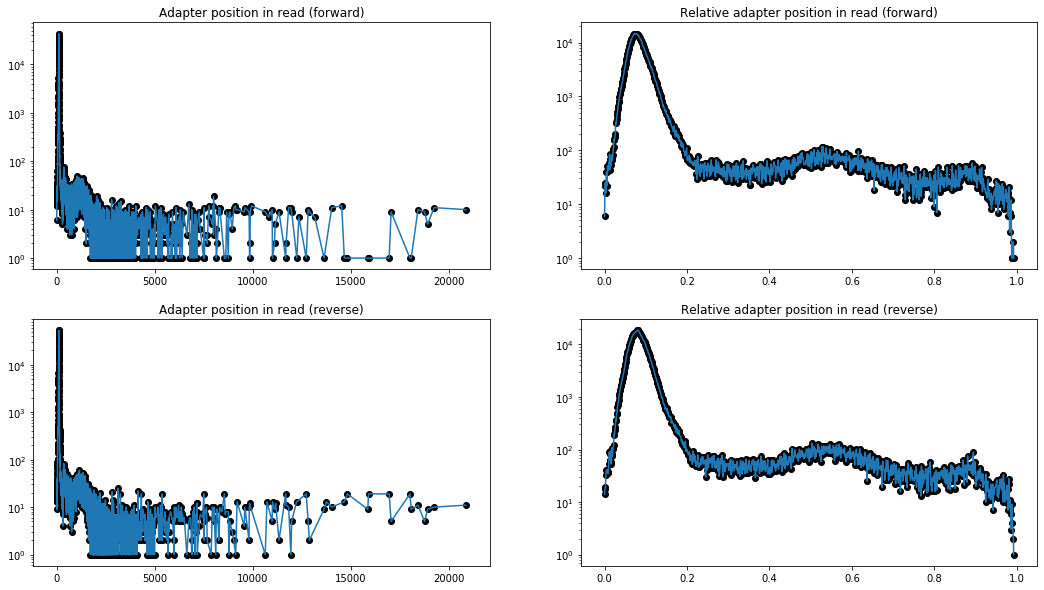

In [25]:
forward_histogram = results[8]
forward_data = sorted(forward_histogram.items())
forward_x, forward_y = zip(*forward_data)
#forward_data_x = np.arange(0, max(forward_x))
#forward_data_y = [forward_histogram[x] if x in forward_histogram else np.nan for x in range(max(forward_x))]

forward_relative_histogram = results[9]

forward_relative_histogram_binned = dict()
for (key, value) in forward_relative_histogram.items():
    rounded_key = round(key, 3)
    if rounded_key not in forward_relative_histogram_binned:
        forward_relative_histogram_binned[rounded_key] = 0
    forward_relative_histogram_binned[rounded_key] += value

forward_relative_data = sorted(forward_relative_histogram_binned.items())
forward_relative_x, forward_relative_y = zip(*forward_relative_data)
forward_relative_y = [(x if x > 0 else np.nan) for x in forward_relative_y]

reverse_histogram = results[13]
reverse_data = sorted(reverse_histogram.items())
reverse_x, reverse_y = zip(*reverse_data)
reverse_y = [(x if x > 0 else np.nan) for x in reverse_y]

reverse_relative_histogram = results[14]

reverse_relative_histogram_binned = dict()
for (key, value) in reverse_relative_histogram.items():
    rounded_key = round(key, 3)
    if rounded_key not in reverse_relative_histogram_binned:
        reverse_relative_histogram_binned[rounded_key] = 0
    reverse_relative_histogram_binned[rounded_key] += value
    
reverse_relative_data = sorted(reverse_relative_histogram_binned.items())
reverse_relative_x, reverse_relative_y = zip(*reverse_relative_data)
print(next(iter(reverse_relative_x)))
reverse_relative_y = [(x if x > 0 else np.nan) for x in reverse_relative_y]

fig, ax = plt.subplots(2, 2, figsize=(18, 10))

ax[0, 0].plot(forward_x, forward_y)
ax[0, 0].scatter(forward_x, forward_y, c='black')
ax[0, 0].set_title('Adapter position in read (forward)')
# ax[0, 0].set_ylim(-2, 500)
# ax[0, 0].set_xlim(0, 250)
ax[0, 0].set_yscale('log')
ax[1, 0].plot(reverse_x, reverse_y)
ax[1, 0].scatter(reverse_x, reverse_y, c='black')
ax[1, 0].set_title('Adapter position in read (reverse)')
# ax[1, 0].set_ylim(-2, 500)
ax[1, 0].set_yscale('log')

ax[0, 1].plot(forward_relative_x, forward_relative_y)
ax[0, 1].scatter(forward_relative_x, forward_relative_y, c='black')
ax[0, 1].set_title('Relative adapter position in read (forward)')
# ax[0, 1].set_ylim(-2, 500)
ax[0, 1].set_yscale('log')
ax[1, 1].plot(reverse_relative_x, reverse_relative_y)
ax[1, 1].scatter(reverse_relative_x, reverse_relative_y, c='black')
ax[1, 1].set_title('Relative adapter position in read (reverse)')
# ax[1, 1].set_ylim(-2, 500)
ax[1, 1].set_yscale('log')

In [23]:
print(max(forward_data, key=lambda x: x[1]))
print(max(forward_relative_data, key=lambda x: x[1]))

(99, 42975)
(0.076, 14573)


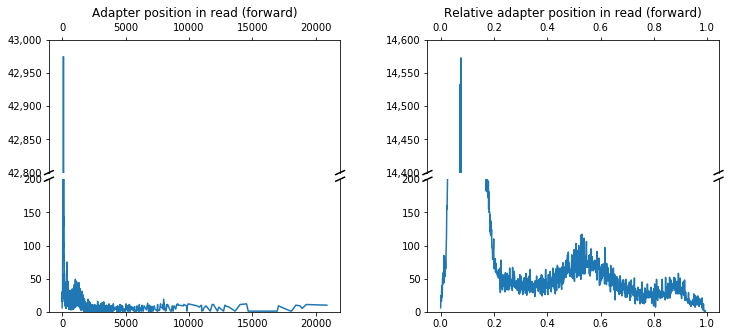

In [24]:
fig, ax = plt.subplots(2, 2, sharex='col', figsize=(12,5))

ax[0, 0].set_title('Adapter position in read (forward)')

ax[0, 0].plot(forward_x, forward_y)
#ax[0, 0].scatter(forward_x, forward_y, c='black')

ax[1, 0].plot(forward_x, forward_y)
#ax[1, 0].scatter(forward_x, forward_y, c='black')

ax[0, 0].set_ylim(42800, 43000)
ax[0, 0].ticklabel_format(useOffset=False)
ax[0, 0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1, 0].set_ylim(0, 200)

ax[0, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['top'].set_visible(False)
ax[0, 0].xaxis.tick_top()
ax[0, 0].tick_params(labeltop='off')  # don't put tick labels at the top
ax[1, 0].xaxis.tick_bottom()

d = .015

kwargs = dict(transform=ax[0, 0].transAxes, color='k', clip_on=False)
ax[0, 0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0, 0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1, 0].transAxes)  # switch to the bottom axes
ax[1, 0].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1, 0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# ----

ax[0, 1].set_title('Relative adapter position in read (forward)')

ax[0, 1].plot(forward_relative_x, forward_relative_y)
#ax[0, 1].scatter(forward_relative_x, forward_relative_y, c='black')

ax[1, 1].plot(forward_relative_x, forward_relative_y)
#ax[1, 1].scatter(forward_relative_x, forward_relative_y, c='black')

ax[0, 1].set_ylim(14400, 14600)
ax[0, 1].ticklabel_format(useOffset=False)
ax[0, 1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1, 1].set_ylim(0, 200)

ax[0, 1].spines['bottom'].set_visible(False)
ax[1, 1].spines['top'].set_visible(False)
ax[0, 1].xaxis.tick_top()
ax[0, 1].tick_params(labeltop='off')  # don't put tick labels at the top
ax[1, 1].xaxis.tick_bottom()

d = .015

kwargs = dict(transform=ax[0, 1].transAxes, color='k', clip_on=False)
ax[0, 1].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0, 1].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1, 1].transAxes)  # switch to the bottom axes
ax[1, 1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1, 1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


fig.subplots_adjust(hspace=0.05, wspace=0.3)

fig.savefig('adapter_position_nanopore.png', dpi=200)

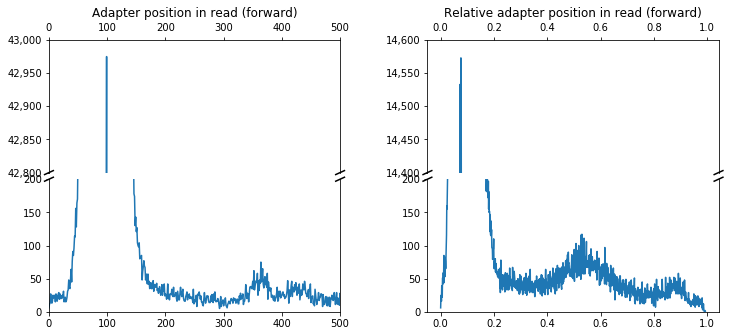

In [26]:
fig, ax = plt.subplots(2, 2, sharex='col', figsize=(12,5))

ax[0, 0].set_title('Adapter position in read (forward)')

ax[0, 0].plot(forward_x, forward_y)
#ax[0, 0].scatter(forward_x, forward_y, c='black')

ax[1, 0].plot(forward_x, forward_y)
#ax[1, 0].scatter(forward_x, forward_y, c='black')

ax[0, 0].set_ylim(42800, 43000)
ax[0, 0].set_xlim(0, 500)
ax[0, 0].ticklabel_format(useOffset=False)
ax[0, 0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1, 0].set_ylim(0, 200)
ax[1, 0].set_xlim(0, 500)

ax[0, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['top'].set_visible(False)
ax[0, 0].xaxis.tick_top()
ax[0, 0].tick_params(labeltop='off')  # don't put tick labels at the top
ax[1, 0].xaxis.tick_bottom()

d = .015

kwargs = dict(transform=ax[0, 0].transAxes, color='k', clip_on=False)
ax[0, 0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0, 0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1, 0].transAxes)  # switch to the bottom axes
ax[1, 0].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1, 0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# ----

ax[0, 1].set_title('Relative adapter position in read (forward)')

ax[0, 1].plot(forward_relative_x, forward_relative_y)
#ax[0, 1].scatter(forward_relative_x, forward_relative_y, c='black')

ax[1, 1].plot(forward_relative_x, forward_relative_y)
#ax[1, 1].scatter(forward_relative_x, forward_relative_y, c='black')

ax[0, 1].set_ylim(14400, 14600)
ax[0, 1].ticklabel_format(useOffset=False)
ax[0, 1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1, 1].set_ylim(0, 200)

ax[0, 1].spines['bottom'].set_visible(False)
ax[1, 1].spines['top'].set_visible(False)
ax[0, 1].xaxis.tick_top()
ax[0, 1].tick_params(labeltop='off')  # don't put tick labels at the top
ax[1, 1].xaxis.tick_bottom()

d = .015

kwargs = dict(transform=ax[0, 1].transAxes, color='k', clip_on=False)
ax[0, 1].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0, 1].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1, 1].transAxes)  # switch to the bottom axes
ax[1, 1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1, 1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


fig.subplots_adjust(hspace=0.05, wspace=0.3)

fig.savefig('adapter_position_nanopore.png', dpi=200)

1945539
1948434


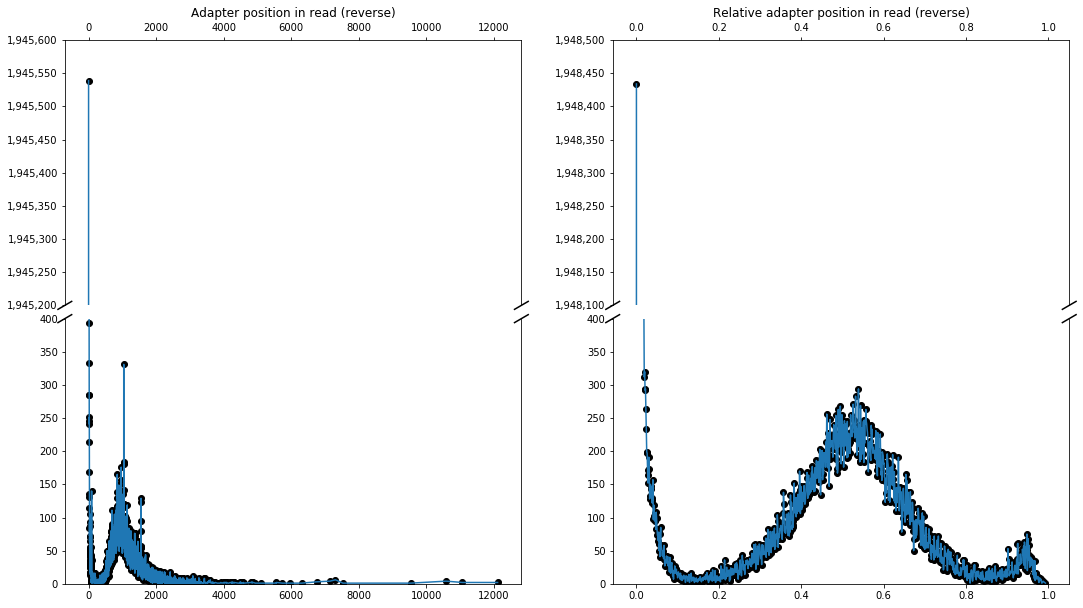

In [95]:
print(reverse_y[0])
print(reverse_relative_y[0])
fig, ax = plt.subplots(2, 2, sharex='col', figsize=(18,10))

ax[0, 0].set_title('Adapter position in read (reverse)')

ax[0, 0].plot(reverse_x, reverse_y)
ax[0, 0].scatter(reverse_x, reverse_y, c='black')

ax[1, 0].plot(reverse_x, reverse_y)
ax[1, 0].scatter(reverse_x, reverse_y, c='black')

ax[0, 0].set_ylim(1945200, 1945600)
ax[0, 0].ticklabel_format(useOffset=False)
ax[0, 0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1, 0].set_ylim(0, 400)

ax[0, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['top'].set_visible(False)
ax[0, 0].xaxis.tick_top()
ax[0, 0].tick_params(labeltop='off')  # don't put tick labels at the top
ax[1, 0].xaxis.tick_bottom()

d = .015

kwargs = dict(transform=ax[0, 0].transAxes, color='k', clip_on=False)
ax[0, 0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0, 0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1, 0].transAxes)  # switch to the bottom axes
ax[1, 0].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1, 0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# ----

ax[0, 1].set_title('Relative adapter position in read (reverse)')

ax[0, 1].plot(reverse_relative_x, reverse_relative_y)
ax[0, 1].scatter(reverse_relative_x, reverse_relative_y, c='black')

ax[1, 1].plot(reverse_relative_x, reverse_relative_y)
ax[1, 1].scatter(reverse_relative_x, reverse_relative_y, c='black')

ax[0, 1].set_ylim(1948100, 1948500)
ax[0, 1].ticklabel_format(useOffset=False)
ax[0, 1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1, 1].set_ylim(0, 400)

ax[0, 1].spines['bottom'].set_visible(False)
ax[1, 1].spines['top'].set_visible(False)
ax[0, 1].xaxis.tick_top()
ax[0, 1].tick_params(labeltop='off')  # don't put tick labels at the top
ax[1, 1].xaxis.tick_bottom()

d = .015

kwargs = dict(transform=ax[0, 1].transAxes, color='k', clip_on=False)
ax[0, 1].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0, 1].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1, 1].transAxes)  # switch to the bottom axes
ax[1, 1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1, 1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


fig.subplots_adjust(hspace=0.05)


In [24]:
adapters_in_first_50 = 0
for i in range(50):
    adapters_in_first_50 += forward_position_histogram[i] + reverse_position_histogram[i]

print('Percentage of adapters found at position zero of the read: {:.3%}'.format((forward_position_histogram[0] + reverse_position_histogram[0])/(forward_adapter_found + reverse_adapter_found)))
print('Percentage of adapters found in first 50 bases of the read: {:.3%}'.format(adapters_in_first_50 / (forward_adapter_found + reverse_adapter_found)))

Percentage of adapters found at position zero of the read: 91.023%
Percentage of adapters found in first 50 bases of the read: 97.119%
